<div style="text-align: left">Anna Dearman</div> <div style="text-align: right">December 2019</div> 
<center><span style="text-decoration: underline">Network Biology Assignment</span></center>

#### Introduction

I was given a list of "proteins of interest", originating from an LC-MS/MS experiment. My tasks were:
- to import the list into a Jupyter notebook 
- to discover which kinases phosphorylate the proteins, and on which phosphosite residues
- to generate and visualise a network of kinases
- to answer some specific questions about the network

Note 1: the early steps of this process were carried out as an in-class practical, during which help was available. The majority of the code was subsequently generated by me alone.

Note 2: the format of the UniProt API data changed shortly after submitting the assignment, so the data parsing no longer works. However, I have included cells that contain a snapshot of the data in its original format.

#### Method

*Task 1: Extract kinase-phosphosite relationships from UniProt*

All necessary libraries were imported.

In [ ]:
import urllib.parse # version not available
import urllib.request # version 3.7
import pandas as pd # version 0.25.1
import requests # version 2.22.0 
# Python version 3.7.4 was used

The target protein list was imported into a data frame using pandas.

In [ ]:
# Use index_col argument to use the values in the first column (0) as row names.
inpt = pd.read_csv("protein_list.csv",index_col=0)

In order to be confident about the identities of the proteins identified in the LC-MS/MS experiment, proteins with less than two peptides mapped to them were excluded.

In [ ]:
inpt = inpt.drop(inpt[inpt.Number_of_detected_peptides <2].index)

A dictionary of all potential phosphosite residues was made in order to convert UniProt data into a single-letter format. This includes non-canonical residues according to Hardman, G. et al (2019).

In [ ]:
dictionary={
    "PHOSPHOSERINE":"S",
    "PHOSPHOTHREONINE":"T",
    "PHOSPHOTYROSINE":"Y",
    "PHOSPHOHISTIDINE":"H",
    "PHOSPHOASPARTATE":"D",
    "PHOSPHOGLUTAMATE":"E",
    "PHOSPHOARGININE":"R",
    "PHOSPHOLYSINE":"K",
    "PHOSPHOCYSTEINE":"C",
}

A loop was used to build and submit one URL per protein via the requests.get() function, in order to query UniProt via its web service. Information about the post-translational modifications (PTMs) was returned and parsed.

In [ ]:
# Initialise a partial URL, to be added to in the following loop.
url = "https://www.uniprot.org/uniprot/?query="
data = []

for h,i in enumerate(inpt["Protein"].values):
    
    # Add the protein ID (i) and the desired column (MODIFIED RESIDUE),
    # and the output format (tab-delimited) to the URL
    url+=i+"&columns=feature(MODIFIED%20RESIDUE)&format=tab" 
    
    # Use "requests.get" to access UniProt using the URL; save data in "hits"
    hits = requests.get(url)
    
    # Re-set the URL ready for next loop iteration
    url = "https://www.uniprot.org/uniprot/?query="
    
    # Turn "hits" from class "requests.models.Response" into a string, 
    # using the ".text" method
    hits = hits.text
    
    # Remove header
    hits = hits.replace("Modified residue\n", "")
    
    # Split into individual PTMs
    hit = hits.split(".;") 
    
    # Now parse the data and create the output table (list "data")
  
    for j in hit: # For each individual PTM (j),
        if len(j)>1: # Only parse lines with data in, i.e. length >1
            if "hosph" in j and "by" in j: # Only parse relevant lines
                # "hosph" indicates e.g. "phosphoserine" ("P" may or may not 
                # be uppercase) and "by" indicates a known kinase
                j=j.lstrip() # Remove leading whitespace
                j=j.split(" ") # split by whitespace to get individual pieces of
                # information ("words" or "fields")
                if j[4]=="by": # Element 4 should be "by". If so, proceed
                    pos=j[1] # Get amino acid residue position
                    res_=j[3].upper() # Get phosphosite
                    res_=res_[0:len(res_)-1] # Remove last character
                    tempkin=j[5].upper() # Get kinase
                    if "AUTOCATALYSIS" in tempkin: # If the target phosphorylates itself
                        kin=i # store the target name as the kinase name
                    else: # If the kinase is not itself
                        kin=j[5].strip(".") # remove any extra characters
                        kin=kin.strip(",")
                        kin=kin.strip(";")
                    res=dictionary[res_] # Get one-letter phosphosite code
                    if "/" in kin: # If there are multiple kinases
                        kin=kin.split("/") # make a list of the kinases
                    if type(kin)==list: # if there are multiple kinases
                        for a in kin: # loop over them
                            line=i,pos,res,a # and add them to the table
                            data.append(line)
                    else: # if there is only one kinase
                        line=i,pos,res,kin # add it to the table
                        data.append(line)
                else:
                    continue

The loop above can sometimes fail to execute fully due to an interrupted connection to UniProt. If so, the below cell can be run to use the data retrieved during a successful execution of the loop on Tuesday, 10th December 2019.
##### EDIT: This is now essential due to the change in format of the data returned by the API.

In [ ]:
# If connection times out, run this cell
data=[('K2C8_HUMAN', '9', 'S', 'PKC'), ('K2C8_HUMAN', '9', 'S', 'PRKCE'), ('K2C8_HUMAN', '24', 'S', 'PKC'), ('K2C8_HUMAN', '24', 'S', 'PRKCE'), ('K2C8_HUMAN', '74', 'S', 'MAPK'), ('K2C8_HUMAN', '432', 'S', 'CaMK2'), ('K1C18_HUMAN', '34', 'S', 'CDK1'), ('K1C18_HUMAN', '51', 'S', 'MAPKAPK2'), ('K1C18_HUMAN', '53', 'S', 'CAMK'), ('NPM_HUMAN', '4', 'S', 'PLK1'), ('NPM_HUMAN', '125', 'S', 'CDK2'), ('NPM_HUMAN', '199', 'T', 'CDK1'), ('NPM_HUMAN', '219', 'T', 'CDK1'), ('NPM_HUMAN', '234', 'T', 'CDK1'), ('NPM_HUMAN', '237', 'T', 'CDK1'), ('TIF1B_HUMAN', '824', 'S', 'ATM'), ('ACINU_HUMAN', '1180', 'S', 'SRPK2'), ('EF2_HUMAN', '57', 'T', 'EEF2K'), ('EF2_HUMAN', '265', 'Y', 'CSK'), ('EF2_HUMAN', '373', 'Y', 'CSK'), ('EF2_HUMAN', '595', 'S', 'CDK2'), ('VIME_HUMAN', '7', 'S', 'PKA'), ('VIME_HUMAN', '9', 'S', 'PKC'), ('VIME_HUMAN', '10', 'S', 'PKC'), ('VIME_HUMAN', '34', 'S', 'PKC'), ('VIME_HUMAN', '39', 'S', 'CaMK2'), ('VIME_HUMAN', '42', 'S', 'PKC'), ('VIME_HUMAN', '56', 'S', 'CDK5'), ('VIME_HUMAN', '72', 'S', 'AURKB'), ('HS90B_HUMAN', '301', 'Y', 'SRC'), ('HS90B_HUMAN', '718', 'S', 'PLK2'), ('HS90A_HUMAN', '5', 'T', 'PRKDC'), ('HS90A_HUMAN', '7', 'T', 'PRKDC'), ('PLEC_HUMAN', '4539', 'T', 'CDK1'), ('MDC1_HUMAN', '4', 'T', 'ATM'), ('RB_HUMAN', '249', 'S', 'CDK1'), ('RB_HUMAN', '252', 'T', 'CDK1'), ('RB_HUMAN', '373', 'T', 'CDK1'), ('RB_HUMAN', '567', 'S', 'CDK2'), ('RB_HUMAN', '612', 'S', 'CHEK2'), ('RB_HUMAN', '807', 'S', 'CDK1'), ('RB_HUMAN', '811', 'S', 'CDK1'), ('RB_HUMAN', '821', 'T', 'CDK6'), ('RB_HUMAN', '826', 'T', 'CDK4'), ('IF4G1_HUMAN', '1185', 'S', 'PKC'), ('IF4G1_HUMAN', '1185', 'S', 'PRKCA'), ('MYPT1_HUMAN', '445', 'S', 'NUAK1'), ('MYPT1_HUMAN', '472', 'S', 'NUAK1'), ('MYPT1_HUMAN', '473', 'S', 'CDK1'), ('MYPT1_HUMAN', '692', 'S', 'PKA'), ('MYPT1_HUMAN', '695', 'S', 'PKA'), ('MYPT1_HUMAN', '696', 'T', 'ROCK1'), ('MYPT1_HUMAN', '852', 'S', 'ROCK2'), ('MYPT1_HUMAN', '910', 'S', 'NUAK1'), ('IF4B_HUMAN', '422', 'S', 'RPS6KA1'), ('SI1L1_HUMAN', '1326', 'S', 'PLK2'), ('SI1L1_HUMAN', '1330', 'T', 'PLK2'), ('SI1L1_HUMAN', '1349', 'S', 'CDK5'), ('CXA1_HUMAN', '325', 'S', 'CK1'), ('CXA1_HUMAN', '328', 'S', 'CK1'), ('CXA1_HUMAN', '330', 'S', 'CK1'), ('CXA1_HUMAN', '368', 'S', 'PKC'), ('CXA1_HUMAN', '368', 'S', 'PRKCG'), ('HNRPU_HUMAN', '59', 'S', 'PLK1'), ('NUMA1_HUMAN', '1047', 'T', 'PLK1'), ('NUMA1_HUMAN', '1769', 'S', 'PLK1'), ('NUMA1_HUMAN', '1772', 'S', 'PLK1'), ('NUMA1_HUMAN', '1789', 'S', 'PLK1'), ('NUMA1_HUMAN', '1834', 'S', 'PLK1'), ('NUMA1_HUMAN', '2015', 'T', 'CDK1'), ('NUMA1_HUMAN', '2055', 'T', 'CDK1'), ('NUMA1_HUMAN', '2087', 'S', 'CDK1'), ('NUMA1_HUMAN', '2106', 'T', 'CDK1'), ('PDIA1_HUMAN', '357', 'S', 'FAM20C'), ('MCM2_HUMAN', '40', 'S', 'CDC7'), ('MCM2_HUMAN', '53', 'S', 'CDC7'), ('MCM2_HUMAN', '108', 'S', 'ATR'), ('SRC8_HUMAN', '421', 'Y', 'SRC'), ('SRC8_HUMAN', '470', 'Y', 'FAK1'), ('SRC8_HUMAN', '486', 'Y', 'SRC'), ('SRC8_HUMAN', '489', 'Y', 'SRC'), ('EF1D_HUMAN', '162', 'S', 'CK2'), ('INCE_HUMAN', '892', 'T', 'AURKB'), ('INCE_HUMAN', '893', 'S', 'AURKB'), ('INCE_HUMAN', '894', 'S', 'AURKB'), ('IRS2_HUMAN', '540', 'Y', 'INSR'), ('IRS2_HUMAN', '653', 'Y', 'INSR'), ('IRS2_HUMAN', '675', 'Y', 'INSR'), ('IRS2_HUMAN', '919', 'Y', 'INSR'), ('IRS2_HUMAN', '978', 'Y', 'INSR'), ('IRS2_HUMAN', '1253', 'Y', 'INSR'), ('ROA1_HUMAN', '192', 'S', 'MKNK2'), ('ROA1_HUMAN', '362', 'S', 'MKNK2'), ('ROA1_HUMAN', '363', 'S', 'MKNK2'), ('ROA1_HUMAN', '364', 'S', 'MKNK2'), ('YAP1_HUMAN', '61', 'S', 'LATS1'), ('YAP1_HUMAN', '109', 'S', 'LATS1'), ('YAP1_HUMAN', '119', 'T', 'MAPK8'), ('YAP1_HUMAN', '127', 'S', 'LATS1'), ('YAP1_HUMAN', '138', 'S', 'MAPK8'), ('YAP1_HUMAN', '154', 'T', 'MAPK8'), ('YAP1_HUMAN', '164', 'S', 'LATS1'), ('YAP1_HUMAN', '367', 'S', 'MAPK8'), ('YAP1_HUMAN', '397', 'S', 'LATS1'), ('YAP1_HUMAN', '400', 'S', 'CK1'), ('YAP1_HUMAN', '403', 'S', 'CK1'), ('YAP1_HUMAN', '407', 'Y', 'ABL1'), ('YAP1_HUMAN', '412', 'T', 'MAPK8'), ('4EBP1_HUMAN', '37', 'T', 'MTOR'), ('4EBP1_HUMAN', '46', 'T', 'MTOR'), ('4EBP1_HUMAN', '65', 'S', 'DYRK2'), ('4EBP1_HUMAN', '70', 'T', 'MTOR'), ('4EBP1_HUMAN', '101', 'S', 'DYRK2'), ('CALX_HUMAN', '564', 'S', 'MAPK3'), ('CTND1_HUMAN', '112', 'Y', 'FYN'), ('CTND1_HUMAN', '288', 'S', 'PAK5'), ('SQSTM_HUMAN', '403', 'S', 'ULK1'), ('ARHG2_HUMAN', '143', 'S', 'PAK4'), ('ARHG2_HUMAN', '679', 'T', 'MAPK1'), ('ARHG2_HUMAN', '886', 'S', 'PAK1'), ('ARHG2_HUMAN', '896', 'S', 'PAK4'), ('DPYL2_HUMAN', '32', 'Y', 'FYN'), ('DPYL2_HUMAN', '514', 'T', 'GSK3-beta'), ('DPYL2_HUMAN', '522', 'S', 'DYRK2'), ('DPYL2_HUMAN', '555', 'T', 'ROCK2'), ('ENPL_HUMAN', '306', 'S', 'FAM20C'), ('ILF3_HUMAN', '188', 'T', 'PKR'), ('ILF3_HUMAN', '315', 'T', 'PKR'), ('MCM3_HUMAN', '535', 'S', 'ATM'), ('STMN1_HUMAN', '25', 'S', 'CDK1'), ('STMN1_HUMAN', '38', 'S', 'CDK1'), ('STMN1_HUMAN', '63', 'S', 'PKA'), ('PARD3_HUMAN', '962', 'S', 'AURKA'), ('PAXI_HUMAN', '31', 'Y', 'PTK6'), ('PAXI_HUMAN', '118', 'Y', 'PTK6'), ('PAXI_HUMAN', '244', 'S', 'CDK5'), ('PAXI_HUMAN', '250', 'S', 'SLK'), ('TOP2A_HUMAN', '1106', 'S', 'CK1'), ('TOP2A_HUMAN', '1343', 'T', 'PLK3'), ('TOP2A_HUMAN', '1469', 'S', 'CK2'), ('ABCF1_HUMAN', '109', 'S', 'CK2'), ('ABCF1_HUMAN', '140', 'S', 'CK2'), ('GTF2I_HUMAN', '248', 'Y', 'BTK'), ('GTF2I_HUMAN', '398', 'Y', 'BTK'), ('GTF2I_HUMAN', '412', 'S', 'PKG'), ('GTF2I_HUMAN', '412', 'S', 'PRKG1'), ('GTF2I_HUMAN', '503', 'Y', 'BTK'), ('GTF2I_HUMAN', '784', 'S', 'PKG'), ('GTF2I_HUMAN', '784', 'S', 'PRKG1'), ('ALBU_HUMAN', '29', 'S', 'FAM20C'), ('ALBU_HUMAN', '82', 'S', 'FAM20C'), ('ALBU_HUMAN', '89', 'S', 'FAM20C'), ('ALBU_HUMAN', '107', 'T', 'FAM20C'), ('LA_HUMAN', '366', 'S', 'CK2'), ('ADDA_HUMAN', '59', 'S', 'PKA'), ('ADDA_HUMAN', '408', 'S', 'PKA'), ('ADDA_HUMAN', '436', 'S', 'PKA'), ('ADDA_HUMAN', '445', 'T', 'ROCK2'), ('ADDA_HUMAN', '480', 'T', 'ROCK2'), ('ADDA_HUMAN', '481', 'S', 'PKA'), ('ADDA_HUMAN', '716', 'S', 'PKC'), ('ADDA_HUMAN', '726', 'S', 'PKA'), ('MARCS_HUMAN', '159', 'S', 'PKC'), ('MARCS_HUMAN', '163', 'S', 'PKC'), ('MARCS_HUMAN', '167', 'S', 'PKC'), ('MARCS_HUMAN', '170', 'S', 'PKC'), ('PML_HUMAN', '8', 'S', 'HIPK2'), ('PML_HUMAN', '36', 'S', 'HIPK2'), ('PML_HUMAN', '38', 'S', 'HIPK2'), ('PML_HUMAN', '117', 'S', 'CHEK2'), ('PML_HUMAN', '403', 'S', 'MAPK1'), ('PML_HUMAN', '505', 'S', 'MAPK1'), ('PML_HUMAN', '518', 'S', 'CDK1'), ('PML_HUMAN', '527', 'S', 'MAPK1'), ('PML_HUMAN', '530', 'S', 'MAPK1'), ('PML_HUMAN', '565', 'S', 'CK2'), ('KMT2A_HUMAN', '136', 'S', 'CK2'), ('KMT2A_HUMAN', '142', 'S', 'CK2'), ('LEUK_HUMAN', '355', 'S', 'PKC'), ('LEUK_HUMAN', '355', 'S', 'PRKCQ'), ('ZCCHV_HUMAN', '257', 'S', 'GSK3-beta'), ('ZCCHV_HUMAN', '263', 'S', 'GSK3-beta'), ('ZCCHV_HUMAN', '267', 'S', 'GSK3-beta'), ('ZCCHV_HUMAN', '271', 'S', 'GSK3-beta'), ('EF1A1_HUMAN', '300', 'S', 'TGFBR1'), ('EF1A1_HUMAN', '432', 'T', 'PASK'), ('HSPB1_HUMAN', '15', 'S', 'MAPKAPK2'), ('HSPB1_HUMAN', '78', 'S', 'MAPKAPK2'), ('HSPB1_HUMAN', '82', 'S', 'MAPKAPK2'), ('IRS1_HUMAN', '99', 'S', 'CK2'), ('IRS1_HUMAN', '270', 'S', 'RPS6KB1'), ('IRS1_HUMAN', '307', 'S', 'RPS6KB1'), ('IRS1_HUMAN', '312', 'S', 'IKKB'), ('IRS1_HUMAN', '465', 'Y', 'INSR'), ('IRS1_HUMAN', '527', 'S', 'RPS6KB1'), ('IRS1_HUMAN', '612', 'Y', 'INSR'), ('IRS1_HUMAN', '632', 'Y', 'INSR'), ('IRS1_HUMAN', '636', 'S', 'RPS6KB1'), ('IRS1_HUMAN', '794', 'S', 'AMPK'), ('IRS1_HUMAN', '896', 'Y', 'INSR'), ('IRS1_HUMAN', '941', 'Y', 'INSR'), ('IRS1_HUMAN', '989', 'Y', 'INSR'), ('IRS1_HUMAN', '1101', 'S', 'RPS6KB1'), ('IRS1_HUMAN', '1179', 'Y', 'INSR'), ('IRS1_HUMAN', '1229', 'Y', 'INSR'), ('LSP1_HUMAN', '252', 'S', 'MAPKAPK2'), ('SYEP_HUMAN', '886', 'S', 'CDK5'), ('SYEP_HUMAN', '999', 'S', 'RPS6KB1'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '180', 'S', 'host'), ('41_HUMAN', '60', 'T', 'CDK1'), ('41_HUMAN', '660', 'Y', 'EGFR'), ('41_HUMAN', '712', 'S', 'CDK1'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '914', 'Y', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '282', 'T', 'host'), ('41_HUMAN', '318', 'S', 'host'), ('41_HUMAN', '455', 'S', 'host'), ('41_HUMAN', '459', 'S', 'host'), ('41_HUMAN', '462', 'S', 'host'), ('41_HUMAN', '466', 'S', 'host'), ('41_HUMAN', '483', 'Y', 'host'), ('41_HUMAN', '504', 'S', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '282', 'T', 'host'), ('41_HUMAN', '318', 'S', 'host'), ('41_HUMAN', '455', 'S', 'host'), ('41_HUMAN', '459', 'S', 'host'), ('41_HUMAN', '462', 'S', 'host'), ('41_HUMAN', '466', 'S', 'host'), ('41_HUMAN', '483', 'Y', 'host'), ('41_HUMAN', '504', 'S', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '180', 'S', 'host'), ('41_HUMAN', '180', 'S', 'host'), ('41_HUMAN', '56', 'T', 'host'), ('41_HUMAN', '340', 'S', 'host'), ('41_HUMAN', '340', 'S', 'host'), ('41_HUMAN', '56', 'T', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '282', 'T', 'host'), ('41_HUMAN', '318', 'S', 'host'), ('41_HUMAN', '455', 'S', 'host'), ('41_HUMAN', '459', 'S', 'host'), ('41_HUMAN', '462', 'S', 'host'), ('41_HUMAN', '466', 'S', 'host'), ('41_HUMAN', '483', 'Y', 'host'), ('41_HUMAN', '504', 'S', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '56', 'T', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '180', 'S', 'host'), ('41_HUMAN', '340', 'S', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '649', 'Y', 'host'), ('41_HUMAN', '282', 'T', 'host'), ('41_HUMAN', '318', 'S', 'host'), ('41_HUMAN', '455', 'S', 'host'), ('41_HUMAN', '459', 'S', 'host'), ('41_HUMAN', '462', 'S', 'host'), ('41_HUMAN', '466', 'S', 'host'), ('41_HUMAN', '483', 'Y', 'host'), ('41_HUMAN', '504', 'S', 'host'), ('41_HUMAN', '913', 'Y', 'host'), ('41_HUMAN', '340', 'S', 'host'), ('41_HUMAN', '340', 'S', 'host'), ('ENAH_HUMAN', '265', 'S', 'PKA'), ('FKBP4_HUMAN', '143', 'T', 'CK2'), ('MYC_HUMAN', '8', 'T', 'RAF'), ('MYC_HUMAN', '58', 'T', 'GSK3'), ('MYC_HUMAN', '62', 'S', 'DYRK2'), ('MYC_HUMAN', '329', 'S', 'PIM2'), ('WNK1_HUMAN', '378', 'S', 'WNK1_HUMAN'), ('WNK1_HUMAN', '382', 'S', 'WNK1_HUMAN'), ('XRCC1_HUMAN', '371', 'S', 'PRKDC'), ('YBOX1_HUMAN', '102', 'S', 'PKB'), ('YBOX1_HUMAN', '102', 'S', 'AKT1'), ('C2CD5_HUMAN', '197', 'S', 'PKB'), ('C2CD5_HUMAN', '197', 'S', 'AKT2'), ('DTL_HUMAN', '464', 'T', 'CDK1'), ('SFPQ_HUMAN', '8', 'S', 'MKNK2'), ('SFPQ_HUMAN', '283', 'S', 'MKNK2'), ('SFPQ_HUMAN', '293', 'Y', 'ALK'), ('SIK3_HUMAN', '221', 'T', 'LKB1'), ('TBCD4_HUMAN', '318', 'S', 'PKB'), ('TBCD4_HUMAN', '318', 'S', 'AKT1'), ('TBCD4_HUMAN', '588', 'S', 'PKB'), ('TBCD4_HUMAN', '588', 'S', 'AKT1'), ('TBCD4_HUMAN', '642', 'T', 'PKB'), ('TBCD4_HUMAN', '642', 'T', 'AKT1'), ('TBCD4_HUMAN', '751', 'S', 'PKB'), ('TBCD4_HUMAN', '751', 'S', 'AKT1'), ('BCR_HUMAN', '177', 'Y', 'HCK'), ('BCR_HUMAN', '246', 'Y', 'FES'), ('RBL1_HUMAN', '332', 'T', 'CDK2'), ('RBL1_HUMAN', '369', 'T', 'CDK4'), ('RBL1_HUMAN', '385', 'T', 'CDK2'), ('RBL1_HUMAN', '640', 'S', 'CDK2'), ('RBL1_HUMAN', '762', 'S', 'CDK2'), ('RBL1_HUMAN', '964', 'S', 'CDK2'), ('RBL1_HUMAN', '975', 'S', 'CDK2'), ('RBL1_HUMAN', '988', 'S', 'CDK2'), ('RBL1_HUMAN', '997', 'T', 'CDK2'), ('RBL1_HUMAN', '1009', 'S', 'CDK2'), ('RS3_HUMAN', '6', 'S', 'PKC'), ('RS3_HUMAN', '6', 'S', 'PRKCD'), ('RS3_HUMAN', '42', 'T', 'MAPK'), ('RS3_HUMAN', '70', 'T', 'PKB'), ('RS3_HUMAN', '209', 'S', 'IKKB'), ('RS3_HUMAN', '221', 'T', 'CDK1'), ('4EBP2_HUMAN', '37', 'T', 'MTOR'), ('4EBP2_HUMAN', '46', 'T', 'MTOR'), ('4EBP2_HUMAN', '65', 'S', 'MTOR'), ('4EBP2_HUMAN', '70', 'T', 'MTOR'), ('DNMT1_HUMAN', '143', 'S', 'PKB'), ('DNMT1_HUMAN', '143', 'S', 'AKT1'), ('HMGA1_HUMAN', '36', 'S', 'HIPK2'), ('HMGA1_HUMAN', '53', 'T', 'HIPK2'), ('HMGA1_HUMAN', '78', 'T', 'HIPK2'), ('HMGA1_HUMAN', '102', 'S', 'CK'), ('HMGA1_HUMAN', '103', 'S', 'CK'), ('PAK1_HUMAN', '21', 'S', 'PKB'), ('PAK1_HUMAN', '57', 'S', 'PAK1_HUMAN'), ('PAK1_HUMAN', '84', 'T', 'OXSR1'), ('PAK1_HUMAN', '153', 'Y', 'JAK2'), ('PAK1_HUMAN', '199', 'S', 'PAK1_HUMAN'), ('PAK1_HUMAN', '201', 'Y', 'JAK2'), ('PAK1_HUMAN', '285', 'Y', 'JAK2'), ('PAK1_HUMAN', '423', 'T', 'PAK1_HUMAN'), ('PROF1_HUMAN', '138', 'S', 'ROCK1'), ('RUNX1_HUMAN', '249', 'S', 'HIPK2'), ('RUNX1_HUMAN', '273', 'T', 'HIPK2'), ('RUNX1_HUMAN', '276', 'S', 'HIPK2'), ('ADDB_HUMAN', '55', 'T', 'PKA'), ('ADDB_HUMAN', '703', 'S', 'PKC'), ('ADDB_HUMAN', '713', 'S', 'PKA'), ('ATN1_HUMAN', '943', 'S', 'PKA'), ('ATN1_HUMAN', '739', 'S', 'MAPK8'), ('COF1_HUMAN', '3', 'S', 'NRK'), ('GRDN_HUMAN', '1417', 'S', 'PKB'), ('GRDN_HUMAN', '1417', 'S', 'AKT1'), ('KPCD_HUMAN', '299', 'S', 'KPCD_HUMAN'), ('KPCD_HUMAN', '302', 'S', 'KPCD_HUMAN'), ('KPCD_HUMAN', '304', 'S', 'KPCD_HUMAN'), ('KPCD_HUMAN', '334', 'Y', 'SRC'), ('KPCD_HUMAN', '507', 'T', 'KPCD_HUMAN'), ('MARK3_HUMAN', '211', 'T', 'LKB1'), ('MARK3_HUMAN', '564', 'T', 'PKC'), ('MARK3_HUMAN', '564', 'T', 'PRKCZ'), ('MED1_HUMAN', '1032', 'T', 'MAPK1'), ('MED1_HUMAN', '1457', 'T', 'MAPK1'), ('MTAP2_HUMAN', '1679', 'S', 'MARK1'), ('PA2G4_HUMAN', '361', 'S', 'PKC'), ('PA2G4_HUMAN', '361', 'S', 'PRKCD'), ('PRDX6_HUMAN', '177', 'T', 'MAPK'), ('PYR1_HUMAN', '456', 'T', 'MAPK1'), ('PYR1_HUMAN', '1406', 'S', 'PKA'), ('PYR1_HUMAN', '1859', 'S', 'RPS6KB1'), ('PYR1_HUMAN', '1873', 'S', 'PKC'), ('TACC3_HUMAN', '558', 'S', 'AURKA'), ('1433Z_HUMAN', '58', 'S', 'PKA'), ('1433Z_HUMAN', '184', 'S', 'MAPK8'), ('1433Z_HUMAN', '232', 'T', 'CK1'), ('GSTP1_HUMAN', '4', 'Y', 'EGFR'), ('GSTP1_HUMAN', '199', 'Y', 'EGFR'), ('H4_HUMAN', '48', 'S', 'PAK2'), ('H4_HUMAN', '164', 'S', 'PKC'), ('H4_HUMAN', '164', 'S', 'PRKCA'), ('H4_HUMAN', '456', 'T', 'PKC'), ('H4_HUMAN', '456', 'T', 'PRKCZ'), ('HNRPL_HUMAN', '544', 'S', 'CaMK4'), ('MOES_HUMAN', '558', 'T', 'ROCK2'), ('PAK2_HUMAN', '402', 'T', 'PAK2_HUMAN'), ('PAK4_HUMAN', '474', 'S', 'PAK4_HUMAN'), ('RS6_HUMAN', '235', 'S', 'RPS6KA1'), ('RS6_HUMAN', '236', 'S', 'RPS6KA1'), ('TAU_HUMAN', '18', 'Y', 'FYN'), ('TAU_HUMAN', '214', 'S', 'SGK1'), ('TAU_HUMAN', '470', 'T', 'PDPK1'), ('TAU_HUMAN', '498', 'T', 'PDPK1'), ('TAU_HUMAN', '514', 'Y', 'TTBK1'), ('TAU_HUMAN', '515', 'S', 'PDPK1'), ('TAU_HUMAN', '516', 'S', 'PDPK1'), ('TAU_HUMAN', '519', 'S', 'CK1'), ('TAU_HUMAN', '522', 'T', 'CK1'), ('TAU_HUMAN', '529', 'T', 'BRSK1'), ('TAU_HUMAN', '531', 'S', 'PKA'), ('TAU_HUMAN', '534', 'T', 'PDPK1'), ('TAU_HUMAN', '548', 'T', 'GSK3-beta'), ('TAU_HUMAN', '552', 'S', 'PDPK1'), ('TAU_HUMAN', '554', 'S', 'PHK'), ('TAU_HUMAN', '579', 'S', 'MARK1'), ('TAU_HUMAN', '602', 'S', 'PHK'), ('TAU_HUMAN', '622', 'S', 'PHK'), ('TAU_HUMAN', '669', 'S', 'PHK'), ('TAU_HUMAN', '713', 'S', 'CK1'), ('TAU_HUMAN', '721', 'S', 'CK1'), ('TAU_HUMAN', '733', 'S', 'CaMK2'), ('TAU_HUMAN', '739', 'S', 'PDPK1'), ('TAU_HUMAN', '744', 'T', 'TTBK1'), ('AAK1_HUMAN', '183', 'T', 'LKB1'), ('AAK1_HUMAN', '360', 'S', 'ULK1'), ('AAK1_HUMAN', '368', 'T', 'ULK1'), ('CPZIP_HUMAN', '68', 'S', 'MAPK8'), ('CPZIP_HUMAN', '83', 'S', 'MAPK8'), ('CPZIP_HUMAN', '108', 'S', 'MAPK12'), ('CPZIP_HUMAN', '179', 'S', 'MAPKAPK2'), ('CPZIP_HUMAN', '216', 'S', 'MAPK8'), ('CPZIP_HUMAN', '244', 'S', 'MAPKAPK2'), ('HDAC1_HUMAN', '421', 'S', 'CK2'), ('HDAC1_HUMAN', '423', 'S', 'CK2'), ('MARK2_HUMAN', '58', 'T', 'MARK2_HUMAN'), ('MARK2_HUMAN', '91', 'S', 'CaMK1'), ('MARK2_HUMAN', '92', 'S', 'CaMK1'), ('MARK2_HUMAN', '93', 'S', 'CaMK1'), ('MARK2_HUMAN', '208', 'T', 'LKB1'), ('MARK2_HUMAN', '212', 'S', 'GSK3-beta'), ('MARK2_HUMAN', '274', 'S', 'MARK2_HUMAN'), ('MARK2_HUMAN', '275', 'T', 'MARK2_HUMAN'), ('MARK2_HUMAN', '294', 'T', 'CaMK1'), ('MARK2_HUMAN', '596', 'T', 'PKC'), ('MARK2_HUMAN', '596', 'T', 'PRKCZ'), ('MBP_HUMAN', '299', 'S', 'UHMK1'), ('TBB2A_HUMAN', '172', 'S', 'CDK1'), ('ACLY_HUMAN', '455', 'S', 'PKA'), ('BCAP_HUMAN', '419', 'Y', 'SYK'), ('BCAP_HUMAN', '444', 'Y', 'SYK'), ('BCAP_HUMAN', '459', 'Y', 'SYK'), ('BCAP_HUMAN', '513', 'Y', 'ABL1'), ('BCAP_HUMAN', '553', 'Y', 'ABL1'), ('BCAP_HUMAN', '570', 'Y', 'ABL1'), ('BCAP_HUMAN', '594', 'Y', 'ABL1'), ('BCAP_HUMAN', '694', 'Y', 'ABL1'), ('BRSK2_HUMAN', '174', 'T', 'LKB1'), ('BRSK2_HUMAN', '260', 'T', 'PKA'), ('ERF_HUMAN', '526', 'T', 'MAPK1'), ('GBF1_HUMAN', '1337', 'T', 'AMPK'), ('GBLP_HUMAN', '52', 'Y', 'ABL1'), ('GBLP_HUMAN', '276', 'S', 'viral'), ('GBLP_HUMAN', '277', 'T', 'viral'), ('GBLP_HUMAN', '278', 'S', 'viral'), ('GBLP_HUMAN', '279', 'S', 'viral'), ('MIA3_HUMAN', '226', 'S', 'FAM20C'), ('MIA3_HUMAN', '229', 'S', 'FAM20C'), ('MIA3_HUMAN', '1906', 'S', 'FAM20C'), ('NCOA3_HUMAN', '601', 'S', 'CK1'), ('POGZ_HUMAN', '1392', 'S', 'CK2'), ('POGZ_HUMAN', '1396', 'S', 'CK2'), ('PRDX1_HUMAN', '90', 'T', 'CDK1'), ('TBB5_HUMAN', '172', 'S', 'CDK1'), ('BAD_HUMAN', '99', 'S', 'PKA'), ('BAD_HUMAN', '99', 'S', 'PKB'), ('BAD_HUMAN', '99', 'S', 'AKT1'), ('CCAR2_HUMAN', '454', 'T', 'ATM'), ('CLIP1_HUMAN', '312', 'S', 'PKA'), ('CLSPN_HUMAN', '916', 'T', 'CHEK1'), ('CP131_HUMAN', '47', 'S', 'MAPKAPK2'), ('CP131_HUMAN', '78', 'S', 'MAPKAPK2'), ('DDX3X_HUMAN', '102', 'S', 'IKKE'), ('KS6A1_HUMAN', '221', 'S', 'PDPK1'), ('KS6A1_HUMAN', '380', 'S', 'KS6A1_HUMAN'), ('KS6B1_HUMAN', '252', 'T', 'PDPK1'), ('KS6B1_HUMAN', '412', 'T', 'MTOR'), ('NSUN2_HUMAN', '139', 'S', 'AURKB'), ('PHF2_HUMAN', '1056', 'S', 'PKA'), ('PKN1_HUMAN', '774', 'T', 'PDPK1'), ('RAF1_HUMAN', '29', 'S', 'MAPK1'), ('RAF1_HUMAN', '43', 'S', 'PKA'), ('RAF1_HUMAN', '259', 'S', 'PKA'), ('RAF1_HUMAN', '268', 'T', 'RAF1_HUMAN'), ('RAF1_HUMAN', '269', 'T', 'PKA'), ('RAF1_HUMAN', '289', 'S', 'MAPK1'), ('RAF1_HUMAN', '301', 'S', 'MAPK1'), ('RAF1_HUMAN', '338', 'S', 'PAK1'), ('RAF1_HUMAN', '339', 'S', 'PAK1'), ('RAF1_HUMAN', '340', 'Y', 'SRC'), ('RAF1_HUMAN', '341', 'Y', 'SRC'), ('RAF1_HUMAN', '499', 'S', 'PKC'), ('RAF1_HUMAN', '642', 'S', 'MAPK1'), ('RAPH1_HUMAN', '426', 'Y', 'ABL1'), ('RAPH1_HUMAN', '456', 'Y', 'ABL1'), ('RAPH1_HUMAN', '1226', 'Y', 'ABL1'), ('SPT5H_HUMAN', '775', 'T', 'CDK9'), ('SPT5H_HUMAN', '784', 'T', 'CDK9'), ('TBB3_HUMAN', '172', 'S', 'CDK1'), ('TBB4B_HUMAN', '172', 'S', 'CDK1'), ('ULK1_HUMAN', '317', 'S', 'AMPK'), ('ULK1_HUMAN', '556', 'S', 'AMPK'), ('ULK1_HUMAN', '758', 'S', 'MTOR'), ('VINC_HUMAN', '1133', 'Y', 'SRC-type'), ('ACTN1_HUMAN', '12', 'Y', 'FAK1'), ('AMOL2_HUMAN', '107', 'Y', 'FGFR1'), ('ANXA2_HUMAN', '24', 'Y', 'SRC'), ('ANXA2_HUMAN', '26', 'S', 'PKC'), ('CD11A_HUMAN', '470', 'S', 'CDK7'), ('CD11A_HUMAN', '476', 'T', 'CDK7'), ('CDK1_HUMAN', '4', 'Y', 'PKR'), ('CDK1_HUMAN', '14', 'T', 'PKMYT1'), ('CDK1_HUMAN', '15', 'Y', 'PKMYT1'), ('CDK1_HUMAN', '161', 'T', 'CAK'), ('CRTC2_HUMAN', '171', 'S', 'AMPK'), ('CRTC2_HUMAN', '274', 'S', 'MARK2'), ('ERC6L_HUMAN', '1063', 'T', 'PLK1'), ('ETV6_HUMAN', '257', 'S', 'MAPK14'), ('EZH2_HUMAN', '21', 'S', 'PKB'), ('EZH2_HUMAN', '21', 'S', 'AKT1'), ('EZH2_HUMAN', '345', 'T', 'CDK1'), ('SIR1_HUMAN', '27', 'S', 'MAPK8'), ('SIR1_HUMAN', '47', 'S', 'MAPK8'), ('SIR1_HUMAN', '530', 'T', 'DYRK1A'), ('SIR1_HUMAN', '659', 'S', 'CaMK2'), ('SIR1_HUMAN', '661', 'S', 'CaMK2'), ('SRSF6_HUMAN', '303', 'S', 'DYRK1A'), ('TBB4A_HUMAN', '172', 'S', 'CDK1'), ('XRCC6_HUMAN', '6', 'S', 'PRKDC'), ('XRCC6_HUMAN', '51', 'S', 'PRKDC'), ('ZCHC8_HUMAN', '492', 'T', 'GSK3'), ('CARD9_HUMAN', '531', 'T', 'CK2'), ('CARD9_HUMAN', '533', 'T', 'CK2'), ('CBL_HUMAN', '371', 'Y', 'INSR'), ('CBL_HUMAN', '700', 'Y', 'ABL1'), ('CBL_HUMAN', '731', 'Y', 'SRC'), ('CD11B_HUMAN', '482', 'S', 'CDK7'), ('CD11B_HUMAN', '488', 'T', 'CDK7'), ('CRTC1_HUMAN', '151', 'S', 'SIK1'), ('DPYL3_HUMAN', '509', 'T', 'GSK3'), ('DPYL3_HUMAN', '514', 'T', 'GSK3'), ('DPYL3_HUMAN', '518', 'S', 'GSK3'), ('DPYL3_HUMAN', '522', 'S', 'DYRK2'), ('EF2K_HUMAN', '61', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '66', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '78', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '348', 'T', 'EF2K_HUMAN'), ('EF2K_HUMAN', '353', 'T', 'EF2K_HUMAN'), ('EF2K_HUMAN', '359', 'S', 'MAPK13'), ('EF2K_HUMAN', '366', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '398', 'S', 'AMPK'), ('EF2K_HUMAN', '445', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '474', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '491', 'S', 'EF2K_HUMAN'), ('EF2K_HUMAN', '500', 'S', 'PKA'), ('EMD_HUMAN', '49', 'S', 'PKA'), ('EPS15_HUMAN', '849', 'Y', 'EGFR'), ('GLU2B_HUMAN', '24', 'S', 'FAM20C'), ('GLU2B_HUMAN', '89', 'S', 'PKC'), ('GLU2B_HUMAN', '168', 'S', 'FAM20C'), ('GLU2B_HUMAN', '383', 'S', 'PKC'), ('GLU2B_HUMAN', '390', 'S', 'PKC'), ('GLU2B_HUMAN', '434', 'S', 'PKC'), ('HJURP_HUMAN', '486', 'S', 'PKB'), ('HJURP_HUMAN', '486', 'S', 'AKT1'), ('IPP2_HUMAN', '44', 'S', 'ATM'), ('IPP2_HUMAN', '73', 'T', 'GSK3'), ('KAT7_HUMAN', '57', 'S', 'PLK1'), ('KAT7_HUMAN', '85', 'T', 'CDK1'), ('KAT7_HUMAN', '88', 'T', 'CDK1'), ('MISP_HUMAN', '78', 'S', 'CDK1'), ('MISP_HUMAN', '164', 'T', 'CDK1'), ('MISP_HUMAN', '172', 'T', 'CDK1'), ('MISP_HUMAN', '214', 'S', 'CDK1'), ('MISP_HUMAN', '224', 'T', 'CDK1'), ('MISP_HUMAN', '284', 'S', 'CDK1'), ('MISP_HUMAN', '287', 'T', 'CDK1'), ('MISP_HUMAN', '377', 'T', 'CDK1'), ('MISP_HUMAN', '382', 'S', 'CDK1'), ('MISP_HUMAN', '394', 'S', 'PLK1'), ('MISP_HUMAN', '395', 'S', 'PLK1'), ('MISP_HUMAN', '397', 'S', 'PLK1'), ('MISP_HUMAN', '471', 'S', 'PLK1'), ('MISP_HUMAN', '575', 'S', 'CDK1'), ('MISP_HUMAN', '582', 'S', 'PLK1'), ('MISP_HUMAN', '586', 'S', 'PLK1'), ('OSTP_HUMAN', '26', 'S', 'FAM20C'), ('OSTP_HUMAN', '27', 'S', 'FAM20C'), ('OSTP_HUMAN', '62', 'S', 'FAM20C'), ('OSTP_HUMAN', '63', 'S', 'FAM20C'), ('OSTP_HUMAN', '190', 'T', 'FAM20C'), ('OSTP_HUMAN', '191', 'S', 'FAM20C'), ('OSTP_HUMAN', '195', 'S', 'FAM20C'), ('OSTP_HUMAN', '215', 'S', 'FAM20C'), ('OSTP_HUMAN', '219', 'S', 'FAM20C'), ('OSTP_HUMAN', '224', 'S', 'FAM20C'), ('OSTP_HUMAN', '228', 'S', 'FAM20C'), ('OSTP_HUMAN', '234', 'S', 'FAM20C'), ('OSTP_HUMAN', '237', 'T', 'FAM20C'), ('OSTP_HUMAN', '239', 'S', 'FAM20C'), ('OSTP_HUMAN', '243', 'S', 'FAM20C'), ('OSTP_HUMAN', '254', 'S', 'FAM20C'), ('OSTP_HUMAN', '258', 'S', 'FAM20C'), ('OSTP_HUMAN', '263', 'S', 'FAM20C'), ('OSTP_HUMAN', '267', 'S', 'FAM20C'), ('OSTP_HUMAN', '270', 'S', 'FAM20C'), ('OSTP_HUMAN', '275', 'S', 'FAM20C'), ('OSTP_HUMAN', '280', 'S', 'FAM20C'), ('OSTP_HUMAN', '291', 'S', 'FAM20C'), ('OSTP_HUMAN', '303', 'S', 'FAM20C'), ('OSTP_HUMAN', '308', 'S', 'FAM20C'), ('OSTP_HUMAN', '310', 'S', 'FAM20C'), ('OSTP_HUMAN', '311', 'S', 'FAM20C'), ('PCNA_HUMAN', '211', 'Y', 'EGFR'), ('PTN6_HUMAN', '564', 'Y', 'LYN'), ('TCTP_HUMAN', '46', 'S', 'PLK1'), ('TCTP_HUMAN', '64', 'S', 'PLK1'), ('TISD_HUMAN', '490', 'S', 'RPS6KA1'), ('TISD_HUMAN', '492', 'S', 'RPS6KA1'), ('XRCC5_HUMAN', '577', 'S', 'PRKDC'), ('XRCC5_HUMAN', '579', 'S', 'PRKDC'), ('XRCC5_HUMAN', '580', 'S', 'PRKDC'), ('XRCC5_HUMAN', '715', 'T', 'PRKDC'), ('ABI1_HUMAN', '213', 'Y', 'ABL1'), ('AKT1_HUMAN', '176', 'Y', 'TNK2'), ('AKT1_HUMAN', '308', 'T', 'IKKE'), ('AKT1_HUMAN', '473', 'S', 'IKKE'), ('COIL_HUMAN', '184', 'S', 'VRK1'), ('CTNA1_HUMAN', '641', 'S', 'CK2'), ('CTNA1_HUMAN', '652', 'S', 'CK1'), ('CTNA1_HUMAN', '655', 'S', 'CK1'), ('CTNA1_HUMAN', '658', 'T', 'CK1'), ('CTNB1_HUMAN', '23', 'S', 'GSK3-beta'), ('CTNB1_HUMAN', '29', 'S', 'GSK3-beta'), ('CTNB1_HUMAN', '33', 'S', 'GSK3-beta'), ('CTNB1_HUMAN', '37', 'S', 'GSK3-beta'), ('CTNB1_HUMAN', '41', 'T', 'GSK3-beta'), ('CTNB1_HUMAN', '64', 'Y', 'PTK6'), ('CTNB1_HUMAN', '86', 'Y', 'CSK'), ('CTNB1_HUMAN', '142', 'Y', 'FYN'), ('CTNB1_HUMAN', '191', 'S', 'CDK5'), ('CTNB1_HUMAN', '246', 'S', 'CDK5'), ('CTNB1_HUMAN', '331', 'Y', 'PTK6'), ('CTNB1_HUMAN', '333', 'Y', 'PTK6'), ('CTNB1_HUMAN', '654', 'Y', 'CSK'), ('DNM1L_HUMAN', '616', 'S', 'CDK1'), ('DNM1L_HUMAN', '637', 'S', 'CAMK1'), ('EP300_HUMAN', '89', 'S', 'AMPK'), ('FAK1_HUMAN', '397', 'Y', 'FAK1_HUMAN'), ('FAK1_HUMAN', '576', 'Y', 'RET'), ('FAK1_HUMAN', '577', 'Y', 'RET'), ('FAK1_HUMAN', '732', 'S', 'CDK5'), ('FUS_HUMAN', '42', 'S', 'ATM'), ('FYV1_HUMAN', '318', 'S', 'PKB'), ('FYV1_HUMAN', '318', 'S', 'AKT1'), ('GSK3B_HUMAN', '9', 'S', 'PKB'), ('GSK3B_HUMAN', '9', 'S', 'AKT1'), ('HDAC7_HUMAN', '155', 'S', 'MARK2'), ('HDAC7_HUMAN', '181', 'S', 'PKD'), ('HDAC7_HUMAN', '181', 'S', 'PRKD2'), ('HDAC7_HUMAN', '358', 'S', 'PKD'), ('HDAC7_HUMAN', '358', 'S', 'PRKD1'), ('KAP2_HUMAN', '99', 'S', 'PKA'), ('KAP2_HUMAN', '215', 'T', 'PDPK1'), ('KHDR1_HUMAN', '84', 'T', 'MAPK1'), ('KHDR1_HUMAN', '435', 'Y', 'PTK6'), ('KHDR1_HUMAN', '440', 'Y', 'PTK6'), ('KHDR1_HUMAN', '443', 'Y', 'PTK6'), ('LBR_HUMAN', '71', 'S', 'CDK1'), ('LBR_HUMAN', '86', 'S', 'CDK1'), ('NCK5L_HUMAN', '436', 'S', 'CDK1'), ('NCK5L_HUMAN', '447', 'S', 'CDK1'), ('NCK5L_HUMAN', '466', 'S', 'CDK1'), ('NCK5L_HUMAN', '473', 'S', 'CDK1'), ('NCK5L_HUMAN', '567', 'S', 'CDK1'), ('NCK5L_HUMAN', '573', 'S', 'CDK1'), ('NCK5L_HUMAN', '763', 'S', 'CDK1'), ('RPGF1_HUMAN', '504', 'Y', 'HCK'), ('RPGP2_HUMAN', '7', 'S', 'PKG'), ('RPGP2_HUMAN', '7', 'S', 'PRKG1'), ('RPTOR_HUMAN', '696', 'S', 'MAPK8'), ('RPTOR_HUMAN', '706', 'T', 'MAPK8'), ('RPTOR_HUMAN', '719', 'S', 'RPS6KA1'), ('RPTOR_HUMAN', '721', 'S', 'RPS6KA1'), ('RPTOR_HUMAN', '722', 'S', 'AMPK'), ('RPTOR_HUMAN', '792', 'S', 'AMPK'), ('RPTOR_HUMAN', '859', 'S', 'MTOR'), ('RPTOR_HUMAN', '863', 'S', 'MAPK8'), ('SSRP1_HUMAN', '510', 'S', 'CK2'), ('SSRP1_HUMAN', '688', 'S', 'CK2'), ('SYDC_HUMAN', '500', 'T', 'PKA'), ('TBCD1_HUMAN', '235', 'S', 'PKB'), ('TBCD1_HUMAN', '235', 'S', 'AKT1'), ('TBCD1_HUMAN', '505', 'T', 'PKB'), ('TBCD1_HUMAN', '505', 'T', 'AKT1'), ('TBCD1_HUMAN', '627', 'S', 'PKB'), ('TBCD1_HUMAN', '627', 'S', 'AKT1'), ('WNK3_HUMAN', '304', 'S', 'WNK3_HUMAN'), ('WNK3_HUMAN', '308', 'S', 'WNK3_HUMAN'), ('CCNY_HUMAN', '67', 'T', 'CDK14'), ('CCNY_HUMAN', '71', 'S', 'CDK14'), ('CCNY_HUMAN', '73', 'S', 'CDK14'), ('CCNY_HUMAN', '83', 'S', 'CDK14'), ('CCNY_HUMAN', '288', 'S', 'CDK14'), ('CCNY_HUMAN', '295', 'S', 'CDK14'), ('CD44_HUMAN', '672', 'S', 'PKC'), ('CDK16_HUMAN', '12', 'S', 'BRSK2'), ('CDK16_HUMAN', '95', 'S', 'CDK5'), ('ENSA_HUMAN', '67', 'S', 'GWL'), ('ENSA_HUMAN', '109', 'S', 'PKA'), ('F10A1_HUMAN', '346', 'S', 'GRK5'), ('FOXK2_HUMAN', '373', 'S', 'CDK1'), ('FOXK2_HUMAN', '428', 'S', 'CDK1'), ('FSCN1_HUMAN', '39', 'S', 'PKC'), ('GRB10_HUMAN', '67', 'Y', 'TEC'), ('GRB10_HUMAN', '150', 'S', 'MTOR'), ('GRB10_HUMAN', '418', 'S', 'MAPK1'), ('GRB10_HUMAN', '428', 'S', 'MTOR'), ('GRB10_HUMAN', '476', 'S', 'MTOR'), ('H15_HUMAN', '11', 'T', 'GSK3'), ('HD_HUMAN', '1179', 'S', 'CDK5'), ('HD_HUMAN', '1199', 'S', 'CDK5'), ('HSF1_HUMAN', '121', 'S', 'MAPKAPK2'), ('HSF1_HUMAN', '142', 'T', 'CK2'), ('HSF1_HUMAN', '216', 'S', 'PLK1'), ('HSF1_HUMAN', '230', 'S', 'CAMK2A'), ('HSF1_HUMAN', '303', 'S', 'GSK3-beta'), ('HSF1_HUMAN', '307', 'S', 'MAPK3'), ('HSF1_HUMAN', '320', 'S', 'PKA'), ('HSF1_HUMAN', '326', 'S', 'MAPK12'), ('HSF1_HUMAN', '363', 'S', 'MAPK8'), ('HSF1_HUMAN', '419', 'S', 'PLK1'), ('KAT6A_HUMAN', '369', 'T', 'PKB'), ('KAT6A_HUMAN', '369', 'T', 'AKT1'), ('KTN1_HUMAN', '75', 'S', 'FAM20C'), ('M3K7_HUMAN', '184', 'T', 'M3K7_HUMAN'), ('M3K7_HUMAN', '187', 'T', 'M3K7_HUMAN'), ('M3K7_HUMAN', '192', 'S', 'M3K7_HUMAN'), ('MAVS_HUMAN', '442', 'S', 'TBK1'), ('MEF2D_HUMAN', '121', 'S', 'PKA'), ('MEF2D_HUMAN', '180', 'S', 'MAPK7'), ('MEF2D_HUMAN', '190', 'S', 'PKA'), ('MLTK_HUMAN', '161', 'T', 'MLTK_HUMAN'), ('MLTK_HUMAN', '165', 'S', 'MLTK_HUMAN'), ('MORC2_HUMAN', '739', 'S', 'PAK1'), ('MPIP2_HUMAN', '169', 'S', 'MELK'), ('MPIP2_HUMAN', '323', 'S', 'MELK'), ('MPIP2_HUMAN', '353', 'S', 'AURKA'), ('MPIP2_HUMAN', '375', 'S', 'BRSK1'), ('NACA_HUMAN', '159', 'T', 'GSK3-beta'), ('NDRG1_HUMAN', '328', 'T', 'SGK1'), ('NDRG1_HUMAN', '330', 'S', 'SGK1'), ('NDRG1_HUMAN', '332', 'S', 'SGK1'), ('NDRG1_HUMAN', '346', 'T', 'SGK1'), ('NDRG1_HUMAN', '356', 'T', 'SGK1'), ('NDRG1_HUMAN', '364', 'S', 'SGK1'), ('NDRG1_HUMAN', '366', 'T', 'SGK1'), ('ODPA_HUMAN', '232', 'S', 'PDK1'), ('ODPA_HUMAN', '293', 'S', 'PDK1'), ('ODPA_HUMAN', '300', 'S', 'PDK1'), ('PARN_HUMAN', '557', 'S', 'MAPKAPK2'), ('SYN1_HUMAN', '9', 'S', 'CaMK1'), ('SYN1_HUMAN', '551', 'S', 'PDPK1'), ('SYN1_HUMAN', '568', 'S', 'CaMK2'), ('SYN1_HUMAN', '605', 'S', 'CaMK2'), ('TLK2_HUMAN', '750', 'S', 'CHEK1'), ('TSC2_HUMAN', '939', 'S', 'PKB'), ('TSC2_HUMAN', '939', 'S', 'AKT1'), ('TSC2_HUMAN', '1271', 'T', 'AMPK'), ('TSC2_HUMAN', '1387', 'S', 'AMPK'), ('TSC2_HUMAN', '1462', 'T', 'PKB'), ('TSC2_HUMAN', '1462', 'T', 'AKT1'), ('TSC2_HUMAN', '1798', 'S', 'RPS6KA1'), ('WEE1_HUMAN', '53', 'S', 'PLK1'), ('WEE1_HUMAN', '123', 'S', 'CDK1'), ('WEE1_HUMAN', '642', 'S', 'BRSK1'), ('BRAF_HUMAN', '365', 'S', 'SGK1'), ('BRAF_HUMAN', '373', 'T', 'BRAF_HUMAN'), ('BRAF_HUMAN', '753', 'T', 'MAPK1'), ('BRD4_HUMAN', '484', 'S', 'CK2'), ('BRD4_HUMAN', '488', 'S', 'CK2'), ('BRD4_HUMAN', '492', 'S', 'CK2'), ('BRD4_HUMAN', '494', 'S', 'CK2'), ('BRD4_HUMAN', '498', 'S', 'CK2'), ('BRD4_HUMAN', '499', 'S', 'CK2'), ('BRD4_HUMAN', '503', 'S', 'CK2'), ('C2D1A_HUMAN', '208', 'S', 'CDK1'), ('CENPA_HUMAN', '7', 'S', 'AURKA'), ('COR1A_HUMAN', '2', 'S', 'PKC'), ('COR1A_HUMAN', '412', 'T', 'PKC'), ('FOXO1_HUMAN', '24', 'T', 'PKB'), ('FOXO1_HUMAN', '24', 'T', 'AKT1'), ('FOXO1_HUMAN', '212', 'S', 'STK4'), ('FOXO1_HUMAN', '212', 'S', 'MST1'), ('FOXO1_HUMAN', '218', 'S', 'STK4'), ('FOXO1_HUMAN', '218', 'S', 'MST1'), ('FOXO1_HUMAN', '234', 'S', 'STK4'), ('FOXO1_HUMAN', '234', 'S', 'MST1'), ('FOXO1_HUMAN', '235', 'S', 'STK4'), ('FOXO1_HUMAN', '235', 'S', 'MST1'), ('FOXO1_HUMAN', '249', 'S', 'CDK1'), ('FOXO1_HUMAN', '256', 'S', 'PKB'), ('FOXO1_HUMAN', '256', 'S', 'AKT1'), ('FOXO1_HUMAN', '319', 'S', 'PKB'), ('FOXO1_HUMAN', '319', 'S', 'AKT1'), ('FOXO1_HUMAN', '322', 'S', 'CK1'), ('FOXO1_HUMAN', '325', 'S', 'CK1'), ('FOXO1_HUMAN', '329', 'S', 'DYRK1A'), ('FRS2_HUMAN', '196', 'Y', 'FGFR1'), ('FRS2_HUMAN', '306', 'Y', 'FGFR1'), ('FRS2_HUMAN', '349', 'Y', 'FGFR1'), ('FRS2_HUMAN', '392', 'Y', 'FGFR1'), ('FRS2_HUMAN', '436', 'Y', 'FGFR1'), ('FRS2_HUMAN', '471', 'Y', 'FGFR1'), ('GYS1_HUMAN', '8', 'S', 'AMPK'), ('GYS1_HUMAN', '653', 'S', 'GSK3-alpha'), ('GYS1_HUMAN', '657', 'S', 'CK2'), ('HCLS1_HUMAN', '222', 'Y', 'FGR'), ('HCLS1_HUMAN', '378', 'Y', 'SYK'), ('HCLS1_HUMAN', '397', 'Y', 'SYK'), ('MP2K2_HUMAN', '222', 'S', 'RAF'), ('NACAM_HUMAN', '1906', 'S', 'ILK1'), ('NACAM_HUMAN', '2022', 'T', 'GSK3-beta'), ('PAWR_HUMAN', '163', 'T', 'PKA'), ('PHF8_HUMAN', '69', 'S', 'CDK1'), ('PHF8_HUMAN', '120', 'S', 'CDK1'), ('RMP_HUMAN', '372', 'S', 'RPS6KB1'), ('RNPS1_HUMAN', '53', 'S', 'CK2'), ('SF01_HUMAN', '20', 'S', 'PKG'), ('SHOT1_HUMAN', '101', 'S', 'PAK1'), ('SLBP_HUMAN', '61', 'T', 'CK2'), ('SLBP_HUMAN', '62', 'T', 'CDK1'), ('SRPK1_HUMAN', '51', 'S', 'CK2'), ('SRPK1_HUMAN', '555', 'S', 'CK2'), ('TBB2B_HUMAN', '172', 'S', 'CDK1'), ('THOC5_HUMAN', '225', 'Y', 'SRC'), ('TIAM1_HUMAN', '829', 'Y', 'NTRK2'), ('ABL2_HUMAN', '261', 'Y', 'ABL1'), ('ABL2_HUMAN', '272', 'Y', 'ABL2_HUMAN'), ('ABL2_HUMAN', '439', 'Y', 'ABL2_HUMAN'), ('ABL2_HUMAN', '568', 'Y', 'ABL2_HUMAN'), ('ABL2_HUMAN', '683', 'Y', 'ABL2_HUMAN'), ('ADA10_HUMAN', '719', 'T', 'FAM20C'), ('AKTS1_HUMAN', '246', 'T', 'PKB'), ('AKTS1_HUMAN', '246', 'T', 'AKT1'), ('ARHG7_HUMAN', '694', 'S', 'CaMK1'), ('AT2B1_HUMAN', '1116', 'T', 'PKC'), ('AT2B1_HUMAN', '1178', 'S', 'PKA'), ('BRCA1_HUMAN', '308', 'S', 'AURKA'), ('BRCA1_HUMAN', '988', 'S', 'CHEK2'), ('BRCA1_HUMAN', '1143', 'S', 'ATR'), ('BRCA1_HUMAN', '1280', 'S', 'ATR'), ('BRCA1_HUMAN', '1387', 'S', 'ATM'), ('BRCA1_HUMAN', '1394', 'T', 'ATR'), ('BRCA1_HUMAN', '1423', 'S', 'ATM'), ('BRCA1_HUMAN', '1457', 'S', 'ATR'), ('BRCA1_HUMAN', '1524', 'S', 'ATM'), ('BUB1_HUMAN', '609', 'T', 'CDK1'), ('CABL1_HUMAN', '313', 'S', 'CDK2'), ('CND1_HUMAN', '1384', 'T', 'CDK1'), ('CND1_HUMAN', '1389', 'T', 'CDK1'), ('CREB1_HUMAN', '133', 'S', 'CaMK1'), ('CREB1_HUMAN', '271', 'S', 'HIPK2'), ('CRK_HUMAN', '221', 'Y', 'ABL1'), ('DUS16_HUMAN', '446', 'S', 'MAPK1'), ('EIF3F_HUMAN', '46', 'S', 'CDK11'), ('HDAC4_HUMAN', '246', 'S', 'CaMK4'), ('HDAC4_HUMAN', '467', 'S', 'CaMK4'), ('HDAC4_HUMAN', '632', 'S', 'CaMK4'), ('HMGN1_HUMAN', '21', 'S', 'RPS6KA5'), ('HSPB8_HUMAN', '63', 'T', 'PKC'), ('IF4G3_HUMAN', '1156', 'S', 'CaMK1'), ('KPCD1_HUMAN', '397', 'S', 'MAPK13'), ('KPCD1_HUMAN', '401', 'S', 'MAPK13'), ('KPCD1_HUMAN', '463', 'Y', 'ABL'), ('KPCD1_HUMAN', '738', 'S', 'PKC'), ('KPCD1_HUMAN', '738', 'S', 'PRKCD'), ('KPCD1_HUMAN', '742', 'S', 'KPCD1_HUMAN'), ('KPCD1_HUMAN', '910', 'S', 'KPCD1_HUMAN'), ('KPCD2_HUMAN', '244', 'S', 'CSNK1D'), ('KPCD2_HUMAN', '438', 'Y', 'ABL1'), ('KPCD2_HUMAN', '706', 'S', 'PKC'), ('KPCD2_HUMAN', '717', 'Y', 'ABL1'), ('KPCD2_HUMAN', '876', 'S', 'KPCD2_HUMAN'), ('LAMC1_HUMAN', '1149', 'S', 'FAM20C'), ('LATS1_HUMAN', '464', 'S', 'NUAK1'), ('LATS1_HUMAN', '909', 'S', 'STK3'), ('LATS1_HUMAN', '909', 'S', 'MST2'), ('LATS1_HUMAN', '1079', 'T', 'STK3'), ('LATS1_HUMAN', '1079', 'T', 'MST2'), ('MK01_HUMAN', '29', 'S', 'SGK1'), ('MK01_HUMAN', '185', 'T', 'MAP2K1'), ('MK01_HUMAN', '187', 'Y', 'MAP2K1'), ('MK01_HUMAN', '190', 'T', 'MK01_HUMAN'), ('ML12B_HUMAN', '19', 'T', 'MLCK'), ('ML12B_HUMAN', '20', 'S', 'MLCK'), ('MPP8_HUMAN', '149', 'S', 'CDK1'), ('MPP8_HUMAN', '164', 'S', 'CDK1'), ('MPP8_HUMAN', '334', 'T', 'CDK1'), ('MPP8_HUMAN', '385', 'T', 'CDK1'), ('NCBP1_HUMAN', '7', 'S', 'RPS6KB1'), ('NCBP1_HUMAN', '21', 'T', 'RPS6KB1'), ('NCBP1_HUMAN', '22', 'S', 'RPS6KB1'), ('NEK9_HUMAN', '210', 'T', 'NEK9_HUMAN'), ('NFAC1_HUMAN', '245', 'S', 'PKA'), ('NFAC1_HUMAN', '269', 'S', 'PKA'), ('NFAC1_HUMAN', '294', 'S', 'PKA'), ('PALLD_HUMAN', '1118', 'S', 'PKB'), ('PALLD_HUMAN', '1118', 'S', 'AKT1'), ('PDCD4_HUMAN', '67', 'S', 'PKB'), ('PDCD4_HUMAN', '457', 'S', 'PKB'), ('PDIA6_HUMAN', '156', 'S', 'FAM20C'), ('PDIP3_HUMAN', '383', 'S', 'RPS6KB1'), ('PDIP3_HUMAN', '385', 'S', 'RPS6KB1'), ('PLCG1_HUMAN', '771', 'Y', 'SYK'), ('PLCG1_HUMAN', '783', 'Y', 'ITK'), ('PMYT1_HUMAN', '426', 'S', 'PLK1'), ('PMYT1_HUMAN', '495', 'T', 'PLK1'), ('PP12C_HUMAN', '560', 'T', 'CDC42BP'), ('PTN22_HUMAN', '35', 'S', 'PKC'), ('PTN22_HUMAN', '35', 'S', 'PRKCD'), ('PTN7_HUMAN', '359', 'S', 'MAPK1'), ('PTN7_HUMAN', '364', 'S', 'MAPK1'), ('RGPA2_HUMAN', '486', 'S', 'PKB'), ('RGPA2_HUMAN', '696', 'S', 'PKB'), ('RGPA2_HUMAN', '715', 'T', 'PKB'), ('RHG35_HUMAN', '1105', 'Y', 'ABL2'), ('RHG35_HUMAN', '1221', 'S', 'PKC'), ('RHG35_HUMAN', '1221', 'S', 'PRKCA'), ('RHG35_HUMAN', '1226', 'T', 'PKC'), ('RHG35_HUMAN', '1226', 'T', 'PRKCA'), ('RHG35_HUMAN', '1236', 'S', 'PKC'), ('RHG35_HUMAN', '1236', 'S', 'PRKCA'), ('RICTR_HUMAN', '1135', 'T', 'RPS6KB1'), ('ROA0_HUMAN', '84', 'S', 'MAPKAPK2'), ('SMN_HUMAN', '4', 'S', 'PKA'), ('SMN_HUMAN', '5', 'S', 'PKA'), ('SMN_HUMAN', '8', 'S', 'PKA'), ('SMN_HUMAN', '85', 'T', 'PKA'), ('SMN_HUMAN', '187', 'S', 'PKA'), ('TBB8_HUMAN', '172', 'S', 'CDK1'), ('TOPRS_HUMAN', '718', 'S', 'PLK1'), ('UBP10_HUMAN', '42', 'T', 'ATM'), ('UBP10_HUMAN', '337', 'S', 'ATM'), ('VASP_HUMAN', '157', 'S', 'PKA'), ('VASP_HUMAN', '239', 'S', 'PKA'), ('VASP_HUMAN', '278', 'T', 'PKA'), ('VASP_HUMAN', '322', 'S', 'AMPK'), ('VINEX_HUMAN', '530', 'S', 'MAPK1'), ('WAP53_HUMAN', '64', 'S', 'ATM'), ('AAKB1_HUMAN', '24', 'S', 'AAKB1_HUMAN'), ('AAKB1_HUMAN', '25', 'S', 'AAKB1_HUMAN'), ('AAKB2_HUMAN', '69', 'S', 'ULK1'), ('AXA2L_HUMAN', '24', 'Y', 'SRC'), ('BTK_HUMAN', '180', 'S', 'PKC'), ('BTK_HUMAN', '180', 'S', 'PRKCB'), ('BTK_HUMAN', '223', 'Y', 'BTK_HUMAN'), ('BTK_HUMAN', '551', 'Y', 'LYN'), ('CALU_HUMAN', '69', 'S', 'FAM20C'), ('CRTC3_HUMAN', '162', 'S', 'SIK2'), ('DLGP5_HUMAN', '67', 'S', 'CDK1'), ('DLGP5_HUMAN', '329', 'T', 'CDK1'), ('DLGP5_HUMAN', '401', 'T', 'CDK1'), ('DLGP5_HUMAN', '402', 'T', 'CDK1'), ('DLGP5_HUMAN', '618', 'S', 'CDK1'), ('DLGP5_HUMAN', '627', 'S', 'AURKA'), ('DLGP5_HUMAN', '639', 'T', 'CDK1'), ('DLGP5_HUMAN', '642', 'S', 'CDK1'), ('DLGP5_HUMAN', '725', 'S', 'AURKA'), ('DLGP5_HUMAN', '757', 'S', 'AURKA'), ('DLGP5_HUMAN', '759', 'T', 'CDK1'), ('DLGP5_HUMAN', '830', 'S', 'AURKA'), ('DLGP5_HUMAN', '839', 'S', 'CDK1'), ('DPYL1_HUMAN', '101', 'T', 'AURKA'), ('DPYL1_HUMAN', '102', 'T', 'AURKA'), ('ERBB2_HUMAN', '1248', 'Y', 'ERBB2_HUMAN'), ('EWS_HUMAN', '266', 'S', 'PKC'), ('GLI3_HUMAN', '849', 'S', 'PKA'), ('GLI3_HUMAN', '865', 'S', 'PKA'), ('GLI3_HUMAN', '877', 'S', 'PKA'), ('GLI3_HUMAN', '907', 'S', 'PKA'), ('GLI3_HUMAN', '980', 'S', 'PKA'), ('GLI3_HUMAN', '1006', 'S', 'PKA'), ('GPKOW_HUMAN', '27', 'S', 'PKA'), ('GPKOW_HUMAN', '316', 'T', 'PKA'), ('H13_HUMAN', '105', 'S', 'PKC'), ('K1C17_HUMAN', '44', 'S', 'RPS6KA1'), ('KANK1_HUMAN', '325', 'S', 'PKB'), ('KIF2C_HUMAN', '95', 'S', 'AURKB'), ('KPCD3_HUMAN', '731', 'S', 'PKC'), ('KPCD3_HUMAN', '735', 'S', 'KPCD3_HUMAN'), ('KS6A3_HUMAN', '227', 'S', 'PDPK1'), ('KS6A3_HUMAN', '386', 'S', 'KS6A3_HUMAN'), ('KS6A3_HUMAN', '529', 'Y', 'FGFR3'), ('KS6A4_HUMAN', '196', 'S', 'KS6A4_HUMAN'), ('KS6A4_HUMAN', '343', 'S', 'MAPK1'), ('KS6A4_HUMAN', '360', 'S', 'KS6A4_HUMAN'), ('KS6A4_HUMAN', '365', 'S', 'KS6A4_HUMAN'), ('KS6A4_HUMAN', '568', 'T', 'MAPK1'), ('KS6A4_HUMAN', '737', 'S', 'KS6A4_HUMAN'), ('MELK_HUMAN', '56', 'T', 'MELK_HUMAN'), ('MELK_HUMAN', '163', 'Y', 'MELK_HUMAN'), ('MELK_HUMAN', '167', 'T', 'MELK_HUMAN'), ('MELK_HUMAN', '171', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '253', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '336', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '343', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '356', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '391', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '398', 'T', 'MELK_HUMAN'), ('MELK_HUMAN', '407', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '431', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '494', 'T', 'MELK_HUMAN'), ('MELK_HUMAN', '505', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '529', 'S', 'MELK_HUMAN'), ('MELK_HUMAN', '539', 'T', 'MELK_HUMAN'), ('MTOR_HUMAN', '2173', 'T', 'PKB'), ('MTOR_HUMAN', '2173', 'T', 'AKT1'), ('MTOR_HUMAN', '2446', 'T', 'RPS6KB1'), ('MTOR_HUMAN', '2448', 'S', 'RPS6KB1'), ('MTOR_HUMAN', '2481', 'S', 'MTOR_HUMAN'), ('NBN_HUMAN', '278', 'S', 'ATM'), ('NBN_HUMAN', '343', 'S', 'ATM'), ('NUMB_HUMAN', '276', 'S', 'CaMK1'), ('NUMB_HUMAN', '295', 'S', 'CaMK1'), ('NUSAP_HUMAN', '124', 'S', 'ATM'), ('PDE3B_HUMAN', '295', 'S', 'PKB'), ('PDE3B_HUMAN', '295', 'S', 'AKT1'), ('PRKDC_HUMAN', '2056', 'S', 'PRKDC_HUMAN'), ('PRKDC_HUMAN', '2609', 'T', 'PRKDC_HUMAN'), ('PRKDC_HUMAN', '2612', 'S', 'PRKDC_HUMAN'), ('PRKDC_HUMAN', '2638', 'T', 'PRKDC_HUMAN'), ('PRKDC_HUMAN', '2647', 'T', 'PRKDC_HUMAN'), ('ROBO1_HUMAN', '1038', 'Y', 'ABL'), ('ROBO1_HUMAN', '1073', 'Y', 'ABL'), ('ROBO1_HUMAN', '1114', 'Y', 'ABL'), ('SAMH1_HUMAN', '592', 'T', 'CDK1'), ('SPIN1_HUMAN', '109', 'S', 'AURKA'), ('SPIN1_HUMAN', '124', 'S', 'AURKA'), ('STAT3_HUMAN', '705', 'Y', 'FER'), ('STAT3_HUMAN', '727', 'S', 'DYRK2'), ('TPM1_HUMAN', '283', 'S', 'DAPK1'), ('UBXN1_HUMAN', '200', 'S', 'MAPK12'), ('VDAC1_HUMAN', '193', 'S', 'NEK1'), ('A16L1_HUMAN', '139', 'S', 'CK2'), ('C43BP_HUMAN', '132', 'S', 'PKD'), ('CBP_HUMAN', '1382', 'S', 'IKKA'), ('CBP_HUMAN', '1386', 'S', 'IKKA'), ('DAP1_HUMAN', '3', 'S', 'MTOR'), ('DAP1_HUMAN', '51', 'S', 'MTOR'), ('ECT2_HUMAN', '359', 'T', 'PKC'), ('ECT2_HUMAN', '359', 'T', 'PRKCI'), ('ECT2_HUMAN', '373', 'T', 'CDK1'), ('ECT2_HUMAN', '444', 'T', 'CDK1'), ('ECT2_HUMAN', '846', 'T', 'CDK1'), ('ESYT1_HUMAN', '324', 'S', 'CDK5'), ('EZRI_HUMAN', '146', 'Y', 'PDGFR'), ('EZRI_HUMAN', '354', 'Y', 'PDGFR'), ('EZRI_HUMAN', '567', 'T', 'ROCK2'), ('F263_HUMAN', '444', 'T', 'PKC'), ('F263_HUMAN', '471', 'T', 'PKC'), ('FA64A_HUMAN', '131', 'S', 'UHMK1'), ('FEN1_HUMAN', '187', 'S', 'CDK2'), ('FETUA_HUMAN', '135', 'S', 'FAM20C'), ('FETUA_HUMAN', '138', 'S', 'FAM20C'), ('FETUA_HUMAN', '319', 'T', 'FAM20C'), ('FETUA_HUMAN', '325', 'S', 'FAM20C'), ('FETUA_HUMAN', '328', 'S', 'FAM20C'), ('FETUA_HUMAN', '330', 'S', 'FAM20C'), ('GSK3A_HUMAN', '21', 'S', 'PKB'), ('GSK3A_HUMAN', '21', 'S', 'AKT1'), ('H32_HUMAN', '4', 'T', 'HASPIN'), ('H32_HUMAN', '7', 'T', 'PKC'), ('H32_HUMAN', '12', 'T', 'PKC'), ('HABP4_HUMAN', '354', 'T', 'PKC'), ('HABP4_HUMAN', '375', 'T', 'PKC'), ('JUN_HUMAN', '2', 'T', 'PAK2'), ('JUN_HUMAN', '8', 'T', 'PAK2'), ('JUN_HUMAN', '63', 'S', 'MAPK8'), ('JUN_HUMAN', '73', 'S', 'MAPK8'), ('JUN_HUMAN', '89', 'T', 'PAK2'), ('JUN_HUMAN', '93', 'T', 'PAK2'), ('JUN_HUMAN', '239', 'T', 'GSK3-beta'), ('JUN_HUMAN', '243', 'S', 'DYRK2'), ('JUN_HUMAN', '249', 'S', 'GSK3-beta'), ('JUN_HUMAN', '286', 'T', 'PAK2'), ('KPBB_HUMAN', '12', 'S', 'KPBB_HUMAN'), ('LTBP1_HUMAN', '1414', 'S', 'FAM20C'), ('M3K11_HUMAN', '277', 'T', 'M3K11_HUMAN'), ('M3K11_HUMAN', '281', 'S', 'M3K11_HUMAN'), ('M3KL4_HUMAN', '299', 'T', 'M3KL4_HUMAN'), ('M3KL4_HUMAN', '303', 'S', 'M3KL4_HUMAN'), ('MEF2A_HUMAN', '59', 'S', 'CK2'), ('MEF2A_HUMAN', '255', 'S', 'MAPK14'), ('MEF2A_HUMAN', '312', 'T', 'MAPK7'), ('MEF2A_HUMAN', '312', 'T', 'NLK'), ('MEF2A_HUMAN', '319', 'T', 'MAPK7'), ('MEF2A_HUMAN', '355', 'S', 'MAPK7'), ('MEF2A_HUMAN', '408', 'S', 'CDK5'), ('MEF2A_HUMAN', '453', 'S', 'MAPK'), ('MK03_HUMAN', '202', 'T', 'MAP2K1'), ('MK03_HUMAN', '204', 'Y', 'MAP2K1'), ('MK03_HUMAN', '207', 'T', 'MK03_HUMAN'), ('MYCN_HUMAN', '261', 'S', 'CK2'), ('MYCN_HUMAN', '263', 'S', 'CK2'), ('NEDD1_HUMAN', '382', 'T', 'PLK1'), ('NEDD1_HUMAN', '397', 'S', 'PLK1'), ('NEDD1_HUMAN', '426', 'S', 'PLK1'), ('NEDD1_HUMAN', '550', 'T', 'CDK1'), ('NEDD1_HUMAN', '637', 'S', 'PLK1'), ('NFKB1_HUMAN', '337', 'S', 'PKA'), ('NFKB1_HUMAN', '903', 'S', 'GSK3-beta'), ('NFKB1_HUMAN', '907', 'S', 'GSK3-beta'), ('NFKB1_HUMAN', '927', 'S', 'IKKB'), ('NFKB1_HUMAN', '932', 'S', 'IKKB'), ('NR2C2_HUMAN', '19', 'S', 'MAPK'), ('NR2C2_HUMAN', '55', 'S', 'MAPK'), ('NR2C2_HUMAN', '68', 'S', 'MAPK'), ('PACN2_HUMAN', '313', 'S', 'PKC'), ('PGM1_HUMAN', '467', 'T', 'PAK1'), ('RFIP2_HUMAN', '227', 'S', 'MARK2'), ('RGAP1_HUMAN', '149', 'S', 'PLK1'), ('RGAP1_HUMAN', '157', 'S', 'PLK1'), ('RGAP1_HUMAN', '164', 'S', 'PLK1'), ('RGAP1_HUMAN', '170', 'S', 'PLK1'), ('RGAP1_HUMAN', '387', 'S', 'AURKB'), ('RGAP1_HUMAN', '410', 'S', 'AURKB'), ('RIPK2_HUMAN', '176', 'S', 'RIPK2_HUMAN'), ('RIPK2_HUMAN', '381', 'Y', 'CSK'), ('RIPK2_HUMAN', '474', 'Y', 'RIPK2_HUMAN'), ('SIK2_HUMAN', '175', 'T', 'LKB1'), ('SNRK_HUMAN', '173', 'T', 'LKB1'), ('SP1_HUMAN', '101', 'S', 'ATM'), ('SP1_HUMAN', '278', 'T', 'MAPK8'), ('SP1_HUMAN', '453', 'T', 'MAPK1'), ('SP1_HUMAN', '641', 'S', 'PKC'), ('SP1_HUMAN', '641', 'S', 'PRKCZ'), ('SP1_HUMAN', '651', 'T', 'PKC'), ('SP1_HUMAN', '651', 'T', 'PRKCZ'), ('SP1_HUMAN', '670', 'S', 'PKC'), ('SP1_HUMAN', '670', 'S', 'PRKCZ'), ('SP1_HUMAN', '681', 'T', 'PKC'), ('SP1_HUMAN', '681', 'T', 'PRKCZ'), ('SP1_HUMAN', '739', 'T', 'MAPK1'), ('STK3_HUMAN', '117', 'T', 'PKB'), ('STK3_HUMAN', '117', 'T', 'AKT1'), ('STK3_HUMAN', '180', 'T', 'STK3_HUMAN'), ('STK3_HUMAN', '384', 'T', 'PKB'), ('STK3_HUMAN', '384', 'T', 'AKT1'), ('STXB5_HUMAN', '723', 'S', 'PKA'), ('T132A_HUMAN', '529', 'S', 'FAM20C'), ('TAXB1_HUMAN', '593', 'S', 'IKKA'), ('TAXB1_HUMAN', '666', 'S', 'IKKA'), ('TBB6_HUMAN', '172', 'S', 'CDK1'), ('TLE1_HUMAN', '259', 'S', 'CDK1'), ('TLE1_HUMAN', '263', 'S', 'CDK1'), ('TLE1_HUMAN', '267', 'S', 'CDK1'), ('UBC_HUMAN', '65', 'S', 'PINK1'), ('UBQL4_HUMAN', '318', 'S', 'ATM'), ('AAPK1_HUMAN', '183', 'T', 'LKB1'), ('AAPK1_HUMAN', '360', 'S', 'ULK1'), ('AAPK1_HUMAN', '368', 'T', 'ULK1'), ('AAPK2_HUMAN', '172', 'T', 'LKB1'), ('ABL1_HUMAN', '70', 'Y', 'ABL1_HUMAN'), ('ABL1_HUMAN', '226', 'Y', 'ABL1_HUMAN'), ('ABL1_HUMAN', '393', 'Y', 'ABL1_HUMAN'), ('ABL1_HUMAN', '618', 'S', 'PAK2'), ('ABL1_HUMAN', '619', 'S', 'PAK2'), ('AHSA1_HUMAN', '223', 'Y', 'ABL'), ('ARRB1_HUMAN', '412', 'S', 'GRK5'), ('ATF2_HUMAN', '52', 'T', 'PKC'), ('ATF2_HUMAN', '52', 'T', 'PRKCH'), ('ATF2_HUMAN', '62', 'S', 'VRK1'), ('ATF2_HUMAN', '69', 'T', 'MAPK11'), ('ATF2_HUMAN', '71', 'T', 'MAPK1'), ('ATF2_HUMAN', '73', 'T', 'VRK1'), ('ATF2_HUMAN', '121', 'S', 'PKC'), ('ATF2_HUMAN', '121', 'S', 'PRKCA'), ('ATF2_HUMAN', '340', 'S', 'PKC'), ('ATF2_HUMAN', '340', 'S', 'PRKCA'), ('ATF2_HUMAN', '367', 'S', 'PKC'), ('ATF2_HUMAN', '367', 'S', 'PRKCA'), ('ATF2_HUMAN', '490', 'S', 'ATM'), ('ATF2_HUMAN', '498', 'S', 'ATM'), ('BCKD_HUMAN', '52', 'S', 'BCKD_HUMAN'), ('BUB1B_HUMAN', '676', 'S', 'PLK1'), ('BUB1B_HUMAN', '792', 'T', 'PLK1'), ('BUB1B_HUMAN', '1008', 'T', 'PLK1'), ('CDT1_HUMAN', '29', 'T', 'MAPK8'), ('CDT1_HUMAN', '93', 'S', 'MAPK8'), ('CDT1_HUMAN', '318', 'S', 'MAPK8'), ('CENPJ_HUMAN', '589', 'S', 'PLK2'), ('CENPJ_HUMAN', '595', 'S', 'PLK2'), ('CLK2_HUMAN', '34', 'S', 'PKB'), ('CLK2_HUMAN', '34', 'S', 'AKT1'), ('CLK2_HUMAN', '99', 'Y', 'CLK2_HUMAN'), ('CLK2_HUMAN', '127', 'T', 'PKB'), ('CLK2_HUMAN', '127', 'T', 'AKT1'), ('CLK2_HUMAN', '142', 'S', 'CLK2_HUMAN'), ('CLK2_HUMAN', '344', 'T', 'PKB'), ('CLK2_HUMAN', '344', 'T', 'AKT2'), ('CSK2B_HUMAN', '2', 'S', 'CSK2B_HUMAN'), ('CSK2B_HUMAN', '3', 'S', 'CSK2B_HUMAN'), ('CXCR4_HUMAN', '324', 'S', 'PKC'), ('CXCR4_HUMAN', '325', 'S', 'PKC'), ('CXCR4_HUMAN', '330', 'S', 'GRK6'), ('CXCR4_HUMAN', '339', 'S', 'GRK6'), ('DAB2P_HUMAN', '728', 'S', 'MAP3K5'), ('DCK_HUMAN', '11', 'S', 'CK1'), ('DCK_HUMAN', '15', 'S', 'CK1'), ('DCK_HUMAN', '72', 'T', 'CK1'), ('DEK_HUMAN', '32', 'S', 'CK2'), ('DEK_HUMAN', '159', 'S', 'CK2'), ('DEK_HUMAN', '199', 'T', 'CK2'), ('DEK_HUMAN', '201', 'S', 'CK2'), ('DEK_HUMAN', '204', 'S', 'CK2'), ('DEK_HUMAN', '243', 'S', 'CK2'), ('DEK_HUMAN', '244', 'S', 'CK2'), ('DEK_HUMAN', '251', 'S', 'CK2'), ('DEK_HUMAN', '287', 'S', 'CK2'), ('DEK_HUMAN', '288', 'S', 'CK2'), ('DEK_HUMAN', '289', 'T', 'CK2'), ('DEK_HUMAN', '290', 'T', 'CK2'), ('DEK_HUMAN', '296', 'S', 'CK2'), ('DEK_HUMAN', '301', 'S', 'CK2'), ('DEK_HUMAN', '303', 'S', 'CK2'), ('DEK_HUMAN', '306', 'S', 'CK2'), ('DEK_HUMAN', '307', 'S', 'CK2'), ('DYR1A_HUMAN', '111', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '140', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '159', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '177', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '219', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '310', 'S', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '319', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '321', 'Y', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '402', 'T', 'DYR1A_HUMAN'), ('DYR1A_HUMAN', '449', 'Y', 'DYR1A_HUMAN'), ('ELMO1_HUMAN', '18', 'Y', 'HCK'), ('ELMO1_HUMAN', '216', 'Y', 'HCK'), ('ELMO1_HUMAN', '395', 'Y', 'HCK'), ('ELMO1_HUMAN', '511', 'Y', 'HCK'), ('ELMO1_HUMAN', '720', 'Y', 'HCK'), ('EPN1_HUMAN', '382', 'S', 'CDK1'), ('ERCC6_HUMAN', '10', 'S', 'ATM'), ('ERCC6_HUMAN', '158', 'S', 'CDK2'), ('EXO1_HUMAN', '714', 'S', 'ATR'), ('FAK2_HUMAN', '402', 'Y', 'FAK2_HUMAN'), ('FAK2_HUMAN', '580', 'Y', 'SRC'), ('FAK2_HUMAN', '881', 'Y', 'SRC'), ('FOXO3_HUMAN', '30', 'S', 'AMPK'), ('FOXO3_HUMAN', '32', 'T', 'PKB'), ('FOXO3_HUMAN', '32', 'T', 'AKT1'), ('FOXO3_HUMAN', '179', 'T', 'AMPK'), ('FOXO3_HUMAN', '209', 'S', 'STK4'), ('FOXO3_HUMAN', '209', 'S', 'MST1'), ('FOXO3_HUMAN', '215', 'S', 'MAPKAPK5'), ('FOXO3_HUMAN', '253', 'S', 'PKB'), ('FOXO3_HUMAN', '253', 'S', 'AKT1'), ('FOXO3_HUMAN', '299', 'S', 'CaMK2A'), ('FOXO3_HUMAN', '315', 'S', 'SGK1'), ('FOXO3_HUMAN', '399', 'S', 'AMPK'), ('FOXO3_HUMAN', '413', 'S', 'AMPK'), ('FOXO3_HUMAN', '551', 'S', 'MAPKAPK5'), ('FOXO3_HUMAN', '555', 'S', 'AMPK'), ('FOXO3_HUMAN', '588', 'S', 'AMPK'), ('FOXO3_HUMAN', '626', 'S', 'AMPK'), ('FOXO3_HUMAN', '644', 'S', 'IKKB'), ('FRY_HUMAN', '2508', 'T', 'CDK1'), ('FUMH_HUMAN', '236', 'T', 'PRKDC'), ('G6PI_HUMAN', '185', 'S', 'CK2'), ('H33_HUMAN', '4', 'T', 'HASPIN'), ('H33_HUMAN', '7', 'T', 'PKC'), ('H33_HUMAN', '12', 'T', 'PKC'), ('IF6_HUMAN', '174', 'S', 'CK1'), ('IF6_HUMAN', '175', 'S', 'CK1'), ('IF6_HUMAN', '235', 'S', 'PKC'), ('IKKB_HUMAN', '177', 'S', 'TBK1'), ('IKKB_HUMAN', '181', 'S', 'TBK1'), ('IKKB_HUMAN', '670', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '675', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '682', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '689', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '692', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '695', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '697', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '705', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '733', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '740', 'S', 'IKKB_HUMAN'), ('IKKB_HUMAN', '750', 'S', 'IKKB_HUMAN'), ('IQGA1_HUMAN', '1441', 'S', 'PKC'), ('IQGA1_HUMAN', '1443', 'S', 'PKC'), ('IQGA1_HUMAN', '1443', 'S', 'PRKCE'), ('JIP3_HUMAN', '265', 'T', 'MAPK'), ('JIP3_HUMAN', '275', 'T', 'MAPK'), ('JIP3_HUMAN', '286', 'T', 'MAPK'), ('JIP3_HUMAN', '314', 'S', 'ROCK1'), ('JIP3_HUMAN', '364', 'S', 'ROCK1'), ('JIP3_HUMAN', '365', 'S', 'ROCK1'), ('JUND_HUMAN', '100', 'S', 'MAPK8'), ('KLC1_HUMAN', '521', 'S', 'AMPK'), ('KLC1_HUMAN', '524', 'S', 'AMPK'), ('KPCI_HUMAN', '265', 'Y', 'SRC'), ('KPCI_HUMAN', '280', 'Y', 'SRC'), ('KPCI_HUMAN', '334', 'Y', 'SRC'), ('KPCI_HUMAN', '412', 'T', 'PDPK1'), ('LEG1_HUMAN', '30', 'S', 'FAM20C'), ('LRP6_HUMAN', '1420', 'S', 'CK1'), ('LRP6_HUMAN', '1430', 'S', 'CK1'), ('LRP6_HUMAN', '1490', 'S', 'CDK14'), ('LRP6_HUMAN', '1493', 'T', 'CK1'), ('M3K1_HUMAN', '1400', 'T', 'M3K1_HUMAN'), ('M3K1_HUMAN', '1412', 'T', 'M3K1_HUMAN'), ('M3K3_HUMAN', '166', 'S', 'SGK1'), ('M3K3_HUMAN', '337', 'S', 'SGK1'), ('MAP2_HUMAN', '1679', 'S', 'MARK1'), ('MDM4_HUMAN', '342', 'S', 'CHEK2'), ('MDM4_HUMAN', '367', 'S', 'CHEK1'), ('ML12A_HUMAN', '18', 'T', 'MLCK'), ('ML12A_HUMAN', '19', 'S', 'MLCK'), ('MRCKB_HUMAN', '221', 'S', 'MRCKB_HUMAN'), ('MRCKB_HUMAN', '233', 'S', 'MRCKB_HUMAN'), ('MRCKB_HUMAN', '239', 'T', 'MRCKB_HUMAN'), ('MYL9_HUMAN', '19', 'T', 'MLCK'), ('MYL9_HUMAN', '20', 'S', 'CDC42BP'), ('NACC1_HUMAN', '259', 'S', 'PKC'), ('NEK1_HUMAN', '162', 'T', 'NEK1_HUMAN'), ('PA24A_HUMAN', '505', 'S', 'MAPK'), ('PITM1_HUMAN', '287', 'T', 'CDK1'), ('PITM1_HUMAN', '382', 'S', 'CDK1'), ('PKN2_HUMAN', '816', 'T', 'PDPK1'), ('PLPL2_HUMAN', '404', 'S', 'PKA'), ('PPR1A_HUMAN', '35', 'T', 'PKA'), ('PTN1_HUMAN', '50', 'S', 'PKB'), ('PTN1_HUMAN', '50', 'S', 'AKT1'), ('PTN1_HUMAN', '66', 'Y', 'EGFR'), ('PTN1_HUMAN', '242', 'S', 'CLK1'), ('PTN1_HUMAN', '243', 'S', 'CLK1'), ('PTN1_HUMAN', '378', 'S', 'PKC'), ('PTN1_HUMAN', '386', 'S', 'CDK1'), ('RAGP1_HUMAN', '409', 'T', 'CDK2'), ('RRN3_HUMAN', '200', 'T', 'MAPK9'), ('RS27A_HUMAN', '65', 'S', 'PINK1'), ('STA5B_HUMAN', '699', 'Y', 'HCK'), ('STK26_HUMAN', '178', 'T', 'STK26_HUMAN'), ('STK39_HUMAN', '231', 'T', 'STK39_HUMAN'), ('STK39_HUMAN', '309', 'S', 'PKC'), ('STK39_HUMAN', '309', 'S', 'PRKCQ'), ('STK4_HUMAN', '183', 'T', 'STK4_HUMAN'), ('STK4_HUMAN', '387', 'T', 'PKB'), ('STK4_HUMAN', '387', 'T', 'AKT1'), ('SYK_HUMAN', '323', 'Y', 'LYN'), ('SYK_HUMAN', '525', 'Y', 'SYK_HUMAN'), ('TERF2_HUMAN', '230', 'T', 'ATM'), ('TGFI1_HUMAN', '60', 'Y', 'FAK2'), ('UHRF1_HUMAN', '298', 'S', 'PKA'), ('UHRF1_HUMAN', '639', 'S', 'CDK1'), ('WNK2_HUMAN', '352', 'S', 'WNK2_HUMAN'), ('WNK2_HUMAN', '356', 'S', 'WNK2_HUMAN'), ('WWTR1_HUMAN', '89', 'S', 'LATS2'), ('WWTR1_HUMAN', '311', 'S', 'LATS2'), ('XRCC4_HUMAN', '260', 'S', 'PRKDC'), ('XRCC4_HUMAN', '320', 'S', 'PRKDC'), ('ANT3_HUMAN', '63', 'T', 'FAM20C'), ('ANT3_HUMAN', '68', 'S', 'FAM20C'), ('AP2C_HUMAN', '252', 'S', 'PKA'), ('APLP2_HUMAN', '590', 'S', 'FAM20C'), ('APOB_HUMAN', '4048', 'S', 'FAM20C'), ('ARHG1_HUMAN', '738', 'Y', 'JAK2'), ('ARP19_HUMAN', '62', 'S', 'GWL'), ('ASF1A_HUMAN', '192', 'S', 'TLK2'), ('AT1A1_HUMAN', '943', 'S', 'PKA'), ('AXIN1_HUMAN', '75', 'S', 'CK1'), ('AXIN1_HUMAN', '77', 'S', 'CK1'), ('AXIN1_HUMAN', '217', 'S', 'CK1'), ('AXIN1_HUMAN', '469', 'S', 'CK1'), ('AXIN1_HUMAN', '481', 'T', 'GSK3-beta'), ('BCL3_HUMAN', '402', 'S', 'GSK3'), ('BCL3_HUMAN', '406', 'S', 'GSK3'), ('CAR11_HUMAN', '559', 'S', 'PKC'), ('CAR11_HUMAN', '559', 'S', 'PRKCB'), ('CAR11_HUMAN', '644', 'S', 'PKC'), ('CAR11_HUMAN', '644', 'S', 'PRKCB'), ('CAR11_HUMAN', '652', 'S', 'PKC'), ('CAR11_HUMAN', '652', 'S', 'PRKCB'), ('CDK7_HUMAN', '164', 'S', 'CDK1'), ('CDK7_HUMAN', '170', 'T', 'CDK2'), ('CDK9_HUMAN', '186', 'T', 'CaMK1D'), ('CDK9_HUMAN', '347', 'S', 'CDK9'), ('CDK9_HUMAN', '350', 'T', 'CDK9'), ('CDK9_HUMAN', '353', 'S', 'CDK9'), ('CDK9_HUMAN', '354', 'T', 'CDK9'), ('CDK9_HUMAN', '357', 'S', 'CDK9'), ('CDK9_HUMAN', '362', 'T', 'CDK9'), ('CDK9_HUMAN', '363', 'T', 'CDK9'), ('CEP55_HUMAN', '425', 'S', 'CDK1'), ('CEP55_HUMAN', '428', 'S', 'CDK1'), ('CEP55_HUMAN', '436', 'S', 'PLK1'), ('CHK1_HUMAN', '317', 'S', 'ATM'), ('CHK1_HUMAN', '345', 'S', 'ATM'), ('COM1_HUMAN', '315', 'T', 'CDK2'), ('COM1_HUMAN', '664', 'S', 'ATM'), ('COM1_HUMAN', '745', 'S', 'ATM'), ('COM1_HUMAN', '847', 'T', 'CDK1'), ('COR1B_HUMAN', '2', 'S', 'PKC'), ('CP250_HUMAN', '2417', 'S', 'NEK2'), ('CP250_HUMAN', '2421', 'S', 'NEK2'), ('DP13A_HUMAN', '410', 'S', 'PKA'), ('EFS_HUMAN', '253', 'Y', 'SRC'), ('EPS8_HUMAN', '629', 'T', 'MAPK'), ('F262_HUMAN', '29', 'S', 'PKA'), ('F262_HUMAN', '466', 'S', 'AMPK'), ('GLI2_HUMAN', '388', 'S', 'DYRK2'), ('GLI2_HUMAN', '1011', 'S', 'DYRK2'), ('H2A2C_HUMAN', '2', 'S', 'RPS6KA5'), ('H2A2C_HUMAN', '121', 'T', 'DCAF1'), ('H2B1J_HUMAN', '15', 'S', 'STK4'), ('H2B1J_HUMAN', '15', 'S', 'MST1'), ('H2B1J_HUMAN', '37', 'S', 'AMPK'), ('H2B1K_HUMAN', '15', 'S', 'STK4'), ('H2B1K_HUMAN', '15', 'S', 'MST1'), ('H2B1K_HUMAN', '37', 'S', 'AMPK'), ('H31T_HUMAN', '4', 'T', 'HASPIN'), ('H31T_HUMAN', '7', 'T', 'PKC'), ('H31T_HUMAN', '12', 'T', 'PKC'), ('H31_HUMAN', '4', 'T', 'HASPIN'), ('H31_HUMAN', '7', 'T', 'PKC'), ('H31_HUMAN', '12', 'T', 'PKC'), ('H3C_HUMAN', '4', 'T', 'HASPIN'), ('H3C_HUMAN', '7', 'T', 'PKC'), ('H3C_HUMAN', '12', 'T', 'PKC'), ('HASP_HUMAN', '93', 'S', 'AURKB'), ('HASP_HUMAN', '143', 'S', 'AURKB'), ('HIRA_HUMAN', '555', 'T', 'CDK2'), ('IF2A_HUMAN', '49', 'S', 'HRI'), ('KAT5_HUMAN', '86', 'S', 'GSK3'), ('KAT5_HUMAN', '90', 'S', 'CDK1'), ('KCC1A_HUMAN', '177', 'T', 'CaMKK1'), ('KCC2G_HUMAN', '287', 'T', 'KCC2G_HUMAN'), ('KCC2G_HUMAN', '306', 'T', 'KCC2G_HUMAN'), ('KCC2G_HUMAN', '307', 'T', 'KCC2G_HUMAN'), ('KCNK2_HUMAN', '348', 'S', 'PKA'), ('KI13B_HUMAN', '1381', 'S', 'MARK2'), ('KI13B_HUMAN', '1410', 'S', 'MARK2'), ('KI20A_HUMAN', '528', 'S', 'PLK1'), ('KIT_HUMAN', '547', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '553', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '568', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '570', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '703', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '721', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '730', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '741', 'S', 'PKC'), ('KIT_HUMAN', '741', 'S', 'PRKCA'), ('KIT_HUMAN', '746', 'S', 'PKC'), ('KIT_HUMAN', '746', 'S', 'PRKCA'), ('KIT_HUMAN', '823', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '900', 'Y', 'KIT_HUMAN'), ('KIT_HUMAN', '936', 'Y', 'KIT_HUMAN'), ('LATS2_HUMAN', '83', 'S', 'AURKA'), ('LIMK1_HUMAN', '323', 'S', 'MAPKAPK2'), ('LIMK1_HUMAN', '508', 'T', 'ROCK1'), ('MAF1_HUMAN', '60', 'S', 'MTOR'), ('MAF1_HUMAN', '68', 'S', 'MTOR'), ('MAF1_HUMAN', '75', 'S', 'MTOR'), ('MARK1_HUMAN', '215', 'T', 'LKB1'), ('MARK1_HUMAN', '219', 'S', 'GSK3-beta'), ('MARK1_HUMAN', '613', 'T', 'PKC'), ('MARK1_HUMAN', '613', 'T', 'PRKCZ'), ('MPIP3_HUMAN', '122', 'S', 'CDK1'), ('MPIP3_HUMAN', '191', 'S', 'PLK3'), ('MPIP3_HUMAN', '198', 'S', 'PLK3'), ('MPIP3_HUMAN', '214', 'S', 'CDK1'), ('MPIP3_HUMAN', '216', 'S', 'CHEK1'), ('MRCKG_HUMAN', '216', 'S', 'MRCKG_HUMAN'), ('MRCKG_HUMAN', '228', 'S', 'MRCKG_HUMAN'), ('MRCKG_HUMAN', '234', 'T', 'MRCKG_HUMAN'), ('NAA10_HUMAN', '209', 'S', 'IKKB'), ('NED4L_HUMAN', '342', 'S', 'WNK1'), ('NED4L_HUMAN', '367', 'T', 'SGK1'), ('NED4L_HUMAN', '448', 'S', 'PKA'), ('NED4L_HUMAN', '449', 'S', 'WNK1'), ('NEK4_HUMAN', '165', 'T', 'NEK4_HUMAN'), ('NEMO_HUMAN', '31', 'S', 'IKKB'), ('NEMO_HUMAN', '43', 'S', 'IKKB'), ('NEMO_HUMAN', '85', 'S', 'ATM'), ('NEMO_HUMAN', '376', 'S', 'IKKB'), ('ODPAT_HUMAN', '291', 'S', 'PDK1'), ('ODPAT_HUMAN', '298', 'S', 'PDK3'), ('P53_HUMAN', '9', 'S', 'HIPK4'), ('P53_HUMAN', '15', 'S', 'CDK5'), ('P53_HUMAN', '18', 'T', 'CK1'), ('P53_HUMAN', '20', 'S', 'CHEK2'), ('P53_HUMAN', '33', 'S', 'CDK5'), ('P53_HUMAN', '37', 'S', 'MAPKAPK5'), ('P53_HUMAN', '46', 'S', 'CDK5'), ('P53_HUMAN', '55', 'T', 'TAF1'), ('P53_HUMAN', '183', 'S', 'AURKB'), ('P53_HUMAN', '269', 'S', 'AURKB'), ('P53_HUMAN', '284', 'T', 'AURKB'), ('P53_HUMAN', '315', 'S', 'AURKA'), ('P53_HUMAN', '392', 'S', 'CK2'), ('PLK1_HUMAN', '210', 'T', 'AURKA'), ('PLK1_HUMAN', '269', 'S', 'PLK1_HUMAN'), ('PRC1_HUMAN', '470', 'T', 'CDK1'), ('PRC1_HUMAN', '481', 'T', 'CDK1'), ('PRC1_HUMAN', '616', 'T', 'PLK1'), ('PSN1_HUMAN', '310', 'S', 'PKA'), ('PSN1_HUMAN', '346', 'S', 'PKC'), ('RAB1A_HUMAN', '194', 'S', 'CDK1'), ('RAB8A_HUMAN', '72', 'T', 'LRRK2'), ('RBBP5_HUMAN', '252', 'T', 'CDK1'), ('RBBP5_HUMAN', '497', 'S', 'CDK1'), ('RIPK3_HUMAN', '199', 'S', 'RIPK3_HUMAN'), ('RIPK3_HUMAN', '227', 'S', 'RIPK3_HUMAN'), ('RL13A_HUMAN', '77', 'S', 'ZIPK'), ('RL13A_HUMAN', '77', 'S', 'DAPK3'), ('ROCK2_HUMAN', '414', 'T', 'ROCK2'), ('ROCK2_HUMAN', '722', 'Y', 'SRC'), ('ROR1_HUMAN', '645', 'Y', 'ROR1_HUMAN'), ('RPGF2_HUMAN', '644', 'T', 'PLK2'), ('RPGF2_HUMAN', '806', 'S', 'PLK2'), ('RPGF2_HUMAN', '933', 'S', 'PLK2'), ('RPGF2_HUMAN', '1176', 'S', 'PLK2'), ('RUNX2_HUMAN', '451', 'S', 'CDK1'), ('RXRA_HUMAN', '56', 'S', 'MAPK8'), ('RXRA_HUMAN', '70', 'S', 'MAPK8'), ('RXRA_HUMAN', '82', 'T', 'MAPK8'), ('RXRA_HUMAN', '260', 'S', 'MAPK8'), ('SETB1_HUMAN', '976', 'T', 'NLK'), ('SH2B1_HUMAN', '439', 'Y', 'JAK1'), ('SH2B1_HUMAN', '494', 'Y', 'JAK1'), ('SHIP2_HUMAN', '986', 'Y', 'SRC'), ('SIR2_HUMAN', '368', 'S', 'CDK2'), ('SMCR8_HUMAN', '402', 'S', 'TBK1'), ('SMCR8_HUMAN', '796', 'T', 'TBK1'), ('SNAPN_HUMAN', '50', 'S', 'PKA'), ('SRC_HUMAN', '75', 'S', 'CDK5'), ('SRC_HUMAN', '419', 'Y', 'SRC_HUMAN'), ('SRC_HUMAN', '419', 'Y', 'FAK2'), ('SRC_HUMAN', '530', 'Y', 'CSK'), ('SRF_HUMAN', '435', 'S', 'dsDNA'), ('SRF_HUMAN', '446', 'S', 'dsDNA'), ('TENA_HUMAN', '72', 'S', 'FAM20C'), ('TESK2_HUMAN', '219', 'S', 'TESK2_HUMAN'), ('TF65_HUMAN', '276', 'S', 'RPS6KA4'), ('TF65_HUMAN', '311', 'S', 'PKC'), ('TF65_HUMAN', '311', 'S', 'PRKCZ'), ('TF65_HUMAN', '468', 'S', 'IKKB'), ('TF65_HUMAN', '505', 'T', 'CHEK1'), ('TF65_HUMAN', '529', 'S', 'CK2'), ('TF65_HUMAN', '536', 'S', 'IKKB'), ('TFAM_HUMAN', '55', 'S', 'PKA'), ('TFAM_HUMAN', '56', 'S', 'PKA'), ('TFAM_HUMAN', '61', 'S', 'PKA'), ('TFAM_HUMAN', '160', 'S', 'PKA'), ('TGON2_HUMAN', '71', 'S', 'FAM20C'), ('TGON2_HUMAN', '221', 'S', 'FAM20C'), ('TGON2_HUMAN', '298', 'S', 'FAM20C'), ('TGON2_HUMAN', '302', 'T', 'FAM20C'), ('TGON2_HUMAN', '351', 'S', 'FAM20C'), ('TISB_HUMAN', '54', 'S', 'MAPKAPK2'), ('TISB_HUMAN', '90', 'S', 'PKB'), ('TISB_HUMAN', '90', 'S', 'AKT1'), ('TISB_HUMAN', '92', 'S', 'PKB'), ('TISB_HUMAN', '92', 'S', 'AKT1'), ('TISB_HUMAN', '203', 'S', 'PKB'), ('TISB_HUMAN', '203', 'S', 'AKT1'), ('TISB_HUMAN', '334', 'S', 'RPS6KA1'), ('TOP1_HUMAN', '506', 'S', 'CK2'), ('TPM2_HUMAN', '61', 'S', 'PIK3CG'), ('VGF_HUMAN', '420', 'S', 'FAM20C'), ('VGF_HUMAN', '424', 'T', 'FAM20C'), ('WASP_HUMAN', '291', 'Y', 'FYN'), ('WASP_HUMAN', '483', 'S', 'CK2'), ('WASP_HUMAN', '484', 'S', 'CK2'), ('3BP2_HUMAN', '183', 'Y', 'SYK'), ('3BP2_HUMAN', '448', 'Y', 'SYK'), ('ACK1_HUMAN', '284', 'Y', 'SRC'), ('ADA17_HUMAN', '735', 'T', 'MAPK14'), ('APEX1_HUMAN', '233', 'T', 'CDK5'), ('APOE_HUMAN', '147', 'S', 'FAM20C'), ('APOL1_HUMAN', '311', 'S', 'FAM20C'), ('APOL1_HUMAN', '314', 'S', 'FAM20C'), ('AT2B2_HUMAN', '1139', 'T', 'PKC'), ('AT2B2_HUMAN', '1201', 'S', 'PKA'), ('ATF1_HUMAN', '63', 'S', 'CaMK1'), ('ATF1_HUMAN', '198', 'S', 'HIPK2'), ('ATF7_HUMAN', '51', 'T', 'MAPK11'), ('ATG13_HUMAN', '355', 'S', 'ULK1'), ('BCAR1_HUMAN', '128', 'Y', 'SRC'), ('BCAR1_HUMAN', '249', 'Y', 'ABL1'), ('BOREA_HUMAN', '88', 'T', 'TTK'), ('BOREA_HUMAN', '94', 'T', 'TTK'), ('BOREA_HUMAN', '165', 'S', 'AURKB'), ('BOREA_HUMAN', '169', 'T', 'TTK'), ('BOREA_HUMAN', '230', 'T', 'TTK'), ('CBLB_HUMAN', '282', 'S', 'PKC'), ('CBLB_HUMAN', '282', 'S', 'PRKCQ'), ('CD33_HUMAN', '340', 'Y', 'LCK'), ('CD33_HUMAN', '358', 'Y', 'LCK'), ('CDK2_HUMAN', '15', 'Y', 'WEE1'), ('CDK2_HUMAN', '160', 'T', 'CAK'), ('CDK5_HUMAN', '15', 'Y', 'ABL1'), ('CERU_HUMAN', '722', 'S', 'FAM20C'), ('CSK21_HUMAN', '344', 'T', 'CDK1'), ('CSK21_HUMAN', '360', 'T', 'CDK1'), ('CSK21_HUMAN', '362', 'S', 'CDK1'), ('CSK21_HUMAN', '370', 'S', 'CDK1'), ('DAPK3_HUMAN', '50', 'S', 'DAPK3_HUMAN'), ('DAPK3_HUMAN', '265', 'T', 'DAPK3_HUMAN'), ('DAPK3_HUMAN', '299', 'T', 'DAPK3_HUMAN'), ('DAPK3_HUMAN', '306', 'T', 'DAPK3_HUMAN'), ('DAPK3_HUMAN', '309', 'S', 'DAPK1'), ('DAPK3_HUMAN', '311', 'S', 'DAPK3_HUMAN'), ('DAPK3_HUMAN', '312', 'S', 'DAPK1'), ('DAPK3_HUMAN', '318', 'S', 'DAPK1'), ('DAPK3_HUMAN', '326', 'S', 'DAPK1'), ('DESM_HUMAN', '7', 'S', 'CDK1'), ('DESM_HUMAN', '12', 'S', 'AURKB'), ('DESM_HUMAN', '17', 'T', 'AURKB'), ('DESM_HUMAN', '28', 'S', 'CDK1'), ('DESM_HUMAN', '32', 'S', 'CDK1'), ('DESM_HUMAN', '60', 'S', 'AURKB'), ('DESM_HUMAN', '76', 'T', 'ROCK1'), ('DESM_HUMAN', '77', 'T', 'ROCK1'), ('DRG1_HUMAN', '100', 'T', 'STK16'), ('DYN2_HUMAN', '764', 'S', 'CDK1'), ('DYRK2_HUMAN', '106', 'T', 'ATM'), ('DYRK2_HUMAN', '381', 'T', 'MAP3K10'), ('DYRK2_HUMAN', '382', 'Y', 'DYRK2_HUMAN'), ('DYRK2_HUMAN', '442', 'S', 'ATM'), ('DYRK2_HUMAN', '449', 'S', 'MAP3K10'), ('E2AK4_HUMAN', '899', 'T', 'E2AK4_HUMAN'), ('E2AK4_HUMAN', '904', 'T', 'E2AK4_HUMAN'), ('EPHA1_HUMAN', '599', 'Y', 'EPHA1_HUMAN'), ('EPHA1_HUMAN', '605', 'Y', 'EPHA1_HUMAN'), ('EPHA1_HUMAN', '781', 'Y', 'EPHA1_HUMAN'), ('EPHA1_HUMAN', '930', 'Y', 'EPHA1_HUMAN'), ('ERP29_HUMAN', '64', 'Y', 'PKDCC'), ('ERP29_HUMAN', '66', 'Y', 'PKDCC'), ('FBXW5_HUMAN', '151', 'S', 'PLK4'), ('FES_HUMAN', '713', 'Y', 'FES_HUMAN'), ('FGFR3_HUMAN', '647', 'Y', 'FGFR3_HUMAN'), ('FGFR3_HUMAN', '648', 'Y', 'FGFR3_HUMAN'), ('FGFR3_HUMAN', '724', 'Y', 'FGFR3_HUMAN'), ('FGFR3_HUMAN', '760', 'Y', 'FGFR3_HUMAN'), ('FIBA_HUMAN', '45', 'S', 'FAM20C'), ('FIBA_HUMAN', '56', 'S', 'FAM20C'), ('FIBA_HUMAN', '364', 'S', 'FAM20C'), ('FIBA_HUMAN', '524', 'S', 'FAM20C'), ('FIBA_HUMAN', '560', 'S', 'FAM20C'), ('FIBA_HUMAN', '609', 'S', 'FAM20C'), ('FLII_HUMAN', '436', 'S', 'SGK3'), ('FLII_HUMAN', '818', 'T', 'SGK3'), ('GELS_HUMAN', '86', 'Y', 'SRC'), ('GELS_HUMAN', '409', 'Y', 'SRC'), ('GELS_HUMAN', '465', 'Y', 'SRC'), ('GELS_HUMAN', '603', 'Y', 'SRC'), ('GELS_HUMAN', '651', 'Y', 'SRC'), ('GOLM1_HUMAN', '309', 'S', 'FAM20C'), ('GPSM2_HUMAN', '132', 'S', 'PKG'), ('GPSM2_HUMAN', '352', 'S', 'PKG'), ('GPSM2_HUMAN', '501', 'S', 'PKC'), ('GPSM2_HUMAN', '607', 'S', 'PKG'), ('H2A1H_HUMAN', '2', 'S', 'RPS6KA5'), ('H2A1H_HUMAN', '121', 'T', 'DCAF1'), ('H2A1J_HUMAN', '2', 'S', 'RPS6KA5'), ('H2A1J_HUMAN', '121', 'T', 'DCAF1'), ('H2AJ_HUMAN', '121', 'T', 'DCAF1'), ('H2B1C_HUMAN', '15', 'S', 'STK4'), ('H2B1C_HUMAN', '15', 'S', 'MST1'), ('H2B1C_HUMAN', '37', 'S', 'AMPK'), ('H2B1D_HUMAN', '15', 'S', 'STK4'), ('H2B1D_HUMAN', '15', 'S', 'MST1'), ('H2B1D_HUMAN', '37', 'S', 'AMPK'), ('H2B2E_HUMAN', '15', 'S', 'STK4'), ('H2B2E_HUMAN', '15', 'S', 'MST1'), ('H2B2E_HUMAN', '37', 'S', 'AMPK'), ('HDAC5_HUMAN', '259', 'S', 'AMPK'), ('HDAC5_HUMAN', '292', 'T', 'PKC'), ('HDAC5_HUMAN', '498', 'S', 'AMPK'), ('HELB_HUMAN', '967', 'S', 'CDK2'), ('IRAK1_HUMAN', '66', 'T', 'PKC'), ('IRAK1_HUMAN', '66', 'T', 'PRKCI'), ('IRAK1_HUMAN', '209', 'T', 'IRAK4'), ('IRF3_HUMAN', '386', 'S', 'TBK1'), ('IRF3_HUMAN', '396', 'S', 'IKKE'), ('ITB2_HUMAN', '745', 'S', 'PKC'), ('ITB2_HUMAN', '758', 'T', 'PKC'), ('ITB2_HUMAN', '760', 'T', 'PKC'), ('ITB2_HUMAN', '760', 'T', 'PRKCA'), ('ITB7_HUMAN', '778', 'Y', 'Tyr-kinases'), ('ITIH2_HUMAN', '60', 'S', 'FAM20C'), ('ITIH2_HUMAN', '466', 'S', 'FAM20C'), ('ITIH2_HUMAN', '886', 'S', 'FAM20C'), ('KAPCA_HUMAN', '11', 'S', 'KAPCA_HUMAN'), ('KAPCA_HUMAN', '198', 'T', 'PDPK1'), ('KI20B_HUMAN', '1644', 'T', 'CDK1'), ('KIBRA_HUMAN', '542', 'S', 'CDK1'), ('KIBRA_HUMAN', '931', 'S', 'CDK1'), ('KIBRA_HUMAN', '975', 'S', 'PKC'), ('KIBRA_HUMAN', '975', 'S', 'PRKCZ'), ('KIBRA_HUMAN', '978', 'S', 'PKC'), ('KIBRA_HUMAN', '978', 'S', 'PRKCZ'), ('KIF11_HUMAN', '926', 'T', 'CDK1'), ('KIF11_HUMAN', '1033', 'S', 'NEK6'), ('KPCT_HUMAN', '90', 'Y', 'LCK'), ('KPCT_HUMAN', '219', 'T', 'KPCT_HUMAN'), ('KPCT_HUMAN', '538', 'T', 'PDPK1'), ('KSYK_HUMAN', '323', 'Y', 'LYN'), ('KSYK_HUMAN', '525', 'Y', 'KSYK_HUMAN'), ('LIMK2_HUMAN', '505', 'T', 'ROCK1'), ('MCL1_HUMAN', '159', 'S', 'GSK3-alpha'), ('MCL1_HUMAN', '163', 'T', 'MAPK'), ('MERL_HUMAN', '518', 'S', 'PAK'), ('MK09_HUMAN', '183', 'T', 'MAP2K7'), ('MK09_HUMAN', '185', 'Y', 'MAP2K4'), ('MLXPL_HUMAN', '556', 'S', 'AMPK'), ('MP2K7_HUMAN', '271', 'S', 'MAP3K'), ('MP2K7_HUMAN', '275', 'T', 'MAP3K'), ('MPIP1_HUMAN', '76', 'S', 'CHEK1'), ('MPIP1_HUMAN', '79', 'S', 'NEK11'), ('MPIP1_HUMAN', '82', 'S', 'NEK11'), ('MPIP1_HUMAN', '88', 'S', 'NEK11'), ('MPIP1_HUMAN', '124', 'S', 'CHEK1'), ('MPIP1_HUMAN', '178', 'S', 'CHEK1'), ('MPIP1_HUMAN', '279', 'S', 'CHEK1'), ('MPIP1_HUMAN', '293', 'S', 'CHEK1'), ('MPIP1_HUMAN', '507', 'T', 'CHEK1'), ('MPIP1_HUMAN', '513', 'S', 'PLK3'), ('MPIP1_HUMAN', '519', 'S', 'PLK3'), ('MYLK_HUMAN', '231', 'Y', 'ABL1'), ('MYLK_HUMAN', '464', 'Y', 'ABL1'), ('MYLK_HUMAN', '471', 'Y', 'SRC'), ('MYLK_HUMAN', '556', 'Y', 'ABL1'), ('MYLK_HUMAN', '611', 'Y', 'ABL1'), ('MYLK_HUMAN', '792', 'Y', 'ABL1'), ('MYLK_HUMAN', '846', 'Y', 'ABL1'), ('MYLK_HUMAN', '1449', 'Y', 'ABL1'), ('MYLK_HUMAN', '1575', 'Y', 'ABL1'), ('MYLK_HUMAN', '1635', 'Y', 'ABL1'), ('NDC80_HUMAN', '165', 'S', 'NEK2'), ('NEB1_HUMAN', '460', 'S', 'PKA'), ('NEK3_HUMAN', '161', 'T', 'NEK3_HUMAN'), ('NEK6_HUMAN', '206', 'S', 'NEK9'), ('NPAT_HUMAN', '775', 'S', 'CDK2'), ('NPAT_HUMAN', '779', 'S', 'CDK2'), ('NPAT_HUMAN', '1100', 'S', 'CDK2'), ('NPAT_HUMAN', '1270', 'T', 'CDK2'), ('NPAT_HUMAN', '1350', 'T', 'CDK2'), ('NUCB1_HUMAN', '86', 'S', 'FAM20C'), ('NUCB1_HUMAN', '148', 'T', 'FAM20C'), ('NUCB1_HUMAN', '369', 'S', 'FAM20C'), ('NUDC_HUMAN', '274', 'S', 'PLK1'), ('NUDC_HUMAN', '326', 'S', 'PLK1'), ('OCLN_HUMAN', '403', 'T', 'PKC'), ('OCLN_HUMAN', '403', 'T', 'PRKCH'), ('OCLN_HUMAN', '404', 'T', 'PKC'), ('OCLN_HUMAN', '404', 'T', 'PRKCH'), ('ODFP2_HUMAN', '95', 'S', 'TSSK4'), ('PDE4A_HUMAN', '152', 'S', 'MAPKAPK2'), ('PJA2_HUMAN', '342', 'S', 'PKA'), ('PJA2_HUMAN', '389', 'T', 'PKA'), ('PLEK_HUMAN', '113', 'S', 'PKC'), ('PLEK_HUMAN', '117', 'S', 'PKC'), ('PP14A_HUMAN', '38', 'T', 'PKC'), ('PPR1B_HUMAN', '34', 'T', 'PKA'), ('PPR1B_HUMAN', '75', 'T', 'CDK5'), ('PRGR_HUMAN', '294', 'S', 'MAPK1'), ('PRGR_HUMAN', '345', 'S', 'MAPK'), ('PRGR_HUMAN', '400', 'S', 'CDK2'), ('PSA7_HUMAN', '153', 'Y', 'ABL1'), ('PSME3_HUMAN', '247', 'S', 'CHEK2'), ('PTPS_HUMAN', '19', 'S', 'PKG'), ('RAB12_HUMAN', '106', 'S', 'LRRK2'), ('RAB5C_HUMAN', '85', 'S', 'LRRK2'), ('RADI_HUMAN', '564', 'T', 'ROCK2'), ('REL_HUMAN', '267', 'S', 'PKA'), ('REST_HUMAN', '312', 'S', 'PKA'), ('RET_HUMAN', '806', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '809', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '900', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '905', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '981', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '1015', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '1062', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '1090', 'Y', 'RET_HUMAN'), ('RET_HUMAN', '1096', 'Y', 'RET_HUMAN'), ('RGS19_HUMAN', '151', 'S', 'MAPK1'), ('RIN1_HUMAN', '36', 'Y', 'ABL1'), ('RIN1_HUMAN', '351', 'S', 'PKD'), ('RIN1_HUMAN', '351', 'S', 'PRKD1'), ('S39A7_HUMAN', '275', 'S', 'CK2'), ('S39A7_HUMAN', '276', 'S', 'CK2'), ('SGOL1_HUMAN', '14', 'S', 'NEK2'), ('SGOL1_HUMAN', '507', 'S', 'NEK2'), ('SOS1_HUMAN', '1134', 'S', 'RPS6KA3'), ('SOS1_HUMAN', '1161', 'S', 'RPS6KA3'), ('SPAG5_HUMAN', '111', 'T', 'GSK3-beta'), ('SPAG5_HUMAN', '937', 'T', 'GSK3-beta'), ('SPAG5_HUMAN', '974', 'S', 'GSK3-beta'), ('SPAG5_HUMAN', '978', 'T', 'GSK3-beta'), ('SPHK2_HUMAN', '387', 'S', 'MAPK'), ('SPHK2_HUMAN', '419', 'S', 'PKD'), ('SPHK2_HUMAN', '421', 'S', 'PKD'), ('SPHK2_HUMAN', '614', 'T', 'MAPK'), ('SRBS1_HUMAN', '536', 'Y', 'ABL1'), ('SRBS1_HUMAN', '654', 'Y', 'ABL1'), ('SRBS1_HUMAN', '1240', 'Y', 'ABL1'), ('SRPK2_HUMAN', '492', 'T', 'PKB'), ('SRPK2_HUMAN', '492', 'T', 'AKT1'), ('SRPK2_HUMAN', '588', 'S', 'CK2'), ('STA5A_HUMAN', '694', 'Y', 'JAK2'), ('STC2_HUMAN', '250', 'S', 'FAM20C'), ('STC2_HUMAN', '251', 'S', 'FAM20C'), ('STC2_HUMAN', '254', 'T', 'FAM20C'), ('STK11_HUMAN', '189', 'T', 'STK11_HUMAN'), ('STK11_HUMAN', '336', 'T', 'STK11_HUMAN'), ('STK11_HUMAN', '363', 'T', 'ATM'), ('STK11_HUMAN', '428', 'S', 'STK11_HUMAN'), ('STML2_HUMAN', '17', 'S', 'PKC'), ('STML2_HUMAN', '17', 'S', 'PRKCZ'), ('STX17_HUMAN', '157', 'Y', 'ABL1'), ('TAOK3_HUMAN', '324', 'S', 'ATM'), ('TBB8L_HUMAN', '172', 'S', 'CDK1'), ('TELO2_HUMAN', '485', 'S', 'CK2'), ('TRIP6_HUMAN', '55', 'Y', 'SRC'), ('TYK2_HUMAN', '1054', 'Y', 'TYK2_HUMAN'), ('UBP37_HUMAN', '628', 'S', 'CDK2'), ('WASL_HUMAN', '242', 'S', 'TNK2'), ('WASL_HUMAN', '256', 'Y', 'FAK1'), ('ZBT16_HUMAN', '76', 'S', 'PDPK1'), ('ZBT16_HUMAN', '184', 'S', 'PDPK1'), ('ZBT16_HUMAN', '197', 'S', 'PDPK1'), ('ZBT16_HUMAN', '256', 'S', 'PDPK1'), ('ZBT16_HUMAN', '282', 'T', 'PDPK1'), ('ZBT16_HUMAN', '628', 'S', 'PDPK1')]

The data was stored as a pandas data frame, which enabled subsequent easy sorting and removal of potential duplicate rows.

In [ ]:
df = pd.DataFrame(data,columns=("Target","Position","Residue","Kinase"))
df = df.sort_values(by=["Kinase"]) # Sort by kinase
df = df.drop_duplicates() # Remove any duplicate rows
df = df.reset_index(drop=True) # Make the indices reflect the new order

Kinases were then "translated" into a unified naming convention. First, a list of the un-translated kinase names was made.

In [ ]:
kinase_list=[]

for i in df["Kinase"]:
    if i not in kinase_list:
        kinase_list.append(i)

As the kinases were in "GENENAME" format, and they were required to be in "ID" format, UniProt's recommended Python 3 script (available at https://www.uniprot.org/help/api_idmapping) was used, and very slightly adapted to run in a loop, to return a list of protein ID mapping results. The results contained multiple hits due to the ambiguous nature of many of the query IDs.

In [ ]:
# Create partial URL
url = "https://www.uniprot.org/uploadlists/"

# Define parameters
params = {
"from": "GENENAME", # Assume kinase names are in format "GENENAME"
"to": "ID", # Retrieve IDs in "ID" format
"format": "tab", # Produce tab-delimited output
"query": "", # The query protein ID will be defined during the loop
}

# Create an empty list to store the results in
results=[]

for i in kinase_list: 
    params["query"]=str(i) # Enter the kinase ID
    data = urllib.parse.urlencode(params) 
    data = data.encode("utf-8")
    req = urllib.request.Request(url, data) # Run query in Uniprot
    with urllib.request.urlopen(req) as f:
       response = f.read()
    line=response.decode("utf-8") 
    results.append(line) # Store results

The loop above can sometimes fail to execute fully due to an interrupted connection to UniProt. If so, the below cell can be run to use the data retrieved during a successful execution of the loop on Tuesday, 10th December 2019. 
##### EDIT: This is now essential due to the change in format of the data returned by the API.

In [ ]:
# If connection times out, run this cell
results=['From\tTo\n', 'From\tTo\nABL\tA0A034VL41_BACDO\nABL\tA0A034WFZ1_BACDO\nABL\tA0A0S7GFW1_9TELE\nABL\tA0A0S7GHT7_9TELE\nABL\tA0A0S7GIY7_9TELE\nABL\tA0A0V0XN90_TRIPS\nABL\tA0A0V1AUH1_TRISP\nABL\tA0A0V1AV17_TRISP\nABL\tA0A0V1FM01_TRIPS\nABL\tA0A0V1ICD2_TRIPS\nABL\tA0A0X3PRA4_SCHSO\nABL\tA0A2N6NCG0_BEABA\nABL\tA0A2P8XNB6_BLAGE\nABL\tA0A2S2P7F6_SCHGA\nABL\tA0A2S2QXN4_9HEMI\nABL\tA0A369K2E9_HYPMA\nABL\tA0A3R7JQK1_CLOSI\nABL\tA0A419PEK7_CLOSI\nABL\tA0A4C1THJ0_9NEOP\nABL\tA0A4C1THY8_9NEOP\nABL\tA0A4C1U3C5_9NEOP\nABL\tA0A4C1ZTF5_9NEOP\nABL\tA0A4C1ZWB1_9NEOP\nABL\tA0A4C1ZYR6_9NEOP\nABL\tA0A559LTM9_FUSOX\nABL\tA0A5B7EK73_PORTR\nABL\tA8JNU2_DROME\nABL\tABL1_HUMAN\nABL\tABL1_MOUSE\nABL\tABL_CALVI\nABL\tABL_DROME\nABL\tABL_FSVHY\nABL\tABL_MLVAB\nABL\tM9PCT8_DROME\nABL\tM9PCU1_DROME\nABL\tM9PFI5_DROME\nABL\tM9PFI8_DROME\nABL\tM9PFS1_DROME\nABL\tM9PFX0_DROME\nABL\tM9PI83_DROME\nABL\tQ26633_STRPU\nABL\tQ98946_CHICK\nABL\tV5GL06_ANOGL\nABL\tV5IAK5_ANOGL\nABL\tW8AKL0_CERCA\nABL\tW8AWR3_CERCA\nABL\tW8B5Z9_CERCA\nABL\tW8B835_CERCA\nABL\tW8BVS2_CERCA\nABL\tX2JGR4_DROME\n', 'From\tTo\nABL1\tA0A024R8E2_HUMAN\nABL1\tA0A096P0F7_PAPAN\nABL1\tA0A0A6YVY6_MOUSE\nABL1\tA0A0A6YXS9_MOUSE\nABL1\tA0A0A6YY65_MOUSE\nABL1\tA0A0D9RQJ3_CHLSB\nABL1\tA0A0K8UQS0_BACLA\nABL1\tA0A0P6JE62_HETGA\nABL1\tA0A0S7F9E6_9TELE\nABL1\tA0A0S7F9I1_9TELE\nABL1\tA0A0S7GD24_9TELE\nABL1\tA0A0S7GD26_9TELE\nABL1\tA0A0S7GD53_9TELE\nABL1\tA0A0S7GGU8_9TELE\nABL1\tA0A0S7GIY7_9TELE\nABL1\tA0A0U4EGU4_HUMAN\nABL1\tA0A151MIR6_ALLMI\nABL1\tA0A1A7XE44_9TELE\nABL1\tA0A1A7ZIX5_NOTFU\nABL1\tA0A1A8D084_9TELE\nABL1\tA0A1A8D9A0_9TELE\nABL1\tA0A1A8ES32_9TELE\nABL1\tA0A1A8J985_NOTKU\nABL1\tA0A1A8JTQ9_NOTKU\nABL1\tA0A1A8JVT0_NOTKU\nABL1\tA0A1A8MRZ4_9TELE\nABL1\tA0A1A8NQF6_9TELE\nABL1\tA0A1A8NUQ8_9TELE\nABL1\tA0A1A8SN95_9TELE\nABL1\tA0A1A8UC72_NOTFU\nABL1\tA0A1D1YX71_9ARAE\nABL1\tA0A1L8F1E7_XENLA\nABL1\tA0A1S3A6Y3_ERIEU\nABL1\tA0A1S3A6Z6_ERIEU\nABL1\tA0A1S3FJV8_DIPOR\nABL1\tA0A1U7R1K5_MESAU\nABL1\tA0A1U7RC08_MESAU\nABL1\tA0A1U7RV03_ALLSI\nABL1\tA0A1U7S4W8_ALLSI\nABL1\tA0A1U7TEK2_TARSY\nABL1\tA0A1V4J6A0_PATFA\nABL1\tA0A1V4J6M5_PATFA\nABL1\tA0A218V5K2_9PASE\nABL1\tA0A250Y715_CASCN\nABL1\tA0A286XHL0_CAVPO\nABL1\tA0A286XXH5_CAVPO\nABL1\tA0A287BB27_PIG\nABL1\tA0A287D3G7_ICTTR\nABL1\tA0A287DBB5_ICTTR\nABL1\tA0A2B4SKV9_STYPI\nABL1\tA0A2D0Q9I1_ICTPU\nABL1\tA0A2D0QAM3_ICTPU\nABL1\tA0A2D0QAN0_ICTPU\nABL1\tA0A2I0M413_COLLI\nABL1\tA0A2I2UT66_FELCA\nABL1\tA0A2I2Z428_GORGO\nABL1\tA0A2I2ZPT2_GORGO\nABL1\tA0A2I3MEN2_PAPAN\nABL1\tA0A2I3S7G9_PANTR\nABL1\tA0A2I3SL43_PANTR\nABL1\tA0A2I3TNG5_PANTR\nABL1\tA0A2I4CVV6_9TELE\nABL1\tA0A2I7M856_9CHAR\nABL1\tA0A2K5DU74_AOTNA\nABL1\tA0A2K5DU86_AOTNA\nABL1\tA0A2K5DU95_AOTNA\nABL1\tA0A2K5DUB2_AOTNA\nABL1\tA0A2K5JWZ8_COLAP\nABL1\tA0A2K5JX04_COLAP\nABL1\tA0A2K5JX05_COLAP\nABL1\tA0A2K5JX56_COLAP\nABL1\tA0A2K5LX66_CERAT\nABL1\tA0A2K5LX70_CERAT\nABL1\tA0A2K5LX78_CERAT\nABL1\tA0A2K5LX89_CERAT\nABL1\tA0A2K5QAT2_CEBCA\nABL1\tA0A2K5QAW2_CEBCA\nABL1\tA0A2K5QAX0_CEBCA\nABL1\tA0A2K5QB42_CEBCA\nABL1\tA0A2K5X6F2_MACFA\nABL1\tA0A2K5X6I8_MACFA\nABL1\tA0A2K5XNS9_MANLE\nABL1\tA0A2K5XNT4_MANLE\nABL1\tA0A2K5XNU8_MANLE\nABL1\tA0A2K5XNW4_MANLE\nABL1\tA0A2K6B7I9_MACNE\nABL1\tA0A2K6B7J3_MACNE\nABL1\tA0A2K6B7M5_MACNE\nABL1\tA0A2K6H0C8_PROCO\nABL1\tA0A2K6H0H0_PROCO\nABL1\tA0A2K6K9J3_RHIBE\nABL1\tA0A2K6K9L1_RHIBE\nABL1\tA0A2K6K9Q2_RHIBE\nABL1\tA0A2K6PIM2_RHIRO\nABL1\tA0A2K6PIN7_RHIRO\nABL1\tA0A2K6PIP4_RHIRO\nABL1\tA0A2K6PIW5_RHIRO\nABL1\tA0A2K6U2T1_SAIBB\nABL1\tA0A2K6U2U1_SAIBB\nABL1\tA0A2K6U2V9_SAIBB\nABL1\tA0A2R8P5P1_CALJA\nABL1\tA0A2R9BA11_PANPA\nABL1\tA0A2R9BA34_PANPA\nABL1\tA0A2R9BBG8_PANPA\nABL1\tA0A2U3VD43_ODORO\nABL1\tA0A2U3VDJ9_ODORO\nABL1\tA0A2U3YZ15_LEPWE\nABL1\tA0A2U4A456_TURTR\nABL1\tA0A2U4A468_TURTR\nABL1\tA0A2U4A4Z4_TURTR\nABL1\tA0A2Y9F5M5_PHYMC\nABL1\tA0A2Y9F5R7_PHYMC\nABL1\tA0A2Y9F6C6_PHYMC\nABL1\tA0A2Y9F7C4_PHYMC\nABL1\tA0A2Y9H5N5_NEOSC\nABL1\tA0A2Y9H5R0_NEOSC\nABL1\tA0A2Y9NGU8_DELLE\nABL1\tA0A2Y9NX24_DELLE\nABL1\tA0A2Y9SXG4_PHYMC\nABL1\tA0A340WVZ5_LIPVE\nABL1\tA0A341CTZ6_9CETA\nABL1\tA0A341CWA7_9CETA\nABL1\tA0A384B4B0_BALAS\nABL1\tA0A384B4J2_BALAS\nABL1\tA0A384B4S0_BALAS\nABL1\tA0A384B5J5_BALAS\nABL1\tA0A384CRH9_URSMA\nABL1\tA0A3B3H733_ORYLA\nABL1\tA0A3B3IBN8_ORYLA\nABL1\tA0A3Q1LI98_BOVIN\nABL1\tA0A3Q1MN77_BOVIN\nABL1\tA0A3Q2HBN5_HORSE\nABL1\tA0A3Q2HQ21_HORSE\nABL1\tA0A3Q2I376_HORSE\nABL1\tA0A3Q7QP71_CALUR\nABL1\tA0A3Q7RTP4_CALUR\nABL1\tA0A3Q7SR65_VULVU\nABL1\tA0A3Q7UCY2_VULVU\nABL1\tA0A3Q7WAB6_URSAR\nABL1\tA0A3Q7Y170_URSAR\nABL1\tA0A452FJM7_CAPHI\nABL1\tA0A452FJX1_CAPHI\nABL1\tA0A452FKI1_CAPHI\nABL1\tA0A452IMB5_9SAUR\nABL1\tA0A452IMF7_9SAUR\nABL1\tA0A452QVJ4_URSAM\nABL1\tA0A452QVJ5_URSAM\nABL1\tA0A452QVJ6_URSAM\nABL1\tA0A452UXJ0_URSMA\nABL1\tA0A455BW56_PHYMC\nABL1\tA0A493TAY4_ANAPP\nABL1\tA0A4W2CTP7_BOBOX\nABL1\tA0A4W2EA68_BOBOX\nABL1\tA0A4W2FNN3_BOBOX\nABL1\tA0A4W2HQG7_BOBOX\nABL1\tA0A4W3J683_CALMI\nABL1\tA0A4W3J8Z9_CALMI\nABL1\tA0A4W3J924_CALMI\nABL1\tA0A4W3J933_CALMI\nABL1\tA0A4W3J940_CALMI\nABL1\tA0A4W3JGY6_CALMI\nABL1\tA0A4W3JKT6_CALMI\nABL1\tA0A4W6CFJ9_LATCA\nABL1\tA0A4W6CFL6_LATCA\nABL1\tA0A4W6CJ98_LATCA\nABL1\tA0A4W6CJD3_LATCA\nABL1\tA0A4W6CJD7_LATCA\nABL1\tA0A4W6CJE3_LATCA\nABL1\tA0A4W6CJF8_LATCA\nABL1\tA0A4X1TCE2_PIG\nABL1\tA0A4X1TD72_PIG\nABL1\tA0A4X2KWI6_VOMUR\nABL1\tA0A4X2KY57_VOMUR\nABL1\tA0A4Z2ITP1_9TELE\nABL1\tA2AV23_MOUSE\nABL1\tA8JNU2_DROME\nABL1\tABL1_HUMAN\nABL1\tABL1_LEPMJ\nABL1\tABL1_MOUSE\nABL1\tBZP46_ORYSJ\nABL1\tD1H0Y7_SCHMA\nABL1\tD2H177_AILME\nABL1\tD3ZGM3_RAT\nABL1\tE9PT20_RAT\nABL1\tF1MXG8_BOVIN\nABL1\tF1NCD9_CHICK\nABL1\tF1PEX6_CANLF\nABL1\tF1PEX7_CANLF\nABL1\tF1S0X4_PIG\nABL1\tF6QCG1_ORNAN\nABL1\tF6QCG8_ORNAN\nABL1\tF7BN18_XENTR\nABL1\tF7DR40_HORSE\nABL1\tF7EH78_MACMU\nABL1\tF7FU48_MONDO\nABL1\tF7I4W0_CALJA\nABL1\tF8W2F9_DANRE\nABL1\tF8W5Q8_DANRE\nABL1\tG1N1M4_MELGA\nABL1\tG1PC86_MYOLU\nABL1\tG1RPU2_NOMLE\nABL1\tG1SSF7_RABIT\nABL1\tG3R4W2_GORGO\nABL1\tG3RSE2_GORGO\nABL1\tG3SZ92_LOXAF\nABL1\tG3UM32_LOXAF\nABL1\tG3WV25_SARHA\nABL1\tH0V6K4_CAVPO\nABL1\tH0WWK4_OTOGA\nABL1\tH0Z2V6_TAEGU\nABL1\tH2LT87_ORYLA\nABL1\tH2PU80_PONAB\nABL1\tH2QY21_PANTR\nABL1\tH2ULL5_TAKRU\nABL1\tH3B794_LATCH\nABL1\tH3B795_LATCH\nABL1\tH9ES70_MACMU\nABL1\tH9F7I9_MACMU\nABL1\tH9GNS0_ANOCA\nABL1\tH9YUX8_MACMU\nABL1\tI0FQI2_MACMU\nABL1\tI3K9B9_ORENI\nABL1\tI3K9C0_ORENI\nABL1\tI3NH11_ICTTR\nABL1\tI4ENX0_ECHMU\nABL1\tK7B7C5_PANTR\nABL1\tK7CD11_PANTR\nABL1\tK7CNV9_PANTR\nABL1\tK7DKC3_PANTR\nABL1\tK7FHZ2_PELSI\nABL1\tM3W3H7_FELCA\nABL1\tM3XH30_LATCH\nABL1\tM3YMM7_MUSPF\nABL1\tM9PCT8_DROME\nABL1\tM9PCU1_DROME\nABL1\tM9PFI5_DROME\nABL1\tM9PFI8_DROME\nABL1\tM9PFS1_DROME\nABL1\tM9PFX0_DROME\nABL1\tM9PI83_DROME\nABL1\tQ13688_HUMAN\nABL1\tQ13689_HUMAN\nABL1\tQ13691_HUMAN\nABL1\tQ13914_HUMAN\nABL1\tQ13915_HUMAN\nABL1\tQ3B836_HUMAN\nABL1\tQ3B837_HUMAN\nABL1\tQ3SYK5_MOUSE\nABL1\tQ3TM13_MOUSE\nABL1\tQ3V2W1_MOUSE\nABL1\tQ61262_MOUSE\nABL1\tQ86Y36_HUMAN\nABL1\tQ8CAT4_MOUSE\nABL1\tR4GRW0_HUMAN\nABL1\tU3BH45_CALJA\nABL1\tU3CVZ7_CALJA\nABL1\tU3CWS4_CALJA\nABL1\tU3JFF5_FICAL\nABL1\tU6D2E7_NEOVI\nABL1\tV5NT95_XENLA\nABL1\tW5PBZ8_SHEEP\nABL1\tW5UM98_ICTPU\nABL1\tX2JGR4_DROME\n', 'From\tTo\n', 'From\tTo\nABL2\tA0A087WQB7_MOUSE\nABL2\tA0A096MQ99_PAPAN\nABL2\tA0A096MZF3_PAPAN\nABL2\tA0A0D9RI41_CHLSB\nABL2\tA0A0R4IYB8_DANRE\nABL2\tA0A0S7HDR2_9TELE\nABL2\tA0A0S7HE26_9TELE\nABL2\tA0A0S7I3M1_9TELE\nABL2\tA0A0S7I6X8_9TELE\nABL2\tA0A0S7I6Z5_9TELE\nABL2\tA0A0S7I836_9TELE\nABL2\tA0A0S7M653_9TELE\nABL2\tA0A0S7MGJ6_9TELE\nABL2\tA0A0S7MH80_9TELE\nABL2\tA0A0S7MHD7_9TELE\nABL2\tA0A1A7WHM6_9TELE\nABL2\tA0A1A7YE56_9TELE\nABL2\tA0A1A7YS31_9TELE\nABL2\tA0A1A8A430_NOTFU\nABL2\tA0A1A8AHV9_NOTFU\nABL2\tA0A1A8C3I6_9TELE\nABL2\tA0A1A8CK76_9TELE\nABL2\tA0A1A8CMZ8_9TELE\nABL2\tA0A1A8EBU6_9TELE\nABL2\tA0A1A8FAV0_9TELE\nABL2\tA0A1A8G5L7_9TELE\nABL2\tA0A1A8GJ84_9TELE\nABL2\tA0A1A8IEE9_NOTKU\nABL2\tA0A1A8JDZ2_NOTKU\nABL2\tA0A1A8KIS9_NOTKU\nABL2\tA0A1A8KJC6_NOTKU\nABL2\tA0A1A8L4K0_9TELE\nABL2\tA0A1A8N3E8_9TELE\nABL2\tA0A1A8NUD7_9TELE\nABL2\tA0A1A8NVC4_9TELE\nABL2\tA0A1A8Q076_9TELE\nABL2\tA0A1A8QBC5_9TELE\nABL2\tA0A1A8R3T6_9TELE\nABL2\tA0A1A8SA18_9TELE\nABL2\tA0A1A8U1Y8_NOTFU\nABL2\tA0A1A8V873_NOTFU\nABL2\tA0A1D5PIY0_CHICK\nABL2\tA0A1D5PJY8_CHICK\nABL2\tA0A1D5PLI1_CHICK\nABL2\tA0A1D5PPL3_CHICK\nABL2\tA0A1D5RH20_MACMU\nABL2\tA0A1L8GGA5_XENLA\nABL2\tA0A1S3AJS8_ERIEU\nABL2\tA0A1S3F4F0_DIPOR\nABL2\tA0A1S3T6A9_SALSA\nABL2\tA0A1S3T6C1_SALSA\nABL2\tA0A1S3T6C3_SALSA\nABL2\tA0A1S3T6C5_SALSA\nABL2\tA0A1S3T6C7_SALSA\nABL2\tA0A1S3T6C8_SALSA\nABL2\tA0A1U7SM91_ALLSI\nABL2\tA0A1U7TTI8_TARSY\nABL2\tA0A1U7TZR0_TARSY\nABL2\tA0A1U7TZR6_TARSY\nABL2\tA0A1U7U3L0_TARSY\nABL2\tA0A1U7UBR5_TARSY\nABL2\tA0A1U7UBS0_TARSY\nABL2\tA0A1U7UDI1_TARSY\nABL2\tA0A1U8C216_MESAU\nABL2\tA0A1V4JXB5_PATFA\nABL2\tA0A1V4JYW4_PATFA\nABL2\tA0A218V4Y8_9PASE\nABL2\tA0A250Y729_CASCN\nABL2\tA0A286Y1Z5_CAVPO\nABL2\tA0A286ZN83_PIG\nABL2\tA0A286ZP60_PIG\nABL2\tA0A287AQK4_PIG\nABL2\tA0A287AUX3_PIG\nABL2\tA0A287CTA2_ICTTR\nABL2\tA0A287D0F2_ICTTR\nABL2\tA0A2D0R0J3_ICTPU\nABL2\tA0A2D0R0J6_ICTPU\nABL2\tA0A2D0R2A1_ICTPU\nABL2\tA0A2I0MBR5_COLLI\nABL2\tA0A2I2V0U4_FELCA\nABL2\tA0A2I2V291_FELCA\nABL2\tA0A2I2Y1X8_GORGO\nABL2\tA0A2I2YT86_GORGO\nABL2\tA0A2I2Z7C3_GORGO\nABL2\tA0A2I2ZCC4_GORGO\nABL2\tA0A2I2ZSA8_GORGO\nABL2\tA0A2I3FRA9_NOMLE\nABL2\tA0A2I3GSM6_NOMLE\nABL2\tA0A2I3GX06_NOMLE\nABL2\tA0A2I3HR95_NOMLE\nABL2\tA0A2I3HZX9_NOMLE\nABL2\tA0A2I3LLL1_PAPAN\nABL2\tA0A2I3MIM0_PAPAN\nABL2\tA0A2I3MK09_PAPAN\nABL2\tA0A2I3MNM5_PAPAN\nABL2\tA0A2I3SHL7_PANTR\nABL2\tA0A2I3TH30_PANTR\nABL2\tA0A2I3TNB1_PANTR\nABL2\tA0A2I3TWE6_PANTR\nABL2\tA0A2I4ALD9_9TELE\nABL2\tA0A2I4ALG0_9TELE\nABL2\tA0A2I4ALG5_9TELE\nABL2\tA0A2I4ALG9_9TELE\nABL2\tA0A2I4ALH3_9TELE\nABL2\tA0A2I4ALH9_9TELE\nABL2\tA0A2K5F8D6_AOTNA\nABL2\tA0A2K5F8H4_AOTNA\nABL2\tA0A2K5F8I2_AOTNA\nABL2\tA0A2K5F8N4_AOTNA\nABL2\tA0A2K5JSF0_COLAP\nABL2\tA0A2K5MC99_CERAT\nABL2\tA0A2K5MCB1_CERAT\nABL2\tA0A2K5MCC1_CERAT\nABL2\tA0A2K5MCE9_CERAT\nABL2\tA0A2K5MCF4_CERAT\nABL2\tA0A2K5MCG3_CERAT\nABL2\tA0A2K5QFQ9_CEBCA\nABL2\tA0A2K5QFS4_CEBCA\nABL2\tA0A2K5QFU3_CEBCA\nABL2\tA0A2K5QFX0_CEBCA\nABL2\tA0A2K5TT41_MACFA\nABL2\tA0A2K5TT44_MACFA\nABL2\tA0A2K5TT54_MACFA\nABL2\tA0A2K5TT62_MACFA\nABL2\tA0A2K5TT63_MACFA\nABL2\tA0A2K5XUT1_MANLE\nABL2\tA0A2K5XUV1_MANLE\nABL2\tA0A2K5XUV6_MANLE\nABL2\tA0A2K5XUV9_MANLE\nABL2\tA0A2K6CR67_MACNE\nABL2\tA0A2K6CR83_MACNE\nABL2\tA0A2K6CR95_MACNE\nABL2\tA0A2K6CRB2_MACNE\nABL2\tA0A2K6CRB8_MACNE\nABL2\tA0A2K6FW54_PROCO\nABL2\tA0A2K6FW62_PROCO\nABL2\tA0A2K6FW63_PROCO\nABL2\tA0A2K6FWA5_PROCO\nABL2\tA0A2K6KIK6_RHIBE\nABL2\tA0A2K6KIL1_RHIBE\nABL2\tA0A2K6KIL6_RHIBE\nABL2\tA0A2K6KIL7_RHIBE\nABL2\tA0A2K6RX24_RHIRO\nABL2\tA0A2K6RX33_RHIRO\nABL2\tA0A2K6RX39_RHIRO\nABL2\tA0A2K6UBS1_SAIBB\nABL2\tA0A2K6UBV1_SAIBB\nABL2\tA0A2K6UBV6_SAIBB\nABL2\tA0A2K6UBV7_SAIBB\nABL2\tA0A2K6UBW1_SAIBB\nABL2\tA0A2R8MAK2_CALJA\nABL2\tA0A2R8MYN3_CALJA\nABL2\tA0A2R9CKH6_PANPA\nABL2\tA0A2R9CMY8_PANPA\nABL2\tA0A2R9CMZ1_PANPA\nABL2\tA0A2U3VS97_ODORO\nABL2\tA0A2U3VSC1_ODORO\nABL2\tA0A2U3VSC3_ODORO\nABL2\tA0A2U3VSC7_ODORO\nABL2\tA0A2U3VSD0_ODORO\nABL2\tA0A2U3VSL4_ODORO\nABL2\tA0A2U3VSM0_ODORO\nABL2\tA0A2U3XRU8_LEPWE\nABL2\tA0A2U4CQR9_TURTR\nABL2\tA0A2U4CQS1_TURTR\nABL2\tA0A2U4CQS2_TURTR\nABL2\tA0A2U4CR22_TURTR\nABL2\tA0A2Y9GH84_NEOSC\nABL2\tA0A2Y9LRE2_DELLE\nABL2\tA0A2Y9LSJ7_DELLE\nABL2\tA0A2Y9LUB3_DELLE\nABL2\tA0A2Y9LZ58_DELLE\nABL2\tA0A2Y9LZ63_DELLE\nABL2\tA0A2Y9M4L9_DELLE\nABL2\tA0A2Y9TER7_PHYMC\nABL2\tA0A2Y9TGT4_PHYMC\nABL2\tA0A2Y9TIH5_PHYMC\nABL2\tA0A2Y9TJX0_PHYMC\nABL2\tA0A2Y9TKB8_PHYMC\nABL2\tA0A337S4G5_FELCA\nABL2\tA0A340WNJ8_LIPVE\nABL2\tA0A341CIV9_9CETA\nABL2\tA0A341CJC0_9CETA\nABL2\tA0A384AMB6_BALAS\nABL2\tA0A384CJV3_URSMA\nABL2\tA0A3Q1MGX4_BOVIN\nABL2\tA0A3Q2IKY7_HORSE\nABL2\tA0A3Q7PIF4_CALUR\nABL2\tA0A3Q7PIM8_CALUR\nABL2\tA0A3Q7PU68_CALUR\nABL2\tA0A3Q7QZU6_CALUR\nABL2\tA0A3Q7T8J4_VULVU\nABL2\tA0A3Q7TPC0_VULVU\nABL2\tA0A3Q7VVD4_URSAR\nABL2\tA0A3Q7WJ16_URSAR\nABL2\tA0A3Q7WTG6_URSAR\nABL2\tA0A3Q7XF54_URSAR\nABL2\tA0A3Q7XQ69_URSAR\nABL2\tA0A3Q7XQ73_URSAR\nABL2\tA0A452ED85_CAPHI\nABL2\tA0A452EDG5_CAPHI\nABL2\tA0A452EDR5_CAPHI\nABL2\tA0A452EDT7_CAPHI\nABL2\tA0A452HRL8_9SAUR\nABL2\tA0A452QKF4_URSAM\nABL2\tA0A452QKH3_URSAM\nABL2\tA0A452V4B3_URSMA\nABL2\tA0A452V4B8_URSMA\nABL2\tA0A452V4K4_URSMA\nABL2\tA0A455BKJ1_PHYMC\nABL2\tA0A493T3Z9_ANAPP\nABL2\tA0A4W2CAY5_BOBOX\nABL2\tA0A4W2CRY7_BOBOX\nABL2\tA0A4W2E0E0_BOBOX\nABL2\tA0A4W2EI09_BOBOX\nABL2\tA0A4W2HDI2_BOBOX\nABL2\tA0A4W3JBR6_CALMI\nABL2\tA0A4W3JBS1_CALMI\nABL2\tA0A4W3JBS8_CALMI\nABL2\tA0A4W3JJS7_CALMI\nABL2\tA0A4W3JNL8_CALMI\nABL2\tA0A4W3JNN0_CALMI\nABL2\tA0A4W6G2J4_LATCA\nABL2\tA0A4W6G2S6_LATCA\nABL2\tA0A4W6G3W0_LATCA\nABL2\tA0A4W6G4L5_LATCA\nABL2\tA0A4X1U5Y5_PIG\nABL2\tA0A4X1U822_PIG\nABL2\tA0A4X1U827_PIG\nABL2\tA0A4X1U8J1_PIG\nABL2\tA0A4X1U8M4_PIG\nABL2\tA0A4X2KGG3_VOMUR\nABL2\tA0A4Z2JG71_9TELE\nABL2\tABL2_HUMAN\nABL2\tABL2_LEPMJ\nABL2\tABL2_MOUSE\nABL2\tB0UXN6_DANRE\nABL2\tB0UXN7_DANRE\nABL2\tB2RQ57_MOUSE\nABL2\tB7ZMZ2_MOUSE\nABL2\tD1H0Y8_SCHMA\nABL2\tD2H3L6_AILME\nABL2\tF1M0N1_RAT\nABL2\tF1MWH8_BOVIN\nABL2\tF1PPK2_CANLF\nABL2\tF6YHH1_ORNAN\nABL2\tF7AU70_MACMU\nABL2\tF7B6Q9_HORSE\nABL2\tF7BKF3_XENTR\nABL2\tF7DE40_CALJA\nABL2\tF7DET4_CALJA\nABL2\tF7EH90_MACMU\nABL2\tF7FED8_MONDO\nABL2\tF7H524_MACMU\nABL2\tF7HFJ4_CALJA\nABL2\tF8VQH0_MOUSE\nABL2\tG1MUH1_MELGA\nABL2\tG1P8R6_MYOLU\nABL2\tG1S0A6_NOMLE\nABL2\tG1SVS3_RABIT\nABL2\tG1U0I1_RABIT\nABL2\tG3QJJ8_GORGO\nABL2\tG3QJK0_GORGO\nABL2\tG3SW23_LOXAF\nABL2\tG3TPS9_LOXAF\nABL2\tG3UWQ2_MOUSE\nABL2\tG3WWW2_SARHA\nABL2\tH0VN71_CAVPO\nABL2\tH0X7N4_OTOGA\nABL2\tH2MYS0_ORYLA\nABL2\tH2N4J6_PONAB\nABL2\tH2R8D7_PANTR\nABL2\tH2SQR1_TAKRU\nABL2\tH2SQR3_TAKRU\nABL2\tH3A9Q6_LATCH\nABL2\tH9F666_MACMU\nABL2\tH9FKK0_MACMU\nABL2\tH9GIP7_ANOCA\nABL2\tI3LP68_PIG\nABL2\tI3N8T1_ICTTR\nABL2\tI4ENX1_ECHMU\nABL2\tK7CL85_PANTR\nABL2\tK7CUY5_PANTR\nABL2\tK7FX74_PELSI\nABL2\tK7FX86_PELSI\nABL2\tM3W3U6_FELCA\nABL2\tM3Y1H1_MUSPF\nABL2\tQ61055_MOUSE\nABL2\tQ6P282_XENLA\nABL2\tQ99P28_MOUSE\nABL2\tU3J0U7_ANAPP\nABL2\tU3K0H4_FICAL\nABL2\tW5Q539_SHEEP\n', 'From\tTo\n', 'From\tTo\nAKT1\tA0A034VRF0_BACDO\nAKT1\tA0A059TXP8_GOSHI\nAKT1\tA0A060D9J3_9POAL\nAKT1\tA0A087WY56_HUMAN\nAKT1\tA0A087ZWA0_APIME\nAKT1\tA0A096NK32_PAPAN\nAKT1\tA0A0B4LIA3_DROME\nAKT1\tA0A0D9RBG0_CHLSB\nAKT1\tA0A0G2KG61_DANRE\nAKT1\tA0A0P6JFJ2_HETGA\nAKT1\tA0A0S2Z3D6_HUMAN\nAKT1\tA0A0S7KPL3_9TELE\nAKT1\tA0A0V0SNC6_9BILA\nAKT1\tA0A0V0SNJ8_9BILA\nAKT1\tA0A0V1C2D4_TRISP\nAKT1\tA0A0V1C2D6_TRISP\nAKT1\tA0A0V1C2F7_TRISP\nAKT1\tA0A0V1C341_TRISP\nAKT1\tA0A142IKA9_HUMAN\nAKT1\tA0A143RHU3_FELCA\nAKT1\tA0A1A7X0H5_9TELE\nAKT1\tA0A1A8B4K7_NOTFU\nAKT1\tA0A1A8BPM8_9TELE\nAKT1\tA0A1A8BRJ0_9TELE\nAKT1\tA0A1A8G406_9TELE\nAKT1\tA0A1A8G5V8_9TELE\nAKT1\tA0A1A8HU35_NOTKU\nAKT1\tA0A1A8L050_NOTKU\nAKT1\tA0A1A8L6V6_9TELE\nAKT1\tA0A1A8PN71_9TELE\nAKT1\tA0A1A8PZC4_9TELE\nAKT1\tA0A1A8RZV7_9TELE\nAKT1\tA0A1A8UUA5_NOTFU\nAKT1\tA0A1A8UV42_NOTFU\nAKT1\tA0A1D5RJS3_MACMU\nAKT1\tA0A1J4JE03_9EUKA\nAKT1\tA0A1L8F033_XENLA\nAKT1\tA0A1P8B0E9_ARATH\nAKT1\tA0A1Q1FEG4_LYCRU\nAKT1\tA0A1Q1NIF8_TACFU\nAKT1\tA0A1Q9C0V5_SYMMI\nAKT1\tA0A1Q9C7U7_SYMMI\nAKT1\tA0A1Q9CTF2_SYMMI\nAKT1\tA0A1Q9CXN8_SYMMI\nAKT1\tA0A1Q9D541_SYMMI\nAKT1\tA0A1Q9EDH5_SYMMI\nAKT1\tA0A1Q9ELC5_SYMMI\nAKT1\tA0A1S2ZF54_ERIEU\nAKT1\tA0A1S3EV04_DIPOR\nAKT1\tA0A1S3W5F0_ERIEU\nAKT1\tA0A1S3W5J0_ERIEU\nAKT1\tA0A1U7QIL2_MESAU\nAKT1\tA0A1U7S7Y2_ALLSI\nAKT1\tA0A1U7SR37_ALLSI\nAKT1\tA0A1V4KAM6_PATFA\nAKT1\tA0A1Y1S777_9MICR\nAKT1\tA0A249RNJ6_CAPHI\nAKT1\tA0A250Y1L6_CASCN\nAKT1\tA0A251UCH9_HELAN\nAKT1\tA0A286XKS8_CAVPO\nAKT1\tA0A287AL02_PIG\nAKT1\tA0A287D4L0_ICTTR\nAKT1\tA0A289YPH8_SINCH\nAKT1\tA0A2D0RKM8_ICTPU\nAKT1\tA0A2I0A0I6_9ASPA\nAKT1\tA0A2I0ADZ7_9ASPA\nAKT1\tA0A2I0B3B9_9ASPA\nAKT1\tA0A2I0V7G9_9ASPA\nAKT1\tA0A2I0X8F8_9ASPA\nAKT1\tA0A2I0XB55_9ASPA\nAKT1\tA0A2I0XD07_9ASPA\nAKT1\tA0A2I2YFC4_GORGO\nAKT1\tA0A2I2ZHI3_GORGO\nAKT1\tA0A2I2ZVK9_GORGO\nAKT1\tA0A2I3G9T3_NOMLE\nAKT1\tA0A2I3GD14_NOMLE\nAKT1\tA0A2I3HRL5_NOMLE\nAKT1\tA0A2I3LEM1_PAPAN\nAKT1\tA0A2I3N0A6_PAPAN\nAKT1\tA0A2I3SQJ8_PANTR\nAKT1\tA0A2I3TCP0_PANTR\nAKT1\tA0A2I3TVS4_PANTR\nAKT1\tA0A2I4BHV0_9TELE\nAKT1\tA0A2J7PG41_9NEOP\nAKT1\tA0A2K5DET4_AOTNA\nAKT1\tA0A2K5IDA1_COLAP\nAKT1\tA0A2K5IDD9_COLAP\nAKT1\tA0A2K5IDG0_COLAP\nAKT1\tA0A2K5L125_CERAT\nAKT1\tA0A2K5L168_CERAT\nAKT1\tA0A2K5L1H2_CERAT\nAKT1\tA0A2K5S2H1_CEBCA\nAKT1\tA0A2K5S2J8_CEBCA\nAKT1\tA0A2K5S2L0_CEBCA\nAKT1\tA0A2K5S2L6_CEBCA\nAKT1\tA0A2K5UY08_MACFA\nAKT1\tA0A2K5UY69_MACFA\nAKT1\tA0A2K5ZJ78_MANLE\nAKT1\tA0A2K5ZJA3_MANLE\nAKT1\tA0A2K6CQN8_MACNE\nAKT1\tA0A2K6CQV7_MACNE\nAKT1\tA0A2K6CQX5_MACNE\nAKT1\tA0A2K6CR17_MACNE\nAKT1\tA0A2K6GRZ0_PROCO\nAKT1\tA0A2K6KHG5_RHIBE\nAKT1\tA0A2K6KHH6_RHIBE\nAKT1\tA0A2K6NCS8_RHIRO\nAKT1\tA0A2K6NCT4_RHIRO\nAKT1\tA0A2K6NCV4_RHIRO\nAKT1\tA0A2K6NCX9_RHIRO\nAKT1\tA0A2K6SGN3_SAIBB\nAKT1\tA0A2K6SGS8_SAIBB\nAKT1\tA0A2K6SGW4_SAIBB\nAKT1\tA0A2K6SGX9_SAIBB\nAKT1\tA0A2P0XJ51_CTEID\nAKT1\tA0A2P0XJ55_PAROL\nAKT1\tA0A2R8P4S0_CALJA\nAKT1\tA0A2R9BZ66_PANPA\nAKT1\tA0A2R9BZT0_PANPA\nAKT1\tA0A2R9BZW8_PANPA\nAKT1\tA0A2R9C2A1_PANPA\nAKT1\tA0A2S2PB94_SCHGA\nAKT1\tA0A2U3VLF0_ODORO\nAKT1\tA0A2U3Y3V3_LEPWE\nAKT1\tA0A2U3ZB38_ODORO\nAKT1\tA0A2U4B7Z9_TURTR\nAKT1\tA0A2Y9GCY3_NEOSC\nAKT1\tA0A2Y9NBQ2_DELLE\nAKT1\tA0A2Y9NFC0_DELLE\nAKT1\tA0A2Y9TD83_PHYMC\nAKT1\tA0A2Y9TF62_PHYMC\nAKT1\tA0A340X250_LIPVE\nAKT1\tA0A340X6L4_LIPVE\nAKT1\tA0A341CGU0_9CETA\nAKT1\tA0A371E619_MUCPR\nAKT1\tA0A371HN64_MUCPR\nAKT1\tA0A371ICD6_MUCPR\nAKT1\tA0A383ZMJ0_BALAS\nAKT1\tA0A384DC20_URSMA\nAKT1\tA0A3B3H2G6_ORYLA\nAKT1\tA0A3B3I3I2_ORYLA\nAKT1\tA0A3B4EF05_PYGNA\nAKT1\tA0A3B4EGX4_PYGNA\nAKT1\tA0A3P8XGA0_ESOLU\nAKT1\tA0A3Q0DUD4_TARSY\nAKT1\tA0A3Q1MJ77_BOVIN\nAKT1\tA0A3Q2HHJ1_HORSE\nAKT1\tA0A3Q2U4X3_CHICK\nAKT1\tA0A3Q7NUI9_CALUR\nAKT1\tA0A3Q7NUR7_CALUR\nAKT1\tA0A3Q7SWZ3_VULVU\nAKT1\tA0A3Q7TFF3_VULVU\nAKT1\tA0A3Q7X157_URSAR\nAKT1\tA0A452FSJ6_CAPHI\nAKT1\tA0A452FSU6_CAPHI\nAKT1\tA0A452FT42_CAPHI\nAKT1\tA0A452QXV1_URSAM\nAKT1\tA0A452QY12_URSAM\nAKT1\tA0A452VKV6_URSMA\nAKT1\tA0A452VKY4_URSMA\nAKT1\tA0A452VL00_URSMA\nAKT1\tA0A452VL05_URSMA\nAKT1\tA0A452VL29_URSMA\nAKT1\tA0A452VL66_URSMA\nAKT1\tA0A452VL71_URSMA\nAKT1\tA0A455BTG1_PHYMC\nAKT1\tA0A4W2FNQ0_BOBOX\nAKT1\tA0A4W2HLB1_BOBOX\nAKT1\tA0A4W2HQL7_BOBOX\nAKT1\tA0A4W3IKQ0_CALMI\nAKT1\tA0A4W3IKS8_CALMI\nAKT1\tA0A4W3INX2_CALMI\nAKT1\tA0A4W3INX6_CALMI\nAKT1\tA0A4W3INY6_CALMI\nAKT1\tA0A4W3IP04_CALMI\nAKT1\tA0A4W3IU27_CALMI\nAKT1\tA0A4W3IU48_CALMI\nAKT1\tA0A4W3JF37_CALMI\nAKT1\tA0A4W4H370_ELEEL\nAKT1\tA0A4W4H3D0_ELEEL\nAKT1\tA0A4W4H3M0_ELEEL\nAKT1\tA0A4W4H7Q6_ELEEL\nAKT1\tA0A4W4HB07_ELEEL\nAKT1\tA0A4W4HBD5_ELEEL\nAKT1\tA0A4W4HBD7_ELEEL\nAKT1\tA0A4W4HBZ7_ELEEL\nAKT1\tA0A4W5QVH5_9TELE\nAKT1\tA0A4W5QZS5_9TELE\nAKT1\tA0A4W5R6L6_9TELE\nAKT1\tA0A4W5RBS1_9TELE\nAKT1\tA0A4W6DR17_LATCA\nAKT1\tA0A4W6DRR8_LATCA\nAKT1\tA0A4W6DT71_LATCA\nAKT1\tA0A4W6DTB2_LATCA\nAKT1\tA0A4W6DTD9_LATCA\nAKT1\tA0A4W6DTI0_LATCA\nAKT1\tA0A4W6DTM4_LATCA\nAKT1\tA0A4W6DTS1_LATCA\nAKT1\tA0A4W6DTX5_LATCA\nAKT1\tA0A4X1TTM8_PIG\nAKT1\tA0A4X1TYJ7_PIG\nAKT1\tA0A4X1TYL9_PIG\nAKT1\tA0A4X1TYM4_PIG\nAKT1\tA0A4X1TZ38_PIG\nAKT1\tA0A4X2KCT4_VOMUR\nAKT1\tA0A4Y2GEU1_ARAVE\nAKT1\tA4FUQ9_MOUSE\nAKT1\tA5PH36_PHYPA\nAKT1\tAKT1_ALTAL\nAKT1\tAKT1_ARATH\nAKT1\tAKT1_BOVIN\nAKT1\tAKT1_DROME\nAKT1\tAKT1_HUMAN\nAKT1\tAKT1_MOUSE\nAKT1\tAKT1_ORYSI\nAKT1\tAKT1_ORYSJ\nAKT1\tAKT1_RAT\nAKT1\tAKT1_XENLA\nAKT1\tB0LPE5_HUMAN\nAKT1\tC1PIG3_PIG\nAKT1\tD0EM91_9ROSI\nAKT1\tD2Y3E6_9POAL\nAKT1\tD3VYT7_PAPAN\nAKT1\tD3YXX3_MOUSE\nAKT1\tD3YYP9_MOUSE\nAKT1\tD3Z783_MOUSE\nAKT1\tD9IA52_CAPHI\nAKT1\tE0XKS5_9POAL\nAKT1\tE2RJX4_CANLF\nAKT1\tF1NMS0_CHICK\nAKT1\tF6QP11_MONDO\nAKT1\tF6RCU6_MACMU\nAKT1\tF6SAS5_MACMU\nAKT1\tF6WGH2_HORSE\nAKT1\tF6XP81_XENTR\nAKT1\tF7HW94_CALJA\nAKT1\tG1KLB6_ANOCA\nAKT1\tG1LMQ4_AILME\nAKT1\tG1NL48_MELGA\nAKT1\tG1NL49_MELGA\nAKT1\tG1S2V0_NOMLE\nAKT1\tG3RB32_GORGO\nAKT1\tG3RP02_GORGO\nAKT1\tG3U9P4_LOXAF\nAKT1\tG3V2I6_HUMAN\nAKT1\tG3V3X1_HUMAN\nAKT1\tG3V4I6_HUMAN\nAKT1\tG3W4L9_SARHA\nAKT1\tG3X7B5_BOVIN\nAKT1\tG7PBQ9_MACFA\nAKT1\tG7YAG1_CLOSI\nAKT1\tG9BWQ1_PIG\nAKT1\tH0V394_CAVPO\nAKT1\tH0XPQ9_OTOGA\nAKT1\tH0ZRP6_TAEGU\nAKT1\tH1ZY63_DROME\nAKT1\tH1ZY64_DROME\nAKT1\tH2MRC2_ORYLA\nAKT1\tH2NME5_PONAB\nAKT1\tH2Q903_PANTR\nAKT1\tH2UBP8_TAKRU\nAKT1\tH2UBQ0_TAKRU\nAKT1\tH3A5T1_LATCH\nAKT1\tH3A5T2_LATCH\nAKT1\tI3ML41_ICTTR\nAKT1\tJ7M8E6_PROTE\nAKT1\tK7AGW5_PANTR\nAKT1\tK7BG24_PANTR\nAKT1\tK7C9N2_PANTR\nAKT1\tK7D8F6_PANTR\nAKT1\tK7FKB4_PELSI\nAKT1\tK7GNW4_PIG\nAKT1\tK7RTM0_9ROSI\nAKT1\tK7RY58_EUCCA\nAKT1\tK7RY62_PROJU\nAKT1\tK7S1W9_9ROSI\nAKT1\tK7SA28_PROJU\nAKT1\tK7SA33_9FABA\nAKT1\tK7SQ94_CASEQ\nAKT1\tK7SQA0_9ROSI\nAKT1\tM3XST6_MUSPF\nAKT1\tM4MD44_DANRE\nAKT1\tO57513_CHICK\nAKT1\tQ06XL6_HORVU\nAKT1\tQ64164_MOUSE\nAKT1\tQ8BS26_MOUSE\nAKT1\tS4RBH3_PETMA\nAKT1\tT1WF18_9AVES\nAKT1\tU3C443_CALJA\nAKT1\tU3JJZ0_FICAL\nAKT1\tV5H036_ANOGL\nAKT1\tW5KPH4_ASTMX\nAKT1\tW5UQZ3_ICTPU\nAKT1\tW8BSF8_CERCA\nAKT1\tX2CUM2_MOUSE\nAKT1\tX2CV47_HUMAN\nAKT1\tX2CVF3_HUMAN\n', 'From\tTo\nAKT2\tA0A0A0MRF1_HUMAN\nAKT2\tA0A0B8RZS0_PIG\nAKT2\tA0A0D9QUT3_CHLSB\nAKT2\tA0A0P6K3T3_HETGA\nAKT2\tA0A0S7HIT4_9TELE\nAKT2\tA0A0S7HKU5_9TELE\nAKT2\tA0A0S7HL38_9TELE\nAKT2\tA0A0S7HMK6_9TELE\nAKT2\tA0A0S7HN38_9TELE\nAKT2\tA0A0S7HNR1_9TELE\nAKT2\tA0A0U4CQG9_HUMAN\nAKT2\tA0A0V1AG58_9BILA\nAKT2\tA0A0V1LT75_9BILA\nAKT2\tA0A1B0GXA2_HUMAN\nAKT2\tA0A1D5RH80_MACMU\nAKT2\tA0A1L8F8Y4_XENLA\nAKT2\tA0A1P8B652_ARATH\nAKT2\tA0A1Q1NIF4_TACFU\nAKT2\tA0A1Q9DSV8_SYMMI\nAKT2\tA0A1Q9E8T4_SYMMI\nAKT2\tA0A1S3ALD0_ERIEU\nAKT2\tA0A1S3ALD3_ERIEU\nAKT2\tA0A1S3GIW6_DIPOR\nAKT2\tA0A1U7RDQ5_MESAU\nAKT2\tA0A1U7SGJ4_ALLSI\nAKT2\tA0A1U8CNN2_MESAU\nAKT2\tA0A250YJ14_CASCN\nAKT2\tA0A251TJS6_HELAN\nAKT2\tA0A286Y1G4_CAVPO\nAKT2\tA0A287D5Z6_ICTTR\nAKT2\tA0A287D7Q9_ICTTR\nAKT2\tA0A289ZN17_SINCH\nAKT2\tA0A2I0X5V6_9ASPA\nAKT2\tA0A2I2U7T4_FELCA\nAKT2\tA0A2I3FY31_NOMLE\nAKT2\tA0A2I3HF09_NOMLE\nAKT2\tA0A2I3RZ59_PANTR\nAKT2\tA0A2I3T1M4_PANTR\nAKT2\tA0A2J8QFS7_PANTR\nAKT2\tA0A2K5CD49_AOTNA\nAKT2\tA0A2K5CDJ6_AOTNA\nAKT2\tA0A2K5CDQ7_AOTNA\nAKT2\tA0A2K5CDS3_AOTNA\nAKT2\tA0A2K5IYW9_COLAP\nAKT2\tA0A2K5IYZ8_COLAP\nAKT2\tA0A2K5IZE2_COLAP\nAKT2\tA0A2K5IZI9_COLAP\nAKT2\tA0A2K5N3I1_CERAT\nAKT2\tA0A2K5N3I8_CERAT\nAKT2\tA0A2K5N3L8_CERAT\nAKT2\tA0A2K5N3Z5_CERAT\nAKT2\tA0A2K5QVH7_CEBCA\nAKT2\tA0A2K5QVI3_CEBCA\nAKT2\tA0A2K5WA10_MACFA\nAKT2\tA0A2K5WA33_MACFA\nAKT2\tA0A2K5WA53_MACFA\nAKT2\tA0A2K5WA57_MACFA\nAKT2\tA0A2K5Z269_MANLE\nAKT2\tA0A2K5Z2C1_MANLE\nAKT2\tA0A2K5Z2C9_MANLE\nAKT2\tA0A2K5Z2E7_MANLE\nAKT2\tA0A2K6CZ34_MACNE\nAKT2\tA0A2K6CZ71_MACNE\nAKT2\tA0A2K6CZ90_MACNE\nAKT2\tA0A2K6CZB9_MACNE\nAKT2\tA0A2K6FY47_PROCO\nAKT2\tA0A2K6FY52_PROCO\nAKT2\tA0A2K6FY63_PROCO\nAKT2\tA0A2K6ME01_RHIBE\nAKT2\tA0A2K6ME02_RHIBE\nAKT2\tA0A2K6ME06_RHIBE\nAKT2\tA0A2K6ME19_RHIBE\nAKT2\tA0A2K6RHX4_RHIRO\nAKT2\tA0A2K6RHX8_RHIRO\nAKT2\tA0A2K6RHY4_RHIRO\nAKT2\tA0A2K6RI07_RHIRO\nAKT2\tA0A2K6RI08_RHIRO\nAKT2\tA0A2K6V3L9_SAIBB\nAKT2\tA0A2K6V3M0_SAIBB\nAKT2\tA0A2K6V3N9_SAIBB\nAKT2\tA0A2K6V3R5_SAIBB\nAKT2\tA0A2P0XJ58_PAROL\nAKT2\tA0A2P0XJ59_CTEID\nAKT2\tA0A2R9A0Q4_PANPA\nAKT2\tA0A2R9A1U2_PANPA\nAKT2\tA0A2R9A659_PANPA\nAKT2\tA0A2U3VMW7_ODORO\nAKT2\tA0A2U3VMY0_ODORO\nAKT2\tA0A2U3VMY7_ODORO\nAKT2\tA0A2U3YIR1_LEPWE\nAKT2\tA0A2U4BTN9_TURTR\nAKT2\tA0A2Y9I541_NEOSC\nAKT2\tA0A2Y9PDM4_DELLE\nAKT2\tA0A340XBA5_LIPVE\nAKT2\tA0A340XF35_LIPVE\nAKT2\tA0A341DDW1_9CETA\nAKT2\tA0A371E534_MUCPR\nAKT2\tA0A383ZY25_BALAS\nAKT2\tA0A384BWG0_URSMA\nAKT2\tA0A384BWG4_URSMA\nAKT2\tA0A384BWJ6_URSMA\nAKT2\tA0A384BXF3_URSMA\nAKT2\tA0A384BXP4_URSMA\nAKT2\tA0A3B3R5A8_9TELE\nAKT2\tA0A3P8WWB4_CYNSE\nAKT2\tA0A3Q0E6C3_TARSY\nAKT2\tA0A3Q1MQ45_BOVIN\nAKT2\tA0A3Q1NH21_BOVIN\nAKT2\tA0A3Q7MSL1_CALUR\nAKT2\tA0A3Q7TKI8_VULVU\nAKT2\tA0A3Q7TPR2_URSAR\nAKT2\tA0A3Q7UCY3_URSAR\nAKT2\tA0A3Q7UPM4_URSAR\nAKT2\tA0A3Q7V5C6_URSAR\nAKT2\tA0A3Q7VJF8_URSAR\nAKT2\tA0A452EP20_CAPHI\nAKT2\tA0A452EPC7_CAPHI\nAKT2\tA0A452EQ89_CAPHI\nAKT2\tA0A452ISF6_9SAUR\nAKT2\tA0A452ISW3_9SAUR\nAKT2\tA0A452SX32_URSAM\nAKT2\tA0A452V0L7_URSMA\nAKT2\tA0A452V0Q6_URSMA\nAKT2\tA0A4W2CI15_BOBOX\nAKT2\tA0A4W4EQ44_ELEEL\nAKT2\tA0A4W4EQ51_ELEEL\nAKT2\tA0A4W4EQC7_ELEEL\nAKT2\tA0A4W4ER08_ELEEL\nAKT2\tA0A4W4ER13_ELEEL\nAKT2\tA0A4W4ET51_ELEEL\nAKT2\tA0A4X1SRE9_PIG\nAKT2\tA0A4X1SS21_PIG\nAKT2\tA0A4X2LZF9_VOMUR\nAKT2\tA0A4X2LZG3_VOMUR\nAKT2\tA5PH37_PHYPA\nAKT2\tA8MX96_HUMAN\nAKT2\tACT2_SCHCO\nAKT2\tAKT2_ALTAL\nAKT2\tAKT2_ARATH\nAKT2\tAKT2_HUMAN\nAKT2\tAKT2_MOUSE\nAKT2\tAKT2_RAT\nAKT2\tB1WB72_XENTR\nAKT2\tB5DGG0_SALSA\nAKT2\tC9J258_HUMAN\nAKT2\tC9JC83_HUMAN\nAKT2\tC9JHS6_HUMAN\nAKT2\tC9JIF6_HUMAN\nAKT2\tC9JIJ1_HUMAN\nAKT2\tD0QYP3_SALSA\nAKT2\tD3YXM7_MOUSE\nAKT2\tD3YZJ5_MOUSE\nAKT2\tD3Z0M3_MOUSE\nAKT2\tD3Z3N2_MOUSE\nAKT2\tD3Z490_MOUSE\nAKT2\tD3Z5X2_MOUSE\nAKT2\tE0AFZ5_FELCA\nAKT2\tE1B9D1_BOVIN\nAKT2\tE7EVP8_HUMAN\nAKT2\tF1PRG4_CANLF\nAKT2\tF1PSA7_CANLF\nAKT2\tF1RHD4_PIG\nAKT2\tF6QE96_MACMU\nAKT2\tF6RGP1_HORSE\nAKT2\tF6XQD8_MACMU\nAKT2\tF7BKI3_MONDO\nAKT2\tF7HW88_CALJA\nAKT2\tF7HZP9_CALJA\nAKT2\tF7I4A2_CALJA\nAKT2\tF8WHG5_MOUSE\nAKT2\tG1M1Q8_AILME\nAKT2\tG1NXG4_MYOLU\nAKT2\tG1SD70_RABIT\nAKT2\tG3SRC6_LOXAF\nAKT2\tG9BWQ2_PIG\nAKT2\tH0VK35_CAVPO\nAKT2\tH0XA83_OTOGA\nAKT2\tH2NYU6_PONAB\nAKT2\tH2QGC2_PANTR\nAKT2\tH2TAG4_TAKRU\nAKT2\tH3BHT2_LATCH\nAKT2\tH9G6X3_ANOCA\nAKT2\tI3M1D1_ICTTR\nAKT2\tJ3KRI8_HUMAN\nAKT2\tJ3KSY8_HUMAN\nAKT2\tJ3KT31_HUMAN\nAKT2\tJ3KTC6_HUMAN\nAKT2\tJ3KTP4_HUMAN\nAKT2\tJ3QKW1_HUMAN\nAKT2\tJ3QL45_HUMAN\nAKT2\tJ3QLS6_HUMAN\nAKT2\tK0KGH2_WICCF\nAKT2\tK7CC20_PANTR\nAKT2\tK7CDC2_PANTR\nAKT2\tK7GMU6_PIG\nAKT2\tM0QZK3_HUMAN\nAKT2\tM0QZW8_HUMAN\nAKT2\tM0R0P9_HUMAN\nAKT2\tM0R275_HUMAN\nAKT2\tM0R283_HUMAN\nAKT2\tM3WGH1_FELCA\nAKT2\tM3Z1Y7_MUSPF\nAKT2\tQ06XL5_HORVU\nAKT2\tQ3HSE5_RAT\nAKT2\tQ3TY95_MOUSE\nAKT2\tQ6P4H3_HUMAN\nAKT2\tQ8CE74_MOUSE\nAKT2\tQ8UUX0_DANRE\nAKT2\tQ9PUJ3_CHICK\nAKT2\tU3F4Y8_CALJA\nAKT2\tU6D7I2_NEOVI\nAKT2\tW5P981_SHEEP\nAKT2\tW5UM01_ICTPU\nAKT2\tW5XLD4_9AVES\n', 'From\tTo\nALK\tA0A034VMN7_BACDO\nALK\tA0A087WZL3_HUMAN\nALK\tA0A096N155_PAPAN\nALK\tA0A0B2W3D6_TOXCA\nALK\tA0A0C9QSM7_9HYME\nALK\tA0A0D9REH0_CHLSB\nALK\tA0A0K2YUJ3_HUMAN\nALK\tA0A0R4IRF5_DANRE\nALK\tA0A0S7ESM0_9TELE\nALK\tA0A0S7HE78_9TELE\nALK\tA0A0S7HEF4_9TELE\nALK\tA0A0S7HEM2_9TELE\nALK\tA0A0S7IJZ6_9TELE\nALK\tA0A0S7IKI8_9TELE\nALK\tA0A0S7IWM0_9TELE\nALK\tA0A0S7M167_9TELE\nALK\tA0A0S7MID0_9TELE\nALK\tA0A0V0U2C7_9BILA\nALK\tA0A0V0WJD9_9BILA\nALK\tA0A0V1FM89_TRIPS\nALK\tA0A0V1J0R3_TRIPS\nALK\tA0A0V1L8K5_9BILA\nALK\tA0A0V1MZ34_9BILA\nALK\tA0A0V1PM82_9BILA\nALK\tA0A0V1PMA2_9BILA\nALK\tA0A1A7WCN7_9TELE\nALK\tA0A1A7Z945_NOTFU\nALK\tA0A1A8A2P4_NOTFU\nALK\tA0A1A8BFZ6_9TELE\nALK\tA0A1A8C4K2_9TELE\nALK\tA0A1A8DK92_9TELE\nALK\tA0A1A8FRU6_9TELE\nALK\tA0A1A8G153_9TELE\nALK\tA0A1A8GC13_9TELE\nALK\tA0A1A8GVF1_9TELE\nALK\tA0A1A8HP24_NOTKU\nALK\tA0A1A8IDN6_NOTKU\nALK\tA0A1A8IDX2_NOTKU\nALK\tA0A1A8KMZ5_NOTKU\nALK\tA0A1A8LE84_9TELE\nALK\tA0A1A8LK67_9TELE\nALK\tA0A1A8NVM3_9TELE\nALK\tA0A1A8PC45_9TELE\nALK\tA0A1A8R2K9_9TELE\nALK\tA0A1A8RQB1_9TELE\nALK\tA0A1A8SID1_9TELE\nALK\tA0A1A8U9F5_NOTFU\nALK\tA0A1D5Q774_MACMU\nALK\tA0A1D5QWD9_MACMU\nALK\tA0A1S2ZSP7_ERIEU\nALK\tA0A1S3EYJ7_DIPOR\nALK\tA0A1U7TKB8_TARSY\nALK\tA0A218UKW0_9PASE\nALK\tA0A218VAP7_9PASE\nALK\tA0A287DC37_ICTTR\nALK\tA0A2B4R9B1_STYPI\nALK\tA0A2B4RNY3_STYPI\nALK\tA0A2H8TFV9_9HEMI\nALK\tA0A2I0M4Y2_COLLI\nALK\tA0A2I3LJF7_PAPAN\nALK\tA0A2I3T219_PANTR\nALK\tA0A2I4BC03_9TELE\nALK\tA0A2K5EPL9_AOTNA\nALK\tA0A2K5HQS9_COLAP\nALK\tA0A2K5NFW7_CERAT\nALK\tA0A2K5NGG3_CERAT\nALK\tA0A2K5RSM5_CEBCA\nALK\tA0A2K5RSP7_CEBCA\nALK\tA0A2K5V4R3_MACFA\nALK\tA0A2K5V4W8_MACFA\nALK\tA0A2K6AA88_MANLE\nALK\tA0A2K6AAE1_MANLE\nALK\tA0A2K6DPF9_MACNE\nALK\tA0A2K6DPI0_MACNE\nALK\tA0A2K6EVY1_PROCO\nALK\tA0A2K6LKN5_RHIBE\nALK\tA0A2K6LKQ2_RHIBE\nALK\tA0A2K6NQW5_RHIRO\nALK\tA0A2K6SJW7_SAIBB\nALK\tA0A2K6SJY3_SAIBB\nALK\tA0A2R9CJK4_PANPA\nALK\tA0A2R9CM87_PANPA\nALK\tA0A2S2NLR1_SCHGA\nALK\tA0A2S2NY95_SCHGA\nALK\tA0A2U3VJD5_ODORO\nALK\tA0A2U3Y918_LEPWE\nALK\tA0A2U4BXV0_TURTR\nALK\tA0A2Y9HNX1_NEOSC\nALK\tA0A337SD59_FELCA\nALK\tA0A340YD63_LIPVE\nALK\tA0A341A9G7_9CETA\nALK\tA0A384AW41_BALAS\nALK\tA0A384CVH5_URSMA\nALK\tA0A3Q0CX95_MESAU\nALK\tA0A3Q0HII9_ALLSI\nALK\tA0A3Q0HMQ6_ALLSI\nALK\tA0A3Q1LTX0_BOVIN\nALK\tA0A3Q1LXZ1_BOVIN\nALK\tA0A3Q1M1I2_BOVIN\nALK\tA0A3Q1M2C1_BOVIN\nALK\tA0A3Q1M7V9_BOVIN\nALK\tA0A3Q1M943_BOVIN\nALK\tA0A3Q1MKW9_BOVIN\nALK\tA0A3Q1NGY3_BOVIN\nALK\tA0A3Q2HEX4_HORSE\nALK\tA0A3Q2IAL4_HORSE\nALK\tA0A3Q2U7B1_CHICK\nALK\tA0A3Q7NQ62_CALUR\nALK\tA0A3Q7UF19_VULVU\nALK\tA0A3Q7XCL6_URSAR\nALK\tA0A452DWX1_CAPHI\nALK\tA0A452DX63_CAPHI\nALK\tA0A452DX64_CAPHI\nALK\tA0A452IU41_9SAUR\nALK\tA0A452RKJ9_URSAM\nALK\tA0A452RKP7_URSAM\nALK\tA0A455BTT6_PHYMC\nALK\tA0A499UTR9_CANLF\nALK\tA0A4C1XH11_9NEOP\nALK\tA0A4W2ENF6_BOBOX\nALK\tA0A4W2H7S6_BOBOX\nALK\tA0A4X1TGY5_PIG\nALK\tA0A4X1TIJ8_PIG\nALK\tA0A4X1TIQ4_PIG\nALK\tA0A4Y2AMM7_ARAVE\nALK\tA1BVT1_DROAI\nALK\tA1BVT2_DROPS\nALK\tA1BVT3_DROMI\nALK\tA1BVV1_DROMI\nALK\tA7XY59_9BACT\nALK\tALK_HUMAN\nALK\tALK_MOUSE\nALK\tB2MXD7_HUMAN\nALK\tB2MXD8_HUMAN\nALK\tB2MXD9_HUMAN\nALK\tB2MXE0_HUMAN\nALK\tB2MXE1_HUMAN\nALK\tB2MXE2_HUMAN\nALK\tB2MXE3_HUMAN\nALK\tB2MXE4_HUMAN\nALK\tB2MXE5_HUMAN\nALK\tB2MXE6_HUMAN\nALK\tB2MXE7_HUMAN\nALK\tB6D4Y1_HUMAN\nALK\tB6D4Y2_HUMAN\nALK\tB6D4Y3_HUMAN\nALK\tB6D4Y5_HUMAN\nALK\tB6D4Y6_HUMAN\nALK\tB6D4Y7_HUMAN\nALK\tB6D4Y8_HUMAN\nALK\tB6ID84_9ZZZZ\nALK\tB6ID85_9ZZZZ\nALK\tB6ID86_9ZZZZ\nALK\tB6ID87_9ZZZZ\nALK\tB7U6M0_PSEAI\nALK\tB7U6M1_PSEAI\nALK\tD1MAM0_HUMAN\nALK\tD1MAM1_HUMAN\nALK\tD1MAM2_HUMAN\nALK\tD1MAM3_HUMAN\nALK\tD1MAM4_HUMAN\nALK\tD1MAM5_HUMAN\nALK\tE7EPW7_HUMAN\nALK\tF0UY65_HUMAN\nALK\tF0UY66_HUMAN\nALK\tF1LRZ0_RAT\nALK\tF1MQH1_BOVIN\nALK\tF1MUQ3_BOVIN\nALK\tF1NHS5_CHICK\nALK\tF1PZ19_CANLF\nALK\tF6PVR5_MACMU\nALK\tF6VHJ5_MONDO\nALK\tF6X759_ORNAN\nALK\tF7B8H3_CALJA\nALK\tF7CM58_CALJA\nALK\tF7DDR7_HORSE\nALK\tF8W3R9_DANRE\nALK\tG1KIG5_ANOCA\nALK\tG1LFC2_AILME\nALK\tG1N1A3_MELGA\nALK\tG1PGV5_MYOLU\nALK\tG1RZS6_NOMLE\nALK\tG1SEQ3_RABIT\nALK\tG3TDJ2_LOXAF\nALK\tG3U8H0_LOXAF\nALK\tH0VBV9_CAVPO\nALK\tH0XB22_OTOGA\nALK\tH0Z4U7_TAEGU\nALK\tH2P6K9_PONAB\nALK\tH2QHP7_PANTR\nALK\tH3B463_LATCH\nALK\tH7BZ33_HUMAN\nALK\tH9FGC2_MACMU\nALK\tH9FHS5_MACMU\nALK\tH9FKG3_MACMU\nALK\tH9NJ48_MYCNE\nALK\tI3M160_ICTTR\nALK\tI7AVB4_PSEAI\nALK\tK7FUL4_PELSI\nALK\tK7FUN0_PELSI\nALK\tK7GQT6_PIG\nALK\tM3Z2Q8_MUSPF\nALK\tQ580I3_HUMAN\nALK\tQ7KJ08_DROME\nALK\tQ8CJH1_RAT\nALK\tQ8SWV4_DROME\nALK\tS6CWR2_COTCN\nALK\tSSY23_ORYSI\nALK\tSSY23_ORYSJ\nALK\tU3J006_ANAPP\nALK\tU3K9V0_FICAL\nALK\tU6D1R7_NEOVI\nALK\tV5I6P3_ANOGL\nALK\tV5I7H3_ANOGL\nALK\tV8NHP0_OPHHA\nALK\tV8NLF6_OPHHA\nALK\tV8NQW6_OPHHA\nALK\tV8P5B3_OPHHA\nALK\tV8P5C3_OPHHA\nALK\tW5QEC2_SHEEP\nALK\tW5UKX8_ICTPU\nALK\tW8AZW3_CERCA\nALK\tW8BQH5_CERCA\n', 'From\tTo\nAMPK\tA0A061S8U5_9CHLO\nAMPK\tA0A141AY34_SCYPA\nAMPK\tA0A1E3L688_9BACL\nAMPK\tA0A1I9Z927_9NOCA\nAMPK\tA0A4D8XU19_SALSN\nAMPK\tA0A4D8Y510_SALSN\nAMPK\tA0A4D8Y6E7_SALSN\nAMPK\tA0A4D8YA39_SALSN\nAMPK\tA0A4D8YAK0_SALSN\nAMPK\tA0A4D8YDG8_SALSN\nAMPK\tA0A4D8YHL6_SALSN\nAMPK\tA0A4D8YMB1_SALSN\nAMPK\tA0A4D8Z6V0_SALSN\nAMPK\tA0A4D8ZFF1_SALSN\nAMPK\tA0A4D8ZVN5_SALSN\nAMPK\tA0A4D8ZVV0_SALSN\nAMPK\tA0A4D9A073_SALSN\nAMPK\tA0A4D9A775_SALSN\nAMPK\tA0A4D9A7N4_SALSN\nAMPK\tA0A4D9AU02_SALSN\nAMPK\tA0A4D9AVN5_SALSN\nAMPK\tA0A4D9B616_SALSN\nAMPK\tA0A4D9B9A9_SALSN\nAMPK\tA0A4D9BE19_SALSN\nAMPK\tA0A4D9BEL3_SALSN\nAMPK\tA0A4D9BKI2_SALSN\nAMPK\tA0A4D9BSK9_SALSN\nAMPK\tA0A4D9BWH1_SALSN\nAMPK\tA1A703_DROME\nAMPK\tAAKB1_HUMAN\nAMPK\tAAPK2_HUMAN\nAMPK\tAAPK2_RAT\nAMPK\tH6WW18_HELAM\nAMPK\tO18645_DROME\nAMPK\tQ0KI34_DROME\nAMPK\tQ1M2Z4_PLAAC\nAMPK\tQ7JQX9_DROME\nAMPK\tQ8I0A1_DROME\nAMPK\tQ8SXT8_DROME\nAMPK\tQ9VDD2_DROME\n', 'From\tTo\nATM\tA0A024B611_SCHJA\nATM\tA0A024R3C7_HUMAN\nATM\tA0A034VU50_BACDO\nATM\tA0A034VWL4_BACDO\nATM\tA0A034VXM7_BACDO\nATM\tA0A078BEC3_9BURK\nATM\tA0A087X0E9_HUMAN\nATM\tA0A096NCH4_PAPAN\nATM\tA0A0B7FZI2_THACB\nATM\tA0A0D6EUS8_9PROT\nATM\tA0A0D9S2I2_CHLSB\nATM\tA0A0E1SCX3_BURPE\nATM\tA0A0G2K3I0_RAT\nATM\tA0A0K6G7K3_9AGAM\nATM\tA0A0S7EPV0_9TELE\nATM\tA0A0S7HG42_9TELE\nATM\tA0A0S7HJI2_9TELE\nATM\tA0A0S7IT18_9TELE\nATM\tA0A0S7J3D2_9TELE\nATM\tA0A0S7LPE0_9TELE\nATM\tA0A0S7LPE4_9TELE\nATM\tA0A0S7LPF9_9TELE\nATM\tA0A0S7LPH7_9TELE\nATM\tA0A0S7LS56_9TELE\nATM\tA0A0S7LS64_9TELE\nATM\tA0A0S7LSA6_9TELE\nATM\tA0A0S7M394_9TELE\nATM\tA0A0S7M5T3_9TELE\nATM\tA0A0S7M6H3_9TELE\nATM\tA0A0U5IJ34_9GAMM\nATM\tA0A151P7C2_ALLMI\nATM\tA0A160SRT0_9BURK\nATM\tA0A1E7EU98_9STRA\nATM\tA0A1I9LQ78_ARATH\nATM\tA0A1I9LQ79_ARATH\nATM\tA0A1Q9E946_SYMMI\nATM\tA0A1S3ASU7_ERIEU\nATM\tA0A1S3ELJ1_DIPOR\nATM\tA0A1S3EP23_DIPOR\nATM\tA0A1S3T0X4_SALSA\nATM\tA0A1S3T0X9_SALSA\nATM\tA0A1S3T0Y7_SALSA\nATM\tA0A1S3T0Z1_SALSA\nATM\tA0A1S3T101_SALSA\nATM\tA0A1U7TAS0_TARSY\nATM\tA0A1V4KA19_PATFA\nATM\tA0A212KL40_9PROT\nATM\tA0A218VAS2_9PASE\nATM\tA0A238D3F9_THIDL\nATM\tA0A250YMD9_CASCN\nATM\tA0A287A9E0_PIG\nATM\tA0A287AN21_PIG\nATM\tA0A2B4RUA9_STYPI\nATM\tA0A2I0A192_9ASPA\nATM\tA0A2I0A8P6_9ASPA\nATM\tA0A2I0AED9_9ASPA\nATM\tA0A2I0AEE5_9ASPA\nATM\tA0A2I0AJ36_9ASPA\nATM\tA0A2I0ASG4_9ASPA\nATM\tA0A2I0AUX0_9ASPA\nATM\tA0A2I0B4C7_9ASPA\nATM\tA0A2I0BGP0_9ASPA\nATM\tA0A2I0MCP2_COLLI\nATM\tA0A2I0VLP1_9ASPA\nATM\tA0A2I0W0L6_9ASPA\nATM\tA0A2I0W1J0_9ASPA\nATM\tA0A2I0WYZ6_9ASPA\nATM\tA0A2I0WYZ9_9ASPA\nATM\tA0A2I0WZ01_9ASPA\nATM\tA0A2I0WZ02_9ASPA\nATM\tA0A2I0WZ11_9ASPA\nATM\tA0A2I0X4J0_9ASPA\nATM\tA0A2I0XGA6_9ASPA\nATM\tA0A2I2U0F4_FELCA\nATM\tA0A2I3LK20_PAPAN\nATM\tA0A2I4BKH4_9TELE\nATM\tA0A2K1L2S2_PHYPA\nATM\tA0A2K4X8X1_PSEVC\nATM\tA0A2K5CRJ4_AOTNA\nATM\tA0A2K5IH43_COLAP\nATM\tA0A2K5IH48_COLAP\nATM\tA0A2K5N599_CERAT\nATM\tA0A2K5N5E5_CERAT\nATM\tA0A2K5N5F0_CERAT\nATM\tA0A2K5N5I5_CERAT\nATM\tA0A2K5R0E0_CEBCA\nATM\tA0A2K5VCC4_MACFA\nATM\tA0A2K5VCE0_MACFA\nATM\tA0A2K5Z7G4_MANLE\nATM\tA0A2K5Z7Q5_MANLE\nATM\tA0A2K6APR6_MACNE\nATM\tA0A2K6APS3_MACNE\nATM\tA0A2K6APS5_MACNE\nATM\tA0A2K6FTV4_PROCO\nATM\tA0A2K6L9Z5_RHIBE\nATM\tA0A2K6L9Z6_RHIBE\nATM\tA0A2K6QRY5_RHIRO\nATM\tA0A2K6QS05_RHIRO\nATM\tA0A2K6U6I0_SAIBB\nATM\tA0A2K9Z0E0_RHILE\nATM\tA0A2R9A1D8_PANPA\nATM\tA0A2S2NAX5_SCHGA\nATM\tA0A2U3VZR5_ODORO\nATM\tA0A2U3YJR1_LEPWE\nATM\tA0A2U4BWD6_TURTR\nATM\tA0A2Y9EX57_PHYMC\nATM\tA0A2Y9EZ30_PHYMC\nATM\tA0A2Y9HQS1_NEOSC\nATM\tA0A2Y9M6F8_DELLE\nATM\tA0A2Y9M8A0_DELLE\nATM\tA0A2Y9ME15_DELLE\nATM\tA0A2Y9MJF3_DELLE\nATM\tA0A2Y9S3M4_PHYMC\nATM\tA0A2Y9SA10_PHYMC\nATM\tA0A2Y9SBF9_PHYMC\nATM\tA0A340WCK4_LIPVE\nATM\tA0A341D6S5_9CETA\nATM\tA0A341D775_9CETA\nATM\tA0A341D7P3_9CETA\nATM\tA0A371E1D6_MUCPR\nATM\tA0A371E5R3_MUCPR\nATM\tA0A371E9B1_MUCPR\nATM\tA0A371FBG4_MUCPR\nATM\tA0A371FN91_MUCPR\nATM\tA0A371GUZ6_MUCPR\nATM\tA0A371IDH3_MUCPR\nATM\tA0A371IDJ6_MUCPR\nATM\tA0A371IDM5_MUCPR\nATM\tA0A375GU50_9BURK\nATM\tA0A375GZL0_9BURK\nATM\tA0A380T7V9_9ZZZZ\nATM\tA0A383ZCZ2_BALAS\nATM\tA0A384C0D5_URSMA\nATM\tA0A3P3ZPJ8_9ZZZZ\nATM\tA0A3Q0CP75_MESAU\nATM\tA0A3Q2GU63_HORSE\nATM\tA0A3Q2GY53_HORSE\nATM\tA0A3Q2HJQ2_HORSE\nATM\tA0A3Q2HTF3_HORSE\nATM\tA0A3Q2I0C9_HORSE\nATM\tA0A3Q7QSR0_CALUR\nATM\tA0A3Q7QV44_CALUR\nATM\tA0A3Q7QV47_CALUR\nATM\tA0A3Q7QV51_CALUR\nATM\tA0A3Q7R518_CALUR\nATM\tA0A3Q7S7D5_CALUR\nATM\tA0A3Q7SL59_VULVU\nATM\tA0A3Q7VKT7_URSAR\nATM\tA0A3Q7W9R9_URSAR\nATM\tA0A3R7JU30_CLOSI\nATM\tA0A452EWL0_CAPHI\nATM\tA0A452TSA6_URSMA\nATM\tA0A452TSK9_URSMA\nATM\tA0A452TT31_URSMA\nATM\tA0A452TTD7_URSMA\nATM\tA0A452TTE9_URSMA\nATM\tA0A455C901_PHYMC\nATM\tA0A493SYZ7_ANAPP\nATM\tA0A4C1Y6D0_9NEOP\nATM\tA0A4U8YVX4_METTU\nATM\tA0A4W2DSM5_BOBOX\nATM\tA0A4W2HZY1_BOBOX\nATM\tA0A4X1UU05_PIG\nATM\tA0A4X2L9Z4_VOMUR\nATM\tA0A4X2LA63_VOMUR\nATM\tA0A4X2LBT9_VOMUR\nATM\tA0A4Y2J4R3_ARAVE\nATM\tA0A508X9E4_9RHIZ\nATM\tA0A564WCH7_9ZZZZ\nATM\tA0A5B7JJ13_PORTR\nATM\tA0A5E4GYX5_9RHIZ\nATM\tA0A5E4H0U1_9RHIZ\nATM\tA0A5E4NXD6_9RHIZ\nATM\tA0A5E7XQ21_9SPHN\nATM\tA0A5E7YIA6_9SPHN\nATM\tA0A5E7YJH3_9SPHN\nATM\tA0A5E7YPY1_9RHIZ\nATM\tA0A5E7ZEM2_9RHIZ\nATM\tA0A5E8A8B6_9ALTE\nATM\tA0A5E8APP6_9RHOB\nATM\tA0A5E8AQA6_9RHOB\nATM\tA0A5E8CEC6_9BRAD\nATM\tA7IYP3_PIG\nATM\tA7IYP4_PIG\nATM\tA7IYP6_PIG\nATM\tA7IYP8_PIG\nATM\tA7IYQ0_PIG\nATM\tA8WFP7_HUMAN\nATM\tA9VBL4_MONBE\nATM\tATM_ARATH\nATM\tATM_DROME\nATM\tATM_HUMAN\nATM\tATM_MOUSE\nATM\tATM_PIG\nATM\tB0FWN6_STRPU\nATM\tB3VMJ2_CANLF\nATM\tB5B307_BRAFL\nATM\tB5B3R4_MONDO\nATM\tB5B3R5_MONDO\nATM\tB6V8N0_DANRE\nATM\tB9EHX4_MOUSE\nATM\tD3Z0Q2_MOUSE\nATM\tD4ACL8_RAT\nATM\tE1BEI6_BOVIN\nATM\tE1C0Q6_CHICK\nATM\tE2I6F3_HUMAN\nATM\tE6PTK2_9ZZZZ\nATM\tE9PIN0_HUMAN\nATM\tE9PIQ5_HUMAN\nATM\tE9PRG7_HUMAN\nATM\tF1PEL7_CANLF\nATM\tF1QJB6_DANRE\nATM\tF1SV20_PIG\nATM\tF6UXV2_MOUSE\nATM\tF6V060_XENTR\nATM\tF6X5M9_HORSE\nATM\tF6X5V1_HORSE\nATM\tF6XCB4_MACMU\nATM\tF6XJP6_MACMU\nATM\tF6YNZ6_MONDO\nATM\tF6ZIB3_MACMU\nATM\tF7CXB7_CALJA\nATM\tG1KDX5_ANOCA\nATM\tG1MEC3_AILME\nATM\tG1NQH3_MELGA\nATM\tG1NQH4_MELGA\nATM\tG1PHV0_MYOLU\nATM\tG1R6K1_NOMLE\nATM\tG1T7X7_RABIT\nATM\tG3T1D5_LOXAF\nATM\tG3WB56_SARHA\nATM\tG5BXR2_HETGA\nATM\tH0VI73_CAVPO\nATM\tH0XH60_OTOGA\nATM\tH0YDU7_HUMAN\nATM\tH0YEC6_HUMAN\nATM\tH0ZQW0_TAEGU\nATM\tH2NF74_PONAB\nATM\tH2RAN4_PANTR\nATM\tH3A6Y6_LATCH\nATM\tH9EVA2_MACMU\nATM\tI2EC75_RHIRA\nATM\tI2EC76_RHICH\nATM\tI3L5F1_PIG\nATM\tI3M4C5_ICTTR\nATM\tJ9JHR5_CANLF\nATM\tK7B6I0_PANTR\nATM\tK7CUL9_PANTR\nATM\tK7FFL2_PELSI\nATM\tM0QXY8_HUMAN\nATM\tM3Y3L9_MUSPF\nATM\tM5BQ32_THACB\nATM\tM5BZX2_THACB\nATM\tMYO1_ARATH\nATM\tQ0H2W9_9ACTN\nATM\tQ3UT15_MOUSE\nATM\tQ533U9_9CETA\nATM\tQ59IS5_DANRE\nATM\tQ5MPF8_XENLA\nATM\tQ6NX74_MOUSE\nATM\tQ6P7P1_HUMAN\nATM\tQ70AK4_DANRE\nATM\tQ8TDS0_HUMAN\nATM\tQ8TDS1_HUMAN\nATM\tQ8TDS2_HUMAN\nATM\tQ96QM9_HUMAN\nATM\tQ9PTM0_XENLA\nATM\tQ9PVT8_CHICK\nATM\tR4GE34_DANRE\nATM\tT2ME65_HYDVU\nATM\tU3IZG4_ANAPP\nATM\tU3JCG0_FICAL\nATM\tU6CXW2_NEOVI\nATM\tV5GFD5_ANOGL\nATM\tV5GME7_ANOGL\nATM\tV8N858_OPHHA\nATM\tV8NFR4_OPHHA\nATM\tW5PQN7_SHEEP\nATM\tW6A318_ICTPU\nATM\tW8BQM2_CERCA\nATM\tW8CB28_CERCA\n', 'From\tTo\nATR\tA0A034V1Z9_BACDO\nATR\tA0A034WES1_BACDO\nATR\tA0A034WPF3_BACDO\nATR\tA0A061QUV1_9CHLO\nATR\tA0A061SFS6_9CHLO\nATR\tA0A096NG15_PAPAN\nATR\tA0A0A9WZJ2_LYGHE\nATR\tA0A0B2VC07_TOXCA\nATR\tA0A0B4KG59_DROME\nATR\tA0A0B4LHT6_DROME\nATR\tA0A0B4LIR4_DROME\nATR\tA0A0B7FMX0_THACB\nATR\tA0A0D9RFU3_CHLSB\nATR\tA0A0K2U3D0_LEPSM\nATR\tA0A0K2U402_LEPSM\nATR\tA0A0K6FW85_9AGAM\nATR\tA0A0N8ESY4_HETGA\nATR\tA0A0S7EMR2_9TELE\nATR\tA0A0S7ESK1_9TELE\nATR\tA0A0S7ITW9_9TELE\nATR\tA0A0S7IWP8_9TELE\nATR\tA0A0S7J1E5_9TELE\nATR\tA0A0V0S8S2_9BILA\nATR\tA0A0V0TIU3_9BILA\nATR\tA0A0V0W4R5_9BILA\nATR\tA0A0V0X2F0_TRIPS\nATR\tA0A0V0YJT8_TRIPS\nATR\tA0A0V0ZJW6_9BILA\nATR\tA0A0V0ZJY8_9BILA\nATR\tA0A0V1BMY0_TRISP\nATR\tA0A0V1BNM9_TRISP\nATR\tA0A0V1CR57_TRIBR\nATR\tA0A0V1CRB6_TRIBR\nATR\tA0A0V1CRI5_TRIBR\nATR\tA0A0V1EV58_TRIPS\nATR\tA0A0V1FQ11_TRIPS\nATR\tA0A0V1I203_9BILA\nATR\tA0A0V1I2S7_9BILA\nATR\tA0A0V1I3J9_9BILA\nATR\tA0A0V1J6E7_TRIPS\nATR\tA0A0V1K954_TRIPS\nATR\tA0A0V1KYV5_9BILA\nATR\tA0A0V1KYW9_9BILA\nATR\tA0A0V1N3Z7_9BILA\nATR\tA0A0V1NP19_9BILA\nATR\tA0A0V1NPF9_9BILA\nATR\tA0A146L1C6_LYGHE\nATR\tA0A151NAS3_ALLMI\nATR\tA0A151NBA6_ALLMI\nATR\tA0A1A7W923_9TELE\nATR\tA0A1A7Z3Q3_9TELE\nATR\tA0A1A7Z9A8_NOTFU\nATR\tA0A1A8BDH4_9TELE\nATR\tA0A1A8BEG1_9TELE\nATR\tA0A1A8BFD8_9TELE\nATR\tA0A1A8DE62_9TELE\nATR\tA0A1A8DEK1_9TELE\nATR\tA0A1A8DHK7_9TELE\nATR\tA0A1A8HNX8_NOTKU\nATR\tA0A1A8KG23_NOTKU\nATR\tA0A1A8LFD8_9TELE\nATR\tA0A1A8LKC1_9TELE\nATR\tA0A1A8PBG1_9TELE\nATR\tA0A1A8PLP0_9TELE\nATR\tA0A1A8PUA1_9TELE\nATR\tA0A1A8RQ70_9TELE\nATR\tA0A1A8U8X6_NOTFU\nATR\tA0A1C7M243_GRIFR\nATR\tA0A1C7NKH4_9FUNG\nATR\tA0A1J6IPC6_NICAT\nATR\tA0A1L1SSL9_MOUSE\nATR\tA0A1Q9ELS5_SYMMI\nATR\tA0A1R7T394_ARATH\nATR\tA0A1S2ZT24_ERIEU\nATR\tA0A1S3GAR1_DIPOR\nATR\tA0A1S3QDV2_SALSA\nATR\tA0A1U7UJL2_TARSY\nATR\tA0A1U8D727_ALLSI\nATR\tA0A1V4K3P2_PATFA\nATR\tA0A1V4K3Y3_PATFA\nATR\tA0A1X0Q5X7_9MICR\nATR\tA0A1X0Q6G9_9MICR\nATR\tA0A1X0QCE2_9MICR\nATR\tA0A1X0QD49_9MICR\nATR\tA0A1X0QF06_9MICR\nATR\tA0A1Y1S6M9_9MICR\nATR\tA0A218V8A7_9PASE\nATR\tA0A250Y7L4_CASCN\nATR\tA0A2D0T6X7_ICTPU\nATR\tA0A2I0MBH9_COLLI\nATR\tA0A2I2YTG6_GORGO\nATR\tA0A2I3FYG5_NOMLE\nATR\tA0A2I3LZ89_PAPAN\nATR\tA0A2I3SJK6_PANTR\nATR\tA0A2I4D272_9TELE\nATR\tA0A2K5D241_AOTNA\nATR\tA0A2K5K367_COLAP\nATR\tA0A2K5K384_COLAP\nATR\tA0A2K5M7R9_CERAT\nATR\tA0A2K5SGU2_CEBCA\nATR\tA0A2K5SGU6_CEBCA\nATR\tA0A2K5U880_MACFA\nATR\tA0A2K5U8D7_MACFA\nATR\tA0A2K5YBU2_MANLE\nATR\tA0A2K5YBU9_MANLE\nATR\tA0A2K6AQZ7_MACNE\nATR\tA0A2K6AR03_MACNE\nATR\tA0A2K6FQ43_PROCO\nATR\tA0A2K6FQ55_PROCO\nATR\tA0A2K6LUU0_RHIBE\nATR\tA0A2K6LUW7_RHIBE\nATR\tA0A2K6Q6T0_RHIRO\nATR\tA0A2K6Q6U2_RHIRO\nATR\tA0A2K6UHP7_SAIBB\nATR\tA0A2R7WB39_ONCFA\nATR\tA0A2R9CEN3_PANPA\nATR\tA0A2S2QDF4_9HEMI\nATR\tA0A2U3PNP7_PHYPA\nATR\tA0A2U3VQ83_ODORO\nATR\tA0A2U3XK24_LEPWE\nATR\tA0A2U4B9F6_TURTR\nATR\tA0A2U4B9G3_TURTR\nATR\tA0A2U4B9J6_TURTR\nATR\tA0A2U4B9V7_TURTR\nATR\tA0A2Y9FNJ8_PHYMC\nATR\tA0A2Y9G8A5_NEOSC\nATR\tA0A2Y9NTQ2_DELLE\nATR\tA0A2Y9P4U4_DELLE\nATR\tA0A2Y9P7Y9_DELLE\nATR\tA0A340WIV3_LIPVE\nATR\tA0A341DCP6_9CETA\nATR\tA0A369JKP7_HYPMA\nATR\tA0A371HIX2_MUCPR\nATR\tA0A384AL97_BALAS\nATR\tA0A384DG31_URSMA\nATR\tA0A3B5K355_TAKRU\nATR\tA0A3G2S632_9BASI\nATR\tA0A3L6KTF2_9TRYP\nATR\tA0A3Q0D7U3_MESAU\nATR\tA0A3Q0GXR4_ALLSI\nATR\tA0A3Q1LG63_BOVIN\nATR\tA0A3Q1M8V1_BOVIN\nATR\tA0A3Q1M9V0_BOVIN\nATR\tA0A3Q1MFN0_BOVIN\nATR\tA0A3Q1N762_BOVIN\nATR\tA0A3Q2IKB9_HORSE\nATR\tA0A3Q7PTM0_CALUR\nATR\tA0A3Q7R994_CALUR\nATR\tA0A3Q7UM71_VULVU\nATR\tA0A3Q7UW40_URSAR\nATR\tA0A3Q7V3R6_VULVU\nATR\tA0A3Q7VVL9_URSAR\nATR\tA0A3Q7WR52_URSAR\nATR\tA0A3R7DLU1_CLOSI\nATR\tA0A452FL93_CAPHI\nATR\tA0A452FLP0_CAPHI\nATR\tA0A452UAV6_URSMA\nATR\tA0A452UBB1_URSMA\nATR\tA0A452UC48_URSMA\nATR\tA0A452UCF2_URSMA\nATR\tA0A452UCH5_URSMA\nATR\tA0A452UCI0_URSMA\nATR\tA0A452UCK2_URSMA\nATR\tA0A4W2DI28_BOBOX\nATR\tA0A4W3HDU3_CALMI\nATR\tA0A4W3HYJ2_CALMI\nATR\tA0A4W3HYM3_CALMI\nATR\tA0A4X1T6I3_PIG\nATR\tA0A4X1T8J6_PIG\nATR\tA0A4X1T8M4_PIG\nATR\tA0A4X2KLZ9_VOMUR\nATR\tA0A4X2KMB6_VOMUR\nATR\tA0A4X2KV56_VOMUR\nATR\tA0A4X2KVE7_VOMUR\nATR\tA0A4Y2TZ00_ARAVE\nATR\tA0A4Z2IM79_9TELE\nATR\tA0A590UJ01_HUMAN\nATR\tA1ATR_HUMAN\nATR\tANTR1_HUMAN\nATR\tANTR1_MOUSE\nATR\tATR_ARATH\nATR\tATR_HUMAN\nATR\tATR_MOUSE\nATR\tATR_XENLA\nATR\tB1AAS1_STRAG\nATR\tD3Z822_RAT\nATR\tD6RFJ6_HUMAN\nATR\tD6RIG7_HUMAN\nATR\tE2QXA4_CANLF\nATR\tE9QPK4_MOUSE\nATR\tF1CZQ1_MANSE\nATR\tF1MLY7_BOVIN\nATR\tF1NGW1_CHICK\nATR\tF1QMM7_DANRE\nATR\tF1SKG2_PIG\nATR\tF6T1S2_HORSE\nATR\tF6TZV8_MONDO\nATR\tF6ZHE8_HORSE\nATR\tF6ZQZ4_HORSE\nATR\tF7DU67_XENTR\nATR\tF7E9U4_CALJA\nATR\tF7HT00_MACMU\nATR\tG1KDD8_ANOCA\nATR\tG1M1R0_AILME\nATR\tG1N3I9_MELGA\nATR\tG1PVP1_MYOLU\nATR\tG1QY16_NOMLE\nATR\tG1SGC5_RABIT\nATR\tG3JWZ1_AEDAE\nATR\tG3QYI4_GORGO\nATR\tG3TF68_LOXAF\nATR\tG3WTE5_SARHA\nATR\tG3WTE6_SARHA\nATR\tG3WTE7_SARHA\nATR\tH0V935_CAVPO\nATR\tH0WFW3_OTOGA\nATR\tH0Y8R8_HUMAN\nATR\tH0ZE28_TAEGU\nATR\tH2M9Q9_ORYLA\nATR\tH2PBM9_PONAB\nATR\tH2UEQ0_TAKRU\nATR\tH3ANL6_LATCH\nATR\tH9F8T2_MACMU\nATR\tH9FIY5_MACMU\nATR\tI0CBZ7_STRAT\nATR\tI3MUH2_ICTTR\nATR\tJ9P2H2_CANLF\nATR\tK7BXR2_PANTR\nATR\tK7DR10_PANTR\nATR\tK7GIT8_PELSI\nATR\tK9JQS7_STRSZ\nATR\tK9JQT8_STRSZ\nATR\tK9JQU5_STRSZ\nATR\tK9JQU7_STRSZ\nATR\tK9JR03_STRSZ\nATR\tK9JRU1_STRSZ\nATR\tK9JRX8_STRSZ\nATR\tK9JSK5_STRSZ\nATR\tK9JSL9_STRSZ\nATR\tK9JST5_9STRE\nATR\tK9JSU9_STRSZ\nATR\tK9JSV6_STRSZ\nATR\tK9JSY7_STRSZ\nATR\tK9JSZ5_STRSZ\nATR\tL1I8B8_GUITC\nATR\tM3WP01_FELCA\nATR\tM3YKS3_MUSPF\nATR\tM5BVE0_THACB\nATR\tM5C723_THACB\nATR\tP70914_BACIN\nATR\tQ0H2W0_9ACTN\nATR\tQ1H8R9_OXYRB\nATR\tQ24468_DROME\nATR\tQ3TRL7_MOUSE\nATR\tQ3TZM5_MOUSE\nATR\tQ3UR12_MOUSE\nATR\tQ3UXJ0_MOUSE\nATR\tQ4LC15_SODGL\nATR\tT2MDN7_HYDVU\nATR\tU3JX48_FICAL\nATR\tU6CYF8_NEOVI\nATR\tV8NSD1_OPHHA\nATR\tW5P8B0_SHEEP\nATR\tW8C8V5_CERCA\n', 'From\tTo\nAURKA\tA0A034WT24_BACDO\nAURKA\tA0A096NNK5_PAPAN\nAURKA\tA0A0A9XG60_LYGHE\nAURKA\tA0A0D9RS62_CHLSB\nAURKA\tA0A0S7H184_9TELE\nAURKA\tA0A0S7H1G4_9TELE\nAURKA\tA0A0V0RQT5_9BILA\nAURKA\tA0A0V0RVY0_9BILA\nAURKA\tA0A0V0TRI9_9BILA\nAURKA\tA0A0V0UHD7_9BILA\nAURKA\tA0A0V0W1G1_9BILA\nAURKA\tA0A0V0WQ14_9BILA\nAURKA\tA0A0V0Y429_TRIPS\nAURKA\tA0A0V0YGZ4_TRIPS\nAURKA\tA0A0V0YH10_TRIPS\nAURKA\tA0A0V0ZD19_9BILA\nAURKA\tA0A0V0ZED4_9BILA\nAURKA\tA0A0V0ZT17_9BILA\nAURKA\tA0A0V1B461_TRISP\nAURKA\tA0A0V1CFX0_TRIBR\nAURKA\tA0A0V1CNX0_TRIBR\nAURKA\tA0A0V1ELM4_TRIPS\nAURKA\tA0A0V1ELP7_TRIPS\nAURKA\tA0A0V1EPC2_TRIPS\nAURKA\tA0A0V1GZP0_9BILA\nAURKA\tA0A0V1HGH7_9BILA\nAURKA\tA0A0V1IN39_TRIPS\nAURKA\tA0A0V1IU35_TRIPS\nAURKA\tA0A0V1JME2_TRIPS\nAURKA\tA0A0V1KVT6_9BILA\nAURKA\tA0A0V1LD29_9BILA\nAURKA\tA0A0V1MCU0_9BILA\nAURKA\tA0A0V1MK65_9BILA\nAURKA\tA0A0V1NL56_9BILA\nAURKA\tA0A0V1PHH6_9BILA\nAURKA\tA0A0X3P0Y9_SCHSO\nAURKA\tA0A0X3PGN5_SCHSO\nAURKA\tA0A0X3PVM4_SCHSO\nAURKA\tA0A146LZD1_LYGHE\nAURKA\tA0A151NYV8_ALLMI\nAURKA\tA0A1A7XP04_9TELE\nAURKA\tA0A1A8A3F3_NOTFU\nAURKA\tA0A1A8AZ97_NOTFU\nAURKA\tA0A1A8BU11_9TELE\nAURKA\tA0A1A8D3P2_9TELE\nAURKA\tA0A1A8E7V6_9TELE\nAURKA\tA0A1A8FQ15_9TELE\nAURKA\tA0A1A8GEE6_9TELE\nAURKA\tA0A1A8JET5_NOTKU\nAURKA\tA0A1A8JH51_NOTKU\nAURKA\tA0A1A8K5F3_NOTKU\nAURKA\tA0A1A8K5S1_NOTKU\nAURKA\tA0A1A8L6L8_9TELE\nAURKA\tA0A1A8MAQ1_9TELE\nAURKA\tA0A1A8N316_9TELE\nAURKA\tA0A1A8N339_9TELE\nAURKA\tA0A1A8N790_9TELE\nAURKA\tA0A1A8QY93_9TELE\nAURKA\tA0A1A8RFF2_9TELE\nAURKA\tA0A1A8U660_NOTFU\nAURKA\tA0A1A8UYU4_NOTFU\nAURKA\tA0A1C7NKY9_9FUNG\nAURKA\tA0A1J4K3C2_9EUKA\nAURKA\tA0A1J4K6V0_9EUKA\nAURKA\tA0A1L8ESU8_XENLA\nAURKA\tA0A1Q9DAZ3_SYMMI\nAURKA\tA0A1S3ADG6_ERIEU\nAURKA\tA0A1S3FT78_DIPOR\nAURKA\tA0A1S3WNU8_ERIEU\nAURKA\tA0A1S3WNV3_ERIEU\nAURKA\tA0A1S3WPA0_ERIEU\nAURKA\tA0A1U7QWD0_MESAU\nAURKA\tA0A1U7R6R7_ALLSI\nAURKA\tA0A1U7TEF7_TARSY\nAURKA\tA0A1U7TPV5_TARSY\nAURKA\tA0A1V4KE16_PATFA\nAURKA\tA0A1Y1S5B4_9MICR\nAURKA\tA0A1Y1S7A6_9MICR\nAURKA\tA0A218UM55_9PASE\nAURKA\tA0A286ZWN5_PIG\nAURKA\tA0A2I0M5W6_COLLI\nAURKA\tA0A2I2Y7T3_GORGO\nAURKA\tA0A2I3TQI8_PANTR\nAURKA\tA0A2I4AXM0_9TELE\nAURKA\tA0A2J8TXS8_PONAB\nAURKA\tA0A2K5HS25_COLAP\nAURKA\tA0A2K5PYP0_CEBCA\nAURKA\tA0A2K5TW98_MACFA\nAURKA\tA0A2K5TWC7_MACFA\nAURKA\tA0A2K5XCD6_MANLE\nAURKA\tA0A2K6AZG6_MACNE\nAURKA\tA0A2K6F1Q3_PROCO\nAURKA\tA0A2K6S2P5_SAIBB\nAURKA\tA0A2K6S2R0_SAIBB\nAURKA\tA0A2N6NVZ3_BEABA\nAURKA\tA0A2R9ANX1_PANPA\nAURKA\tA0A2R9ANX7_PANPA\nAURKA\tA0A2U3V4Z5_TURTR\nAURKA\tA0A2U3V5C7_TURTR\nAURKA\tA0A2U3X450_ODORO\nAURKA\tA0A2U3YAT5_LEPWE\nAURKA\tA0A2U4C1P7_TURTR\nAURKA\tA0A2U4C1Y2_TURTR\nAURKA\tA0A2Y9ELJ6_PHYMC\nAURKA\tA0A2Y9G376_NEOSC\nAURKA\tA0A2Y9Q6F5_DELLE\nAURKA\tA0A2Y9QCE6_DELLE\nAURKA\tA0A340XSQ0_LIPVE\nAURKA\tA0A340XVV9_LIPVE\nAURKA\tA0A340XYD2_LIPVE\nAURKA\tA0A341BTD3_9CETA\nAURKA\tA0A341BVN3_9CETA\nAURKA\tA0A341BWB9_9CETA\nAURKA\tA0A344X2G9_LATJA\nAURKA\tA0A384ADF4_BALAS\nAURKA\tA0A384CSB7_URSMA\nAURKA\tA0A3B3HNX1_ORYLA\nAURKA\tA0A3Q0E547_TARSY\nAURKA\tA0A3Q2IIQ8_HORSE\nAURKA\tA0A3Q2LCY5_HORSE\nAURKA\tA0A3Q7MPR9_CALUR\nAURKA\tA0A3Q7P0E0_CALUR\nAURKA\tA0A3Q7UUA3_VULVU\nAURKA\tA0A3Q7VEP9_URSAR\nAURKA\tA0A452FXV9_CAPHI\nAURKA\tA0A452FY65_CAPHI\nAURKA\tA0A452FYJ8_CAPHI\nAURKA\tA0A452I551_9SAUR\nAURKA\tA0A452RW58_URSAM\nAURKA\tA0A493T9N6_ANAPP\nAURKA\tA0A493TE53_ANAPP\nAURKA\tA0A4W2DCW2_BOBOX\nAURKA\tA0A4W2IAI2_BOBOX\nAURKA\tA0A4W3IYX2_CALMI\nAURKA\tA0A4X1UKM8_PIG\nAURKA\tA0A4X2LRA6_VOMUR\nAURKA\tA0A5B7F7L9_PORTR\nAURKA\tA3KFJ0_HUMAN\nAURKA\tA3KFJ1_HUMAN\nAURKA\tA3KFJ2_HUMAN\nAURKA\tA4UTN8_PIG\nAURKA\tAURAA_XENLA\nAURKA\tAURAB_XENLA\nAURKA\tAURKA_BOVIN\nAURKA\tAURKA_HUMAN\nAURKA\tAURKA_MOUSE\nAURKA\tAURKA_PIG\nAURKA\tAURKA_RAT\nAURKA\tB5DFP5_XENTR\nAURKA\tB7U174_SHEEP\nAURKA\tD7ELW1_TRICA\nAURKA\tE1BVE1_CHICK\nAURKA\tE5STA0_TRISP\nAURKA\tF1QEM3_DANRE\nAURKA\tF6S2E1_ORNAN\nAURKA\tF6YZI7_HORSE\nAURKA\tF7ASA8_MONDO\nAURKA\tF7GNU0_MACMU\nAURKA\tF7GVV3_CALJA\nAURKA\tF8W4T4_DANRE\nAURKA\tG1LKV1_AILME\nAURKA\tG1NAG1_MELGA\nAURKA\tG1PAC6_MYOLU\nAURKA\tG1R5V0_NOMLE\nAURKA\tG1TEP5_RABIT\nAURKA\tG2HFJ0_PANTR\nAURKA\tG3QW90_GORGO\nAURKA\tG3T1Q4_LOXAF\nAURKA\tG3WJ52_SARHA\nAURKA\tG5AW12_HETGA\nAURKA\tH0V884_CAVPO\nAURKA\tH0ZDQ2_TAEGU\nAURKA\tH2LM03_ORYLA\nAURKA\tH2LM09_ORYLA\nAURKA\tH2UAA9_TAKRU\nAURKA\tH2UAB0_TAKRU\nAURKA\tH3B947_LATCH\nAURKA\tH9F795_MACMU\nAURKA\tH9GMT8_ANOCA\nAURKA\tI2CXJ3_MACMU\nAURKA\tI3MIA4_ICTTR\nAURKA\tJ9NYY2_CANLF\nAURKA\tK7G824_PELSI\nAURKA\tM3WUX0_FELCA\nAURKA\tM3XKI8_LATCH\nAURKA\tM3Y4C9_MUSPF\nAURKA\tQ28HZ5_XENTR\nAURKA\tQ2I6Y0_PIG\nAURKA\tQ3MHU2_RAT\nAURKA\tQ3TEY6_MOUSE\nAURKA\tQ5QPD1_HUMAN\nAURKA\tQ5QPD2_HUMAN\nAURKA\tQ5QPD4_HUMAN\nAURKA\tQ6DBZ4_DANRE\nAURKA\tQ7TNK2_MOUSE\nAURKA\tQ8BP87_MOUSE\nAURKA\tQ9VGF9_DROME\nAURKA\tT2MJJ8_HYDVU\nAURKA\tU3IAE4_ANAPP\nAURKA\tU3K8Q3_FICAL\nAURKA\tW5QAH3_SHEEP\nAURKA\tW8CEK8_CERCA\n', 'From\tTo\nAURKB\tA0A034WDS3_BACDO\nAURKB\tA0A0A9YZI5_LYGHE\nAURKB\tA0A0D9RE88_CHLSB\nAURKB\tA0A0N8EUG8_HETGA\nAURKB\tA0A0S7HWX6_9TELE\nAURKB\tA0A0S7HWY1_9TELE\nAURKB\tA0A0S7I130_9TELE\nAURKB\tA0A0S7IK75_9TELE\nAURKB\tA0A0V0J7J3_SCHSO\nAURKB\tA0A0V1DYT2_TRIPS\nAURKB\tA0A151MP23_ALLMI\nAURKB\tA0A1A7WE64_9TELE\nAURKB\tA0A1A8AFW3_NOTFU\nAURKB\tA0A1A8G639_9TELE\nAURKB\tA0A1A8HRA9_NOTKU\nAURKB\tA0A1A8MUP1_9TELE\nAURKB\tA0A1A8RZK2_9TELE\nAURKB\tA0A1A8S4I6_9TELE\nAURKB\tA0A1A8UIT6_NOTFU\nAURKB\tA0A1C7MY27_9FUNG\nAURKB\tA0A1J4KGB6_9EUKA\nAURKB\tA0A1J4KXT8_9EUKA\nAURKB\tA0A1L8H3C5_XENLA\nAURKB\tA0A1Q9EX40_SYMMI\nAURKB\tA0A1S2ZPC7_ERIEU\nAURKB\tA0A1S3EXH1_DIPOR\nAURKB\tA0A1S3EYX0_DIPOR\nAURKB\tA0A1U7QAF7_MESAU\nAURKB\tA0A1U7TH01_TARSY\nAURKB\tA0A286XI64_CAVPO\nAURKB\tA0A2D0S6T8_ICTPU\nAURKB\tA0A2I2Y9G2_GORGO\nAURKB\tA0A2I3H4Q0_NOMLE\nAURKB\tA0A2I3LFE3_PAPAN\nAURKB\tA0A2I3RPT8_PANTR\nAURKB\tA0A2I3TP98_PANTR\nAURKB\tA0A2J7QMS1_9NEOP\nAURKB\tA0A2K5EU53_AOTNA\nAURKB\tA0A2K5HBV7_COLAP\nAURKB\tA0A2K5HBZ5_COLAP\nAURKB\tA0A2K5P094_CERAT\nAURKB\tA0A2K5QSC2_CEBCA\nAURKB\tA0A2K5WL61_MACFA\nAURKB\tA0A2K5WL80_MACFA\nAURKB\tA0A2K5ZRQ2_MANLE\nAURKB\tA0A2K6B8G2_MACNE\nAURKB\tA0A2K6B8J4_MACNE\nAURKB\tA0A2K6M3M0_RHIBE\nAURKB\tA0A2K6QP23_RHIRO\nAURKB\tA0A2K6QP50_RHIRO\nAURKB\tA0A2K6T2S7_SAIBB\nAURKB\tA0A2K6T2T2_SAIBB\nAURKB\tA0A2P8XPU2_BLAGE\nAURKB\tA0A2R9A5T3_PANPA\nAURKB\tA0A2R9A9B4_PANPA\nAURKB\tA0A2R9A9Y3_PANPA\nAURKB\tA0A2U3VT58_ODORO\nAURKB\tA0A2U3VTF6_ODORO\nAURKB\tA0A2U3Y3H0_LEPWE\nAURKB\tA0A2U3Y3I5_LEPWE\nAURKB\tA0A2U3ZDV9_ODORO\nAURKB\tA0A2U4C2W5_TURTR\nAURKB\tA0A2U4C2W9_TURTR\nAURKB\tA0A2U4C2X3_TURTR\nAURKB\tA0A2U4C2Y0_TURTR\nAURKB\tA0A2U4C2Y3_TURTR\nAURKB\tA0A2U4C2Y5_TURTR\nAURKB\tA0A2U4C306_TURTR\nAURKB\tA0A2U4C331_TURTR\nAURKB\tA0A2U4C336_TURTR\nAURKB\tA0A2Y9FM95_PHYMC\nAURKB\tA0A2Y9FMN5_PHYMC\nAURKB\tA0A2Y9FNR4_PHYMC\nAURKB\tA0A2Y9HFH7_NEOSC\nAURKB\tA0A2Y9HLI6_NEOSC\nAURKB\tA0A2Y9PWK8_DELLE\nAURKB\tA0A2Y9Q0F5_DELLE\nAURKB\tA0A2Y9Q189_DELLE\nAURKB\tA0A2Y9T019_PHYMC\nAURKB\tA0A2Y9T6H8_PHYMC\nAURKB\tA0A340X904_LIPVE\nAURKB\tA0A340XCQ7_LIPVE\nAURKB\tA0A340XFS0_LIPVE\nAURKB\tA0A341BN56_9CETA\nAURKB\tA0A341BNC9_9CETA\nAURKB\tA0A341BPN2_9CETA\nAURKB\tA0A341BR29_9CETA\nAURKB\tA0A383YU69_BALAS\nAURKB\tA0A384BUE6_URSMA\nAURKB\tA0A3Q0CLI3_MESAU\nAURKB\tA0A3Q0CN27_MESAU\nAURKB\tA0A3Q0E2C6_TARSY\nAURKB\tA0A3Q0E432_TARSY\nAURKB\tA0A3Q0E6M5_TARSY\nAURKB\tA0A3Q2HX03_HORSE\nAURKB\tA0A3Q2I2X8_HORSE\nAURKB\tA0A3Q7NEH0_CALUR\nAURKB\tA0A3Q7PVT9_CALUR\nAURKB\tA0A3Q7SIP1_VULVU\nAURKB\tA0A3Q7SIP5_VULVU\nAURKB\tA0A3Q7SZ02_VULVU\nAURKB\tA0A3Q7TIS9_VULVU\nAURKB\tA0A3Q7XGQ7_URSAR\nAURKB\tA0A3Q7Y5X6_URSAR\nAURKB\tA0A3Q7YAD9_URSAR\nAURKB\tA0A452CMU4_BALAS\nAURKB\tA0A452CMW4_BALAS\nAURKB\tA0A452CN08_BALAS\nAURKB\tA0A452FQM2_CAPHI\nAURKB\tA0A452FQS0_CAPHI\nAURKB\tA0A452H1K4_9SAUR\nAURKB\tA0A452QL20_URSAM\nAURKB\tA0A452URR8_URSMA\nAURKB\tA0A452URX3_URSMA\nAURKB\tA0A4W2DYJ1_BOBOX\nAURKB\tA0A4W2E615_BOBOX\nAURKB\tA0A4W2GE88_BOBOX\nAURKB\tA0A4X1V985_PIG\nAURKB\tA0A4X1VAI6_PIG\nAURKB\tA0A4X1VAK4_PIG\nAURKB\tA0A4X2JZQ1_VOMUR\nAURKB\tA0A4Z2I534_9TELE\nAURKB\tAURKB_BOVIN\nAURKB\tAURKB_DANRE\nAURKB\tAURKB_HUMAN\nAURKB\tAURKB_MOUSE\nAURKB\tAURKB_PIG\nAURKB\tAURKB_RAT\nAURKB\tAURKB_XENTR\nAURKB\tB6ZIW4_ORYLA\nAURKB\tE2QZL4_CANLF\nAURKB\tE3TFG1_ICTPU\nAURKB\tF1RDC1_DANRE\nAURKB\tF6VVA5_MACMU\nAURKB\tF6ZJL5_CALJA\nAURKB\tF6ZUV2_XENTR\nAURKB\tF7AFU9_XENTR\nAURKB\tF7CH47_CALJA\nAURKB\tF7DPL7_HORSE\nAURKB\tF7ETI2_MONDO\nAURKB\tG1L758_AILME\nAURKB\tG1P0L7_MYOLU\nAURKB\tG1T2B3_RABIT\nAURKB\tG3QK52_GORGO\nAURKB\tG3T1Q3_LOXAF\nAURKB\tG3TUL9_LOXAF\nAURKB\tG3WHU0_SARHA\nAURKB\tH0WJR5_OTOGA\nAURKB\tH2L4L4_ORYLA\nAURKB\tH2L4L6_ORYLA\nAURKB\tH2NSM9_PONAB\nAURKB\tH2QC74_PANTR\nAURKB\tH2RFC4_PANTR\nAURKB\tH2ZV04_LATCH\nAURKB\tH9G9M1_ANOCA\nAURKB\tI3LFX5_PIG\nAURKB\tI3M600_ICTTR\nAURKB\tJ3KRF8_HUMAN\nAURKB\tJ3KRJ2_HUMAN\nAURKB\tJ3KT86_HUMAN\nAURKB\tJ3KTD6_HUMAN\nAURKB\tJ3QLN8_HUMAN\nAURKB\tJ3QR41_HUMAN\nAURKB\tK7FGM2_PELSI\nAURKB\tK7FGN1_PELSI\nAURKB\tM3X9P8_FELCA\nAURKB\tM3Y9T5_MUSPF\nAURKB\tQ08DN4_BOVIN\nAURKB\tU6DWL0_NEOVI\nAURKB\tW5QCL3_SHEEP\nAURKB\tW8BXG8_CERCA\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nBRSK1\tA0A034UYN6_BACDO\nBRSK1\tA0A0A0MVT9_PAPAN\nBRSK1\tA0A0D9S5Z3_CHLSB\nBRSK1\tA0A0N8EU44_HETGA\nBRSK1\tA0A0S7MAR6_9TELE\nBRSK1\tA0A0U1RP43_MOUSE\nBRSK1\tA0A151N6V0_ALLMI\nBRSK1\tA0A1C7N3I7_9FUNG\nBRSK1\tA0A1D5QAE7_MACMU\nBRSK1\tA0A1D5QIV1_MACMU\nBRSK1\tA0A1D5RBF2_MACMU\nBRSK1\tA0A1S3AHS4_ERIEU\nBRSK1\tA0A1S3GME5_DIPOR\nBRSK1\tA0A1S3NFQ0_SALSA\nBRSK1\tA0A1S3WRJ8_ERIEU\nBRSK1\tA0A1U7RIS6_ALLSI\nBRSK1\tA0A1U8CUQ9_MESAU\nBRSK1\tA0A287AFF2_PIG\nBRSK1\tA0A287AXR1_PIG\nBRSK1\tA0A2I2UYM3_FELCA\nBRSK1\tA0A2I3MQT1_PAPAN\nBRSK1\tA0A2I3NB87_PAPAN\nBRSK1\tA0A2I3TB43_PANTR\nBRSK1\tA0A2I4B7M8_9TELE\nBRSK1\tA0A2I4B7M9_9TELE\nBRSK1\tA0A2I4B7N0_9TELE\nBRSK1\tA0A2I4B7N1_9TELE\nBRSK1\tA0A2K5E4F6_AOTNA\nBRSK1\tA0A2K5E4G0_AOTNA\nBRSK1\tA0A2K5H975_COLAP\nBRSK1\tA0A2K5H985_COLAP\nBRSK1\tA0A2K5ML75_CERAT\nBRSK1\tA0A2K5MLK8_CERAT\nBRSK1\tA0A2K5SC60_CEBCA\nBRSK1\tA0A2K5SCA6_CEBCA\nBRSK1\tA0A2K5ZKU5_MANLE\nBRSK1\tA0A2K5ZL00_MANLE\nBRSK1\tA0A2K6B6W4_MACNE\nBRSK1\tA0A2K6G0N7_PROCO\nBRSK1\tA0A2K6G0R2_PROCO\nBRSK1\tA0A2K6G0S2_PROCO\nBRSK1\tA0A2K6RLF6_RHIRO\nBRSK1\tA0A2K6RLH5_RHIRO\nBRSK1\tA0A2K6RLI5_RHIRO\nBRSK1\tA0A2K6RLI9_RHIRO\nBRSK1\tA0A2K6TU71_SAIBB\nBRSK1\tA0A2K6TU89_SAIBB\nBRSK1\tA0A2K6TU94_SAIBB\nBRSK1\tA0A2R8M2C1_CALJA\nBRSK1\tA0A2R9C5T8_PANPA\nBRSK1\tA0A2U3W9V4_ODORO\nBRSK1\tA0A2U3Z1L0_LEPWE\nBRSK1\tA0A2U4APV8_TURTR\nBRSK1\tA0A2Y9GFN7_NEOSC\nBRSK1\tA0A2Y9P8S7_DELLE\nBRSK1\tA0A2Y9PEI2_DELLE\nBRSK1\tA0A2Y9PG62_DELLE\nBRSK1\tA0A340Y8F9_LIPVE\nBRSK1\tA0A340Y9B4_LIPVE\nBRSK1\tA0A341CAH1_9CETA\nBRSK1\tA0A367JVQ6_9FUNG\nBRSK1\tA0A384A2B4_BALAS\nBRSK1\tA0A384DM33_URSMA\nBRSK1\tA0A3Q2HME6_HORSE\nBRSK1\tA0A3Q2I3B4_HORSE\nBRSK1\tA0A3Q7R6X6_VULVU\nBRSK1\tA0A3Q7RG39_VULVU\nBRSK1\tA0A3Q7V5C1_URSAR\nBRSK1\tA0A3Q7VN07_URSAR\nBRSK1\tA0A452G4Z9_CAPHI\nBRSK1\tA0A452RSV3_URSAM\nBRSK1\tA0A452VKC2_URSMA\nBRSK1\tA0A452VKG3_URSMA\nBRSK1\tA0A455AF94_PHYMC\nBRSK1\tA0A4W2CL75_BOBOX\nBRSK1\tA0A4W2GG93_BOBOX\nBRSK1\tA0A4W2GHB8_BOBOX\nBRSK1\tA0A4X1UJA5_PIG\nBRSK1\tA0A4X1UJJ3_PIG\nBRSK1\tA0A4X2K4R8_VOMUR\nBRSK1\tA0A4X2K4V2_VOMUR\nBRSK1\tBRSK1_HUMAN\nBRSK1\tBRSK1_MOUSE\nBRSK1\tBRSK1_RAT\nBRSK1\tD3Z5P0_MOUSE\nBRSK1\tE6ZH19_DICLA\nBRSK1\tE6ZH20_DICLA\nBRSK1\tF1MXK4_BOVIN\nBRSK1\tF1PPP8_CANLF\nBRSK1\tF6X7E2_CALJA\nBRSK1\tF6XVE0_HORSE\nBRSK1\tF7DNA6_XENTR\nBRSK1\tF7GXZ8_MACMU\nBRSK1\tG1LA61_AILME\nBRSK1\tG1LA73_AILME\nBRSK1\tG1NZQ9_MYOLU\nBRSK1\tG1RHL9_NOMLE\nBRSK1\tG3QDZ5_GORGO\nBRSK1\tG3RX40_GORGO\nBRSK1\tG3T0J4_LOXAF\nBRSK1\tG3U4Z1_LOXAF\nBRSK1\tH0VDT9_CAVPO\nBRSK1\tH0WNR1_OTOGA\nBRSK1\tH2P072_PONAB\nBRSK1\tH2QH58_PANTR\nBRSK1\tH2U314_TAKRU\nBRSK1\tH3AH37_LATCH\nBRSK1\tH9EMW8_MACMU\nBRSK1\tH9GNV4_ANOCA\nBRSK1\tI3M6P1_ICTTR\nBRSK1\tJ3KNK0_HUMAN\nBRSK1\tK7EM68_HUMAN\nBRSK1\tK7EN26_HUMAN\nBRSK1\tM3W4F3_FELCA\nBRSK1\tM3Y8B5_MUSPF\nBRSK1\tU3CA35_CALJA\nBRSK1\tW5NTZ4_SHEEP\n', 'From\tTo\nBRSK2\tA0A024RCE9_HUMAN\nBRSK2\tA0A034WWV4_BACDO\nBRSK2\tA0A087YJZ6_POEFO\nBRSK2\tA0A096NB90_PAPAN\nBRSK2\tA0A096NDD3_PAPAN\nBRSK2\tA0A0C4DGH9_HUMAN\nBRSK2\tA0A0D9RC45_CHLSB\nBRSK2\tA0A0S7IL62_9TELE\nBRSK2\tA0A0S7LV06_9TELE\nBRSK2\tA0A0S7LV49_9TELE\nBRSK2\tA0A0S7LVW1_9TELE\nBRSK2\tA0A0S7LVZ9_9TELE\nBRSK2\tA0A0S7MB95_9TELE\nBRSK2\tA0A0V0S2J8_9BILA\nBRSK2\tA0A0V0TT06_9BILA\nBRSK2\tA0A0V0WTJ2_9BILA\nBRSK2\tA0A0V0YJ94_TRIPS\nBRSK2\tA0A0V0YJC8_TRIPS\nBRSK2\tA0A0V0Z6V8_9BILA\nBRSK2\tA0A0V1B744_TRISP\nBRSK2\tA0A0V1B758_TRISP\nBRSK2\tA0A0V1C866_TRIBR\nBRSK2\tA0A0V1EVQ5_TRIPS\nBRSK2\tA0A0V1G0B3_TRIPS\nBRSK2\tA0A0V1J4N1_TRIPS\nBRSK2\tA0A0V1LIA8_9BILA\nBRSK2\tA0A140VJF6_HUMAN\nBRSK2\tA0A1A7W9C9_9TELE\nBRSK2\tA0A1A7WFP6_9TELE\nBRSK2\tA0A1A7WU06_9TELE\nBRSK2\tA0A1A7WUD2_9TELE\nBRSK2\tA0A1A7X7H5_9TELE\nBRSK2\tA0A1A7XET0_9TELE\nBRSK2\tA0A1A7XHB8_9TELE\nBRSK2\tA0A1A7Y8J4_9TELE\nBRSK2\tA0A1A7YKC9_9TELE\nBRSK2\tA0A1A7YVX5_9TELE\nBRSK2\tA0A1A7Z2K1_9TELE\nBRSK2\tA0A1A7ZCR9_NOTFU\nBRSK2\tA0A1A7ZN55_NOTFU\nBRSK2\tA0A1A8A0B9_NOTFU\nBRSK2\tA0A1A8A846_NOTFU\nBRSK2\tA0A1A8AK96_NOTFU\nBRSK2\tA0A1A8BGW9_9TELE\nBRSK2\tA0A1A8BNG2_9TELE\nBRSK2\tA0A1A8C1S1_9TELE\nBRSK2\tA0A1A8C5H9_9TELE\nBRSK2\tA0A1A8CVE5_9TELE\nBRSK2\tA0A1A8D3S4_9TELE\nBRSK2\tA0A1A8DE35_9TELE\nBRSK2\tA0A1A8DRK9_9TELE\nBRSK2\tA0A1A8DWR8_9TELE\nBRSK2\tA0A1A8E001_9TELE\nBRSK2\tA0A1A8ET64_9TELE\nBRSK2\tA0A1A8EX02_9TELE\nBRSK2\tA0A1A8F3N4_9TELE\nBRSK2\tA0A1A8F993_9TELE\nBRSK2\tA0A1A8FQG4_9TELE\nBRSK2\tA0A1A8GLL0_9TELE\nBRSK2\tA0A1A8H6T0_9TELE\nBRSK2\tA0A1A8JIR7_NOTKU\nBRSK2\tA0A1A8JQE6_NOTKU\nBRSK2\tA0A1A8JUG3_NOTKU\nBRSK2\tA0A1A8JYC6_NOTKU\nBRSK2\tA0A1A8K4R1_NOTKU\nBRSK2\tA0A1A8LLX2_9TELE\nBRSK2\tA0A1A8M2V9_9TELE\nBRSK2\tA0A1A8MDV7_9TELE\nBRSK2\tA0A1A8MVF3_9TELE\nBRSK2\tA0A1A8NAX3_9TELE\nBRSK2\tA0A1A8NAZ4_9TELE\nBRSK2\tA0A1A8NEU2_9TELE\nBRSK2\tA0A1A8PA13_9TELE\nBRSK2\tA0A1A8PFP8_9TELE\nBRSK2\tA0A1A8Q0H6_9TELE\nBRSK2\tA0A1A8Q8Y6_9TELE\nBRSK2\tA0A1A8QCC4_9TELE\nBRSK2\tA0A1A8QK82_9TELE\nBRSK2\tA0A1A8SJS2_9TELE\nBRSK2\tA0A1A8UKI6_NOTFU\nBRSK2\tA0A1A8UUI8_NOTFU\nBRSK2\tA0A1A8V783_NOTFU\nBRSK2\tA0A1A8VDV9_NOTFU\nBRSK2\tA0A1D5Q6F3_MACMU\nBRSK2\tA0A1D5Q826_MACMU\nBRSK2\tA0A1D5Q9F5_MACMU\nBRSK2\tA0A1D5QSM6_MACMU\nBRSK2\tA0A1D5R434_MACMU\nBRSK2\tA0A1D5RA15_MACMU\nBRSK2\tA0A1D5RKX7_MACMU\nBRSK2\tA0A1S3GKP8_DIPOR\nBRSK2\tA0A1S3WWB3_ERIEU\nBRSK2\tA0A1U7Q2X2_MESAU\nBRSK2\tA0A1U7Q523_MESAU\nBRSK2\tA0A1U7Q6I7_MESAU\nBRSK2\tA0A1U7QBN5_MESAU\nBRSK2\tA0A1U7QE35_MESAU\nBRSK2\tA0A1U8C3F7_MESAU\nBRSK2\tA0A1U8C3H2_MESAU\nBRSK2\tA0A1V4JNI4_PATFA\nBRSK2\tA0A1V4JNI9_PATFA\nBRSK2\tA0A1V4JNJ6_PATFA\nBRSK2\tA0A1V4JNS9_PATFA\nBRSK2\tA0A1V4JP01_PATFA\nBRSK2\tA0A218USU5_9PASE\nBRSK2\tA0A286XC08_CAVPO\nBRSK2\tA0A286XG39_CAVPO\nBRSK2\tA0A286XYS1_CAVPO\nBRSK2\tA0A287B382_PIG\nBRSK2\tA0A287BGU1_PIG\nBRSK2\tA0A287CUN7_ICTTR\nBRSK2\tA0A287D1J4_ICTTR\nBRSK2\tA0A2I0MHV5_COLLI\nBRSK2\tA0A2I2U6Q7_FELCA\nBRSK2\tA0A2I2UG87_FELCA\nBRSK2\tA0A2I2Y9C0_GORGO\nBRSK2\tA0A2I2ZHP3_GORGO\nBRSK2\tA0A2I3GKA9_NOMLE\nBRSK2\tA0A2I3HQJ4_NOMLE\nBRSK2\tA0A2I3LJ78_PAPAN\nBRSK2\tA0A2I3LUB3_PAPAN\nBRSK2\tA0A2I3M6I5_PAPAN\nBRSK2\tA0A2I3MFI9_PAPAN\nBRSK2\tA0A2I3MZD6_PAPAN\nBRSK2\tA0A2I3SC82_PANTR\nBRSK2\tA0A2I3T3G0_PANTR\nBRSK2\tA0A2I3TPG5_PANTR\nBRSK2\tA0A2I3TPI1_PANTR\nBRSK2\tA0A2K5F6T1_AOTNA\nBRSK2\tA0A2K5F6U0_AOTNA\nBRSK2\tA0A2K5F719_AOTNA\nBRSK2\tA0A2K5IMI6_COLAP\nBRSK2\tA0A2K5IMX4_COLAP\nBRSK2\tA0A2K5IMZ0_COLAP\nBRSK2\tA0A2K5NIL7_CERAT\nBRSK2\tA0A2K5NIP6_CERAT\nBRSK2\tA0A2K5NIW9_CERAT\nBRSK2\tA0A2K5NJ06_CERAT\nBRSK2\tA0A2K5NJ09_CERAT\nBRSK2\tA0A2K5NJ15_CERAT\nBRSK2\tA0A2K5Q8U9_CEBCA\nBRSK2\tA0A2K5Q8W5_CEBCA\nBRSK2\tA0A2K5Q8Y4_CEBCA\nBRSK2\tA0A2K5Q8Z2_CEBCA\nBRSK2\tA0A2K5Q904_CEBCA\nBRSK2\tA0A2K5Q976_CEBCA\nBRSK2\tA0A2K5VUJ8_MACFA\nBRSK2\tA0A2K5VUQ7_MACFA\nBRSK2\tA0A2K5VUR2_MACFA\nBRSK2\tA0A2K5VUR6_MACFA\nBRSK2\tA0A2K5VUW8_MACFA\nBRSK2\tA0A2K5YL51_MANLE\nBRSK2\tA0A2K5YL74_MANLE\nBRSK2\tA0A2K5YLA2_MANLE\nBRSK2\tA0A2K6E719_MACNE\nBRSK2\tA0A2K6E728_MACNE\nBRSK2\tA0A2K6E729_MACNE\nBRSK2\tA0A2K6E737_MACNE\nBRSK2\tA0A2K6E744_MACNE\nBRSK2\tA0A2K6E755_MACNE\nBRSK2\tA0A2K6GSE9_PROCO\nBRSK2\tA0A2K6GSG1_PROCO\nBRSK2\tA0A2K6GSH4_PROCO\nBRSK2\tA0A2K6GSI0_PROCO\nBRSK2\tA0A2K6PE33_RHIRO\nBRSK2\tA0A2K6PEC6_RHIRO\nBRSK2\tA0A2K6PED8_RHIRO\nBRSK2\tA0A2K6PEE6_RHIRO\nBRSK2\tA0A2K6PEG9_RHIRO\nBRSK2\tA0A2K6UNK8_SAIBB\nBRSK2\tA0A2K6UNP9_SAIBB\nBRSK2\tA0A2K6UNR0_SAIBB\nBRSK2\tA0A2K6UNS2_SAIBB\nBRSK2\tA0A2K6UNS5_SAIBB\nBRSK2\tA0A2R9AE03_PANPA\nBRSK2\tA0A2R9AE42_PANPA\nBRSK2\tA0A2S2QFQ1_9HEMI\nBRSK2\tA0A2U3W6N3_ODORO\nBRSK2\tA0A2U3W6P3_ODORO\nBRSK2\tA0A2U3W6Q4_ODORO\nBRSK2\tA0A2U3YCE9_LEPWE\nBRSK2\tA0A2Y9H832_NEOSC\nBRSK2\tA0A2Y9MFE3_DELLE\nBRSK2\tA0A2Y9MFF1_DELLE\nBRSK2\tA0A2Y9MGF7_DELLE\nBRSK2\tA0A2Y9MGG1_DELLE\nBRSK2\tA0A2Y9MGG6_DELLE\nBRSK2\tA0A2Y9MIX7_DELLE\nBRSK2\tA0A2Y9MIY2_DELLE\nBRSK2\tA0A2Y9MIY6_DELLE\nBRSK2\tA0A2Y9MPJ7_DELLE\nBRSK2\tA0A2Y9MPK2_DELLE\nBRSK2\tA0A2Y9MUW6_DELLE\nBRSK2\tA0A2Y9MUW9_DELLE\nBRSK2\tA0A2Y9MUX1_DELLE\nBRSK2\tA0A2Y9S478_PHYMC\nBRSK2\tA0A2Y9S7N3_PHYMC\nBRSK2\tA0A2Y9SC14_PHYMC\nBRSK2\tA0A337S3Z4_FELCA\nBRSK2\tA0A337SD25_FELCA\nBRSK2\tA0A337SR61_FELCA\nBRSK2\tA0A340XY37_LIPVE\nBRSK2\tA0A341BT39_9CETA\nBRSK2\tA0A384CTU8_URSMA\nBRSK2\tA0A3B3CIG6_ORYME\nBRSK2\tA0A3P8VQX0_CYNSE\nBRSK2\tA0A3P8VTE6_CYNSE\nBRSK2\tA0A3P8VYT0_CYNSE\nBRSK2\tA0A3P9K7P8_ORYLA\nBRSK2\tA0A3P9LTU9_ORYLA\nBRSK2\tA0A3P9LU07_ORYLA\nBRSK2\tA0A3P9LUP5_ORYLA\nBRSK2\tA0A3Q0CL50_MESAU\nBRSK2\tA0A3Q0CL59_MESAU\nBRSK2\tA0A3Q0CRH1_MESAU\nBRSK2\tA0A3Q0CRI6_MESAU\nBRSK2\tA0A3Q0CRV5_MESAU\nBRSK2\tA0A3Q0CT94_MESAU\nBRSK2\tA0A3Q0GZS8_ALLSI\nBRSK2\tA0A3Q1IPZ8_ANATE\nBRSK2\tA0A3Q2H1Y5_HORSE\nBRSK2\tA0A3Q2I588_HORSE\nBRSK2\tA0A3Q2I6W3_HORSE\nBRSK2\tA0A3Q2I9G6_HORSE\nBRSK2\tA0A3Q2ICB3_HORSE\nBRSK2\tA0A3Q2L5F8_HORSE\nBRSK2\tA0A3Q2QVW6_FUNHE\nBRSK2\tA0A3Q3ADF3_CHICK\nBRSK2\tA0A3Q3GII5_9LABR\nBRSK2\tA0A3Q3GJD7_9LABR\nBRSK2\tA0A3Q3VZE4_MOLML\nBRSK2\tA0A3Q4ABZ7_MOLML\nBRSK2\tA0A3Q7N8D0_CALUR\nBRSK2\tA0A3Q7NCG2_CALUR\nBRSK2\tA0A3Q7SGC9_VULVU\nBRSK2\tA0A3Q7VL05_URSAR\nBRSK2\tA0A452C928_BALAS\nBRSK2\tA0A452EGT2_CAPHI\nBRSK2\tA0A452EGU5_CAPHI\nBRSK2\tA0A452EGV5_CAPHI\nBRSK2\tA0A452EGW7_CAPHI\nBRSK2\tA0A452R8Q0_URSAM\nBRSK2\tA0A452R8R7_URSAM\nBRSK2\tA0A452R8S2_URSAM\nBRSK2\tA0A452R950_URSAM\nBRSK2\tA0A452R968_URSAM\nBRSK2\tA0A452TI11_URSMA\nBRSK2\tA0A493SSK0_ANAPP\nBRSK2\tA0A493SU52_ANAPP\nBRSK2\tA0A493SYN3_ANAPP\nBRSK2\tA0A493SYX6_ANAPP\nBRSK2\tA0A493TMP4_ANAPP\nBRSK2\tA0A493TTH6_ANAPP\nBRSK2\tA0A493TTT0_ANAPP\nBRSK2\tA0A493TYX7_ANAPP\nBRSK2\tA0A4W2BNX2_BOBOX\nBRSK2\tA0A4W2BNZ4_BOBOX\nBRSK2\tA0A4W2C5X5_BOBOX\nBRSK2\tA0A4W2DSJ5_BOBOX\nBRSK2\tA0A4W2DT58_BOBOX\nBRSK2\tA0A4W2GX15_BOBOX\nBRSK2\tA0A4W2H1J6_BOBOX\nBRSK2\tA0A4W2IFL9_BOBOX\nBRSK2\tA0A4W2IFN9_BOBOX\nBRSK2\tA0A4W2IHZ1_BOBOX\nBRSK2\tA0A4W2IL81_BOBOX\nBRSK2\tA0A4W3J2Z1_CALMI\nBRSK2\tA0A4W3J5T0_CALMI\nBRSK2\tA0A4W3JD70_CALMI\nBRSK2\tA0A4W3K0L5_CALMI\nBRSK2\tA0A4X1UA93_PIG\nBRSK2\tA0A4X1UA97_PIG\nBRSK2\tA0A4X1UEG9_PIG\nBRSK2\tA0A4X1UEZ8_PIG\nBRSK2\tA0A4X2K5R2_VOMUR\nBRSK2\tA0A4X2KDN6_VOMUR\nBRSK2\tA0A4X2KDR0_VOMUR\nBRSK2\tA0A4Y2N7Z0_ARAVE\nBRSK2\tBRSK2_HUMAN\nBRSK2\tBRSK2_MOUSE\nBRSK2\tBRSK2_RAT\nBRSK2\tE1C1T7_CHICK\nBRSK2\tE9PPI2_HUMAN\nBRSK2\tE9PRY3_HUMAN\nBRSK2\tF1PF66_CANLF\nBRSK2\tF6UJQ5_MACMU\nBRSK2\tF6UJS2_MACMU\nBRSK2\tF6Z338_XENTR\nBRSK2\tF7DHY7_HORSE\nBRSK2\tG1KIN1_ANOCA\nBRSK2\tG1L5B5_AILME\nBRSK2\tG1N8U9_MELGA\nBRSK2\tG1PTX4_MYOLU\nBRSK2\tG1RS04_NOMLE\nBRSK2\tG3FEZ6_MOUSE\nBRSK2\tG3QHV6_GORGO\nBRSK2\tG3RU30_GORGO\nBRSK2\tG3TRQ5_LOXAF\nBRSK2\tG3UD52_LOXAF\nBRSK2\tG3UWV4_MOUSE\nBRSK2\tG3UXM5_MOUSE\nBRSK2\tG3UXY1_MOUSE\nBRSK2\tG3UYN4_MOUSE\nBRSK2\tG3UYP7_MOUSE\nBRSK2\tG3UZ00_MOUSE\nBRSK2\tG3UZ19_MOUSE\nBRSK2\tG3UZN4_MOUSE\nBRSK2\tG5E921_MOUSE\nBRSK2\tH0VXQ9_CAVPO\nBRSK2\tH0XJ45_OTOGA\nBRSK2\tH0YCS6_HUMAN\nBRSK2\tH0YES6_HUMAN\nBRSK2\tH0ZGS2_TAEGU\nBRSK2\tH2SK42_TAKRU\nBRSK2\tH3CCL0_TETNG\nBRSK2\tH9G1I4_MACMU\nBRSK2\tH9H6H3_MONDO\nBRSK2\tI3MWE2_ICTTR\nBRSK2\tK7G9C5_PELSI\nBRSK2\tK7G9E0_PELSI\nBRSK2\tM3WEI5_FELCA\nBRSK2\tM3Y469_MUSPF\nBRSK2\tM4AFZ8_XIPMA\nBRSK2\tM9MMM8_RAT\nBRSK2\tS4RKU8_PETMA\nBRSK2\tS4RKV3_PETMA\nBRSK2\tT2MA61_HYDVU\nBRSK2\tU3C9B8_CALJA\nBRSK2\tU3D3Y1_CALJA\nBRSK2\tU3EJG1_CALJA\nBRSK2\tU3EMH5_CALJA\nBRSK2\tU3IPH1_ANAPP\nBRSK2\tU3KBB8_FICAL\nBRSK2\tU6D9Z4_NEOVI\nBRSK2\tV8NUP7_OPHHA\nBRSK2\tV9KB68_CALMI\nBRSK2\tW8AJ08_CERCA\n', 'From\tTo\nBTK\tA0A096NC59_PAPAN\nBTK\tA0A0D9RBX3_CHLSB\nBTK\tA0A0G2K134_RAT\nBTK\tA0A0G2K6M9_RAT\nBTK\tA0A0S7M827_9TELE\nBTK\tA0A1A7XJ36_9TELE\nBTK\tA0A1A7XV43_9TELE\nBTK\tA0A1A7XX29_9TELE\nBTK\tA0A1A8B0U3_NOTFU\nBTK\tA0A1A8B3J1_NOTFU\nBTK\tA0A1A8D4L8_9TELE\nBTK\tA0A1A8E606_9TELE\nBTK\tA0A1A8EW77_9TELE\nBTK\tA0A1A8HG82_9TELE\nBTK\tA0A1A8HKP3_9TELE\nBTK\tA0A1A8J844_NOTKU\nBTK\tA0A1A8JB97_NOTKU\nBTK\tA0A1A8M9B5_9TELE\nBTK\tA0A1A8PBE1_9TELE\nBTK\tA0A1A8QPU1_9TELE\nBTK\tA0A1A8QZR0_9TELE\nBTK\tA0A1A8R7L6_9TELE\nBTK\tA0A1A8V5F6_NOTFU\nBTK\tA0A1D5NXK5_CHICK\nBTK\tA0A1D5R6A7_MACMU\nBTK\tA0A1L8F6P2_XENLA\nBTK\tA0A1S3ANW1_ERIEU\nBTK\tA0A1S3ANW5_ERIEU\nBTK\tA0A1S3GNU6_DIPOR\nBTK\tA0A1S3RQG7_SALSA\nBTK\tA0A1U7QQI2_MESAU\nBTK\tA0A1U7S9B1_ALLSI\nBTK\tA0A1U7T043_TARSY\nBTK\tA0A1U7T452_TARSY\nBTK\tA0A1V4KZN5_PATFA\nBTK\tA0A218UKK7_9PASE\nBTK\tA0A250YKQ2_CASCN\nBTK\tA0A286Y0E9_CAVPO\nBTK\tA0A287CW11_ICTTR\nBTK\tA0A2D0RJ90_ICTPU\nBTK\tA0A2I0LS31_COLLI\nBTK\tA0A2I2Y7R8_GORGO\nBTK\tA0A2I3H7M2_NOMLE\nBTK\tA0A2I3NCH0_PAPAN\nBTK\tA0A2I3RVY9_PANTR\nBTK\tA0A2I3SPK7_PANTR\nBTK\tA0A2I4AUW1_9TELE\nBTK\tA0A2I4AUX4_9TELE\nBTK\tA0A2K5ETH5_AOTNA\nBTK\tA0A2K5ETL2_AOTNA\nBTK\tA0A2K5ETL3_AOTNA\nBTK\tA0A2K5JKA9_COLAP\nBTK\tA0A2K5JKB3_COLAP\nBTK\tA0A2K5JKB9_COLAP\nBTK\tA0A2K5M5C5_CERAT\nBTK\tA0A2K5M5F9_CERAT\nBTK\tA0A2K5PE35_CEBCA\nBTK\tA0A2K5PE53_CEBCA\nBTK\tA0A2K5VDX8_MACFA\nBTK\tA0A2K6A443_MANLE\nBTK\tA0A2K6A460_MANLE\nBTK\tA0A2K6A468_MANLE\nBTK\tA0A2K6CUV5_MACNE\nBTK\tA0A2K6CV18_MACNE\nBTK\tA0A2K6GTE4_PROCO\nBTK\tA0A2K6GTI4_PROCO\nBTK\tA0A2K6GTI5_PROCO\nBTK\tA0A2K6N2U5_RHIBE\nBTK\tA0A2K6N2U9_RHIBE\nBTK\tA0A2K6N2V6_RHIBE\nBTK\tA0A2K6N2X9_RHIBE\nBTK\tA0A2K6PTH4_RHIRO\nBTK\tA0A2K6PTI6_RHIRO\nBTK\tA0A2K6PTJ2_RHIRO\nBTK\tA0A2K6PTJ8_RHIRO\nBTK\tA0A2K6TV37_SAIBB\nBTK\tA0A2K6TV40_SAIBB\nBTK\tA0A2K6TV44_SAIBB\nBTK\tA0A2R8RU01_DANRE\nBTK\tA0A2R9BPC2_PANPA\nBTK\tA0A2R9BQ26_PANPA\nBTK\tA0A2R9BSW7_PANPA\nBTK\tA0A2U3Y201_LEPWE\nBTK\tA0A2U3Y204_LEPWE\nBTK\tA0A2U3Y225_LEPWE\nBTK\tA0A2U3ZYD6_ODORO\nBTK\tA0A2U3ZYF3_ODORO\nBTK\tA0A2U3ZYF8_ODORO\nBTK\tA0A2U3ZYF9_ODORO\nBTK\tA0A2U4B3L5_TURTR\nBTK\tA0A2U4B3N0_TURTR\nBTK\tA0A2Y9FBB9_PHYMC\nBTK\tA0A2Y9HPA0_NEOSC\nBTK\tA0A2Y9NR66_DELLE\nBTK\tA0A2Y9NU27_DELLE\nBTK\tA0A337RZH9_FELCA\nBTK\tA0A340Y2U3_LIPVE\nBTK\tA0A340Y974_LIPVE\nBTK\tA0A341BHR2_9CETA\nBTK\tA0A341BJB2_9CETA\nBTK\tA0A384A2D9_BALAS\nBTK\tA0A384CYK1_URSMA\nBTK\tA0A384CZK1_URSMA\nBTK\tA0A3Q0GU06_ALLSI\nBTK\tA0A3Q0GYK9_ALLSI\nBTK\tA0A3Q1N4X6_BOVIN\nBTK\tA0A3Q7P7Y2_CALUR\nBTK\tA0A3Q7P8B4_CALUR\nBTK\tA0A3Q7TM74_VULVU\nBTK\tA0A3Q7TTF1_URSAR\nBTK\tA0A3Q7UGP0_URSAR\nBTK\tA0A452FHA4_CAPHI\nBTK\tA0A452IAM5_9SAUR\nBTK\tA0A452S5Y2_URSAM\nBTK\tA0A452S617_URSAM\nBTK\tA0A4C1U5X0_9NEOP\nBTK\tA0A4W2G0N8_BOBOX\nBTK\tA0A4W2HUX3_BOBOX\nBTK\tA0A4W4G1P8_ELEEL\nBTK\tA0A4W4G1Q6_ELEEL\nBTK\tA0A4W4G1R1_ELEEL\nBTK\tA0A4W4G3Z8_ELEEL\nBTK\tA0A4W4G403_ELEEL\nBTK\tA0A4W4G4Z1_ELEEL\nBTK\tA0A4W4G5F0_ELEEL\nBTK\tA0A4W6BTH1_LATCA\nBTK\tA0A4W6BTI1_LATCA\nBTK\tA0A4W6BWA1_LATCA\nBTK\tA0A4W6BWA6_LATCA\nBTK\tA0A4X1VZ31_PIG\nBTK\tA0A4X1W3S0_PIG\nBTK\tA0A4X2JYQ0_VOMUR\nBTK\tA0A4X2K126_VOMUR\nBTK\tA0A4Z2I0E5_9TELE\nBTK\tA2BDW0_MOUSE\nBTK\tB3DLB1_XENTR\nBTK\tB5X1K0_SALSA\nBTK\tB8X3E0_GALVR\nBTK\tB8X3E3_GALVR\nBTK\tB8X3E6_CYNVO\nBTK\tBTK_CHICK\nBTK\tBTK_HUMAN\nBTK\tBTK_MOUSE\nBTK\tE2RMF7_CANLF\nBTK\tE9FTY5_DAPPU\nBTK\tF1S1L0_PIG\nBTK\tF6S5Q6_HORSE\nBTK\tF6V0I6_MACMU\nBTK\tF6V9R3_XENTR\nBTK\tF6YES1_MONDO\nBTK\tF7BGK5_MACMU\nBTK\tF7BGL6_MACMU\nBTK\tF7BGN5_MACMU\nBTK\tF7BKT0_ORNAN\nBTK\tF7IHG0_CALJA\nBTK\tF7IHH4_CALJA\nBTK\tF7IHI3_CALJA\nBTK\tF8W3B7_DANRE\nBTK\tG1LS18_AILME\nBTK\tG1NB26_MELGA\nBTK\tG1P273_MYOLU\nBTK\tG1R7I9_NOMLE\nBTK\tG1SZN9_RABIT\nBTK\tG3SAG5_GORGO\nBTK\tG3SKC9_GORGO\nBTK\tG3TIS4_LOXAF\nBTK\tG3WK98_SARHA\nBTK\tG7Q392_MACFA\nBTK\tH0UU58_CAVPO\nBTK\tH0WQ47_OTOGA\nBTK\tH0XW86_OTOGA\nBTK\tH0ZY02_TAEGU\nBTK\tH2L5G0_ORYLA\nBTK\tH2PW99_PONAB\nBTK\tH2QYW8_PANTR\nBTK\tH2U1C1_TAKRU\nBTK\tH3BCB6_LATCH\nBTK\tH9FBY6_MACMU\nBTK\tH9FLW7_MACMU\nBTK\tH9GDX7_ANOCA\nBTK\tH9T842_LETCA\nBTK\tI3J2L1_ORENI\nBTK\tI3J2L2_ORENI\nBTK\tI3LN58_PIG\nBTK\tI3M4T4_ICTTR\nBTK\tK7F777_PELSI\nBTK\tM3WMI5_FELCA\nBTK\tM3XHH0_LATCH\nBTK\tM3XSU9_MUSPF\nBTK\tM9PCD8_DROME\nBTK\tM9PCX8_DROME\nBTK\tQ25C03_COTJA\nBTK\tQ3ZC95_BOVIN\nBTK\tQ572P0_HUMAN\nBTK\tQ572P1_HUMAN\nBTK\tQ572P2_HUMAN\nBTK\tQ572P3_HUMAN\nBTK\tQ572P4_HUMAN\nBTK\tQ572P5_HUMAN\nBTK\tQ5JY90_HUMAN\nBTK\tQ5S255_RAT\nBTK\tQ5ZLF2_CHICK\nBTK\tQ7TMU1_MOUSE\nBTK\tQ90YE8_TETNG\nBTK\tQ90YI6_TAKRU\nBTK\tR4GB22_ANOCA\nBTK\tU3KA25_FICAL\nBTK\tU3NG26_HUMAN\nBTK\tU6CY89_NEOVI\nBTK\tV5KUQ4_LEOWI\nBTK\tV5KUW5_LEOGE\nBTK\tV5KUY0_LEOTI\nBTK\tV5KUY7_LEOCO\nBTK\tV8NGR6_OPHHA\nBTK\tV8NKA4_OPHHA\nBTK\tW5NU60_SHEEP\n', 'From\tTo\n', 'From\tTo\nCAK\tA7M6H0_TOBAC\nCAK\tCDK7_HUMAN\nCAK\tCDK7_MOUSE\nCAK\tCDK7_RAT\nCAK\tDDR1_HUMAN\nCAK\tDDR1_MOUSE\nCAK\tQ5SCB8_OSTTA\nCAK\tQ947K6_MEDSV\n', 'From\tTo\nCAMK\tA0A024H446_9MICC\nCAMK\tA0A0B5FFQ3_9BURK\nCAMK\tA0A0J6VZ89_9MYCO\nCAMK\tA0A0N7J9F7_9BURK\nCAMK\tA0A0X8R5M2_9SPHN\nCAMK\tA0A158GKS9_9BURK\nCAMK\tA0A1V6EUN3_9PROT\nCAMK\tA0A1X0LE04_9MYCO\nCAMK\tA0A1Y5RYH9_9RHOB\nCAMK\tA0A221A5X7_9BURK\nCAMK\tA0A231HAP1_9NOCA\nCAMK\tA0A2H5YMJ9_9BACT\nCAMK\tA0A2I2KIC2_9ACTN\nCAMK\tA0A2K8R4U9_9ACTN\nCAMK\tA0A2P2EB84_9PROT\nCAMK\tA0A2R8AQ08_9RHOB\nCAMK\tA0A2S6QI66_9PROT\nCAMK\tA0A2X3L2D5_9ACTN\nCAMK\tA0A3G8JKR2_9ACTN\nCAMK\tA0A3R1ECQ8_9ZZZZ\nCAMK\tA0A3R3YAT0_9ZZZZ\nCAMK\tA0A3R4GAC5_9ZZZZ\nCAMK\tA0A3R5CWS4_9ZZZZ\nCAMK\tA0A4P7XLP7_STRSQ\nCAMK\tA0A5E6ZQQ9_PSEFL\nCAMK\tA8W9A6_BOTFU\nCAMK\tCAMK_RHOSO\nCAMK\tD7G6A3_ECTSI\nCAMK\tD7G6D0_ECTSI\nCAMK\tD8LC76_ECTSI\nCAMK\tD8LEF0_ECTSI\nCAMK\tD8LK20_ECTSI\nCAMK\tD8LK21_ECTSI\nCAMK\tD8LSU7_ECTSI\nCAMK\tKCC2G_HUMAN\nCAMK\tKCC4_HUMAN\nCAMK\tM5AXS3_PSEPU\nCAMK\tQ84UE7_PHYPA\nCAMK\tW7TQS5_9STRA\n', 'From\tTo\nCAMK1\tA0A061QNZ9_9CHLO\nCAMK1\tA0A061R3E8_9CHLO\nCAMK1\tA0A061R909_9CHLO\nCAMK1\tA0A061RXU6_9CHLO\nCAMK1\tA0A061RYI3_9CHLO\nCAMK1\tA0A061SDZ9_9CHLO\nCAMK1\tA0A087YI86_POEFO\nCAMK1\tA0A096MM11_PAPAN\nCAMK1\tA0A0D9RDX7_CHLSB\nCAMK1\tA0A0K8W0C3_BACLA\nCAMK1\tA0A1A7X3Y9_9TELE\nCAMK1\tA0A1A7XCD6_9TELE\nCAMK1\tA0A1A7ZMH6_NOTFU\nCAMK1\tA0A1A8BGY7_9TELE\nCAMK1\tA0A1A8EHZ2_9TELE\nCAMK1\tA0A1A8F097_9TELE\nCAMK1\tA0A1A8HH86_9TELE\nCAMK1\tA0A1A8HIV5_9TELE\nCAMK1\tA0A1A8IUN4_NOTKU\nCAMK1\tA0A1A8LHT5_9TELE\nCAMK1\tA0A1A8LZ52_9TELE\nCAMK1\tA0A1A8PLR6_9TELE\nCAMK1\tA0A1A8Q0T8_9TELE\nCAMK1\tA0A1A8V9U9_NOTFU\nCAMK1\tA0A1A8VIF8_NOTFU\nCAMK1\tA0A1C7MNV3_GRIFR\nCAMK1\tA0A1D5PN24_CHICK\nCAMK1\tA0A1J4J8D3_9EUKA\nCAMK1\tA0A1J4JUV8_9EUKA\nCAMK1\tA0A1J4JXY1_9EUKA\nCAMK1\tA0A1J4KGT5_9EUKA\nCAMK1\tA0A1J4KTZ2_9EUKA\nCAMK1\tA0A1L8GPX6_XENLA\nCAMK1\tA0A1Q9C5V5_SYMMI\nCAMK1\tA0A1Q9D3L1_SYMMI\nCAMK1\tA0A1Q9DPX0_SYMMI\nCAMK1\tA0A1S2ZP10_ERIEU\nCAMK1\tA0A1S3EQ19_DIPOR\nCAMK1\tA0A1S3ERF4_DIPOR\nCAMK1\tA0A1U7UC36_TARSY\nCAMK1\tA0A1U8BIB5_MESAU\nCAMK1\tA0A1U8BRR1_MESAU\nCAMK1\tA0A1U8DN37_ALLSI\nCAMK1\tA0A1V4JIH8_PATFA\nCAMK1\tA0A218VCX7_9PASE\nCAMK1\tA0A250YGR8_CASCN\nCAMK1\tA0A287AZS7_PIG\nCAMK1\tA0A287BHZ9_PIG\nCAMK1\tA0A2I0AKZ7_9ASPA\nCAMK1\tA0A2I0LHX8_COLLI\nCAMK1\tA0A2I0XCS6_9ASPA\nCAMK1\tA0A2I2YBK5_GORGO\nCAMK1\tA0A2I3HWB1_NOMLE\nCAMK1\tA0A2I3SYW5_PANTR\nCAMK1\tA0A2I3T8Y2_PANTR\nCAMK1\tA0A2I3TE19_PANTR\nCAMK1\tA0A2K5DGS5_AOTNA\nCAMK1\tA0A2K5DGU2_AOTNA\nCAMK1\tA0A2K5H6W6_COLAP\nCAMK1\tA0A2K5L9M2_CERAT\nCAMK1\tA0A2K5RRQ7_CEBCA\nCAMK1\tA0A2K6A405_MANLE\nCAMK1\tA0A2K6CMZ2_MACNE\nCAMK1\tA0A2K6EKR2_PROCO\nCAMK1\tA0A2K6M725_RHIBE\nCAMK1\tA0A2K6RAA2_RHIRO\nCAMK1\tA0A2K6RAD6_RHIRO\nCAMK1\tA0A2K6U1X4_SAIBB\nCAMK1\tA0A2K6U1Y7_SAIBB\nCAMK1\tA0A2R8MBB6_CALJA\nCAMK1\tA0A2R9AX74_PANPA\nCAMK1\tA0A2R9AXA3_PANPA\nCAMK1\tA0A2R9B175_PANPA\nCAMK1\tA0A2S2PR57_SCHGA\nCAMK1\tA0A2U3VE65_ODORO\nCAMK1\tA0A2U3Y5S0_LEPWE\nCAMK1\tA0A2U3Y5T3_LEPWE\nCAMK1\tA0A2U3ZKT5_ODORO\nCAMK1\tA0A2U4C453_TURTR\nCAMK1\tA0A2Y9FHS0_PHYMC\nCAMK1\tA0A2Y9HFL9_NEOSC\nCAMK1\tA0A2Y9HG10_NEOSC\nCAMK1\tA0A2Y9MMV6_DELLE\nCAMK1\tA0A340WPZ4_LIPVE\nCAMK1\tA0A341D064_9CETA\nCAMK1\tA0A341D068_9CETA\nCAMK1\tA0A341D2S9_9CETA\nCAMK1\tA0A384AYT7_BALAS\nCAMK1\tA0A384CMR5_URSMA\nCAMK1\tA0A384CNT3_URSMA\nCAMK1\tA0A3B3H8B8_ORYLA\nCAMK1\tA0A3B3HQL7_ORYLA\nCAMK1\tA0A3B3ILC0_ORYLA\nCAMK1\tA0A3B3SZ53_9TELE\nCAMK1\tA0A3B3SZC0_9TELE\nCAMK1\tA0A3B3T0L7_9TELE\nCAMK1\tA0A3B3ULA7_9TELE\nCAMK1\tA0A3B3YVL5_9TELE\nCAMK1\tA0A3B3YVM6_9TELE\nCAMK1\tA0A3P8XTL8_ESOLU\nCAMK1\tA0A3P8XTT5_ESOLU\nCAMK1\tA0A3P8XWY7_ESOLU\nCAMK1\tA0A3P8ZRT0_ESOLU\nCAMK1\tA0A3Q3DAS4_HIPCM\nCAMK1\tA0A3Q7RKL9_CALUR\nCAMK1\tA0A3Q7U439_VULVU\nCAMK1\tA0A3Q7VWV6_URSAR\nCAMK1\tA0A3Q7WSD7_URSAR\nCAMK1\tA0A452F3K8_CAPHI\nCAMK1\tA0A452GNA7_9SAUR\nCAMK1\tA0A452R6Y2_URSAM\nCAMK1\tA0A452UXL9_URSMA\nCAMK1\tA0A4W2BP24_BOBOX\nCAMK1\tA0A4W2H601_BOBOX\nCAMK1\tA0A4W2IFV2_BOBOX\nCAMK1\tA0A4W5MDR9_9TELE\nCAMK1\tA0A4W5MDW9_9TELE\nCAMK1\tA0A4W5MFM0_9TELE\nCAMK1\tA0A4X1UT40_PIG\nCAMK1\tA0A4X1UUS8_PIG\nCAMK1\tA0A4X2KQ26_VOMUR\nCAMK1\tA0A4X2KZ43_VOMUR\nCAMK1\tA0A4Z2E6T5_9TELE\nCAMK1\tA4V110_DROME\nCAMK1\tB0YIY3_HUMAN\nCAMK1\tB2CR59_MAGGR\nCAMK1\tB2M1T5_SETTU\nCAMK1\tB5BU41_HUMAN\nCAMK1\tC9JES6_HUMAN\nCAMK1\tCAMK1_ORYSJ\nCAMK1\tCAMK5_ARATH\nCAMK1\tD2HRA9_AILME\nCAMK1\tD3Z368_MOUSE\nCAMK1\tE2QWM5_CANLF\nCAMK1\tF1SQF8_PIG\nCAMK1\tF6RXS3_BOVIN\nCAMK1\tF6YNX6_HORSE\nCAMK1\tF6YQ84_MONDO\nCAMK1\tF7B069_MACMU\nCAMK1\tF7FPX0_ORNAN\nCAMK1\tF8W6S9_HUMAN\nCAMK1\tG1KJJ4_ANOCA\nCAMK1\tG1N8F4_MELGA\nCAMK1\tG1PLR0_MYOLU\nCAMK1\tG1TI79_RABIT\nCAMK1\tG3RED6_GORGO\nCAMK1\tG3TH09_LOXAF\nCAMK1\tG3WRQ9_SARHA\nCAMK1\tG5BX88_HETGA\nCAMK1\tG7NYU8_MACFA\nCAMK1\tH0VD45_CAVPO\nCAMK1\tH0XZB3_OTOGA\nCAMK1\tH0ZED1_TAEGU\nCAMK1\tH2MMY2_ORYLA\nCAMK1\tH2PA50_PONAB\nCAMK1\tH2QM08_PANTR\nCAMK1\tH3A6I1_LATCH\nCAMK1\tH7C071_HUMAN\nCAMK1\tI0FVW2_MACMU\nCAMK1\tI3LZS2_ICTTR\nCAMK1\tJ7FTW7_BOTFU\nCAMK1\tKCC1A_HUMAN\nCAMK1\tKCC1A_MOUSE\nCAMK1\tKCC1A_RAT\nCAMK1\tM3WK93_FELCA\nCAMK1\tM3Z0A3_MUSPF\nCAMK1\tQ08DQ1_BOVIN\nCAMK1\tQ0KIF7_DROME\nCAMK1\tQ3TDH8_MOUSE\nCAMK1\tQ3UY68_MOUSE\nCAMK1\tQ5BL60_XENTR\nCAMK1\tQ7JMV3_DROME\nCAMK1\tQ8AVN4_XENLA\nCAMK1\tQ8AYR2_XENLA\nCAMK1\tQ8BJA6_MOUSE\nCAMK1\tU3FI22_CALJA\nCAMK1\tU3KEP3_FICAL\nCAMK1\tV8NTY6_OPHHA\nCAMK1\tW5P841_SHEEP\nCAMK1\tW5UAZ9_ICTPU\nCAMK1\tW8S9A2_9BASI\n', 'From\tTo\nCAMK2A\tA0A096N2J8_PAPAN\nCAMK2A\tA0A0A9YGW4_LYGHE\nCAMK2A\tA0A0D9RGP3_CHLSB\nCAMK2A\tA0A0G2JUV8_RAT\nCAMK2A\tA0A1A7WXT6_9TELE\nCAMK2A\tA0A1A8AY40_NOTFU\nCAMK2A\tA0A1A8DTV7_9TELE\nCAMK2A\tA0A1A8G7E5_9TELE\nCAMK2A\tA0A1A8GQ04_9TELE\nCAMK2A\tA0A1A8IV64_NOTKU\nCAMK2A\tA0A1A8KLU4_NOTKU\nCAMK2A\tA0A1A8RH33_9TELE\nCAMK2A\tA0A1Q9DEP5_SYMMI\nCAMK2A\tA0A1S2ZAN5_ERIEU\nCAMK2A\tA0A1S2ZAP0_ERIEU\nCAMK2A\tA0A1S3FWM4_DIPOR\nCAMK2A\tA0A1S3FY50_DIPOR\nCAMK2A\tA0A1U7RYB9_ALLSI\nCAMK2A\tA0A1U7TS41_TARSY\nCAMK2A\tA0A1U7U1Q7_TARSY\nCAMK2A\tA0A1V4KUI1_PATFA\nCAMK2A\tA0A1V4KUU3_PATFA\nCAMK2A\tA0A218V0K2_9PASE\nCAMK2A\tA0A250XW24_CASCN\nCAMK2A\tA0A286XFT7_CAVPO\nCAMK2A\tA0A287BAW1_PIG\nCAMK2A\tA0A287DDG1_ICTTR\nCAMK2A\tA0A2I0M9X4_COLLI\nCAMK2A\tA0A2I0M9X6_COLLI\nCAMK2A\tA0A2I0M9Y3_COLLI\nCAMK2A\tA0A2I2V4I2_FELCA\nCAMK2A\tA0A2I3HH49_NOMLE\nCAMK2A\tA0A2I3LMM9_PAPAN\nCAMK2A\tA0A2I3MCB0_PAPAN\nCAMK2A\tA0A2I3MV14_PAPAN\nCAMK2A\tA0A2I3RUN1_PANTR\nCAMK2A\tA0A2I3SNX6_PANTR\nCAMK2A\tA0A2I3STB7_PANTR\nCAMK2A\tA0A2K5CH86_AOTNA\nCAMK2A\tA0A2K5CH97_AOTNA\nCAMK2A\tA0A2K5CHD7_AOTNA\nCAMK2A\tA0A2K5CHL8_AOTNA\nCAMK2A\tA0A2K5IBR7_COLAP\nCAMK2A\tA0A2K5IBS8_COLAP\nCAMK2A\tA0A2K5IBY8_COLAP\nCAMK2A\tA0A2K5ICC5_COLAP\nCAMK2A\tA0A2K5MDN6_CERAT\nCAMK2A\tA0A2K5MDP1_CERAT\nCAMK2A\tA0A2K5MDR3_CERAT\nCAMK2A\tA0A2K5MDT1_CERAT\nCAMK2A\tA0A2K5R6Y7_CEBCA\nCAMK2A\tA0A2K5R6Z2_CEBCA\nCAMK2A\tA0A2K5VDG6_MACFA\nCAMK2A\tA0A2K5VDI3_MACFA\nCAMK2A\tA0A2K5VDJ3_MACFA\nCAMK2A\tA0A2K5VDJ9_MACFA\nCAMK2A\tA0A2K5VDN1_MACFA\nCAMK2A\tA0A2K5ZWB6_MANLE\nCAMK2A\tA0A2K5ZWD5_MANLE\nCAMK2A\tA0A2K5ZWE4_MANLE\nCAMK2A\tA0A2K5ZWE5_MANLE\nCAMK2A\tA0A2K6E5G5_MACNE\nCAMK2A\tA0A2K6E5H1_MACNE\nCAMK2A\tA0A2K6E5H9_MACNE\nCAMK2A\tA0A2K6E5I1_MACNE\nCAMK2A\tA0A2K6GFY9_PROCO\nCAMK2A\tA0A2K6GFZ6_PROCO\nCAMK2A\tA0A2K6MEX2_RHIBE\nCAMK2A\tA0A2K6MEY7_RHIBE\nCAMK2A\tA0A2K6MEZ9_RHIBE\nCAMK2A\tA0A2K6MF02_RHIBE\nCAMK2A\tA0A2K6PNM1_RHIRO\nCAMK2A\tA0A2K6PNT9_RHIRO\nCAMK2A\tA0A2K6PNU4_RHIRO\nCAMK2A\tA0A2K6PNU5_RHIRO\nCAMK2A\tA0A2K6PNV3_RHIRO\nCAMK2A\tA0A2K6TEC6_SAIBB\nCAMK2A\tA0A2K6TEF2_SAIBB\nCAMK2A\tA0A2K6TEH0_SAIBB\nCAMK2A\tA0A2K6TEH2_SAIBB\nCAMK2A\tA0A2R8MGS7_CALJA\nCAMK2A\tA0A2R9CAT1_PANPA\nCAMK2A\tA0A2R9CAY6_PANPA\nCAMK2A\tA0A2R9CLM7_PANPA\nCAMK2A\tA0A2U3W497_ODORO\nCAMK2A\tA0A2U3W4A5_ODORO\nCAMK2A\tA0A2U3Z4L3_LEPWE\nCAMK2A\tA0A2U4AI09_TURTR\nCAMK2A\tA0A2Y9EVL3_PHYMC\nCAMK2A\tA0A2Y9HLY1_NEOSC\nCAMK2A\tA0A2Y9PFY4_DELLE\nCAMK2A\tA0A2Y9PR48_DELLE\nCAMK2A\tA0A340WHE3_LIPVE\nCAMK2A\tA0A340WM67_LIPVE\nCAMK2A\tA0A341ADM0_9CETA\nCAMK2A\tA0A384AMY1_BALAS\nCAMK2A\tA0A384AND8_BALAS\nCAMK2A\tA0A384C7A3_URSMA\nCAMK2A\tA0A384C8D3_URSMA\nCAMK2A\tA0A3B3IEC7_ORYLA\nCAMK2A\tA0A3B3IFJ4_ORYLA\nCAMK2A\tA0A3B3ZCL6_9GOBI\nCAMK2A\tA0A3B5A2E4_9TELE\nCAMK2A\tA0A3Q0CXR3_MESAU\nCAMK2A\tA0A3Q0E287_TARSY\nCAMK2A\tA0A3Q1LJZ2_BOVIN\nCAMK2A\tA0A3Q1LUJ3_BOVIN\nCAMK2A\tA0A3Q1MB42_BOVIN\nCAMK2A\tA0A3Q1MKC7_BOVIN\nCAMK2A\tA0A3Q2H2A7_HORSE\nCAMK2A\tA0A3Q2LGW1_HORSE\nCAMK2A\tA0A3Q7NYQ4_CALUR\nCAMK2A\tA0A3Q7SPL4_VULVU\nCAMK2A\tA0A3Q7T543_VULVU\nCAMK2A\tA0A3Q7WXG0_URSAR\nCAMK2A\tA0A3Q7XTV1_URSAR\nCAMK2A\tA0A452G0S5_CAPHI\nCAMK2A\tA0A452G1N3_CAPHI\nCAMK2A\tA0A452G1X0_CAPHI\nCAMK2A\tA0A4W2DF77_BOBOX\nCAMK2A\tA0A4W2GFU9_BOBOX\nCAMK2A\tA0A4W3HBJ7_CALMI\nCAMK2A\tA0A4W3HBL5_CALMI\nCAMK2A\tA0A4W3HG70_CALMI\nCAMK2A\tA0A4W3HGM0_CALMI\nCAMK2A\tA0A4W3HGN1_CALMI\nCAMK2A\tA0A4W3HZ85_CALMI\nCAMK2A\tA0A4W3HZ91_CALMI\nCAMK2A\tA0A4W3HZ98_CALMI\nCAMK2A\tA0A4W3HZE2_CALMI\nCAMK2A\tA0A4X1T7G0_PIG\nCAMK2A\tA0A4X1TAV3_PIG\nCAMK2A\tA0A4X1TAZ9_PIG\nCAMK2A\tA0A4X2KKF4_VOMUR\nCAMK2A\tA0A4X2KKG1_VOMUR\nCAMK2A\tA0A4Z2E922_9TELE\nCAMK2A\tA0A4Z2F8Q9_9TELE\nCAMK2A\tA4IIE5_XENTR\nCAMK2A\tA8E4M2_BOVIN\nCAMK2A\tA8K161_HUMAN\nCAMK2A\tD3Z7K9_MOUSE\nCAMK2A\tD6RFJ0_HUMAN\nCAMK2A\tD6RHX9_HUMAN\nCAMK2A\tE7F2G0_DANRE\nCAMK2A\tF1LZG4_RAT\nCAMK2A\tF1NGS8_CHICK\nCAMK2A\tF1P011_CHICK\nCAMK2A\tF1PB67_CANLF\nCAMK2A\tF1RL74_PIG\nCAMK2A\tF6QSC1_MONDO\nCAMK2A\tF6TUX4_MACMU\nCAMK2A\tF6TVB2_MACMU\nCAMK2A\tF6WHR9_MOUSE\nCAMK2A\tF6YQ17_XENTR\nCAMK2A\tF7AK14_ORNAN\nCAMK2A\tF7BML8_MACMU\nCAMK2A\tF7CER2_HORSE\nCAMK2A\tF7CJA9_HORSE\nCAMK2A\tF7H024_CALJA\nCAMK2A\tF8WHB5_MOUSE\nCAMK2A\tF8WIS9_MOUSE\nCAMK2A\tG1LDX1_AILME\nCAMK2A\tG1N4P5_MELGA\nCAMK2A\tG1PMD4_MYOLU\nCAMK2A\tG1RH50_NOMLE\nCAMK2A\tG1TEL6_RABIT\nCAMK2A\tG3URH2_MELGA\nCAMK2A\tG3URZ9_MELGA\nCAMK2A\tG3WYI8_SARHA\nCAMK2A\tH0V888_CAVPO\nCAMK2A\tH0WQA2_OTOGA\nCAMK2A\tH0YRM5_TAEGU\nCAMK2A\tH2MC30_ORYLA\nCAMK2A\tH2MC31_ORYLA\nCAMK2A\tH2PH29_PONAB\nCAMK2A\tH2QRT0_PANTR\nCAMK2A\tH3B5X6_LATCH\nCAMK2A\tH9EMI1_MACMU\nCAMK2A\tH9EMI2_MACMU\nCAMK2A\tI3IT67_DANRE\nCAMK2A\tI3LNG5_PIG\nCAMK2A\tI3MCL2_ICTTR\nCAMK2A\tK7GAH2_PELSI\nCAMK2A\tKCC2A_HUMAN\nCAMK2A\tKCC2A_MOUSE\nCAMK2A\tKCC2A_PONAB\nCAMK2A\tKCC2A_RAT\nCAMK2A\tL7MZY1_ANOCA\nCAMK2A\tL8ECG5_HUMAN\nCAMK2A\tM3W0P7_FELCA\nCAMK2A\tM3YQY2_MUSPF\nCAMK2A\tQ08E45_BOVIN\nCAMK2A\tQ27I69_HUMAN\nCAMK2A\tQ32PV2_DANRE\nCAMK2A\tQ561S2_DANRE\nCAMK2A\tQ6GLR3_XENLA\nCAMK2A\tQ6S5C4_FELCA\nCAMK2A\tQ7LDD5_HUMAN\nCAMK2A\tQ80TN1_MOUSE\nCAMK2A\tQ8IWE0_HUMAN\nCAMK2A\tQ91549_XENLA\nCAMK2A\tQ924T0_RAT\nCAMK2A\tT2M388_HYDVU\nCAMK2A\tU3E1F8_CALJA\nCAMK2A\tU3F557_CALJA\nCAMK2A\tU3FCU4_CALJA\nCAMK2A\tU3FU39_CALJA\nCAMK2A\tU3JZX5_FICAL\nCAMK2A\tV8PCD9_OPHHA\nCAMK2A\tV9KL89_CALMI\nCAMK2A\tW5MZ72_LEPOC\nCAMK2A\tW5MZ82_LEPOC\nCAMK2A\tW5PAI9_SHEEP\nCAMK2A\tW5UIP1_ICTPU\n', 'From\tTo\n', 'From\tTo\nCDC7\tA0A034VHU0_BACDO\nCDC7\tA0A0A9YHR4_LYGHE\nCDC7\tA0A0D9S6S5_CHLSB\nCDC7\tA0A0K2UH69_LEPSM\nCDC7\tA0A0S7MGN6_9TELE\nCDC7\tA0A0X3NHB1_SCHSO\nCDC7\tA0A0X3PL81_SCHSO\nCDC7\tA0A0X3Q023_SCHSO\nCDC7\tA0A167CGD1_9ASCO\nCDC7\tA0A1A7XDH0_9TELE\nCDC7\tA0A1A7XT38_9TELE\nCDC7\tA0A1A7YFZ9_9TELE\nCDC7\tA0A1A8D1I9_9TELE\nCDC7\tA0A1A8DQK1_9TELE\nCDC7\tA0A1A8ERY8_9TELE\nCDC7\tA0A1A8F630_9TELE\nCDC7\tA0A1A8JAQ9_NOTKU\nCDC7\tA0A1A8NNZ3_9TELE\nCDC7\tA0A1A8UE42_NOTFU\nCDC7\tA0A1B2J6L8_PICPA\nCDC7\tA0A1C7N259_9FUNG\nCDC7\tA0A1D8PHD2_CANAL\nCDC7\tA0A1S2ZUH8_ERIEU\nCDC7\tA0A1S3FBA4_DIPOR\nCDC7\tA0A1S3FCX8_DIPOR\nCDC7\tA0A1S3QZT0_SALSA\nCDC7\tA0A1S3R116_SALSA\nCDC7\tA0A1U7RZP4_ALLSI\nCDC7\tA0A1U7UMC9_TARSY\nCDC7\tA0A1V4JYT4_PATFA\nCDC7\tA0A218VEG7_9PASE\nCDC7\tA0A250YJZ4_CASCN\nCDC7\tA0A287A407_PIG\nCDC7\tA0A287D2L1_ICTTR\nCDC7\tA0A2B4SBN4_STYPI\nCDC7\tA0A2D0T7T5_ICTPU\nCDC7\tA0A2D0T7T6_ICTPU\nCDC7\tA0A2D0T7U8_ICTPU\nCDC7\tA0A2H8TXM8_9HEMI\nCDC7\tA0A2I0MDS6_COLLI\nCDC7\tA0A2I4CLC8_9TELE\nCDC7\tA0A2I4CLD0_9TELE\nCDC7\tA0A2I4CLD1_9TELE\nCDC7\tA0A2I4CLD3_9TELE\nCDC7\tA0A2I4CLE6_9TELE\nCDC7\tA0A2J8VD09_PONAB\nCDC7\tA0A2K5C7I1_AOTNA\nCDC7\tA0A2K5C7J0_AOTNA\nCDC7\tA0A2K5S6J8_CEBCA\nCDC7\tA0A2K6G6M4_PROCO\nCDC7\tA0A2K6MDJ9_RHIBE\nCDC7\tA0A2K6TL77_SAIBB\nCDC7\tA0A2P8XQR0_BLAGE\nCDC7\tA0A2R8MUU0_CALJA\nCDC7\tA0A2R8ZQW3_PANPA\nCDC7\tA0A2S2P8I0_SCHGA\nCDC7\tA0A2S2QGA8_9HEMI\nCDC7\tA0A2U3W3I5_ODORO\nCDC7\tA0A2U3XBP9_LEPWE\nCDC7\tA0A2U3XBQ1_LEPWE\nCDC7\tA0A2U3ZIY8_ODORO\nCDC7\tA0A2U4A3W4_TURTR\nCDC7\tA0A2Y9EFT3_PHYMC\nCDC7\tA0A2Y9EH00_PHYMC\nCDC7\tA0A2Y9H789_NEOSC\nCDC7\tA0A2Y9LUT9_DELLE\nCDC7\tA0A340Y5S2_LIPVE\nCDC7\tA0A340Y9S4_LIPVE\nCDC7\tA0A341B927_9CETA\nCDC7\tA0A341BCM8_9CETA\nCDC7\tA0A371I0I3_MUCPR\nCDC7\tA0A383ZMR7_BALAS\nCDC7\tA0A384C1W8_URSMA\nCDC7\tA0A3L6DJN7_MAIZE\nCDC7\tA0A3Q0D2G7_MESAU\nCDC7\tA0A3Q0EB65_TARSY\nCDC7\tA0A3Q2HBL4_HORSE\nCDC7\tA0A3Q7P1X2_CALUR\nCDC7\tA0A3Q7QI82_CALUR\nCDC7\tA0A3Q7TAZ2_VULVU\nCDC7\tA0A3Q7WGK6_URSAR\nCDC7\tA0A3R7JN34_CLOSI\nCDC7\tA0A452G9I6_CAPHI\nCDC7\tA0A452J4Q3_9SAUR\nCDC7\tA0A452QXV6_URSAM\nCDC7\tA0A452QY13_URSAM\nCDC7\tA0A452QY41_URSAM\nCDC7\tA0A452T0X2_URSMA\nCDC7\tA0A452T0Y7_URSMA\nCDC7\tA0A4C1YV95_9NEOP\nCDC7\tA0A4C2E764_9SACH\nCDC7\tA0A4W2EP09_BOBOX\nCDC7\tA0A4W2F6D9_BOBOX\nCDC7\tA0A4W3HHC0_CALMI\nCDC7\tA0A4W3HHC2_CALMI\nCDC7\tA0A4W3HK54_CALMI\nCDC7\tA0A4W3HMT5_CALMI\nCDC7\tA0A4W4FFF0_ELEEL\nCDC7\tA0A4W4FHH4_ELEEL\nCDC7\tA0A4W4FHI9_ELEEL\nCDC7\tA0A4W4FHS4_ELEEL\nCDC7\tA0A4W6FDJ6_LATCA\nCDC7\tA0A4X1U6E9_PIG\nCDC7\tA0A4X1U6H3_PIG\nCDC7\tA0A4X2JQM1_VOMUR\nCDC7\tA0A4X2JUL1_VOMUR\nCDC7\tA0A5B7KEX9_PORTR\nCDC7\tA6ZXV2_YEAS7\nCDC7\tA7UXD5_NEUCR\nCDC7\tB0UYH8_DANRE\nCDC7\tB0UYH9_DANRE\nCDC7\tB0UYI0_DANRE\nCDC7\tB1AMW7_HUMAN\nCDC7\tB7ZUP5_XENTR\nCDC7\tB9WBI9_CANDC\nCDC7\tC7GW62_YEAS2\nCDC7\tCDC7_DICDI\nCDC7\tCDC7_HUMAN\nCDC7\tCDC7_MOUSE\nCDC7\tCDC7_SCHPO\nCDC7\tCDC7_YEAST\nCDC7\tD2Z0D7_PATPE\nCDC7\tD3B2W8_POLPP\nCDC7\tD4A8S5_RAT\nCDC7\tE2RA52_CANLF\nCDC7\tF1NB13_CHICK\nCDC7\tF2QLL0_KOMPC\nCDC7\tF4QBZ0_CAVFA\nCDC7\tF6TBX9_HORSE\nCDC7\tF7ALP4_MONDO\nCDC7\tF7DRP2_XENTR\nCDC7\tF7E9B3_ORNAN\nCDC7\tF7G6F8_CALJA\nCDC7\tF7GQW8_MACMU\nCDC7\tF9XDT1_ZYMTI\nCDC7\tG1K9L3_ANOCA\nCDC7\tG1L0X6_AILME\nCDC7\tG1N8J4_MELGA\nCDC7\tG1PRF9_MYOLU\nCDC7\tG1RH80_NOMLE\nCDC7\tG1U0F0_RABIT\nCDC7\tG3SCA5_GORGO\nCDC7\tG3T5B9_LOXAF\nCDC7\tG3UVV7_MOUSE\nCDC7\tG3WN89_SARHA\nCDC7\tH0VM58_CAVPO\nCDC7\tH0XLT5_OTOGA\nCDC7\tH0Z6Y1_TAEGU\nCDC7\tH2LJQ5_ORYLA\nCDC7\tH2S678_TAKRU\nCDC7\tH2S679_TAKRU\nCDC7\tH3ANL3_LATCH\nCDC7\tH9F469_MACMU\nCDC7\tH9ZE50_MACMU\nCDC7\tI3LD81_PIG\nCDC7\tI3LZU1_ICTTR\nCDC7\tK7B2L9_PANTR\nCDC7\tK7F3E4_PELSI\nCDC7\tM3X936_FELCA\nCDC7\tM3XZG7_MUSPF\nCDC7\tQ28I25_XENTR\nCDC7\tQ32PH9_BOVIN\nCDC7\tQ3TQ50_MOUSE\nCDC7\tQ5MAT1_CANAX\nCDC7\tQ5U3V5_DANRE\nCDC7\tQ66JY4_MOUSE\nCDC7\tQ6JSD6_HUMAN\nCDC7\tQ9CSF4_MOUSE\nCDC7\tQ9PWM7_XENLA\nCDC7\tQ9W3Y1_DROME\nCDC7\tQ9Z2Y5_MOUSE\nCDC7\tQ9Z2Y6_MOUSE\nCDC7\tT2MIW7_HYDVU\nCDC7\tU3JGE6_FICAL\nCDC7\tU6CV80_NEOVI\nCDC7\tV8PDV6_OPHHA\nCDC7\tV9KNA8_CALMI\nCDC7\tW0T2M5_KLUMD\nCDC7\tW5Q332_SHEEP\nCDC7\tW5UKB3_ICTPU\nCDC7\tW8AK09_CERCA\nCDC7\tX2JCT3_DROME\n', 'From\tTo\nCDK1\tA0A024QZP7_HUMAN\nCDK1\tA0A034WGE1_BACDO\nCDK1\tA0A087WZZ9_HUMAN\nCDK1\tA0A0A6Z560_HEVBR\nCDK1\tA0A0A9YTK4_LYGHE\nCDK1\tA0A0P0KN36_VITVI\nCDK1\tA0A0P6JIG6_HETGA\nCDK1\tA0A0S7LNG3_9TELE\nCDK1\tA0A0V0SDF8_9BILA\nCDK1\tA0A0V0TDC1_9BILA\nCDK1\tA0A0V0W5Q1_9BILA\nCDK1\tA0A0V0XVL0_TRIPS\nCDK1\tA0A0V0ZAQ9_9BILA\nCDK1\tA0A0V1B5U2_TRISP\nCDK1\tA0A0V1CC49_TRIBR\nCDK1\tA0A0V1FAT0_TRIPS\nCDK1\tA0A0V1HIC0_9BILA\nCDK1\tA0A0V1IDX0_TRIPS\nCDK1\tA0A0V1KQT4_9BILA\nCDK1\tA0A0V1MSI2_9BILA\nCDK1\tA0A0V1NHI0_9BILA\nCDK1\tA0A0X3PVC9_SCHSO\nCDK1\tA0A151MUP8_ALLMI\nCDK1\tA0A1A7WIP3_9TELE\nCDK1\tA0A1A7YTD3_9TELE\nCDK1\tA0A1A8DYF2_9TELE\nCDK1\tA0A1A8FL87_9TELE\nCDK1\tA0A1A8GUS6_9TELE\nCDK1\tA0A1A8IAT0_NOTKU\nCDK1\tA0A1A8LIV0_9TELE\nCDK1\tA0A1A8R4X8_9TELE\nCDK1\tA0A1A8RFP4_9TELE\nCDK1\tA0A1A8V5B5_NOTFU\nCDK1\tA0A1D5QK51_MACMU\nCDK1\tA0A1L8FE96_XENLA\nCDK1\tA0A1S2ZCW6_ERIEU\nCDK1\tA0A1S2ZCW9_ERIEU\nCDK1\tA0A1S3F771_DIPOR\nCDK1\tA0A1S3W447_ERIEU\nCDK1\tA0A1S3W487_ERIEU\nCDK1\tA0A1U7QMR3_MESAU\nCDK1\tA0A1U7S0R9_ALLSI\nCDK1\tA0A1U7TZ69_TARSY\nCDK1\tA0A1U7UB71_TARSY\nCDK1\tA0A1U8YID4_PORTR\nCDK1\tA0A1V4KJR3_PATFA\nCDK1\tA0A1X0Q8J6_9MICR\nCDK1\tA0A1X0QK67_9MICR\nCDK1\tA0A1Y1S8X1_9MICR\nCDK1\tA0A218UY68_9PASE\nCDK1\tA0A250XY68_CASCN\nCDK1\tA0A287D2U8_ICTTR\nCDK1\tA0A291S6U3_9HYME\nCDK1\tA0A2B4RQB0_STYPI\nCDK1\tA0A2D0RJT0_ICTPU\nCDK1\tA0A2H4CMM6_SCOMX\nCDK1\tA0A2I0MFM8_COLLI\nCDK1\tA0A2I2YK13_GORGO\nCDK1\tA0A2I2Z2W7_GORGO\nCDK1\tA0A2I3G9U5_NOMLE\nCDK1\tA0A2I3RLC7_PANTR\nCDK1\tA0A2I4AWE4_9TELE\nCDK1\tA0A2J8NVE6_PANTR\nCDK1\tA0A2K5R112_CEBCA\nCDK1\tA0A2K5R145_CEBCA\nCDK1\tA0A2K5R162_CEBCA\nCDK1\tA0A2K5R165_CEBCA\nCDK1\tA0A2K5R180_CEBCA\nCDK1\tA0A2K5R195_CEBCA\nCDK1\tA0A2K6E2T4_MACNE\nCDK1\tA0A2K6E2U5_MACNE\nCDK1\tA0A2K6E2V8_MACNE\nCDK1\tA0A2K6F3G0_PROCO\nCDK1\tA0A2K6F3G5_PROCO\nCDK1\tA0A2K6N1S1_RHIBE\nCDK1\tA0A2K6N1T7_RHIBE\nCDK1\tA0A2K6N1Y9_RHIBE\nCDK1\tA0A2K6RH27_RHIRO\nCDK1\tA0A2K6RH32_RHIRO\nCDK1\tA0A2K6RH51_RHIRO\nCDK1\tA0A2P8YC36_BLAGE\nCDK1\tA0A2R9BYQ1_PANPA\nCDK1\tA0A2R9C1X9_PANPA\nCDK1\tA0A2U3WCI9_ODORO\nCDK1\tA0A2U3WCJ0_ODORO\nCDK1\tA0A2U3XML4_LEPWE\nCDK1\tA0A2U3XN09_LEPWE\nCDK1\tA0A2U3ZLH8_ODORO\nCDK1\tA0A2U4BDX9_TURTR\nCDK1\tA0A2U4BDY1_TURTR\nCDK1\tA0A2U4BDZ7_TURTR\nCDK1\tA0A2U4BEB1_TURTR\nCDK1\tA0A2Y9HV46_NEOSC\nCDK1\tA0A2Y9M3M2_DELLE\nCDK1\tA0A2Y9S5I9_PHYMC\nCDK1\tA0A2Y9S6A4_PHYMC\nCDK1\tA0A2Y9SDY7_PHYMC\nCDK1\tA0A2Z6EYU8_RHOTO\nCDK1\tA0A337SEL3_FELCA\nCDK1\tA0A337SES3_FELCA\nCDK1\tA0A340WNP6_LIPVE\nCDK1\tA0A340WNU4_LIPVE\nCDK1\tA0A341D220_9CETA\nCDK1\tA0A383Z6V9_BALAS\nCDK1\tA0A384CH70_URSMA\nCDK1\tA0A3B5K6L8_TAKRU\nCDK1\tA0A3L6F4W4_MAIZE\nCDK1\tA0A3Q0CKY8_MESAU\nCDK1\tA0A3Q1MU67_BOVIN\nCDK1\tA0A3Q2HJJ8_HORSE\nCDK1\tA0A3Q2HU94_HORSE\nCDK1\tA0A3Q2I0Q3_HORSE\nCDK1\tA0A3Q2L3P5_HORSE\nCDK1\tA0A3Q7MGR0_CALUR\nCDK1\tA0A3Q7TVX7_VULVU\nCDK1\tA0A3Q7VG52_URSAR\nCDK1\tA0A419QGT4_CLOSI\nCDK1\tA0A452DKY3_CAPHI\nCDK1\tA0A452DKZ2_CAPHI\nCDK1\tA0A452GPX2_9SAUR\nCDK1\tA0A452RWV9_URSAM\nCDK1\tA0A452RX50_URSAM\nCDK1\tA0A4C2AEH2_9NEOP\nCDK1\tA0A4E0RQ26_9HYME\nCDK1\tA0A4U6X6I1_9PEZI\nCDK1\tA0A4W2CFR3_BOBOX\nCDK1\tA0A4W2GEM9_BOBOX\nCDK1\tA0A4W2I702_BOBOX\nCDK1\tA0A4W4DT22_ELEEL\nCDK1\tA0A4W4DUI1_ELEEL\nCDK1\tA0A4X2JP30_VOMUR\nCDK1\tA0A4X2JV03_VOMUR\nCDK1\tA0A4Y2C3S1_ARAVE\nCDK1\tA0A4Z2GB80_9TELE\nCDK1\tB7U175_SHEEP\nCDK1\tB8BWY0_THAPS\nCDK1\tB8CCG9_THAPS\nCDK1\tC0SW08_PIG\nCDK1\tC1BVI7_LEPSM\nCDK1\tCDK1_AJECA\nCDK1\tCDK1_BOVIN\nCDK1\tCDK1_CANAL\nCDK1\tCDK1_CARAU\nCDK1\tCDK1_CHICK\nCDK1\tCDK1_DICDI\nCDK1\tCDK1_DROME\nCDK1\tCDK1_EMENI\nCDK1\tCDK1_ENCCU\nCDK1\tCDK1_HUMAN\nCDK1\tCDK1_MOUSE\nCDK1\tCDK1_ORYCU\nCDK1\tCDK1_ORYJA\nCDK1\tCDK1_ORYLA\nCDK1\tCDK1_ORYLU\nCDK1\tCDK1_PONAB\nCDK1\tCDK1_RANDY\nCDK1\tCDK1_RAT\nCDK1\tCDK1_SCHPO\nCDK1\tCDK1_YEAST\nCDK1\tD3B968_POLPP\nCDK1\tD3Z2T9_MOUSE\nCDK1\tE2RGJ9_CANLF\nCDK1\tE3TE53_ICTPU\nCDK1\tE3UP93_HALDV\nCDK1\tE5RIU6_HUMAN\nCDK1\tF0Y9U5_AURAN\nCDK1\tF1NBD7_CHICK\nCDK1\tF4PU45_CAVFA\nCDK1\tF6PRR7_PIG\nCDK1\tF6ZNV2_HORSE\nCDK1\tF7BI12_ORNAN\nCDK1\tF7BPU8_XENTR\nCDK1\tF7E741_XENTR\nCDK1\tF7EBT6_MACMU\nCDK1\tF7GRY6_MACMU\nCDK1\tF7GTA6_MACMU\nCDK1\tG0YA72_CRAGI\nCDK1\tG1DG92_CAPHI\nCDK1\tG1LA17_AILME\nCDK1\tG1MVE7_MELGA\nCDK1\tG1PIQ5_MYOLU\nCDK1\tG1RNC9_NOMLE\nCDK1\tG1SIH0_RABIT\nCDK1\tG3RBW7_GORGO\nCDK1\tG3U567_LOXAF\nCDK1\tG3UC20_LOXAF\nCDK1\tG3WXJ4_SARHA\nCDK1\tG9MPA4_HYPVG\nCDK1\tG9P075_HYPAI\nCDK1\tH0V5D3_CAVPO\nCDK1\tH0X1M2_OTOGA\nCDK1\tH0Z4J5_TAEGU\nCDK1\tH2NAT8_PONAB\nCDK1\tH2R7P8_PANTR\nCDK1\tH2S418_TAKRU\nCDK1\tH9F229_MACMU\nCDK1\tH9FCN2_MACMU\nCDK1\tH9GH90_ANOCA\nCDK1\tH9YZ19_MACMU\nCDK1\tI3JRM7_ORENI\nCDK1\tI3MIV2_ICTTR\nCDK1\tJ9P1S6_CANLF\nCDK1\tK0KI34_WICCF\nCDK1\tK4GLI1_CALMI\nCDK1\tK7GBF0_PELSI\nCDK1\tK7IS13_NASVI\nCDK1\tM3WLP7_FELCA\nCDK1\tM3XH50_LATCH\nCDK1\tM3YI10_MUSPF\nCDK1\tM3ZBA6_NOMLE\nCDK1\tM4SL57_9BILA\nCDK1\tM4SZE9_9BILA\nCDK1\tQ6P7L3_XENTR\nCDK1\tQ6X268_USTMD\nCDK1\tQ7T3L7_DANRE\nCDK1\tQ8MXA7_AXICO\nCDK1\tQ99JW7_MOUSE\nCDK1\tQ9U9R8_TETTH\nCDK1\tS5WA45_BOSMU\nCDK1\tU3IRZ2_ANAPP\nCDK1\tU3KFU5_FICAL\nCDK1\tU6CTM2_NEOVI\nCDK1\tV8NW12_OPHHA\nCDK1\tW8B9F6_CERCA\n', 'From\tTo\nCDK11\tA0A4Y2NKT1_ARAVE\nCDK11\tA0A5B6V2J0_9ROSI\nCDK11\tCD11B_HUMAN\nCDK11\tCD11B_MOUSE\nCDK11\tCD11B_RAT\nCDK11\tCDK11_DICDI\nCDK11\tCDK19_HUMAN\nCDK11\tD3BUJ1_POLPP\nCDK11\tD3PFF6_DROME\nCDK11\tE4WR28_OIKDI\nCDK11\tF4PSK9_CAVFA\nCDK11\tM5BRW0_THACB\n', 'From\tTo\nCDK14\tA0A034WDY9_BACDO\nCDK14\tA0A034WEZ9_BACDO\nCDK14\tA0A0B2W5V9_TOXCA\nCDK14\tA0A0D9RJ97_CHLSB\nCDK14\tA0A0N8ETL9_HETGA\nCDK14\tA0A0S7GCR4_9TELE\nCDK14\tA0A0S7GCR7_9TELE\nCDK14\tA0A0S7GFN8_9TELE\nCDK14\tA0A0S7GHE4_9TELE\nCDK14\tA0A0V0S135_9BILA\nCDK14\tA0A0V0UIK2_9BILA\nCDK14\tA0A0V0VT69_9BILA\nCDK14\tA0A0V0WTN7_9BILA\nCDK14\tA0A0V0WTR7_9BILA\nCDK14\tA0A0V0ZZ70_9BILA\nCDK14\tA0A0V1BBV4_TRISP\nCDK14\tA0A0V1D368_TRIBR\nCDK14\tA0A0V1EP40_TRIPS\nCDK14\tA0A0V1G151_TRIPS\nCDK14\tA0A0V1LIR0_9BILA\nCDK14\tA0A0V1N466_9BILA\nCDK14\tA0A0V1NZ66_9BILA\nCDK14\tA0A151MQ87_ALLMI\nCDK14\tA0A1A7XT05_9TELE\nCDK14\tA0A1A7Y4I9_9TELE\nCDK14\tA0A1A8A131_NOTFU\nCDK14\tA0A1A8BUW3_9TELE\nCDK14\tA0A1A8EJM6_9TELE\nCDK14\tA0A1A8EX42_9TELE\nCDK14\tA0A1A8H9E0_9TELE\nCDK14\tA0A1A8K547_NOTKU\nCDK14\tA0A1A8LA05_9TELE\nCDK14\tA0A1A8R933_9TELE\nCDK14\tA0A1D5QCS9_MACMU\nCDK14\tA0A1L8FQZ0_XENLA\nCDK14\tA0A1L8FVQ9_XENLA\nCDK14\tA0A1S3A6P3_ERIEU\nCDK14\tA0A1S3A6R3_ERIEU\nCDK14\tA0A1S3FYA9_DIPOR\nCDK14\tA0A1S3G0E8_DIPOR\nCDK14\tA0A1U7R9G4_MESAU\nCDK14\tA0A1U7TN72_TARSY\nCDK14\tA0A1U8DKH3_ALLSI\nCDK14\tA0A1V4KBP2_PATFA\nCDK14\tA0A218V116_9PASE\nCDK14\tA0A286X9E7_CAVPO\nCDK14\tA0A286XVT7_CAVPO\nCDK14\tA0A287A6V7_PIG\nCDK14\tA0A287ABH4_PIG\nCDK14\tA0A287D6M7_ICTTR\nCDK14\tA0A2B4RP55_STYPI\nCDK14\tA0A2D0SVD4_ICTPU\nCDK14\tA0A2D0SVD6_ICTPU\nCDK14\tA0A2D0SVE2_ICTPU\nCDK14\tA0A2D0SVU7_ICTPU\nCDK14\tA0A2I0MQD5_COLLI\nCDK14\tA0A2I2YAD6_GORGO\nCDK14\tA0A2I2ZU98_GORGO\nCDK14\tA0A2I2ZUJ2_GORGO\nCDK14\tA0A2I3FQN9_NOMLE\nCDK14\tA0A2I3GM64_NOMLE\nCDK14\tA0A2I3GSM1_NOMLE\nCDK14\tA0A2I3RH19_PANTR\nCDK14\tA0A2I3RV36_PANTR\nCDK14\tA0A2I3RYD2_PANTR\nCDK14\tA0A2I3SXJ6_PANTR\nCDK14\tA0A2I4BDW1_9TELE\nCDK14\tA0A2I4BDW2_9TELE\nCDK14\tA0A2J7PQN5_9NEOP\nCDK14\tA0A2K5EK03_AOTNA\nCDK14\tA0A2K5EK30_AOTNA\nCDK14\tA0A2K5EK44_AOTNA\nCDK14\tA0A2K5HDF4_COLAP\nCDK14\tA0A2K5HDG4_COLAP\nCDK14\tA0A2K5HDH7_COLAP\nCDK14\tA0A2K5HDL5_COLAP\nCDK14\tA0A2K5LUS6_CERAT\nCDK14\tA0A2K5LUT3_CERAT\nCDK14\tA0A2K5LUV6_CERAT\nCDK14\tA0A2K5LUV7_CERAT\nCDK14\tA0A2K5R282_CEBCA\nCDK14\tA0A2K5R2A7_CEBCA\nCDK14\tA0A2K5R2B4_CEBCA\nCDK14\tA0A2K5R2B5_CEBCA\nCDK14\tA0A2K5R2F9_CEBCA\nCDK14\tA0A2K5VR79_MACFA\nCDK14\tA0A2K5VRA3_MACFA\nCDK14\tA0A2K5VRD8_MACFA\nCDK14\tA0A2K5ZN20_MANLE\nCDK14\tA0A2K5ZN91_MANLE\nCDK14\tA0A2K5ZNA2_MANLE\nCDK14\tA0A2K6BY66_MACNE\nCDK14\tA0A2K6BY68_MACNE\nCDK14\tA0A2K6BY79_MACNE\nCDK14\tA0A2K6BY86_MACNE\nCDK14\tA0A2K6MV83_RHIBE\nCDK14\tA0A2K6MV85_RHIBE\nCDK14\tA0A2K6MVA1_RHIBE\nCDK14\tA0A2K6MVA9_RHIBE\nCDK14\tA0A2K6NNN8_RHIRO\nCDK14\tA0A2K6NNP2_RHIRO\nCDK14\tA0A2K6NNP7_RHIRO\nCDK14\tA0A2K6UQP1_SAIBB\nCDK14\tA0A2K6UQR9_SAIBB\nCDK14\tA0A2K6UQS9_SAIBB\nCDK14\tA0A2K6UQZ2_SAIBB\nCDK14\tA0A2P8ZKJ1_BLAGE\nCDK14\tA0A2R8MDJ8_CALJA\nCDK14\tA0A2R8MEH5_CALJA\nCDK14\tA0A2R8MZA3_CALJA\nCDK14\tA0A2R8NCR2_CALJA\nCDK14\tA0A2R9CE45_PANPA\nCDK14\tA0A2R9CE59_PANPA\nCDK14\tA0A2R9CEA5_PANPA\nCDK14\tA0A2R9CGR0_PANPA\nCDK14\tA0A2R9CGS1_PANPA\nCDK14\tA0A2S2N6T1_SCHGA\nCDK14\tA0A2S2QD51_9HEMI\nCDK14\tA0A2U3TVD8_CALJA\nCDK14\tA0A2U3VH85_ODORO\nCDK14\tA0A2U3XVY6_LEPWE\nCDK14\tA0A2U3ZYF4_ODORO\nCDK14\tA0A2U3ZYG3_ODORO\nCDK14\tA0A2U3ZZE4_ODORO\nCDK14\tA0A2U4ANG6_TURTR\nCDK14\tA0A2U4ANH1_TURTR\nCDK14\tA0A2Y9H129_NEOSC\nCDK14\tA0A2Y9H5X4_NEOSC\nCDK14\tA0A2Y9P1W9_DELLE\nCDK14\tA0A2Y9P4I0_DELLE\nCDK14\tA0A2Y9P725_DELLE\nCDK14\tA0A2Y9P741_DELLE\nCDK14\tA0A2Y9PCR7_DELLE\nCDK14\tA0A2Y9TGJ5_PHYMC\nCDK14\tA0A2Y9TI18_PHYMC\nCDK14\tA0A337SH25_FELCA\nCDK14\tA0A337SMA1_FELCA\nCDK14\tA0A340WRH7_LIPVE\nCDK14\tA0A340WT80_LIPVE\nCDK14\tA0A340WYE3_LIPVE\nCDK14\tA0A340WZ52_LIPVE\nCDK14\tA0A341D1Q5_9CETA\nCDK14\tA0A384B831_BALAS\nCDK14\tA0A384BPE3_URSMA\nCDK14\tA0A3B3HXG3_ORYLA\nCDK14\tA0A3Q0E1S8_TARSY\nCDK14\tA0A3Q1M0U2_BOVIN\nCDK14\tA0A3Q1NA94_BOVIN\nCDK14\tA0A3Q2TT28_CHICK\nCDK14\tA0A3Q2U2B1_CHICK\nCDK14\tA0A3Q2U693_CHICK\nCDK14\tA0A3Q7PES7_CALUR\nCDK14\tA0A3Q7SFI2_VULVU\nCDK14\tA0A3Q7SS00_VULVU\nCDK14\tA0A3Q7VJ29_URSAR\nCDK14\tA0A3Q7X382_URSAR\nCDK14\tA0A3Q7X397_URSAR\nCDK14\tA0A3R7FKE3_CLOSI\nCDK14\tA0A452DQN8_CAPHI\nCDK14\tA0A452HSZ0_9SAUR\nCDK14\tA0A452HT25_9SAUR\nCDK14\tA0A493STB2_ANAPP\nCDK14\tA0A493TDB0_ANAPP\nCDK14\tA0A493TWP7_ANAPP\nCDK14\tA0A4C1ZYZ3_9NEOP\nCDK14\tA0A4W2D807_BOBOX\nCDK14\tA0A4W2EV05_BOBOX\nCDK14\tA0A4W2FMG8_BOBOX\nCDK14\tA0A4W2HH56_BOBOX\nCDK14\tA0A4W3JPA3_CALMI\nCDK14\tA0A4W3JZS8_CALMI\nCDK14\tA0A4W3JZT3_CALMI\nCDK14\tA0A4W3JZT8_CALMI\nCDK14\tA0A4W3K1M6_CALMI\nCDK14\tA0A4W6EP79_LATCA\nCDK14\tA0A4W6ERQ1_LATCA\nCDK14\tA0A4W6ESK3_LATCA\nCDK14\tA0A4W6ESL9_LATCA\nCDK14\tA0A4W6ETK5_LATCA\nCDK14\tA0A4W6ETK9_LATCA\nCDK14\tA0A4W6EUQ8_LATCA\nCDK14\tA0A4X1UE49_PIG\nCDK14\tA0A4X1UE58_PIG\nCDK14\tA0A4X1UEX3_PIG\nCDK14\tA0A4X2M844_VOMUR\nCDK14\tA0A4Y2EDS9_ARAVE\nCDK14\tA0A559ME39_9HELO\nCDK14\tA0A5B7EUW2_PORTR\nCDK14\tA8WG02_DANRE\nCDK14\tC9IYJ9_HUMAN\nCDK14\tC9JWL6_HUMAN\nCDK14\tCDK14_CALJA\nCDK14\tCDK14_DASNO\nCDK14\tCDK14_HUMAN\nCDK14\tCDK14_MOUSE\nCDK14\tCDK14_PLEMO\nCDK14\tCDK14_RABIT\nCDK14\tCDK14_XENLA\nCDK14\tCDK14_XENTR\nCDK14\tD3YV23_MOUSE\nCDK14\tD3ZSZ0_RAT\nCDK14\tE1BS76_CHICK\nCDK14\tE2RG46_CANLF\nCDK14\tE7EUK8_HUMAN\nCDK14\tE9PVC7_MOUSE\nCDK14\tE9Q9M2_MOUSE\nCDK14\tF1S320_PIG\nCDK14\tF6R2M2_MACMU\nCDK14\tF6UT41_ORNAN\nCDK14\tF6UU74_MACMU\nCDK14\tF6VTH3_CALJA\nCDK14\tF6ZX13_XENTR\nCDK14\tF7BSE5_HORSE\nCDK14\tF7EAF5_MONDO\nCDK14\tF7IE71_CALJA\nCDK14\tF8WF96_HUMAN\nCDK14\tG1KRP4_ANOCA\nCDK14\tG1N8T0_MELGA\nCDK14\tG1RYW6_NOMLE\nCDK14\tG1SWT4_RABIT\nCDK14\tG3QM02_GORGO\nCDK14\tG3SR59_LOXAF\nCDK14\tG3X029_SARHA\nCDK14\tH0VHY2_CAVPO\nCDK14\tH0WJ51_OTOGA\nCDK14\tH0YT72_TAEGU\nCDK14\tH2LFI5_ORYLA\nCDK14\tH2PMY4_PONAB\nCDK14\tH2QUW8_PANTR\nCDK14\tH3A813_LATCH\nCDK14\tI2CTK6_MACMU\nCDK14\tI3ML28_ICTTR\nCDK14\tJ9NVS7_CANLF\nCDK14\tK7GE34_PELSI\nCDK14\tM3WT99_FELCA\nCDK14\tM3Z3P2_MUSPF\nCDK14\tQ6NVF8_MOUSE\nCDK14\tQ8BFX6_MOUSE\nCDK14\tQ8BN81_MOUSE\nCDK14\tQ8BQ67_MOUSE\nCDK14\tQ8C411_MOUSE\nCDK14\tQ9D4N7_MOUSE\nCDK14\tU3IFT4_ANAPP\nCDK14\tU3JZ65_FICAL\nCDK14\tU6DNA3_NEOVI\nCDK14\tV5I9C0_ANOGL\nCDK14\tV8P713_OPHHA\nCDK14\tW5Q4F4_SHEEP\nCDK14\tW8BD68_CERCA\nCDK14\tW8BN32_CERCA\n', 'From\tTo\nCDK2\tA0A024RB10_HUMAN\nCDK2\tA0A024RB77_HUMAN\nCDK2\tA0A061R8C0_9CHLO\nCDK2\tA0A061SMA7_9CHLO\nCDK2\tA0A096MYH8_PAPAN\nCDK2\tA0A0A1X1I0_ZEUCU\nCDK2\tA0A0B2W0G1_TOXCA\nCDK2\tA0A0C9R376_9HYME\nCDK2\tA0A0D9QZ04_CHLSB\nCDK2\tA0A0K2TL95_LEPSM\nCDK2\tA0A0S7ITG3_9TELE\nCDK2\tA0A0S7IVP4_9TELE\nCDK2\tA0A0V0S3P1_9BILA\nCDK2\tA0A0V0TII8_9BILA\nCDK2\tA0A0V0TVX0_9BILA\nCDK2\tA0A0V0VFD0_9BILA\nCDK2\tA0A0V0XVH7_TRIPS\nCDK2\tA0A0V0ZFR1_9BILA\nCDK2\tA0A0V0ZFR5_9BILA\nCDK2\tA0A0V1B9X8_TRISP\nCDK2\tA0A0V1BA46_TRISP\nCDK2\tA0A0V1CXU2_TRIBR\nCDK2\tA0A0V1EJA0_TRIPS\nCDK2\tA0A0V1EJT8_TRIPS\nCDK2\tA0A0V1FG35_TRIPS\nCDK2\tA0A0V1GVW6_9BILA\nCDK2\tA0A0V1ICQ6_TRIPS\nCDK2\tA0A0V1ICV4_TRIPS\nCDK2\tA0A0V1IDY9_TRIPS\nCDK2\tA0A0V1J500_TRIPS\nCDK2\tA0A0V1LND8_9BILA\nCDK2\tA0A0V1M3U6_9BILA\nCDK2\tA0A0V1NJH2_9BILA\nCDK2\tA0A151MIN2_ALLMI\nCDK2\tA0A1A7XBQ9_9TELE\nCDK2\tA0A1A7Y5U8_9TELE\nCDK2\tA0A1A7ZQH0_NOTFU\nCDK2\tA0A1A8CXW1_9TELE\nCDK2\tA0A1A8DG11_9TELE\nCDK2\tA0A1A8EXF6_9TELE\nCDK2\tA0A1A8HA13_9TELE\nCDK2\tA0A1A8J5H4_NOTKU\nCDK2\tA0A1A8MPG1_9TELE\nCDK2\tA0A1A8P5E1_9TELE\nCDK2\tA0A1D5Q1X3_MACMU\nCDK2\tA0A1D5QWL4_MACMU\nCDK2\tA0A1J4J764_9EUKA\nCDK2\tA0A1J4JXW0_9EUKA\nCDK2\tA0A1J4KRU2_9EUKA\nCDK2\tA0A1S3FMH0_DIPOR\nCDK2\tA0A1S3FPI0_DIPOR\nCDK2\tA0A1S3WPE2_ERIEU\nCDK2\tA0A1U7SP26_ALLSI\nCDK2\tA0A1U7TQE9_TARSY\nCDK2\tA0A1U7U0H3_TARSY\nCDK2\tA0A1U7U8H5_TARSY\nCDK2\tA0A1U7UAC1_TARSY\nCDK2\tA0A1U8C8E6_MESAU\nCDK2\tA0A250YG64_CASCN\nCDK2\tA0A286XH18_CAVPO\nCDK2\tA0A287AXP1_PIG\nCDK2\tA0A287BB95_PIG\nCDK2\tA0A287D5T7_ICTTR\nCDK2\tA0A291S6U6_9HYME\nCDK2\tA0A2B4SSW6_STYPI\nCDK2\tA0A2B4SXK1_STYPI\nCDK2\tA0A2D0PKQ8_ICTPU\nCDK2\tA0A2I2UCH2_FELCA\nCDK2\tA0A2I2UFY5_FELCA\nCDK2\tA0A2I2V4K7_FELCA\nCDK2\tA0A2I2YX99_GORGO\nCDK2\tA0A2I2ZQJ1_GORGO\nCDK2\tA0A2I2ZV31_GORGO\nCDK2\tA0A2I3GPW6_NOMLE\nCDK2\tA0A2I3H0F0_NOMLE\nCDK2\tA0A2I3H535_NOMLE\nCDK2\tA0A2I3M965_PAPAN\nCDK2\tA0A2I3MV08_PAPAN\nCDK2\tA0A2I3N0J9_PAPAN\nCDK2\tA0A2I3RR15_PANTR\nCDK2\tA0A2I4AHH7_9TELE\nCDK2\tA0A2K5IH92_COLAP\nCDK2\tA0A2K5IHA2_COLAP\nCDK2\tA0A2K5IHD1_COLAP\nCDK2\tA0A2K5IHJ1_COLAP\nCDK2\tA0A2K5NT27_CERAT\nCDK2\tA0A2K5NT32_CERAT\nCDK2\tA0A2K5NTB1_CERAT\nCDK2\tA0A2K5NTH0_CERAT\nCDK2\tA0A2K5QXK5_CEBCA\nCDK2\tA0A2K5QXK8_CEBCA\nCDK2\tA0A2K5QXN6_CEBCA\nCDK2\tA0A2K5QXP1_CEBCA\nCDK2\tA0A2K5VPW1_MACFA\nCDK2\tA0A2K5VQ23_MACFA\nCDK2\tA0A2K5VQ72_MACFA\nCDK2\tA0A2K5XCP3_MANLE\nCDK2\tA0A2K5XCQ2_MANLE\nCDK2\tA0A2K5XCR3_MANLE\nCDK2\tA0A2K5XCR8_MANLE\nCDK2\tA0A2K6E4V8_MACNE\nCDK2\tA0A2K6E4W9_MACNE\nCDK2\tA0A2K6E501_MACNE\nCDK2\tA0A2K6E508_MACNE\nCDK2\tA0A2K6GY41_PROCO\nCDK2\tA0A2K6GY84_PROCO\nCDK2\tA0A2K6GYA0_PROCO\nCDK2\tA0A2K6GYA6_PROCO\nCDK2\tA0A2K6MM85_RHIBE\nCDK2\tA0A2K6MMA3_RHIBE\nCDK2\tA0A2K6MMD4_RHIBE\nCDK2\tA0A2K6MME8_RHIBE\nCDK2\tA0A2K6P9I2_RHIRO\nCDK2\tA0A2K6P9L8_RHIRO\nCDK2\tA0A2K6P9M3_RHIRO\nCDK2\tA0A2K6P9R7_RHIRO\nCDK2\tA0A2K6V5J0_SAIBB\nCDK2\tA0A2K6V5L6_SAIBB\nCDK2\tA0A2P8ZP43_BLAGE\nCDK2\tA0A2R8NAU3_CALJA\nCDK2\tA0A2R9B0D1_PANPA\nCDK2\tA0A2R9B4E4_PANPA\nCDK2\tA0A2R9B6W1_PANPA\nCDK2\tA0A2R9B6W4_PANPA\nCDK2\tA0A2U3W192_ODORO\nCDK2\tA0A2U3W1B4_ODORO\nCDK2\tA0A2U3W1B7_ODORO\nCDK2\tA0A2U3XBF9_LEPWE\nCDK2\tA0A2U3XBG2_LEPWE\nCDK2\tA0A2U3XBG6_LEPWE\nCDK2\tA0A2U3XBV5_LEPWE\nCDK2\tA0A2U3ZH13_ODORO\nCDK2\tA0A2U3ZH15_ODORO\nCDK2\tA0A2U4CQF2_TURTR\nCDK2\tA0A2Y9FRS2_PHYMC\nCDK2\tA0A2Y9FRU8_PHYMC\nCDK2\tA0A2Y9GUJ7_NEOSC\nCDK2\tA0A2Y9MYS3_DELLE\nCDK2\tA0A2Y9N0A8_DELLE\nCDK2\tA0A2Y9N3B1_DELLE\nCDK2\tA0A2Y9NEE7_DELLE\nCDK2\tA0A340Y2B2_LIPVE\nCDK2\tA0A340Y3G3_LIPVE\nCDK2\tA0A340Y630_LIPVE\nCDK2\tA0A340Y8M0_LIPVE\nCDK2\tA0A341AR07_9CETA\nCDK2\tA0A341ARZ7_9CETA\nCDK2\tA0A383ZWW0_BALAS\nCDK2\tA0A383ZXG1_BALAS\nCDK2\tA0A384DTF0_URSMA\nCDK2\tA0A384DTG0_URSMA\nCDK2\tA0A3B3H975_ORYLA\nCDK2\tA0A3B3HBM3_ORYLA\nCDK2\tA0A3B5KDF8_TAKRU\nCDK2\tA0A3B5MM41_9TELE\nCDK2\tA0A3Q0E4M5_TARSY\nCDK2\tA0A3Q2H2L0_HORSE\nCDK2\tA0A3Q7PZW1_CALUR\nCDK2\tA0A3Q7RF90_CALUR\nCDK2\tA0A3Q7SQ67_VULVU\nCDK2\tA0A3Q7TRE0_VULVU\nCDK2\tA0A3Q7V4A9_URSAR\nCDK2\tA0A3Q7X0F6_URSAR\nCDK2\tA0A419PMX5_CLOSI\nCDK2\tA0A452CFA3_BALAS\nCDK2\tA0A452DTW9_CAPHI\nCDK2\tA0A452GT32_9SAUR\nCDK2\tA0A4E0RJD8_9HYME\nCDK2\tA0A4W2F3T5_BOBOX\nCDK2\tA0A4W2FYG1_BOBOX\nCDK2\tA0A4W2HT73_BOBOX\nCDK2\tA0A4W2HT93_BOBOX\nCDK2\tA0A4W3IX19_CALMI\nCDK2\tA0A4W3JAN5_CALMI\nCDK2\tA0A4W3JT71_CALMI\nCDK2\tA0A4X1W3W2_PIG\nCDK2\tA0A4X1W9B6_PIG\nCDK2\tA0A4X1W9I0_PIG\nCDK2\tA0A4X1W9S8_PIG\nCDK2\tA0A4X2M9L3_VOMUR\nCDK2\tA0A4X2MB74_VOMUR\nCDK2\tA0A4X2MBS7_VOMUR\nCDK2\tA0A4X2MBT1_VOMUR\nCDK2\tA0A4Y2FWQ1_ARAVE\nCDK2\tA0A4Z2ITZ4_9TELE\nCDK2\tA0A559MK53_9HELO\nCDK2\tA0A5B6UR42_9ROSI\nCDK2\tA0A5B6VDS5_9ROSI\nCDK2\tA0A5B7DBH3_PORTR\nCDK2\tA0MSV8_CAPHI\nCDK2\tA2IAR9_CHICK\nCDK2\tA8UKE6_RABIT\nCDK2\tA9UYT0_MONBE\nCDK2\tB5X1T4_SALSA\nCDK2\tB7U171_SHEEP\nCDK2\tC1C4M4_LITCT\nCDK2\tC7G1W0_PATPE\nCDK2\tCDK2_BOVIN\nCDK2\tCDK2_CARAU\nCDK2\tCDK2_CRIGR\nCDK2\tCDK2_DROME\nCDK2\tCDK2_HUMAN\nCDK2\tCDK2_MESAU\nCDK2\tCDK2_MOUSE\nCDK2\tCDK2_RAT\nCDK2\tCDK2_XENLA\nCDK2\tD2H336_AILME\nCDK2\tD3PJA7_LEPSM\nCDK2\tE1JIR3_DROME\nCDK2\tE2GHU0_BISBE\nCDK2\tE2QW70_CANLF\nCDK2\tE4XXK6_OIKDI\nCDK2\tE7ESI2_HUMAN\nCDK2\tE9H705_DAPPU\nCDK2\tF0YED1_AURAN\nCDK2\tF1SPH6_PIG\nCDK2\tF6US96_HORSE\nCDK2\tF6ZHC1_MACMU\nCDK2\tF6ZHC9_MACMU\nCDK2\tF7B5H6_CALJA\nCDK2\tF7BWH8_CALJA\nCDK2\tF7CB13_CALJA\nCDK2\tF7E1G7_XENTR\nCDK2\tG1P317_MYOLU\nCDK2\tG1S737_NOMLE\nCDK2\tG1U4R9_RABIT\nCDK2\tG3QIR0_GORGO\nCDK2\tG3TH75_LOXAF\nCDK2\tG3TWQ8_LOXAF\nCDK2\tG3V317_HUMAN\nCDK2\tG3V5T9_HUMAN\nCDK2\tG3W161_SARHA\nCDK2\tG5BB95_HETGA\nCDK2\tG7N7A7_MACMU\nCDK2\tG7PIG0_MACFA\nCDK2\tG8GMT6_CAVPO\nCDK2\tH0VFS0_CAVPO\nCDK2\tH0WVH2_OTOGA\nCDK2\tH2MJC4_ORYLA\nCDK2\tH2NHM8_PONAB\nCDK2\tH2Q670_PANTR\nCDK2\tH2Q671_PANTR\nCDK2\tH2RH70_PANTR\nCDK2\tH2VDI9_TAKRU\nCDK2\tH3BI57_LATCH\nCDK2\tH6VMF4_BOMMO\nCDK2\tH9GA76_ANOCA\nCDK2\tI3KST3_ORENI\nCDK2\tI3LWC0_ICTTR\nCDK2\tI3UJK1_MACRS\nCDK2\tK0KDG7_WICCF\nCDK2\tK7F554_PELSI\nCDK2\tM3WJU6_FELCA\nCDK2\tM3XPD8_MUSPF\nCDK2\tM4SL30_9BILA\nCDK2\tM4SML8_9BILA\nCDK2\tO46161_SPHGR\nCDK2\tO55077_CRIGR\nCDK2\tQ3U307_MOUSE\nCDK2\tQ3U6X7_MOUSE\nCDK2\tQ3UGB9_MOUSE\nCDK2\tQ60545_MESAU\nCDK2\tQ66IH7_XENTR\nCDK2\tQ6IRQ7_XENLA\nCDK2\tQ6P751_RAT\nCDK2\tQ78ZD4_CRIGR\nCDK2\tQ7ZWB1_DANRE\nCDK2\tQ8MXA6_AXICO\nCDK2\tQ8SPZ2_MACMU\nCDK2\tQ9PSU0_XENLA\nCDK2\tQ9XYV1_PARTE\nCDK2\tT2HWV6_ANGJA\nCDK2\tT2MG16_HYDVU\nCDK2\tU6DE15_NEOVI\nCDK2\tV8PHU8_OPHHA\nCDK2\tW5M961_LEPOC\nCDK2\tW5PLX3_SHEEP\nCDK2\tW6QY44_PSEP5\n', 'From\tTo\nCDK4\tA0A024RBB6_HUMAN\nCDK4\tA0A077JJG0_CYNPY\nCDK4\tA0A088AA26_APIME\nCDK4\tA0A096N5E4_PAPAN\nCDK4\tA0A0A1XHM2_ZEUCU\nCDK4\tA0A0B2UUL6_TOXCA\nCDK4\tA0A0D9QX74_CHLSB\nCDK4\tA0A0S7HDT8_9TELE\nCDK4\tA0A0S7KSI7_9TELE\nCDK4\tA0A0V0SCV5_9BILA\nCDK4\tA0A0V0TSG8_9BILA\nCDK4\tA0A0V0V611_9BILA\nCDK4\tA0A0V0WV12_9BILA\nCDK4\tA0A0V0XJ55_TRIPS\nCDK4\tA0A0V1ADY4_9BILA\nCDK4\tA0A0V1CYG7_TRIBR\nCDK4\tA0A0V1F0P6_TRIPS\nCDK4\tA0A0V1FQ02_TRIPS\nCDK4\tA0A0V1I7I1_9BILA\nCDK4\tA0A0V1JX84_TRIPS\nCDK4\tA0A0V1LA18_9BILA\nCDK4\tA0A0V1N784_9BILA\nCDK4\tA0A0V1NG22_9BILA\nCDK4\tA0A0X3PPV1_SCHSO\nCDK4\tA0A151M658_ALLMI\nCDK4\tA0A1A7W9S3_9TELE\nCDK4\tA0A1A8AAJ9_NOTFU\nCDK4\tA0A1A8CYF3_9TELE\nCDK4\tA0A1A8DT31_9TELE\nCDK4\tA0A1A8FGV2_9TELE\nCDK4\tA0A1A8IKF5_NOTKU\nCDK4\tA0A1A8J667_NOTKU\nCDK4\tA0A1A8LY91_9TELE\nCDK4\tA0A1A8MNH6_9TELE\nCDK4\tA0A1A8QFM4_9TELE\nCDK4\tA0A1A8QKG5_9TELE\nCDK4\tA0A1A8UHZ8_NOTFU\nCDK4\tA0A1D5QJW2_MACMU\nCDK4\tA0A1D5QRA0_MACMU\nCDK4\tA0A1S3FM26_DIPOR\nCDK4\tA0A1S3W3A5_ERIEU\nCDK4\tA0A1U7QSC9_MESAU\nCDK4\tA0A1U7U309_TARSY\nCDK4\tA0A250YD31_CASCN\nCDK4\tA0A286X834_CAVPO\nCDK4\tA0A291S6U9_9HYME\nCDK4\tA0A2I2Y8Z3_GORGO\nCDK4\tA0A2I2YEK7_GORGO\nCDK4\tA0A2I3GXG6_NOMLE\nCDK4\tA0A2I3HRM9_NOMLE\nCDK4\tA0A2I3M101_PAPAN\nCDK4\tA0A2I3NA21_PAPAN\nCDK4\tA0A2I3RI75_PANTR\nCDK4\tA0A2I3SA56_PANTR\nCDK4\tA0A2K5IB62_COLAP\nCDK4\tA0A2K5IBF1_COLAP\nCDK4\tA0A2K5IBF7_COLAP\nCDK4\tA0A2K5KXA9_CERAT\nCDK4\tA0A2K5KXC2_CERAT\nCDK4\tA0A2K5KXG2_CERAT\nCDK4\tA0A2K5ZEI7_MANLE\nCDK4\tA0A2K5ZEQ5_MANLE\nCDK4\tA0A2K5ZER7_MANLE\nCDK4\tA0A2K6BXR1_MACNE\nCDK4\tA0A2K6BXR7_MACNE\nCDK4\tA0A2K6BXS3_MACNE\nCDK4\tA0A2K6EJ52_PROCO\nCDK4\tA0A2K6EJ53_PROCO\nCDK4\tA0A2K6L6L7_RHIBE\nCDK4\tA0A2K6L6N2_RHIBE\nCDK4\tA0A2K6L6P1_RHIBE\nCDK4\tA0A2K6P415_RHIRO\nCDK4\tA0A2K6P420_RHIRO\nCDK4\tA0A2K6P442_RHIRO\nCDK4\tA0A2R9BDH2_PANPA\nCDK4\tA0A2R9BHC1_PANPA\nCDK4\tA0A2R9BM20_PANPA\nCDK4\tA0A2U3V342_TURTR\nCDK4\tA0A2U3W1E4_ODORO\nCDK4\tA0A2U3W1I9_ODORO\nCDK4\tA0A2U3Y8P9_LEPWE\nCDK4\tA0A2U3ZZB2_TURTR\nCDK4\tA0A2Y9F705_PHYMC\nCDK4\tA0A2Y9GUK3_NEOSC\nCDK4\tA0A2Y9MY60_DELLE\nCDK4\tA0A340Y867_LIPVE\nCDK4\tA0A341AQB2_9CETA\nCDK4\tA0A341AS99_9CETA\nCDK4\tA0A383ZXA7_BALAS\nCDK4\tA0A383ZXH0_BALAS\nCDK4\tA0A384BJ97_URSMA\nCDK4\tA0A3B3I4L2_ORYLA\nCDK4\tA0A3B5KJY1_TAKRU\nCDK4\tA0A3Q0FMH6_ALLSI\nCDK4\tA0A3Q2ID00_HORSE\nCDK4\tA0A3Q7PYM4_CALUR\nCDK4\tA0A3Q7TQY7_VULVU\nCDK4\tA0A3Q7W3T4_URSAR\nCDK4\tA0A452FEV7_CAPHI\nCDK4\tA0A452II80_9SAUR\nCDK4\tA0A452IIA0_9SAUR\nCDK4\tA0A452RCU6_URSAM\nCDK4\tA0A455ARJ1_PHYMC\nCDK4\tA0A4C1VQX2_9NEOP\nCDK4\tA0A4E0RZ59_9HYME\nCDK4\tA0A4W2ELD8_BOBOX\nCDK4\tA0A4W6F4J9_LATCA\nCDK4\tA0A4X2LWU4_VOMUR\nCDK4\tA0A4X2M8R2_VOMUR\nCDK4\tA0A4Z2ITY5_9TELE\nCDK4\tA0A559KWV4_FUSOX\nCDK4\tB7UCA8_DIOKA\nCDK4\tC1BLQ9_OSMMO\nCDK4\tC1C1R8_CALCM\nCDK4\tC7E3U8_MESAU\nCDK4\tCDK4_BOVIN\nCDK4\tCDK4_HUMAN\nCDK4\tCDK4_MOUSE\nCDK4\tCDK4_PIG\nCDK4\tCDK4_RAT\nCDK4\tCDK4_XENLA\nCDK4\tD2H394_AILME\nCDK4\tD3YWB0_MOUSE\nCDK4\tD6RHS5_MOUSE\nCDK4\tE2QUY0_CANLF\nCDK4\tE9PZX7_MOUSE\nCDK4\tE9Q9E4_MOUSE\nCDK4\tF1RDQ7_DANRE\nCDK4\tF6QM47_HORSE\nCDK4\tF7C828_XENTR\nCDK4\tF7D314_XENTR\nCDK4\tF7DPY6_CALJA\nCDK4\tF7HCA1_MACMU\nCDK4\tF7HCW9_MACMU\nCDK4\tF8VTV8_HUMAN\nCDK4\tF8VWX7_HUMAN\nCDK4\tF8VXD2_HUMAN\nCDK4\tF8VYH9_HUMAN\nCDK4\tF8VYY1_HUMAN\nCDK4\tF8VZ13_HUMAN\nCDK4\tF8VZ51_HUMAN\nCDK4\tF8VZZ0_HUMAN\nCDK4\tF8W1L8_HUMAN\nCDK4\tG1KNG9_ANOCA\nCDK4\tG1Q9B2_MYOLU\nCDK4\tG1S5W7_NOMLE\nCDK4\tG1T3E1_RABIT\nCDK4\tG3QGD2_GORGO\nCDK4\tG3T692_LOXAF\nCDK4\tG3W617_SARHA\nCDK4\tG5BEB8_HETGA\nCDK4\tH0XB36_OTOGA\nCDK4\tH2MK52_ORYLA\nCDK4\tH2NHV0_PONAB\nCDK4\tH2QZZ4_PANTR\nCDK4\tH3A830_LATCH\nCDK4\tI0FIZ0_MACMU\nCDK4\tI3KSQ0_ORENI\nCDK4\tI3LY18_ICTTR\nCDK4\tK7GEA7_PELSI\nCDK4\tM3WUQ1_FELCA\nCDK4\tM3XHK5_LATCH\nCDK4\tM3XSE5_MUSPF\nCDK4\tM4SI44_9BILA\nCDK4\tM4SMJ3_9BILA\nCDK4\tQ08C29_DANRE\nCDK4\tQ0GMK6_RABIT\nCDK4\tQ28J99_XENTR\nCDK4\tQ545C3_MOUSE\nCDK4\tQ6LC83_HUMAN\nCDK4\tQ71VC8_RAT\nCDK4\tQ7K306_DROME\nCDK4\tQ8BP21_MOUSE\nCDK4\tQ8WQU5_LYTVA\nCDK4\tQ8WQU6_STRPU\nCDK4\tQ94877_DROME\nCDK4\tQ96BE9_HUMAN\nCDK4\tQ9CSQ6_MOUSE\nCDK4\tQ9CYR7_MOUSE\nCDK4\tQ9D193_MOUSE\nCDK4\tQ9JKW8_MOUSE\nCDK4\tU3BHU6_CALJA\nCDK4\tU3C5N3_CALJA\nCDK4\tU3D6E3_CALJA\nCDK4\tU6CRY6_NEOVI\nCDK4\tV9KP78_CALMI\nCDK4\tW5P5K6_SHEEP\nCDK4\tW5UBJ2_ICTPU\nCDK4\tW8BJJ2_CERCA\n', 'From\tTo\nCDK5\tA0A034W7H6_BACDO\nCDK5\tA0A087ZW58_APIME\nCDK5\tA0A090N7W4_HUMAN\nCDK5\tA0A096MSP7_PAPAN\nCDK5\tA0A0A1WUF8_ZEUCU\nCDK5\tA0A0A9YMH8_LYGHE\nCDK5\tA0A0B2VWG0_TOXCA\nCDK5\tA0A0B7FBQ2_THACB\nCDK5\tA0A0G2JDL3_MOUSE\nCDK5\tA0A0K6GIC5_9AGAM\nCDK5\tA0A0K8UAM9_BACLA\nCDK5\tA0A0P6J1W7_HETGA\nCDK5\tA0A0S2Z355_HUMAN\nCDK5\tA0A0S7G806_9TELE\nCDK5\tA0A0S7G815_9TELE\nCDK5\tA0A0S7GBD4_9TELE\nCDK5\tA0A0S7GC63_9TELE\nCDK5\tA0A0S7GCT3_9TELE\nCDK5\tA0A0S7GDI4_9TELE\nCDK5\tA0A0S7GEG7_9TELE\nCDK5\tA0A0V0SKP3_9BILA\nCDK5\tA0A0V0SL89_9BILA\nCDK5\tA0A0V0U1M2_9BILA\nCDK5\tA0A0V0UY83_9BILA\nCDK5\tA0A0V0X7Y3_9BILA\nCDK5\tA0A0V0X8R4_9BILA\nCDK5\tA0A0V0YBN3_TRIPS\nCDK5\tA0A0V0YCT3_TRIPS\nCDK5\tA0A0V1A885_9BILA\nCDK5\tA0A0V1A8E7_9BILA\nCDK5\tA0A0V1DDW7_TRIBR\nCDK5\tA0A0V1DEF9_TRIBR\nCDK5\tA0A0V1E9Q5_TRIPS\nCDK5\tA0A0V1E9V2_TRIPS\nCDK5\tA0A0V1G6V9_TRIPS\nCDK5\tA0A0V1HT78_9BILA\nCDK5\tA0A0V1HVT0_9BILA\nCDK5\tA0A0V1JIE3_TRIPS\nCDK5\tA0A0V1JIF9_TRIPS\nCDK5\tA0A0V1MVG6_9BILA\nCDK5\tA0A0V1MW58_9BILA\nCDK5\tA0A0V1NV07_9BILA\nCDK5\tA0A0X3NWZ9_SCHSO\nCDK5\tA0A0X3PLI3_SCHSO\nCDK5\tA0A1A7WAC1_9TELE\nCDK5\tA0A1A8A9Q1_NOTFU\nCDK5\tA0A1A8DXC0_9TELE\nCDK5\tA0A1A8FIK8_9TELE\nCDK5\tA0A1A8GVW5_9TELE\nCDK5\tA0A1A8IK16_NOTKU\nCDK5\tA0A1A8KEU6_NOTKU\nCDK5\tA0A1A8QFW7_9TELE\nCDK5\tA0A1A8R4Y8_9TELE\nCDK5\tA0A1C7NB83_9FUNG\nCDK5\tA0A1D5QEV2_MACMU\nCDK5\tA0A1J4J3R0_9EUKA\nCDK5\tA0A1J4JWW7_9EUKA\nCDK5\tA0A1S3AKJ9_ERIEU\nCDK5\tA0A1S3AKW1_ERIEU\nCDK5\tA0A1S3G1J6_DIPOR\nCDK5\tA0A1S3G1Z7_DIPOR\nCDK5\tA0A1U7R6W2_MESAU\nCDK5\tA0A1U7UY79_TARSY\nCDK5\tA0A1V4JF68_PATFA\nCDK5\tA0A218UGL2_9PASE\nCDK5\tA0A250XXV0_CASCN\nCDK5\tA0A286Y447_CAVPO\nCDK5\tA0A287DE97_ICTTR\nCDK5\tA0A2B4SM62_STYPI\nCDK5\tA0A2H8TII6_9HEMI\nCDK5\tA0A2I0LI52_COLLI\nCDK5\tA0A2I2Y7V9_GORGO\nCDK5\tA0A2I2Z913_GORGO\nCDK5\tA0A2I3HDN8_NOMLE\nCDK5\tA0A2I3NEP8_PAPAN\nCDK5\tA0A2I3SUJ4_PANTR\nCDK5\tA0A2I4CZ65_9TELE\nCDK5\tA0A2J7PH71_9NEOP\nCDK5\tA0A2K5DNI7_AOTNA\nCDK5\tA0A2K5DNK2_AOTNA\nCDK5\tA0A2K5DNW1_AOTNA\nCDK5\tA0A2K5IU84_COLAP\nCDK5\tA0A2K5IUR4_COLAP\nCDK5\tA0A2K5M9K0_CERAT\nCDK5\tA0A2K5M9S7_CERAT\nCDK5\tA0A2K5PRA2_CEBCA\nCDK5\tA0A2K5PRA8_CEBCA\nCDK5\tA0A2K5PRE6_CEBCA\nCDK5\tA0A2K5TYL9_MACFA\nCDK5\tA0A2K5TYN5_MACFA\nCDK5\tA0A2K5YV25_MANLE\nCDK5\tA0A2K5YV42_MANLE\nCDK5\tA0A2K6E678_MACNE\nCDK5\tA0A2K6E683_MACNE\nCDK5\tA0A2K6GJB6_PROCO\nCDK5\tA0A2K6GJI5_PROCO\nCDK5\tA0A2K6LLP8_RHIBE\nCDK5\tA0A2K6LLU2_RHIBE\nCDK5\tA0A2K6PSN5_RHIRO\nCDK5\tA0A2K6PSQ1_RHIRO\nCDK5\tA0A2K6S806_SAIBB\nCDK5\tA0A2K6S818_SAIBB\nCDK5\tA0A2P8Z818_BLAGE\nCDK5\tA0A2R9B1T9_PANPA\nCDK5\tA0A2R9B3E0_PANPA\nCDK5\tA0A2R9B886_PANPA\nCDK5\tA0A2S2Q8T2_9HEMI\nCDK5\tA0A2U3WJ68_ODORO\nCDK5\tA0A2U3WJA9_ODORO\nCDK5\tA0A2U3Z7K5_LEPWE\nCDK5\tA0A2U3Z7K7_LEPWE\nCDK5\tA0A2Y9FM68_PHYMC\nCDK5\tA0A2Y9HGG3_NEOSC\nCDK5\tA0A2Y9NQ07_DELLE\nCDK5\tA0A337SJH7_FELCA\nCDK5\tA0A340Y9Y7_LIPVE\nCDK5\tA0A340YD64_LIPVE\nCDK5\tA0A341C5Y2_9CETA\nCDK5\tA0A383YRG4_BALAS\nCDK5\tA0A383YRM8_BALAS\nCDK5\tA0A384BW98_URSMA\nCDK5\tA0A3B3H884_ORYLA\nCDK5\tA0A3Q0DHR6_TARSY\nCDK5\tA0A3Q2KMU3_HORSE\nCDK5\tA0A3Q2UBD9_CHICK\nCDK5\tA0A3Q7PPU0_CALUR\nCDK5\tA0A3Q7RTT5_VULVU\nCDK5\tA0A3Q7S1J8_VULVU\nCDK5\tA0A3Q7T426_VULVU\nCDK5\tA0A3Q7UFK6_URSAR\nCDK5\tA0A3R7C7D3_CLOSI\nCDK5\tA0A452G5B1_CAPHI\nCDK5\tA0A452SB52_URSAM\nCDK5\tA0A452UP33_URSMA\nCDK5\tA0A4C1TH11_9NEOP\nCDK5\tA0A4Q0TFS7_COCIT\nCDK5\tA0A4W2D998_BOBOX\nCDK5\tA0A4W2D9L4_BOBOX\nCDK5\tA0A4W2HKQ3_BOBOX\nCDK5\tA0A4W6C899_LATCA\nCDK5\tA0A4W6CFK2_LATCA\nCDK5\tA0A4X2KDE4_VOMUR\nCDK5\tA0A4X2KDF8_VOMUR\nCDK5\tA0A4Y2JDJ9_ARAVE\nCDK5\tA0A4Y2JV85_ARAVE\nCDK5\tA0A4Z2GPB7_9TELE\nCDK5\tA0A5B7CZN4_PORTR\nCDK5\tA2IBW2_USTMD\nCDK5\tA2TNA7_PIG\nCDK5\tA9UHN7_CARAU\nCDK5\tA9UYZ3_MONBE\nCDK5\tB6E1W1_CHICK\nCDK5\tB6E1W2_SHEEP\nCDK5\tB7UCA8_DIOKA\nCDK5\tC1BT30_LEPSM\nCDK5\tC1L6Q8_SCHJA\nCDK5\tC1LK39_SCHJA\nCDK5\tCDK5_BOVIN\nCDK5\tCDK5_DICDI\nCDK5\tCDK5_DROME\nCDK5\tCDK5_GLOMM\nCDK5\tCDK5_HUMAN\nCDK5\tCDK5_MOUSE\nCDK5\tCDK5_RAT\nCDK5\tCDK5_XENLA\nCDK5\tD3BMU7_POLPP\nCDK5\tD4FUN3_SPHGR\nCDK5\tD4FUN5_SPHGR\nCDK5\tE2RGN2_CANLF\nCDK5\tE3TFD4_ICTPU\nCDK5\tF4PKB5_CAVFA\nCDK5\tF6VZU3_MACMU\nCDK5\tF6W6J7_MACMU\nCDK5\tF6YF11_HORSE\nCDK5\tF6YNV4_XENTR\nCDK5\tF6ZE37_CALJA\nCDK5\tF6ZEN3_CALJA\nCDK5\tF6ZHH1_XENTR\nCDK5\tG1M5B9_AILME\nCDK5\tG1PQL9_MYOLU\nCDK5\tG1QVP2_NOMLE\nCDK5\tG1U1H1_RABIT\nCDK5\tG3RL35_GORGO\nCDK5\tG3T2I2_LOXAF\nCDK5\tG3W778_SARHA\nCDK5\tG4VXK7_VICPA\nCDK5\tG9MX84_HYPVG\nCDK5\tG9NEE0_HYPAI\nCDK5\tH0V324_CAVPO\nCDK5\tH0WJB4_OTOGA\nCDK5\tH2MT54_ORYLA\nCDK5\tH2PP22_PONAB\nCDK5\tH2QVM3_PANTR\nCDK5\tH2SAY8_TAKRU\nCDK5\tH3AIY6_LATCH\nCDK5\tH9EQ04_MACMU\nCDK5\tI3JSU3_ORENI\nCDK5\tI3MQV2_ICTTR\nCDK5\tJ9JF51_OIKDI\nCDK5\tJ9NWG1_CANLF\nCDK5\tK7C0V1_PANTR\nCDK5\tM3X3E1_FELCA\nCDK5\tM3YAB5_MUSPF\nCDK5\tM4SI13_9BILA\nCDK5\tM4SJ13_9BILA\nCDK5\tQ00LP8_VICPA\nCDK5\tQ0VFL9_XENTR\nCDK5\tQ197W4_PIG\nCDK5\tQ543F6_MOUSE\nCDK5\tQ5U3V4_DANRE\nCDK5\tQ6IAW3_HUMAN\nCDK5\tQ6LD52_9MURI\nCDK5\tQ9DE44_DANRE\nCDK5\tT2MER8_HYDVU\nCDK5\tU3KF38_FICAL\nCDK5\tU6CN56_NEOVI\nCDK5\tV8N9V9_OPHHA\nCDK5\tW8C1L1_CERCA\n', 'From\tTo\nCDK6\tA0A034WGA6_BACDO\nCDK6\tA0A096NF27_PAPAN\nCDK6\tA0A0C9R6W6_9HYME\nCDK6\tA0A0D9RJK6_CHLSB\nCDK6\tA0A0G2JEJ6_MOUSE\nCDK6\tA0A0G2JGA8_MOUSE\nCDK6\tA0A0G2JGH2_MOUSE\nCDK6\tA0A0K8SG52_LYGHE\nCDK6\tA0A0S7EF98_9TELE\nCDK6\tA0A0S7EZ39_9TELE\nCDK6\tA0A0S7F968_9TELE\nCDK6\tA0A0S7IGC8_9TELE\nCDK6\tA0A0S7KSH9_9TELE\nCDK6\tA0A151MQI8_ALLMI\nCDK6\tA0A1A7WEQ4_9TELE\nCDK6\tA0A1A8ALH8_NOTFU\nCDK6\tA0A1A8C075_9TELE\nCDK6\tA0A1A8E5F0_9TELE\nCDK6\tA0A1A8FUT0_9TELE\nCDK6\tA0A1A8GP36_9TELE\nCDK6\tA0A1A8I7W3_NOTKU\nCDK6\tA0A1A8LHT2_9TELE\nCDK6\tA0A1A8QXY2_9TELE\nCDK6\tA0A1A8R042_9TELE\nCDK6\tA0A1A8RAM9_9TELE\nCDK6\tA0A1A8V9E1_NOTFU\nCDK6\tA0A1D5RBJ1_MACMU\nCDK6\tA0A1S2ZPH9_ERIEU\nCDK6\tA0A1S3G063_DIPOR\nCDK6\tA0A1U7QYD4_MESAU\nCDK6\tA0A1U7S5B1_ALLSI\nCDK6\tA0A1V4KBT2_PATFA\nCDK6\tA0A218V102_9PASE\nCDK6\tA0A250YFK2_CASCN\nCDK6\tA0A286XDZ7_CAVPO\nCDK6\tA0A286Y0A9_CAVPO\nCDK6\tA0A287D0P3_ICTTR\nCDK6\tA0A2B4R6J5_STYPI\nCDK6\tA0A2B4SXB2_STYPI\nCDK6\tA0A2I0MRA7_COLLI\nCDK6\tA0A2I2YZ63_GORGO\nCDK6\tA0A2I3H5H6_NOMLE\nCDK6\tA0A2I3MS43_PAPAN\nCDK6\tA0A2I3SYX9_PANTR\nCDK6\tA0A2J8WJX0_PONAB\nCDK6\tA0A2K5CZL8_AOTNA\nCDK6\tA0A2K5K1L5_COLAP\nCDK6\tA0A2K5K1N0_COLAP\nCDK6\tA0A2K5MIA8_CERAT\nCDK6\tA0A2K5MIB3_CERAT\nCDK6\tA0A2K5RP05_CEBCA\nCDK6\tA0A2K5U072_MACFA\nCDK6\tA0A2K5ZCP0_MANLE\nCDK6\tA0A2K5ZCQ4_MANLE\nCDK6\tA0A2K6DGP9_MACNE\nCDK6\tA0A2K6DGQ0_MACNE\nCDK6\tA0A2K6GJI6_PROCO\nCDK6\tA0A2K6N2K9_RHIBE\nCDK6\tA0A2K6N2S8_RHIBE\nCDK6\tA0A2K6P4F4_RHIRO\nCDK6\tA0A2K6P4H7_RHIRO\nCDK6\tA0A2K6V0N9_SAIBB\nCDK6\tA0A2P8YTR4_BLAGE\nCDK6\tA0A2S2N6M6_SCHGA\nCDK6\tA0A2S2P8K5_SCHGA\nCDK6\tA0A2S2QHF1_9HEMI\nCDK6\tA0A2U3VH71_ODORO\nCDK6\tA0A2U4APP7_TURTR\nCDK6\tA0A2U9D0C8_SCOMX\nCDK6\tA0A2Y9H122_NEOSC\nCDK6\tA0A2Y9P3B0_DELLE\nCDK6\tA0A2Y9PG09_DELLE\nCDK6\tA0A2Y9TEJ3_PHYMC\nCDK6\tA0A337ST42_FELCA\nCDK6\tA0A340XKI5_LIPVE\nCDK6\tA0A341D7E0_9CETA\nCDK6\tA0A369JM21_HYPMA\nCDK6\tA0A384B982_BALAS\nCDK6\tA0A384BPK8_URSMA\nCDK6\tA0A3Q0FH10_ALLSI\nCDK6\tA0A3Q0FHX5_ALLSI\nCDK6\tA0A3Q0FI10_ALLSI\nCDK6\tA0A3Q0FL24_ALLSI\nCDK6\tA0A3Q7P3W1_CALUR\nCDK6\tA0A3Q7P4W5_CALUR\nCDK6\tA0A3Q7SS30_VULVU\nCDK6\tA0A3Q7WII5_URSAR\nCDK6\tA0A419PH55_CLOSI\nCDK6\tA0A452E8F3_CAPHI\nCDK6\tA0A452HZ31_9SAUR\nCDK6\tA0A452QSE9_URSAM\nCDK6\tA0A452UYM4_URSMA\nCDK6\tA0A452UYN0_URSMA\nCDK6\tA0A493T652_ANAPP\nCDK6\tA0A4W2FPR8_BOBOX\nCDK6\tA0A4W4GXR1_ELEEL\nCDK6\tA0A4X2M7T9_VOMUR\nCDK6\tA0A4Y2EZJ7_ARAVE\nCDK6\tA0A4Y2TU26_ARAVE\nCDK6\tA0A4Z2H8U5_9TELE\nCDK6\tA0A4Z2J8T2_9TELE\nCDK6\tA0A559MGL0_9HELO\nCDK6\tB7UCB0_DIOKA\nCDK6\tB9EQ22_SALSA\nCDK6\tCDK6_HUMAN\nCDK6\tCDK6_MOUSE\nCDK6\tE1BC36_BOVIN\nCDK6\tE2RLM4_CANLF\nCDK6\tE4XX71_OIKDI\nCDK6\tE9QFH2_DANRE\nCDK6\tF1MA87_RAT\nCDK6\tF6NR87_DANRE\nCDK6\tF6XCT7_HORSE\nCDK6\tF6YF92_CALJA\nCDK6\tF6YRJ4_XENTR\nCDK6\tF7CIV1_MONDO\nCDK6\tF7E5V8_MACMU\nCDK6\tF7F9J8_ORNAN\nCDK6\tG1KQY0_ANOCA\nCDK6\tG1MHH7_AILME\nCDK6\tG1N9I3_MELGA\nCDK6\tG1PJ96_MYOLU\nCDK6\tG1RZD7_NOMLE\nCDK6\tG1T0K2_RABIT\nCDK6\tG3SAP1_GORGO\nCDK6\tG3TL01_LOXAF\nCDK6\tG3VKY4_SARHA\nCDK6\tG7P1D7_MACFA\nCDK6\tH0XQI5_OTOGA\nCDK6\tH0YTD0_TAEGU\nCDK6\tH2LGM4_ORYLA\nCDK6\tH2QUX4_PANTR\nCDK6\tH2UNY1_TAKRU\nCDK6\tH3A4P1_LATCH\nCDK6\tI3IT74_DANRE\nCDK6\tI3JXN1_ORENI\nCDK6\tI3MM51_ICTTR\nCDK6\tI3NHL0_ICTTR\nCDK6\tI6LL49_APICC\nCDK6\tK7FTK2_PELSI\nCDK6\tK7GT60_PIG\nCDK6\tM3YAA8_MUSPF\nCDK6\tQ0GMK5_RABIT\nCDK6\tQ0VBK8_MOUSE\nCDK6\tQ3U4J9_MOUSE\nCDK6\tQ5HZQ2_XENLA\nCDK6\tQ90771_CHICK\nCDK6\tQ99MD0_RAT\nCDK6\tT2MEA4_HYDVU\nCDK6\tU3IPA2_ANAPP\nCDK6\tU3K755_FICAL\nCDK6\tU6DUM6_NEOVI\nCDK6\tV8NGA2_OPHHA\nCDK6\tV8PE37_OPHHA\nCDK6\tW5QB43_SHEEP\nCDK6\tW5U7I7_ICTPU\n', 'From\tTo\nCDK7\tA0A034V527_BACDO\nCDK7\tA0A061SDP9_9CHLO\nCDK7\tA0A0B2VPA1_TOXCA\nCDK7\tA0A0D9RTG8_CHLSB\nCDK7\tA0A0K8V215_BACLA\nCDK7\tA0A0P6K2P0_HETGA\nCDK7\tA0A0R4IXP6_DANRE\nCDK7\tA0A0S2Z3F9_HUMAN\nCDK7\tA0A0S7KT73_9TELE\nCDK7\tA0A0S7KT88_9TELE\nCDK7\tA0A0S7KT93_9TELE\nCDK7\tA0A0S7KTB1_9TELE\nCDK7\tA0A0S7KTD3_9TELE\nCDK7\tA0A0S7KTI0_9TELE\nCDK7\tA0A0S7KTW9_9TELE\nCDK7\tA0A0S7KU42_9TELE\nCDK7\tA0A0S7KU70_9TELE\nCDK7\tA0A0S7KV38_9TELE\nCDK7\tA0A0V0SJ71_9BILA\nCDK7\tA0A0V0TG32_9BILA\nCDK7\tA0A0V0W8U6_9BILA\nCDK7\tA0A0V0YAW3_TRIPS\nCDK7\tA0A0V1ADI4_9BILA\nCDK7\tA0A0V1BRW8_TRISP\nCDK7\tA0A0V1D3X2_TRIBR\nCDK7\tA0A0V1FG43_TRIPS\nCDK7\tA0A0V1I5Q7_9BILA\nCDK7\tA0A0V1I5R7_9BILA\nCDK7\tA0A0V1I5R8_9BILA\nCDK7\tA0A0V1I5S0_9BILA\nCDK7\tA0A0V1K9Z6_TRIPS\nCDK7\tA0A0V1KAU7_TRIPS\nCDK7\tA0A0V1LFW6_9BILA\nCDK7\tA0A0V1N995_9BILA\nCDK7\tA0A0V1NJ33_9BILA\nCDK7\tA0A0X3NWX2_SCHSO\nCDK7\tA0A0X3P554_SCHSO\nCDK7\tA0A0Y0BLM8_PORTR\nCDK7\tA0A151PHL6_ALLMI\nCDK7\tA0A1A7YFC7_9TELE\nCDK7\tA0A1A8C2P2_9TELE\nCDK7\tA0A1A8CMU5_9TELE\nCDK7\tA0A1A8H285_9TELE\nCDK7\tA0A1A8IEK2_NOTKU\nCDK7\tA0A1A8IR58_NOTKU\nCDK7\tA0A1A8MD05_9TELE\nCDK7\tA0A1A8MVA3_9TELE\nCDK7\tA0A1A8N3I2_9TELE\nCDK7\tA0A1A8Q0K7_9TELE\nCDK7\tA0A1A8R0V6_9TELE\nCDK7\tA0A1A8SBM1_9TELE\nCDK7\tA0A1A8TZ56_NOTFU\nCDK7\tA0A1D5Q2E0_MACMU\nCDK7\tA0A1D5QDU5_MACMU\nCDK7\tA0A1D5QFQ3_MACMU\nCDK7\tA0A1D5QWW5_MACMU\nCDK7\tA0A1D5QYE1_MACMU\nCDK7\tA0A1Q9D671_SYMMI\nCDK7\tA0A1S3ANJ2_ERIEU\nCDK7\tA0A1S3F3R6_DIPOR\nCDK7\tA0A1S3PFR0_SALSA\nCDK7\tA0A1U7RK24_ALLSI\nCDK7\tA0A1U7SNQ3_TARSY\nCDK7\tA0A1V4L298_PATFA\nCDK7\tA0A218UNV1_9PASE\nCDK7\tA0A250YGD2_CASCN\nCDK7\tA0A286YDC0_MOUSE\nCDK7\tA0A287BKU6_PIG\nCDK7\tA0A2B4T0A1_STYPI\nCDK7\tA0A2I0M1A4_COLLI\nCDK7\tA0A2I2Y3U4_GORGO\nCDK7\tA0A2I2YUE1_GORGO\nCDK7\tA0A2I2Z7K1_GORGO\nCDK7\tA0A2I3GGC4_NOMLE\nCDK7\tA0A2I3H4U2_NOMLE\nCDK7\tA0A2I3H873_NOMLE\nCDK7\tA0A2I3LUL7_PAPAN\nCDK7\tA0A2I3M1G3_PAPAN\nCDK7\tA0A2I3M5Y5_PAPAN\nCDK7\tA0A2I3S9X0_PANTR\nCDK7\tA0A2I4D2I3_9TELE\nCDK7\tA0A2J7PNW7_9NEOP\nCDK7\tA0A2J7PNX1_9NEOP\nCDK7\tA0A2J7PNY0_9NEOP\nCDK7\tA0A2J7PNY6_9NEOP\nCDK7\tA0A2J7PP04_9NEOP\nCDK7\tA0A2J8L111_PANTR\nCDK7\tA0A2J8L115_PANTR\nCDK7\tA0A2K5DLY2_AOTNA\nCDK7\tA0A2K5DLZ9_AOTNA\nCDK7\tA0A2K5DM08_AOTNA\nCDK7\tA0A2K5DM72_AOTNA\nCDK7\tA0A2K5DM81_AOTNA\nCDK7\tA0A2K5DM89_AOTNA\nCDK7\tA0A2K5J079_COLAP\nCDK7\tA0A2K5J083_COLAP\nCDK7\tA0A2K5J087_COLAP\nCDK7\tA0A2K5J088_COLAP\nCDK7\tA0A2K5MI65_CERAT\nCDK7\tA0A2K5MI76_CERAT\nCDK7\tA0A2K5MI77_CERAT\nCDK7\tA0A2K5MIF4_CERAT\nCDK7\tA0A2K5R755_CEBCA\nCDK7\tA0A2K5R790_CEBCA\nCDK7\tA0A2K5R793_CEBCA\nCDK7\tA0A2K5R7A1_CEBCA\nCDK7\tA0A2K5R7D3_CEBCA\nCDK7\tA0A2K5TTK3_MACFA\nCDK7\tA0A2K5TTK9_MACFA\nCDK7\tA0A2K5TTL6_MACFA\nCDK7\tA0A2K5TTM0_MACFA\nCDK7\tA0A2K5TTM9_MACFA\nCDK7\tA0A2K5YSG6_MANLE\nCDK7\tA0A2K5YSH4_MANLE\nCDK7\tA0A2K5YSI0_MANLE\nCDK7\tA0A2K5YSI8_MANLE\nCDK7\tA0A2K6B4C5_MACNE\nCDK7\tA0A2K6B4E1_MACNE\nCDK7\tA0A2K6B4E9_MACNE\nCDK7\tA0A2K6B4F3_MACNE\nCDK7\tA0A2K6B4H0_MACNE\nCDK7\tA0A2K6KIJ6_RHIBE\nCDK7\tA0A2K6KIN5_RHIBE\nCDK7\tA0A2K6KIP2_RHIBE\nCDK7\tA0A2K6KIQ7_RHIBE\nCDK7\tA0A2K6QZC6_RHIRO\nCDK7\tA0A2K6QZD8_RHIRO\nCDK7\tA0A2K6QZE4_RHIRO\nCDK7\tA0A2K6QZI0_RHIRO\nCDK7\tA0A2L0CAR4_9CUCU\nCDK7\tA0A2L0CAR9_9CUCU\nCDK7\tA0A2L0CAS1_9CUCU\nCDK7\tA0A2L0CAS7_9CUCU\nCDK7\tA0A2L0CAS9_9CUCU\nCDK7\tA0A2L0CAT1_9COLE\nCDK7\tA0A2L0CAT3_9CUCU\nCDK7\tA0A2L0CAT7_9CUCU\nCDK7\tA0A2L0CAT9_9CUCU\nCDK7\tA0A2L0CAU2_9COLE\nCDK7\tA0A2L0CAU3_9CUCU\nCDK7\tA0A2L0CAU6_9CUCU\nCDK7\tA0A2L0CAV0_9CUCU\nCDK7\tA0A2L0CAV1_9CUCU\nCDK7\tA0A2L0CAV2_9CUCU\nCDK7\tA0A2L0CAV3_9CUCU\nCDK7\tA0A2L0CAV4_9COLE\nCDK7\tA0A2L0CAV8_9CUCU\nCDK7\tA0A2L0CAV9_9CUCU\nCDK7\tA0A2L0CAW1_9COLE\nCDK7\tA0A2L0CAW2_9COLE\nCDK7\tA0A2L0CAW3_9COLE\nCDK7\tA0A2L0CAW4_9CUCU\nCDK7\tA0A2L0CAW8_9CUCU\nCDK7\tA0A2L0CAW9_9CUCU\nCDK7\tA0A2L0CAX0_9COLE\nCDK7\tA0A2L0CAX1_9CUCU\nCDK7\tA0A2L0CAX3_9COLE\nCDK7\tA0A2L0CAX4_9SCAR\nCDK7\tA0A2L0CAX8_9CUCU\nCDK7\tA0A2L0CAX9_9CUCU\nCDK7\tA0A2L0CAY0_9CUCU\nCDK7\tA0A2L0CAY1_9CUCU\nCDK7\tA0A2L0CAY2_9COLE\nCDK7\tA0A2L0CAY4_9CUCU\nCDK7\tA0A2L0CAY8_9CUCU\nCDK7\tA0A2L0CAY9_9COLE\nCDK7\tA0A2L0CAZ0_9CUCU\nCDK7\tA0A2L0CAZ1_9CUCU\nCDK7\tA0A2L0CAZ2_9CUCU\nCDK7\tA0A2L0CAZ4_9CUCU\nCDK7\tA0A2L0CAZ7_9CUCU\nCDK7\tA0A2L0CAZ9_9CUCU\nCDK7\tA0A2L0CB01_9COLE\nCDK7\tA0A2L0CB02_9CUCU\nCDK7\tA0A2L0CB03_9COLE\nCDK7\tA0A2L0CB05_9CUCU\nCDK7\tA0A2L0CB07_9CUCU\nCDK7\tA0A2L0CB09_9COLE\nCDK7\tA0A2L0CB11_9CUCU\nCDK7\tA0A2L0CB12_9CUCU\nCDK7\tA0A2L0CB13_9COLE\nCDK7\tA0A2L0CB14_9CUCU\nCDK7\tA0A2L0CB15_9CUCU\nCDK7\tA0A2L0CB17_9CUCU\nCDK7\tA0A2L0CB19_9COLE\nCDK7\tA0A2L0CB21_9CUCU\nCDK7\tA0A2L0CB22_9CUCU\nCDK7\tA0A2L0CB23_9COLE\nCDK7\tA0A2L0CB24_9CUCU\nCDK7\tA0A2L0CB25_9COLE\nCDK7\tA0A2L0CB26_9CUCU\nCDK7\tA0A2L0CB27_9COLE\nCDK7\tA0A2L0CB29_9CUCU\nCDK7\tA0A2L0CB31_9COLE\nCDK7\tA0A2L0CB32_9CUCU\nCDK7\tA0A2L0CB33_9COLE\nCDK7\tA0A2L0CB34_9CUCU\nCDK7\tA0A2L0CB35_9COLE\nCDK7\tA0A2L0CB36_9CUCU\nCDK7\tA0A2L0CB37_9COLE\nCDK7\tA0A2L0CB38_9CUCU\nCDK7\tA0A2L0CB39_9CUCU\nCDK7\tA0A2L0CB41_9CUCU\nCDK7\tA0A2L0CB42_9COLE\nCDK7\tA0A2L0CB43_9CUCU\nCDK7\tA0A2L0CB44_9CUCU\nCDK7\tA0A2L0CB45_9CUCU\nCDK7\tA0A2L0CB46_9CUCU\nCDK7\tA0A2L0CB47_9SCAR\nCDK7\tA0A2L0CB48_9CUCU\nCDK7\tA0A2L0CB50_9CUCU\nCDK7\tA0A2L0CB51_9COLE\nCDK7\tA0A2L0CB52_9CUCU\nCDK7\tA0A2L0CB53_9SCAR\nCDK7\tA0A2L0CB54_9COLE\nCDK7\tA0A2L0CB55_9CUCU\nCDK7\tA0A2L0CB56_9COLE\nCDK7\tA0A2L0CB57_9CUCU\nCDK7\tA0A2L0CB58_9COLE\nCDK7\tA0A2L0CB59_9CUCU\nCDK7\tA0A2L0CB60_9SCAR\nCDK7\tA0A2L0CB62_9CUCU\nCDK7\tA0A2L0CB63_9CUCU\nCDK7\tA0A2L0CB64_9CUCU\nCDK7\tA0A2L0CB65_9COLE\nCDK7\tA0A2L0CB66_9SCAR\nCDK7\tA0A2L0CB67_9CUCU\nCDK7\tA0A2L0CB68_9CUCU\nCDK7\tA0A2L0CB69_9CUCU\nCDK7\tA0A2L0CB70_9CUCU\nCDK7\tA0A2L0CB72_9CUCU\nCDK7\tA0A2L0CB73_9CUCU\nCDK7\tA0A2L0CB74_9CUCU\nCDK7\tA0A2L0CB75_9COLE\nCDK7\tA0A2L0CB76_9CUCU\nCDK7\tA0A2L0CB77_9CUCU\nCDK7\tA0A2L0CB78_9CUCU\nCDK7\tA0A2L0CB79_9COLE\nCDK7\tA0A2L0CB80_9CUCU\nCDK7\tA0A2L0CB81_9CUCU\nCDK7\tA0A2L0CB83_9CUCU\nCDK7\tA0A2L0CB84_9COLE\nCDK7\tA0A2L0CB85_9COLE\nCDK7\tA0A2L0CB86_9CUCU\nCDK7\tA0A2L0CB87_9CUCU\nCDK7\tA0A2L0CB88_9SCAR\nCDK7\tA0A2L0CB89_9COLE\nCDK7\tA0A2L0CB90_9CUCU\nCDK7\tA0A2L0CB91_9SCAR\nCDK7\tA0A2L0CB93_9CUCU\nCDK7\tA0A2L0CB94_9CUCU\nCDK7\tA0A2L0CB95_9CUCU\nCDK7\tA0A2L0CB96_9CUCU\nCDK7\tA0A2L0CB97_9CUCU\nCDK7\tA0A2L0CB98_9CUCU\nCDK7\tA0A2L0CB99_9CUCU\nCDK7\tA0A2L0CBA0_9CUCU\nCDK7\tA0A2L0CBA1_9COLE\nCDK7\tA0A2L0CBA2_9CUCU\nCDK7\tA0A2L0CBA3_9CUCU\nCDK7\tA0A2L0CBA4_9NEOP\nCDK7\tA0A2L0CBA5_CHRPP\nCDK7\tA0A2L0CBA6_9COLE\nCDK7\tA0A2L0CBA7_9COLE\nCDK7\tA0A2L0CBA8_9COLE\nCDK7\tA0A2L0CBA9_9CUCU\nCDK7\tA0A2L0CBB0_9COLE\nCDK7\tA0A2L0CBB1_9COLE\nCDK7\tA0A2L0CBB2_9CUCU\nCDK7\tA0A2L0CBB3_9COLE\nCDK7\tA0A2L0CBB4_9CUCU\nCDK7\tA0A2L0CBB5_9CUCU\nCDK7\tA0A2L0CBB6_9CUCU\nCDK7\tA0A2L0CBB7_9CUCU\nCDK7\tA0A2L0CBB8_9CUCU\nCDK7\tA0A2L0CBB9_9CUCU\nCDK7\tA0A2L0CBC0_9COLE\nCDK7\tA0A2L0CBC1_9CUCU\nCDK7\tA0A2L0CBC2_9CUCU\nCDK7\tA0A2L0CBC3_9COLE\nCDK7\tA0A2L0CBC4_9COLE\nCDK7\tA0A2L0CBC5_9CUCU\nCDK7\tA0A2L0CBC6_9CUCU\nCDK7\tA0A2L0CBC7_9CUCU\nCDK7\tA0A2L0CBC8_9COLE\nCDK7\tA0A2L0CBC9_9CUCU\nCDK7\tA0A2L0CBD0_9COLE\nCDK7\tA0A2L0CBD1_9COLE\nCDK7\tA0A2L0CBD2_9CUCU\nCDK7\tA0A2L0CBD3_9COLE\nCDK7\tA0A2L0CBD4_9CUCU\nCDK7\tA0A2L0CBD5_9CUCU\nCDK7\tA0A2L0CBD6_9CUCU\nCDK7\tA0A2L0CBD7_9SCAR\nCDK7\tA0A2L0CBD8_9COLE\nCDK7\tA0A2L0CBD9_9CUCU\nCDK7\tA0A2L0CBE0_9COLE\nCDK7\tA0A2L0CBE1_9CUCU\nCDK7\tA0A2L0CBE2_9CUCU\nCDK7\tA0A2L0CBE3_NECLI\nCDK7\tA0A2L0CBE4_9CUCU\nCDK7\tA0A2L0CBE5_9CUCU\nCDK7\tA0A2L0CBE6_9CUCU\nCDK7\tA0A2L0CBE7_9COLE\nCDK7\tA0A2L0CBE8_9COLE\nCDK7\tA0A2L0CBE9_9CUCU\nCDK7\tA0A2L0CBF0_9CUCU\nCDK7\tA0A2L0CBF1_9CUCU\nCDK7\tA0A2L0CBF2_9COLE\nCDK7\tA0A2L0CBF3_9COLE\nCDK7\tA0A2L0CBF4_9SCAR\nCDK7\tA0A2L0CBF5_9CUCU\nCDK7\tA0A2L0CBF6_9COLE\nCDK7\tA0A2L0CBF7_9COLE\nCDK7\tA0A2L0CBF8_9CUCU\nCDK7\tA0A2L0CBF9_9CUCU\nCDK7\tA0A2L0CBG0_9CUCU\nCDK7\tA0A2L0CBG1_9CUCU\nCDK7\tA0A2L0CBG2_9CUCU\nCDK7\tA0A2L0CBG3_9SCAR\nCDK7\tA0A2L0CBG4_9CUCU\nCDK7\tA0A2L0CBG5_9SCAR\nCDK7\tA0A2L0CBG6_9CUCU\nCDK7\tA0A2L0CBG7_9CUCU\nCDK7\tA0A2L0CBG8_9CUCU\nCDK7\tA0A2L0CBG9_9CUCU\nCDK7\tA0A2L0CBH0_9COLE\nCDK7\tA0A2L0CBH1_9CUCU\nCDK7\tA0A2L0CBH2_9COLE\nCDK7\tA0A2L0CBH3_9CUCU\nCDK7\tA0A2L0CBH4_9CUCU\nCDK7\tA0A2L0CBH5_9CUCU\nCDK7\tA0A2L0CBH6_9COLE\nCDK7\tA0A2L0CBH7_9CUCU\nCDK7\tA0A2L0CBH8_9COLE\nCDK7\tA0A2L0CBH9_9COLE\nCDK7\tA0A2L0CBI0_9SCAR\nCDK7\tA0A2L0CBI1_9CUCU\nCDK7\tA0A2L0CBI2_9COLE\nCDK7\tA0A2L0CBI3_9CUCU\nCDK7\tA0A2L0CBI4_9COLE\nCDK7\tA0A2L0CBI5_9CUCU\nCDK7\tA0A2L0CBI6_9COLE\nCDK7\tA0A2L0CBI7_9COLE\nCDK7\tA0A2L0CBI8_9COLE\nCDK7\tA0A2L0CBI9_9CUCU\nCDK7\tA0A2L0CBJ0_9CUCU\nCDK7\tA0A2L0CBJ1_9CUCU\nCDK7\tA0A2L0CBJ2_9CUCU\nCDK7\tA0A2L0CBJ3_9SCAR\nCDK7\tA0A2L0CBJ4_9CUCU\nCDK7\tA0A2L0CBJ5_NICNE\nCDK7\tA0A2L0CBJ6_9SCAR\nCDK7\tA0A2L0CBJ7_9CARA\nCDK7\tA0A2L0CBJ8_9COLE\nCDK7\tA0A2L0CBJ9_9COLE\nCDK7\tA0A2L0CBK0_9CUCU\nCDK7\tA0A2L0CBK1_9SCAR\nCDK7\tA0A2L0CBK2_9SCAR\nCDK7\tA0A2L0CBK3_9COLE\nCDK7\tA0A2L0CBK4_9CUCU\nCDK7\tA0A2L0CBK5_9COLE\nCDK7\tA0A2L0CBK6_9COLE\nCDK7\tA0A2L0CBK7_9COLE\nCDK7\tA0A2L0CBK8_9CUCU\nCDK7\tA0A2L0CBK9_9CUCU\nCDK7\tA0A2L0CBL0_9SCAR\nCDK7\tA0A2L0CBL1_9COLE\nCDK7\tA0A2L0CBL2_9COLE\nCDK7\tA0A2L0CBL3_9CARA\nCDK7\tA0A2L0CBL4_9CUCU\nCDK7\tA0A2L0CBL5_9CUCU\nCDK7\tA0A2L0CBL6_9CUCU\nCDK7\tA0A2L0CBL7_9COLE\nCDK7\tA0A2L0CBL8_9CUCU\nCDK7\tA0A2L0CBL9_9CUCU\nCDK7\tA0A2L0CBM0_9COLE\nCDK7\tA0A2L0CBM1_9COLE\nCDK7\tA0A2L0CBM2_9CUCU\nCDK7\tA0A2L0CBM3_9CUCU\nCDK7\tA0A2L0CBM4_9CUCU\nCDK7\tA0A2L0CBM5_9CUCU\nCDK7\tA0A2L0CBM6_9SCAR\nCDK7\tA0A2L0CBM7_9CUCU\nCDK7\tA0A2L0CBM8_9CUCU\nCDK7\tA0A2L0CBM9_TRYDI\nCDK7\tA0A2L0CBN0_9CUCU\nCDK7\tA0A2L0CBN1_9CUCU\nCDK7\tA0A2L0CBN2_9CUCU\nCDK7\tA0A2L0CBN3_9CUCU\nCDK7\tA0A2L0CBN4_9COLE\nCDK7\tA0A2L0CBN5_9CUCU\nCDK7\tA0A2L0CBN6_9COLE\nCDK7\tA0A2L0CBN7_9COLE\nCDK7\tA0A2L0CBN8_9COLE\nCDK7\tA0A2L0CBN9_9CUCU\nCDK7\tA0A2L0CBP0_9CUCU\nCDK7\tA0A2L0CBP1_9CUCU\nCDK7\tA0A2L0CBP2_9COLE\nCDK7\tA0A2L0CBP3_9COLE\nCDK7\tA0A2L0CBP4_9COLE\nCDK7\tA0A2L0CBP5_9COLE\nCDK7\tA0A2L0CBP6_9CUCU\nCDK7\tA0A2L0CBP7_9CUCU\nCDK7\tA0A2L0CBP8_9COLE\nCDK7\tA0A2L0CBP9_9COLE\nCDK7\tA0A2L0CBQ0_9COLE\nCDK7\tA0A2L0CBQ1_9CUCU\nCDK7\tA0A2L0CBQ2_9COLE\nCDK7\tA0A2L0CBQ3_9COLE\nCDK7\tA0A2L0CBQ5_9CUCU\nCDK7\tA0A2L0CBQ6_9SCAR\nCDK7\tA0A2L0CBQ7_9COLE\nCDK7\tA0A2L0CBQ8_9CUCU\nCDK7\tA0A2L0CBQ9_9COLE\nCDK7\tA0A2L0CBR1_9COLE\nCDK7\tA0A2L0CBR4_9SCAR\nCDK7\tA0A2L0CBR5_9COLE\nCDK7\tA0A2L0CBR6_9CUCU\nCDK7\tA0A2L0CBR7_9COLE\nCDK7\tA0A2L0CBR8_9COLE\nCDK7\tA0A2L0CBS1_9CUCU\nCDK7\tA0A2L0CBS3_9COLE\nCDK7\tA0A2L0CBS5_9SCAR\nCDK7\tA0A2L0CBS6_9COLE\nCDK7\tA0A2L0CBS7_9COLE\nCDK7\tA0A2L0CBS8_9COLE\nCDK7\tA0A2L0CBT1_9DYTI\nCDK7\tA0A2L0CBT3_9CUCU\nCDK7\tA0A2L0CBT5_9COLE\nCDK7\tA0A2L0CBT7_9COLE\nCDK7\tA0A2L0CBU1_9COLE\nCDK7\tA0A2L0CBU3_9SCAR\nCDK7\tA0A2L0CBU6_9COLE\nCDK7\tA0A2L0CBU7_9CUCU\nCDK7\tA0A2L0CBV0_9CUCU\nCDK7\tA0A2L0CBV2_9COLE\nCDK7\tA0A2L0CBV6_9CUCU\nCDK7\tA0A2L0CBV8_9COLE\nCDK7\tA0A2L0CBW0_9COLE\nCDK7\tA0A2L0CBW3_9COLE\nCDK7\tA0A2L0CBW6_9COLE\nCDK7\tA0A2L0CBW7_9CUCU\nCDK7\tA0A2L0CBX1_9CUCU\nCDK7\tA0A2L0CBX3_9COLE\nCDK7\tA0A2L0CBY0_9CUCU\nCDK7\tA0A2L0CBY1_9COLE\nCDK7\tA0A2L0CBY2_9CUCU\nCDK7\tA0A2L0CBY7_9COLE\nCDK7\tA0A2L0CBZ0_9CUCU\nCDK7\tA0A2L0CBZ1_9COLE\nCDK7\tA0A2L0CBZ3_9COLE\nCDK7\tA0A2L0CBZ4_9COLE\nCDK7\tA0A2L0CBZ5_9CUCU\nCDK7\tA0A2L0CC00_9COLE\nCDK7\tA0A2L0CC05_9CUCU\nCDK7\tA0A2L0CC10_9CUCU\nCDK7\tA0A2L0CC17_9COLE\nCDK7\tA0A2L0CC20_9CUCU\nCDK7\tA0A2L0CC29_9COLE\nCDK7\tA0A2L0CC40_9COLE\nCDK7\tA0A2L0CC52_9CUCU\nCDK7\tA0A2L0CC61_9CUCU\nCDK7\tA0A2L0CC67_9CUCU\nCDK7\tA0A2L0CC78_9COLE\nCDK7\tA0A2P8YDL8_BLAGE\nCDK7\tA0A2R8MDA1_CALJA\nCDK7\tA0A2R8MYQ4_CALJA\nCDK7\tA0A2R8PCX4_CALJA\nCDK7\tA0A2R8PJL6_CALJA\nCDK7\tA0A2R8ZYS1_PANPA\nCDK7\tA0A2R8ZZV4_PANPA\nCDK7\tA0A2R9A312_PANPA\nCDK7\tA0A2R9A4C5_PANPA\nCDK7\tA0A2S2NGT8_SCHGA\nCDK7\tA0A2S2QEZ6_9HEMI\nCDK7\tA0A2U3W5S2_ODORO\nCDK7\tA0A2U3Y5D1_LEPWE\nCDK7\tA0A2U4AWX4_TURTR\nCDK7\tA0A2U4AXF6_TURTR\nCDK7\tA0A2Y9FSY3_PHYMC\nCDK7\tA0A2Y9I1K3_NEOSC\nCDK7\tA0A2Y9I1L2_NEOSC\nCDK7\tA0A2Y9I1X2_NEOSC\nCDK7\tA0A2Y9I243_NEOSC\nCDK7\tA0A2Y9I8M3_NEOSC\nCDK7\tA0A2Y9PY83_DELLE\nCDK7\tA0A2Y9PYA2_DELLE\nCDK7\tA0A2Y9SKN9_PHYMC\nCDK7\tA0A337SJ00_FELCA\nCDK7\tA0A337SMG4_FELCA\nCDK7\tA0A340X6F6_LIPVE\nCDK7\tA0A340XD58_LIPVE\nCDK7\tA0A341CB32_9CETA\nCDK7\tA0A341CB70_9CETA\nCDK7\tA0A341CBM2_9CETA\nCDK7\tA0A367KXS4_RHIST\nCDK7\tA0A383ZLS3_BALAS\nCDK7\tA0A383ZLS4_BALAS\nCDK7\tA0A384C3X3_URSMA\nCDK7\tA0A384C3Z1_URSMA\nCDK7\tA0A384C544_URSMA\nCDK7\tA0A3B3I852_ORYLA\nCDK7\tA0A3Q0CDC2_MESAU\nCDK7\tA0A3Q0DK82_TARSY\nCDK7\tA0A3Q0DSZ9_TARSY\nCDK7\tA0A3Q0GBY2_ALLSI\nCDK7\tA0A3Q0GG82_ALLSI\nCDK7\tA0A3Q2GRV6_HORSE\nCDK7\tA0A3Q2HJ72_HORSE\nCDK7\tA0A3Q2KSU1_HORSE\nCDK7\tA0A3Q7QX05_VULVU\nCDK7\tA0A3Q7R6Q7_VULVU\nCDK7\tA0A3Q7S8W3_VULVU\nCDK7\tA0A3Q7UCG6_VULVU\nCDK7\tA0A3Q7UQW6_VULVU\nCDK7\tA0A3Q7V036_URSAR\nCDK7\tA0A3Q7VQX9_URSAR\nCDK7\tA0A3Q7W0D1_URSAR\nCDK7\tA0A3Q7WW39_URSAR\nCDK7\tA0A419PVN8_CLOSI\nCDK7\tA0A452CCL9_BALAS\nCDK7\tA0A452FV66_CAPHI\nCDK7\tA0A452FV92_CAPHI\nCDK7\tA0A452FVY6_CAPHI\nCDK7\tA0A452GRI0_9SAUR\nCDK7\tA0A452RWI2_URSAM\nCDK7\tA0A493STZ5_ANAPP\nCDK7\tA0A493TGT5_ANAPP\nCDK7\tA0A4D8Y042_SALSN\nCDK7\tA0A4D8Y2P1_SALSN\nCDK7\tA0A4D8Y5H4_SALSN\nCDK7\tA0A4D8Y6I3_SALSN\nCDK7\tA0A4D8YTX9_SALSN\nCDK7\tA0A4D8Z814_SALSN\nCDK7\tA0A4D8ZUA1_SALSN\nCDK7\tA0A4D9APF0_SALSN\nCDK7\tA0A4D9BZY6_SALSN\nCDK7\tA0A4D9C3H2_SALSN\nCDK7\tA0A4D9C5M2_SALSN\nCDK7\tA0A4W2G296_BOBOX\nCDK7\tA0A4W2G2B2_BOBOX\nCDK7\tA0A4W2HXB6_BOBOX\nCDK7\tA0A4W3JPN1_CALMI\nCDK7\tA0A4W3JRY3_CALMI\nCDK7\tA0A4W3K265_CALMI\nCDK7\tA0A4W3K3P2_CALMI\nCDK7\tA0A4W3KFQ1_CALMI\nCDK7\tA0A4W3KFQ5_CALMI\nCDK7\tA0A4W4FRZ9_ELEEL\nCDK7\tA0A4W4FS02_ELEEL\nCDK7\tA0A4W4FUT6_ELEEL\nCDK7\tA0A4W6G971_LATCA\nCDK7\tA0A4W6GA31_LATCA\nCDK7\tA0A4W6GAJ7_LATCA\nCDK7\tA0A4X1UFA9_PIG\nCDK7\tA0A4X1UJB4_PIG\nCDK7\tA0A4X1UK08_PIG\nCDK7\tA0A4X1UKP5_PIG\nCDK7\tA0A4X2LV67_VOMUR\nCDK7\tA0A4Y2LTZ3_ARAVE\nCDK7\tA0A4Z2E7U5_9TELE\nCDK7\tA0A4Z2FEA8_9TELE\nCDK7\tA0A5B6UCD7_9ROSI\nCDK7\tA0A5B6UD06_9ROSI\nCDK7\tA0A5B6UEK3_9ROSI\nCDK7\tA0A5B7EUW1_PORTR\nCDK7\tA4VAK7_DANRE\nCDK7\tA9VB95_MONBE\nCDK7\tB8Y497_DIOKA\nCDK7\tC9K505_PIG\nCDK7\tCDK7_CARAU\nCDK7\tCDK7_DICDI\nCDK7\tCDK7_HUMAN\nCDK7\tCDK7_MOUSE\nCDK7\tCDK7_RAT\nCDK7\tCDK7_XENLA\nCDK7\tD3BAT3_POLPP\nCDK7\tD6R9G1_HUMAN\nCDK7\tD6R9Z2_HUMAN\nCDK7\tD6RAD4_HUMAN\nCDK7\tD6REC6_HUMAN\nCDK7\tD6RF14_HUMAN\nCDK7\tD6RFL0_HUMAN\nCDK7\tD6RGG9_HUMAN\nCDK7\tD6RI01_HUMAN\nCDK7\tD6RIG9_HUMAN\nCDK7\tE1C8L2_CHICK\nCDK7\tE2R8R2_CANLF\nCDK7\tE2R8R3_CANLF\nCDK7\tE3TCH8_ICTFU\nCDK7\tE3TG08_ICTPU\nCDK7\tE4XWK2_OIKDI\nCDK7\tF1LQC8_RAT\nCDK7\tF4PTY5_CAVFA\nCDK7\tF6TC82_MONDO\nCDK7\tF6XZK0_MACMU\nCDK7\tF7D1B6_ORNAN\nCDK7\tF7DTX6_HORSE\nCDK7\tF7IRE4_CALJA\nCDK7\tG1KSN0_ANOCA\nCDK7\tG1L901_AILME\nCDK7\tG1MZF7_MELGA\nCDK7\tG1NZ25_MYOLU\nCDK7\tG1ST86_RABIT\nCDK7\tG3RC03_GORGO\nCDK7\tG3T8Q9_LOXAF\nCDK7\tG3W2M2_SARHA\nCDK7\tG9MEH0_HYPVG\nCDK7\tG9NF18_HYPAI\nCDK7\tH0VRK4_CAVPO\nCDK7\tH0X3D0_OTOGA\nCDK7\tH0ZVE4_TAEGU\nCDK7\tH2LY76_ORYLA\nCDK7\tH2PFR4_PONAB\nCDK7\tH2QR08_PANTR\nCDK7\tH2TM72_TAKRU\nCDK7\tH2TM74_TAKRU\nCDK7\tH3B8P3_LATCH\nCDK7\tI3K805_ORENI\nCDK7\tI3MYX5_ICTTR\nCDK7\tK7FT73_PELSI\nCDK7\tM3W2X7_FELCA\nCDK7\tM3YT41_MUSPF\nCDK7\tM3ZAW4_NOMLE\nCDK7\tM3ZBG1_NOMLE\nCDK7\tM4SIY7_9BILA\nCDK7\tM4SZJ3_9BILA\nCDK7\tQ08DX5_BOVIN\nCDK7\tQ24216_DROME\nCDK7\tQ25463_MARGL\nCDK7\tQ28II8_XENTR\nCDK7\tQ2V6H0_DANRE\nCDK7\tQ3THG5_MOUSE\nCDK7\tQ3UJT4_MOUSE\nCDK7\tQ6NWC5_DANRE\nCDK7\tQ8CAC4_MOUSE\nCDK7\tT2MFX7_HYDVU\nCDK7\tU3IDN5_ANAPP\nCDK7\tU3K5J1_FICAL\nCDK7\tU6DFM2_NEOVI\nCDK7\tV8P638_OPHHA\nCDK7\tV9KYU0_CALMI\nCDK7\tW5P6S6_SHEEP\nCDK7\tW8AGV1_CERCA\n', 'From\tTo\nCDK9\tA0A024R880_HUMAN\nCDK9\tA0A034VVI4_BACDO\nCDK9\tA0A088ANS9_APIME\nCDK9\tA0A096P1Z7_PAPAN\nCDK9\tA0A0A1XJV8_ZEUCU\nCDK9\tA0A0A9XX78_LYGHE\nCDK9\tA0A0B7FRT5_THACB\nCDK9\tA0A0B8RZP0_PIG\nCDK9\tA0A0C9RBK7_9HYME\nCDK9\tA0A0D9RMW9_CHLSB\nCDK9\tA0A0K2U5H4_LEPSM\nCDK9\tA0A0S7LLS4_9TELE\nCDK9\tA0A0S7LLT9_9TELE\nCDK9\tA0A0S7LLU8_9TELE\nCDK9\tA0A0V0J614_SCHSO\nCDK9\tA0A0V0RIJ8_9BILA\nCDK9\tA0A0V0RU52_9BILA\nCDK9\tA0A0V0RU64_9BILA\nCDK9\tA0A0V0RU82_9BILA\nCDK9\tA0A0V0RU84_9BILA\nCDK9\tA0A0V0RUA8_9BILA\nCDK9\tA0A0V0RUX3_9BILA\nCDK9\tA0A0V0T9Q9_9BILA\nCDK9\tA0A0V0U4H8_9BILA\nCDK9\tA0A0V0U752_9BILA\nCDK9\tA0A0V0U769_9BILA\nCDK9\tA0A0V0U7C5_9BILA\nCDK9\tA0A0V0U7E9_9BILA\nCDK9\tA0A0V0U7S0_9BILA\nCDK9\tA0A0V0UVN9_9BILA\nCDK9\tA0A0V0UVP3_9BILA\nCDK9\tA0A0V0UVR6_9BILA\nCDK9\tA0A0V0UVR9_9BILA\nCDK9\tA0A0V0UWL0_9BILA\nCDK9\tA0A0V0X027_9BILA\nCDK9\tA0A0V0X8C2_9BILA\nCDK9\tA0A0V0X8P5_9BILA\nCDK9\tA0A0V0X8R8_9BILA\nCDK9\tA0A0V0X8U7_9BILA\nCDK9\tA0A0V0X910_9BILA\nCDK9\tA0A0V0X9I5_9BILA\nCDK9\tA0A0V0YHU7_TRIPS\nCDK9\tA0A0V0ZJ47_9BILA\nCDK9\tA0A0V0ZW74_9BILA\nCDK9\tA0A0V0ZWH1_9BILA\nCDK9\tA0A0V0ZXK4_9BILA\nCDK9\tA0A0V0ZXY3_9BILA\nCDK9\tA0A0V1BI08_TRISP\nCDK9\tA0A0V1BI14_TRISP\nCDK9\tA0A0V1BI71_TRISP\nCDK9\tA0A0V1BI90_TRISP\nCDK9\tA0A0V1BIC1_TRISP\nCDK9\tA0A0V1D173_TRIBR\nCDK9\tA0A0V1D1C2_TRIBR\nCDK9\tA0A0V1D1F1_TRIBR\nCDK9\tA0A0V1D1J3_TRIBR\nCDK9\tA0A0V1D1L3_TRIBR\nCDK9\tA0A0V1EBV6_TRIPS\nCDK9\tA0A0V1EC99_TRIPS\nCDK9\tA0A0V1ECB0_TRIPS\nCDK9\tA0A0V1FQF8_TRIPS\nCDK9\tA0A0V1HC60_9BILA\nCDK9\tA0A0V1I4Q4_9BILA\nCDK9\tA0A0V1ICH8_TRIPS\nCDK9\tA0A0V1ILD2_TRIPS\nCDK9\tA0A0V1ILE0_TRIPS\nCDK9\tA0A0V1ILN9_TRIPS\nCDK9\tA0A0V1ILW8_TRIPS\nCDK9\tA0A0V1IY78_TRIPS\nCDK9\tA0A0V1L2R3_9BILA\nCDK9\tA0A0V1LBA0_9BILA\nCDK9\tA0A0V1MUH1_9BILA\nCDK9\tA0A0V1MUJ4_9BILA\nCDK9\tA0A0V1MUX4_9BILA\nCDK9\tA0A0V1MV53_9BILA\nCDK9\tA0A0V1MVC8_9BILA\nCDK9\tA0A0V1P2G4_9BILA\nCDK9\tA0A0V1P2M7_9BILA\nCDK9\tA0A0V1P2Q6_9BILA\nCDK9\tA0A0V1P2S1_9BILA\nCDK9\tA0A0V1P2S5_9BILA\nCDK9\tA0A0V1P753_9BILA\nCDK9\tA0A0X3NHY4_SCHSO\nCDK9\tA0A0X3PNL4_SCHSO\nCDK9\tA0A0X3Q2V5_SCHSO\nCDK9\tA0A146LQA7_LYGHE\nCDK9\tA0A151MFB8_ALLMI\nCDK9\tA0A1A7W7B2_9TELE\nCDK9\tA0A1A8BS66_9TELE\nCDK9\tA0A1A8GTU2_9TELE\nCDK9\tA0A1A8IGU2_NOTKU\nCDK9\tA0A1A8K8P7_NOTKU\nCDK9\tA0A1A8QBK0_9TELE\nCDK9\tA0A1A8RAD0_9TELE\nCDK9\tA0A1A8VFS4_NOTFU\nCDK9\tA0A1C7MNF1_GRIFR\nCDK9\tA0A1C7ND36_9FUNG\nCDK9\tA0A1S3A3W0_ERIEU\nCDK9\tA0A1S3FLT2_DIPOR\nCDK9\tA0A1S3M6H3_SALSA\nCDK9\tA0A1U7R4Z0_MESAU\nCDK9\tA0A1U7T204_TARSY\nCDK9\tA0A1U8DD56_ALLSI\nCDK9\tA0A1V4J726_PATFA\nCDK9\tA0A218V1L0_9PASE\nCDK9\tA0A250YD91_CASCN\nCDK9\tA0A287AP27_PIG\nCDK9\tA0A2B4S7Q5_STYPI\nCDK9\tA0A2I0LHG2_COLLI\nCDK9\tA0A2I2U8H4_FELCA\nCDK9\tA0A2I2ZJN1_GORGO\nCDK9\tA0A2I4CST4_9TELE\nCDK9\tA0A2K5IP49_COLAP\nCDK9\tA0A2K5NJJ6_CERAT\nCDK9\tA0A2K5WDZ1_MACFA\nCDK9\tA0A2K5XIA2_MANLE\nCDK9\tA0A2K6D689_MACNE\nCDK9\tA0A2K6GC13_PROCO\nCDK9\tA0A2K6M3Z3_RHIBE\nCDK9\tA0A2K6R0R0_RHIRO\nCDK9\tA0A2P8Y570_BLAGE\nCDK9\tA0A2R9B5G9_PANPA\nCDK9\tA0A2S2PR41_SCHGA\nCDK9\tA0A2U3V0Q2_TURTR\nCDK9\tA0A2U3VDT7_ODORO\nCDK9\tA0A2U3YKG2_LEPWE\nCDK9\tA0A2U4CHC6_TURTR\nCDK9\tA0A2Y9EFU9_PHYMC\nCDK9\tA0A2Y9HB82_NEOSC\nCDK9\tA0A2Y9NHG1_DELLE\nCDK9\tA0A2Y9NK07_DELLE\nCDK9\tA0A340YDP8_LIPVE\nCDK9\tA0A341CUT8_9CETA\nCDK9\tA0A369KI12_HYPMA\nCDK9\tA0A384B4X9_BALAS\nCDK9\tA0A384CQP0_URSMA\nCDK9\tA0A3Q2HNR9_HORSE\nCDK9\tA0A3Q7QBV8_CALUR\nCDK9\tA0A3Q7T6T9_VULVU\nCDK9\tA0A3Q7W9S9_URSAR\nCDK9\tA0A3R7GNE5_CLOSI\nCDK9\tA0A3R7HC27_CLOSI\nCDK9\tA0A452FZI9_CAPHI\nCDK9\tA0A452HPQ5_9SAUR\nCDK9\tA0A452J859_CHICK\nCDK9\tA0A452SBL8_URSAM\nCDK9\tA0A452SYT1_URSMA\nCDK9\tA0A452SYU3_URSMA\nCDK9\tA0A493TJ88_ANAPP\nCDK9\tA0A493TRT1_ANAPP\nCDK9\tA0A4C1T7G6_9NEOP\nCDK9\tA0A4W2G140_BOBOX\nCDK9\tA0A4X1U7M2_PIG\nCDK9\tA0A4X2LH49_VOMUR\nCDK9\tA0A4Y2J1G5_ARAVE\nCDK9\tA0A507QPZ4_MONPU\nCDK9\tB0R021_MOUSE\nCDK9\tB5BU53_HUMAN\nCDK9\tB5X0Q0_SALSA\nCDK9\tC9E1C9_PIG\nCDK9\tCDK9_BOVIN\nCDK9\tCDK9_CHICK\nCDK9\tCDK9_HUMAN\nCDK9\tCDK9_MOUSE\nCDK9\tCDK9_RAT\nCDK9\tCDK9_SCHPO\nCDK9\tCDK9_XENTR\nCDK9\tD6RGN3_MOUSE\nCDK9\tD6RHP4_MOUSE\nCDK9\tF6V4K1_HORSE\nCDK9\tF6XLQ3_ORNAN\nCDK9\tF7FH38_MONDO\nCDK9\tG1M948_AILME\nCDK9\tG1MXB5_MELGA\nCDK9\tG1PMX9_MYOLU\nCDK9\tG1S6U6_NOMLE\nCDK9\tG3R636_GORGO\nCDK9\tG3THQ7_LOXAF\nCDK9\tG3UQR4_MELGA\nCDK9\tG5BLG4_HETGA\nCDK9\tG9MEC3_HYPVG\nCDK9\tG9NF57_HYPAI\nCDK9\tH0VGQ5_CAVPO\nCDK9\tH0WXQ5_OTOGA\nCDK9\tH0YZG4_TAEGU\nCDK9\tH2MVN9_ORYLA\nCDK9\tH2QXX8_PANTR\nCDK9\tH2TD26_TAKRU\nCDK9\tH3BBX6_LATCH\nCDK9\tH9FNK6_MACMU\nCDK9\tH9GBZ2_ANOCA\nCDK9\tI3K416_ORENI\nCDK9\tI3MBB8_ICTTR\nCDK9\tJ9NWT0_CANLF\nCDK9\tK7E4Z9_MONDO\nCDK9\tK7G056_PELSI\nCDK9\tM3YQG9_MUSPF\nCDK9\tM4SL35_9BILA\nCDK9\tM4SL60_9BILA\nCDK9\tM5CA92_THACB\nCDK9\tO17432_DROME\nCDK9\tQ2PQN8_GLOMM\nCDK9\tQ7SXE8_DANRE\nCDK9\tQ7T3L5_DANRE\nCDK9\tT2MFX2_HYDVU\nCDK9\tU3DPZ7_CALJA\nCDK9\tU3JF41_FICAL\nCDK9\tU6DM45_NEOVI\nCDK9\tV5GP23_ANOGL\nCDK9\tW5PPL8_SHEEP\nCDK9\tW5UIF0_ICTPU\nCDK9\tW8BDC5_CERCA\nCDK9\tX6RE90_HUMAN\n', 'From\tTo\nCHEK1\tA0A087WT52_HUMAN\nCHEK1\tA0A096MSF0_PAPAN\nCHEK1\tA0A0A9Z0U3_LYGHE\nCHEK1\tA0A0D9S4F3_CHLSB\nCHEK1\tA0A0P6IZ75_HETGA\nCHEK1\tA0A0V0SDT5_9BILA\nCHEK1\tA0A0V0SE41_9BILA\nCHEK1\tA0A0V0T9L9_9BILA\nCHEK1\tA0A0V0T9T5_9BILA\nCHEK1\tA0A0V0WNI1_9BILA\nCHEK1\tA0A0V0WP75_9BILA\nCHEK1\tA0A0V0YDS8_TRIPS\nCHEK1\tA0A0V0Z6U7_9BILA\nCHEK1\tA0A0V0Z747_9BILA\nCHEK1\tA0A0V0Z7H1_9BILA\nCHEK1\tA0A0V1BHQ4_TRISP\nCHEK1\tA0A0V1BHW4_TRISP\nCHEK1\tA0A0V1C777_TRIBR\nCHEK1\tA0A0V1C7C0_TRIBR\nCHEK1\tA0A0V1C7G3_TRIBR\nCHEK1\tA0A0V1G5C7_TRIPS\nCHEK1\tA0A0V1I300_9BILA\nCHEK1\tA0A0V1I401_9BILA\nCHEK1\tA0A0V1JHR2_TRIPS\nCHEK1\tA0A0V1KDI2_TRIPS\nCHEK1\tA0A0V1KDK3_TRIPS\nCHEK1\tA0A0V1KDN0_TRIPS\nCHEK1\tA0A0V1KN54_9BILA\nCHEK1\tA0A0V1KNR0_9BILA\nCHEK1\tA0A0V1N2I8_9BILA\nCHEK1\tA0A0V1N2L9_9BILA\nCHEK1\tA0A0V1PNR5_9BILA\nCHEK1\tA0A0V1PP97_9BILA\nCHEK1\tA0A146LR46_LYGHE\nCHEK1\tA0A151NG72_ALLMI\nCHEK1\tA0A1A7WSS4_9TELE\nCHEK1\tA0A1A7YJI8_9TELE\nCHEK1\tA0A1A8A4M7_NOTFU\nCHEK1\tA0A1A8AW86_NOTFU\nCHEK1\tA0A1A8D4C2_9TELE\nCHEK1\tA0A1A8D651_9TELE\nCHEK1\tA0A1A8FMT9_9TELE\nCHEK1\tA0A1A8GBB0_9TELE\nCHEK1\tA0A1A8I5M8_NOTKU\nCHEK1\tA0A1A8KQX9_NOTKU\nCHEK1\tA0A1A8LCY8_9TELE\nCHEK1\tA0A1A8MD82_9TELE\nCHEK1\tA0A1A8QCY5_9TELE\nCHEK1\tA0A1A8QDG7_9TELE\nCHEK1\tA0A1A8RI64_9TELE\nCHEK1\tA0A1A8SHI5_9TELE\nCHEK1\tA0A1A8U4I6_NOTFU\nCHEK1\tA0A1L8FFS1_XENLA\nCHEK1\tA0A1L8FL95_XENLA\nCHEK1\tA0A1S2ZKC6_ERIEU\nCHEK1\tA0A1S2ZKD6_ERIEU\nCHEK1\tA0A1S3ELS6_DIPOR\nCHEK1\tA0A1S3L363_SALSA\nCHEK1\tA0A1U7ULN8_TARSY\nCHEK1\tA0A1U7UUR0_TARSY\nCHEK1\tA0A1U7UW70_TARSY\nCHEK1\tA0A1U8CLY7_MESAU\nCHEK1\tA0A1V4J5X2_PATFA\nCHEK1\tA0A218UTC9_9PASE\nCHEK1\tA0A286X8I4_CAVPO\nCHEK1\tA0A286XVL9_CAVPO\nCHEK1\tA0A2B4SDK4_STYPI\nCHEK1\tA0A2D0SXH9_ICTPU\nCHEK1\tA0A2H8TMA4_9HEMI\nCHEK1\tA0A2I0LSB0_COLLI\nCHEK1\tA0A2I2U2T7_FELCA\nCHEK1\tA0A2I3GYB3_NOMLE\nCHEK1\tA0A2I3H2X0_NOMLE\nCHEK1\tA0A2I3HA72_NOMLE\nCHEK1\tA0A2I3RNL3_PANTR\nCHEK1\tA0A2I3RRH9_PANTR\nCHEK1\tA0A2I3T978_PANTR\nCHEK1\tA0A2I4AT21_9TELE\nCHEK1\tA0A2K5L0X8_CERAT\nCHEK1\tA0A2K5L110_CERAT\nCHEK1\tA0A2K5L117_CERAT\nCHEK1\tA0A2K5L120_CERAT\nCHEK1\tA0A2K5R8Q2_CEBCA\nCHEK1\tA0A2K5R8T3_CEBCA\nCHEK1\tA0A2K5R8V7_CEBCA\nCHEK1\tA0A2K5R8X1_CEBCA\nCHEK1\tA0A2K5R8X7_CEBCA\nCHEK1\tA0A2K5UAB7_MACFA\nCHEK1\tA0A2K5UAC4_MACFA\nCHEK1\tA0A2K5UAD2_MACFA\nCHEK1\tA0A2K5UAE4_MACFA\nCHEK1\tA0A2K5UAE9_MACFA\nCHEK1\tA0A2K5UAG3_MACFA\nCHEK1\tA0A2K5UAL2_MACFA\nCHEK1\tA0A2K5YPC9_MANLE\nCHEK1\tA0A2K5YPE4_MANLE\nCHEK1\tA0A2K5YPF6_MANLE\nCHEK1\tA0A2K5YPG5_MANLE\nCHEK1\tA0A2K6E9I2_MACNE\nCHEK1\tA0A2K6E9I3_MACNE\nCHEK1\tA0A2K6E9I6_MACNE\nCHEK1\tA0A2K6E9J8_MACNE\nCHEK1\tA0A2K6E9J9_MACNE\nCHEK1\tA0A2K6FSV0_PROCO\nCHEK1\tA0A2K6FSV8_PROCO\nCHEK1\tA0A2K6FSY3_PROCO\nCHEK1\tA0A2K6UQM7_SAIBB\nCHEK1\tA0A2K6UQN3_SAIBB\nCHEK1\tA0A2K6UQN8_SAIBB\nCHEK1\tA0A2K6UQR1_SAIBB\nCHEK1\tA0A2K6UQU6_SAIBB\nCHEK1\tA0A2U3X4N3_ODORO\nCHEK1\tA0A2U3X517_ODORO\nCHEK1\tA0A2U3XIR9_LEPWE\nCHEK1\tA0A2U3XIS5_LEPWE\nCHEK1\tA0A2U3XIV6_LEPWE\nCHEK1\tA0A2U3ZY01_ODORO\nCHEK1\tA0A2U4BVK9_TURTR\nCHEK1\tA0A2U4BVS1_TURTR\nCHEK1\tA0A2Y9EPM3_PHYMC\nCHEK1\tA0A2Y9ER27_PHYMC\nCHEK1\tA0A2Y9ER94_PHYMC\nCHEK1\tA0A2Y9HQX7_NEOSC\nCHEK1\tA0A2Y9HRR2_NEOSC\nCHEK1\tA0A2Y9M200_DELLE\nCHEK1\tA0A2Y9MFJ9_DELLE\nCHEK1\tA0A337S630_FELCA\nCHEK1\tA0A337S750_FELCA\nCHEK1\tA0A340XQP2_LIPVE\nCHEK1\tA0A340XQQ8_LIPVE\nCHEK1\tA0A340XU34_LIPVE\nCHEK1\tA0A341B146_9CETA\nCHEK1\tA0A384A831_BALAS\nCHEK1\tA0A384BV98_URSMA\nCHEK1\tA0A384BW62_URSMA\nCHEK1\tA0A384BWG2_URSMA\nCHEK1\tA0A3Q0GBR5_ALLSI\nCHEK1\tA0A3Q1MLF0_BOVIN\nCHEK1\tA0A3Q7QT60_CALUR\nCHEK1\tA0A3Q7S7R5_CALUR\nCHEK1\tA0A3Q7THU7_VULVU\nCHEK1\tA0A3Q7VJU0_URSAR\nCHEK1\tA0A3Q7X3X3_URSAR\nCHEK1\tA0A3R7H2M8_CLOSI\nCHEK1\tA0A452G2C0_CAPHI\nCHEK1\tA0A452J1I4_9SAUR\nCHEK1\tA0A452QP46_URSAM\nCHEK1\tA0A452QP71_URSAM\nCHEK1\tA0A452QP82_URSAM\nCHEK1\tA0A452QP86_URSAM\nCHEK1\tA0A4W2BMU2_BOBOX\nCHEK1\tA0A4W2BQ72_BOBOX\nCHEK1\tA0A4W2BQW6_BOBOX\nCHEK1\tA0A4W2DL16_BOBOX\nCHEK1\tA0A4W2DRK0_BOBOX\nCHEK1\tA0A4W2H024_BOBOX\nCHEK1\tA0A4W2H236_BOBOX\nCHEK1\tA0A4W2H2N5_BOBOX\nCHEK1\tA0A4W2ICI2_BOBOX\nCHEK1\tA0A4W2ICM7_BOBOX\nCHEK1\tA0A4W3H2U7_CALMI\nCHEK1\tA0A4W3H5U3_CALMI\nCHEK1\tA0A4W3H6W3_CALMI\nCHEK1\tA0A4W3H7E0_CALMI\nCHEK1\tA0A4W3H7E7_CALMI\nCHEK1\tA0A4W6D592_LATCA\nCHEK1\tA0A4W6D5P7_LATCA\nCHEK1\tA0A4W6D5T9_LATCA\nCHEK1\tA0A4X1VBZ6_PIG\nCHEK1\tA0A4X1VFV8_PIG\nCHEK1\tA0A4X1VFW9_PIG\nCHEK1\tA0A4X1VGX4_PIG\nCHEK1\tA0A4X2LU65_VOMUR\nCHEK1\tA0A4X2LY74_VOMUR\nCHEK1\tA0A4X2M4T6_VOMUR\nCHEK1\tA0A4X2M641_VOMUR\nCHEK1\tA0A5B7CI05_PORTR\nCHEK1\tA5D7V1_BOVIN\nCHEK1\tCHK1_CHICK\nCHEK1\tCHK1_HUMAN\nCHEK1\tCHK1_MOUSE\nCHEK1\tCHK1_RAT\nCHEK1\tCHK1_XENLA\nCHEK1\tE7EPP6_HUMAN\nCHEK1\tE9PJI4_HUMAN\nCHEK1\tE9PKQ3_HUMAN\nCHEK1\tE9PPA5_HUMAN\nCHEK1\tE9PQW7_HUMAN\nCHEK1\tE9PRU7_HUMAN\nCHEK1\tF1PUR2_CANLF\nCHEK1\tF1S774_PIG\nCHEK1\tF6Q6K1_BOVIN\nCHEK1\tF6UDX2_MONDO\nCHEK1\tF6UR87_ORNAN\nCHEK1\tF6WF09_HORSE\nCHEK1\tF7CZU5_XENTR\nCHEK1\tF7DQ46_MACMU\nCHEK1\tF7EQQ9_CALJA\nCHEK1\tF7GU98_CALJA\nCHEK1\tF7GZA1_CALJA\nCHEK1\tF7GZH4_CALJA\nCHEK1\tG1L2J8_AILME\nCHEK1\tG1P5M5_MYOLU\nCHEK1\tG1R7A0_NOMLE\nCHEK1\tG1T7Y1_RABIT\nCHEK1\tG3TP32_LOXAF\nCHEK1\tG3UX84_MOUSE\nCHEK1\tG3UYC5_MOUSE\nCHEK1\tG3WYR5_SARHA\nCHEK1\tG3WYR6_SARHA\nCHEK1\tH0VVF5_CAVPO\nCHEK1\tH0WJG5_OTOGA\nCHEK1\tH0YRA3_TAEGU\nCHEK1\tH2LMC8_ORYLA\nCHEK1\tH2Q525_PANTR\nCHEK1\tH2V3U1_TAKRU\nCHEK1\tH2V3U2_TAKRU\nCHEK1\tH3BAR5_LATCH\nCHEK1\tH9G3B5_ANOCA\nCHEK1\tH9H052_MELGA\nCHEK1\tI3JBE8_ORENI\nCHEK1\tI3JBE9_ORENI\nCHEK1\tI3M0G9_ICTTR\nCHEK1\tJ3KN87_HUMAN\nCHEK1\tK7GCA8_PELSI\nCHEK1\tM3WLY2_FELCA\nCHEK1\tM3Y538_MUSPF\nCHEK1\tQ28EK6_XENTR\nCHEK1\tQ497T8_MOUSE\nCHEK1\tQ6W8P8_HUMAN\nCHEK1\tQ7ZVD7_DANRE\nCHEK1\tR9WA93_DAPPU\nCHEK1\tS4RSG8_PETMA\nCHEK1\tT2MJ26_HYDVU\nCHEK1\tU3J5R3_ANAPP\nCHEK1\tU3JRB8_FICAL\nCHEK1\tW5PPW3_SHEEP\n', 'From\tTo\nCHEK2\tA0A087X102_HUMAN\nCHEK2\tA0A096NRH9_PAPAN\nCHEK2\tA0A096NRI0_PAPAN\nCHEK2\tA0A0C9RB38_9HYME\nCHEK2\tA0A0G2JDS0_MOUSE\nCHEK2\tA0A0G2JDU5_MOUSE\nCHEK2\tA0A0G2JGG6_MOUSE\nCHEK2\tA0A0P6J943_HETGA\nCHEK2\tA0A151NKN3_ALLMI\nCHEK2\tA0A151NKW7_ALLMI\nCHEK2\tA0A1A7XUX3_9TELE\nCHEK2\tA0A1A7Y2X0_9TELE\nCHEK2\tA0A1A8A471_NOTFU\nCHEK2\tA0A1A8H7W3_9TELE\nCHEK2\tA0A1A8JDE5_NOTKU\nCHEK2\tA0A1A8K730_NOTKU\nCHEK2\tA0A1A8LFC1_9TELE\nCHEK2\tA0A1A8NJI7_9TELE\nCHEK2\tA0A1A8UT82_NOTFU\nCHEK2\tA0A1D5PAM1_CHICK\nCHEK2\tA0A1Q9DU52_SYMMI\nCHEK2\tA0A1Q9EHR6_SYMMI\nCHEK2\tA0A1S3EZ79_DIPOR\nCHEK2\tA0A1S3WJK1_ERIEU\nCHEK2\tA0A1U7RJ66_ALLSI\nCHEK2\tA0A1U7TGB1_TARSY\nCHEK2\tA0A1U7TKF0_TARSY\nCHEK2\tA0A1U7TT62_TARSY\nCHEK2\tA0A1U7TUY0_TARSY\nCHEK2\tA0A1U8CXH2_MESAU\nCHEK2\tA0A1V4JRT3_PATFA\nCHEK2\tA0A218V5P2_9PASE\nCHEK2\tA0A286ZMG9_PIG\nCHEK2\tA0A286ZND4_PIG\nCHEK2\tA0A287A7U1_PIG\nCHEK2\tA0A287B5S2_PIG\nCHEK2\tA0A2B4RWE0_STYPI\nCHEK2\tA0A2D0PLT9_ICTPU\nCHEK2\tA0A2I0M8C8_COLLI\nCHEK2\tA0A2I0M8D5_COLLI\nCHEK2\tA0A2I2USC4_FELCA\nCHEK2\tA0A2I2Y1Q9_GORGO\nCHEK2\tA0A2I2Y4Z9_GORGO\nCHEK2\tA0A2I2YNE7_GORGO\nCHEK2\tA0A2I2ZJD1_GORGO\nCHEK2\tA0A2I3GB49_NOMLE\nCHEK2\tA0A2I3GNG2_NOMLE\nCHEK2\tA0A2I3H2E8_NOMLE\nCHEK2\tA0A2I3HYH9_NOMLE\nCHEK2\tA0A2I3LF29_PAPAN\nCHEK2\tA0A2I3MWZ6_PAPAN\nCHEK2\tA0A2I3N6I7_PAPAN\nCHEK2\tA0A2I3RSK6_PANTR\nCHEK2\tA0A2I3TPQ6_PANTR\nCHEK2\tA0A2I4D9N2_9TELE\nCHEK2\tA0A2J8QN60_PANTR\nCHEK2\tA0A2J8QN95_PANTR\nCHEK2\tA0A2K5CE68_AOTNA\nCHEK2\tA0A2K5CEP9_AOTNA\nCHEK2\tA0A2K5CEQ7_AOTNA\nCHEK2\tA0A2K5CER1_AOTNA\nCHEK2\tA0A2K5HBP7_COLAP\nCHEK2\tA0A2K5HBT3_COLAP\nCHEK2\tA0A2K5HBU3_COLAP\nCHEK2\tA0A2K5HBU7_COLAP\nCHEK2\tA0A2K5HBV2_COLAP\nCHEK2\tA0A2K5MD71_CERAT\nCHEK2\tA0A2K5MD75_CERAT\nCHEK2\tA0A2K5MD84_CERAT\nCHEK2\tA0A2K5MDB2_CERAT\nCHEK2\tA0A2K5MDC1_CERAT\nCHEK2\tA0A2K5MDD0_CERAT\nCHEK2\tA0A2K5Q631_CEBCA\nCHEK2\tA0A2K5Q653_CEBCA\nCHEK2\tA0A2K5Q656_CEBCA\nCHEK2\tA0A2K5Q670_CEBCA\nCHEK2\tA0A2K5Q6A8_CEBCA\nCHEK2\tA0A2K5VBP2_MACFA\nCHEK2\tA0A2K5VC10_MACFA\nCHEK2\tA0A2K5VC13_MACFA\nCHEK2\tA0A2K5VC20_MACFA\nCHEK2\tA0A2K5VC29_MACFA\nCHEK2\tA0A2K5VC41_MACFA\nCHEK2\tA0A2K5Y3A2_MANLE\nCHEK2\tA0A2K5Y3B2_MANLE\nCHEK2\tA0A2K5Y3D7_MANLE\nCHEK2\tA0A2K6DW25_MACNE\nCHEK2\tA0A2K6DW40_MACNE\nCHEK2\tA0A2K6DW45_MACNE\nCHEK2\tA0A2K6DW50_MACNE\nCHEK2\tA0A2K6DW58_MACNE\nCHEK2\tA0A2K6DW63_MACNE\nCHEK2\tA0A2K6GKI8_PROCO\nCHEK2\tA0A2K6GKK2_PROCO\nCHEK2\tA0A2K6GKN4_PROCO\nCHEK2\tA0A2K6GKP1_PROCO\nCHEK2\tA0A2K6KRN0_RHIBE\nCHEK2\tA0A2K6KST4_RHIBE\nCHEK2\tA0A2K6KSU1_RHIBE\nCHEK2\tA0A2K6KSU3_RHIBE\nCHEK2\tA0A2K6KSV4_RHIBE\nCHEK2\tA0A2K6KSV7_RHIBE\nCHEK2\tA0A2K6Q1X9_RHIRO\nCHEK2\tA0A2K6Q1Z1_RHIRO\nCHEK2\tA0A2K6Q1Z9_RHIRO\nCHEK2\tA0A2K6Q202_RHIRO\nCHEK2\tA0A2K6Q208_RHIRO\nCHEK2\tA0A2K6UF92_SAIBB\nCHEK2\tA0A2S2QV50_9HEMI\nCHEK2\tA0A2U3VXA1_ODORO\nCHEK2\tA0A2U3VXI3_ODORO\nCHEK2\tA0A2U3YD03_LEPWE\nCHEK2\tA0A2U3YD04_LEPWE\nCHEK2\tA0A2U3ZFE3_ODORO\nCHEK2\tA0A2U4CKY9_TURTR\nCHEK2\tA0A2U4CKZ4_TURTR\nCHEK2\tA0A2Y9EK13_PHYMC\nCHEK2\tA0A2Y9I5M3_NEOSC\nCHEK2\tA0A2Y9LCS9_DELLE\nCHEK2\tA0A337SAT4_FELCA\nCHEK2\tA0A340XIG4_LIPVE\nCHEK2\tA0A340XM52_LIPVE\nCHEK2\tA0A340XPH4_LIPVE\nCHEK2\tA0A341DCJ2_9CETA\nCHEK2\tA0A367JK48_9FUNG\nCHEK2\tA0A367K2W6_RHIST\nCHEK2\tA0A383Z7H9_BALAS\nCHEK2\tA0A384BQQ5_URSMA\nCHEK2\tA0A384BQQ6_URSMA\nCHEK2\tA0A384BRP6_URSMA\nCHEK2\tA0A3B3HNS7_ORYLA\nCHEK2\tA0A3B3ITA7_HUMAN\nCHEK2\tA0A3Q2LKM3_HORSE\nCHEK2\tA0A3Q7N2M1_CALUR\nCHEK2\tA0A3Q7N5C1_CALUR\nCHEK2\tA0A3Q7QUX2_VULVU\nCHEK2\tA0A3Q7QXF6_VULVU\nCHEK2\tA0A3Q7R749_VULVU\nCHEK2\tA0A3Q7TWU9_URSAR\nCHEK2\tA0A3Q7UJX9_URSAR\nCHEK2\tA0A3S5ZPJ3_CHICK\nCHEK2\tA0A419PKE5_CLOSI\nCHEK2\tA0A452FUC8_CAPHI\nCHEK2\tA0A452R6H0_URSAM\nCHEK2\tA0A452R6K0_URSAM\nCHEK2\tA0A493TF29_ANAPP\nCHEK2\tA0A4P8PR71_HUMAN\nCHEK2\tA0A4V1ES41_HUMAN\nCHEK2\tA0A4V1L6R8_COCIT\nCHEK2\tA0A4W2E5N2_BOBOX\nCHEK2\tA0A4X1VI56_PIG\nCHEK2\tA0A4X1VI61_PIG\nCHEK2\tA0A4X1VI74_PIG\nCHEK2\tA0A4X2KUQ5_VOMUR\nCHEK2\tA0A4Z0XGT2_ARTOL\nCHEK2\tA0A4Z2HI11_9TELE\nCHEK2\tA0A5B7CSI6_PORTR\nCHEK2\tA1EAT1_CHICK\nCHEK2\tB0BM27_XENTR\nCHEK2\tB0V1J5_DANRE\nCHEK2\tB7ZBF2_HUMAN\nCHEK2\tB7ZBF6_HUMAN\nCHEK2\tB7ZBF7_HUMAN\nCHEK2\tB7ZBF8_HUMAN\nCHEK2\tC1L4S6_SCHJA\nCHEK2\tC1L4S7_SCHJA\nCHEK2\tC9JFD7_HUMAN\nCHEK2\tCHK2_HUMAN\nCHEK2\tCHK2_MOUSE\nCHEK2\tE2QU88_CANLF\nCHEK2\tF6R5E4_BOVIN\nCHEK2\tF6ST42_MACMU\nCHEK2\tF6STS4_MACMU\nCHEK2\tF6SZM3_MACMU\nCHEK2\tF6SZM8_MACMU\nCHEK2\tF6TMJ6_XENTR\nCHEK2\tF6VGY0_CALJA\nCHEK2\tF6VJ83_MACMU\nCHEK2\tF6VJ97_MACMU\nCHEK2\tF6VJA7_MACMU\nCHEK2\tF7B9A4_HORSE\nCHEK2\tF7CDL0_MONDO\nCHEK2\tF7CV84_XENTR\nCHEK2\tF7FWX1_ORNAN\nCHEK2\tF7GL05_CALJA\nCHEK2\tF7HZ73_CALJA\nCHEK2\tF7IDD5_CALJA\nCHEK2\tF8WCV2_HUMAN\nCHEK2\tG1LPH2_AILME\nCHEK2\tG1N5B4_MELGA\nCHEK2\tG1PUY6_MYOLU\nCHEK2\tG1QPF8_NOMLE\nCHEK2\tG1TF11_RABIT\nCHEK2\tG3RN52_GORGO\nCHEK2\tG3STB3_LOXAF\nCHEK2\tG3W8L3_SARHA\nCHEK2\tH0V769_CAVPO\nCHEK2\tH0WNV6_OTOGA\nCHEK2\tH0Y4V6_HUMAN\nCHEK2\tH0Y820_HUMAN\nCHEK2\tH0ZC01_TAEGU\nCHEK2\tH2P3X6_PONAB\nCHEK2\tH2UFT7_TAKRU\nCHEK2\tH2UFT8_TAKRU\nCHEK2\tH2ZRX2_LATCH\nCHEK2\tH7BZ30_HUMAN\nCHEK2\tH7C0V7_HUMAN\nCHEK2\tI3MHL4_ICTTR\nCHEK2\tK7CUS1_PANTR\nCHEK2\tK7D8Y1_PANTR\nCHEK2\tK7GD99_PELSI\nCHEK2\tM3WKK7_FELCA\nCHEK2\tM3YQ55_MUSPF\nCHEK2\tQ543W6_MOUSE\nCHEK2\tQ58DJ9_BOVIN\nCHEK2\tQ803E2_DANRE\nCHEK2\tQ90ZY5_DANRE\nCHEK2\tQ9I8V3_XENLA\nCHEK2\tQ9R019_RAT\nCHEK2\tT2MH34_HYDVU\nCHEK2\tU3IQ29_ANAPP\nCHEK2\tU3K124_FICAL\nCHEK2\tV8NHB2_OPHHA\nCHEK2\tW5NWR8_SHEEP\n', 'From\tTo\nCK\tA0A060RYM7_PLARE\nCK\tA0A077YGK4_PLACH\nCK\tA0A0V0RZ40_9BILA\nCK\tA0A0V0RZB6_9BILA\nCK\tA0A0V0UD10_9BILA\nCK\tA0A0V0UE68_9BILA\nCK\tA0A0V0VQ02_9BILA\nCK\tA0A0V0VQ06_9BILA\nCK\tA0A0V0VQ09_9BILA\nCK\tA0A0V0VQ10_9BILA\nCK\tA0A0V0VQ16_9BILA\nCK\tA0A0V0VQ20_9BILA\nCK\tA0A0V0VQ51_9BILA\nCK\tA0A0V0VQB4_9BILA\nCK\tA0A0V0VRE3_9BILA\nCK\tA0A0V0WVL7_9BILA\nCK\tA0A0V0WVN5_9BILA\nCK\tA0A0V0WVQ3_9BILA\nCK\tA0A0V0XY24_TRIPS\nCK\tA0A0V1AGX3_9BILA\nCK\tA0A0V1BFZ6_TRISP\nCK\tA0A0V1BG49_TRISP\nCK\tA0A0V1BGA4_TRISP\nCK\tA0A0V1CTR1_TRIBR\nCK\tA0A0V1CTS5_TRIBR\nCK\tA0A0V1CU29_TRIBR\nCK\tA0A0V1CU67_TRIBR\nCK\tA0A0V1CUB8_TRIBR\nCK\tA0A0V1E4P6_TRIPS\nCK\tA0A0V1FP92_TRIPS\nCK\tA0A0V1HRF9_9BILA\nCK\tA0A0V1IWY5_TRIPS\nCK\tA0A0V1LB42_9BILA\nCK\tA0A0V1MXF0_9BILA\nCK\tA0A0V1MXZ9_9BILA\nCK\tA0A0V1PCY5_9BILA\nCK\tA0A113RX80_PLABE\nCK\tA0A1A8X588_PLAMA\nCK\tA0A1C3KXT9_9APIC\nCK\tA0A1C6XGQ9_PLACH\nCK\tA0A1C6XSI6_PLACH\nCK\tA0A1D3LKY5_PLACH\nCK\tA0A1D3TN61_9APIC\nCK\tA0A1J1GSS0_PLAGA\nCK\tA0A1J1HIN8_PLARL\nCK\tA0A1Y3DU81_PLAKN\nCK\tA0A2B4RUI9_STYPI\nCK\tA0A2L0CM55_9CUCU\nCK\tA0A2L0CM56_9CUCU\nCK\tA0A2L0CM66_9COLE\nCK\tA0A2L0CM67_9COLE\nCK\tA0A2L0CM70_9CUCU\nCK\tA0A2L0CM71_9CUCU\nCK\tA0A2L0CM76_9CUCU\nCK\tA0A2L0CM78_9COLE\nCK\tA0A2L0CM79_9CUCU\nCK\tA0A2L0CM80_9CUCU\nCK\tA0A2L0CM81_9COLE\nCK\tA0A2L0CM83_9CUCU\nCK\tA0A2L0CM87_9COLE\nCK\tA0A2L0CM88_9COLE\nCK\tA0A2L0CM90_9COLE\nCK\tA0A2L0CM91_9CUCU\nCK\tA0A2L0CM94_9CUCU\nCK\tA0A2L0CM97_9COLE\nCK\tA0A2L0CM98_9CUCU\nCK\tA0A2L0CM99_9SCAR\nCK\tA0A2L0CMA0_9COLE\nCK\tA0A2L0CMA1_9CUCU\nCK\tA0A2L0CMA3_9CUCU\nCK\tA0A2L0CMA6_9CUCU\nCK\tA0A2L0CMA7_9COLE\nCK\tA0A2L0CMA8_9CUCU\nCK\tA0A2L0CMB1_9COLE\nCK\tA0A2L0CMB3_9CUCU\nCK\tA0A2L0CMB4_9CUCU\nCK\tA0A2L0CMB6_9CUCU\nCK\tA0A2L0CMB7_9CUCU\nCK\tA0A2L0CMB9_9COLE\nCK\tA0A2L0CMC0_9COLE\nCK\tA0A2L0CMC3_9COLE\nCK\tA0A2L0CMC4_9COLE\nCK\tA0A2L0CMC5_9COLE\nCK\tA0A2L0CMC8_9CUCU\nCK\tA0A2L0CMC9_9COLE\nCK\tA0A2L0CMD0_9CUCU\nCK\tA0A2L0CMD3_9CUCU\nCK\tA0A2L0CMD4_9CUCU\nCK\tA0A2L0CMD5_9CUCU\nCK\tA0A2L0CMD6_9COLE\nCK\tA0A2L0CMD8_9CUCU\nCK\tA0A2L0CMD9_9CUCU\nCK\tA0A2L0CME1_9CUCU\nCK\tA0A2L0CME3_9CUCU\nCK\tA0A2L0CME4_9CUCU\nCK\tA0A2L0CME5_9CUCU\nCK\tA0A2L0CME6_9CUCU\nCK\tA0A2L0CME9_9CUCU\nCK\tA0A2L0CMF0_9CUCU\nCK\tA0A2L0CMF1_9CUCU\nCK\tA0A2L0CMF2_9CUCU\nCK\tA0A2L0CMF3_9CUCU\nCK\tA0A2L0CMF5_9CUCU\nCK\tA0A2L0CMF8_9CUCU\nCK\tA0A2L0CMF9_9CUCU\nCK\tA0A2L0CMG0_9CUCU\nCK\tA0A2L0CMG3_9CUCU\nCK\tA0A2L0CMG4_9CUCU\nCK\tA0A2L0CMG5_9CUCU\nCK\tA0A2L0CMG6_9SCAR\nCK\tA0A2L0CMG7_9CUCU\nCK\tA0A2L0CMG8_9CUCU\nCK\tA0A2L0CMG9_9CUCU\nCK\tA0A2L0CMH0_9CUCU\nCK\tA0A2L0CMH3_9SCAR\nCK\tA0A2L0CMH4_9COLE\nCK\tA0A2L0CMH5_9SCAR\nCK\tA0A2L0CMH6_9COLE\nCK\tA0A2L0CMH7_9COLE\nCK\tA0A2L0CMH8_9CUCU\nCK\tA0A2L0CMH9_9CUCU\nCK\tA0A2L0CMI0_9NEOP\nCK\tA0A2L0CMI2_9CUCU\nCK\tA0A2L0CMI4_9CUCU\nCK\tA0A2L0CMI5_9CUCU\nCK\tA0A2L0CMI6_9CUCU\nCK\tA0A2L0CMI7_9CUCU\nCK\tA0A2L0CMI8_9SCAR\nCK\tA0A2L0CMI9_ASCSB\nCK\tA0A2L0CMJ0_9NEOP\nCK\tA0A2L0CMJ1_9CUCU\nCK\tA0A2L0CMJ2_9COLE\nCK\tA0A2L0CMJ4_9CUCU\nCK\tA0A2L0CMJ5_9CUCU\nCK\tA0A2L0CMJ6_9CUCU\nCK\tA0A2L0CMJ7_9CUCU\nCK\tA0A2L0CMJ8_9COLE\nCK\tA0A2L0CMJ9_9CUCU\nCK\tA0A2L0CMK0_9COLE\nCK\tA0A2L0CMK1_9CUCU\nCK\tA0A2L0CMK2_9CUCU\nCK\tA0A2L0CMK3_9CUCU\nCK\tA0A2L0CMK4_9CUCU\nCK\tA0A2L0CMK5_9CUCU\nCK\tA0A2L0CMK6_9COLE\nCK\tA0A2L0CMK7_9CUCU\nCK\tA0A2L0CMK8_9CUCU\nCK\tA0A2L0CMK9_9CUCU\nCK\tA0A2L0CML0_9CUCU\nCK\tA0A2L0CML1_9COLE\nCK\tA0A2L0CML2_9COLE\nCK\tA0A2L0CML3_9CUCU\nCK\tA0A2L0CML4_9CUCU\nCK\tA0A2L0CML5_9CUCU\nCK\tA0A2L0CML6_NICNE\nCK\tA0A2L0CML7_9CUCU\nCK\tA0A2L0CML8_9COLE\nCK\tA0A2L0CML9_9COLE\nCK\tA0A2L0CMM0_9CUCU\nCK\tA0A2L0CMM1_9CUCU\nCK\tA0A2L0CMM2_9COLE\nCK\tA0A2L0CMM3_9COLE\nCK\tA0A2L0CMM4_9COLE\nCK\tA0A2L0CMM5_9CUCU\nCK\tA0A2L0CMM6_9CUCU\nCK\tA0A2L0CMM7_9CUCU\nCK\tA0A2L0CMM8_9CUCU\nCK\tA0A2L0CMM9_9CUCU\nCK\tA0A2L0CMN0_9COLE\nCK\tA0A2L0CMN1_9CUCU\nCK\tA0A2L0CMN2_9COLE\nCK\tA0A2L0CMN3_9COLE\nCK\tA0A2L0CMN4_9COLE\nCK\tA0A2L0CMN5_9COLE\nCK\tA0A2L0CMN6_9CUCU\nCK\tA0A2L0CMN7_9COLE\nCK\tA0A2L0CMN8_9CUCU\nCK\tA0A2L0CMN9_9COLE\nCK\tA0A2L0CMP0_9CUCU\nCK\tA0A2L0CMP1_9CUCU\nCK\tA0A2L0CMP2_9CUCU\nCK\tA0A2L0CMP3_NECLI\nCK\tA0A2L0CMP4_9COLE\nCK\tA0A2L0CMP5_9SCAR\nCK\tA0A2L0CMP6_9COLE\nCK\tA0A2L0CMP7_9CUCU\nCK\tA0A2L0CMP8_9COLE\nCK\tA0A2L0CMP9_9CUCU\nCK\tA0A2L0CMQ0_9CUCU\nCK\tA0A2L0CMQ1_9CUCU\nCK\tA0A2L0CMQ2_9COLE\nCK\tA0A2L0CMQ3_9CUCU\nCK\tA0A2L0CMQ4_9CUCU\nCK\tA0A2L0CMQ5_9CUCU\nCK\tA0A2L0CMQ6_9CUCU\nCK\tA0A2L0CMQ7_9COLE\nCK\tA0A2L0CMQ8_9CUCU\nCK\tA0A2L0CMQ9_9CUCU\nCK\tA0A2L0CMR0_9COLE\nCK\tA0A2L0CMR1_9SCAR\nCK\tA0A2L0CMR2_9COLE\nCK\tA0A2L0CMR3_9COLE\nCK\tA0A2L0CMR4_9SCAR\nCK\tA0A2L0CMR5_9COLE\nCK\tA0A2L0CMR6_9COLE\nCK\tA0A2L0CMR7_9SCAR\nCK\tA0A2L0CMR8_9DYTI\nCK\tA0A2L0CMR9_9COLE\nCK\tA0A2L0CMS0_9CARA\nCK\tA0A2L0CMS1_9CUCU\nCK\tA0A2L0CMS2_9COLE\nCK\tA0A2L0CMS3_9CUCU\nCK\tA0A2L0CMS4_9CUCU\nCK\tA0A2L0CMS5_9CARA\nCK\tA0A2L0CMS6_9CUCU\nCK\tA0A2L0CMS7_9CUCU\nCK\tA0A2L0CMS8_9CUCU\nCK\tA0A2L0CMS9_9COLE\nCK\tA0A2L0CMT0_9CUCU\nCK\tA0A2L0CMT1_9COLE\nCK\tA0A2L0CMT2_9CUCU\nCK\tA0A2L0CMT3_9CUCU\nCK\tA0A2L0CMT4_9COLE\nCK\tA0A2L0CMT5_9CUCU\nCK\tA0A2L0CMT6_9COLE\nCK\tA0A2L0CMT7_9COLE\nCK\tA0A2L0CMT8_9COLE\nCK\tA0A2L0CMT9_9COLE\nCK\tA0A2L0CMU0_9COLE\nCK\tA0A2L0CMU1_9COLE\nCK\tA0A2L0CMU2_9CUCU\nCK\tA0A2L0CMU3_9COLE\nCK\tA0A2L0CMU4_9CUCU\nCK\tA0A2L0CMU5_9COLE\nCK\tA0A2L0CMU6_9COLE\nCK\tA0A2L0CMU7_9COLE\nCK\tA0A2L0CMU8_9COLE\nCK\tA0A2L0CMU9_9CUCU\nCK\tA0A2L0CMV0_9COLE\nCK\tA0A2L0CMV1_9SCAR\nCK\tA0A2L0CMV2_9SCAR\nCK\tA0A2L0CMV3_9CARA\nCK\tA0A2L0CMV4_9COLE\nCK\tA0A2L0CMV5_9SCAR\nCK\tA0A2L0CMV6_9COLE\nCK\tA0A2L0CMV7_9COLE\nCK\tA0A2L0CMV8_9COLE\nCK\tA0A2L0CMV9_9CUCU\nCK\tA0A2L0CMW0_9COLE\nCK\tA0A2L0CMW1_9COLE\nCK\tA0A2L0CMW2_9CUCU\nCK\tA0A2L0CMW3_9CUCU\nCK\tA0A2L0CMW4_9CUCU\nCK\tA0A2L0CMW5_9CUCU\nCK\tA0A2L0CMW6_9COLE\nCK\tA0A2L0CMW7_9SCAR\nCK\tA0A2L0CMW8_9COLE\nCK\tA0A2L0CMW9_9CUCU\nCK\tA0A2L0CMX0_9CUCU\nCK\tA0A2L0CMX1_9CUCU\nCK\tA0A2L0CMX2_9COLE\nCK\tA0A2L0CMX3_9COLE\nCK\tA0A2L0CMX4_9SCAR\nCK\tA0A2L0CMX5_9COLE\nCK\tA0A2L0CMX6_9COLE\nCK\tA0A2L0CMX7_9CARA\nCK\tA0A2L0CMX8_9COLE\nCK\tA0A2L0CMX9_9CUCU\nCK\tA0A2L0CMY0_9CUCU\nCK\tA0A2L0CMY1_9CARA\nCK\tA0A2L0CMY2_9CUCU\nCK\tA0A2L0CMY3_CHRPP\nCK\tA0A2L0CMY4_9CUCU\nCK\tA0A2L0CMY5_9COLE\nCK\tA0A2L0CMY6_9CUCU\nCK\tA0A2L0CMY7_9CUCU\nCK\tA0A2L0CMY8_9CUCU\nCK\tA0A2L0CMZ0_9CUCU\nCK\tA0A2L0CMZ1_9COLE\nCK\tA0A2L0CMZ2_9CUCU\nCK\tA0A2L0CMZ3_9COLE\nCK\tA0A2L0CMZ4_9COLE\nCK\tA0A2L0CMZ6_9COLE\nCK\tA0A2L0CMZ7_9COLE\nCK\tA0A2L0CMZ8_9COLE\nCK\tA0A2L0CN00_9CUCU\nCK\tA0A2L0CN01_9CUCU\nCK\tA0A2L0CN02_9CUCU\nCK\tA0A2L0CN06_9COLE\nCK\tA0A2L0CN08_9SCAR\nCK\tA0A2L0CN10_9CUCU\nCK\tA0A2L0CN11_9CUCU\nCK\tA0A2L0CN12_9COLE\nCK\tA0A2L0CN18_RHASU\nCK\tA0A2L0CN20_9COLE\nCK\tA0A2L0CN21_9CUCU\nCK\tA0A2L0CN22_9CUCU\nCK\tA0A2L0CN28_9COLE\nCK\tA0A2L0CN30_9COLE\nCK\tA0A2L0CN31_9COLE\nCK\tA0A2L0CN32_9COLE\nCK\tA0A2L0CN38_9CUCU\nCK\tA0A2L0CN40_9CUCU\nCK\tA0A2L0CN41_9CUCU\nCK\tA0A2L0CN46_9COLE\nCK\tA0A2L0CN47_9SCAR\nCK\tA0A2L0CN52_9DYTI\nCK\tA0A2L0CN55_9COLE\nCK\tA0A2L0CN56_9CARA\nCK\tA0A2L0CN61_9CARA\nCK\tA0A2L0CN63_9SCAR\nCK\tA0A2L0CN64_9COLE\nCK\tA0A2L0CN66_9CUCU\nCK\tA0A2L0CN69_9COLE\nCK\tA0A2L0CN73_9CUCU\nCK\tA0A2L0CN78_9COLE\nCK\tA0A2L0CN80_9COLE\nCK\tA0A2L0CN83_9CUCU\nCK\tA0A2L0CN88_9SCAR\nCK\tA0A2L0CN91_9CARA\nCK\tA0A2L0CN92_9COLE\nCK\tA0A2L0CN97_9COLE\nCK\tA0A2L0CNA2_9CUCU\nCK\tA0A2L0CNA7_TRYDI\nCK\tA0A2L0CNB4_9CUCU\nCK\tA0A2L0CNB7_9CUCU\nCK\tA0A2L0CNC5_9COLE\nCK\tA0A2L0CNC6_9CUCU\nCK\tA0A3R7FVN7_CLOSI\nCK\tA0A455AR79_PHYMC\nCK\tA0A455B567_PHYMC\nCK\tA0A4C1U3E4_9NEOP\nCK\tA0A4C1Y7Q4_9NEOP\nCK\tA0A4Z2EVX1_9TELE\nCK\tA1DS23_PEDPE\nCK\tA1DS26_LACBR\nCK\tA1DS29_LACBU\nCK\tA5LH92_PHYMC\nCK\tA9P2Q5_DISMA\nCK\tB0LCA2_DISEL\nCK\tB5MGP4_MOLTE\nCK\tB5MGP5_MOLTE\nCK\tB5MGP6_MOLTE\nCK\tB5MGP7_MOLTE\nCK\tCAMK3_ARATH\nCK\tCK1_ARATH\nCK\tD7FMN1_ECTSI\nCK\tD7G5X5_ECTSI\nCK\tD8LQZ6_ECTSI\nCK\tF0XZA7_AURAN\nCK\tG7H829_DROME\nCK\tJ9Q1B1_TURTR\nCK\tJ9Q219_TURTR\nCK\tM9PI41_DROME\nCK\tMYO7A_AEDAE\nCK\tMYO7A_DROME\nCK\tMYO7A_DROPS\nCK\tQ14TA9_DENGG\nCK\tQ1EQ67_BRABE\nCK\tQ1HA47_BRABE\nCK\tQ6BDZ2_POLMI\nCK\tQ6BDZ6_HEDDI\nCK\tQ6BDZ7_9ANNE\nCK\tQ6BDZ8_MARSA\nCK\tQ6E460_9TELE\nCK\tQ6E461_LEPAA\nCK\tQ6E462_9TELE\nCK\tQ6E463_9TELE\nCK\tQ6E464_9TELE\nCK\tQ6E465_ARTCR\nCK\tQ6E466_9TELE\nCK\tQ6E467_9TELE\nCK\tQ6E468_OXYPC\nCK\tQ6E469_9TELE\nCK\tQ6E470_9TELE\nCK\tQ6E471_9TELE\nCK\tQ6E472_9TELE\nCK\tQ6E473_9TELE\nCK\tQ6E474_9TELE\nCK\tQ6E475_9TELE\nCK\tQ6E476_9TELE\nCK\tQ6E477_9TELE\nCK\tQ6NVC1_MOUSE\nCK\tQ7XBB9_ORYSI\nCK\tQ8ISE6_9EUKA\nCK\tQ8ISE7_9EUKA\nCK\tQ8ISE8_9EUKA\nCK\tQ9VTY8_DROME\nCK\tW7TS19_9STRA\n', 'From\tTo\nCK1\tA0A060RV95_PLARE\nCK1\tA0A061QJ83_9CHLO\nCK1\tA0A077TIR1_PLACH\nCK1\tA0A0B4K697_DROME\nCK1\tA0A0B4K7C4_DROME\nCK1\tA0A0B4KHL4_DROME\nCK1\tA0A0B4KHX3_DROME\nCK1\tA0A0Y9WJX8_PLABE\nCK1\tA0A1C3KD57_PLAMA\nCK1\tA0A1C6XKK5_PLACH\nCK1\tA0A1C7M7M9_GRIFR\nCK1\tA0A1J1GV37_PLAGA\nCK1\tA0A1J4KQX9_9EUKA\nCK1\tA0A1J4KZ74_9EUKA\nCK1\tA0A1J8Q2Z3_9AGAM\nCK1\tA0A1Q9F2D4_SYMMI\nCK1\tA0A1W0E916_9MICR\nCK1\tA0A1Y3DLX3_PLAKN\nCK1\tA0A251TPI4_HELAN\nCK1\tA0A2C5X4C8_9PEZI\nCK1\tA0A314LFM4_NICAT\nCK1\tA0A371HLS9_MUCPR\nCK1\tA2I5G0_BETVU\nCK1\tA8IYG8_CHLRE\nCK1\tB7GBJ2_PHATC\nCK1\tC3UZ61_MAIZE\nCK1\tCDPKP_ORYSJ\nCK1\tCIPKV_ORYSJ\nCK1\tCK1_ARATH\nCK1\tCKL1_ARATH\nCK1\tD7G754_ECTSI\nCK1\tD8UCQ6_VOLCA\nCK1\tE1JJI5_DROME\nCK1\tKC1_PLAF4\nCK1\tKC1_PLAF7\nCK1\tKC1_PLAYO\nCK1\tQ4AB31_DROME\nCK1\tQ59DW8_DROME\nCK1\tQ86BR9_DROME\nCK1\tQ86NK8_DROME\nCK1\tQ8IHB0_DROME\nCK1\tQ8INB6_DROME\nCK1\tQ9AVR9_PEA\nCK1\tQ9VEX2_DROME\nCK1\tS5CGC2_ORYLO\nCK1\tS5CGD4_ORYSJ\nCK1\tS5CHP6_ORYRU\nCK1\tS5CHQ5_ORYGL\nCK1\tS5CHQ7_9ORYZ\nCK1\tS5CKU5_ORYNI\nCK1\tS5CKW1_9ORYZ\nCK1\tS5CKX2_9ORYZ\nCK1\tS5CL29_9ORYZ\nCK1\tS5CL42_ORYSI\nCK1\tS5CL46_9ORYZ\nCK1\tS5CST8_9ORYZ\nCK1\tS5CSU6_ORYPU\n', 'From\tTo\nCK2\tA2FBX9_TRIVA\nCK2\tA4V2B8_DROME\nCK2\tA4V4C1_DROME\nCK2\tC3UZ62_MAIZE\nCK2\tM9NDU6_DROME\nCK2\tM9NGA3_DROME\nCK2\tM9PHA6_DROME\nCK2\tQ9ZR52_MAIZE\nCK2\tR9TIU7_SETTU\n', 'From\tTo\nCLK1\tA0A060S047_PLARE\nCLK1\tA0A087WVK0_HUMAN\nCLK1\tA0A096MV69_PAPAN\nCLK1\tA0A0D9REN9_CHLSB\nCLK1\tA0A113SI58_PLABE\nCLK1\tA0A1A8WAW2_PLAMA\nCLK1\tA0A1C3KWA4_9APIC\nCLK1\tA0A1C3L1Q3_PLAMA\nCLK1\tA0A1D3TLL3_9APIC\nCLK1\tA0A1J1GQT2_PLAGA\nCLK1\tA0A1J1H9I9_PLARL\nCLK1\tA0A1J4JAP8_9EUKA\nCLK1\tA0A1Q9D7L4_SYMMI\nCLK1\tA0A1Q9DST5_SYMMI\nCLK1\tA0A1Q9EI45_SYMMI\nCLK1\tA0A1S3EL76_DIPOR\nCLK1\tA0A1S3ENR3_DIPOR\nCLK1\tA0A1S3W7Q7_ERIEU\nCLK1\tA0A1S3W877_ERIEU\nCLK1\tA0A1U7QEL6_MESAU\nCLK1\tA0A1U7REC4_ALLSI\nCLK1\tA0A1U7UJT8_TARSY\nCLK1\tA0A1V4JVQ3_PATFA\nCLK1\tA0A250XX58_CASCN\nCLK1\tA0A2I0LQB9_COLLI\nCLK1\tA0A2I0LQC3_COLLI\nCLK1\tA0A2I0LQC5_COLLI\nCLK1\tA0A2I3GPP1_NOMLE\nCLK1\tA0A2I3H9B3_NOMLE\nCLK1\tA0A2I3MAL6_PAPAN\nCLK1\tA0A2I3MPR2_PAPAN\nCLK1\tA0A2I3NG66_PAPAN\nCLK1\tA0A2I3T987_PANTR\nCLK1\tA0A2K5DCC7_AOTNA\nCLK1\tA0A2K5DCD1_AOTNA\nCLK1\tA0A2K5DCD4_AOTNA\nCLK1\tA0A2K5I975_COLAP\nCLK1\tA0A2K5I9L5_COLAP\nCLK1\tA0A2K5LKS8_CERAT\nCLK1\tA0A2K5LKX9_CERAT\nCLK1\tA0A2K5LKZ1_CERAT\nCLK1\tA0A2K5LL15_CERAT\nCLK1\tA0A2K5PV00_CEBCA\nCLK1\tA0A2K5PV06_CEBCA\nCLK1\tA0A2K5PV16_CEBCA\nCLK1\tA0A2K5Y6K4_MANLE\nCLK1\tA0A2K5Y6L2_MANLE\nCLK1\tA0A2K5Y6M5_MANLE\nCLK1\tA0A2K5Y6Q3_MANLE\nCLK1\tA0A2K6BSQ4_MACNE\nCLK1\tA0A2K6BSR5_MACNE\nCLK1\tA0A2K6BSS8_MACNE\nCLK1\tA0A2K6BSS9_MACNE\nCLK1\tA0A2K6BSX4_MACNE\nCLK1\tA0A2K6FGP6_PROCO\nCLK1\tA0A2K6FGQ1_PROCO\nCLK1\tA0A2K6FGR7_PROCO\nCLK1\tA0A2K6M242_RHIBE\nCLK1\tA0A2K6M245_RHIBE\nCLK1\tA0A2K6M257_RHIBE\nCLK1\tA0A2K6Q239_RHIRO\nCLK1\tA0A2K6Q241_RHIRO\nCLK1\tA0A2K6Q242_RHIRO\nCLK1\tA0A2K6UFZ8_SAIBB\nCLK1\tA0A2K6UG02_SAIBB\nCLK1\tA0A2K6UG27_SAIBB\nCLK1\tA0A2R9BDX4_PANPA\nCLK1\tA0A2R9BF59_PANPA\nCLK1\tA0A2U3V164_TURTR\nCLK1\tA0A2U3VFP1_ODORO\nCLK1\tA0A2U3YQH1_LEPWE\nCLK1\tA0A2U4BNE3_TURTR\nCLK1\tA0A2Y9ESI5_PHYMC\nCLK1\tA0A2Y9I4Q6_NEOSC\nCLK1\tA0A2Y9IBZ9_NEOSC\nCLK1\tA0A2Y9MLD5_DELLE\nCLK1\tA0A2Y9N1B1_DELLE\nCLK1\tA0A2Y9SNM5_PHYMC\nCLK1\tA0A337SR13_FELCA\nCLK1\tA0A340YA02_LIPVE\nCLK1\tA0A341CEN7_9CETA\nCLK1\tA0A341CEW2_9CETA\nCLK1\tA0A384AT51_BALAS\nCLK1\tA0A384BTI9_URSMA\nCLK1\tA0A384BTS7_URSMA\nCLK1\tA0A3Q0CRA6_MESAU\nCLK1\tA0A3Q0GIM6_ALLSI\nCLK1\tA0A3Q1LX76_BOVIN\nCLK1\tA0A3Q7QSP6_CALUR\nCLK1\tA0A3Q7R509_CALUR\nCLK1\tA0A3Q7SRP6_VULVU\nCLK1\tA0A3Q7V7B4_URSAR\nCLK1\tA0A452CN33_BALAS\nCLK1\tA0A452F4V5_CAPHI\nCLK1\tA0A452HFY8_9SAUR\nCLK1\tA0A452R6E9_URSAM\nCLK1\tA0A4W2IRB5_BOBOX\nCLK1\tA0A4W2ITW8_BOBOX\nCLK1\tA0A4X1VBB5_PIG\nCLK1\tA0A4X2KQS4_VOMUR\nCLK1\tA4FVF2_XENLA\nCLK1\tA6QPK8_BOVIN\nCLK1\tATG1_COLLN\nCLK1\tB1A9K1_PIG\nCLK1\tB1A9K3_PIG\nCLK1\tB8ZZR0_HUMAN\nCLK1\tCLK1_HUMAN\nCLK1\tCLK1_MOUSE\nCLK1\tD2H2P8_AILME\nCLK1\tD4ADG3_RAT\nCLK1\tF1N596_BOVIN\nCLK1\tF4YD06_BUBBU\nCLK1\tF6UY30_CANLF\nCLK1\tF6V522_HORSE\nCLK1\tF6YF59_ORNAN\nCLK1\tF6ZMR6_XENTR\nCLK1\tF6ZR81_CALJA\nCLK1\tF7ATK6_CALJA\nCLK1\tF7B4G9_MACMU\nCLK1\tF7B4I0_MACMU\nCLK1\tF7BXF2_MONDO\nCLK1\tF7H430_MACMU\nCLK1\tF8WBF5_HUMAN\nCLK1\tG1DGG2_CAPHI\nCLK1\tG1KTF0_ANOCA\nCLK1\tG1LH16_AILME\nCLK1\tG1N6N9_MELGA\nCLK1\tG1NT33_MYOLU\nCLK1\tG1SZR1_RABIT\nCLK1\tG3RJB1_GORGO\nCLK1\tG3RMH0_GORGO\nCLK1\tG3SBY0_GORGO\nCLK1\tG3T4J6_LOXAF\nCLK1\tG3WGP6_SARHA\nCLK1\tH0VWA7_CAVPO\nCLK1\tH0X6M8_OTOGA\nCLK1\tH2P889_PONAB\nCLK1\tH2QJ82_PANTR\nCLK1\tH2ZZJ0_LATCH\nCLK1\tH9FPQ6_MACMU\nCLK1\tI2AWF7_COCLU\nCLK1\tI3MDT4_ICTTR\nCLK1\tK7F7I1_PELSI\nCLK1\tL7MRL1_HORSE\nCLK1\tL7MSD7_HORSE\nCLK1\tM3X0J0_FELCA\nCLK1\tM3XM98_MUSPF\nCLK1\tQ28EQ6_XENTR\nCLK1\tQ3UKA7_MOUSE\nCLK1\tR4GGT7_CHICK\nCLK1\tRCK2_YEAST\nCLK1\tU3J8U3_ANAPP\nCLK1\tV8NWN1_OPHHA\nCLK1\tW5Q4X3_SHEEP\n', 'From\tTo\n', 'From\tTo\nCSK\tA0A034WIY7_BACDO\nCSK\tA0A034WKI0_BACDO\nCSK\tA0A061QM73_9CHLO\nCSK\tA0A061QZT9_9CHLO\nCSK\tA0A061R3F0_9CHLO\nCSK\tA0A061RFI0_9CHLO\nCSK\tA0A061RS86_9CHLO\nCSK\tA0A061RTK7_9CHLO\nCSK\tA0A061SM65_9CHLO\nCSK\tA0A088AI81_APIME\nCSK\tA0A096NMR6_PAPAN\nCSK\tA0A0A1XSB3_ZEUCU\nCSK\tA0A0B2V031_TOXCA\nCSK\tA0A0B2W2H4_TOXCA\nCSK\tA0A0D9RP44_CHLSB\nCSK\tA0A0R4IB02_DANRE\nCSK\tA0A0S7FJE6_9TELE\nCSK\tA0A0S7FMB5_9TELE\nCSK\tA0A0S7FNY7_9TELE\nCSK\tA0A0S7FQE8_9TELE\nCSK\tA0A0S7GPR3_9TELE\nCSK\tA0A0S7L042_9TELE\nCSK\tA0A0V0RNN4_9BILA\nCSK\tA0A0V0RNP8_9BILA\nCSK\tA0A0V0RNQ0_9BILA\nCSK\tA0A0V0RP60_9BILA\nCSK\tA0A0V0UGQ5_9BILA\nCSK\tA0A0V0UH33_9BILA\nCSK\tA0A0V0UHN1_9BILA\nCSK\tA0A0V0UIH6_9BILA\nCSK\tA0A0V0WFP7_9BILA\nCSK\tA0A0V0WGX5_9BILA\nCSK\tA0A0V0YBP9_TRIPS\nCSK\tA0A0V0ZNF5_9BILA\nCSK\tA0A0V0ZNJ6_9BILA\nCSK\tA0A0V0ZNN2_9BILA\nCSK\tA0A0V0ZNU6_9BILA\nCSK\tA0A0V0ZPV3_9BILA\nCSK\tA0A0V0ZPZ6_9BILA\nCSK\tA0A0V1AYQ8_TRISP\nCSK\tA0A0V1AYQ9_TRISP\nCSK\tA0A0V1AYS4_TRISP\nCSK\tA0A0V1AYV8_TRISP\nCSK\tA0A0V1CGQ5_TRIBR\nCSK\tA0A0V1CGT9_TRIBR\nCSK\tA0A0V1CGX4_TRIBR\nCSK\tA0A0V1CH03_TRIBR\nCSK\tA0A0V1G1Y1_TRIPS\nCSK\tA0A0V1H215_9BILA\nCSK\tA0A0V1H2M9_9BILA\nCSK\tA0A0V1IG62_TRIPS\nCSK\tA0A0V1JJS3_TRIPS\nCSK\tA0A0V1JJX1_TRIPS\nCSK\tA0A0V1L4S9_9BILA\nCSK\tA0A0V1L4T2_9BILA\nCSK\tA0A0V1M777_9BILA\nCSK\tA0A0V1PCU6_9BILA\nCSK\tA0A0X3P3L8_SCHSO\nCSK\tA0A0X3PPB2_SCHSO\nCSK\tA0A0X3PTW2_SCHSO\nCSK\tA0A151MAL0_ALLMI\nCSK\tA0A1A7WG89_9TELE\nCSK\tA0A1A7WJ01_9TELE\nCSK\tA0A1A7Z1Q9_9TELE\nCSK\tA0A1A7ZIF4_NOTFU\nCSK\tA0A1A7ZMM6_NOTFU\nCSK\tA0A1A8BMD0_9TELE\nCSK\tA0A1A8D8G9_9TELE\nCSK\tA0A1A8G6U7_9TELE\nCSK\tA0A1A8GA35_9TELE\nCSK\tA0A1A8I657_NOTKU\nCSK\tA0A1A8KAS9_NOTKU\nCSK\tA0A1A8KCY8_NOTKU\nCSK\tA0A1A8LT30_9TELE\nCSK\tA0A1A8LZV1_9TELE\nCSK\tA0A1A8S5A2_9TELE\nCSK\tA0A1A8SAC9_9TELE\nCSK\tA0A1D5PXS9_CHICK\nCSK\tA0A1L1SQQ5_MOUSE\nCSK\tA0A1L1SR46_MOUSE\nCSK\tA0A1L1STA1_MOUSE\nCSK\tA0A1L8GT96_XENLA\nCSK\tA0A1S3ALG0_ERIEU\nCSK\tA0A1S3ESN0_DIPOR\nCSK\tA0A1U7QKS8_MESAU\nCSK\tA0A1U7RLM8_ALLSI\nCSK\tA0A1U7UAV5_TARSY\nCSK\tA0A1V4JCZ7_PATFA\nCSK\tA0A218UB11_9PASE\nCSK\tA0A250YI82_CASCN\nCSK\tA0A251RUI8_HELAN\nCSK\tA0A286ZMV7_PIG\nCSK\tA0A287BRU6_PIG\nCSK\tA0A2B4RQM4_STYPI\nCSK\tA0A2B4S6P7_STYPI\nCSK\tA0A2B4SRA8_STYPI\nCSK\tA0A2D0RHC9_ICTPU\nCSK\tA0A2I0M6K5_COLLI\nCSK\tA0A2J7RIA3_9NEOP\nCSK\tA0A2K5CNT5_AOTNA\nCSK\tA0A2K5CNV9_AOTNA\nCSK\tA0A2K5I1Q3_COLAP\nCSK\tA0A2K5LNH2_CERAT\nCSK\tA0A2K5QC41_CEBCA\nCSK\tA0A2K5QC49_CEBCA\nCSK\tA0A2K5WPF1_MACFA\nCSK\tA0A2K5Z104_MANLE\nCSK\tA0A2K6CHS9_MACNE\nCSK\tA0A2K6GVY3_PROCO\nCSK\tA0A2K6K9Z4_RHIBE\nCSK\tA0A2K6RA36_RHIRO\nCSK\tA0A2K6UGP2_SAIBB\nCSK\tA0A2K6UGP5_SAIBB\nCSK\tA0A2R9A3Q5_PANPA\nCSK\tA0A2S2NTB5_SCHGA\nCSK\tA0A2S2QGB1_9HEMI\nCSK\tA0A2U3UZJ3_TURTR\nCSK\tA0A2U3WGL3_ODORO\nCSK\tA0A2U3Y9U0_LEPWE\nCSK\tA0A2U3Y9U7_LEPWE\nCSK\tA0A2U4CIB9_TURTR\nCSK\tA0A2U4CIC9_TURTR\nCSK\tA0A2U4CII9_TURTR\nCSK\tA0A2Y9HIQ2_NEOSC\nCSK\tA0A2Y9NNZ0_DELLE\nCSK\tA0A2Y9NS43_DELLE\nCSK\tA0A2Y9NX86_DELLE\nCSK\tA0A314KZC5_NICAT\nCSK\tA0A337SW10_FELCA\nCSK\tA0A340WB71_LIPVE\nCSK\tA0A340WGT5_LIPVE\nCSK\tA0A341CRS3_9CETA\nCSK\tA0A341CUL8_9CETA\nCSK\tA0A371G6W7_MUCPR\nCSK\tA0A384BER9_BALAS\nCSK\tA0A384DJA1_URSMA\nCSK\tA0A3B3CF11_ORYME\nCSK\tA0A3B3DQ71_ORYME\nCSK\tA0A3B3HZC3_ORYLA\nCSK\tA0A3B3U7M4_9TELE\nCSK\tA0A3B3VIC1_9TELE\nCSK\tA0A3B3WMT2_9TELE\nCSK\tA0A3B3Y8Y9_9TELE\nCSK\tA0A3B3ZVC3_9GOBI\nCSK\tA0A3B4FQB0_9CICH\nCSK\tA0A3B4FQC1_9CICH\nCSK\tA0A3B4TVZ3_SERDU\nCSK\tA0A3B4TWL4_SERDU\nCSK\tA0A3B5B2L6_9TELE\nCSK\tA0A3B5B2P1_9TELE\nCSK\tA0A3B5M5Q9_9TELE\nCSK\tA0A3P8VPW8_CYNSE\nCSK\tA0A3P8VSH5_CYNSE\nCSK\tA0A3P9I9H1_ORYLA\nCSK\tA0A3P9I9R3_ORYLA\nCSK\tA0A3P9NRH4_POERE\nCSK\tA0A3Q0R889_AMPCI\nCSK\tA0A3Q1EHN4_9TELE\nCSK\tA0A3Q1FX07_9TELE\nCSK\tA0A3Q1H198_9TELE\nCSK\tA0A3Q1HF26_ANATE\nCSK\tA0A3Q1IPD2_ANATE\nCSK\tA0A3Q1MM24_BOVIN\nCSK\tA0A3Q2HGY5_HORSE\nCSK\tA0A3Q2PXA6_FUNHE\nCSK\tA0A3Q2WB41_HAPBU\nCSK\tA0A3Q2X4T5_HAPBU\nCSK\tA0A3Q3DPS4_HIPCM\nCSK\tA0A3Q3EKS8_KRYMA\nCSK\tA0A3Q3EKV3_KRYMA\nCSK\tA0A3Q3L216_9TELE\nCSK\tA0A3Q3X0I8_MOLML\nCSK\tA0A3Q4GMH4_NEOBR\nCSK\tA0A3Q4GSV3_NEOBR\nCSK\tA0A3Q7RDQ4_VULVU\nCSK\tA0A3Q7RFS7_CALUR\nCSK\tA0A3Q7TEX9_URSAR\nCSK\tA0A3Q7U243_URSAR\nCSK\tA0A452FQV5_CAPHI\nCSK\tA0A452FQZ5_CAPHI\nCSK\tA0A452IXT4_9SAUR\nCSK\tA0A452IXV7_9SAUR\nCSK\tA0A452SQW6_URSAM\nCSK\tA0A452TEE0_URSMA\nCSK\tA0A452TEH9_URSMA\nCSK\tA0A455BSF5_PHYMC\nCSK\tA0A4W3I7C5_CALMI\nCSK\tA0A4W3IB46_CALMI\nCSK\tA0A4W3IER1_CALMI\nCSK\tA0A4W3IGH7_CALMI\nCSK\tA0A4W3IGN0_CALMI\nCSK\tA0A4W3IGN6_CALMI\nCSK\tA0A4W4EB15_ELEEL\nCSK\tA0A4W4EBB9_ELEEL\nCSK\tA0A4W4EC36_ELEEL\nCSK\tA0A4W4EC39_ELEEL\nCSK\tA0A4W4EC54_ELEEL\nCSK\tA0A4W4EC83_ELEEL\nCSK\tA0A4W4ED36_ELEEL\nCSK\tA0A4W4ED97_ELEEL\nCSK\tA0A4W4EDA5_ELEEL\nCSK\tA0A4W4EDW4_ELEEL\nCSK\tA0A4W6G579_LATCA\nCSK\tA0A4W6G584_LATCA\nCSK\tA0A4W6G5U1_LATCA\nCSK\tA0A4W6G797_LATCA\nCSK\tA0A4W6G895_LATCA\nCSK\tA0A4W6G8A0_LATCA\nCSK\tA0A4X2L318_VOMUR\nCSK\tA0A4Y2HVQ9_ARAVE\nCSK\tA0A4Z2FAP7_9TELE\nCSK\tA0A4Z2IWQ7_9TELE\nCSK\tA0JMN4_DANRE\nCSK\tB2R6Q4_HUMAN\nCSK\tB5BU52_HUMAN\nCSK\tB5DDX0_XENTR\nCSK\tCSK_ARATH\nCSK\tCSK_BOVIN\nCSK\tCSK_CHICK\nCSK\tCSK_HUMAN\nCSK\tCSK_MOUSE\nCSK\tCSK_RAT\nCSK\tD2HKY4_AILME\nCSK\tE2RFF7_CANLF\nCSK\tF1SJ27_PIG\nCSK\tF6QS08_CALJA\nCSK\tF6UTP2_XENTR\nCSK\tF6ZZA7_HORSE\nCSK\tF7GJZ7_MONDO\nCSK\tF7GRP2_MACMU\nCSK\tG1MU24_MELGA\nCSK\tG1PN95_MYOLU\nCSK\tG1RWZ7_NOMLE\nCSK\tG1TJ26_RABIT\nCSK\tG3PP34_GASAC\nCSK\tG3R6C9_GORGO\nCSK\tG3T005_LOXAF\nCSK\tG3UP76_MELGA\nCSK\tG3WSI5_SARHA\nCSK\tG5AL62_HETGA\nCSK\tH0V0W0_CAVPO\nCSK\tH0WSD9_OTOGA\nCSK\tH2MHC1_ORYLA\nCSK\tH2NNS6_PONAB\nCSK\tH2V3G0_TAKRU\nCSK\tH3AGH9_LATCH\nCSK\tH3AGI0_LATCH\nCSK\tH3BN15_HUMAN\nCSK\tH3BU69_HUMAN\nCSK\tH3BUM9_HUMAN\nCSK\tH3C5K0_TETNG\nCSK\tH3D302_TETNG\nCSK\tH9GLA2_ANOCA\nCSK\tI3N6S6_ICTTR\nCSK\tK7AWV1_PANTR\nCSK\tK7GIT7_PELSI\nCSK\tM1R8K8_RANCL\nCSK\tM3VUK8_FELCA\nCSK\tM3Z0S9_MUSPF\nCSK\tM4AQP4_XIPMA\nCSK\tO73786_XENLA\nCSK\tO77132_HYDVU\nCSK\tQ3UVH2_MOUSE\nCSK\tQ5MAS9_XENTR\nCSK\tQ6R1Y6_PATMI\nCSK\tQ7KSQ2_DROME\nCSK\tQ8BIS9_MOUSE\nCSK\tQ8INJ8_DROME\nCSK\tQ98TP5_PLAFE\nCSK\tQ9VGK8_DROME\nCSK\tT2MFU5_HYDVU\nCSK\tU3K8U1_FICAL\nCSK\tU6DLW6_NEOVI\nCSK\tV5FVP7_ANOGL\nCSK\tV8NJS7_OPHHA\nCSK\tV9KIW4_CALMI\nCSK\tW5NZ63_SHEEP\nCSK\tW5UB96_ICTPU\nCSK\tW8AX52_CERCA\n', 'From\tTo\n', 'From\tTo\nCSNK1D\tA0A024R8X3_HUMAN\nCSNK1D\tA0A096NTN2_PAPAN\nCSNK1D\tA0A096NTN3_PAPAN\nCSNK1D\tA0A0B2VP29_TOXCA\nCSNK1D\tA0A0B2W568_TOXCA\nCSNK1D\tA0A0D9S4V6_CHLSB\nCSNK1D\tA0A0P6JE22_HETGA\nCSNK1D\tA0A0S3NTQ6_9MURI\nCSNK1D\tA0A1C7MA28_GRIFR\nCSNK1D\tA0A1C7N822_9FUNG\nCSNK1D\tA0A1D5NXQ4_CHICK\nCSNK1D\tA0A1Q9CKS7_SYMMI\nCSNK1D\tA0A1S2ZTY9_ERIEU\nCSNK1D\tA0A1S2ZTZ4_ERIEU\nCSNK1D\tA0A1S2ZU06_ERIEU\nCSNK1D\tA0A1S3GIA0_DIPOR\nCSNK1D\tA0A1S3GKR0_DIPOR\nCSNK1D\tA0A1S3Q5N0_SALSA\nCSNK1D\tA0A1S3Q5N3_SALSA\nCSNK1D\tA0A1S3Q5S9_SALSA\nCSNK1D\tA0A1S3Q5V4_SALSA\nCSNK1D\tA0A1S3Q7B3_SALSA\nCSNK1D\tA0A1U7SJS3_TARSY\nCSNK1D\tA0A1U7SVB7_TARSY\nCSNK1D\tA0A1U7SYA4_ALLSI\nCSNK1D\tA0A1U7T2K8_TARSY\nCSNK1D\tA0A1U7T599_TARSY\nCSNK1D\tA0A1U8BZ59_MESAU\nCSNK1D\tA0A1V4K502_PATFA\nCSNK1D\tA0A1V4K593_PATFA\nCSNK1D\tA0A218UL19_9PASE\nCSNK1D\tA0A250Y0D3_CASCN\nCSNK1D\tA0A286XXK0_CAVPO\nCSNK1D\tA0A287D0U3_ICTTR\nCSNK1D\tA0A2I0LMT6_COLLI\nCSNK1D\tA0A2I2UFU8_FELCA\nCSNK1D\tA0A2I2YHH5_GORGO\nCSNK1D\tA0A2I2ZJ07_GORGO\nCSNK1D\tA0A2I3GR01_NOMLE\nCSNK1D\tA0A2I3HB71_NOMLE\nCSNK1D\tA0A2I3MZR3_PAPAN\nCSNK1D\tA0A2I3RNK5_PANTR\nCSNK1D\tA0A2I4CID6_9TELE\nCSNK1D\tA0A2J7PLW2_9NEOP\nCSNK1D\tA0A2K5C9B9_AOTNA\nCSNK1D\tA0A2K5C9E3_AOTNA\nCSNK1D\tA0A2K5C9E7_AOTNA\nCSNK1D\tA0A2K5C9G1_AOTNA\nCSNK1D\tA0A2K5JK96_COLAP\nCSNK1D\tA0A2K5JKB7_COLAP\nCSNK1D\tA0A2K5JKB8_COLAP\nCSNK1D\tA0A2K5JKE8_COLAP\nCSNK1D\tA0A2K5LZA3_CERAT\nCSNK1D\tA0A2K5LZA5_CERAT\nCSNK1D\tA0A2K5LZB4_CERAT\nCSNK1D\tA0A2K5Q8I2_CEBCA\nCSNK1D\tA0A2K5Q8N6_CEBCA\nCSNK1D\tA0A2K5Q8P2_CEBCA\nCSNK1D\tA0A2K5Q8Q3_CEBCA\nCSNK1D\tA0A2K5YB61_MANLE\nCSNK1D\tA0A2K5YB93_MANLE\nCSNK1D\tA0A2K5YBB0_MANLE\nCSNK1D\tA0A2K5YBD0_MANLE\nCSNK1D\tA0A2K6CDJ8_MACNE\nCSNK1D\tA0A2K6CDK0_MACNE\nCSNK1D\tA0A2K6CDK4_MACNE\nCSNK1D\tA0A2K6EP22_PROCO\nCSNK1D\tA0A2K6EP28_PROCO\nCSNK1D\tA0A2K6EP35_PROCO\nCSNK1D\tA0A2K6EP41_PROCO\nCSNK1D\tA0A2K6MB76_RHIBE\nCSNK1D\tA0A2K6MBB2_RHIBE\nCSNK1D\tA0A2K6MBC5_RHIBE\nCSNK1D\tA0A2K6R6R4_RHIRO\nCSNK1D\tA0A2K6R6R8_RHIRO\nCSNK1D\tA0A2K6R6R9_RHIRO\nCSNK1D\tA0A2K6R6T1_RHIRO\nCSNK1D\tA0A2K6S6U4_SAIBB\nCSNK1D\tA0A2K6S6W6_SAIBB\nCSNK1D\tA0A2K6S6X3_SAIBB\nCSNK1D\tA0A2K6S6Y9_SAIBB\nCSNK1D\tA0A2R8ZMP8_PANPA\nCSNK1D\tA0A2R8ZQJ6_PANPA\nCSNK1D\tA0A2R8ZTM1_PANPA\nCSNK1D\tA0A2S2PJD4_SCHGA\nCSNK1D\tA0A2U3W8E7_ODORO\nCSNK1D\tA0A2U3YA08_LEPWE\nCSNK1D\tA0A2U3YA12_LEPWE\nCSNK1D\tA0A2U3ZJS0_ODORO\nCSNK1D\tA0A2U4C4I6_TURTR\nCSNK1D\tA0A2Y9GC31_NEOSC\nCSNK1D\tA0A2Y9GEQ8_NEOSC\nCSNK1D\tA0A2Y9GGD0_NEOSC\nCSNK1D\tA0A2Y9PDH9_DELLE\nCSNK1D\tA0A2Y9PGK3_DELLE\nCSNK1D\tA0A2Y9PI75_DELLE\nCSNK1D\tA0A2Y9PNV0_DELLE\nCSNK1D\tA0A337S886_FELCA\nCSNK1D\tA0A337SK52_FELCA\nCSNK1D\tA0A337SPS0_FELCA\nCSNK1D\tA0A340XLT0_LIPVE\nCSNK1D\tA0A340XQ86_LIPVE\nCSNK1D\tA0A340XTE3_LIPVE\nCSNK1D\tA0A341CNF2_9CETA\nCSNK1D\tA0A341CNR8_9CETA\nCSNK1D\tA0A341CPP2_9CETA\nCSNK1D\tA0A341CR67_9CETA\nCSNK1D\tA0A367IN37_RHIST\nCSNK1D\tA0A369JRM9_HYPMA\nCSNK1D\tA0A384AF50_BALAS\nCSNK1D\tA0A384AF52_BALAS\nCSNK1D\tA0A384AF60_BALAS\nCSNK1D\tA0A384CB59_URSMA\nCSNK1D\tA0A384CCA6_URSMA\nCSNK1D\tA0A3B3UW95_9TELE\nCSNK1D\tA0A3B3VX04_9TELE\nCSNK1D\tA0A3G2S245_9BASI\nCSNK1D\tA0A3P8YJY1_ESOLU\nCSNK1D\tA0A3P9A8U0_ESOLU\nCSNK1D\tA0A3P9A928_ESOLU\nCSNK1D\tA0A3Q0DI10_TARSY\nCSNK1D\tA0A3Q1BA89_AMPOC\nCSNK1D\tA0A3Q1BA93_AMPOC\nCSNK1D\tA0A3Q1GM71_9TELE\nCSNK1D\tA0A3Q1GSA9_9TELE\nCSNK1D\tA0A3Q1LQ69_BOVIN\nCSNK1D\tA0A3Q2HL87_HORSE\nCSNK1D\tA0A3Q2HMA4_HORSE\nCSNK1D\tA0A3Q3GU67_9LABR\nCSNK1D\tA0A3Q3GWN5_9LABR\nCSNK1D\tA0A3Q3JN74_MONAL\nCSNK1D\tA0A3Q3JXF3_MONAL\nCSNK1D\tA0A3Q3N1U4_9TELE\nCSNK1D\tA0A3Q3QW19_MONAL\nCSNK1D\tA0A3Q3STZ0_9TELE\nCSNK1D\tA0A3Q7N2Z9_CALUR\nCSNK1D\tA0A3Q7N659_CALUR\nCSNK1D\tA0A3Q7N6K8_CALUR\nCSNK1D\tA0A3Q7N9U8_CALUR\nCSNK1D\tA0A3Q7PHX3_CALUR\nCSNK1D\tA0A3Q7S8D8_VULVU\nCSNK1D\tA0A3Q7SHF9_VULVU\nCSNK1D\tA0A3Q7TKW6_VULVU\nCSNK1D\tA0A3Q7UHE5_URSAR\nCSNK1D\tA0A3Q7UTS2_URSAR\nCSNK1D\tA0A3Q7V9J1_URSAR\nCSNK1D\tA0A452EAE6_CAPHI\nCSNK1D\tA0A452EAF0_CAPHI\nCSNK1D\tA0A452HLY1_9SAUR\nCSNK1D\tA0A452HLZ4_9SAUR\nCSNK1D\tA0A452R791_URSAM\nCSNK1D\tA0A452R7P2_URSAM\nCSNK1D\tA0A452R7S9_URSAM\nCSNK1D\tA0A452UT38_URSMA\nCSNK1D\tA0A452UTC8_URSMA\nCSNK1D\tA0A452UTD9_URSMA\nCSNK1D\tA0A452UTQ3_URSMA\nCSNK1D\tA0A455C0I7_PHYMC\nCSNK1D\tA0A455CAC6_PHYMC\nCSNK1D\tA0A4W2CAX0_BOBOX\nCSNK1D\tA0A4W2G0Z6_BOBOX\nCSNK1D\tA0A4W2G283_BOBOX\nCSNK1D\tA0A4W2G2C1_BOBOX\nCSNK1D\tA0A4W3JN48_CALMI\nCSNK1D\tA0A4W3JN60_CALMI\nCSNK1D\tA0A4W3JYG2_CALMI\nCSNK1D\tA0A4W3K0N7_CALMI\nCSNK1D\tA0A4W3KDV8_CALMI\nCSNK1D\tA0A4W3KDW2_CALMI\nCSNK1D\tA0A4W4G860_ELEEL\nCSNK1D\tA0A4W4GBY4_ELEEL\nCSNK1D\tA0A4W4GCK6_ELEEL\nCSNK1D\tA0A4W4GCL1_ELEEL\nCSNK1D\tA0A4W4GCM7_ELEEL\nCSNK1D\tA0A4W5LSW0_9TELE\nCSNK1D\tA0A4W5LSY3_9TELE\nCSNK1D\tA0A4W5LWN6_9TELE\nCSNK1D\tA0A4W6DKX0_LATCA\nCSNK1D\tA0A4W6DKY8_LATCA\nCSNK1D\tA0A4W6DMM1_LATCA\nCSNK1D\tA0A4W6DMP5_LATCA\nCSNK1D\tA0A4W6DMQ1_LATCA\nCSNK1D\tA0A4X1U260_PIG\nCSNK1D\tA0A4X1U4M7_PIG\nCSNK1D\tA0A4X1U4P2_PIG\nCSNK1D\tA0A4X1U4P7_PIG\nCSNK1D\tA0A4X1U7B7_PIG\nCSNK1D\tA0A4X2L6A8_VOMUR\nCSNK1D\tA0A4X2LF40_VOMUR\nCSNK1D\tA0A4X2LHF4_VOMUR\nCSNK1D\tA0A5B6UB77_9ROSI\nCSNK1D\tA0A5B6UK93_9ROSI\nCSNK1D\tA0A5B6UP01_9ROSI\nCSNK1D\tA0A5B6WI52_9ROSI\nCSNK1D\tA0A5B6WXM3_9ROSI\nCSNK1D\tA0A5B6WZN3_9ROSI\nCSNK1D\tA0A5B6X890_9ROSI\nCSNK1D\tA0A5B6XAI4_9ROSI\nCSNK1D\tA7MB68_BOVIN\nCSNK1D\tB4DLF1_HUMAN\nCSNK1D\tC6KH68_MESAU\nCSNK1D\tE1BVW0_CHICK\nCSNK1D\tF1Q126_CANLF\nCSNK1D\tF1Q127_CANLF\nCSNK1D\tF1Q128_CANLF\nCSNK1D\tF6PJ76_HORSE\nCSNK1D\tF6PQJ4_HORSE\nCSNK1D\tF6PU42_CALJA\nCSNK1D\tF6QGM4_CALJA\nCSNK1D\tF6QSB7_CALJA\nCSNK1D\tF6R620_MACMU\nCSNK1D\tF6TBG4_ORNAN\nCSNK1D\tF6VU53_MOUSE\nCSNK1D\tF7A4U8_MOUSE\nCSNK1D\tF7FPX9_MONDO\nCSNK1D\tG1K3C4_XENTR\nCSNK1D\tG1KAV5_ANOCA\nCSNK1D\tG1MFR8_AILME\nCSNK1D\tG1N1Q3_MELGA\nCSNK1D\tG1NSH6_MYOLU\nCSNK1D\tG1RV86_NOMLE\nCSNK1D\tG1ST01_RABIT\nCSNK1D\tG3QCX1_GORGO\nCSNK1D\tG3SYP5_LOXAF\nCSNK1D\tG3TR23_LOXAF\nCSNK1D\tG3W065_SARHA\nCSNK1D\tH0VI07_CAVPO\nCSNK1D\tH0Y2N6_HUMAN\nCSNK1D\tH0Z0F5_TAEGU\nCSNK1D\tH2MS42_ORYLA\nCSNK1D\tH2NV53_PONAB\nCSNK1D\tH2QE47_PANTR\nCSNK1D\tH2TTF0_TAKRU\nCSNK1D\tH3B1Z2_LATCH\nCSNK1D\tH7BYT1_HUMAN\nCSNK1D\tH9EP06_MACMU\nCSNK1D\tH9EP07_MACMU\nCSNK1D\tI3LZ40_ICTTR\nCSNK1D\tJ3KRM8_HUMAN\nCSNK1D\tJ3KRS6_HUMAN\nCSNK1D\tJ3QQI9_HUMAN\nCSNK1D\tJ3QQU8_HUMAN\nCSNK1D\tJ3QS70_HUMAN\nCSNK1D\tK7AXI8_PANTR\nCSNK1D\tK7FXP4_PELSI\nCSNK1D\tK7FXQ4_PELSI\nCSNK1D\tKC1D_BOVIN\nCSNK1D\tKC1D_HUMAN\nCSNK1D\tKC1D_MOUSE\nCSNK1D\tKC1D_PONAB\nCSNK1D\tKC1D_RABIT\nCSNK1D\tKC1D_RAT\nCSNK1D\tKC1D_XENLA\nCSNK1D\tKC1D_XENTR\nCSNK1D\tM3TYE1_PIG\nCSNK1D\tM3VH47_PIG\nCSNK1D\tM3W9E2_FELCA\nCSNK1D\tM3YI86_MUSPF\nCSNK1D\tQ3UBT6_MOUSE\nCSNK1D\tQ3USK2_MOUSE\nCSNK1D\tT2MG43_HYDVU\nCSNK1D\tU3IBA3_ANAPP\nCSNK1D\tU3KAW9_FICAL\nCSNK1D\tV8NJD6_OPHHA\nCSNK1D\tW5Q5T5_SHEEP\nCSNK1D\tW5Q5T6_SHEEP\n', 'From\tTo\nCaMK1\tA0A061QNZ9_9CHLO\nCaMK1\tA0A061R3E8_9CHLO\nCaMK1\tA0A061R909_9CHLO\nCaMK1\tA0A061RXU6_9CHLO\nCaMK1\tA0A061RYI3_9CHLO\nCaMK1\tA0A061SDZ9_9CHLO\nCaMK1\tA0A087YI86_POEFO\nCaMK1\tA0A096MM11_PAPAN\nCaMK1\tA0A0D9RDX7_CHLSB\nCaMK1\tA0A0K8W0C3_BACLA\nCaMK1\tA0A1A7X3Y9_9TELE\nCaMK1\tA0A1A7XCD6_9TELE\nCaMK1\tA0A1A7ZMH6_NOTFU\nCaMK1\tA0A1A8BGY7_9TELE\nCaMK1\tA0A1A8EHZ2_9TELE\nCaMK1\tA0A1A8F097_9TELE\nCaMK1\tA0A1A8HH86_9TELE\nCaMK1\tA0A1A8HIV5_9TELE\nCaMK1\tA0A1A8IUN4_NOTKU\nCaMK1\tA0A1A8LHT5_9TELE\nCaMK1\tA0A1A8LZ52_9TELE\nCaMK1\tA0A1A8PLR6_9TELE\nCaMK1\tA0A1A8Q0T8_9TELE\nCaMK1\tA0A1A8V9U9_NOTFU\nCaMK1\tA0A1A8VIF8_NOTFU\nCaMK1\tA0A1C7MNV3_GRIFR\nCaMK1\tA0A1D5PN24_CHICK\nCaMK1\tA0A1J4J8D3_9EUKA\nCaMK1\tA0A1J4JUV8_9EUKA\nCaMK1\tA0A1J4JXY1_9EUKA\nCaMK1\tA0A1J4KGT5_9EUKA\nCaMK1\tA0A1J4KTZ2_9EUKA\nCaMK1\tA0A1L8GPX6_XENLA\nCaMK1\tA0A1Q9C5V5_SYMMI\nCaMK1\tA0A1Q9D3L1_SYMMI\nCaMK1\tA0A1Q9DPX0_SYMMI\nCaMK1\tA0A1S2ZP10_ERIEU\nCaMK1\tA0A1S3EQ19_DIPOR\nCaMK1\tA0A1S3ERF4_DIPOR\nCaMK1\tA0A1U7UC36_TARSY\nCaMK1\tA0A1U8BIB5_MESAU\nCaMK1\tA0A1U8BRR1_MESAU\nCaMK1\tA0A1U8DN37_ALLSI\nCaMK1\tA0A1V4JIH8_PATFA\nCaMK1\tA0A218VCX7_9PASE\nCaMK1\tA0A250YGR8_CASCN\nCaMK1\tA0A287AZS7_PIG\nCaMK1\tA0A287BHZ9_PIG\nCaMK1\tA0A2I0AKZ7_9ASPA\nCaMK1\tA0A2I0LHX8_COLLI\nCaMK1\tA0A2I0XCS6_9ASPA\nCaMK1\tA0A2I2YBK5_GORGO\nCaMK1\tA0A2I3HWB1_NOMLE\nCaMK1\tA0A2I3SYW5_PANTR\nCaMK1\tA0A2I3T8Y2_PANTR\nCaMK1\tA0A2I3TE19_PANTR\nCaMK1\tA0A2K5DGS5_AOTNA\nCaMK1\tA0A2K5DGU2_AOTNA\nCaMK1\tA0A2K5H6W6_COLAP\nCaMK1\tA0A2K5L9M2_CERAT\nCaMK1\tA0A2K5RRQ7_CEBCA\nCaMK1\tA0A2K6A405_MANLE\nCaMK1\tA0A2K6CMZ2_MACNE\nCaMK1\tA0A2K6EKR2_PROCO\nCaMK1\tA0A2K6M725_RHIBE\nCaMK1\tA0A2K6RAA2_RHIRO\nCaMK1\tA0A2K6RAD6_RHIRO\nCaMK1\tA0A2K6U1X4_SAIBB\nCaMK1\tA0A2K6U1Y7_SAIBB\nCaMK1\tA0A2R8MBB6_CALJA\nCaMK1\tA0A2R9AX74_PANPA\nCaMK1\tA0A2R9AXA3_PANPA\nCaMK1\tA0A2R9B175_PANPA\nCaMK1\tA0A2S2PR57_SCHGA\nCaMK1\tA0A2U3VE65_ODORO\nCaMK1\tA0A2U3Y5S0_LEPWE\nCaMK1\tA0A2U3Y5T3_LEPWE\nCaMK1\tA0A2U3ZKT5_ODORO\nCaMK1\tA0A2U4C453_TURTR\nCaMK1\tA0A2Y9FHS0_PHYMC\nCaMK1\tA0A2Y9HFL9_NEOSC\nCaMK1\tA0A2Y9HG10_NEOSC\nCaMK1\tA0A2Y9MMV6_DELLE\nCaMK1\tA0A340WPZ4_LIPVE\nCaMK1\tA0A341D064_9CETA\nCaMK1\tA0A341D068_9CETA\nCaMK1\tA0A341D2S9_9CETA\nCaMK1\tA0A384AYT7_BALAS\nCaMK1\tA0A384CMR5_URSMA\nCaMK1\tA0A384CNT3_URSMA\nCaMK1\tA0A3B3H8B8_ORYLA\nCaMK1\tA0A3B3HQL7_ORYLA\nCaMK1\tA0A3B3ILC0_ORYLA\nCaMK1\tA0A3B3SZ53_9TELE\nCaMK1\tA0A3B3SZC0_9TELE\nCaMK1\tA0A3B3T0L7_9TELE\nCaMK1\tA0A3B3ULA7_9TELE\nCaMK1\tA0A3B3YVL5_9TELE\nCaMK1\tA0A3B3YVM6_9TELE\nCaMK1\tA0A3P8XTL8_ESOLU\nCaMK1\tA0A3P8XTT5_ESOLU\nCaMK1\tA0A3P8XWY7_ESOLU\nCaMK1\tA0A3P8ZRT0_ESOLU\nCaMK1\tA0A3Q3DAS4_HIPCM\nCaMK1\tA0A3Q7RKL9_CALUR\nCaMK1\tA0A3Q7U439_VULVU\nCaMK1\tA0A3Q7VWV6_URSAR\nCaMK1\tA0A3Q7WSD7_URSAR\nCaMK1\tA0A452F3K8_CAPHI\nCaMK1\tA0A452GNA7_9SAUR\nCaMK1\tA0A452R6Y2_URSAM\nCaMK1\tA0A452UXL9_URSMA\nCaMK1\tA0A4W2BP24_BOBOX\nCaMK1\tA0A4W2H601_BOBOX\nCaMK1\tA0A4W2IFV2_BOBOX\nCaMK1\tA0A4W5MDR9_9TELE\nCaMK1\tA0A4W5MDW9_9TELE\nCaMK1\tA0A4W5MFM0_9TELE\nCaMK1\tA0A4X1UT40_PIG\nCaMK1\tA0A4X1UUS8_PIG\nCaMK1\tA0A4X2KQ26_VOMUR\nCaMK1\tA0A4X2KZ43_VOMUR\nCaMK1\tA0A4Z2E6T5_9TELE\nCaMK1\tA4V110_DROME\nCaMK1\tB0YIY3_HUMAN\nCaMK1\tB2CR59_MAGGR\nCaMK1\tB2M1T5_SETTU\nCaMK1\tB5BU41_HUMAN\nCaMK1\tC9JES6_HUMAN\nCaMK1\tCAMK1_ORYSJ\nCaMK1\tCAMK5_ARATH\nCaMK1\tD2HRA9_AILME\nCaMK1\tD3Z368_MOUSE\nCaMK1\tE2QWM5_CANLF\nCaMK1\tF1SQF8_PIG\nCaMK1\tF6RXS3_BOVIN\nCaMK1\tF6YNX6_HORSE\nCaMK1\tF6YQ84_MONDO\nCaMK1\tF7B069_MACMU\nCaMK1\tF7FPX0_ORNAN\nCaMK1\tF8W6S9_HUMAN\nCaMK1\tG1KJJ4_ANOCA\nCaMK1\tG1N8F4_MELGA\nCaMK1\tG1PLR0_MYOLU\nCaMK1\tG1TI79_RABIT\nCaMK1\tG3RED6_GORGO\nCaMK1\tG3TH09_LOXAF\nCaMK1\tG3WRQ9_SARHA\nCaMK1\tG5BX88_HETGA\nCaMK1\tG7NYU8_MACFA\nCaMK1\tH0VD45_CAVPO\nCaMK1\tH0XZB3_OTOGA\nCaMK1\tH0ZED1_TAEGU\nCaMK1\tH2MMY2_ORYLA\nCaMK1\tH2PA50_PONAB\nCaMK1\tH2QM08_PANTR\nCaMK1\tH3A6I1_LATCH\nCaMK1\tH7C071_HUMAN\nCaMK1\tI0FVW2_MACMU\nCaMK1\tI3LZS2_ICTTR\nCaMK1\tJ7FTW7_BOTFU\nCaMK1\tKCC1A_HUMAN\nCaMK1\tKCC1A_MOUSE\nCaMK1\tKCC1A_RAT\nCaMK1\tM3WK93_FELCA\nCaMK1\tM3Z0A3_MUSPF\nCaMK1\tQ08DQ1_BOVIN\nCaMK1\tQ0KIF7_DROME\nCaMK1\tQ3TDH8_MOUSE\nCaMK1\tQ3UY68_MOUSE\nCaMK1\tQ5BL60_XENTR\nCaMK1\tQ7JMV3_DROME\nCaMK1\tQ8AVN4_XENLA\nCaMK1\tQ8AYR2_XENLA\nCaMK1\tQ8BJA6_MOUSE\nCaMK1\tU3FI22_CALJA\nCaMK1\tU3KEP3_FICAL\nCaMK1\tV8NTY6_OPHHA\nCaMK1\tW5P841_SHEEP\nCaMK1\tW5UAZ9_ICTPU\nCaMK1\tW8S9A2_9BASI\n', 'From\tTo\nCaMK1D\tA0A087WUR6_HUMAN\nCaMK1D\tA0A096P3F8_PAPAN\nCaMK1D\tA0A0D9RLA9_CHLSB\nCaMK1D\tA0A0P6JAR9_HETGA\nCaMK1D\tA0A151NPI1_ALLMI\nCaMK1D\tA0A1C7N3K6_9FUNG\nCaMK1D\tA0A1D5P814_CHICK\nCaMK1D\tA0A1D5R2J9_MACMU\nCaMK1D\tA0A1Q9DES4_SYMMI\nCaMK1D\tA0A1S2ZUD6_ERIEU\nCaMK1D\tA0A1S3F1M5_DIPOR\nCaMK1D\tA0A1V4K061_PATFA\nCaMK1D\tA0A218VB79_9PASE\nCaMK1D\tA0A286XG34_CAVPO\nCaMK1D\tA0A287DAC0_ICTTR\nCaMK1D\tA0A2B4RGG7_STYPI\nCaMK1D\tA0A2I0MH53_COLLI\nCaMK1D\tA0A2I3GP64_NOMLE\nCaMK1D\tA0A2I3RCY1_PANTR\nCaMK1D\tA0A2I3SMX4_PANTR\nCaMK1D\tA0A2I3T4J2_PANTR\nCaMK1D\tA0A2I4BXW1_9TELE\nCaMK1D\tA0A2K5EPA7_AOTNA\nCaMK1D\tA0A2K5EPB7_AOTNA\nCaMK1D\tA0A2K5HSP9_COLAP\nCaMK1D\tA0A2K5HSS0_COLAP\nCaMK1D\tA0A2K5LSL0_CERAT\nCaMK1D\tA0A2K5LSL3_CERAT\nCaMK1D\tA0A2K5QC83_CEBCA\nCaMK1D\tA0A2K5QC85_CEBCA\nCaMK1D\tA0A2K5QCA3_CEBCA\nCaMK1D\tA0A2K5QCF6_CEBCA\nCaMK1D\tA0A2K5WZ26_MACFA\nCaMK1D\tA0A2K5WZK2_MACFA\nCaMK1D\tA0A2K5XCD3_MANLE\nCaMK1D\tA0A2K5XCD9_MANLE\nCaMK1D\tA0A2K5XCF3_MANLE\nCaMK1D\tA0A2K6DCE4_MACNE\nCaMK1D\tA0A2K6DCG1_MACNE\nCaMK1D\tA0A2K6FNU4_PROCO\nCaMK1D\tA0A2K6FNU5_PROCO\nCaMK1D\tA0A2K6FNW8_PROCO\nCaMK1D\tA0A2K6MHJ6_RHIBE\nCaMK1D\tA0A2K6MHK5_RHIBE\nCaMK1D\tA0A2K6QRY2_RHIRO\nCaMK1D\tA0A2K6SFH1_SAIBB\nCaMK1D\tA0A2K6SFI3_SAIBB\nCaMK1D\tA0A2K6SFI4_SAIBB\nCaMK1D\tA0A2R8MN80_CALJA\nCaMK1D\tA0A2R8MYE3_CALJA\nCaMK1D\tA0A2R9CEE6_PANPA\nCaMK1D\tA0A2R9CEF4_PANPA\nCaMK1D\tA0A2U3WJZ8_ODORO\nCaMK1D\tA0A2U4B6J6_TURTR\nCaMK1D\tA0A2Y9HL77_NEOSC\nCaMK1D\tA0A2Y9HLE6_NEOSC\nCaMK1D\tA0A2Y9NLN2_DELLE\nCaMK1D\tA0A2Y9NLN7_DELLE\nCaMK1D\tA0A2Y9NPW6_DELLE\nCaMK1D\tA0A2Y9NSU4_DELLE\nCaMK1D\tA0A2Y9NY85_DELLE\nCaMK1D\tA0A2Y9P1P7_DELLE\nCaMK1D\tA0A2Y9T4S3_PHYMC\nCaMK1D\tA0A2Y9T929_PHYMC\nCaMK1D\tA0A2Y9TBC4_PHYMC\nCaMK1D\tA0A337S5J2_FELCA\nCaMK1D\tA0A340X000_LIPVE\nCaMK1D\tA0A341AK28_9CETA\nCaMK1D\tA0A383YX65_BALAS\nCaMK1D\tA0A383YX67_BALAS\nCaMK1D\tA0A383YXD1_BALAS\nCaMK1D\tA0A383YXR9_BALAS\nCaMK1D\tA0A384DA61_URSMA\nCaMK1D\tA0A3B3HK06_ORYLA\nCaMK1D\tA0A3Q0DF68_TARSY\nCaMK1D\tA0A3Q0DJE8_TARSY\nCaMK1D\tA0A3Q0DMP3_TARSY\nCaMK1D\tA0A3Q0GEP9_ALLSI\nCaMK1D\tA0A3Q0GI98_ALLSI\nCaMK1D\tA0A3Q2GYZ2_HORSE\nCaMK1D\tA0A3Q2KUR9_HORSE\nCaMK1D\tA0A3Q2TYQ0_CHICK\nCaMK1D\tA0A3Q7MQ04_CALUR\nCaMK1D\tA0A3Q7MQA9_CALUR\nCaMK1D\tA0A3Q7MQB4_CALUR\nCaMK1D\tA0A3Q7TR86_VULVU\nCaMK1D\tA0A3Q7UE40_URSAR\nCaMK1D\tA0A3Q7UGG1_VULVU\nCaMK1D\tA0A3R7D3K4_CLOSI\nCaMK1D\tA0A452DU38_CAPHI\nCaMK1D\tA0A452DU49_CAPHI\nCaMK1D\tA0A452IDK2_9SAUR\nCaMK1D\tA0A452UAY6_URSMA\nCaMK1D\tA0A452UB88_URSMA\nCaMK1D\tA0A452UBF0_URSMA\nCaMK1D\tA0A455BTK4_PHYMC\nCaMK1D\tA0A493T843_ANAPP\nCaMK1D\tA0A493TK12_ANAPP\nCaMK1D\tA0A4W2E2L8_BOBOX\nCaMK1D\tA0A4W2HIX5_BOBOX\nCaMK1D\tA0A4W6F412_LATCA\nCaMK1D\tA0A4W6F6K7_LATCA\nCaMK1D\tA0A4W6F7T8_LATCA\nCaMK1D\tA0A4X1TEF6_PIG\nCaMK1D\tA0A4X1TGA1_PIG\nCaMK1D\tA0A4X1TGB0_PIG\nCaMK1D\tA0A4X2L2V2_VOMUR\nCaMK1D\tA1L290_DANRE\nCaMK1D\tB1AW58_MOUSE\nCaMK1D\tB5MF71_DANRE\nCaMK1D\tB5MF72_DANRE\nCaMK1D\tF1LVR4_RAT\nCaMK1D\tF1N063_BOVIN\nCaMK1D\tF1PD00_CANLF\nCaMK1D\tF1RUP9_PIG\nCaMK1D\tF6R272_MONDO\nCaMK1D\tF6UEC8_ORNAN\nCaMK1D\tF6Z6H1_XENTR\nCaMK1D\tF7BKP2_HORSE\nCaMK1D\tF7HCQ0_MACMU\nCaMK1D\tF7HID5_MACMU\nCaMK1D\tF7HVT0_CALJA\nCaMK1D\tG1MH77_AILME\nCaMK1D\tG1MZS4_MELGA\nCaMK1D\tG1P8F5_MYOLU\nCaMK1D\tG1RNV3_NOMLE\nCaMK1D\tG1T1N2_RABIT\nCaMK1D\tG3RK85_GORGO\nCaMK1D\tG3SL66_LOXAF\nCaMK1D\tG3WJ71_SARHA\nCaMK1D\tH0UZW6_CAVPO\nCaMK1D\tH0WYR0_OTOGA\nCaMK1D\tH2N9S4_PONAB\nCaMK1D\tH2Q1M3_PANTR\nCaMK1D\tH3A3S7_LATCH\nCaMK1D\tH9FXH1_MACMU\nCaMK1D\tH9GEM9_ANOCA\nCaMK1D\tH9Z1J0_MACMU\nCaMK1D\tI3LNH4_PIG\nCaMK1D\tI3MRM4_ICTTR\nCaMK1D\tK7BDT2_PANTR\nCaMK1D\tK7CLC7_PANTR\nCaMK1D\tK7EW04_PONAB\nCaMK1D\tK7GBM4_PELSI\nCaMK1D\tKCC1D_HUMAN\nCaMK1D\tKCC1D_MOUSE\nCaMK1D\tM3WLG6_FELCA\nCaMK1D\tM3XPL3_MUSPF\nCaMK1D\tQ3TDM2_MOUSE\nCaMK1D\tQ3UH04_MOUSE\nCaMK1D\tQ5SQQ7_HUMAN\nCaMK1D\tQ8AYR3_XENLA\nCaMK1D\tQ8R193_MOUSE\nCaMK1D\tT2MA43_HYDVU\nCaMK1D\tU3C199_CALJA\nCaMK1D\tU3DAZ0_CALJA\nCaMK1D\tU3ICA5_ANAPP\nCaMK1D\tU3JGS4_FICAL\nCaMK1D\tV8NJ59_OPHHA\nCaMK1D\tW5Q1E0_SHEEP\nCaMK1D\tW5Q1E2_SHEEP\nCaMK1D\tW5UL44_ICTPU\n', 'From\tTo\nCaMK2\tA0A061QTK3_9CHLO\nCaMK2\tA0A061RBF3_9CHLO\nCaMK2\tA0A163AIR3_PHYB8\nCaMK2\tA0A346FR89_TEGGR\nCaMK2\tB2CR60_MAGGR\nCaMK2\tB2M1T6_SETTU\nCaMK2\tB5AMP2_SEBMA\nCaMK2\tB7FUM4_PHATC\nCaMK2\tCAMK2_ARATH\nCaMK2\tKCC2B_HUMAN\nCaMK2\tQ700T1_CITSI\nCaMK2\tQ9GLG6_SHEEP\nCaMK2\tW8SAS9_9BASI\n', 'From\tTo\nCaMK2A\tA0A096N2J8_PAPAN\nCaMK2A\tA0A0A9YGW4_LYGHE\nCaMK2A\tA0A0D9RGP3_CHLSB\nCaMK2A\tA0A0G2JUV8_RAT\nCaMK2A\tA0A1A7WXT6_9TELE\nCaMK2A\tA0A1A8AY40_NOTFU\nCaMK2A\tA0A1A8DTV7_9TELE\nCaMK2A\tA0A1A8G7E5_9TELE\nCaMK2A\tA0A1A8GQ04_9TELE\nCaMK2A\tA0A1A8IV64_NOTKU\nCaMK2A\tA0A1A8KLU4_NOTKU\nCaMK2A\tA0A1A8RH33_9TELE\nCaMK2A\tA0A1Q9DEP5_SYMMI\nCaMK2A\tA0A1S2ZAN5_ERIEU\nCaMK2A\tA0A1S2ZAP0_ERIEU\nCaMK2A\tA0A1S3FWM4_DIPOR\nCaMK2A\tA0A1S3FY50_DIPOR\nCaMK2A\tA0A1U7RYB9_ALLSI\nCaMK2A\tA0A1U7TS41_TARSY\nCaMK2A\tA0A1U7U1Q7_TARSY\nCaMK2A\tA0A1V4KUI1_PATFA\nCaMK2A\tA0A1V4KUU3_PATFA\nCaMK2A\tA0A218V0K2_9PASE\nCaMK2A\tA0A250XW24_CASCN\nCaMK2A\tA0A286XFT7_CAVPO\nCaMK2A\tA0A287BAW1_PIG\nCaMK2A\tA0A287DDG1_ICTTR\nCaMK2A\tA0A2I0M9X4_COLLI\nCaMK2A\tA0A2I0M9X6_COLLI\nCaMK2A\tA0A2I0M9Y3_COLLI\nCaMK2A\tA0A2I2V4I2_FELCA\nCaMK2A\tA0A2I3HH49_NOMLE\nCaMK2A\tA0A2I3LMM9_PAPAN\nCaMK2A\tA0A2I3MCB0_PAPAN\nCaMK2A\tA0A2I3MV14_PAPAN\nCaMK2A\tA0A2I3RUN1_PANTR\nCaMK2A\tA0A2I3SNX6_PANTR\nCaMK2A\tA0A2I3STB7_PANTR\nCaMK2A\tA0A2K5CH86_AOTNA\nCaMK2A\tA0A2K5CH97_AOTNA\nCaMK2A\tA0A2K5CHD7_AOTNA\nCaMK2A\tA0A2K5CHL8_AOTNA\nCaMK2A\tA0A2K5IBR7_COLAP\nCaMK2A\tA0A2K5IBS8_COLAP\nCaMK2A\tA0A2K5IBY8_COLAP\nCaMK2A\tA0A2K5ICC5_COLAP\nCaMK2A\tA0A2K5MDN6_CERAT\nCaMK2A\tA0A2K5MDP1_CERAT\nCaMK2A\tA0A2K5MDR3_CERAT\nCaMK2A\tA0A2K5MDT1_CERAT\nCaMK2A\tA0A2K5R6Y7_CEBCA\nCaMK2A\tA0A2K5R6Z2_CEBCA\nCaMK2A\tA0A2K5VDG6_MACFA\nCaMK2A\tA0A2K5VDI3_MACFA\nCaMK2A\tA0A2K5VDJ3_MACFA\nCaMK2A\tA0A2K5VDJ9_MACFA\nCaMK2A\tA0A2K5VDN1_MACFA\nCaMK2A\tA0A2K5ZWB6_MANLE\nCaMK2A\tA0A2K5ZWD5_MANLE\nCaMK2A\tA0A2K5ZWE4_MANLE\nCaMK2A\tA0A2K5ZWE5_MANLE\nCaMK2A\tA0A2K6E5G5_MACNE\nCaMK2A\tA0A2K6E5H1_MACNE\nCaMK2A\tA0A2K6E5H9_MACNE\nCaMK2A\tA0A2K6E5I1_MACNE\nCaMK2A\tA0A2K6GFY9_PROCO\nCaMK2A\tA0A2K6GFZ6_PROCO\nCaMK2A\tA0A2K6MEX2_RHIBE\nCaMK2A\tA0A2K6MEY7_RHIBE\nCaMK2A\tA0A2K6MEZ9_RHIBE\nCaMK2A\tA0A2K6MF02_RHIBE\nCaMK2A\tA0A2K6PNM1_RHIRO\nCaMK2A\tA0A2K6PNT9_RHIRO\nCaMK2A\tA0A2K6PNU4_RHIRO\nCaMK2A\tA0A2K6PNU5_RHIRO\nCaMK2A\tA0A2K6PNV3_RHIRO\nCaMK2A\tA0A2K6TEC6_SAIBB\nCaMK2A\tA0A2K6TEF2_SAIBB\nCaMK2A\tA0A2K6TEH0_SAIBB\nCaMK2A\tA0A2K6TEH2_SAIBB\nCaMK2A\tA0A2R8MGS7_CALJA\nCaMK2A\tA0A2R9CAT1_PANPA\nCaMK2A\tA0A2R9CAY6_PANPA\nCaMK2A\tA0A2R9CLM7_PANPA\nCaMK2A\tA0A2U3W497_ODORO\nCaMK2A\tA0A2U3W4A5_ODORO\nCaMK2A\tA0A2U3Z4L3_LEPWE\nCaMK2A\tA0A2U4AI09_TURTR\nCaMK2A\tA0A2Y9EVL3_PHYMC\nCaMK2A\tA0A2Y9HLY1_NEOSC\nCaMK2A\tA0A2Y9PFY4_DELLE\nCaMK2A\tA0A2Y9PR48_DELLE\nCaMK2A\tA0A340WHE3_LIPVE\nCaMK2A\tA0A340WM67_LIPVE\nCaMK2A\tA0A341ADM0_9CETA\nCaMK2A\tA0A384AMY1_BALAS\nCaMK2A\tA0A384AND8_BALAS\nCaMK2A\tA0A384C7A3_URSMA\nCaMK2A\tA0A384C8D3_URSMA\nCaMK2A\tA0A3B3IEC7_ORYLA\nCaMK2A\tA0A3B3IFJ4_ORYLA\nCaMK2A\tA0A3B3ZCL6_9GOBI\nCaMK2A\tA0A3B5A2E4_9TELE\nCaMK2A\tA0A3Q0CXR3_MESAU\nCaMK2A\tA0A3Q0E287_TARSY\nCaMK2A\tA0A3Q1LJZ2_BOVIN\nCaMK2A\tA0A3Q1LUJ3_BOVIN\nCaMK2A\tA0A3Q1MB42_BOVIN\nCaMK2A\tA0A3Q1MKC7_BOVIN\nCaMK2A\tA0A3Q2H2A7_HORSE\nCaMK2A\tA0A3Q2LGW1_HORSE\nCaMK2A\tA0A3Q7NYQ4_CALUR\nCaMK2A\tA0A3Q7SPL4_VULVU\nCaMK2A\tA0A3Q7T543_VULVU\nCaMK2A\tA0A3Q7WXG0_URSAR\nCaMK2A\tA0A3Q7XTV1_URSAR\nCaMK2A\tA0A452G0S5_CAPHI\nCaMK2A\tA0A452G1N3_CAPHI\nCaMK2A\tA0A452G1X0_CAPHI\nCaMK2A\tA0A4W2DF77_BOBOX\nCaMK2A\tA0A4W2GFU9_BOBOX\nCaMK2A\tA0A4W3HBJ7_CALMI\nCaMK2A\tA0A4W3HBL5_CALMI\nCaMK2A\tA0A4W3HG70_CALMI\nCaMK2A\tA0A4W3HGM0_CALMI\nCaMK2A\tA0A4W3HGN1_CALMI\nCaMK2A\tA0A4W3HZ85_CALMI\nCaMK2A\tA0A4W3HZ91_CALMI\nCaMK2A\tA0A4W3HZ98_CALMI\nCaMK2A\tA0A4W3HZE2_CALMI\nCaMK2A\tA0A4X1T7G0_PIG\nCaMK2A\tA0A4X1TAV3_PIG\nCaMK2A\tA0A4X1TAZ9_PIG\nCaMK2A\tA0A4X2KKF4_VOMUR\nCaMK2A\tA0A4X2KKG1_VOMUR\nCaMK2A\tA0A4Z2E922_9TELE\nCaMK2A\tA0A4Z2F8Q9_9TELE\nCaMK2A\tA4IIE5_XENTR\nCaMK2A\tA8E4M2_BOVIN\nCaMK2A\tA8K161_HUMAN\nCaMK2A\tD3Z7K9_MOUSE\nCaMK2A\tD6RFJ0_HUMAN\nCaMK2A\tD6RHX9_HUMAN\nCaMK2A\tE7F2G0_DANRE\nCaMK2A\tF1LZG4_RAT\nCaMK2A\tF1NGS8_CHICK\nCaMK2A\tF1P011_CHICK\nCaMK2A\tF1PB67_CANLF\nCaMK2A\tF1RL74_PIG\nCaMK2A\tF6QSC1_MONDO\nCaMK2A\tF6TUX4_MACMU\nCaMK2A\tF6TVB2_MACMU\nCaMK2A\tF6WHR9_MOUSE\nCaMK2A\tF6YQ17_XENTR\nCaMK2A\tF7AK14_ORNAN\nCaMK2A\tF7BML8_MACMU\nCaMK2A\tF7CER2_HORSE\nCaMK2A\tF7CJA9_HORSE\nCaMK2A\tF7H024_CALJA\nCaMK2A\tF8WHB5_MOUSE\nCaMK2A\tF8WIS9_MOUSE\nCaMK2A\tG1LDX1_AILME\nCaMK2A\tG1N4P5_MELGA\nCaMK2A\tG1PMD4_MYOLU\nCaMK2A\tG1RH50_NOMLE\nCaMK2A\tG1TEL6_RABIT\nCaMK2A\tG3URH2_MELGA\nCaMK2A\tG3URZ9_MELGA\nCaMK2A\tG3WYI8_SARHA\nCaMK2A\tH0V888_CAVPO\nCaMK2A\tH0WQA2_OTOGA\nCaMK2A\tH0YRM5_TAEGU\nCaMK2A\tH2MC30_ORYLA\nCaMK2A\tH2MC31_ORYLA\nCaMK2A\tH2PH29_PONAB\nCaMK2A\tH2QRT0_PANTR\nCaMK2A\tH3B5X6_LATCH\nCaMK2A\tH9EMI1_MACMU\nCaMK2A\tH9EMI2_MACMU\nCaMK2A\tI3IT67_DANRE\nCaMK2A\tI3LNG5_PIG\nCaMK2A\tI3MCL2_ICTTR\nCaMK2A\tK7GAH2_PELSI\nCaMK2A\tKCC2A_HUMAN\nCaMK2A\tKCC2A_MOUSE\nCaMK2A\tKCC2A_PONAB\nCaMK2A\tKCC2A_RAT\nCaMK2A\tL7MZY1_ANOCA\nCaMK2A\tL8ECG5_HUMAN\nCaMK2A\tM3W0P7_FELCA\nCaMK2A\tM3YQY2_MUSPF\nCaMK2A\tQ08E45_BOVIN\nCaMK2A\tQ27I69_HUMAN\nCaMK2A\tQ32PV2_DANRE\nCaMK2A\tQ561S2_DANRE\nCaMK2A\tQ6GLR3_XENLA\nCaMK2A\tQ6S5C4_FELCA\nCaMK2A\tQ7LDD5_HUMAN\nCaMK2A\tQ80TN1_MOUSE\nCaMK2A\tQ8IWE0_HUMAN\nCaMK2A\tQ91549_XENLA\nCaMK2A\tQ924T0_RAT\nCaMK2A\tT2M388_HYDVU\nCaMK2A\tU3E1F8_CALJA\nCaMK2A\tU3F557_CALJA\nCaMK2A\tU3FCU4_CALJA\nCaMK2A\tU3FU39_CALJA\nCaMK2A\tU3JZX5_FICAL\nCaMK2A\tV8PCD9_OPHHA\nCaMK2A\tV9KL89_CALMI\nCaMK2A\tW5MZ72_LEPOC\nCaMK2A\tW5MZ82_LEPOC\nCaMK2A\tW5PAI9_SHEEP\nCaMK2A\tW5UIP1_ICTPU\n', 'From\tTo\nCaMK4\tA0A096N9Y8_PAPAN\nCaMK4\tA0A0D9RR33_CHLSB\nCaMK4\tA0A151PIC0_ALLMI\nCaMK4\tA0A162TUT4_PHYB8\nCaMK4\tA0A1L1RWI9_CHICK\nCaMK4\tA0A1Q9D2C1_SYMMI\nCaMK4\tA0A1Q9DJV7_SYMMI\nCaMK4\tA0A1Q9DNJ8_SYMMI\nCaMK4\tA0A1S3AAM3_ERIEU\nCaMK4\tA0A1S3FHI4_DIPOR\nCaMK4\tA0A1S3KTT0_SALSA\nCaMK4\tA0A1U7Q625_MESAU\nCaMK4\tA0A1V4KPV1_PATFA\nCaMK4\tA0A286ZKQ7_PIG\nCaMK4\tA0A287A4F5_PIG\nCaMK4\tA0A287AY42_PIG\nCaMK4\tA0A287BHI0_PIG\nCaMK4\tA0A2B4ST94_STYPI\nCaMK4\tA0A2I0M8Y1_COLLI\nCaMK4\tA0A2I3H4N3_NOMLE\nCaMK4\tA0A2I3MM10_PAPAN\nCaMK4\tA0A2I4CQV8_9TELE\nCaMK4\tA0A2I4CQW1_9TELE\nCaMK4\tA0A2J7R296_9NEOP\nCaMK4\tA0A2J8KIU8_PANTR\nCaMK4\tA0A2K5CIB1_AOTNA\nCaMK4\tA0A2K5CIB7_AOTNA\nCaMK4\tA0A2K5H8H2_COLAP\nCaMK4\tA0A2K5H8H6_COLAP\nCaMK4\tA0A2K5M5V2_CERAT\nCaMK4\tA0A2K5M5W2_CERAT\nCaMK4\tA0A2K5M5X4_CERAT\nCaMK4\tA0A2K5R5Q4_CEBCA\nCaMK4\tA0A2K5W3H1_MACFA\nCaMK4\tA0A2K5W3H6_MACFA\nCaMK4\tA0A2K5W3M8_MACFA\nCaMK4\tA0A2K5Z2N1_MANLE\nCaMK4\tA0A2K5Z2Q8_MANLE\nCaMK4\tA0A2K6BPX3_MACNE\nCaMK4\tA0A2K6BPY7_MACNE\nCaMK4\tA0A2K6GZ48_PROCO\nCaMK4\tA0A2K6LFI5_RHIBE\nCaMK4\tA0A2K6NFS4_RHIRO\nCaMK4\tA0A2K6SQ98_SAIBB\nCaMK4\tA0A2P8YEJ6_BLAGE\nCaMK4\tA0A2R9C7Q5_PANPA\nCaMK4\tA0A2U3W0F9_ODORO\nCaMK4\tA0A2U3Z2E8_LEPWE\nCaMK4\tA0A2U4BT38_TURTR\nCaMK4\tA0A2Y9HZA8_NEOSC\nCaMK4\tA0A2Y9SRK2_PHYMC\nCaMK4\tA0A340WUI5_LIPVE\nCaMK4\tA0A341BA93_9CETA\nCaMK4\tA0A341BBR7_9CETA\nCaMK4\tA0A384AXJ7_BALAS\nCaMK4\tA0A384AXL9_BALAS\nCaMK4\tA0A384AYK1_BALAS\nCaMK4\tA0A384D8Q2_URSMA\nCaMK4\tA0A3Q0DBQ6_MESAU\nCaMK4\tA0A3Q0E7U5_TARSY\nCaMK4\tA0A3Q0GI22_ALLSI\nCaMK4\tA0A3Q1M5T5_BOVIN\nCaMK4\tA0A3Q2GXT0_HORSE\nCaMK4\tA0A3Q2I361_HORSE\nCaMK4\tA0A3Q4EG96_MOUSE\nCaMK4\tA0A3Q7NM17_CALUR\nCaMK4\tA0A3Q7NWR6_CALUR\nCaMK4\tA0A3Q7Q308_CALUR\nCaMK4\tA0A3Q7S1V5_VULVU\nCaMK4\tA0A3Q7UZ42_URSAR\nCaMK4\tA0A419Q6M6_CLOSI\nCaMK4\tA0A452EA99_CAPHI\nCaMK4\tA0A452I5U5_9SAUR\nCaMK4\tA0A452I5V7_9SAUR\nCaMK4\tA0A452I5W9_9SAUR\nCaMK4\tA0A452I613_9SAUR\nCaMK4\tA0A452UMY0_URSMA\nCaMK4\tA0A452UN17_URSMA\nCaMK4\tA0A452UNB0_URSMA\nCaMK4\tA0A493T2Y6_ANAPP\nCaMK4\tA0A493T6S7_ANAPP\nCaMK4\tA0A493TCQ6_ANAPP\nCaMK4\tA0A493TZ09_ANAPP\nCaMK4\tA0A4W2D4I1_BOBOX\nCaMK4\tA0A4W2EPT1_BOBOX\nCaMK4\tA0A4W2F7E1_BOBOX\nCaMK4\tA0A4W4G3X2_ELEEL\nCaMK4\tA0A4W6F7M2_LATCA\nCaMK4\tA0A4X1TW31_PIG\nCaMK4\tA0A4X1TWC7_PIG\nCaMK4\tA0A4X1TWE0_PIG\nCaMK4\tA0A4X1U185_PIG\nCaMK4\tA0A4X1U195_PIG\nCaMK4\tA0A4X2KGD6_VOMUR\nCaMK4\tCAMK3_ARATH\nCaMK4\tD6RCD6_HUMAN\nCaMK4\tD6RE65_HUMAN\nCaMK4\tD6REY7_HUMAN\nCaMK4\tE2QWL2_CANLF\nCaMK4\tF6W090_ORNAN\nCaMK4\tF6WCB6_CALJA\nCaMK4\tF6WUG4_HORSE\nCaMK4\tF6XL87_XENTR\nCaMK4\tF7EIH3_MONDO\nCaMK4\tF7I122_CALJA\nCaMK4\tG1M258_AILME\nCaMK4\tG1M260_AILME\nCaMK4\tG1N4Q2_MELGA\nCaMK4\tG1P903_MYOLU\nCaMK4\tG1RL45_NOMLE\nCaMK4\tG3QX88_GORGO\nCaMK4\tG3SYI8_LOXAF\nCaMK4\tG3UBW4_LOXAF\nCaMK4\tG3X816_BOVIN\nCaMK4\tH0V9B3_CAVPO\nCaMK4\tH0WWM2_OTOGA\nCaMK4\tH0YRW5_TAEGU\nCaMK4\tH2TJC9_TAKRU\nCaMK4\tH2ZYK1_LATCH\nCaMK4\tH9ER84_MACMU\nCaMK4\tH9GCJ3_ANOCA\nCaMK4\tI3M4D4_ICTTR\nCaMK4\tK7G0Z5_PELSI\nCaMK4\tKCC4_HUMAN\nCaMK4\tKCC4_MOUSE\nCaMK4\tKCC4_RAT\nCaMK4\tM3VWV3_FELCA\nCaMK4\tQ568I9_DANRE\nCaMK4\tQ8BGR3_MOUSE\nCaMK4\tQ98TZ2_XENLA\nCaMK4\tT2MCL6_HYDVU\nCaMK4\tU3J1V2_ANAPP\nCaMK4\tU3K7Z2_FICAL\nCaMK4\tV8NHP9_OPHHA\nCaMK4\tV8NNG5_OPHHA\nCaMK4\tW5NPS2_SHEEP\nCaMK4\tW5U8H1_ICTPU\nCaMK4\tW8SMR0_9BASI\n', 'From\tTo\nCaMKK1\tA0A076GA02_9LAMI\nCaMKK1\tA0A076GA06_9LAMI\nCaMKK1\tA0A076GA65_9LAMI\nCaMKK1\tA0A076GA69_9LAMI\nCaMKK1\tA0A076GAU0_9LAMI\nCaMKK1\tA0A076GBE8_9LAMI\nCaMKK1\tA0A076GGA2_9LAMI\nCaMKK1\tA0A096P2E9_PAPAN\nCaMKK1\tA0A0D9RM19_CHLSB\nCaMKK1\tA0A0F8AXB5_CERFI\nCaMKK1\tA0A0N8ETB4_HETGA\nCaMKK1\tA0A0V0RNH2_9BILA\nCaMKK1\tA0A0V0RNZ3_9BILA\nCaMKK1\tA0A0V0TTW0_9BILA\nCaMKK1\tA0A0V0X294_9BILA\nCaMKK1\tA0A0V0XSC5_TRIPS\nCaMKK1\tA0A0V0XSC8_TRIPS\nCaMKK1\tA0A0V0XSM8_TRIPS\nCaMKK1\tA0A0V1A9E6_9BILA\nCaMKK1\tA0A0V1AA63_9BILA\nCaMKK1\tA0A0V1BPD4_TRISP\nCaMKK1\tA0A0V1BQ44_TRISP\nCaMKK1\tA0A0V1CL67_TRIBR\nCaMKK1\tA0A0V1CLE2_TRIBR\nCaMKK1\tA0A0V1CLU9_TRIBR\nCaMKK1\tA0A0V1EYA7_TRIPS\nCaMKK1\tA0A0V1F585_TRIPS\nCaMKK1\tA0A0V1H3W5_9BILA\nCaMKK1\tA0A0V1LS20_9BILA\nCaMKK1\tA0A0V1MHU9_9BILA\nCaMKK1\tA0A0V1PJL8_9BILA\nCaMKK1\tA0A0V1PJP0_9BILA\nCaMKK1\tA0A1A7WCN9_9TELE\nCaMKK1\tA0A1A7XQJ9_9TELE\nCaMKK1\tA0A1A7ZEM0_NOTFU\nCaMKK1\tA0A1A7ZVW2_NOTFU\nCaMKK1\tA0A1A8APC8_NOTFU\nCaMKK1\tA0A1A8BGA4_9TELE\nCaMKK1\tA0A1A8CLP9_9TELE\nCaMKK1\tA0A1A8EB26_9TELE\nCaMKK1\tA0A1A8EEL0_9TELE\nCaMKK1\tA0A1A8F0E5_9TELE\nCaMKK1\tA0A1A8FF19_9TELE\nCaMKK1\tA0A1A8IDW4_NOTKU\nCaMKK1\tA0A1A8J3K8_NOTKU\nCaMKK1\tA0A1A8J6A9_NOTKU\nCaMKK1\tA0A1A8KGG4_NOTKU\nCaMKK1\tA0A1A8LSF1_9TELE\nCaMKK1\tA0A1A8NV82_9TELE\nCaMKK1\tA0A1A8QB11_9TELE\nCaMKK1\tA0A1A8U007_NOTFU\nCaMKK1\tA0A1A8UNA9_NOTFU\nCaMKK1\tA0A1D5Q0M8_MACMU\nCaMKK1\tA0A1D5Q8Y8_MACMU\nCaMKK1\tA0A1D5RCR4_MACMU\nCaMKK1\tA0A1L8H8A7_XENLA\nCaMKK1\tA0A1S2XJN7_CICAR\nCaMKK1\tA0A1S2ZL94_ERIEU\nCaMKK1\tA0A1S3EXH2_DIPOR\nCaMKK1\tA0A1U7SEQ6_ALLSI\nCaMKK1\tA0A1U7TR93_TARSY\nCaMKK1\tA0A1U7U0V3_TARSY\nCaMKK1\tA0A1U8BI76_MESAU\nCaMKK1\tA0A1V4K2Z1_PATFA\nCaMKK1\tA0A1V4K328_PATFA\nCaMKK1\tA0A218V1J5_9PASE\nCaMKK1\tA0A286Y3X5_CAVPO\nCaMKK1\tA0A287DCW7_ICTTR\nCaMKK1\tA0A2C5X5E5_9PEZI\nCaMKK1\tA0A2D0QAS9_ICTPU\nCaMKK1\tA0A2D0QEK9_ICTPU\nCaMKK1\tA0A2I0M1T4_COLLI\nCaMKK1\tA0A2I0M1U2_COLLI\nCaMKK1\tA0A2I2ZQI6_GORGO\nCaMKK1\tA0A2I3HPY1_NOMLE\nCaMKK1\tA0A2I3MXN9_PAPAN\nCaMKK1\tA0A2I3NHS5_PAPAN\nCaMKK1\tA0A2I3TS70_PANTR\nCaMKK1\tA0A2I3TWF5_PANTR\nCaMKK1\tA0A2I4C4Z3_9TELE\nCaMKK1\tA0A2I4C520_9TELE\nCaMKK1\tA0A2K5D8P8_AOTNA\nCaMKK1\tA0A2K5D8P9_AOTNA\nCaMKK1\tA0A2K5D8R7_AOTNA\nCaMKK1\tA0A2K5D8S1_AOTNA\nCaMKK1\tA0A2K5HPP5_COLAP\nCaMKK1\tA0A2K5HPR8_COLAP\nCaMKK1\tA0A2K5HPS2_COLAP\nCaMKK1\tA0A2K5HPS8_COLAP\nCaMKK1\tA0A2K5KQK1_CERAT\nCaMKK1\tA0A2K5KQK6_CERAT\nCaMKK1\tA0A2K5KQL9_CERAT\nCaMKK1\tA0A2K5KQM8_CERAT\nCaMKK1\tA0A2K5KQM9_CERAT\nCaMKK1\tA0A2K5RGU7_CEBCA\nCaMKK1\tA0A2K5RGV3_CEBCA\nCaMKK1\tA0A2K5RGZ7_CEBCA\nCaMKK1\tA0A2K5UST1_MACFA\nCaMKK1\tA0A2K5USV5_MACFA\nCaMKK1\tA0A2K5USW0_MACFA\nCaMKK1\tA0A2K5UT18_MACFA\nCaMKK1\tA0A2K5XMD1_MANLE\nCaMKK1\tA0A2K5XME0_MANLE\nCaMKK1\tA0A2K5XME3_MANLE\nCaMKK1\tA0A2K5XMF3_MANLE\nCaMKK1\tA0A2K6DNX3_MACNE\nCaMKK1\tA0A2K6DNX8_MACNE\nCaMKK1\tA0A2K6DNY2_MACNE\nCaMKK1\tA0A2K6GF54_PROCO\nCaMKK1\tA0A2K6GF60_PROCO\nCaMKK1\tA0A2K6GF69_PROCO\nCaMKK1\tA0A2K6QJH1_RHIRO\nCaMKK1\tA0A2K6QJH9_RHIRO\nCaMKK1\tA0A2K6QJK7_RHIRO\nCaMKK1\tA0A2K6V4M8_SAIBB\nCaMKK1\tA0A2K6V4N6_SAIBB\nCaMKK1\tA0A2K6V4P2_SAIBB\nCaMKK1\tA0A2K6V4S2_SAIBB\nCaMKK1\tA0A2R8MT40_CALJA\nCaMKK1\tA0A2R8PLM0_CALJA\nCaMKK1\tA0A2R9BAM6_PANPA\nCaMKK1\tA0A2R9BEC5_PANPA\nCaMKK1\tA0A2R9BIE3_PANPA\nCaMKK1\tA0A2R9BIE7_PANPA\nCaMKK1\tA0A2U3X222_ODORO\nCaMKK1\tA0A2U3YRW5_LEPWE\nCaMKK1\tA0A2U4ANN2_TURTR\nCaMKK1\tA0A2Y9I876_NEOSC\nCaMKK1\tA0A2Y9Q1S4_DELLE\nCaMKK1\tA0A2Y9Q2E1_DELLE\nCaMKK1\tA0A2Y9Q2E5_DELLE\nCaMKK1\tA0A2Y9Q838_DELLE\nCaMKK1\tA0A2Y9Q860_DELLE\nCaMKK1\tA0A340X4N7_LIPVE\nCaMKK1\tA0A341AJZ9_9CETA\nCaMKK1\tA0A341AK30_9CETA\nCaMKK1\tA0A341AKZ0_9CETA\nCaMKK1\tA0A383ZQU2_BALAS\nCaMKK1\tA0A383ZQV3_BALAS\nCaMKK1\tA0A383ZRF7_BALAS\nCaMKK1\tA0A384CF35_URSMA\nCaMKK1\tA0A3B3HDH4_ORYLA\nCaMKK1\tA0A3Q0DZA2_TARSY\nCaMKK1\tA0A3Q7MJK7_CALUR\nCaMKK1\tA0A3Q7SNV2_VULVU\nCaMKK1\tA0A3Q7WL42_URSAR\nCaMKK1\tA0A3Q7X8F4_URSAR\nCaMKK1\tA0A3Q7Y0W2_URSAR\nCaMKK1\tA0A452F9K8_CAPHI\nCaMKK1\tA0A452HSV6_9SAUR\nCaMKK1\tA0A452HT15_9SAUR\nCaMKK1\tA0A452RFY8_URSAM\nCaMKK1\tA0A452TNY4_URSMA\nCaMKK1\tA0A455BY53_PHYMC\nCaMKK1\tA0A455BY54_PHYMC\nCaMKK1\tA0A455BY62_PHYMC\nCaMKK1\tA0A455BY64_PHYMC\nCaMKK1\tA0A455BY68_PHYMC\nCaMKK1\tA0A455BZ23_PHYMC\nCaMKK1\tA0A455C209_PHYMC\nCaMKK1\tA0A455C214_PHYMC\nCaMKK1\tA0A455CA30_PHYMC\nCaMKK1\tA0A4W2C8V9_BOBOX\nCaMKK1\tA0A4W2E6J7_BOBOX\nCaMKK1\tA0A4W2FJF0_BOBOX\nCaMKK1\tA0A4W2FJZ1_BOBOX\nCaMKK1\tA0A4W6EG01_LATCA\nCaMKK1\tA0A4W6EG09_LATCA\nCaMKK1\tA0A4W6EG12_LATCA\nCaMKK1\tA0A4X1UEP4_PIG\nCaMKK1\tA0A4X1UEQ6_PIG\nCaMKK1\tA0A4X1UIS4_PIG\nCaMKK1\tA0A4X2M776_VOMUR\nCaMKK1\tA0A4Y2VNM6_ARAVE\nCaMKK1\tA0A5B7EHF6_PORTR\nCaMKK1\tA4II91_XENTR\nCaMKK1\tB1AUD3_MOUSE\nCaMKK1\tE1BIP3_BOVIN\nCaMKK1\tE2R3M4_CANLF\nCaMKK1\tF1LQD2_RAT\nCaMKK1\tF1NKZ8_CHICK\nCaMKK1\tF1RGR1_PIG\nCaMKK1\tF6QSP1_CALJA\nCaMKK1\tF6R1X1_CALJA\nCaMKK1\tF6US06_MACMU\nCaMKK1\tF6US14_MACMU\nCaMKK1\tF6WTF1_HORSE\nCaMKK1\tG1MVH6_MELGA\nCaMKK1\tG1PW20_MYOLU\nCaMKK1\tG1S659_NOMLE\nCaMKK1\tG1T2I3_RABIT\nCaMKK1\tG3QKN7_GORGO\nCaMKK1\tG3RP53_GORGO\nCaMKK1\tG3SW40_LOXAF\nCaMKK1\tG3TU75_LOXAF\nCaMKK1\tG3WB18_SARHA\nCaMKK1\tH0VA52_CAVPO\nCaMKK1\tH0Z197_TAEGU\nCaMKK1\tH2M888_ORYLA\nCaMKK1\tH2NSA3_PONAB\nCaMKK1\tH2QBX3_PANTR\nCaMKK1\tH3BG70_LATCH\nCaMKK1\tH9EU46_MACMU\nCaMKK1\tH9GCF2_ANOCA\nCaMKK1\tH9H7K8_MONDO\nCaMKK1\tI2CTS8_MACMU\nCaMKK1\tI3LZT8_ICTTR\nCaMKK1\tJ3KPJ3_HUMAN\nCaMKK1\tK7D0A1_PANTR\nCaMKK1\tK7GIN3_PELSI\nCaMKK1\tKKCC1_HUMAN\nCaMKK1\tKKCC1_MOUSE\nCaMKK1\tKKCC1_RAT\nCaMKK1\tM3W8N2_FELCA\nCaMKK1\tM3YLR3_MUSPF\nCaMKK1\tQ58EH5_DANRE\nCaMKK1\tQ8AYR1_XENLA\nCaMKK1\tU3BWL5_CALJA\nCaMKK1\tU3E8M1_CALJA\nCaMKK1\tU3K5C7_FICAL\nCaMKK1\tV8NIE8_OPHHA\nCaMKK1\tW5Q8T3_SHEEP\nCaMKK1\tW6CUY7_9LAMI\nCaMKK1\tW6CUZ2_9LAMI\nCaMKK1\tW6CUZ8_9LAMI\nCaMKK1\tW6CV26_9LAMI\nCaMKK1\tW6CV29_9LAMI\nCaMKK1\tW6CV33_9LAMI\nCaMKK1\tW6CV61_9LAMI\nCaMKK1\tW6CV67_9LAMI\nCaMKK1\tW6CV74_9LAMI\nCaMKK1\tW6CVB9_9LAMI\nCaMKK1\tW6CVC4_9LAMI\nCaMKK1\tW6CVC9_9LAMI\nCaMKK1\tW6CVZ7_9LAMI\nCaMKK1\tW6CW15_9LAMI\nCaMKK1\tW6CW45_9LAMI\nCaMKK1\tW6CW49_9LAMI\nCaMKK1\tW6CW53_9LAMI\nCaMKK1\tW6CXF2_9LAMI\nCaMKK1\tW6CXG4_9LAMI\nCaMKK1\tW6CXK1_9LAMI\nCaMKK1\tW6CXN2_9LAMI\nCaMKK1\tW6CXN7_9LAMI\nCaMKK1\tW6CXP2_9LAMI\nCaMKK1\tW6D549_9LAMI\nCaMKK1\tW6D562_9LAMI\nCaMKK1\tW6D567_9LAMI\nCaMKK1\tW6D5B8_9LAMI\nCaMKK1\tW6D5C2_9LAMI\n', 'From\tTo\nDAPK1\tA0A096P1X2_PAPAN\nDAPK1\tA0A0B8RZM4_PIG\nDAPK1\tA0A0C9RWW0_9HYME\nDAPK1\tA0A0D9R4X3_CHLSB\nDAPK1\tA0A0G2K5V8_RAT\nDAPK1\tA0A0P6J4K7_HETGA\nDAPK1\tA0A0S7EGX8_9TELE\nDAPK1\tA0A0S7ELH5_9TELE\nDAPK1\tA0A0S7HJT6_9TELE\nDAPK1\tA0A0S7HP36_9TELE\nDAPK1\tA0A0S7I6K5_9TELE\nDAPK1\tA0A0S7IAF2_9TELE\nDAPK1\tA0A0S7IGZ5_9TELE\nDAPK1\tA0A0S7IJW8_9TELE\nDAPK1\tA0A0S7JSE9_9TELE\nDAPK1\tA0A0V0SND3_9BILA\nDAPK1\tA0A0V1AFK4_9BILA\nDAPK1\tA0A0V1AGJ0_9BILA\nDAPK1\tA0A0V1LT80_9BILA\nDAPK1\tA0A0X3NMB4_SCHSO\nDAPK1\tA0A0X3NY06_SCHSO\nDAPK1\tA0A0X3P0J1_SCHSO\nDAPK1\tA0A0X3P4F7_SCHSO\nDAPK1\tA0A0X3PEL8_SCHSO\nDAPK1\tA0A0X3PR14_SCHSO\nDAPK1\tA0A0X3Q5D1_SCHSO\nDAPK1\tA0A146L3Q0_LYGHE\nDAPK1\tA0A151M869_ALLMI\nDAPK1\tA0A1A7Z2X3_9TELE\nDAPK1\tA0A1A8ACG9_NOTFU\nDAPK1\tA0A1A8APP8_NOTFU\nDAPK1\tA0A1A8BM54_9TELE\nDAPK1\tA0A1A8BWK6_9TELE\nDAPK1\tA0A1A8CF52_9TELE\nDAPK1\tA0A1A8CI28_9TELE\nDAPK1\tA0A1A8DNM3_9TELE\nDAPK1\tA0A1A8F037_9TELE\nDAPK1\tA0A1A8FGJ4_9TELE\nDAPK1\tA0A1A8FXW6_9TELE\nDAPK1\tA0A1A8G6B0_9TELE\nDAPK1\tA0A1A8HSS5_NOTKU\nDAPK1\tA0A1A8HZX3_NOTKU\nDAPK1\tA0A1A8MMD5_9TELE\nDAPK1\tA0A1A8N2G5_9TELE\nDAPK1\tA0A1A8ND07_9TELE\nDAPK1\tA0A1A8PLV3_9TELE\nDAPK1\tA0A1A8PRE5_9TELE\nDAPK1\tA0A1A8RSA5_9TELE\nDAPK1\tA0A1D5NT66_CHICK\nDAPK1\tA0A1D5PI81_CHICK\nDAPK1\tA0A1D5RJR8_MACMU\nDAPK1\tA0A1L8HPE3_XENLA\nDAPK1\tA0A1Q9CMW3_SYMMI\nDAPK1\tA0A1Q9CN23_SYMMI\nDAPK1\tA0A1Q9DPL8_SYMMI\nDAPK1\tA0A1Q9F3I8_SYMMI\nDAPK1\tA0A1S3A1L3_ERIEU\nDAPK1\tA0A1S3GGX0_DIPOR\nDAPK1\tA0A1S3M7U9_SALSA\nDAPK1\tA0A1U7QGH0_MESAU\nDAPK1\tA0A1U7RI93_ALLSI\nDAPK1\tA0A1U7TJS8_TARSY\nDAPK1\tA0A1V4KET3_PATFA\nDAPK1\tA0A218UNT5_9PASE\nDAPK1\tA0A286YDD8_MOUSE\nDAPK1\tA0A287B8E5_PIG\nDAPK1\tA0A287D217_ICTTR\nDAPK1\tA0A2B4RB09_STYPI\nDAPK1\tA0A2D0PPC4_ICTPU\nDAPK1\tA0A2D0PQB6_ICTPU\nDAPK1\tA0A2I0MFR8_COLLI\nDAPK1\tA0A2I2UZ82_FELCA\nDAPK1\tA0A2I2YM32_GORGO\nDAPK1\tA0A2I3G6V5_NOMLE\nDAPK1\tA0A2I3GY78_NOMLE\nDAPK1\tA0A2I3M4S5_PAPAN\nDAPK1\tA0A2I3N4T5_PAPAN\nDAPK1\tA0A2I3RT26_PANTR\nDAPK1\tA0A2I3S054_PANTR\nDAPK1\tA0A2J8KTK7_PANTR\nDAPK1\tA0A2K5E6T2_AOTNA\nDAPK1\tA0A2K5E726_AOTNA\nDAPK1\tA0A2K5E738_AOTNA\nDAPK1\tA0A2K5E746_AOTNA\nDAPK1\tA0A2K5E749_AOTNA\nDAPK1\tA0A2K5K1V3_COLAP\nDAPK1\tA0A2K5K1V8_COLAP\nDAPK1\tA0A2K5K1W9_COLAP\nDAPK1\tA0A2K5M5T8_CERAT\nDAPK1\tA0A2K5M5V4_CERAT\nDAPK1\tA0A2K5M5Y7_CERAT\nDAPK1\tA0A2K5PZ54_CEBCA\nDAPK1\tA0A2K5PZ73_CEBCA\nDAPK1\tA0A2K5PZD7_CEBCA\nDAPK1\tA0A2K5PZE3_CEBCA\nDAPK1\tA0A2K5W5Y9_MACFA\nDAPK1\tA0A2K5W610_MACFA\nDAPK1\tA0A2K5W619_MACFA\nDAPK1\tA0A2K5YSC4_MANLE\nDAPK1\tA0A2K5YSD1_MANLE\nDAPK1\tA0A2K5YSE2_MANLE\nDAPK1\tA0A2K6E5N0_MACNE\nDAPK1\tA0A2K6E5N6_MACNE\nDAPK1\tA0A2K6E5P4_MACNE\nDAPK1\tA0A2K6F4K5_PROCO\nDAPK1\tA0A2K6F4L3_PROCO\nDAPK1\tA0A2K6F4L8_PROCO\nDAPK1\tA0A2K6M595_RHIBE\nDAPK1\tA0A2K6M596_RHIBE\nDAPK1\tA0A2K6M599_RHIBE\nDAPK1\tA0A2K6M5A7_RHIBE\nDAPK1\tA0A2K6RFR5_RHIRO\nDAPK1\tA0A2K6RFS9_RHIRO\nDAPK1\tA0A2K6TPE5_SAIBB\nDAPK1\tA0A2K6TPF7_SAIBB\nDAPK1\tA0A2K6TPG8_SAIBB\nDAPK1\tA0A2K6TPH3_SAIBB\nDAPK1\tA0A2K6TPH4_SAIBB\nDAPK1\tA0A2N6N961_BEABA\nDAPK1\tA0A2P8YA61_BLAGE\nDAPK1\tA0A2R8MWT6_CALJA\nDAPK1\tA0A2R8NCS3_CALJA\nDAPK1\tA0A2R8QS56_DANRE\nDAPK1\tA0A2R9BC17_PANPA\nDAPK1\tA0A2R9BFU1_PANPA\nDAPK1\tA0A2R9BFU5_PANPA\nDAPK1\tA0A2U3XMN4_LEPWE\nDAPK1\tA0A2U3ZRE7_ODORO\nDAPK1\tA0A2U4BRY4_TURTR\nDAPK1\tA0A2U4BS84_TURTR\nDAPK1\tA0A2Y9G3K5_NEOSC\nDAPK1\tA0A2Y9LZ28_DELLE\nDAPK1\tA0A2Y9M6B0_DELLE\nDAPK1\tA0A2Y9TIG9_PHYMC\nDAPK1\tA0A340WFH3_LIPVE\nDAPK1\tA0A340WI00_LIPVE\nDAPK1\tA0A341C555_9CETA\nDAPK1\tA0A341C5J2_9CETA\nDAPK1\tA0A371H9E6_MUCPR\nDAPK1\tA0A383ZPI8_BALAS\nDAPK1\tA0A383ZPJ5_BALAS\nDAPK1\tA0A383ZPJ9_BALAS\nDAPK1\tA0A383ZQ33_BALAS\nDAPK1\tA0A384DSI7_URSMA\nDAPK1\tA0A384DTB0_URSMA\nDAPK1\tA0A385LUT7_HELAM\nDAPK1\tA0A3B3HED4_ORYLA\nDAPK1\tA0A3B3IPN6_ORYLA\nDAPK1\tA0A3B5K0G1_TAKRU\nDAPK1\tA0A3P9DTG1_9CICH\nDAPK1\tA0A3Q0D323_MESAU\nDAPK1\tA0A3Q0E3S7_TARSY\nDAPK1\tA0A3Q0E5E2_TARSY\nDAPK1\tA0A3Q0E7A2_TARSY\nDAPK1\tA0A3Q1NM57_BOVIN\nDAPK1\tA0A3Q2HFW5_HORSE\nDAPK1\tA0A3Q2I4Q9_HORSE\nDAPK1\tA0A3Q2IA50_HORSE\nDAPK1\tA0A3Q2L7T3_HORSE\nDAPK1\tA0A3Q2LTA0_HORSE\nDAPK1\tA0A3Q3AMT9_CHICK\nDAPK1\tA0A3Q7MKB5_CALUR\nDAPK1\tA0A3Q7NVL6_CALUR\nDAPK1\tA0A3Q7R3U4_VULVU\nDAPK1\tA0A3Q7Y2C1_URSAR\nDAPK1\tA0A3R7GTS0_CLOSI\nDAPK1\tA0A3R7JIK1_CLOSI\nDAPK1\tA0A438J273_VITVI\nDAPK1\tA0A452EGR4_CAPHI\nDAPK1\tA0A452EGS9_CAPHI\nDAPK1\tA0A452EGT5_CAPHI\nDAPK1\tA0A452EH42_CAPHI\nDAPK1\tA0A452EHC1_CAPHI\nDAPK1\tA0A452GRD9_9SAUR\nDAPK1\tA0A452GRZ8_9SAUR\nDAPK1\tA0A452GS36_9SAUR\nDAPK1\tA0A452GS37_9SAUR\nDAPK1\tA0A452GSG5_9SAUR\nDAPK1\tA0A452TRF4_URSMA\nDAPK1\tA0A452TRG9_URSMA\nDAPK1\tA0A452TRH3_URSMA\nDAPK1\tA0A452TRJ9_URSMA\nDAPK1\tA0A493U044_ANAPP\nDAPK1\tA0A493U3E6_ANAPP\nDAPK1\tA0A4R8TQ67_9PEZI\nDAPK1\tA0A4W2DQ20_BOBOX\nDAPK1\tA0A4W2G805_BOBOX\nDAPK1\tA0A4W2GBQ9_BOBOX\nDAPK1\tA0A4W6FIR6_LATCA\nDAPK1\tA0A4W6FK20_LATCA\nDAPK1\tA0A4W6FK24_LATCA\nDAPK1\tA0A4X1V291_PIG\nDAPK1\tA0A4X1V2B3_PIG\nDAPK1\tA0A4X1V3X4_PIG\nDAPK1\tA0A4X1V3Y4_PIG\nDAPK1\tA0A4X2KIF8_VOMUR\nDAPK1\tA0A4X2KIU1_VOMUR\nDAPK1\tA0A4Y2BMQ8_ARAVE\nDAPK1\tA0T398_HUMAN\nDAPK1\tA5WVL9_DANRE\nDAPK1\tB0JZD4_XENTR\nDAPK1\tB2L455_XENBO\nDAPK1\tB2L513_XENBO\nDAPK1\tB5DFH6_RAT\nDAPK1\tDAPK1_HUMAN\nDAPK1\tDAPK1_MOUSE\nDAPK1\tE1C3M5_CHICK\nDAPK1\tE2JE41_CANLF\nDAPK1\tF1LNN8_RAT\nDAPK1\tF1MRL0_BOVIN\nDAPK1\tF1S4J4_PIG\nDAPK1\tF1S4J5_PIG\nDAPK1\tF6Y048_XENTR\nDAPK1\tF7A0A5_MONDO\nDAPK1\tF7BUF8_CALJA\nDAPK1\tF7DZT2_HORSE\nDAPK1\tF7HLL1_MACMU\nDAPK1\tF7HNL1_MACMU\nDAPK1\tF8WCQ3_HUMAN\nDAPK1\tG1KNU5_ANOCA\nDAPK1\tG1PKL0_MYOLU\nDAPK1\tG1QZR2_NOMLE\nDAPK1\tG1SJW2_RABIT\nDAPK1\tG3QCY2_GORGO\nDAPK1\tG3QCY3_GORGO\nDAPK1\tG3T4R5_LOXAF\nDAPK1\tG3TQ37_LOXAF\nDAPK1\tG7NGF7_MACMU\nDAPK1\tH0UV62_CAVPO\nDAPK1\tH0WIE4_OTOGA\nDAPK1\tH2N2S0_ORYLA\nDAPK1\tH2PSK8_PONAB\nDAPK1\tH2R0V4_PANTR\nDAPK1\tH2UU72_TAKRU\nDAPK1\tH3AVX6_LATCH\nDAPK1\tI3K9T9_ORENI\nDAPK1\tI3K9U0_ORENI\nDAPK1\tI3LU37_PIG\nDAPK1\tI3MPU2_ICTTR\nDAPK1\tK1C18_DANRE\nDAPK1\tK7D1C4_PANTR\nDAPK1\tK7F754_PELSI\nDAPK1\tK7F757_PELSI\nDAPK1\tM3W3G8_FELCA\nDAPK1\tM3XSX4_MUSPF\nDAPK1\tQ3UKP8_MOUSE\nDAPK1\tQ6DDZ1_XENLA\nDAPK1\tQ6NRK5_XENLA\nDAPK1\tU3EA50_CALJA\nDAPK1\tU3J4W9_ANAPP\nDAPK1\tU3JLN1_FICAL\nDAPK1\tU6DNI2_NEOVI\nDAPK1\tV8NL18_OPHHA\nDAPK1\tW5PFX9_SHEEP\n', 'From\tTo\nDAPK3\tA0A0A0MVV4_PAPAN\nDAPK3\tA0A0A9WV49_LYGHE\nDAPK3\tA0A0A9YBG6_LYGHE\nDAPK3\tA0A0D9REQ5_CHLSB\nDAPK3\tA0A0S7I3F3_9TELE\nDAPK3\tA0A0S7I3F6_9TELE\nDAPK3\tA0A0S7I5L3_9TELE\nDAPK3\tA0A0S7I7K2_9TELE\nDAPK3\tA0A0S7I941_9TELE\nDAPK3\tA0A0S7LWS4_9TELE\nDAPK3\tA0A0S7MD11_9TELE\nDAPK3\tA0A0S7MDQ9_9TELE\nDAPK3\tA0A0X3PPT8_SCHSO\nDAPK3\tA0A151NX73_ALLMI\nDAPK3\tA0A1A7X0G3_9TELE\nDAPK3\tA0A1A8CTE4_9TELE\nDAPK3\tA0A1A8GJH4_9TELE\nDAPK3\tA0A1A8IGT5_NOTKU\nDAPK3\tA0A1A8PZJ6_9TELE\nDAPK3\tA0A1A8QYS5_9TELE\nDAPK3\tA0A1A8TYZ8_NOTFU\nDAPK3\tA0A1D5PRN8_CHICK\nDAPK3\tA0A1D5QUH7_MACMU\nDAPK3\tA0A1S3FP12_DIPOR\nDAPK3\tA0A1S3WDP2_ERIEU\nDAPK3\tA0A1U7QPF5_MESAU\nDAPK3\tA0A1U7RRC0_ALLSI\nDAPK3\tA0A1U7SZD8_TARSY\nDAPK3\tA0A1V4KQ22_PATFA\nDAPK3\tA0A1W2P6J6_MOUSE\nDAPK3\tA0A1W2P6K3_MOUSE\nDAPK3\tA0A1W2P730_MOUSE\nDAPK3\tA0A250YII4_CASCN\nDAPK3\tA0A286XZK0_CAVPO\nDAPK3\tA0A287AN27_PIG\nDAPK3\tA0A287DG04_ICTTR\nDAPK3\tA0A2I2UGG3_FELCA\nDAPK3\tA0A2I2YJV1_GORGO\nDAPK3\tA0A2I3LSS4_PAPAN\nDAPK3\tA0A2I3TG13_PANTR\nDAPK3\tA0A2I4B546_9TELE\nDAPK3\tA0A2K5DTE6_AOTNA\nDAPK3\tA0A2K5H920_COLAP\nDAPK3\tA0A2K5H986_COLAP\nDAPK3\tA0A2K5NLU3_CERAT\nDAPK3\tA0A2K5SBU9_CEBCA\nDAPK3\tA0A2K5SBV1_CEBCA\nDAPK3\tA0A2K5UM82_MACFA\nDAPK3\tA0A2K5UMA3_MACFA\nDAPK3\tA0A2K5Y0G7_MANLE\nDAPK3\tA0A2K6CCR2_MACNE\nDAPK3\tA0A2K6G821_PROCO\nDAPK3\tA0A2K6G825_PROCO\nDAPK3\tA0A2K6MN97_RHIBE\nDAPK3\tA0A2K6RX21_RHIRO\nDAPK3\tA0A2K6RX22_RHIRO\nDAPK3\tA0A2K6UMB9_SAIBB\nDAPK3\tA0A2R8MC23_CALJA\nDAPK3\tA0A2R8PM73_CALJA\nDAPK3\tA0A2R9A7I4_PANPA\nDAPK3\tA0A2R9A7I9_PANPA\nDAPK3\tA0A2U3VKF3_ODORO\nDAPK3\tA0A2U3Y4Y3_LEPWE\nDAPK3\tA0A2Y9EV55_PHYMC\nDAPK3\tA0A2Y9IHP7_NEOSC\nDAPK3\tA0A2Y9LTT8_DELLE\nDAPK3\tA0A340XGL8_LIPVE\nDAPK3\tA0A341BJ12_9CETA\nDAPK3\tA0A341BJ71_9CETA\nDAPK3\tA0A383Z2C1_BALAS\nDAPK3\tA0A384DRE1_URSMA\nDAPK3\tA0A3B3HH00_ORYLA\nDAPK3\tA0A3Q0DC95_MESAU\nDAPK3\tA0A3Q1LUP5_BOVIN\nDAPK3\tA0A3Q2H206_HORSE\nDAPK3\tA0A3Q7NB64_CALUR\nDAPK3\tA0A3Q7TCX9_VULVU\nDAPK3\tA0A3Q7TKY8_URSAR\nDAPK3\tA0A3Q7VG35_URSAR\nDAPK3\tA0A452F2U1_CAPHI\nDAPK3\tA0A452F3E9_CAPHI\nDAPK3\tA0A452GH28_9SAUR\nDAPK3\tA0A452SFE1_URSAM\nDAPK3\tA0A452TNM9_URSMA\nDAPK3\tA0A455C3X5_PHYMC\nDAPK3\tA0A455C3Y0_PHYMC\nDAPK3\tA0A493SXF7_ANAPP\nDAPK3\tA0A493T705_ANAPP\nDAPK3\tA0A4R8TT55_9PEZI\nDAPK3\tA0A4W2D5W3_BOBOX\nDAPK3\tA0A4W2D5W8_BOBOX\nDAPK3\tA0A4W2FUU4_BOBOX\nDAPK3\tA0A4W2HU93_BOBOX\nDAPK3\tA0A4W3JR04_CALMI\nDAPK3\tA0A4W4G5V2_ELEEL\nDAPK3\tA0A4W4G912_ELEEL\nDAPK3\tA0A4W6E505_LATCA\nDAPK3\tA0A4W6E7T3_LATCA\nDAPK3\tA0A4X2ME59_VOMUR\nDAPK3\tA0A5B7KFQ2_PORTR\nDAPK3\tA7MB69_BOVIN\nDAPK3\tC0H9A6_SALSA\nDAPK3\tDAPK3_HUMAN\nDAPK3\tDAPK3_MOUSE\nDAPK3\tDAPK3_RAT\nDAPK3\tE2QVH6_CANLF\nDAPK3\tE9QHI3_DANRE\nDAPK3\tF6SGZ8_HORSE\nDAPK3\tF6W6K1_MONDO\nDAPK3\tF6Z444_XENTR\nDAPK3\tF7AED4_ORNAN\nDAPK3\tF7EKI7_CALJA\nDAPK3\tF7GC28_MACMU\nDAPK3\tG1LHK7_AILME\nDAPK3\tG1P6K0_MYOLU\nDAPK3\tG1QRN6_NOMLE\nDAPK3\tG2HGB3_PANTR\nDAPK3\tG3QHZ8_GORGO\nDAPK3\tG3TYC3_LOXAF\nDAPK3\tG5BZB9_HETGA\nDAPK3\tH0X2D2_OTOGA\nDAPK3\tH2MUM3_ORYLA\nDAPK3\tH2NX15_PONAB\nDAPK3\tH2STS3_TAKRU\nDAPK3\tI3KQN7_ORENI\nDAPK3\tI3KQN8_ORENI\nDAPK3\tI3M5C2_ICTTR\nDAPK3\tK7ANU7_PANTR\nDAPK3\tK7FVU7_PELSI\nDAPK3\tM0QYW5_HUMAN\nDAPK3\tM0QYY8_HUMAN\nDAPK3\tM0R0D0_HUMAN\nDAPK3\tM3V830_PIG\nDAPK3\tM3WIZ2_FELCA\nDAPK3\tM3XZD2_MUSPF\nDAPK3\tQ05A21_MOUSE\nDAPK3\tQ28F04_XENTR\nDAPK3\tQ4V808_XENLA\nDAPK3\tR7VPW6_COLLI\nDAPK3\tU3CW76_CALJA\nDAPK3\tU3EB78_CALJA\nDAPK3\tU3EE09_CALJA\nDAPK3\tU3JDM8_FICAL\nDAPK3\tU6DVC6_NEOVI\nDAPK3\tV8N6U8_OPHHA\nDAPK3\tV8N7K6_OPHHA\nDAPK3\tW5PNP6_SHEEP\nDAPK3\tW5U6K9_ICTPU\n', 'From\tTo\n', 'From\tTo\nDCAF1\tA0A034VEA5_BACDO\nDCAF1\tA0A034VFE4_BACDO\nDCAF1\tA0A034VGC5_BACDO\nDCAF1\tA0A087XXW0_POEFO\nDCAF1\tA0A0D9RNJ3_CHLSB\nDCAF1\tA0A0G2KAM8_RAT\nDCAF1\tA0A0U5BJX5_9MICO\nDCAF1\tA0A147AB95_FUNHE\nDCAF1\tA0A1D5NW92_CHICK\nDCAF1\tA0A1D5PF43_CHICK\nDCAF1\tA0A1D5PJD5_CHICK\nDCAF1\tA0A1D5PYE6_CHICK\nDCAF1\tA0A1D5QK09_MACMU\nDCAF1\tA0A1D5QXL0_MACMU\nDCAF1\tA0A1D5R114_MACMU\nDCAF1\tA0A1L8GHG5_XENLA\nDCAF1\tA0A1U7UG41_TARSY\nDCAF1\tA0A251V9J2_HELAN\nDCAF1\tA0A287AEG2_PIG\nDCAF1\tA0A287AWA9_PIG\nDCAF1\tA0A287BAT1_PIG\nDCAF1\tA0A2D0QZT7_ICTPU\nDCAF1\tA0A2D0QZU9_ICTPU\nDCAF1\tA0A2D0R047_ICTPU\nDCAF1\tA0A2D0R2A3_ICTPU\nDCAF1\tA0A2I0BAE9_9ASPA\nDCAF1\tA0A2I0V6R5_9ASPA\nDCAF1\tA0A2I0XEB1_9ASPA\nDCAF1\tA0A2I2U0K3_FELCA\nDCAF1\tA0A2I2ZF33_GORGO\nDCAF1\tA0A2I3GCS0_NOMLE\nDCAF1\tA0A2I3NF99_PAPAN\nDCAF1\tA0A2I3S5W4_PANTR\nDCAF1\tA0A2J7QDK9_9NEOP\nDCAF1\tA0A2K5DZ08_AOTNA\nDCAF1\tA0A2K5DZ44_AOTNA\nDCAF1\tA0A2K5DZ85_AOTNA\nDCAF1\tA0A2K5JHF1_COLAP\nDCAF1\tA0A2K5JHI4_COLAP\nDCAF1\tA0A2K5JHJ0_COLAP\nDCAF1\tA0A2K5JHL7_COLAP\nDCAF1\tA0A2K5KSJ4_CERAT\nDCAF1\tA0A2K5KSN8_CERAT\nDCAF1\tA0A2K5KSQ3_CERAT\nDCAF1\tA0A2K5SGN7_CEBCA\nDCAF1\tA0A2K5SGP2_CEBCA\nDCAF1\tA0A2K5SGP7_CEBCA\nDCAF1\tA0A2K5X697_MACFA\nDCAF1\tA0A2K5X6B6_MACFA\nDCAF1\tA0A2K5X6V1_MACFA\nDCAF1\tA0A2K5Y9F7_MANLE\nDCAF1\tA0A2K5Y9G1_MANLE\nDCAF1\tA0A2K5Y9G5_MANLE\nDCAF1\tA0A2K5Y9I5_MANLE\nDCAF1\tA0A2K6DTM2_MACNE\nDCAF1\tA0A2K6DTT2_MACNE\nDCAF1\tA0A2K6DTW8_MACNE\nDCAF1\tA0A2K6LT32_RHIBE\nDCAF1\tA0A2K6LT34_RHIBE\nDCAF1\tA0A2K6LT37_RHIBE\nDCAF1\tA0A2K6LT38_RHIBE\nDCAF1\tA0A2K6N842_RHIRO\nDCAF1\tA0A2K6N844_RHIRO\nDCAF1\tA0A2K6STQ6_SAIBB\nDCAF1\tA0A2K6STQ9_SAIBB\nDCAF1\tA0A2K6STR8_SAIBB\nDCAF1\tA0A2P8YCY2_BLAGE\nDCAF1\tA0A2R8M5Z8_CALJA\nDCAF1\tA0A2R8ZTG9_PANPA\nDCAF1\tA0A2R8ZTH6_PANPA\nDCAF1\tA0A2U4CC81_TURTR\nDCAF1\tA0A2U4CC84_TURTR\nDCAF1\tA0A2U4CC85_TURTR\nDCAF1\tA0A2U4CC89_TURTR\nDCAF1\tA0A2U4CC90_TURTR\nDCAF1\tA0A2U4CC91_TURTR\nDCAF1\tA0A2U4CC97_TURTR\nDCAF1\tA0A2Y9HGX2_NEOSC\nDCAF1\tA0A2Y9N3B6_DELLE\nDCAF1\tA0A2Y9NHC1_DELLE\nDCAF1\tA0A341BHK1_9CETA\nDCAF1\tA0A341BJ77_9CETA\nDCAF1\tA0A341BKH3_9CETA\nDCAF1\tA0A341BKI6_9CETA\nDCAF1\tA0A371ELU9_MUCPR\nDCAF1\tA0A371ELV0_MUCPR\nDCAF1\tA0A371ELV4_MUCPR\nDCAF1\tA0A371ELW3_MUCPR\nDCAF1\tA0A371I0N1_MUCPR\nDCAF1\tA0A383Z0M8_BALAS\nDCAF1\tA0A383Z0N3_BALAS\nDCAF1\tA0A383Z0R0_BALAS\nDCAF1\tA0A383Z0X2_BALAS\nDCAF1\tA0A383Z1E5_BALAS\nDCAF1\tA0A384D4E4_URSMA\nDCAF1\tA0A3B3BWZ6_ORYME\nDCAF1\tA0A3B3BXQ6_ORYME\nDCAF1\tA0A3B3HGJ4_ORYLA\nDCAF1\tA0A3B3RTL8_9TELE\nDCAF1\tA0A3B3RTQ8_9TELE\nDCAF1\tA0A3B3UDA3_9TELE\nDCAF1\tA0A3B3UE04_9TELE\nDCAF1\tA0A3B3XTT7_9TELE\nDCAF1\tA0A3B4C2E0_PYGNA\nDCAF1\tA0A3B4DRT9_PYGNA\nDCAF1\tA0A3B4DSU6_PYGNA\nDCAF1\tA0A3B4F330_9CICH\nDCAF1\tA0A3B4F368_9CICH\nDCAF1\tA0A3B4URA0_SERDU\nDCAF1\tA0A3B4WWW4_SERLL\nDCAF1\tA0A3B4X045_SERLL\nDCAF1\tA0A3B4Z4N6_9TELE\nDCAF1\tA0A3B5KPL0_9TELE\nDCAF1\tA0A3B5Q443_XIPMA\nDCAF1\tA0A3B5QEB9_XIPMA\nDCAF1\tA0A3P8R4X5_ASTCA\nDCAF1\tA0A3P8R5D2_ASTCA\nDCAF1\tA0A3P8SNX8_AMPPE\nDCAF1\tA0A3P8SP01_AMPPE\nDCAF1\tA0A3P8WZD7_CYNSE\nDCAF1\tA0A3P8ZBP6_ESOLU\nDCAF1\tA0A3P8ZBQ0_ESOLU\nDCAF1\tA0A3P9DAF2_9CICH\nDCAF1\tA0A3P9DC35_9CICH\nDCAF1\tA0A3P9JK25_ORYLA\nDCAF1\tA0A3P9JK53_ORYLA\nDCAF1\tA0A3P9LL26_ORYLA\nDCAF1\tA0A3P9LLB4_ORYLA\nDCAF1\tA0A3P9PUV3_POERE\nDCAF1\tA0A3Q0CYA2_MESAU\nDCAF1\tA0A3Q0HAK5_ALLSI\nDCAF1\tA0A3Q0HF13_ALLSI\nDCAF1\tA0A3Q0T2W3_AMPCI\nDCAF1\tA0A3Q1BNF8_AMPOC\nDCAF1\tA0A3Q1CQF4_AMPOC\nDCAF1\tA0A3Q1EVG9_9TELE\nDCAF1\tA0A3Q1EW65_9TELE\nDCAF1\tA0A3Q1EW78_9TELE\nDCAF1\tA0A3Q1HQY0_ANATE\nDCAF1\tA0A3Q1HXL7_ANATE\nDCAF1\tA0A3Q1MM88_BOVIN\nDCAF1\tA0A3Q2CXE2_CYPVA\nDCAF1\tA0A3Q2CXL5_CYPVA\nDCAF1\tA0A3Q2E3Q3_CYPVA\nDCAF1\tA0A3Q2H1P7_HORSE\nDCAF1\tA0A3Q2H2X1_HORSE\nDCAF1\tA0A3Q2SRM2_FUNHE\nDCAF1\tA0A3Q2TZH9_FUNHE\nDCAF1\tA0A3Q2UFA3_CHICK\nDCAF1\tA0A3Q2V0K0_HAPBU\nDCAF1\tA0A3Q2XSC2_HIPCM\nDCAF1\tA0A3Q3B1R8_KRYMA\nDCAF1\tA0A3Q3B393_KRYMA\nDCAF1\tA0A3Q3BQQ8_HAPBU\nDCAF1\tA0A3Q3DWD7_HIPCM\nDCAF1\tA0A3Q3KP64_MONAL\nDCAF1\tA0A3Q3KP91_MONAL\nDCAF1\tA0A3Q3M0X4_9LABR\nDCAF1\tA0A3Q3M714_9TELE\nDCAF1\tA0A3Q3RCT2_MONAL\nDCAF1\tA0A3Q3S4D7_9TELE\nDCAF1\tA0A3Q3XER7_MOLML\nDCAF1\tA0A3Q4HTV4_NEOBR\nDCAF1\tA0A3Q7Q3P7_CALUR\nDCAF1\tA0A3Q7R0V7_VULVU\nDCAF1\tA0A3Q7RJ86_CALUR\nDCAF1\tA0A3Q7W607_URSAR\nDCAF1\tA0A3Q7WRB8_URSAR\nDCAF1\tA0A452DUX3_CAPHI\nDCAF1\tA0A452DUX4_CAPHI\nDCAF1\tA0A452IMC1_9SAUR\nDCAF1\tA0A452S7A6_URSAM\nDCAF1\tA0A455AGK9_PHYMC\nDCAF1\tA0A455AGL3_PHYMC\nDCAF1\tA0A455AH34_PHYMC\nDCAF1\tA0A455AIG7_PHYMC\nDCAF1\tA0A455AIT3_PHYMC\nDCAF1\tA0A455AUP9_PHYMC\nDCAF1\tA0A4D8YRU2_SALSN\nDCAF1\tA0A4D9BJY5_SALSN\nDCAF1\tA0A4W2FEE7_BOBOX\nDCAF1\tA0A4W4EQK6_ELEEL\nDCAF1\tA0A4W4EQV5_ELEEL\nDCAF1\tA0A4W4ERJ0_ELEEL\nDCAF1\tA0A4W4ERL9_ELEEL\nDCAF1\tA0A4W4ERN5_ELEEL\nDCAF1\tA0A4W5MYF5_9TELE\nDCAF1\tA0A4W5N040_9TELE\nDCAF1\tA0A4W5N3D1_9TELE\nDCAF1\tA0A4W6E4W4_LATCA\nDCAF1\tA0A4W6E650_LATCA\nDCAF1\tA0A4W6E661_LATCA\nDCAF1\tA0A4W6E728_LATCA\nDCAF1\tA0A4W6E7F7_LATCA\nDCAF1\tA0A4W6E7G4_LATCA\nDCAF1\tA0A4X1SG18_PIG\nDCAF1\tA0A4X1SG29_PIG\nDCAF1\tA0A4X1SH82_PIG\nDCAF1\tA0A4X2LG46_VOMUR\nDCAF1\tA0A4X2LM90_VOMUR\nDCAF1\tA0A4X2LPW5_VOMUR\nDCAF1\tA0A4Y2BX21_ARAVE\nDCAF1\tA0A4Y2RIC1_ARAVE\nDCAF1\tD3ZKB7_RAT\nDCAF1\tDCAF1_ARATH\nDCAF1\tDCAF1_HUMAN\nDCAF1\tDCAF1_MOUSE\nDCAF1\tE1BDV4_BOVIN\nDCAF1\tE1JIL4_DROME\nDCAF1\tF1P9F9_CANLF\nDCAF1\tF1SJ00_PIG\nDCAF1\tF6XPB7_CALJA\nDCAF1\tF6ZM24_MACMU\nDCAF1\tF6ZSI3_MACMU\nDCAF1\tF7A803_MOUSE\nDCAF1\tF7C1Q1_XENTR\nDCAF1\tF7CYW9_HORSE\nDCAF1\tF7EHC4_MONDO\nDCAF1\tG1KGY7_ANOCA\nDCAF1\tG1LRY5_AILME\nDCAF1\tG1MTP4_MELGA\nDCAF1\tG1P9R9_MYOLU\nDCAF1\tG1R5V4_NOMLE\nDCAF1\tG1SZ31_RABIT\nDCAF1\tG3NDW9_GASAC\nDCAF1\tG3QFF4_GORGO\nDCAF1\tG3T9V9_LOXAF\nDCAF1\tG3W9Y7_SARHA\nDCAF1\tG3W9Y8_SARHA\nDCAF1\tH0V776_CAVPO\nDCAF1\tH0WJT9_OTOGA\nDCAF1\tH0Z375_TAEGU\nDCAF1\tH0Z380_TAEGU\nDCAF1\tH2M2B4_ORYLA\nDCAF1\tH2PAM5_PONAB\nDCAF1\tH2TE49_TAKRU\nDCAF1\tH2TE52_TAKRU\nDCAF1\tH3B9R8_LATCH\nDCAF1\tH3DKK3_TETNG\nDCAF1\tI3KL98_ORENI\nDCAF1\tI3KL99_ORENI\nDCAF1\tI3KLA0_ORENI\nDCAF1\tI3MC45_ICTTR\nDCAF1\tJ9NTV5_CANLF\nDCAF1\tK7B9N6_PANTR\nDCAF1\tK7G681_PELSI\nDCAF1\tM3YKC8_MUSPF\nDCAF1\tM3ZBL0_NOMLE\nDCAF1\tM4AMX0_XIPMA\nDCAF1\tU3F4D6_CALJA\nDCAF1\tU3J5X1_ANAPP\nDCAF1\tU3J5X6_ANAPP\nDCAF1\tU3K2R6_FICAL\nDCAF1\tV5G384_ANOGL\nDCAF1\tW5N7K9_LEPOC\nDCAF1\tW5PCE1_SHEEP\nDCAF1\tW8B521_CERCA\nDCAF1\tW8B9F5_CERCA\n', 'From\tTo\n', 'From\tTo\nDYRK1A\tA0A096NJ33_PAPAN\nDYRK1A\tA0A096NJ35_PAPAN\nDYRK1A\tA0A0D9R801_CHLSB\nDYRK1A\tA0A151NDQ0_ALLMI\nDYRK1A\tA0A1L8FPR3_XENLA\nDYRK1A\tA0A1S3AJH4_ERIEU\nDYRK1A\tA0A1S3AJJ0_ERIEU\nDYRK1A\tA0A1S3G2G8_DIPOR\nDYRK1A\tA0A1S3G4N1_DIPOR\nDYRK1A\tA0A1S3LP30_SALSA\nDYRK1A\tA0A1S3LP70_SALSA\nDYRK1A\tA0A1S3LPE8_SALSA\nDYRK1A\tA0A1U7QVD2_MESAU\nDYRK1A\tA0A1U7S7B2_ALLSI\nDYRK1A\tA0A1U7UMK0_TARSY\nDYRK1A\tA0A1U7UZQ6_TARSY\nDYRK1A\tA0A1U8C7W5_MESAU\nDYRK1A\tA0A1V4J309_PATFA\nDYRK1A\tA0A218US16_9PASE\nDYRK1A\tA0A250Y4X5_CASCN\nDYRK1A\tA0A286X9J3_CAVPO\nDYRK1A\tA0A287A073_PIG\nDYRK1A\tA0A287DDK1_ICTTR\nDYRK1A\tA0A2B4S3I6_STYPI\nDYRK1A\tA0A2D0SS82_ICTPU\nDYRK1A\tA0A2I0MSK1_COLLI\nDYRK1A\tA0A2I2UUE1_FELCA\nDYRK1A\tA0A2I3FS59_NOMLE\nDYRK1A\tA0A2I3MUD0_PAPAN\nDYRK1A\tA0A2I3T8W3_PANTR\nDYRK1A\tA0A2I3TH21_PANTR\nDYRK1A\tA0A2I3TNJ2_PANTR\nDYRK1A\tA0A2I4D8D7_9TELE\nDYRK1A\tA0A2K5D150_AOTNA\nDYRK1A\tA0A2K5D156_AOTNA\nDYRK1A\tA0A2K5D160_AOTNA\nDYRK1A\tA0A2K5D171_AOTNA\nDYRK1A\tA0A2K5KCG7_COLAP\nDYRK1A\tA0A2K5KCH2_COLAP\nDYRK1A\tA0A2K5KCH6_COLAP\nDYRK1A\tA0A2K5P1R4_CERAT\nDYRK1A\tA0A2K5P1R8_CERAT\nDYRK1A\tA0A2K5P1S9_CERAT\nDYRK1A\tA0A2K5P1W4_CERAT\nDYRK1A\tA0A2K5P1Z0_CERAT\nDYRK1A\tA0A2K5QAG7_CEBCA\nDYRK1A\tA0A2K5QAJ0_CEBCA\nDYRK1A\tA0A2K5QAM3_CEBCA\nDYRK1A\tA0A2K5VA44_MACFA\nDYRK1A\tA0A2K5VA66_MACFA\nDYRK1A\tA0A2K5VAB0_MACFA\nDYRK1A\tA0A2K5ZRQ1_MANLE\nDYRK1A\tA0A2K5ZRR7_MANLE\nDYRK1A\tA0A2K5ZRS4_MANLE\nDYRK1A\tA0A2K6B4V6_MACNE\nDYRK1A\tA0A2K6B4W0_MACNE\nDYRK1A\tA0A2K6B4X8_MACNE\nDYRK1A\tA0A2K6FLN2_PROCO\nDYRK1A\tA0A2K6FLN8_PROCO\nDYRK1A\tA0A2K6FLP5_PROCO\nDYRK1A\tA0A2K6N3H9_RHIBE\nDYRK1A\tA0A2K6N3I8_RHIBE\nDYRK1A\tA0A2K6N3R2_RHIBE\nDYRK1A\tA0A2K6NGQ6_RHIRO\nDYRK1A\tA0A2K6NGS1_RHIRO\nDYRK1A\tA0A2K6NGT7_RHIRO\nDYRK1A\tA0A2K6UGP0_SAIBB\nDYRK1A\tA0A2K6UGP9_SAIBB\nDYRK1A\tA0A2K6UGR6_SAIBB\nDYRK1A\tA0A2R8Y443_HUMAN\nDYRK1A\tA0A2R8Y6I6_HUMAN\nDYRK1A\tA0A2R8Y6L5_HUMAN\nDYRK1A\tA0A2R8YDF3_HUMAN\nDYRK1A\tA0A2R8YEY4_HUMAN\nDYRK1A\tA0A2R9AN42_PANPA\nDYRK1A\tA0A2R9AN66_PANPA\nDYRK1A\tA0A2R9ANM7_PANPA\nDYRK1A\tA0A2R9AV40_PANPA\nDYRK1A\tA0A2U3WXB3_ODORO\nDYRK1A\tA0A2U3YTL6_LEPWE\nDYRK1A\tA0A2U3YTM4_LEPWE\nDYRK1A\tA0A2U3YTN3_LEPWE\nDYRK1A\tA0A2U3ZUR1_ODORO\nDYRK1A\tA0A2U4AAX8_TURTR\nDYRK1A\tA0A2U4AB21_TURTR\nDYRK1A\tA0A2U4AB35_TURTR\nDYRK1A\tA0A2U4AB40_TURTR\nDYRK1A\tA0A2U4AB97_TURTR\nDYRK1A\tA0A2U4ABA4_TURTR\nDYRK1A\tA0A2U4ABL4_TURTR\nDYRK1A\tA0A2U4ABL8_TURTR\nDYRK1A\tA0A2Y9EWY3_PHYMC\nDYRK1A\tA0A2Y9G6F4_NEOSC\nDYRK1A\tA0A2Y9LG22_DELLE\nDYRK1A\tA0A2Y9LG27_DELLE\nDYRK1A\tA0A2Y9LIM7_DELLE\nDYRK1A\tA0A2Y9LIM9_DELLE\nDYRK1A\tA0A2Y9LNG7_DELLE\nDYRK1A\tA0A2Y9LNH2_DELLE\nDYRK1A\tA0A2Y9LTG8_DELLE\nDYRK1A\tA0A2Y9SBL3_PHYMC\nDYRK1A\tA0A337RZ15_FELCA\nDYRK1A\tA0A340YEW8_LIPVE\nDYRK1A\tA0A341CGL3_9CETA\nDYRK1A\tA0A341CH34_9CETA\nDYRK1A\tA0A341CHA7_9CETA\nDYRK1A\tA0A341CHB1_9CETA\nDYRK1A\tA0A384A8Z7_BALAS\nDYRK1A\tA0A384A927_BALAS\nDYRK1A\tA0A384A932_BALAS\nDYRK1A\tA0A384CZ62_URSMA\nDYRK1A\tA0A384CZ96_URSMA\nDYRK1A\tA0A384CZA5_URSMA\nDYRK1A\tA0A3B3I4M3_ORYLA\nDYRK1A\tA0A3B3SXR1_9TELE\nDYRK1A\tA0A3B3SY66_9TELE\nDYRK1A\tA0A3Q0DHH9_TARSY\nDYRK1A\tA0A3Q0H8E5_ALLSI\nDYRK1A\tA0A3Q0HBM3_ALLSI\nDYRK1A\tA0A3Q1LNU2_BOVIN\nDYRK1A\tA0A3Q2I3Y0_HORSE\nDYRK1A\tA0A3Q2IAQ6_HORSE\nDYRK1A\tA0A3Q7PAK0_CALUR\nDYRK1A\tA0A3Q7QGC9_CALUR\nDYRK1A\tA0A3Q7RCN3_VULVU\nDYRK1A\tA0A3Q7SNL3_VULVU\nDYRK1A\tA0A3Q7W461_URSAR\nDYRK1A\tA0A3Q7W493_URSAR\nDYRK1A\tA0A3Q7WZ47_URSAR\nDYRK1A\tA0A452G609_CAPHI\nDYRK1A\tA0A452IDG4_9SAUR\nDYRK1A\tA0A452QD38_URSAM\nDYRK1A\tA0A452SXJ2_URSMA\nDYRK1A\tA0A455BXE2_PHYMC\nDYRK1A\tA0A4W2F2W2_BOBOX\nDYRK1A\tA0A4W2F2W7_BOBOX\nDYRK1A\tA0A4W2F2Z1_BOBOX\nDYRK1A\tA0A4W2G5A9_BOBOX\nDYRK1A\tA0A4W4FNM7_ELEEL\nDYRK1A\tA0A4W4FPR4_ELEEL\nDYRK1A\tA0A4W4FPS0_ELEEL\nDYRK1A\tA0A4W6FG04_LATCA\nDYRK1A\tA0A4W6FHV4_LATCA\nDYRK1A\tA0A4W6FIW5_LATCA\nDYRK1A\tA0A4X1TNT0_PIG\nDYRK1A\tA0A4X1TR90_PIG\nDYRK1A\tA0A4X1TRK8_PIG\nDYRK1A\tA0A4X2KBJ7_VOMUR\nDYRK1A\tA0A4Y2TK16_ARAVE\nDYRK1A\tA0A4Z2H1V0_9TELE\nDYRK1A\tA0A5B7CQ33_PORTR\nDYRK1A\tA1L1U2_DANRE\nDYRK1A\tA1L341_MOUSE\nDYRK1A\tA9C475_MOUSE\nDYRK1A\tA9C477_MOUSE\nDYRK1A\tA9C478_MOUSE\nDYRK1A\tB1H2N4_XENTR\nDYRK1A\tDYR1A_HUMAN\nDYRK1A\tDYR1A_MOUSE\nDYRK1A\tDYR1A_RABIT\nDYRK1A\tDYR1A_RAT\nDYRK1A\tDYR1A_XENLA\nDYRK1A\tDYR1A_XENTR\nDYRK1A\tE7EMI5_HUMAN\nDYRK1A\tF1N2J2_BOVIN\nDYRK1A\tF1P0S9_CHICK\nDYRK1A\tF1P9L4_CANLF\nDYRK1A\tF1SGV5_PIG\nDYRK1A\tF6QKT7_XENTR\nDYRK1A\tF6S1R4_HORSE\nDYRK1A\tF6S561_MONDO\nDYRK1A\tF6U6X3_MOUSE\nDYRK1A\tF6WIF6_ORNAN\nDYRK1A\tF6Y848_CANLF\nDYRK1A\tF7BM65_CALJA\nDYRK1A\tF7FBT2_MACMU\nDYRK1A\tF7FBT7_MACMU\nDYRK1A\tF7FBU8_MACMU\nDYRK1A\tG1KII2_ANOCA\nDYRK1A\tG1MIS8_AILME\nDYRK1A\tG1NNY8_MELGA\nDYRK1A\tG1NVL6_MYOLU\nDYRK1A\tG1QXR7_NOMLE\nDYRK1A\tG1SPQ6_RABIT\nDYRK1A\tG3SME5_LOXAF\nDYRK1A\tG3TY11_LOXAF\nDYRK1A\tG3WFE4_SARHA\nDYRK1A\tH0X4E2_OTOGA\nDYRK1A\tH0Z3I7_TAEGU\nDYRK1A\tH2LLB3_ORYLA\nDYRK1A\tH2LLB6_ORYLA\nDYRK1A\tH2P346_PONAB\nDYRK1A\tH2QL08_PANTR\nDYRK1A\tH2SWR8_TAKRU\nDYRK1A\tH2SWR9_TAKRU\nDYRK1A\tH3AJD9_LATCH\nDYRK1A\tH3AJE0_LATCH\nDYRK1A\tH9Z608_MACMU\nDYRK1A\tI0FH67_MACMU\nDYRK1A\tI3L9V1_PIG\nDYRK1A\tI3MR02_ICTTR\nDYRK1A\tK7DQB0_PANTR\nDYRK1A\tK7FXM2_PELSI\nDYRK1A\tM3WXH0_FELCA\nDYRK1A\tM3YAN5_MUSPF\nDYRK1A\tN0GVR9_HUMAN\nDYRK1A\tQ3USJ7_MOUSE\nDYRK1A\tQ61158_MOUSE\nDYRK1A\tQ7ZXV4_XENLA\nDYRK1A\tQ80ZK5_MOUSE\nDYRK1A\tQ8C774_MOUSE\nDYRK1A\tQ8K006_MOUSE\nDYRK1A\tQ9VX06_DROME\nDYRK1A\tT2ME21_HYDVU\nDYRK1A\tU3D765_CALJA\nDYRK1A\tU3E817_CALJA\nDYRK1A\tU3IW45_ANAPP\nDYRK1A\tU3JRF7_FICAL\nDYRK1A\tU3JRF8_FICAL\nDYRK1A\tV8PFW2_OPHHA\nDYRK1A\tW5PY89_SHEEP\nDYRK1A\tX2JFM3_DROME\n', 'From\tTo\nDYRK2\tA0A034V6Q7_BACDO\nDYRK2\tA0A034VX00_BACDO\nDYRK2\tA0A096MMM8_PAPAN\nDYRK2\tA0A0A0MR56_HUMAN\nDYRK2\tA0A0D9QWF0_CHLSB\nDYRK2\tA0A0P6JXM8_HETGA\nDYRK2\tA0A0R4ITS5_DANRE\nDYRK2\tA0A0S7H005_9TELE\nDYRK2\tA0A0S7HPT6_9TELE\nDYRK2\tA0A0S7LGD3_9TELE\nDYRK2\tA0A0S7LGE8_9TELE\nDYRK2\tA0A0S7LHQ9_9TELE\nDYRK2\tA0A151PFD7_ALLMI\nDYRK2\tA0A1A7WLF5_9TELE\nDYRK2\tA0A1A7Z2W2_9TELE\nDYRK2\tA0A1A8AR25_NOTFU\nDYRK2\tA0A1A8CF19_9TELE\nDYRK2\tA0A1A8FXU7_9TELE\nDYRK2\tA0A1A8GV89_9TELE\nDYRK2\tA0A1A8I057_NOTKU\nDYRK2\tA0A1A8N1U1_9TELE\nDYRK2\tA0A1A8RTA9_9TELE\nDYRK2\tA0A1A8SBS8_9TELE\nDYRK2\tA0A1A8UET4_NOTFU\nDYRK2\tA0A1J4JEC9_9EUKA\nDYRK2\tA0A1S3A2U9_ERIEU\nDYRK2\tA0A1S3A2Y1_ERIEU\nDYRK2\tA0A1S3FKV2_DIPOR\nDYRK2\tA0A1S3SJ03_SALSA\nDYRK2\tA0A1U7QXZ3_MESAU\nDYRK2\tA0A1U7RM61_ALLSI\nDYRK2\tA0A1V4J9G1_PATFA\nDYRK2\tA0A218V480_9PASE\nDYRK2\tA0A250Y2E0_CASCN\nDYRK2\tA0A286ZM94_PIG\nDYRK2\tA0A286ZZG5_PIG\nDYRK2\tA0A2B4RNR8_STYPI\nDYRK2\tA0A2H8TTT7_9HEMI\nDYRK2\tA0A2I0MJ20_COLLI\nDYRK2\tA0A2I3G8H5_NOMLE\nDYRK2\tA0A2I3HPT8_NOMLE\nDYRK2\tA0A2I3HY93_NOMLE\nDYRK2\tA0A2K5D6R3_AOTNA\nDYRK2\tA0A2K5D6V0_AOTNA\nDYRK2\tA0A2K5IUG4_COLAP\nDYRK2\tA0A2K5P3W4_CERAT\nDYRK2\tA0A2K5SCX2_CEBCA\nDYRK2\tA0A2K5V441_MACFA\nDYRK2\tA0A2K5V496_MACFA\nDYRK2\tA0A2K5V4A3_MACFA\nDYRK2\tA0A2K5Z961_MANLE\nDYRK2\tA0A2K5Z965_MANLE\nDYRK2\tA0A2K6AWN5_MACNE\nDYRK2\tA0A2K6G6Z1_PROCO\nDYRK2\tA0A2K6KTP4_RHIBE\nDYRK2\tA0A2K6KTP6_RHIBE\nDYRK2\tA0A2K6P807_RHIRO\nDYRK2\tA0A2K6SL42_SAIBB\nDYRK2\tA0A2K6SL48_SAIBB\nDYRK2\tA0A2P8XTB8_BLAGE\nDYRK2\tA0A2P8YEX4_BLAGE\nDYRK2\tA0A2R8QCS7_DANRE\nDYRK2\tA0A2R9CSN8_PANPA\nDYRK2\tA0A2S2NY50_SCHGA\nDYRK2\tA0A2S2PWE3_9HEMI\nDYRK2\tA0A2U3V819_TURTR\nDYRK2\tA0A2U3X3H9_ODORO\nDYRK2\tA0A2U3X3I5_ODORO\nDYRK2\tA0A2U3YSL8_LEPWE\nDYRK2\tA0A2Y9FTH5_PHYMC\nDYRK2\tA0A2Y9G5P6_NEOSC\nDYRK2\tA0A2Y9G643_NEOSC\nDYRK2\tA0A2Y9MZI6_DELLE\nDYRK2\tA0A2Y9SQG6_PHYMC\nDYRK2\tA0A340XTZ9_LIPVE\nDYRK2\tA0A341AP26_9CETA\nDYRK2\tA0A341AR34_9CETA\nDYRK2\tA0A371FCJ9_MUCPR\nDYRK2\tA0A384B632_BALAS\nDYRK2\tA0A384BJ26_URSMA\nDYRK2\tA0A3B5B7V7_9TELE\nDYRK2\tA0A3B5KC00_TAKRU\nDYRK2\tA0A3B5KDC4_TAKRU\nDYRK2\tA0A3Q0EEM3_TARSY\nDYRK2\tA0A3Q2U9V8_CHICK\nDYRK2\tA0A3Q2UD47_CHICK\nDYRK2\tA0A3Q7RE91_CALUR\nDYRK2\tA0A3Q7SPL6_VULVU\nDYRK2\tA0A3Q7WZR3_URSAR\nDYRK2\tA0A3R7CAG7_CLOSI\nDYRK2\tA0A3R7JJH4_CLOSI\nDYRK2\tA0A419PV68_CLOSI\nDYRK2\tA0A419PWU5_CLOSI\nDYRK2\tA0A452FX07_CAPHI\nDYRK2\tA0A452J0Q3_9SAUR\nDYRK2\tA0A452SE69_URSAM\nDYRK2\tA0A452V4R3_URSMA\nDYRK2\tA0A455BB11_PHYMC\nDYRK2\tA0A4C1US15_9NEOP\nDYRK2\tA0A4C1W8L9_9NEOP\nDYRK2\tA0A4W2CW94_BOBOX\nDYRK2\tA0A4W4GHJ9_ELEEL\nDYRK2\tA0A4W6CXM1_LATCA\nDYRK2\tA0A4W6CXY8_LATCA\nDYRK2\tA0A4X1THJ4_PIG\nDYRK2\tA0A4X1THK3_PIG\nDYRK2\tA0A4X2MD98_VOMUR\nDYRK2\tA0A4Z2HCT5_9TELE\nDYRK2\tA0A4Z2IUR5_9TELE\nDYRK2\tA8JCG2_CHLRE\nDYRK2\tD0VY19_9SAUR\nDYRK2\tD3B6H6_POLPP\nDYRK2\tDYRK2_CHICK\nDYRK2\tDYRK2_DICDI\nDYRK2\tDYRK2_DROME\nDYRK2\tDYRK2_HUMAN\nDYRK2\tDYRK2_MOUSE\nDYRK2\tE1BG90_BOVIN\nDYRK2\tE2R3D8_CANLF\nDYRK2\tF1LYY7_RAT\nDYRK2\tF1RYI2_PIG\nDYRK2\tF4PRC6_CAVFA\nDYRK2\tF5GXG1_HUMAN\nDYRK2\tF5H5L5_HUMAN\nDYRK2\tF6PQX9_ORNAN\nDYRK2\tF6PT02_MACMU\nDYRK2\tF6PT41_MACMU\nDYRK2\tF6UT97_HORSE\nDYRK2\tF6WMH0_XENTR\nDYRK2\tF8UV41_9TRYP\nDYRK2\tG1LQ54_AILME\nDYRK2\tG1ND88_MELGA\nDYRK2\tG1PMI8_MYOLU\nDYRK2\tG1SY75_RABIT\nDYRK2\tG1U832_RABIT\nDYRK2\tG3SF89_GORGO\nDYRK2\tG3U961_LOXAF\nDYRK2\tG3WHK7_SARHA\nDYRK2\tH0UUA9_CAVPO\nDYRK2\tH0XS18_OTOGA\nDYRK2\tH0Z8J7_TAEGU\nDYRK2\tH2MSF8_ORYLA\nDYRK2\tH2NHZ2_PONAB\nDYRK2\tH3A3Z0_LATCH\nDYRK2\tH9F9L4_MACMU\nDYRK2\tH9G877_ANOCA\nDYRK2\tI0B8L2_DROME\nDYRK2\tI3KNL6_ORENI\nDYRK2\tI3MAP7_ICTTR\nDYRK2\tK7BQM1_PANTR\nDYRK2\tK7GF33_PELSI\nDYRK2\tL8ECA4_HUMAN\nDYRK2\tM3WEG8_FELCA\nDYRK2\tM3Z5N1_MUSPF\nDYRK2\tM9PDF9_DROME\nDYRK2\tQ5RHV3_DANRE\nDYRK2\tT2M7R8_HYDVU\nDYRK2\tU3DTS3_CALJA\nDYRK2\tU3I1C5_ANAPP\nDYRK2\tU3KJU8_FICAL\nDYRK2\tU6DY67_NEOVI\nDYRK2\tV5FSL7_ANOGL\nDYRK2\tV5FYI0_ANOGL\nDYRK2\tV5I7X1_ANOGL\nDYRK2\tV8NV09_OPHHA\nDYRK2\tW5Q8S2_SHEEP\nDYRK2\tW5U6X4_ICTPU\nDYRK2\tW5UFV8_ICTPU\nDYRK2\tW8B0J9_CERCA\nDYRK2\tW8B3P1_CERCA\nDYRK2\tW8B815_CERCA\nDYRK2\tW8BIV0_CERCA\nDYRK2\tX5I0Y5_9SAUR\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nEEF2K\tA0A061SBJ0_9CHLO\nEEF2K\tA0A096NHB9_PAPAN\nEEF2K\tA0A0B8RZL6_PIG\nEEF2K\tA0A0D9R3Y5_CHLSB\nEEF2K\tA0A0P6J235_HETGA\nEEF2K\tA0A0V1BQF8_TRISP\nEEF2K\tA0A151N1C6_ALLMI\nEEF2K\tA0A151N1M7_ALLMI\nEEF2K\tA0A1A7YAY6_9TELE\nEEF2K\tA0A1A7Z8M6_NOTFU\nEEF2K\tA0A1A8BJV0_9TELE\nEEF2K\tA0A1A8HFK4_9TELE\nEEF2K\tA0A1A8JJA6_NOTKU\nEEF2K\tA0A1A8P044_9TELE\nEEF2K\tA0A1A8PB03_9TELE\nEEF2K\tA0A1Q9CAA2_SYMMI\nEEF2K\tA0A1Q9DME7_SYMMI\nEEF2K\tA0A1Q9DW48_SYMMI\nEEF2K\tA0A1Q9E3I6_SYMMI\nEEF2K\tA0A1S3ER04_DIPOR\nEEF2K\tA0A1S3SEP1_SALSA\nEEF2K\tA0A1S3W356_ERIEU\nEEF2K\tA0A1U7S5X3_ALLSI\nEEF2K\tA0A1U7TIU0_TARSY\nEEF2K\tA0A1U7TQ91_TARSY\nEEF2K\tA0A1U8C8M5_MESAU\nEEF2K\tA0A1U8D5J5_ALLSI\nEEF2K\tA0A1U8DFS1_ALLSI\nEEF2K\tA0A1V4KSX0_PATFA\nEEF2K\tA0A218V7B4_9PASE\nEEF2K\tA0A250YK20_CASCN\nEEF2K\tA0A286XIN1_CAVPO\nEEF2K\tA0A286ZV41_PIG\nEEF2K\tA0A287D8R6_ICTTR\nEEF2K\tA0A287D937_ICTTR\nEEF2K\tA0A2B4ST12_STYPI\nEEF2K\tA0A2D0S8N6_ICTPU\nEEF2K\tA0A2D0S8P0_ICTPU\nEEF2K\tA0A2D0S8P3_ICTPU\nEEF2K\tA0A2D0S9I5_ICTPU\nEEF2K\tA0A2D0SA43_ICTPU\nEEF2K\tA0A2I0LWW7_COLLI\nEEF2K\tA0A2I0LWX2_COLLI\nEEF2K\tA0A2I0LWX4_COLLI\nEEF2K\tA0A2I2Z648_GORGO\nEEF2K\tA0A2I3H1F9_NOMLE\nEEF2K\tA0A2I3M294_PAPAN\nEEF2K\tA0A2I3TJP1_PANTR\nEEF2K\tA0A2I4B479_9TELE\nEEF2K\tA0A2I4B495_9TELE\nEEF2K\tA0A2I4B498_9TELE\nEEF2K\tA0A2I4B4B0_9TELE\nEEF2K\tA0A2K5EVE3_AOTNA\nEEF2K\tA0A2K5K0Z2_COLAP\nEEF2K\tA0A2K5K0Z9_COLAP\nEEF2K\tA0A2K5LT66_CERAT\nEEF2K\tA0A2K5LT74_CERAT\nEEF2K\tA0A2K5RGZ4_CEBCA\nEEF2K\tA0A2K5RH35_CEBCA\nEEF2K\tA0A2K5WB85_MACFA\nEEF2K\tA0A2K5YMM4_MANLE\nEEF2K\tA0A2K5YMP1_MANLE\nEEF2K\tA0A2K6D7E0_MACNE\nEEF2K\tA0A2K6D7G3_MACNE\nEEF2K\tA0A2K6G9Y3_PROCO\nEEF2K\tA0A2K6JV38_RHIBE\nEEF2K\tA0A2K6JV50_RHIBE\nEEF2K\tA0A2K6PWN2_RHIRO\nEEF2K\tA0A2K6PWP1_RHIRO\nEEF2K\tA0A2K6UGH0_SAIBB\nEEF2K\tA0A2K6UGN5_SAIBB\nEEF2K\tA0A2R8PDB7_CALJA\nEEF2K\tA0A2R9BL84_PANPA\nEEF2K\tA0A2U3VU91_ODORO\nEEF2K\tA0A2U3XHS1_LEPWE\nEEF2K\tA0A2U4A949_TURTR\nEEF2K\tA0A2Y9EJC7_PHYMC\nEEF2K\tA0A2Y9GT69_NEOSC\nEEF2K\tA0A2Y9PLW0_DELLE\nEEF2K\tA0A340WMU6_LIPVE\nEEF2K\tA0A341BAN4_9CETA\nEEF2K\tA0A341BB12_9CETA\nEEF2K\tA0A384ASC4_BALAS\nEEF2K\tA0A384CLP9_URSMA\nEEF2K\tA0A3B3I0C9_ORYLA\nEEF2K\tA0A3B3IHU1_ORYLA\nEEF2K\tA0A3Q7MTH7_CALUR\nEEF2K\tA0A3Q7MWD8_CALUR\nEEF2K\tA0A3Q7QZM0_VULVU\nEEF2K\tA0A3Q7R2Q2_VULVU\nEEF2K\tA0A3Q7SDH3_VULVU\nEEF2K\tA0A3Q7X298_URSAR\nEEF2K\tA0A3R7JP25_CLOSI\nEEF2K\tA0A419PIZ0_CLOSI\nEEF2K\tA0A452E2Z6_CAPHI\nEEF2K\tA0A452E305_CAPHI\nEEF2K\tA0A452E360_CAPHI\nEEF2K\tA0A452HF97_9SAUR\nEEF2K\tA0A452SAN5_URSAM\nEEF2K\tA0A452SAP2_URSAM\nEEF2K\tA0A452SAQ1_URSAM\nEEF2K\tA0A455BYM0_PHYMC\nEEF2K\tA0A4W2DP55_BOBOX\nEEF2K\tA0A4W2GF97_BOBOX\nEEF2K\tA0A4W2GFA2_BOBOX\nEEF2K\tA0A4W3HGB2_CALMI\nEEF2K\tA0A4W3HIR9_CALMI\nEEF2K\tA0A4W3HIS4_CALMI\nEEF2K\tA0A4W3HIT0_CALMI\nEEF2K\tA0A4W4FY07_ELEEL\nEEF2K\tA0A4W4FY14_ELEEL\nEEF2K\tA0A4W4FYG9_ELEEL\nEEF2K\tA0A4W4G0K1_ELEEL\nEEF2K\tA0A4W4G0P7_ELEEL\nEEF2K\tA0A4W4G1K5_ELEEL\nEEF2K\tA0A4W4G1N1_ELEEL\nEEF2K\tA0A4W4G230_ELEEL\nEEF2K\tA0A4X1V395_PIG\nEEF2K\tA0A4Y2MUZ5_ARAVE\nEEF2K\tA0A4Z2HSC5_9TELE\nEEF2K\tA0A5B7CZP4_PORTR\nEEF2K\tB0JZD6_XENTR\nEEF2K\tD2HU00_AILME\nEEF2K\tD3Z088_MOUSE\nEEF2K\tD3Z1Y3_MOUSE\nEEF2K\tE1BEM1_BOVIN\nEEF2K\tE1C172_CHICK\nEEF2K\tE2RIJ6_CANLF\nEEF2K\tE7F318_DANRE\nEEF2K\tEF2K_HUMAN\nEEF2K\tEF2K_MOUSE\nEEF2K\tEF2K_RAT\nEEF2K\tF1RPE8_PIG\nEEF2K\tF6RRE1_ORNAN\nEEF2K\tF6T489_HORSE\nEEF2K\tF6ZEU2_MOUSE\nEEF2K\tF7A4C9_CALJA\nEEF2K\tF7A9F2_MOUSE\nEEF2K\tF7C015_XENTR\nEEF2K\tF7C045_XENTR\nEEF2K\tF7C485_MONDO\nEEF2K\tF7F8P2_MACMU\nEEF2K\tG1N7P5_MELGA\nEEF2K\tG1P0T3_MYOLU\nEEF2K\tG1RNC5_NOMLE\nEEF2K\tG1SUE3_RABIT\nEEF2K\tG3RGY7_GORGO\nEEF2K\tG3TPE2_LOXAF\nEEF2K\tG3VYM2_SARHA\nEEF2K\tG7NQ03_MACMU\nEEF2K\tG7Q0P5_MACFA\nEEF2K\tH0VKK6_CAVPO\nEEF2K\tH0WWW7_OTOGA\nEEF2K\tH0ZFE2_TAEGU\nEEF2K\tH2M540_ORYLA\nEEF2K\tH2NQD5_PONAB\nEEF2K\tH2QAR0_PANTR\nEEF2K\tH2ZY01_LATCH\nEEF2K\tH3BRH4_HUMAN\nEEF2K\tH9F5V5_MACMU\nEEF2K\tH9FF18_MACMU\nEEF2K\tH9FGW6_MACMU\nEEF2K\tH9FJ69_MACMU\nEEF2K\tH9GIY6_ANOCA\nEEF2K\tI3KFN5_ORENI\nEEF2K\tI3KFN6_ORENI\nEEF2K\tI3MHZ1_ICTTR\nEEF2K\tK7BLG4_PANTR\nEEF2K\tK7FRH3_PELSI\nEEF2K\tL8E8G5_HUMAN\nEEF2K\tM3W5L2_FELCA\nEEF2K\tM3YZE2_MUSPF\nEEF2K\tQ3UWZ1_MOUSE\nEEF2K\tQ3V3Q0_MOUSE\nEEF2K\tQ6DGE0_DANRE\nEEF2K\tQ6P757_RAT\nEEF2K\tQ7TPC7_MOUSE\nEEF2K\tQ8BNP6_MOUSE\nEEF2K\tQ8CEC8_MOUSE\nEEF2K\tT2MIV8_HYDVU\nEEF2K\tU3I6V1_ANAPP\nEEF2K\tU3KHV7_FICAL\nEEF2K\tV8NB88_OPHHA\nEEF2K\tW5Q259_SHEEP\nEEF2K\tW8VU60_LACAG\n', 'From\tTo\n', 'From\tTo\nEGFR\tA0A034V3L8_BACDO\nEGFR\tA0A034V485_BACDO\nEGFR\tA0A059PB47_CRAGI\nEGFR\tA0A060CTT3_PINIB\nEGFR\tA0A067YL82_LIMDI\nEGFR\tA0A068JCC9_HUMAN\nEGFR\tA0A068JD88_HUMAN\nEGFR\tA0A096MVJ9_PAPAN\nEGFR\tA0A0A0MQ66_MACMU\nEGFR\tA0A0D6DQG3_BLAGE\nEGFR\tA0A0D9RU37_CHLSB\nEGFR\tA0A0E3H1W4_CAMFO\nEGFR\tA0A0P0GH12_FELCA\nEGFR\tA0A0S7EJH6_9TELE\nEGFR\tA0A0S7JYE0_9TELE\nEGFR\tA0A0S7JYF2_9TELE\nEGFR\tA0A0S7JYH1_9TELE\nEGFR\tA0A0S7JYS5_9TELE\nEGFR\tA0A0V0S3N5_9BILA\nEGFR\tA0A0V0S3S2_9BILA\nEGFR\tA0A0V0S3X6_9BILA\nEGFR\tA0A0V0U7F9_9BILA\nEGFR\tA0A0V0U7H9_9BILA\nEGFR\tA0A0V0U822_9BILA\nEGFR\tA0A0V0U826_9BILA\nEGFR\tA0A0V0WZJ9_9BILA\nEGFR\tA0A0V0WZX5_9BILA\nEGFR\tA0A0V0WZX9_9BILA\nEGFR\tA0A0V0WZY6_9BILA\nEGFR\tA0A0V0WZZ7_9BILA\nEGFR\tA0A0V0X0Q1_9BILA\nEGFR\tA0A0V0XQS2_TRIPS\nEGFR\tA0A0V0XQU1_TRIPS\nEGFR\tA0A0V0XQU9_TRIPS\nEGFR\tA0A0V0XQX5_TRIPS\nEGFR\tA0A0V0XR13_TRIPS\nEGFR\tA0A0V0XR50_TRIPS\nEGFR\tA0A0V0XRJ1_TRIPS\nEGFR\tA0A0V1A433_9BILA\nEGFR\tA0A0V1A508_9BILA\nEGFR\tA0A0V1A545_9BILA\nEGFR\tA0A0V1A584_9BILA\nEGFR\tA0A0V1BBQ3_TRISP\nEGFR\tA0A0V1D949_TRIBR\nEGFR\tA0A0V1D977_TRIBR\nEGFR\tA0A0V1D9B5_TRIBR\nEGFR\tA0A0V1D9G0_TRIBR\nEGFR\tA0A0V1D9Q2_TRIBR\nEGFR\tA0A0V1D9R0_TRIBR\nEGFR\tA0A0V1D9R6_TRIBR\nEGFR\tA0A0V1DAM4_TRIBR\nEGFR\tA0A0V1DAW6_TRIBR\nEGFR\tA0A0V1E8F1_TRIPS\nEGFR\tA0A0V1FHM9_TRIPS\nEGFR\tA0A0V1FHX6_TRIPS\nEGFR\tA0A0V1HEC5_9BILA\nEGFR\tA0A0V1HEW6_9BILA\nEGFR\tA0A0V1HF75_9BILA\nEGFR\tA0A0V1HFL1_9BILA\nEGFR\tA0A0V1HFW0_9BILA\nEGFR\tA0A0V1HG55_9BILA\nEGFR\tA0A0V1HG78_9BILA\nEGFR\tA0A0V1HGV1_9BILA\nEGFR\tA0A0V1J535_TRIPS\nEGFR\tA0A0V1J554_TRIPS\nEGFR\tA0A0V1J558_TRIPS\nEGFR\tA0A0V1J583_TRIPS\nEGFR\tA0A0V1JYJ9_TRIPS\nEGFR\tA0A0V1JYL9_TRIPS\nEGFR\tA0A0V1JYM5_TRIPS\nEGFR\tA0A0V1JYQ1_TRIPS\nEGFR\tA0A0V1JYT1_TRIPS\nEGFR\tA0A0V1JYV3_TRIPS\nEGFR\tA0A0V1JYX9_TRIPS\nEGFR\tA0A0V1JZV1_TRIPS\nEGFR\tA0A0V1LSX2_9BILA\nEGFR\tA0A0V1LSX9_9BILA\nEGFR\tA0A0V1LU32_9BILA\nEGFR\tA0A0V1P0D6_9BILA\nEGFR\tA0A0V1P0D7_9BILA\nEGFR\tA0A0V1P0G9_9BILA\nEGFR\tA0A0V1P0L7_9BILA\nEGFR\tA0A0V1P0N3_9BILA\nEGFR\tA0A0V1P0R0_9BILA\nEGFR\tA0A0X3Q0Y8_SCHSO\nEGFR\tA0A1A7WP18_9TELE\nEGFR\tA0A1A7ZC18_NOTFU\nEGFR\tA0A1A8CPT5_9TELE\nEGFR\tA0A1A8EA64_9TELE\nEGFR\tA0A1A8EMY8_9TELE\nEGFR\tA0A1A8G3U8_9TELE\nEGFR\tA0A1A8GHE0_9TELE\nEGFR\tA0A1A8HIW0_9TELE\nEGFR\tA0A1A8HXZ2_NOTKU\nEGFR\tA0A1A8NUQ6_9TELE\nEGFR\tA0A1A8PJN8_9TELE\nEGFR\tA0A1D5NZB4_CHICK\nEGFR\tA0A1D5PKH0_CHICK\nEGFR\tA0A1D5Q9Y2_MACMU\nEGFR\tA0A1D5QDK1_MACMU\nEGFR\tA0A1D5QLH2_MACMU\nEGFR\tA0A1D5QLW9_MACMU\nEGFR\tA0A1D5RCM8_MACMU\nEGFR\tA0A1D5RE09_MACMU\nEGFR\tA0A1D5RFC0_MACMU\nEGFR\tA0A1L7RNH1_BLAGE\nEGFR\tA0A1L8FRS8_XENLA\nEGFR\tA0A1L8FWP8_XENLA\nEGFR\tA0A1Q2SJP9_9SCAR\nEGFR\tA0A1S3AHV3_ERIEU\nEGFR\tA0A1S3GRI1_DIPOR\nEGFR\tA0A1U7QE91_MESAU\nEGFR\tA0A1U7U194_TARSY\nEGFR\tA0A1U8BSJ9_MESAU\nEGFR\tA0A1V4JV60_PATFA\nEGFR\tA0A1V4JVA3_PATFA\nEGFR\tA0A1W2PRR9_HUMAN\nEGFR\tA0A1Y0DMK7_HUMAN\nEGFR\tA0A218UPF3_9PASE\nEGFR\tA0A286ZV23_PIG\nEGFR\tA0A2B4RP77_STYPI\nEGFR\tA0A2D0T8L6_ICTPU\nEGFR\tA0A2I0M4T2_COLLI\nEGFR\tA0A2I2YGR2_GORGO\nEGFR\tA0A2I2YS10_GORGO\nEGFR\tA0A2I2Z1W9_GORGO\nEGFR\tA0A2I2ZIU7_GORGO\nEGFR\tA0A2I3GG42_NOMLE\nEGFR\tA0A2I3GK86_NOMLE\nEGFR\tA0A2I3GL38_NOMLE\nEGFR\tA0A2I3GX32_NOMLE\nEGFR\tA0A2I3HF60_NOMLE\nEGFR\tA0A2I3ML37_PAPAN\nEGFR\tA0A2I3MLV6_PAPAN\nEGFR\tA0A2I3N177_PAPAN\nEGFR\tA0A2I3N2U0_PAPAN\nEGFR\tA0A2I3RN53_PANTR\nEGFR\tA0A2I3RYF9_PANTR\nEGFR\tA0A2I3SN01_PANTR\nEGFR\tA0A2I3T5Z5_PANTR\nEGFR\tA0A2I3T899_PANTR\nEGFR\tA0A2I3TRV3_PANTR\nEGFR\tA0A2I4CXD8_9TELE\nEGFR\tA0A2K5EV34_AOTNA\nEGFR\tA0A2K5EV42_AOTNA\nEGFR\tA0A2K5EV45_AOTNA\nEGFR\tA0A2K5IMZ3_COLAP\nEGFR\tA0A2K5IN68_COLAP\nEGFR\tA0A2K5INH6_COLAP\nEGFR\tA0A2K5INW9_COLAP\nEGFR\tA0A2K5INZ0_COLAP\nEGFR\tA0A2K5INZ5_COLAP\nEGFR\tA0A2K5N7J8_CERAT\nEGFR\tA0A2K5N7M7_CERAT\nEGFR\tA0A2K5N7N5_CERAT\nEGFR\tA0A2K5N7P0_CERAT\nEGFR\tA0A2K5N7U3_CERAT\nEGFR\tA0A2K5Q8X8_CEBCA\nEGFR\tA0A2K5Q8Y2_CEBCA\nEGFR\tA0A2K5Q906_CEBCA\nEGFR\tA0A2K5Q956_CEBCA\nEGFR\tA0A2K5WK39_MACFA\nEGFR\tA0A2K5WK74_MACFA\nEGFR\tA0A2K5WKB8_MACFA\nEGFR\tA0A2K5WKC1_MACFA\nEGFR\tA0A2K5WKD8_MACFA\nEGFR\tA0A2K5WKE2_MACFA\nEGFR\tA0A2K5WKK2_MACFA\nEGFR\tA0A2K5Z884_MANLE\nEGFR\tA0A2K5Z8B7_MANLE\nEGFR\tA0A2K5Z8C2_MANLE\nEGFR\tA0A2K5Z8D4_MANLE\nEGFR\tA0A2K5Z8L4_MANLE\nEGFR\tA0A2K6B1K2_MACNE\nEGFR\tA0A2K6B1P0_MACNE\nEGFR\tA0A2K6B1P2_MACNE\nEGFR\tA0A2K6B1R0_MACNE\nEGFR\tA0A2K6B1R5_MACNE\nEGFR\tA0A2K6B1R9_MACNE\nEGFR\tA0A2K6FWF3_PROCO\nEGFR\tA0A2K6FWF5_PROCO\nEGFR\tA0A2K6FWG5_PROCO\nEGFR\tA0A2K6FWI4_PROCO\nEGFR\tA0A2K6MNK3_RHIBE\nEGFR\tA0A2K6MNL0_RHIBE\nEGFR\tA0A2K6MNL6_RHIBE\nEGFR\tA0A2K6MNL7_RHIBE\nEGFR\tA0A2K6MNN4_RHIBE\nEGFR\tA0A2K6MNS1_RHIBE\nEGFR\tA0A2K6MNV0_RHIBE\nEGFR\tA0A2K6R5V6_RHIRO\nEGFR\tA0A2K6R6K2_RHIRO\nEGFR\tA0A2K6R6K3_RHIRO\nEGFR\tA0A2K6R6K4_RHIRO\nEGFR\tA0A2K6R6K5_RHIRO\nEGFR\tA0A2K6R6L6_RHIRO\nEGFR\tA0A2K6R6M1_RHIRO\nEGFR\tA0A2K6R6M7_RHIRO\nEGFR\tA0A2K6R6M8_RHIRO\nEGFR\tA0A2K6TT16_SAIBB\nEGFR\tA0A2K6TT37_SAIBB\nEGFR\tA0A2K6TT47_SAIBB\nEGFR\tA0A2K6TT55_SAIBB\nEGFR\tA0A2K6TTC6_SAIBB\nEGFR\tA0A2P8YVW7_BLAGE\nEGFR\tA0A2R9CME7_PANPA\nEGFR\tA0A2R9CMF2_PANPA\nEGFR\tA0A2R9CMH6_PANPA\nEGFR\tA0A2R9CMH7_PANPA\nEGFR\tA0A2R9CMI1_PANPA\nEGFR\tA0A2R9CP96_PANPA\nEGFR\tA0A2R9CTL6_PANPA\nEGFR\tA0A2U3X2H8_ODORO\nEGFR\tA0A2U3XEY1_LEPWE\nEGFR\tA0A2U3ZXZ4_ODORO\nEGFR\tA0A2U4BQ29_TURTR\nEGFR\tA0A2Y9F1C6_PHYMC\nEGFR\tA0A2Y9I608_NEOSC\nEGFR\tA0A2Y9I6V3_NEOSC\nEGFR\tA0A2Y9PPT8_DELLE\nEGFR\tA0A2Y9PTK8_DELLE\nEGFR\tA0A2Y9Q0F2_DELLE\nEGFR\tA0A2Y9S4T3_PHYMC\nEGFR\tA0A330J061_GLOMR\nEGFR\tA0A337S424_FELCA\nEGFR\tA0A337S7U7_FELCA\nEGFR\tA0A340XQY3_LIPVE\nEGFR\tA0A340XUB4_LIPVE\nEGFR\tA0A341CZE6_9CETA\nEGFR\tA0A341D235_9CETA\nEGFR\tA0A384AK28_BALAS\nEGFR\tA0A384AK81_BALAS\nEGFR\tA0A384AKI5_BALAS\nEGFR\tA0A384D413_URSMA\nEGFR\tA0A3G1S231_SINCO\nEGFR\tA0A3G1S238_SINCO\nEGFR\tA0A3P9P0M2_POERE\nEGFR\tA0A3Q0CK49_MESAU\nEGFR\tA0A3Q0GES5_ALLSI\nEGFR\tA0A3Q0GIC6_ALLSI\nEGFR\tA0A3Q1M731_BOVIN\nEGFR\tA0A3Q1MHB0_BOVIN\nEGFR\tA0A3Q2HVU3_HORSE\nEGFR\tA0A3Q2I5Q7_HORSE\nEGFR\tA0A3Q2L870_HORSE\nEGFR\tA0A3Q7MPB6_CALUR\nEGFR\tA0A3Q7MPC8_CALUR\nEGFR\tA0A3Q7P017_CALUR\nEGFR\tA0A3Q7SKW1_VULVU\nEGFR\tA0A3Q7VXF8_URSAR\nEGFR\tA0A3Q7VXG1_URSAR\nEGFR\tA0A419PU83_CLOSI\nEGFR\tA0A452FEC6_CAPHI\nEGFR\tA0A452FED4_CAPHI\nEGFR\tA0A452FEK3_CAPHI\nEGFR\tA0A452FET4_CAPHI\nEGFR\tA0A452TUH9_URSMA\nEGFR\tA0A452TUJ8_URSMA\nEGFR\tA0A452TV51_URSMA\nEGFR\tA0A452TVB9_URSMA\nEGFR\tA0A452TVE7_URSMA\nEGFR\tA0A452TVF5_URSMA\nEGFR\tA0A452TVJ1_URSMA\nEGFR\tA0A452TVU4_URSMA\nEGFR\tA0A452TVY8_URSMA\nEGFR\tA0A452TVZ4_URSMA\nEGFR\tA0A455BBC9_PHYMC\nEGFR\tA0A455BDS0_PHYMC\nEGFR\tA0A481NXK1_CTEID\nEGFR\tA0A493TAW2_ANAPP\nEGFR\tA0A4C1SUQ0_9NEOP\nEGFR\tA0A4C1SWH8_9NEOP\nEGFR\tA0A4W2BT12_BOBOX\nEGFR\tA0A4W2CA87_BOBOX\nEGFR\tA0A4W2G1Z4_BOBOX\nEGFR\tA0A4W2G676_BOBOX\nEGFR\tA0A4W2G697_BOBOX\nEGFR\tA0A4W6BYA2_LATCA\nEGFR\tA0A4W6BYU7_LATCA\nEGFR\tA0A4W6BYW2_LATCA\nEGFR\tA0A4W6BYW8_LATCA\nEGFR\tA0A4W6C3F8_LATCA\nEGFR\tA0A4W6C3J7_LATCA\nEGFR\tA0A4W6C3Y0_LATCA\nEGFR\tA0A4W6C400_LATCA\nEGFR\tA0A4W6C5J2_LATCA\nEGFR\tA0A4W6C778_LATCA\nEGFR\tA0A4X1T7H2_PIG\nEGFR\tA0A4X1T808_PIG\nEGFR\tA0A4X1T853_PIG\nEGFR\tA0A4X1T8M2_PIG\nEGFR\tA0A4X2L871_VOMUR\nEGFR\tA0A4X2LA42_VOMUR\nEGFR\tA0A4Z2HPH1_9TELE\nEGFR\tA0A5B7ELR7_PORTR\nEGFR\tA2VCQ7_HUMAN\nEGFR\tA5A753_PIG\nEGFR\tA7VMV4_HUMAN\nEGFR\tA7VN05_HUMAN\nEGFR\tA7VN06_HUMAN\nEGFR\tA7VN07_HUMAN\nEGFR\tA8IP97_RAT\nEGFR\tB2KKR3_LYMST\nEGFR\tB3DK54_DANRE\nEGFR\tB3XXJ8_GRYBI\nEGFR\tB5KLP6_CAPHI\nEGFR\tB5KLP7_CAPHI\nEGFR\tB6EYY0_MACFA\nEGFR\tB6EZ04_MACMU\nEGFR\tB6RC65_HUMAN\nEGFR\tB6RC66_HUMAN\nEGFR\tB6VPZ6_ONCMY\nEGFR\tB6VPZ7_CYPCA\nEGFR\tB6VPZ8_CYPCA\nEGFR\tB7ZDJ1_CUPSA\nEGFR\tC0KZ13_TRICA\nEGFR\tC7TYH4_SCHJA\nEGFR\tC9JYS6_HUMAN\nEGFR\tE0AE18_BOVIN\nEGFR\tE2I6F5_HUMAN\nEGFR\tE2JE31_FELCA\nEGFR\tE7BSV0_HUMAN\nEGFR\tE7CXR8_RAT\nEGFR\tE7CXR9_RAT\nEGFR\tE9PFD7_HUMAN\nEGFR\tEGFR_APIME\nEGFR\tEGFR_CHICK\nEGFR\tEGFR_DROME\nEGFR\tEGFR_HUMAN\nEGFR\tEGFR_MACMU\nEGFR\tEGFR_MOUSE\nEGFR\tF1JTL6_HUMAN\nEGFR\tF1N7F3_BOVIN\nEGFR\tF1PF03_CANLF\nEGFR\tF6T945_ORNAN\nEGFR\tF6UFM4_XENTR\nEGFR\tF6XRP2_CALJA\nEGFR\tF6XRZ8_CALJA\nEGFR\tF6YXU1_MACMU\nEGFR\tF7B2I8_MONDO\nEGFR\tF7CBE6_CALJA\nEGFR\tF7D050_HORSE\nEGFR\tF7DFR6_HORSE\nEGFR\tG1KTY1_ANOCA\nEGFR\tG1NIB9_MELGA\nEGFR\tG1P5B5_MYOLU\nEGFR\tG1RB22_NOMLE\nEGFR\tG1SZE4_RABIT\nEGFR\tG3QXC5_GORGO\nEGFR\tG3TD59_LOXAF\nEGFR\tG3U4U1_LOXAF\nEGFR\tG3UNV2_MELGA\nEGFR\tG3UQM0_MELGA\nEGFR\tG3V6K6_RAT\nEGFR\tG3W2J0_SARHA\nEGFR\tG9MC26_HUMAN\nEGFR\tG9MC81_HUMAN\nEGFR\tH0UT18_CAVPO\nEGFR\tH0WZV6_OTOGA\nEGFR\tH0YU95_TAEGU\nEGFR\tH2MTN5_ORYLA\nEGFR\tH2MTN7_ORYLA\nEGFR\tH2PM35_PONAB\nEGFR\tH2QUL1_PANTR\nEGFR\tH2TYZ8_TAKRU\nEGFR\tH2TYZ9_TAKRU\nEGFR\tH9F140_MACMU\nEGFR\tH9FJ74_MACMU\nEGFR\tH9FK76_MACMU\nEGFR\tI3LMY0_PIG\nEGFR\tI3M8G8_ICTTR\nEGFR\tI3WA68_HUMAN\nEGFR\tI3WA72_HUMAN\nEGFR\tI3WA73_HUMAN\nEGFR\tI6SZ00_HALDV\nEGFR\tK7F9S9_PELSI\nEGFR\tK7F9T7_PELSI\nEGFR\tL0R6G1_HUMAN\nEGFR\tM3WMN1_FELCA\nEGFR\tM3Z380_MUSPF\nEGFR\tN1IRL3_MERUN\nEGFR\tQ147T7_HUMAN\nEGFR\tQ153D7_XENLA\nEGFR\tQ1RQH0_HORSE\nEGFR\tQ1RQH1_HORSE\nEGFR\tQ20C69_DROVI\nEGFR\tQ30BI0_HUMAN\nEGFR\tQ30DU1_SHEEP\nEGFR\tQ3TQS6_MOUSE\nEGFR\tQ4H1F3_HUMAN\nEGFR\tQ504U8_HUMAN\nEGFR\tQ5SVE7_MOUSE\nEGFR\tQ68GS6_HUMAN\nEGFR\tQ69AY2_DROSI\nEGFR\tQ69AY3_DROSI\nEGFR\tQ69AY4_DROSI\nEGFR\tQ69AY5_DROSE\nEGFR\tQ6LEH5_DROME\nEGFR\tQ6QMR6_DANRE\nEGFR\tQ6QMR7_DANRE\nEGFR\tQ6QMR8_DANRE\nEGFR\tQ6QT04_CANLF\nEGFR\tQ6RXL6_BOVIN\nEGFR\tQ6SA99_DROME\nEGFR\tQ6SAA0_DROME\nEGFR\tQ6SAA1_DROME\nEGFR\tQ6SAA2_DROME\nEGFR\tQ6SAA3_DROME\nEGFR\tQ6SAA4_DROME\nEGFR\tQ6SAA5_DROME\nEGFR\tQ6SAA7_DROME\nEGFR\tQ6SAA8_DROME\nEGFR\tQ6SAA9_DROME\nEGFR\tQ6SAB0_DROME\nEGFR\tQ6SAB3_DROME\nEGFR\tQ6SAB4_DROME\nEGFR\tQ6SAB5_DROME\nEGFR\tQ6SAB6_DROME\nEGFR\tQ6SAB8_DROME\nEGFR\tQ6SAB9_DROME\nEGFR\tQ6SAC0_DROME\nEGFR\tQ6SAC1_DROME\nEGFR\tQ6SAC2_DROME\nEGFR\tQ6SAC4_DROME\nEGFR\tQ6SAC6_DROME\nEGFR\tQ6SAC7_DROME\nEGFR\tQ6SAC8_DROME\nEGFR\tQ6SAC9_DROME\nEGFR\tQ6SAD0_DROME\nEGFR\tQ6SAD1_DROME\nEGFR\tQ6SAD3_DROME\nEGFR\tQ6SAD5_DROME\nEGFR\tQ6SAD7_DROME\nEGFR\tQ6SAD8_DROME\nEGFR\tQ6SAD9_DROME\nEGFR\tQ6SAE0_DROME\nEGFR\tQ6SAE1_DROME\nEGFR\tQ6SAE2_DROME\nEGFR\tQ6SAE3_DROME\nEGFR\tQ6SAE4_DROME\nEGFR\tQ6SAE6_DROME\nEGFR\tQ6SAE8_DROME\nEGFR\tQ6SAE9_DROME\nEGFR\tQ6SAF1_DROME\nEGFR\tQ6SAF2_DROME\nEGFR\tQ6SAF4_DROME\nEGFR\tQ6SAF5_DROME\nEGFR\tQ6SAF6_DROME\nEGFR\tQ6SAF7_DROME\nEGFR\tQ6SAG0_DROME\nEGFR\tQ6SAG1_DROME\nEGFR\tQ6SAG2_DROME\nEGFR\tQ6SAG3_DROME\nEGFR\tQ6SAG5_DROME\nEGFR\tQ6SAG6_DROME\nEGFR\tQ6SAG7_DROME\nEGFR\tQ6SAG8_DROME\nEGFR\tQ6SAG9_DROME\nEGFR\tQ6SAH0_DROME\nEGFR\tQ6SAH1_DROME\nEGFR\tQ6SAH2_DROME\nEGFR\tQ6SAH3_DROME\nEGFR\tQ6SAH4_DROME\nEGFR\tQ6SAH5_DROME\nEGFR\tQ6SAH6_DROME\nEGFR\tQ6SAH7_DROME\nEGFR\tQ6SAH8_DROME\nEGFR\tQ6SAH9_DROME\nEGFR\tQ6SAI0_DROME\nEGFR\tQ6SAI2_DROME\nEGFR\tQ6SAI4_DROME\nEGFR\tQ6SAI5_DROME\nEGFR\tQ6SAI6_DROME\nEGFR\tQ6SAI7_DROME\nEGFR\tQ6SAI8_DROME\nEGFR\tQ6SAI9_DROME\nEGFR\tQ6SAJ0_DROME\nEGFR\tQ6SAJ1_DROME\nEGFR\tQ6SAJ2_DROME\nEGFR\tQ6SAJ3_DROME\nEGFR\tQ6SAJ5_DROME\nEGFR\tQ6SAJ6_DROME\nEGFR\tQ6SAJ7_DROME\nEGFR\tQ6SAJ8_DROME\nEGFR\tQ6SAJ9_DROME\nEGFR\tQ6SAK0_DROME\nEGFR\tQ6SAK1_DROME\nEGFR\tQ6SAK2_DROME\nEGFR\tQ6SAK3_DROME\nEGFR\tQ6SAK4_DROME\nEGFR\tQ6SAK5_DROME\nEGFR\tQ6SAK6_DROME\nEGFR\tQ6SAK7_DROME\nEGFR\tQ6SAK8_DROME\nEGFR\tQ6SAK9_DROME\nEGFR\tQ6SAL0_DROME\nEGFR\tQ6SAL2_DROME\nEGFR\tQ6SAL3_DROME\nEGFR\tQ6SAL4_DROME\nEGFR\tQ6SAL5_DROME\nEGFR\tQ6SAL6_DROME\nEGFR\tQ6SAL7_DROME\nEGFR\tQ6SAL8_DROME\nEGFR\tQ6SAL9_DROME\nEGFR\tQ6SAM0_DROME\nEGFR\tQ6SAM1_DROME\nEGFR\tQ6SAM2_DROME\nEGFR\tQ6SAM3_DROME\nEGFR\tQ6SAM5_DROME\nEGFR\tQ6SAM6_DROME\nEGFR\tQ6SAM7_DROME\nEGFR\tQ6SAM9_DROME\nEGFR\tQ6SAN0_DROME\nEGFR\tQ6SAN1_DROME\nEGFR\tQ6SAN2_DROME\nEGFR\tQ6SAN6_DROME\nEGFR\tQ6SAN7_DROME\nEGFR\tQ6SAN8_DROME\nEGFR\tQ6SAP0_DROME\nEGFR\tQ6SAP3_DROME\nEGFR\tQ6SAP4_DROME\nEGFR\tQ6SAP7_DROME\nEGFR\tQ6SAQ3_DROME\nEGFR\tQ6SAQ5_DROME\nEGFR\tQ6SAQ7_DROME\nEGFR\tQ6SAQ8_DROME\nEGFR\tQ6SAQ9_DROME\nEGFR\tQ6SAR2_DROME\nEGFR\tQ6SAR4_DROME\nEGFR\tQ6SAR7_DROME\nEGFR\tQ6SAR9_DROME\nEGFR\tQ6SAS0_DROME\nEGFR\tQ6SAS1_DROME\nEGFR\tQ6SAS2_DROME\nEGFR\tQ6SAS3_DROME\nEGFR\tQ6SAS4_DROME\nEGFR\tQ6SAS5_DROME\nEGFR\tQ6SAS6_DROME\nEGFR\tQ6SAS7_DROME\nEGFR\tQ6SAS8_DROME\nEGFR\tQ6SAS9_DROME\nEGFR\tQ6SAT0_DROME\nEGFR\tQ6SAT1_DROME\nEGFR\tQ6SAT2_DROME\nEGFR\tQ6SAT3_DROME\nEGFR\tQ6SAT4_DROME\nEGFR\tQ6SAT5_DROME\nEGFR\tQ6SAT6_DROME\nEGFR\tQ6SAT7_DROME\nEGFR\tQ6SAT8_DROME\nEGFR\tQ6SAT9_DROME\nEGFR\tQ6SAU0_DROME\nEGFR\tQ6SAU1_DROME\nEGFR\tQ6SAU2_DROME\nEGFR\tQ6SAU3_DROME\nEGFR\tQ6SAU4_DROME\nEGFR\tQ6SAU5_DROME\nEGFR\tQ6SAU6_DROME\nEGFR\tQ6SAU7_DROME\nEGFR\tQ6SAU8_DROME\nEGFR\tQ6SAU9_DROME\nEGFR\tQ6SAV0_DROME\nEGFR\tQ6SAV1_DROME\nEGFR\tQ6SAV2_DROME\nEGFR\tQ6SAV3_DROME\nEGFR\tQ6SAV4_DROME\nEGFR\tQ6SAV5_DROME\nEGFR\tQ6SAV6_DROME\nEGFR\tQ6SAV7_DROME\nEGFR\tQ6SAV8_DROME\nEGFR\tQ6SAV9_DROME\nEGFR\tQ6SAW0_DROME\nEGFR\tQ6SAW1_DROME\nEGFR\tQ6SAW2_DROME\nEGFR\tQ6SAW3_DROME\nEGFR\tQ6SAW4_DROME\nEGFR\tQ6SAW5_DROME\nEGFR\tQ6SAW6_DROME\nEGFR\tQ6SAW7_DROME\nEGFR\tQ6SAW8_DROME\nEGFR\tQ6SAW9_DROME\nEGFR\tQ6SAX0_DROME\nEGFR\tQ6SAX1_DROME\nEGFR\tQ6SAX2_DROME\nEGFR\tQ6SAX3_DROME\nEGFR\tQ6SAX4_DROME\nEGFR\tQ6SAX5_DROME\nEGFR\tQ6SAX6_DROME\nEGFR\tQ6SAX7_DROME\nEGFR\tQ6SAX8_DROME\nEGFR\tQ6SAY0_DROME\nEGFR\tQ6SAY1_DROME\nEGFR\tQ6SAY2_DROME\nEGFR\tQ6SAY3_DROME\nEGFR\tQ6SAY4_DROME\nEGFR\tQ6SAY6_DROME\nEGFR\tQ6SAY7_DROME\nEGFR\tQ6SAY8_DROME\nEGFR\tQ6SAY9_DROME\nEGFR\tQ6SAZ0_DROME\nEGFR\tQ6SAZ1_DROME\nEGFR\tQ6SAZ2_DROME\nEGFR\tQ6SAZ3_DROME\nEGFR\tQ6SAZ4_DROME\nEGFR\tQ6SAZ5_DROME\nEGFR\tQ6SAZ6_DROME\nEGFR\tQ6SAZ7_DROME\nEGFR\tQ6SAZ8_DROME\nEGFR\tQ6SAZ9_DROME\nEGFR\tQ6SB00_DROME\nEGFR\tQ6SB01_DROME\nEGFR\tQ6SB03_DROME\nEGFR\tQ6SB04_DROME\nEGFR\tQ6SB05_DROME\nEGFR\tQ6SB11_DROME\nEGFR\tQ6SB14_DROME\nEGFR\tQ6SB15_DROME\nEGFR\tQ6SB25_DROME\nEGFR\tQ6SB26_DROME\nEGFR\tQ6SB28_DROME\nEGFR\tQ6SB30_DROME\nEGFR\tQ6SB48_DROME\nEGFR\tQ6SB52_DROME\nEGFR\tQ6SB53_DROME\nEGFR\tQ6SB62_DROME\nEGFR\tQ6SB67_DROME\nEGFR\tQ6SB80_DROME\nEGFR\tQ6SBA8_DROME\nEGFR\tQ6SBB1_DROME\nEGFR\tQ6SBB3_DROME\nEGFR\tQ6SBB6_DROME\nEGFR\tQ6SBC0_DROME\nEGFR\tQ6SBC1_DROME\nEGFR\tQ6SBC2_DROME\nEGFR\tQ6SBC3_DROME\nEGFR\tQ6SBC4_DROME\nEGFR\tQ6SBD2_DROME\nEGFR\tQ6SBD4_DROME\nEGFR\tQ6SBE0_DROME\nEGFR\tQ6SBE1_DROME\nEGFR\tQ6SBE5_DROME\nEGFR\tQ6SBE7_DROME\nEGFR\tQ6SBE9_DROME\nEGFR\tQ6SBF1_DROME\nEGFR\tQ6SBF4_DROME\nEGFR\tQ6SBF5_DROME\nEGFR\tQ6SBF7_DROME\nEGFR\tQ6SBF8_DROME\nEGFR\tQ6SBG5_DROME\nEGFR\tQ6SBH9_DROME\nEGFR\tQ6SBJ6_DROME\nEGFR\tQ6SBU8_DROME\nEGFR\tQ6SBV4_DROME\nEGFR\tQ6SBV5_DROME\nEGFR\tQ6SBW4_DROME\nEGFR\tQ6SBX2_DROME\nEGFR\tQ6SBY5_DROME\nEGFR\tQ6SBY6_DROME\nEGFR\tQ6SBZ9_DROME\nEGFR\tQ6SC05_DROME\nEGFR\tQ6SC18_DROME\nEGFR\tQ6SC19_DROME\nEGFR\tQ6SC32_DROME\nEGFR\tQ6SC35_DROME\nEGFR\tQ6SC37_DROME\nEGFR\tQ6VQA3_DANRE\nEGFR\tQ75MF2_HUMAN\nEGFR\tQ7PPN5_ANOGA\nEGFR\tQ7SZF7_DANRE\nEGFR\tQ86NZ2_DROME\nEGFR\tQ8HY60_PIG\nEGFR\tQ8MLW0_DROME\nEGFR\tQ8NDU8_HUMAN\nEGFR\tQ8SZW1_DROME\nEGFR\tQ8WZA5_HUMAN\nEGFR\tQ99PK1_MOUSE\nEGFR\tQ9BIH9_ANOGA\nEGFR\tQ9EP98_MOUSE\nEGFR\tQ9ERV6_MOUSE\nEGFR\tQ9H3C8_HUMAN\nEGFR\tQ9H3D0_HUMAN\nEGFR\tQ9QX70_RAT\nEGFR\tQ9WTS1_RAT\nEGFR\tQ9WVF5_MOUSE\nEGFR\tU3CYI9_CALJA\nEGFR\tU3CZW4_CALJA\nEGFR\tU3I5P3_ANAPP\nEGFR\tU3JQX4_FICAL\nEGFR\tU6DJG6_NEOVI\nEGFR\tV5I974_ANOGL\nEGFR\tV5I995_ANOGL\nEGFR\tV8NFR6_OPHHA\nEGFR\tW5PWC5_SHEEP\nEGFR\tW8ADF8_CERCA\nEGFR\tW8B8G8_CERCA\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nFAK1\tA0A034W505_BACDO\nFAK1\tA0A034W678_BACDO\nFAK1\tA0A0S7FDS9_9TELE\nFAK1\tA0A0S7FDT2_9TELE\nFAK1\tA0A0S7FDT4_9TELE\nFAK1\tA0A0S7FDV1_9TELE\nFAK1\tA0A0S7FER5_9TELE\nFAK1\tA0A0S7FG40_9TELE\nFAK1\tA0A0S7FHM7_9TELE\nFAK1\tA0A0S7FIE6_9TELE\nFAK1\tA0A0S7FJC2_9TELE\nFAK1\tA0A0S7FJE3_9TELE\nFAK1\tA0A0S7FJG4_9TELE\nFAK1\tA0A0S7FKQ8_9TELE\nFAK1\tA0A0S7FLF5_9TELE\nFAK1\tA0A0S7FM03_9TELE\nFAK1\tA0A0S7FN65_9TELE\nFAK1\tA0A0S7FN81_9TELE\nFAK1\tA0A0S7G4M7_9TELE\nFAK1\tA0A0S7IG65_9TELE\nFAK1\tA0A0S7IHF6_9TELE\nFAK1\tA0A0S7L1M8_9TELE\nFAK1\tA0A0S7L255_9TELE\nFAK1\tA0A0S7L2E0_9TELE\nFAK1\tA0A0S7L2K5_9TELE\nFAK1\tA0A0S7L3D8_9TELE\nFAK1\tA0A0V0J5K1_SCHSO\nFAK1\tA0A0V0JAM3_SCHSO\nFAK1\tA8HQF3_CHLRE\nFAK1\tC1BUC9_LEPSM\nFAK1\tFAK1_CHICK\nFAK1\tFAK1_HUMAN\nFAK1\tFAK1_MOUSE\nFAK1\tFAK1_RAT\nFAK1\tFAK1_XENLA\n', 'From\tTo\n', 'From\tTo\nFAK2\tA0A034W2L1_BACDO\nFAK2\tA0A0S7IGE5_9TELE\nFAK2\tA0A0S7IIZ1_9TELE\nFAK2\tA0A0S7IK24_9TELE\nFAK2\tA0A0S7L5C2_9TELE\nFAK2\tA0A0S7L5J7_9TELE\nFAK2\tA0A0S7M1C4_9TELE\nFAK2\tA0A0S7MB87_9TELE\nFAK2\tA8JJR9_CHLRE\nFAK2\tFAK2_HUMAN\nFAK2\tFAK2_MOUSE\nFAK2\tFAK2_RAT\nFAK2\tU6DCP7_NEOVI\n', 'From\tTo\n', 'From\tTo\nFAM20C\tA0A096LTE9_POEFO\nFAM20C\tA0A096MNF3_PAPAN\nFAM20C\tA0A0A1XLY5_ZEUCU\nFAM20C\tA0A0B2VSM1_TOXCA\nFAM20C\tA0A0D9RY69_CHLSB\nFAM20C\tA0A0G2JQD6_HUMAN\nFAM20C\tA0A0K8WGG7_BACLA\nFAM20C\tA0A0V0S3S0_9BILA\nFAM20C\tA0A0V0T9R8_9BILA\nFAM20C\tA0A0V0T9S8_9BILA\nFAM20C\tA0A0V0TA06_9BILA\nFAM20C\tA0A0V0TA22_9BILA\nFAM20C\tA0A0V0TA43_9BILA\nFAM20C\tA0A0V0U9H1_9BILA\nFAM20C\tA0A0V0W387_9BILA\nFAM20C\tA0A0V0W388_9BILA\nFAM20C\tA0A0V0W3K2_9BILA\nFAM20C\tA0A0V0W3K6_9BILA\nFAM20C\tA0A0V0W3U5_9BILA\nFAM20C\tA0A0V0WSU7_9BILA\nFAM20C\tA0A0V0WU22_9BILA\nFAM20C\tA0A0V0Y5N5_TRIPS\nFAM20C\tA0A0V0Y5Z8_TRIPS\nFAM20C\tA0A0V0YEH6_TRIPS\nFAM20C\tA0A0V0YEN4_TRIPS\nFAM20C\tA0A0V0YEW7_TRIPS\nFAM20C\tA0A0V0YF81_TRIPS\nFAM20C\tA0A0V0YF87_TRIPS\nFAM20C\tA0A0V0YFE7_TRIPS\nFAM20C\tA0A0V0YG50_TRIPS\nFAM20C\tA0A0V0ZQV4_9BILA\nFAM20C\tA0A0V0ZRX9_9BILA\nFAM20C\tA0A0V1C137_TRISP\nFAM20C\tA0A0V1C183_TRISP\nFAM20C\tA0A0V1CSV6_TRIBR\nFAM20C\tA0A0V1CTA6_TRIBR\nFAM20C\tA0A0V1F0K7_TRIPS\nFAM20C\tA0A0V1F162_TRIPS\nFAM20C\tA0A0V1F1E9_TRIPS\nFAM20C\tA0A0V1FQ85_TRIPS\nFAM20C\tA0A0V1I7I6_9BILA\nFAM20C\tA0A0V1I7J8_9BILA\nFAM20C\tA0A0V1JX14_TRIPS\nFAM20C\tA0A0V1JYB2_TRIPS\nFAM20C\tA0A0V1KEX6_TRIPS\nFAM20C\tA0A0V1KF05_TRIPS\nFAM20C\tA0A0V1KF14_TRIPS\nFAM20C\tA0A0V1KG17_TRIPS\nFAM20C\tA0A0V1L9S2_9BILA\nFAM20C\tA0A0V1ML04_9BILA\nFAM20C\tA0A0V1PEL9_9BILA\nFAM20C\tA0A151NHP2_ALLMI\nFAM20C\tA0A1D5NTR9_CHICK\nFAM20C\tA0A1L8EQH4_XENLA\nFAM20C\tA0A1S3FR29_DIPOR\nFAM20C\tA0A1S3WE36_ERIEU\nFAM20C\tA0A1U7QVN7_MESAU\nFAM20C\tA0A1V4KS75_PATFA\nFAM20C\tA0A250XYH0_CASCN\nFAM20C\tA0A286X959_CAVPO\nFAM20C\tA0A2I0M0R5_COLLI\nFAM20C\tA0A2K5C779_AOTNA\nFAM20C\tA0A2K5H781_COLAP\nFAM20C\tA0A2K5MUS4_CERAT\nFAM20C\tA0A2K5Q9Z7_CEBCA\nFAM20C\tA0A2K5VCN7_MACFA\nFAM20C\tA0A2K5XAW1_MANLE\nFAM20C\tA0A2K5XAW4_MANLE\nFAM20C\tA0A2K6CXU8_MACNE\nFAM20C\tA0A2K6FU84_PROCO\nFAM20C\tA0A2K6LJN5_RHIBE\nFAM20C\tA0A2K6P200_RHIRO\nFAM20C\tA0A2K6P201_RHIRO\nFAM20C\tA0A2K6TJB4_SAIBB\nFAM20C\tA0A2K6TJB9_SAIBB\nFAM20C\tA0A2K6TJD2_SAIBB\nFAM20C\tA0A2R8MNY9_CALJA\nFAM20C\tA0A2R8MZB5_CALJA\nFAM20C\tA0A2S2P8W8_SCHGA\nFAM20C\tA0A2U3WXZ3_ODORO\nFAM20C\tA0A2Y9F662_PHYMC\nFAM20C\tA0A2Y9GDV3_NEOSC\nFAM20C\tA0A2Y9MJT0_DELLE\nFAM20C\tA0A337RZ83_FELCA\nFAM20C\tA0A340Y423_LIPVE\nFAM20C\tA0A341CX10_9CETA\nFAM20C\tA0A383ZIK7_BALAS\nFAM20C\tA0A384CPC8_URSMA\nFAM20C\tA0A3B3UDP0_9TELE\nFAM20C\tA0A3B3XTP6_9TELE\nFAM20C\tA0A3P9JSH9_ORYLA\nFAM20C\tA0A3P9LTW8_ORYLA\nFAM20C\tA0A3P9LTY1_ORYLA\nFAM20C\tA0A3P9PM87_POERE\nFAM20C\tA0A3P9PMF4_POERE\nFAM20C\tA0A3Q0DVJ6_TARSY\nFAM20C\tA0A3Q0HI10_ALLSI\nFAM20C\tA0A3Q0HM99_ALLSI\nFAM20C\tA0A3Q0R5K9_AMPCI\nFAM20C\tA0A3Q1ICM1_ANATE\nFAM20C\tA0A3Q1JQV3_ANATE\nFAM20C\tA0A3Q1N5X6_BOVIN\nFAM20C\tA0A3Q2QU38_FUNHE\nFAM20C\tA0A3Q3RT90_9TELE\nFAM20C\tA0A3Q7NM97_CALUR\nFAM20C\tA0A3Q7SUA6_VULVU\nFAM20C\tA0A452G0J4_CAPHI\nFAM20C\tA0A452G0J9_CAPHI\nFAM20C\tA0A452G0V9_CAPHI\nFAM20C\tA0A452H8F6_9SAUR\nFAM20C\tA0A452QTH1_URSAM\nFAM20C\tA0A452TFR1_URSMA\nFAM20C\tA0A452TFV0_URSMA\nFAM20C\tA0A452TFX7_URSMA\nFAM20C\tA0A452TFZ3_URSMA\nFAM20C\tA0A452TG70_URSMA\nFAM20C\tA0A4W2E4D2_BOBOX\nFAM20C\tA0A4W2EGZ4_BOBOX\nFAM20C\tA0A4W2I685_BOBOX\nFAM20C\tA0A4X1TE36_PIG\nFAM20C\tA0A5B9Y4P3_TYTAL\nFAM20C\tB1WBN7_RAT\nFAM20C\tE0CY01_MOUSE\nFAM20C\tE6ZGN0_DICLA\nFAM20C\tF1MXQ3_BOVIN\nFAM20C\tF6XLD3_CANLF\nFAM20C\tF6Z7W6_XENTR\nFAM20C\tF7CLQ3_HORSE\nFAM20C\tF7FTS0_MONDO\nFAM20C\tFA20C_HUMAN\nFAM20C\tFA20C_MOUSE\nFAM20C\tG1L894_AILME\nFAM20C\tG1MSD1_MELGA\nFAM20C\tG1PN69_MYOLU\nFAM20C\tG1RRQ7_NOMLE\nFAM20C\tG3TFS7_LOXAF\nFAM20C\tG3UMK6_LOXAF\nFAM20C\tG3WR99_SARHA\nFAM20C\tG3WRA0_SARHA\nFAM20C\tH0VMC1_CAVPO\nFAM20C\tH0WYH3_OTOGA\nFAM20C\tH0ZDY3_TAEGU\nFAM20C\tH2LDP5_ORYLA\nFAM20C\tH3A2Y0_LATCH\nFAM20C\tH9F4W8_MACMU\nFAM20C\tH9G3L5_ANOCA\nFAM20C\tI2CUI9_MACMU\nFAM20C\tI3LU40_PIG\nFAM20C\tI3N4D2_ICTTR\nFAM20C\tK7B4D5_PANTR\nFAM20C\tK7DIZ8_PANTR\nFAM20C\tK7F8T9_PELSI\nFAM20C\tM3XEG8_FELCA\nFAM20C\tM3Z2F6_MUSPF\nFAM20C\tM4AN49_XIPMA\nFAM20C\tU3II66_ANAPP\nFAM20C\tU3KHR7_FICAL\nFAM20C\tV8NAV2_OPHHA\nFAM20C\tV8NTM3_OPHHA\nFAM20C\tW5P862_SHEEP\nFAM20C\tW5UCI8_ICTPU\n', 'From\tTo\nFER\tA0A023DID4_9BACI\nFER\tA0A024P558_9BACI\nFER\tA0A031IH66_9BACL\nFER\tA0A061S6N6_9CHLO\nFER\tA0A063CMX1_BACCE\nFER\tA0A073CIN2_PLAAG\nFER\tA0A076MQ00_AMYME\nFER\tA0A076MQX9_AMYME\nFER\tA0A076MVB5_AMYME\nFER\tA0A076MWC1_AMYME\nFER\tA0A080ULS0_BACAT\nFER\tA0A081Q047_STRMT\nFER\tA0A081Q542_STRMT\nFER\tA0A081QXH6_STRMT\nFER\tA0A081SBV2_STRMT\nFER\tA0A084J5J6_BACMY\nFER\tA0A090YX71_BACMY\nFER\tA0A090Z1S4_PAEMA\nFER\tA0A095AEG5_LACSK\nFER\tA0A096MMK6_PAPAN\nFER\tA0A098BPU7_9NOCA\nFER\tA0A098EL94_9BACL\nFER\tA0A0A2HBY5_CLOBO\nFER\tA0A0A7FXU1_9CLOT\nFER\tA0A0B2UPC2_TOXCA\nFER\tA0A0B2UPH0_TOXCA\nFER\tA0A0B2UXP6_TOXCA\nFER\tA0A0B2UYK6_TOXCA\nFER\tA0A0B2UYZ3_TOXCA\nFER\tA0A0B2UZG5_TOXCA\nFER\tA0A0B2V058_TOXCA\nFER\tA0A0B2V3S8_TOXCA\nFER\tA0A0B2V6U4_TOXCA\nFER\tA0A0B2VA34_TOXCA\nFER\tA0A0B2VA91_TOXCA\nFER\tA0A0B2VCT8_TOXCA\nFER\tA0A0B2VYT8_TOXCA\nFER\tA0A0B2W551_TOXCA\nFER\tA0A0B2W5B7_TOXCA\nFER\tA0A0B2XHS2_LACCU\nFER\tA0A0B4KFK7_DROME\nFER\tA0A0B4KGK6_DROME\nFER\tA0A0B4KHU6_DROME\nFER\tA0A0B4KI14_DROME\nFER\tA0A0B4W999_CLOBO\nFER\tA0A0B5RWQ0_BACMY\nFER\tA0A0B5X8N6_BACCO\nFER\tA0A0B5XLF8_BACTU\nFER\tA0A0B6AKV3_BACMB\nFER\tA0A0B6AL40_BACMB\nFER\tA0A0B6AVD5_BACMB\nFER\tA0A0C1TUX7_9CLOT\nFER\tA0A0C5X4B1_LEPIR\nFER\tA0A0C7NWR3_DEFTU\nFER\tA0A0C9S1W2_9HYME\nFER\tA0A0D0SRL6_STAGA\nFER\tA0A0D5BG95_ANABR\nFER\tA0A0D6XUL0_9STAP\nFER\tA0A0D7XRP2_BACAM\nFER\tA0A0D8BTR8_GEOKU\nFER\tA0A0D8HJI2_9ACTN\nFER\tA0A0D9RRH1_CHLSB\nFER\tA0A0D9SEV4_HUMAN\nFER\tA0A0E0UX65_LISMM\nFER\tA0A0E1L2I5_CLOBO\nFER\tA0A0E1VCQ6_STAEP\nFER\tA0A0E1VHH1_STAA3\nFER\tA0A0E1X5A2_STAAU\nFER\tA0A0E3CNM9_LACRH\nFER\tA0A0E9CS82_CHLTH\nFER\tA0A0E9ELP8_CHLTH\nFER\tA0A0F5RR58_9BACI\nFER\tA0A0F6FV11_BACTK\nFER\tA0A0G3Y149_9BACI\nFER\tA0A0G4E7A1_STRER\nFER\tA0A0H2UR76_STRPN\nFER\tA0A0H2WW39_STAAC\nFER\tA0A0H2X1P5_CHLTA\nFER\tA0A0H2ZNF8_STRP2\nFER\tA0A0H3CWK1_AMYMU\nFER\tA0A0H3CZY5_AMYMU\nFER\tA0A0H3D244_AMYMU\nFER\tA0A0H3DDY0_AMYMU\nFER\tA0A0H3DFA2_AMYMU\nFER\tA0A0H3DGG9_AMYMU\nFER\tA0A0H3JRI7_STAAM\nFER\tA0A0H3JU75_STAAN\nFER\tA0A0H3K332_STAAW\nFER\tA0A0H3K8P4_STAAE\nFER\tA0A0H3MCW5_CHLT2\nFER\tA0A0J1FAQ2_9FIRM\nFER\tA0A0K0ZUK8_9STAP\nFER\tA0A0K6KAB6_BACCE\nFER\tA0A0L6Z813_9CLOT\nFER\tA0A0M4NW63_LEPIR\nFER\tA0A0N0Z7T4_9BACI\nFER\tA0A0P7XIL8_9BACT\nFER\tA0A0P7YXQ1_9CYAN\nFER\tA0A0P7ZK87_9CYAN\nFER\tA0A0R3JZS6_9CLOT\nFER\tA0A0S7FKC5_9TELE\nFER\tA0A0S7FKF6_9TELE\nFER\tA0A0S7FKP2_9TELE\nFER\tA0A0S7FKW1_9TELE\nFER\tA0A0S7FNY2_9TELE\nFER\tA0A0S7FS27_9TELE\nFER\tA0A0S7FT18_9TELE\nFER\tA0A0S7FUG1_9TELE\nFER\tA0A0S7FUI4_9TELE\nFER\tA0A0U1E671_STACP\nFER\tA0A0U1EKI1_STACP\nFER\tA0A0U1MLC6_STAAU\nFER\tA0A0V0RDB2_9BILA\nFER\tA0A0V0RZ02_9BILA\nFER\tA0A0V0S3M5_9BILA\nFER\tA0A0V0U840_9BILA\nFER\tA0A0V0XQV1_TRIPS\nFER\tA0A0V0XR51_TRIPS\nFER\tA0A0V1A3S4_9BILA\nFER\tA0A0V1A4V7_9BILA\nFER\tA0A0V1CVW8_TRIBR\nFER\tA0A0V1D9Q9_TRIBR\nFER\tA0A0V1DA91_TRIBR\nFER\tA0A0V1E5A9_TRIPS\nFER\tA0A0V1E8E8_TRIPS\nFER\tA0A0V1E8J0_TRIPS\nFER\tA0A0V1F3W5_TRIPS\nFER\tA0A0V1F714_TRIPS\nFER\tA0A0V1F740_TRIPS\nFER\tA0A0V1F7H8_TRIPS\nFER\tA0A0V1FHJ6_TRIPS\nFER\tA0A0V1FJQ5_TRIPS\nFER\tA0A0V1J532_TRIPS\nFER\tA0A0V1JYH2_TRIPS\nFER\tA0A0V1LT92_9BILA\nFER\tA0A0Y1Y3E4_STREE\nFER\tA0A108T6K0_9BACE\nFER\tA0A125W1B0_ENTFL\nFER\tA0A140TAC4_RAT\nFER\tA0A142BI32_9GAMM\nFER\tA0A143PAC1_9STAP\nFER\tA0A143Y295_9FIRM\nFER\tA0A151AQ29_9CLOT\nFER\tA0A151PI67_ALLMI\nFER\tA0A158RLK2_BACC3\nFER\tA0A160F2K7_9BACI\nFER\tA0A160F8Q2_9BACI\nFER\tA0A162MK42_9FIRM\nFER\tA0A164FTT2_GEOSE\nFER\tA0A166BGT5_9EURY\nFER\tA0A166EF65_9EURY\nFER\tA0A166EVY3_9EURY\nFER\tA0A166KFC3_LACLC\nFER\tA0A168N4B5_9CLOT\nFER\tA0A168NH90_9CLOT\nFER\tA0A173TYF8_9FIRM\nFER\tA0A174AMM9_9FIRM\nFER\tA0A174D778_CLOVE\nFER\tA0A174E368_CLOSY\nFER\tA0A174FHQ4_9FIRM\nFER\tA0A174FV73_9CLOT\nFER\tA0A174NV29_9CLOT\nFER\tA0A174RGN3_9BACE\nFER\tA0A174V7E6_BACUN\nFER\tA0A174WKZ0_FLAPL\nFER\tA0A174ZRQ0_9FIRM\nFER\tA0A175A365_CLOIN\nFER\tA0A179EQ45_ENTTH\nFER\tA0A192ZI40_9EUKA\nFER\tA0A1A6ANU0_9CLOT\nFER\tA0A1A7XIX5_9TELE\nFER\tA0A1A8AU08_NOTFU\nFER\tA0A1A8CSZ9_9TELE\nFER\tA0A1A8EF41_9TELE\nFER\tA0A1A8EKX8_9TELE\nFER\tA0A1A8HFP5_9TELE\nFER\tA0A1A8J740_NOTKU\nFER\tA0A1A8K8A5_NOTKU\nFER\tA0A1A8M9W1_9TELE\nFER\tA0A1A8QK66_9TELE\nFER\tA0A1A8QKH7_9TELE\nFER\tA0A1A8VHZ8_NOTFU\nFER\tA0A1B4XNQ8_ENTFL\nFER\tA0A1C3SWB5_9LACT\nFER\tA0A1C5KHI3_9CLOT\nFER\tA0A1C5QN05_9CLOT\nFER\tA0A1C5S134_9CLOT\nFER\tA0A1C5V1J5_9FIRM\nFER\tA0A1C5V5A2_9FIRM\nFER\tA0A1C5Z9J1_9FIRM\nFER\tA0A1C6CLA6_9CLOT\nFER\tA0A1C6DAC9_9FIRM\nFER\tA0A1C6DMV6_9FIRM\nFER\tA0A1C6EB41_9CLOT\nFER\tA0A1C6END8_9FIRM\nFER\tA0A1C6FB21_9FIRM\nFER\tA0A1C6HZT5_9FIRM\nFER\tA0A1C6IE05_9FIRM\nFER\tA0A1C6JTV7_9CLOT\nFER\tA0A1C6KYH2_9FIRM\nFER\tA0A1C6LCN3_9CLOT\nFER\tA0A1D4MZ44_STASA\nFER\tA0A1D5Q481_MACMU\nFER\tA0A1D5RIL3_MACMU\nFER\tA0A1D5RK11_MACMU\nFER\tA0A1D9PKT2_9BACI\nFER\tA0A1E4R517_9BACI\nFER\tA0A1E8EW96_9CLOT\nFER\tA0A1J0ADT5_9CYAN\nFER\tA0A1J5MQJ5_9DELT\nFER\tA0A1L8HR56_XENLA\nFER\tA0A1M4N8M3_9CLOT\nFER\tA0A1Q9N5B6_9ARCH\nFER\tA0A1S3A4K7_ERIEU\nFER\tA0A1S3FH12_DIPOR\nFER\tA0A1S3KU48_SALSA\nFER\tA0A1S3KUC4_SALSA\nFER\tA0A1S3WJ29_ERIEU\nFER\tA0A1S8LH01_9CLOT\nFER\tA0A1S8LJM3_9CLOT\nFER\tA0A1U7QMU3_MESAU\nFER\tA0A1U7TMI9_TARSY\nFER\tA0A1U7TPG9_TARSY\nFER\tA0A1U8C382_MESAU\nFER\tA0A1V1RDX7_9ACTN\nFER\tA0A1V4ILZ3_9CLOT\nFER\tA0A1V4KPR0_PATFA\nFER\tA0A1V4X6N5_9DELT\nFER\tA0A1V4Y092_9DELT\nFER\tA0A1V5E5F8_9DELT\nFER\tA0A1V5N6R3_9BACT\nFER\tA0A1V5SJR6_9BACT\nFER\tA0A1V5V3B7_9BACT\nFER\tA0A1V6A4W9_9FIRM\nFER\tA0A1V6E6N5_9BACT\nFER\tA0A1V6FG26_9BACT\nFER\tA0A1V6J2T4_9BACT\nFER\tA0A1X7QIG3_LACCU\nFER\tA0A1Z1W3Y9_9ACTN\nFER\tA0A1Z1W7C2_9ACTN\nFER\tA0A1Z1W9L9_9ACTN\nFER\tA0A1Z2L061_9ACTN\nFER\tA0A1Z2L7Y2_9ACTN\nFER\tA0A1Z2L9I5_9ACTN\nFER\tA0A1Z4EL45_9MYCO\nFER\tA0A218KSA5_9ROSA\nFER\tA0A218UUL2_9PASE\nFER\tA0A221MYJ0_LACSK\nFER\tA0A239U2H9_9STAP\nFER\tA0A239Z0D3_CLOCO\nFER\tA0A239Z973_9STAP\nFER\tA0A240C3Q6_9STAP\nFER\tA0A250XVH9_CASCN\nFER\tA0A251S671_HELAN\nFER\tA0A259UZN0_9FIRM\nFER\tA0A286RXQ8_PROCL\nFER\tA0A286ZN87_PIG\nFER\tA0A287AYB6_PIG\nFER\tA0A287CS65_ICTTR\nFER\tA0A287CUI5_ICTTR\nFER\tA0A291JKF2_9STAP\nFER\tA0A2B4SM40_STYPI\nFER\tA0A2B4SZ26_STYPI\nFER\tA0A2C9T1K1_9MYCO\nFER\tA0A2D0QFJ2_ICTPU\nFER\tA0A2D0QGI3_ICTPU\nFER\tA0A2D0QGJ6_ICTPU\nFER\tA0A2G7HBW9_FUSNV\nFER\tA0A2H1XFB3_LEPIR\nFER\tA0A2H5YLS7_9BACT\nFER\tA0A2H6C1I4_TETHA\nFER\tA0A2H6CH09_TETHA\nFER\tA0A2H6K4H2_9BACT\nFER\tA0A2I0A4S5_9ASPA\nFER\tA0A2I0A4S6_9ASPA\nFER\tA0A2I0ASS6_9ASPA\nFER\tA0A2I0M8U4_COLLI\nFER\tA0A2I0VN93_9ASPA\nFER\tA0A2I0WEZ5_9ASPA\nFER\tA0A2I0X0F9_9ASPA\nFER\tA0A2I1MAF2_9FIRM\nFER\tA0A2I2Y9P2_GORGO\nFER\tA0A2I2Z5D7_GORGO\nFER\tA0A2I3LCI1_PAPAN\nFER\tA0A2I3LNS2_PAPAN\nFER\tA0A2I3MCS6_PAPAN\nFER\tA0A2I3MQK9_PAPAN\nFER\tA0A2I3RYB2_PANTR\nFER\tA0A2I3TF68_PANTR\nFER\tA0A2I3TLS0_PANTR\nFER\tA0A2I4D3B2_9TELE\nFER\tA0A2K4BV27_9STAP\nFER\tA0A2K4DJW5_9STAP\nFER\tA0A2K5CPC3_AOTNA\nFER\tA0A2K5CPD7_AOTNA\nFER\tA0A2K5J7V4_COLAP\nFER\tA0A2K5J7W5_COLAP\nFER\tA0A2K5J7X6_COLAP\nFER\tA0A2K5NK03_CERAT\nFER\tA0A2K5NK69_CERAT\nFER\tA0A2K5NK74_CERAT\nFER\tA0A2K5NKC8_CERAT\nFER\tA0A2K5R400_CEBCA\nFER\tA0A2K5R410_CEBCA\nFER\tA0A2K5R421_CEBCA\nFER\tA0A2K5R437_CEBCA\nFER\tA0A2K5W0C3_MACFA\nFER\tA0A2K5W0D4_MACFA\nFER\tA0A2K5W0H6_MACFA\nFER\tA0A2K5W0I4_MACFA\nFER\tA0A2K5W0I8_MACFA\nFER\tA0A2K5YE13_MANLE\nFER\tA0A2K5YE64_MANLE\nFER\tA0A2K6CJQ2_MACNE\nFER\tA0A2K6CJQ5_MACNE\nFER\tA0A2K6CJR3_MACNE\nFER\tA0A2K6CJR4_MACNE\nFER\tA0A2K6FK07_PROCO\nFER\tA0A2K6FK28_PROCO\nFER\tA0A2K6FK34_PROCO\nFER\tA0A2K6NMQ8_RHIRO\nFER\tA0A2K6NMQ9_RHIRO\nFER\tA0A2K6NMS8_RHIRO\nFER\tA0A2K6S3T8_SAIBB\nFER\tA0A2K6S3T9_SAIBB\nFER\tA0A2K8WT98_9CHRO\nFER\tA0A2L1CC11_METMI\nFER\tA0A2L1TXQ2_9BACL\nFER\tA0A2L2X8Q2_9BACT\nFER\tA0A2N0UQD0_9FIRM\nFER\tA0A2P8XF64_BLAGE\nFER\tA0A2R5HHA2_9LACT\nFER\tA0A2R8A138_CARDV\nFER\tA0A2R8MJ86_CALJA\nFER\tA0A2R8MNN2_CALJA\nFER\tA0A2R8QG88_DANRE\nFER\tA0A2R8QR19_DANRE\nFER\tA0A2R9BYG2_PANPA\nFER\tA0A2R9C4S6_PANPA\nFER\tA0A2S6D5L4_STAAU\nFER\tA0A2T0AQT0_9CLOT\nFER\tA0A2T0B844_9CLOT\nFER\tA0A2T0BAA2_9CLOT\nFER\tA0A2T0BAI0_9CLOT\nFER\tA0A2T4QP87_STASI\nFER\tA0A2T7BW35_9STAP\nFER\tA0A2U1S9M0_9EURY\nFER\tA0A2U3AFY2_9BACL\nFER\tA0A2U3QAQ8_9BRAD\nFER\tA0A2U3VGE1_ODORO\nFER\tA0A2U3VGF6_ODORO\nFER\tA0A2U3XBL4_LEPWE\nFER\tA0A2U4BT15_TURTR\nFER\tA0A2U4BT25_TURTR\nFER\tA0A2U4BT30_TURTR\nFER\tA0A2U4BT80_TURTR\nFER\tA0A2U4BT86_TURTR\nFER\tA0A2U4BTC7_TURTR\nFER\tA0A2U4BTD2_TURTR\nFER\tA0A2X0RXG1_BROTH\nFER\tA0A2X0YH40_9BACI\nFER\tA0A2X1A959_BACCI\nFER\tA0A2X2JVW3_STAAU\nFER\tA0A2X3H582_9LIST\nFER\tA0A2X4N4F9_9BACL\nFER\tA0A2Y9HZL6_NEOSC\nFER\tA0A2Y9PNG3_DELLE\nFER\tA0A2Y9PPW9_DELLE\nFER\tA0A2Y9PPY1_DELLE\nFER\tA0A2Y9SS99_PHYMC\nFER\tA0A2Y9STQ9_PHYMC\nFER\tA0A315XMN7_9EURY\nFER\tA0A340XMM7_LIPVE\nFER\tA0A340XR09_LIPVE\nFER\tA0A341B8B8_9CETA\nFER\tA0A341BBT8_9CETA\nFER\tA0A348ALR5_9FIRM\nFER\tA0A371ECT2_MUCPR\nFER\tA0A371EQ76_MUCPR\nFER\tA0A371F8I6_MUCPR\nFER\tA0A371GEM6_MUCPR\nFER\tA0A371HYE8_MUCPR\nFER\tA0A375GN65_9BURK\nFER\tA0A377FMA4_9FIRM\nFER\tA0A377G272_9BACL\nFER\tA0A378MJP1_LISGR\nFER\tA0A379C537_9FIRM\nFER\tA0A379WQS4_SALET\nFER\tA0A380BDI8_SPOPA\nFER\tA0A380DF56_STAAU\nFER\tA0A380F5F8_STACA\nFER\tA0A380G0Z4_9STAP\nFER\tA0A380G7J4_STAIN\nFER\tA0A380H5Q8_STASA\nFER\tA0A380HD93_STASA\nFER\tA0A380HLL9_STASA\nFER\tA0A380L4Y4_9STRE\nFER\tA0A380M2X8_9STRE\nFER\tA0A381JD92_9CLOT\nFER\tA0A383RFB5_PAEAL\nFER\tA0A384AXI1_BALAS\nFER\tA0A384D7V4_URSMA\nFER\tA0A384UU22_9FABA\nFER\tA0A384UV65_9FABA\nFER\tA0A384VBM4_9FABA\nFER\tA0A3B2W4F1_MOUSE\nFER\tA0A3Q0D125_MESAU\nFER\tA0A3Q0E074_TARSY\nFER\tA0A3Q0GI09_ALLSI\nFER\tA0A3Q0GI15_ALLSI\nFER\tA0A3Q0GI20_ALLSI\nFER\tA0A3Q0GIM2_ALLSI\nFER\tA0A3Q0GM37_ALLSI\nFER\tA0A3Q0GM42_ALLSI\nFER\tA0A3Q0GMA1_ALLSI\nFER\tA0A3Q1LMJ9_BOVIN\nFER\tA0A3Q1LQ68_BOVIN\nFER\tA0A3Q1LZM3_BOVIN\nFER\tA0A3Q1M9W7_BOVIN\nFER\tA0A3Q2H1K7_HORSE\nFER\tA0A3Q7NN75_CALUR\nFER\tA0A3Q7NWQ5_CALUR\nFER\tA0A3Q7RRV1_VULVU\nFER\tA0A3Q7T140_VULVU\nFER\tA0A3Q7UZ65_URSAR\nFER\tA0A3Q7VZF3_URSAR\nFER\tA0A3Q7VZF9_URSAR\nFER\tA0A3R2MU68_9ZZZZ\nFER\tA0A3R2SNZ8_9ZZZZ\nFER\tA0A3R3K0R6_9ZZZZ\nFER\tA0A3R3ZV86_9ZZZZ\nFER\tA0A3S4CQR0_MORMO\nFER\tA0A3S4KYN6_STAEP\nFER\tA0A3S4L3C6_STAHY\nFER\tA0A3S4SBR3_9STRE\nFER\tA0A3S6R4Q7_LEPCM\nFER\tA0A3T0KVD2_9BACI\nFER\tA0A3T1AXH6_9ACTN\nFER\tA0A401QQR6_STRA9\nFER\tA0A401VWV6_STRRY\nFER\tA0A401Z0B3_9ACTN\nFER\tA0A403WGL1_9ZZZZ\nFER\tA0A447TY35_SALET\nFER\tA0A448AHM3_STRAP\nFER\tA0A449F6T7_ENTFL\nFER\tA0A449IZG2_CLODI\nFER\tA0A450HRL1_CLODI\nFER\tA0A452EVE3_CAPHI\nFER\tA0A452GQ73_9SAUR\nFER\tA0A452GQ82_9SAUR\nFER\tA0A454Y0Y4_LACCD\nFER\tA0A485LWX2_9ZZZZ\nFER\tA0A492YF83_CLODI\nFER\tA0A4C1TN74_9NEOP\nFER\tA0A4D4JEL7_9PSEU\nFER\tA0A4D4KFZ0_9ACTN\nFER\tA0A4D4LDH1_STRVO\nFER\tA0A4P5P5R6_9ENTE\nFER\tA0A4P5RDM4_9ACTN\nFER\tA0A4P5VGZ5_9CYAN\nFER\tA0A4P6M0Q7_9FIRM\nFER\tA0A4P8A742_CLOTY\nFER\tA0A4T0VLS1_STAEP\nFER\tA0A4T0WMD6_STAAU\nFER\tA0A4U9RQ50_HATHI\nFER\tA0A4V0AC90_STAHY\nFER\tA0A4V0XDX6_9CYAN\nFER\tA0A4V3S4W0_9ACTN\nFER\tA0A4V4NB31_STAEP\nFER\tA0A4W2CZP7_BOBOX\nFER\tA0A4W2D3Y1_BOBOX\nFER\tA0A4W2EPC8_BOBOX\nFER\tA0A4W2EPR8_BOBOX\nFER\tA0A4W2F5Z4_BOBOX\nFER\tA0A4W2F617_BOBOX\nFER\tA0A4W2F7T7_BOBOX\nFER\tA0A4W6CNP9_LATCA\nFER\tA0A4W6CNR9_LATCA\nFER\tA0A4W6CNS8_LATCA\nFER\tA0A4W6CNW3_LATCA\nFER\tA0A4X1TS44_PIG\nFER\tA0A4X1TX00_PIG\nFER\tA0A4X1TX72_PIG\nFER\tA0A4X1TXA0_PIG\nFER\tA0A4X1TXJ4_PIG\nFER\tA0A4X1TXK0_PIG\nFER\tA0A4X1TXM2_PIG\nFER\tA0A4X2KEZ5_VOMUR\nFER\tA0A4Y1VZF1_BACAN\nFER\tA0A4Y3JJ14_9ENTE\nFER\tA0A4Y3PL28_BREPA\nFER\tA0A4Y3RIQ8_9ACTN\nFER\tA0A4Y3VMU6_9ACTN\nFER\tA0A4Y4KJZ0_9ACTN\nFER\tA0A4Z2G5Y3_9TELE\nFER\tA0A4Z2JB61_9TELE\nFER\tA0A508YF58_LACPA\nFER\tA0A509BD22_9STAP\nFER\tA0A510Y3M2_MARHA\nFER\tA0A511J332_9ENTE\nFER\tA0A511MGF9_9NOCA\nFER\tA0A511TU50_9LACO\nFER\tA0A511UZ20_9BACI\nFER\tA0A511X178_9BACI\nFER\tA0A512A9T1_STRCR\nFER\tA0A517E123_9FIRM\nFER\tA0A5E4HQH6_9ARCH\nFER\tA0A5E4I5K0_9ARCH\nFER\tA0A5E4LH18_9ARCH\nFER\tA2BT51_PROMS\nFER\tA2BYK3_PROM5\nFER\tA2C4M2_PROM1\nFER\tA2C6U0_PROM3\nFER\tA2CES6_DANRE\nFER\tA2RJ83_LACLM\nFER\tA3CNZ2_STRSV\nFER\tA3PEW5_PROM0\nFER\tA5D2A8_PELTS\nFER\tA7U517_BRAOL\nFER\tA7U518_CARFL\nFER\tA7U519_ARALY\nFER\tA7U520_CARFL\nFER\tA7U521_CARFL\nFER\tA7U522_CARFL\nFER\tA8G6X7_PROM2\nFER\tA9BCG6_PROM4\nFER\tB3Z7N5_BACCE\nFER\tB3ZX38_BACCE\nFER\tB7GHL1_ANOFW\nFER\tB7HHN6_BACC4\nFER\tB7HKZ1_BACC7\nFER\tB7IP60_BACC2\nFER\tB7JGW8_BACC0\nFER\tB9IVK5_BACCQ\nFER\tC0X5D2_ENTFL\nFER\tC0ZC92_BREBN\nFER\tC2JWW0_LACRH\nFER\tC5J8A9_OPICY\nFER\tC5NYQ9_9BACL\nFER\tC5QPG9_9STAP\nFER\tC5QSM6_9STAP\nFER\tC6IVA5_9BACL\nFER\tC8NF41_9LACT\nFER\tC9LXF4_SELS3\nFER\tD0R091_9PLAT\nFER\tD2BKY6_LACLK\nFER\tD2EQ38_9STRE\nFER\tD3G002_BACPE\nFER\tD3R2A5_MAGIU\nFER\tD4EQC3_ENTFL\nFER\tD4ETM9_ENTFL\nFER\tD4FIK8_STAEP\nFER\tD4FU63_STROR\nFER\tD4FY76_BACNB\nFER\tD4YW45_LEPIN\nFER\tD5DFQ0_BACMD\nFER\tD5DL51_BACMD\nFER\tD5DRJ4_BACMQ\nFER\tD5H5D1_SALRM\nFER\tD6RAF9_HUMAN\nFER\tD6ZMF5_STRP0\nFER\tD7FF85_HELP3\nFER\tD7UXW8_LISGR\nFER\tD8FGJ1_9FIRM\nFER\tD9PP80_FINMA\nFER\tE0HFB7_ENTFL\nFER\tE0PS68_STRMT\nFER\tE0U1X7_BACPZ\nFER\tE1BNE0_BOVIN\nFER\tE1C7Z1_CHICK\nFER\tE1KRN6_9BACT\nFER\tE1KXT2_FINMA\nFER\tE1L6S0_9FIRM\nFER\tE1LBX5_9FIRM\nFER\tE2YCB7_ENTFL\nFER\tE2YMM5_ENTFL\nFER\tE2YV64_ENTFL\nFER\tE3CEA2_STRPA\nFER\tE3CP39_STRVE\nFER\tE3EH97_PAEPS\nFER\tE3UUF4_RHORH\nFER\tE6EZE4_ENTFL\nFER\tE6GH78_ENTFL\nFER\tE6GXL3_ENTFL\nFER\tE6H104_ENTFL\nFER\tE6IFJ6_ENTFL\nFER\tE6IYT9_STRAP\nFER\tE6KNL7_STROR\nFER\tE6LF87_ENTI1\nFER\tE7SAB8_9STRE\nFER\tE8JTV8_STRCR\nFER\tE8K130_9STRE\nFER\tE8K416_STRPA\nFER\tE8KC76_9STRE\nFER\tE8KN96_STRSA\nFER\tE8KUW8_STRVE\nFER\tE9DLZ5_9STRE\nFER\tF0ENL2_ENTCA\nFER\tF0FCL1_STRSA\nFER\tF0FUF5_STRSA\nFER\tF1LPI8_RAT\nFER\tF1P8N3_CANLF\nFER\tF1QBS0_DANRE\nFER\tF1RN51_PIG\nFER\tF3MGY7_9BACL\nFER\tF5LLF5_9BACL\nFER\tF5SBE4_9BACL\nFER\tF6RDF0_HORSE\nFER\tF6SAV9_ORNAN\nFER\tF6TIZ5_XENTR\nFER\tF6YFH6_XENTR\nFER\tF7FIZ2_MONDO\nFER\tF7GUD3_MACMU\nFER\tF7I7H7_CALJA\nFER\tF7I9T0_CALJA\nFER\tF7IC29_CALJA\nFER\tF7Q187_9BACT\nFER\tF8DG14_STREP\nFER\tF8LFP9_9ANNE\nFER\tF8W3J0_DANRE\nFER\tF9DNV0_9BACL\nFER\tF9MJ75_STRMT\nFER\tFERCR_ARCFU\nFER\tFERON_ARATH\nFER\tFER_BACSU\nFER\tFER_CANLF\nFER\tFER_CLOPE\nFER\tFER_DROME\nFER\tFER_GEOSE\nFER\tFER_HUMAN\nFER\tFER_MOUSE\nFER\tFER_RAT\nFER\tG1L3E1_AILME\nFER\tG1L3E3_AILME\nFER\tG1RKA0_NOMLE\nFER\tG1T094_RABIT\nFER\tG2FZJ6_9FIRM\nFER\tG3R3G4_GORGO\nFER\tG4L2K6_TETHN\nFER\tG6JC59_STREE\nFER\tH0DHY1_9STAP\nFER\tH0U9F5_BRELA\nFER\tH0V2E4_CAVPO\nFER\tH0XDR9_OTOGA\nFER\tH0YRT1_TAEGU\nFER\tH2PG82_PONAB\nFER\tH2TE37_TAKRU\nFER\tH5T0R4_LACLL\nFER\tH5ZWM6_9BIVA\nFER\tH7F3J4_9LIST\nFER\tH9GC27_ANOCA\nFER\tH9U847_9ODON\nFER\tH9U854_9ODON\nFER\tH9U866_9ODON\nFER\tH9U882_9ODON\nFER\tH9U883_9ODON\nFER\tH9U888_9ODON\nFER\tH9U892_9ODON\nFER\tH9U897_9ODON\nFER\tH9U8A6_9ODON\nFER\tH9U8B0_9ODON\nFER\tH9U8B2_9ODON\nFER\tI0JNE6_HALH3\nFER\tI0L3U4_9ACTN\nFER\tI0SLE9_STRMT\nFER\tI0T0N2_STRMT\nFER\tI0T7R1_STRMT\nFER\tI2C759_BACAM\nFER\tI3LI71_PIG\nFER\tI3LX85_ICTTR\nFER\tI3R9I7_HALMT\nFER\tI9PDQ9_HELPX\nFER\tI9PPW6_HELPX\nFER\tI9QCI0_HELPX\nFER\tI9QHT0_HELPX\nFER\tI9QUD8_HELPX\nFER\tI9QY74_HELPX\nFER\tI9R598_HELPX\nFER\tI9RDC2_HELPX\nFER\tI9RET9_HELPX\nFER\tI9SEF8_HELPX\nFER\tI9STW7_HELPX\nFER\tI9T0S8_HELPX\nFER\tI9T4Y0_HELPX\nFER\tI9TDA3_HELPX\nFER\tI9TSA7_HELPX\nFER\tI9U1S8_HELPX\nFER\tI9U6N9_HELPX\nFER\tI9UI32_HELPX\nFER\tI9UKE0_HELPX\nFER\tI9UST3_HELPX\nFER\tI9V049_HELPX\nFER\tI9VH48_HELPX\nFER\tI9VJ57_HELPX\nFER\tI9VTB0_HELPX\nFER\tI9WMZ0_HELPX\nFER\tI9Z9L9_HELPX\nFER\tI9ZGY6_HELPX\nFER\tI9ZUT7_HELPX\nFER\tJ0A314_HELPX\nFER\tJ0AL86_HELPX\nFER\tJ0AMD2_HELPX\nFER\tJ0ARR1_HELPX\nFER\tJ0CCP2_HELPX\nFER\tJ0DP93_HELPX\nFER\tJ0E0D2_HELPX\nFER\tJ0EE52_HELPX\nFER\tJ0EZZ8_HELPX\nFER\tJ0FM99_HELPX\nFER\tJ0FUC1_HELPX\nFER\tJ0HX21_HELPX\nFER\tJ0IBD5_HELPX\nFER\tJ0IP21_HELPX\nFER\tJ0IXG5_HELPX\nFER\tJ0IXI0_HELPX\nFER\tJ0K3P2_HELPX\nFER\tJ0K889_HELPX\nFER\tJ0KFH3_HELPX\nFER\tJ0KME5_HELPX\nFER\tJ0KYJ9_HELPX\nFER\tJ0L878_HELPX\nFER\tJ0LDC7_HELPX\nFER\tJ0M6A2_HELPX\nFER\tJ0MID4_HELPX\nFER\tJ0MQJ2_HELPX\nFER\tJ0NQD7_HELPX\nFER\tJ0QF04_HELPX\nFER\tJ0QHC8_HELPX\nFER\tJ0QNA7_HELPX\nFER\tJ0T461_HELPX\nFER\tJ0T7J6_HELPX\nFER\tJ0TC55_HELPX\nFER\tJ0TXS9_HELPX\nFER\tJ0TZX0_HELPX\nFER\tJ0UHA3_HELPX\nFER\tK0ACC5_EXIAB\nFER\tK0G2T8_CHLTH\nFER\tK0GHE9_CHLTH\nFER\tK0J2H9_AMPXN\nFER\tK0NAL4_LACCA\nFER\tK7CY17_PANTR\nFER\tK7FW08_PELSI\nFER\tK7ZE96_BDEBC\nFER\tK8E3V8_CARML\nFER\tL8A0F3_9BACI\nFER\tL8AMK7_BACIU\nFER\tL8NNB8_MICAE\nFER\tM1ZJ05_9FIRM\nFER\tM3YMB4_MUSPF\nFER\tM3ZBN6_NOMLE\nFER\tM4KZ16_BACIU\nFER\tM4ZR53_STATI\nFER\tM5ABG7_STRCA\nFER\tO61915_IXORI\nFER\tO61916_ORNMO\nFER\tO84062_CHLTR\nFER\tQ05DA5_HUMAN\nFER\tQ0PIE5_HELMO\nFER\tQ28DZ6_XENTR\nFER\tQ3TME9_MOUSE\nFER\tQ3TZJ5_MOUSE\nFER\tQ3XXX0_ENTFD\nFER\tQ4L6I8_STAHJ\nFER\tQ5GA67_SOLLC\nFER\tQ5HP62_STAEQ\nFER\tQ5M467_STRT2\nFER\tQ5WGX6_BACSK\nFER\tQ63DP9_BACCZ\nFER\tQ65HZ3_BACLD\nFER\tQ6A196_CONCD\nFER\tQ6HL72_BACHK\nFER\tQ6MQ90_BDEBA\nFER\tQ6PEJ9_HUMAN\nFER\tQ6WNW9_RHISA\nFER\tQ6WNX0_IXOSC\nFER\tQ6WNX1_HAELO\nFER\tQ6WNX3_DERAL\nFER\tQ6WNX4_RHIMP\nFER\tQ6WNX5_9ACAR\nFER\tQ6WNX6_AMBAM\nFER\tQ70MM3_CRAGI\nFER\tQ732Z6_BACC1\nFER\tQ73B13_BACC1\nFER\tQ7VA36_PROMA\nFER\tQ81SZ0_BACAN\nFER\tQ834U0_ENTFA\nFER\tQ8DNY8_STRR6\nFER\tQ8H6X2_SOLLC\nFER\tQ8R952_CALS4\nFER\tQ8T9S6_DERVA\nFER\tQ8WRX4_DROME\nFER\tQ8XHH3_CLOPE\nFER\tQ97D59_CLOAB\nFER\tQ9CEX9_LACLA\nFER\tQ9CRE2_MOUSE\nFER\tQ9TVR3_CALET\nFER\tQ9ZP90_MEDSA\nFER\tR4SIN1_9PSEU\nFER\tR4SR50_9PSEU\nFER\tR4T8G1_9PSEU\nFER\tS3FG35_9BACL\nFER\tS6F5A6_LACLL\nFER\tS6FYA9_9BACI\nFER\tT2MHC0_HYDVU\nFER\tT3DNU8_CLODI\nFER\tT4ILA7_CLODI\nFER\tU3ITM7_ANAPP\nFER\tU3K177_FICAL\nFER\tU5QBY6_9CYAN\nFER\tU5UDN9_STRSU\nFER\tU6DC70_NEOVI\nFER\tV5XPS4_ENTMU\nFER\tV9W203_9BACL\nFER\tW0S4B9_HUMAN\nFER\tW2E928_9BACL\nFER\tW5QBV1_SHEEP\nFER\tW8U5S9_STAAU\n', 'From\tTo\nFES\tA0A021X1C7_9RHIZ\nFES\tA0A023YT13_ECOLX\nFES\tA0A024RC92_HUMAN\nFES\tA0A029IBE2_ECOLX\nFES\tA0A029J179_ECOLX\nFES\tA0A037YKA9_ECOLX\nFES\tA0A061YAA8_ECOLX\nFES\tA0A068QR94_9GAMM\nFES\tA0A068Z0H4_9GAMM\nFES\tA0A068Z2S1_9GAMM\nFES\tA0A069XI15_ECOLX\nFES\tA0A070SQP8_ECOLX\nFES\tA0A070US17_ECOLX\nFES\tA0A073GCB1_ECOLX\nFES\tA0A073HRS0_ECOLX\nFES\tA0A073UM61_ECOLX\nFES\tA0A074ISF0_ECOLX\nFES\tA0A077N447_XENBV\nFES\tA0A077NNT1_XENBV\nFES\tA0A077NXV1_XENBV\nFES\tA0A077P213_XENBV\nFES\tA0A077PZX8_XENBV\nFES\tA0A077QGB6_XENBV\nFES\tA0A078LJG9_CITKO\nFES\tA0A078MSQ7_9MICC\nFES\tA0A080G2T7_ECOLX\nFES\tA0A080J761_ECOLX\nFES\tA0A085A0S7_9ENTR\nFES\tA0A085GIE7_9ENTR\nFES\tA0A085JQ94_9GAMM\nFES\tA0A085P4Y6_ECOLX\nFES\tA0A086IJB0_KLEPN\nFES\tA0A086U031_ECOLX\nFES\tA0A090UQW0_9ENTR\nFES\tA0A090V1N4_PSEVU\nFES\tA0A096NK78_PAPAN\nFES\tA0A0A0UDN3_9CARN\nFES\tA0A0A0WLC0_BACMY\nFES\tA0A0A1A7D5_ECOLX\nFES\tA0A0A8VMG5_YERRU\nFES\tA0A0B1G9T3_ECOLX\nFES\tA0A0B1K1R1_ECOLX\nFES\tA0A0B2V4K9_TOXCA\nFES\tA0A0B2V4X1_TOXCA\nFES\tA0A0B2VHG5_TOXCA\nFES\tA0A0B2VS98_TOXCA\nFES\tA0A0B2W5E0_TOXCA\nFES\tA0A0B6FPC2_YERFR\nFES\tA0A0B6X998_XENBV\nFES\tA0A0B7G9J4_KLEVA\nFES\tA0A0C7KKS5_KLEPN\nFES\tA0A0D6H6X2_SALTM\nFES\tA0A0D6HVE9_ALCXX\nFES\tA0A0D9RWV5_CHLSB\nFES\tA0A0E0V2F1_ECOLX\nFES\tA0A0E1LUH7_ECOLX\nFES\tA0A0E1NCK1_YEREN\nFES\tA0A0E1T1R6_ECOLX\nFES\tA0A0F3S7Y3_ECOLX\nFES\tA0A0F3UAL7_ECOLX\nFES\tA0A0F6AY74_SALT1\nFES\tA0A0F6QQN9_PHODC\nFES\tA0A0F6UDR3_PSEAI\nFES\tA0A0F6X1C9_ECOLX\nFES\tA0A0F7RGP1_BACAN\nFES\tA0A0G3CKV8_METBA\nFES\tA0A0G3K4K0_ECOLX\nFES\tA0A0G4DIB2_SARHA\nFES\tA0A0G4DIB4_MYRFA\nFES\tA0A0G4DIB5_SMICR\nFES\tA0A0G4DIM4_ANTFL\nFES\tA0A0G4DIV5_PARAP\nFES\tA0A0G4DIZ5_DASGE\nFES\tA0A0G4DIZ8_NOTTY\nFES\tA0A0G4JKU5_9BURK\nFES\tA0A0G4Q6X9_PROVU\nFES\tA0A0G4QDL6_PROVU\nFES\tA0A0H2V760_ECOL6\nFES\tA0A0H2VTI6_SHIFL\nFES\tA0A0H2WQZ4_SALPA\nFES\tA0A0H2YWH0_ECOK1\nFES\tA0A0H3D8W0_AMYMU\nFES\tA0A0H3JBY4_ECO57\nFES\tA0A0H3MEZ8_ECO7I\nFES\tA0A0H3NAE0_SALTS\nFES\tA0A0H3PRH5_ECO5C\nFES\tA0A0I1AAD5_SHISO\nFES\tA0A0I1NAU3_SHISO\nFES\tA0A0I1RYS7_SHISO\nFES\tA0A0J2B5U8_ECOLX\nFES\tA0A0K0H8B7_SALBC\nFES\tA0A0K2WWH5_CORST\nFES\tA0A0K3KYG4_ECOLX\nFES\tA0A0K3PL33_ECOLX\nFES\tA0A0K4A0N6_ECOLX\nFES\tA0A0K4PD78_ECOLX\nFES\tA0A0K4SVW0_ECOLX\nFES\tA0A0K5AYJ8_ECOLX\nFES\tA0A0K5FKP6_ECOLX\nFES\tA0A0L6Y3M3_ECOLX\nFES\tA0A0M7DGC0_ALCXX\nFES\tA0A0M7F201_9BURK\nFES\tA0A0M7NYG9_9BURK\nFES\tA0A0M9AHC5_THEAQ\nFES\tA0A0P6JUX7_HETGA\nFES\tA0A0P7QX01_ECOLX\nFES\tA0A0P8BPB9_9BACT\nFES\tA0A0P9I3P0_9GAMM\nFES\tA0A0S4Q4P6_BLAVI\nFES\tA0A0T7NTQ9_YEREN\nFES\tA0A0T8E6Z6_STREE\nFES\tA0A0T9L0A8_9GAMM\nFES\tA0A0T9L4V8_YERKR\nFES\tA0A0T9MGG0_YERIN\nFES\tA0A0T9NEM3_YERKR\nFES\tA0A0T9PKC3_YERKR\nFES\tA0A0T9QA00_YERFR\nFES\tA0A0T9RJG6_MYCTX\nFES\tA0A0T9SF08_YEREN\nFES\tA0A0T9T7D1_YEREN\nFES\tA0A0T9TKS4_YERAL\nFES\tA0A0T9U5N8_YERKR\nFES\tA0A0T9UBP5_YERFR\nFES\tA0A0T9UC26_YERIN\nFES\tA0A0T9WDD3_SALET\nFES\tA0A0T9WGL6_SALET\nFES\tA0A0U1HBG5_YEREN\nFES\tA0A0U1HP56_YERRO\nFES\tA0A0U1IAH1_YERMO\nFES\tA0A0U1KBR2_YERMO\nFES\tA0A0U1RNL3_MOUSE\nFES\tA0A0U1RPB9_MOUSE\nFES\tA0A0U1RPD6_MOUSE\nFES\tA0A0U1RPM2_MOUSE\nFES\tA0A0U1RPN6_MOUSE\nFES\tA0A0U1RPQ5_MOUSE\nFES\tA0A0U1RQ80_MOUSE\nFES\tA0A0U5KXA7_9GAMM\nFES\tA0A0U5TI27_SERMA\nFES\tA0A0V1IKN8_TRIPS\nFES\tA0A0V1J541_TRIPS\nFES\tA0A0V9LAS3_ECOLX\nFES\tA0A0W0S115_FLUBO\nFES\tA0A0W0VZG4_9GAMM\nFES\tA0A0W0YJI0_9GAMM\nFES\tA0A0X8X721_9SPHI\nFES\tA0A100J1B7_9ACTN\nFES\tA0A100V769_SALER\nFES\tA0A128SGL3_LEGPN\nFES\tA0A142C5F7_9PRIM\nFES\tA0A142C5F8_CEBAL\nFES\tA0A142C5G1_9PRIM\nFES\tA0A142C5G3_9PRIM\nFES\tA0A142C5G5_9PRIM\nFES\tA0A142C5G6_9PRIM\nFES\tA0A142C5H4_PLEBR\nFES\tA0A142C5H7_9PRIM\nFES\tA0A142C5I1_PLEMO\nFES\tA0A142C5I4_9PRIM\nFES\tA0A142C5I8_PLECU\nFES\tA0A142C5J2_PLEHF\nFES\tA0A142C5J5_9PRIM\nFES\tA0A142C5K0_PLEMO\nFES\tA0A151NUC8_ALLMI\nFES\tA0A154WNV5_ENTCL\nFES\tA0A155XL45_ENTCL\nFES\tA0A155ZYP6_ENTCL\nFES\tA0A156RK45_ENTCL\nFES\tA0A157RAB7_9BORD\nFES\tA0A165RM07_9RHOB\nFES\tA0A165U9E6_9RHOB\nFES\tA0A165X183_9RHOB\nFES\tA0A171D9Y4_KLEOX\nFES\tA0A1A7W6D1_9TELE\nFES\tA0A1A7WZU7_9TELE\nFES\tA0A1A7ZCX5_NOTFU\nFES\tA0A1A8A373_NOTFU\nFES\tA0A1A8C501_9TELE\nFES\tA0A1A8DFK3_9TELE\nFES\tA0A1A8HVS6_NOTKU\nFES\tA0A1A8L6Y9_9TELE\nFES\tA0A1A8NRB4_9TELE\nFES\tA0A1A8PIF5_9TELE\nFES\tA0A1A8PV86_9TELE\nFES\tA0A1B1KUE0_SERPL\nFES\tA0A1B8YJD9_9GAMM\nFES\tA0A1B9SYC6_RHIRD\nFES\tA0A1C0TYW6_9GAMM\nFES\tA0A1C3JVR2_9GAMM\nFES\tA0A1C3PXB0_KLEPN\nFES\tA0A1D5PZX7_CHICK\nFES\tA0A1D5QAA7_MACMU\nFES\tA0A1D5QQF2_MACMU\nFES\tA0A1D5QRL7_MACMU\nFES\tA0A1F2PTF8_RHOER\nFES\tA0A1G4FH61_9FIRM\nFES\tA0A1K3RW47_MYCTX\nFES\tA0A1L8H0V7_XENLA\nFES\tA0A1M0D5H7_ECOLX\nFES\tA0A1M2U121_ECOLX\nFES\tA0A1M6AL15_9VIBR\nFES\tA0A1M7YXD4_9VIBR\nFES\tA0A1N1V796_9MYCO\nFES\tA0A1N5V9G5_9MYCO\nFES\tA0A1N6M7U3_9VIBR\nFES\tA0A1Q9NKG8_9ARCH\nFES\tA0A1R2KMG5_SALEN\nFES\tA0A1R4B8E0_9VIBR\nFES\tA0A1R4LSH4_9VIBR\nFES\tA0A1S3AHM6_ERIEU\nFES\tA0A1S3AJ25_ERIEU\nFES\tA0A1S3AKH6_ERIEU\nFES\tA0A1S3ALX8_ERIEU\nFES\tA0A1S3ET42_DIPOR\nFES\tA0A1S3ET47_DIPOR\nFES\tA0A1S3EUI0_DIPOR\nFES\tA0A1S3EVX8_DIPOR\nFES\tA0A1S3WBX3_ERIEU\nFES\tA0A1S3WC08_ERIEU\nFES\tA0A1U7QRS8_MESAU\nFES\tA0A1U7S460_ALLSI\nFES\tA0A1U7SKP3_TARSY\nFES\tA0A1U7SSB8_TARSY\nFES\tA0A1U7SW95_TARSY\nFES\tA0A1U7T3I7_TARSY\nFES\tA0A1U7T684_TARSY\nFES\tA0A1V4JDJ0_PATFA\nFES\tA0A1V6B9T2_9BACT\nFES\tA0A1V6HDZ5_9BACT\nFES\tA0A1W5DN78_9GAMM\nFES\tA0A1X0YX72_ECOLX\nFES\tA0A1Y5S5U8_9RHOB\nFES\tA0A1Y6AJG8_BACCE\nFES\tA0A1Y6AVL7_BACCE\nFES\tA0A1Y6B0Y4_BACCE\nFES\tA0A1Y6B1W8_BACCE\nFES\tA0A1Y6IUE7_9VIBR\nFES\tA0A1Z1WPZ4_9ACTN\nFES\tA0A1Z1WQE0_9ACTN\nFES\tA0A1Z1WRS9_9ACTN\nFES\tA0A1Z1WRX6_9ACTN\nFES\tA0A1Z3UTQ2_ECOLX\nFES\tA0A210GJW0_ECOLX\nFES\tA0A210VWW9_9BURK\nFES\tA0A212I5P4_9ENTR\nFES\tA0A237P3Q3_ECOLX\nFES\tA0A239SHI3_9BURK\nFES\tA0A239V3V2_9MICO\nFES\tA0A265B6Y6_SALET\nFES\tA0A285B0L2_9ENTR\nFES\tA0A290TAB7_9GAMM\nFES\tA0A2A3W3F3_ECOLX\nFES\tA0A2A3WU93_ECOLX\nFES\tA0A2B7MIC6_9ESCH\nFES\tA0A2D0NPJ7_ECOLX\nFES\tA0A2D0RTQ1_ICTPU\nFES\tA0A2G8ZZB5_ECOLX\nFES\tA0A2H4TPE2_ECOLX\nFES\tA0A2H5C9R7_ECOLX\nFES\tA0A2I1X0A3_CORAY\nFES\tA0A2I2U194_FELCA\nFES\tA0A2I2V228_FELCA\nFES\tA0A2I2Y5I8_GORGO\nFES\tA0A2I2Y925_GORGO\nFES\tA0A2I2YPN3_GORGO\nFES\tA0A2I2YTT9_GORGO\nFES\tA0A2I3H4F1_NOMLE\nFES\tA0A2I3HNA4_NOMLE\nFES\tA0A2I3MLY7_PAPAN\nFES\tA0A2I3RDX1_PANTR\nFES\tA0A2I3SF41_PANTR\nFES\tA0A2I3STZ1_PANTR\nFES\tA0A2I4CMP1_9TELE\nFES\tA0A2I9DME2_9NOCA\nFES\tA0A2J8VXG9_PONAB\nFES\tA0A2K5F199_AOTNA\nFES\tA0A2K5F1D2_AOTNA\nFES\tA0A2K5F1H3_AOTNA\nFES\tA0A2K5K561_COLAP\nFES\tA0A2K5K597_COLAP\nFES\tA0A2K5K5B3_COLAP\nFES\tA0A2K5K5B8_COLAP\nFES\tA0A2K5LPP9_CERAT\nFES\tA0A2K5LPT4_CERAT\nFES\tA0A2K5LPT5_CERAT\nFES\tA0A2K5LPW0_CERAT\nFES\tA0A2K5LPW2_CERAT\nFES\tA0A2K5LPW9_CERAT\nFES\tA0A2K5LPX7_CERAT\nFES\tA0A2K5S734_CEBCA\nFES\tA0A2K5S739_CEBCA\nFES\tA0A2K5S746_CEBCA\nFES\tA0A2K5VV58_MACFA\nFES\tA0A2K5VVA5_MACFA\nFES\tA0A2K5VVC8_MACFA\nFES\tA0A2K5VVF8_MACFA\nFES\tA0A2K5VVG5_MACFA\nFES\tA0A2K5Y0F5_MANLE\nFES\tA0A2K5Y0H5_MANLE\nFES\tA0A2K5Y0I5_MANLE\nFES\tA0A2K5Y0J7_MANLE\nFES\tA0A2K6DRL1_MACNE\nFES\tA0A2K6DRP0_MACNE\nFES\tA0A2K6DRP3_MACNE\nFES\tA0A2K6DRV0_MACNE\nFES\tA0A2K6DRW1_MACNE\nFES\tA0A2K6GYN7_PROCO\nFES\tA0A2K6GYS0_PROCO\nFES\tA0A2K6GYV3_PROCO\nFES\tA0A2K6LDB2_RHIBE\nFES\tA0A2K6LDC6_RHIBE\nFES\tA0A2K6LDF0_RHIBE\nFES\tA0A2K6LDF2_RHIBE\nFES\tA0A2K6LDF8_RHIBE\nFES\tA0A2K6R316_RHIRO\nFES\tA0A2K6R325_RHIRO\nFES\tA0A2K6R331_RHIRO\nFES\tA0A2K6R332_RHIRO\nFES\tA0A2K6R344_RHIRO\nFES\tA0A2K6U797_SAIBB\nFES\tA0A2K6U7A0_SAIBB\nFES\tA0A2K6U7A9_SAIBB\nFES\tA0A2K6U7E0_SAIBB\nFES\tA0A2K8QXW5_9ACTN\nFES\tA0A2L1C1S6_KLEPN\nFES\tA0A2L2LCY7_RHIRD\nFES\tA0A2N9B2C7_STRCX\nFES\tA0A2P4UFC1_9ACTN\nFES\tA0A2P8AGU2_9ACTN\nFES\tA0A2R8Q7T0_DANRE\nFES\tA0A2R9B472_PANPA\nFES\tA0A2R9B5Q6_PANPA\nFES\tA0A2R9B814_PANPA\nFES\tA0A2R9BB03_PANPA\nFES\tA0A2R9BB16_PANPA\nFES\tA0A2S1CTA1_ENTAG\nFES\tA0A2S1CTA2_ENTAG\nFES\tA0A2S1CTC9_9GAMM\nFES\tA0A2S1CTG8_9GAMM\nFES\tA0A2S1CTH0_9GAMM\nFES\tA0A2S1CTI4_9GAMM\nFES\tA0A2S1CTL3_9GAMM\nFES\tA0A2S1CTL4_9GAMM\nFES\tA0A2S2PFD6_SCHGA\nFES\tA0A2S6XGP2_9ACTN\nFES\tA0A2S8DDQ7_SHIDY\nFES\tA0A2S8DT68_SHIBO\nFES\tA0A2S8JNR8_ECOLX\nFES\tA0A2S9XP20_9BACI\nFES\tA0A2S9YCX7_9DELT\nFES\tA0A2S9YHL1_9DELT\nFES\tA0A2U3VSP0_ODORO\nFES\tA0A2U3VSQ7_ODORO\nFES\tA0A2U3VSV6_ODORO\nFES\tA0A2U3VSY8_ODORO\nFES\tA0A2U4C7H5_TURTR\nFES\tA0A2V2LR55_ECOLX\nFES\tA0A2V5G5B3_9RHOB\nFES\tA0A2X0U331_9ACTO\nFES\tA0A2X1NE93_ECOLX\nFES\tA0A2X1QIX0_KLEPN\nFES\tA0A2X1TU69_MORMO\nFES\tA0A2X2C8K0_PROMI\nFES\tA0A2X2DL27_PRORE\nFES\tA0A2X2GBX3_9GAMM\nFES\tA0A2X2K095_SHIDY\nFES\tA0A2X3DTN6_KLUCR\nFES\tA0A2X3E111_9MICC\nFES\tA0A2X3EYS5_KLEPN\nFES\tA0A2X3JAF8_9ENTR\nFES\tA0A2X4TAG7_CORJE\nFES\tA0A2X4UWN1_SERPL\nFES\tA0A2X5NF38_9GAMM\nFES\tA0A2X6CDN0_ECOLX\nFES\tA0A2X7IQ42_ECOLX\nFES\tA0A2X7RPT9_ECOLX\nFES\tA0A2Y0XL29_ECOLX\nFES\tA0A2Y1M0X8_STAAU\nFES\tA0A2Y2V290_SHIFL\nFES\tA0A2Y9ESW1_PHYMC\nFES\tA0A2Y9EUU2_PHYMC\nFES\tA0A2Y9GFQ6_NEOSC\nFES\tA0A2Y9MFF9_DELLE\nFES\tA0A2Z2NIB5_9GAMM\nFES\tA0A315GSI7_SALET\nFES\tA0A330QDP8_KLEPN\nFES\tA0A331MVJ4_KLEPN\nFES\tA0A333FHW1_KLEPN\nFES\tA0A334H6A8_ACIBA\nFES\tA0A334NI72_ACIBA\nFES\tA0A334R035_ACIBA\nFES\tA0A335E4W3_ACIBA\nFES\tA0A335EX60_ACIBA\nFES\tA0A335Q5G9_ACIBA\nFES\tA0A340YA79_LIPVE\nFES\tA0A340YC35_LIPVE\nFES\tA0A340YDV5_LIPVE\nFES\tA0A340YF16_LIPVE\nFES\tA0A340YF21_LIPVE\nFES\tA0A340YGN5_LIPVE\nFES\tA0A340YGP0_LIPVE\nFES\tA0A341D5I6_9CETA\nFES\tA0A341D5J6_9CETA\nFES\tA0A341D6D2_9CETA\nFES\tA0A341D8H7_9CETA\nFES\tA0A376E548_9ENTR\nFES\tA0A376ESB4_9MICO\nFES\tA0A376FQR8_ECOLX\nFES\tA0A376HTU5_ECOLX\nFES\tA0A376I454_ECOLX\nFES\tA0A376JAT3_ECOLX\nFES\tA0A376K1R2_ECOLX\nFES\tA0A376KA96_ECOLX\nFES\tA0A376LJN5_ECOLX\nFES\tA0A376MT57_ECOLX\nFES\tA0A376P1W5_ECOLX\nFES\tA0A376PYZ0_ECOLX\nFES\tA0A376QYT7_ECOLX\nFES\tA0A376UEN8_ECOLX\nFES\tA0A376V6N0_ECOLX\nFES\tA0A376ZPZ8_ECOLX\nFES\tA0A377C1B2_ECOLX\nFES\tA0A377DIW6_ECOLX\nFES\tA0A377F850_ECOLX\nFES\tA0A377GHJ6_9GAMM\nFES\tA0A377M723_ENTCL\nFES\tA0A377N1E6_ECOLX\nFES\tA0A377NVE4_ECOLX\nFES\tA0A377R9C4_KLEAE\nFES\tA0A377SJG0_KLEOX\nFES\tA0A377STP7_9NEIS\nFES\tA0A377TN04_KLEPN\nFES\tA0A377WVY0_KLEPN\nFES\tA0A377XY60_KLEPN\nFES\tA0A377Z8H9_KLEPO\nFES\tA0A377Z9K1_KLEPN\nFES\tA0A377ZVV7_KLEPN\nFES\tA0A378A5V8_KLEPN\nFES\tA0A378CD22_KLEPN\nFES\tA0A378DBW8_KLEOX\nFES\tA0A378E008_KLEOX\nFES\tA0A378GNG2_9ENTR\nFES\tA0A378I2I7_9GAMM\nFES\tA0A378MP19_VIBAN\nFES\tA0A378N803_MANHA\nFES\tA0A378PLZ5_9GAMM\nFES\tA0A378QUV7_9GAMM\nFES\tA0A378TQA8_MORLA\nFES\tA0A378Y5L2_PAEPO\nFES\tA0A379ALN4_ENTAG\nFES\tA0A379EQG4_9GAMM\nFES\tA0A379FAG6_PROVU\nFES\tA0A379FM40_PRORE\nFES\tA0A379GC00_PROMI\nFES\tA0A379GWF7_PROST\nFES\tA0A379HH49_PROST\nFES\tA0A379YIE9_9GAMM\nFES\tA0A380ADU5_9GAMM\nFES\tA0A380B935_SHIFL\nFES\tA0A380PU64_YERFR\nFES\tA0A380Q1N1_VIBME\nFES\tA0A380SX05_9PSED\nFES\tA0A381CD79_9ENTR\nFES\tA0A381EVR0_CHRVL\nFES\tA0A381FRG6_CHRVL\nFES\tA0A381GQR4_CITFR\nFES\tA0A381KEN9_CORJE\nFES\tA0A383S869_9ACTN\nFES\tA0A384B3R6_BALAS\nFES\tA0A384B415_BALAS\nFES\tA0A384B481_BALAS\nFES\tA0A384BU14_URSMA\nFES\tA0A384ISG3_KLEOX\nFES\tA0A384KA38_SHIFL\nFES\tA0A385Y0I9_9GAMM\nFES\tA0A399H3X0_9ACTN\nFES\tA0A3E2YUG0_9ACTN\nFES\tA0A3G2CQR0_9RHIZ\nFES\tA0A3G6IW73_9CORY\nFES\tA0A3G6J5B7_9CORY\nFES\tA0A3G6JBI5_9CORY\nFES\tA0A3N6FEK9_9ACTN\nFES\tA0A3N6FIT8_9ACTN\nFES\tA0A3N6FJY0_9ACTN\nFES\tA0A3N6IJC3_9ACTN\nFES\tA0A3P4ANX3_THETH\nFES\tA0A3P4I1K8_KLEPN\nFES\tA0A3P6JN33_9CLOT\nFES\tA0A3P6K3J7_STRTR\nFES\tA0A3P6LUM6_CLODI\nFES\tA0A3P8LGY0_TSUPA\nFES\tA0A3Q0D447_MESAU\nFES\tA0A3Q0H864_ALLSI\nFES\tA0A3Q7QQH6_CALUR\nFES\tA0A3Q7TN51_VULVU\nFES\tA0A3Q7XIU0_URSAR\nFES\tA0A3R4UMQ8_9ZZZZ\nFES\tA0A3R4W3X2_9ZZZZ\nFES\tA0A3S4G5L8_SERPL\nFES\tA0A3S4H279_MORMO\nFES\tA0A3S4IG37_CHRVL\nFES\tA0A3S4IVM9_ECOLX\nFES\tA0A3S4JMV6_KLEAE\nFES\tA0A3S4L774_9GAMM\nFES\tA0A3S4MZC5_ECOLX\nFES\tA0A3S4X8R1_SERFO\nFES\tA0A3S4Y7Y5_9ACTN\nFES\tA0A3S4YHI7_9MICC\nFES\tA0A3S4YXS2_9CORY\nFES\tA0A3S4YZ12_9ACTN\nFES\tA0A3S4Z603_9MICC\nFES\tA0A3S5BC80_MANHA\nFES\tA0A3T1B645_9ACTN\nFES\tA0A3V9PY22_SALET\nFES\tA0A401N0W2_RHOER\nFES\tA0A401YE62_9ACTN\nFES\tA0A401ZEE7_9CHLR\nFES\tA0A401ZWF7_9CHLR\nFES\tA0A402B6D3_9CHLR\nFES\tA0A410RKF7_CORCK\nFES\tA0A410WAZ2_9CORY\nFES\tA0A445NHA7_STRNE\nFES\tA0A446CQE9_9BURK\nFES\tA0A446CQL6_9BURK\nFES\tA0A446ZJN4_ACICA\nFES\tA0A447KU41_SEROD\nFES\tA0A447LRT6_ATLHE\nFES\tA0A447MJV4_KLUIN\nFES\tA0A448BKQ8_PSEFL\nFES\tA0A448JPL1_9BURK\nFES\tA0A448PIT2_ACTVI\nFES\tA0A449C7Z8_ECOLX\nFES\tA0A452EZ52_CAPHI\nFES\tA0A452S2Z4_URSAM\nFES\tA0A452S303_URSAM\nFES\tA0A452S311_URSAM\nFES\tA0A452S316_URSAM\nFES\tA0A452S317_URSAM\nFES\tA0A452S324_URSAM\nFES\tA0A452TUN7_URSMA\nFES\tA0A452TUP8_URSMA\nFES\tA0A452TUW1_URSMA\nFES\tA0A452TUX3_URSMA\nFES\tA0A452TV07_URSMA\nFES\tA0A455RVS9_SALET\nFES\tA0A455T6H1_9CHLR\nFES\tA0A483J537_KLEPN\nFES\tA0A483L6Y0_KLEPN\nFES\tA0A483M6Y9_KLEPN\nFES\tA0A483RMJ5_KLEPN\nFES\tA0A484YYN0_SERLI\nFES\tA0A485BH74_RAOTE\nFES\tA0A485CJC3_KLUCR\nFES\tA0A485EAJ6_PSEAI\nFES\tA0A485EHP1_PSEAI\nFES\tA0A485FLW4_PSEAI\nFES\tA0A485IP93_PSEAI\nFES\tA0A485IVZ2_PSEAI\nFES\tA0A485JLT6_ECOLX\nFES\tA0A485JSJ3_KLEAE\nFES\tA0A485SYE1_KLEPN\nFES\tA0A485TZ23_KLEPN\nFES\tA0A485VX55_KLEPN\nFES\tA0A485WBV5_KLEPN\nFES\tA0A485XQN4_KLEPN\nFES\tA0A485XUW7_KLEPN\nFES\tA0A485YI38_KLEPN\nFES\tA0A485Z466_KLEPN\nFES\tA0A486CJP4_KLEPN\nFES\tA0A486DRU0_KLEPN\nFES\tA0A486EE56_KLEPN\nFES\tA0A486F9C5_KLEPN\nFES\tA0A486FG32_KLEPN\nFES\tA0A486INW1_KLEPN\nFES\tA0A486J0I9_KLEPN\nFES\tA0A486QSY8_KLEPN\nFES\tA0A486RMI1_KLEPN\nFES\tA0A486S9V2_KLEPN\nFES\tA0A486T5V0_KLEPN\nFES\tA0A486T887_KLEPN\nFES\tA0A493T0D7_ANAPP\nFES\tA0A493T3T1_ANAPP\nFES\tA0A493TNI6_ANAPP\nFES\tA0A4C1SKB4_9NEOP\nFES\tA0A4C4JY99_ECOLX\nFES\tA0A4C6WV89_ECOLX\nFES\tA0A4C9BIT4_ECOLX\nFES\tA0A4D0XLK4_ECOLX\nFES\tA0A4P1KJN3_KLEPN\nFES\tA0A4S3IJL3_SALET\nFES\tA0A4U9ATF6_KLEPN\nFES\tA0A4U9DYX2_KLEPN\nFES\tA0A4U9J3C0_YEREN\nFES\tA0A4U9M5K8_STREE\nFES\tA0A4U9N5F2_ECOLX\nFES\tA0A4U9P178_CAMJU\nFES\tA0A4U9S3J5_PSEAI\nFES\tA0A4U9TDF8_SERFO\nFES\tA0A4U9U1M6_ECOLX\nFES\tA0A4U9WHL5_ECOLX\nFES\tA0A4V0B0X5_STREQ\nFES\tA0A4V0HB41_ECOLX\nFES\tA0A4V6ING5_KLEPN\nFES\tA0A4V6JHP3_9ENTR\nFES\tA0A4V7S3I1_9ENTR\nFES\tA0A4W2CPP0_BOBOX\nFES\tA0A4W2DZ58_BOBOX\nFES\tA0A4W2GAB0_BOBOX\nFES\tA0A4W3HVW9_CALMI\nFES\tA0A4W3HYY1_CALMI\nFES\tA0A4W3I3D6_CALMI\nFES\tA0A4W3ILD9_CALMI\nFES\tA0A4X1UBC9_PIG\nFES\tA0A4X1UGB8_PIG\nFES\tA0A4X1UGS1_PIG\nFES\tA0A4X2K9J8_VOMUR\nFES\tA0A4X2K9M3_VOMUR\nFES\tA0A4X2K9P1_VOMUR\nFES\tA0A4Y1W3X9_BACAN\nFES\tA0A4Y6MGJ2_SALET\nFES\tA0A508UCN7_9GAMM\nFES\tA0A509G4D0_PAEPO\nFES\tA0A510ICE9_9VIBR\nFES\tA0A511M5H6_9NOCA\nFES\tA0A511T6A0_MYXFU\nFES\tA0A511Z032_9CELL\nFES\tA0A514EV23_9ENTR\nFES\tA0A515BVD9_PSEAI\nFES\tA0A517M4M1_9BACT\nFES\tA0A517NTY3_9BACT\nFES\tA0A517PIF6_9BACT\nFES\tA0A517Q230_9BACT\nFES\tA0A517S921_9BACT\nFES\tA0A517VYZ4_9BACT\nFES\tA0A517WVX8_9BACT\nFES\tA0A518A1N0_9BACT\nFES\tA0A518B5U6_9BACT\nFES\tA0A518FPI0_9BACT\nFES\tA0A518IY10_9BACT\nFES\tA0A518J483_MARAM\nFES\tA0A518J4B2_MARAM\nFES\tA0A518J4C3_MARAM\nFES\tA0A518J4C4_MARAM\nFES\tA0A518JWT9_9BACT\nFES\tA0A564SL01_ESCFE\nFES\tA0A5A5T5A2_9CHLR\nFES\tA0A5A5YR39_ECOLX\nFES\tA0A5A6F8B7_ECOLX\nFES\tA0A5A6TRR7_ECOLX\nFES\tA0A5A6XUK2_ECOLX\nFES\tA0A5A7E507_ECOLX\nFES\tA0A5A7MCZ8_COMTE\nFES\tA0A5A8XYV2_9ENTR\nFES\tA0A5A9A1B5_ENTAS\nFES\tA0A5A9ASZ7_9ENTR\nFES\tA0A5A9BAS7_9ENTR\nFES\tA0A5A9BN70_ENTAS\nFES\tA0A5A9BVG2_9ENTR\nFES\tA0A5A9C664_9ENTR\nFES\tA0A5A9CLG4_9ENTR\nFES\tA0A5A9DNX2_CITBR\nFES\tA0A5A9EHJ7_9ENTR\nFES\tA0A5A9JJ73_ECOLX\nFES\tA0A5A9M505_ECOLX\nFES\tA0A5A9MDS6_ECOLX\nFES\tA0A5B0K3X7_9ENTR\nFES\tA0A5B0LAR9_9ENTR\nFES\tA0A5B0T3D1_9ENTR\nFES\tA0A5B0T3M2_9ENTR\nFES\tA0A5B1GH68_ECOLX\nFES\tA0A5B2KIG2_KLEVA\nFES\tA0A5B2Q5X8_KLEPN\nFES\tA0A5B7V6F5_9ACTN\nFES\tA0A5B9SWX5_ECOLX\nFES\tA0A5B9VPR7_ACINO\nFES\tA0A5C0FT70_ECOLX\nFES\tA0A5C0H879_ECOLX\nFES\tA0A5C0HNH4_ECOLX\nFES\tA0A5C1CWD7_9ENTR\nFES\tA0A5C1XLH9_9ENTR\nFES\tA0A5C2EB83_SHIFL\nFES\tA0A5C2M3I8_SALER\nFES\tA0A5C2PWJ8_9ENTR\nFES\tA0A5C5UW79_9BACT\nFES\tA0A5C5W7V8_9BACT\nFES\tA0A5C6DHT1_9BACT\nFES\tA0A5C9AER5_ECOLX\nFES\tA0A5C9ANM4_ECOLX\nFES\tA0A5D0NNF2_9ACTN\nFES\tA0A5D0ZTV4_KLEPN\nFES\tA0A5D3R174_SALTM\nFES\tA0A5D4G4S5_ENTCL\nFES\tA0A5D4JS51_9ACTN\nFES\tA0A5D4JXT3_9ENTR\nFES\tA0A5D4L580_KLEPN\nFES\tA0A5D4LLN9_CITFR\nFES\tA0A5D4NHG8_9ENTR\nFES\tA0A5D4PPH1_ECOLX\nFES\tA0A5D5AYN0_ECOLX\nFES\tA0A5D6A2F2_KLEPN\nFES\tA0A5D6ADD6_KLEPN\nFES\tA0A5D6C6Z7_ECOLX\nFES\tA0A5D6D2J3_KLEPN\nFES\tA0A5D6LZH7_KLEPN\nFES\tA0A5D6MM69_ECOLX\nFES\tA0A5D6Q9K8_KLEPN\nFES\tA0A5D9JFE7_ENTCL\nFES\tA0A5E0FMQ3_ENTCL\nFES\tA0A5E0PDI1_ENTCL\nFES\tA0A5E0RSH4_ENTCL\nFES\tA0A5E1A3W3_9ENTR\nFES\tA0A5E1CUV8_ENTCL\nFES\tA0A5E1DW20_KLEPN\nFES\tA0A5E1J1H1_KLEPN\nFES\tA0A5E1M9R4_KLEPN\nFES\tA0A5E1R2R4_KLEPN\nFES\tA0A5E1RVH6_KLEPN\nFES\tA0A5E1SNG9_KLEPN\nFES\tA0A5E1T7J1_KLEPN\nFES\tA0A5E1YGZ2_KLEPN\nFES\tA0A5E2B7H2_KLEPN\nFES\tA0A5E2D0F1_KLEPN\nFES\tA0A5E2DP28_KLEPN\nFES\tA0A5E2FW18_KLEPN\nFES\tA0A5E2GNT9_KLEPN\nFES\tA0A5E2UX35_KLEPN\nFES\tA0A5E2XJY3_KLEPN\nFES\tA0A5E3AJ51_KLEPN\nFES\tA0A5E3DIF5_KLEPN\nFES\tA0A5E3RAV3_KLEPN\nFES\tA0A5E3VEP4_ENTCL\nFES\tA0A5E3W2F3_ENTCL\nFES\tA0A5E4S0W6_9BURK\nFES\tA0A5E4VK92_9BURK\nFES\tA0A5E4X1T5_9BURK\nFES\tA0A5E5QUT1_PSEAI\nFES\tA0A5E5RG02_9ENTR\nFES\tA0A5E5TDX5_9ENTR\nFES\tA0A5E5TKG6_KLEPN\nFES\tA0A5E5U4Y0_KLEPN\nFES\tA0A5E5UZN6_9ENTR\nFES\tA0A5E5X493_KLEPN\nFES\tA0A5E6ALC2_KLEPN\nFES\tA0A5E6CCP9_KLEPN\nFES\tA0A5E6HKS0_KLEPN\nFES\tA0A5E8G6F0_ECOLX\nFES\tA0A5E8IIU5_ECOLX\nFES\tA0A5E8IX73_ECOLX\nFES\tA1JQM9_YERE8\nFES\tA6T632_KLEP7\nFES\tA7ZIW8_ECO24\nFES\tA9J3Z3_URSMA\nFES\tA9J3Z5_URSAR\nFES\tA9J3Z9_HELMA\nFES\tA9J400_MELUS\nFES\tA9J402_URSTH\nFES\tA9J404_TREOR\nFES\tA9J406_AILME\nFES\tA9XJT6_9CARN\nFES\tA9XJT7_9CARN\nFES\tA9XJT8_9CARN\nFES\tB1EKE8_ESCAT\nFES\tB1LKH7_ECOSM\nFES\tB2GV16_RAT\nFES\tB2TTE3_SHIB3\nFES\tB3FG11_9CARN\nFES\tB3FG12_MUSEV\nFES\tB3FG13_MUSLU\nFES\tB3FG14_MUSNG\nFES\tB3FG15_MUSNI\nFES\tB3FG16_MUSPU\nFES\tB3FG17_MUSSB\nFES\tB3FG18_9CARN\nFES\tB3FG19_MARFA\nFES\tB3FG20_MARFO\nFES\tB3FG21_MARMT\nFES\tB3FG22_MARME\nFES\tB3FG23_MARZI\nFES\tB3FG24_9CARN\nFES\tB3FG25_MELCA\nFES\tB5R708_SALG2\nFES\tB5XZY8_KLEP3\nFES\tB7L8G7_ECO55\nFES\tB7LLL6_ESCF3\nFES\tB7MEZ6_ECO45\nFES\tB7MRM1_ECO81\nFES\tB7N9J1_ECOLU\nFES\tB7UKM8_ECO27\nFES\tB8X3C6_GALVR\nFES\tB8X3C9_GALVR\nFES\tB8X3D2_CYNVO\nFES\tC0PVN3_SALPC\nFES\tC0SQJ7_ZALCA\nFES\tC7BJQ6_PHOAA\nFES\tC8UJQ3_ECO1A\nFES\tC9J3W6_HUMAN\nFES\tC9XYM8_CROTZ\nFES\tD2A984_SHIF2\nFES\tD2EB75_THESC\nFES\tD2JZK7_PHOVI\nFES\tD2JZK9_PUSCA\nFES\tD2JZL0_PHOFA\nFES\tD2TMM5_CITRI\nFES\tD3GWC4_ECO44\nFES\tD3K2Y8_ECOLX\nFES\tD3QLM7_ECOCB\nFES\tD3V0J8_XENBS\nFES\tD4A584_RAT\nFES\tD4E3C4_SEROD\nFES\tD5AR04_RHOCB\nFES\tD6MZY4_PUSSI\nFES\tD6MZZ2_HYDLE\nFES\tE0J1Z0_ECOLW\nFES\tE1SC73_PANVC\nFES\tE7EMJ7_HUMAN\nFES\tE7ENM8_HUMAN\nFES\tE8X957_SALT4\nFES\tE9PGC7_HUMAN\nFES\tE9PIJ7_HUMAN\nFES\tF0JM71_ESCFE\nFES\tF1NXT2_CHICK\nFES\tF1PUK7_CANLF\nFES\tF1RMJ0_PIG\nFES\tF4N322_YEREN\nFES\tF4NMX6_ECOLX\nFES\tF5RUE4_9ENTR\nFES\tF6RPL0_XENTR\nFES\tF6RWR2_MONDO\nFES\tF6XQG4_HORSE\nFES\tF6Y8A0_HORSE\nFES\tF7IBY8_CALJA\nFES\tF7IC12_CALJA\nFES\tF7IEC5_CALJA\nFES\tF8W425_DANRE\nFES\tF8W5D1_DANRE\nFES\tFES_DICD3\nFES\tFES_ECOLI\nFES\tFES_FELCA\nFES\tFES_HUMAN\nFES\tFES_MOUSE\nFES\tFES_OCIBA\nFES\tFES_YEREN\nFES\tG0HGL0_CORVD\nFES\tG1M5C6_AILME\nFES\tG1NDE5_MELGA\nFES\tG1NDE7_MELGA\nFES\tG1RNK7_NOMLE\nFES\tG3QYQ6_GORGO\nFES\tG3SX96_LOXAF\nFES\tG3W6K1_SARHA\nFES\tG7MVY9_MACMU\nFES\tG8LDL2_9ENTR\nFES\tG8PG30_PSEUV\nFES\tH0W9I7_CAVPO\nFES\tH0WSP6_OTOGA\nFES\tH0YNN8_HUMAN\nFES\tH0YNT6_HUMAN\nFES\tH0ZIM7_TAEGU\nFES\tH1XUH4_9BACT\nFES\tH2LZI2_ORYLA\nFES\tH2QA35_PANTR\nFES\tH2VAN4_TAKRU\nFES\tH3B7G3_LATCH\nFES\tH4I7M9_ECOLX\nFES\tH4IN56_ECOLX\nFES\tH4J4U3_ECOLX\nFES\tH4KD71_ECOLX\nFES\tH4L7R0_ECOLX\nFES\tH4UFQ3_ECOLX\nFES\tH5V2Q9_ATLHE\nFES\tH8MIP1_CORCM\nFES\tH9FAE2_MACMU\nFES\tH9FHS3_MACMU\nFES\tH9FKB2_MACMU\nFES\tH9G971_ANOCA\nFES\tH9H312_MACMU\nFES\tI2B7I0_SHIBC\nFES\tI2FIC0_9CARN\nFES\tI2FIC9_9CARN\nFES\tI2FIE2_MUSAL\nFES\tI2FIE6_MUSIT\nFES\tI2FIF0_MUSKA\nFES\tI2FIF3_9CARN\nFES\tI2FIF5_MYDJA\nFES\tI2FIG8_VORPE\nFES\tI2RAJ3_ECOLX\nFES\tI2RQ45_ECOLX\nFES\tI2T032_ECOLX\nFES\tI2ULT1_ECOLX\nFES\tI2W578_ECOLX\nFES\tI2WT30_ECOLX\nFES\tI2XG95_ECOLX\nFES\tI3JE74_ORENI\nFES\tI3MNM8_ICTTR\nFES\tI6D478_SHIFL\nFES\tI6ESF1_SHIBO\nFES\tJ5VAP1_9ENTR\nFES\tJ7QJJ4_ECOLX\nFES\tJ9Q1Y8_TURTR\nFES\tK0XAF8_SHIFL\nFES\tK6Y1T5_9ALTE\nFES\tK7CQE2_PANTR\nFES\tM3W596_FELCA\nFES\tM3YW42_MUSPF\nFES\tM9GCM4_ECOLX\nFES\tM9PBZ2_DROME\nFES\tQ09XK1_LYNCA\nFES\tQ09XK2_VULLA\nFES\tQ09XK3_CANLU\nFES\tQ09XK4_CANLF\nFES\tQ09XK5_PHOLR\nFES\tQ09XK6_LEPWE\nFES\tQ09XK7_HALGR\nFES\tQ09XK8_PAGGO\nFES\tQ09XK9_OMMRO\nFES\tQ09XL0_PUSHI\nFES\tQ09XL1_MONMN\nFES\tQ09XL2_NEOSC\nFES\tQ09XL3_MIRAN\nFES\tQ09XL4_LOBCR\nFES\tQ09XL5_ERIBA\nFES\tQ09XL6_CYSCR\nFES\tQ09XL7_9CARN\nFES\tQ09XL8_ARCGZ\nFES\tQ09XL9_EUMJU\nFES\tQ09XM0_OTABY\nFES\tQ09XM1_ARCFO\nFES\tQ09XM2_ARCAU\nFES\tQ09XM3_MUSNI\nFES\tQ09XM4_MUSPF\nFES\tQ09XM5_9CARN\nFES\tQ09XM6_SPIGR\nFES\tQ09XM7_AILFU\nFES\tQ09XM8_POTFL\nFES\tQ09XM9_9CARN\nFES\tQ09XN0_MELUS\nFES\tQ09XN1_HELMA\nFES\tQ09XN2_URSAM\nFES\tQ09XN3_URSMA\nFES\tQ0IKM8_VIBA7\nFES\tQ0MYM3_VIBAN\nFES\tQ0T737_SHIF8\nFES\tQ1REX8_ECOUT\nFES\tQ24474_DROME\nFES\tQ2VDU6_9CARN\nFES\tQ2VDU7_VULCH\nFES\tQ2VDU8_9CARN\nFES\tQ2VDU9_UROLI\nFES\tQ2VDV0_LYCVE\nFES\tQ2VDV1_9CARN\nFES\tQ2VDV2_LYCCU\nFES\tQ2VDV3_CANSI\nFES\tQ2Y0A3_9CARN\nFES\tQ2Y0A4_MIRAN\nFES\tQ2Y0A5_AILME\nFES\tQ2YF37_URSAM\nFES\tQ324V9_SHIBS\nFES\tQ32IY7_SHIDS\nFES\tQ3YBM7_YERIN\nFES\tQ3YBM8_YERFR\nFES\tQ3YBM9_YEREN\nFES\tQ3YBN0_YEREN\nFES\tQ3Z4K9_SHISS\nFES\tQ3ZV02_CROSK\nFES\tQ4JFK7_HUMAN\nFES\tQ4JFK8_HUMAN\nFES\tQ4JTA2_CORJK\nFES\tQ57RY8_SALCH\nFES\tQ5E9H3_BOVIN\nFES\tQ6GNQ8_XENLA\nFES\tQ7NVW1_CHRVO\nFES\tQ7UJV7_RHOBA\nFES\tQ83WI4_ACIBA\nFES\tQ863Y0_LUTLU\nFES\tQ863Y1_LONLO\nFES\tQ863Y3_LONCN\nFES\tQ8CGG9_MOUSE\nFES\tQ8XBW6_ECO57\nFES\tQ8Z8L7_SALTI\nFES\tQ8ZR39_SALTY\nFES\tQ9VQJ0_DROME\nFES\tS4T660_MUSFR\nFES\tS4T6D1_MUSER\nFES\tU3ID89_ANAPP\nFES\tU3IDA5_ANAPP\nFES\tU3K9G9_FICAL\nFES\tU5QIR7_9CYAN\nFES\tU6DU97_NEOVI\nFES\tV5B4S2_ENTCL\nFES\tV5NTN1_YEREN\nFES\tV6FRF2_ECOLX\nFES\tW0AN69_9ESCH\nFES\tW1J5F8_9GAMM\nFES\tW5PSX7_SHEEP\nFES\tW5UHW8_ICTPU\nFES\tW7PEQ6_9ENTR\nFES\tW8T5X7_ECOLX\nFES\tW9BNM6_KLEPN\nFES\tX5E9Y3_9CORY\n', 'From\tTo\n', 'From\tTo\nFGFR1\tA0A034VE72_BACDO\nFGFR1\tA0A061S910_9CHLO\nFGFR1\tA0A077JIL4_CYNPY\nFGFR1\tA0A087YIN0_POEFO\nFGFR1\tA0A096MD12_POEFO\nFGFR1\tA0A096MT31_PAPAN\nFGFR1\tA0A0D9RSA9_CHLSB\nFGFR1\tA0A0K1P4M5_GOBRA\nFGFR1\tA0A0S2Z3P4_HUMAN\nFGFR1\tA0A0S2Z3P8_HUMAN\nFGFR1\tA0A0S2Z3Q6_HUMAN\nFGFR1\tA0A0S2Z3T4_HUMAN\nFGFR1\tA0A0S2Z3T9_HUMAN\nFGFR1\tA0A0S7M127_9TELE\nFGFR1\tA0A0X3PTC7_SCHSO\nFGFR1\tA0A1A7XU13_9TELE\nFGFR1\tA0A1A7Y3Y7_9TELE\nFGFR1\tA0A1A8B519_NOTFU\nFGFR1\tA0A1A8B774_NOTFU\nFGFR1\tA0A1A8CUK9_9TELE\nFGFR1\tA0A1A8DA50_9TELE\nFGFR1\tA0A1A8DCX2_9TELE\nFGFR1\tA0A1A8FFX3_9TELE\nFGFR1\tA0A1A8GEU0_9TELE\nFGFR1\tA0A1A8GGW5_9TELE\nFGFR1\tA0A1A8IF41_NOTKU\nFGFR1\tA0A1A8IF52_NOTKU\nFGFR1\tA0A1A8KVP8_NOTKU\nFGFR1\tA0A1A8KY84_NOTKU\nFGFR1\tA0A1A8LBZ2_9TELE\nFGFR1\tA0A1A8MJT3_9TELE\nFGFR1\tA0A1A8PX81_9TELE\nFGFR1\tA0A1A8QZ83_9TELE\nFGFR1\tA0A1A8R0N4_9TELE\nFGFR1\tA0A1A8SLN6_9TELE\nFGFR1\tA0A1A8TZF5_NOTFU\nFGFR1\tA0A1B0GSD9_MOUSE\nFGFR1\tA0A1B0GSQ7_MOUSE\nFGFR1\tA0A1B0GSZ6_MOUSE\nFGFR1\tA0A1B0RPQ4_HUMAN\nFGFR1\tA0A1D5Q279_MACMU\nFGFR1\tA0A1D5Q7T9_MACMU\nFGFR1\tA0A1D5QR18_MACMU\nFGFR1\tA0A1D5QRY4_MACMU\nFGFR1\tA0A1D5R2V9_MACMU\nFGFR1\tA0A1D5RAX6_MACMU\nFGFR1\tA0A1L8GRK9_XENLA\nFGFR1\tA0A1L8H273_XENLA\nFGFR1\tA0A1S2ZBD6_ERIEU\nFGFR1\tA0A1S2ZBE0_ERIEU\nFGFR1\tA0A1S2ZBE1_ERIEU\nFGFR1\tA0A1S2ZBE2_ERIEU\nFGFR1\tA0A1S2ZBE5_ERIEU\nFGFR1\tA0A1S2ZBE6_ERIEU\nFGFR1\tA0A1S2ZBF6_ERIEU\nFGFR1\tA0A1S3FXN9_DIPOR\nFGFR1\tA0A1S3FXS5_DIPOR\nFGFR1\tA0A1S3FY83_DIPOR\nFGFR1\tA0A1S3FZR2_DIPOR\nFGFR1\tA0A1S3FZW2_DIPOR\nFGFR1\tA0A1S3W311_ERIEU\nFGFR1\tA0A1S3W3C6_ERIEU\nFGFR1\tA0A1S3W3G6_ERIEU\nFGFR1\tA0A1S3W4K2_ERIEU\nFGFR1\tA0A1U7RGJ6_ALLSI\nFGFR1\tA0A1U7UK65_TARSY\nFGFR1\tA0A1U8BFM4_MESAU\nFGFR1\tA0A1U8BJ90_MESAU\nFGFR1\tA0A1U8BSQ0_MESAU\nFGFR1\tA0A1V1G4T2_HUMAN\nFGFR1\tA0A1V1G971_HUMAN\nFGFR1\tA0A218UJD4_9PASE\nFGFR1\tA0A248SLA9_POLSP\nFGFR1\tA0A250Y5C7_CASCN\nFGFR1\tA0A286XMS2_CAVPO\nFGFR1\tA0A287D073_ICTTR\nFGFR1\tA0A287D0Q7_ICTTR\nFGFR1\tA0A287D284_ICTTR\nFGFR1\tA0A2B4R462_STYPI\nFGFR1\tA0A2B4R5X1_STYPI\nFGFR1\tA0A2B4R7W2_STYPI\nFGFR1\tA0A2B4RBN4_STYPI\nFGFR1\tA0A2B4RGR4_STYPI\nFGFR1\tA0A2B4RJB9_STYPI\nFGFR1\tA0A2B4RMK8_STYPI\nFGFR1\tA0A2B4RPF4_STYPI\nFGFR1\tA0A2B4RSX6_STYPI\nFGFR1\tA0A2B4RVN9_STYPI\nFGFR1\tA0A2B4RYN2_STYPI\nFGFR1\tA0A2B4S5D0_STYPI\nFGFR1\tA0A2B4SPJ5_STYPI\nFGFR1\tA0A2B4SRQ2_STYPI\nFGFR1\tA0A2B4SV80_STYPI\nFGFR1\tA0A2I2UK29_FELCA\nFGFR1\tA0A2I2Y692_GORGO\nFGFR1\tA0A2I2YR52_GORGO\nFGFR1\tA0A2I2YV27_GORGO\nFGFR1\tA0A2I2YZR9_GORGO\nFGFR1\tA0A2I2Z8U0_GORGO\nFGFR1\tA0A2I3G8L3_NOMLE\nFGFR1\tA0A2I3GJP7_NOMLE\nFGFR1\tA0A2I3GUX4_NOMLE\nFGFR1\tA0A2I3GV98_NOMLE\nFGFR1\tA0A2I3LLV8_PAPAN\nFGFR1\tA0A2I3LVF3_PAPAN\nFGFR1\tA0A2I3LXJ6_PAPAN\nFGFR1\tA0A2I3MJI7_PAPAN\nFGFR1\tA0A2I3MWJ3_PAPAN\nFGFR1\tA0A2I3MWW0_PAPAN\nFGFR1\tA0A2I3NHZ6_PAPAN\nFGFR1\tA0A2I3RMA9_PANTR\nFGFR1\tA0A2I3S0G3_PANTR\nFGFR1\tA0A2I3S1J5_PANTR\nFGFR1\tA0A2I3S9P6_PANTR\nFGFR1\tA0A2I3SHB9_PANTR\nFGFR1\tA0A2I3TVJ3_PANTR\nFGFR1\tA0A2K5CCY5_AOTNA\nFGFR1\tA0A2K5CCZ1_AOTNA\nFGFR1\tA0A2K5CDB8_AOTNA\nFGFR1\tA0A2K5CDC6_AOTNA\nFGFR1\tA0A2K5CDE8_AOTNA\nFGFR1\tA0A2K5CDF7_AOTNA\nFGFR1\tA0A2K5CDM9_AOTNA\nFGFR1\tA0A2K5CDN1_AOTNA\nFGFR1\tA0A2K5K6C5_COLAP\nFGFR1\tA0A2K5K6H4_COLAP\nFGFR1\tA0A2K5K6I5_COLAP\nFGFR1\tA0A2K5K6I7_COLAP\nFGFR1\tA0A2K5K6J0_COLAP\nFGFR1\tA0A2K5K6J3_COLAP\nFGFR1\tA0A2K5K6K0_COLAP\nFGFR1\tA0A2K5K6K7_COLAP\nFGFR1\tA0A2K5K6K9_COLAP\nFGFR1\tA0A2K5NUX9_CERAT\nFGFR1\tA0A2K5NV10_CERAT\nFGFR1\tA0A2K5NV80_CERAT\nFGFR1\tA0A2K5NV99_CERAT\nFGFR1\tA0A2K5NVA1_CERAT\nFGFR1\tA0A2K5NVH2_CERAT\nFGFR1\tA0A2K5QLV3_CEBCA\nFGFR1\tA0A2K5QLY2_CEBCA\nFGFR1\tA0A2K5QM22_CEBCA\nFGFR1\tA0A2K5QM26_CEBCA\nFGFR1\tA0A2K5QM34_CEBCA\nFGFR1\tA0A2K5QM45_CEBCA\nFGFR1\tA0A2K5QM87_CEBCA\nFGFR1\tA0A2K5WHH4_MACFA\nFGFR1\tA0A2K5WIM5_MACFA\nFGFR1\tA0A2K5WIN3_MACFA\nFGFR1\tA0A2K5WIP3_MACFA\nFGFR1\tA0A2K5WIQ3_MACFA\nFGFR1\tA0A2K5WIQ8_MACFA\nFGFR1\tA0A2K5WIR1_MACFA\nFGFR1\tA0A2K5Y6L9_MANLE\nFGFR1\tA0A2K5Y6P7_MANLE\nFGFR1\tA0A2K5Y6T6_MANLE\nFGFR1\tA0A2K5Y6W6_MANLE\nFGFR1\tA0A2K5Y6Z5_MANLE\nFGFR1\tA0A2K5Y704_MANLE\nFGFR1\tA0A2K5Y707_MANLE\nFGFR1\tA0A2K5Y712_MANLE\nFGFR1\tA0A2K6C8V4_MACNE\nFGFR1\tA0A2K6C8W0_MACNE\nFGFR1\tA0A2K6C8X2_MACNE\nFGFR1\tA0A2K6C8Z7_MACNE\nFGFR1\tA0A2K6C918_MACNE\nFGFR1\tA0A2K6C923_MACNE\nFGFR1\tA0A2K6C928_MACNE\nFGFR1\tA0A2K6C933_MACNE\nFGFR1\tA0A2K6C941_MACNE\nFGFR1\tA0A2K6EKX0_PROCO\nFGFR1\tA0A2K6EKX1_PROCO\nFGFR1\tA0A2K6EKX7_PROCO\nFGFR1\tA0A2K6EKX8_PROCO\nFGFR1\tA0A2K6EKY1_PROCO\nFGFR1\tA0A2K6EKY2_PROCO\nFGFR1\tA0A2K6EKY4_PROCO\nFGFR1\tA0A2K6EKY5_PROCO\nFGFR1\tA0A2K6L1U8_RHIBE\nFGFR1\tA0A2K6L1X1_RHIBE\nFGFR1\tA0A2K6L1Z4_RHIBE\nFGFR1\tA0A2K6L201_RHIBE\nFGFR1\tA0A2K6L206_RHIBE\nFGFR1\tA0A2K6L209_RHIBE\nFGFR1\tA0A2K6L213_RHIBE\nFGFR1\tA0A2K6L214_RHIBE\nFGFR1\tA0A2K6Q900_RHIRO\nFGFR1\tA0A2K6Q903_RHIRO\nFGFR1\tA0A2K6Q904_RHIRO\nFGFR1\tA0A2K6Q919_RHIRO\nFGFR1\tA0A2K6Q923_RHIRO\nFGFR1\tA0A2K6Q924_RHIRO\nFGFR1\tA0A2K6Q929_RHIRO\nFGFR1\tA0A2K6Q932_RHIRO\nFGFR1\tA0A2K6U470_SAIBB\nFGFR1\tA0A2K6U4D7_SAIBB\nFGFR1\tA0A2K6U4E2_SAIBB\nFGFR1\tA0A2K6U4I4_SAIBB\nFGFR1\tA0A2K6U4K3_SAIBB\nFGFR1\tA0A2K6U4L2_SAIBB\nFGFR1\tA0A2K6U4M4_SAIBB\nFGFR1\tA0A2K6U4Q3_SAIBB\nFGFR1\tA0A2R8NE20_CALJA\nFGFR1\tA0A2R9AGY9_PANPA\nFGFR1\tA0A2R9AH20_PANPA\nFGFR1\tA0A2R9AHX6_PANPA\nFGFR1\tA0A2R9AHZ1_PANPA\nFGFR1\tA0A2R9ANV9_PANPA\nFGFR1\tA0A2S2PME2_SCHGA\nFGFR1\tA0A2U3VI28_ODORO\nFGFR1\tA0A2U3YCP8_LEPWE\nFGFR1\tA0A2U4A8T0_TURTR\nFGFR1\tA0A2U8UYB3_ANAPL\nFGFR1\tA0A2Y9FNE6_PHYMC\nFGFR1\tA0A2Y9FNL5_PHYMC\nFGFR1\tA0A2Y9FNX5_PHYMC\nFGFR1\tA0A2Y9FQA4_PHYMC\nFGFR1\tA0A2Y9FR04_PHYMC\nFGFR1\tA0A2Y9GDU6_NEOSC\nFGFR1\tA0A2Y9GDY1_NEOSC\nFGFR1\tA0A2Y9GE03_NEOSC\nFGFR1\tA0A2Y9GE07_NEOSC\nFGFR1\tA0A2Y9GGZ3_NEOSC\nFGFR1\tA0A2Y9GIF9_NEOSC\nFGFR1\tA0A2Y9MX06_DELLE\nFGFR1\tA0A2Y9MX11_DELLE\nFGFR1\tA0A2Y9MYI8_DELLE\nFGFR1\tA0A2Y9MYJ4_DELLE\nFGFR1\tA0A2Y9N1B4_DELLE\nFGFR1\tA0A2Y9N1C0_DELLE\nFGFR1\tA0A2Y9N6A7_DELLE\nFGFR1\tA0A2Y9N6B4_DELLE\nFGFR1\tA0A2Y9N6B9_DELLE\nFGFR1\tA0A2Y9NCI2_DELLE\nFGFR1\tA0A2Y9NCJ5_DELLE\nFGFR1\tA0A2Y9T8F9_PHYMC\nFGFR1\tA0A2Y9TG76_PHYMC\nFGFR1\tA0A337S6K3_FELCA\nFGFR1\tA0A337SKI7_FELCA\nFGFR1\tA0A337ST53_FELCA\nFGFR1\tA0A340Y865_LIPVE\nFGFR1\tA0A340Y871_LIPVE\nFGFR1\tA0A340Y9S9_LIPVE\nFGFR1\tA0A340Y9T5_LIPVE\nFGFR1\tA0A340YBM5_LIPVE\nFGFR1\tA0A340YBN0_LIPVE\nFGFR1\tA0A340YD19_LIPVE\nFGFR1\tA0A340YD23_LIPVE\nFGFR1\tA0A340YEI9_LIPVE\nFGFR1\tA0A340YEJ2_LIPVE\nFGFR1\tA0A341D1B5_9CETA\nFGFR1\tA0A341ZMI3_FELCA\nFGFR1\tA0A384BQI7_URSMA\nFGFR1\tA0A3B3CC90_ORYME\nFGFR1\tA0A3B3CD03_ORYME\nFGFR1\tA0A3B3ISD1_HUMAN\nFGFR1\tA0A3B3QWM7_9TELE\nFGFR1\tA0A3B3UA53_9TELE\nFGFR1\tA0A3B3YW73_9TELE\nFGFR1\tA0A3B4BMX6_9GOBI\nFGFR1\tA0A3B4ESF0_9CICH\nFGFR1\tA0A3B4ET77_9CICH\nFGFR1\tA0A3B4VQ16_SERDU\nFGFR1\tA0A3B4XMI6_SERLL\nFGFR1\tA0A3B4XRQ1_SERLL\nFGFR1\tA0A3B4XUP4_SERLL\nFGFR1\tA0A3B5AIW7_9TELE\nFGFR1\tA0A3B5AJ17_9TELE\nFGFR1\tA0A3B5PV53_XIPMA\nFGFR1\tA0A3P8Q348_ASTCA\nFGFR1\tA0A3P8Q3V9_ASTCA\nFGFR1\tA0A3P8SFV6_AMPPE\nFGFR1\tA0A3P8SFZ0_AMPPE\nFGFR1\tA0A3P8YR04_ESOLU\nFGFR1\tA0A3P9AAJ6_ESOLU\nFGFR1\tA0A3P9AC63_ESOLU\nFGFR1\tA0A3P9BJK6_9CICH\nFGFR1\tA0A3P9JXC6_ORYLA\nFGFR1\tA0A3P9LLS2_ORYLA\nFGFR1\tA0A3P9MUI0_POERE\nFGFR1\tA0A3Q0CEE4_MESAU\nFGFR1\tA0A3Q0CJ89_MESAU\nFGFR1\tA0A3Q0CJE3_MESAU\nFGFR1\tA0A3Q0CJS8_MESAU\nFGFR1\tA0A3Q0DCL5_TARSY\nFGFR1\tA0A3Q0DJ22_TARSY\nFGFR1\tA0A3Q0GHW4_ALLSI\nFGFR1\tA0A3Q0GLX8_ALLSI\nFGFR1\tA0A3Q0GM31_ALLSI\nFGFR1\tA0A3Q0GM38_ALLSI\nFGFR1\tA0A3Q0T1W2_AMPCI\nFGFR1\tA0A3Q1BE29_AMPOC\nFGFR1\tA0A3Q1CKV0_AMPOC\nFGFR1\tA0A3Q1FZB6_9TELE\nFGFR1\tA0A3Q1GY06_9TELE\nFGFR1\tA0A3Q1K5U9_ANATE\nFGFR1\tA0A3Q1K5V9_ANATE\nFGFR1\tA0A3Q1LUE0_BOVIN\nFGFR1\tA0A3Q1M016_BOVIN\nFGFR1\tA0A3Q1M2N2_BOVIN\nFGFR1\tA0A3Q1MDS3_BOVIN\nFGFR1\tA0A3Q2E728_CYPVA\nFGFR1\tA0A3Q2E8U1_CYPVA\nFGFR1\tA0A3Q2L3B3_HORSE\nFGFR1\tA0A3Q2NNK6_FUNHE\nFGFR1\tA0A3Q2VTJ2_HAPBU\nFGFR1\tA0A3Q2WR75_HAPBU\nFGFR1\tA0A3Q2Y001_HIPCM\nFGFR1\tA0A3Q3BMB2_KRYMA\nFGFR1\tA0A3Q3EPQ6_9LABR\nFGFR1\tA0A3Q3EQ36_9LABR\nFGFR1\tA0A3Q3K186_MONAL\nFGFR1\tA0A3Q3K1D5_MONAL\nFGFR1\tA0A3Q3KZU9_9TELE\nFGFR1\tA0A3Q3L030_9TELE\nFGFR1\tA0A3Q3LBD2_9TELE\nFGFR1\tA0A3Q3LKU1_9LABR\nFGFR1\tA0A3Q3R5N4_MONAL\nFGFR1\tA0A3Q3WG85_MOLML\nFGFR1\tA0A3Q3WGP8_MOLML\nFGFR1\tA0A3Q3WMA4_MOLML\nFGFR1\tA0A3Q3WMJ1_MOLML\nFGFR1\tA0A3Q3WMK1_MOLML\nFGFR1\tA0A3Q3WMN7_MOLML\nFGFR1\tA0A3Q3WMY2_MOLML\nFGFR1\tA0A3Q3WV01_MOLML\nFGFR1\tA0A3Q3X399_MOLML\nFGFR1\tA0A3Q3X3F2_MOLML\nFGFR1\tA0A3Q4H7F6_NEOBR\nFGFR1\tA0A3Q7Q5Z5_CALUR\nFGFR1\tA0A3Q7Q849_CALUR\nFGFR1\tA0A3Q7Q852_CALUR\nFGFR1\tA0A3Q7Q854_CALUR\nFGFR1\tA0A3Q7Q857_CALUR\nFGFR1\tA0A3Q7QI61_CALUR\nFGFR1\tA0A3Q7QI66_CALUR\nFGFR1\tA0A3Q7RMX9_CALUR\nFGFR1\tA0A3Q7RMY2_CALUR\nFGFR1\tA0A3Q7RTG9_VULVU\nFGFR1\tA0A3Q7RVF1_VULVU\nFGFR1\tA0A3Q7S128_VULVU\nFGFR1\tA0A3Q7S3Z2_VULVU\nFGFR1\tA0A3Q7S3Z6_VULVU\nFGFR1\tA0A3Q7T3H2_VULVU\nFGFR1\tA0A3Q7T3H7_VULVU\nFGFR1\tA0A3Q7VSI9_URSAR\nFGFR1\tA0A3Q7VSJ4_URSAR\nFGFR1\tA0A3Q7WGG2_URSAR\nFGFR1\tA0A3Q7WGG7_URSAR\nFGFR1\tA0A3Q7XCG4_URSAR\nFGFR1\tA0A3Q7XMT9_URSAR\nFGFR1\tA0A3Q7XMU6_URSAR\nFGFR1\tA0A419PEM8_CLOSI\nFGFR1\tA0A419PNR1_CLOSI\nFGFR1\tA0A419PU82_CLOSI\nFGFR1\tA0A452CE71_BALAS\nFGFR1\tA0A452CE73_BALAS\nFGFR1\tA0A452CE75_BALAS\nFGFR1\tA0A452CE79_BALAS\nFGFR1\tA0A452CE83_BALAS\nFGFR1\tA0A452CE86_BALAS\nFGFR1\tA0A452E6E7_CAPHI\nFGFR1\tA0A452E6I3_CAPHI\nFGFR1\tA0A452E6I8_CAPHI\nFGFR1\tA0A452E6P2_CAPHI\nFGFR1\tA0A452IF51_9SAUR\nFGFR1\tA0A452IFN7_9SAUR\nFGFR1\tA0A452IFP2_9SAUR\nFGFR1\tA0A452S0M0_URSAM\nFGFR1\tA0A452S0P6_URSAM\nFGFR1\tA0A452S0U3_URSAM\nFGFR1\tA0A452S0U5_URSAM\nFGFR1\tA0A452S0V4_URSAM\nFGFR1\tA0A452S0V6_URSAM\nFGFR1\tA0A452S104_URSAM\nFGFR1\tA0A452S185_URSAM\nFGFR1\tA0A452S1A2_URSAM\nFGFR1\tA0A452S1A9_URSAM\nFGFR1\tA0A452TVY0_URSMA\nFGFR1\tA0A452TVY2_URSMA\nFGFR1\tA0A4W2BV75_BOBOX\nFGFR1\tA0A4W2BXS0_BOBOX\nFGFR1\tA0A4W2BXT6_BOBOX\nFGFR1\tA0A4W2CCM9_BOBOX\nFGFR1\tA0A4W2DR41_BOBOX\nFGFR1\tA0A4W2DRQ9_BOBOX\nFGFR1\tA0A4W2DWZ2_BOBOX\nFGFR1\tA0A4W2FAT4_BOBOX\nFGFR1\tA0A4W2FAZ1_BOBOX\nFGFR1\tA0A4W2FB25_BOBOX\nFGFR1\tA0A4W2HDL5_BOBOX\nFGFR1\tA0A4W2HDM5_BOBOX\nFGFR1\tA0A4W2HFN9_BOBOX\nFGFR1\tA0A4W5RCH8_9TELE\nFGFR1\tA0A4W5RI50_9TELE\nFGFR1\tA0A4W5RQI6_9TELE\nFGFR1\tA0A4W5RQY0_9TELE\nFGFR1\tA0A4W5RR25_9TELE\nFGFR1\tA0A4W5RR55_9TELE\nFGFR1\tA0A4W5RUC1_9TELE\nFGFR1\tA0A4W5RUN7_9TELE\nFGFR1\tA0A4W5RUP2_9TELE\nFGFR1\tA0A4W6FGS3_LATCA\nFGFR1\tA0A4W6FHM3_LATCA\nFGFR1\tA0A4W6FHW1_LATCA\nFGFR1\tA0A4W6FHX5_LATCA\nFGFR1\tA0A4W6FHY4_LATCA\nFGFR1\tA0A4W6FHZ6_LATCA\nFGFR1\tA0A4W6FIX2_LATCA\nFGFR1\tA0A4W6FIY9_LATCA\nFGFR1\tA0A4W6FJY2_LATCA\nFGFR1\tA0A4X1VV81_PIG\nFGFR1\tA0A4X1VWC3_PIG\nFGFR1\tA0A4X1VXC3_PIG\nFGFR1\tA0A4X2KMN9_VOMUR\nFGFR1\tA0A4X2KSW2_VOMUR\nFGFR1\tA0A4X2KV96_VOMUR\nFGFR1\tA0A4X2KVD2_VOMUR\nFGFR1\tA4IFL5_BOVIN\nFGFR1\tB2L479_XENBO\nFGFR1\tB5A958_HUMAN\nFGFR1\tB5A959_HUMAN\nFGFR1\tB7ZRE2_XENLA\nFGFR1\tC1KBH7_HUMAN\nFGFR1\tC9J1L5_HUMAN\nFGFR1\tC9J205_HUMAN\nFGFR1\tD3DSX2_HUMAN\nFGFR1\tD3DSX4_HUMAN\nFGFR1\tD3YW77_MOUSE\nFGFR1\tD3Z4V6_MOUSE\nFGFR1\tD5FGF2_SQUAC\nFGFR1\tD5FGF3_LEUER\nFGFR1\tD5FGJ8_SQUAC\nFGFR1\tE2R186_CANLF\nFGFR1\tE7EU09_HUMAN\nFGFR1\tE9PKF2_HUMAN\nFGFR1\tE9PKV7_HUMAN\nFGFR1\tE9PKX3_HUMAN\nFGFR1\tE9PN14_HUMAN\nFGFR1\tE9PNM3_HUMAN\nFGFR1\tE9PQ40_HUMAN\nFGFR1\tF1LM54_RAT\nFGFR1\tF1RZJ8_PIG\nFGFR1\tF6SFV7_MACMU\nFGFR1\tF6SM70_ORNAN\nFGFR1\tF6TVE0_MONDO\nFGFR1\tF6V0C7_HORSE\nFGFR1\tF6V0E6_HORSE\nFGFR1\tF6W904_CALJA\nFGFR1\tF6YNK3_CALJA\nFGFR1\tF7A4R9_MACMU\nFGFR1\tF7A4T4_MACMU\nFGFR1\tF7A4U3_MACMU\nFGFR1\tF7D4I5_MONDO\nFGFR1\tF7EMT5_CALJA\nFGFR1\tF7EMY1_CALJA\nFGFR1\tF7I8W1_CALJA\nFGFR1\tF7IIP4_CALJA\nFGFR1\tFGFR1_CHICK\nFGFR1\tFGFR1_DUGJA\nFGFR1\tFGFR1_HUMAN\nFGFR1\tFGFR1_MOUSE\nFGFR1\tFGFR1_PLEWA\nFGFR1\tFGFR1_RAT\nFGFR1\tFGFR1_XENLA\nFGFR1\tFGR1A_DANRE\nFGFR1\tG1MAQ3_AILME\nFGFR1\tG1MT22_MELGA\nFGFR1\tG1NWC0_MYOLU\nFGFR1\tG1RNZ6_NOMLE\nFGFR1\tG1SL66_RABIT\nFGFR1\tG3PFN6_GASAC\nFGFR1\tG3RBC6_GORGO\nFGFR1\tG3TKE5_LOXAF\nFGFR1\tG3WZH4_SARHA\nFGFR1\tG3WZH5_SARHA\nFGFR1\tH0V817_CAVPO\nFGFR1\tH0XBR9_OTOGA\nFGFR1\tH0YE20_HUMAN\nFGFR1\tH0Z3I3_TAEGU\nFGFR1\tH2MGT2_ORYLA\nFGFR1\tH2PQ36_PONAB\nFGFR1\tH2R210_PANTR\nFGFR1\tH2UZ64_TAKRU\nFGFR1\tH2UZ69_TAKRU\nFGFR1\tH2UZ73_TAKRU\nFGFR1\tH3B0H0_LATCH\nFGFR1\tH3B0H1_LATCH\nFGFR1\tH3DND6_TETNG\nFGFR1\tH9FRD4_MACMU\nFGFR1\tH9GPZ1_ANOCA\nFGFR1\tH9U390_FELCA\nFGFR1\tH9U391_FELCA\nFGFR1\tI3JYB1_ORENI\nFGFR1\tI3JYB2_ORENI\nFGFR1\tI3LY43_ICTTR\nFGFR1\tJ3QN85_MOUSE\nFGFR1\tK7CCP1_PANTR\nFGFR1\tK7FGA2_PELSI\nFGFR1\tK7GQJ1_PIG\nFGFR1\tM3WPS7_FELCA\nFGFR1\tM3YE16_MUSPF\nFGFR1\tQ28CQ6_XENTR\nFGFR1\tQ28J96_XENTR\nFGFR1\tQ3TJ05_MOUSE\nFGFR1\tQ60818_MOUSE\nFGFR1\tQ61565_MOUSE\nFGFR1\tQ63827_RAT\nFGFR1\tQ8CBY7_MOUSE\nFGFR1\tQ8CIM9_MOUSE\nFGFR1\tQ91146_NOTVI\nFGFR1\tQ91897_XENLA\nFGFR1\tT2MHI4_HYDVU\nFGFR1\tU3J361_ANAPP\nFGFR1\tU3JVZ0_FICAL\nFGFR1\tU3KNN6_RABIT\nFGFR1\tU6D362_NEOVI\nFGFR1\tV5GVL3_ANOGL\nFGFR1\tV8NKM6_OPHHA\nFGFR1\tW5NU11_SHEEP\nFGFR1\tW8BKV1_CERCA\n', 'From\tTo\nFGFR3\tA0A034VDX9_BACDO\nFGFR3\tA0A060KYX4_PANTA\nFGFR3\tA0A077JJG1_CYNPY\nFGFR3\tA0A096MVI8_PAPAN\nFGFR3\tA0A0A1XCK9_ZEUCU\nFGFR3\tA0A0A9XS33_LYGHE\nFGFR3\tA0A0A9XYS7_LYGHE\nFGFR3\tA0A0D9RSZ2_CHLSB\nFGFR3\tA0A0G2K210_RAT\nFGFR3\tA0A0J9YTQ5_MOUSE\nFGFR3\tA0A0J9YU04_MOUSE\nFGFR3\tA0A0J9YU20_MOUSE\nFGFR3\tA0A0J9YUB8_MOUSE\nFGFR3\tA0A0J9YUX1_MOUSE\nFGFR3\tA0A0K1P4L4_GOBRA\nFGFR3\tA0A0S7EMR4_9TELE\nFGFR3\tA0A0S7G7Y1_9TELE\nFGFR3\tA0A0S7G7Y9_9TELE\nFGFR3\tA0A0S7G7Z0_9TELE\nFGFR3\tA0A0S7G7Z7_9TELE\nFGFR3\tA0A0S7G800_9TELE\nFGFR3\tA0A0S7G8E2_9TELE\nFGFR3\tA0A0S7GAX4_9TELE\nFGFR3\tA0A0S7GBC8_9TELE\nFGFR3\tA0A0S7GCS2_9TELE\nFGFR3\tA0A0S7GEF1_9TELE\nFGFR3\tA0A0S7LAG8_9TELE\nFGFR3\tA0A0S7LAH1_9TELE\nFGFR3\tA0A0S7LAJ6_9TELE\nFGFR3\tA0A0S7LAJ8_9TELE\nFGFR3\tA0A0S7LAJ9_9TELE\nFGFR3\tA0A0S7LAK3_9TELE\nFGFR3\tA0A0S7LAK7_9TELE\nFGFR3\tA0A0S7LAM3_9TELE\nFGFR3\tA0A0S7LAQ1_9TELE\nFGFR3\tA0A0S7LAU1_9TELE\nFGFR3\tA0A0S7LB55_9TELE\nFGFR3\tA0A0V0SFD3_9BILA\nFGFR3\tA0A0V0SGB9_9BILA\nFGFR3\tA0A0V0TBE8_9BILA\nFGFR3\tA0A0V1AB88_9BILA\nFGFR3\tA0A0V1AB90_9BILA\nFGFR3\tA0A0V1C0M3_TRISP\nFGFR3\tA0A0V1DEV4_TRIBR\nFGFR3\tA0A0V1DF45_TRIBR\nFGFR3\tA0A0V1DF67_TRIBR\nFGFR3\tA0A0V1F1G6_TRIPS\nFGFR3\tA0A0V1G383_TRIPS\nFGFR3\tA0A0V1I7Q8_9BILA\nFGFR3\tA0A0V1I8W2_9BILA\nFGFR3\tA0A0V1IAA9_9BILA\nFGFR3\tA0A0V1JG26_TRIPS\nFGFR3\tA0A0V1JG69_TRIPS\nFGFR3\tA0A0V1K622_TRIPS\nFGFR3\tA0A0V1K629_TRIPS\nFGFR3\tA0A0V1K636_TRIPS\nFGFR3\tA0A0V1K653_TRIPS\nFGFR3\tA0A0V1KPK4_9BILA\nFGFR3\tA0A0V1KQX4_9BILA\nFGFR3\tA0A0V1N5B6_9BILA\nFGFR3\tA0A0V1N5K4_9BILA\nFGFR3\tA0A0V1N5R0_9BILA\nFGFR3\tA0A0V1N629_9BILA\nFGFR3\tA0A0V1NNR9_9BILA\nFGFR3\tA0A0V1NPE9_9BILA\nFGFR3\tA0A1A7WEW7_9TELE\nFGFR3\tA0A1A8C8C6_9TELE\nFGFR3\tA0A1A8DRC9_9TELE\nFGFR3\tA0A1A8HZA5_NOTKU\nFGFR3\tA0A1A8KGS0_NOTKU\nFGFR3\tA0A1A8MX10_9TELE\nFGFR3\tA0A1A8RJK7_9TELE\nFGFR3\tA0A1A8S609_9TELE\nFGFR3\tA0A1A8UJR7_NOTFU\nFGFR3\tA0A1D5Q6A7_MACMU\nFGFR3\tA0A1D5QJB1_MACMU\nFGFR3\tA0A1D5R504_MACMU\nFGFR3\tA0A1S3AN18_ERIEU\nFGFR3\tA0A1S3FRY9_DIPOR\nFGFR3\tA0A1S3WUQ8_ERIEU\nFGFR3\tA0A1S3WUU8_ERIEU\nFGFR3\tA0A1S3WUY6_ERIEU\nFGFR3\tA0A1U7Q4T4_MESAU\nFGFR3\tA0A1U7QBQ7_MESAU\nFGFR3\tA0A1U7QLZ9_MESAU\nFGFR3\tA0A1U8BLA0_MESAU\nFGFR3\tA0A1U8BP55_MESAU\nFGFR3\tA0A1U8BXD8_MESAU\nFGFR3\tA0A1V4JF19_PATFA\nFGFR3\tA0A1V4JF92_PATFA\nFGFR3\tA0A1V4JGC6_PATFA\nFGFR3\tA0A218V8P1_9PASE\nFGFR3\tA0A286XLC0_CAVPO\nFGFR3\tA0A286XSJ5_CAVPO\nFGFR3\tA0A287A7Y1_PIG\nFGFR3\tA0A287AGX3_PIG\nFGFR3\tA0A287ASI4_PIG\nFGFR3\tA0A287CY70_ICTTR\nFGFR3\tA0A287DGH2_ICTTR\nFGFR3\tA0A2B4R796_STYPI\nFGFR3\tA0A2B4RHR2_STYPI\nFGFR3\tA0A2B4RJA0_STYPI\nFGFR3\tA0A2B4RKM5_STYPI\nFGFR3\tA0A2B4RXR4_STYPI\nFGFR3\tA0A2B4SPQ4_STYPI\nFGFR3\tA0A2I0MMC5_COLLI\nFGFR3\tA0A2I2Y302_GORGO\nFGFR3\tA0A2I2YIA7_GORGO\nFGFR3\tA0A2I2Z332_GORGO\nFGFR3\tA0A2I3FSD1_NOMLE\nFGFR3\tA0A2I3GY98_NOMLE\nFGFR3\tA0A2I3H8H0_NOMLE\nFGFR3\tA0A2I3LFC9_PAPAN\nFGFR3\tA0A2I3LPD8_PAPAN\nFGFR3\tA0A2I3LS46_PAPAN\nFGFR3\tA0A2I3LZT6_PAPAN\nFGFR3\tA0A2I3RHW0_PANTR\nFGFR3\tA0A2I3SLV3_PANTR\nFGFR3\tA0A2I3SXL1_PANTR\nFGFR3\tA0A2I3TIS1_PANTR\nFGFR3\tA0A2I4BHP3_9TELE\nFGFR3\tA0A2I4BHQ0_9TELE\nFGFR3\tA0A2I4BHQ3_9TELE\nFGFR3\tA0A2I4BHR3_9TELE\nFGFR3\tA0A2J8K6S6_PANTR\nFGFR3\tA0A2K5DBE6_AOTNA\nFGFR3\tA0A2K5DBE9_AOTNA\nFGFR3\tA0A2K5DBG1_AOTNA\nFGFR3\tA0A2K5DBG3_AOTNA\nFGFR3\tA0A2K5DBG6_AOTNA\nFGFR3\tA0A2K5JY42_COLAP\nFGFR3\tA0A2K5JY44_COLAP\nFGFR3\tA0A2K5JY63_COLAP\nFGFR3\tA0A2K5JY90_COLAP\nFGFR3\tA0A2K5M482_CERAT\nFGFR3\tA0A2K5M484_CERAT\nFGFR3\tA0A2K5M4D7_CERAT\nFGFR3\tA0A2K5M4E3_CERAT\nFGFR3\tA0A2K5R7T2_CEBCA\nFGFR3\tA0A2K5R7U3_CEBCA\nFGFR3\tA0A2K5R7W3_CEBCA\nFGFR3\tA0A2K5R7W8_CEBCA\nFGFR3\tA0A2K5R7Z9_CEBCA\nFGFR3\tA0A2K5V1U0_MACFA\nFGFR3\tA0A2K5V1U5_MACFA\nFGFR3\tA0A2K5V1X8_MACFA\nFGFR3\tA0A2K5V1Y0_MACFA\nFGFR3\tA0A2K5YBJ5_MANLE\nFGFR3\tA0A2K5YBK8_MANLE\nFGFR3\tA0A2K5YBL1_MANLE\nFGFR3\tA0A2K5YBM5_MANLE\nFGFR3\tA0A2K6DYA5_MACNE\nFGFR3\tA0A2K6DYC4_MACNE\nFGFR3\tA0A2K6DYC6_MACNE\nFGFR3\tA0A2K6DYD8_MACNE\nFGFR3\tA0A2K6GP81_PROCO\nFGFR3\tA0A2K6GP92_PROCO\nFGFR3\tA0A2K6GPA8_PROCO\nFGFR3\tA0A2K6GPB4_PROCO\nFGFR3\tA0A2K6MDF7_RHIBE\nFGFR3\tA0A2K6MDG2_RHIBE\nFGFR3\tA0A2K6MDI4_RHIBE\nFGFR3\tA0A2K6MDK3_RHIBE\nFGFR3\tA0A2K6MDL1_RHIBE\nFGFR3\tA0A2K6RBL3_RHIRO\nFGFR3\tA0A2K6RBN5_RHIRO\nFGFR3\tA0A2K6RBQ8_RHIRO\nFGFR3\tA0A2K6RBR7_RHIRO\nFGFR3\tA0A2K6RBU5_RHIRO\nFGFR3\tA0A2K6RBV0_RHIRO\nFGFR3\tA0A2K6TX74_SAIBB\nFGFR3\tA0A2K6TXB7_SAIBB\nFGFR3\tA0A2K6TXE5_SAIBB\nFGFR3\tA0A2K6TXG5_SAIBB\nFGFR3\tA0A2K6TXL2_SAIBB\nFGFR3\tA0A2R8N2Y2_CALJA\nFGFR3\tA0A2R8QM35_DANRE\nFGFR3\tA0A2U3VMK7_ODORO\nFGFR3\tA0A2U3VML8_ODORO\nFGFR3\tA0A2U3VMX1_ODORO\nFGFR3\tA0A2U3XZ10_LEPWE\nFGFR3\tA0A2U3ZBK6_ODORO\nFGFR3\tA0A2U3ZBK7_ODORO\nFGFR3\tA0A2U3ZBN8_ODORO\nFGFR3\tA0A2U3ZCL3_ODORO\nFGFR3\tA0A2Y9G2T2_NEOSC\nFGFR3\tA0A2Y9G2T7_NEOSC\nFGFR3\tA0A2Y9G2Z3_NEOSC\nFGFR3\tA0A2Y9G3E8_NEOSC\nFGFR3\tA0A2Y9G5F4_NEOSC\nFGFR3\tA0A2Y9G5F9_NEOSC\nFGFR3\tA0A2Y9G6J1_NEOSC\nFGFR3\tA0A2Y9G6J5_NEOSC\nFGFR3\tA0A2Y9LLI6_DELLE\nFGFR3\tA0A2Y9LLI9_DELLE\nFGFR3\tA0A2Y9LM74_DELLE\nFGFR3\tA0A2Y9LP92_DELLE\nFGFR3\tA0A2Y9LTY2_DELLE\nFGFR3\tA0A2Y9LZD4_DELLE\nFGFR3\tA0A2Y9LZE0_DELLE\nFGFR3\tA0A2Y9S9A4_PHYMC\nFGFR3\tA0A2Y9S9Z9_PHYMC\nFGFR3\tA0A2Y9SD17_PHYMC\nFGFR3\tA0A2Y9SHQ2_PHYMC\nFGFR3\tA0A337S7G1_FELCA\nFGFR3\tA0A337SDG1_FELCA\nFGFR3\tA0A340Y2L5_LIPVE\nFGFR3\tA0A340Y3U8_LIPVE\nFGFR3\tA0A340Y6E4_LIPVE\nFGFR3\tA0A340Y842_LIPVE\nFGFR3\tA0A340Y847_LIPVE\nFGFR3\tA0A340Y8Z3_LIPVE\nFGFR3\tA0A341ACV6_9CETA\nFGFR3\tA0A341AD04_9CETA\nFGFR3\tA0A341AF28_9CETA\nFGFR3\tA0A341AFY2_9CETA\nFGFR3\tA0A384DC76_URSMA\nFGFR3\tA0A3Q0EDM2_TARSY\nFGFR3\tA0A3Q0GKJ3_ALLSI\nFGFR3\tA0A3Q0GLC6_ALLSI\nFGFR3\tA0A3Q1MPT9_BOVIN\nFGFR3\tA0A3Q7RQF7_CALUR\nFGFR3\tA0A3Q7TS52_VULVU\nFGFR3\tA0A3Q7U0S0_URSAR\nFGFR3\tA0A3Q7U0S5_URSAR\nFGFR3\tA0A3Q7UNV6_URSAR\nFGFR3\tA0A3Q7UYB9_URSAR\nFGFR3\tA0A3Q7UYC4_URSAR\nFGFR3\tA0A3Q7VG14_URSAR\nFGFR3\tA0A3Q7VG19_URSAR\nFGFR3\tA0A3Q7VV54_URSAR\nFGFR3\tA0A3Q7VV59_URSAR\nFGFR3\tA0A3Q7VV65_URSAR\nFGFR3\tA0A3S5WLI4_HUMAN\nFGFR3\tA0A3S5XAL5_HUMAN\nFGFR3\tA0A452CGI6_BALAS\nFGFR3\tA0A452DTV7_CAPHI\nFGFR3\tA0A452DU99_CAPHI\nFGFR3\tA0A452QY53_URSAM\nFGFR3\tA0A452QY54_URSAM\nFGFR3\tA0A452QYB1_URSAM\nFGFR3\tA0A452QYD0_URSAM\nFGFR3\tA0A452QYF2_URSAM\nFGFR3\tA0A452QYF8_URSAM\nFGFR3\tA0A493U3E9_ANAPP\nFGFR3\tA0A4W2D0Y4_BOBOX\nFGFR3\tA0A4W2D5H3_BOBOX\nFGFR3\tA0A4W2DKN2_BOBOX\nFGFR3\tA0A4W2EQY3_BOBOX\nFGFR3\tA0A4W2FBP4_BOBOX\nFGFR3\tA0A4W2HD24_BOBOX\nFGFR3\tA0A4X1SZT2_PIG\nFGFR3\tA0A4X1T1N8_PIG\nFGFR3\tA0A4X2LR35_VOMUR\nFGFR3\tA0A4X2LR55_VOMUR\nFGFR3\tA0A4X2LR69_VOMUR\nFGFR3\tA0A4X2M1J9_VOMUR\nFGFR3\tA0A4X2M1L3_VOMUR\nFGFR3\tA0N9W0_HUMAN\nFGFR3\tA4JYQ2_DANRE\nFGFR3\tA8E633_HUMAN\nFGFR3\tB3DGT9_DANRE\nFGFR3\tB4F6W5_XENTR\nFGFR3\tD3Z7U5_MOUSE\nFGFR3\tD4NXQ9_SEBMA\nFGFR3\tD5FGF6_LEUER\nFGFR3\tD5FGF7_LEUER\nFGFR3\tD5FGJ5_SQUAC\nFGFR3\tD5FGJ6_SQUAC\nFGFR3\tE9QNJ9_MOUSE\nFGFR3\tF1LSN4_RAT\nFGFR3\tF1P9Z7_CANLF\nFGFR3\tF1PK02_CANLF\nFGFR3\tF1QPA0_DANRE\nFGFR3\tF6PVB0_BOVIN\nFGFR3\tF6TEU5_MONDO\nFGFR3\tF6TK14_MOUSE\nFGFR3\tF6U520_HORSE\nFGFR3\tF6V1T7_XENTR\nFGFR3\tF6VBA5_ORNAN\nFGFR3\tF7EMU2_CALJA\nFGFR3\tF7FZR5_MACMU\nFGFR3\tF7FZR9_MACMU\nFGFR3\tF7FZS3_MACMU\nFGFR3\tF7G6A5_CALJA\nFGFR3\tF8W9L4_HUMAN\nFGFR3\tFGFR3_CHICK\nFGFR3\tFGFR3_DANRE\nFGFR3\tFGFR3_HUMAN\nFGFR3\tFGFR3_MOUSE\nFGFR3\tFGFR3_PLEWA\nFGFR3\tFGFR3_XENLA\nFGFR3\tG1M6J6_AILME\nFGFR3\tG1MT16_MELGA\nFGFR3\tG1NK65_MELGA\nFGFR3\tG1QGP5_NOMLE\nFGFR3\tG3QKA0_GORGO\nFGFR3\tG3RGH8_GORGO\nFGFR3\tG3T9R5_LOXAF\nFGFR3\tG3TS45_LOXAF\nFGFR3\tG3UQ65_MELGA\nFGFR3\tG3W7D2_SARHA\nFGFR3\tG3W7D3_SARHA\nFGFR3\tH0VZY2_CAVPO\nFGFR3\tH0XZZ6_OTOGA\nFGFR3\tH2MUP1_ORYLA\nFGFR3\tH2MUP2_ORYLA\nFGFR3\tH2MUP3_ORYLA\nFGFR3\tH2ZTB7_LATCH\nFGFR3\tH9FRD5_MACMU\nFGFR3\tH9U395_FELCA\nFGFR3\tI3K361_ORENI\nFGFR3\tI3LXE6_ICTTR\nFGFR3\tI6LM06_HUMAN\nFGFR3\tK7CPL4_PANTR\nFGFR3\tK7FT64_PELSI\nFGFR3\tK7FT71_PELSI\nFGFR3\tK7GS96_PIG\nFGFR3\tM3XH15_LATCH\nFGFR3\tM3YI08_MUSPF\nFGFR3\tO62790_CANLF\nFGFR3\tQ0IJ44_HUMAN\nFGFR3\tQ0KJ01_ORYLA\nFGFR3\tQ307W2_FELCA\nFGFR3\tQ3TQJ1_MOUSE\nFGFR3\tQ3TQL1_MOUSE\nFGFR3\tQ3UNB1_MOUSE\nFGFR3\tQ3UPE1_MOUSE\nFGFR3\tQ5EFQ9_CAPHI\nFGFR3\tQ61563_MOUSE\nFGFR3\tQ6GNS5_XENLA\nFGFR3\tQ7TSI8_MOUSE\nFGFR3\tQ8NI15_HUMAN\nFGFR3\tQ8NI16_HUMAN\nFGFR3\tQ95110_BOVIN\nFGFR3\tQ95M13_BOVIN\nFGFR3\tQ95N25_BOVIN\nFGFR3\tQ96T34_HUMAN\nFGFR3\tQ96T35_HUMAN\nFGFR3\tQ96T36_HUMAN\nFGFR3\tQ99052_MOUSE\nFGFR3\tQ9DE16_DANRE\nFGFR3\tQ9JHX9_RAT\nFGFR3\tQ9NRB6_HUMAN\nFGFR3\tQ9XS91_HORSE\nFGFR3\tU3C054_CALJA\nFGFR3\tU3CQW9_CALJA\nFGFR3\tU3DDS7_CALJA\nFGFR3\tU3DP57_CALJA\nFGFR3\tU3EE26_CALJA\nFGFR3\tU3F219_CALJA\nFGFR3\tU3F2X0_CALJA\nFGFR3\tU3J9T7_ANAPP\nFGFR3\tU3K5T0_FICAL\nFGFR3\tU6DXD1_NEOVI\nFGFR3\tV8NPW4_OPHHA\nFGFR3\tW5Q2Y7_SHEEP\nFGFR3\tX1WBA9_DANRE\nFGFR3\tX5D2G8_HUMAN\nFGFR3\tX5D2W2_HUMAN\nFGFR3\tX5D9H5_HUMAN\n', 'From\tTo\n', 'From\tTo\nFGR\tA0A096MLB6_PAPAN\nFGR\tA0A0D9S824_CHLSB\nFGR\tA0A1D5P353_CHICK\nFGR\tA0A1D5QQX4_MACMU\nFGR\tA0A1S3ABQ3_ERIEU\nFGR\tA0A1S3GMY0_DIPOR\nFGR\tA0A1U7QIC8_MESAU\nFGR\tA0A1U7R8S4_ALLSI\nFGR\tA0A1U7RUJ9_ALLSI\nFGR\tA0A1V4JCC9_PATFA\nFGR\tA0A1V4JCM3_PATFA\nFGR\tA0A250YJM2_CASCN\nFGR\tA0A287B9K1_PIG\nFGR\tA0A2D0PTS1_ICTPU\nFGR\tA0A2D0PXV7_ICTPU\nFGR\tA0A2I2Z3X5_GORGO\nFGR\tA0A2I3G4G7_NOMLE\nFGR\tA0A2I3GR48_NOMLE\nFGR\tA0A2I3H442_NOMLE\nFGR\tA0A2I3HR21_NOMLE\nFGR\tA0A2I3LD87_PAPAN\nFGR\tA0A2I3TU45_PANTR\nFGR\tA0A2J8SI49_PONAB\nFGR\tA0A2K5EBV8_AOTNA\nFGR\tA0A2K5EC45_AOTNA\nFGR\tA0A2K5I736_COLAP\nFGR\tA0A2K5P2G4_CERAT\nFGR\tA0A2K5QPH6_CEBCA\nFGR\tA0A2K5WJE5_MACFA\nFGR\tA0A2K5YMP8_MANLE\nFGR\tA0A2K6E0L3_MACNE\nFGR\tA0A2K6E0L7_MACNE\nFGR\tA0A2K6FWS5_PROCO\nFGR\tA0A2K6M8A8_RHIBE\nFGR\tA0A2K6M8C5_RHIBE\nFGR\tA0A2K6QW80_RHIRO\nFGR\tA0A2K6QWA4_RHIRO\nFGR\tA0A2K6USK4_SAIBB\nFGR\tA0A2R9A4Q1_PANPA\nFGR\tA0A2R9A9E1_PANPA\nFGR\tA0A2U3VJ31_ODORO\nFGR\tA0A2U3YHQ7_LEPWE\nFGR\tA0A2U4BL18_TURTR\nFGR\tA0A2U4BL66_TURTR\nFGR\tA0A2Y9GMY5_NEOSC\nFGR\tA0A2Y9LCX0_DELLE\nFGR\tA0A2Y9LD17_DELLE\nFGR\tA0A340XCI6_LIPVE\nFGR\tA0A340XJE5_LIPVE\nFGR\tA0A341D683_9CETA\nFGR\tA0A341D8S8_9CETA\nFGR\tA0A383Z627_BALAS\nFGR\tA0A383Z678_BALAS\nFGR\tA0A383Z6P7_BALAS\nFGR\tA0A384CD43_URSMA\nFGR\tA0A3B5K2N8_TAKRU\nFGR\tA0A3Q0E2T9_TARSY\nFGR\tA0A3Q0G494_ALLSI\nFGR\tA0A3Q7P7Q4_CALUR\nFGR\tA0A3Q7TYD1_VULVU\nFGR\tA0A3Q7XE01_URSAR\nFGR\tA0A452ER48_CAPHI\nFGR\tA0A452ER59_CAPHI\nFGR\tA0A452QXZ7_URSAM\nFGR\tA0A452QY42_URSAM\nFGR\tA0A452QY80_URSAM\nFGR\tA0A452QY88_URSAM\nFGR\tA0A452QY94_URSAM\nFGR\tA0A452QYB5_URSAM\nFGR\tA0A452QYD4_URSAM\nFGR\tA0A452U472_URSMA\nFGR\tA0A455ASL2_PHYMC\nFGR\tA0A455AUK3_PHYMC\nFGR\tA0A4W2FEE9_BOBOX\nFGR\tA0A4W2FGC0_BOBOX\nFGR\tA0A4W3J818_CALMI\nFGR\tA0A4W3J880_CALMI\nFGR\tA0A4W3JG03_CALMI\nFGR\tA0A4W3JJP6_CALMI\nFGR\tA0A4W3JJR0_CALMI\nFGR\tA0A4W3JJW6_CALMI\nFGR\tA0A4W3JJY8_CALMI\nFGR\tA0A4W3K2W6_CALMI\nFGR\tA0A4W3K2Z3_CALMI\nFGR\tA0A4W3K331_CALMI\nFGR\tA0A4X1U7Q3_PIG\nFGR\tA5PKG9_BOVIN\nFGR\tBADH2_ORYSJ\nFGR\tD2GWJ1_AILME\nFGR\tE2RSN0_CANLF\nFGR\tE9NPA9_ORYSI\nFGR\tE9NPB0_ORYSI\nFGR\tE9NPB2_ORYSI\nFGR\tF1STN5_PIG\nFGR\tF6UG60_ORNAN\nFGR\tF7BHF8_MACMU\nFGR\tF7CK20_HORSE\nFGR\tF7E859_XENTR\nFGR\tF7HSR3_CALJA\nFGR\tFGR_HUMAN\nFGR\tFGR_MOUSE\nFGR\tFGR_RAT\nFGR\tG1PQC6_MYOLU\nFGR\tG1REU8_NOMLE\nFGR\tG1SW58_RABIT\nFGR\tG3QER4_GORGO\nFGR\tG3T6P3_LOXAF\nFGR\tG3UF88_LOXAF\nFGR\tG3VEY1_SARHA\nFGR\tG7NWU6_MACFA\nFGR\tH0VSJ6_CAVPO\nFGR\tH0XDI8_OTOGA\nFGR\tH0YRS7_TAEGU\nFGR\tH2PYF9_PANTR\nFGR\tH2U4G0_TAKRU\nFGR\tH3BBF2_LATCH\nFGR\tH9FG13_MACMU\nFGR\tH9G4N7_ANOCA\nFGR\tI3MV50_ICTTR\nFGR\tL8E733_HUMAN\nFGR\tM3W8J3_FELCA\nFGR\tM3YVY0_MUSPF\nFGR\tP78483_HUMAN\nFGR\tQ5TGY6_HUMAN\nFGR\tQ6GTF2_MOUSE\nFGR\tTPC11_DANRE\nFGR\tU3JJH3_FICAL\nFGR\tU3JJH4_FICAL\nFGR\tU6DKU6_NEOVI\nFGR\tW5NZJ6_SHEEP\nFGR\tW5NZJ7_SHEEP\nFGR\tW5UMV7_ICTPU\n', 'From\tTo\nFYN\tA0A096MKC1_RAT\nFYN\tA0A096MKC5_RAT\nFYN\tA0A096NW74_PAPAN\nFYN\tA0A0B2UP19_TOXCA\nFYN\tA0A0B2VU22_TOXCA\nFYN\tA0A0D9RST7_CHLSB\nFYN\tA0A0G2K2E3_RAT\nFYN\tA0A0S7EQR3_9TELE\nFYN\tA0A0S7ERG1_9TELE\nFYN\tA0A0S7F128_9TELE\nFYN\tA0A0S7HDM3_9TELE\nFYN\tA0A0S7HDU3_9TELE\nFYN\tA0A0S7HG13_9TELE\nFYN\tA0A0S7HG17_9TELE\nFYN\tA0A0S7HH45_9TELE\nFYN\tA0A0S7HHZ7_9TELE\nFYN\tA0A0S7HJ89_9TELE\nFYN\tA0A0S7HXL2_9TELE\nFYN\tA0A0S7I297_9TELE\nFYN\tA0A0S7I6X6_9TELE\nFYN\tA0A0S7I770_9TELE\nFYN\tA0A0V0U0Z1_9BILA\nFYN\tA0A0V0UYY7_9BILA\nFYN\tA0A0V0UZ47_9BILA\nFYN\tA0A0V0V0F1_9BILA\nFYN\tA0A0V0WJ14_9BILA\nFYN\tA0A0V0ZTZ0_9BILA\nFYN\tA0A0V1BRX8_TRISP\nFYN\tA0A0V1BS50_TRISP\nFYN\tA0A0V1CSF8_TRIBR\nFYN\tA0A0V1EPX3_TRIPS\nFYN\tA0A0V1H8T1_9BILA\nFYN\tA0A0V1IR95_TRIPS\nFYN\tA0A0V1JPQ0_TRIPS\nFYN\tA0A0V1LKP0_9BILA\nFYN\tA0A0V1N4A6_9BILA\nFYN\tA0A0V1N4S1_9BILA\nFYN\tA0A0V1P4C2_9BILA\nFYN\tA0A1L8G8Y4_XENLA\nFYN\tA0A1S3A277_ERIEU\nFYN\tA0A1S3A279_ERIEU\nFYN\tA0A1S3A2A8_ERIEU\nFYN\tA0A1S3GHG1_DIPOR\nFYN\tA0A1S3S793_SALSA\nFYN\tA0A1S3S798_SALSA\nFYN\tA0A1U7Q8Y9_MESAU\nFYN\tA0A1U7RSH7_ALLSI\nFYN\tA0A1U8CZC5_ALLSI\nFYN\tA0A1V4JLW1_PATFA\nFYN\tA0A1V4JM46_PATFA\nFYN\tA0A1V4JMB1_PATFA\nFYN\tA0A1Y1S4V9_9MICR\nFYN\tA0A218UXN4_9PASE\nFYN\tA0A250Y2G0_CASCN\nFYN\tA0A286XCC7_CAVPO\nFYN\tA0A286XJ68_CAVPO\nFYN\tA0A2B4S030_STYPI\nFYN\tA0A2I0MUC4_COLLI\nFYN\tA0A2I2UWP9_FELCA\nFYN\tA0A2I2V3Q2_FELCA\nFYN\tA0A2I2YL37_GORGO\nFYN\tA0A2I2ZE74_GORGO\nFYN\tA0A2I2ZLD8_GORGO\nFYN\tA0A2I3GI58_NOMLE\nFYN\tA0A2I3HC72_NOMLE\nFYN\tA0A2I3HVZ0_NOMLE\nFYN\tA0A2I3LE84_PAPAN\nFYN\tA0A2I3MR50_PAPAN\nFYN\tA0A2I3MTI7_PAPAN\nFYN\tA0A2I3RUG1_PANTR\nFYN\tA0A2I3SKP4_PANTR\nFYN\tA0A2I3TUY5_PANTR\nFYN\tA0A2K5F9P6_AOTNA\nFYN\tA0A2K5F9Q1_AOTNA\nFYN\tA0A2K5F9Q4_AOTNA\nFYN\tA0A2K5F9Q6_AOTNA\nFYN\tA0A2K5IMW1_COLAP\nFYN\tA0A2K5IN18_COLAP\nFYN\tA0A2K5IN97_COLAP\nFYN\tA0A2K5INB9_COLAP\nFYN\tA0A2K5MDU1_CERAT\nFYN\tA0A2K5MDU7_CERAT\nFYN\tA0A2K5MDW5_CERAT\nFYN\tA0A2K5MDY2_CERAT\nFYN\tA0A2K5QZC9_CEBCA\nFYN\tA0A2K5QZE4_CEBCA\nFYN\tA0A2K5QZE7_CEBCA\nFYN\tA0A2K5QZK0_CEBCA\nFYN\tA0A2K5TKJ7_MACFA\nFYN\tA0A2K5TKN0_MACFA\nFYN\tA0A2K5TKN9_MACFA\nFYN\tA0A2K5YJ25_MANLE\nFYN\tA0A2K5YJ28_MANLE\nFYN\tA0A2K5YJ47_MANLE\nFYN\tA0A2K5YJ85_MANLE\nFYN\tA0A2K6B9D1_MACNE\nFYN\tA0A2K6B9G7_MACNE\nFYN\tA0A2K6B9H5_MACNE\nFYN\tA0A2K6B9K9_MACNE\nFYN\tA0A2K6F3F9_PROCO\nFYN\tA0A2K6F3H1_PROCO\nFYN\tA0A2K6F3H3_PROCO\nFYN\tA0A2K6F3I9_PROCO\nFYN\tA0A2K6K4V6_RHIBE\nFYN\tA0A2K6K4W3_RHIBE\nFYN\tA0A2K6K4X7_RHIBE\nFYN\tA0A2K6K575_RHIBE\nFYN\tA0A2K6PQK4_RHIRO\nFYN\tA0A2K6PQM8_RHIRO\nFYN\tA0A2K6PQN0_RHIRO\nFYN\tA0A2K6PQN6_RHIRO\nFYN\tA0A2K6UHR8_SAIBB\nFYN\tA0A2K6UHS9_SAIBB\nFYN\tA0A2K6UHW1_SAIBB\nFYN\tA0A2K6UI26_SAIBB\nFYN\tA0A2R8MAW1_CALJA\nFYN\tA0A2R9B759_PANPA\nFYN\tA0A2R9B8P4_PANPA\nFYN\tA0A2R9BAX8_PANPA\nFYN\tA0A2R9BEL8_PANPA\nFYN\tA0A2U3WDX9_ODORO\nFYN\tA0A2U3XVQ7_LEPWE\nFYN\tA0A2U3ZM24_ODORO\nFYN\tA0A2U3ZM32_ODORO\nFYN\tA0A2U3ZN58_ODORO\nFYN\tA0A2U4AW09_TURTR\nFYN\tA0A2U4AW15_TURTR\nFYN\tA0A2U4AW31_TURTR\nFYN\tA0A2Y9HC59_NEOSC\nFYN\tA0A2Y9HIB0_NEOSC\nFYN\tA0A2Y9HIT8_NEOSC\nFYN\tA0A2Y9LLH3_DELLE\nFYN\tA0A2Y9LTA9_DELLE\nFYN\tA0A2Y9LYQ1_DELLE\nFYN\tA0A2Y9S551_PHYMC\nFYN\tA0A2Y9S5U4_PHYMC\nFYN\tA0A340WT33_LIPVE\nFYN\tA0A340X015_LIPVE\nFYN\tA0A340X0M5_LIPVE\nFYN\tA0A341B1L3_9CETA\nFYN\tA0A341B1P7_9CETA\nFYN\tA0A341B3I1_9CETA\nFYN\tA0A384ATR0_BALAS\nFYN\tA0A384ATR3_BALAS\nFYN\tA0A384DBM2_URSMA\nFYN\tA0A384DBN0_URSMA\nFYN\tA0A384DCA1_URSMA\nFYN\tA0A3Q0CVN3_MESAU\nFYN\tA0A3Q0E3C6_TARSY\nFYN\tA0A3Q0G4K1_ALLSI\nFYN\tA0A3Q0G5A3_ALLSI\nFYN\tA0A3Q2I8H4_HORSE\nFYN\tA0A3Q2IC74_HORSE\nFYN\tA0A3Q2U639_CHICK\nFYN\tA0A3Q2UIT4_CHICK\nFYN\tA0A3Q7NGQ7_CALUR\nFYN\tA0A3Q7NHJ0_CALUR\nFYN\tA0A3Q7PVR2_CALUR\nFYN\tA0A3Q7TJW7_VULVU\nFYN\tA0A3Q7WQR0_URSAR\nFYN\tA0A3Q7WZP6_URSAR\nFYN\tA0A3Q7XLE0_URSAR\nFYN\tA0A3R7FZ78_CLOSI\nFYN\tA0A452DZ83_CAPHI\nFYN\tA0A452HNV0_9SAUR\nFYN\tA0A452HNW7_9SAUR\nFYN\tA0A452S607_URSAM\nFYN\tA0A452S628_URSAM\nFYN\tA0A452S641_URSAM\nFYN\tA0A452VNL4_URSMA\nFYN\tA0A452VNQ8_URSMA\nFYN\tA0A452VNS6_URSMA\nFYN\tA0A4W2CD24_BOBOX\nFYN\tA0A4W2EJI9_BOBOX\nFYN\tA0A4W2FE09_BOBOX\nFYN\tA0A4W3J1Z8_CALMI\nFYN\tA0A4W3J213_CALMI\nFYN\tA0A4W3J446_CALMI\nFYN\tA0A4W3J4P2_CALMI\nFYN\tA0A4W3J4P7_CALMI\nFYN\tA0A4W3JBR5_CALMI\nFYN\tA0A4W3JBX2_CALMI\nFYN\tA0A4W3JFZ5_CALMI\nFYN\tA0A4W3JG80_CALMI\nFYN\tA0A4X1V5F4_PIG\nFYN\tA0A4X1V8I1_PIG\nFYN\tA0A4X1V8J3_PIG\nFYN\tA0A4X1VB47_PIG\nFYN\tA0A4X2M0H8_VOMUR\nFYN\tA0A4X2M0I3_VOMUR\nFYN\tA0A4X2M6U9_VOMUR\nFYN\tA1Y2K2_PIG\nFYN\tA2TNA6_PIG\nFYN\tB6E1W3_PIG\nFYN\tB7ZRP5_XENLA\nFYN\tC0H950_SALSA\nFYN\tD2H640_AILME\nFYN\tD3YVZ0_MOUSE\nFYN\tD3YZ57_MOUSE\nFYN\tD3YZA2_MOUSE\nFYN\tE2RC06_CANLF\nFYN\tE2RC09_CANLF\nFYN\tE5RFM0_HUMAN\nFYN\tE5RFM4_HUMAN\nFYN\tE5RFM6_HUMAN\nFYN\tE5RFS5_HUMAN\nFYN\tE5RGM6_HUMAN\nFYN\tE5RGT0_HUMAN\nFYN\tE5RH71_HUMAN\nFYN\tE5RHF7_HUMAN\nFYN\tE5RHX7_HUMAN\nFYN\tE5RI25_HUMAN\nFYN\tE5RIX5_HUMAN\nFYN\tE5RJX7_HUMAN\nFYN\tE5RK23_HUMAN\nFYN\tF1NQU9_CHICK\nFYN\tF1RZM8_PIG\nFYN\tF6PKK0_MACMU\nFYN\tF6PKK7_MACMU\nFYN\tF6S8L5_XENTR\nFYN\tF6T9G2_HORSE\nFYN\tF7DLX2_ORNAN\nFYN\tF7FG65_MONDO\nFYN\tF7FVL2_MACMU\nFYN\tF7IB43_CALJA\nFYN\tF7IDE6_CALJA\nFYN\tFYNA_DANRE\nFYN\tFYN_BOVIN\nFYN\tFYN_CHICK\nFYN\tFYN_HUMAN\nFYN\tFYN_MOUSE\nFYN\tFYN_PIG\nFYN\tFYN_RAT\nFYN\tFYN_XENLA\nFYN\tFYN_XIPHE\nFYN\tG1KLG4_ANOCA\nFYN\tG1NL23_MELGA\nFYN\tG1P913_MYOLU\nFYN\tG1RR59_NOMLE\nFYN\tG1TA73_RABIT\nFYN\tG3QYF5_GORGO\nFYN\tG3SQT6_LOXAF\nFYN\tG3UPE4_MELGA\nFYN\tG3WAB1_SARHA\nFYN\tG5AUN8_HETGA\nFYN\tG7P3M8_MACFA\nFYN\tH0VMB4_CAVPO\nFYN\tH0WNS4_OTOGA\nFYN\tH0ZP43_TAEGU\nFYN\tH2PK28_PONAB\nFYN\tH2QTK7_PANTR\nFYN\tH2S7D2_TAKRU\nFYN\tH2S7D3_TAKRU\nFYN\tH2S7D5_TAKRU\nFYN\tH3AY24_LATCH\nFYN\tH3CJK4_TETNG\nFYN\tH9FSC3_MACMU\nFYN\tH9Z7B2_MACMU\nFYN\tI3M9M0_ICTTR\nFYN\tK7F7Q6_PELSI\nFYN\tK7F7Q8_PELSI\nFYN\tK7GPM9_PIG\nFYN\tM3X148_FELCA\nFYN\tM3YFP0_MUSPF\nFYN\tP78484_HUMAN\nFYN\tQ14342_HUMAN\nFYN\tQ32N74_XENLA\nFYN\tQ6IZB1_PHOVI\nFYN\tQ90YD8_XENLA\nFYN\tQ90YE9_TORMA\nFYN\tQ95M31_9PRIM\nFYN\tU3BSY6_CALJA\nFYN\tU3J5M4_ANAPP\nFYN\tU3K8R9_FICAL\nFYN\tU6CZS5_NEOVI\nFYN\tV8PFS0_OPHHA\nFYN\tV9KLV0_CALMI\nFYN\tW5PJ18_SHEEP\n', 'From\tTo\nGRK5\tA0A096NTY5_PAPAN\nGRK5\tA0A096NTY7_PAPAN\nGRK5\tA0A0D9QXI6_CHLSB\nGRK5\tA0A0P6JC22_HETGA\nGRK5\tA0A0S7LXR1_9TELE\nGRK5\tA0A0S7LXT7_9TELE\nGRK5\tA0A0S7LY57_9TELE\nGRK5\tA0A0S7MFV9_9TELE\nGRK5\tA0A151NBT7_ALLMI\nGRK5\tA0A1A8C6T0_9TELE\nGRK5\tA0A1L8FDU5_XENLA\nGRK5\tA0A1L8GXX0_XENLA\nGRK5\tA0A1S3FLJ7_DIPOR\nGRK5\tA0A1S3WRD5_ERIEU\nGRK5\tA0A1U7R3Y0_MESAU\nGRK5\tA0A1U7UZT0_TARSY\nGRK5\tA0A1V4KI79_PATFA\nGRK5\tA0A218URI2_9PASE\nGRK5\tA0A250Y3D7_CASCN\nGRK5\tA0A287AN08_PIG\nGRK5\tA0A287ASI5_PIG\nGRK5\tA0A287ATM1_PIG\nGRK5\tA0A2B4S473_STYPI\nGRK5\tA0A2I0MEG1_COLLI\nGRK5\tA0A2I2UAD2_FELCA\nGRK5\tA0A2I3RBB4_PANTR\nGRK5\tA0A2I3TJ71_PANTR\nGRK5\tA0A2K5F2J5_AOTNA\nGRK5\tA0A2K5F2K1_AOTNA\nGRK5\tA0A2K5I7U0_COLAP\nGRK5\tA0A2K5L672_CERAT\nGRK5\tA0A2K5L696_CERAT\nGRK5\tA0A2K5RAD3_CEBCA\nGRK5\tA0A2K5X7B6_MACFA\nGRK5\tA0A2K5XJM3_MANLE\nGRK5\tA0A2K6DLV5_MACNE\nGRK5\tA0A2K6G5X4_PROCO\nGRK5\tA0A2K6L8W2_RHIBE\nGRK5\tA0A2K6L8Z5_RHIBE\nGRK5\tA0A2K6L8Z7_RHIBE\nGRK5\tA0A2K6RJ72_RHIRO\nGRK5\tA0A2K6RJ93_RHIRO\nGRK5\tA0A2K6RJB2_RHIRO\nGRK5\tA0A2K6TE31_SAIBB\nGRK5\tA0A2K6TE35_SAIBB\nGRK5\tA0A2R9A0D5_PANPA\nGRK5\tA0A2R9A0E3_PANPA\nGRK5\tA0A2U3W7B8_ODORO\nGRK5\tA0A2U3XY48_LEPWE\nGRK5\tA0A2U4BPM7_TURTR\nGRK5\tA0A2Y9I0M4_NEOSC\nGRK5\tA0A340Y940_LIPVE\nGRK5\tA0A341CAX3_9CETA\nGRK5\tA0A341CCR8_9CETA\nGRK5\tA0A383ZDH4_BALAS\nGRK5\tA0A383ZDU3_BALAS\nGRK5\tA0A383ZDV5_BALAS\nGRK5\tA0A384BL77_URSMA\nGRK5\tA0A384BL80_URSMA\nGRK5\tA0A3Q0G8G3_ALLSI\nGRK5\tA0A3Q0G8I8_ALLSI\nGRK5\tA0A3Q0G8J4_ALLSI\nGRK5\tA0A3Q0G931_ALLSI\nGRK5\tA0A3Q0GCR6_ALLSI\nGRK5\tA0A3Q2H1X0_HORSE\nGRK5\tA0A3Q2H629_HORSE\nGRK5\tA0A3Q2HEN4_HORSE\nGRK5\tA0A3Q2HXP2_HORSE\nGRK5\tA0A3Q2I548_HORSE\nGRK5\tA0A3Q7PR22_CALUR\nGRK5\tA0A3Q7PR36_CALUR\nGRK5\tA0A3Q7PRH0_CALUR\nGRK5\tA0A3Q7Q1W6_CALUR\nGRK5\tA0A3Q7R790_CALUR\nGRK5\tA0A3Q7RUU9_VULVU\nGRK5\tA0A3Q7S5Q6_VULVU\nGRK5\tA0A3Q7UN97_URSAR\nGRK5\tA0A3Q7WHZ2_URSAR\nGRK5\tA0A452DI81_BOVIN\nGRK5\tA0A452DRK1_CAPHI\nGRK5\tA0A452DRN8_CAPHI\nGRK5\tA0A452DRR4_CAPHI\nGRK5\tA0A452DRR8_CAPHI\nGRK5\tA0A452IW35_9SAUR\nGRK5\tA0A452IW79_9SAUR\nGRK5\tA0A452R092_URSAM\nGRK5\tA0A452R0F6_URSAM\nGRK5\tA0A455B196_PHYMC\nGRK5\tA0A494B9K8_MOUSE\nGRK5\tA0A4W2C318_BOBOX\nGRK5\tA0A4W2C364_BOBOX\nGRK5\tA0A4W2C375_BOBOX\nGRK5\tA0A4W2CLH2_BOBOX\nGRK5\tA0A4W2DWF7_BOBOX\nGRK5\tA0A4W2E2N8_BOBOX\nGRK5\tA0A4W2GCF8_BOBOX\nGRK5\tA0A4W2GCH5_BOBOX\nGRK5\tA0A4W2GEA1_BOBOX\nGRK5\tA0A4X1SV05_PIG\nGRK5\tA0A4X1SV18_PIG\nGRK5\tA0A4X1SV29_PIG\nGRK5\tA0A4X1SWP3_PIG\nGRK5\tA0A4X1SWX1_PIG\nGRK5\tA0A4X2M8R3_VOMUR\nGRK5\tA0A4X2MFS0_VOMUR\nGRK5\tA9JRC5_DANRE\nGRK5\tD0EWS2_DANRE\nGRK5\tE1BQG4_CHICK\nGRK5\tE2RBX1_CANLF\nGRK5\tF1R0T6_DANRE\nGRK5\tF1RAR9_DANRE\nGRK5\tF1S417_PIG\nGRK5\tF6Q976_MACMU\nGRK5\tF6UFC6_XENTR\nGRK5\tF6XW83_HORSE\nGRK5\tF7B5F5_XENTR\nGRK5\tF7C8D0_ORNAN\nGRK5\tF7DA21_MONDO\nGRK5\tF7DT22_MACMU\nGRK5\tG1LU94_AILME\nGRK5\tG1NFR1_MELGA\nGRK5\tG1P0K2_MYOLU\nGRK5\tG1S461_NOMLE\nGRK5\tG3R7J9_GORGO\nGRK5\tG3SX75_LOXAF\nGRK5\tG3WK26_SARHA\nGRK5\tG7Y5M1_CLOSI\nGRK5\tGRK5_BOVIN\nGRK5\tGRK5_HUMAN\nGRK5\tGRK5_MOUSE\nGRK5\tGRK5_RAT\nGRK5\tH0VA55_CAVPO\nGRK5\tH0WJZ6_OTOGA\nGRK5\tH0ZLL0_TAEGU\nGRK5\tH2NBS3_PONAB\nGRK5\tH3B0D5_LATCH\nGRK5\tH9GNS7_ANOCA\nGRK5\tI3M0N8_ICTTR\nGRK5\tK7BG59_PANTR\nGRK5\tK7FMD2_PELSI\nGRK5\tM3WDP1_FELCA\nGRK5\tM3XVD7_MUSPF\nGRK5\tQ24JT8_HUMAN\nGRK5\tQ28DL5_XENTR\nGRK5\tQ3TST4_MOUSE\nGRK5\tQ66HL7_RAT\nGRK5\tS4RFC2_PETMA\nGRK5\tT2MGN0_HYDVU\nGRK5\tU3C8T5_CALJA\nGRK5\tU3JHM0_FICAL\nGRK5\tU6DN69_NEOVI\nGRK5\tV8NRR1_OPHHA\nGRK5\tV8P145_OPHHA\nGRK5\tV8P8A2_OPHHA\nGRK5\tW5N021_LEPOC\nGRK5\tW5N033_LEPOC\nGRK5\tW5NVL0_SHEEP\nGRK5\tW5UDJ9_ICTPU\n', 'From\tTo\nGRK6\tA0A096NBB0_PAPAN\nGRK6\tA0A0D9R8V9_CHLSB\nGRK6\tA0A0G2K6E5_RAT\nGRK6\tA0A0S7KLS1_9TELE\nGRK6\tA0A0S7KMH1_9TELE\nGRK6\tA0A0S7KMR8_9TELE\nGRK6\tA0A0S7KR09_9TELE\nGRK6\tA0A0S7KR69_9TELE\nGRK6\tA0A1A7WSL9_9TELE\nGRK6\tA0A1A7YKD7_9TELE\nGRK6\tA0A1A8BZ45_9TELE\nGRK6\tA0A1A8DVU2_9TELE\nGRK6\tA0A1A8E9N4_9TELE\nGRK6\tA0A1A8FHT3_9TELE\nGRK6\tA0A1A8FXU2_9TELE\nGRK6\tA0A1A8IJA0_NOTKU\nGRK6\tA0A1A8KTW4_NOTKU\nGRK6\tA0A1A8M0R2_9TELE\nGRK6\tA0A1A8QMZ0_9TELE\nGRK6\tA0A1A8QWW9_9TELE\nGRK6\tA0A1A8QX66_9TELE\nGRK6\tA0A1A8RMD8_9TELE\nGRK6\tA0A1A8V207_NOTFU\nGRK6\tA0A1D5NUM4_CHICK\nGRK6\tA0A1D5PXA1_CHICK\nGRK6\tA0A1L8GXX0_XENLA\nGRK6\tA0A1S2ZTP5_ERIEU\nGRK6\tA0A1S2ZTR0_ERIEU\nGRK6\tA0A1S3F5D2_DIPOR\nGRK6\tA0A1S3WCV2_ERIEU\nGRK6\tA0A1S3WDF2_ERIEU\nGRK6\tA0A1U7QGC4_MESAU\nGRK6\tA0A1U7QPW8_MESAU\nGRK6\tA0A1U7TZ80_TARSY\nGRK6\tA0A1U7U964_TARSY\nGRK6\tA0A1U8DIR7_ALLSI\nGRK6\tA0A1U8DIV4_ALLSI\nGRK6\tA0A1V4KU87_PATFA\nGRK6\tA0A218UP77_9PASE\nGRK6\tA0A250Y2Y5_CASCN\nGRK6\tA0A286XFK9_CAVPO\nGRK6\tA0A286XKP6_CAVPO\nGRK6\tA0A286YDA5_MOUSE\nGRK6\tA0A286YDZ5_MOUSE\nGRK6\tA0A286YE10_MOUSE\nGRK6\tA0A287A215_PIG\nGRK6\tA0A287AM21_PIG\nGRK6\tA0A287BRD7_PIG\nGRK6\tA0A287D7V6_ICTTR\nGRK6\tA0A2D0SYU1_ICTPU\nGRK6\tA0A2I2Y339_GORGO\nGRK6\tA0A2I2Z7N8_GORGO\nGRK6\tA0A2I3M216_PAPAN\nGRK6\tA0A2I3MBD9_PAPAN\nGRK6\tA0A2I3NHW7_PAPAN\nGRK6\tA0A2I3RAH3_PANTR\nGRK6\tA0A2I3T5E1_PANTR\nGRK6\tA0A2I4AVK8_9TELE\nGRK6\tA0A2J8RDS4_PONAB\nGRK6\tA0A2K5CTF8_AOTNA\nGRK6\tA0A2K5CTG9_AOTNA\nGRK6\tA0A2K5ISL7_COLAP\nGRK6\tA0A2K5ISN2_COLAP\nGRK6\tA0A2K5MXF0_CERAT\nGRK6\tA0A2K5MXK6_CERAT\nGRK6\tA0A2K5RHX3_CEBCA\nGRK6\tA0A2K5RHY6_CEBCA\nGRK6\tA0A2K5RI18_CEBCA\nGRK6\tA0A2K5RI36_CEBCA\nGRK6\tA0A2K5WTN2_MACFA\nGRK6\tA0A2K5WTX8_MACFA\nGRK6\tA0A2K5YJE3_MANLE\nGRK6\tA0A2K5YJK0_MANLE\nGRK6\tA0A2K6DHF4_MACNE\nGRK6\tA0A2K6DHK6_MACNE\nGRK6\tA0A2K6DHL0_MACNE\nGRK6\tA0A2K6FPT6_PROCO\nGRK6\tA0A2K6FPU2_PROCO\nGRK6\tA0A2K6FPU3_PROCO\nGRK6\tA0A2K6KH99_RHIBE\nGRK6\tA0A2K6KHE5_RHIBE\nGRK6\tA0A2K6KHG0_RHIBE\nGRK6\tA0A2K6KHH0_RHIBE\nGRK6\tA0A2K6RXK6_RHIRO\nGRK6\tA0A2K6RXL0_RHIRO\nGRK6\tA0A2K6RXL2_RHIRO\nGRK6\tA0A2K6RXP7_RHIRO\nGRK6\tA0A2K6RXQ2_RHIRO\nGRK6\tA0A2K6TGL4_SAIBB\nGRK6\tA0A2K6TGQ0_SAIBB\nGRK6\tA0A2K6TGS9_SAIBB\nGRK6\tA0A2K6TGW4_SAIBB\nGRK6\tA0A2R9C3V6_PANPA\nGRK6\tA0A2R9C3W2_PANPA\nGRK6\tA0A2U3W0N2_ODORO\nGRK6\tA0A2U3W0Q9_ODORO\nGRK6\tA0A2U3W0R5_ODORO\nGRK6\tA0A2U3XP02_LEPWE\nGRK6\tA0A2U3XP03_LEPWE\nGRK6\tA0A2U3XPA1_LEPWE\nGRK6\tA0A2U4BZ35_TURTR\nGRK6\tA0A2U4BZ41_TURTR\nGRK6\tA0A2U4BZ45_TURTR\nGRK6\tA0A2U4BZ46_TURTR\nGRK6\tA0A2U4BZ82_TURTR\nGRK6\tA0A2U4BZ88_TURTR\nGRK6\tA0A2U4BZ89_TURTR\nGRK6\tA0A2U4BZ93_TURTR\nGRK6\tA0A2U4BZA0_TURTR\nGRK6\tA0A2Y9HRY0_NEOSC\nGRK6\tA0A2Y9HYT7_NEOSC\nGRK6\tA0A2Y9MD32_DELLE\nGRK6\tA0A2Y9MGK2_DELLE\nGRK6\tA0A2Y9MM68_DELLE\nGRK6\tA0A2Y9MSJ1_DELLE\nGRK6\tA0A2Y9S0F2_PHYMC\nGRK6\tA0A2Y9S7F1_PHYMC\nGRK6\tA0A337SEA7_FELCA\nGRK6\tA0A340XP23_LIPVE\nGRK6\tA0A340XP92_LIPVE\nGRK6\tA0A340XSI3_LIPVE\nGRK6\tA0A341BEU7_9CETA\nGRK6\tA0A341BF50_9CETA\nGRK6\tA0A341BI16_9CETA\nGRK6\tA0A341BI20_9CETA\nGRK6\tA0A383Z3U8_BALAS\nGRK6\tA0A383Z3W2_BALAS\nGRK6\tA0A383Z424_BALAS\nGRK6\tA0A383Z447_BALAS\nGRK6\tA0A384C7T5_URSMA\nGRK6\tA0A384C823_URSMA\nGRK6\tA0A3B3I332_ORYLA\nGRK6\tA0A3B3IL67_ORYLA\nGRK6\tA0A3Q2LD08_HORSE\nGRK6\tA0A3Q7NM74_CALUR\nGRK6\tA0A3Q7NNE5_CALUR\nGRK6\tA0A3Q7NWY4_CALUR\nGRK6\tA0A3Q7Q380_CALUR\nGRK6\tA0A3Q7SK55_VULVU\nGRK6\tA0A3Q7T122_VULVU\nGRK6\tA0A3Q7TL39_VULVU\nGRK6\tA0A3Q7TL70_VULVU\nGRK6\tA0A3Q7WP64_URSAR\nGRK6\tA0A3Q7WYA7_URSAR\nGRK6\tA0A3Q7XK61_URSAR\nGRK6\tA0A452C8H3_BALAS\nGRK6\tA0A452FBC0_CAPHI\nGRK6\tA0A452FBD0_CAPHI\nGRK6\tA0A452GJB3_9SAUR\nGRK6\tA0A452SE61_URSAM\nGRK6\tA0A452VJ06_URSMA\nGRK6\tA0A452VJ42_URSMA\nGRK6\tA0A4W2DAY3_BOBOX\nGRK6\tA0A4W2EUA8_BOBOX\nGRK6\tA0A4W2ID07_BOBOX\nGRK6\tA0A4W3GCZ5_CALMI\nGRK6\tA0A4W3GD20_CALMI\nGRK6\tA0A4W3GD59_CALMI\nGRK6\tA0A4W3GD68_CALMI\nGRK6\tA0A4W3GD71_CALMI\nGRK6\tA0A4W3GD83_CALMI\nGRK6\tA0A4W3GD93_CALMI\nGRK6\tA0A4W3GF79_CALMI\nGRK6\tA0A4W3GT99_CALMI\nGRK6\tA0A4W4GYJ0_ELEEL\nGRK6\tA0A4W4H0R8_ELEEL\nGRK6\tA0A4W4H162_ELEEL\nGRK6\tA0A4W4H1C6_ELEEL\nGRK6\tA0A4W4H4T3_ELEEL\nGRK6\tA0A4W4H5J8_ELEEL\nGRK6\tA0A4W4H5P8_ELEEL\nGRK6\tA0A4W4H5Z9_ELEEL\nGRK6\tA0A4W4H651_ELEEL\nGRK6\tA0A4X1SE20_PIG\nGRK6\tA0A4X1SE31_PIG\nGRK6\tA0A4X1SE32_PIG\nGRK6\tA0A4X1SF50_PIG\nGRK6\tA0A4X2JMJ1_VOMUR\nGRK6\tA0A4X2JR08_VOMUR\nGRK6\tD6R9V4_HUMAN\nGRK6\tD6RC88_HUMAN\nGRK6\tD6RDA3_HUMAN\nGRK6\tD6RHC7_HUMAN\nGRK6\tD6RHX8_HUMAN\nGRK6\tE1BP29_BOVIN\nGRK6\tE2RB39_CANLF\nGRK6\tE7F3T7_DANRE\nGRK6\tF1LNP2_RAT\nGRK6\tF1P1Z9_CHICK\nGRK6\tF6PZU1_CALJA\nGRK6\tF6QAF7_CALJA\nGRK6\tF6VXX6_XENTR\nGRK6\tF6X9W7_CANLF\nGRK6\tF6Y4G2_MONDO\nGRK6\tF6Y4M9_MONDO\nGRK6\tF7CEP4_HORSE\nGRK6\tF7FDB6_ORNAN\nGRK6\tF7FY59_MACMU\nGRK6\tF8W9W2_HUMAN\nGRK6\tG1KF64_ANOCA\nGRK6\tG1MIH0_AILME\nGRK6\tG1MYV0_MELGA\nGRK6\tG1P216_MYOLU\nGRK6\tG1RQQ7_NOMLE\nGRK6\tG1SPY5_RABIT\nGRK6\tG3R2J6_GORGO\nGRK6\tG3T5W5_LOXAF\nGRK6\tG3TWM8_LOXAF\nGRK6\tG3WNW9_SARHA\nGRK6\tGRK6_HUMAN\nGRK6\tGRK6_MOUSE\nGRK6\tGRK6_RAT\nGRK6\tH0V297_CAVPO\nGRK6\tH0WUF8_OTOGA\nGRK6\tH0Y967_HUMAN\nGRK6\tH0YQ60_TAEGU\nGRK6\tH2MVW1_ORYLA\nGRK6\tH2RQK6_TAKRU\nGRK6\tH2RQK8_TAKRU\nGRK6\tH3B618_LATCH\nGRK6\tH9F8Z1_MACMU\nGRK6\tH9YV86_MACMU\nGRK6\tI3KHR7_ORENI\nGRK6\tI3MBK9_ICTTR\nGRK6\tK7BUA3_PANTR\nGRK6\tK7F674_PELSI\nGRK6\tM3VWU6_FELCA\nGRK6\tM3YKS1_MUSPF\nGRK6\tO70296_MOUSE\nGRK6\tP97548_RAT\nGRK6\tP97549_RAT\nGRK6\tQ3TTW2_MOUSE\nGRK6\tQ3UK88_MOUSE\nGRK6\tQ68F06_XENLA\nGRK6\tQ792R0_MOUSE\nGRK6\tQ792R1_RAT\nGRK6\tQ96AD6_HUMAN\nGRK6\tQ9EP84_MOUSE\nGRK6\tQ9EPB9_MOUSE\nGRK6\tU3DNH5_CALJA\nGRK6\tU3FAF6_CALJA\nGRK6\tU3FHI5_CALJA\nGRK6\tU3K273_FICAL\nGRK6\tU6DLF6_NEOVI\nGRK6\tV8PEN5_OPHHA\nGRK6\tW5P4U4_SHEEP\n', 'From\tTo\nGSK3\tA0A060RSW8_PLARE\nGSK3\tA0A077TI69_PLACH\nGSK3\tA0A088RMG0_9TRYP\nGSK3\tA0A0A9YQY5_LYGHE\nGSK3\tA0A0F8CNQ0_CERFI\nGSK3\tA0A0Y9UFI5_PLABE\nGSK3\tA0A146LMH7_LYGHE\nGSK3\tA0A1C1CQJ8_9EURO\nGSK3\tA0A1C3KRT1_9APIC\nGSK3\tA0A1C3KYN5_PLAMA\nGSK3\tA0A1C6X5G5_PLACH\nGSK3\tA0A1C6XDH6_PLACH\nGSK3\tA0A1C7MDZ8_GRIFR\nGSK3\tA0A1D3LG58_PLACH\nGSK3\tA0A1D3PBF1_PLAMA\nGSK3\tA0A1D3TH51_9APIC\nGSK3\tA0A1J1GWG5_PLAGA\nGSK3\tA0A1J1H878_PLARL\nGSK3\tA0A1J4KKY0_9EUKA\nGSK3\tA0A1S9S1Q7_9EURO\nGSK3\tA0A1Y3DT68_PLAKN\nGSK3\tA0A229WY39_9EURO\nGSK3\tA0A2C5X5X4_9PEZI\nGSK3\tA0A2N6NKK5_BEABA\nGSK3\tA0A2S1J5M4_POLPA\nGSK3\tA0A2Z5U094_CUSJA\nGSK3\tA0A369JXN1_HYPMA\nGSK3\tA0A397FZR9_9EURO\nGSK3\tA0A3G2S5Q0_9BASI\nGSK3\tA0A3L6L0Y8_9TRYP\nGSK3\tA0A484G9J1_COLOR\nGSK3\tA0A4R8PLZ2_9PEZI\nGSK3\tA0A4R8RX82_COLTR\nGSK3\tA0A4R8TUA5_9PEZI\nGSK3\tA0A4U6XPA5_9PEZI\nGSK3\tA0A517L2Y9_9PEZI\nGSK3\tA0A559LTF7_FUSOX\nGSK3\tA4HXQ3_LEIIN\nGSK3\tA4USB2_GIRTI\nGSK3\tA4V3W1_DROME\nGSK3\tA4V3W2_DROME\nGSK3\tA8JUV9_DROME\nGSK3\tC0PUX5_DROME\nGSK3\tC1ED07_MICCC\nGSK3\tC1N9Q6_MICPC\nGSK3\tD0VBL5_HYDVU\nGSK3\tD8TP98_VOLCA\nGSK3\tF9XID1_ZYMTI\nGSK3\tG0R795_HYPJQ\nGSK3\tGSK3B_TRYB2\nGSK3\tGSK3_DICDI\nGSK3\tGSK3_SCHPO\nGSK3\tJ9Y056_9DIPT\nGSK3\tM2YVY1_PSEFD\nGSK3\tM9PGC4_DROME\nGSK3\tM9PGV7_DROME\nGSK3\tQ0KHW6_DROME\nGSK3\tQ4H118_SUBDO\nGSK3\tQ4QE15_LEIMA\nGSK3\tQ6IV67_CHLRE\nGSK3\tQ7KVY5_DROME\nGSK3\tQ9YH60_DANRE\nGSK3\tQ9YH61_DANRE\nGSK3\tRIM11_YEAST\nGSK3\tSGG_DROME\nGSK3\tW6R708_PENRF\n', 'From\tTo\n', 'From\tTo\nGSK3-beta\tA4V3W1_DROME\nGSK3-beta\tA4V3W2_DROME\nGSK3-beta\tA8JUV9_DROME\nGSK3-beta\tB2LUN4_PIG\nGSK3-beta\tC0PUX5_DROME\nGSK3-beta\tM9PGC4_DROME\nGSK3-beta\tM9PGV7_DROME\nGSK3-beta\tQ0KHW6_DROME\nGSK3-beta\tQ7KVY5_DROME\n', 'From\tTo\nGWL\tA0A034W177_BACDO\nGWL\tA0A034W3M1_BACDO\nGWL\tA0A0B4KGX7_DROME\nGWL\tA0A0S7EP35_9TELE\nGWL\tA0A0S7M2R9_9TELE\nGWL\tA0A0S7M2V3_9TELE\nGWL\tA0A0S7M3I2_9TELE\nGWL\tA0A0S7MAI7_9TELE\nGWL\tA0A0S7MBH9_9TELE\nGWL\tF2Z8J9_PATPE\nGWL\tGWL_AILME\nGWL\tGWL_BOVIN\nGWL\tGWL_CANLF\nGWL\tGWL_CHICK\nGWL\tGWL_DANRE\nGWL\tGWL_HUMAN\nGWL\tGWL_MOUSE\nGWL\tGWL_XENLA\nGWL\tGWL_XENTR\nGWL\tQ95TN8_DROME\nGWL\tU6DGV3_NEOVI\nGWL\tW8AWI0_CERCA\nGWL\tW8BJ65_CERCA\n', 'From\tTo\nHASPIN\tA0A0A1XL79_ZEUCU\nHASPIN\tA0A0D9S995_CHLSB\nHASPIN\tA0A0R4J0P2_MOUSE\nHASPIN\tA0A1U7TM76_TARSY\nHASPIN\tA0A287ALT7_PIG\nHASPIN\tA0A287DC05_ICTTR\nHASPIN\tA0A2K6TX90_SAIBB\nHASPIN\tA0A2R8ZEN4_PANPA\nHASPIN\tA0A2S2Q7A4_9HEMI\nHASPIN\tA0A2Y9FKR2_PHYMC\nHASPIN\tA0A2Y9I881_NEOSC\nHASPIN\tA0A2Y9Q855_DELLE\nHASPIN\tA0A341AHJ9_9CETA\nHASPIN\tA0A371IHI2_MUCPR\nHASPIN\tA0A383ZQZ2_BALAS\nHASPIN\tA0A3B3IAR8_ORYLA\nHASPIN\tA0A3B5JW46_TAKRU\nHASPIN\tA0A3L6FTA7_MAIZE\nHASPIN\tA0A3Q0CKU5_MESAU\nHASPIN\tA0A3Q2HS18_HORSE\nHASPIN\tA0A3Q7MK48_CALUR\nHASPIN\tA0A3Q7SNQ4_VULVU\nHASPIN\tA0A3Q7XH01_URSAR\nHASPIN\tA0A452E3Y0_CAPHI\nHASPIN\tA0A452RFP9_URSAM\nHASPIN\tA0A452TP70_URSMA\nHASPIN\tA0A4W2C8W4_BOBOX\nHASPIN\tA0A4W2FMD2_BOBOX\nHASPIN\tA0A4W3HUT3_CALMI\nHASPIN\tA0A4W3IGR2_CALMI\nHASPIN\tA0A4X1UJ44_PIG\nHASPIN\tA0A4Y2CNC4_ARAVE\nHASPIN\tA0A559LV29_FUSOX\nHASPIN\tE2R3P1_CANLF\nHASPIN\tF1MG77_BOVIN\nHASPIN\tF7GU79_CALJA\nHASPIN\tG1LS06_AILME\nHASPIN\tG1PW03_MYOLU\nHASPIN\tG1SB20_NOMLE\nHASPIN\tG1SUC1_RABIT\nHASPIN\tG3QX02_GORGO\nHASPIN\tG3U014_LOXAF\nHASPIN\tH0W6K5_CAVPO\nHASPIN\tH0Y1T8_OTOGA\nHASPIN\tH2LMN8_ORYLA\nHASPIN\tH2NSA1_PONAB\nHASPIN\tH2QBX1_PANTR\nHASPIN\tHASP_ARATH\nHASPIN\tHASP_BOVIN\nHASPIN\tHASP_DROME\nHASPIN\tHASP_HUMAN\nHASPIN\tHASP_MOUSE\nHASPIN\tM0RBT0_RAT\nHASPIN\tM3X5G0_FELCA\nHASPIN\tM3Z4C7_MUSPF\nHASPIN\tQ2KHL1_MOUSE\nHASPIN\tQ3UU60_MOUSE\nHASPIN\tW5M631_LEPOC\nHASPIN\tW5Q8J7_SHEEP\n', 'From\tTo\nHCK\tA0A096NUZ0_PAPAN\nHCK\tA0A0D9RJR2_CHLSB\nHCK\tA0A0R4J755_DANRE\nHCK\tA0A0S7IIB6_9TELE\nHCK\tA0A0S7IIE0_9TELE\nHCK\tA0A0S7IKH7_9TELE\nHCK\tA0A0S7IL58_9TELE\nHCK\tA0A0S7LYS9_9TELE\nHCK\tA0A0S7LYV9_9TELE\nHCK\tA0A0S7LZ53_9TELE\nHCK\tA0A0S7LZ55_9TELE\nHCK\tA0A0S7MHB7_9TELE\nHCK\tA0A0X3Q242_SCHSO\nHCK\tA0A1A7WQQ8_9TELE\nHCK\tA0A1A7YVG5_9TELE\nHCK\tA0A1A8BVP8_9TELE\nHCK\tA0A1A8DQ67_9TELE\nHCK\tA0A1A8EWH4_9TELE\nHCK\tA0A1A8GNG9_9TELE\nHCK\tA0A1A8I9W0_NOTKU\nHCK\tA0A1A8QVE1_9TELE\nHCK\tA0A1A8SG80_9TELE\nHCK\tA0A1A8UPS1_NOTFU\nHCK\tA0A1A8UUP5_NOTFU\nHCK\tA0A1L8ERL5_XENLA\nHCK\tA0A1S3EQC8_DIPOR\nHCK\tA0A1S3WB47_ERIEU\nHCK\tA0A1S3WBB5_ERIEU\nHCK\tA0A1U7SEU6_ALLSI\nHCK\tA0A1U7T4L7_TARSY\nHCK\tA0A1U7TBZ9_TARSY\nHCK\tA0A1U7TEC4_TARSY\nHCK\tA0A1U8DE75_ALLSI\nHCK\tA0A1V4KKM3_PATFA\nHCK\tA0A218US61_9PASE\nHCK\tA0A250YJ34_CASCN\nHCK\tA0A287A7Q4_PIG\nHCK\tA0A287ARY0_PIG\nHCK\tA0A287BGZ5_PIG\nHCK\tA0A2B4QZQ1_STYPI\nHCK\tA0A2D0SJ06_ICTPU\nHCK\tA0A2I0LN09_COLLI\nHCK\tA0A2I0LN26_COLLI\nHCK\tA0A2I2U9B2_FELCA\nHCK\tA0A2I2Y646_GORGO\nHCK\tA0A2I3HUM8_NOMLE\nHCK\tA0A2I3MKW3_PAPAN\nHCK\tA0A2I3TD86_PANTR\nHCK\tA0A2I4BVJ6_9TELE\nHCK\tA0A2J8PYX8_PANTR\nHCK\tA0A2K5F287_AOTNA\nHCK\tA0A2K5JJX3_COLAP\nHCK\tA0A2K5M7C8_CERAT\nHCK\tA0A2K5VBG4_MACFA\nHCK\tA0A2K5ZFJ9_MANLE\nHCK\tA0A2K6DQ69_MACNE\nHCK\tA0A2K6FCW8_PROCO\nHCK\tA0A2K6JTG1_RHIBE\nHCK\tA0A2K6JTG7_RHIBE\nHCK\tA0A2K6RJP6_RHIRO\nHCK\tA0A2K6RJP8_RHIRO\nHCK\tA0A2K6SB12_SAIBB\nHCK\tA0A2R8MY76_CALJA\nHCK\tA0A2R9BJ64_PANPA\nHCK\tA0A2R9BT02_PANPA\nHCK\tA0A2U3VEK8_ODORO\nHCK\tA0A2U3YTH3_LEPWE\nHCK\tA0A2U3YTH7_LEPWE\nHCK\tA0A2U3ZNH9_ODORO\nHCK\tA0A2U4CL37_TURTR\nHCK\tA0A2Y9GZD3_NEOSC\nHCK\tA0A2Y9H5R2_NEOSC\nHCK\tA0A2Y9PT83_DELLE\nHCK\tA0A2Y9PYK7_DELLE\nHCK\tA0A340WBM8_LIPVE\nHCK\tA0A340WHD7_LIPVE\nHCK\tA0A341B7S0_9CETA\nHCK\tA0A341B7U5_9CETA\nHCK\tA0A341B9M5_9CETA\nHCK\tA0A341BB34_9CETA\nHCK\tA0A341BB43_9CETA\nHCK\tA0A384B1B9_BALAS\nHCK\tA0A384B246_BALAS\nHCK\tA0A384D3Y0_URSMA\nHCK\tA0A3B3IGN4_ORYLA\nHCK\tA0A3B5KEM5_TAKRU\nHCK\tA0A3Q0CDU7_MESAU\nHCK\tA0A3Q1MYA3_BOVIN\nHCK\tA0A3Q3AH40_CHICK\nHCK\tA0A3Q7PDK1_CALUR\nHCK\tA0A3Q7PNS7_CALUR\nHCK\tA0A3Q7RI48_VULVU\nHCK\tA0A3Q7W217_URSAR\nHCK\tA0A3Q7WXQ1_URSAR\nHCK\tA0A452CQ43_BALAS\nHCK\tA0A452CQ98_BALAS\nHCK\tA0A452FJZ3_CAPHI\nHCK\tA0A452FK03_CAPHI\nHCK\tA0A452FK13_CAPHI\nHCK\tA0A452FK69_CAPHI\nHCK\tA0A452ILD9_9SAUR\nHCK\tA0A452SDS3_URSAM\nHCK\tA0A452SDW5_URSAM\nHCK\tA0A452SDX7_URSAM\nHCK\tA0A452SYD9_URSMA\nHCK\tA0A452SYJ1_URSMA\nHCK\tA0A452SYM2_URSMA\nHCK\tA0A455CAH1_PHYMC\nHCK\tA0A4W2H220_BOBOX\nHCK\tA0A4W2IHX9_BOBOX\nHCK\tA0A4W3JCH3_CALMI\nHCK\tA0A4W3JCJ6_CALMI\nHCK\tA0A4W3JCK6_CALMI\nHCK\tA0A4W3JNG5_CALMI\nHCK\tA0A4W3JPC0_CALMI\nHCK\tA0A4W3JPC5_CALMI\nHCK\tA0A4W3JSE3_CALMI\nHCK\tA0A4W3JSI9_CALMI\nHCK\tA0A4W3JSJ4_CALMI\nHCK\tA0A4W4FAZ3_ELEEL\nHCK\tA0A4W4FC38_ELEEL\nHCK\tA0A4W4FC52_ELEEL\nHCK\tA0A4W4FCG6_ELEEL\nHCK\tA0A4W4FCM5_ELEEL\nHCK\tA0A4W4FDM0_ELEEL\nHCK\tA0A4W4FDU0_ELEEL\nHCK\tA0A4W4FDX1_ELEEL\nHCK\tA0A4W4FE13_ELEEL\nHCK\tA0A4W4FE40_ELEEL\nHCK\tA0A4W6BNZ5_LATCA\nHCK\tA0A4W6BPN4_LATCA\nHCK\tA0A4W6BTP0_LATCA\nHCK\tA0A4W6BW07_LATCA\nHCK\tA0A4W6BW83_LATCA\nHCK\tA0A4W6BWG6_LATCA\nHCK\tA0A4W6BWL3_LATCA\nHCK\tA0A4W6BWL8_LATCA\nHCK\tA0A4W6BWR1_LATCA\nHCK\tA0A4X1SUD3_PIG\nHCK\tA0A4X2LB35_VOMUR\nHCK\tA0A4Z2FGE2_9TELE\nHCK\tA0A5B7E4N7_PORTR\nHCK\tC1BXS5_ESOLU\nHCK\tD2H906_AILME\nHCK\tE1BXA3_CHICK\nHCK\tE7F0I7_DANRE\nHCK\tF1MTD8_BOVIN\nHCK\tF1MWN2_BOVIN\nHCK\tF1PSI2_CANLF\nHCK\tF1S525_PIG\nHCK\tF6RBD8_MONDO\nHCK\tF6UND7_MOUSE\nHCK\tF7AT17_HORSE\nHCK\tF7H8A7_MACMU\nHCK\tF7HZQ6_CALJA\nHCK\tG1M4J6_AILME\nHCK\tG1N615_MELGA\nHCK\tG1PBA7_MYOLU\nHCK\tG1RF76_NOMLE\nHCK\tG1SXU8_RABIT\nHCK\tG3QK47_GORGO\nHCK\tG3T700_LOXAF\nHCK\tG3ULK6_LOXAF\nHCK\tG3WE58_SARHA\nHCK\tG3WE59_SARHA\nHCK\tH0VB15_CAVPO\nHCK\tH0WS71_OTOGA\nHCK\tH0Y3C5_HUMAN\nHCK\tH0Z868_TAEGU\nHCK\tH2LAN1_ORYLA\nHCK\tH2P1L5_PONAB\nHCK\tH2RUE1_TAKRU\nHCK\tH7BXG4_HUMAN\nHCK\tH7C5P9_HUMAN\nHCK\tH9EZ11_MACMU\nHCK\tH9FAT6_MACMU\nHCK\tH9GEL5_ANOCA\nHCK\tH9YVQ2_MACMU\nHCK\tHCK_HUMAN\nHCK\tHCK_MACFA\nHCK\tHCK_MOUSE\nHCK\tHCK_RAT\nHCK\tI3M562_ICTTR\nHCK\tJ3KPD6_HUMAN\nHCK\tK7F786_PELSI\nHCK\tM3Z2G4_MUSPF\nHCK\tO93411_XENLA\nHCK\tQ5FW27_XENTR\nHCK\tQ9DDK6_SALSA\nHCK\tU3JSC9_FICAL\nHCK\tU6DGA1_NEOVI\nHCK\tV9KMS5_CALMI\nHCK\tW5NXU7_SHEEP\nHCK\tW5NXU9_SHEEP\nHCK\tW5U9K8_ICTPU\n', 'From\tTo\nHIPK2\tA0A096NQT0_PAPAN\nHIPK2\tA0A0B2VEH7_TOXCA\nHIPK2\tA0A0B8RTL7_PIG\nHIPK2\tA0A0D9R7P3_CHLSB\nHIPK2\tA0A0P6JYR4_HETGA\nHIPK2\tA0A0R4J202_MOUSE\nHIPK2\tA0A0R4J204_MOUSE\nHIPK2\tA0A0S7EPX9_9TELE\nHIPK2\tA0A0S7FG84_9TELE\nHIPK2\tA0A0S7FG93_9TELE\nHIPK2\tA0A0S7FGD5_9TELE\nHIPK2\tA0A0S7FHJ6_9TELE\nHIPK2\tA0A0S7FK55_9TELE\nHIPK2\tA0A0S7FN47_9TELE\nHIPK2\tA0A0S7FNV3_9TELE\nHIPK2\tA0A0S7FQH1_9TELE\nHIPK2\tA0A0S7LTY5_9TELE\nHIPK2\tA0A0S7LU80_9TELE\nHIPK2\tA0A0S7LU85_9TELE\nHIPK2\tA0A0S7LVT5_9TELE\nHIPK2\tA0A0S7LVX0_9TELE\nHIPK2\tA0A0S7LZ47_9TELE\nHIPK2\tA0A0S7MFK5_9TELE\nHIPK2\tA0A0X3P4S1_SCHSO\nHIPK2\tA0A1A7YR95_9TELE\nHIPK2\tA0A1A8AUI9_NOTFU\nHIPK2\tA0A1A8D003_9TELE\nHIPK2\tA0A1A8D8L5_9TELE\nHIPK2\tA0A1A8DBB4_9TELE\nHIPK2\tA0A1A8GF81_9TELE\nHIPK2\tA0A1A8I9I4_NOTKU\nHIPK2\tA0A1A8I9K8_NOTKU\nHIPK2\tA0A1A8R4W9_9TELE\nHIPK2\tA0A1A8SD61_9TELE\nHIPK2\tA0A1A8U9B8_NOTFU\nHIPK2\tA0A1D5QST4_MACMU\nHIPK2\tA0A1S2ZVG1_ERIEU\nHIPK2\tA0A1S3FKQ3_DIPOR\nHIPK2\tA0A1S3FLC6_DIPOR\nHIPK2\tA0A1U7Q2A5_MESAU\nHIPK2\tA0A1U7RGE7_ALLSI\nHIPK2\tA0A1U7RSL9_ALLSI\nHIPK2\tA0A1U7SUA7_TARSY\nHIPK2\tA0A1U7T0X4_TARSY\nHIPK2\tA0A1V4K7S0_PATFA\nHIPK2\tA0A1V4K820_PATFA\nHIPK2\tA0A218UX84_9PASE\nHIPK2\tA0A250Y744_CASCN\nHIPK2\tA0A2B4S578_STYPI\nHIPK2\tA0A2D0QTC0_ICTPU\nHIPK2\tA0A2D0QVA3_ICTPU\nHIPK2\tA0A2I0MKA1_COLLI\nHIPK2\tA0A2I2U2V6_FELCA\nHIPK2\tA0A2I2U500_FELCA\nHIPK2\tA0A2I2YYT2_GORGO\nHIPK2\tA0A2I2ZKY4_GORGO\nHIPK2\tA0A2I3GM78_NOMLE\nHIPK2\tA0A2I3H256_NOMLE\nHIPK2\tA0A2I3H8I5_NOMLE\nHIPK2\tA0A2I3HWF2_NOMLE\nHIPK2\tA0A2I3LP02_PAPAN\nHIPK2\tA0A2I3RBI3_PANTR\nHIPK2\tA0A2I3S196_PANTR\nHIPK2\tA0A2I3SK43_PANTR\nHIPK2\tA0A2I3TTU5_PANTR\nHIPK2\tA0A2K5C6M0_AOTNA\nHIPK2\tA0A2K5C6N0_AOTNA\nHIPK2\tA0A2K5C6Q1_AOTNA\nHIPK2\tA0A2K5C6R3_AOTNA\nHIPK2\tA0A2K5I139_COLAP\nHIPK2\tA0A2K5I197_COLAP\nHIPK2\tA0A2K5I1L6_COLAP\nHIPK2\tA0A2K5MJL8_CERAT\nHIPK2\tA0A2K5MJM4_CERAT\nHIPK2\tA0A2K5MJN0_CERAT\nHIPK2\tA0A2K5MJN4_CERAT\nHIPK2\tA0A2K5MJX3_CERAT\nHIPK2\tA0A2K5S035_CEBCA\nHIPK2\tA0A2K5S051_CEBCA\nHIPK2\tA0A2K5S067_CEBCA\nHIPK2\tA0A2K5S071_CEBCA\nHIPK2\tA0A2K5TTL1_MACFA\nHIPK2\tA0A2K5TTM6_MACFA\nHIPK2\tA0A2K5TTQ1_MACFA\nHIPK2\tA0A2K5TTT0_MACFA\nHIPK2\tA0A2K6AIQ6_MANLE\nHIPK2\tA0A2K6AIR0_MANLE\nHIPK2\tA0A2K6AIR1_MANLE\nHIPK2\tA0A2K6D6L8_MACNE\nHIPK2\tA0A2K6D6R2_MACNE\nHIPK2\tA0A2K6D6S0_MACNE\nHIPK2\tA0A2K6D6T6_MACNE\nHIPK2\tA0A2K6D6W8_MACNE\nHIPK2\tA0A2K6EQ28_PROCO\nHIPK2\tA0A2K6EQ39_PROCO\nHIPK2\tA0A2K6EQ40_PROCO\nHIPK2\tA0A2K6EQ48_PROCO\nHIPK2\tA0A2K6MAQ9_RHIBE\nHIPK2\tA0A2K6MAR4_RHIBE\nHIPK2\tA0A2K6MAS4_RHIBE\nHIPK2\tA0A2K6MAS9_RHIBE\nHIPK2\tA0A2K6P165_RHIRO\nHIPK2\tA0A2K6P168_RHIRO\nHIPK2\tA0A2K6P182_RHIRO\nHIPK2\tA0A2K6P186_RHIRO\nHIPK2\tA0A2K6TSE2_SAIBB\nHIPK2\tA0A2K6TSG1_SAIBB\nHIPK2\tA0A2K6TSL7_SAIBB\nHIPK2\tA0A2R8MCF4_CALJA\nHIPK2\tA0A2R8MZV9_CALJA\nHIPK2\tA0A2R8QNB7_DANRE\nHIPK2\tA0A2U3WXC8_ODORO\nHIPK2\tA0A2U3WXL6_ODORO\nHIPK2\tA0A2U3XWK9_LEPWE\nHIPK2\tA0A2U3XWL1_LEPWE\nHIPK2\tA0A2U4C9X3_TURTR\nHIPK2\tA0A2Y9HGE5_NEOSC\nHIPK2\tA0A2Y9NKE9_DELLE\nHIPK2\tA0A2Y9NNF3_DELLE\nHIPK2\tA0A2Y9NRL9_DELLE\nHIPK2\tA0A2Y9NWJ1_DELLE\nHIPK2\tA0A340Y4R5_LIPVE\nHIPK2\tA0A340Y5B3_LIPVE\nHIPK2\tA0A341B9C9_9CETA\nHIPK2\tA0A383ZPR9_BALAS\nHIPK2\tA0A383ZPT4_BALAS\nHIPK2\tA0A383ZPT8_BALAS\nHIPK2\tA0A383ZPU0_BALAS\nHIPK2\tA0A383ZQC5_BALAS\nHIPK2\tA0A384CL66_URSMA\nHIPK2\tA0A384CL71_URSMA\nHIPK2\tA0A384CL75_URSMA\nHIPK2\tA0A384CL86_URSMA\nHIPK2\tA0A384CL91_URSMA\nHIPK2\tA0A384CM80_URSMA\nHIPK2\tA0A3B3IN38_ORYLA\nHIPK2\tA0A3Q0DT94_TARSY\nHIPK2\tA0A3Q0G4R7_ALLSI\nHIPK2\tA0A3Q0G8A9_ALLSI\nHIPK2\tA0A3Q0G944_ALLSI\nHIPK2\tA0A3Q1LJ71_BOVIN\nHIPK2\tA0A3Q1MHM3_BOVIN\nHIPK2\tA0A3Q1MXI8_BOVIN\nHIPK2\tA0A3Q2U1N5_CHICK\nHIPK2\tA0A3Q7MSQ2_CALUR\nHIPK2\tA0A3Q7MUF1_CALUR\nHIPK2\tA0A3Q7MUF6_CALUR\nHIPK2\tA0A3Q7MUI4_CALUR\nHIPK2\tA0A3Q7MUI9_CALUR\nHIPK2\tA0A3Q7MV55_CALUR\nHIPK2\tA0A3Q7P597_CALUR\nHIPK2\tA0A3Q7QV07_VULVU\nHIPK2\tA0A3Q7QXI4_VULVU\nHIPK2\tA0A3Q7S9C6_VULVU\nHIPK2\tA0A3Q7W3V0_URSAR\nHIPK2\tA0A3Q7W3W0_URSAR\nHIPK2\tA0A3Q7XME2_URSAR\nHIPK2\tA0A452FH70_CAPHI\nHIPK2\tA0A452FHN2_CAPHI\nHIPK2\tA0A452IMR3_9SAUR\nHIPK2\tA0A452QA07_URSAM\nHIPK2\tA0A452QA39_URSAM\nHIPK2\tA0A452QAX6_URSAM\nHIPK2\tA0A452UIE7_URSMA\nHIPK2\tA0A455B948_PHYMC\nHIPK2\tA0A455B954_PHYMC\nHIPK2\tA0A455B9M2_PHYMC\nHIPK2\tA0A455B9Y2_PHYMC\nHIPK2\tA0A455B9Y7_PHYMC\nHIPK2\tA0A455BC11_PHYMC\nHIPK2\tA0A455BNN6_PHYMC\nHIPK2\tA0A455BNP1_PHYMC\nHIPK2\tA0A4C1X0B2_9NEOP\nHIPK2\tA0A4W2DIX6_BOBOX\nHIPK2\tA0A4W2EP90_BOBOX\nHIPK2\tA0A4W2EPL0_BOBOX\nHIPK2\tA0A4W2INZ8_BOBOX\nHIPK2\tA0A4W2IP52_BOBOX\nHIPK2\tA0A4W6DYK6_LATCA\nHIPK2\tA0A4W6E0U8_LATCA\nHIPK2\tA0A4W6E1M7_LATCA\nHIPK2\tA0A4X1V453_PIG\nHIPK2\tA0A4X1V463_PIG\nHIPK2\tA0A4X1V7A5_PIG\nHIPK2\tA0A4X1V7U3_PIG\nHIPK2\tA0A4X2LA83_VOMUR\nHIPK2\tA0A4Y2IKZ2_ARAVE\nHIPK2\tA0A5B7CJL5_PORTR\nHIPK2\tA0JM62_XENTR\nHIPK2\tA4D1R9_HUMAN\nHIPK2\tA6QQ57_BOVIN\nHIPK2\tB7ZVU1_DANRE\nHIPK2\tD3ZN85_RAT\nHIPK2\tF1MW00_BOVIN\nHIPK2\tF1P4G3_CHICK\nHIPK2\tF1PR67_CANLF\nHIPK2\tF1Q4N0_DANRE\nHIPK2\tF6XB80_HORSE\nHIPK2\tF6XQH8_MONDO\nHIPK2\tF7A386_XENTR\nHIPK2\tF7E4P0_CALJA\nHIPK2\tF7EWY5_CALJA\nHIPK2\tF7HGU6_MACMU\nHIPK2\tF7HGU8_MACMU\nHIPK2\tG1KTD0_ANOCA\nHIPK2\tG1MHR9_AILME\nHIPK2\tG1NKB5_MELGA\nHIPK2\tG1PX17_MYOLU\nHIPK2\tG1TAC9_RABIT\nHIPK2\tG3QN68_GORGO\nHIPK2\tG3SZ78_LOXAF\nHIPK2\tG3U4C6_LOXAF\nHIPK2\tG3U655_LOXAF\nHIPK2\tG3UAY0_LOXAF\nHIPK2\tG3UGK7_LOXAF\nHIPK2\tG3WCE7_SARHA\nHIPK2\tH0V9Q0_CAVPO\nHIPK2\tH0XNK6_OTOGA\nHIPK2\tH0ZMC4_TAEGU\nHIPK2\tH2MN28_ORYLA\nHIPK2\tH2PNN9_PONAB\nHIPK2\tH2QVH2_PANTR\nHIPK2\tH2T850_TAKRU\nHIPK2\tH2T852_TAKRU\nHIPK2\tH3B5J9_LATCH\nHIPK2\tH3B5K0_LATCH\nHIPK2\tH7BXX9_HUMAN\nHIPK2\tH9F0R8_MACMU\nHIPK2\tH9F0S6_MACMU\nHIPK2\tH9Z812_MACMU\nHIPK2\tH9Z813_MACMU\nHIPK2\tHIPK2_HUMAN\nHIPK2\tHIPK2_MESAU\nHIPK2\tHIPK2_MOUSE\nHIPK2\tI3LHT2_PIG\nHIPK2\tI3LN45_PIG\nHIPK2\tI3M711_ICTTR\nHIPK2\tK7C723_PANTR\nHIPK2\tK7GA98_PELSI\nHIPK2\tL8ECJ8_HUMAN\nHIPK2\tM3WDI1_FELCA\nHIPK2\tM3XXB5_MUSPF\nHIPK2\tM9PDR2_DROME\nHIPK2\tQ1LUH8_DANRE\nHIPK2\tQ1MTA8_DANRE\nHIPK2\tQ5D0E9_MOUSE\nHIPK2\tQ5XGV3_XENLA\nHIPK2\tQ9W0Q1_DROME\nHIPK2\tS6BAK9_DANRE\nHIPK2\tT2M631_HYDVU\nHIPK2\tU3BCS6_CALJA\nHIPK2\tU3CQ83_CALJA\nHIPK2\tU3CSN0_CALJA\nHIPK2\tU3IEJ6_ANAPP\nHIPK2\tU3K342_FICAL\nHIPK2\tU6DH69_NEOVI\nHIPK2\tV5G5P5_ANOGL\nHIPK2\tV5GMS4_ANOGL\nHIPK2\tV8PGD0_OPHHA\nHIPK2\tW5PQ62_SHEEP\nHIPK2\tW8BD93_CERCA\nHIPK2\tW8BI62_CERCA\n', 'From\tTo\nHIPK4\tA0A0A0MV76_PAPAN\nHIPK4\tA0A0D9QUR0_CHLSB\nHIPK4\tA0A0P6JEZ4_HETGA\nHIPK4\tA0A140VJL1_HUMAN\nHIPK4\tA0A151MM76_ALLMI\nHIPK4\tA0A1D5Q053_MACMU\nHIPK4\tA0A1S3ALD8_ERIEU\nHIPK4\tA0A1S3GGS9_DIPOR\nHIPK4\tA0A1S3NQ82_SALSA\nHIPK4\tA0A1U7R5T4_MESAU\nHIPK4\tA0A1U7UH59_TARSY\nHIPK4\tA0A218ULI3_9PASE\nHIPK4\tA0A2I0LH49_COLLI\nHIPK4\tA0A2I2ZAI8_GORGO\nHIPK4\tA0A2I3MJ97_PAPAN\nHIPK4\tA0A2I3TUW2_PANTR\nHIPK4\tA0A2K5D3Y7_AOTNA\nHIPK4\tA0A2K5IEY0_COLAP\nHIPK4\tA0A2K5MV11_CERAT\nHIPK4\tA0A2K5MVI0_CERAT\nHIPK4\tA0A2K5REX8_CEBCA\nHIPK4\tA0A2K5XK86_MANLE\nHIPK4\tA0A2K5XK99_MANLE\nHIPK4\tA0A2K6CY32_MACNE\nHIPK4\tA0A2K6CY42_MACNE\nHIPK4\tA0A2K6GAI7_PROCO\nHIPK4\tA0A2K6JVJ7_RHIBE\nHIPK4\tA0A2K6N9A1_RHIRO\nHIPK4\tA0A2K6UBZ9_SAIBB\nHIPK4\tA0A2U3VN81_ODORO\nHIPK4\tA0A2U3YIC3_LEPWE\nHIPK4\tA0A2Y9FSF6_PHYMC\nHIPK4\tA0A2Y9HYP4_NEOSC\nHIPK4\tA0A2Y9P7Z1_DELLE\nHIPK4\tA0A340XI65_LIPVE\nHIPK4\tA0A341DE75_9CETA\nHIPK4\tA0A383YVI7_BALAS\nHIPK4\tA0A384BWQ4_URSMA\nHIPK4\tA0A3P8Y8N2_ESOLU\nHIPK4\tA0A3Q7MRG8_CALUR\nHIPK4\tA0A3Q7MT84_CALUR\nHIPK4\tA0A3Q7T8I0_VULVU\nHIPK4\tA0A3Q7TPP7_URSAR\nHIPK4\tA0A452F2I6_CAPHI\nHIPK4\tA0A452ISH1_9SAUR\nHIPK4\tA0A452SX91_URSAM\nHIPK4\tA0A452V0N4_URSMA\nHIPK4\tA0A452V0S9_URSMA\nHIPK4\tA0A493U2H0_ANAPP\nHIPK4\tA0A4R8RJI5_COLTR\nHIPK4\tA0A4W2HWT1_BOBOX\nHIPK4\tA0A4W5NXL1_9TELE\nHIPK4\tA0A4W5NYX6_9TELE\nHIPK4\tA0A4X1SRL6_PIG\nHIPK4\tA0A4X2LXX1_VOMUR\nHIPK4\tD2HMV6_AILME\nHIPK4\tE1BB49_BOVIN\nHIPK4\tF6W2I8_MACMU\nHIPK4\tF6YYR8_HORSE\nHIPK4\tF7FNF8_MONDO\nHIPK4\tF7IQJ0_CALJA\nHIPK4\tG1PAC3_MYOLU\nHIPK4\tG1RV38_NOMLE\nHIPK4\tG1SWA7_RABIT\nHIPK4\tG3R609_GORGO\nHIPK4\tG3TT86_LOXAF\nHIPK4\tG3UGG0_LOXAF\nHIPK4\tH0W7M2_CAVPO\nHIPK4\tH0XQS8_OTOGA\nHIPK4\tH2NYU9_PONAB\nHIPK4\tH2QGC4_PANTR\nHIPK4\tH3BEQ6_LATCH\nHIPK4\tH9GRU4_ANOCA\nHIPK4\tHIPK4_HUMAN\nHIPK4\tHIPK4_MACFA\nHIPK4\tHIPK4_MOUSE\nHIPK4\tHIPK4_RAT\nHIPK4\tI3LVJ2_PIG\nHIPK4\tI3M6L8_ICTTR\nHIPK4\tM3VVV8_FELCA\nHIPK4\tM3XL70_LATCH\nHIPK4\tW5NC79_LEPOC\nHIPK4\tW5P9H8_SHEEP\n', 'From\tTo\nHRI\tE2AK1_HUMAN\nHRI\tE2AK1_MOUSE\nHRI\tE2AK1_RABIT\nHRI\tE2AK1_RAT\nHRI\tJ7M5F6_OPLFA\nHRI\tQ3HUN9_PAROL\nHRI\tQ75MR0_HUMAN\n', 'From\tTo\nIKKA\tA0A0S7HAF1_9TELE\nIKKA\tA0A0S7HAJ3_9TELE\nIKKA\tA0A0S7HAJ4_9TELE\nIKKA\tA0A0S7HAK8_9TELE\nIKKA\tA0A0S7HCV6_9TELE\nIKKA\tA0A0S7HE82_9TELE\nIKKA\tA0A0S7HGD6_9TELE\nIKKA\tA0A0S7KVF9_9TELE\nIKKA\tA0A0S7KVG0_9TELE\nIKKA\tA0A0S7KVG1_9TELE\nIKKA\tA0A0S7KVG6_9TELE\nIKKA\tA0A0S7KVH1_9TELE\nIKKA\tA0A0S7KVH4_9TELE\nIKKA\tA0A0S7KVH6_9TELE\nIKKA\tA0A0S7KVI5_9TELE\nIKKA\tA0A0S7KVJ0_9TELE\nIKKA\tA0A0S7KVJ9_9TELE\nIKKA\tA0A0S7KVL0_9TELE\nIKKA\tA0A0S7KVM0_9TELE\nIKKA\tA0A0S7KVM1_9TELE\nIKKA\tA0A0S7KWA2_9TELE\nIKKA\tA0A0S7KWA3_9TELE\nIKKA\tA0A0S7KWF5_9TELE\nIKKA\tA0A0S7KXC4_9TELE\nIKKA\tIKKA_BOVIN\nIKKA\tIKKA_CHICK\nIKKA\tIKKA_HUMAN\nIKKA\tIKKA_MOUSE\nIKKA\tIKKA_XENLA\nIKKA\tIKKA_XENTR\nIKKA\tU6DNB4_NEOVI\n', 'From\tTo\nIKKB\tA0A034VUH5_BACDO\nIKKB\tA0A0S7H9L7_9TELE\nIKKB\tA0A0S7H9Z7_9TELE\nIKKB\tA0A0S7HA02_9TELE\nIKKB\tA0A0S7HAD1_9TELE\nIKKB\tA0A0S7HCA4_9TELE\nIKKB\tA0A0S7HDI5_9TELE\nIKKB\tIKKB_HUMAN\nIKKB\tIKKB_MOUSE\nIKKB\tIKKB_RAT\nIKKB\tU6DGW1_NEOVI\nIKKB\tW8CAG4_CERCA\n', 'From\tTo\n', 'From\tTo\nIKKE\tA0A0S7LIL0_9TELE\nIKKE\tA0A0S7LIP8_9TELE\nIKKE\tA0A0S7LJ15_9TELE\nIKKE\tA0A0S7LK09_9TELE\nIKKE\tIKKE_HUMAN\nIKKE\tIKKE_MOUSE\nIKKE\tU6DPK1_NEOVI\n', 'From\tTo\nILK1\tILK1_ARATH\nILK1\tILK_HUMAN\n', 'From\tTo\nINSR\tA0A034UZV1_BACDO\nINSR\tA0A034V1Y7_BACDO\nINSR\tA0A034V444_BACDO\nINSR\tA0A034V4N5_BACDO\nINSR\tA0A034VA78_BACDO\nINSR\tA0A034WAX2_BACDO\nINSR\tA0A034WCE7_BACDO\nINSR\tA0A0A0MW58_PAPAN\nINSR\tA0A0A0MW86_PAPAN\nINSR\tA0A0A1XG13_ZEUCU\nINSR\tA0A0A1XM25_ZEUCU\nINSR\tA0A0A9YR44_LYGHE\nINSR\tA0A0D9R902_CHLSB\nINSR\tA0A0K2V906_LEPSM\nINSR\tA0A0S7F1F9_9TELE\nINSR\tA0A0S7F1H6_9TELE\nINSR\tA0A0S7F1H8_9TELE\nINSR\tA0A0S7F1I1_9TELE\nINSR\tA0A0S7F1X0_9TELE\nINSR\tA0A0S7F4P3_9TELE\nINSR\tA0A0S7F6Y4_9TELE\nINSR\tA0A0S7F7U3_9TELE\nINSR\tA0A0S7F7Y6_9TELE\nINSR\tA0A0S7F9A7_9TELE\nINSR\tA0A0S7FA74_9TELE\nINSR\tA0A0S7FA91_9TELE\nINSR\tA0A0S7KG73_9TELE\nINSR\tA0A0S7KGA1_9TELE\nINSR\tA0A0S7KI82_9TELE\nINSR\tA0A0S7KPD5_9TELE\nINSR\tA0A0S7KPE5_9TELE\nINSR\tA0A0S7KPH0_9TELE\nINSR\tA0A0S7KPH3_9TELE\nINSR\tA0A0S7KPH8_9TELE\nINSR\tA0A0S7KPI6_9TELE\nINSR\tA0A0S7KPK6_9TELE\nINSR\tA0A0S7KQD5_9TELE\nINSR\tA0A0S7KQL4_9TELE\nINSR\tA0A0S7KQM3_9TELE\nINSR\tA0A0S7KRG9_9TELE\nINSR\tA0A0V0SDK8_9BILA\nINSR\tA0A0V0U4G9_9BILA\nINSR\tA0A0V0V5M8_9BILA\nINSR\tA0A0V0X2E0_9BILA\nINSR\tA0A0V0XD92_TRIPS\nINSR\tA0A0V1AG08_9BILA\nINSR\tA0A0V1BWA2_TRISP\nINSR\tA0A0V1CZ97_TRIBR\nINSR\tA0A0V1FN02_TRIPS\nINSR\tA0A0V1I0Z9_9BILA\nINSR\tA0A0V1K5E4_TRIPS\nINSR\tA0A0V1MLD9_9BILA\nINSR\tA0A0V1NWL6_9BILA\nINSR\tA0A140LI30_MOUSE\nINSR\tA0A151PE99_ALLMI\nINSR\tA0A1D5P6T3_CHICK\nINSR\tA0A1D5QCC6_MACMU\nINSR\tA0A1S3GLS9_DIPOR\nINSR\tA0A1S3WNI0_ERIEU\nINSR\tA0A1S3WNJ7_ERIEU\nINSR\tA0A1T4JH41_NEMVE\nINSR\tA0A1U7US90_TARSY\nINSR\tA0A1U7UTP0_TARSY\nINSR\tA0A1U8DJE2_ALLSI\nINSR\tA0A1V4KQM4_PATFA\nINSR\tA0A218UAG7_9PASE\nINSR\tA0A286XXU1_CAVPO\nINSR\tA0A287D4G1_ICTTR\nINSR\tA0A2B4SPX4_STYPI\nINSR\tA0A2I0LPD9_COLLI\nINSR\tA0A2I2UE37_FELCA\nINSR\tA0A2I3NG96_PAPAN\nINSR\tA0A2I3RFV3_PANTR\nINSR\tA0A2I3SGW4_PANTR\nINSR\tA0A2I4B558_9TELE\nINSR\tA0A2K5CFX9_AOTNA\nINSR\tA0A2K5CFZ2_AOTNA\nINSR\tA0A2K5K0T8_COLAP\nINSR\tA0A2K5K0V8_COLAP\nINSR\tA0A2K5K0Z5_COLAP\nINSR\tA0A2K5L4E5_CERAT\nINSR\tA0A2K5Q557_CEBCA\nINSR\tA0A2K5Q5C5_CEBCA\nINSR\tA0A2K5WLC0_MACFA\nINSR\tA0A2K5WLC5_MACFA\nINSR\tA0A2K5YPC1_MANLE\nINSR\tA0A2K5YPE3_MANLE\nINSR\tA0A2K6B0Q0_MACNE\nINSR\tA0A2K6GHI0_PROCO\nINSR\tA0A2K6GHI2_PROCO\nINSR\tA0A2K6LLA2_RHIBE\nINSR\tA0A2K6LLA6_RHIBE\nINSR\tA0A2K6LLE0_RHIBE\nINSR\tA0A2K6QQB2_RHIRO\nINSR\tA0A2K6QQB8_RHIRO\nINSR\tA0A2K6QQC1_RHIRO\nINSR\tA0A2K6T1C8_SAIBB\nINSR\tA0A2K6T1F3_SAIBB\nINSR\tA0A2K6T1L4_SAIBB\nINSR\tA0A2R2YUK7_SPAAU\nINSR\tA0A2R8ZZ37_PANPA\nINSR\tA0A2R9A069_PANPA\nINSR\tA0A2R9A3A9_PANPA\nINSR\tA0A2U3WSD9_ODORO\nINSR\tA0A2U3WSM4_ODORO\nINSR\tA0A2U3YFI6_LEPWE\nINSR\tA0A2Y9IA86_NEOSC\nINSR\tA0A2Y9IGT8_NEOSC\nINSR\tA0A2Y9LSN6_DELLE\nINSR\tA0A340XGU4_LIPVE\nINSR\tA0A340XMY7_LIPVE\nINSR\tA0A341BFV4_9CETA\nINSR\tA0A341BHG7_9CETA\nINSR\tA0A341BIP5_9CETA\nINSR\tA0A341BIV3_9CETA\nINSR\tA0A383Z1V8_BALAS\nINSR\tA0A384D9G9_URSMA\nINSR\tA0A3B4ZGN4_9TELE\nINSR\tA0A3Q0H234_ALLSI\nINSR\tA0A3Q0H314_ALLSI\nINSR\tA0A3Q1LFL2_BOVIN\nINSR\tA0A3Q1LMR3_BOVIN\nINSR\tA0A3Q1LT37_BOVIN\nINSR\tA0A3Q1LTR4_BOVIN\nINSR\tA0A3Q1LXB5_BOVIN\nINSR\tA0A3Q1MJC8_BOVIN\nINSR\tA0A3Q1MJG0_BOVIN\nINSR\tA0A3Q1MMU0_BOVIN\nINSR\tA0A3Q1MPC4_BOVIN\nINSR\tA0A3Q7NBS9_CALUR\nINSR\tA0A3Q7NLC0_CALUR\nINSR\tA0A3Q7R5Q5_VULVU\nINSR\tA0A3Q7TLH5_URSAR\nINSR\tA0A3Q7UA15_URSAR\nINSR\tA0A3Q7ULR7_URSAR\nINSR\tA0A3Q7V2J0_URSAR\nINSR\tA0A3Q7VGR2_URSAR\nINSR\tA0A452EK73_CAPHI\nINSR\tA0A452EKQ6_CAPHI\nINSR\tA0A452IPX3_9SAUR\nINSR\tA0A452RT72_URSAM\nINSR\tA0A452RT74_URSAM\nINSR\tA0A452RT86_URSAM\nINSR\tA0A452RTB6_URSAM\nINSR\tA0A452UD86_URSMA\nINSR\tA0A452UE32_URSMA\nINSR\tA0A452UE39_URSMA\nINSR\tA0A452UEE0_URSMA\nINSR\tA0A452UEF8_URSMA\nINSR\tA0A452UEM0_URSMA\nINSR\tA0A452UEP0_URSMA\nINSR\tA0A452UER5_URSMA\nINSR\tA0A452UET4_URSMA\nINSR\tA0A452UEV8_URSMA\nINSR\tA0A455C2V3_PHYMC\nINSR\tA0A455C341_PHYMC\nINSR\tA0A455C3Y8_PHYMC\nINSR\tA0A493TF07_ANAPP\nINSR\tA0A4W2HBI4_BOBOX\nINSR\tA0A4W2IP97_BOBOX\nINSR\tA0A4W3GX65_CALMI\nINSR\tA0A4W3GXA7_CALMI\nINSR\tA0A4W3GZ00_CALMI\nINSR\tA0A4W3GZ16_CALMI\nINSR\tA0A4W3GZH8_CALMI\nINSR\tA0A4W3H0T6_CALMI\nINSR\tA0A4W3H0W1_CALMI\nINSR\tA0A4W3H153_CALMI\nINSR\tA0A4W3HGI8_CALMI\nINSR\tA0A4W3HGM8_CALMI\nINSR\tA0A4X1VQM1_PIG\nINSR\tA0A4X1VRT4_PIG\nINSR\tA0A4X2JP28_VOMUR\nINSR\tA0A4X2JTG6_VOMUR\nINSR\tA0A4X2JTI9_VOMUR\nINSR\tA0A4Y2NCJ2_ARAVE\nINSR\tB4F451_PIG\nINSR\tB8Q3N4_MOUSE\nINSR\tB8YBH0_SOLSE\nINSR\tE2RPM8_CANLF\nINSR\tF1LPL6_RAT\nINSR\tF1MV64_BOVIN\nINSR\tF1SCK8_PIG\nINSR\tF1SCL0_PIG\nINSR\tF6R9D2_HORSE\nINSR\tF6RLJ3_HORSE\nINSR\tF6S8L3_MACMU\nINSR\tF6TEA3_XENTR\nINSR\tF6YX75_MACMU\nINSR\tF7F370_MONDO\nINSR\tF7HRK0_CALJA\nINSR\tG1LNQ5_AILME\nINSR\tG1N117_MELGA\nINSR\tG1PNP3_MYOLU\nINSR\tG1QHT7_NOMLE\nINSR\tG1QHU4_NOMLE\nINSR\tG1U0V9_RABIT\nINSR\tG3RCY5_GORGO\nINSR\tG3RQJ8_GORGO\nINSR\tG3T361_LOXAF\nINSR\tG3UEM7_LOXAF\nINSR\tH0VMQ0_CAVPO\nINSR\tH0WLU7_OTOGA\nINSR\tH0YQ96_TAEGU\nINSR\tH2NX99_PONAB\nINSR\tH2QF61_PANTR\nINSR\tH2T2E6_TAKRU\nINSR\tH3ANU2_LATCH\nINSR\tH9F9P3_MACMU\nINSR\tI3LXY7_ICTTR\nINSR\tINSR_HUMAN\nINSR\tINSR_MACMU\nINSR\tINSR_MOUSE\nINSR\tINSR_RAT\nINSR\tINSR_XENLA\nINSR\tJ9NY09_CANLF\nINSR\tK7CDN0_PANTR\nINSR\tK7CJP0_PANTR\nINSR\tK7F278_PELSI\nINSR\tK7F279_PELSI\nINSR\tM0R3E6_HUMAN\nINSR\tM3VZL0_FELCA\nINSR\tM3YAM5_MUSPF\nINSR\tM4TKR7_MOUSE\nINSR\tO35466_MOUSE\nINSR\tQ2F2X9_PAPAN\nINSR\tQ3TPM5_MOUSE\nINSR\tQ3V2X8_MOUSE\nINSR\tQ3V313_MOUSE\nINSR\tQ86WY9_HUMAN\nINSR\tQ9YI42_CHICK\nINSR\tT2CB11_RAT\nINSR\tT2MGU8_HYDVU\nINSR\tU3CV09_CALJA\nINSR\tU3EYD1_CALJA\nINSR\tU3FCC1_CALJA\nINSR\tU3FWA3_CALJA\nINSR\tU3J3T4_ANAPP\nINSR\tU3KHF2_FICAL\nINSR\tU6D221_NEOVI\nINSR\tV5GGW7_ANOGL\nINSR\tV5GZ99_ANOGL\nINSR\tV5GZA3_ANOGL\nINSR\tV5IA51_ANOGL\nINSR\tV8PFA9_OPHHA\nINSR\tW5NQ38_SHEEP\nINSR\tW5NQ40_SHEEP\nINSR\tW8APQ1_CERCA\nINSR\tW8BST3_CERCA\nINSR\tW8C4F7_CERCA\n', 'From\tTo\nIRAK4\tA0A068AVD9_9TELE\nIRAK4\tA0A096N6Q4_PAPAN\nIRAK4\tA0A0B4PLN5_RHIMP\nIRAK4\tA0A0D9R382_CHLSB\nIRAK4\tA0A0K2SWB5_LEPSM\nIRAK4\tA0A0P6J4P2_HETGA\nIRAK4\tA0A0R4IP49_DANRE\nIRAK4\tA0A0R4IQ44_DANRE\nIRAK4\tA0A0R4J2F4_HUMAN\nIRAK4\tA0A0S7K4B5_9TELE\nIRAK4\tA0A0S7K4G7_9TELE\nIRAK4\tA0A0S7K4T3_9TELE\nIRAK4\tA0A0S7K5B1_9TELE\nIRAK4\tA0A0S7K5P9_9TELE\nIRAK4\tA0A0S7K5T7_9TELE\nIRAK4\tA0A151PFA4_ALLMI\nIRAK4\tA0A191S1V4_CRAGI\nIRAK4\tA0A1A7WV19_9TELE\nIRAK4\tA0A1A7Z6Y8_9TELE\nIRAK4\tA0A1A7Z869_9TELE\nIRAK4\tA0A1A8ALR2_NOTFU\nIRAK4\tA0A1A8C7T8_9TELE\nIRAK4\tA0A1A8DU97_9TELE\nIRAK4\tA0A1A8GYM4_9TELE\nIRAK4\tA0A1A8I0U7_NOTKU\nIRAK4\tA0A1A8IIJ5_NOTKU\nIRAK4\tA0A1A8KHM0_NOTKU\nIRAK4\tA0A1A8MVS0_9TELE\nIRAK4\tA0A1A8PNI4_9TELE\nIRAK4\tA0A1A8QGK9_9TELE\nIRAK4\tA0A1A8RIV7_9TELE\nIRAK4\tA0A1A8S434_9TELE\nIRAK4\tA0A1A8SIG9_9TELE\nIRAK4\tA0A1A8UG45_NOTFU\nIRAK4\tA0A1C7A892_TRAOV\nIRAK4\tA0A1D5Q384_MACMU\nIRAK4\tA0A1L5YS25_LARCR\nIRAK4\tA0A1L8GYU8_XENLA\nIRAK4\tA0A1S3FDF2_DIPOR\nIRAK4\tA0A1S3FE13_DIPOR\nIRAK4\tA0A1S3WID2_ERIEU\nIRAK4\tA0A1U7UT77_TARSY\nIRAK4\tA0A1U8BJZ2_MESAU\nIRAK4\tA0A1U8D7Q5_ALLSI\nIRAK4\tA0A1U8D7Q8_ALLSI\nIRAK4\tA0A1V4J9A2_PATFA\nIRAK4\tA0A218V577_9PASE\nIRAK4\tA0A250YIG4_CASCN\nIRAK4\tA0A2I0MJ95_COLLI\nIRAK4\tA0A2I2ZTX3_GORGO\nIRAK4\tA0A2I3G6P7_NOMLE\nIRAK4\tA0A2I3HYP4_NOMLE\nIRAK4\tA0A2I3LXU7_PAPAN\nIRAK4\tA0A2I3TDT1_PANTR\nIRAK4\tA0A2I4C8E8_9TELE\nIRAK4\tA0A2J8LQW3_PANTR\nIRAK4\tA0A2K5C9A4_AOTNA\nIRAK4\tA0A2K5C9D1_AOTNA\nIRAK4\tA0A2K5JMP0_COLAP\nIRAK4\tA0A2K5JMQ1_COLAP\nIRAK4\tA0A2K5JMU3_COLAP\nIRAK4\tA0A2K5MIH3_CERAT\nIRAK4\tA0A2K5MIJ2_CERAT\nIRAK4\tA0A2K5QLF3_CEBCA\nIRAK4\tA0A2K5QLK6_CEBCA\nIRAK4\tA0A2K5V3Y9_MACFA\nIRAK4\tA0A2K5V422_MACFA\nIRAK4\tA0A2K5V433_MACFA\nIRAK4\tA0A2K5YF13_MANLE\nIRAK4\tA0A2K5YF18_MANLE\nIRAK4\tA0A2K6DC27_MACNE\nIRAK4\tA0A2K6DC69_MACNE\nIRAK4\tA0A2K6GQL3_PROCO\nIRAK4\tA0A2K6GQL7_PROCO\nIRAK4\tA0A2K6MSR5_RHIBE\nIRAK4\tA0A2K6MSV3_RHIBE\nIRAK4\tA0A2K6QAA7_RHIRO\nIRAK4\tA0A2K6UWM4_SAIBB\nIRAK4\tA0A2K6UWR0_SAIBB\nIRAK4\tA0A2K6UWR7_SAIBB\nIRAK4\tA0A2K6UWU0_SAIBB\nIRAK4\tA0A2R8MBN6_CALJA\nIRAK4\tA0A2R8ZWD7_PANPA\nIRAK4\tA0A2R8ZXJ4_PANPA\nIRAK4\tA0A2R9A1Z9_PANPA\nIRAK4\tA0A2U3VM01_ODORO\nIRAK4\tA0A2U3VM08_ODORO\nIRAK4\tA0A2U3XFR3_LEPWE\nIRAK4\tA0A2U3XFU3_LEPWE\nIRAK4\tA0A2U4BAB1_TURTR\nIRAK4\tA0A2U4BAB5_TURTR\nIRAK4\tA0A2U4BAE7_TURTR\nIRAK4\tA0A2U4BAP6_TURTR\nIRAK4\tA0A2U9BWA7_SCOMX\nIRAK4\tA0A2Y9EQ34_PHYMC\nIRAK4\tA0A2Y9EQJ3_PHYMC\nIRAK4\tA0A2Y9ERL0_PHYMC\nIRAK4\tA0A2Y9I997_NEOSC\nIRAK4\tA0A2Y9N0D4_DELLE\nIRAK4\tA0A2Y9N1Q6_DELLE\nIRAK4\tA0A2Y9N4T5_DELLE\nIRAK4\tA0A340XM89_LIPVE\nIRAK4\tA0A340XQM9_LIPVE\nIRAK4\tA0A341B093_9CETA\nIRAK4\tA0A341B0B5_9CETA\nIRAK4\tA0A341B2Z3_9CETA\nIRAK4\tA0A346SC80_BISBO\nIRAK4\tA0A383YZT9_BALAS\nIRAK4\tA0A383YZU7_BALAS\nIRAK4\tA0A383Z0H2_BALAS\nIRAK4\tA0A384D6K1_URSMA\nIRAK4\tA0A385EI95_STIJA\nIRAK4\tA0A3B3QNA2_9TELE\nIRAK4\tA0A3B3WDZ4_9TELE\nIRAK4\tA0A3B5K2L4_TAKRU\nIRAK4\tA0A3Q0GXQ2_ALLSI\nIRAK4\tA0A3Q1EY62_9TELE\nIRAK4\tA0A3Q3MA80_9LABR\nIRAK4\tA0A3Q7PYN0_CALUR\nIRAK4\tA0A3Q7REG0_CALUR\nIRAK4\tA0A3Q7T6J3_VULVU\nIRAK4\tA0A3Q7W8Z7_URSAR\nIRAK4\tA0A3Q7WUK7_URSAR\nIRAK4\tA0A3Q7X5H8_URSAR\nIRAK4\tA0A3Q8TK32_9TELE\nIRAK4\tA0A411P9V2_CTEID\nIRAK4\tA0A438HQ46_VITVI\nIRAK4\tA0A452F398_CAPHI\nIRAK4\tA0A452I2K1_9SAUR\nIRAK4\tA0A452SQP8_URSAM\nIRAK4\tA0A452SQT1_URSAM\nIRAK4\tA0A452SQW7_URSAM\nIRAK4\tA0A452SR13_URSAM\nIRAK4\tA0A493TB44_ANAPP\nIRAK4\tA0A493TSS1_ANAPP\nIRAK4\tA0A4C1WBZ2_9NEOP\nIRAK4\tA0A4W2CZ86_BOBOX\nIRAK4\tA0A4W2CZA8_BOBOX\nIRAK4\tA0A4W2IBW0_BOBOX\nIRAK4\tA0A4W3I6H4_CALMI\nIRAK4\tA0A4W3IYA9_CALMI\nIRAK4\tA0A4W6FJQ8_LATCA\nIRAK4\tA0A4X1TXU3_PIG\nIRAK4\tA0A4X1TXY3_PIG\nIRAK4\tA0A4X2K4W3_VOMUR\nIRAK4\tA0A4Y2RZJ0_ARAVE\nIRAK4\tA0A4Z2F5U4_9TELE\nIRAK4\tA0A5B8ZTJ9_ORENI\nIRAK4\tA0A5B9BNX3_TAKOB\nIRAK4\tA9QT42_PIG\nIRAK4\tB1H1F5_XENTR\nIRAK4\tB3FXL6_BOVIN\nIRAK4\tB5X366_SALSA\nIRAK4\tB7U176_SHEEP\nIRAK4\tC4B6S8_PLEAT\nIRAK4\tD1J6Y3_ONCMY\nIRAK4\tD1J6Y4_9TELE\nIRAK4\tD1J6Y7_SALSA\nIRAK4\tD1J6Y8_SALSA\nIRAK4\tD4A7K4_RAT\nIRAK4\tE2RDL0_CANLF\nIRAK4\tE3TE16_ICTPU\nIRAK4\tF1P2L8_CHICK\nIRAK4\tF6Q7E6_PIG\nIRAK4\tF6U8A4_CALJA\nIRAK4\tF6ZUT2_CALJA\nIRAK4\tF7BZX8_HORSE\nIRAK4\tF7GD74_MONDO\nIRAK4\tF7HHC6_MACMU\nIRAK4\tF8VR40_HUMAN\nIRAK4\tF8VVZ1_HUMAN\nIRAK4\tF8VW24_HUMAN\nIRAK4\tG1KBF6_ANOCA\nIRAK4\tG1MG21_AILME\nIRAK4\tG1NB62_MELGA\nIRAK4\tG1P7F0_MYOLU\nIRAK4\tG1S8E5_NOMLE\nIRAK4\tG1SL29_RABIT\nIRAK4\tG3R0U3_GORGO\nIRAK4\tG3RYR9_GORGO\nIRAK4\tG3SNZ8_LOXAF\nIRAK4\tG3WNL8_SARHA\nIRAK4\tG9K636_MUSPF\nIRAK4\tH0UX02_CAVPO\nIRAK4\tH0WWG9_OTOGA\nIRAK4\tH0Z6A6_TAEGU\nIRAK4\tH2LDA6_ORYLA\nIRAK4\tH2NH07_PONAB\nIRAK4\tH2Q5R2_PANTR\nIRAK4\tH3B977_LATCH\nIRAK4\tI3MLT1_ICTTR\nIRAK4\tIRAK4_BOVIN\nIRAK4\tIRAK4_HUMAN\nIRAK4\tIRAK4_MOUSE\nIRAK4\tK7AYU9_PANTR\nIRAK4\tK7G2W6_PELSI\nIRAK4\tM3WWH5_FELCA\nIRAK4\tQ28G53_XENTR\nIRAK4\tQ32S47_EUPSC\nIRAK4\tQ3USX5_MOUSE\nIRAK4\tQ69FE3_HUMAN\nIRAK4\tQ6IWL3_DANRE\nIRAK4\tQ7Z6A7_HUMAN\nIRAK4\tQ7Z6A8_HUMAN\nIRAK4\tQ7ZVW7_DANRE\nIRAK4\tQ9D250_MOUSE\nIRAK4\tT2L2I0_SALSA\nIRAK4\tU3IXR5_ANAPP\nIRAK4\tU3K6I3_FICAL\nIRAK4\tU6CSQ5_NEOVI\nIRAK4\tV8NMG3_OPHHA\nIRAK4\tW5M0F9_LEPOC\nIRAK4\tW5QEI7_SHEEP\n', 'From\tTo\nITK\tA0A096MS14_PAPAN\nITK\tA0A0D9RE75_CHLSB\nITK\tA0A0S7J412_9TELE\nITK\tA0A0S7MBB2_9TELE\nITK\tA0A140LG31_DANRE\nITK\tA0A151MEE0_ALLMI\nITK\tA0A1A7WJ31_9TELE\nITK\tA0A1A8AHD7_NOTFU\nITK\tA0A1A8BL32_9TELE\nITK\tA0A1A8BN76_9TELE\nITK\tA0A1A8I022_NOTKU\nITK\tA0A1S3A3C0_ERIEU\nITK\tA0A1S3GCB7_DIPOR\nITK\tA0A1U7Q7L8_MESAU\nITK\tA0A1U7RJK1_ALLSI\nITK\tA0A1U7T0M5_TARSY\nITK\tA0A218UNY2_9PASE\nITK\tA0A250YKA1_CASCN\nITK\tA0A286Y0H2_CAVPO\nITK\tA0A286Y1Z4_CAVPO\nITK\tA0A286ZPK2_PIG\nITK\tA0A2D0RIR7_ICTPU\nITK\tA0A2I0LWK9_COLLI\nITK\tA0A2I2ZTR4_GORGO\nITK\tA0A2I2ZUL1_GORGO\nITK\tA0A2I3N767_PAPAN\nITK\tA0A2I3SW87_PANTR\nITK\tA0A2I4BEA2_9TELE\nITK\tA0A2K5DDK8_AOTNA\nITK\tA0A2K5DDM3_AOTNA\nITK\tA0A2K5DDM8_AOTNA\nITK\tA0A2K5JT53_COLAP\nITK\tA0A2K5JT58_COLAP\nITK\tA0A2K5LNC1_CERAT\nITK\tA0A2K5SAK2_CEBCA\nITK\tA0A2K5SAK4_CEBCA\nITK\tA0A2K5SAL3_CEBCA\nITK\tA0A2K5X992_MACFA\nITK\tA0A2K6A5M1_MANLE\nITK\tA0A2K6A5N1_MANLE\nITK\tA0A2K6AVK0_MACNE\nITK\tA0A2K6AVL7_MACNE\nITK\tA0A2K6H0D9_PROCO\nITK\tA0A2K6MCD4_RHIBE\nITK\tA0A2K6MCJ0_RHIBE\nITK\tA0A2K6QBG7_RHIRO\nITK\tA0A2K6QBG9_RHIRO\nITK\tA0A2K6TZT1_SAIBB\nITK\tA0A2K6TZU4_SAIBB\nITK\tA0A2R8QJ75_DANRE\nITK\tA0A2R8RK79_DANRE\nITK\tA0A2R9AHL5_PANPA\nITK\tA0A2U3W9A0_ODORO\nITK\tA0A2U3XGU2_LEPWE\nITK\tA0A2U4AHD8_TURTR\nITK\tA0A2U4AHJ9_TURTR\nITK\tA0A2Y9EJ79_PHYMC\nITK\tA0A2Y9HNE6_NEOSC\nITK\tA0A2Y9PG90_DELLE\nITK\tA0A2Y9PJK6_DELLE\nITK\tA0A340WJ94_LIPVE\nITK\tA0A341CM86_9CETA\nITK\tA0A341CNG1_9CETA\nITK\tA0A383YS19_BALAS\nITK\tA0A384C6Z9_URSMA\nITK\tA0A3B5K594_TAKRU\nITK\tA0A3Q1LNN2_BOVIN\nITK\tA0A3Q2HIP7_HORSE\nITK\tA0A3Q2IBM0_HORSE\nITK\tA0A3Q7NMP3_CALUR\nITK\tA0A3Q7Q3U3_CALUR\nITK\tA0A3Q7TYM9_VULVU\nITK\tA0A3Q7XJM6_URSAR\nITK\tA0A452GAH1_CAPHI\nITK\tA0A452SNA4_URSAM\nITK\tA0A4W2F2U3_BOBOX\nITK\tA0A4W3H718_CALMI\nITK\tA0A4W3H777_CALMI\nITK\tA0A4W3HA64_CALMI\nITK\tA0A4W3HA68_CALMI\nITK\tA0A4W3HBH6_CALMI\nITK\tA0A4W3HBI3_CALMI\nITK\tA0A4W3HBJ6_CALMI\nITK\tA0A4W3HC28_CALMI\nITK\tA0A4W3HC46_CALMI\nITK\tA0A4W3HUB1_CALMI\nITK\tA0A4W5LQF6_9TELE\nITK\tA0A4W5LRA6_9TELE\nITK\tA0A4W6CDM6_LATCA\nITK\tA0A4W6CEX4_LATCA\nITK\tA0A4W6CJ04_LATCA\nITK\tA0A4X1TY42_PIG\nITK\tA0A4X2K2D6_VOMUR\nITK\tA1A560_MOUSE\nITK\tA7Z039_BOVIN\nITK\tD4A7W7_RAT\nITK\tE2RP25_CANLF\nITK\tE5RFR5_HUMAN\nITK\tE5RJY4_HUMAN\nITK\tF1R3M1_DANRE\nITK\tF6PFT9_ORNAN\nITK\tF6ZPE1_HORSE\nITK\tF7FTR6_MONDO\nITK\tF7GS57_MACMU\nITK\tF7I3V1_CALJA\nITK\tF7IG16_CALJA\nITK\tG1LHK5_AILME\nITK\tG1N100_MELGA\nITK\tG1PT68_MYOLU\nITK\tG1QV28_NOMLE\nITK\tG1SHE5_RABIT\nITK\tG1TFL8_RABIT\nITK\tG3QM29_GORGO\nITK\tG3SSP1_LOXAF\nITK\tG3UBJ2_LOXAF\nITK\tG3WSK6_SARHA\nITK\tG7P6R0_MACFA\nITK\tH0VGK5_CAVPO\nITK\tH0XFK8_OTOGA\nITK\tH0XWD5_OTOGA\nITK\tH0YQX2_TAEGU\nITK\tH2LUG2_ORYLA\nITK\tH2PH70_PONAB\nITK\tH2QRW3_PANTR\nITK\tH2SDI7_TAKRU\nITK\tH3B303_LATCH\nITK\tH9G851_ANOCA\nITK\tI3MD63_ICTTR\nITK\tITK_HUMAN\nITK\tITK_MOUSE\nITK\tK7F8D8_PELSI\nITK\tM3WCF4_FELCA\nITK\tM3YPX8_MUSPF\nITK\tO42200_DANRE\nITK\tQ3U5G1_MOUSE\nITK\tQ5STT7_MOUSE\nITK\tQ5STT8_MOUSE\nITK\tQ6IZB0_PHOVI\nITK\tQ76N02_MOUSE\nITK\tQ8CAW3_MOUSE\nITK\tU3I6V9_ANAPP\nITK\tU3K153_FICAL\nITK\tU6DUH4_NEOVI\nITK\tW5PNG3_SHEEP\n', 'From\tTo\nJAK1\tA0A096N179_PAPAN\nJAK1\tA0A0A0N0M2_HUMAN\nJAK1\tA0A0A9WJ71_LYGHE\nJAK1\tA0A0D6A7L4_CARAU\nJAK1\tA0A0D6A7N3_CARCW\nJAK1\tA0A0D6A7U5_CARAU\nJAK1\tA0A0D6A8P3_CYPCA\nJAK1\tA0A0D9S727_CHLSB\nJAK1\tA0A0K6FUT0_9AGAM\nJAK1\tA0A0P6J982_HETGA\nJAK1\tA0A0S7JBS4_9TELE\nJAK1\tA0A0S7JBT3_9TELE\nJAK1\tA0A0S7JBT8_9TELE\nJAK1\tA0A0S7JBU1_9TELE\nJAK1\tA0A0S7JBU3_9TELE\nJAK1\tA0A0S7JBU6_9TELE\nJAK1\tA0A0S7JBV1_9TELE\nJAK1\tA0A0S7JBV4_9TELE\nJAK1\tA0A0S7JBV6_9TELE\nJAK1\tA0A0S7JBV7_9TELE\nJAK1\tA0A0S7JBW0_9TELE\nJAK1\tA0A0S7JBW5_9TELE\nJAK1\tA0A0S7JBX6_9TELE\nJAK1\tA0A0S7JC64_9TELE\nJAK1\tA0A0S7JDM9_9TELE\nJAK1\tA0A0S7JDQ3_9TELE\nJAK1\tA0A0S7JDQ4_9TELE\nJAK1\tA0A0S7JDR1_9TELE\nJAK1\tA0A0S7JE36_9TELE\nJAK1\tA0A0S7JE51_9TELE\nJAK1\tA0A0S7JE78_9TELE\nJAK1\tA0A0S7JE95_9TELE\nJAK1\tA0A0S7JEH6_9TELE\nJAK1\tA0A0S7JEV7_9TELE\nJAK1\tA0A0S7JEX2_9TELE\nJAK1\tA0A0U2EU06_TACFU\nJAK1\tA0A140DJC4_CTEID\nJAK1\tA0A1A7WE33_9TELE\nJAK1\tA0A1A8AN86_NOTFU\nJAK1\tA0A1A8BYW1_9TELE\nJAK1\tA0A1A8FV37_9TELE\nJAK1\tA0A1A8GLZ1_9TELE\nJAK1\tA0A1A8I918_NOTKU\nJAK1\tA0A1A8KG15_NOTKU\nJAK1\tA0A1A8QVV4_9TELE\nJAK1\tA0A1A8QYA3_9TELE\nJAK1\tA0A1A8RB25_9TELE\nJAK1\tA0A1S3FJH6_DIPOR\nJAK1\tA0A1S3KKN4_SALSA\nJAK1\tA0A1S3WAF8_ERIEU\nJAK1\tA0A1U7R5X2_MESAU\nJAK1\tA0A1U7RXD8_ALLSI\nJAK1\tA0A1U7U068_TARSY\nJAK1\tA0A1V4JXL8_PATFA\nJAK1\tA0A1Z1BJL5_9GOBI\nJAK1\tA0A218UJX7_9PASE\nJAK1\tA0A250Y724_CASCN\nJAK1\tA0A2D0RWX2_ICTPU\nJAK1\tA0A2I0MC95_COLLI\nJAK1\tA0A2I3LGP0_PAPAN\nJAK1\tA0A2I3LH42_PAPAN\nJAK1\tA0A2I3RU79_PANTR\nJAK1\tA0A2I4BPV4_9TELE\nJAK1\tA0A2K5EZ81_AOTNA\nJAK1\tA0A2K5EZD2_AOTNA\nJAK1\tA0A2K5IGU5_COLAP\nJAK1\tA0A2K5IHF1_COLAP\nJAK1\tA0A2K5NH39_CERAT\nJAK1\tA0A2K5NHQ0_CERAT\nJAK1\tA0A2K5PWB1_CEBCA\nJAK1\tA0A2K5WAG8_MACFA\nJAK1\tA0A2K5WAH4_MACFA\nJAK1\tA0A2K5ZKJ6_MANLE\nJAK1\tA0A2K5ZKJ8_MANLE\nJAK1\tA0A2K6ARQ3_MACNE\nJAK1\tA0A2K6ARR6_MACNE\nJAK1\tA0A2K6FGU0_PROCO\nJAK1\tA0A2K6JTR0_RHIBE\nJAK1\tA0A2K6JTR6_RHIBE\nJAK1\tA0A2K6RHP9_RHIRO\nJAK1\tA0A2K6T879_SAIBB\nJAK1\tA0A2R8ZF74_PANPA\nJAK1\tA0A2U3YVZ9_LEPWE\nJAK1\tA0A2U3ZSA9_ODORO\nJAK1\tA0A2U4A1Y4_TURTR\nJAK1\tA0A2Y9G9Q3_NEOSC\nJAK1\tA0A2Y9GDB3_NEOSC\nJAK1\tA0A2Y9P436_DELLE\nJAK1\tA0A2Y9SI10_PHYMC\nJAK1\tA0A340XM97_LIPVE\nJAK1\tA0A341D0I0_9CETA\nJAK1\tA0A383YNH1_BALAS\nJAK1\tA0A384C3J0_URSMA\nJAK1\tA0A3Q2H1C4_HORSE\nJAK1\tA0A3Q2H1M9_HORSE\nJAK1\tA0A3Q2HL76_HORSE\nJAK1\tA0A3Q7P1J2_CALUR\nJAK1\tA0A3Q7RA95_VULVU\nJAK1\tA0A3Q7VNC1_URSAR\nJAK1\tA0A452C7C9_BALAS\nJAK1\tA0A452EDI9_CAPHI\nJAK1\tA0A452ID23_9SAUR\nJAK1\tA0A452R045_URSAM\nJAK1\tA0A452TSS6_URSMA\nJAK1\tA0A4W2DG60_BOBOX\nJAK1\tA0A4W2GNE8_BOBOX\nJAK1\tA0A4W6D9H2_LATCA\nJAK1\tA0A4W6D9I3_LATCA\nJAK1\tA0A4W6D9P7_LATCA\nJAK1\tA0A4W6D9S5_LATCA\nJAK1\tA0A4W6DA05_LATCA\nJAK1\tA0A4W6DA50_LATCA\nJAK1\tA0A4W6DA55_LATCA\nJAK1\tA0A4W6DA82_LATCA\nJAK1\tA0A4W6DA83_LATCA\nJAK1\tA0A4W6DA93_LATCA\nJAK1\tA0A4X1TFJ2_PIG\nJAK1\tA0A4X1TJT5_PIG\nJAK1\tA0A4Y5R7S0_ANAPL\nJAK1\tA3KMY9_BOVIN\nJAK1\tB1ASP2_MOUSE\nJAK1\tB1ASP3_MOUSE\nJAK1\tB9EQC7_SALSA\nJAK1\tC0SPC5_DANRE\nJAK1\tF1N0D6_BOVIN\nJAK1\tF1NMJ9_CHICK\nJAK1\tF1PIY7_CANLF\nJAK1\tF1R5C7_DANRE\nJAK1\tF1S818_PIG\nJAK1\tF4YD17_BUBBU\nJAK1\tF6YLX1_MACMU\nJAK1\tF7BLF9_HORSE\nJAK1\tF7BLR3_HORSE\nJAK1\tF7DKS0_XENTR\nJAK1\tG1KI54_ANOCA\nJAK1\tG1M9G8_AILME\nJAK1\tG1NGZ6_MELGA\nJAK1\tG1P9Z2_MYOLU\nJAK1\tG1RYT5_NOMLE\nJAK1\tG1SQL4_RABIT\nJAK1\tG3RK14_GORGO\nJAK1\tG3SSY6_LOXAF\nJAK1\tG3U018_LOXAF\nJAK1\tG3V9W2_RAT\nJAK1\tG3WN84_SARHA\nJAK1\tH0V6S7_CAVPO\nJAK1\tH0X486_OTOGA\nJAK1\tH0ZIA6_TAEGU\nJAK1\tH2M2I1_ORYLA\nJAK1\tH2N755_PONAB\nJAK1\tH2PZ66_PANTR\nJAK1\tH2VE39_TAKRU\nJAK1\tH3ADK6_LATCH\nJAK1\tI3MJ48_ICTTR\nJAK1\tI3N6E8_ICTTR\nJAK1\tJ9P349_CANLF\nJAK1\tJAK1_CYPCA\nJAK1\tJAK1_DANRE\nJAK1\tJAK1_HUMAN\nJAK1\tJAK1_MOUSE\nJAK1\tK7FRF6_PELSI\nJAK1\tK7FRH1_PELSI\nJAK1\tK7GME4_PIG\nJAK1\tM3VXL7_FELCA\nJAK1\tM3XNR7_MUSPF\nJAK1\tM4XY31_9CARN\nJAK1\tM4XYK0_9CARN\nJAK1\tM4Y1N1_ICTST\nJAK1\tM4YHN8_GALVI\nJAK1\tO35803_RAT\nJAK1\tO57612_TETFL\nJAK1\tO62756_PIG\nJAK1\tQ0IIC9_BOVIN\nJAK1\tQ0VGA4_HUMAN\nJAK1\tQ3TI10_MOUSE\nJAK1\tQ3U8P8_MOUSE\nJAK1\tQ3URU8_MOUSE\nJAK1\tQ3UZ30_MOUSE\nJAK1\tQ4G3Y7_MACMU\nJAK1\tQ4LDX3_HUMAN\nJAK1\tQ5FVF5_RAT\nJAK1\tQ6DDJ0_XENLA\nJAK1\tQ6P669_HUMAN\nJAK1\tQ7ZU16_DANRE\nJAK1\tQ8CFX4_MOUSE\nJAK1\tQ8IV82_HUMAN\nJAK1\tQ8K0I7_MOUSE\nJAK1\tQ9PWM9_CHICK\nJAK1\tQ9TTJ1_PIG\nJAK1\tQ9YI47_CHICK\nJAK1\tU3BR01_CALJA\nJAK1\tU3IXD0_ANAPP\nJAK1\tU3KDU1_FICAL\nJAK1\tU6D683_NEOVI\nJAK1\tV8P909_OPHHA\nJAK1\tW5PK80_SHEEP\nJAK1\tW5UBW1_ICTPU\n', 'From\tTo\nJAK2\tA0A061SIX9_9CHLO\nJAK2\tA0A096P1L9_PAPAN\nJAK2\tA0A096P1M0_PAPAN\nJAK2\tA0A0A9ZBW4_LYGHE\nJAK2\tA0A0B7F8T0_THACB\nJAK2\tA0A0D9R8Z9_CHLSB\nJAK2\tA0A0S7FJS9_9TELE\nJAK2\tA0A0S7FM01_9TELE\nJAK2\tA0A0S7FN05_9TELE\nJAK2\tA0A0S7FPC3_9TELE\nJAK2\tA0A0S7FWM2_9TELE\nJAK2\tA0A0S7FWN8_9TELE\nJAK2\tA0A0S7G097_9TELE\nJAK2\tA0A0S7HFF6_9TELE\nJAK2\tA0A0S7HFM0_9TELE\nJAK2\tA0A0S7K451_9TELE\nJAK2\tA0A0S7K4W0_9TELE\nJAK2\tA0A0S7K581_9TELE\nJAK2\tA0A0S7K664_9TELE\nJAK2\tA0A0S7K6L9_9TELE\nJAK2\tA0A0S7K7L0_9TELE\nJAK2\tA0A0S7KJB9_9TELE\nJAK2\tA0A0S7KJC0_9TELE\nJAK2\tA0A0S7KJC3_9TELE\nJAK2\tA0A0S7KJF8_9TELE\nJAK2\tA0A0S7KJF9_9TELE\nJAK2\tA0A0S7KJG3_9TELE\nJAK2\tA0A0S7KKI8_9TELE\nJAK2\tA0A151M8K3_ALLMI\nJAK2\tA0A1B0GTR9_HUMAN\nJAK2\tA0A1B0GVR5_HUMAN\nJAK2\tA0A1L8HY58_XENLA\nJAK2\tA0A1S2ZMB9_ERIEU\nJAK2\tA0A1S3FBE8_DIPOR\nJAK2\tA0A1S3KQH9_SALSA\nJAK2\tA0A1S3KQI9_SALSA\nJAK2\tA0A1S3KQJ9_SALSA\nJAK2\tA0A1U7QD80_MESAU\nJAK2\tA0A1U7SPN9_TARSY\nJAK2\tA0A1U7STL7_TARSY\nJAK2\tA0A1V4J8Q4_PATFA\nJAK2\tA0A218VAM0_9PASE\nJAK2\tA0A250Y6V8_CASCN\nJAK2\tA0A2D0SYU4_ICTPU\nJAK2\tA0A2I0MG33_COLLI\nJAK2\tA0A2I2Y6E6_GORGO\nJAK2\tA0A2I3NI09_PAPAN\nJAK2\tA0A2I3SYV7_PANTR\nJAK2\tA0A2I4AUZ4_9TELE\nJAK2\tA0A2K5DBQ1_AOTNA\nJAK2\tA0A2K5JYU7_COLAP\nJAK2\tA0A2K5JYV7_COLAP\nJAK2\tA0A2K5L5K0_CERAT\nJAK2\tA0A2K5L5N3_CERAT\nJAK2\tA0A2K5Q1Z3_CEBCA\nJAK2\tA0A2K5Q1Z6_CEBCA\nJAK2\tA0A2K5WBJ6_MACFA\nJAK2\tA0A2K5WBL6_MACFA\nJAK2\tA0A2K5YD03_MANLE\nJAK2\tA0A2K5YD24_MANLE\nJAK2\tA0A2K6BRT5_MACNE\nJAK2\tA0A2K6BRZ3_MACNE\nJAK2\tA0A2K6N0P8_RHIBE\nJAK2\tA0A2K6N0Q5_RHIBE\nJAK2\tA0A2K6N0R1_RHIBE\nJAK2\tA0A2K6N0V3_RHIBE\nJAK2\tA0A2K6P3C9_RHIRO\nJAK2\tA0A2K6P3D0_RHIRO\nJAK2\tA0A2K6P3E3_RHIRO\nJAK2\tA0A2K6P3E5_RHIRO\nJAK2\tA0A2K8I1W1_ORYME\nJAK2\tA0A2R8MSB0_CALJA\nJAK2\tA0A2R8ZHT5_PANPA\nJAK2\tA0A2R8ZP32_PANPA\nJAK2\tA0A2S2Q101_9HEMI\nJAK2\tA0A2U3WH50_ODORO\nJAK2\tA0A2U3Y110_LEPWE\nJAK2\tA0A2U3ZNI2_ODORO\nJAK2\tA0A2U4BAV6_TURTR\nJAK2\tA0A2U4BAY9_TURTR\nJAK2\tA0A2U4BB84_TURTR\nJAK2\tA0A2Y9HEC9_NEOSC\nJAK2\tA0A2Y9HEH0_NEOSC\nJAK2\tA0A2Y9HKP7_NEOSC\nJAK2\tA0A2Y9HKV9_NEOSC\nJAK2\tA0A2Y9N3T7_DELLE\nJAK2\tA0A2Y9SYZ0_PHYMC\nJAK2\tA0A337SUR0_FELCA\nJAK2\tA0A340WTZ3_LIPVE\nJAK2\tA0A341AKB6_9CETA\nJAK2\tA0A384A4I8_BALAS\nJAK2\tA0A384A4L9_BALAS\nJAK2\tA0A384A4U9_BALAS\nJAK2\tA0A384C412_URSMA\nJAK2\tA0A3B3TRF3_9TELE\nJAK2\tA0A3Q0DLI5_TARSY\nJAK2\tA0A3Q0GQF4_ALLSI\nJAK2\tA0A3Q0GUV9_ALLSI\nJAK2\tA0A3Q0GV11_ALLSI\nJAK2\tA0A3Q2TXU4_CHICK\nJAK2\tA0A3Q3B2A8_CHICK\nJAK2\tA0A3Q7SBI6_VULVU\nJAK2\tA0A3Q7SP86_VULVU\nJAK2\tA0A3Q7TQE3_VULVU\nJAK2\tA0A3Q7WQ56_URSAR\nJAK2\tA0A3Q7Y8G7_URSAR\nJAK2\tA0A452CH73_BALAS\nJAK2\tA0A452DQ67_CAPHI\nJAK2\tA0A452DQ72_CAPHI\nJAK2\tA0A452I649_9SAUR\nJAK2\tA0A452QRE2_URSAM\nJAK2\tA0A452QRF7_URSAM\nJAK2\tA0A452QRG3_URSAM\nJAK2\tA0A452QRG6_URSAM\nJAK2\tA0A452QRI0_URSAM\nJAK2\tA0A452QRK9_URSAM\nJAK2\tA0A452QRM6_URSAM\nJAK2\tA0A452QRR1_URSAM\nJAK2\tA0A452QRS4_URSAM\nJAK2\tA0A452QRX6_URSAM\nJAK2\tA0A452USS5_URSMA\nJAK2\tA0A452USV8_URSMA\nJAK2\tA0A452USY7_URSMA\nJAK2\tA0A452UT20_URSMA\nJAK2\tA0A452UT34_URSMA\nJAK2\tA0A452UT85_URSMA\nJAK2\tA0A452UTH3_URSMA\nJAK2\tA0A452UTS5_URSMA\nJAK2\tA0A452UTW1_URSMA\nJAK2\tA0A452UUH2_URSMA\nJAK2\tA0A455BLA3_PHYMC\nJAK2\tA0A455BLI6_PHYMC\nJAK2\tA0A494BBB9_MOUSE\nJAK2\tA0A4P9D0S0_CTEID\nJAK2\tA0A4W2GAR3_BOBOX\nJAK2\tA0A4W2I1P0_BOBOX\nJAK2\tA0A4W2I4Q1_BOBOX\nJAK2\tA0A4X1W734_PIG\nJAK2\tA0A4X1W738_PIG\nJAK2\tA0A4X2K9Z9_VOMUR\nJAK2\tA0A4Y2HT44_ARAVE\nJAK2\tA0JM01_XENTR\nJAK2\tA9QVL8_HUMAN\nJAK2\tC0SPC6_DANRE\nJAK2\tD2HMR9_AILME\nJAK2\tE1BCP6_BOVIN\nJAK2\tE2RPW6_CANLF\nJAK2\tF1NQU4_CHICK\nJAK2\tF6RE38_HORSE\nJAK2\tF6RLI3_CALJA\nJAK2\tF6TJR2_ORNAN\nJAK2\tF6WH53_MONDO\nJAK2\tF7DHF9_CALJA\nJAK2\tF7FSX3_ORNAN\nJAK2\tF7GT47_MACMU\nJAK2\tF8UM47_CTEID\nJAK2\tG1KCE0_ANOCA\nJAK2\tG1N138_MELGA\nJAK2\tG1PL96_MYOLU\nJAK2\tG1RCI3_NOMLE\nJAK2\tG1TCI4_RABIT\nJAK2\tG3QWD9_GORGO\nJAK2\tG3T029_LOXAF\nJAK2\tG3U3K6_LOXAF\nJAK2\tG3WQ34_SARHA\nJAK2\tG5B4Y4_HETGA\nJAK2\tG5E852_MOUSE\nJAK2\tH0VRI8_CAVPO\nJAK2\tH0X6H8_OTOGA\nJAK2\tH0Z3Y5_TAEGU\nJAK2\tH2PS83_PONAB\nJAK2\tH2QWZ4_PANTR\nJAK2\tH2SBF2_TAKRU\nJAK2\tH2SBF3_TAKRU\nJAK2\tH3ABD2_LATCH\nJAK2\tH9F1D9_MACMU\nJAK2\tH9F904_MACMU\nJAK2\tI3M8D2_ICTTR\nJAK2\tJ9JIK9_PIG\nJAK2\tJAK2_CHICK\nJAK2\tJAK2_HUMAN\nJAK2\tJAK2_MOUSE\nJAK2\tJAK2_PIG\nJAK2\tJAK2_PONAB\nJAK2\tJAK2_RAT\nJAK2\tK7CX88_PANTR\nJAK2\tK7G2T9_PELSI\nJAK2\tM3XFX5_FELCA\nJAK2\tM3Y0T4_MUSPF\nJAK2\tO35804_RAT\nJAK2\tQ15I69_PIG\nJAK2\tQ2P9U8_CHICK\nJAK2\tQ4FZX4_XENLA\nJAK2\tQ506Q0_HUMAN\nJAK2\tQ52R86_HUMAN\nJAK2\tQ6GP63_XENLA\nJAK2\tQ6JDV5_PIG\nJAK2\tQ8CIN8_MOUSE\nJAK2\tQ8IXP2_HUMAN\nJAK2\tQ9PVI2_TETFL\nJAK2\tQ9TTI9_PIG\nJAK2\tQ9TTJ0_PIG\nJAK2\tU3IAY8_ANAPP\nJAK2\tU3K7L6_FICAL\nJAK2\tU6DBV5_NEOVI\nJAK2\tW5PVH1_SHEEP\nJAK2\tW5UJ19_ICTPU\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nLATS1\tA0A096NW26_PAPAN\nLATS1\tA0A0A9Z7E3_LYGHE\nLATS1\tA0A0B2VSJ0_TOXCA\nLATS1\tA0A0C9QPA2_9HYME\nLATS1\tA0A0D9RXC6_CHLSB\nLATS1\tA0A0S7HJG2_9TELE\nLATS1\tA0A0S7IPY7_9TELE\nLATS1\tA0A0S7M2Y4_9TELE\nLATS1\tA0A0S7M865_9TELE\nLATS1\tA0A0V0RTU5_9BILA\nLATS1\tA0A0V0U9K9_9BILA\nLATS1\tA0A0V0W2D6_9BILA\nLATS1\tA0A0V0W2I7_9BILA\nLATS1\tA0A0V0Y2I2_TRIPS\nLATS1\tA0A0V1AD39_9BILA\nLATS1\tA0A0V1ADS1_9BILA\nLATS1\tA0A0V1B9P6_TRISP\nLATS1\tA0A0V1D7L8_TRIBR\nLATS1\tA0A0V1EI04_TRIPS\nLATS1\tA0A0V1HPM1_9BILA\nLATS1\tA0A0V1HR23_9BILA\nLATS1\tA0A0V1K4K5_TRIPS\nLATS1\tA0A0V1LR60_9BILA\nLATS1\tA0A0V1MMI4_9BILA\nLATS1\tA0A0V1NG31_9BILA\nLATS1\tA0A151NLN7_ALLMI\nLATS1\tA0A151NMI6_ALLMI\nLATS1\tA0A1A7YX49_9TELE\nLATS1\tA0A1A8A9P4_NOTFU\nLATS1\tA0A1A8AD26_NOTFU\nLATS1\tA0A1A8CJD6_9TELE\nLATS1\tA0A1A8CN53_9TELE\nLATS1\tA0A1A8DFQ3_9TELE\nLATS1\tA0A1A8E1C9_9TELE\nLATS1\tA0A1A8EQZ4_9TELE\nLATS1\tA0A1A8G727_9TELE\nLATS1\tA0A1A8H9I8_9TELE\nLATS1\tA0A1A8HUF7_NOTKU\nLATS1\tA0A1A8KBZ8_NOTKU\nLATS1\tA0A1A8MPE3_9TELE\nLATS1\tA0A1A8R8L6_9TELE\nLATS1\tA0A1A8RR59_9TELE\nLATS1\tA0A1A8S640_9TELE\nLATS1\tA0A1A8UP50_NOTFU\nLATS1\tA0A1D5QR51_MACMU\nLATS1\tA0A1S2Z9H8_ERIEU\nLATS1\tA0A1S3G1D0_DIPOR\nLATS1\tA0A1S3G2E4_DIPOR\nLATS1\tA0A1S3W2X0_ERIEU\nLATS1\tA0A1U7SJU1_ALLSI\nLATS1\tA0A1U7T9D5_TARSY\nLATS1\tA0A1U8DD98_ALLSI\nLATS1\tA0A1V4JL31_PATFA\nLATS1\tA0A1V4JLB0_PATFA\nLATS1\tA0A1V4JLH1_PATFA\nLATS1\tA0A218V7K6_9PASE\nLATS1\tA0A250Y6U1_CASCN\nLATS1\tA0A2B4SRQ4_STYPI\nLATS1\tA0A2H8TGE7_9HEMI\nLATS1\tA0A2I0MVA4_COLLI\nLATS1\tA0A2I0MVB0_COLLI\nLATS1\tA0A2I0MVB6_COLLI\nLATS1\tA0A2I0MVC1_COLLI\nLATS1\tA0A2I2Y9X7_GORGO\nLATS1\tA0A2I3GI39_NOMLE\nLATS1\tA0A2I3LV07_PAPAN\nLATS1\tA0A2I4D426_9TELE\nLATS1\tA0A2J8PS22_PANTR\nLATS1\tA0A2J8XA70_PONAB\nLATS1\tA0A2K5ERD2_AOTNA\nLATS1\tA0A2K5ERE2_AOTNA\nLATS1\tA0A2K5HK54_COLAP\nLATS1\tA0A2K5HK68_COLAP\nLATS1\tA0A2K5KXI3_CERAT\nLATS1\tA0A2K5KXJ0_CERAT\nLATS1\tA0A2K5KXJ9_CERAT\nLATS1\tA0A2K5P932_CEBCA\nLATS1\tA0A2K5X061_MACFA\nLATS1\tA0A2K5X068_MACFA\nLATS1\tA0A2K6A1M0_MANLE\nLATS1\tA0A2K6A1M9_MANLE\nLATS1\tA0A2K6A1R5_MANLE\nLATS1\tA0A2K6DTM5_MACNE\nLATS1\tA0A2K6DTQ3_MACNE\nLATS1\tA0A2K6DTQ9_MACNE\nLATS1\tA0A2K6FI72_PROCO\nLATS1\tA0A2K6M3H3_RHIBE\nLATS1\tA0A2K6M3H4_RHIBE\nLATS1\tA0A2K6M3H9_RHIBE\nLATS1\tA0A2K6Q5S7_RHIRO\nLATS1\tA0A2K6Q5S8_RHIRO\nLATS1\tA0A2K6SM19_SAIBB\nLATS1\tA0A2R9B8J7_PANPA\nLATS1\tA0A2R9BCB1_PANPA\nLATS1\tA0A2S2PN84_SCHGA\nLATS1\tA0A2S2RAM4_9HEMI\nLATS1\tA0A2U3W7B7_ODORO\nLATS1\tA0A2U3XWP7_LEPWE\nLATS1\tA0A2U4CNP6_TURTR\nLATS1\tA0A2Y9ES11_PHYMC\nLATS1\tA0A2Y9HGK1_NEOSC\nLATS1\tA0A2Y9LY91_DELLE\nLATS1\tA0A2Y9SID1_PHYMC\nLATS1\tA0A340XBL7_LIPVE\nLATS1\tA0A341BLQ4_9CETA\nLATS1\tA0A384BBU9_BALAS\nLATS1\tA0A384CEG0_URSMA\nLATS1\tA0A384CFN1_URSMA\nLATS1\tA0A3Q0CD20_MESAU\nLATS1\tA0A3Q0HC76_ALLSI\nLATS1\tA0A3Q7NL44_CALUR\nLATS1\tA0A3Q7SCD3_VULVU\nLATS1\tA0A3Q7T1I6_VULVU\nLATS1\tA0A3Q7WGV7_URSAR\nLATS1\tA0A3Q7XE65_URSAR\nLATS1\tA0A3R7C526_CLOSI\nLATS1\tA0A452GA24_CAPHI\nLATS1\tA0A452IIL2_9SAUR\nLATS1\tA0A452QNC6_URSAM\nLATS1\tA0A452T629_URSMA\nLATS1\tA0A455BN21_PHYMC\nLATS1\tA0A4W2CUY6_BOBOX\nLATS1\tA0A4W2GJS6_BOBOX\nLATS1\tA0A4W3HS09_CALMI\nLATS1\tA0A4X1VQA5_PIG\nLATS1\tA0A4X2JZJ5_VOMUR\nLATS1\tA0A4Y2LHD4_ARAVE\nLATS1\tA0A4Z2H318_9TELE\nLATS1\tA0A5B7DLT0_PORTR\nLATS1\tA9JTE1_DANRE\nLATS1\tE1BCH5_BOVIN\nLATS1\tE1C371_CHICK\nLATS1\tF1M2K4_RAT\nLATS1\tF1P647_CANLF\nLATS1\tF1S7T4_PIG\nLATS1\tF6WQH6_CALJA\nLATS1\tF6WYK6_MACMU\nLATS1\tF7DMI1_HORSE\nLATS1\tF7FV88_MONDO\nLATS1\tG1MIX6_AILME\nLATS1\tG1NJ20_MELGA\nLATS1\tG1NX02_MYOLU\nLATS1\tG1RZC9_NOMLE\nLATS1\tG1TC45_RABIT\nLATS1\tG3QE50_GORGO\nLATS1\tG3SVI4_LOXAF\nLATS1\tG3TZL3_LOXAF\nLATS1\tG3WYK3_SARHA\nLATS1\tG3WYK4_SARHA\nLATS1\tG7MQ56_MACMU\nLATS1\tG7P4Z6_MACFA\nLATS1\tH0V172_CAVPO\nLATS1\tH0X731_OTOGA\nLATS1\tH0YG09_HUMAN\nLATS1\tH0ZM70_TAEGU\nLATS1\tH2MTF9_ORYLA\nLATS1\tH2QTW5_PANTR\nLATS1\tH2RTC7_TAKRU\nLATS1\tH2RTC8_TAKRU\nLATS1\tH3ANP2_LATCH\nLATS1\tH9GBZ7_ANOCA\nLATS1\tI3JDQ7_ORENI\nLATS1\tI3JDQ8_ORENI\nLATS1\tI3JDQ9_ORENI\nLATS1\tI3ML08_ICTTR\nLATS1\tJ9P8D0_CANLF\nLATS1\tK7GG55_PELSI\nLATS1\tLATS1_HUMAN\nLATS1\tLATS1_MOUSE\nLATS1\tM3X6C4_FELCA\nLATS1\tM3Z303_MUSPF\nLATS1\tQ07G23_XENTR\nLATS1\tQ32PN2_DANRE\nLATS1\tQ58FB8_DANRE\nLATS1\tQ5RIL6_DANRE\nLATS1\tQ641H7_XENLA\nLATS1\tQ6PJG3_HUMAN\nLATS1\tT2MI41_HYDVU\nLATS1\tU3IPB7_ANAPP\nLATS1\tU3KCE2_FICAL\nLATS1\tU3N1L1_SHEEP\nLATS1\tU6DID8_NEOVI\nLATS1\tV8P000_OPHHA\nLATS1\tW5NXV8_SHEEP\nLATS1\tW5UJL2_ICTPU\n', 'From\tTo\nLATS2\tA0A024RDM3_HUMAN\nLATS2\tA0A096N8L7_PAPAN\nLATS2\tA0A0G2K4A8_RAT\nLATS2\tA0A0R7FIZ9_SHEEP\nLATS2\tA0A0S7LPV8_9TELE\nLATS2\tA0A0S7LUM3_9TELE\nLATS2\tA0A0S7LXV3_9TELE\nLATS2\tA0A0S7MC43_9TELE\nLATS2\tA0A0V0RXJ4_9BILA\nLATS2\tA0A0V0Y8F2_TRIPS\nLATS2\tA0A0V1AFH5_9BILA\nLATS2\tA0A0V1E1P1_TRIPS\nLATS2\tA0A0V1F9W7_TRIPS\nLATS2\tA0A0V1L043_9BILA\nLATS2\tA0A0V1MAX3_9BILA\nLATS2\tA0A0V1NN87_9BILA\nLATS2\tA0A0V1NNC8_9BILA\nLATS2\tA0A0V1NNF1_9BILA\nLATS2\tA0A0V1NNY8_9BILA\nLATS2\tA0A1A7WKA0_9TELE\nLATS2\tA0A1A7WKN3_9TELE\nLATS2\tA0A1A7YD66_9TELE\nLATS2\tA0A1A7YDF1_9TELE\nLATS2\tA0A1A7YE02_9TELE\nLATS2\tA0A1A8ANG8_NOTFU\nLATS2\tA0A1A8CG74_9TELE\nLATS2\tA0A1A8EBN5_9TELE\nLATS2\tA0A1A8FB29_9TELE\nLATS2\tA0A1A8FD03_9TELE\nLATS2\tA0A1A8I1C3_NOTKU\nLATS2\tA0A1A8IQ87_NOTKU\nLATS2\tA0A1A8ISM0_NOTKU\nLATS2\tA0A1A8JLS8_NOTKU\nLATS2\tA0A1A8JLW2_NOTKU\nLATS2\tA0A1A8JMA6_NOTKU\nLATS2\tA0A1A8LE55_9TELE\nLATS2\tA0A1A8LGY2_9TELE\nLATS2\tA0A1A8N134_9TELE\nLATS2\tA0A1A8NPJ0_9TELE\nLATS2\tA0A1A8NQ09_9TELE\nLATS2\tA0A1A8P4M0_9TELE\nLATS2\tA0A1A8PWU2_9TELE\nLATS2\tA0A1A8PXL5_9TELE\nLATS2\tA0A1A8UAW6_NOTFU\nLATS2\tA0A1A8VGR5_NOTFU\nLATS2\tA0A1D5QCZ4_MACMU\nLATS2\tA0A1L8HAP3_XENLA\nLATS2\tA0A1L8HJ45_XENLA\nLATS2\tA0A1S3A566_ERIEU\nLATS2\tA0A1S3EUK4_DIPOR\nLATS2\tA0A1U7R5G8_ALLSI\nLATS2\tA0A1U7RGM5_ALLSI\nLATS2\tA0A1U7RRJ5_ALLSI\nLATS2\tA0A1V4K9R0_PATFA\nLATS2\tA0A218UGC9_9PASE\nLATS2\tA0A250YM38_CASCN\nLATS2\tA0A287A1L0_PIG\nLATS2\tA0A2D0R6V0_ICTPU\nLATS2\tA0A2I0MCM7_COLLI\nLATS2\tA0A2I3SV96_PANTR\nLATS2\tA0A2I4CVD1_9TELE\nLATS2\tA0A2K5E3R0_AOTNA\nLATS2\tA0A2K5HSR5_COLAP\nLATS2\tA0A2K5N9U4_CERAT\nLATS2\tA0A2K5PN25_CEBCA\nLATS2\tA0A2K5V9N6_MACFA\nLATS2\tA0A2K5V9P5_MACFA\nLATS2\tA0A2K5V9R8_MACFA\nLATS2\tA0A2K6A8T7_MANLE\nLATS2\tA0A2K6ANC2_MACNE\nLATS2\tA0A2K6GSK4_PROCO\nLATS2\tA0A2K6MVS3_RHIBE\nLATS2\tA0A2K6Q0V8_RHIRO\nLATS2\tA0A2K6SDY1_SAIBB\nLATS2\tA0A2K6SDZ5_SAIBB\nLATS2\tA0A2K6SE10_SAIBB\nLATS2\tA0A2K6SE11_SAIBB\nLATS2\tA0A2K6SE19_SAIBB\nLATS2\tA0A2R8QB11_DANRE\nLATS2\tA0A2R8QF71_DANRE\nLATS2\tA0A2R9C3Y4_PANPA\nLATS2\tA0A2U3W0D2_ODORO\nLATS2\tA0A2U3X8U5_LEPWE\nLATS2\tA0A2U4BFE7_TURTR\nLATS2\tA0A2Y9G4U8_NEOSC\nLATS2\tA0A2Y9N634_DELLE\nLATS2\tA0A2Y9SST2_PHYMC\nLATS2\tA0A340XZ07_LIPVE\nLATS2\tA0A341C3V8_9CETA\nLATS2\tA0A383YNE0_BALAS\nLATS2\tA0A384C688_URSMA\nLATS2\tA0A3B3HSC4_ORYLA\nLATS2\tA0A3B5KKX5_TAKRU\nLATS2\tA0A3Q0CZ84_MESAU\nLATS2\tA0A3Q0EG13_TARSY\nLATS2\tA0A3Q2H597_HORSE\nLATS2\tA0A3Q2UI52_CHICK\nLATS2\tA0A3Q7PLS9_CALUR\nLATS2\tA0A3Q7SBL1_VULVU\nLATS2\tA0A3Q7VI79_URSAR\nLATS2\tA0A452FGA3_CAPHI\nLATS2\tA0A452QAR2_URSAM\nLATS2\tA0A452UI14_URSMA\nLATS2\tA0A4W2BK50_BOBOX\nLATS2\tA0A4W2HBD1_BOBOX\nLATS2\tA0A4W3HX54_CALMI\nLATS2\tA0A4W4HK64_ELEEL\nLATS2\tA0A4W4HLU0_ELEEL\nLATS2\tA0A4X1TZQ9_PIG\nLATS2\tA0A4X2M1W1_VOMUR\nLATS2\tA0A4Z2GJY2_9TELE\nLATS2\tA4III9_XENTR\nLATS2\tB0S8I4_DANRE\nLATS2\tB2BJC0_DANRE\nLATS2\tB2BJC1_DANRE\nLATS2\tD2HRX8_AILME\nLATS2\tD5FPG9_PIG\nLATS2\tE1B9F9_BOVIN\nLATS2\tE2QUS6_CANLF\nLATS2\tF1QGL3_DANRE\nLATS2\tF6SLE3_XENTR\nLATS2\tF6YIY3_MONDO\nLATS2\tF6Z1N6_XENTR\nLATS2\tF6ZAV9_HORSE\nLATS2\tF7ILP4_CALJA\nLATS2\tG1KB10_ANOCA\nLATS2\tG1NQF3_MELGA\nLATS2\tG1PXI3_MYOLU\nLATS2\tG1QN60_NOMLE\nLATS2\tG1SX82_RABIT\nLATS2\tG3R767_GORGO\nLATS2\tG3T3A4_LOXAF\nLATS2\tG3UWQ0_MOUSE\nLATS2\tG3UXX1_MOUSE\nLATS2\tG3UY78_MOUSE\nLATS2\tG3UYM3_MOUSE\nLATS2\tG3UZ29_MOUSE\nLATS2\tG3VLS0_SARHA\nLATS2\tG3VLS1_SARHA\nLATS2\tG3VLS2_SARHA\nLATS2\tH0W5D8_CAVPO\nLATS2\tH0WSG7_OTOGA\nLATS2\tH0ZM97_TAEGU\nLATS2\tH2MD89_ORYLA\nLATS2\tH2NJD1_PONAB\nLATS2\tH2Q796_PANTR\nLATS2\tH3AK41_LATCH\nLATS2\tH9F9J2_MACMU\nLATS2\tH9H421_MACMU\nLATS2\tI3KF80_ORENI\nLATS2\tI3N8M2_ICTTR\nLATS2\tK7FHU4_PELSI\nLATS2\tLATS2_HUMAN\nLATS2\tLATS2_MOUSE\nLATS2\tM3XNE8_MUSPF\nLATS2\tQ8VHE1_MOUSE\nLATS2\tQ8VHE2_MOUSE\nLATS2\tR4GD03_ANOCA\nLATS2\tU3D9D4_CALJA\nLATS2\tU3IFR6_ANAPP\nLATS2\tU3K249_FICAL\nLATS2\tU6DMH3_NEOVI\nLATS2\tV8PH45_OPHHA\nLATS2\tW5PW87_SHEEP\n', 'From\tTo\nLCK\tA0A034WKL4_BACDO\nLCK\tA0A096N492_PAPAN\nLCK\tA0A0C9QHU1_9HYME\nLCK\tA0A0D9S7X2_CHLSB\nLCK\tA0A0F8B4E7_CERFI\nLCK\tA0A0H2UHH7_RAT\nLCK\tA0A0S2Z3T3_HUMAN\nLCK\tA0A0S2Z3Y4_HUMAN\nLCK\tA0A0S2Z3Y8_HUMAN\nLCK\tA0A0S7HTT0_9TELE\nLCK\tA0A0S7HU79_9TELE\nLCK\tA0A0S7HUB9_9TELE\nLCK\tA0A0S7HXX8_9TELE\nLCK\tA0A0S7JSJ0_9TELE\nLCK\tA0A0S7JSS0_9TELE\nLCK\tA0A0S7JUB3_9TELE\nLCK\tA0A0S7JUD3_9TELE\nLCK\tA0A0S7JUK7_9TELE\nLCK\tA0A0S7MIT2_9TELE\nLCK\tA0A140WS07_ANGJA\nLCK\tA0A1A7WEG6_9TELE\nLCK\tA0A1A7ZBX2_NOTFU\nLCK\tA0A1A7ZCH6_NOTFU\nLCK\tA0A1D5Q7W0_MACMU\nLCK\tA0A1D5RGZ8_MACMU\nLCK\tA0A1L8H7S2_XENLA\nLCK\tA0A1S3FJ81_DIPOR\nLCK\tA0A1S3NCA5_SALSA\nLCK\tA0A1S3WBE5_ERIEU\nLCK\tA0A1S3WBK8_ERIEU\nLCK\tA0A1U7RJU8_ALLSI\nLCK\tA0A1U7SYE6_TARSY\nLCK\tA0A1V4JHQ6_PATFA\nLCK\tA0A218UGB0_9PASE\nLCK\tA0A250YJ65_CASCN\nLCK\tA0A287AH06_PIG\nLCK\tA0A2I0LNG7_COLLI\nLCK\tA0A2I2UB71_FELCA\nLCK\tA0A2I2UG73_FELCA\nLCK\tA0A2I2V1Z0_FELCA\nLCK\tA0A2I2YAR4_GORGO\nLCK\tA0A2I2Z513_GORGO\nLCK\tA0A2I3HXB4_NOMLE\nLCK\tA0A2I3MZ34_PAPAN\nLCK\tA0A2I3N3T1_PAPAN\nLCK\tA0A2I3NF98_PAPAN\nLCK\tA0A2I3SDX3_PANTR\nLCK\tA0A2I3T2K8_PANTR\nLCK\tA0A2I4BB45_9TELE\nLCK\tA0A2K5EMU3_AOTNA\nLCK\tA0A2K5EN11_AOTNA\nLCK\tA0A2K5EN25_AOTNA\nLCK\tA0A2K5KAG9_COLAP\nLCK\tA0A2K5KAI4_COLAP\nLCK\tA0A2K5KAI5_COLAP\nLCK\tA0A2K5P1D7_CERAT\nLCK\tA0A2K5P1F2_CERAT\nLCK\tA0A2K5P1N4_CERAT\nLCK\tA0A2K5P1N7_CERAT\nLCK\tA0A2K5P1R6_CERAT\nLCK\tA0A2K5RAZ6_CEBCA\nLCK\tA0A2K5RB52_CEBCA\nLCK\tA0A2K5RB55_CEBCA\nLCK\tA0A2K5UW36_MACFA\nLCK\tA0A2K5UWC1_MACFA\nLCK\tA0A2K5YHT3_MANLE\nLCK\tA0A2K5YHU8_MANLE\nLCK\tA0A2K5YHV9_MANLE\nLCK\tA0A2K5YHX0_MANLE\nLCK\tA0A2K6CSG7_MACNE\nLCK\tA0A2K6CSG8_MACNE\nLCK\tA0A2K6CSH0_MACNE\nLCK\tA0A2K6CSJ1_MACNE\nLCK\tA0A2K6F6Y4_PROCO\nLCK\tA0A2K6M742_RHIBE\nLCK\tA0A2K6M745_RHIBE\nLCK\tA0A2K6M753_RHIBE\nLCK\tA0A2K6M757_RHIBE\nLCK\tA0A2K6PA79_RHIRO\nLCK\tA0A2K6PA85_RHIRO\nLCK\tA0A2K6PAA1_RHIRO\nLCK\tA0A2K6PAA6_RHIRO\nLCK\tA0A2K6PAG2_RHIRO\nLCK\tA0A2K6TGI9_SAIBB\nLCK\tA0A2K6TGJ9_SAIBB\nLCK\tA0A2K6TGL2_SAIBB\nLCK\tA0A2K6TGN8_SAIBB\nLCK\tA0A2R9AFQ6_PANPA\nLCK\tA0A2R9AKH9_PANPA\nLCK\tA0A2R9AKJ0_PANPA\nLCK\tA0A2U3WD75_ODORO\nLCK\tA0A2U3XRY1_LEPWE\nLCK\tA0A2U4BJ53_TURTR\nLCK\tA0A2Y9FLW6_PHYMC\nLCK\tA0A2Y9GN32_NEOSC\nLCK\tA0A2Y9GPR2_NEOSC\nLCK\tA0A2Y9NNB7_DELLE\nLCK\tA0A340Y4W4_LIPVE\nLCK\tA0A340YBD8_LIPVE\nLCK\tA0A341D621_9CETA\nLCK\tA0A383Z669_BALAS\nLCK\tA0A384CCZ4_URSMA\nLCK\tA0A3Q0DMM5_TARSY\nLCK\tA0A3Q1MDN9_BOVIN\nLCK\tA0A3Q7MV08_CALUR\nLCK\tA0A3Q7TY87_VULVU\nLCK\tA0A3Q7XDN4_URSAR\nLCK\tA0A452EIH9_CAPHI\nLCK\tA0A452IZ20_9SAUR\nLCK\tA0A452TSC6_URSMA\nLCK\tA0A452TSC9_URSMA\nLCK\tA0A4W2ECL3_BOBOX\nLCK\tA0A4W2HNJ5_BOBOX\nLCK\tA0A4W3J0E5_CALMI\nLCK\tA0A4W3J0F0_CALMI\nLCK\tA0A4W3J2L4_CALMI\nLCK\tA0A4W3J304_CALMI\nLCK\tA0A4W3J334_CALMI\nLCK\tA0A4W3J337_CALMI\nLCK\tA0A4W3J9Z6_CALMI\nLCK\tA0A4W3JX24_CALMI\nLCK\tA0A4W3JX80_CALMI\nLCK\tA0A4X1VTJ0_PIG\nLCK\tA0A4X1VY64_PIG\nLCK\tA0A4X1VYK5_PIG\nLCK\tA0A4X1W0F6_PIG\nLCK\tA0A4X2JME9_VOMUR\nLCK\tA0A4Z2IYQ7_9TELE\nLCK\tA1L2U4_XENLA\nLCK\tB2KG65_MOUSE\nLCK\tB2ZZT0_ORYLA\nLCK\tB5X1E0_SALSA\nLCK\tB7U173_SHEEP\nLCK\tB8XSK4_PIG\nLCK\tD0QTE9_HIPHI\nLCK\tD0QTF0_HIPHI\nLCK\tE2R589_CANLF\nLCK\tE9PAP0_HUMAN\nLCK\tE9PI33_HUMAN\nLCK\tE9PJ92_HUMAN\nLCK\tE9PKQ8_HUMAN\nLCK\tE9PQ10_HUMAN\nLCK\tE9Q696_MOUSE\nLCK\tF1NP54_CHICK\nLCK\tF1SV94_PIG\nLCK\tF6ULV4_XENTR\nLCK\tF6USJ9_HORSE\nLCK\tF6Z574_MONDO\nLCK\tF6ZYN6_ORNAN\nLCK\tF7CSW9_CALJA\nLCK\tF7CSX5_CALJA\nLCK\tF8W6B9_HUMAN\nLCK\tG1LMC0_AILME\nLCK\tG1LMD8_AILME\nLCK\tG1MZR7_MELGA\nLCK\tG1P745_MYOLU\nLCK\tG1QPW2_NOMLE\nLCK\tG1SK64_RABIT\nLCK\tG3QJD4_GORGO\nLCK\tG3T7L2_LOXAF\nLCK\tG3W363_SARHA\nLCK\tG3X8M0_MELGA\nLCK\tG7MI89_MACMU\nLCK\tH0VAT0_CAVPO\nLCK\tH0WSN1_OTOGA\nLCK\tH2MSY2_ORYLA\nLCK\tH2N854_PONAB\nLCK\tH2PYK3_PANTR\nLCK\tH2SFA4_TAKRU\nLCK\tH3AYU0_LATCH\nLCK\tH3K2C7_ANGJA\nLCK\tH9Z8V0_MACMU\nLCK\tI3JN72_ORENI\nLCK\tI3MIH9_ICTTR\nLCK\tJ9P4H4_CANLF\nLCK\tK7G4Q7_PELSI\nLCK\tLCK_AOTNA\nLCK\tLCK_CHICK\nLCK\tLCK_HUMAN\nLCK\tLCK_MOUSE\nLCK\tLCK_RAT\nLCK\tLCK_SAISC\nLCK\tM3WH17_FELCA\nLCK\tM3YUZ1_MUSPF\nLCK\tQ1RLY5_DANRE\nLCK\tQ3TLX4_MOUSE\nLCK\tQ3ZCM0_BOVIN\nLCK\tQ4FZR6_RAT\nLCK\tQ573B4_HUMAN\nLCK\tQ6TPQ4_DANRE\nLCK\tQ8QGJ9_TAKRU\nLCK\tQ95M32_9PRIM\nLCK\tR4HHW9_LARCR\nLCK\tU3J2H2_ANAPP\nLCK\tU3JD00_FICAL\nLCK\tU3JD01_FICAL\nLCK\tU6DAS6_NEOVI\nLCK\tV5IZL0_MESAU\nLCK\tV9KRC9_CALMI\nLCK\tV9NED9_GINCI\nLCK\tW5QII1_SHEEP\nLCK\tW5QII2_SHEEP\nLCK\tW5U6C9_ICTPU\nLCK\tW8C9S5_CERCA\n', 'From\tTo\nLKB1\tA0A088APS1_APIME\nLKB1\tA0A0Y0RFF2_RABIT\nLKB1\tD3BEJ9_POLPP\nLKB1\tE9HCA9_DAPPU\nLKB1\tF4PL32_CAVFA\nLKB1\tQ8T9L5_DROME\nLKB1\tQ9QZY4_MOUSE\nLKB1\tSTK11_DICDI\nLKB1\tSTK11_HUMAN\nLKB1\tSTK11_MOUSE\nLKB1\tSTK11_RAT\n', 'From\tTo\nLRRK2\tA0A0B4KH16_DROME\nLRRK2\tA0A0B4KHT3_DROME\nLRRK2\tA0A0D9R4H9_CHLSB\nLRRK2\tA0A0Q3WYF8_AMAAE\nLRRK2\tA0A0S7FIG1_9TELE\nLRRK2\tA0A0S7H7E5_9TELE\nLRRK2\tA0A0S7H836_9TELE\nLRRK2\tA0A0S7HAZ1_9TELE\nLRRK2\tA0A0S7I504_9TELE\nLRRK2\tA0A0S7I814_9TELE\nLRRK2\tA0A0S7IGT6_9TELE\nLRRK2\tA0A0S7IIV9_9TELE\nLRRK2\tA0A0S7IJJ7_9TELE\nLRRK2\tA0A0S7J1K8_9TELE\nLRRK2\tA0A0S7M5H5_9TELE\nLRRK2\tA0A0S7ME98_9TELE\nLRRK2\tA0A151NP48_ALLMI\nLRRK2\tA0A1A7X9S6_9TELE\nLRRK2\tA0A1A7XPW3_9TELE\nLRRK2\tA0A1A7ZKJ5_NOTFU\nLRRK2\tA0A1A7ZXW7_NOTFU\nLRRK2\tA0A1A8B023_NOTFU\nLRRK2\tA0A1A8BB60_9TELE\nLRRK2\tA0A1A8F4T4_9TELE\nLRRK2\tA0A1A8G486_9TELE\nLRRK2\tA0A1A8J097_NOTKU\nLRRK2\tA0A1A8J0E0_NOTKU\nLRRK2\tA0A1A8JSF6_NOTKU\nLRRK2\tA0A1A8LSC1_9TELE\nLRRK2\tA0A1A8P8C2_9TELE\nLRRK2\tA0A1A8PHV1_9TELE\nLRRK2\tA0A1A8PHV6_9TELE\nLRRK2\tA0A1A8VE98_NOTFU\nLRRK2\tA0A1B0GUQ3_HUMAN\nLRRK2\tA0A1D5PI42_CHICK\nLRRK2\tA0A1D5Q305_MACMU\nLRRK2\tA0A1L8GZ36_XENLA\nLRRK2\tA0A1S3FCD5_DIPOR\nLRRK2\tA0A1S3FCQ6_DIPOR\nLRRK2\tA0A1S3FE68_DIPOR\nLRRK2\tA0A1S3KR55_SALSA\nLRRK2\tA0A1S3KRD5_SALSA\nLRRK2\tA0A1S3KS91_SALSA\nLRRK2\tA0A1S3WM38_ERIEU\nLRRK2\tA0A1U7Q7Z2_MESAU\nLRRK2\tA0A1U7U4B5_TARSY\nLRRK2\tA0A1U8DB72_ALLSI\nLRRK2\tA0A1V4K020_PATFA\nLRRK2\tA0A218N881_HUMAN\nLRRK2\tA0A218UHE7_9PASE\nLRRK2\tA0A250Y8D0_CASCN\nLRRK2\tA0A2B4R9U3_STYPI\nLRRK2\tA0A2B4RB78_STYPI\nLRRK2\tA0A2B4S8X0_STYPI\nLRRK2\tA0A2B4SIZ1_STYPI\nLRRK2\tA0A2B4SPB1_STYPI\nLRRK2\tA0A2B4SVF7_STYPI\nLRRK2\tA0A2D0SCS0_ICTPU\nLRRK2\tA0A2D0SDH9_ICTPU\nLRRK2\tA0A2I0MHD4_COLLI\nLRRK2\tA0A2I2YQW3_GORGO\nLRRK2\tA0A2I4C7U4_9TELE\nLRRK2\tA0A2K5F0J5_AOTNA\nLRRK2\tA0A2K5F0K2_AOTNA\nLRRK2\tA0A2K5F0K9_AOTNA\nLRRK2\tA0A2K5JWL1_COLAP\nLRRK2\tA0A2K5L0K7_CERAT\nLRRK2\tA0A2K5L0R3_CERAT\nLRRK2\tA0A2K5PXB8_CEBCA\nLRRK2\tA0A2K5PXG8_CEBCA\nLRRK2\tA0A2K5TQC3_MACFA\nLRRK2\tA0A2K5YIT5_MANLE\nLRRK2\tA0A2K5YIT6_MANLE\nLRRK2\tA0A2K6BFX5_MACNE\nLRRK2\tA0A2K6BG03_MACNE\nLRRK2\tA0A2K6GEA9_PROCO\nLRRK2\tA0A2K6R5W7_RHIRO\nLRRK2\tA0A2K6R5W9_RHIRO\nLRRK2\tA0A2K6T5Q6_SAIBB\nLRRK2\tA0A2K6T5R1_SAIBB\nLRRK2\tA0A2R8Y4F8_HUMAN\nLRRK2\tA0A2R9C3L1_PANPA\nLRRK2\tA0A2U3W2R3_ODORO\nLRRK2\tA0A2U3X8F1_LEPWE\nLRRK2\tA0A2U3ZHQ0_ODORO\nLRRK2\tA0A2U4B9A5_TURTR\nLRRK2\tA0A2Y9H385_NEOSC\nLRRK2\tA0A2Y9N1U5_DELLE\nLRRK2\tA0A2Y9N4Y8_DELLE\nLRRK2\tA0A2Y9N9P8_DELLE\nLRRK2\tA0A2Y9NFW2_DELLE\nLRRK2\tA0A2Y9SIX2_PHYMC\nLRRK2\tA0A2Y9SMA9_PHYMC\nLRRK2\tA0A340WC47_LIPVE\nLRRK2\tA0A341B0B0_9CETA\nLRRK2\tA0A341B216_9CETA\nLRRK2\tA0A341B307_9CETA\nLRRK2\tA0A341B3Q2_9CETA\nLRRK2\tA0A383YZS4_BALAS\nLRRK2\tA0A383YZS8_BALAS\nLRRK2\tA0A383YZZ3_BALAS\nLRRK2\tA0A384D831_URSMA\nLRRK2\tA0A3Q0H0H0_ALLSI\nLRRK2\tA0A3Q0H186_ALLSI\nLRRK2\tA0A3Q0H514_ALLSI\nLRRK2\tA0A3Q0H531_ALLSI\nLRRK2\tA0A3Q2U5B2_CHICK\nLRRK2\tA0A3Q7S8N5_VULVU\nLRRK2\tA0A3Q7SKE4_VULVU\nLRRK2\tA0A3Q7V9Q4_URSAR\nLRRK2\tA0A3Q7VYR1_URSAR\nLRRK2\tA0A3Q7W913_URSAR\nLRRK2\tA0A3Q7WUN0_URSAR\nLRRK2\tA0A411D3H0_BOVIN\nLRRK2\tA0A452FK75_CAPHI\nLRRK2\tA0A452FK84_CAPHI\nLRRK2\tA0A452FK95_CAPHI\nLRRK2\tA0A452FKD8_CAPHI\nLRRK2\tA0A452FKU9_CAPHI\nLRRK2\tA0A452IH44_9SAUR\nLRRK2\tA0A452IHU0_9SAUR\nLRRK2\tA0A452RBN7_URSAM\nLRRK2\tA0A452VIG5_URSMA\nLRRK2\tA0A452VIK4_URSMA\nLRRK2\tA0A452VIK9_URSMA\nLRRK2\tA0A452VIP9_URSMA\nLRRK2\tA0A493TYI9_ANAPP\nLRRK2\tA0A4R0RHM4_9APHY\nLRRK2\tA0A4W2CYL1_BOBOX\nLRRK2\tA0A4W2IKS9_BOBOX\nLRRK2\tA0A4X1U201_PIG\nLRRK2\tA0A4X1U481_PIG\nLRRK2\tA0A4X1U4F8_PIG\nLRRK2\tA0A4X2K640_VOMUR\nLRRK2\tA0A4X2K683_VOMUR\nLRRK2\tA0A4Z2GU10_9TELE\nLRRK2\tA9RA99_PAPAN\nLRRK2\tA9XXE2_PIG\nLRRK2\tA9XXE3_PIG\nLRRK2\tB0KW73_CALJA\nLRRK2\tB1MTC5_PLEMO\nLRRK2\tB2KI32_RHIFE\nLRRK2\tB4F7C3_RAT\nLRRK2\tB4USX3_OTOGA\nLRRK2\tC1FXS1_DASNO\nLRRK2\tC9JBF0_HUMAN\nLRRK2\tD2HTG2_AILME\nLRRK2\tD9IG64_DANRE\nLRRK2\tE1BPU0_BOVIN\nLRRK2\tE1C5R5_CHICK\nLRRK2\tE9PC85_HUMAN\nLRRK2\tF1LNJ1_RAT\nLRRK2\tF1PHH4_CANLF\nLRRK2\tF1SHN7_PIG\nLRRK2\tF6TJ12_CALJA\nLRRK2\tF6URV2_XENTR\nLRRK2\tF7C7Z0_MACMU\nLRRK2\tF7D0F2_HORSE\nLRRK2\tF7G2I3_MONDO\nLRRK2\tF8W598_DANRE\nLRRK2\tG1KHH8_ANOCA\nLRRK2\tG1MBF4_AILME\nLRRK2\tG1N5N3_MELGA\nLRRK2\tG1PDK4_MYOLU\nLRRK2\tG1S8H6_NOMLE\nLRRK2\tG1STZ5_RABIT\nLRRK2\tG3QLE5_GORGO\nLRRK2\tG3WVN1_SARHA\nLRRK2\tH0VB76_CAVPO\nLRRK2\tH0WHJ6_OTOGA\nLRRK2\tH0YYY0_TAEGU\nLRRK2\tH2N081_ORYLA\nLRRK2\tH2Q5Q4_PANTR\nLRRK2\tH2U164_TAKRU\nLRRK2\tH2U165_TAKRU\nLRRK2\tH3AV73_LATCH\nLRRK2\tH7C3B6_HUMAN\nLRRK2\tH9F555_MACMU\nLRRK2\tH9FFV7_MACMU\nLRRK2\tH9FGK3_MACMU\nLRRK2\tH9FHA5_MACMU\nLRRK2\tH9FJ88_MACMU\nLRRK2\tH9FJV2_MACMU\nLRRK2\tI3J7H5_ORENI\nLRRK2\tI3J7H6_ORENI\nLRRK2\tI3LWV1_ICTTR\nLRRK2\tK7FVW9_PELSI\nLRRK2\tLRRK2_HUMAN\nLRRK2\tLRRK2_MOUSE\nLRRK2\tM3VXC2_FELCA\nLRRK2\tM3XMD3_MUSPF\nLRRK2\tQ0PMX7_PIG\nLRRK2\tQ17RV3_HUMAN\nLRRK2\tQ5BJM3_RAT\nLRRK2\tQ8BU87_MOUSE\nLRRK2\tQ9CQG8_MOUSE\nLRRK2\tQ9VDJ9_DROME\nLRRK2\tT2MCK2_HYDVU\nLRRK2\tU3DDK9_CALJA\nLRRK2\tU3IYL7_ANAPP\nLRRK2\tU3K680_FICAL\nLRRK2\tU6D911_NEOVI\nLRRK2\tV8N5E6_OPHHA\nLRRK2\tV8NH92_OPHHA\nLRRK2\tW5QFE4_SHEEP\n', 'From\tTo\nLYN\tA0A096MX07_PAPAN\nLYN\tA0A0A1WZM1_ZEUCU\nLYN\tA0A0B8RVQ8_PIG\nLYN\tA0A0D9RQ35_CHLSB\nLYN\tA0A0P6JY89_HETGA\nLYN\tA0A0S7HMW2_9TELE\nLYN\tA0A0S7HMW6_9TELE\nLYN\tA0A0S7HQ69_9TELE\nLYN\tA0A0S7MIH3_9TELE\nLYN\tA0A1A7W8Q5_9TELE\nLYN\tA0A1A7Z7E5_9TELE\nLYN\tA0A1A7ZCG1_NOTFU\nLYN\tA0A1A8BB21_9TELE\nLYN\tA0A1A8DHB3_9TELE\nLYN\tA0A1A8FZ46_9TELE\nLYN\tA0A1A8HVS7_NOTKU\nLYN\tA0A1A8LFE8_9TELE\nLYN\tA0A1A8PL67_9TELE\nLYN\tA0A1A8PLN1_9TELE\nLYN\tA0A1A8PTR5_9TELE\nLYN\tA0A1D5P360_CHICK\nLYN\tA0A1D5QVT2_MACMU\nLYN\tA0A1L8FT48_XENLA\nLYN\tA0A1L8FZ11_XENLA\nLYN\tA0A1S3A9J6_ERIEU\nLYN\tA0A1S3A9N9_ERIEU\nLYN\tA0A1S3EKB5_DIPOR\nLYN\tA0A1S3EMU2_DIPOR\nLYN\tA0A1U7QWZ8_MESAU\nLYN\tA0A1U7SB62_ALLSI\nLYN\tA0A1U7TAU6_TARSY\nLYN\tA0A1U7TEW3_TARSY\nLYN\tA0A1U7TPE7_TARSY\nLYN\tA0A1V4KGA9_PATFA\nLYN\tA0A1V4KI11_PATFA\nLYN\tA0A218VBI1_9PASE\nLYN\tA0A250YI12_CASCN\nLYN\tA0A286YB74_DANRE\nLYN\tA0A286ZMM8_PIG\nLYN\tA0A287AZU5_PIG\nLYN\tA0A287D7G8_ICTTR\nLYN\tA0A2I0MVY8_COLLI\nLYN\tA0A2I0MVY9_COLLI\nLYN\tA0A2K5CBF8_AOTNA\nLYN\tA0A2K5K1L2_COLAP\nLYN\tA0A2K5LGW3_CERAT\nLYN\tA0A2K5QN97_CEBCA\nLYN\tA0A2K5XDX8_MANLE\nLYN\tA0A2K6DNJ8_MACNE\nLYN\tA0A2K6GF82_PROCO\nLYN\tA0A2K6GF94_PROCO\nLYN\tA0A2K6MLC5_RHIBE\nLYN\tA0A2K6NRF7_RHIRO\nLYN\tA0A2K6TRJ9_SAIBB\nLYN\tA0A2K6TRL3_SAIBB\nLYN\tA0A2R9AHH9_PANPA\nLYN\tA0A2U3WXY8_ODORO\nLYN\tA0A2U3WXZ8_ODORO\nLYN\tA0A2U3ZW16_ODORO\nLYN\tA0A2U4AIS2_TURTR\nLYN\tA0A2U4AIS8_TURTR\nLYN\tA0A2U4AJ04_TURTR\nLYN\tA0A2Y9EH44_PHYMC\nLYN\tA0A2Y9GY53_NEOSC\nLYN\tA0A2Y9GYH1_NEOSC\nLYN\tA0A2Y9LTB7_DELLE\nLYN\tA0A2Y9LTC2_DELLE\nLYN\tA0A2Y9LV36_DELLE\nLYN\tA0A2Y9LZZ2_DELLE\nLYN\tA0A2Y9M5F9_DELLE\nLYN\tA0A340XS03_LIPVE\nLYN\tA0A340XV93_LIPVE\nLYN\tA0A340XXR3_LIPVE\nLYN\tA0A341B6K5_9CETA\nLYN\tA0A341B6L0_9CETA\nLYN\tA0A341B8C4_9CETA\nLYN\tA0A341B9T5_9CETA\nLYN\tA0A341B9W4_9CETA\nLYN\tA0A383Z0H9_BALAS\nLYN\tA0A383Z0K5_BALAS\nLYN\tA0A383Z193_BALAS\nLYN\tA0A384DDN0_URSMA\nLYN\tA0A384DDS7_URSMA\nLYN\tA0A3B3SGX8_9TELE\nLYN\tA0A3Q0HHK2_ALLSI\nLYN\tA0A3Q2HZU0_HORSE\nLYN\tA0A3Q2I2V8_HORSE\nLYN\tA0A3Q7NXI9_CALUR\nLYN\tA0A3Q7QE41_CALUR\nLYN\tA0A3Q7TQ84_VULVU\nLYN\tA0A3Q7UJC8_VULVU\nLYN\tA0A3Q7XCU3_URSAR\nLYN\tA0A3Q7Y569_URSAR\nLYN\tA0A452FNL9_CAPHI\nLYN\tA0A452I590_9SAUR\nLYN\tA0A455CB94_PHYMC\nLYN\tA0A4W2EEP1_BOBOX\nLYN\tA0A4X1SVW9_PIG\nLYN\tA0A4X1SVX9_PIG\nLYN\tA0A4Y2JB04_ARAVE\nLYN\tA0A4Z2GRK0_9TELE\nLYN\tB5X488_SALSA\nLYN\tC5ISA0_SHEEP\nLYN\tD4QGC1_BOVIN\nLYN\tD6RVQ8_BOVIN\nLYN\tE2RBB8_CANLF\nLYN\tE5RJ37_HUMAN\nLYN\tF1N261_BOVIN\nLYN\tF1R4S6_DANRE\nLYN\tF1RT53_PIG\nLYN\tF6X6I5_ORNAN\nLYN\tF6YTB1_XENTR\nLYN\tF7AQZ6_HORSE\nLYN\tF7B0V9_MONDO\nLYN\tF7B7A6_CALJA\nLYN\tF7BV42_MACMU\nLYN\tF7EFA1_XENTR\nLYN\tG1L4Q2_AILME\nLYN\tG1PQZ4_MYOLU\nLYN\tG1QKJ0_NOMLE\nLYN\tG1SIY6_RABIT\nLYN\tG3R9U2_GORGO\nLYN\tG3T0P1_LOXAF\nLYN\tG3WDZ1_SARHA\nLYN\tG7PBV3_MACFA\nLYN\tG9K914_MUSPF\nLYN\tH0VJS5_CAVPO\nLYN\tH0WM37_OTOGA\nLYN\tH0ZLG0_TAEGU\nLYN\tH2PQC0_PONAB\nLYN\tH2R453_PANTR\nLYN\tH3A9Z1_LATCH\nLYN\tH9F8Q0_MACMU\nLYN\tH9GPY4_ANOCA\nLYN\tI3M8K4_ICTTR\nLYN\tK7AHF5_PANTR\nLYN\tK7GAD2_PELSI\nLYN\tLYN_HUMAN\nLYN\tLYN_MOUSE\nLYN\tLYN_RAT\nLYN\tM3WF65_FELCA\nLYN\tM3X677_FELCA\nLYN\tO13064_XENLA\nLYN\tQ05DV0_MOUSE\nLYN\tQ28IV0_XENTR\nLYN\tQ3TCS3_MOUSE\nLYN\tQ3U6Q5_MOUSE\nLYN\tQ66I04_DANRE\nLYN\tQ6IZB2_PHOVI\nLYN\tQ6IZB3_PHOVI\nLYN\tQ6NUK7_HUMAN\nLYN\tQ8CEI0_MOUSE\nLYN\tTBCD1_BOVIN\nLYN\tU3D0I6_CALJA\nLYN\tU3DUJ3_CALJA\nLYN\tU3IEV3_ANAPP\nLYN\tU3K6N5_FICAL\nLYN\tU6DCD0_NEOVI\nLYN\tV8NSL8_OPHHA\nLYN\tV9KPC8_CALMI\nLYN\tW5PZG6_SHEEP\nLYN\tW5UC78_ICTPU\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nMAP2K1\tA0A096NMF0_PAPAN\nMAP2K1\tA0A0D9RL74_CHLSB\nMAP2K1\tA0A0H2UHI2_RAT\nMAP2K1\tA0A0V0S1D5_9BILA\nMAP2K1\tA0A0V0S1J3_9BILA\nMAP2K1\tA0A0V0TSP9_9BILA\nMAP2K1\tA0A0V0WFD8_9BILA\nMAP2K1\tA0A0V0XR49_TRIPS\nMAP2K1\tA0A0V0ZJR7_9BILA\nMAP2K1\tA0A0V1D8C8_TRIBR\nMAP2K1\tA0A0V1FWZ8_TRIPS\nMAP2K1\tA0A0V1HHM0_9BILA\nMAP2K1\tA0A0V1IIV7_TRIPS\nMAP2K1\tA0A0V1L227_9BILA\nMAP2K1\tA0A0V1L2L9_9BILA\nMAP2K1\tA0A0V1MID8_9BILA\nMAP2K1\tA0A0V1P2Z7_9BILA\nMAP2K1\tA0A146LUR3_LYGHE\nMAP2K1\tA0A151NXN5_ALLMI\nMAP2K1\tA0A1A7YGK9_9TELE\nMAP2K1\tA0A1A8BFA1_9TELE\nMAP2K1\tA0A1A8BPN0_9TELE\nMAP2K1\tA0A1A8CZI3_9TELE\nMAP2K1\tA0A1A8FKQ0_9TELE\nMAP2K1\tA0A1A8J3W7_NOTKU\nMAP2K1\tA0A1A8M8S3_9TELE\nMAP2K1\tA0A1A8PPC5_9TELE\nMAP2K1\tA0A1A8RG63_9TELE\nMAP2K1\tA0A1A8V806_NOTFU\nMAP2K1\tA0A1C7N308_9FUNG\nMAP2K1\tA0A1D5Q750_MACMU\nMAP2K1\tA0A1D5QGQ4_MACMU\nMAP2K1\tA0A1D5QKD3_MACMU\nMAP2K1\tA0A1D5R0Y1_MACMU\nMAP2K1\tA0A1D5RCJ4_MACMU\nMAP2K1\tA0A1L1RPJ2_CHICK\nMAP2K1\tA0A1L8GSC6_XENLA\nMAP2K1\tA0A1L8H157_XENLA\nMAP2K1\tA0A1S3EMP1_DIPOR\nMAP2K1\tA0A1S3PE66_SALSA\nMAP2K1\tA0A1S3WUS5_ERIEU\nMAP2K1\tA0A1U7QVL0_MESAU\nMAP2K1\tA0A1U7RAB7_ALLSI\nMAP2K1\tA0A1V4JDE3_PATFA\nMAP2K1\tA0A218V0K5_9PASE\nMAP2K1\tA0A250YDH8_CASCN\nMAP2K1\tA0A287BK75_PIG\nMAP2K1\tA0A287D7T7_ICTTR\nMAP2K1\tA0A2B4RGK8_STYPI\nMAP2K1\tA0A2D0QUI9_ICTPU\nMAP2K1\tA0A2I0MD87_COLLI\nMAP2K1\tA0A2I2YBK2_GORGO\nMAP2K1\tA0A2I2YNH9_GORGO\nMAP2K1\tA0A2I2Z0A1_GORGO\nMAP2K1\tA0A2I2ZD07_GORGO\nMAP2K1\tA0A2I3G300_NOMLE\nMAP2K1\tA0A2I3GQR6_NOMLE\nMAP2K1\tA0A2I3GXI0_NOMLE\nMAP2K1\tA0A2I3HU38_NOMLE\nMAP2K1\tA0A2I3LF26_PAPAN\nMAP2K1\tA0A2I3MHA0_PAPAN\nMAP2K1\tA0A2I3N0U2_PAPAN\nMAP2K1\tA0A2I3RF04_PANTR\nMAP2K1\tA0A2I3RPN9_PANTR\nMAP2K1\tA0A2I3RYK1_PANTR\nMAP2K1\tA0A2I3SKS8_PANTR\nMAP2K1\tA0A2I3T202_PANTR\nMAP2K1\tA0A2I4BN15_9TELE\nMAP2K1\tA0A2K5CPJ5_AOTNA\nMAP2K1\tA0A2K5CPL3_AOTNA\nMAP2K1\tA0A2K5CPL9_AOTNA\nMAP2K1\tA0A2K5CPN3_AOTNA\nMAP2K1\tA0A2K5K1U3_COLAP\nMAP2K1\tA0A2K5K1W0_COLAP\nMAP2K1\tA0A2K5K1Y2_COLAP\nMAP2K1\tA0A2K5K1Z3_COLAP\nMAP2K1\tA0A2K5MX47_CERAT\nMAP2K1\tA0A2K5MX93_CERAT\nMAP2K1\tA0A2K5TK68_MACFA\nMAP2K1\tA0A2K5TK74_MACFA\nMAP2K1\tA0A2K5TK82_MACFA\nMAP2K1\tA0A2K5TK93_MACFA\nMAP2K1\tA0A2K5TK95_MACFA\nMAP2K1\tA0A2K5TKA9_MACFA\nMAP2K1\tA0A2K5YWG9_MANLE\nMAP2K1\tA0A2K5YWI6_MANLE\nMAP2K1\tA0A2K5YWK0_MANLE\nMAP2K1\tA0A2K5YWM1_MANLE\nMAP2K1\tA0A2K6B4J8_MACNE\nMAP2K1\tA0A2K6B4K4_MACNE\nMAP2K1\tA0A2K6FPP4_PROCO\nMAP2K1\tA0A2K6FPQ7_PROCO\nMAP2K1\tA0A2K6KU74_RHIBE\nMAP2K1\tA0A2K6KU99_RHIBE\nMAP2K1\tA0A2K6KUD8_RHIBE\nMAP2K1\tA0A2K6KUE0_RHIBE\nMAP2K1\tA0A2K6PWS8_RHIRO\nMAP2K1\tA0A2K6PWT6_RHIRO\nMAP2K1\tA0A2K6PWU9_RHIRO\nMAP2K1\tA0A2K6PWV1_RHIRO\nMAP2K1\tA0A2K6SZ10_SAIBB\nMAP2K1\tA0A2K6SZ51_SAIBB\nMAP2K1\tA0A2K6SZ56_SAIBB\nMAP2K1\tA0A2K6SZ66_SAIBB\nMAP2K1\tA0A2R8MD20_CALJA\nMAP2K1\tA0A2R8MZZ1_CALJA\nMAP2K1\tA0A2R9A0I9_PANPA\nMAP2K1\tA0A2R9A0J4_PANPA\nMAP2K1\tA0A2R9A0L1_PANPA\nMAP2K1\tA0A2R9A4U3_PANPA\nMAP2K1\tA0A2R9A4V5_PANPA\nMAP2K1\tA0A2U3WY84_ODORO\nMAP2K1\tA0A2U3WYJ0_ODORO\nMAP2K1\tA0A2U3XDZ5_LEPWE\nMAP2K1\tA0A2U3XED8_LEPWE\nMAP2K1\tA0A2U4CFK4_TURTR\nMAP2K1\tA0A2Y9FRV8_PHYMC\nMAP2K1\tA0A2Y9HDF9_NEOSC\nMAP2K1\tA0A2Y9P0A4_DELLE\nMAP2K1\tA0A340WM60_LIPVE\nMAP2K1\tA0A340WME3_LIPVE\nMAP2K1\tA0A341AJX6_9CETA\nMAP2K1\tA0A383YTE9_BALAS\nMAP2K1\tA0A384DIG4_URSMA\nMAP2K1\tA0A386H9M9_CYPCA\nMAP2K1\tA0A3Q0DLF7_TARSY\nMAP2K1\tA0A3Q7Q000_CALUR\nMAP2K1\tA0A3Q7TEL4_URSAR\nMAP2K1\tA0A3Q7U1P7_URSAR\nMAP2K1\tA0A452FI55_CAPHI\nMAP2K1\tA0A452FIW7_CAPHI\nMAP2K1\tA0A452GU44_9SAUR\nMAP2K1\tA0A452GU48_9SAUR\nMAP2K1\tA0A452GUE7_9SAUR\nMAP2K1\tA0A452GUF3_9SAUR\nMAP2K1\tA0A4D8YBX4_SALSN\nMAP2K1\tA0A4D8YJ89_SALSN\nMAP2K1\tA0A4D8YRS9_SALSN\nMAP2K1\tA0A4D8YTM7_SALSN\nMAP2K1\tA0A4D8YYB7_SALSN\nMAP2K1\tA0A4D8Z029_SALSN\nMAP2K1\tA0A4D9AI04_SALSN\nMAP2K1\tA0A4D9AL83_SALSN\nMAP2K1\tA0A4D9ARP5_SALSN\nMAP2K1\tA0A4D9B9Y2_SALSN\nMAP2K1\tA0A4D9BEM6_SALSN\nMAP2K1\tA0A4D9BIC8_SALSN\nMAP2K1\tA0A4D9BNA2_SALSN\nMAP2K1\tA0A4D9C3Q3_SALSN\nMAP2K1\tA0A4D9C4X6_SALSN\nMAP2K1\tA0A4W2D4M5_BOBOX\nMAP2K1\tA0A4W2F693_BOBOX\nMAP2K1\tA0A4W3JQ90_CALMI\nMAP2K1\tA0A4W3K0S4_CALMI\nMAP2K1\tA0A4W3KEW1_CALMI\nMAP2K1\tA0A4W4HDE6_ELEEL\nMAP2K1\tA0A4W4HDF7_ELEEL\nMAP2K1\tA0A4W4HDH7_ELEEL\nMAP2K1\tA0A4W4HGA6_ELEEL\nMAP2K1\tA0A4W4HGC7_ELEEL\nMAP2K1\tA0A4W4HH83_ELEEL\nMAP2K1\tA0A4W4HH89_ELEEL\nMAP2K1\tA0A4W4HHA9_ELEEL\nMAP2K1\tA0A4W4HHB4_ELEEL\nMAP2K1\tA0A4W6DL43_LATCA\nMAP2K1\tA0A4W6DL46_LATCA\nMAP2K1\tA0A4W6DMV2_LATCA\nMAP2K1\tA0A4W6DMZ5_LATCA\nMAP2K1\tA0A4W6DN17_LATCA\nMAP2K1\tA0A4X1TBL5_PIG\nMAP2K1\tA0A4X1TBP6_PIG\nMAP2K1\tA0A4X1TC54_PIG\nMAP2K1\tA0A4X1TDM5_PIG\nMAP2K1\tA0A4X2LLJ7_VOMUR\nMAP2K1\tA4QPA9_HUMAN\nMAP2K1\tA5WWB4_DANRE\nMAP2K1\tB4DFY5_HUMAN\nMAP2K1\tB8XSJ8_PIG\nMAP2K1\tD2GYT9_AILME\nMAP2K1\tE5SMI4_TRISP\nMAP2K1\tF1PJI7_CANLF\nMAP2K1\tF6XQS5_CALJA\nMAP2K1\tF6XT65_MONDO\nMAP2K1\tF6Z152_ORNAN\nMAP2K1\tF7BWL2_HORSE\nMAP2K1\tF7C389_MACMU\nMAP2K1\tG1NC05_MELGA\nMAP2K1\tG1PJ27_MYOLU\nMAP2K1\tG1RR24_NOMLE\nMAP2K1\tG1SVV6_RABIT\nMAP2K1\tG3QM92_GORGO\nMAP2K1\tG3SYA0_LOXAF\nMAP2K1\tG3ULR7_LOXAF\nMAP2K1\tG5E7U6_MELGA\nMAP2K1\tG7YFH4_CLOSI\nMAP2K1\tH0UZY7_CAVPO\nMAP2K1\tH0XE68_OTOGA\nMAP2K1\tH0ZGH0_TAEGU\nMAP2K1\tH2LRK2_ORYLA\nMAP2K1\tH2NNJ6_PONAB\nMAP2K1\tH2Q9N2_PANTR\nMAP2K1\tH2UJM6_TAKRU\nMAP2K1\tH3ACB8_LATCH\nMAP2K1\tH3BRW9_HUMAN\nMAP2K1\tH9GFJ3_ANOCA\nMAP2K1\tI2CR71_NANGC\nMAP2K1\tI3KE74_ORENI\nMAP2K1\tI3MD33_ICTTR\nMAP2K1\tJ9P5W6_CANLF\nMAP2K1\tK7FXY9_PELSI\nMAP2K1\tK8YSV9_NANGC\nMAP2K1\tM3X621_FELCA\nMAP2K1\tM3XMR0_MUSPF\nMAP2K1\tMP2K1_CRIGR\nMAP2K1\tMP2K1_HUMAN\nMAP2K1\tMP2K1_MOUSE\nMAP2K1\tMP2K1_PANTR\nMAP2K1\tMP2K1_RABIT\nMAP2K1\tMP2K1_RAT\nMAP2K1\tMP2K1_SERCA\nMAP2K1\tMP2K1_XENLA\nMAP2K1\tQ0VD16_BOVIN\nMAP2K1\tQ1LUY7_DANRE\nMAP2K1\tQ3TMJ8_MOUSE\nMAP2K1\tQ3TMW4_MOUSE\nMAP2K1\tQ3U3F4_MOUSE\nMAP2K1\tQ3UK05_MOUSE\nMAP2K1\tQ4V947_DANRE\nMAP2K1\tQ5ZIF0_CHICK\nMAP2K1\tQ66JE6_XENTR\nMAP2K1\tQ7ZTX6_DANRE\nMAP2K1\tQ9JJE1_MOUSE\nMAP2K1\tR9SA15_CAPHI\nMAP2K1\tT2ME67_HYDVU\nMAP2K1\tU3CZR8_CALJA\nMAP2K1\tU3J7A4_ANAPP\nMAP2K1\tU3K5Z4_FICAL\nMAP2K1\tV8N837_OPHHA\nMAP2K1\tV9KDJ0_CALMI\nMAP2K1\tW5Q9X5_SHEEP\n', 'From\tTo\nMAP2K4\tA0A096P2Y5_PAPAN\nMAP2K4\tA0A0A1WJ64_ZEUCU\nMAP2K4\tA0A0B2UIC1_TOXCA\nMAP2K4\tA0A0B8RVQ6_PIG\nMAP2K4\tA0A0D9R9T4_CHLSB\nMAP2K4\tA0A0V0SD27_9BILA\nMAP2K4\tA0A0V0UIK9_9BILA\nMAP2K4\tA0A0V0W8C5_9BILA\nMAP2K4\tA0A0V0YN59_TRIPS\nMAP2K4\tA0A0V0YNR9_TRIPS\nMAP2K4\tA0A0V0YNX8_TRIPS\nMAP2K4\tA0A0V1A7Z6_9BILA\nMAP2K4\tA0A0V1DC79_TRIBR\nMAP2K4\tA0A0V1ETI0_TRIPS\nMAP2K4\tA0A0V1G0N1_TRIPS\nMAP2K4\tA0A0V1J311_TRIPS\nMAP2K4\tA0A0V1K591_TRIPS\nMAP2K4\tA0A0V1K5B3_TRIPS\nMAP2K4\tA0A0V1LJL5_9BILA\nMAP2K4\tA0A0V1PF13_9BILA\nMAP2K4\tA0A151P7E5_ALLMI\nMAP2K4\tA0A151P7J4_ALLMI\nMAP2K4\tA0A1D5NVP0_CHICK\nMAP2K4\tA0A1D5P2I9_CHICK\nMAP2K4\tA0A1D5QAU9_MACMU\nMAP2K4\tA0A1D5QG78_MACMU\nMAP2K4\tA0A1D5QT35_MACMU\nMAP2K4\tA0A1D5QWE3_MACMU\nMAP2K4\tA0A1D5RA94_MACMU\nMAP2K4\tA0A1S2ZQ60_ERIEU\nMAP2K4\tA0A1S3EXC0_DIPOR\nMAP2K4\tA0A1S3S3C8_SALSA\nMAP2K4\tA0A1S3S3D1_SALSA\nMAP2K4\tA0A1S3S3D2_SALSA\nMAP2K4\tA0A1S3S3D6_SALSA\nMAP2K4\tA0A1S3S3F0_SALSA\nMAP2K4\tA0A1S3S3T2_SALSA\nMAP2K4\tA0A1S3S3T5_SALSA\nMAP2K4\tA0A1U7UD68_TARSY\nMAP2K4\tA0A1V4J1W0_PATFA\nMAP2K4\tA0A250YEC9_CASCN\nMAP2K4\tA0A286X7C1_CAVPO\nMAP2K4\tA0A287B4Y9_PIG\nMAP2K4\tA0A287CXW2_ICTTR\nMAP2K4\tA0A2B4SS28_STYPI\nMAP2K4\tA0A2D0S3T6_ICTPU\nMAP2K4\tA0A2D0S3T9_ICTPU\nMAP2K4\tA0A2D0S4Q1_ICTPU\nMAP2K4\tA0A2D0S5B4_ICTPU\nMAP2K4\tA0A2D0S5B7_ICTPU\nMAP2K4\tA0A2I0LP75_COLLI\nMAP2K4\tA0A2I2UHW9_FELCA\nMAP2K4\tA0A2I2UJA2_FELCA\nMAP2K4\tA0A2I3BQK8_MOUSE\nMAP2K4\tA0A2I3G100_NOMLE\nMAP2K4\tA0A2I3G2G1_NOMLE\nMAP2K4\tA0A2I3GYS3_NOMLE\nMAP2K4\tA0A2I3HXB2_NOMLE\nMAP2K4\tA0A2I3LK59_PAPAN\nMAP2K4\tA0A2I3LPH7_PAPAN\nMAP2K4\tA0A2I3MQM3_PAPAN\nMAP2K4\tA0A2I3N3I0_PAPAN\nMAP2K4\tA0A2I3S5T8_PANTR\nMAP2K4\tA0A2I3S7V5_PANTR\nMAP2K4\tA0A2I3SCZ0_PANTR\nMAP2K4\tA0A2K5EY41_AOTNA\nMAP2K4\tA0A2K5EY51_AOTNA\nMAP2K4\tA0A2K5EY93_AOTNA\nMAP2K4\tA0A2K5IZZ4_COLAP\nMAP2K4\tA0A2K5J0A0_COLAP\nMAP2K4\tA0A2K5J0F8_COLAP\nMAP2K4\tA0A2K5NJ62_CERAT\nMAP2K4\tA0A2K5NJ66_CERAT\nMAP2K4\tA0A2K5NJ70_CERAT\nMAP2K4\tA0A2K5NJQ4_CERAT\nMAP2K4\tA0A2K5NJQ9_CERAT\nMAP2K4\tA0A2K5NJR4_CERAT\nMAP2K4\tA0A2K5RJ76_CEBCA\nMAP2K4\tA0A2K5RJ90_CEBCA\nMAP2K4\tA0A2K5RJ91_CEBCA\nMAP2K4\tA0A2K5RJ99_CEBCA\nMAP2K4\tA0A2K5RJA6_CEBCA\nMAP2K4\tA0A2K5WT50_MACFA\nMAP2K4\tA0A2K5WT66_MACFA\nMAP2K4\tA0A2K5WTM3_MACFA\nMAP2K4\tA0A2K5WTN3_MACFA\nMAP2K4\tA0A2K5WTN8_MACFA\nMAP2K4\tA0A2K5ZZA1_MANLE\nMAP2K4\tA0A2K5ZZB1_MANLE\nMAP2K4\tA0A2K5ZZC9_MANLE\nMAP2K4\tA0A2K5ZZE0_MANLE\nMAP2K4\tA0A2K6CK52_MACNE\nMAP2K4\tA0A2K6CK60_MACNE\nMAP2K4\tA0A2K6CK95_MACNE\nMAP2K4\tA0A2K6CKA6_MACNE\nMAP2K4\tA0A2K6M2M4_RHIBE\nMAP2K4\tA0A2K6M2N1_RHIBE\nMAP2K4\tA0A2K6M2N3_RHIBE\nMAP2K4\tA0A2K6M2N5_RHIBE\nMAP2K4\tA0A2K6M2P2_RHIBE\nMAP2K4\tA0A2K6PJ79_RHIRO\nMAP2K4\tA0A2K6PJ81_RHIRO\nMAP2K4\tA0A2K6PJ85_RHIRO\nMAP2K4\tA0A2K6PJ93_RHIRO\nMAP2K4\tA0A2K6PJ99_RHIRO\nMAP2K4\tA0A2K6PJF3_RHIRO\nMAP2K4\tA0A2K6UU95_SAIBB\nMAP2K4\tA0A2K6UUA2_SAIBB\nMAP2K4\tA0A2K6UUB2_SAIBB\nMAP2K4\tA0A2K6UUG8_SAIBB\nMAP2K4\tA0A2K6UUH8_SAIBB\nMAP2K4\tA0A2R8MD99_CALJA\nMAP2K4\tA0A2R8MIZ6_CALJA\nMAP2K4\tA0A2R8MKJ2_CALJA\nMAP2K4\tA0A2R8MSZ0_CALJA\nMAP2K4\tA0A2R8MX84_CALJA\nMAP2K4\tA0A2R8PHE3_CALJA\nMAP2K4\tA0A2R8ZXE8_PANPA\nMAP2K4\tA0A2R9A2Y6_PANPA\nMAP2K4\tA0A2U3X381_ODORO\nMAP2K4\tA0A2U3ZX97_ODORO\nMAP2K4\tA0A2U4C2R1_TURTR\nMAP2K4\tA0A2U4C2S6_TURTR\nMAP2K4\tA0A2U4C2V0_TURTR\nMAP2K4\tA0A2Y9HL57_NEOSC\nMAP2K4\tA0A2Y9PYR4_DELLE\nMAP2K4\tA0A2Y9Q357_DELLE\nMAP2K4\tA0A2Y9Q8W6_DELLE\nMAP2K4\tA0A2Y9Q8Z8_DELLE\nMAP2K4\tA0A2Y9SXK3_PHYMC\nMAP2K4\tA0A2Y9T1J9_PHYMC\nMAP2K4\tA0A340X191_LIPVE\nMAP2K4\tA0A340X517_LIPVE\nMAP2K4\tA0A340X7M8_LIPVE\nMAP2K4\tA0A341C221_9CETA\nMAP2K4\tA0A383ZJM4_BALAS\nMAP2K4\tA0A383ZJT0_BALAS\nMAP2K4\tA0A384BVT3_URSMA\nMAP2K4\tA0A3B1J7D8_ASTMX\nMAP2K4\tA0A3B3C8J9_ORYME\nMAP2K4\tA0A3B3DMV5_ORYME\nMAP2K4\tA0A3B3HCX2_ORYLA\nMAP2K4\tA0A3B3I1T7_ORYLA\nMAP2K4\tA0A3B4D5L9_PYGNA\nMAP2K4\tA0A3B4D9M7_PYGNA\nMAP2K4\tA0A3B4EHI0_PYGNA\nMAP2K4\tA0A3B4FXV6_9CICH\nMAP2K4\tA0A3B4FXX3_9CICH\nMAP2K4\tA0A3B4VMD8_SERDU\nMAP2K4\tA0A3B4VNQ6_SERDU\nMAP2K4\tA0A3B4VQY7_SERDU\nMAP2K4\tA0A3B4WRZ8_SERLL\nMAP2K4\tA0A3B4X2L6_SERLL\nMAP2K4\tA0A3B4ZER7_9TELE\nMAP2K4\tA0A3B5A0H0_9TELE\nMAP2K4\tA0A3B5L6N2_9TELE\nMAP2K4\tA0A3P8TN73_AMPPE\nMAP2K4\tA0A3P8TWN6_AMPPE\nMAP2K4\tA0A3P9AB55_ESOLU\nMAP2K4\tA0A3P9ACT6_ESOLU\nMAP2K4\tA0A3P9J3R5_ORYLA\nMAP2K4\tA0A3Q0CL64_MESAU\nMAP2K4\tA0A3Q0CLL3_MESAU\nMAP2K4\tA0A3Q0DIK4_TARSY\nMAP2K4\tA0A3Q0FV42_ALLSI\nMAP2K4\tA0A3Q0RLJ7_AMPCI\nMAP2K4\tA0A3Q0RRD0_AMPCI\nMAP2K4\tA0A3Q0RRE0_AMPCI\nMAP2K4\tA0A3Q0RU90_AMPCI\nMAP2K4\tA0A3Q0RY37_AMPCI\nMAP2K4\tA0A3Q1BYJ5_AMPOC\nMAP2K4\tA0A3Q1EB59_9TELE\nMAP2K4\tA0A3Q1EEF9_9TELE\nMAP2K4\tA0A3Q1LTC6_BOVIN\nMAP2K4\tA0A3Q1N7I1_BOVIN\nMAP2K4\tA0A3Q2H2Q5_HORSE\nMAP2K4\tA0A3Q2QRL1_FUNHE\nMAP2K4\tA0A3Q2TE07_FUNHE\nMAP2K4\tA0A3Q3GZ56_9LABR\nMAP2K4\tA0A3Q3H0K6_9LABR\nMAP2K4\tA0A3Q7NGF4_CALUR\nMAP2K4\tA0A3Q7PVC1_CALUR\nMAP2K4\tA0A3Q7SIT6_VULVU\nMAP2K4\tA0A3Q7XPU9_URSAR\nMAP2K4\tA0A452G3K6_CAPHI\nMAP2K4\tA0A452G3N3_CAPHI\nMAP2K4\tA0A452IUX1_9SAUR\nMAP2K4\tA0A452IV22_9SAUR\nMAP2K4\tA0A452IV58_9SAUR\nMAP2K4\tA0A452IV80_9SAUR\nMAP2K4\tA0A452IVK3_9SAUR\nMAP2K4\tA0A452SKZ8_URSAM\nMAP2K4\tA0A452SL04_URSAM\nMAP2K4\tA0A452SL09_URSAM\nMAP2K4\tA0A452SL26_URSAM\nMAP2K4\tA0A452SL49_URSAM\nMAP2K4\tA0A452SL54_URSAM\nMAP2K4\tA0A452SL67_URSAM\nMAP2K4\tA0A452V7B9_URSMA\nMAP2K4\tA0A452V7E5_URSMA\nMAP2K4\tA0A452V7F0_URSMA\nMAP2K4\tA0A452V7F8_URSMA\nMAP2K4\tA0A452V7G3_URSMA\nMAP2K4\tA0A452V7G6_URSMA\nMAP2K4\tA0A452V7K2_URSMA\nMAP2K4\tA0A455CA87_PHYMC\nMAP2K4\tA0A493T0V3_ANAPP\nMAP2K4\tA0A4W2C3P1_BOBOX\nMAP2K4\tA0A4W2EG83_BOBOX\nMAP2K4\tA0A4W2HVL0_BOBOX\nMAP2K4\tA0A4W2HZ68_BOBOX\nMAP2K4\tA0A4W6E635_LATCA\nMAP2K4\tA0A4W6E678_LATCA\nMAP2K4\tA0A4W6E8W7_LATCA\nMAP2K4\tA0A4W6E912_LATCA\nMAP2K4\tA0A4W6EA05_LATCA\nMAP2K4\tA0A4W6EAG8_LATCA\nMAP2K4\tA0A4X1SMR4_PIG\nMAP2K4\tA0A4X1SMU6_PIG\nMAP2K4\tA0A4X1SNA9_PIG\nMAP2K4\tA0A4X1SNB9_PIG\nMAP2K4\tA0A4X2L6Z5_VOMUR\nMAP2K4\tA0A4X2LFV1_VOMUR\nMAP2K4\tA0A4X2LI71_VOMUR\nMAP2K4\tA0A4Y2F6B1_ARAVE\nMAP2K4\tA0JMU4_XENLA\nMAP2K4\tA4FVH5_DANRE\nMAP2K4\tA5PJP8_BOVIN\nMAP2K4\tA9UM81_XENTR\nMAP2K4\tB1ATL6_MOUSE\nMAP2K4\tB1NA68_DANRE\nMAP2K4\tD6RRB5_DANRE\nMAP2K4\tE5S8L7_TRISP\nMAP2K4\tF1LP57_RAT\nMAP2K4\tF1PBB6_CANLF\nMAP2K4\tF1SS51_PIG\nMAP2K4\tF6SMU6_HORSE\nMAP2K4\tF7BGB2_XENTR\nMAP2K4\tF7FU91_MACMU\nMAP2K4\tF7HMH7_CALJA\nMAP2K4\tF7HSX0_CALJA\nMAP2K4\tG1KTZ0_ANOCA\nMAP2K4\tG1M3F8_AILME\nMAP2K4\tG1MTA2_MELGA\nMAP2K4\tG1NWW3_MYOLU\nMAP2K4\tG1RWT9_NOMLE\nMAP2K4\tG1SYK3_RABIT\nMAP2K4\tG3PN99_GASAC\nMAP2K4\tG3PNA1_GASAC\nMAP2K4\tG3PNA4_GASAC\nMAP2K4\tG3TBC1_LOXAF\nMAP2K4\tG3VC26_SARHA\nMAP2K4\tG3VC27_SARHA\nMAP2K4\tH0VR36_CAVPO\nMAP2K4\tH0XFS0_OTOGA\nMAP2K4\tH0Z626_TAEGU\nMAP2K4\tH2L641_ORYLA\nMAP2K4\tH2NSS3_PONAB\nMAP2K4\tH2QCA7_PANTR\nMAP2K4\tH2S727_TAKRU\nMAP2K4\tH2S728_TAKRU\nMAP2K4\tH2ZZ74_LATCH\nMAP2K4\tH9FBU8_MACMU\nMAP2K4\tI3JT50_ORENI\nMAP2K4\tI3N200_ICTTR\nMAP2K4\tJ3QLE2_HUMAN\nMAP2K4\tK7APE5_PANTR\nMAP2K4\tK7EP58_HUMAN\nMAP2K4\tK7ESW5_PONAB\nMAP2K4\tK7G452_PELSI\nMAP2K4\tK7G484_PELSI\nMAP2K4\tM0QW52_MOUSE\nMAP2K4\tM0QWG5_MOUSE\nMAP2K4\tM0QWR0_MOUSE\nMAP2K4\tM3WG54_FELCA\nMAP2K4\tM3XKY0_LATCH\nMAP2K4\tM3XX35_MUSPF\nMAP2K4\tMP2K4_HUMAN\nMAP2K4\tMP2K4_MOUSE\nMAP2K4\tQ1JPX6_DANRE\nMAP2K4\tQ4KSH6_RAT\nMAP2K4\tQ4S9U5_TETNG\nMAP2K4\tQ543X6_MOUSE\nMAP2K4\tQ568X2_DANRE\nMAP2K4\tQ8K2U0_MOUSE\nMAP2K4\tQ9DGR7_DANRE\nMAP2K4\tR4GN37_HUMAN\nMAP2K4\tR4GN68_HUMAN\nMAP2K4\tS4VP54_RAT\nMAP2K4\tT2MG98_HYDVU\nMAP2K4\tU3J072_ANAPP\nMAP2K4\tU3K9J8_FICAL\nMAP2K4\tV8PI19_OPHHA\nMAP2K4\tW5L8W8_ASTMX\nMAP2K4\tW5L8X0_ASTMX\nMAP2K4\tW5Q1D9_SHEEP\nMAP2K4\tW5UKG6_ICTPU\n', 'From\tTo\nMAP2K7\tA0A096P0L1_PAPAN\nMAP2K7\tA0A0B2URB2_TOXCA\nMAP2K7\tA0A0B2VY21_TOXCA\nMAP2K7\tA0A0D9R752_CHLSB\nMAP2K7\tA0A0P6J6B7_HETGA\nMAP2K7\tA0A0V0SFB6_9BILA\nMAP2K7\tA0A0V0TQD0_9BILA\nMAP2K7\tA0A0V0WS75_9BILA\nMAP2K7\tA0A0V0Y2B2_TRIPS\nMAP2K7\tA0A0V0ZNC9_9BILA\nMAP2K7\tA0A0V1ATC8_TRISP\nMAP2K7\tA0A0V1C8X4_TRIBR\nMAP2K7\tA0A0V1C942_TRIBR\nMAP2K7\tA0A0V1G0B9_TRIPS\nMAP2K7\tA0A0V1HZR9_9BILA\nMAP2K7\tA0A0V1KUL3_9BILA\nMAP2K7\tA0A0V1M5D1_9BILA\nMAP2K7\tA0A0V1NFC5_9BILA\nMAP2K7\tA0A140LHN8_MOUSE\nMAP2K7\tA0A151M2V6_ALLMI\nMAP2K7\tA0A151M2W0_ALLMI\nMAP2K7\tA0A151M2X3_ALLMI\nMAP2K7\tA0A1A7WWJ0_9TELE\nMAP2K7\tA0A1A8C4T2_9TELE\nMAP2K7\tA0A1A8DZ10_9TELE\nMAP2K7\tA0A1A8G6Y8_9TELE\nMAP2K7\tA0A1A8GU26_9TELE\nMAP2K7\tA0A1A8KQF5_NOTKU\nMAP2K7\tA0A1A8L4N8_9TELE\nMAP2K7\tA0A1A8R5R6_9TELE\nMAP2K7\tA0A1A8RMC1_9TELE\nMAP2K7\tA0A1A8V282_NOTFU\nMAP2K7\tA0A1S3ACV2_ERIEU\nMAP2K7\tA0A1S3GJR7_DIPOR\nMAP2K7\tA0A1S3GK10_DIPOR\nMAP2K7\tA0A1S3GM18_DIPOR\nMAP2K7\tA0A1U7QSV0_MESAU\nMAP2K7\tA0A1U7R3V3_MESAU\nMAP2K7\tA0A218U9X8_9PASE\nMAP2K7\tA0A250YI75_CASCN\nMAP2K7\tA0A286XDR5_CAVPO\nMAP2K7\tA0A286XLT3_CAVPO\nMAP2K7\tA0A286XXT8_CAVPO\nMAP2K7\tA0A286YA49_DANRE\nMAP2K7\tA0A286ZVB5_PIG\nMAP2K7\tA0A287DAN6_ICTTR\nMAP2K7\tA0A2B4SFF3_STYPI\nMAP2K7\tA0A2D0Q295_ICTPU\nMAP2K7\tA0A2D0Q3H9_ICTPU\nMAP2K7\tA0A2H8TMY1_9HEMI\nMAP2K7\tA0A2I2Z2T3_GORGO\nMAP2K7\tA0A2I3MY92_PAPAN\nMAP2K7\tA0A2I3SB47_PANTR\nMAP2K7\tA0A2I3SHE5_PANTR\nMAP2K7\tA0A2I4AY98_9TELE\nMAP2K7\tA0A2I4AYA7_9TELE\nMAP2K7\tA0A2K5EBK4_AOTNA\nMAP2K7\tA0A2K5EBP2_AOTNA\nMAP2K7\tA0A2K5EBU1_AOTNA\nMAP2K7\tA0A2K5HCF4_COLAP\nMAP2K7\tA0A2K5KQ51_CERAT\nMAP2K7\tA0A2K5KQ93_CERAT\nMAP2K7\tA0A2K5QM43_CEBCA\nMAP2K7\tA0A2K5QM82_CEBCA\nMAP2K7\tA0A2K5UY26_MACFA\nMAP2K7\tA0A2K5UY36_MACFA\nMAP2K7\tA0A2K5YJN4_MANLE\nMAP2K7\tA0A2K6CJ99_MACNE\nMAP2K7\tA0A2K6EMA8_PROCO\nMAP2K7\tA0A2K6EMB5_PROCO\nMAP2K7\tA0A2K6MLP6_RHIBE\nMAP2K7\tA0A2K6MLS5_RHIBE\nMAP2K7\tA0A2K6MLW0_RHIBE\nMAP2K7\tA0A2K6NEU9_RHIRO\nMAP2K7\tA0A2K6NEV8_RHIRO\nMAP2K7\tA0A2K6NEV9_RHIRO\nMAP2K7\tA0A2K6UP27_SAIBB\nMAP2K7\tA0A2K6UPA9_SAIBB\nMAP2K7\tA0A2P8Z0A0_BLAGE\nMAP2K7\tA0A2R8PW77_DANRE\nMAP2K7\tA0A2R9BRW8_PANPA\nMAP2K7\tA0A2R9C0Y8_PANPA\nMAP2K7\tA0A2S2PL10_SCHGA\nMAP2K7\tA0A2S2Q8I0_9HEMI\nMAP2K7\tA0A2U3WSB6_ODORO\nMAP2K7\tA0A2U3WSJ5_ODORO\nMAP2K7\tA0A2U3XQZ9_LEPWE\nMAP2K7\tA0A2U3XR02_LEPWE\nMAP2K7\tA0A2Y9IAF7_NEOSC\nMAP2K7\tA0A2Y9IAI7_NEOSC\nMAP2K7\tA0A2Y9IB53_NEOSC\nMAP2K7\tA0A2Y9IHQ7_NEOSC\nMAP2K7\tA0A2Y9LU68_DELLE\nMAP2K7\tA0A2Y9LVZ9_DELLE\nMAP2K7\tA0A2Y9M0X8_DELLE\nMAP2K7\tA0A2Y9TGT6_PHYMC\nMAP2K7\tA0A337SEU0_FELCA\nMAP2K7\tA0A340XGX0_LIPVE\nMAP2K7\tA0A340XN13_LIPVE\nMAP2K7\tA0A340XNR9_LIPVE\nMAP2K7\tA0A341BJ31_9CETA\nMAP2K7\tA0A383Z1T2_BALAS\nMAP2K7\tA0A383Z1Z2_BALAS\nMAP2K7\tA0A383Z213_BALAS\nMAP2K7\tA0A383Z2J6_BALAS\nMAP2K7\tA0A384DSC8_URSMA\nMAP2K7\tA0A386H9J8_CYPCA\nMAP2K7\tA0A3B3H571_ORYLA\nMAP2K7\tA0A3B3H6G9_ORYLA\nMAP2K7\tA0A3B3HMB9_ORYLA\nMAP2K7\tA0A3Q0DPS9_TARSY\nMAP2K7\tA0A3Q0FMR0_ALLSI\nMAP2K7\tA0A3Q0FS89_ALLSI\nMAP2K7\tA0A3Q1LMF7_BOVIN\nMAP2K7\tA0A3Q2TWJ5_CHICK\nMAP2K7\tA0A3Q2TWK8_CHICK\nMAP2K7\tA0A3Q2TY27_CHICK\nMAP2K7\tA0A3Q3AEE6_CHICK\nMAP2K7\tA0A3Q7NKG0_CALUR\nMAP2K7\tA0A3Q7PSA8_CALUR\nMAP2K7\tA0A3Q7R7K1_VULVU\nMAP2K7\tA0A3Q7R7Q5_VULVU\nMAP2K7\tA0A3Q7SI30_VULVU\nMAP2K7\tA0A3Q7TLD7_URSAR\nMAP2K7\tA0A3Q7U9W8_URSAR\nMAP2K7\tA0A3Q7V2E0_URSAR\nMAP2K7\tA0A3R7GGB3_CLOSI\nMAP2K7\tA0A452FIV2_CAPHI\nMAP2K7\tA0A452FJ78_CAPHI\nMAP2K7\tA0A452IN68_9SAUR\nMAP2K7\tA0A452INP7_9SAUR\nMAP2K7\tA0A452INT4_9SAUR\nMAP2K7\tA0A452S6M3_URSAM\nMAP2K7\tA0A455C2U6_PHYMC\nMAP2K7\tA0A455CB16_PHYMC\nMAP2K7\tA0A4W2CYK7_BOBOX\nMAP2K7\tA0A4W2CYP0_BOBOX\nMAP2K7\tA0A4W2CYQ2_BOBOX\nMAP2K7\tA0A4W2FFV1_BOBOX\nMAP2K7\tA0A4W2HF85_BOBOX\nMAP2K7\tA0A4W2HF96_BOBOX\nMAP2K7\tA0A4W6FJM0_LATCA\nMAP2K7\tA0A4W6FLL4_LATCA\nMAP2K7\tA0A4W6FLL9_LATCA\nMAP2K7\tA0A4W6FM75_LATCA\nMAP2K7\tA0A4X1VMF2_PIG\nMAP2K7\tA0A4X1VN08_PIG\nMAP2K7\tA0A4X2M3U3_VOMUR\nMAP2K7\tA0A4X2MCU6_VOMUR\nMAP2K7\tA0A4Z2J0Z5_9TELE\nMAP2K7\tD3XAM6_RAT\nMAP2K7\tD6RRB7_DANRE\nMAP2K7\tD6W660_HUMAN\nMAP2K7\tF1N664_BOVIN\nMAP2K7\tF1SA79_PIG\nMAP2K7\tF6P5Q1_DANRE\nMAP2K7\tF6TK20_CALJA\nMAP2K7\tF6XB60_HORSE\nMAP2K7\tF7A4L9_MACMU\nMAP2K7\tF7BA20_ORNAN\nMAP2K7\tF7D0A6_MONDO\nMAP2K7\tF7FMN5_MONDO\nMAP2K7\tF7HAM5_MACMU\nMAP2K7\tG1KJH9_ANOCA\nMAP2K7\tG1LPT4_AILME\nMAP2K7\tG1PND8_MYOLU\nMAP2K7\tG1QKM2_NOMLE\nMAP2K7\tG1TL77_RABIT\nMAP2K7\tG3R9J9_GORGO\nMAP2K7\tG3SVD1_LOXAF\nMAP2K7\tG3VGE1_SARHA\nMAP2K7\tH0VZM8_CAVPO\nMAP2K7\tH0X7W6_OTOGA\nMAP2K7\tH2L426_ORYLA\nMAP2K7\tH2NXC8_PONAB\nMAP2K7\tH2RBC8_PANTR\nMAP2K7\tH2SGW5_TAKRU\nMAP2K7\tH3AZY6_LATCH\nMAP2K7\tH9EQH1_MACMU\nMAP2K7\tI0FI38_MACMU\nMAP2K7\tI3MCX4_ICTTR\nMAP2K7\tJ9P3J3_CANLF\nMAP2K7\tK7CKG2_PANTR\nMAP2K7\tK7GF99_PELSI\nMAP2K7\tK7GFA9_PELSI\nMAP2K7\tM3WLN2_FELCA\nMAP2K7\tM3Y9F0_MUSPF\nMAP2K7\tM9PEF9_DROME\nMAP2K7\tM9PH06_DROME\nMAP2K7\tMP2K7_HUMAN\nMAP2K7\tMP2K7_MOUSE\nMAP2K7\tMP2K7_RAT\nMAP2K7\tQ4QQQ5_XENTR\nMAP2K7\tQ8QHK7_XENLA\nMAP2K7\tT2MJ59_HYDVU\nMAP2K7\tU3CFS5_CALJA\nMAP2K7\tU3DWS7_CALJA\nMAP2K7\tV8PGV6_OPHHA\nMAP2K7\tW5NYD2_SHEEP\nMAP2K7\tX2JJV1_DROME\n', 'From\tTo\nMAP3K\tA0PGA1_VITVI\nMAP3K\tD8S0M2_SELML\nMAP3K\tD8S0M3_SELML\n', 'From\tTo\nMAP3K10\tA0A0A0MV36_PAPAN\nMAP3K10\tA0A0A9Z6Z1_LYGHE\nMAP3K10\tA0A0D9QUU1_CHLSB\nMAP3K10\tA0A0U1RQ74_MOUSE\nMAP3K10\tA0A0V0U9N9_9BILA\nMAP3K10\tA0A0V0UA78_9BILA\nMAP3K10\tA0A0V0UAB3_9BILA\nMAP3K10\tA0A0V1BVU8_TRISP\nMAP3K10\tA0A0V1BVV3_TRISP\nMAP3K10\tA0A0V1BWL7_TRISP\nMAP3K10\tA0A1A7WJ00_9TELE\nMAP3K10\tA0A1A7YFY5_9TELE\nMAP3K10\tA0A1A8CJ43_9TELE\nMAP3K10\tA0A1A8DR53_9TELE\nMAP3K10\tA0A1A8F916_9TELE\nMAP3K10\tA0A1A8G0G1_9TELE\nMAP3K10\tA0A1A8H1D0_9TELE\nMAP3K10\tA0A1A8I9Z5_NOTKU\nMAP3K10\tA0A1A8LTJ7_9TELE\nMAP3K10\tA0A1A8NDY2_9TELE\nMAP3K10\tA0A1A8Q741_9TELE\nMAP3K10\tA0A1A8R5P1_9TELE\nMAP3K10\tA0A1A8UHT5_NOTFU\nMAP3K10\tA0A1L8F8T6_XENLA\nMAP3K10\tA0A1S3AKZ3_ERIEU\nMAP3K10\tA0A1S3GGY7_DIPOR\nMAP3K10\tA0A1S3SXT8_SALSA\nMAP3K10\tA0A250Y600_CASCN\nMAP3K10\tA0A2B4RPK0_STYPI\nMAP3K10\tA0A2D0QWG7_ICTPU\nMAP3K10\tA0A2I4CE77_9TELE\nMAP3K10\tA0A2K5F8E8_AOTNA\nMAP3K10\tA0A2K5KG71_COLAP\nMAP3K10\tA0A2K5NJ63_CERAT\nMAP3K10\tA0A2K5Q9V2_CEBCA\nMAP3K10\tA0A2K5VMS4_MACFA\nMAP3K10\tA0A2K6BFN1_MACNE\nMAP3K10\tA0A2K6GWX7_PROCO\nMAP3K10\tA0A2K6QSA6_RHIRO\nMAP3K10\tA0A2K6UR21_SAIBB\nMAP3K10\tA0A2P8Y8Z6_BLAGE\nMAP3K10\tA0A2R9CMA2_PANPA\nMAP3K10\tA0A2U3VMZ1_ODORO\nMAP3K10\tA0A2U3YP72_LEPWE\nMAP3K10\tA0A2U4BTH8_TURTR\nMAP3K10\tA0A2Y9I3A0_NEOSC\nMAP3K10\tA0A2Y9PFF5_DELLE\nMAP3K10\tA0A2Y9TDW0_PHYMC\nMAP3K10\tA0A340XHH9_LIPVE\nMAP3K10\tA0A341DC89_9CETA\nMAP3K10\tA0A383ZYN0_BALAS\nMAP3K10\tA0A384BXL3_URSMA\nMAP3K10\tA0A3B3HA88_ORYLA\nMAP3K10\tA0A3Q0CES4_MESAU\nMAP3K10\tA0A3Q0E0G8_TARSY\nMAP3K10\tA0A3Q0H9U5_ALLSI\nMAP3K10\tA0A3Q2GXQ8_HORSE\nMAP3K10\tA0A3Q2IAK9_HORSE\nMAP3K10\tA0A3Q2UBT4_CHICK\nMAP3K10\tA0A3Q7MSM2_CALUR\nMAP3K10\tA0A3Q7TPR7_URSAR\nMAP3K10\tA0A3Q7UE41_VULVU\nMAP3K10\tA0A452F914_CAPHI\nMAP3K10\tA0A452F957_CAPHI\nMAP3K10\tA0A452GNR1_9SAUR\nMAP3K10\tA0A452SX30_URSAM\nMAP3K10\tA0A452SX39_URSAM\nMAP3K10\tA0A4C1TBQ6_9NEOP\nMAP3K10\tA0A4W2CI10_BOBOX\nMAP3K10\tA0A4W2ECZ5_BOBOX\nMAP3K10\tA0A4W2FX93_BOBOX\nMAP3K10\tA0A4X1SSI4_PIG\nMAP3K10\tA0A4X2LQU0_VOMUR\nMAP3K10\tD3YXM8_MOUSE\nMAP3K10\tE1B7H4_BOVIN\nMAP3K10\tE2RHY5_CANLF\nMAP3K10\tF1NN80_CHICK\nMAP3K10\tF1Q5J2_DANRE\nMAP3K10\tF1R5V1_DANRE\nMAP3K10\tF6QE28_MACMU\nMAP3K10\tF6XQC8_MACMU\nMAP3K10\tF7CPB8_MONDO\nMAP3K10\tF7EDP6_XENTR\nMAP3K10\tG1M1R5_AILME\nMAP3K10\tG1M1S0_AILME\nMAP3K10\tG1PUG7_MYOLU\nMAP3K10\tG1QAN8_MYOLU\nMAP3K10\tG1RV36_NOMLE\nMAP3K10\tG1T5V4_RABIT\nMAP3K10\tG3QGC1_GORGO\nMAP3K10\tG3SQ10_LOXAF\nMAP3K10\tG3U432_LOXAF\nMAP3K10\tG3UI68_LOXAF\nMAP3K10\tH0VTB3_CAVPO\nMAP3K10\tH0XA78_OTOGA\nMAP3K10\tH2LQR0_ORYLA\nMAP3K10\tH2NYU5_PONAB\nMAP3K10\tH2QGC0_PANTR\nMAP3K10\tH2TRX3_TAKRU\nMAP3K10\tH3BHQ6_LATCH\nMAP3K10\tH9F059_MACMU\nMAP3K10\tH9GJL5_ANOCA\nMAP3K10\tI2CU22_MACMU\nMAP3K10\tI3LT36_PIG\nMAP3K10\tM0R0A7_HUMAN\nMAP3K10\tM0R1J8_HUMAN\nMAP3K10\tM0R365_HUMAN\nMAP3K10\tM3K10_HUMAN\nMAP3K10\tM3K10_MOUSE\nMAP3K10\tM3K10_RAT\nMAP3K10\tM3K10_XENLA\nMAP3K10\tM3WGG8_FELCA\nMAP3K10\tM3Z1Y9_MUSPF\nMAP3K10\tU3C6A3_CALJA\nMAP3K10\tU3EEQ2_CALJA\nMAP3K10\tW5P908_SHEEP\n', 'From\tTo\nMAP3K5\tA0A096NQV4_PAPAN\nMAP3K5\tA0A0A9XNR5_LYGHE\nMAP3K5\tA0A0B8RZE0_PIG\nMAP3K5\tA0A0C9QRB7_9HYME\nMAP3K5\tA0A0D9RWF1_CHLSB\nMAP3K5\tA0A0V0U685_9BILA\nMAP3K5\tA0A0V0U6D0_9BILA\nMAP3K5\tA0A0V0U6K9_9BILA\nMAP3K5\tA0A0V0U6R5_9BILA\nMAP3K5\tA0A0V0U6T8_9BILA\nMAP3K5\tA0A1A7WI90_9TELE\nMAP3K5\tA0A1A7Y3F2_9TELE\nMAP3K5\tA0A1A8CC70_9TELE\nMAP3K5\tA0A1A8E160_9TELE\nMAP3K5\tA0A1A8FY16_9TELE\nMAP3K5\tA0A1A8GWB0_9TELE\nMAP3K5\tA0A1A8I558_NOTKU\nMAP3K5\tA0A1A8I6V8_NOTKU\nMAP3K5\tA0A1A8ILT5_NOTKU\nMAP3K5\tA0A1A8P2W6_9TELE\nMAP3K5\tA0A1A8QNK0_9TELE\nMAP3K5\tA0A1A8S6V9_9TELE\nMAP3K5\tA0A1A8US59_NOTFU\nMAP3K5\tA0A1D5PTJ8_CHICK\nMAP3K5\tA0A1L1ST18_MOUSE\nMAP3K5\tA0A1S2ZJ14_ERIEU\nMAP3K5\tA0A1S3G0B4_DIPOR\nMAP3K5\tA0A1S3S855_SALSA\nMAP3K5\tA0A1U7Q8B0_MESAU\nMAP3K5\tA0A1U7SH02_ALLSI\nMAP3K5\tA0A1U7THF8_TARSY\nMAP3K5\tA0A1V4JLE1_PATFA\nMAP3K5\tA0A1V4JLF8_PATFA\nMAP3K5\tA0A1V4JLH3_PATFA\nMAP3K5\tA0A1V4JMN7_PATFA\nMAP3K5\tA0A218V0T1_9PASE\nMAP3K5\tA0A286XT30_CAVPO\nMAP3K5\tA0A286ZRB9_PIG\nMAP3K5\tA0A287BII1_PIG\nMAP3K5\tA0A2D0PXQ7_ICTPU\nMAP3K5\tA0A2I0MTD4_COLLI\nMAP3K5\tA0A2I3HWF6_NOMLE\nMAP3K5\tA0A2I3M4J4_PAPAN\nMAP3K5\tA0A2I3N6D7_PAPAN\nMAP3K5\tA0A2I3SLK5_PANTR\nMAP3K5\tA0A2I4CEU3_9TELE\nMAP3K5\tA0A2K5F5N7_AOTNA\nMAP3K5\tA0A2K5F5W1_AOTNA\nMAP3K5\tA0A2K5J8Y2_COLAP\nMAP3K5\tA0A2K5KYF6_CERAT\nMAP3K5\tA0A2K5KYJ1_CERAT\nMAP3K5\tA0A2K5KYJ5_CERAT\nMAP3K5\tA0A2K5PMA2_CEBCA\nMAP3K5\tA0A2K5TLI0_MACFA\nMAP3K5\tA0A2K5TLJ0_MACFA\nMAP3K5\tA0A2K5TLJ6_MACFA\nMAP3K5\tA0A2K6AJK4_MANLE\nMAP3K5\tA0A2K6DX33_MACNE\nMAP3K5\tA0A2K6DX53_MACNE\nMAP3K5\tA0A2K6DX55_MACNE\nMAP3K5\tA0A2K6FPG0_PROCO\nMAP3K5\tA0A2K6M1R2_RHIBE\nMAP3K5\tA0A2K6M1R8_RHIBE\nMAP3K5\tA0A2K6PC34_RHIRO\nMAP3K5\tA0A2K6PC38_RHIRO\nMAP3K5\tA0A2K6UHN0_SAIBB\nMAP3K5\tA0A2K6UHR1_SAIBB\nMAP3K5\tA0A2K6UHS1_SAIBB\nMAP3K5\tA0A2R8PWM3_DANRE\nMAP3K5\tA0A2R8PY87_DANRE\nMAP3K5\tA0A2R8Q2N6_DANRE\nMAP3K5\tA0A2R9C0M9_PANPA\nMAP3K5\tA0A2R9CAV0_PANPA\nMAP3K5\tA0A2U3WMW8_ODORO\nMAP3K5\tA0A2U4CP14_TURTR\nMAP3K5\tA0A2U4CP16_TURTR\nMAP3K5\tA0A2U4CP28_TURTR\nMAP3K5\tA0A2U4CPB7_TURTR\nMAP3K5\tA0A2Y9HAY3_NEOSC\nMAP3K5\tA0A2Y9LU62_DELLE\nMAP3K5\tA0A2Y9LV34_DELLE\nMAP3K5\tA0A2Y9LWV9_DELLE\nMAP3K5\tA0A2Y9LWW9_DELLE\nMAP3K5\tA0A2Y9M1U9_DELLE\nMAP3K5\tA0A2Y9M767_DELLE\nMAP3K5\tA0A2Y9SIX6_PHYMC\nMAP3K5\tA0A341CJM4_9CETA\nMAP3K5\tA0A341CJM7_9CETA\nMAP3K5\tA0A384AUB9_BALAS\nMAP3K5\tA0A384AUL5_BALAS\nMAP3K5\tA0A384C4U3_URSMA\nMAP3K5\tA0A3B3HEG6_ORYLA\nMAP3K5\tA0A3B5KI31_TAKRU\nMAP3K5\tA0A3Q0CH48_MESAU\nMAP3K5\tA0A3Q2HVT6_HORSE\nMAP3K5\tA0A3Q2KVX6_HORSE\nMAP3K5\tA0A3Q7NJQ9_CALUR\nMAP3K5\tA0A3Q7SBX8_VULVU\nMAP3K5\tA0A3Q7WGF3_URSAR\nMAP3K5\tA0A410N6F2_TACFU\nMAP3K5\tA0A452CNC5_BALAS\nMAP3K5\tA0A452CNI6_BALAS\nMAP3K5\tA0A452FWU2_CAPHI\nMAP3K5\tA0A452QPF4_URSAM\nMAP3K5\tA0A452QPF8_URSAM\nMAP3K5\tA0A452QPG3_URSAM\nMAP3K5\tA0A452QPG4_URSAM\nMAP3K5\tA0A452QPG9_URSAM\nMAP3K5\tA0A452QPH8_URSAM\nMAP3K5\tA0A452QPM3_URSAM\nMAP3K5\tA0A452VHT3_URSMA\nMAP3K5\tA0A452VHU1_URSMA\nMAP3K5\tA0A452VHW6_URSMA\nMAP3K5\tA0A452VHX3_URSMA\nMAP3K5\tA0A452VHX4_URSMA\nMAP3K5\tA0A452VHZ1_URSMA\nMAP3K5\tA0A452VI11_URSMA\nMAP3K5\tA0A452VI18_URSMA\nMAP3K5\tA0A455BMS0_PHYMC\nMAP3K5\tA0A455C2P7_PHYMC\nMAP3K5\tA0A482A3I6_9TELE\nMAP3K5\tA0A4W2CWE6_BOBOX\nMAP3K5\tA0A4W2CWN9_BOBOX\nMAP3K5\tA0A4W2GXY0_BOBOX\nMAP3K5\tA0A4W2IGH1_BOBOX\nMAP3K5\tA0A4W3J756_CALMI\nMAP3K5\tA0A4W3JLS4_CALMI\nMAP3K5\tA0A4W3JLW2_CALMI\nMAP3K5\tA0A4W3K4P1_CALMI\nMAP3K5\tA0A4W4H7E4_ELEEL\nMAP3K5\tA0A4W4HBP5_ELEEL\nMAP3K5\tA0A4W4HBQ9_ELEEL\nMAP3K5\tA0A4W4HEP4_ELEEL\nMAP3K5\tA0A4W4HFD2_ELEEL\nMAP3K5\tA0A4W4HFD6_ELEEL\nMAP3K5\tA0A4W4HFE2_ELEEL\nMAP3K5\tA0A4W4HFF3_ELEEL\nMAP3K5\tA0A4W4HFG1_ELEEL\nMAP3K5\tA0A4W4HFG5_ELEEL\nMAP3K5\tA0A4W5MRP8_9TELE\nMAP3K5\tA0A4W5MWR4_9TELE\nMAP3K5\tA0A4W5MWU9_9TELE\nMAP3K5\tA0A4X1VMZ5_PIG\nMAP3K5\tA0A4X2K5H8_VOMUR\nMAP3K5\tA0A4Y2X0U4_ARAVE\nMAP3K5\tC4QUY6_SCOMX\nMAP3K5\tD3YVC4_MOUSE\nMAP3K5\tD3Z5H1_MOUSE\nMAP3K5\tD3ZW27_RAT\nMAP3K5\tD3ZZH6_RAT\nMAP3K5\tE7F2L3_DANRE\nMAP3K5\tE9PWG9_MOUSE\nMAP3K5\tF1MXH6_BOVIN\nMAP3K5\tF1NYS9_CHICK\nMAP3K5\tF1PA02_CANLF\nMAP3K5\tF6PIL4_HORSE\nMAP3K5\tF6UTB5_MONDO\nMAP3K5\tF6ZUM0_MONDO\nMAP3K5\tF6ZXZ0_ORNAN\nMAP3K5\tF7A415_XENTR\nMAP3K5\tF7G2W1_MACMU\nMAP3K5\tF7G2X0_MACMU\nMAP3K5\tG1LU31_AILME\nMAP3K5\tG1LU33_AILME\nMAP3K5\tG1NK21_MELGA\nMAP3K5\tG1P8F6_MYOLU\nMAP3K5\tG1RXV7_NOMLE\nMAP3K5\tG1T9G5_RABIT\nMAP3K5\tG3RHK0_GORGO\nMAP3K5\tG3S3K1_GORGO\nMAP3K5\tG3SM05_LOXAF\nMAP3K5\tG3U2L4_LOXAF\nMAP3K5\tG3UDL3_LOXAF\nMAP3K5\tG3WHQ0_SARHA\nMAP3K5\tH0V2Q4_CAVPO\nMAP3K5\tH0WGN9_OTOGA\nMAP3K5\tH0ZKT1_TAEGU\nMAP3K5\tH2MTN6_ORYLA\nMAP3K5\tH2PKF0_PONAB\nMAP3K5\tH2RQT9_TAKRU\nMAP3K5\tH2RQU0_TAKRU\nMAP3K5\tH2ZS20_LATCH\nMAP3K5\tH9F953_MACMU\nMAP3K5\tH9GNT6_ANOCA\nMAP3K5\tI0FRT6_MACMU\nMAP3K5\tI2CX18_MACMU\nMAP3K5\tI3LMU4_PIG\nMAP3K5\tI3MCU6_ICTTR\nMAP3K5\tK7CFQ9_PANTR\nMAP3K5\tK7GES3_PELSI\nMAP3K5\tM3K5_HUMAN\nMAP3K5\tM3K5_MOUSE\nMAP3K5\tM3W947_FELCA\nMAP3K5\tM3YTR6_MUSPF\nMAP3K5\tQ14AY4_MOUSE\nMAP3K5\tQ7T2W6_DANRE\nMAP3K5\tQ8CC79_MOUSE\nMAP3K5\tR4GDS5_DANRE\nMAP3K5\tU3DSH8_CALJA\nMAP3K5\tU3J8B8_ANAPP\nMAP3K5\tU3KEK4_FICAL\nMAP3K5\tV8P8Z1_OPHHA\nMAP3K5\tW5NQ93_SHEEP\n', 'From\tTo\nMAPK\tA0A068J906_MORAL\nMAPK\tA0A068LCN6_9APHY\nMAPK\tA0A088MB02_DUNTE\nMAPK\tA0A0A7DLQ2_HYPMA\nMAPK\tA0A0F8CQ44_CERFI\nMAPK\tA0A0M4K3U4_EPTST\nMAPK\tA0A0M8P400_9EURO\nMAPK\tA0A0S2VIA4_ETRSU\nMAPK\tA0A101MRG7_9EURO\nMAPK\tA0A1C1CHC1_9EURO\nMAPK\tA0A1C7NL36_9FUNG\nMAPK\tA0A1J0CQH0_RHOMI\nMAPK\tA0A1P8B722_ARATH\nMAPK\tA0A1P8B727_ARATH\nMAPK\tA0A1P8B8D2_ARATH\nMAPK\tA0A1P8B8D3_ARATH\nMAPK\tA0A1P8B8D4_ARATH\nMAPK\tA0A1P8B8E0_ARATH\nMAPK\tA0A1P8B8F0_ARATH\nMAPK\tA0A1P8B8G5_ARATH\nMAPK\tA0A1Q9BUV2_SYMMI\nMAPK\tA0A2C5X8G7_9PEZI\nMAPK\tA0A2N6NSN0_BEABA\nMAPK\tA0A2S0BD21_OCIBA\nMAPK\tA0A369K9Z4_HYPMA\nMAPK\tA0A4R8PSI5_9PEZI\nMAPK\tA0A4R8PV06_COLTR\nMAPK\tA0A4R8T2R6_9PEZI\nMAPK\tA0A4V6DL21_9PEZI\nMAPK\tA0A559MGF2_9HELO\nMAPK\tA0A5B8YVL3_TEGGR\nMAPK\tA1ED58_SALSA\nMAPK\tA1ED59_SALSA\nMAPK\tA2TDK2_DUNSA\nMAPK\tA5H9J7_ORYSI\nMAPK\tA5WYZ9_GOSHI\nMAPK\tA7L5U5_WHEAT\nMAPK\tA8Y4W5_DROME\nMAPK\tA9UFY6_MEDSA\nMAPK\tA9XK84_LUTLO\nMAPK\tB1N8Y5_MALHU\nMAPK\tB2KZG5_PICAB\nMAPK\tB3H4T8_ARATH\nMAPK\tB8BUX0_THAPS\nMAPK\tB8CC27_THAPS\nMAPK\tC1FE89_MICCC\nMAPK\tC6L430_PENJP\nMAPK\tD3H5I0_PEA\nMAPK\tD6BR48_9AGAR\nMAPK\tD7G1X0_ECTSI\nMAPK\tD7G395_ECTSI\nMAPK\tD7G580_ECTSI\nMAPK\tD7G6C0_ECTSI\nMAPK\tD7G6C2_ECTSI\nMAPK\tD7G6Z5_ECTSI\nMAPK\tD8LBR2_ECTSI\nMAPK\tD8LNL4_ECTSI\nMAPK\tD8LNS7_ECTSI\nMAPK\tE7EAX7_ORYSI\nMAPK\tERKA_DROME\nMAPK\tF4JPV9_ARATH\nMAPK\tI2BK42_DUNSA\nMAPK\tI6U9X0_9PEZI\nMAPK\tK0K9F1_WICCF\nMAPK\tL7YCZ4_LILRE\nMAPK\tM9ZBL0_HEVBR\nMAPK\tMAPK2_PNECA\nMAPK\tMAPK_FUSSO\nMAPK\tMK01_MOUSE\nMAPK\tMK01_RAT\nMAPK\tN4UTY5_COLOR\nMAPK\tQ18PQ0_TOBAC\nMAPK\tQ1PC53_LEIIN\nMAPK\tQ1PC54_LEIMA\nMAPK\tQ1PC55_9TRYP\nMAPK\tQ1ZZH6_MEDSA\nMAPK\tQ3C254_TOBAC\nMAPK\tQ6LAE9_SUBDO\nMAPK\tQ6ZZ85_FESAR\nMAPK\tQ8GZR5_MALMI\nMAPK\tQ9LD35_PFIPI\nMAPK\tQ9M4L2_PERAE\nMAPK\tQ9P8X3_LENED\nMAPK\tS5RBC6_VICFA\nMAPK\tV5N6T9_PENCE\nMAPK\tV9XWB9_FUSOX\nMAPK\tW6R7K2_PENRF\nMAPK\tW7TLJ6_9STRA\nMAPK\tW7TT92_9STRA\nMAPK\tW7U818_9STRA\nMAPK\tW7U8Q9_9STRA\n', 'From\tTo\nMAPK1\tA0A060RZH9_PLARE\nMAPK1\tA0A068J3H9_GOBRA\nMAPK1\tA0A076G731_ANAPL\nMAPK1\tA0A096NSA3_PAPAN\nMAPK1\tA0A0A0R5M8_MUSAC\nMAPK1\tA0A0A0Z0N3_MAIZE\nMAPK1\tA0A0A7CJ31_VIGMU\nMAPK1\tA0A0D9RMI9_CHLSB\nMAPK1\tA0A0M3SGL2_POLSE\nMAPK1\tA0A0M4JJ87_TRASE\nMAPK1\tA0A0M4JSH6_LEUOC\nMAPK1\tA0A0M4K603_ANOSA\nMAPK1\tA0A0M5KA53_SQUAC\nMAPK1\tA0A0M5KC71_CRONI\nMAPK1\tA0A0U2I723_HEVBR\nMAPK1\tA0A0V0RKA9_9BILA\nMAPK1\tA0A0V0RKD6_9BILA\nMAPK1\tA0A0V0TT56_9BILA\nMAPK1\tA0A0V0TTB6_9BILA\nMAPK1\tA0A0V0WMA4_9BILA\nMAPK1\tA0A0V0YD49_TRIPS\nMAPK1\tA0A0V0ZP97_9BILA\nMAPK1\tA0A0V0ZQ21_9BILA\nMAPK1\tA0A0V1BLD9_TRISP\nMAPK1\tA0A0V1BML7_TRISP\nMAPK1\tA0A0V1BN81_TRISP\nMAPK1\tA0A0V1D293_TRIBR\nMAPK1\tA0A0V1EXR1_TRIPS\nMAPK1\tA0A0V1I965_9BILA\nMAPK1\tA0A0V1JIM3_TRIPS\nMAPK1\tA0A0V1KFD7_TRIPS\nMAPK1\tA0A0V1LQ42_9BILA\nMAPK1\tA0A0V1MQS8_9BILA\nMAPK1\tA0A0V1MR09_9BILA\nMAPK1\tA0A0V1P3A5_9BILA\nMAPK1\tA0A122IB84_PLABE\nMAPK1\tA0A151NRL4_ALLMI\nMAPK1\tA0A1A7YGE2_9TELE\nMAPK1\tA0A1A8EFV6_9TELE\nMAPK1\tA0A1A8EYV9_9TELE\nMAPK1\tA0A1A8IU32_NOTKU\nMAPK1\tA0A1A8JWG3_NOTKU\nMAPK1\tA0A1A8LXV5_9TELE\nMAPK1\tA0A1A8PU06_9TELE\nMAPK1\tA0A1A8V640_NOTFU\nMAPK1\tA0A1A8WCK0_PLAMA\nMAPK1\tA0A1C3KEW1_PLAMA\nMAPK1\tA0A1C3KX22_9APIC\nMAPK1\tA0A1C6XE60_PLACH\nMAPK1\tA0A1C6XQ96_PLACH\nMAPK1\tA0A1D3LER1_PLACH\nMAPK1\tA0A1D3LKE7_PLACH\nMAPK1\tA0A1D3TME4_9APIC\nMAPK1\tA0A1D5QMM9_MACMU\nMAPK1\tA0A1D5QUZ8_MACMU\nMAPK1\tA0A1D5R7E7_MACMU\nMAPK1\tA0A1J1GUA1_PLAGA\nMAPK1\tA0A1J1HE67_PLARL\nMAPK1\tA0A1L8HQD8_XENLA\nMAPK1\tA0A1S3AK70_ERIEU\nMAPK1\tA0A1S3GE91_DIPOR\nMAPK1\tA0A1S3M6Y0_SALSA\nMAPK1\tA0A1S3WT01_ERIEU\nMAPK1\tA0A1S3WTK1_ERIEU\nMAPK1\tA0A1S6Q401_CASFI\nMAPK1\tA0A1U7QEZ9_MESAU\nMAPK1\tA0A1U7U7P5_TARSY\nMAPK1\tA0A1U8CZE0_ALLSI\nMAPK1\tA0A1V4JRY5_PATFA\nMAPK1\tA0A1Y3DT37_PLAKN\nMAPK1\tA0A218V2J1_9PASE\nMAPK1\tA0A286XEA7_CAVPO\nMAPK1\tA0A286ZPF5_PIG\nMAPK1\tA0A287D7G2_ICTTR\nMAPK1\tA0A289ZMV7_SINCH\nMAPK1\tA0A2B4RIB9_STYPI\nMAPK1\tA0A2D0PN84_ICTPU\nMAPK1\tA0A2H8TXZ7_9HEMI\nMAPK1\tA0A2I0M867_COLLI\nMAPK1\tA0A2I0M868_COLLI\nMAPK1\tA0A2I2Y6U0_GORGO\nMAPK1\tA0A2I2YZW1_GORGO\nMAPK1\tA0A2I2Z4B0_GORGO\nMAPK1\tA0A2I2ZQV0_GORGO\nMAPK1\tA0A2I2ZT61_GORGO\nMAPK1\tA0A2I3G715_NOMLE\nMAPK1\tA0A2I3GWB6_NOMLE\nMAPK1\tA0A2I3LQV7_PAPAN\nMAPK1\tA0A2I3MJP4_PAPAN\nMAPK1\tA0A2I3MU63_PAPAN\nMAPK1\tA0A2I3RP31_PANTR\nMAPK1\tA0A2I3TP29_PANTR\nMAPK1\tA0A2J7QM98_9NEOP\nMAPK1\tA0A2K4Y315_9TELE\nMAPK1\tA0A2K5D1P7_AOTNA\nMAPK1\tA0A2K5D1Q4_AOTNA\nMAPK1\tA0A2K5D1R1_AOTNA\nMAPK1\tA0A2K5D1R3_AOTNA\nMAPK1\tA0A2K5D1S7_AOTNA\nMAPK1\tA0A2K5JCS7_COLAP\nMAPK1\tA0A2K5JCU9_COLAP\nMAPK1\tA0A2K5JD19_COLAP\nMAPK1\tA0A2K5JD23_COLAP\nMAPK1\tA0A2K5LSN3_CERAT\nMAPK1\tA0A2K5LSR7_CERAT\nMAPK1\tA0A2K5LSR8_CERAT\nMAPK1\tA0A2K5QFC4_CEBCA\nMAPK1\tA0A2K5QFF8_CEBCA\nMAPK1\tA0A2K5QFG7_CEBCA\nMAPK1\tA0A2K5QFI1_CEBCA\nMAPK1\tA0A2K5TXB4_MACFA\nMAPK1\tA0A2K5TXF6_MACFA\nMAPK1\tA0A2K5TXG6_MACFA\nMAPK1\tA0A2K5Z779_MANLE\nMAPK1\tA0A2K5Z799_MANLE\nMAPK1\tA0A2K6BK71_MACNE\nMAPK1\tA0A2K6BK85_MACNE\nMAPK1\tA0A2K6BKH0_MACNE\nMAPK1\tA0A2K6BKH9_MACNE\nMAPK1\tA0A2K6BKJ4_MACNE\nMAPK1\tA0A2K6GUD5_PROCO\nMAPK1\tA0A2K6GUF3_PROCO\nMAPK1\tA0A2K6GUF7_PROCO\nMAPK1\tA0A2K6GUJ9_PROCO\nMAPK1\tA0A2K6LSC3_RHIBE\nMAPK1\tA0A2K6LSC4_RHIBE\nMAPK1\tA0A2K6LSG3_RHIBE\nMAPK1\tA0A2K6Q7K0_RHIRO\nMAPK1\tA0A2K6Q7K2_RHIRO\nMAPK1\tA0A2K6Q7L7_RHIRO\nMAPK1\tA0A2K6TW10_SAIBB\nMAPK1\tA0A2K6TW25_SAIBB\nMAPK1\tA0A2K6TW35_SAIBB\nMAPK1\tA0A2K6TW57_SAIBB\nMAPK1\tA0A2K6TWC7_SAIBB\nMAPK1\tA0A2K6TWD4_SAIBB\nMAPK1\tA0A2P8XXP6_BLAGE\nMAPK1\tA0A2R8ZMR5_PANPA\nMAPK1\tA0A2R8ZMR6_PANPA\nMAPK1\tA0A2R8ZTR1_PANPA\nMAPK1\tA0A2S2PE68_SCHGA\nMAPK1\tA0A2U3VYB0_ODORO\nMAPK1\tA0A2U3VYF5_ODORO\nMAPK1\tA0A2U3YIW0_LEPWE\nMAPK1\tA0A2U4AL99_TURTR\nMAPK1\tA0A2Y9H0I4_NEOSC\nMAPK1\tA0A2Y9LBR5_DELLE\nMAPK1\tA0A2Y9LEH4_DELLE\nMAPK1\tA0A2Y9LJ56_DELLE\nMAPK1\tA0A2Y9LP94_DELLE\nMAPK1\tA0A2Y9LP99_DELLE\nMAPK1\tA0A2Y9SG06_PHYMC\nMAPK1\tA0A337SUJ5_FELCA\nMAPK1\tA0A338P736_MOUSE\nMAPK1\tA0A338P781_MOUSE\nMAPK1\tA0A340WNH5_LIPVE\nMAPK1\tA0A341CXW3_9CETA\nMAPK1\tA0A345DKQ6_9TELE\nMAPK1\tA0A384B9K1_BALAS\nMAPK1\tA0A384CLZ9_URSMA\nMAPK1\tA0A3B5K7P3_TAKRU\nMAPK1\tA0A3P8VHM2_CYNSE\nMAPK1\tA0A3Q0E9L9_TARSY\nMAPK1\tA0A3Q1GAH0_9TELE\nMAPK1\tA0A3Q3ALB3_CHICK\nMAPK1\tA0A3Q4HZL2_NEOBR\nMAPK1\tA0A3Q7PBC8_CALUR\nMAPK1\tA0A3Q7QZE3_VULVU\nMAPK1\tA0A3Q7UU47_URSAR\nMAPK1\tA0A3S5ZPA9_CHICK\nMAPK1\tA0A452DK54_CAPHI\nMAPK1\tA0A452DK70_CAPHI\nMAPK1\tA0A452IKT2_9SAUR\nMAPK1\tA0A452R544_URSAM\nMAPK1\tA0A452R547_URSAM\nMAPK1\tA0A452R5K9_URSAM\nMAPK1\tA0A452T8N6_URSMA\nMAPK1\tA0A452T8Y0_URSMA\nMAPK1\tA0A4C1TIW1_9NEOP\nMAPK1\tA0A4C1TIY7_9NEOP\nMAPK1\tA0A4C1TK16_9NEOP\nMAPK1\tA0A4W2CKY1_BOBOX\nMAPK1\tA0A4W2CPM8_BOBOX\nMAPK1\tA0A4W2FYH7_BOBOX\nMAPK1\tA0A4W2G022_BOBOX\nMAPK1\tA0A4W2G2L3_BOBOX\nMAPK1\tA0A4W3IYY8_CALMI\nMAPK1\tA0A4W3J331_CALMI\nMAPK1\tA0A4W3J339_CALMI\nMAPK1\tA0A4W4F0W8_ELEEL\nMAPK1\tA0A4W4F1B9_ELEEL\nMAPK1\tA0A4W4F1D5_ELEEL\nMAPK1\tA0A4W4F236_ELEEL\nMAPK1\tA0A4W4F2W3_ELEEL\nMAPK1\tA0A4W4F2Y0_ELEEL\nMAPK1\tA0A4W4F3V0_ELEEL\nMAPK1\tA0A4W4F453_ELEEL\nMAPK1\tA0A4W6FKA8_LATCA\nMAPK1\tA0A4W6FKB3_LATCA\nMAPK1\tA0A4W6FMF1_LATCA\nMAPK1\tA0A4X2M571_VOMUR\nMAPK1\tA0A4Y2H9G2_ARAVE\nMAPK1\tA0A5B7DVR5_PORTR\nMAPK1\tA0A5B7EHU8_PORTR\nMAPK1\tA0A5B7KF30_PORTR\nMAPK1\tA1BLL8_9BASI\nMAPK1\tB0LXE2_DATME\nMAPK1\tB6VDZ7_LITCT\nMAPK1\tB7ZEB8_EUPRA\nMAPK1\tD2HUM0_AILME\nMAPK1\tD8TR37_VOLCA\nMAPK1\tE2R2N2_CANLF\nMAPK1\tF1RL02_PIG\nMAPK1\tF6PMR8_HORSE\nMAPK1\tF6RPD6_CALJA\nMAPK1\tF7AK94_CALJA\nMAPK1\tF7AKA7_CALJA\nMAPK1\tF7ECR3_MACMU\nMAPK1\tF7EH19_XENTR\nMAPK1\tF7FHD1_MONDO\nMAPK1\tF7FMZ6_CALJA\nMAPK1\tF7G0S9_CALJA\nMAPK1\tF8W3M8_DANRE\nMAPK1\tG1MQT8_MELGA\nMAPK1\tG1P5Y1_MYOLU\nMAPK1\tG1QHA1_NOMLE\nMAPK1\tG1T5Y1_RABIT\nMAPK1\tG3R7J0_GORGO\nMAPK1\tG3T4W5_LOXAF\nMAPK1\tG3W0G0_SARHA\nMAPK1\tG9C080_HUMLU\nMAPK1\tH0VMU3_CAVPO\nMAPK1\tH0WZV9_OTOGA\nMAPK1\tH0ZE69_TAEGU\nMAPK1\tH2QLB4_PANTR\nMAPK1\tH2UQ68_TAKRU\nMAPK1\tH3B1U6_LATCH\nMAPK1\tH9D0Z6_9LILI\nMAPK1\tH9FBJ3_MACMU\nMAPK1\tH9G541_ANOCA\nMAPK1\tH9TUY1_CITSI\nMAPK1\tI2CVQ1_MACMU\nMAPK1\tI2FLA0_9BASI\nMAPK1\tI3K9F0_ORENI\nMAPK1\tI3MNK8_ICTTR\nMAPK1\tK7F5Q1_PELSI\nMAPK1\tK7F5Q2_PELSI\nMAPK1\tK7RCQ1_CAPHI\nMAPK1\tL7P8C9_CENAM\nMAPK1\tM3XFY0_FELCA\nMAPK1\tM3XVL2_MUSPF\nMAPK1\tM5BQF7_THACB\nMAPK1\tM9SYG8_EUPNO\nMAPK1\tMK01_BOVIN\nMAPK1\tMK01_HUMAN\nMAPK1\tMK01_MOUSE\nMAPK1\tMK01_RAT\nMAPK1\tMK01_XENLA\nMAPK1\tMPK12_ORYSJ\nMAPK1\tQ1HBJ4_HUMAN\nMAPK1\tQ28H11_XENTR\nMAPK1\tQ3UF82_MOUSE\nMAPK1\tQ499G7_HUMAN\nMAPK1\tQ4VH14_DANRE\nMAPK1\tQ5K6Q4_SOYBN\nMAPK1\tQ6DFK6_XENLA\nMAPK1\tQ6P023_DANRE\nMAPK1\tQ70AJ4_WHEAT\nMAPK1\tQ7Z8F1_METAN\nMAPK1\tQ7ZA49_9HYPO\nMAPK1\tQ7ZW72_DANRE\nMAPK1\tQ8VXC2_ORYSA\nMAPK1\tQ922X7_MOUSE\nMAPK1\tQ9DGR5_DANRE\nMAPK1\tR1E169_EMIHU\nMAPK1\tT2MFY0_HYDVU\nMAPK1\tU2FP23_9GAMM\nMAPK1\tU3DQA9_CALJA\nMAPK1\tU3IEQ1_ANAPP\nMAPK1\tU3JZS8_FICAL\nMAPK1\tV5W4Q0_GANLU\nMAPK1\tV8NJR1_OPHHA\nMAPK1\tV9KVY3_CALMI\nMAPK1\tW5Q1R8_SHEEP\nMAPK1\tW9SAM8_9ROSA\n', 'From\tTo\nMAPK11\tA0A096NL08_PAPAN\nMAPK11\tA0A0D9QY14_CHLSB\nMAPK11\tA0A0G2KB06_RAT\nMAPK11\tA0A1A7X297_9TELE\nMAPK11\tA0A1A7Z7B0_9TELE\nMAPK11\tA0A1A7ZJ89_NOTFU\nMAPK11\tA0A1A8C9R3_9TELE\nMAPK11\tA0A1A8ENJ6_9TELE\nMAPK11\tA0A1A8F513_9TELE\nMAPK11\tA0A1A8H8G8_9TELE\nMAPK11\tA0A1A8I944_NOTKU\nMAPK11\tA0A1A8JTT2_NOTKU\nMAPK11\tA0A1A8N196_9TELE\nMAPK11\tA0A1A8NAF7_9TELE\nMAPK11\tA0A1A8NUT4_9TELE\nMAPK11\tA0A1A8Q0N8_9TELE\nMAPK11\tA0A1A8RNV4_9TELE\nMAPK11\tA0A1D5PRV8_CHICK\nMAPK11\tA0A1S2YQI6_CICAR\nMAPK11\tA0A1S2ZHG0_ERIEU\nMAPK11\tA0A1S3W6S1_ERIEU\nMAPK11\tA0A1S3W7V4_ERIEU\nMAPK11\tA0A1U7SQ23_TARSY\nMAPK11\tA0A1V4K363_PATFA\nMAPK11\tA0A218UXF3_9PASE\nMAPK11\tA0A286XFB6_CAVPO\nMAPK11\tA0A286ZJZ3_PIG\nMAPK11\tA0A287B7E0_PIG\nMAPK11\tA0A2I3FWE7_NOMLE\nMAPK11\tA0A2K5EQA7_AOTNA\nMAPK11\tA0A2K5HAU1_COLAP\nMAPK11\tA0A2K5L9X2_CERAT\nMAPK11\tA0A2K5L9Y6_CERAT\nMAPK11\tA0A2K5SJ57_CEBCA\nMAPK11\tA0A2K5SJ58_CEBCA\nMAPK11\tA0A2K5U0Z6_MACFA\nMAPK11\tA0A2K5U104_MACFA\nMAPK11\tA0A2K5Z5R0_MANLE\nMAPK11\tA0A2K6BKF4_MACNE\nMAPK11\tA0A2K6BKI6_MACNE\nMAPK11\tA0A2K6FLD3_PROCO\nMAPK11\tA0A2K6FLF2_PROCO\nMAPK11\tA0A2K6MF86_RHIBE\nMAPK11\tA0A2K6MF90_RHIBE\nMAPK11\tA0A2K6RQR4_RHIRO\nMAPK11\tA0A2K6V0I5_SAIBB\nMAPK11\tA0A2R9B8G6_PANPA\nMAPK11\tA0A2U3WLA9_ODORO\nMAPK11\tA0A2U3Z7B5_LEPWE\nMAPK11\tA0A2U3ZQ17_ODORO\nMAPK11\tA0A2U4B639_TURTR\nMAPK11\tA0A2U4B687_TURTR\nMAPK11\tA0A2Y9H0E6_NEOSC\nMAPK11\tA0A2Y9Q4N3_DELLE\nMAPK11\tA0A2Y9QAX2_DELLE\nMAPK11\tA0A2Y9T159_PHYMC\nMAPK11\tA0A2Y9T558_PHYMC\nMAPK11\tA0A340WXR5_LIPVE\nMAPK11\tA0A341AVN3_9CETA\nMAPK11\tA0A345DKR4_9TELE\nMAPK11\tA0A384APM9_BALAS\nMAPK11\tA0A384D1Y9_URSMA\nMAPK11\tA0A3G2LZD0_CTEID\nMAPK11\tA0A3Q0CEW1_MESAU\nMAPK11\tA0A3Q0HHX5_ALLSI\nMAPK11\tA0A3Q2GYD7_HORSE\nMAPK11\tA0A3Q2H014_HORSE\nMAPK11\tA0A3Q2H6Z7_HORSE\nMAPK11\tA0A3Q2HGZ0_HORSE\nMAPK11\tA0A3Q2HZX6_HORSE\nMAPK11\tA0A3Q2I3S6_HORSE\nMAPK11\tA0A3Q2KUB8_HORSE\nMAPK11\tA0A3Q2LHW7_HORSE\nMAPK11\tA0A3Q7PUF8_CALUR\nMAPK11\tA0A3Q7PWF1_CALUR\nMAPK11\tA0A3Q7PX38_CALUR\nMAPK11\tA0A3Q7Q7R1_CALUR\nMAPK11\tA0A3Q7RAL4_CALUR\nMAPK11\tA0A3Q7RCD4_CALUR\nMAPK11\tA0A3Q7RCE0_CALUR\nMAPK11\tA0A3Q7U0V6_VULVU\nMAPK11\tA0A3Q7U4D1_URSAR\nMAPK11\tA0A452F5K8_CAPHI\nMAPK11\tA0A452H9Q6_9SAUR\nMAPK11\tA0A452HA00_9SAUR\nMAPK11\tA0A452REQ4_URSAM\nMAPK11\tA0A452RES7_URSAM\nMAPK11\tA0A4W2C012_BOBOX\nMAPK11\tA0A4W3J2I3_CALMI\nMAPK11\tA0A4W3J2I8_CALMI\nMAPK11\tA0A4W3J2J2_CALMI\nMAPK11\tA0A4W3J596_CALMI\nMAPK11\tA0A4W3JCH5_CALMI\nMAPK11\tA0A4W3JCI0_CALMI\nMAPK11\tA0A4W3JCI5_CALMI\nMAPK11\tA0A4W3JGW1_CALMI\nMAPK11\tA0A4W3JZX8_CALMI\nMAPK11\tA0A4X1ULS6_PIG\nMAPK11\tA0A4X1UNE8_PIG\nMAPK11\tA0A4X2JZ05_VOMUR\nMAPK11\tA1A4H8_BOVIN\nMAPK11\tA7MC61_XENTR\nMAPK11\tD2CIV6_CRAAR\nMAPK11\tD4A3U7_RAT\nMAPK11\tF7A9Z3_HORSE\nMAPK11\tF7BWS0_MONDO\nMAPK11\tF7C798_MACMU\nMAPK11\tF7CEX8_MONDO\nMAPK11\tF7FBR0_ORNAN\nMAPK11\tF7FBR4_ORNAN\nMAPK11\tF7H6W8_CALJA\nMAPK11\tF8UFC1_SOLLC\nMAPK11\tF8WDP4_HUMAN\nMAPK11\tG1K9Y9_ANOCA\nMAPK11\tG1L6U9_AILME\nMAPK11\tG1N7V2_MELGA\nMAPK11\tG1QII7_NOMLE\nMAPK11\tG3S4Q1_GORGO\nMAPK11\tG3W7G2_SARHA\nMAPK11\tG3X793_BOVIN\nMAPK11\tH0WEK3_DANRE\nMAPK11\tH0XAN7_OTOGA\nMAPK11\tH0Z0Y9_TAEGU\nMAPK11\tH3B7L5_LATCH\nMAPK11\tH9FX69_MACMU\nMAPK11\tI3MPH0_ICTTR\nMAPK11\tI3VB57_DANRE\nMAPK11\tI3VB58_DANRE\nMAPK11\tK6Z8H5_PANTR\nMAPK11\tK7G5X7_PELSI\nMAPK11\tM3WG00_FELCA\nMAPK11\tM3XT48_MUSPF\nMAPK11\tMK11_HUMAN\nMAPK11\tMK11_MOUSE\nMAPK11\tQ3TT60_MOUSE\nMAPK11\tQ640H9_XENLA\nMAPK11\tQ6IQ84_DANRE\nMAPK11\tQ6P243_MOUSE\nMAPK11\tQ6PG57_MOUSE\nMAPK11\tU3BS38_CALJA\nMAPK11\tU3I9V4_ANAPP\nMAPK11\tU3K560_FICAL\nMAPK11\tV8NGJ1_OPHHA\nMAPK11\tV9KS90_CALMI\nMAPK11\tW5UIG5_ICTPU\n', 'From\tTo\nMAPK12\tA0A096NL07_PAPAN\nMAPK12\tA0A0D9QY18_CHLSB\nMAPK12\tA0A0F6QMN6_CLABA\nMAPK12\tA0A141GRT4_HETFO\nMAPK12\tA0A151PEP0_ALLMI\nMAPK12\tA0A178VX75_ARATH\nMAPK12\tA0A1D5Q2M1_MACMU\nMAPK12\tA0A1S2YVV6_CICAR\nMAPK12\tA0A1S2ZHF8_ERIEU\nMAPK12\tA0A1S2ZHH4_ERIEU\nMAPK12\tA0A1U7RAQ9_ALLSI\nMAPK12\tA0A1V4K3A2_PATFA\nMAPK12\tA0A218UYY3_9PASE\nMAPK12\tA0A250XVX5_CASCN\nMAPK12\tA0A287ARU5_PIG\nMAPK12\tA0A287B826_PIG\nMAPK12\tA0A287BQ93_PIG\nMAPK12\tA0A2I0MH92_COLLI\nMAPK12\tA0A2I2UFM0_FELCA\nMAPK12\tA0A2I2ZSQ8_GORGO\nMAPK12\tA0A2I3FZL9_NOMLE\nMAPK12\tA0A2I3GP09_NOMLE\nMAPK12\tA0A2I3HGA0_NOMLE\nMAPK12\tA0A2I3LLD4_PAPAN\nMAPK12\tA0A2I3LMT3_PAPAN\nMAPK12\tA0A2I3N0G1_PAPAN\nMAPK12\tA0A2I3S582_PANTR\nMAPK12\tA0A2I3SAT1_PANTR\nMAPK12\tA0A2K5EJE1_AOTNA\nMAPK12\tA0A2K5EJG4_AOTNA\nMAPK12\tA0A2K5EJJ7_AOTNA\nMAPK12\tA0A2K5EJK1_AOTNA\nMAPK12\tA0A2K5EJK3_AOTNA\nMAPK12\tA0A2K5IAX9_COLAP\nMAPK12\tA0A2K5IAY5_COLAP\nMAPK12\tA0A2K5M6B7_CERAT\nMAPK12\tA0A2K5M6C4_CERAT\nMAPK12\tA0A2K5M6D2_CERAT\nMAPK12\tA0A2K5M6D8_CERAT\nMAPK12\tA0A2K5RHH5_CEBCA\nMAPK12\tA0A2K5RHI8_CEBCA\nMAPK12\tA0A2K5RHK2_CEBCA\nMAPK12\tA0A2K5UBS3_MACFA\nMAPK12\tA0A2K5UBS5_MACFA\nMAPK12\tA0A2K5UBS7_MACFA\nMAPK12\tA0A2K5ZHE5_MANLE\nMAPK12\tA0A2K6DU65_MACNE\nMAPK12\tA0A2K6DU76_MACNE\nMAPK12\tA0A2K6DU79_MACNE\nMAPK12\tA0A2K6DU80_MACNE\nMAPK12\tA0A2K6FJU2_PROCO\nMAPK12\tA0A2K6FJV2_PROCO\nMAPK12\tA0A2K6FJX0_PROCO\nMAPK12\tA0A2K6KAI8_RHIBE\nMAPK12\tA0A2K6KAM8_RHIBE\nMAPK12\tA0A2K6KAR4_RHIBE\nMAPK12\tA0A2K6QN14_RHIRO\nMAPK12\tA0A2K6QN30_RHIRO\nMAPK12\tA0A2K6QN52_RHIRO\nMAPK12\tA0A2K6QN73_RHIRO\nMAPK12\tA0A2K6SM64_SAIBB\nMAPK12\tA0A2K6SM66_SAIBB\nMAPK12\tA0A2K6SM93_SAIBB\nMAPK12\tA0A2R8MZ69_CALJA\nMAPK12\tA0A2R9A7E0_PANPA\nMAPK12\tA0A2R9ACI8_PANPA\nMAPK12\tA0A2U3WLB3_ODORO\nMAPK12\tA0A2U3XVF8_LEPWE\nMAPK12\tA0A2Y9GWC5_NEOSC\nMAPK12\tA0A2Y9H291_NEOSC\nMAPK12\tA0A2Y9Q0H4_DELLE\nMAPK12\tA0A2Y9Q4M9_DELLE\nMAPK12\tA0A2Y9Q525_DELLE\nMAPK12\tA0A2Y9QAT3_DELLE\nMAPK12\tA0A2Y9QAW6_DELLE\nMAPK12\tA0A2Y9T303_PHYMC\nMAPK12\tA0A337SCX0_FELCA\nMAPK12\tA0A340X472_LIPVE\nMAPK12\tA0A341ARK2_9CETA\nMAPK12\tA0A341ATG5_9CETA\nMAPK12\tA0A341AUG6_9CETA\nMAPK12\tA0A341AVB6_9CETA\nMAPK12\tA0A345DKR5_9TELE\nMAPK12\tA0A384D2A0_URSMA\nMAPK12\tA0A3Q0CK56_MESAU\nMAPK12\tA0A3Q0DLH7_TARSY\nMAPK12\tA0A3Q0HHV7_ALLSI\nMAPK12\tA0A3Q0HHW5_ALLSI\nMAPK12\tA0A3Q1LJZ7_BOVIN\nMAPK12\tA0A3Q1LKQ5_BOVIN\nMAPK12\tA0A3Q1MF91_BOVIN\nMAPK12\tA0A3Q2HKN3_HORSE\nMAPK12\tA0A3Q2LJF5_HORSE\nMAPK12\tA0A3Q7RAP8_CALUR\nMAPK12\tA0A3Q7TGR0_URSAR\nMAPK12\tA0A3Q7UQU3_VULVU\nMAPK12\tA0A452CM09_BALAS\nMAPK12\tA0A452EVI4_CAPHI\nMAPK12\tA0A452H9R9_9SAUR\nMAPK12\tA0A452RDR5_URSAM\nMAPK12\tA0A452RDS6_URSAM\nMAPK12\tA0A452UWC0_URSMA\nMAPK12\tA0A452UWX1_URSMA\nMAPK12\tA0A455BCB5_PHYMC\nMAPK12\tA0A455BCY9_PHYMC\nMAPK12\tA0A455BFC0_PHYMC\nMAPK12\tA0A4W2CEP3_BOBOX\nMAPK12\tA0A4W2DSD8_BOBOX\nMAPK12\tA0A4W2FFW7_BOBOX\nMAPK12\tA0A4W2HBZ0_BOBOX\nMAPK12\tA0A4W3JHC1_CALMI\nMAPK12\tA0A4X2JRT7_VOMUR\nMAPK12\tA0A4X2JWE8_VOMUR\nMAPK12\tA0A4X2JZ94_VOMUR\nMAPK12\tA0A4Z2FDK1_9TELE\nMAPK12\tA0A4Z2G0V1_9TELE\nMAPK12\tA0JPR2_RAT\nMAPK12\tA5PJL3_BOVIN\nMAPK12\tA8MY48_HUMAN\nMAPK12\tB5MDL5_HUMAN\nMAPK12\tE2RSB0_CANLF\nMAPK12\tF1NLU9_CHICK\nMAPK12\tF4IH84_ARATH\nMAPK12\tF6QEZ0_HORSE\nMAPK12\tF6SX39_HORSE\nMAPK12\tF6ZTS0_MACMU\nMAPK12\tF7A4Q7_XENTR\nMAPK12\tF7C7A5_MACMU\nMAPK12\tF7GWH8_CALJA\nMAPK12\tF8UFC2_SOLLC\nMAPK12\tG1KA34_ANOCA\nMAPK12\tG1L6R3_AILME\nMAPK12\tG1N7P4_MELGA\nMAPK12\tG1NX89_MYOLU\nMAPK12\tG1QII1_NOMLE\nMAPK12\tG1STA2_RABIT\nMAPK12\tG3REW1_GORGO\nMAPK12\tG3THA9_LOXAF\nMAPK12\tG3W6V4_SARHA\nMAPK12\tH0VS06_CAVPO\nMAPK12\tH0XAN2_OTOGA\nMAPK12\tH0Z0V2_TAEGU\nMAPK12\tH2P4V8_PONAB\nMAPK12\tH2RBF0_PANTR\nMAPK12\tH2SIN3_TAKRU\nMAPK12\tH9F710_MACMU\nMAPK12\tI3MPG4_ICTTR\nMAPK12\tI7GJA1_MACFA\nMAPK12\tJ9NSF6_CANLF\nMAPK12\tK7A0D7_PANTR\nMAPK12\tK7G794_PELSI\nMAPK12\tM3WFZ9_FELCA\nMAPK12\tM3XT99_MUSPF\nMAPK12\tMK12_DANRE\nMAPK12\tMK12_HUMAN\nMAPK12\tMK12_MOUSE\nMAPK12\tMK12_RAT\nMAPK12\tQ1LVN7_DANRE\nMAPK12\tQ28G95_XENTR\nMAPK12\tQ5U3S2_DANRE\nMAPK12\tQ66HA3_RAT\nMAPK12\tQ7ZZX6_XENLA\nMAPK12\tQ99M09_MOUSE\nMAPK12\tU3FUI3_CALJA\nMAPK12\tU3I8V7_ANAPP\nMAPK12\tU3K537_FICAL\nMAPK12\tV9L0F6_CALMI\nMAPK12\tW5QEW6_SHEEP\n', 'From\tTo\nMAPK13\tA0A024RD04_HUMAN\nMAPK13\tA0A096NHR6_PAPAN\nMAPK13\tA0A0D9RCT4_CHLSB\nMAPK13\tA0A0G3FGW2_9SPER\nMAPK13\tA0A0S2Z542_HUMAN\nMAPK13\tA0A151N8F2_ALLMI\nMAPK13\tA0A151N8F3_ALLMI\nMAPK13\tA0A151N932_ALLMI\nMAPK13\tA0A1A7XP19_9TELE\nMAPK13\tA0A1A7YQY0_9TELE\nMAPK13\tA0A1A8CZB5_9TELE\nMAPK13\tA0A1A8FFA4_9TELE\nMAPK13\tA0A1A8JZM7_NOTKU\nMAPK13\tA0A1A8PGL5_9TELE\nMAPK13\tA0A1A8PHC6_9TELE\nMAPK13\tA0A1A8UB23_NOTFU\nMAPK13\tA0A1D5NYJ0_CHICK\nMAPK13\tA0A1D5QC76_MACMU\nMAPK13\tA0A1D5R3R1_MACMU\nMAPK13\tA0A1S2YXL6_CICAR\nMAPK13\tA0A1S3AFI1_ERIEU\nMAPK13\tA0A1S3EHW1_CICAR\nMAPK13\tA0A1S3G8M2_DIPOR\nMAPK13\tA0A1S3WQ51_ERIEU\nMAPK13\tA0A1S3WQ80_ERIEU\nMAPK13\tA0A1S3WQD3_ERIEU\nMAPK13\tA0A1U7RAZ9_MESAU\nMAPK13\tA0A1U7RSU0_ALLSI\nMAPK13\tA0A1U7S489_ALLSI\nMAPK13\tA0A1U7TGU4_TARSY\nMAPK13\tA0A218UJ93_9PASE\nMAPK13\tA0A250YES1_CASCN\nMAPK13\tA0A287A819_PIG\nMAPK13\tA0A287AND8_PIG\nMAPK13\tA0A2I2YJS1_GORGO\nMAPK13\tA0A2I2Z9X4_GORGO\nMAPK13\tA0A2I3GHL5_NOMLE\nMAPK13\tA0A2I3H9M3_NOMLE\nMAPK13\tA0A2I3MNR8_PAPAN\nMAPK13\tA0A2I3N3U7_PAPAN\nMAPK13\tA0A2I3NCE1_PAPAN\nMAPK13\tA0A2I3SUI8_PANTR\nMAPK13\tA0A2I3T0U0_PANTR\nMAPK13\tA0A2K5CHX4_AOTNA\nMAPK13\tA0A2K5CI24_AOTNA\nMAPK13\tA0A2K5CI32_AOTNA\nMAPK13\tA0A2K5CI81_AOTNA\nMAPK13\tA0A2K5JXK3_COLAP\nMAPK13\tA0A2K5JXL4_COLAP\nMAPK13\tA0A2K5L172_CERAT\nMAPK13\tA0A2K5L173_CERAT\nMAPK13\tA0A2K5L175_CERAT\nMAPK13\tA0A2K5QL93_CEBCA\nMAPK13\tA0A2K5QLA5_CEBCA\nMAPK13\tA0A2K5TQR2_MACFA\nMAPK13\tA0A2K5TQS7_MACFA\nMAPK13\tA0A2K5TQT2_MACFA\nMAPK13\tA0A2K5ZY07_MANLE\nMAPK13\tA0A2K5ZY31_MANLE\nMAPK13\tA0A2K6DGH2_MACNE\nMAPK13\tA0A2K6DGH7_MACNE\nMAPK13\tA0A2K6DGJ0_MACNE\nMAPK13\tA0A2K6GW18_PROCO\nMAPK13\tA0A2K6GW63_PROCO\nMAPK13\tA0A2K6MB04_RHIBE\nMAPK13\tA0A2K6MB45_RHIBE\nMAPK13\tA0A2K6MB59_RHIBE\nMAPK13\tA0A2K6RC22_RHIRO\nMAPK13\tA0A2K6RC57_RHIRO\nMAPK13\tA0A2K6RC68_RHIRO\nMAPK13\tA0A2K6RC82_RHIRO\nMAPK13\tA0A2K6UYN3_SAIBB\nMAPK13\tA0A2K6UYP8_SAIBB\nMAPK13\tA0A2R9BJ50_PANPA\nMAPK13\tA0A2U3V0K6_TURTR\nMAPK13\tA0A2U3WLM2_ODORO\nMAPK13\tA0A2U3ZRA4_ODORO\nMAPK13\tA0A2U4CIE6_TURTR\nMAPK13\tA0A2U4CIF2_TURTR\nMAPK13\tA0A2Y9GM67_NEOSC\nMAPK13\tA0A2Y9NTT8_DELLE\nMAPK13\tA0A2Y9P2D3_DELLE\nMAPK13\tA0A2Y9SMS0_PHYMC\nMAPK13\tA0A337S1L5_FELCA\nMAPK13\tA0A340Y1Z1_LIPVE\nMAPK13\tA0A341D4D4_9CETA\nMAPK13\tA0A341D4D8_9CETA\nMAPK13\tA0A341D4H2_9CETA\nMAPK13\tA0A341D4P5_9CETA\nMAPK13\tA0A345DKR6_9TELE\nMAPK13\tA0A384CA72_URSMA\nMAPK13\tA0A3B2W3M0_MOUSE\nMAPK13\tA0A3B2WAS4_MOUSE\nMAPK13\tA0A3B2WBB9_MOUSE\nMAPK13\tA0A3B2WBD8_MOUSE\nMAPK13\tA0A3B2WDA4_MOUSE\nMAPK13\tA0A3F2YNL4_MOUSE\nMAPK13\tA0A3Q0GUN7_ALLSI\nMAPK13\tA0A3Q1M757_BOVIN\nMAPK13\tA0A3Q1MGB3_BOVIN\nMAPK13\tA0A3Q2I2J6_HORSE\nMAPK13\tA0A3Q2KXG4_HORSE\nMAPK13\tA0A3Q2UEM2_CHICK\nMAPK13\tA0A3Q2UGB3_CHICK\nMAPK13\tA0A3Q3AB63_CHICK\nMAPK13\tA0A3Q7NC88_CALUR\nMAPK13\tA0A3Q7RLW0_VULVU\nMAPK13\tA0A3Q7RN20_VULVU\nMAPK13\tA0A3Q7TR16_URSAR\nMAPK13\tA0A452C6A0_BALAS\nMAPK13\tA0A452FU55_CAPHI\nMAPK13\tA0A452FUB9_CAPHI\nMAPK13\tA0A452GZV2_9SAUR\nMAPK13\tA0A452SII0_URSAM\nMAPK13\tA0A452TZE8_URSMA\nMAPK13\tA0A452TZF3_URSMA\nMAPK13\tA0A452TZQ2_URSMA\nMAPK13\tA0A455AFP3_PHYMC\nMAPK13\tA0A493SYT1_ANAPP\nMAPK13\tA0A493TKR0_ANAPP\nMAPK13\tA0A4W2C265_BOBOX\nMAPK13\tA0A4W2DUS0_BOBOX\nMAPK13\tA0A4X1SW35_PIG\nMAPK13\tA0A4X2LUI7_VOMUR\nMAPK13\tA0A4X2LW09_VOMUR\nMAPK13\tB1WBJ0_XENTR\nMAPK13\tB5BTY5_HUMAN\nMAPK13\tB6Z9S6_SHEEP\nMAPK13\tC7ENI4_PINTA\nMAPK13\tD6RG58_MOUSE\nMAPK13\tE2RKA7_CANLF\nMAPK13\tE7F292_DANRE\nMAPK13\tF6TKG2_MACMU\nMAPK13\tF6TXC2_MONDO\nMAPK13\tF6ZD07_XENTR\nMAPK13\tF6ZRF3_ORNAN\nMAPK13\tF7I5F4_CALJA\nMAPK13\tF7I7Q6_CALJA\nMAPK13\tF8UFC3_SOLLC\nMAPK13\tG1DFT1_CAPHI\nMAPK13\tG1L0N5_AILME\nMAPK13\tG1MQ62_MELGA\nMAPK13\tG1RCL2_NOMLE\nMAPK13\tG1TYT9_RABIT\nMAPK13\tG3QMX6_GORGO\nMAPK13\tG3SVM7_LOXAF\nMAPK13\tG3V618_RAT\nMAPK13\tG3VTJ1_SARHA\nMAPK13\tH0VRG6_CAVPO\nMAPK13\tH0WLI9_OTOGA\nMAPK13\tH0YTR4_TAEGU\nMAPK13\tH2PIU8_PONAB\nMAPK13\tH2ZTR1_LATCH\nMAPK13\tH9F1N1_MACMU\nMAPK13\tH9FJE5_MACMU\nMAPK13\tH9GNS1_ANOCA\nMAPK13\tH9ZBA4_MACMU\nMAPK13\tI3ITB0_DANRE\nMAPK13\tI3NGG5_ICTTR\nMAPK13\tK7AUK7_PANTR\nMAPK13\tK7FHH9_PELSI\nMAPK13\tM3VX74_FELCA\nMAPK13\tM3XY83_MUSPF\nMAPK13\tMK13_BOVIN\nMAPK13\tMK13_HUMAN\nMAPK13\tMK13_MOUSE\nMAPK13\tMK13_PANTR\nMAPK13\tMK13_RAT\nMAPK13\tQ32Q45_RAT\nMAPK13\tQ3UIB2_MOUSE\nMAPK13\tQ5E9Q6_BOVIN\nMAPK13\tQ5R3E6_HUMAN\nMAPK13\tQ6FHR4_HUMAN\nMAPK13\tU3BML8_CALJA\nMAPK13\tU3I384_ANAPP\nMAPK13\tU3JLP3_FICAL\nMAPK13\tW5PU04_SHEEP\n', 'From\tTo\nMAPK14\tA0A023NLJ0_MYAAR\nMAPK14\tA0A024RD15_HUMAN\nMAPK14\tA0A087YJ45_POEFO\nMAPK14\tA0A096LZ77_POEFO\nMAPK14\tA0A096NHR3_PAPAN\nMAPK14\tA0A0A7D769_ERISI\nMAPK14\tA0A0A9WHM8_LYGHE\nMAPK14\tA0A0D9RCS6_CHLSB\nMAPK14\tA0A0N8ETG7_HETGA\nMAPK14\tA0A0V0S4F3_9BILA\nMAPK14\tA0A0V0UF60_9BILA\nMAPK14\tA0A0V0X3C0_9BILA\nMAPK14\tA0A0V0XZ70_TRIPS\nMAPK14\tA0A0V0Y045_TRIPS\nMAPK14\tA0A0V0Y067_TRIPS\nMAPK14\tA0A0V1A8S9_9BILA\nMAPK14\tA0A0V1D7T9_TRIBR\nMAPK14\tA0A0V1EFP6_TRIPS\nMAPK14\tA0A0V1FQ84_TRIPS\nMAPK14\tA0A0V1JFA4_TRIPS\nMAPK14\tA0A0V1JFA5_TRIPS\nMAPK14\tA0A0V1KZH4_9BILA\nMAPK14\tA0A0V1MGR5_9BILA\nMAPK14\tA0A0V1NSE2_9BILA\nMAPK14\tA0A151N8L6_ALLMI\nMAPK14\tA0A1A7WEJ0_9TELE\nMAPK14\tA0A1A7X5M3_9TELE\nMAPK14\tA0A1A7YCL9_9TELE\nMAPK14\tA0A1A7YYD9_9TELE\nMAPK14\tA0A1A7Z9G4_NOTFU\nMAPK14\tA0A1A7ZNK0_NOTFU\nMAPK14\tA0A1A8AAJ3_NOTFU\nMAPK14\tA0A1A8BGX6_9TELE\nMAPK14\tA0A1A8BJI1_9TELE\nMAPK14\tA0A1A8CBK4_9TELE\nMAPK14\tA0A1A8CGJ5_9TELE\nMAPK14\tA0A1A8EAM4_9TELE\nMAPK14\tA0A1A8EE08_9TELE\nMAPK14\tA0A1A8EJY0_9TELE\nMAPK14\tA0A1A8EVD0_9TELE\nMAPK14\tA0A1A8FTK6_9TELE\nMAPK14\tA0A1A8GFV2_9TELE\nMAPK14\tA0A1A8I4J6_NOTKU\nMAPK14\tA0A1A8IIS6_NOTKU\nMAPK14\tA0A1A8JIU0_NOTKU\nMAPK14\tA0A1A8KCM4_NOTKU\nMAPK14\tA0A1A8LPB3_9TELE\nMAPK14\tA0A1A8LSS0_9TELE\nMAPK14\tA0A1A8MXB7_9TELE\nMAPK14\tA0A1A8N570_9TELE\nMAPK14\tA0A1A8NKY8_9TELE\nMAPK14\tA0A1A8P5U4_9TELE\nMAPK14\tA0A1A8PMD2_9TELE\nMAPK14\tA0A1A8PN21_9TELE\nMAPK14\tA0A1A8QNE7_9TELE\nMAPK14\tA0A1A8RDS0_9TELE\nMAPK14\tA0A1A8UDM9_NOTFU\nMAPK14\tA0A1A8V5A5_NOTFU\nMAPK14\tA0A1A8VGK0_NOTFU\nMAPK14\tA0A1D5PIQ5_CHICK\nMAPK14\tA0A1S2Z087_CICAR\nMAPK14\tA0A1S3AFP5_ERIEU\nMAPK14\tA0A1S3AFT5_ERIEU\nMAPK14\tA0A1S3AFU2_ERIEU\nMAPK14\tA0A1S3AFZ2_ERIEU\nMAPK14\tA0A1S3EFT9_CICAR\nMAPK14\tA0A1S3G8B7_DIPOR\nMAPK14\tA0A1S3G8Q3_DIPOR\nMAPK14\tA0A1S3G9Z2_DIPOR\nMAPK14\tA0A1S3WQ55_ERIEU\nMAPK14\tA0A1U7QS76_MESAU\nMAPK14\tA0A1U7R0J2_MESAU\nMAPK14\tA0A1U7RWW4_ALLSI\nMAPK14\tA0A1U7S6Q9_ALLSI\nMAPK14\tA0A1U8DFZ6_ALLSI\nMAPK14\tA0A1V4KWL2_PATFA\nMAPK14\tA0A1V4KWS3_PATFA\nMAPK14\tA0A1V4KWZ5_PATFA\nMAPK14\tA0A218UJ94_9PASE\nMAPK14\tA0A250XXX4_CASCN\nMAPK14\tA0A286XAN4_CAVPO\nMAPK14\tA0A286XPX6_CAVPO\nMAPK14\tA0A286Y3G5_CAVPO\nMAPK14\tA0A287AX01_PIG\nMAPK14\tA0A287BHS8_PIG\nMAPK14\tA0A287CTH9_ICTTR\nMAPK14\tA0A287D4U0_ICTTR\nMAPK14\tA0A2B4SN45_STYPI\nMAPK14\tA0A2I3FPL0_NOMLE\nMAPK14\tA0A2I3GMD6_NOMLE\nMAPK14\tA0A2I3GMJ2_NOMLE\nMAPK14\tA0A2I3LNN6_PAPAN\nMAPK14\tA0A2I3M138_PAPAN\nMAPK14\tA0A2I3MUV8_PAPAN\nMAPK14\tA0A2I3N9L4_PAPAN\nMAPK14\tA0A2I3NHI7_PAPAN\nMAPK14\tA0A2I3RMP6_PANTR\nMAPK14\tA0A2I3S4B9_PANTR\nMAPK14\tA0A2I3SDR9_PANTR\nMAPK14\tA0A2J8NZ39_PANTR\nMAPK14\tA0A2K5F7V1_AOTNA\nMAPK14\tA0A2K5F7V8_AOTNA\nMAPK14\tA0A2K5F7X1_AOTNA\nMAPK14\tA0A2K5F7X7_AOTNA\nMAPK14\tA0A2K5F7X9_AOTNA\nMAPK14\tA0A2K5F838_AOTNA\nMAPK14\tA0A2K5KET1_COLAP\nMAPK14\tA0A2K5KET4_COLAP\nMAPK14\tA0A2K5KET6_COLAP\nMAPK14\tA0A2K5KET9_COLAP\nMAPK14\tA0A2K5KEU1_COLAP\nMAPK14\tA0A2K5KEU2_COLAP\nMAPK14\tA0A2K5NM43_CERAT\nMAPK14\tA0A2K5NM46_CERAT\nMAPK14\tA0A2K5NM48_CERAT\nMAPK14\tA0A2K5NMA9_CERAT\nMAPK14\tA0A2K5NMB4_CERAT\nMAPK14\tA0A2K5NMC4_CERAT\nMAPK14\tA0A2K5RF45_CEBCA\nMAPK14\tA0A2K5RF58_CEBCA\nMAPK14\tA0A2K5RF91_CEBCA\nMAPK14\tA0A2K5RFA1_CEBCA\nMAPK14\tA0A2K5RFA9_CEBCA\nMAPK14\tA0A2K5RFB5_CEBCA\nMAPK14\tA0A2K5RFB9_CEBCA\nMAPK14\tA0A2K5WJV8_MACFA\nMAPK14\tA0A2K5WJW8_MACFA\nMAPK14\tA0A2K5WJY5_MACFA\nMAPK14\tA0A2K5WK12_MACFA\nMAPK14\tA0A2K6AEL6_MANLE\nMAPK14\tA0A2K6AEM4_MANLE\nMAPK14\tA0A2K6AEN4_MANLE\nMAPK14\tA0A2K6AEQ9_MANLE\nMAPK14\tA0A2K6EB32_MACNE\nMAPK14\tA0A2K6EB35_MACNE\nMAPK14\tA0A2K6EB37_MACNE\nMAPK14\tA0A2K6EB38_MACNE\nMAPK14\tA0A2K6EB39_MACNE\nMAPK14\tA0A2K6EB43_MACNE\nMAPK14\tA0A2K6FTR2_PROCO\nMAPK14\tA0A2K6FTS3_PROCO\nMAPK14\tA0A2K6LWL1_RHIBE\nMAPK14\tA0A2K6LWM6_RHIBE\nMAPK14\tA0A2K6LWN1_RHIBE\nMAPK14\tA0A2K6LWN5_RHIBE\nMAPK14\tA0A2K6LWQ1_RHIBE\nMAPK14\tA0A2K6QA59_RHIRO\nMAPK14\tA0A2K6QA65_RHIRO\nMAPK14\tA0A2K6QA67_RHIRO\nMAPK14\tA0A2K6QA72_RHIRO\nMAPK14\tA0A2K6QA80_RHIRO\nMAPK14\tA0A2K6QA81_RHIRO\nMAPK14\tA0A2K6TTF9_SAIBB\nMAPK14\tA0A2K6TTH9_SAIBB\nMAPK14\tA0A2K6TTI1_SAIBB\nMAPK14\tA0A2K6TTQ4_SAIBB\nMAPK14\tA0A2K6TTQ9_SAIBB\nMAPK14\tA0A2K6TTS0_SAIBB\nMAPK14\tA0A2R8MQ55_CALJA\nMAPK14\tA0A2R8MTX0_CALJA\nMAPK14\tA0A2R8MZU0_CALJA\nMAPK14\tA0A2R8P635_CALJA\nMAPK14\tA0A2R9C8T7_PANPA\nMAPK14\tA0A2R9C8U0_PANPA\nMAPK14\tA0A2R9CBM8_PANPA\nMAPK14\tA0A2R9CJF3_PANPA\nMAPK14\tA0A2R9CJI7_PANPA\nMAPK14\tA0A2U3WLM5_ODORO\nMAPK14\tA0A2U3WLM8_ODORO\nMAPK14\tA0A2U3WLS2_ODORO\nMAPK14\tA0A2U3Y644_LEPWE\nMAPK14\tA0A2U3ZQ58_ODORO\nMAPK14\tA0A2U4CIE8_TURTR\nMAPK14\tA0A2U4CIF1_TURTR\nMAPK14\tA0A2U4CIF3_TURTR\nMAPK14\tA0A2U4CIF4_TURTR\nMAPK14\tA0A2U4CIG0_TURTR\nMAPK14\tA0A2U4CIG1_TURTR\nMAPK14\tA0A2U7QVI4_TACFU\nMAPK14\tA0A2Y9GMC7_NEOSC\nMAPK14\tA0A2Y9GMI8_NEOSC\nMAPK14\tA0A2Y9GR77_NEOSC\nMAPK14\tA0A2Y9NQP5_DELLE\nMAPK14\tA0A2Y9NTT2_DELLE\nMAPK14\tA0A2Y9P5K9_DELLE\nMAPK14\tA0A2Y9SFQ4_PHYMC\nMAPK14\tA0A2Y9SMC1_PHYMC\nMAPK14\tA0A2Y9SP66_PHYMC\nMAPK14\tA0A337S6R4_FELCA\nMAPK14\tA0A340Y132_LIPVE\nMAPK14\tA0A340Y4M3_LIPVE\nMAPK14\tA0A340Y744_LIPVE\nMAPK14\tA0A341D3N7_9CETA\nMAPK14\tA0A341D3U4_9CETA\nMAPK14\tA0A341D6G6_9CETA\nMAPK14\tA0A345DKR7_9TELE\nMAPK14\tA0A384BEB8_BALAS\nMAPK14\tA0A384BFI2_BALAS\nMAPK14\tA0A384C9Y1_URSMA\nMAPK14\tA0A3B2WAZ7_MOUSE\nMAPK14\tA0A3B2WB60_MOUSE\nMAPK14\tA0A3B3QTM4_9TELE\nMAPK14\tA0A3B3QUD5_9TELE\nMAPK14\tA0A3B3TRW6_9TELE\nMAPK14\tA0A3B3TRZ0_9TELE\nMAPK14\tA0A3B3V7B8_9TELE\nMAPK14\tA0A3B3YWA2_9TELE\nMAPK14\tA0A3B4FJR9_9CICH\nMAPK14\tA0A3B4FNI4_9CICH\nMAPK14\tA0A3B4X2K5_SERLL\nMAPK14\tA0A3B4X6P9_SERLL\nMAPK14\tA0A3B5A4B3_9TELE\nMAPK14\tA0A3B5A4E3_9TELE\nMAPK14\tA0A3G2LZC0_CTEID\nMAPK14\tA0A3P8P2N2_ASTCA\nMAPK14\tA0A3P8P2S3_ASTCA\nMAPK14\tA0A3P8P2U0_ASTCA\nMAPK14\tA0A3P8V054_CYNSE\nMAPK14\tA0A3P8V4A8_CYNSE\nMAPK14\tA0A3P9DN08_9CICH\nMAPK14\tA0A3P9DP09_9CICH\nMAPK14\tA0A3Q0DZV5_TARSY\nMAPK14\tA0A3Q0GPS8_ALLSI\nMAPK14\tA0A3Q0GQX1_ALLSI\nMAPK14\tA0A3Q0GUJ3_ALLSI\nMAPK14\tA0A3Q1KGI9_ANATE\nMAPK14\tA0A3Q1LTT9_BOVIN\nMAPK14\tA0A3Q1M517_BOVIN\nMAPK14\tA0A3Q1M8H8_BOVIN\nMAPK14\tA0A3Q2QC16_FUNHE\nMAPK14\tA0A3Q2QDP5_FUNHE\nMAPK14\tA0A3Q2QDQ4_FUNHE\nMAPK14\tA0A3Q2U670_CHICK\nMAPK14\tA0A3Q2XU17_HIPCM\nMAPK14\tA0A3Q2XU24_HIPCM\nMAPK14\tA0A3Q2ZVD0_KRYMA\nMAPK14\tA0A3Q3F040_KRYMA\nMAPK14\tA0A3Q3F328_9LABR\nMAPK14\tA0A3Q3K8C7_MONAL\nMAPK14\tA0A3Q3LH80_9TELE\nMAPK14\tA0A3Q3LH87_9TELE\nMAPK14\tA0A3Q4H4S8_NEOBR\nMAPK14\tA0A3Q4HKJ0_NEOBR\nMAPK14\tA0A3Q7N970_CALUR\nMAPK14\tA0A3Q7NDB6_CALUR\nMAPK14\tA0A3Q7NI37_CALUR\nMAPK14\tA0A3Q7PQ83_CALUR\nMAPK14\tA0A3Q7RLA9_VULVU\nMAPK14\tA0A3Q7RWX3_VULVU\nMAPK14\tA0A3Q7SW21_VULVU\nMAPK14\tA0A3Q7TR11_URSAR\nMAPK14\tA0A3Q7UE84_URSAR\nMAPK14\tA0A3Q7UQV4_URSAR\nMAPK14\tA0A3Q7V6I8_URSAR\nMAPK14\tA0A3Q7VKM9_URSAR\nMAPK14\tA0A3R7F6Z4_CLOSI\nMAPK14\tA0A419PEA5_CLOSI\nMAPK14\tA0A452C6H0_BALAS\nMAPK14\tA0A452DM03_CAPHI\nMAPK14\tA0A452DM18_CAPHI\nMAPK14\tA0A452HB01_9SAUR\nMAPK14\tA0A452HB03_9SAUR\nMAPK14\tA0A452SIF9_URSAM\nMAPK14\tA0A452TZK7_URSMA\nMAPK14\tA0A452TZR3_URSMA\nMAPK14\tA0A493T1U9_ANAPP\nMAPK14\tA0A493TQ25_ANAPP\nMAPK14\tA0A4W2BZG5_BOBOX\nMAPK14\tA0A4W2BZG9_BOBOX\nMAPK14\tA0A4W2DU54_BOBOX\nMAPK14\tA0A4W2DUS0_BOBOX\nMAPK14\tA0A4W2FJE1_BOBOX\nMAPK14\tA0A4W2FJF2_BOBOX\nMAPK14\tA0A4W2HIH0_BOBOX\nMAPK14\tA0A4W2HJ64_BOBOX\nMAPK14\tA0A4W2HLL8_BOBOX\nMAPK14\tA0A4W2HMD9_BOBOX\nMAPK14\tA0A4W2HMM1_BOBOX\nMAPK14\tA0A4W3GI32_CALMI\nMAPK14\tA0A4W3GIJ0_CALMI\nMAPK14\tA0A4W3GIJ5_CALMI\nMAPK14\tA0A4W3GIS4_CALMI\nMAPK14\tA0A4W3GK53_CALMI\nMAPK14\tA0A4X1SVG2_PIG\nMAPK14\tA0A4X1SVL1_PIG\nMAPK14\tA0A4X1SWQ7_PIG\nMAPK14\tA0A4X1SWW5_PIG\nMAPK14\tA0A4X1SX27_PIG\nMAPK14\tA0A4X1SXA0_PIG\nMAPK14\tA0A4X2LU17_VOMUR\nMAPK14\tA0A4X2LUF0_VOMUR\nMAPK14\tA6QLR9_BOVIN\nMAPK14\tB2KF34_MOUSE\nMAPK14\tB4E0K5_HUMAN\nMAPK14\tB5TY33_HUMAN\nMAPK14\tB7TJ15_SHEEP\nMAPK14\tD2KW21_XENLA\nMAPK14\tD3K4J3_CRIGR\nMAPK14\tE7EX54_HUMAN\nMAPK14\tF1RYA1_PIG\nMAPK14\tF6PU21_BOVIN\nMAPK14\tF6V332_MACMU\nMAPK14\tF6V343_MACMU\nMAPK14\tF6V370_MACMU\nMAPK14\tF6YAB9_MONDO\nMAPK14\tF6ZCZ0_XENTR\nMAPK14\tF7CWM1_HORSE\nMAPK14\tF7DNE5_HORSE\nMAPK14\tF7E6V9_MACMU\nMAPK14\tF7HLI8_CALJA\nMAPK14\tF8UFC4_SOLLC\nMAPK14\tG1L0U5_AILME\nMAPK14\tG1MQ37_MELGA\nMAPK14\tG1P5Z7_MYOLU\nMAPK14\tG1T850_RABIT\nMAPK14\tG1UHC5_PENJP\nMAPK14\tG3NXY6_GASAC\nMAPK14\tG3NY00_GASAC\nMAPK14\tG3SVM3_LOXAF\nMAPK14\tG3U799_LOXAF\nMAPK14\tG3V617_RAT\nMAPK14\tG3VFI7_SARHA\nMAPK14\tG7MRU1_MACMU\nMAPK14\tG7P3B2_MACFA\nMAPK14\tH0VS33_CAVPO\nMAPK14\tH0WLI7_OTOGA\nMAPK14\tH2BEZ3_POPBA\nMAPK14\tH2BEZ4_POPDE\nMAPK14\tH2BEZ5_9ROSI\nMAPK14\tH2BEZ6_POPNI\nMAPK14\tH2PIU7_PONAB\nMAPK14\tH2TB66_TAKRU\nMAPK14\tH2ZWK3_LATCH\nMAPK14\tH3CIZ0_TETNG\nMAPK14\tH7C4E2_HUMAN\nMAPK14\tH9GNU5_ANOCA\nMAPK14\tI0FG08_MACMU\nMAPK14\tI0FG09_MACMU\nMAPK14\tI3KTA9_ORENI\nMAPK14\tI3KTB0_ORENI\nMAPK14\tI3MB86_ICTTR\nMAPK14\tI3NFA8_ICTTR\nMAPK14\tK7AZV2_PANTR\nMAPK14\tK7BNX5_PANTR\nMAPK14\tK7FGX7_PELSI\nMAPK14\tL0B9G5_POPTN\nMAPK14\tL0B9J3_POPMA\nMAPK14\tL0BBD4_POPAL\nMAPK14\tL0BBP0_POPTR\nMAPK14\tL7RSM2_HUMAN\nMAPK14\tL7X0J9_PENVA\nMAPK14\tM3X6W3_FELCA\nMAPK14\tM3XAW7_FELCA\nMAPK14\tM3XXU5_MUSPF\nMAPK14\tMK14A_DANRE\nMAPK14\tMK14B_DANRE\nMAPK14\tMK14_CANLF\nMAPK14\tMK14_HUMAN\nMAPK14\tMK14_MOUSE\nMAPK14\tMK14_PANTR\nMAPK14\tMK14_RAT\nMAPK14\tMK14_XENLA\nMAPK14\tQ56A33_RAT\nMAPK14\tQ5U421_MOUSE\nMAPK14\tQ6DJ17_XENTR\nMAPK14\tQ6TNT1_DANRE\nMAPK14\tT2MD92_HYDVU\nMAPK14\tU3DHS6_CALJA\nMAPK14\tU3EP06_CALJA\nMAPK14\tU3I4B4_ANAPP\nMAPK14\tU3JLS8_FICAL\nMAPK14\tV9KMA8_CALMI\n', 'From\tTo\nMAPK3\tA0A096NHR1_PAPAN\nMAPK3\tA0A0A0R603_MUSAC\nMAPK3\tA0A0D9R1K1_CHLSB\nMAPK3\tA0A0E3X917_CLABA\nMAPK3\tA0A0M3SGK7_TRASE\nMAPK3\tA0A0M4JA61_CRONI\nMAPK3\tA0A0M4JAW9_POLSE\nMAPK3\tA0A0M4JN57_ANOSA\nMAPK3\tA0A0S7HRA7_9TELE\nMAPK3\tA0A0S7LC67_9TELE\nMAPK3\tA0A0S7LC85_9TELE\nMAPK3\tA0A0S7LCM7_9TELE\nMAPK3\tA0A0U1RPX4_MOUSE\nMAPK3\tA0A0U1RPZ0_MOUSE\nMAPK3\tA0A1A7WUV8_9TELE\nMAPK3\tA0A1A8B6U7_NOTFU\nMAPK3\tA0A1A8CLX9_9TELE\nMAPK3\tA0A1A8DDU9_9TELE\nMAPK3\tA0A1A8FLP8_9TELE\nMAPK3\tA0A1A8IIC8_NOTKU\nMAPK3\tA0A1A8PLF6_9TELE\nMAPK3\tA0A1A8SIT7_9TELE\nMAPK3\tA0A1A8U5S1_NOTFU\nMAPK3\tA0A1D5Q2T1_MACMU\nMAPK3\tA0A1D5Q5Z6_MACMU\nMAPK3\tA0A1D5QZ91_MACMU\nMAPK3\tA0A1L2D3T2_9ROSI\nMAPK3\tA0A1S2XLY6_CICAR\nMAPK3\tA0A1S2XNB2_CICAR\nMAPK3\tA0A1S3AGJ4_ERIEU\nMAPK3\tA0A1S3DYS5_CICAR\nMAPK3\tA0A1S3ET79_DIPOR\nMAPK3\tA0A1S3P212_SALSA\nMAPK3\tA0A1U7UM96_TARSY\nMAPK3\tA0A250YFI8_CASCN\nMAPK3\tA0A286XFG6_CAVPO\nMAPK3\tA0A286XN62_CAVPO\nMAPK3\tA0A287AJK9_PIG\nMAPK3\tA0A287BLM6_PIG\nMAPK3\tA0A287D3P7_ICTTR\nMAPK3\tA0A289Z111_SINCH\nMAPK3\tA0A2I2UPF0_FELCA\nMAPK3\tA0A2I2ZJ00_GORGO\nMAPK3\tA0A2I3MRY2_PAPAN\nMAPK3\tA0A2I3NHG2_PAPAN\nMAPK3\tA0A2I3RF13_PANTR\nMAPK3\tA0A2I3S3J0_PANTR\nMAPK3\tA0A2K4Y349_9TELE\nMAPK3\tA0A2K5F5S8_AOTNA\nMAPK3\tA0A2K5F5T4_AOTNA\nMAPK3\tA0A2K5F5U3_AOTNA\nMAPK3\tA0A2K5F5Y3_AOTNA\nMAPK3\tA0A2K5IFT8_COLAP\nMAPK3\tA0A2K5IFV4_COLAP\nMAPK3\tA0A2K5IG43_COLAP\nMAPK3\tA0A2K5IG64_COLAP\nMAPK3\tA0A2K5LEU5_CERAT\nMAPK3\tA0A2K5LEY9_CERAT\nMAPK3\tA0A2K5LF29_CERAT\nMAPK3\tA0A2K5LF39_CERAT\nMAPK3\tA0A2K5SAA4_CEBCA\nMAPK3\tA0A2K5SAA7_CEBCA\nMAPK3\tA0A2K5SAF7_CEBCA\nMAPK3\tA0A2K5VXW8_MACFA\nMAPK3\tA0A2K5VXX8_MACFA\nMAPK3\tA0A2K5VXY8_MACFA\nMAPK3\tA0A2K5VY25_MACFA\nMAPK3\tA0A2K5Z098_MANLE\nMAPK3\tA0A2K5Z0A4_MANLE\nMAPK3\tA0A2K5Z0A7_MANLE\nMAPK3\tA0A2K5Z0D6_MANLE\nMAPK3\tA0A2K6BWG8_MACNE\nMAPK3\tA0A2K6BWJ3_MACNE\nMAPK3\tA0A2K6BWK9_MACNE\nMAPK3\tA0A2K6F2Q7_PROCO\nMAPK3\tA0A2K6F2R4_PROCO\nMAPK3\tA0A2K6F2W7_PROCO\nMAPK3\tA0A2K6JND3_RHIBE\nMAPK3\tA0A2K6JNE3_RHIBE\nMAPK3\tA0A2K6JNE5_RHIBE\nMAPK3\tA0A2K6QTI1_RHIRO\nMAPK3\tA0A2K6QTI3_RHIRO\nMAPK3\tA0A2K6QTJ2_RHIRO\nMAPK3\tA0A2K6QTM1_RHIRO\nMAPK3\tA0A2K6U8Z7_SAIBB\nMAPK3\tA0A2K6U924_SAIBB\nMAPK3\tA0A2K6U929_SAIBB\nMAPK3\tA0A2K6U968_SAIBB\nMAPK3\tA0A2R8MEW2_CALJA\nMAPK3\tA0A2R9BKB0_PANPA\nMAPK3\tA0A2R9BKG3_PANPA\nMAPK3\tA0A2S2P210_SCHGA\nMAPK3\tA0A2S2Q4T9_9HEMI\nMAPK3\tA0A2U3VPX4_ODORO\nMAPK3\tA0A2U3VPZ0_ODORO\nMAPK3\tA0A2U3Z2Q3_LEPWE\nMAPK3\tA0A2U4A994_TURTR\nMAPK3\tA0A2Y9HX44_NEOSC\nMAPK3\tA0A2Y9PDR5_DELLE\nMAPK3\tA0A2Y9SSQ5_PHYMC\nMAPK3\tA0A337S673_FELCA\nMAPK3\tA0A340WYU9_LIPVE\nMAPK3\tA0A341BDH3_9CETA\nMAPK3\tA0A345DKQ7_9TELE\nMAPK3\tA0A384AGR0_BALAS\nMAPK3\tA0A384BLI2_URSMA\nMAPK3\tA0A384BLM5_URSMA\nMAPK3\tA0A3Q0CVF3_MESAU\nMAPK3\tA0A3Q1M7B5_BOVIN\nMAPK3\tA0A3Q1MNN7_BOVIN\nMAPK3\tA0A3Q7U1D8_VULVU\nMAPK3\tA0A3Q7X2M0_URSAR\nMAPK3\tA0A3Q7XWN6_URSAR\nMAPK3\tA0A419Q8I2_CLOSI\nMAPK3\tA0A451G5T3_BOSMU\nMAPK3\tA0A452ETI1_CAPHI\nMAPK3\tA0A452ETJ2_CAPHI\nMAPK3\tA0A452EU65_CAPHI\nMAPK3\tA0A452GKE1_9SAUR\nMAPK3\tA0A452SGC3_URSAM\nMAPK3\tA0A452SGD4_URSAM\nMAPK3\tA0A452SGF2_URSAM\nMAPK3\tA0A499QUT9_9TELE\nMAPK3\tA0A4W2DMZ4_BOBOX\nMAPK3\tA0A4W2GPB1_BOBOX\nMAPK3\tA0A4W2GQ76_BOBOX\nMAPK3\tA0A4W2IA23_BOBOX\nMAPK3\tA0A4X1U507_PIG\nMAPK3\tA0A4X1U522_PIG\nMAPK3\tA0A4X1U710_PIG\nMAPK3\tA0A4X1U727_PIG\nMAPK3\tA0A4X1U7I1_PIG\nMAPK3\tA0A4X2KGZ8_VOMUR\nMAPK3\tA0A4X2KHA3_VOMUR\nMAPK3\tA0A4X2KQ11_VOMUR\nMAPK3\tA0A4Y6GP12_9ROSI\nMAPK3\tA0A5B0N2D7_PUCGR\nMAPK3\tA8IKE3_CHLRE\nMAPK3\tB3KR49_HUMAN\nMAPK3\tB5X0U4_SALSA\nMAPK3\tB5XF28_SALSA\nMAPK3\tD3Z3G6_MOUSE\nMAPK3\tD3Z6D8_MOUSE\nMAPK3\tD8TP73_VOLCA\nMAPK3\tE1B8P9_BOVIN\nMAPK3\tE6ZFU9_DICLA\nMAPK3\tE9PBK7_HUMAN\nMAPK3\tE9PJF0_HUMAN\nMAPK3\tE9PQW4_HUMAN\nMAPK3\tE9PRH7_HUMAN\nMAPK3\tF1PR84_CANLF\nMAPK3\tF6PID7_MONDO\nMAPK3\tF7C0M6_HORSE\nMAPK3\tF7EI48_MONDO\nMAPK3\tF7EZ96_MACMU\nMAPK3\tF7EZA7_MACMU\nMAPK3\tF7GDI6_CALJA\nMAPK3\tF7GMI8_CALJA\nMAPK3\tG1M9W1_AILME\nMAPK3\tG1PHW8_MYOLU\nMAPK3\tG1QN56_NOMLE\nMAPK3\tG1T5Z7_RABIT\nMAPK3\tG3R0Q8_GORGO\nMAPK3\tG3S1E1_GORGO\nMAPK3\tG3TJS2_LOXAF\nMAPK3\tG3UNI7_LOXAF\nMAPK3\tG3WBE0_SARHA\nMAPK3\tH0V0F7_CAVPO\nMAPK3\tH0XRG7_OTOGA\nMAPK3\tH0YDH9_HUMAN\nMAPK3\tH0YEX6_HUMAN\nMAPK3\tH2NQJ9_PONAB\nMAPK3\tH2RA86_PANTR\nMAPK3\tH9F7V0_MACMU\nMAPK3\tH9F856_MACMU\nMAPK3\tH9GLX1_ANOCA\nMAPK3\tI3LXI1_ICTTR\nMAPK3\tK7CJC8_PANTR\nMAPK3\tL7RXH5_HUMAN\nMAPK3\tM3V839_PIG\nMAPK3\tM3WK78_FELCA\nMAPK3\tM3YMI6_MUSPF\nMAPK3\tM5BQA4_THACB\nMAPK3\tMK03_HUMAN\nMAPK3\tMK03_MOUSE\nMAPK3\tMK03_RAT\nMAPK3\tQ3U2H3_MOUSE\nMAPK3\tQ7ZVK8_DANRE\nMAPK3\tQ84MI4_SOLLC\nMAPK3\tQ8VXC1_ORYSA\nMAPK3\tQ9BWJ1_HUMAN\nMAPK3\tQ9DGR6_DANRE\nMAPK3\tQ9LKZ2_CAPAN\nMAPK3\tQ9M6S1_PEA\nMAPK3\tR1D881_EMIHU\nMAPK3\tT2DJ89_BRAJU\nMAPK3\tT2DJU7_BRAJU\nMAPK3\tT2HU73_BRAJU\nMAPK3\tU6DJJ4_NEOVI\nMAPK3\tV5W5U9_GANLU\nMAPK3\tV8NI48_OPHHA\nMAPK3\tW5P0L9_SHEEP\nMAPK3\tW5P0M0_SHEEP\nMAPK3\tW9SCE8_9ROSA\n', 'From\tTo\nMAPK7\tA0A024QZ20_HUMAN\nMAPK7\tA0A096P344_PAPAN\nMAPK7\tA0A0B2VIM2_TOXCA\nMAPK7\tA0A0B2VSY6_TOXCA\nMAPK7\tA0A0D9R6A9_CHLSB\nMAPK7\tA0A151PG23_ALLMI\nMAPK7\tA0A1A7Z643_9TELE\nMAPK7\tA0A1A8CCR2_9TELE\nMAPK7\tA0A1A8E6S2_9TELE\nMAPK7\tA0A1A8F970_9TELE\nMAPK7\tA0A1A8G1I3_9TELE\nMAPK7\tA0A1A8I2U9_NOTKU\nMAPK7\tA0A1A8MWM2_9TELE\nMAPK7\tA0A1A8QLI9_9TELE\nMAPK7\tA0A1A8QUI4_9TELE\nMAPK7\tA0A1A8RPT1_9TELE\nMAPK7\tA0A1A8S6V2_9TELE\nMAPK7\tA0A1A8UEX2_NOTFU\nMAPK7\tA0A1B1TJQ5_CLABA\nMAPK7\tA0A1S2YEL9_CICAR\nMAPK7\tA0A1S2ZXN8_ERIEU\nMAPK7\tA0A1S3F713_DIPOR\nMAPK7\tA0A1S3PRD6_SALSA\nMAPK7\tA0A1U8BUQ4_MESAU\nMAPK7\tA0A1U8BVF2_MESAU\nMAPK7\tA0A218U8Z4_9PASE\nMAPK7\tA0A250Y5C9_CASCN\nMAPK7\tA0A286XH34_CAVPO\nMAPK7\tA0A286XHP6_CAVPO\nMAPK7\tA0A287A7U3_PIG\nMAPK7\tA0A287AKE2_PIG\nMAPK7\tA0A287BK00_PIG\nMAPK7\tA0A287BNB5_PIG\nMAPK7\tA0A287CUA9_ICTTR\nMAPK7\tA0A2B4S817_STYPI\nMAPK7\tA0A2D0S7S0_ICTPU\nMAPK7\tA0A2I2ZTT1_GORGO\nMAPK7\tA0A2I3RMK8_PANTR\nMAPK7\tA0A2I4BNM8_9TELE\nMAPK7\tA0A2I4BNN5_9TELE\nMAPK7\tA0A2K5CWR6_AOTNA\nMAPK7\tA0A2K5HME7_COLAP\nMAPK7\tA0A2K5M5P3_CERAT\nMAPK7\tA0A2K5M5Q2_CERAT\nMAPK7\tA0A2K5QRU8_CEBCA\nMAPK7\tA0A2K5QRW4_CEBCA\nMAPK7\tA0A2K5VW59_MACFA\nMAPK7\tA0A2K5VW63_MACFA\nMAPK7\tA0A2K5XY27_MANLE\nMAPK7\tA0A2K5XY49_MANLE\nMAPK7\tA0A2K6DJ71_MACNE\nMAPK7\tA0A2K6DJ81_MACNE\nMAPK7\tA0A2K6FNW2_PROCO\nMAPK7\tA0A2K6FNZ2_PROCO\nMAPK7\tA0A2K6MS24_RHIBE\nMAPK7\tA0A2K6MS29_RHIBE\nMAPK7\tA0A2K6RJV8_RHIRO\nMAPK7\tA0A2K6RJX7_RHIRO\nMAPK7\tA0A2K6RJY3_RHIRO\nMAPK7\tA0A2K6TP99_SAIBB\nMAPK7\tA0A2R9BV16_PANPA\nMAPK7\tA0A2U3XK88_LEPWE\nMAPK7\tA0A2U3XKL2_LEPWE\nMAPK7\tA0A2U3ZKG0_ODORO\nMAPK7\tA0A2Y9HF68_NEOSC\nMAPK7\tA0A2Y9M3I4_DELLE\nMAPK7\tA0A2Y9T6L8_PHYMC\nMAPK7\tA0A340WN15_LIPVE\nMAPK7\tA0A341C3N7_9CETA\nMAPK7\tA0A345DKR0_9TELE\nMAPK7\tA0A384BNV1_URSMA\nMAPK7\tA0A3B5KGT2_TAKRU\nMAPK7\tA0A3Q0CG82_MESAU\nMAPK7\tA0A3Q0EJM8_TARSY\nMAPK7\tA0A3Q0FUK2_ALLSI\nMAPK7\tA0A3Q3BM16_HAPBU\nMAPK7\tA0A3Q7NGQ1_CALUR\nMAPK7\tA0A3Q7U147_VULVU\nMAPK7\tA0A3Q7Y645_URSAR\nMAPK7\tA0A452CBS1_BALAS\nMAPK7\tA0A452EIN2_CAPHI\nMAPK7\tA0A452EIP1_CAPHI\nMAPK7\tA0A452GYY6_9SAUR\nMAPK7\tA0A4W2CKX4_BOBOX\nMAPK7\tA0A4W2FTS7_BOBOX\nMAPK7\tA0A4W2FXE3_BOBOX\nMAPK7\tA0A4W4GVE4_ELEEL\nMAPK7\tA0A4W4GVR4_ELEEL\nMAPK7\tA0A4W4GXY3_ELEEL\nMAPK7\tA0A4W4GYH9_ELEEL\nMAPK7\tA0A4W4GYR5_ELEEL\nMAPK7\tA0A4W4H2G8_ELEEL\nMAPK7\tA0A4W4H2V3_ELEEL\nMAPK7\tA0A4W4H2W0_ELEEL\nMAPK7\tA0A4W4H2X8_ELEEL\nMAPK7\tA0A4W6G5V2_LATCA\nMAPK7\tA0A4X1T068_PIG\nMAPK7\tA0A4X1T078_PIG\nMAPK7\tA0A4X1T0W2_PIG\nMAPK7\tA0A4X2K729_VOMUR\nMAPK7\tA0A4X2KCC1_VOMUR\nMAPK7\tA0A4X2KCE0_VOMUR\nMAPK7\tA0A4Z2GKZ0_9TELE\nMAPK7\tA8J8P5_CHLRE\nMAPK7\tC9JUK9_HUMAN\nMAPK7\tD8TTN1_VOLCA\nMAPK7\tE2RPJ2_CANLF\nMAPK7\tE9PTH2_RAT\nMAPK7\tE9QEY0_DANRE\nMAPK7\tF1LMJ2_RAT\nMAPK7\tF6WBW6_MACMU\nMAPK7\tF6YQF9_MONDO\nMAPK7\tF7A0C8_HORSE\nMAPK7\tF7E265_XENTR\nMAPK7\tF7II28_CALJA\nMAPK7\tF8UF77_SOLLC\nMAPK7\tG1LCV9_AILME\nMAPK7\tG1PAM5_MYOLU\nMAPK7\tG1RBW1_NOMLE\nMAPK7\tG1T8U7_RABIT\nMAPK7\tG1U050_RABIT\nMAPK7\tG3QTA1_GORGO\nMAPK7\tG3T5A7_LOXAF\nMAPK7\tG3U4C8_LOXAF\nMAPK7\tG3WKJ5_SARHA\nMAPK7\tG3WKJ6_SARHA\nMAPK7\tH0WA27_CAVPO\nMAPK7\tH0X604_OTOGA\nMAPK7\tH3A3H7_LATCH\nMAPK7\tH9F1M9_MACMU\nMAPK7\tH9FEU3_MACMU\nMAPK7\tH9GD19_ANOCA\nMAPK7\tI3L0J8_HUMAN\nMAPK7\tI3LWN3_ICTTR\nMAPK7\tJ3KT50_HUMAN\nMAPK7\tJ3KT61_HUMAN\nMAPK7\tK7CEN2_PANTR\nMAPK7\tK7FFZ9_PELSI\nMAPK7\tM3VH78_PIG\nMAPK7\tM3WAB7_FELCA\nMAPK7\tM3XLU6_MUSPF\nMAPK7\tM3Z9F0_NOMLE\nMAPK7\tMK07_BOVIN\nMAPK7\tMK07_HUMAN\nMAPK7\tMK07_MOUSE\nMAPK7\tMK07_RAT\nMAPK7\tQ0H1F4_DANRE\nMAPK7\tQ0V9S7_XENTR\nMAPK7\tQ5NCN8_MOUSE\nMAPK7\tQ6DDU6_XENLA\nMAPK7\tQ8MJ91_MACMU\nMAPK7\tS4R3I1_HUMAN\nMAPK7\tT2MD75_HYDVU\nMAPK7\tV5W4Q5_GANLU\nMAPK7\tW5QAA7_SHEEP\nMAPK7\tW5U6V1_ICTPU\nMAPK7\tW8EEX0_9ROSA\nMAPK7\tZ4YLV8_MOUSE\n', 'From\tTo\nMAPK8\tA0A076V475_EPICO\nMAPK8\tA0A096P4B3_PAPAN\nMAPK8\tA0A0B2UXN5_TOXCA\nMAPK8\tA0A0D9RCP6_CHLSB\nMAPK8\tA0A0F6QLD1_CLABA\nMAPK8\tA0A0G2KA63_RAT\nMAPK8\tA0A0P6K1T2_HETGA\nMAPK8\tA0A1D5PYH8_CHICK\nMAPK8\tA0A1D5Q675_MACMU\nMAPK8\tA0A1L8FFC8_XENLA\nMAPK8\tA0A1L8FKT1_XENLA\nMAPK8\tA0A1S2YI47_CICAR\nMAPK8\tA0A1S2ZYD9_ERIEU\nMAPK8\tA0A1S2ZYE2_ERIEU\nMAPK8\tA0A1S2ZYE3_ERIEU\nMAPK8\tA0A1S2ZYF0_ERIEU\nMAPK8\tA0A1S3GJZ0_DIPOR\nMAPK8\tA0A1S3GJZ4_DIPOR\nMAPK8\tA0A1S3GK70_DIPOR\nMAPK8\tA0A1S3GMJ3_DIPOR\nMAPK8\tA0A1S3RPL2_SALSA\nMAPK8\tA0A1S3RPM6_SALSA\nMAPK8\tA0A1S3RR11_SALSA\nMAPK8\tA0A1U7QZQ1_ALLSI\nMAPK8\tA0A1U7R7K6_ALLSI\nMAPK8\tA0A1U7RB51_ALLSI\nMAPK8\tA0A1U7UES5_TARSY\nMAPK8\tA0A1U7URY8_TARSY\nMAPK8\tA0A1U7URZ3_TARSY\nMAPK8\tA0A1U7UTD7_TARSY\nMAPK8\tA0A1U8C4B3_MESAU\nMAPK8\tA0A1U8CEP0_MESAU\nMAPK8\tA0A1V4KIX6_PATFA\nMAPK8\tA0A1V4KJ16_PATFA\nMAPK8\tA0A1V4KJ66_PATFA\nMAPK8\tA0A1V4KJ95_PATFA\nMAPK8\tA0A218UWN8_9PASE\nMAPK8\tA0A250XZV0_CASCN\nMAPK8\tA0A286XG70_CAVPO\nMAPK8\tA0A286Y3Q4_CAVPO\nMAPK8\tA0A287BES1_PIG\nMAPK8\tA0A287D610_ICTTR\nMAPK8\tA0A287DDY1_ICTTR\nMAPK8\tA0A2I0LY33_COLLI\nMAPK8\tA0A2I0LY34_COLLI\nMAPK8\tA0A2I0LY37_COLLI\nMAPK8\tA0A2I2UA34_FELCA\nMAPK8\tA0A2I2V255_FELCA\nMAPK8\tA0A2I2ZC90_GORGO\nMAPK8\tA0A2I2ZPX0_GORGO\nMAPK8\tA0A2I3BPL3_MOUSE\nMAPK8\tA0A2I3G2W1_NOMLE\nMAPK8\tA0A2I3GE11_NOMLE\nMAPK8\tA0A2I3H7H0_NOMLE\nMAPK8\tA0A2I3HR66_NOMLE\nMAPK8\tA0A2I3M2E7_PAPAN\nMAPK8\tA0A2I3MDC5_PAPAN\nMAPK8\tA0A2I3NG67_PAPAN\nMAPK8\tA0A2I3SY17_PANTR\nMAPK8\tA0A2I3TK81_PANTR\nMAPK8\tA0A2I3TKI6_PANTR\nMAPK8\tA0A2I4C2D3_9TELE\nMAPK8\tA0A2K5C6G5_AOTNA\nMAPK8\tA0A2K5C6I9_AOTNA\nMAPK8\tA0A2K5C6M8_AOTNA\nMAPK8\tA0A2K5C6N8_AOTNA\nMAPK8\tA0A2K5IUP1_COLAP\nMAPK8\tA0A2K5IUP2_COLAP\nMAPK8\tA0A2K5IV20_COLAP\nMAPK8\tA0A2K5IV51_COLAP\nMAPK8\tA0A2K5KNP2_CERAT\nMAPK8\tA0A2K5KNR7_CERAT\nMAPK8\tA0A2K5KNU6_CERAT\nMAPK8\tA0A2K5KNV5_CERAT\nMAPK8\tA0A2K5S2U3_CEBCA\nMAPK8\tA0A2K5S2Y5_CEBCA\nMAPK8\tA0A2K5S2Y6_CEBCA\nMAPK8\tA0A2K5S309_CEBCA\nMAPK8\tA0A2K5S312_CEBCA\nMAPK8\tA0A2K5WL44_MACFA\nMAPK8\tA0A2K5WLB6_MACFA\nMAPK8\tA0A2K5WLC2_MACFA\nMAPK8\tA0A2K5YJB3_MANLE\nMAPK8\tA0A2K5YJC6_MANLE\nMAPK8\tA0A2K5YJE5_MANLE\nMAPK8\tA0A2K5YJI5_MANLE\nMAPK8\tA0A2K6BNI6_MACNE\nMAPK8\tA0A2K6BNK1_MACNE\nMAPK8\tA0A2K6BNN9_MACNE\nMAPK8\tA0A2K6BNU2_MACNE\nMAPK8\tA0A2K6GQ10_PROCO\nMAPK8\tA0A2K6GQ24_PROCO\nMAPK8\tA0A2K6GQ28_PROCO\nMAPK8\tA0A2K6GQ33_PROCO\nMAPK8\tA0A2K6M6S5_RHIBE\nMAPK8\tA0A2K6M6S7_RHIBE\nMAPK8\tA0A2K6M6S9_RHIBE\nMAPK8\tA0A2K6NJF2_RHIRO\nMAPK8\tA0A2K6NJG3_RHIRO\nMAPK8\tA0A2K6NJG4_RHIRO\nMAPK8\tA0A2K6NJG9_RHIRO\nMAPK8\tA0A2K6V0A6_SAIBB\nMAPK8\tA0A2K6V0D3_SAIBB\nMAPK8\tA0A2K6V0F8_SAIBB\nMAPK8\tA0A2K6V0H4_SAIBB\nMAPK8\tA0A2R8MUK9_CALJA\nMAPK8\tA0A2R8Z8K5_PANPA\nMAPK8\tA0A2R8Z8K6_PANPA\nMAPK8\tA0A2R8Z8R8_PANPA\nMAPK8\tA0A2R8ZCM1_PANPA\nMAPK8\tA0A2U3WIK7_ODORO\nMAPK8\tA0A2U3WIN8_ODORO\nMAPK8\tA0A2U3Y3J1_LEPWE\nMAPK8\tA0A2U3Y3J3_LEPWE\nMAPK8\tA0A2U3Y3K3_LEPWE\nMAPK8\tA0A2U3Y3K4_LEPWE\nMAPK8\tA0A2U3Y3V4_LEPWE\nMAPK8\tA0A2U3ZP63_ODORO\nMAPK8\tA0A2U3ZP64_ODORO\nMAPK8\tA0A2U3ZQ99_ODORO\nMAPK8\tA0A2U4AJW4_TURTR\nMAPK8\tA0A2U4AK28_TURTR\nMAPK8\tA0A2U4AKF0_TURTR\nMAPK8\tA0A2Y9EPS4_PHYMC\nMAPK8\tA0A2Y9HWG9_NEOSC\nMAPK8\tA0A2Y9MDB2_DELLE\nMAPK8\tA0A2Y9MEH5_DELLE\nMAPK8\tA0A2Y9MMF5_DELLE\nMAPK8\tA0A2Y9MSU8_DELLE\nMAPK8\tA0A337SIS7_FELCA\nMAPK8\tA0A340WA22_LIPVE\nMAPK8\tA0A340WCL1_LIPVE\nMAPK8\tA0A340WFE4_LIPVE\nMAPK8\tA0A340WGJ4_LIPVE\nMAPK8\tA0A340WGX8_LIPVE\nMAPK8\tA0A341AWF8_9CETA\nMAPK8\tA0A341AWG0_9CETA\nMAPK8\tA0A345DKR1_9TELE\nMAPK8\tA0A383ZUI6_BALAS\nMAPK8\tA0A383ZUI9_BALAS\nMAPK8\tA0A383ZUK3_BALAS\nMAPK8\tA0A383ZUQ4_BALAS\nMAPK8\tA0A384CHN5_URSMA\nMAPK8\tA0A384CHV2_URSMA\nMAPK8\tA0A384CIS2_URSMA\nMAPK8\tA0A3B3IRW7_HUMAN\nMAPK8\tA0A3B4B625_9GOBI\nMAPK8\tA0A3B4FR24_9CICH\nMAPK8\tA0A3B4FT81_9CICH\nMAPK8\tA0A3B5KDV2_TAKRU\nMAPK8\tA0A3G2LZC1_CTEID\nMAPK8\tA0A3P9B3U9_9CICH\nMAPK8\tA0A3P9B3Y1_9CICH\nMAPK8\tA0A3Q0CYE2_MESAU\nMAPK8\tA0A3Q0EE82_TARSY\nMAPK8\tA0A3Q0EE88_TARSY\nMAPK8\tA0A3Q0EFR7_TARSY\nMAPK8\tA0A3Q0EHH7_TARSY\nMAPK8\tA0A3Q0EJH3_TARSY\nMAPK8\tA0A3Q0EJY2_TARSY\nMAPK8\tA0A3Q0EJY7_TARSY\nMAPK8\tA0A3Q1BH99_AMPOC\nMAPK8\tA0A3Q1LWJ8_BOVIN\nMAPK8\tA0A3Q1MG18_BOVIN\nMAPK8\tA0A3Q1NK45_BOVIN\nMAPK8\tA0A3Q2CBZ9_CYPVA\nMAPK8\tA0A3Q2CC53_CYPVA\nMAPK8\tA0A3Q2CC98_CYPVA\nMAPK8\tA0A3Q2DPW9_CYPVA\nMAPK8\tA0A3Q2IJQ1_HORSE\nMAPK8\tA0A3Q2TY19_CHICK\nMAPK8\tA0A3Q2W5W6_HAPBU\nMAPK8\tA0A3Q2X8D1_HAPBU\nMAPK8\tA0A3Q2XI17_HAPBU\nMAPK8\tA0A3Q3BDE9_KRYMA\nMAPK8\tA0A3Q3BDI4_KRYMA\nMAPK8\tA0A3Q3BDZ7_KRYMA\nMAPK8\tA0A3Q3BNS8_KRYMA\nMAPK8\tA0A3Q3CF62_HAPBU\nMAPK8\tA0A3Q3JSD7_MONAL\nMAPK8\tA0A3Q3K5G7_MONAL\nMAPK8\tA0A3Q3K5K0_MONAL\nMAPK8\tA0A3Q7PSI1_CALUR\nMAPK8\tA0A3Q7PT26_CALUR\nMAPK8\tA0A3Q7Q3H8_CALUR\nMAPK8\tA0A3Q7RI57_VULVU\nMAPK8\tA0A3Q7RTM1_VULVU\nMAPK8\tA0A3Q7ST67_VULVU\nMAPK8\tA0A3Q7TM44_URSAR\nMAPK8\tA0A3Q7UMF3_URSAR\nMAPK8\tA0A3Q7VHC3_URSAR\nMAPK8\tA0A410HYN2_BOSMU\nMAPK8\tA0A452G3A1_CAPHI\nMAPK8\tA0A452G3D6_CAPHI\nMAPK8\tA0A452IW41_9SAUR\nMAPK8\tA0A452IW60_9SAUR\nMAPK8\tA0A452QUI3_URSAM\nMAPK8\tA0A452QUJ4_URSAM\nMAPK8\tA0A452QUQ1_URSAM\nMAPK8\tA0A452QUQ5_URSAM\nMAPK8\tA0A452QUR7_URSAM\nMAPK8\tA0A452QUS9_URSAM\nMAPK8\tA0A452QUV4_URSAM\nMAPK8\tA0A452QUW2_URSAM\nMAPK8\tA0A452QUX6_URSAM\nMAPK8\tA0A452UKB8_URSMA\nMAPK8\tA0A455AMA8_PHYMC\nMAPK8\tA0A455AP52_PHYMC\nMAPK8\tA0A493SY79_ANAPP\nMAPK8\tA0A4W2D0C3_BOBOX\nMAPK8\tA0A4W2D0G8_BOBOX\nMAPK8\tA0A4W2D4V0_BOBOX\nMAPK8\tA0A4W2EQI0_BOBOX\nMAPK8\tA0A4W2IQ39_BOBOX\nMAPK8\tA0A4W3GU13_CALMI\nMAPK8\tA0A4W3GVP0_CALMI\nMAPK8\tA0A4W3GX98_CALMI\nMAPK8\tA0A4W3GXA2_CALMI\nMAPK8\tA0A4W3GXF0_CALMI\nMAPK8\tA0A4W3GXJ0_CALMI\nMAPK8\tA0A4W3GXM5_CALMI\nMAPK8\tA0A4W3HCY6_CALMI\nMAPK8\tA0A4W3HD85_CALMI\nMAPK8\tA0A4W3HD89_CALMI\nMAPK8\tA0A4W6C1Y5_LATCA\nMAPK8\tA0A4W6C228_LATCA\nMAPK8\tA0A4W6C261_LATCA\nMAPK8\tA0A4W6C2L4_LATCA\nMAPK8\tA0A4W6C7R4_LATCA\nMAPK8\tA0A4W6C7T5_LATCA\nMAPK8\tA0A4W6C7U3_LATCA\nMAPK8\tA0A4W6C7Z8_LATCA\nMAPK8\tA0A4W6C990_LATCA\nMAPK8\tA0A4W6C9B2_LATCA\nMAPK8\tA0A4X1VFH8_PIG\nMAPK8\tA0A4X1VFI4_PIG\nMAPK8\tA0A4X1VFI9_PIG\nMAPK8\tA0A4X1VFJ9_PIG\nMAPK8\tA0A4X1VGK1_PIG\nMAPK8\tA0A4X2L7R1_VOMUR\nMAPK8\tA0A4X2LAA2_VOMUR\nMAPK8\tA0A5B7FP95_PORTR\nMAPK8\tA0A5B7HXD2_PORTR\nMAPK8\tA1L4K2_HUMAN\nMAPK8\tA3KBF5_MOUSE\nMAPK8\tA6P3E4_MOUSE\nMAPK8\tB3DL24_XENTR\nMAPK8\tB5BUB8_HUMAN\nMAPK8\tC9J762_HUMAN\nMAPK8\tC9JWQ4_HUMAN\nMAPK8\tD2HR13_AILME\nMAPK8\tD3Z1Z4_MOUSE\nMAPK8\tD8U9G8_VOLCA\nMAPK8\tD9IV43_SOLLC\nMAPK8\tE1C1H4_CHICK\nMAPK8\tF1LP66_RAT\nMAPK8\tF1MM73_BOVIN\nMAPK8\tF1SEL1_PIG\nMAPK8\tF6Q7Z1_CALJA\nMAPK8\tF6TKL3_XENTR\nMAPK8\tF6UBN1_HORSE\nMAPK8\tF6Y4G8_CANLF\nMAPK8\tF6ZKB3_MACMU\nMAPK8\tF6ZKC0_MACMU\nMAPK8\tF7AJT6_CALJA\nMAPK8\tF7AK86_CALJA\nMAPK8\tF7E584_MACMU\nMAPK8\tF7GE32_MONDO\nMAPK8\tG1DG63_CAPHI\nMAPK8\tG1DG64_CAPHI\nMAPK8\tG1N7L8_MELGA\nMAPK8\tG1PQ88_MYOLU\nMAPK8\tG1TPJ7_RABIT\nMAPK8\tG3R7Y8_GORGO\nMAPK8\tG3RK59_GORGO\nMAPK8\tG3U9Y7_LOXAF\nMAPK8\tG3UEK5_LOXAF\nMAPK8\tG3WZ65_SARHA\nMAPK8\tG3WZ66_SARHA\nMAPK8\tG3X8U9_MOUSE\nMAPK8\tG7PEU4_MACFA\nMAPK8\tH0VTN4_CAVPO\nMAPK8\tH0WXV4_OTOGA\nMAPK8\tH2NAB1_PONAB\nMAPK8\tH2R0G7_PANTR\nMAPK8\tH3BGY1_LATCH\nMAPK8\tH3BGY2_LATCH\nMAPK8\tH9EQK5_MACMU\nMAPK8\tH9EQK7_MACMU\nMAPK8\tH9GHV5_ANOCA\nMAPK8\tI3MJI4_ICTTR\nMAPK8\tK7CZW7_PANTR\nMAPK8\tK7GCT4_PELSI\nMAPK8\tK7GCT9_PELSI\nMAPK8\tK7GRS5_PIG\nMAPK8\tK9J8C8_XENTR\nMAPK8\tM3W062_FELCA\nMAPK8\tM3YCJ7_MUSPF\nMAPK8\tMK08_DANRE\nMAPK8\tMK08_HUMAN\nMAPK8\tMK08_MOUSE\nMAPK8\tMK08_RAT\nMAPK8\tMK08_XENLA\nMAPK8\tQ502A0_DANRE\nMAPK8\tQ544A0_MOUSE\nMAPK8\tQ7TSJ7_MOUSE\nMAPK8\tQ9FXT7_CHLRE\nMAPK8\tU3JA23_ANAPP\nMAPK8\tU3JYE8_FICAL\nMAPK8\tV8NPJ3_OPHHA\nMAPK8\tW5NTN9_SHEEP\nMAPK8\tW8EB54_9ROSA\n', 'From\tTo\nMAPK9\tA0A096NDC4_PAPAN\nMAPK9\tA0A0B2V2U3_TOXCA\nMAPK9\tA0A0B2VN06_TOXCA\nMAPK9\tA0A0B2VXS8_TOXCA\nMAPK9\tA0A0B8RZD8_PIG\nMAPK9\tA0A0D9R7D3_CHLSB\nMAPK9\tA0A0G2JYS4_RAT\nMAPK9\tA0A0P0M032_EPICO\nMAPK9\tA0A151M748_ALLMI\nMAPK9\tA0A151M778_ALLMI\nMAPK9\tA0A1A7WNQ4_9TELE\nMAPK9\tA0A1A7YP94_9TELE\nMAPK9\tA0A1A8AUZ2_NOTFU\nMAPK9\tA0A1A8CXJ7_9TELE\nMAPK9\tA0A1A8FQT1_9TELE\nMAPK9\tA0A1A8GIF3_9TELE\nMAPK9\tA0A1A8IA22_NOTKU\nMAPK9\tA0A1A8Q3A6_9TELE\nMAPK9\tA0A1A8R1B7_9TELE\nMAPK9\tA0A1A8SCL2_9TELE\nMAPK9\tA0A1D5R289_MACMU\nMAPK9\tA0A1D5R2Q5_MACMU\nMAPK9\tA0A1D5RHM4_MACMU\nMAPK9\tA0A1S2YKC2_CICAR\nMAPK9\tA0A1S2ZZX2_ERIEU\nMAPK9\tA0A1S2ZZX8_ERIEU\nMAPK9\tA0A1S2ZZY2_ERIEU\nMAPK9\tA0A1S2ZZY9_ERIEU\nMAPK9\tA0A1S3GC59_DIPOR\nMAPK9\tA0A1S3GC81_DIPOR\nMAPK9\tA0A1S3GDV3_DIPOR\nMAPK9\tA0A1S3GEJ9_DIPOR\nMAPK9\tA0A1S3WGR3_ERIEU\nMAPK9\tA0A1S3WGV8_ERIEU\nMAPK9\tA0A1U7Q7K6_MESAU\nMAPK9\tA0A1U7QGR1_MESAU\nMAPK9\tA0A1U7S7G4_ALLSI\nMAPK9\tA0A1U7SMK8_TARSY\nMAPK9\tA0A1U7SU97_TARSY\nMAPK9\tA0A1U7SY66_TARSY\nMAPK9\tA0A1U7T5G7_TARSY\nMAPK9\tA0A1U7T827_TARSY\nMAPK9\tA0A1U8C3R5_MESAU\nMAPK9\tA0A1V4KUH3_PATFA\nMAPK9\tA0A1V4KUP0_PATFA\nMAPK9\tA0A218V0Z0_9PASE\nMAPK9\tA0A250YI26_CASCN\nMAPK9\tA0A286XIA1_CAVPO\nMAPK9\tA0A287APM5_PIG\nMAPK9\tA0A287DAT2_ICTTR\nMAPK9\tA0A2D0SY20_ICTPU\nMAPK9\tA0A2D0SYG3_ICTPU\nMAPK9\tA0A2I0M9W6_COLLI\nMAPK9\tA0A2I0M9X3_COLLI\nMAPK9\tA0A2I2UNM7_FELCA\nMAPK9\tA0A2I2Y804_GORGO\nMAPK9\tA0A2I2YL40_GORGO\nMAPK9\tA0A2I2YXM5_GORGO\nMAPK9\tA0A2I2Z9H6_GORGO\nMAPK9\tA0A2I2ZKU0_GORGO\nMAPK9\tA0A2I3GJE4_NOMLE\nMAPK9\tA0A2I3GN85_NOMLE\nMAPK9\tA0A2I3HJX0_NOMLE\nMAPK9\tA0A2I3HMT7_NOMLE\nMAPK9\tA0A2I3LWB5_PAPAN\nMAPK9\tA0A2I3M4C8_PAPAN\nMAPK9\tA0A2I3M9T9_PAPAN\nMAPK9\tA0A2I3MW42_PAPAN\nMAPK9\tA0A2I3MX46_PAPAN\nMAPK9\tA0A2I3NB53_PAPAN\nMAPK9\tA0A2I3RB16_PANTR\nMAPK9\tA0A2I3RT61_PANTR\nMAPK9\tA0A2I3S908_PANTR\nMAPK9\tA0A2I3SA64_PANTR\nMAPK9\tA0A2I3SV25_PANTR\nMAPK9\tA0A2I3SYI5_PANTR\nMAPK9\tA0A2I3T5Q4_PANTR\nMAPK9\tA0A2J8JTD9_PANTR\nMAPK9\tA0A2K5CWP5_AOTNA\nMAPK9\tA0A2K5CWQ3_AOTNA\nMAPK9\tA0A2K5CWQ5_AOTNA\nMAPK9\tA0A2K5CWQ9_AOTNA\nMAPK9\tA0A2K5CWR9_AOTNA\nMAPK9\tA0A2K5CWS3_AOTNA\nMAPK9\tA0A2K5I1W0_COLAP\nMAPK9\tA0A2K5I230_COLAP\nMAPK9\tA0A2K5I250_COLAP\nMAPK9\tA0A2K5I264_COLAP\nMAPK9\tA0A2K5I274_COLAP\nMAPK9\tA0A2K5I277_COLAP\nMAPK9\tA0A2K5I278_COLAP\nMAPK9\tA0A2K5I2G9_COLAP\nMAPK9\tA0A2K5M3Q2_CERAT\nMAPK9\tA0A2K5M3T4_CERAT\nMAPK9\tA0A2K5M3W9_CERAT\nMAPK9\tA0A2K5M3Y0_CERAT\nMAPK9\tA0A2K5M3Y2_CERAT\nMAPK9\tA0A2K5M3Y8_CERAT\nMAPK9\tA0A2K5SJC8_CEBCA\nMAPK9\tA0A2K5SJC9_CEBCA\nMAPK9\tA0A2K5SJD0_CEBCA\nMAPK9\tA0A2K5SJD1_CEBCA\nMAPK9\tA0A2K5SJD3_CEBCA\nMAPK9\tA0A2K5SJD6_CEBCA\nMAPK9\tA0A2K5W148_MACFA\nMAPK9\tA0A2K5W155_MACFA\nMAPK9\tA0A2K5W1A8_MACFA\nMAPK9\tA0A2K5W1C8_MACFA\nMAPK9\tA0A2K5W1G6_MACFA\nMAPK9\tA0A2K5W1I5_MACFA\nMAPK9\tA0A2K5XW36_MANLE\nMAPK9\tA0A2K5XW41_MANLE\nMAPK9\tA0A2K5XW83_MANLE\nMAPK9\tA0A2K5XW97_MANLE\nMAPK9\tA0A2K5XW99_MANLE\nMAPK9\tA0A2K5XWA0_MANLE\nMAPK9\tA0A2K5XWA4_MANLE\nMAPK9\tA0A2K5XWB7_MANLE\nMAPK9\tA0A2K6DL14_MACNE\nMAPK9\tA0A2K6DL31_MACNE\nMAPK9\tA0A2K6DL64_MACNE\nMAPK9\tA0A2K6DL74_MACNE\nMAPK9\tA0A2K6EJJ3_PROCO\nMAPK9\tA0A2K6EJK2_PROCO\nMAPK9\tA0A2K6EJK5_PROCO\nMAPK9\tA0A2K6EJK7_PROCO\nMAPK9\tA0A2K6EJK8_PROCO\nMAPK9\tA0A2K6EJL9_PROCO\nMAPK9\tA0A2K6K6Z3_RHIBE\nMAPK9\tA0A2K6K716_RHIBE\nMAPK9\tA0A2K6K721_RHIBE\nMAPK9\tA0A2K6K730_RHIBE\nMAPK9\tA0A2K6K741_RHIBE\nMAPK9\tA0A2K6NT36_RHIRO\nMAPK9\tA0A2K6NT39_RHIRO\nMAPK9\tA0A2K6NT41_RHIRO\nMAPK9\tA0A2K6NT51_RHIRO\nMAPK9\tA0A2K6NT53_RHIRO\nMAPK9\tA0A2K6NT56_RHIRO\nMAPK9\tA0A2K6SE50_SAIBB\nMAPK9\tA0A2K6SEB5_SAIBB\nMAPK9\tA0A2K6SED1_SAIBB\nMAPK9\tA0A2K6SEF6_SAIBB\nMAPK9\tA0A2K6SEI9_SAIBB\nMAPK9\tA0A2K6SEJ6_SAIBB\nMAPK9\tA0A2R8MHE7_CALJA\nMAPK9\tA0A2R8N673_CALJA\nMAPK9\tA0A2R9BKG9_PANPA\nMAPK9\tA0A2R9BKH2_PANPA\nMAPK9\tA0A2R9BKL4_PANPA\nMAPK9\tA0A2R9BKL9_PANPA\nMAPK9\tA0A2R9BL65_PANPA\nMAPK9\tA0A2R9BLH2_PANPA\nMAPK9\tA0A2R9BUL2_PANPA\nMAPK9\tA0A2U3WTJ7_ODORO\nMAPK9\tA0A2U3WTK9_ODORO\nMAPK9\tA0A2U3WTU8_ODORO\nMAPK9\tA0A2U3YC41_LEPWE\nMAPK9\tA0A2U3ZT75_ODORO\nMAPK9\tA0A2U3ZT76_ODORO\nMAPK9\tA0A2U3ZT88_ODORO\nMAPK9\tA0A2U3ZU70_ODORO\nMAPK9\tA0A2U4BIF8_TURTR\nMAPK9\tA0A2U4BIH5_TURTR\nMAPK9\tA0A2U4BIL6_TURTR\nMAPK9\tA0A2Y9H207_NEOSC\nMAPK9\tA0A2Y9MA10_DELLE\nMAPK9\tA0A2Y9MBC4_DELLE\nMAPK9\tA0A2Y9MJ04_DELLE\nMAPK9\tA0A2Y9MPD4_DELLE\nMAPK9\tA0A2Y9S0B3_PHYMC\nMAPK9\tA0A2Y9S3T8_PHYMC\nMAPK9\tA0A337S9M5_FELCA\nMAPK9\tA0A337SMN0_FELCA\nMAPK9\tA0A337SNI8_FELCA\nMAPK9\tA0A340XW31_LIPVE\nMAPK9\tA0A340XWJ6_LIPVE\nMAPK9\tA0A340XZA4_LIPVE\nMAPK9\tA0A340Y1Q2_LIPVE\nMAPK9\tA0A340Y2D2_LIPVE\nMAPK9\tA0A341D1C4_9CETA\nMAPK9\tA0A341D3Z9_9CETA\nMAPK9\tA0A345DKR2_9TELE\nMAPK9\tA0A383Z422_BALAS\nMAPK9\tA0A383Z4A9_BALAS\nMAPK9\tA0A384DL00_URSMA\nMAPK9\tA0A384DL69_URSMA\nMAPK9\tA0A3P8YGW8_ESOLU\nMAPK9\tA0A3P8YH10_ESOLU\nMAPK9\tA0A3Q0CT47_MESAU\nMAPK9\tA0A3Q0DJL8_TARSY\nMAPK9\tA0A3Q0DNV8_TARSY\nMAPK9\tA0A3Q0DQF6_TARSY\nMAPK9\tA0A3Q0DRR5_TARSY\nMAPK9\tA0A3Q0DSA0_TARSY\nMAPK9\tA0A3Q0GW17_ALLSI\nMAPK9\tA0A3Q0GZM6_ALLSI\nMAPK9\tA0A3Q1LJU7_BOVIN\nMAPK9\tA0A3Q1LVH0_BOVIN\nMAPK9\tA0A3Q2HL84_HORSE\nMAPK9\tA0A3Q2UDZ8_CHICK\nMAPK9\tA0A3Q7ND36_CALUR\nMAPK9\tA0A3Q7NDZ5_CALUR\nMAPK9\tA0A3Q7NE00_CALUR\nMAPK9\tA0A3Q7NIW5_CALUR\nMAPK9\tA0A3Q7NIX1_CALUR\nMAPK9\tA0A3Q7PR19_CALUR\nMAPK9\tA0A3Q7RF89_VULVU\nMAPK9\tA0A3Q7RQ51_VULVU\nMAPK9\tA0A3Q7SQC5_VULVU\nMAPK9\tA0A3Q7SQC9_VULVU\nMAPK9\tA0A3Q7VQV8_URSAR\nMAPK9\tA0A3Q7WEW4_URSAR\nMAPK9\tA0A3Q7WPF3_URSAR\nMAPK9\tA0A3Q7XAM8_URSAR\nMAPK9\tA0A410HYR8_BOSMU\nMAPK9\tA0A452EJ55_CAPHI\nMAPK9\tA0A452EJ75_CAPHI\nMAPK9\tA0A452HMN4_9SAUR\nMAPK9\tA0A452HMU0_9SAUR\nMAPK9\tA0A452S957_URSAM\nMAPK9\tA0A452S991_URSAM\nMAPK9\tA0A452S9D9_URSAM\nMAPK9\tA0A452S9J3_URSAM\nMAPK9\tA0A452S9S1_URSAM\nMAPK9\tA0A452S9U5_URSAM\nMAPK9\tA0A452S9Z1_URSAM\nMAPK9\tA0A452SA98_URSAM\nMAPK9\tA0A452SAA7_URSAM\nMAPK9\tA0A452SAD0_URSAM\nMAPK9\tA0A452VKA4_URSMA\nMAPK9\tA0A455BXV6_PHYMC\nMAPK9\tA0A4W2EVJ1_BOBOX\nMAPK9\tA0A4W2F5L7_BOBOX\nMAPK9\tA0A4W2F5P8_BOBOX\nMAPK9\tA0A4W2F714_BOBOX\nMAPK9\tA0A4W2H719_BOBOX\nMAPK9\tA0A4W2HA79_BOBOX\nMAPK9\tA0A4W2HC85_BOBOX\nMAPK9\tA0A4W3HCS0_CALMI\nMAPK9\tA0A4W3HCS4_CALMI\nMAPK9\tA0A4W3HCX9_CALMI\nMAPK9\tA0A4W3HFS6_CALMI\nMAPK9\tA0A4W3HH68_CALMI\nMAPK9\tA0A4W3HH84_CALMI\nMAPK9\tA0A4W3HHL6_CALMI\nMAPK9\tA0A4W3HI48_CALMI\nMAPK9\tA0A4W3HI79_CALMI\nMAPK9\tA0A4W3HI97_CALMI\nMAPK9\tA0A4X1VQA9_PIG\nMAPK9\tA0A4X1VQB4_PIG\nMAPK9\tA0A4X1VUS0_PIG\nMAPK9\tA0A4X1VVX0_PIG\nMAPK9\tA0A4X1VWV3_PIG\nMAPK9\tA0A4X1VWV8_PIG\nMAPK9\tA0A4X2LPA9_VOMUR\nMAPK9\tA0A4X2LWF5_VOMUR\nMAPK9\tA0A4X2LXX3_VOMUR\nMAPK9\tA0A4Z2EGZ5_9TELE\nMAPK9\tA0A4Z2H075_9TELE\nMAPK9\tB5BUJ7_HUMAN\nMAPK9\tD4A5V8_RAT\nMAPK9\tD7R525_HUMAN\nMAPK9\tD7R526_HUMAN\nMAPK9\tD7R527_HUMAN\nMAPK9\tD7R528_HUMAN\nMAPK9\tE5RJ57_HUMAN\nMAPK9\tE9QE29_DANRE\nMAPK9\tF1P630_CANLF\nMAPK9\tF1S5Q3_PIG\nMAPK9\tF6PKE3_CALJA\nMAPK9\tF6T6Z9_CALJA\nMAPK9\tF6T736_CALJA\nMAPK9\tF6TJP4_XENTR\nMAPK9\tF6WV79_MONDO\nMAPK9\tF6Y132_HORSE\nMAPK9\tF7B5L8_ORNAN\nMAPK9\tF7FHL7_CALJA\nMAPK9\tF7GN91_MACMU\nMAPK9\tG1KSZ8_ANOCA\nMAPK9\tG1L207_AILME\nMAPK9\tG1N6G4_MELGA\nMAPK9\tG1P5V8_MYOLU\nMAPK9\tG1QNU5_NOMLE\nMAPK9\tG1T9N9_RABIT\nMAPK9\tG3S624_GORGO\nMAPK9\tG3TDF2_LOXAF\nMAPK9\tG3UFF2_LOXAF\nMAPK9\tG3VT63_SARHA\nMAPK9\tG5C7A6_HETGA\nMAPK9\tG7MUJ7_MACMU\nMAPK9\tH0VPX4_CAVPO\nMAPK9\tH0XGB5_OTOGA\nMAPK9\tH0YSC0_TAEGU\nMAPK9\tH2PHM5_PONAB\nMAPK9\tH2QS62_PANTR\nMAPK9\tH2RKF1_TAKRU\nMAPK9\tH2RKF3_TAKRU\nMAPK9\tH2ZYL7_LATCH\nMAPK9\tH9EMV4_MACMU\nMAPK9\tH9EMV5_MACMU\nMAPK9\tI0FTF4_MACMU\nMAPK9\tI3N0V5_ICTTR\nMAPK9\tJ3KNK1_HUMAN\nMAPK9\tK7ASB9_PANTR\nMAPK9\tK7B4X0_PANTR\nMAPK9\tK7CDN6_PANTR\nMAPK9\tK7GBS7_PELSI\nMAPK9\tK7GBT4_PELSI\nMAPK9\tK7GPL0_PIG\nMAPK9\tM3X688_FELCA\nMAPK9\tM3XND7_MUSPF\nMAPK9\tM3ZCQ6_ICTTR\nMAPK9\tMK09_CHICK\nMAPK9\tMK09_HUMAN\nMAPK9\tMK09_MOUSE\nMAPK9\tMK09_RAT\nMAPK9\tQ2KI72_BOVIN\nMAPK9\tQ5NCK8_MOUSE\nMAPK9\tQ6P727_RAT\nMAPK9\tQ8C094_MOUSE\nMAPK9\tU3CSF4_CALJA\nMAPK9\tU3E7L6_CALJA\nMAPK9\tU3EWQ9_CALJA\nMAPK9\tU3F1Z7_CALJA\nMAPK9\tU3J1C8_ANAPP\nMAPK9\tU3JZ19_FICAL\nMAPK9\tV8P2J9_OPHHA\nMAPK9\tW5NU92_SHEEP\nMAPK9\tW5UDK5_ICTPU\nMAPK9\tW9RFI2_9ROSA\n', 'From\tTo\nMAPKAPK2\tA0A087WSN7_MOUSE\nMAPKAPK2\tA0A096MPQ4_PAPAN\nMAPKAPK2\tA0A096NF58_PAPAN\nMAPKAPK2\tA0A0B2V130_TOXCA\nMAPKAPK2\tA0A0B2V9K6_TOXCA\nMAPKAPK2\tA0A0B2VHM9_TOXCA\nMAPKAPK2\tA0A0D9RR16_CHLSB\nMAPKAPK2\tA0A1D5QDZ0_MACMU\nMAPKAPK2\tA0A1D5QUJ5_MACMU\nMAPKAPK2\tA0A1S2ZQX9_ERIEU\nMAPKAPK2\tA0A1S3F939_DIPOR\nMAPKAPK2\tA0A1U7QVC3_MESAU\nMAPKAPK2\tA0A1U7RVW1_ALLSI\nMAPKAPK2\tA0A1U7T1D6_TARSY\nMAPKAPK2\tA0A1V4KX88_PATFA\nMAPKAPK2\tA0A218UKH3_9PASE\nMAPKAPK2\tA0A250YF24_CASCN\nMAPKAPK2\tA0A286XQ19_CAVPO\nMAPKAPK2\tA0A2B4SU17_STYPI\nMAPKAPK2\tA0A2D0PJW2_ICTPU\nMAPKAPK2\tA0A2D0PLJ6_ICTPU\nMAPKAPK2\tA0A2I0LZX9_COLLI\nMAPKAPK2\tA0A2I2V3A8_FELCA\nMAPKAPK2\tA0A2I3FVD4_NOMLE\nMAPKAPK2\tA0A2I3LMN6_PAPAN\nMAPKAPK2\tA0A2I4APX6_9TELE\nMAPKAPK2\tA0A2K5D8K7_AOTNA\nMAPKAPK2\tA0A2K5D8L7_AOTNA\nMAPKAPK2\tA0A2K5JYM9_COLAP\nMAPKAPK2\tA0A2K5JYP1_COLAP\nMAPKAPK2\tA0A2K5JYP6_COLAP\nMAPKAPK2\tA0A2K5N5P6_CERAT\nMAPKAPK2\tA0A2K5N5Q4_CERAT\nMAPKAPK2\tA0A2K5N5Q7_CERAT\nMAPKAPK2\tA0A2K5QV21_CEBCA\nMAPKAPK2\tA0A2K5QV34_CEBCA\nMAPKAPK2\tA0A2K5QV41_CEBCA\nMAPKAPK2\tA0A2K5V8U8_MACFA\nMAPKAPK2\tA0A2K5V8V7_MACFA\nMAPKAPK2\tA0A2K5V8X7_MACFA\nMAPKAPK2\tA0A2K5XQV6_MANLE\nMAPKAPK2\tA0A2K5XQW1_MANLE\nMAPKAPK2\tA0A2K5XQX6_MANLE\nMAPKAPK2\tA0A2K6E4S0_MACNE\nMAPKAPK2\tA0A2K6E4T0_MACNE\nMAPKAPK2\tA0A2K6E4T1_MACNE\nMAPKAPK2\tA0A2K6EWN5_PROCO\nMAPKAPK2\tA0A2K6EWN7_PROCO\nMAPKAPK2\tA0A2K6MEZ3_RHIBE\nMAPKAPK2\tA0A2K6QK79_RHIRO\nMAPKAPK2\tA0A2K6U003_SAIBB\nMAPKAPK2\tA0A2K6U038_SAIBB\nMAPKAPK2\tA0A2K6U053_SAIBB\nMAPKAPK2\tA0A2R8NFJ7_CALJA\nMAPKAPK2\tA0A2U3X5H5_ODORO\nMAPKAPK2\tA0A2U3XRN8_LEPWE\nMAPKAPK2\tA0A2U3ZYH1_ODORO\nMAPKAPK2\tA0A2U3ZYH9_ODORO\nMAPKAPK2\tA0A2Y9GK99_NEOSC\nMAPKAPK2\tA0A2Y9GLY8_NEOSC\nMAPKAPK2\tA0A2Y9PVR7_DELLE\nMAPKAPK2\tA0A340YCL2_LIPVE\nMAPKAPK2\tA0A341BVE4_9CETA\nMAPKAPK2\tA0A383Z965_BALAS\nMAPKAPK2\tA0A384BMM7_URSMA\nMAPKAPK2\tA0A3B4TA54_SERDU\nMAPKAPK2\tA0A3B4X6J7_SERLL\nMAPKAPK2\tA0A3B5A1B8_9TELE\nMAPKAPK2\tA0A3B5KPU1_TAKRU\nMAPKAPK2\tA0A3P8SBW3_AMPPE\nMAPKAPK2\tA0A3P8SD14_AMPPE\nMAPKAPK2\tA0A3Q1BA27_AMPOC\nMAPKAPK2\tA0A3Q1C930_AMPOC\nMAPKAPK2\tA0A3Q1M2S5_BOVIN\nMAPKAPK2\tA0A3Q1M614_BOVIN\nMAPKAPK2\tA0A3Q1M8E4_BOVIN\nMAPKAPK2\tA0A3Q1MET0_BOVIN\nMAPKAPK2\tA0A3Q3FB63_9LABR\nMAPKAPK2\tA0A3Q7MSU8_CALUR\nMAPKAPK2\tA0A3Q7MUM1_CALUR\nMAPKAPK2\tA0A3Q7MUQ2_CALUR\nMAPKAPK2\tA0A3Q7RAW2_VULVU\nMAPKAPK2\tA0A3Q7V0R6_URSAR\nMAPKAPK2\tA0A3R7CHB3_CLOSI\nMAPKAPK2\tA0A452GA94_CAPHI\nMAPKAPK2\tA0A452GAA6_CAPHI\nMAPKAPK2\tA0A452HDM0_9SAUR\nMAPKAPK2\tA0A452HE01_9SAUR\nMAPKAPK2\tA0A452HE05_9SAUR\nMAPKAPK2\tA0A452HE48_9SAUR\nMAPKAPK2\tA0A452HE54_9SAUR\nMAPKAPK2\tA0A452HE82_9SAUR\nMAPKAPK2\tA0A452Q7X1_URSAM\nMAPKAPK2\tA0A452VNI6_URSMA\nMAPKAPK2\tA0A455B8K5_PHYMC\nMAPKAPK2\tA0A4P3APB9_MOUSE\nMAPKAPK2\tA0A4W2CZX1_BOBOX\nMAPKAPK2\tA0A4W2FGU4_BOBOX\nMAPKAPK2\tA0A4W2FI01_BOBOX\nMAPKAPK2\tA0A4W2HGR5_BOBOX\nMAPKAPK2\tA0A4W4GIJ1_ELEEL\nMAPKAPK2\tA0A4W4GK90_ELEEL\nMAPKAPK2\tA0A4W4GKB1_ELEEL\nMAPKAPK2\tA0A4W4GN94_ELEEL\nMAPKAPK2\tA0A4W4GNY1_ELEEL\nMAPKAPK2\tA0A4W6DME0_LATCA\nMAPKAPK2\tA0A4W6DMF8_LATCA\nMAPKAPK2\tA0A4W6DMJ0_LATCA\nMAPKAPK2\tA0A4W6DPF3_LATCA\nMAPKAPK2\tA0A4W6DPJ2_LATCA\nMAPKAPK2\tA0A4W6DPV2_LATCA\nMAPKAPK2\tA0A4W6DPX7_LATCA\nMAPKAPK2\tA0A4X1US57_PIG\nMAPKAPK2\tA0A4X2L1D1_VOMUR\nMAPKAPK2\tA0A4Z2G575_9TELE\nMAPKAPK2\tF1M9C0_RAT\nMAPKAPK2\tF1MCX5_BOVIN\nMAPKAPK2\tF1NCY7_CHICK\nMAPKAPK2\tF1PZ82_CANLF\nMAPKAPK2\tF1SEZ4_PIG\nMAPKAPK2\tF6PX17_ORNAN\nMAPKAPK2\tF6UZ64_MONDO\nMAPKAPK2\tF6X3P7_HORSE\nMAPKAPK2\tF7CJE0_XENTR\nMAPKAPK2\tF7CQI0_XENTR\nMAPKAPK2\tF7HHY7_MACMU\nMAPKAPK2\tF7HHY8_MACMU\nMAPKAPK2\tF7IKB1_CALJA\nMAPKAPK2\tG1MGL7_AILME\nMAPKAPK2\tG1MXD6_MELGA\nMAPKAPK2\tG1NVK0_MYOLU\nMAPKAPK2\tG1QJ02_NOMLE\nMAPKAPK2\tG3N5D5_GASAC\nMAPKAPK2\tG3TLC6_LOXAF\nMAPKAPK2\tG3X0D0_SARHA\nMAPKAPK2\tH0VZ75_CAVPO\nMAPKAPK2\tH0X4J4_OTOGA\nMAPKAPK2\tH2MLY3_ORYLA\nMAPKAPK2\tH2N3X6_PONAB\nMAPKAPK2\tH2Q104_PANTR\nMAPKAPK2\tH2R1R9_PANTR\nMAPKAPK2\tH3ABJ2_LATCH\nMAPKAPK2\tH9FCK1_MACMU\nMAPKAPK2\tH9GD55_ANOCA\nMAPKAPK2\tI3KT30_ORENI\nMAPKAPK2\tI3M7T3_ICTTR\nMAPKAPK2\tK7D549_PANTR\nMAPKAPK2\tK7EIB9_RABIT\nMAPKAPK2\tK7F6T5_PELSI\nMAPKAPK2\tM3WIZ9_FELCA\nMAPKAPK2\tM3YEZ1_MUSPF\nMAPKAPK2\tMAPK2_CRILO\nMAPKAPK2\tMAPK2_HUMAN\nMAPKAPK2\tMAPK2_MOUSE\nMAPKAPK2\tMAPK2_RABIT\nMAPKAPK2\tQ28FG8_XENTR\nMAPKAPK2\tQ3U2P8_MOUSE\nMAPKAPK2\tQ6IRB4_XENLA\nMAPKAPK2\tQ80ZF4_RAT\nMAPKAPK2\tQ8R3U8_MOUSE\nMAPKAPK2\tT2MG35_HYDVU\nMAPKAPK2\tU3J6V1_ANAPP\nMAPKAPK2\tU3JCS7_FICAL\nMAPKAPK2\tV8NRV6_OPHHA\nMAPKAPK2\tW5P867_SHEEP\nMAPKAPK2\tW5UD67_ICTPU\n', 'From\tTo\nMAPKAPK5\tA0A096MQH3_PAPAN\nMAPKAPK5\tA0A0D9S3S4_CHLSB\nMAPKAPK5\tA0A0G2JDF3_MOUSE\nMAPKAPK5\tA0A0G2JGA5_MOUSE\nMAPKAPK5\tA0A0P6K4M1_HETGA\nMAPKAPK5\tA0A151NS49_ALLMI\nMAPKAPK5\tA0A151NSK8_ALLMI\nMAPKAPK5\tA0A1A7X0K9_9TELE\nMAPKAPK5\tA0A1A7Y615_9TELE\nMAPKAPK5\tA0A1A7ZM36_NOTFU\nMAPKAPK5\tA0A1A8BEU3_9TELE\nMAPKAPK5\tA0A1A8DIV2_9TELE\nMAPKAPK5\tA0A1A8FFX9_9TELE\nMAPKAPK5\tA0A1A8GUQ6_9TELE\nMAPKAPK5\tA0A1A8JIZ5_NOTKU\nMAPKAPK5\tA0A1A8L3D2_9TELE\nMAPKAPK5\tA0A1A8NC32_9TELE\nMAPKAPK5\tA0A1A8PA19_9TELE\nMAPKAPK5\tA0A1A8PSB8_9TELE\nMAPKAPK5\tA0A1A8UKS9_NOTFU\nMAPKAPK5\tA0A1D5Q845_MACMU\nMAPKAPK5\tA0A1L8HQS3_XENLA\nMAPKAPK5\tA0A1L8I1E9_XENLA\nMAPKAPK5\tA0A1S3A3Y2_ERIEU\nMAPKAPK5\tA0A1S3A426_ERIEU\nMAPKAPK5\tA0A1S3FPX5_DIPOR\nMAPKAPK5\tA0A1S3FPZ1_DIPOR\nMAPKAPK5\tA0A1S3FRZ3_DIPOR\nMAPKAPK5\tA0A1S3NM17_SALSA\nMAPKAPK5\tA0A1S3NMK5_SALSA\nMAPKAPK5\tA0A1U7R0K5_ALLSI\nMAPKAPK5\tA0A1U7RBX6_ALLSI\nMAPKAPK5\tA0A1U7TCG2_TARSY\nMAPKAPK5\tA0A1U7TIS6_TARSY\nMAPKAPK5\tA0A1U7TXD8_TARSY\nMAPKAPK5\tA0A1V4JS47_PATFA\nMAPKAPK5\tA0A1V4JS58_PATFA\nMAPKAPK5\tA0A218V5Q3_9PASE\nMAPKAPK5\tA0A250Y1M9_CASCN\nMAPKAPK5\tA0A286X8B1_CAVPO\nMAPKAPK5\tA0A286XVV7_CAVPO\nMAPKAPK5\tA0A286Y4A1_CAVPO\nMAPKAPK5\tA0A287CU49_ICTTR\nMAPKAPK5\tA0A287D2K7_ICTTR\nMAPKAPK5\tA0A287DDS3_ICTTR\nMAPKAPK5\tA0A2B4S5P5_STYPI\nMAPKAPK5\tA0A2I0M8N2_COLLI\nMAPKAPK5\tA0A2I0M8N6_COLLI\nMAPKAPK5\tA0A2I0M8P0_COLLI\nMAPKAPK5\tA0A2I2URZ1_FELCA\nMAPKAPK5\tA0A2I2Y3D5_GORGO\nMAPKAPK5\tA0A2I2YGW2_GORGO\nMAPKAPK5\tA0A2I2YKE6_GORGO\nMAPKAPK5\tA0A2I2ZH48_GORGO\nMAPKAPK5\tA0A2I3GHA0_NOMLE\nMAPKAPK5\tA0A2I3HL72_NOMLE\nMAPKAPK5\tA0A2I3HWY0_NOMLE\nMAPKAPK5\tA0A2I3LDA6_PAPAN\nMAPKAPK5\tA0A2I3MCB2_PAPAN\nMAPKAPK5\tA0A2I3N8R7_PAPAN\nMAPKAPK5\tA0A2I3RJ73_PANTR\nMAPKAPK5\tA0A2I3RJG3_PANTR\nMAPKAPK5\tA0A2I3TIG2_PANTR\nMAPKAPK5\tA0A2I4CZR4_9TELE\nMAPKAPK5\tA0A2K5CPT5_AOTNA\nMAPKAPK5\tA0A2K5CPV4_AOTNA\nMAPKAPK5\tA0A2K5HN42_COLAP\nMAPKAPK5\tA0A2K5HN53_COLAP\nMAPKAPK5\tA0A2K5HN58_COLAP\nMAPKAPK5\tA0A2K5HN75_COLAP\nMAPKAPK5\tA0A2K5NAZ7_CERAT\nMAPKAPK5\tA0A2K5NB02_CERAT\nMAPKAPK5\tA0A2K5NB71_CERAT\nMAPKAPK5\tA0A2K5QES7_CEBCA\nMAPKAPK5\tA0A2K5QET7_CEBCA\nMAPKAPK5\tA0A2K5WJ55_MACFA\nMAPKAPK5\tA0A2K5WJ82_MACFA\nMAPKAPK5\tA0A2K5WJG8_MACFA\nMAPKAPK5\tA0A2K5WJH8_MACFA\nMAPKAPK5\tA0A2K5ZNS3_MANLE\nMAPKAPK5\tA0A2K5ZNV0_MANLE\nMAPKAPK5\tA0A2K5ZNV8_MANLE\nMAPKAPK5\tA0A2K5ZNY3_MANLE\nMAPKAPK5\tA0A2K6BQX9_MACNE\nMAPKAPK5\tA0A2K6BQY9_MACNE\nMAPKAPK5\tA0A2K6BR06_MACNE\nMAPKAPK5\tA0A2K6BR75_MACNE\nMAPKAPK5\tA0A2K6GBD0_PROCO\nMAPKAPK5\tA0A2K6GBD2_PROCO\nMAPKAPK5\tA0A2K6GBD9_PROCO\nMAPKAPK5\tA0A2K6GBG5_PROCO\nMAPKAPK5\tA0A2K6MEG4_RHIBE\nMAPKAPK5\tA0A2K6MEG9_RHIBE\nMAPKAPK5\tA0A2K6MEK1_RHIBE\nMAPKAPK5\tA0A2K6P5A0_RHIRO\nMAPKAPK5\tA0A2K6P5A3_RHIRO\nMAPKAPK5\tA0A2K6P5A5_RHIRO\nMAPKAPK5\tA0A2K6P5A8_RHIRO\nMAPKAPK5\tA0A2K6S8W4_SAIBB\nMAPKAPK5\tA0A2K6S8Y2_SAIBB\nMAPKAPK5\tA0A2K6S913_SAIBB\nMAPKAPK5\tA0A2R8MMX5_CALJA\nMAPKAPK5\tA0A2R8ZUE0_PANPA\nMAPKAPK5\tA0A2R8ZUE6_PANPA\nMAPKAPK5\tA0A2R8ZVL0_PANPA\nMAPKAPK5\tA0A2R9A024_PANPA\nMAPKAPK5\tA0A2R9A028_PANPA\nMAPKAPK5\tA0A2U3VLM1_ODORO\nMAPKAPK5\tA0A2U3XWI1_LEPWE\nMAPKAPK5\tA0A2U3ZB93_ODORO\nMAPKAPK5\tA0A2U3ZBA4_ODORO\nMAPKAPK5\tA0A2U4CJN3_TURTR\nMAPKAPK5\tA0A2U4CJN6_TURTR\nMAPKAPK5\tA0A2U4CJW4_TURTR\nMAPKAPK5\tA0A2Y9FT30_PHYMC\nMAPKAPK5\tA0A2Y9FT61_PHYMC\nMAPKAPK5\tA0A2Y9HR05_NEOSC\nMAPKAPK5\tA0A2Y9HW90_NEOSC\nMAPKAPK5\tA0A2Y9HXT9_NEOSC\nMAPKAPK5\tA0A2Y9LHP6_DELLE\nMAPKAPK5\tA0A2Y9LMX7_DELLE\nMAPKAPK5\tA0A2Y9SJ49_PHYMC\nMAPKAPK5\tA0A340WHQ5_LIPVE\nMAPKAPK5\tA0A340WMI4_LIPVE\nMAPKAPK5\tA0A341B679_9CETA\nMAPKAPK5\tA0A341B6M8_9CETA\nMAPKAPK5\tA0A383Z722_BALAS\nMAPKAPK5\tA0A383Z7X8_BALAS\nMAPKAPK5\tA0A384BWZ2_URSMA\nMAPKAPK5\tA0A384BX31_URSMA\nMAPKAPK5\tA0A3B5K0L1_TAKRU\nMAPKAPK5\tA0A3Q0D3P0_MESAU\nMAPKAPK5\tA0A3Q0G4H0_ALLSI\nMAPKAPK5\tA0A3Q0G4H5_ALLSI\nMAPKAPK5\tA0A3Q2GZ85_HORSE\nMAPKAPK5\tA0A3Q2L546_HORSE\nMAPKAPK5\tA0A3Q7QI02_CALUR\nMAPKAPK5\tA0A3Q7QI88_CALUR\nMAPKAPK5\tA0A3Q7QTF7_CALUR\nMAPKAPK5\tA0A3Q7U9T9_VULVU\nMAPKAPK5\tA0A3Q7V4X6_VULVU\nMAPKAPK5\tA0A3Q7X0D1_URSAR\nMAPKAPK5\tA0A3Q7X8L2_URSAR\nMAPKAPK5\tA0A3Q7XUL3_URSAR\nMAPKAPK5\tA0A452EJB5_CAPHI\nMAPKAPK5\tA0A452GVW5_9SAUR\nMAPKAPK5\tA0A452QBB0_URSAM\nMAPKAPK5\tA0A452TSD3_URSMA\nMAPKAPK5\tA0A4W2CAL0_BOBOX\nMAPKAPK5\tA0A4W3J7G0_CALMI\nMAPKAPK5\tA0A4W3J7H0_CALMI\nMAPKAPK5\tA0A4W3JIB6_CALMI\nMAPKAPK5\tA0A4W3JM74_CALMI\nMAPKAPK5\tA0A4W3JM84_CALMI\nMAPKAPK5\tA0A4W3K4X4_CALMI\nMAPKAPK5\tA0A4W4H610_ELEEL\nMAPKAPK5\tA0A4W4HA82_ELEEL\nMAPKAPK5\tA0A4W4HD94_ELEEL\nMAPKAPK5\tA0A4W4HE09_ELEEL\nMAPKAPK5\tA0A4W4HE39_ELEEL\nMAPKAPK5\tA0A4X2MC02_VOMUR\nMAPKAPK5\tA0A4Z2H1A2_9TELE\nMAPKAPK5\tB7U6F1_PIG\nMAPKAPK5\tF1LN87_RAT\nMAPKAPK5\tF1MH23_BOVIN\nMAPKAPK5\tF1NHB6_CHICK\nMAPKAPK5\tF1PBF3_CANLF\nMAPKAPK5\tF6Q767_HORSE\nMAPKAPK5\tF6Q786_HORSE\nMAPKAPK5\tF6WED0_CALJA\nMAPKAPK5\tF6ZBS3_MACMU\nMAPKAPK5\tF7CYS5_MONDO\nMAPKAPK5\tF7DD22_MOUSE\nMAPKAPK5\tF7DYT7_XENTR\nMAPKAPK5\tF7FFP2_RAT\nMAPKAPK5\tF8VRP2_HUMAN\nMAPKAPK5\tG1M4W9_AILME\nMAPKAPK5\tG1N1F1_MELGA\nMAPKAPK5\tG1PT66_MYOLU\nMAPKAPK5\tG1QGK2_NOMLE\nMAPKAPK5\tG1T199_RABIT\nMAPKAPK5\tG3QSG3_GORGO\nMAPKAPK5\tG3TJT9_LOXAF\nMAPKAPK5\tG7N5I2_MACMU\nMAPKAPK5\tH0VEK7_CAVPO\nMAPKAPK5\tH0X5Y3_OTOGA\nMAPKAPK5\tH0Z8B9_TAEGU\nMAPKAPK5\tH2LEZ4_ORYLA\nMAPKAPK5\tH2NIP6_PONAB\nMAPKAPK5\tH2Q6W5_PANTR\nMAPKAPK5\tH2V1H4_TAKRU\nMAPKAPK5\tH3ASD3_LATCH\nMAPKAPK5\tH9GF29_ANOCA\nMAPKAPK5\tH9ZEN3_MACMU\nMAPKAPK5\tI3KAY5_ORENI\nMAPKAPK5\tI3NHT0_ICTTR\nMAPKAPK5\tK7ANM9_PANTR\nMAPKAPK5\tK7CJV6_PANTR\nMAPKAPK5\tK7EU47_PONAB\nMAPKAPK5\tM3XT60_MUSPF\nMAPKAPK5\tMAPK5_HUMAN\nMAPKAPK5\tMAPK5_MOUSE\nMAPKAPK5\tQ4KLJ9_RAT\nMAPKAPK5\tQ6DEV6_XENTR\nMAPKAPK5\tQ6DHN7_DANRE\nMAPKAPK5\tR4GA60_ANOCA\nMAPKAPK5\tR4GN33_HUMAN\nMAPKAPK5\tR4GN93_HUMAN\nMAPKAPK5\tT2MA02_HYDVU\nMAPKAPK5\tU3C3H1_CALJA\nMAPKAPK5\tU3CNY8_CALJA\nMAPKAPK5\tU3K2X5_FICAL\nMAPKAPK5\tW5PLM7_SHEEP\nMAPKAPK5\tW5UEV9_ICTPU\n', 'From\tTo\nMARK1\tA0A087X0I6_HUMAN\nMARK1\tA0A087XHP1_POEFO\nMARK1\tA0A096M1S2_POEFO\nMARK1\tA0A096MRV7_PAPAN\nMARK1\tA0A0A1WIY3_ZEUCU\nMARK1\tA0A0A6YY78_MOUSE\nMARK1\tA0A0C9RUF7_9HYME\nMARK1\tA0A0D9RTJ5_CHLSB\nMARK1\tA0A0G2K7H9_RAT\nMARK1\tA0A0G2L7W9_DANRE\nMARK1\tA0A0S7III2_9TELE\nMARK1\tA0A0S7JWI3_9TELE\nMARK1\tA0A0S7JWJ4_9TELE\nMARK1\tA0A0S7JWQ0_9TELE\nMARK1\tA0A1A7WKT6_9TELE\nMARK1\tA0A1A7X3I8_9TELE\nMARK1\tA0A1A7ZT83_NOTFU\nMARK1\tA0A1A8BZY6_9TELE\nMARK1\tA0A1A8CDM7_9TELE\nMARK1\tA0A1A8CS72_9TELE\nMARK1\tA0A1A8FCR7_9TELE\nMARK1\tA0A1A8GRT0_9TELE\nMARK1\tA0A1A8HYQ3_NOTKU\nMARK1\tA0A1A8J9G2_NOTKU\nMARK1\tA0A1A8KIU4_NOTKU\nMARK1\tA0A1A8L1M6_9TELE\nMARK1\tA0A1A8N1P8_9TELE\nMARK1\tA0A1A8P9Z2_9TELE\nMARK1\tA0A1A8Q4P4_9TELE\nMARK1\tA0A1A8QV31_9TELE\nMARK1\tA0A1A8RUI0_9TELE\nMARK1\tA0A1A8UAX1_NOTFU\nMARK1\tA0A1D5PF65_CHICK\nMARK1\tA0A1D5R733_MACMU\nMARK1\tA0A1D5RKI3_MACMU\nMARK1\tA0A1Q9C1Y8_SYMMI\nMARK1\tA0A1S2ZLU4_ERIEU\nMARK1\tA0A1S3F3S6_DIPOR\nMARK1\tA0A1S3W8Y4_ERIEU\nMARK1\tA0A1S3W900_ERIEU\nMARK1\tA0A1U7QN29_MESAU\nMARK1\tA0A1U7REU8_ALLSI\nMARK1\tA0A1U7RQR4_ALLSI\nMARK1\tA0A1U7RY93_ALLSI\nMARK1\tA0A1U7S0Q5_ALLSI\nMARK1\tA0A1U7U5S9_TARSY\nMARK1\tA0A1V4JJ94_PATFA\nMARK1\tA0A1V4JJN4_PATFA\nMARK1\tA0A1V4JKH4_PATFA\nMARK1\tA0A218UVN9_9PASE\nMARK1\tA0A250Y594_CASCN\nMARK1\tA0A2I0M4Z0_COLLI\nMARK1\tA0A2I0M4Z4_COLLI\nMARK1\tA0A2I2YER1_GORGO\nMARK1\tA0A2I2Z1R1_GORGO\nMARK1\tA0A2I3G9V0_NOMLE\nMARK1\tA0A2I3HWS0_NOMLE\nMARK1\tA0A2I3LLV3_PAPAN\nMARK1\tA0A2I3MGP0_PAPAN\nMARK1\tA0A2I3RJQ8_PANTR\nMARK1\tA0A2I3RKZ0_PANTR\nMARK1\tA0A2I3SKB2_PANTR\nMARK1\tA0A2I4D901_9TELE\nMARK1\tA0A2I4D909_9TELE\nMARK1\tA0A2I4D913_9TELE\nMARK1\tA0A2I4D917_9TELE\nMARK1\tA0A2K5F158_AOTNA\nMARK1\tA0A2K5F1C2_AOTNA\nMARK1\tA0A2K5F1D4_AOTNA\nMARK1\tA0A2K5JR20_COLAP\nMARK1\tA0A2K5JR25_COLAP\nMARK1\tA0A2K5JR29_COLAP\nMARK1\tA0A2K5NUA6_CERAT\nMARK1\tA0A2K5NUB2_CERAT\nMARK1\tA0A2K5NUB9_CERAT\nMARK1\tA0A2K5NUN2_CERAT\nMARK1\tA0A2K5QV16_CEBCA\nMARK1\tA0A2K5QV38_CEBCA\nMARK1\tA0A2K5QV45_CEBCA\nMARK1\tA0A2K5X318_MACFA\nMARK1\tA0A2K5X332_MACFA\nMARK1\tA0A2K5X343_MACFA\nMARK1\tA0A2K5X387_MACFA\nMARK1\tA0A2K5YF41_MANLE\nMARK1\tA0A2K5YF47_MANLE\nMARK1\tA0A2K5YF64_MANLE\nMARK1\tA0A2K5YF74_MANLE\nMARK1\tA0A2K6B478_MACNE\nMARK1\tA0A2K6B488_MACNE\nMARK1\tA0A2K6B490_MACNE\nMARK1\tA0A2K6B4B8_MACNE\nMARK1\tA0A2K6FJW5_PROCO\nMARK1\tA0A2K6FJX9_PROCO\nMARK1\tA0A2K6MDX5_RHIBE\nMARK1\tA0A2K6MDZ1_RHIBE\nMARK1\tA0A2K6ME08_RHIBE\nMARK1\tA0A2K6ME30_RHIBE\nMARK1\tA0A2K6PUK5_RHIRO\nMARK1\tA0A2K6PUL0_RHIRO\nMARK1\tA0A2K6PUL9_RHIRO\nMARK1\tA0A2K6S9Q0_SAIBB\nMARK1\tA0A2K6S9Q6_SAIBB\nMARK1\tA0A2K6S9T2_SAIBB\nMARK1\tA0A2K6S9T4_SAIBB\nMARK1\tA0A2P8YP08_BLAGE\nMARK1\tA0A2R8MTM7_CALJA\nMARK1\tA0A2R8PBS7_CALJA\nMARK1\tA0A2R9B216_PANPA\nMARK1\tA0A2R9B243_PANPA\nMARK1\tA0A2R9B5W9_PANPA\nMARK1\tA0A2U3V1X4_TURTR\nMARK1\tA0A2U3X002_ODORO\nMARK1\tA0A2U3YVA7_LEPWE\nMARK1\tA0A2U3YVB1_LEPWE\nMARK1\tA0A2U3ZVU4_ODORO\nMARK1\tA0A2U3ZWT8_ODORO\nMARK1\tA0A2Y9FTK9_PHYMC\nMARK1\tA0A2Y9HQW8_NEOSC\nMARK1\tA0A2Y9HRA0_NEOSC\nMARK1\tA0A2Y9HW57_NEOSC\nMARK1\tA0A2Y9NJ06_DELLE\nMARK1\tA0A2Y9NLR2_DELLE\nMARK1\tA0A2Y9NYY5_DELLE\nMARK1\tA0A2Y9T5X7_PHYMC\nMARK1\tA0A2Y9T9F1_PHYMC\nMARK1\tA0A2Y9TBX0_PHYMC\nMARK1\tA0A2Y9TBX7_PHYMC\nMARK1\tA0A2Y9TE11_PHYMC\nMARK1\tA0A337RWR9_FELCA\nMARK1\tA0A337SRJ0_FELCA\nMARK1\tA0A340XSV9_LIPVE\nMARK1\tA0A341BWF8_9CETA\nMARK1\tA0A341BX46_9CETA\nMARK1\tA0A367KBL8_RHIST\nMARK1\tA0A367KHK0_9FUNG\nMARK1\tA0A383ZA80_BALAS\nMARK1\tA0A383ZAC9_BALAS\nMARK1\tA0A383ZAN4_BALAS\nMARK1\tA0A383ZAR5_BALAS\nMARK1\tA0A383ZB49_BALAS\nMARK1\tA0A384BNW5_URSMA\nMARK1\tA0A3B3BE78_ORYME\nMARK1\tA0A3B3HQY3_ORYLA\nMARK1\tA0A3B3HXI1_ORYLA\nMARK1\tA0A3B3TZV7_9TELE\nMARK1\tA0A3B3XH24_9TELE\nMARK1\tA0A3B3XH25_9TELE\nMARK1\tA0A3B3YTI0_9TELE\nMARK1\tA0A3B3Z6S1_9GOBI\nMARK1\tA0A3B4G0N9_9CICH\nMARK1\tA0A3B4U573_SERDU\nMARK1\tA0A3B4U7B5_SERDU\nMARK1\tA0A3B4Y6D7_SERLL\nMARK1\tA0A3B4YAC4_SERLL\nMARK1\tA0A3B4YUU1_SERLL\nMARK1\tA0A3B4ZG17_9TELE\nMARK1\tA0A3B5MCZ2_9TELE\nMARK1\tA0A3B5PWU2_XIPMA\nMARK1\tA0A3B5RAB2_XIPMA\nMARK1\tA0A3P8PKI1_ASTCA\nMARK1\tA0A3P8PKJ7_ASTCA\nMARK1\tA0A3P8SZ63_AMPPE\nMARK1\tA0A3P8SZX2_AMPPE\nMARK1\tA0A3P8T003_AMPPE\nMARK1\tA0A3P8UXS6_CYNSE\nMARK1\tA0A3P8V279_CYNSE\nMARK1\tA0A3P8V445_CYNSE\nMARK1\tA0A3P8YL70_ESOLU\nMARK1\tA0A3P8YLD3_ESOLU\nMARK1\tA0A3P9A8R6_ESOLU\nMARK1\tA0A3P9A9J3_ESOLU\nMARK1\tA0A3P9A9N6_ESOLU\nMARK1\tA0A3P9DQR8_9CICH\nMARK1\tA0A3P9DS51_9CICH\nMARK1\tA0A3P9DSJ4_9CICH\nMARK1\tA0A3P9HMP2_ORYLA\nMARK1\tA0A3P9HMV0_ORYLA\nMARK1\tA0A3P9HN78_ORYLA\nMARK1\tA0A3P9PXP2_POERE\nMARK1\tA0A3Q0GFG7_ALLSI\nMARK1\tA0A3Q1ALU3_AMPOC\nMARK1\tA0A3Q1FHK2_9TELE\nMARK1\tA0A3Q1FHM8_9TELE\nMARK1\tA0A3Q1GV55_9TELE\nMARK1\tA0A3Q1H7B2_ANATE\nMARK1\tA0A3Q1HEV2_ANATE\nMARK1\tA0A3Q1HU60_9TELE\nMARK1\tA0A3Q2D1N8_CYPVA\nMARK1\tA0A3Q2E6P1_CYPVA\nMARK1\tA0A3Q2E8F7_CYPVA\nMARK1\tA0A3Q2H7C9_HORSE\nMARK1\tA0A3Q2HE29_HORSE\nMARK1\tA0A3Q2HWR2_HORSE\nMARK1\tA0A3Q2LKQ3_HORSE\nMARK1\tA0A3Q2Q263_FUNHE\nMARK1\tA0A3Q2Q276_FUNHE\nMARK1\tA0A3Q2TS16_CHICK\nMARK1\tA0A3Q2UJ38_CHICK\nMARK1\tA0A3Q2YYN7_HIPCM\nMARK1\tA0A3Q2ZPY0_KRYMA\nMARK1\tA0A3Q3AH33_CHICK\nMARK1\tA0A3Q3CDH3_HAPBU\nMARK1\tA0A3Q3CZT2_HAPBU\nMARK1\tA0A3Q3ETS2_KRYMA\nMARK1\tA0A3Q3IPG6_MONAL\nMARK1\tA0A3Q3IPH7_MONAL\nMARK1\tA0A3Q3MVN6_9TELE\nMARK1\tA0A3Q3WA33_MOLML\nMARK1\tA0A3Q4HVR5_NEOBR\nMARK1\tA0A3Q7RZ34_VULVU\nMARK1\tA0A3Q7WJB1_URSAR\nMARK1\tA0A3Q7XF61_URSAR\nMARK1\tA0A3Q7XZS8_URSAR\nMARK1\tA0A3Q7Y668_URSAR\nMARK1\tA0A452F5X9_CAPHI\nMARK1\tA0A452F6G8_CAPHI\nMARK1\tA0A452F6J8_CAPHI\nMARK1\tA0A452GMI3_9SAUR\nMARK1\tA0A452GMI7_9SAUR\nMARK1\tA0A452VC41_URSMA\nMARK1\tA0A452VC66_URSMA\nMARK1\tA0A452VC73_URSMA\nMARK1\tA0A452VC78_URSMA\nMARK1\tA0A455B5D8_PHYMC\nMARK1\tA0A455B6A8_PHYMC\nMARK1\tA0A455B831_PHYMC\nMARK1\tA0A493SXJ4_ANAPP\nMARK1\tA0A493TXE2_ANAPP\nMARK1\tA0A4W2CYG5_BOBOX\nMARK1\tA0A4W2CYG8_BOBOX\nMARK1\tA0A4W2CYH3_BOBOX\nMARK1\tA0A4W2IP73_BOBOX\nMARK1\tA0A4W2IPD6_BOBOX\nMARK1\tA0A4W2IQ49_BOBOX\nMARK1\tA0A4W6DW20_LATCA\nMARK1\tA0A4W6DWA9_LATCA\nMARK1\tA0A4W6DX88_LATCA\nMARK1\tA0A4W6DYU2_LATCA\nMARK1\tA0A4W6DYV6_LATCA\nMARK1\tA0A4W6DYY2_LATCA\nMARK1\tA0A4W6DZU6_LATCA\nMARK1\tA0A4W6E023_LATCA\nMARK1\tA0A4Z2GE64_9TELE\nMARK1\tA9JR88_DANRE\nMARK1\tA9ZPG1_DANRE\nMARK1\tB4DIB3_HUMAN\nMARK1\tB9ELF8_SALSA\nMARK1\tC9K101_MOUSE\nMARK1\tE1BVK0_CHICK\nMARK1\tF1Q1P8_CANLF\nMARK1\tF1S9J0_PIG\nMARK1\tF6QQA2_HORSE\nMARK1\tF6X739_MACMU\nMARK1\tF6X765_MACMU\nMARK1\tF6X788_MACMU\nMARK1\tF6XLB8_MONDO\nMARK1\tF7GE34_ORNAN\nMARK1\tF7HQC7_CALJA\nMARK1\tF7HV61_CALJA\nMARK1\tG1K9Z9_ANOCA\nMARK1\tG1LUK9_AILME\nMARK1\tG1NA51_MELGA\nMARK1\tG1PQY1_MYOLU\nMARK1\tG1RU47_NOMLE\nMARK1\tG1T4U0_RABIT\nMARK1\tG3NZE2_GASAC\nMARK1\tG3QF81_GORGO\nMARK1\tG3TFQ5_LOXAF\nMARK1\tG3UJV4_LOXAF\nMARK1\tG3W7I3_SARHA\nMARK1\tG5E5D4_BOVIN\nMARK1\tH0UZ82_CAVPO\nMARK1\tH0X630_OTOGA\nMARK1\tH0YWZ5_TAEGU\nMARK1\tH2LS91_ORYLA\nMARK1\tH2N3N7_PONAB\nMARK1\tH2Q159_PANTR\nMARK1\tH2TWJ3_TAKRU\nMARK1\tH2TWJ4_TAKRU\nMARK1\tH2TWJ5_TAKRU\nMARK1\tH3B4R4_LATCH\nMARK1\tH3CTC0_TETNG\nMARK1\tH9EUI1_MACMU\nMARK1\tI3KQ55_ORENI\nMARK1\tI3LBZ2_PIG\nMARK1\tI3M557_ICTTR\nMARK1\tJ9P3Y6_CANLF\nMARK1\tK7AD33_PANTR\nMARK1\tK7FXT3_PELSI\nMARK1\tM3X399_FELCA\nMARK1\tM3XY78_MUSPF\nMARK1\tM3ZL41_XIPMA\nMARK1\tMARK1_HUMAN\nMARK1\tMARK1_MOUSE\nMARK1\tMARK1_RAT\nMARK1\tQ14DQ3_MOUSE\nMARK1\tQ6INT7_XENLA\nMARK1\tT2M438_HYDVU\nMARK1\tU3FEF9_CALJA\nMARK1\tU3IDL6_ANAPP\nMARK1\tU3KC51_FICAL\nMARK1\tU6CSL3_NEOVI\nMARK1\tV8NX75_OPHHA\nMARK1\tW5NEV5_LEPOC\nMARK1\tW5PTU8_SHEEP\nMARK1\tW5UEY0_ICTPU\nMARK1\tX5D2M4_HUMAN\nMARK1\tX5D7J4_HUMAN\nMARK1\tX5D9P2_HUMAN\nMARK1\tX5DNR8_HUMAN\n', 'From\tTo\nMARK2\tA0A024R555_HUMAN\nMARK2\tA0A024R5B2_HUMAN\nMARK2\tA0A034VK40_BACDO\nMARK2\tA0A034VME3_BACDO\nMARK2\tA0A034VME9_BACDO\nMARK2\tA0A034VMF6_BACDO\nMARK2\tA0A034VQ15_BACDO\nMARK2\tA0A096MPH8_PAPAN\nMARK2\tA0A0B2V4C8_TOXCA\nMARK2\tA0A0C9Q2S8_9HYME\nMARK2\tA0A0C9RSA7_9HYME\nMARK2\tA0A0D9R3H8_CHLSB\nMARK2\tA0A0G2K6X6_RAT\nMARK2\tA0A0G2USR6_BOVIN\nMARK2\tA0A0R4J0B1_MOUSE\nMARK2\tA0A0R4J227_MOUSE\nMARK2\tA0A0S7G0M8_9TELE\nMARK2\tA0A0S7G580_9TELE\nMARK2\tA0A0S7G598_9TELE\nMARK2\tA0A0S7G5E8_9TELE\nMARK2\tA0A0S7GBS1_9TELE\nMARK2\tA0A0S7GDM1_9TELE\nMARK2\tA0A0V1AF71_9BILA\nMARK2\tA0A0V1AF88_9BILA\nMARK2\tA0A0V1AG18_9BILA\nMARK2\tA0A0V1AGB1_9BILA\nMARK2\tA0A0X3PNT0_SCHSO\nMARK2\tA0A0X3PTG3_SCHSO\nMARK2\tA0A0X3Q1K6_SCHSO\nMARK2\tA0A1A7WD33_9TELE\nMARK2\tA0A1A7WY67_9TELE\nMARK2\tA0A1A7X3Q7_9TELE\nMARK2\tA0A1A7XBE4_9TELE\nMARK2\tA0A1A7YTD0_9TELE\nMARK2\tA0A1A7ZC35_NOTFU\nMARK2\tA0A1A7ZGZ4_NOTFU\nMARK2\tA0A1A7ZI92_NOTFU\nMARK2\tA0A1A8ADH1_NOTFU\nMARK2\tA0A1A8BEF0_9TELE\nMARK2\tA0A1A8E863_9TELE\nMARK2\tA0A1A8E9W2_9TELE\nMARK2\tA0A1A8EBP2_9TELE\nMARK2\tA0A1A8F4D9_9TELE\nMARK2\tA0A1A8FAN2_9TELE\nMARK2\tA0A1A8FF48_9TELE\nMARK2\tA0A1A8JKT7_NOTKU\nMARK2\tA0A1A8JNY3_NOTKU\nMARK2\tA0A1A8L3P9_9TELE\nMARK2\tA0A1A8LG04_9TELE\nMARK2\tA0A1A8LJ47_9TELE\nMARK2\tA0A1A8MIF9_9TELE\nMARK2\tA0A1A8MJQ0_9TELE\nMARK2\tA0A1A8NT57_9TELE\nMARK2\tA0A1A8P8D5_9TELE\nMARK2\tA0A1A8PFK9_9TELE\nMARK2\tA0A1A8QTP5_9TELE\nMARK2\tA0A1A8U1T4_NOTFU\nMARK2\tA0A1B0GXH6_HUMAN\nMARK2\tA0A1C7MMV2_GRIFR\nMARK2\tA0A1D5QLM6_MACMU\nMARK2\tA0A1D5RDC4_MACMU\nMARK2\tA0A1L8GJT7_XENLA\nMARK2\tA0A1S2ZFI1_ERIEU\nMARK2\tA0A1S2ZFJ3_ERIEU\nMARK2\tA0A1S2ZFJ4_ERIEU\nMARK2\tA0A1S3FIX7_DIPOR\nMARK2\tA0A1S3FJ52_DIPOR\nMARK2\tA0A1S3FJQ0_DIPOR\nMARK2\tA0A1S3FKJ5_DIPOR\nMARK2\tA0A1S3FKY9_DIPOR\nMARK2\tA0A1S3W5R8_ERIEU\nMARK2\tA0A1S3W5V7_ERIEU\nMARK2\tA0A1S3W6X7_ERIEU\nMARK2\tA0A218UB76_9PASE\nMARK2\tA0A250Y540_CASCN\nMARK2\tA0A286XGL6_CAVPO\nMARK2\tA0A286XJ26_CAVPO\nMARK2\tA0A286XYM4_CAVPO\nMARK2\tA0A286Y3W4_CAVPO\nMARK2\tA0A286ZUC0_PIG\nMARK2\tA0A287A4B3_PIG\nMARK2\tA0A287ACD4_PIG\nMARK2\tA0A287AKB4_PIG\nMARK2\tA0A287CS61_ICTTR\nMARK2\tA0A287D2C7_ICTTR\nMARK2\tA0A287D893_ICTTR\nMARK2\tA0A287DDI6_ICTTR\nMARK2\tA0A287DG50_ICTTR\nMARK2\tA0A2D0RA51_ICTPU\nMARK2\tA0A2D0RA52_ICTPU\nMARK2\tA0A2D0RA56_ICTPU\nMARK2\tA0A2D0RA57_ICTPU\nMARK2\tA0A2D0RA63_ICTPU\nMARK2\tA0A2D0RA64_ICTPU\nMARK2\tA0A2D0RBE0_ICTPU\nMARK2\tA0A2D0RC46_ICTPU\nMARK2\tA0A2I2UNU6_FELCA\nMARK2\tA0A2I2URJ0_FELCA\nMARK2\tA0A2I2Y6Q3_GORGO\nMARK2\tA0A2I2ZL60_GORGO\nMARK2\tA0A2I2ZVV1_GORGO\nMARK2\tA0A2I2ZW92_GORGO\nMARK2\tA0A2I3GR28_NOMLE\nMARK2\tA0A2I3GR80_NOMLE\nMARK2\tA0A2I3GZV7_NOMLE\nMARK2\tA0A2I3H7Z3_NOMLE\nMARK2\tA0A2I3HYE2_NOMLE\nMARK2\tA0A2I3LVM1_PAPAN\nMARK2\tA0A2I3MTJ8_PAPAN\nMARK2\tA0A2I3MV99_PAPAN\nMARK2\tA0A2I3N614_PAPAN\nMARK2\tA0A2I3N6Z0_PAPAN\nMARK2\tA0A2I3RWY7_PANTR\nMARK2\tA0A2I3RZW8_PANTR\nMARK2\tA0A2I3T9S3_PANTR\nMARK2\tA0A2I3TDQ8_PANTR\nMARK2\tA0A2I3TEE6_PANTR\nMARK2\tA0A2I4C3D0_9TELE\nMARK2\tA0A2I4C3D4_9TELE\nMARK2\tA0A2I4C3D5_9TELE\nMARK2\tA0A2I4C3D7_9TELE\nMARK2\tA0A2I4C3D8_9TELE\nMARK2\tA0A2I4C3F3_9TELE\nMARK2\tA0A2K5EFB7_AOTNA\nMARK2\tA0A2K5EFC7_AOTNA\nMARK2\tA0A2K5EFE9_AOTNA\nMARK2\tA0A2K5EG02_AOTNA\nMARK2\tA0A2K5EG15_AOTNA\nMARK2\tA0A2K5EG22_AOTNA\nMARK2\tA0A2K5EG62_AOTNA\nMARK2\tA0A2K5HXP4_COLAP\nMARK2\tA0A2K5HXS3_COLAP\nMARK2\tA0A2K5HXU0_COLAP\nMARK2\tA0A2K5HXX8_COLAP\nMARK2\tA0A2K5HYF2_COLAP\nMARK2\tA0A2K5HYK7_COLAP\nMARK2\tA0A2K5HYM9_COLAP\nMARK2\tA0A2K5LMC0_CERAT\nMARK2\tA0A2K5LMH6_CERAT\nMARK2\tA0A2K5LML2_CERAT\nMARK2\tA0A2K5LMN7_CERAT\nMARK2\tA0A2K5LMP4_CERAT\nMARK2\tA0A2K5LMX8_CERAT\nMARK2\tA0A2K5LMY2_CERAT\nMARK2\tA0A2K5QC26_CEBCA\nMARK2\tA0A2K5QC28_CEBCA\nMARK2\tA0A2K5QC29_CEBCA\nMARK2\tA0A2K5QC52_CEBCA\nMARK2\tA0A2K5QC91_CEBCA\nMARK2\tA0A2K5QCA1_CEBCA\nMARK2\tA0A2K5QCG0_CEBCA\nMARK2\tA0A2K5V4F5_MACFA\nMARK2\tA0A2K5V4G4_MACFA\nMARK2\tA0A2K5V4J1_MACFA\nMARK2\tA0A2K5V4L6_MACFA\nMARK2\tA0A2K6AAY0_MANLE\nMARK2\tA0A2K6AB22_MANLE\nMARK2\tA0A2K6AB51_MANLE\nMARK2\tA0A2K6AB58_MANLE\nMARK2\tA0A2K6EC29_MACNE\nMARK2\tA0A2K6EC31_MACNE\nMARK2\tA0A2K6EC33_MACNE\nMARK2\tA0A2K6EC35_MACNE\nMARK2\tA0A2K6EC37_MACNE\nMARK2\tA0A2K6EC42_MACNE\nMARK2\tA0A2K6EC46_MACNE\nMARK2\tA0A2K6F132_PROCO\nMARK2\tA0A2K6F133_PROCO\nMARK2\tA0A2K6F134_PROCO\nMARK2\tA0A2K6F145_PROCO\nMARK2\tA0A2K6F152_PROCO\nMARK2\tA0A2K6F155_PROCO\nMARK2\tA0A2K6F162_PROCO\nMARK2\tA0A2K6K211_RHIBE\nMARK2\tA0A2K6K218_RHIBE\nMARK2\tA0A2K6K235_RHIBE\nMARK2\tA0A2K6K247_RHIBE\nMARK2\tA0A2K6K254_RHIBE\nMARK2\tA0A2K6P790_RHIRO\nMARK2\tA0A2K6P7D5_RHIRO\nMARK2\tA0A2K6P7E6_RHIRO\nMARK2\tA0A2K6P7F1_RHIRO\nMARK2\tA0A2K6SHT3_SAIBB\nMARK2\tA0A2K6SHV0_SAIBB\nMARK2\tA0A2K6SHV2_SAIBB\nMARK2\tA0A2K6SHW4_SAIBB\nMARK2\tA0A2K6SHW7_SAIBB\nMARK2\tA0A2K6SI64_SAIBB\nMARK2\tA0A2K6SI94_SAIBB\nMARK2\tA0A2R9AQR7_PANPA\nMARK2\tA0A2R9AR61_PANPA\nMARK2\tA0A2R9AR77_PANPA\nMARK2\tA0A2R9AV64_PANPA\nMARK2\tA0A2R9AV99_PANPA\nMARK2\tA0A2R9AVB7_PANPA\nMARK2\tA0A2S2PGJ5_SCHGA\nMARK2\tA0A2U3VH23_ODORO\nMARK2\tA0A2U3VH36_ODORO\nMARK2\tA0A2U3VH39_ODORO\nMARK2\tA0A2U3VHH3_ODORO\nMARK2\tA0A2U3YRD2_LEPWE\nMARK2\tA0A2U3YRD4_LEPWE\nMARK2\tA0A2U4B4W3_TURTR\nMARK2\tA0A2Y9GPG7_NEOSC\nMARK2\tA0A2Y9GPH2_NEOSC\nMARK2\tA0A2Y9GPP3_NEOSC\nMARK2\tA0A2Y9GPT7_NEOSC\nMARK2\tA0A2Y9GPU2_NEOSC\nMARK2\tA0A2Y9GTJ2_NEOSC\nMARK2\tA0A2Y9GTJ8_NEOSC\nMARK2\tA0A2Y9GV97_NEOSC\nMARK2\tA0A2Y9GVA2_NEOSC\nMARK2\tA0A2Y9PKE5_DELLE\nMARK2\tA0A2Y9PKE9_DELLE\nMARK2\tA0A2Y9PNV6_DELLE\nMARK2\tA0A2Y9PNW2_DELLE\nMARK2\tA0A2Y9PQ89_DELLE\nMARK2\tA0A2Y9PVN6_DELLE\nMARK2\tA0A2Y9PVP3_DELLE\nMARK2\tA0A2Y9PWD3_DELLE\nMARK2\tA0A2Y9PWD6_DELLE\nMARK2\tA0A337SDE2_FELCA\nMARK2\tA0A337SM14_FELCA\nMARK2\tA0A340XL65_LIPVE\nMARK2\tA0A340XL75_LIPVE\nMARK2\tA0A340XPN6_LIPVE\nMARK2\tA0A340XS32_LIPVE\nMARK2\tA0A340XS38_LIPVE\nMARK2\tA0A340XSU7_LIPVE\nMARK2\tA0A341BNZ4_9CETA\nMARK2\tA0A341BPC1_9CETA\nMARK2\tA0A341BQI3_9CETA\nMARK2\tA0A341BQI5_9CETA\nMARK2\tA0A341BQJ0_9CETA\nMARK2\tA0A341BRQ6_9CETA\nMARK2\tA0A341BRR5_9CETA\nMARK2\tA0A341BS26_9CETA\nMARK2\tA0A367JZI3_RHIST\nMARK2\tA0A369JZF4_HYPMA\nMARK2\tA0A383ZGY2_BALAS\nMARK2\tA0A383ZGY6_BALAS\nMARK2\tA0A383ZH31_BALAS\nMARK2\tA0A383ZH38_BALAS\nMARK2\tA0A384DJC5_URSMA\nMARK2\tA0A384DJG5_URSMA\nMARK2\tA0A384DJH0_URSMA\nMARK2\tA0A384DJJ3_URSMA\nMARK2\tA0A384DK49_URSMA\nMARK2\tA0A384DK54_URSMA\nMARK2\tA0A384DK69_URSMA\nMARK2\tA0A384DK77_URSMA\nMARK2\tA0A3B3HBR5_ORYLA\nMARK2\tA0A3B3HC06_ORYLA\nMARK2\tA0A3B3HTL7_ORYLA\nMARK2\tA0A3B3IFU2_ORYLA\nMARK2\tA0A3B3IL86_ORYLA\nMARK2\tA0A3Q0CMH7_MESAU\nMARK2\tA0A3Q0DP45_TARSY\nMARK2\tA0A3Q0FP37_ALLSI\nMARK2\tA0A3Q1LXL0_BOVIN\nMARK2\tA0A3Q2H4U4_HORSE\nMARK2\tA0A3Q2HN10_HORSE\nMARK2\tA0A3Q2IDZ2_HORSE\nMARK2\tA0A3Q2TTN3_CHICK\nMARK2\tA0A3Q3AM84_CHICK\nMARK2\tA0A3Q7PL68_CALUR\nMARK2\tA0A3Q7PL76_CALUR\nMARK2\tA0A3Q7PLB9_CALUR\nMARK2\tA0A3Q7PLF2_CALUR\nMARK2\tA0A3Q7PWX2_CALUR\nMARK2\tA0A3Q7PWX8_CALUR\nMARK2\tA0A3Q7PWY3_CALUR\nMARK2\tA0A3Q7R2E3_CALUR\nMARK2\tA0A3Q7R2E7_CALUR\nMARK2\tA0A3Q7SH27_VULVU\nMARK2\tA0A3Q7SH31_VULVU\nMARK2\tA0A3Q7SU54_VULVU\nMARK2\tA0A3Q7SWU0_VULVU\nMARK2\tA0A3Q7SWU4_VULVU\nMARK2\tA0A3Q7TGD0_VULVU\nMARK2\tA0A3Q7TGD5_VULVU\nMARK2\tA0A3Q7TGD9_VULVU\nMARK2\tA0A3Q7TSX3_URSAR\nMARK2\tA0A3Q7TSX8_URSAR\nMARK2\tA0A3Q7TYE2_VULVU\nMARK2\tA0A3Q7TYE7_VULVU\nMARK2\tA0A3Q7UG52_URSAR\nMARK2\tA0A3Q7USJ0_URSAR\nMARK2\tA0A3Q7USJ6_URSAR\nMARK2\tA0A3Q7V8C0_URSAR\nMARK2\tA0A3Q7VMH6_URSAR\nMARK2\tA0A3Q7VMI2_URSAR\nMARK2\tA0A3R7CHY1_CLOSI\nMARK2\tA0A419PSB5_CLOSI\nMARK2\tA0A452CBC3_BALAS\nMARK2\tA0A452CBP0_BALAS\nMARK2\tA0A452CBV6_BALAS\nMARK2\tA0A452CBV7_BALAS\nMARK2\tA0A452FBI1_CAPHI\nMARK2\tA0A452FBK1_CAPHI\nMARK2\tA0A452FBM3_CAPHI\nMARK2\tA0A452FBP0_CAPHI\nMARK2\tA0A452FBT6_CAPHI\nMARK2\tA0A452HLP5_9SAUR\nMARK2\tA0A452HLU1_9SAUR\nMARK2\tA0A452HLU3_9SAUR\nMARK2\tA0A452HLU9_9SAUR\nMARK2\tA0A452HLV0_9SAUR\nMARK2\tA0A452HLV1_9SAUR\nMARK2\tA0A452HLV8_9SAUR\nMARK2\tA0A452RJR1_URSAM\nMARK2\tA0A452RJR7_URSAM\nMARK2\tA0A452RJX6_URSAM\nMARK2\tA0A452SXX2_URSMA\nMARK2\tA0A452SXY7_URSMA\nMARK2\tA0A452SY01_URSMA\nMARK2\tA0A452SY17_URSMA\nMARK2\tA0A452SY36_URSMA\nMARK2\tA0A455C5M3_PHYMC\nMARK2\tA0A4W2BU01_BOBOX\nMARK2\tA0A4W2DNV4_BOBOX\nMARK2\tA0A4W2DNV8_BOBOX\nMARK2\tA0A4W2FNH9_BOBOX\nMARK2\tA0A4W2FNL9_BOBOX\nMARK2\tA0A4W2HLV7_BOBOX\nMARK2\tA0A4W2HQF8_BOBOX\nMARK2\tA0A4X1VDR7_PIG\nMARK2\tA0A4X1VDS5_PIG\nMARK2\tA0A4X1VHT4_PIG\nMARK2\tA0A4X1VHT9_PIG\nMARK2\tA0A4X1VIT4_PIG\nMARK2\tA0A4X1VKH5_PIG\nMARK2\tA0A4X2K6V9_VOMUR\nMARK2\tA0A4X2K789_VOMUR\nMARK2\tA0A4X2K7F2_VOMUR\nMARK2\tA0A4X2KC17_VOMUR\nMARK2\tA0A4X2KCH4_VOMUR\nMARK2\tA0A4Z2J4Z8_9TELE\nMARK2\tA6QNL2_BOVIN\nMARK2\tE7ETY4_HUMAN\nMARK2\tE9PC69_HUMAN\nMARK2\tE9PYX3_MOUSE\nMARK2\tE9PZ55_MOUSE\nMARK2\tE9Q2G8_MOUSE\nMARK2\tE9Q2J6_MOUSE\nMARK2\tE9Q8H5_MOUSE\nMARK2\tE9Q9N6_MOUSE\nMARK2\tE9QMP6_MOUSE\nMARK2\tF1PVS6_CANLF\nMARK2\tF1PVU3_CANLF\nMARK2\tF1RPY5_PIG\nMARK2\tF5H4F6_HUMAN\nMARK2\tF5H4J8_HUMAN\nMARK2\tF5H6N2_HUMAN\nMARK2\tF6QB31_MONDO\nMARK2\tF6TA28_MACMU\nMARK2\tF6TA54_MACMU\nMARK2\tF6UY70_MOUSE\nMARK2\tF6WG24_XENTR\nMARK2\tF6YAH8_CALJA\nMARK2\tF6YPV5_HORSE\nMARK2\tF6Z4Q6_MOUSE\nMARK2\tF6ZB32_CALJA\nMARK2\tF6ZBH9_CALJA\nMARK2\tF6ZEX4_MOUSE\nMARK2\tF6ZS70_MOUSE\nMARK2\tF7A3Q3_MOUSE\nMARK2\tF7CRG8_MOUSE\nMARK2\tF7CVZ7_MOUSE\nMARK2\tG1PK31_MYOLU\nMARK2\tG1QXP0_NOMLE\nMARK2\tG1TLC6_RABIT\nMARK2\tG3RLN0_GORGO\nMARK2\tG3SXG4_LOXAF\nMARK2\tG3TQA9_LOXAF\nMARK2\tG3TVW8_LOXAF\nMARK2\tG3VTR3_SARHA\nMARK2\tH0V3U0_CAVPO\nMARK2\tH0WVL9_OTOGA\nMARK2\tH2LMF1_ORYLA\nMARK2\tH2ND17_PONAB\nMARK2\tH3AX53_LATCH\nMARK2\tH9FR03_MACMU\nMARK2\tH9FR04_MACMU\nMARK2\tH9FR05_MACMU\nMARK2\tH9GIS6_ANOCA\nMARK2\tH9Z659_MACMU\nMARK2\tI0FPU4_MACMU\nMARK2\tI3L7Z9_PIG\nMARK2\tI3NHV6_ICTTR\nMARK2\tK6ZMH1_PANTR\nMARK2\tK7ADZ7_PANTR\nMARK2\tK7B235_PANTR\nMARK2\tK7BGW5_PANTR\nMARK2\tK7FCJ3_PELSI\nMARK2\tK7FCL1_PELSI\nMARK2\tM3WL31_FELCA\nMARK2\tM3WX86_FELCA\nMARK2\tM3XGW1_LATCH\nMARK2\tM3YPH0_MUSPF\nMARK2\tMARK2_HUMAN\nMARK2\tMARK2_MOUSE\nMARK2\tMARK2_RAT\nMARK2\tQ3T9A3_MOUSE\nMARK2\tQ3U3A1_MOUSE\nMARK2\tQ3UPZ7_MOUSE\nMARK2\tQ571J8_MOUSE\nMARK2\tQ5BL77_XENTR\nMARK2\tQ804T1_XENLA\nMARK2\tQ8QGV3_XENLA\nMARK2\tU3BAQ8_CALJA\nMARK2\tU3D5X6_CALJA\nMARK2\tU3E3I1_CALJA\nMARK2\tU3FBZ8_CALJA\nMARK2\tV5FZW2_ANOGL\nMARK2\tV5GGV9_ANOGL\nMARK2\tV5GGW3_ANOGL\nMARK2\tV5GNP8_ANOGL\nMARK2\tV5GSL6_ANOGL\nMARK2\tV5I863_ANOGL\nMARK2\tW5NZW0_SHEEP\nMARK2\tW8BDE5_CERCA\nMARK2\tW8C091_CERCA\n', 'From\tTo\n', 'From\tTo\nMELK\tA0A096P155_PAPAN\nMELK\tA0A0A9XVD0_LYGHE\nMELK\tA0A0B2V9J6_TOXCA\nMELK\tA0A0C9R0R2_9HYME\nMELK\tA0A0D9REB2_CHLSB\nMELK\tA0A0D9SFB9_HUMAN\nMELK\tA0A0D9SFF9_HUMAN\nMELK\tA0A0D9SFL8_HUMAN\nMELK\tA0A0D9SGI4_HUMAN\nMELK\tA0A0K2TXA4_LEPSM\nMELK\tA0A0P6JI40_HETGA\nMELK\tA0A0S7IT24_9TELE\nMELK\tA0A0S7ITD7_9TELE\nMELK\tA0A0S7ITZ4_9TELE\nMELK\tA0A0S7LZC1_9TELE\nMELK\tA0A0S7LZG7_9TELE\nMELK\tA0A0S7LZK4_9TELE\nMELK\tA0A0S7LZW9_9TELE\nMELK\tA0A0S7M065_9TELE\nMELK\tA0A0V0RQ93_9BILA\nMELK\tA0A0V0RQA7_9BILA\nMELK\tA0A0V0RQD3_9BILA\nMELK\tA0A0V0VFP6_9BILA\nMELK\tA0A0V0X2M3_9BILA\nMELK\tA0A0V0Y683_TRIPS\nMELK\tA0A0V0Y6Q5_TRIPS\nMELK\tA0A0V0Y768_TRIPS\nMELK\tA0A0V1ADH0_9BILA\nMELK\tA0A0V1AER7_9BILA\nMELK\tA0A0V1BHA4_TRISP\nMELK\tA0A0V1DW88_TRIPS\nMELK\tA0A0V1FJG5_TRIPS\nMELK\tA0A0V1I165_9BILA\nMELK\tA0A0V1I1T4_9BILA\nMELK\tA0A0V1I9M2_TRIPS\nMELK\tA0A0V1K3N6_TRIPS\nMELK\tA0A0V1K3R0_TRIPS\nMELK\tA0A0V1KV15_9BILA\nMELK\tA0A0V1M694_9BILA\nMELK\tA0A0V1M6X5_9BILA\nMELK\tA0A0V1PC30_9BILA\nMELK\tA0A146MB17_LYGHE\nMELK\tA0A151NEE2_ALLMI\nMELK\tA0A1A7XCH8_9TELE\nMELK\tA0A1A7XCK6_9TELE\nMELK\tA0A1A8A8E6_NOTFU\nMELK\tA0A1A8EY49_9TELE\nMELK\tA0A1A8J2U4_NOTKU\nMELK\tA0A1A8MNM8_9TELE\nMELK\tA0A1A8P5N6_9TELE\nMELK\tA0A1A8U3B1_NOTFU\nMELK\tA0A1C7M2E2_GRIFR\nMELK\tA0A1C7NG55_9FUNG\nMELK\tA0A1D5P5W0_CHICK\nMELK\tA0A1D5P6W2_CHICK\nMELK\tA0A1D5Q8C0_MACMU\nMELK\tA0A1D5QDI7_MACMU\nMELK\tA0A1D5QHP6_MACMU\nMELK\tA0A1D5QLA1_MACMU\nMELK\tA0A1D5R3V5_MACMU\nMELK\tA0A1L1RUT3_CHICK\nMELK\tA0A1L8HXD2_XENLA\nMELK\tA0A1Q9DU94_SYMMI\nMELK\tA0A1S2ZT42_ERIEU\nMELK\tA0A1S2ZT43_ERIEU\nMELK\tA0A1S2ZT44_ERIEU\nMELK\tA0A1S2ZT46_ERIEU\nMELK\tA0A1S2ZT50_ERIEU\nMELK\tA0A1S2ZT54_ERIEU\nMELK\tA0A1S2ZT60_ERIEU\nMELK\tA0A1S3FZQ6_DIPOR\nMELK\tA0A1S3SM52_SALSA\nMELK\tA0A1U7RWG7_ALLSI\nMELK\tA0A1U7UJD8_TARSY\nMELK\tA0A1U7UQ73_TARSY\nMELK\tA0A1U7UUA7_TARSY\nMELK\tA0A1U7UUB2_TARSY\nMELK\tA0A1U8C9E2_MESAU\nMELK\tA0A1V4K3F6_PATFA\nMELK\tA0A218V1M1_9PASE\nMELK\tA0A287BI20_PIG\nMELK\tA0A2B4RP50_STYPI\nMELK\tA0A2D0QDZ4_ICTPU\nMELK\tA0A2D0QF09_ICTPU\nMELK\tA0A2H8TIM0_9HEMI\nMELK\tA0A2I2YY73_GORGO\nMELK\tA0A2I2Z4W0_GORGO\nMELK\tA0A2I2ZL37_GORGO\nMELK\tA0A2I2ZPW8_GORGO\nMELK\tA0A2I2ZXZ7_GORGO\nMELK\tA0A2I3HA62_NOMLE\nMELK\tA0A2I3HHF6_NOMLE\nMELK\tA0A2I3HL02_NOMLE\nMELK\tA0A2I3HP02_NOMLE\nMELK\tA0A2I3HR93_NOMLE\nMELK\tA0A2I3HZD6_NOMLE\nMELK\tA0A2I3M0E2_PAPAN\nMELK\tA0A2I3MAF3_PAPAN\nMELK\tA0A2I3MNV6_PAPAN\nMELK\tA0A2I3MRQ3_PAPAN\nMELK\tA0A2I3MZQ3_PAPAN\nMELK\tA0A2I3N4X0_PAPAN\nMELK\tA0A2I3N632_PAPAN\nMELK\tA0A2I3RFW5_PANTR\nMELK\tA0A2I3RXR8_PANTR\nMELK\tA0A2I3RZP0_PANTR\nMELK\tA0A2I3SLW7_PANTR\nMELK\tA0A2I3T873_PANTR\nMELK\tA0A2I3TG81_PANTR\nMELK\tA0A2I4BLV2_9TELE\nMELK\tA0A2J7PIP4_9NEOP\nMELK\tA0A2K5F146_AOTNA\nMELK\tA0A2K5F159_AOTNA\nMELK\tA0A2K5F175_AOTNA\nMELK\tA0A2K5F191_AOTNA\nMELK\tA0A2K5F1A8_AOTNA\nMELK\tA0A2K5F1B6_AOTNA\nMELK\tA0A2K5F1C3_AOTNA\nMELK\tA0A2K5F1C6_AOTNA\nMELK\tA0A2K5JN46_COLAP\nMELK\tA0A2K5JN64_COLAP\nMELK\tA0A2K5JN70_COLAP\nMELK\tA0A2K5JN71_COLAP\nMELK\tA0A2K5JN73_COLAP\nMELK\tA0A2K5JNA5_COLAP\nMELK\tA0A2K5JNC1_COLAP\nMELK\tA0A2K5LJY3_CERAT\nMELK\tA0A2K5LJY5_CERAT\nMELK\tA0A2K5LJZ0_CERAT\nMELK\tA0A2K5LJZ7_CERAT\nMELK\tA0A2K5LK00_CERAT\nMELK\tA0A2K5LK20_CERAT\nMELK\tA0A2K5LK38_CERAT\nMELK\tA0A2K5LK43_CERAT\nMELK\tA0A2K5QNB5_CEBCA\nMELK\tA0A2K5X5W8_MACFA\nMELK\tA0A2K5X5X6_MACFA\nMELK\tA0A2K5X5Y0_MACFA\nMELK\tA0A2K5X5Y1_MACFA\nMELK\tA0A2K5X615_MACFA\nMELK\tA0A2K5X6B1_MACFA\nMELK\tA0A2K5X6E8_MACFA\nMELK\tA0A2K5XL66_MANLE\nMELK\tA0A2K5XL69_MANLE\nMELK\tA0A2K5XL75_MANLE\nMELK\tA0A2K5XL76_MANLE\nMELK\tA0A2K5XL79_MANLE\nMELK\tA0A2K5XL85_MANLE\nMELK\tA0A2K5XL89_MANLE\nMELK\tA0A2K6BSF3_MACNE\nMELK\tA0A2K6BSG6_MACNE\nMELK\tA0A2K6BSI5_MACNE\nMELK\tA0A2K6BSI8_MACNE\nMELK\tA0A2K6BSJ8_MACNE\nMELK\tA0A2K6BSK1_MACNE\nMELK\tA0A2K6BSK9_MACNE\nMELK\tA0A2K6BSL2_MACNE\nMELK\tA0A2K6BSR1_MACNE\nMELK\tA0A2K6FPK4_PROCO\nMELK\tA0A2K6LSU9_RHIBE\nMELK\tA0A2K6LSV0_RHIBE\nMELK\tA0A2K6LSV2_RHIBE\nMELK\tA0A2K6LSW6_RHIBE\nMELK\tA0A2K6PZN4_RHIRO\nMELK\tA0A2K6PZN8_RHIRO\nMELK\tA0A2K6PZP4_RHIRO\nMELK\tA0A2K6PZP8_RHIRO\nMELK\tA0A2K6PZQ3_RHIRO\nMELK\tA0A2K6PZQ7_RHIRO\nMELK\tA0A2K6T1A9_SAIBB\nMELK\tA0A2K6T1D4_SAIBB\nMELK\tA0A2K6T1E3_SAIBB\nMELK\tA0A2K6T1E4_SAIBB\nMELK\tA0A2K6T1F0_SAIBB\nMELK\tA0A2K6T1G7_SAIBB\nMELK\tA0A2N6NG25_BEABA\nMELK\tA0A2N6NRF5_BEABA\nMELK\tA0A2P8YW05_BLAGE\nMELK\tA0A2R9CMJ7_PANPA\nMELK\tA0A2R9CML7_PANPA\nMELK\tA0A2R9CML8_PANPA\nMELK\tA0A2R9CPC5_PANPA\nMELK\tA0A2R9CPC8_PANPA\nMELK\tA0A2R9CTN6_PANPA\nMELK\tA0A2R9CTN8_PANPA\nMELK\tA0A2U3UYX9_TURTR\nMELK\tA0A2U3VCP4_ODORO\nMELK\tA0A2U3VCP5_ODORO\nMELK\tA0A2U3VCP6_ODORO\nMELK\tA0A2U3VCP9_ODORO\nMELK\tA0A2U3VCQ0_ODORO\nMELK\tA0A2U3VCQ1_ODORO\nMELK\tA0A2U3VCQ3_ODORO\nMELK\tA0A2U3VD60_ODORO\nMELK\tA0A2U3XCH2_LEPWE\nMELK\tA0A2U3XCH3_LEPWE\nMELK\tA0A2U3XCH7_LEPWE\nMELK\tA0A2U3XCH9_LEPWE\nMELK\tA0A2U3XCI0_LEPWE\nMELK\tA0A2U3XCK5_LEPWE\nMELK\tA0A2U3XCK9_LEPWE\nMELK\tA0A2U3XCX7_LEPWE\nMELK\tA0A2U4CGR1_TURTR\nMELK\tA0A2U4CGR6_TURTR\nMELK\tA0A2U4CGR7_TURTR\nMELK\tA0A2U4CGR8_TURTR\nMELK\tA0A2U4CGS5_TURTR\nMELK\tA0A2U4CGV9_TURTR\nMELK\tA0A2Y9FNI6_PHYMC\nMELK\tA0A2Y9FQE4_PHYMC\nMELK\tA0A2Y9HCR1_NEOSC\nMELK\tA0A2Y9QKE5_DELLE\nMELK\tA0A337S6W8_FELCA\nMELK\tA0A337S7H2_FELCA\nMELK\tA0A337STU0_FELCA\nMELK\tA0A337SUD6_FELCA\nMELK\tA0A340X409_LIPVE\nMELK\tA0A341CY37_9CETA\nMELK\tA0A384BBI4_BALAS\nMELK\tA0A384BBK5_BALAS\nMELK\tA0A384BBL1_BALAS\nMELK\tA0A384BBL2_BALAS\nMELK\tA0A384BC66_BALAS\nMELK\tA0A384BCP5_BALAS\nMELK\tA0A384BCQ0_BALAS\nMELK\tA0A384DGD6_URSMA\nMELK\tA0A3Q1LWR7_BOVIN\nMELK\tA0A3Q2H4H3_HORSE\nMELK\tA0A3Q2HFK4_HORSE\nMELK\tA0A3Q7MNY8_CALUR\nMELK\tA0A3Q7TH22_VULVU\nMELK\tA0A3Q7X656_URSAR\nMELK\tA0A3R7BZ04_CLOSI\nMELK\tA0A3S5ZPR2_BOVIN\nMELK\tA0A452G6D5_CAPHI\nMELK\tA0A452HFI1_9SAUR\nMELK\tA0A452HFI6_9SAUR\nMELK\tA0A452HFJ3_9SAUR\nMELK\tA0A452HFL6_9SAUR\nMELK\tA0A452QQQ3_URSAM\nMELK\tA0A452U444_URSMA\nMELK\tA0A452U453_URSMA\nMELK\tA0A452U4A2_URSMA\nMELK\tA0A4R8QFU0_9PEZI\nMELK\tA0A4R8TR74_9PEZI\nMELK\tA0A4W2CNT6_BOBOX\nMELK\tA0A4W2CNV0_BOBOX\nMELK\tA0A4W2CS64_BOBOX\nMELK\tA0A4W2D7T8_BOBOX\nMELK\tA0A4W2E9D2_BOBOX\nMELK\tA0A4W2EAF4_BOBOX\nMELK\tA0A4W2EL55_BOBOX\nMELK\tA0A4W2FAT0_BOBOX\nMELK\tA0A4W2FB44_BOBOX\nMELK\tA0A4W2H9A4_BOBOX\nMELK\tA0A4W2H9B0_BOBOX\nMELK\tA0A4W2HEJ8_BOBOX\nMELK\tA0A4W2HFR5_BOBOX\nMELK\tA0A4W3HL63_CALMI\nMELK\tA0A4W3HL85_CALMI\nMELK\tA0A4W3HL91_CALMI\nMELK\tA0A4W3HNL4_CALMI\nMELK\tA0A4W3I743_CALMI\nMELK\tA0A4W6BKQ8_LATCA\nMELK\tA0A4W6BRQ8_LATCA\nMELK\tA0A4W6BSC9_LATCA\nMELK\tA0A4X1VIR6_PIG\nMELK\tA0A4X1VN59_PIG\nMELK\tA0A4X1VN70_PIG\nMELK\tA0A4X1VNP5_PIG\nMELK\tA0A4X1VNQ6_PIG\nMELK\tA0A4X1VNZ8_PIG\nMELK\tA0A4X1VQW0_PIG\nMELK\tA0A4X2KTN3_VOMUR\nMELK\tA0A4X2PZP7_XENTR\nMELK\tA0A4X2Q0A8_XENTR\nMELK\tA0A4Z2IMM3_9TELE\nMELK\tA2ALQ9_MOUSE\nMELK\tA2ALR0_MOUSE\nMELK\tA9Q1J5_BOVIN\nMELK\tD4A6T6_RAT\nMELK\tE2RNL1_CANLF\nMELK\tF1NKU2_CHICK\nMELK\tF1ST84_PIG\nMELK\tF6Q4B5_CALJA\nMELK\tF6QWD5_ORNAN\nMELK\tF6RYG2_CALJA\nMELK\tF6SKD5_CALJA\nMELK\tF6T898_HORSE\nMELK\tF6TBP4_CALJA\nMELK\tF6U4L5_HORSE\nMELK\tF6UB22_HORSE\nMELK\tF7D201_CALJA\nMELK\tF7FQM4_CALJA\nMELK\tF7FWS7_MONDO\nMELK\tF7GVN0_MACMU\nMELK\tF7HM37_CALJA\nMELK\tG1LU79_AILME\nMELK\tG1NAA7_MELGA\nMELK\tG1P8V3_MYOLU\nMELK\tG1QUG2_NOMLE\nMELK\tG1SEL7_RABIT\nMELK\tG3RFM3_GORGO\nMELK\tG3RSI0_GORGO\nMELK\tG3TK97_LOXAF\nMELK\tG3W9C9_SARHA\nMELK\tH0VRD8_CAVPO\nMELK\tH0WZM5_OTOGA\nMELK\tH0ZA65_TAEGU\nMELK\tH0ZA70_TAEGU\nMELK\tH2LKY2_ORYLA\nMELK\tH2PRQ4_PONAB\nMELK\tH2QX97_PANTR\nMELK\tH2SD95_TAKRU\nMELK\tH2SD98_TAKRU\nMELK\tH3APG1_LATCH\nMELK\tH9GHW6_ANOCA\nMELK\tH9Z026_MACMU\nMELK\tI2CVB0_MACMU\nMELK\tI3JQV1_ORENI\nMELK\tI3JQV2_ORENI\nMELK\tI3M5I6_ICTTR\nMELK\tK7FKJ6_PELSI\nMELK\tM3W3T7_FELCA\nMELK\tM3WZY5_FELCA\nMELK\tMELK_DANRE\nMELK\tMELK_HUMAN\nMELK\tMELK_MOUSE\nMELK\tMELK_XENLA\nMELK\tMELK_XENTR\nMELK\tQ3TJF3_MOUSE\nMELK\tQ3TU15_MOUSE\nMELK\tQ3UMB0_MOUSE\nMELK\tQ5SDQ1_MYCMR\nMELK\tQ6F3N5_LACKL\nMELK\tQ6F3N7_LACKL\nMELK\tQ6F3P4_LACKL\nMELK\tQ6F3P5_LACKL\nMELK\tQ6F3P6_LACKL\nMELK\tQ6F3P8_LACKL\nMELK\tQ70P90_9DELT\nMELK\tR7VPF3_COLLI\nMELK\tT2MDN6_HYDVU\nMELK\tU3KEV6_FICAL\nMELK\tW5PPJ8_SHEEP\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nMKNK2\tA0A0D9RHI0_CHLSB\nMKNK2\tA0A0G2JDJ0_MOUSE\nMKNK2\tA0A0G2JGQ2_MOUSE\nMKNK2\tA0A0G2JGS6_MOUSE\nMKNK2\tA0A0P6J0B9_HETGA\nMKNK2\tA0A0R4IZX7_MOUSE\nMKNK2\tA0A0S7G7E7_9TELE\nMKNK2\tA0A0S7KEK1_9TELE\nMKNK2\tA0A0V0RKB2_9BILA\nMKNK2\tA0A0V0RKV9_9BILA\nMKNK2\tA0A0V0TLH7_9BILA\nMKNK2\tA0A0V0UVI3_9BILA\nMKNK2\tA0A0V1B182_TRISP\nMKNK2\tA0A0V1B1H7_TRISP\nMKNK2\tA0A0V1B1I8_TRISP\nMKNK2\tA0A0V1D4V0_TRIBR\nMKNK2\tA0A0V1D4Y7_TRIBR\nMKNK2\tA0A0V1L093_9BILA\nMKNK2\tA0A0V1L138_9BILA\nMKNK2\tA0A0V1P3G1_9BILA\nMKNK2\tA0A0V1P3K7_9BILA\nMKNK2\tA0A1A7XZ62_9TELE\nMKNK2\tA0A1A7ZT85_NOTFU\nMKNK2\tA0A1A8DZC6_9TELE\nMKNK2\tA0A1A8EYH6_9TELE\nMKNK2\tA0A1A8J9U7_NOTKU\nMKNK2\tA0A1A8L2Q2_9TELE\nMKNK2\tA0A1A8NSP6_9TELE\nMKNK2\tA0A1L8HWS4_XENLA\nMKNK2\tA0A1S2ZUT5_ERIEU\nMKNK2\tA0A1S3FNW3_DIPOR\nMKNK2\tA0A1S3FNX3_DIPOR\nMKNK2\tA0A1S3FQG4_DIPOR\nMKNK2\tA0A1S3FQZ3_DIPOR\nMKNK2\tA0A1U7RAX2_MESAU\nMKNK2\tA0A218UR69_9PASE\nMKNK2\tA0A250YII1_CASCN\nMKNK2\tA0A286ZTA3_PIG\nMKNK2\tA0A287BGW8_PIG\nMKNK2\tA0A2B4SQX0_STYPI\nMKNK2\tA0A2C5XDR9_9PEZI\nMKNK2\tA0A2D0QW17_ICTPU\nMKNK2\tA0A2D0QYB6_ICTPU\nMKNK2\tA0A2I0LPC1_COLLI\nMKNK2\tA0A2I2YRM1_GORGO\nMKNK2\tA0A2I3M0I4_PAPAN\nMKNK2\tA0A2I3MGS1_PAPAN\nMKNK2\tA0A2I3MWQ5_PAPAN\nMKNK2\tA0A2I3ND17_PAPAN\nMKNK2\tA0A2I3S701_PANTR\nMKNK2\tA0A2I4B4Z7_9TELE\nMKNK2\tA0A2K5F5J5_AOTNA\nMKNK2\tA0A2K5F5K1_AOTNA\nMKNK2\tA0A2K5F5P6_AOTNA\nMKNK2\tA0A2K5F5V7_AOTNA\nMKNK2\tA0A2K5K9I5_COLAP\nMKNK2\tA0A2K5K9J1_COLAP\nMKNK2\tA0A2K5NPT7_CERAT\nMKNK2\tA0A2K5NQE8_CERAT\nMKNK2\tA0A2K5NQF4_CERAT\nMKNK2\tA0A2K5QCW1_CEBCA\nMKNK2\tA0A2K5QD02_CEBCA\nMKNK2\tA0A2K5QD35_CEBCA\nMKNK2\tA0A2K5QD64_CEBCA\nMKNK2\tA0A2K5W4W7_MACFA\nMKNK2\tA0A2K5W511_MACFA\nMKNK2\tA0A2K5YXJ4_MANLE\nMKNK2\tA0A2K5YXK2_MANLE\nMKNK2\tA0A2K6APV8_MACNE\nMKNK2\tA0A2K6G3E6_PROCO\nMKNK2\tA0A2K6G3E8_PROCO\nMKNK2\tA0A2K6G3G0_PROCO\nMKNK2\tA0A2K6LUY6_RHIBE\nMKNK2\tA0A2K6P997_RHIRO\nMKNK2\tA0A2K6P9A0_RHIRO\nMKNK2\tA0A2K6P9A8_RHIRO\nMKNK2\tA0A2K6V5D9_SAIBB\nMKNK2\tA0A2K6V5F1_SAIBB\nMKNK2\tA0A2R8M977_CALJA\nMKNK2\tA0A2R9C7I7_PANPA\nMKNK2\tA0A2R9C7J3_PANPA\nMKNK2\tA0A2U3VKK1_ODORO\nMKNK2\tA0A2U3VKK2_ODORO\nMKNK2\tA0A2U3YJ60_LEPWE\nMKNK2\tA0A2U3YJ67_LEPWE\nMKNK2\tA0A2U3YJJ8_LEPWE\nMKNK2\tA0A2Y9EP15_PHYMC\nMKNK2\tA0A2Y9EPU1_PHYMC\nMKNK2\tA0A2Y9I9W9_NEOSC\nMKNK2\tA0A2Y9I9Z5_NEOSC\nMKNK2\tA0A2Y9IA00_NEOSC\nMKNK2\tA0A2Y9IAK3_NEOSC\nMKNK2\tA0A2Y9LTK7_DELLE\nMKNK2\tA0A340XG10_LIPVE\nMKNK2\tA0A340XN30_LIPVE\nMKNK2\tA0A341AZ85_9CETA\nMKNK2\tA0A383ZNE3_BALAS\nMKNK2\tA0A383ZNH2_BALAS\nMKNK2\tA0A384DRB2_URSMA\nMKNK2\tA0A3B3HHB8_ORYLA\nMKNK2\tA0A3Q2H312_HORSE\nMKNK2\tA0A3Q7N6D2_CALUR\nMKNK2\tA0A3Q7NAG1_CALUR\nMKNK2\tA0A3Q7NEA0_CALUR\nMKNK2\tA0A3Q7UKT7_URSAR\nMKNK2\tA0A3Q7V5Z8_VULVU\nMKNK2\tA0A452G8X3_CAPHI\nMKNK2\tA0A452G8Z5_CAPHI\nMKNK2\tA0A452H568_9SAUR\nMKNK2\tA0A452SR55_URSAM\nMKNK2\tA0A452TIU0_URSMA\nMKNK2\tA0A452TJD6_URSMA\nMKNK2\tA0A455AYG9_PHYMC\nMKNK2\tA0A455B0F5_PHYMC\nMKNK2\tA0A455BC72_PHYMC\nMKNK2\tA0A493TC39_ANAPP\nMKNK2\tA0A4W2G3Y3_BOBOX\nMKNK2\tA0A4W2G489_BOBOX\nMKNK2\tA0A4W2G6X1_BOBOX\nMKNK2\tA0A4W2HS14_BOBOX\nMKNK2\tA0A4W3GSJ8_CALMI\nMKNK2\tA0A4W3H7N7_CALMI\nMKNK2\tA0A4W4GG08_ELEEL\nMKNK2\tA0A4W4GHJ0_ELEEL\nMKNK2\tA0A4W4GHN6_ELEEL\nMKNK2\tA0A4W4GHP1_ELEEL\nMKNK2\tA0A4W4GL59_ELEEL\nMKNK2\tA0A4W4GLA9_ELEEL\nMKNK2\tA0A4X1VU70_PIG\nMKNK2\tA0A4X2LHI8_VOMUR\nMKNK2\tA0A4Z2GYL0_9TELE\nMKNK2\tA0JPI2_XENLA\nMKNK2\tA7E2R7_MOUSE\nMKNK2\tC1BND6_CALRO\nMKNK2\tE1BCH7_BOVIN\nMKNK2\tE2QXV2_CANLF\nMKNK2\tF1NCK3_CHICK\nMKNK2\tF1SDH2_PIG\nMKNK2\tF6R569_MONDO\nMKNK2\tF6RSM6_HORSE\nMKNK2\tF6S1H8_CALJA\nMKNK2\tF6S1K4_CALJA\nMKNK2\tF6S227_CALJA\nMKNK2\tF6WP03_MACMU\nMKNK2\tF6WP09_MACMU\nMKNK2\tG1K3G1_XENTR\nMKNK2\tG1LFA3_AILME\nMKNK2\tG1MTH3_MELGA\nMKNK2\tG1PBR9_MYOLU\nMKNK2\tG1QN79_NOMLE\nMKNK2\tG1QN84_NOMLE\nMKNK2\tG3S4U0_GORGO\nMKNK2\tG3SH03_GORGO\nMKNK2\tG3SQR9_LOXAF\nMKNK2\tG3U4X3_LOXAF\nMKNK2\tG3U5B1_LOXAF\nMKNK2\tG3W1W2_SARHA\nMKNK2\tH0VS21_CAVPO\nMKNK2\tH0WXK7_OTOGA\nMKNK2\tH0YPT4_TAEGU\nMKNK2\tH2LYV0_ORYLA\nMKNK2\tH2NWV9_PONAB\nMKNK2\tH2SLE4_TAKRU\nMKNK2\tH3ATW8_LATCH\nMKNK2\tH9EP11_MACMU\nMKNK2\tH9G3L0_ANOCA\nMKNK2\tH9Z801_MACMU\nMKNK2\tI2CTS4_MACMU\nMKNK2\tI3JUY9_ORENI\nMKNK2\tI3MJ57_ICTTR\nMKNK2\tK7A6E5_PANTR\nMKNK2\tK7AW93_PANTR\nMKNK2\tK7C336_PANTR\nMKNK2\tK7EIN7_HUMAN\nMKNK2\tK7EJ98_HUMAN\nMKNK2\tK7EK27_HUMAN\nMKNK2\tK7ELG3_HUMAN\nMKNK2\tK7ELN0_HUMAN\nMKNK2\tK7EMP5_HUMAN\nMKNK2\tK7GAC5_PELSI\nMKNK2\tM3WGB2_FELCA\nMKNK2\tM3Y6P1_MUSPF\nMKNK2\tMKNK2_HUMAN\nMKNK2\tMKNK2_MOUSE\nMKNK2\tMKNK2_RAT\nMKNK2\tMKNK2_XENLA\nMKNK2\tMKNK2_XENTR\nMKNK2\tQ3TPM2_MOUSE\nMKNK2\tQ9NV89_HUMAN\nMKNK2\tT2M533_HYDVU\nMKNK2\tU3DL15_CALJA\nMKNK2\tU3E4C4_CALJA\nMKNK2\tU3KH46_FICAL\nMKNK2\tU6DLW1_NEOVI\nMKNK2\tV8NZH1_OPHHA\nMKNK2\tV8P024_OPHHA\nMKNK2\tV8P164_OPHHA\nMKNK2\tV8P1E5_OPHHA\nMKNK2\tV9KII9_CALMI\nMKNK2\tW5PZ04_SHEEP\nMKNK2\tW6CR13_MOUSE\n', 'From\tTo\nMLCK\tA0A0B4JCU1_DROME\nMLCK\tA0A0B4JD64_DROME\nMLCK\tA0A0B4JD82_DROME\nMLCK\tA0A0B4KF84_DROME\nMLCK\tA0A0B4KG35_DROME\nMLCK\tA0A0C9RFJ6_BIOGL\nMLCK\tA0A0C9RFK6_BIOGL\nMLCK\tA0A0C9S0G8_BIOGL\nMLCK\tA0A0G2SR30_CTEID\nMLCK\tA0A2K8GMH0_9BACT\nMLCK\tA1ZA69_DROME\nMLCK\tA1ZA70_DROME\nMLCK\tA1ZA72_DROME\nMLCK\tA1ZA73_DROME\nMLCK\tMYLK3_DANRE\nMLCK\tMYLK3_HUMAN\nMLCK\tMYLK_HUMAN\nMLCK\tQ30DR3_SHEEP\nMLCK\tQ8MYR8_DROME\nMLCK\tQ91XS9_CAVPO\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nMST1\tA0A096NQZ2_PAPAN\nMST1\tA0A0A6YWW4_MOUSE\nMST1\tA0A0D9RQW6_CHLSB\nMST1\tA0A0P6J2P0_HETGA\nMST1\tA0A0U2JFZ1_9TELE\nMST1\tA0A0U2QU59_CARAU\nMST1\tA0A0U2RH63_9TELE\nMST1\tA0A0U2S2V6_CYPCA\nMST1\tA0A0U2S302_9TELE\nMST1\tA0A0V0RRE6_9BILA\nMST1\tA0A0V0TK84_9BILA\nMST1\tA0A0V0WBH0_9BILA\nMST1\tA0A0V0WBH8_9BILA\nMST1\tA0A0V0WBJ1_9BILA\nMST1\tA0A0V0WBP0_9BILA\nMST1\tA0A0V0WBX5_9BILA\nMST1\tA0A0V0WCB5_9BILA\nMST1\tA0A0V1H0E6_9BILA\nMST1\tA0A0V1KVF5_9BILA\nMST1\tA0A0V1KVF9_9BILA\nMST1\tA0A0V1KVG3_9BILA\nMST1\tA0A0V1KVH0_9BILA\nMST1\tA0A0V1KVZ9_9BILA\nMST1\tA0A0V1KWE6_9BILA\nMST1\tA0A0V1PIP4_9BILA\nMST1\tA0A151MTI6_ALLMI\nMST1\tA0A167FF71_9ASCO\nMST1\tA0A1A7XGL4_9TELE\nMST1\tA0A1A7ZKF1_NOTFU\nMST1\tA0A1A8ERY4_9TELE\nMST1\tA0A1A8J6X0_NOTKU\nMST1\tA0A1A8UG36_NOTFU\nMST1\tA0A1B2JE79_PICPA\nMST1\tA0A1C7NGK7_9FUNG\nMST1\tA0A1D8PCV0_CANAL\nMST1\tA0A1L8GP52_XENLA\nMST1\tA0A1S3A071_ERIEU\nMST1\tA0A1S3G403_DIPOR\nMST1\tA0A1S3G699_DIPOR\nMST1\tA0A1U7QLW9_MESAU\nMST1\tA0A1U7S3Q2_ALLSI\nMST1\tA0A1U7TY18_TARSY\nMST1\tA0A1U8C9R2_MESAU\nMST1\tA0A1V4K8H7_PATFA\nMST1\tA0A1V4K8P3_PATFA\nMST1\tA0A218UQI0_9PASE\nMST1\tA0A2D0S0B2_ICTPU\nMST1\tA0A2D0S0Y9_ICTPU\nMST1\tA0A2I0LW68_COLLI\nMST1\tA0A2I2UAP2_FELCA\nMST1\tA0A2I3MER4_PAPAN\nMST1\tA0A2I4D285_9TELE\nMST1\tA0A2K5D923_AOTNA\nMST1\tA0A2K5JR89_COLAP\nMST1\tA0A2K5LD51_CERAT\nMST1\tA0A2K5R7R9_CEBCA\nMST1\tA0A2K5WCZ4_MACFA\nMST1\tA0A2K5WD31_MACFA\nMST1\tA0A2K5Y8K1_MANLE\nMST1\tA0A2K5Y8L1_MANLE\nMST1\tA0A2K6DH51_MACNE\nMST1\tA0A2K6EIZ2_PROCO\nMST1\tA0A2K6MN57_RHIBE\nMST1\tA0A2K6NTA1_RHIRO\nMST1\tA0A2K6NTA8_RHIRO\nMST1\tA0A2K6UT83_SAIBB\nMST1\tA0A2K6UT93_SAIBB\nMST1\tA0A2U3V1A2_TURTR\nMST1\tA0A2U3VVF2_ODORO\nMST1\tA0A2U3YLJ6_LEPWE\nMST1\tA0A2U4B1Y6_TURTR\nMST1\tA0A2Y9FVN1_PHYMC\nMST1\tA0A2Y9GTJ0_NEOSC\nMST1\tA0A2Y9N2B0_DELLE\nMST1\tA0A340WGH7_LIPVE\nMST1\tA0A341ATW5_9CETA\nMST1\tA0A383Z1M8_BALAS\nMST1\tA0A384D4U8_URSMA\nMST1\tA0A3Q0GTN3_ALLSI\nMST1\tA0A3Q1LSX3_BOVIN\nMST1\tA0A3Q2H7K1_HORSE\nMST1\tA0A3Q2HUE1_HORSE\nMST1\tA0A3Q2ICB8_HORSE\nMST1\tA0A3Q7Q6J8_CALUR\nMST1\tA0A3Q7REE5_VULVU\nMST1\tA0A3Q7SNP7_VULVU\nMST1\tA0A3Q7V5V4_URSAR\nMST1\tA0A3Q7X1Z0_URSAR\nMST1\tA0A452EN11_CAPHI\nMST1\tA0A452H8L1_9SAUR\nMST1\tA0A452H952_9SAUR\nMST1\tA0A452H966_9SAUR\nMST1\tA0A452VCB3_URSMA\nMST1\tA0A452VCC2_URSMA\nMST1\tA0A493TBW1_ANAPP\nMST1\tA0A493TDH0_ANAPP\nMST1\tA0A493TNF7_ANAPP\nMST1\tA0A4C2E3E5_9SACH\nMST1\tA0A4W2BYM8_BOBOX\nMST1\tA0A4W2FJR9_BOBOX\nMST1\tA0A4W4EQ91_ELEEL\nMST1\tA0A4W4EQB1_ELEEL\nMST1\tA0A4W4EQC4_ELEEL\nMST1\tA0A4W4EQK8_ELEEL\nMST1\tA0A4W4EQZ0_ELEEL\nMST1\tA0A4W4ESY4_ELEEL\nMST1\tA0A4W4ET73_ELEEL\nMST1\tA0A4W4ET85_ELEEL\nMST1\tA0A4X1SQV7_PIG\nMST1\tA0A4X1SRN5_PIG\nMST1\tA0A4X1SSF9_PIG\nMST1\tA0A4X2LI45_VOMUR\nMST1\tA0ZXK5_9GLOM\nMST1\tA0ZXK6_9GLOM\nMST1\tA3LX31_PICST\nMST1\tA6ZZD1_YEAS7\nMST1\tA8J9H7_CHLRE\nMST1\tA8MR47_ARATH\nMST1\tA9YFM4_COCHE\nMST1\tB6V8T1_BRARP\nMST1\tC0LIR4_SOLLC\nMST1\tC1KH69_CHRMO\nMST1\tC7GJ15_YEAS2\nMST1\tE0CXN0_MOUSE\nMST1\tE1BDW7_BOVIN\nMST1\tE1C8A1_CHICK\nMST1\tE2QX19_CANLF\nMST1\tESA1_SCHPO\nMST1\tF1C726_PERFV\nMST1\tF1SPS6_PIG\nMST1\tF2QSB7_KOMPC\nMST1\tF6S5L7_CALJA\nMST1\tF7BK76_HORSE\nMST1\tF7C0X2_MOUSE\nMST1\tF7EDW8_XENTR\nMST1\tF7FMS0_RAT\nMST1\tF7G1K1_MONDO\nMST1\tG1KIB0_ANOCA\nMST1\tG1M174_AILME\nMST1\tG1M194_AILME\nMST1\tG1MVV6_MELGA\nMST1\tG1Q2M7_MYOLU\nMST1\tG1R5A0_NOMLE\nMST1\tG1SMZ3_RABIT\nMST1\tG3R4W6_GORGO\nMST1\tG3RXF7_GORGO\nMST1\tG3SSI7_LOXAF\nMST1\tG3USW9_MELGA\nMST1\tG3WZ36_SARHA\nMST1\tG3WZ37_SARHA\nMST1\tG3XAK1_HUMAN\nMST1\tH0VJ51_CAVPO\nMST1\tH0X5J0_OTOGA\nMST1\tH0Z415_TAEGU\nMST1\tH2PAR3_PONAB\nMST1\tH2R8A3_PANTR\nMST1\tH2U252_TAKRU\nMST1\tH2U253_TAKRU\nMST1\tH2U256_TAKRU\nMST1\tH3AXI3_LATCH\nMST1\tH3CM42_TETNG\nMST1\tH7C0F8_HUMAN\nMST1\tH9F4J6_MACMU\nMST1\tH9FFN0_MACMU\nMST1\tH9FHC8_MACMU\nMST1\tHGFL_BOVIN\nMST1\tHGFL_HUMAN\nMST1\tHGFL_MOUSE\nMST1\tI3MLI1_ICTTR\nMST1\tJ9P7N9_CANLF\nMST1\tK7GFR6_PELSI\nMST1\tM3XJC9_LATCH\nMST1\tM3YQ99_MUSPF\nMST1\tMST1_ORYSJ\nMST1\tO94025_CANAX\nMST1\tP70006_XENLA\nMST1\tP70521_RAT\nMST1\tQ06312_TOBAC\nMST1\tQ3UZ05_MOUSE\nMST1\tQ49A61_HUMAN\nMST1\tQ5XFY1_DANRE\nMST1\tQ6B4G9_MAIZE\nMST1\tQ7XA51_SOYBN\nMST1\tQ8GU11_VISAL\nMST1\tQ90ZN6_DANRE\nMST1\tQ91691_XENLA\nMST1\tQ91XG8_MOUSE\nMST1\tSTK4_BOVIN\nMST1\tSTK4_HUMAN\nMST1\tSTK4_MOUSE\nMST1\tSTR1_ARATH\nMST1\tSYTM_YEAST\nMST1\tU3I9K2_ANAPP\nMST1\tU3K2Y8_FICAL\nMST1\tV8PHB4_OPHHA\nMST1\tW0T5B1_KLUMD\nMST1\tW5PUG1_SHEEP\nMST1\tW5UM75_ICTPU\n', 'From\tTo\nMST2\tA0A0B4KFW0_DROME\nMST2\tA0A1B3B575_PESMI\nMST2\tA0A1P8AU81_ARATH\nMST2\tA0A1P8AU99_ARATH\nMST2\tA0A2C5WV33_9PEZI\nMST2\tA0A2N6NBC0_BEABA\nMST2\tA0A4R8QCI3_COLTR\nMST2\tA0A4R8TAR3_9PEZI\nMST2\tA0A4U6XPQ4_9PEZI\nMST2\tA0A559KQ39_FUSOX\nMST2\tA0A559M3S9_9HELO\nMST2\tA8IMD2_CHLRE\nMST2\tC0LIR5_SOLLC\nMST2\tG3CES2_RHIIR\nMST2\tMST2_ORYSJ\nMST2\tMST2_SCHPO\nMST2\tQ00P85_OLEEU\nMST2\tQ6B4G8_MAIZE\nMST2\tQ8GU10_VISAL\nMST2\tSTK3_HUMAN\nMST2\tSTK3_MOUSE\nMST2\tSTK3_RAT\n', 'From\tTo\nMTOR\tA0A096NRV8_PAPAN\nMTOR\tA0A0A1EL34_PINIB\nMTOR\tA0A0B4KFE9_DROME\nMTOR\tA0A0B7FNX2_THACB\nMTOR\tA0A0B8RSK4_PIG\nMTOR\tA0A0D9S8M7_CHLSB\nMTOR\tA0A0G2JX74_RAT\nMTOR\tA0A0K2TDA5_LEPSM\nMTOR\tA0A0M3L8F8_SCHPR\nMTOR\tA0A0P6JH97_HETGA\nMTOR\tA0A0S7HFT9_9TELE\nMTOR\tA0A0S7I2C3_9TELE\nMTOR\tA0A0S7I2G6_9TELE\nMTOR\tA0A0S7I3N2_9TELE\nMTOR\tA0A0S7I3W7_9TELE\nMTOR\tA0A0S7I6D0_9TELE\nMTOR\tA0A0S7I6Z6_9TELE\nMTOR\tA0A0S7KDD3_9TELE\nMTOR\tA0A0S7KDE1_9TELE\nMTOR\tA0A0S7KDE6_9TELE\nMTOR\tA0A0S7KDJ9_9TELE\nMTOR\tA0A0S7KDK4_9TELE\nMTOR\tA0A0S7KDN6_9TELE\nMTOR\tA0A0S7KDV2_9TELE\nMTOR\tA0A0S7KF12_9TELE\nMTOR\tA0A0S7LXY6_9TELE\nMTOR\tA0A0S7LY31_9TELE\nMTOR\tA0A0S7LY38_9TELE\nMTOR\tA0A0S7LY48_9TELE\nMTOR\tA0A0S7LYM6_9TELE\nMTOR\tA0A0S7LYP1_9TELE\nMTOR\tA0A0S7M2X4_9TELE\nMTOR\tA0A0U1LVC7_TALIS\nMTOR\tA0A0V0JA93_SCHSO\nMTOR\tA0A0V0RGR8_9BILA\nMTOR\tA0A0V0RHC7_9BILA\nMTOR\tA0A0V0TI37_9BILA\nMTOR\tA0A0V0TIF2_9BILA\nMTOR\tA0A0V0TIF3_9BILA\nMTOR\tA0A0V0W8P3_9BILA\nMTOR\tA0A0V0W9A5_9BILA\nMTOR\tA0A0V0W9I7_9BILA\nMTOR\tA0A0V0XZH0_TRIPS\nMTOR\tA0A0V0Y090_TRIPS\nMTOR\tA0A0V0Y0H4_TRIPS\nMTOR\tA0A0V0ZRF0_9BILA\nMTOR\tA0A0V0ZRR0_9BILA\nMTOR\tA0A0V0ZRR6_9BILA\nMTOR\tA0A0V0ZSZ7_9BILA\nMTOR\tA0A0V0ZT20_9BILA\nMTOR\tA0A0V1ARR6_TRISP\nMTOR\tA0A0V1ARY9_TRISP\nMTOR\tA0A0V1AS02_TRISP\nMTOR\tA0A0V1AT41_TRISP\nMTOR\tA0A0V1CTV6_TRIBR\nMTOR\tA0A0V1CTW4_TRIBR\nMTOR\tA0A0V1CTW5_TRIBR\nMTOR\tA0A0V1CTW6_TRIBR\nMTOR\tA0A0V1CTX1_TRIBR\nMTOR\tA0A0V1CU58_TRIBR\nMTOR\tA0A0V1CU76_TRIBR\nMTOR\tA0A0V1CUB5_TRIBR\nMTOR\tA0A0V1CUG5_TRIBR\nMTOR\tA0A0V1CUL3_TRIBR\nMTOR\tA0A0V1ESU7_TRIPS\nMTOR\tA0A0V1ESY4_TRIPS\nMTOR\tA0A0V1ET09_TRIPS\nMTOR\tA0A0V1ETF9_TRIPS\nMTOR\tA0A0V1FPG7_TRIPS\nMTOR\tA0A0V1FRG7_TRIPS\nMTOR\tA0A0V1GYB8_9BILA\nMTOR\tA0A0V1HG14_TRIPS\nMTOR\tA0A0V1HG57_TRIPS\nMTOR\tA0A0V1HHE4_TRIPS\nMTOR\tA0A0V1LAW2_9BILA\nMTOR\tA0A0V1M352_9BILA\nMTOR\tA0A0V1NHL9_9BILA\nMTOR\tA0A0V1NHW6_9BILA\nMTOR\tA0A0V1NIM2_9BILA\nMTOR\tA0A151N3S4_ALLMI\nMTOR\tA0A1A7Z099_9TELE\nMTOR\tA0A1A8BBC9_9TELE\nMTOR\tA0A1A8EB54_9TELE\nMTOR\tA0A1A8FZU2_9TELE\nMTOR\tA0A1A8GIX3_9TELE\nMTOR\tA0A1A8I015_NOTKU\nMTOR\tA0A1A8KLY1_NOTKU\nMTOR\tA0A1A8KLZ3_NOTKU\nMTOR\tA0A1A8KMB0_NOTKU\nMTOR\tA0A1A8KP07_NOTKU\nMTOR\tA0A1A8L8A1_9TELE\nMTOR\tA0A1A8NMT2_9TELE\nMTOR\tA0A1A8QG92_9TELE\nMTOR\tA0A1A8RPI7_9TELE\nMTOR\tA0A1A8V2X2_NOTFU\nMTOR\tA0A1D5QLE3_MACMU\nMTOR\tA0A1S3GF08_DIPOR\nMTOR\tA0A1S3MEI6_SALSA\nMTOR\tA0A1S3MEK7_SALSA\nMTOR\tA0A1S3WT57_ERIEU\nMTOR\tA0A1U7R1Y1_MESAU\nMTOR\tA0A1U7U6S9_TARSY\nMTOR\tA0A1U8CIG4_MESAU\nMTOR\tA0A1U8DLQ6_ALLSI\nMTOR\tA0A1V4KNX3_PATFA\nMTOR\tA0A1V4KP20_PATFA\nMTOR\tA0A218UHR8_9PASE\nMTOR\tA0A250Y815_CASCN\nMTOR\tA0A286XWA8_CAVPO\nMTOR\tA0A287AWH2_PIG\nMTOR\tA0A287BKJ8_PIG\nMTOR\tA0A287BMJ2_PIG\nMTOR\tA0A287D8G3_ICTTR\nMTOR\tA0A287DFB7_ICTTR\nMTOR\tA0A289YFP3_SINCH\nMTOR\tA0A2B4RGN0_STYPI\nMTOR\tA0A2D0QW03_ICTPU\nMTOR\tA0A2D0QWC0_ICTPU\nMTOR\tA0A2D0QYM0_ICTPU\nMTOR\tA0A2I0M303_COLLI\nMTOR\tA0A2I3GRH0_NOMLE\nMTOR\tA0A2I3HJD8_NOMLE\nMTOR\tA0A2I3HWX4_NOMLE\nMTOR\tA0A2I3HZ08_NOMLE\nMTOR\tA0A2I3T9F9_PANTR\nMTOR\tA0A2I4BDH6_9TELE\nMTOR\tA0A2I4BDI4_9TELE\nMTOR\tA0A2K5DVM4_AOTNA\nMTOR\tA0A2K5IZ31_COLAP\nMTOR\tA0A2K5IZ69_COLAP\nMTOR\tA0A2K5NEB0_CERAT\nMTOR\tA0A2K5NEB7_CERAT\nMTOR\tA0A2K5QYF8_CEBCA\nMTOR\tA0A2K5QYI6_CEBCA\nMTOR\tA0A2K5WYX7_MACFA\nMTOR\tA0A2K5WZ96_MACFA\nMTOR\tA0A2K5XPX8_MANLE\nMTOR\tA0A2K5XQ21_MANLE\nMTOR\tA0A2K6BF26_MACNE\nMTOR\tA0A2K6BF63_MACNE\nMTOR\tA0A2K6EJ36_PROCO\nMTOR\tA0A2K6EJ37_PROCO\nMTOR\tA0A2K6K070_RHIBE\nMTOR\tA0A2K6K084_RHIBE\nMTOR\tA0A2K6Q8V6_RHIRO\nMTOR\tA0A2K6Q8W9_RHIRO\nMTOR\tA0A2K6Q8X6_RHIRO\nMTOR\tA0A2K6UYA5_SAIBB\nMTOR\tA0A2K6UYI6_SAIBB\nMTOR\tA0A2R4QL60_SCHRI\nMTOR\tA0A2R9BE99_PANPA\nMTOR\tA0A2R9BI87_PANPA\nMTOR\tA0A2S2P960_SCHGA\nMTOR\tA0A2U3WPU6_ODORO\nMTOR\tA0A2U3XVT2_LEPWE\nMTOR\tA0A2U4AZP3_TURTR\nMTOR\tA0A2U4AZP7_TURTR\nMTOR\tA0A2U4AZQ0_TURTR\nMTOR\tA0A2Y9GKJ6_NEOSC\nMTOR\tA0A2Y9GKT9_NEOSC\nMTOR\tA0A2Y9GP98_NEOSC\nMTOR\tA0A2Y9GQX4_NEOSC\nMTOR\tA0A2Y9Q5U1_DELLE\nMTOR\tA0A2Y9QA27_DELLE\nMTOR\tA0A2Y9SVG2_PHYMC\nMTOR\tA0A2Z4EUL5_9BILA\nMTOR\tA0A340XST0_LIPVE\nMTOR\tA0A341BRY8_9CETA\nMTOR\tA0A341BTF2_9CETA\nMTOR\tA0A383Z591_BALAS\nMTOR\tA0A384CDN2_URSMA\nMTOR\tA0A3Q0D6J3_MESAU\nMTOR\tA0A3Q0H4W5_ALLSI\nMTOR\tA0A3Q1LUE8_BOVIN\nMTOR\tA0A3Q1M2S6_BOVIN\nMTOR\tA0A3Q1MEZ6_BOVIN\nMTOR\tA0A3Q1MIZ9_BOVIN\nMTOR\tA0A3Q1MN73_BOVIN\nMTOR\tA0A3Q1MZG6_BOVIN\nMTOR\tA0A3Q7MX27_CALUR\nMTOR\tA0A3Q7MYG3_CALUR\nMTOR\tA0A3Q7TR17_VULVU\nMTOR\tA0A3Q7WRZ8_URSAR\nMTOR\tA0A3R7FPN5_CLOSI\nMTOR\tA0A452FCH1_CAPHI\nMTOR\tA0A452GIM2_9SAUR\nMTOR\tA0A452GJ60_9SAUR\nMTOR\tA0A452GK44_9SAUR\nMTOR\tA0A452GKD6_9SAUR\nMTOR\tA0A452GKH4_9SAUR\nMTOR\tA0A452RJ22_URSAM\nMTOR\tA0A452RJ46_URSAM\nMTOR\tA0A452RJ67_URSAM\nMTOR\tA0A452RJA3_URSAM\nMTOR\tA0A452RJT8_URSAM\nMTOR\tA0A452RJU4_URSAM\nMTOR\tA0A452RJW4_URSAM\nMTOR\tA0A452RJX7_URSAM\nMTOR\tA0A452RK15_URSAM\nMTOR\tA0A452VFE6_URSMA\nMTOR\tA0A452VFF1_URSMA\nMTOR\tA0A452VFI2_URSMA\nMTOR\tA0A452VFI7_URSMA\nMTOR\tA0A455B6K0_PHYMC\nMTOR\tA0A4C1SU86_9NEOP\nMTOR\tA0A4C1SUC8_9NEOP\nMTOR\tA0A4C1SWF7_9NEOP\nMTOR\tA0A4C1SWU2_9NEOP\nMTOR\tA0A4C1YVS4_9NEOP\nMTOR\tA0A4W2CTG3_BOBOX\nMTOR\tA0A4X1W2G5_PIG\nMTOR\tA0A4X1W7H7_PIG\nMTOR\tA0A4X1W882_PIG\nMTOR\tA0A4X1W9I1_PIG\nMTOR\tA0A4X2M537_VOMUR\nMTOR\tA0A4X2MC42_VOMUR\nMTOR\tA0A4Y2VQ71_ARAVE\nMTOR\tA0A516IJ14_MUSSP\nMTOR\tA0A5A4J9L1_OCTVU\nMTOR\tA1IMA9_DANRE\nMTOR\tB0UX67_DANRE\nMTOR\tB1AKP8_HUMAN\nMTOR\tB1AKQ2_HUMAN\nMTOR\tD9I5T4_CAPHI\nMTOR\tE1BFB4_BOVIN\nMTOR\tE2R2L2_CANLF\nMTOR\tF1NUX4_CHICK\nMTOR\tF1Q9H9_DANRE\nMTOR\tF1RHR8_PIG\nMTOR\tF6RBY4_XENTR\nMTOR\tF6S221_ORNAN\nMTOR\tF6T2A1_XENTR\nMTOR\tF6Z3T6_HORSE\nMTOR\tF7B8Y8_CALJA\nMTOR\tF7BA89_MONDO\nMTOR\tG1LST9_AILME\nMTOR\tG1MZX7_MELGA\nMTOR\tG1P265_MYOLU\nMTOR\tG1REM7_NOMLE\nMTOR\tG1T4N5_RABIT\nMTOR\tG3R506_GORGO\nMTOR\tG3RPW1_GORGO\nMTOR\tG3TFL3_LOXAF\nMTOR\tG3WIT2_SARHA\nMTOR\tG3WIT3_SARHA\nMTOR\tG3WIT4_SARHA\nMTOR\tH0VJM9_CAVPO\nMTOR\tH0X9K8_OTOGA\nMTOR\tH0YVP9_TAEGU\nMTOR\tH2TDG4_TAKRU\nMTOR\tH9ENS2_MACMU\nMTOR\tH9G3T4_ANOCA\nMTOR\tH9XFV9_EPICO\nMTOR\tI3JS20_ORENI\nMTOR\tI3M6B0_ICTTR\nMTOR\tK7B4P2_PANTR\nMTOR\tK7FIV2_PELSI\nMTOR\tK7FIV9_PELSI\nMTOR\tM3VU05_FELCA\nMTOR\tM3YYB5_MUSPF\nMTOR\tM9PFS0_DROME\nMTOR\tMTOR_HUMAN\nMTOR\tMTOR_MOUSE\nMTOR\tMTOR_RAT\nMTOR\tQ06RG6_DANRE\nMTOR\tQ3T9E1_MOUSE\nMTOR\tQ568M6_DANRE\nMTOR\tQ58EJ0_DANRE\nMTOR\tQ8IGK6_DROME\nMTOR\tQ961T0_DROME\nMTOR\tT2MFU7_HYDVU\nMTOR\tTPR_DROME\nMTOR\tU3DA98_CALJA\nMTOR\tU3IIG0_ANAPP\nMTOR\tU3K6Q8_FICAL\nMTOR\tU6CZR3_NEOVI\nMTOR\tV8P633_OPHHA\nMTOR\tW5NXN8_SHEEP\nMTOR\tW5UE14_ICTPU\n', 'From\tTo\n', 'From\tTo\nNEK1\tA0A034WVV0_BACDO\nNEK1\tA0A060S126_PLARE\nNEK1\tA0A096NCB6_PAPAN\nNEK1\tA0A0D9S233_CHLSB\nNEK1\tA0A0G2K5C7_RAT\nNEK1\tA0A0P6JEN4_HETGA\nNEK1\tA0A0S7GLS9_9TELE\nNEK1\tA0A0S7GLX7_9TELE\nNEK1\tA0A0S7IEU1_9TELE\nNEK1\tA0A0S7IEW9_9TELE\nNEK1\tA0A0S7IW43_9TELE\nNEK1\tA0A0S7KQM4_9TELE\nNEK1\tA0A0X3PXI0_SCHSO\nNEK1\tA0A0X3Q2E2_SCHSO\nNEK1\tA0A0Z0B155_PLABE\nNEK1\tA0A151PAT1_ALLMI\nNEK1\tA0A151PAU3_ALLMI\nNEK1\tA0A151PAZ7_ALLMI\nNEK1\tA0A151PBS6_ALLMI\nNEK1\tA0A192ZIP6_9EUKA\nNEK1\tA0A1A7WKL3_9TELE\nNEK1\tA0A1A7X565_9TELE\nNEK1\tA0A1A7XZL3_9TELE\nNEK1\tA0A1A7YR41_9TELE\nNEK1\tA0A1A8C8G7_9TELE\nNEK1\tA0A1A8E065_9TELE\nNEK1\tA0A1A8FPY8_9TELE\nNEK1\tA0A1A8GRT9_9TELE\nNEK1\tA0A1A8JBF5_NOTKU\nNEK1\tA0A1A8LLC8_9TELE\nNEK1\tA0A1A8R9F3_9TELE\nNEK1\tA0A1A8RI86_9TELE\nNEK1\tA0A1A8V745_NOTFU\nNEK1\tA0A1C3L5I5_9APIC\nNEK1\tA0A1C6YQ20_PLACH\nNEK1\tA0A1C6YT28_PLACH\nNEK1\tA0A1D3S448_PLACH\nNEK1\tA0A1D3S4A7_PLACH\nNEK1\tA0A1D3SGU4_PLABE\nNEK1\tA0A1D3TF67_PLAMA\nNEK1\tA0A1D3UAC9_9APIC\nNEK1\tA0A1D5P1N0_CHICK\nNEK1\tA0A1D5P9T3_CHICK\nNEK1\tA0A1D5PTH3_CHICK\nNEK1\tA0A1D5Q0J3_MACMU\nNEK1\tA0A1D5QP29_MACMU\nNEK1\tA0A1J1HB33_PLARL\nNEK1\tA0A1L8HLI0_XENLA\nNEK1\tA0A1L8HU40_XENLA\nNEK1\tA0A1P8AST4_ARATH\nNEK1\tA0A1Q9C2C8_SYMMI\nNEK1\tA0A1Q9C5D4_SYMMI\nNEK1\tA0A1Q9C7S5_SYMMI\nNEK1\tA0A1Q9CSS3_SYMMI\nNEK1\tA0A1Q9CZV5_SYMMI\nNEK1\tA0A1Q9D3T8_SYMMI\nNEK1\tA0A1Q9D825_SYMMI\nNEK1\tA0A1Q9D8C6_SYMMI\nNEK1\tA0A1Q9DG44_SYMMI\nNEK1\tA0A1Q9DHT4_SYMMI\nNEK1\tA0A1Q9DTF7_SYMMI\nNEK1\tA0A1Q9DZC5_SYMMI\nNEK1\tA0A1Q9E1Q8_SYMMI\nNEK1\tA0A1Q9E2Y9_SYMMI\nNEK1\tA0A1Q9E2Z9_SYMMI\nNEK1\tA0A1Q9E7L6_SYMMI\nNEK1\tA0A1Q9EPA8_SYMMI\nNEK1\tA0A1Q9F2U3_SYMMI\nNEK1\tA0A1S3A059_ERIEU\nNEK1\tA0A1S3FYJ6_DIPOR\nNEK1\tA0A1S3G001_DIPOR\nNEK1\tA0A1S3KI13_SALSA\nNEK1\tA0A1S3KI16_SALSA\nNEK1\tA0A1S3KI18_SALSA\nNEK1\tA0A1S3KIE6_SALSA\nNEK1\tA0A1S3KIF0_SALSA\nNEK1\tA0A1S3KIG7_SALSA\nNEK1\tA0A1S3KJ81_SALSA\nNEK1\tA0A1U7S643_ALLSI\nNEK1\tA0A1U7URV9_TARSY\nNEK1\tA0A1V4IWA3_PATFA\nNEK1\tA0A1V4IWQ1_PATFA\nNEK1\tA0A1V4IWX4_PATFA\nNEK1\tA0A1V4IY62_PATFA\nNEK1\tA0A1Y3DL35_PLAKN\nNEK1\tA0A218VFY4_9PASE\nNEK1\tA0A250Y7B0_CASCN\nNEK1\tA0A286XIE3_CAVPO\nNEK1\tA0A286ZYY1_PIG\nNEK1\tA0A287AGX2_PIG\nNEK1\tA0A2B4RLU1_STYPI\nNEK1\tA0A2B4SDK7_STYPI\nNEK1\tA0A2B4T0Q8_STYPI\nNEK1\tA0A2D0QD84_ICTPU\nNEK1\tA0A2D0QE73_ICTPU\nNEK1\tA0A2D0QE99_ICTPU\nNEK1\tA0A2D0QEA9_ICTPU\nNEK1\tA0A2D0QGR4_ICTPU\nNEK1\tA0A2I0LQL7_COLLI\nNEK1\tA0A2I2UYE2_FELCA\nNEK1\tA0A2I2V0V0_FELCA\nNEK1\tA0A2I2YRT3_GORGO\nNEK1\tA0A2I2Z1D6_GORGO\nNEK1\tA0A2I3G1S1_NOMLE\nNEK1\tA0A2I3GFM0_NOMLE\nNEK1\tA0A2I3LTN9_PAPAN\nNEK1\tA0A2I3M811_PAPAN\nNEK1\tA0A2I3MC24_PAPAN\nNEK1\tA0A2I3MZG4_PAPAN\nNEK1\tA0A2I3RN22_PANTR\nNEK1\tA0A2I3RVG5_PANTR\nNEK1\tA0A2I3SWZ2_PANTR\nNEK1\tA0A2I4C7M9_9TELE\nNEK1\tA0A2K5C6E5_AOTNA\nNEK1\tA0A2K5C6E6_AOTNA\nNEK1\tA0A2K5C6K3_AOTNA\nNEK1\tA0A2K5JPZ9_COLAP\nNEK1\tA0A2K5JQ05_COLAP\nNEK1\tA0A2K5JQ10_COLAP\nNEK1\tA0A2K5JQ17_COLAP\nNEK1\tA0A2K5JQ31_COLAP\nNEK1\tA0A2K5NKC6_CERAT\nNEK1\tA0A2K5NKP9_CERAT\nNEK1\tA0A2K5NKR4_CERAT\nNEK1\tA0A2K5NKV3_CERAT\nNEK1\tA0A2K5NKW3_CERAT\nNEK1\tA0A2K5VJ73_MACFA\nNEK1\tA0A2K5VJ92_MACFA\nNEK1\tA0A2K5VJA5_MACFA\nNEK1\tA0A2K5VJF2_MACFA\nNEK1\tA0A2K5VJH0_MACFA\nNEK1\tA0A2K5ZTL3_MANLE\nNEK1\tA0A2K5ZTL8_MANLE\nNEK1\tA0A2K5ZTP4_MANLE\nNEK1\tA0A2K5ZTQ3_MANLE\nNEK1\tA0A2K5ZTV4_MANLE\nNEK1\tA0A2K6DRZ3_MACNE\nNEK1\tA0A2K6DRZ8_MACNE\nNEK1\tA0A2K6DS14_MACNE\nNEK1\tA0A2K6DS44_MACNE\nNEK1\tA0A2K6EZ86_PROCO\nNEK1\tA0A2K6EZ97_PROCO\nNEK1\tA0A2K6EZ98_PROCO\nNEK1\tA0A2K6EZA9_PROCO\nNEK1\tA0A2K6N230_RHIBE\nNEK1\tA0A2K6N236_RHIBE\nNEK1\tA0A2K6N244_RHIBE\nNEK1\tA0A2K6N288_RHIBE\nNEK1\tA0A2K6QG83_RHIRO\nNEK1\tA0A2K6QGA0_RHIRO\nNEK1\tA0A2K6QGA1_RHIRO\nNEK1\tA0A2K6QGA3_RHIRO\nNEK1\tA0A2K6QGA4_RHIRO\nNEK1\tA0A2K6QGB7_RHIRO\nNEK1\tA0A2K6TFQ6_SAIBB\nNEK1\tA0A2K6TFQ8_SAIBB\nNEK1\tA0A2K6TFS7_SAIBB\nNEK1\tA0A2K6TFU0_SAIBB\nNEK1\tA0A2R8ZHF4_PANPA\nNEK1\tA0A2R8ZI43_PANPA\nNEK1\tA0A2R8ZKK7_PANPA\nNEK1\tA0A2R8ZKL2_PANPA\nNEK1\tA0A2R8ZNQ8_PANPA\nNEK1\tA0A2U3XFF8_LEPWE\nNEK1\tA0A2U3ZIY4_ODORO\nNEK1\tA0A2U4B3V9_TURTR\nNEK1\tA0A2U4B3X0_TURTR\nNEK1\tA0A2U4B410_TURTR\nNEK1\tA0A2U4B4A4_TURTR\nNEK1\tA0A2Y9HS41_NEOSC\nNEK1\tA0A2Y9PUM1_DELLE\nNEK1\tA0A2Y9PYK9_DELLE\nNEK1\tA0A2Y9PZJ0_DELLE\nNEK1\tA0A2Y9Q4S8_DELLE\nNEK1\tA0A2Y9Q557_DELLE\nNEK1\tA0A2Y9Q561_DELLE\nNEK1\tA0A2Y9T6L5_PHYMC\nNEK1\tA0A337SSY9_FELCA\nNEK1\tA0A340X7A4_LIPVE\nNEK1\tA0A341BU95_9CETA\nNEK1\tA0A341BUB6_9CETA\nNEK1\tA0A341BX90_9CETA\nNEK1\tA0A384AZ61_BALAS\nNEK1\tA0A384AZ86_BALAS\nNEK1\tA0A384AZ92_BALAS\nNEK1\tA0A384AZB3_BALAS\nNEK1\tA0A384BMQ0_URSMA\nNEK1\tA0A384BMQ2_URSMA\nNEK1\tA0A384BMQ5_URSMA\nNEK1\tA0A384BNK8_URSMA\nNEK1\tA0A384BP02_URSMA\nNEK1\tA0A3Q0CTU6_MESAU\nNEK1\tA0A3Q0CYX9_MESAU\nNEK1\tA0A3Q0GSY5_ALLSI\nNEK1\tA0A3Q0GSY6_ALLSI\nNEK1\tA0A3Q0GTY9_ALLSI\nNEK1\tA0A3Q0GXK4_ALLSI\nNEK1\tA0A3Q0GXK5_ALLSI\nNEK1\tA0A3Q1MCY1_BOVIN\nNEK1\tA0A3Q1N5Y0_BOVIN\nNEK1\tA0A3Q2HCJ8_HORSE\nNEK1\tA0A3Q2HDV2_HORSE\nNEK1\tA0A3Q2LCB7_HORSE\nNEK1\tA0A3Q2U2E6_CHICK\nNEK1\tA0A3Q2UBA3_CHICK\nNEK1\tA0A3Q2UHW9_CHICK\nNEK1\tA0A3Q3AKR5_CHICK\nNEK1\tA0A3Q7P8Q1_CALUR\nNEK1\tA0A3Q7P8V9_CALUR\nNEK1\tA0A3Q7P8W4_CALUR\nNEK1\tA0A3Q7P9J1_CALUR\nNEK1\tA0A3Q7QPH9_CALUR\nNEK1\tA0A3Q7T8C5_VULVU\nNEK1\tA0A3Q7TU13_VULVU\nNEK1\tA0A3Q7U5Z1_VULVU\nNEK1\tA0A3Q7UJE6_VULVU\nNEK1\tA0A3Q7V0P6_VULVU\nNEK1\tA0A419PKJ3_CLOSI\nNEK1\tA0A452FGV0_CAPHI\nNEK1\tA0A452FGZ9_CAPHI\nNEK1\tA0A452FH69_CAPHI\nNEK1\tA0A452FHA1_CAPHI\nNEK1\tA0A452FHE4_CAPHI\nNEK1\tA0A452HJ06_9SAUR\nNEK1\tA0A452HJ07_9SAUR\nNEK1\tA0A452HJ11_9SAUR\nNEK1\tA0A452HJ14_9SAUR\nNEK1\tA0A452HJ28_9SAUR\nNEK1\tA0A452RFA6_URSAM\nNEK1\tA0A452RFA7_URSAM\nNEK1\tA0A452RFB5_URSAM\nNEK1\tA0A452RFD7_URSAM\nNEK1\tA0A452RFE0_URSAM\nNEK1\tA0A452RFE8_URSAM\nNEK1\tA0A452RFH1_URSAM\nNEK1\tA0A452RFI5_URSAM\nNEK1\tA0A452V3I2_URSMA\nNEK1\tA0A452V3J4_URSMA\nNEK1\tA0A455BM58_PHYMC\nNEK1\tA0A455BME0_PHYMC\nNEK1\tA0A455BMW0_PHYMC\nNEK1\tA0A455C2A0_PHYMC\nNEK1\tA0A493TEL6_ANAPP\nNEK1\tA0A493TJ62_ANAPP\nNEK1\tA0A493TQ86_ANAPP\nNEK1\tA0A493TW26_ANAPP\nNEK1\tA0A4W2D7W2_BOBOX\nNEK1\tA0A4W2DCS8_BOBOX\nNEK1\tA0A4W2EVL4_BOBOX\nNEK1\tA0A4W2F4J7_BOBOX\nNEK1\tA0A4W2F5S2_BOBOX\nNEK1\tA0A4W2H650_BOBOX\nNEK1\tA0A4W2HB07_BOBOX\nNEK1\tA0A4W3JHH4_CALMI\nNEK1\tA0A4W3JHI6_CALMI\nNEK1\tA0A4W3JHJ4_CALMI\nNEK1\tA0A4W3JHK1_CALMI\nNEK1\tA0A4W3JRN5_CALMI\nNEK1\tA0A4W3JUM8_CALMI\nNEK1\tA0A4W3JUS9_CALMI\nNEK1\tA0A4W3KAS0_CALMI\nNEK1\tA0A4W6E0U6_LATCA\nNEK1\tA0A4W6E242_LATCA\nNEK1\tA0A4W6E3F0_LATCA\nNEK1\tA0A4W6E3H0_LATCA\nNEK1\tA0A4W6E3I1_LATCA\nNEK1\tA0A4W6E4W1_LATCA\nNEK1\tA0A4X1V148_PIG\nNEK1\tA0A4X1V445_PIG\nNEK1\tA0A4X1V494_PIG\nNEK1\tA0A4X1V4D9_PIG\nNEK1\tA0A4X1V4Y8_PIG\nNEK1\tA0A4X1V5A7_PIG\nNEK1\tA0A4X1V5L7_PIG\nNEK1\tA0A4X1V6D8_PIG\nNEK1\tA0A4X2KHG8_VOMUR\nNEK1\tA0A4X2KHK6_VOMUR\nNEK1\tA0A4X2KMP0_VOMUR\nNEK1\tA0A4X2KMU3_VOMUR\nNEK1\tA0A4X2KN92_VOMUR\nNEK1\tA0A4X2KPX2_VOMUR\nNEK1\tA0A4X2KQN6_VOMUR\nNEK1\tA0A4Y2CUC3_ARAVE\nNEK1\tA0A4Y2GDG5_ARAVE\nNEK1\tA0JPB0_XENTR\nNEK1\tB2RXQ4_MOUSE\nNEK1\tB2RXX0_MOUSE\nNEK1\tB7ZWK0_MOUSE\nNEK1\tC1BQU2_CALRO\nNEK1\tC1C344_CALCM\nNEK1\tD3ZB99_RAT\nNEK1\tD6RBG5_HUMAN\nNEK1\tE1BBM3_BOVIN\nNEK1\tE1BZG1_CHICK\nNEK1\tE2R0E9_CANLF\nNEK1\tF1RC73_DANRE\nNEK1\tF1RIY0_PIG\nNEK1\tF1RIY1_PIG\nNEK1\tF6Q4V3_MONDO\nNEK1\tF6QW09_HORSE\nNEK1\tF6RW52_HORSE\nNEK1\tF6RW78_HORSE\nNEK1\tF6V7B9_MACMU\nNEK1\tF6V7E4_MACMU\nNEK1\tF6WWK8_ORNAN\nNEK1\tF6YYD5_XENTR\nNEK1\tF6YYG8_XENTR\nNEK1\tF7GZ09_MACMU\nNEK1\tF7HZD8_CALJA\nNEK1\tF7I1Q7_CALJA\nNEK1\tF7I416_CALJA\nNEK1\tF7I6E8_CALJA\nNEK1\tF7I8Q7_CALJA\nNEK1\tG1M3Y7_AILME\nNEK1\tG1P714_MYOLU\nNEK1\tG1R4E5_NOMLE\nNEK1\tG1R4E6_NOMLE\nNEK1\tG1TCB8_RABIT\nNEK1\tG3QYA6_GORGO\nNEK1\tG3WG96_SARHA\nNEK1\tG3WG97_SARHA\nNEK1\tH0UTP7_CAVPO\nNEK1\tH0VWK7_CAVPO\nNEK1\tH0W946_CAVPO\nNEK1\tH0WXH6_OTOGA\nNEK1\tH0Y8M6_HUMAN\nNEK1\tH0Z6X0_TAEGU\nNEK1\tH2PEQ6_PONAB\nNEK1\tH2QQE9_PANTR\nNEK1\tH2UH01_TAKRU\nNEK1\tH3APE6_LATCH\nNEK1\tH9F048_MACMU\nNEK1\tH9F460_MACMU\nNEK1\tH9FL41_MACMU\nNEK1\tH9GMP7_ANOCA\nNEK1\tI3J4T0_ORENI\nNEK1\tI3J4T1_ORENI\nNEK1\tI3NA11_ICTTR\nNEK1\tJ9P7E2_CANLF\nNEK1\tK7BBR4_PANTR\nNEK1\tK7C080_PANTR\nNEK1\tK7CGP5_PANTR\nNEK1\tK7CXI5_PANTR\nNEK1\tK7G7D3_PELSI\nNEK1\tK7G7E5_PELSI\nNEK1\tM3W7Y9_FELCA\nNEK1\tM3Y8A0_MUSPF\nNEK1\tNEK1_ARATH\nNEK1\tNEK1_DICDI\nNEK1\tNEK1_HUMAN\nNEK1\tNEK1_MOUSE\nNEK1\tNEK1_ORYSJ\nNEK1\tQ3UXI0_MOUSE\nNEK1\tQ5RII7_DANRE\nNEK1\tQ69Z74_MOUSE\nNEK1\tQ811L2_MOUSE\nNEK1\tQ8BSB6_MOUSE\nNEK1\tQ8CD72_MOUSE\nNEK1\tQ9VC32_DROME\nNEK1\tT2M7K5_HYDVU\nNEK1\tU3C8E1_CALJA\nNEK1\tU3D5E6_CALJA\nNEK1\tU3DLY5_CALJA\nNEK1\tU3FNW7_CALJA\nNEK1\tU3ICD4_ANAPP\nNEK1\tU3KA37_FICAL\nNEK1\tV8NNT5_OPHHA\nNEK1\tV8P280_OPHHA\nNEK1\tW5Q1R4_SHEEP\nNEK1\tX1WHD3_DANRE\n', 'From\tTo\nNEK11\tA0A075B7B3_HUMAN\nNEK11\tA0A096NA43_PAPAN\nNEK11\tA0A0D9RDN4_CHLSB\nNEK11\tA0A0P6JFM4_HETGA\nNEK11\tA0A151P2Q7_ALLMI\nNEK11\tA0A151P2U5_ALLMI\nNEK11\tA0A1D5QTG8_MACMU\nNEK11\tA0A1L8FWH4_XENLA\nNEK11\tA0A1Q9F5F1_SYMMI\nNEK11\tA0A1S3G4A2_DIPOR\nNEK11\tA0A1S3WU30_ERIEU\nNEK11\tA0A1V4KCF8_PATFA\nNEK11\tA0A218UE24_9PASE\nNEK11\tA0A287ALK6_PIG\nNEK11\tA0A2B4RI67_STYPI\nNEK11\tA0A2I0MQR3_COLLI\nNEK11\tA0A2I2Y3W0_GORGO\nNEK11\tA0A2I2YBI5_GORGO\nNEK11\tA0A2I2YG28_GORGO\nNEK11\tA0A2I2Z8V8_GORGO\nNEK11\tA0A2I3FPA6_NOMLE\nNEK11\tA0A2I3GUP9_NOMLE\nNEK11\tA0A2I3HFW7_NOMLE\nNEK11\tA0A2I3HHK4_NOMLE\nNEK11\tA0A2I3HPA5_NOMLE\nNEK11\tA0A2I3LIP9_PAPAN\nNEK11\tA0A2I3LPV1_PAPAN\nNEK11\tA0A2I3MSY1_PAPAN\nNEK11\tA0A2I3NGY7_PAPAN\nNEK11\tA0A2I3RAP7_PANTR\nNEK11\tA0A2I3RQ22_PANTR\nNEK11\tA0A2I3S4W0_PANTR\nNEK11\tA0A2I3SDJ8_PANTR\nNEK11\tA0A2I3TCL7_PANTR\nNEK11\tA0A2I3TH54_PANTR\nNEK11\tA0A2K5DTA8_AOTNA\nNEK11\tA0A2K5DTC2_AOTNA\nNEK11\tA0A2K5DTD9_AOTNA\nNEK11\tA0A2K5DTE0_AOTNA\nNEK11\tA0A2K5J2H6_COLAP\nNEK11\tA0A2K5J2I2_COLAP\nNEK11\tA0A2K5J2T0_COLAP\nNEK11\tA0A2K5J2V5_COLAP\nNEK11\tA0A2K5J2Z6_COLAP\nNEK11\tA0A2K5LA21_CERAT\nNEK11\tA0A2K5LA60_CERAT\nNEK11\tA0A2K5LA65_CERAT\nNEK11\tA0A2K5LA85_CERAT\nNEK11\tA0A2K5LA89_CERAT\nNEK11\tA0A2K5RVZ6_CEBCA\nNEK11\tA0A2K5RW20_CEBCA\nNEK11\tA0A2K5RW31_CEBCA\nNEK11\tA0A2K5RW36_CEBCA\nNEK11\tA0A2K5RW68_CEBCA\nNEK11\tA0A2K5XEY5_MANLE\nNEK11\tA0A2K5XEZ7_MANLE\nNEK11\tA0A2K5XF01_MANLE\nNEK11\tA0A2K5XF07_MANLE\nNEK11\tA0A2K5XF10_MANLE\nNEK11\tA0A2K6B9I6_MACNE\nNEK11\tA0A2K6B9K4_MACNE\nNEK11\tA0A2K6B9L4_MACNE\nNEK11\tA0A2K6B9L7_MACNE\nNEK11\tA0A2K6B9M1_MACNE\nNEK11\tA0A2K6B9M6_MACNE\nNEK11\tA0A2K6ESL6_PROCO\nNEK11\tA0A2K6ESL7_PROCO\nNEK11\tA0A2K6ESM6_PROCO\nNEK11\tA0A2K6ESN0_PROCO\nNEK11\tA0A2K6ESN4_PROCO\nNEK11\tA0A2K6KBY5_RHIBE\nNEK11\tA0A2K6KBY8_RHIBE\nNEK11\tA0A2K6KBZ3_RHIBE\nNEK11\tA0A2K6KBZ8_RHIBE\nNEK11\tA0A2K6KC63_RHIBE\nNEK11\tA0A2K6NY59_RHIRO\nNEK11\tA0A2K6NY60_RHIRO\nNEK11\tA0A2K6NY65_RHIRO\nNEK11\tA0A2K6NY67_RHIRO\nNEK11\tA0A2K6NY69_RHIRO\nNEK11\tA0A2K6S814_SAIBB\nNEK11\tA0A2K6S850_SAIBB\nNEK11\tA0A2K6S851_SAIBB\nNEK11\tA0A2K6S855_SAIBB\nNEK11\tA0A2K6S876_SAIBB\nNEK11\tA0A2R8QTJ2_DANRE\nNEK11\tA0A2R8ZM43_PANPA\nNEK11\tA0A2R8ZM61_PANPA\nNEK11\tA0A2R8ZND3_PANPA\nNEK11\tA0A2R8ZPU5_PANPA\nNEK11\tA0A2R8ZPW1_PANPA\nNEK11\tA0A2R8ZT40_PANPA\nNEK11\tA0A2R8ZT51_PANPA\nNEK11\tA0A2U3X5V8_ODORO\nNEK11\tA0A2U3Z912_LEPWE\nNEK11\tA0A2U4B8Q5_TURTR\nNEK11\tA0A2Y9G613_NEOSC\nNEK11\tA0A2Y9RWK5_PHYMC\nNEK11\tA0A337SBE0_FELCA\nNEK11\tA0A340YJB7_LIPVE\nNEK11\tA0A341BPG5_9CETA\nNEK11\tA0A384DIT1_URSMA\nNEK11\tA0A384DIU6_URSMA\nNEK11\tA0A384DIZ1_URSMA\nNEK11\tA0A384DJH4_URSMA\nNEK11\tA0A384DJJ4_URSMA\nNEK11\tA0A3Q0CZH5_MESAU\nNEK11\tA0A3Q0DHI4_TARSY\nNEK11\tA0A3Q0G8W3_ALLSI\nNEK11\tA0A3Q1LHP5_BOVIN\nNEK11\tA0A3Q1LUV8_BOVIN\nNEK11\tA0A3Q1LZZ8_BOVIN\nNEK11\tA0A3Q1M9F6_BOVIN\nNEK11\tA0A3Q1MHW8_BOVIN\nNEK11\tA0A3Q7RCB0_CALUR\nNEK11\tA0A3Q7TNK8_VULVU\nNEK11\tA0A3Q7UDK7_VULVU\nNEK11\tA0A3Q7UVS6_URSAR\nNEK11\tA0A3Q7VKV3_URSAR\nNEK11\tA0A3Q7WEL0_URSAR\nNEK11\tA0A3Q7WQN0_URSAR\nNEK11\tA0A419Q670_CLOSI\nNEK11\tA0A452CII6_BALAS\nNEK11\tA0A452DYN2_CAPHI\nNEK11\tA0A452GL26_9SAUR\nNEK11\tA0A452S2Y0_URSAM\nNEK11\tA0A4W2DFD3_BOBOX\nNEK11\tA0A4W2DKK1_BOBOX\nNEK11\tA0A4W2DL50_BOBOX\nNEK11\tA0A4W2DZS3_BOBOX\nNEK11\tA0A4W2F0Q6_BOBOX\nNEK11\tA0A4W2F1K6_BOBOX\nNEK11\tA0A4W2GRS6_BOBOX\nNEK11\tA0A4W2GUC0_BOBOX\nNEK11\tA0A4W2GUE3_BOBOX\nNEK11\tA0A4W2GUG5_BOBOX\nNEK11\tA0A4W2IAY7_BOBOX\nNEK11\tA0A4X1V0B5_PIG\nNEK11\tA0A4X1V3F1_PIG\nNEK11\tA0A4X1V4R1_PIG\nNEK11\tA0A4X1V4R6_PIG\nNEK11\tA0A4X1V5K6_PIG\nNEK11\tA0A4X1V5P6_PIG\nNEK11\tA0A4X1V5Q7_PIG\nNEK11\tA0A4X2LXE6_VOMUR\nNEK11\tA0A4X2M5Q8_VOMUR\nNEK11\tD3Z1E7_MOUSE\nNEK11\tD4A3H8_RAT\nNEK11\tD6RGV6_HUMAN\nNEK11\tD6RH85_MOUSE\nNEK11\tD6RJF7_HUMAN\nNEK11\tE1BJU4_BOVIN\nNEK11\tE2R7V0_CANLF\nNEK11\tE9PHI8_HUMAN\nNEK11\tF1RSX8_PIG\nNEK11\tF6NJG8_DANRE\nNEK11\tF6T4E6_XENTR\nNEK11\tF6TSR3_HORSE\nNEK11\tF6Y676_ORNAN\nNEK11\tF7DBE2_MACMU\nNEK11\tF7DBG5_MACMU\nNEK11\tF7DBH8_MACMU\nNEK11\tF7E0H8_MONDO\nNEK11\tF7FPP4_CALJA\nNEK11\tF7I7H0_CALJA\nNEK11\tF7I7I6_CALJA\nNEK11\tF7I7J2_CALJA\nNEK11\tG1K9T0_ANOCA\nNEK11\tG1NFZ2_MELGA\nNEK11\tG1PNU7_MYOLU\nNEK11\tG1QR22_NOMLE\nNEK11\tG3QJB9_GORGO\nNEK11\tG3VB44_SARHA\nNEK11\tG5E7L8_MELGA\nNEK11\tH0WA51_CAVPO\nNEK11\tH0XEP5_OTOGA\nNEK11\tH0Z179_TAEGU\nNEK11\tH2QND7_PANTR\nNEK11\tH3A0L6_LATCH\nNEK11\tH3BLL8_MOUSE\nNEK11\tH9FJ70_MACMU\nNEK11\tI3MC20_ICTTR\nNEK11\tJ9NYJ9_CANLF\nNEK11\tK7CIH5_PANTR\nNEK11\tK7F4K5_PELSI\nNEK11\tM3VW45_FELCA\nNEK11\tNEK11_HUMAN\nNEK11\tNEK11_MACFA\nNEK11\tNEK11_MOUSE\nNEK11\tQ0V999_XENTR\nNEK11\tQ0VDN9_MOUSE\nNEK11\tU3KDI0_FICAL\nNEK11\tU6CTW2_NEOVI\nNEK11\tV8NF21_OPHHA\nNEK11\tW5PHS0_SHEEP\nNEK11\tW5PHS3_SHEEP\n', 'From\tTo\n', 'From\tTo\nNEK2\tA0A034VMB0_BACDO\nNEK2\tA0A060RUL7_PLARE\nNEK2\tA0A096NPN1_PAPAN\nNEK2\tA0A0A1WUJ4_ZEUCU\nNEK2\tA0A0D9RS67_CHLSB\nNEK2\tA0A0K8VEK1_BACLA\nNEK2\tA0A0S7ERG9_9TELE\nNEK2\tA0A0S7HZ14_9TELE\nNEK2\tA0A0Y9YUG4_PLABE\nNEK2\tA0A151P3L4_ALLMI\nNEK2\tA0A1A7ZBH6_NOTFU\nNEK2\tA0A1A8F375_9TELE\nNEK2\tA0A1A8JEI4_NOTKU\nNEK2\tA0A1A8MEW9_9TELE\nNEK2\tA0A1A8NCY3_9TELE\nNEK2\tA0A1A8UNC8_NOTFU\nNEK2\tA0A1C3KTD9_9APIC\nNEK2\tA0A1C6YJ52_PLACH\nNEK2\tA0A1C6YPX8_PLACH\nNEK2\tA0A1D3S1P6_PLACH\nNEK2\tA0A1D3U8D9_9APIC\nNEK2\tA0A1D5QTK8_MACMU\nNEK2\tA0A1J1GL27_PLAGA\nNEK2\tA0A1J1H6K3_PLARL\nNEK2\tA0A1Q9CW17_SYMMI\nNEK2\tA0A1Q9E2T3_SYMMI\nNEK2\tA0A1Q9F4U9_SYMMI\nNEK2\tA0A1S3A8S3_ERIEU\nNEK2\tA0A1S3A8T0_ERIEU\nNEK2\tA0A1S3F3R7_DIPOR\nNEK2\tA0A1U7R7Y8_MESAU\nNEK2\tA0A1U7SBE0_ALLSI\nNEK2\tA0A1U7T326_TARSY\nNEK2\tA0A1V4JJE2_PATFA\nNEK2\tA0A1X1BP59_9APIC\nNEK2\tA0A1Y3DVA7_PLAKN\nNEK2\tA0A218V4L3_9PASE\nNEK2\tA0A2B4SDX3_STYPI\nNEK2\tA0A2D0PZG6_ICTPU\nNEK2\tA0A2I0BAY5_9ASPA\nNEK2\tA0A2I0MAP8_COLLI\nNEK2\tA0A2I0V6M8_9ASPA\nNEK2\tA0A2I2ZCR5_GORGO\nNEK2\tA0A2I2ZR87_GORGO\nNEK2\tA0A2I3MFZ5_PAPAN\nNEK2\tA0A2I3MVK0_PAPAN\nNEK2\tA0A2I3S721_PANTR\nNEK2\tA0A2I4CZ59_9TELE\nNEK2\tA0A2I4CZ74_9TELE\nNEK2\tA0A2K5EMS6_AOTNA\nNEK2\tA0A2K5IEU2_COLAP\nNEK2\tA0A2K5KM94_CERAT\nNEK2\tA0A2K5KMA5_CERAT\nNEK2\tA0A2K5RB66_CEBCA\nNEK2\tA0A2K5RB67_CEBCA\nNEK2\tA0A2K5RB70_CEBCA\nNEK2\tA0A2K5VX62_MACFA\nNEK2\tA0A2K5VX77_MACFA\nNEK2\tA0A2K6AAM9_MANLE\nNEK2\tA0A2K6AAR3_MANLE\nNEK2\tA0A2K6BA37_MACNE\nNEK2\tA0A2K6FCL7_PROCO\nNEK2\tA0A2K6KFZ2_RHIBE\nNEK2\tA0A2K6KG08_RHIBE\nNEK2\tA0A2K6KG43_RHIBE\nNEK2\tA0A2K6KG65_RHIBE\nNEK2\tA0A2K6P7G7_RHIRO\nNEK2\tA0A2K6P7I0_RHIRO\nNEK2\tA0A2K6P7L7_RHIRO\nNEK2\tA0A2K6UW98_SAIBB\nNEK2\tA0A2R9AXA8_PANPA\nNEK2\tA0A2U3V0E5_TURTR\nNEK2\tA0A2U3X554_ODORO\nNEK2\tA0A2U3YZ32_LEPWE\nNEK2\tA0A2Y9EH49_PHYMC\nNEK2\tA0A2Y9GGI0_NEOSC\nNEK2\tA0A2Y9Q096_DELLE\nNEK2\tA0A340WRD4_LIPVE\nNEK2\tA0A340WX02_LIPVE\nNEK2\tA0A341BVW1_9CETA\nNEK2\tA0A371GR50_MUCPR\nNEK2\tA0A371GW57_MUCPR\nNEK2\tA0A371HZ54_MUCPR\nNEK2\tA0A383YMK6_BALAS\nNEK2\tA0A383YML2_BALAS\nNEK2\tA0A384CXE3_URSMA\nNEK2\tA0A3G2S115_9BASI\nNEK2\tA0A3M9Y034_9PEZI\nNEK2\tA0A3Q1MS69_BOVIN\nNEK2\tA0A3Q2HBN8_HORSE\nNEK2\tA0A3Q7QY41_VULVU\nNEK2\tA0A3Q7R0U7_CALUR\nNEK2\tA0A3Q7XPS7_URSAR\nNEK2\tA0A452E0B7_CAPHI\nNEK2\tA0A452HS05_9SAUR\nNEK2\tA0A452QTM3_URSAM\nNEK2\tA0A452QTP2_URSAM\nNEK2\tA0A452V6A7_URSMA\nNEK2\tA0A4W2GT77_BOBOX\nNEK2\tA0A4W2IFV5_BOBOX\nNEK2\tA0A4W3IF37_CALMI\nNEK2\tA0A4W3IH48_CALMI\nNEK2\tA0A4W3IZS2_CALMI\nNEK2\tA0A4W4EVX0_ELEEL\nNEK2\tA0A4W4EWD5_ELEEL\nNEK2\tA0A4W4EXW4_ELEEL\nNEK2\tA0A4W6F327_LATCA\nNEK2\tA0A4X1TGQ4_PIG\nNEK2\tA0A4X2KYQ6_VOMUR\nNEK2\tA0A4Z2IDW6_9TELE\nNEK2\tD3BUT4_POLPP\nNEK2\tE2RSC1_CANLF\nNEK2\tF1NI69_CHICK\nNEK2\tF1S2U5_PIG\nNEK2\tF4PS00_CAVFA\nNEK2\tF6U4U2_HUMAN\nNEK2\tF6UP17_XENTR\nNEK2\tF6VX92_HORSE\nNEK2\tF6YG37_MONDO\nNEK2\tF7A3S2_XENTR\nNEK2\tF7C8J4_MACMU\nNEK2\tF7CCX6_ORNAN\nNEK2\tF7HLJ2_CALJA\nNEK2\tF7IBD3_CALJA\nNEK2\tG1KSG7_ANOCA\nNEK2\tG1L2Z6_AILME\nNEK2\tG1NBW4_MELGA\nNEK2\tG1PHW7_MYOLU\nNEK2\tG1QQG6_NOMLE\nNEK2\tG1SXR8_RABIT\nNEK2\tG3QRR4_GORGO\nNEK2\tG3TEI4_LOXAF\nNEK2\tG3V6L2_RAT\nNEK2\tG3WS04_SARHA\nNEK2\tH0VIS5_CAVPO\nNEK2\tH0WFP7_OTOGA\nNEK2\tH0YY79_TAEGU\nNEK2\tH2M9X0_ORYLA\nNEK2\tH2N3S6_PONAB\nNEK2\tH2Q134_PANTR\nNEK2\tH2VA53_TAKRU\nNEK2\tH3ASR1_LATCH\nNEK2\tI3JFH0_ORENI\nNEK2\tI3MMB3_ICTTR\nNEK2\tK7FK82_PELSI\nNEK2\tM3WQM5_FELCA\nNEK2\tM3YWN6_MUSPF\nNEK2\tM5BPH4_THACB\nNEK2\tNEK2_ARATH\nNEK2\tNEK2_DICDI\nNEK2\tNEK2_HUMAN\nNEK2\tNEK2_MOUSE\nNEK2\tNEK2_ORYSI\nNEK2\tNEK2_ORYSJ\nNEK2\tQ28HV4_XENTR\nNEK2\tQ2KIQ0_BOVIN\nNEK2\tQ3TF15_MOUSE\nNEK2\tQ6DII1_XENTR\nNEK2\tQ6NY12_XENTR\nNEK2\tQ6PFG1_MOUSE\nNEK2\tQ7ZUN2_DANRE\nNEK2\tQ7ZYE3_XENLA\nNEK2\tQ8BP64_MOUSE\nNEK2\tQ91XQ1_RAT\nNEK2\tQ91Z18_MOUSE\nNEK2\tQ921N9_MOUSE\nNEK2\tQ9W3N8_DROME\nNEK2\tQ9W622_XENLA\nNEK2\tQ9W623_XENLA\nNEK2\tR4GEP7_DANRE\nNEK2\tT2MES7_HYDVU\nNEK2\tU3ITS2_ANAPP\nNEK2\tU3KDC8_FICAL\nNEK2\tU6DUZ8_NEOVI\nNEK2\tV8P266_OPHHA\nNEK2\tV8P725_OPHHA\nNEK2\tV9KT24_CALMI\nNEK2\tV9L1L0_CALMI\nNEK2\tW5PPB7_SHEEP\nNEK2\tW5UJ87_ICTPU\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nNEK6\tA0A024R8A6_HUMAN\nNEK6\tA0A096P0M3_PAPAN\nNEK6\tA0A0B2W175_TOXCA\nNEK6\tA0A0B8RVP2_PIG\nNEK6\tA0A0D9RM51_CHLSB\nNEK6\tA0A151MG33_ALLMI\nNEK6\tA0A151MG38_ALLMI\nNEK6\tA0A1A7XJ04_9TELE\nNEK6\tA0A1A7YCV3_9TELE\nNEK6\tA0A1A8CA43_9TELE\nNEK6\tA0A1A8DMG6_9TELE\nNEK6\tA0A1A8F732_9TELE\nNEK6\tA0A1A8H624_9TELE\nNEK6\tA0A1A8IVM2_NOTKU\nNEK6\tA0A1A8JYX0_NOTKU\nNEK6\tA0A1A8JZB4_NOTKU\nNEK6\tA0A1A8MHL7_9TELE\nNEK6\tA0A1A8NKL9_9TELE\nNEK6\tA0A1A8PPA3_9TELE\nNEK6\tA0A1A8RQM7_9TELE\nNEK6\tA0A1A8RR25_9TELE\nNEK6\tA0A1A8UAY2_NOTFU\nNEK6\tA0A1Q9E6D7_SYMMI\nNEK6\tA0A1S3AST0_ERIEU\nNEK6\tA0A1S3FKH8_DIPOR\nNEK6\tA0A1S3W215_ERIEU\nNEK6\tA0A1U7SZL0_TARSY\nNEK6\tA0A1U8CDL3_MESAU\nNEK6\tA0A1V4J734_PATFA\nNEK6\tA0A218V671_9PASE\nNEK6\tA0A250YFI5_CASCN\nNEK6\tA0A251VLP6_HELAN\nNEK6\tA0A287AT78_PIG\nNEK6\tA0A2B4RPB5_STYPI\nNEK6\tA0A2I0A4J9_9ASPA\nNEK6\tA0A2I0M3N7_COLLI\nNEK6\tA0A2I0VY65_9ASPA\nNEK6\tA0A2I2U0E9_FELCA\nNEK6\tA0A2I2UCH3_FELCA\nNEK6\tA0A2I2YJM9_GORGO\nNEK6\tA0A2I2YKF1_GORGO\nNEK6\tA0A2I2YRE1_GORGO\nNEK6\tA0A2I2YZF3_GORGO\nNEK6\tA0A2I3HIH7_NOMLE\nNEK6\tA0A2I3HZ12_NOMLE\nNEK6\tA0A2I3MB79_PAPAN\nNEK6\tA0A2I3MHL3_PAPAN\nNEK6\tA0A2I3RI86_PANTR\nNEK6\tA0A2I3TGB4_PANTR\nNEK6\tA0A2I3TP63_PANTR\nNEK6\tA0A2J8NC55_PANTR\nNEK6\tA0A2J8NC79_PANTR\nNEK6\tA0A2J8SFK6_PONAB\nNEK6\tA0A2K5DQH8_AOTNA\nNEK6\tA0A2K5DQI2_AOTNA\nNEK6\tA0A2K5K3M7_COLAP\nNEK6\tA0A2K5K3U0_COLAP\nNEK6\tA0A2K5P1T3_CERAT\nNEK6\tA0A2K5P1W6_CERAT\nNEK6\tA0A2K5P213_CERAT\nNEK6\tA0A2K5PKH6_CEBCA\nNEK6\tA0A2K5PKJ7_CEBCA\nNEK6\tA0A2K5PKK1_CEBCA\nNEK6\tA0A2K5VIU2_MACFA\nNEK6\tA0A2K5VIW9_MACFA\nNEK6\tA0A2K5VJ10_MACFA\nNEK6\tA0A2K5Z0R3_MANLE\nNEK6\tA0A2K5Z0S5_MANLE\nNEK6\tA0A2K5Z0T4_MANLE\nNEK6\tA0A2K6C9V7_MACNE\nNEK6\tA0A2K6C9W3_MACNE\nNEK6\tA0A2K6C9Y5_MACNE\nNEK6\tA0A2K6FZ05_PROCO\nNEK6\tA0A2K6L295_RHIBE\nNEK6\tA0A2K6L297_RHIBE\nNEK6\tA0A2K6L2A3_RHIBE\nNEK6\tA0A2K6L2B4_RHIBE\nNEK6\tA0A2K6R1J7_RHIRO\nNEK6\tA0A2K6R1M6_RHIRO\nNEK6\tA0A2K6R1M7_RHIRO\nNEK6\tA0A2K6R1N4_RHIRO\nNEK6\tA0A2K6TVP5_SAIBB\nNEK6\tA0A2K6TVS0_SAIBB\nNEK6\tA0A2K6TVS2_SAIBB\nNEK6\tA0A2R9C9R3_PANPA\nNEK6\tA0A2R9C9W3_PANPA\nNEK6\tA0A2R9CA41_PANPA\nNEK6\tA0A2R9CKP1_PANPA\nNEK6\tA0A2U3VDY0_ODORO\nNEK6\tA0A2U3YZ03_LEPWE\nNEK6\tA0A2U4CH11_TURTR\nNEK6\tA0A2Y9F4V0_PHYMC\nNEK6\tA0A2Y9F4Y7_PHYMC\nNEK6\tA0A2Y9H594_NEOSC\nNEK6\tA0A2Y9NNN3_DELLE\nNEK6\tA0A337SH06_FELCA\nNEK6\tA0A337SHK1_FELCA\nNEK6\tA0A340WTV3_LIPVE\nNEK6\tA0A341CVQ3_9CETA\nNEK6\tA0A371HI00_MUCPR\nNEK6\tA0A371HI01_MUCPR\nNEK6\tA0A384B545_BALAS\nNEK6\tA0A384B5B6_BALAS\nNEK6\tA0A384B643_BALAS\nNEK6\tA0A384CQP6_URSMA\nNEK6\tA0A3Q0FR27_ALLSI\nNEK6\tA0A3Q0FR40_ALLSI\nNEK6\tA0A3Q0FS05_ALLSI\nNEK6\tA0A3Q0FS52_ALLSI\nNEK6\tA0A3Q2KT31_HORSE\nNEK6\tA0A3Q2LFA4_HORSE\nNEK6\tA0A3Q7RTV9_CALUR\nNEK6\tA0A3Q7T6M0_VULVU\nNEK6\tA0A3Q7W9J0_URSAR\nNEK6\tA0A3Q7XS79_URSAR\nNEK6\tA0A452EJL8_CAPHI\nNEK6\tA0A452H4W5_9SAUR\nNEK6\tA0A452SLM5_URSAM\nNEK6\tA0A452T6K9_URSMA\nNEK6\tA0A455ATX5_PHYMC\nNEK6\tA0A4W2EHA9_BOBOX\nNEK6\tA0A4W2G719_BOBOX\nNEK6\tA2ATN9_MOUSE\nNEK6\tA2ATP0_MOUSE\nNEK6\tA2ATP1_MOUSE\nNEK6\tA6H7J4_BOVIN\nNEK6\tB1H218_RAT\nNEK6\tE2RPC4_CANLF\nNEK6\tF1QT51_DANRE\nNEK6\tF1R0M7_DANRE\nNEK6\tF6PJ99_HORSE\nNEK6\tF6WNU9_MONDO\nNEK6\tF7CIZ1_CALJA\nNEK6\tF7E4W4_XENTR\nNEK6\tF7E9P3_MACMU\nNEK6\tF7EHM9_XENTR\nNEK6\tF7FYJ9_CALJA\nNEK6\tF7H3S4_CALJA\nNEK6\tF7H6C1_MACMU\nNEK6\tF7H6C5_MACMU\nNEK6\tF7H6C6_MACMU\nNEK6\tG1LXA1_AILME\nNEK6\tG1N842_MELGA\nNEK6\tG1P9D0_MYOLU\nNEK6\tG1S628_NOMLE\nNEK6\tG1SWK1_RABIT\nNEK6\tG3R8Y7_GORGO\nNEK6\tG3WT89_SARHA\nNEK6\tG5E7A0_LOXAF\nNEK6\tH0VAY8_CAVPO\nNEK6\tH0WMX2_OTOGA\nNEK6\tH0Z9R6_TAEGU\nNEK6\tH2MD44_ORYLA\nNEK6\tH2QXV3_PANTR\nNEK6\tH3BHI3_LATCH\nNEK6\tH3BHI4_LATCH\nNEK6\tI3LEU3_PIG\nNEK6\tI3MLR9_ICTTR\nNEK6\tJ9NX17_CANLF\nNEK6\tK7FBE5_PELSI\nNEK6\tM3WKX6_FELCA\nNEK6\tM3YRD3_MUSPF\nNEK6\tNEK5_ARATH\nNEK6\tNEK6_ARATH\nNEK6\tNEK6_HUMAN\nNEK6\tNEK6_MOUSE\nNEK6\tNEK6_ORYSJ\nNEK6\tNEK6_PIG\nNEK6\tNEK6_RAT\nNEK6\tQ5F3L5_CHICK\nNEK6\tQ5TBG1_HUMAN\nNEK6\tQ5TBG2_HUMAN\nNEK6\tQ5TBG4_HUMAN\nNEK6\tQ5TBG7_HUMAN\nNEK6\tQ5TBH0_HUMAN\nNEK6\tQ5TBH1_HUMAN\nNEK6\tQ5TBH2_HUMAN\nNEK6\tQ6DIX9_XENTR\nNEK6\tQ7T001_DANRE\nNEK6\tQ7ZSX4_XENLA\nNEK6\tR0MAP6_NOSB1\nNEK6\tR0MQ97_NOSB1\nNEK6\tU3IBJ9_ANAPP\nNEK6\tU3JHC1_FICAL\nNEK6\tU6DL87_NEOVI\nNEK6\tV8NL89_OPHHA\nNEK6\tW5PW16_SHEEP\n', 'From\tTo\nNEK9\tA0A024R6D1_HUMAN\nNEK9\tA0A087YB30_POEFO\nNEK9\tA0A096NS50_PAPAN\nNEK9\tA0A0A9YNS6_LYGHE\nNEK9\tA0A0B2UTI9_TOXCA\nNEK9\tA0A0D9RIA5_CHLSB\nNEK9\tA0A0G2K8N9_RAT\nNEK9\tA0A0S7EWC4_9TELE\nNEK9\tA0A0S7EWF5_9TELE\nNEK9\tA0A0S7EWP3_9TELE\nNEK9\tA0A0S7EY14_9TELE\nNEK9\tA0A0S7EY46_9TELE\nNEK9\tA0A0S7EZZ5_9TELE\nNEK9\tA0A0S7F2Y2_9TELE\nNEK9\tA0A0S7F2Z9_9TELE\nNEK9\tA0A0S7F329_9TELE\nNEK9\tA0A0S7F4D1_9TELE\nNEK9\tA0A0S7F580_9TELE\nNEK9\tA0A0S7F6L6_9TELE\nNEK9\tA0A151MLH0_ALLMI\nNEK9\tA0A1A7WJN9_9TELE\nNEK9\tA0A1A7YSB0_9TELE\nNEK9\tA0A1A8AK33_NOTFU\nNEK9\tA0A1A8C5T7_9TELE\nNEK9\tA0A1A8DQL2_9TELE\nNEK9\tA0A1A8FML6_9TELE\nNEK9\tA0A1A8GFB8_9TELE\nNEK9\tA0A1A8IBG8_NOTKU\nNEK9\tA0A1A8KI03_NOTKU\nNEK9\tA0A1A8L3X5_9TELE\nNEK9\tA0A1A8LLC1_9TELE\nNEK9\tA0A1A8N3B2_9TELE\nNEK9\tA0A1A8PTX7_9TELE\nNEK9\tA0A1A8R3W0_9TELE\nNEK9\tA0A1D5R918_MACMU\nNEK9\tA0A1Q9BUA7_SYMMI\nNEK9\tA0A1Q9E675_SYMMI\nNEK9\tA0A1S3AEW5_ERIEU\nNEK9\tA0A1S3F7N2_DIPOR\nNEK9\tA0A1S3QDZ9_SALSA\nNEK9\tA0A1U7R300_MESAU\nNEK9\tA0A1V4KHE5_PATFA\nNEK9\tA0A218VDJ5_9PASE\nNEK9\tA0A250Y658_CASCN\nNEK9\tA0A2B4RKT0_STYPI\nNEK9\tA0A2D0RQE3_ICTPU\nNEK9\tA0A2I0MNF5_COLLI\nNEK9\tA0A2I2YV82_GORGO\nNEK9\tA0A2I3M0L0_PAPAN\nNEK9\tA0A2I3M225_PAPAN\nNEK9\tA0A2I3S7A5_PANTR\nNEK9\tA0A2I3SAH1_PANTR\nNEK9\tA0A2I4BKB3_9TELE\nNEK9\tA0A2K5C0J4_AOTNA\nNEK9\tA0A2K5C0K2_AOTNA\nNEK9\tA0A2K5C0K5_AOTNA\nNEK9\tA0A2K5JCU3_COLAP\nNEK9\tA0A2K5JCU7_COLAP\nNEK9\tA0A2K5JCV7_COLAP\nNEK9\tA0A2K5MUL0_CERAT\nNEK9\tA0A2K5MUL5_CERAT\nNEK9\tA0A2K5MV10_CERAT\nNEK9\tA0A2K5QVJ0_CEBCA\nNEK9\tA0A2K5U5Y8_MACFA\nNEK9\tA0A2K5U609_MACFA\nNEK9\tA0A2K5U613_MACFA\nNEK9\tA0A2K5ZLD4_MANLE\nNEK9\tA0A2K5ZLE3_MANLE\nNEK9\tA0A2K6D0M7_MACNE\nNEK9\tA0A2K6D0N3_MACNE\nNEK9\tA0A2K6D0P3_MACNE\nNEK9\tA0A2K6GW79_PROCO\nNEK9\tA0A2K6GW83_PROCO\nNEK9\tA0A2K6GW90_PROCO\nNEK9\tA0A2K6L2P2_RHIBE\nNEK9\tA0A2K6L2P6_RHIBE\nNEK9\tA0A2K6L2R1_RHIBE\nNEK9\tA0A2K6NF83_RHIRO\nNEK9\tA0A2K6NF84_RHIRO\nNEK9\tA0A2K6NF90_RHIRO\nNEK9\tA0A2K6SQ62_SAIBB\nNEK9\tA0A2K6SQ65_SAIBB\nNEK9\tA0A2R8MV82_CALJA\nNEK9\tA0A2R8N574_CALJA\nNEK9\tA0A2R8ZGN4_PANPA\nNEK9\tA0A2R8ZGP2_PANPA\nNEK9\tA0A2R8ZH82_PANPA\nNEK9\tA0A2U3VVF4_ODORO\nNEK9\tA0A2U3YQ48_LEPWE\nNEK9\tA0A2U4A683_TURTR\nNEK9\tA0A2U4A6A2_TURTR\nNEK9\tA0A2U4A6Y5_TURTR\nNEK9\tA0A2Y9F861_PHYMC\nNEK9\tA0A2Y9G8E6_NEOSC\nNEK9\tA0A2Y9NBI6_DELLE\nNEK9\tA0A2Y9NDP4_DELLE\nNEK9\tA0A2Y9TJU9_PHYMC\nNEK9\tA0A340XLC1_LIPVE\nNEK9\tA0A341AUD8_9CETA\nNEK9\tA0A341AVG3_9CETA\nNEK9\tA0A384D2C0_URSMA\nNEK9\tA0A3B3CP01_ORYME\nNEK9\tA0A3B3RDB2_9TELE\nNEK9\tA0A3B3VEC2_9TELE\nNEK9\tA0A3B3YKL4_9TELE\nNEK9\tA0A3B4DPD0_PYGNA\nNEK9\tA0A3B4GZS8_9CICH\nNEK9\tA0A3B4TF73_SERDU\nNEK9\tA0A3B4YG21_SERLL\nNEK9\tA0A3B5A340_9TELE\nNEK9\tA0A3B5LPK9_9TELE\nNEK9\tA0A3P8R239_ASTCA\nNEK9\tA0A3P8RMC7_AMPPE\nNEK9\tA0A3P8UG24_CYNSE\nNEK9\tA0A3P8UJK4_CYNSE\nNEK9\tA0A3P8XPX4_ESOLU\nNEK9\tA0A3P8ZNS6_ESOLU\nNEK9\tA0A3P9D1D5_9CICH\nNEK9\tA0A3P9HC07_ORYLA\nNEK9\tA0A3P9IZ44_ORYLA\nNEK9\tA0A3P9KAZ9_ORYLA\nNEK9\tA0A3P9LVR4_ORYLA\nNEK9\tA0A3P9NXJ6_POERE\nNEK9\tA0A3Q0EB68_TARSY\nNEK9\tA0A3Q0GA69_ALLSI\nNEK9\tA0A3Q0RK05_AMPCI\nNEK9\tA0A3Q1ECJ4_9TELE\nNEK9\tA0A3Q1HAE4_ANATE\nNEK9\tA0A3Q2DJ54_CYPVA\nNEK9\tA0A3Q2DKJ0_CYPVA\nNEK9\tA0A3Q2TI15_FUNHE\nNEK9\tA0A3Q2TXI9_CHICK\nNEK9\tA0A3Q2ZJD2_KRYMA\nNEK9\tA0A3Q3CWP5_HAPBU\nNEK9\tA0A3Q3DFU5_HIPCM\nNEK9\tA0A3Q3E1C8_9LABR\nNEK9\tA0A3Q3IQR2_MONAL\nNEK9\tA0A3Q3IQV8_MONAL\nNEK9\tA0A3Q3LGG6_9TELE\nNEK9\tA0A3Q3VZ91_MOLML\nNEK9\tA0A3Q4MA42_NEOBR\nNEK9\tA0A3Q7NV07_CALUR\nNEK9\tA0A3Q7TG26_VULVU\nNEK9\tA0A3Q7XCJ8_URSAR\nNEK9\tA0A452CIM2_BALAS\nNEK9\tA0A452FP92_CAPHI\nNEK9\tA0A452FP94_CAPHI\nNEK9\tA0A452FPB7_CAPHI\nNEK9\tA0A452IIS6_9SAUR\nNEK9\tA0A452RDX7_URSAM\nNEK9\tA0A452RE68_URSAM\nNEK9\tA0A452RE74_URSAM\nNEK9\tA0A452TR50_URSMA\nNEK9\tA0A452TR88_URSMA\nNEK9\tA0A452TRC5_URSMA\nNEK9\tA0A455BW44_PHYMC\nNEK9\tA0A4W2D687_BOBOX\nNEK9\tA0A4W5KJB4_9TELE\nNEK9\tA0A4W5KJM8_9TELE\nNEK9\tA0A4W5KKJ5_9TELE\nNEK9\tA0A4W5KKK6_9TELE\nNEK9\tA0A4W5KKS8_9TELE\nNEK9\tA0A4W6EUW3_LATCA\nNEK9\tA0A4W6EX92_LATCA\nNEK9\tA0A4W6EXA1_LATCA\nNEK9\tA0A4W6EYY0_LATCA\nNEK9\tA0A4W6EZZ5_LATCA\nNEK9\tA0A4X1TBE5_PIG\nNEK9\tA0A4X2LPK8_VOMUR\nNEK9\tB5DEA2_XENTR\nNEK9\tE2QYP0_CANLF\nNEK9\tF1MM88_BOVIN\nNEK9\tF1NAG9_CHICK\nNEK9\tF1S2Q4_PIG\nNEK9\tF6SL97_MONDO\nNEK9\tF6U7G5_MACMU\nNEK9\tF7AVH3_HORSE\nNEK9\tF7CNQ2_ORNAN\nNEK9\tF7EI52_XENTR\nNEK9\tF7I9C2_CALJA\nNEK9\tF7I9E1_CALJA\nNEK9\tG1KT87_ANOCA\nNEK9\tG1MJ37_AILME\nNEK9\tG1NJD9_MELGA\nNEK9\tG1PG82_MYOLU\nNEK9\tG1S366_NOMLE\nNEK9\tG1SYU0_RABIT\nNEK9\tG3NXQ5_GASAC\nNEK9\tG3S0W8_GORGO\nNEK9\tG3S2L0_GORGO\nNEK9\tG3TAS8_LOXAF\nNEK9\tG3V2Z5_HUMAN\nNEK9\tG3V459_HUMAN\nNEK9\tG3V5V0_HUMAN\nNEK9\tG3V5V6_HUMAN\nNEK9\tG3X0F9_SARHA\nNEK9\tG7MYU5_MACMU\nNEK9\tH0V253_CAVPO\nNEK9\tH0WY24_OTOGA\nNEK9\tH2MPF6_ORYLA\nNEK9\tH2NLU1_PONAB\nNEK9\tH2VC73_TAKRU\nNEK9\tH3BFY4_LATCH\nNEK9\tH3DJ46_TETNG\nNEK9\tH9G1R6_MACMU\nNEK9\tI3KWD1_ORENI\nNEK9\tI3M9L3_ICTTR\nNEK9\tK7CFQ0_PANTR\nNEK9\tK7GHM8_PELSI\nNEK9\tK7GHN7_PELSI\nNEK9\tL8EAL4_HUMAN\nNEK9\tM3X789_FELCA\nNEK9\tM3YCR1_MUSPF\nNEK9\tM4AK99_XIPMA\nNEK9\tNEK9_HUMAN\nNEK9\tNEK9_MOUSE\nNEK9\tNEK9_XENLA\nNEK9\tQ69Z43_MOUSE\nNEK9\tQ6DKD3_XENLA\nNEK9\tQ6PKF2_HUMAN\nNEK9\tS4RFV8_PETMA\nNEK9\tT2M9D9_HYDVU\nNEK9\tU3BVN8_CALJA\nNEK9\tU3ITJ6_ANAPP\nNEK9\tU3JV17_FICAL\nNEK9\tU6D539_NEOVI\nNEK9\tV8NZI0_OPHHA\nNEK9\tW5L556_ASTMX\nNEK9\tW5MWP3_LEPOC\nNEK9\tW5NUJ4_SHEEP\nNEK9\tW5NUK0_SHEEP\nNEK9\tW5NUK4_SHEEP\n', 'From\tTo\n', 'From\tTo\nNLK\tA0A024QZ12_HUMAN\nNLK\tA0A034VNH7_BACDO\nNLK\tA0A096P379_PAPAN\nNLK\tA0A0A1WNC6_ZEUCU\nNLK\tA0A0A1WTZ3_ZEUCU\nNLK\tA0A0A9X4S4_LYGHE\nNLK\tA0A0B8RZC0_PIG\nNLK\tA0A0D9R4V9_CHLSB\nNLK\tA0A0S7HZY3_9TELE\nNLK\tA0A0S7HZZ2_9TELE\nNLK\tA0A0S7I023_9TELE\nNLK\tA0A0S7I3Q8_9TELE\nNLK\tA0A0S7LBY0_9TELE\nNLK\tA0A0S7LBZ1_9TELE\nNLK\tA0A0X3PYX6_SCHSO\nNLK\tA0A0X3PZK9_SCHSO\nNLK\tA0A151N5N3_ALLMI\nNLK\tA0A151N6J7_ALLMI\nNLK\tA0A1S3A7X0_ERIEU\nNLK\tA0A1S3F6U0_DIPOR\nNLK\tA0A1S3T1J6_SALSA\nNLK\tA0A1U7QDY9_MESAU\nNLK\tA0A1U7RKS6_ALLSI\nNLK\tA0A1U7TY32_TARSY\nNLK\tA0A1U7U496_TARSY\nNLK\tA0A1V4K1X3_PATFA\nNLK\tA0A218UMR6_9PASE\nNLK\tA0A286XR70_CAVPO\nNLK\tA0A287B244_PIG\nNLK\tA0A287CX78_ICTTR\nNLK\tA0A2B4RU53_STYPI\nNLK\tA0A2D0SV25_ICTPU\nNLK\tA0A2I0LYM1_COLLI\nNLK\tA0A2I3H1P1_NOMLE\nNLK\tA0A2I3HRS0_NOMLE\nNLK\tA0A2I3MH61_PAPAN\nNLK\tA0A2I3MUE9_PAPAN\nNLK\tA0A2I3SS67_PANTR\nNLK\tA0A2J7RJG2_9NEOP\nNLK\tA0A2K5C311_AOTNA\nNLK\tA0A2K5C314_AOTNA\nNLK\tA0A2K5II87_COLAP\nNLK\tA0A2K5IIA2_COLAP\nNLK\tA0A2K5KR69_CERAT\nNLK\tA0A2K5KR70_CERAT\nNLK\tA0A2K5KR78_CERAT\nNLK\tA0A2K5QCC3_CEBCA\nNLK\tA0A2K5QCE3_CEBCA\nNLK\tA0A2K5VVD7_MACFA\nNLK\tA0A2K5XY76_MANLE\nNLK\tA0A2K5XYA1_MANLE\nNLK\tA0A2K6D5Y0_MACNE\nNLK\tA0A2K6D604_MACNE\nNLK\tA0A2K6FQ23_PROCO\nNLK\tA0A2K6FQ39_PROCO\nNLK\tA0A2K6KQD0_RHIBE\nNLK\tA0A2K6KQD2_RHIBE\nNLK\tA0A2K6P6C6_RHIRO\nNLK\tA0A2K6P6D5_RHIRO\nNLK\tA0A2K6P6D7_RHIRO\nNLK\tA0A2K6S581_SAIBB\nNLK\tA0A2K6S593_SAIBB\nNLK\tA0A2R8M7V7_CALJA\nNLK\tA0A2S2NNA9_SCHGA\nNLK\tA0A2S2PGV6_SCHGA\nNLK\tA0A2S2QRV9_9HEMI\nNLK\tA0A2U3VWE1_ODORO\nNLK\tA0A2U3XJK1_LEPWE\nNLK\tA0A2U4ANT3_TURTR\nNLK\tA0A2Y9FFM2_PHYMC\nNLK\tA0A2Y9I722_NEOSC\nNLK\tA0A2Y9Q2F2_DELLE\nNLK\tA0A340WZI2_LIPVE\nNLK\tA0A341ASX0_9CETA\nNLK\tA0A384A9H3_BALAS\nNLK\tA0A384CGH6_URSMA\nNLK\tA0A3Q1FCG6_9TELE\nNLK\tA0A3Q1LX81_BOVIN\nNLK\tA0A3Q2L2J2_HORSE\nNLK\tA0A3Q2U4M7_CHICK\nNLK\tA0A3Q2UD40_CHICK\nNLK\tA0A3Q2UDK1_CHICK\nNLK\tA0A3Q7NUQ5_CALUR\nNLK\tA0A3Q7U256_VULVU\nNLK\tA0A3Q7WKG4_URSAR\nNLK\tA0A452FQA0_CAPHI\nNLK\tA0A452GQB5_9SAUR\nNLK\tA0A452RVR1_URSAM\nNLK\tA0A452U6U0_URSMA\nNLK\tA0A452U6X3_URSMA\nNLK\tA0A455C374_PHYMC\nNLK\tA0A493TPR6_ANAPP\nNLK\tA0A4D6K823_DROME\nNLK\tA0A4W2DLN7_BOBOX\nNLK\tA0A4W2HWU8_BOBOX\nNLK\tA0A4W2I1G9_BOBOX\nNLK\tA0A4W6C309_LATCA\nNLK\tA0A4W6C4Z5_LATCA\nNLK\tA0A4X1TR70_PIG\nNLK\tA0A4X1TR75_PIG\nNLK\tA0A4X1TRH8_PIG\nNLK\tA0A4X2KQY6_VOMUR\nNLK\tA0A4Z2DZP3_9TELE\nNLK\tA0A4Z2EV28_9TELE\nNLK\tA0A5B7GI82_PORTR\nNLK\tA6YLM9_CEREL\nNLK\tB0JZD9_XENTR\nNLK\tD2KW22_XENLA\nNLK\tF1N862_CHICK\nNLK\tF1RJ29_PIG\nNLK\tF6Q5M6_HORSE\nNLK\tF6QKY6_MOUSE\nNLK\tF6R205_XENTR\nNLK\tF6R218_XENTR\nNLK\tF6RE45_MONDO\nNLK\tF6S7V2_XENTR\nNLK\tF6SVW1_XENTR\nNLK\tF6W0Z2_XENTR\nNLK\tF7CTH5_ORNAN\nNLK\tG1LEU7_AILME\nNLK\tG1N8T2_MELGA\nNLK\tG1PBZ9_MYOLU\nNLK\tG1QMQ8_NOMLE\nNLK\tG1STQ5_RABIT\nNLK\tG3R4R6_GORGO\nNLK\tG3S5N7_GORGO\nNLK\tG3TC07_LOXAF\nNLK\tG3WDU3_SARHA\nNLK\tG7NGI5_MACMU\nNLK\tG7PTW3_MACFA\nNLK\tH0WMJ7_OTOGA\nNLK\tH0YD75_HUMAN\nNLK\tH0ZEE5_TAEGU\nNLK\tH2MJQ6_ORYLA\nNLK\tH2NT22_PONAB\nNLK\tH2QCG7_PANTR\nNLK\tH2SV00_TAKRU\nNLK\tH2XJE9_BOVIN\nNLK\tH3BEU2_LATCH\nNLK\tH9GMI3_ANOCA\nNLK\tI3M9W7_ICTTR\nNLK\tJ3QSE9_HUMAN\nNLK\tK7G7U0_PELSI\nNLK\tM3W7I9_FELCA\nNLK\tM3YSE1_MUSPF\nNLK\tNLK2_XENLA\nNLK\tNLK_BOVIN\nNLK\tNLK_CAEBR\nNLK\tNLK_CAEEL\nNLK\tNLK_CANLF\nNLK\tNLK_HUMAN\nNLK\tNLK_MOUSE\nNLK\tNLK_RAT\nNLK\tQ3TV73_MOUSE\nNLK\tQ4G3Z1_MACMU\nNLK\tQ567M5_DANRE\nNLK\tQ6Q382_DANRE\nNLK\tQ8IQ91_DROME\nNLK\tQ8T030_DROME\nNLK\tQ9I863_TAKRU\nNLK\tT2M4G0_HYDVU\nNLK\tU3CZ42_CALJA\nNLK\tU3DY15_CALJA\nNLK\tU3EBF5_CALJA\nNLK\tU3I548_ANAPP\nNLK\tU3JQI6_FICAL\nNLK\tV5GSD5_ANOGL\nNLK\tV5GWA5_ANOGL\nNLK\tV5I8W9_ANOGL\nNLK\tV8P166_OPHHA\nNLK\tW5Q755_SHEEP\nNLK\tW8AEI4_CERCA\nNLK\tW8AL57_CERCA\nNLK\tW8B0A1_CERCA\n', 'From\tTo\nNRK\tA0A088A1T8_APIME\nNRK\tA0A096MZI0_PAPAN\nNRK\tA0A096N075_PAPAN\nNRK\tA0A0A1WE69_ZEUCU\nNRK\tA0A0A9VYA2_LYGHE\nNRK\tA0A0D9RAB4_CHLSB\nNRK\tA0A146L7Q9_LYGHE\nNRK\tA0A1A7ZFP4_NOTFU\nNRK\tA0A1A7ZG67_NOTFU\nNRK\tA0A1A7ZGM9_NOTFU\nNRK\tA0A1A8FW75_9TELE\nNRK\tA0A1A8GDU4_9TELE\nNRK\tA0A1D5NX14_CHICK\nNRK\tA0A1D5PHW5_CHICK\nNRK\tA0A1D5QVM4_MACMU\nNRK\tA0A1D5R9P0_MACMU\nNRK\tA0A1D5R9S3_MACMU\nNRK\tA0A1S3AJ28_ERIEU\nNRK\tA0A1S3FXK1_DIPOR\nNRK\tA0A1S3WSM0_ERIEU\nNRK\tA0A1U7TNU4_TARSY\nNRK\tA0A1U8CDJ4_MESAU\nNRK\tA0A1V4KYJ8_PATFA\nNRK\tA0A1W2Q617_RAT\nNRK\tA0A1W2Q634_RAT\nNRK\tA0A1W2Q6E3_RAT\nNRK\tA0A1W2Q6I7_RAT\nNRK\tA0A1W2Q6J2_RAT\nNRK\tA0A2I0MB27_COLLI\nNRK\tA0A2I0MB30_COLLI\nNRK\tA0A2I2Z5R9_GORGO\nNRK\tA0A2I2ZWV7_GORGO\nNRK\tA0A2I3GCQ3_NOMLE\nNRK\tA0A2I3HSV4_NOMLE\nNRK\tA0A2I3LIY9_PAPAN\nNRK\tA0A2I3M1W3_PAPAN\nNRK\tA0A2I3S6J3_PANTR\nNRK\tA0A2I3S7Y2_PANTR\nNRK\tA0A2I3T7V4_PANTR\nNRK\tA0A2K5CIR6_AOTNA\nNRK\tA0A2K5CIS9_AOTNA\nNRK\tA0A2K5CIT0_AOTNA\nNRK\tA0A2K5JQV1_COLAP\nNRK\tA0A2K5JQW5_COLAP\nNRK\tA0A2K5JQW6_COLAP\nNRK\tA0A2K5JQX0_COLAP\nNRK\tA0A2K5KQ44_CERAT\nNRK\tA0A2K5KQ50_CERAT\nNRK\tA0A2K5KQ76_CERAT\nNRK\tA0A2K5KQ87_CERAT\nNRK\tA0A2K5KQA9_CERAT\nNRK\tA0A2K5S301_CEBCA\nNRK\tA0A2K5S329_CEBCA\nNRK\tA0A2K5S335_CEBCA\nNRK\tA0A2K5TQH0_MACFA\nNRK\tA0A2K5TQH6_MACFA\nNRK\tA0A2K5TQH8_MACFA\nNRK\tA0A2K5TQI1_MACFA\nNRK\tA0A2K6A6Q2_MANLE\nNRK\tA0A2K6A6R5_MANLE\nNRK\tA0A2K6A6R7_MANLE\nNRK\tA0A2K6A6W4_MANLE\nNRK\tA0A2K6B3V1_MACNE\nNRK\tA0A2K6B3X0_MACNE\nNRK\tA0A2K6B3X1_MACNE\nNRK\tA0A2K6B3X6_MACNE\nNRK\tA0A2K6B3Y4_MACNE\nNRK\tA0A2K6FD20_PROCO\nNRK\tA0A2K6FD26_PROCO\nNRK\tA0A2K6FD39_PROCO\nNRK\tA0A2K6KZ25_RHIBE\nNRK\tA0A2K6KZ28_RHIBE\nNRK\tA0A2K6PCS9_RHIRO\nNRK\tA0A2K6PCW3_RHIRO\nNRK\tA0A2K6PCY8_RHIRO\nNRK\tA0A2K6PCZ5_RHIRO\nNRK\tA0A2K6UL37_SAIBB\nNRK\tA0A2K6UL69_SAIBB\nNRK\tA0A2K6ULC7_SAIBB\nNRK\tA0A2P8Z9A9_BLAGE\nNRK\tA0A2R8MWP1_CALJA\nNRK\tA0A2R9BKU0_PANPA\nNRK\tA0A2R9BKU4_PANPA\nNRK\tA0A2R9BQV7_PANPA\nNRK\tA0A2R9BQW1_PANPA\nNRK\tA0A2S2PBN5_SCHGA\nNRK\tA0A2S2QWY1_9HEMI\nNRK\tA0A2U3WT96_ODORO\nNRK\tA0A2U3XMT5_LEPWE\nNRK\tA0A2U4CHT0_TURTR\nNRK\tA0A2Y9EK77_PHYMC\nNRK\tA0A2Y9G7C0_NEOSC\nNRK\tA0A2Y9MKN4_DELLE\nNRK\tA0A337SCL4_FELCA\nNRK\tA0A340XTQ8_LIPVE\nNRK\tA0A341BVV9_9CETA\nNRK\tA0A341BWK8_9CETA\nNRK\tA0A384A6Z2_BALAS\nNRK\tA0A384CKY2_URSMA\nNRK\tA0A3Q1LI24_BOVIN\nNRK\tA0A3Q2GUA1_HORSE\nNRK\tA0A3Q7NI88_CALUR\nNRK\tA0A3Q7TM14_VULVU\nNRK\tA0A3Q7U6T2_URSAR\nNRK\tA0A3Q7UV35_URSAR\nNRK\tA0A3Q7VM74_URSAR\nNRK\tA0A3Q7W165_URSAR\nNRK\tA0A3R7CDS0_CLOSI\nNRK\tA0A452FVH9_CAPHI\nNRK\tA0A452FVQ4_CAPHI\nNRK\tA0A452SUF1_URSAM\nNRK\tA0A4C1YG45_9NEOP\nNRK\tA0A4W2G3U4_BOBOX\nNRK\tA0A4W2G5D4_BOBOX\nNRK\tA0A4W2G5P9_BOBOX\nNRK\tA0A4W2G8F8_BOBOX\nNRK\tB1B0C9_MOUSE\nNRK\tB7Z1I7_HUMAN\nNRK\tD3DUX0_HUMAN\nNRK\tD6RFR0_MOUSE\nNRK\tE9GJW4_DAPPU\nNRK\tF1LZB6_RAT\nNRK\tF1MJ52_BOVIN\nNRK\tF1PB88_CANLF\nNRK\tF1RXN7_PIG\nNRK\tF5H049_HUMAN\nNRK\tF6PLJ7_MACMU\nNRK\tF6QHG4_XENTR\nNRK\tF6WL27_MACMU\nNRK\tF7BIP6_HORSE\nNRK\tF7CW63_CALJA\nNRK\tF7F2D1_CALJA\nNRK\tG1LBT3_AILME\nNRK\tG1P7F5_MYOLU\nNRK\tG1RTL9_NOMLE\nNRK\tG1SHY9_RABIT\nNRK\tG3RJ85_GORGO\nNRK\tG3SPL0_LOXAF\nNRK\tH0WHL9_OTOGA\nNRK\tH0Y0F9_OTOGA\nNRK\tH0YYH4_TAEGU\nNRK\tH2PWE0_PONAB\nNRK\tH2QYY9_PANTR\nNRK\tI3L5F6_PIG\nNRK\tJ9P303_CANLF\nNRK\tL0R517_HUMAN\nNRK\tM3X3D8_FELCA\nNRK\tM3Y1S7_MUSPF\nNRK\tM5BZI0_THACB\nNRK\tNRK_HUMAN\nNRK\tNRK_MOUSE\nNRK\tQ4R1V1_9CRUS\nNRK\tQ5F454_CHICK\nNRK\tQ9CQH4_MOUSE\nNRK\tROR2_DROME\nNRK\tU3JG44_FICAL\nNRK\tW5NRL1_SHEEP\nNRK\tW5NRL4_SHEEP\n', 'From\tTo\nNTRK2\tA0A024R230_HUMAN\nNTRK2\tA0A096P1W3_PAPAN\nNTRK2\tA0A0A9VYH9_LYGHE\nNTRK2\tA0A0D9R556_CHLSB\nNTRK2\tA0A0G2K5X6_RAT\nNTRK2\tA0A0H3VBG1_RHEAM\nNTRK2\tA0A0H3VBS4_STRCA\nNTRK2\tA0A0H3VBX9_STRCA\nNTRK2\tA0A0H3VD28_CASCA\nNTRK2\tA0A0K1P4L9_GOBRA\nNTRK2\tA0A0N9H3S7_DRONO\nNTRK2\tA0A0S7ENT0_9TELE\nNTRK2\tA0A0S7FDI3_9TELE\nNTRK2\tA0A0S7FI32_9TELE\nNTRK2\tA0A0S7FJ14_9TELE\nNTRK2\tA0A0S7FKG5_9TELE\nNTRK2\tA0A0S7IRK3_9TELE\nNTRK2\tA0A0S7LN05_9TELE\nNTRK2\tA0A0S7LN10_9TELE\nNTRK2\tA0A0S7LN11_9TELE\nNTRK2\tA0A0S7LN14_9TELE\nNTRK2\tA0A1D5R6Z7_MACMU\nNTRK2\tA0A1L8HPC8_XENLA\nNTRK2\tA0A1S3GCJ1_DIPOR\nNTRK2\tA0A1S3GEW8_DIPOR\nNTRK2\tA0A1S3PJ08_SALSA\nNTRK2\tA0A1S3PJ61_SALSA\nNTRK2\tA0A1U7QGG5_MESAU\nNTRK2\tA0A1U7QQ10_MESAU\nNTRK2\tA0A1U7R335_MESAU\nNTRK2\tA0A1U7SXB7_TARSY\nNTRK2\tA0A1U7SXC1_TARSY\nNTRK2\tA0A1U7T804_TARSY\nNTRK2\tA0A1U7TFH7_TARSY\nNTRK2\tA0A1U8CGH6_MESAU\nNTRK2\tA0A1V4KD70_PATFA\nNTRK2\tA0A218V905_9PASE\nNTRK2\tA0A286X7K9_CAVPO\nNTRK2\tA0A286XD27_CAVPO\nNTRK2\tA0A286YCB7_MOUSE\nNTRK2\tA0A286YCV8_MOUSE\nNTRK2\tA0A286YDA0_MOUSE\nNTRK2\tA0A286YDA3_MOUSE\nNTRK2\tA0A287BFR9_PIG\nNTRK2\tA0A287BQU3_PIG\nNTRK2\tA0A287CSX5_ICTTR\nNTRK2\tA0A2D0R0M9_ICTPU\nNTRK2\tA0A2D0R2D8_ICTPU\nNTRK2\tA0A2I0MFS4_COLLI\nNTRK2\tA0A2I2UVY0_FELCA\nNTRK2\tA0A2I2UW08_FELCA\nNTRK2\tA0A2I2Y3H8_GORGO\nNTRK2\tA0A2I2YF87_GORGO\nNTRK2\tA0A2I2YPQ3_GORGO\nNTRK2\tA0A2I3GNN1_NOMLE\nNTRK2\tA0A2I3HAD2_NOMLE\nNTRK2\tA0A2I3HSL0_NOMLE\nNTRK2\tA0A2I3HWA6_NOMLE\nNTRK2\tA0A2I3M3H6_PAPAN\nNTRK2\tA0A2I3MH64_PAPAN\nNTRK2\tA0A2I3MNB3_PAPAN\nNTRK2\tA0A2I3S9U5_PANTR\nNTRK2\tA0A2J8MRP9_PANTR\nNTRK2\tA0A2J8MRU2_PANTR\nNTRK2\tA0A2K5EJ41_AOTNA\nNTRK2\tA0A2K5EJ51_AOTNA\nNTRK2\tA0A2K5EJ53_AOTNA\nNTRK2\tA0A2K5EJ72_AOTNA\nNTRK2\tA0A2K5EJ80_AOTNA\nNTRK2\tA0A2K5EJ84_AOTNA\nNTRK2\tA0A2K5HWX5_COLAP\nNTRK2\tA0A2K5HWZ0_COLAP\nNTRK2\tA0A2K5HX06_COLAP\nNTRK2\tA0A2K5HX29_COLAP\nNTRK2\tA0A2K5HX36_COLAP\nNTRK2\tA0A2K5NC96_CERAT\nNTRK2\tA0A2K5NCA1_CERAT\nNTRK2\tA0A2K5NCC9_CERAT\nNTRK2\tA0A2K5NCD3_CERAT\nNTRK2\tA0A2K5RTC0_CEBCA\nNTRK2\tA0A2K5RTC4_CEBCA\nNTRK2\tA0A2K5RTE6_CEBCA\nNTRK2\tA0A2K5RTH1_CEBCA\nNTRK2\tA0A2K5RTH7_CEBCA\nNTRK2\tA0A2K5RTI8_CEBCA\nNTRK2\tA0A2K5VRP0_MACFA\nNTRK2\tA0A2K5VRU0_MACFA\nNTRK2\tA0A2K5VS06_MACFA\nNTRK2\tA0A2K5VS28_MACFA\nNTRK2\tA0A2K5VS61_MACFA\nNTRK2\tA0A2K5XGA0_MANLE\nNTRK2\tA0A2K5XGA4_MANLE\nNTRK2\tA0A2K5XGA7_MANLE\nNTRK2\tA0A2K5XGB3_MANLE\nNTRK2\tA0A2K5XGB4_MANLE\nNTRK2\tA0A2K5XGC2_MANLE\nNTRK2\tA0A2K6BI55_MACNE\nNTRK2\tA0A2K6BIB6_MACNE\nNTRK2\tA0A2K6BIB8_MACNE\nNTRK2\tA0A2K6BIE8_MACNE\nNTRK2\tA0A2K6BIH8_MACNE\nNTRK2\tA0A2K6EHC9_PROCO\nNTRK2\tA0A2K6EHF5_PROCO\nNTRK2\tA0A2K6EHF7_PROCO\nNTRK2\tA0A2K6EHG5_PROCO\nNTRK2\tA0A2K6MNK4_RHIBE\nNTRK2\tA0A2K6MNM8_RHIBE\nNTRK2\tA0A2K6MNQ9_RHIBE\nNTRK2\tA0A2K6MNS6_RHIBE\nNTRK2\tA0A2K6MNT1_RHIBE\nNTRK2\tA0A2K6MNT5_RHIBE\nNTRK2\tA0A2K6QVB9_RHIRO\nNTRK2\tA0A2K6QVE0_RHIRO\nNTRK2\tA0A2K6QVF3_RHIRO\nNTRK2\tA0A2K6QVF4_RHIRO\nNTRK2\tA0A2K6QVF9_RHIRO\nNTRK2\tA0A2K6T4C6_SAIBB\nNTRK2\tA0A2K6T4E2_SAIBB\nNTRK2\tA0A2K6T4G4_SAIBB\nNTRK2\tA0A2K6T4I5_SAIBB\nNTRK2\tA0A2K6T4J6_SAIBB\nNTRK2\tA0A2K6T4K2_SAIBB\nNTRK2\tA0A2R8MF30_CALJA\nNTRK2\tA0A2R9BIL6_PANPA\nNTRK2\tA0A2R9BJI1_PANPA\nNTRK2\tA0A2R9BM51_PANPA\nNTRK2\tA0A2R9BM55_PANPA\nNTRK2\tA0A2U3WG19_ODORO\nNTRK2\tA0A2U3WG25_ODORO\nNTRK2\tA0A2U3WG28_ODORO\nNTRK2\tA0A2U3WG37_ODORO\nNTRK2\tA0A2U3WG45_ODORO\nNTRK2\tA0A2U3Y6N6_LEPWE\nNTRK2\tA0A2U4BS11_TURTR\nNTRK2\tA0A2U4BS57_TURTR\nNTRK2\tA0A2Y9G3J4_NEOSC\nNTRK2\tA0A2Y9G640_NEOSC\nNTRK2\tA0A2Y9LXW7_DELLE\nNTRK2\tA0A2Y9LXX4_DELLE\nNTRK2\tA0A2Y9LYS8_DELLE\nNTRK2\tA0A2Y9LYT3_DELLE\nNTRK2\tA0A2Y9M0K6_DELLE\nNTRK2\tA0A2Y9M606_DELLE\nNTRK2\tA0A2Y9MAX8_DELLE\nNTRK2\tA0A337SM92_FELCA\nNTRK2\tA0A340X3N4_LIPVE\nNTRK2\tA0A341C432_9CETA\nNTRK2\tA0A341C436_9CETA\nNTRK2\tA0A341C6P1_9CETA\nNTRK2\tA0A383ZPF2_BALAS\nNTRK2\tA0A383ZPF9_BALAS\nNTRK2\tA0A383ZPG7_BALAS\nNTRK2\tA0A383ZPH3_BALAS\nNTRK2\tA0A383ZPH6_BALAS\nNTRK2\tA0A383ZPH8_BALAS\nNTRK2\tA0A383ZQ13_BALAS\nNTRK2\tA0A383ZQ18_BALAS\nNTRK2\tA0A384CHT5_URSMA\nNTRK2\tA0A3B3I0B6_ORYLA\nNTRK2\tA0A3P9BSF0_9CICH\nNTRK2\tA0A3Q1LT44_BOVIN\nNTRK2\tA0A3Q1M4Q8_BOVIN\nNTRK2\tA0A3Q2H315_HORSE\nNTRK2\tA0A3Q2HJI0_HORSE\nNTRK2\tA0A3Q2KYM5_HORSE\nNTRK2\tA0A3Q2NYT6_FUNHE\nNTRK2\tA0A3Q7MKJ4_CALUR\nNTRK2\tA0A3Q7MKJ8_CALUR\nNTRK2\tA0A3Q7MKK7_CALUR\nNTRK2\tA0A3Q7NVV0_CALUR\nNTRK2\tA0A3Q7R0R9_VULVU\nNTRK2\tA0A3Q7R0S6_VULVU\nNTRK2\tA0A3Q7R333_VULVU\nNTRK2\tA0A3Q7R337_VULVU\nNTRK2\tA0A3Q7R3T5_VULVU\nNTRK2\tA0A3Q7R3T9_VULVU\nNTRK2\tA0A3Q7RCW3_VULVU\nNTRK2\tA0A3Q7XAN8_URSAR\nNTRK2\tA0A3Q7XJD3_URSAR\nNTRK2\tA0A452FRR2_CAPHI\nNTRK2\tA0A452FRT4_CAPHI\nNTRK2\tA0A452FRU4_CAPHI\nNTRK2\tA0A452FRX5_CAPHI\nNTRK2\tA0A452FS40_CAPHI\nNTRK2\tA0A452FS45_CAPHI\nNTRK2\tA0A452FS65_CAPHI\nNTRK2\tA0A452HRR4_9SAUR\nNTRK2\tA0A452HRS0_9SAUR\nNTRK2\tA0A452HRS8_9SAUR\nNTRK2\tA0A452S5M6_URSAM\nNTRK2\tA0A452S5Q3_URSAM\nNTRK2\tA0A452S5R1_URSAM\nNTRK2\tA0A452TDL9_URSMA\nNTRK2\tA0A455BLY2_PHYMC\nNTRK2\tA0A455BME8_PHYMC\nNTRK2\tA0A493SU74_ANAPP\nNTRK2\tA0A493T3Q1_ANAPP\nNTRK2\tA0A493TJ85_ANAPP\nNTRK2\tA0A493TJF4_ANAPP\nNTRK2\tA0A493U0A8_ANAPP\nNTRK2\tA0A4W2D5N7_BOBOX\nNTRK2\tA0A4W2DAH9_BOBOX\nNTRK2\tA0A4W2EU06_BOBOX\nNTRK2\tA0A4W2GCE5_BOBOX\nNTRK2\tA0A4W2I5F1_BOBOX\nNTRK2\tA0A4X1UUF5_PIG\nNTRK2\tA0A4X1UUH1_PIG\nNTRK2\tA0A4X1UW80_PIG\nNTRK2\tA0A4X1UW89_PIG\nNTRK2\tA0A4X1UXZ1_PIG\nNTRK2\tA0A4X1UZD8_PIG\nNTRK2\tB5BQV3_MOUSE\nNTRK2\tB5BQV4_MOUSE\nNTRK2\tE0V8E3_MICOH\nNTRK2\tE1BCQ4_BOVIN\nNTRK2\tE2RKA1_CANLF\nNTRK2\tF1S4H5_PIG\nNTRK2\tF1S4H7_PIG\nNTRK2\tF4YD20_BUBBU\nNTRK2\tF6PT88_CALJA\nNTRK2\tF6PTT4_CALJA\nNTRK2\tF6Q3Y9_XENTR\nNTRK2\tF6QPZ0_HORSE\nNTRK2\tF6QQD0_HORSE\nNTRK2\tF6T4E4_CALJA\nNTRK2\tF6T5K1_CALJA\nNTRK2\tF6VQT9_MACMU\nNTRK2\tF7CRZ3_XENTR\nNTRK2\tF7DGW1_MACMU\nNTRK2\tF7FCP4_MONDO\nNTRK2\tF7GBB8_CALJA\nNTRK2\tG1K941_ANOCA\nNTRK2\tG1LBG1_AILME\nNTRK2\tG1N3V5_MELGA\nNTRK2\tG1N3W1_MELGA\nNTRK2\tG1PVC8_MYOLU\nNTRK2\tG1QU92_NOMLE\nNTRK2\tG1SXT8_RABIT\nNTRK2\tG3REH2_GORGO\nNTRK2\tG3SZM0_LOXAF\nNTRK2\tG3TWL0_LOXAF\nNTRK2\tH0WTI9_OTOGA\nNTRK2\tH0YY17_TAEGU\nNTRK2\tH2LKP1_ORYLA\nNTRK2\tH2PSJ2_PONAB\nNTRK2\tH3A059_LATCH\nNTRK2\tH9ELU8_MACMU\nNTRK2\tH9FB54_MACMU\nNTRK2\tI3KCM6_ORENI\nNTRK2\tI3KCM7_ORENI\nNTRK2\tI3LTV7_PIG\nNTRK2\tI3MCL6_ICTTR\nNTRK2\tK7CUJ9_PANTR\nNTRK2\tK7F6R3_PELSI\nNTRK2\tM3WAS3_FELCA\nNTRK2\tM3XSV8_MUSPF\nNTRK2\tM4ZRJ8_STATI\nNTRK2\tNTRK2_CHICK\nNTRK2\tNTRK2_HUMAN\nNTRK2\tNTRK2_MOUSE\nNTRK2\tNTRK2_RAT\nNTRK2\tQ08D53_XENTR\nNTRK2\tQ08JT2_EUDEL\nNTRK2\tQ08JT3_EUDEL\nNTRK2\tQ08JU8_STRCA\nNTRK2\tQ08JU9_STRCA\nNTRK2\tQ0VCN4_BOVIN\nNTRK2\tQ3UHE3_MOUSE\nNTRK2\tQ548C2_HUMAN\nNTRK2\tQ5PPW7_XENLA\nNTRK2\tQ5VWE5_HUMAN\nNTRK2\tQ6JDI7_CANLF\nNTRK2\tQ7TSD7_RAT\nNTRK2\tQ8WXJ4_HUMAN\nNTRK2\tQ8WXJ8_HUMAN\nNTRK2\tQ9GMA1_CHLAE\nNTRK2\tQ9YH44_XENLA\nNTRK2\tS4R531_PETMA\nNTRK2\tS5N1F5_MOUSE\nNTRK2\tT2HNR8_ANSCY\nNTRK2\tT2HPF0_ANSCY\nNTRK2\tU3ERA7_CALJA\nNTRK2\tU3IR79_ANAPP\nNTRK2\tU3KDA7_FICAL\nNTRK2\tU6DJ95_NEOVI\nNTRK2\tV8P675_OPHHA\nNTRK2\tW5PGI4_SHEEP\nNTRK2\tW5PGI6_SHEEP\nNTRK2\tW8R8Q6_MOUSE\n', 'From\tTo\nNUAK1\tA0A024RBL3_HUMAN\nNUAK1\tA0A034VE63_BACDO\nNUAK1\tA0A034VFA9_BACDO\nNUAK1\tA0A034VGV8_BACDO\nNUAK1\tA0A096N6L7_PAPAN\nNUAK1\tA0A0B2V0D8_TOXCA\nNUAK1\tA0A0B4K6D8_DROME\nNUAK1\tA0A0B4K707_DROME\nNUAK1\tA0A0B4KFP5_DROME\nNUAK1\tA0A0B4KGR1_DROME\nNUAK1\tA0A0C9QYK9_9HYME\nNUAK1\tA0A0D9S2I6_CHLSB\nNUAK1\tA0A0S7JV70_9TELE\nNUAK1\tA0A0S7JVM4_9TELE\nNUAK1\tA0A0S7JWR8_9TELE\nNUAK1\tA0A0S7JX74_9TELE\nNUAK1\tA0A0S7KPA3_9TELE\nNUAK1\tA0A0S7KPA4_9TELE\nNUAK1\tA0A0S7KPA6_9TELE\nNUAK1\tA0A0S7KQA5_9TELE\nNUAK1\tA0A0S7KQI0_9TELE\nNUAK1\tA0A0S7KQJ5_9TELE\nNUAK1\tA0A0S7KRD9_9TELE\nNUAK1\tA0A0V0SF34_9BILA\nNUAK1\tA0A0V0SG68_9BILA\nNUAK1\tA0A0V0TY58_9BILA\nNUAK1\tA0A0V0TY70_9BILA\nNUAK1\tA0A0V0XA66_9BILA\nNUAK1\tA0A0V0XAS9_9BILA\nNUAK1\tA0A0V0Y9K3_TRIPS\nNUAK1\tA0A0V1A709_9BILA\nNUAK1\tA0A0V1A849_9BILA\nNUAK1\tA0A0V1BE97_TRISP\nNUAK1\tA0A0V1BEM5_TRISP\nNUAK1\tA0A0V1D2E4_TRIBR\nNUAK1\tA0A0V1D2G8_TRIBR\nNUAK1\tA0A0V1E4Q7_TRIPS\nNUAK1\tA0A0V1FW76_TRIPS\nNUAK1\tA0A0V1H7C4_9BILA\nNUAK1\tA0A0V1H7C8_9BILA\nNUAK1\tA0A0V1ISW6_TRIPS\nNUAK1\tA0A0V1IT27_TRIPS\nNUAK1\tA0A0V1J9Y5_TRIPS\nNUAK1\tA0A0V1LN22_9BILA\nNUAK1\tA0A0V1MD81_9BILA\nNUAK1\tA0A0V1ME52_9BILA\nNUAK1\tA0A0V1MEA5_9BILA\nNUAK1\tA0A0V1P1I0_9BILA\nNUAK1\tA0A146M0I2_LYGHE\nNUAK1\tA0A151NIE2_ALLMI\nNUAK1\tA0A1A7WR03_9TELE\nNUAK1\tA0A1A7YNC0_9TELE\nNUAK1\tA0A1A8AZ68_NOTFU\nNUAK1\tA0A1A8D3R2_9TELE\nNUAK1\tA0A1A8D824_9TELE\nNUAK1\tA0A1A8GC12_9TELE\nNUAK1\tA0A1A8KRF9_NOTKU\nNUAK1\tA0A1A8QA48_9TELE\nNUAK1\tA0A1A8REQ3_9TELE\nNUAK1\tA0A1A8SEB0_9TELE\nNUAK1\tA0A1L8GUT8_XENLA\nNUAK1\tA0A1L8GYB9_XENLA\nNUAK1\tA0A1S3ALG5_ERIEU\nNUAK1\tA0A1S3FAT5_DIPOR\nNUAK1\tA0A1U7QQC5_MESAU\nNUAK1\tA0A1V4K7T2_PATFA\nNUAK1\tA0A218UX02_9PASE\nNUAK1\tA0A250Y2B2_CASCN\nNUAK1\tA0A286XEM7_CAVPO\nNUAK1\tA0A286ZP64_PIG\nNUAK1\tA0A287AGV4_PIG\nNUAK1\tA0A2D0T5V1_ICTPU\nNUAK1\tA0A2D0T622_ICTPU\nNUAK1\tA0A2I0MK56_COLLI\nNUAK1\tA0A2I3H817_NOMLE\nNUAK1\tA0A2K5EMW5_AOTNA\nNUAK1\tA0A2K5HA09_COLAP\nNUAK1\tA0A2K5HA25_COLAP\nNUAK1\tA0A2K5NA70_CERAT\nNUAK1\tA0A2K5RKZ5_CEBCA\nNUAK1\tA0A2K5UAY9_MACFA\nNUAK1\tA0A2K5ZWC2_MANLE\nNUAK1\tA0A2K5ZWE2_MANLE\nNUAK1\tA0A2K6CTG1_MACNE\nNUAK1\tA0A2K6G948_PROCO\nNUAK1\tA0A2K6MM21_RHIBE\nNUAK1\tA0A2K6MM30_RHIBE\nNUAK1\tA0A2K6MM89_RHIBE\nNUAK1\tA0A2K6RV48_RHIRO\nNUAK1\tA0A2K6V067_SAIBB\nNUAK1\tA0A2R9AET3_PANPA\nNUAK1\tA0A2S2PPL2_SCHGA\nNUAK1\tA0A2U3WTA2_ODORO\nNUAK1\tA0A2U3XI45_LEPWE\nNUAK1\tA0A2U3ZZ92_TURTR\nNUAK1\tA0A2U3ZZB0_TURTR\nNUAK1\tA0A2U4A078_TURTR\nNUAK1\tA0A2Y9GV13_NEOSC\nNUAK1\tA0A2Y9QDC6_DELLE\nNUAK1\tA0A2Y9QJB5_DELLE\nNUAK1\tA0A337SVE4_FELCA\nNUAK1\tA0A340WN75_LIPVE\nNUAK1\tA0A341AE77_9CETA\nNUAK1\tA0A383YTE6_BALAS\nNUAK1\tA0A384DAU3_URSMA\nNUAK1\tA0A3B3I5M8_ORYLA\nNUAK1\tA0A3Q0DSH5_TARSY\nNUAK1\tA0A3Q0GLN4_ALLSI\nNUAK1\tA0A3Q0GLP7_ALLSI\nNUAK1\tA0A3Q0GMJ5_ALLSI\nNUAK1\tA0A3Q0GR44_ALLSI\nNUAK1\tA0A3Q0GR50_ALLSI\nNUAK1\tA0A3Q7TZY0_VULVU\nNUAK1\tA0A3Q7V2L6_URSAR\nNUAK1\tA0A452G5R0_CAPHI\nNUAK1\tA0A452G5V6_CAPHI\nNUAK1\tA0A452ILY9_9SAUR\nNUAK1\tA0A452IM19_9SAUR\nNUAK1\tA0A452QGZ0_URSAM\nNUAK1\tA0A452USK8_URSMA\nNUAK1\tA0A455BBI0_PHYMC\nNUAK1\tA0A455BR28_PHYMC\nNUAK1\tA0A493U0B4_ANAPP\nNUAK1\tA0A4C1V231_9NEOP\nNUAK1\tA0A4R0RH55_9APHY\nNUAK1\tA0A4W2F1H2_BOBOX\nNUAK1\tA0A4W2GL55_BOBOX\nNUAK1\tA0A4W4GJF6_ELEEL\nNUAK1\tA0A4W4GME6_ELEEL\nNUAK1\tA0A4X1WCU1_PIG\nNUAK1\tA0A4X2K4B8_VOMUR\nNUAK1\tA0A4Y2AWJ8_ARAVE\nNUAK1\tA0A4Y2B9X1_ARAVE\nNUAK1\tA0A4Z2IDJ6_9TELE\nNUAK1\tD3ZQN8_RAT\nNUAK1\tE1B9B6_BOVIN\nNUAK1\tE2RH25_CANLF\nNUAK1\tF1P356_CHICK\nNUAK1\tF6RTJ5_ORNAN\nNUAK1\tF6U3N4_HORSE\nNUAK1\tF6W0T1_MONDO\nNUAK1\tF6XZX4_MOUSE\nNUAK1\tF7B8H1_XENTR\nNUAK1\tF7DDD3_CALJA\nNUAK1\tF7H0S0_MACMU\nNUAK1\tF7H0S2_MACMU\nNUAK1\tF8VSH4_HUMAN\nNUAK1\tF8VXF0_HUMAN\nNUAK1\tF8VZ96_HUMAN\nNUAK1\tG1KYG9_ANOCA\nNUAK1\tG1MAT8_AILME\nNUAK1\tG1NJQ6_MELGA\nNUAK1\tG1P831_MYOLU\nNUAK1\tG1SMW4_RABIT\nNUAK1\tG1TG56_RABIT\nNUAK1\tG3R5E8_GORGO\nNUAK1\tG3T5C3_LOXAF\nNUAK1\tG3U9H0_LOXAF\nNUAK1\tG3W817_SARHA\nNUAK1\tH0XXB5_OTOGA\nNUAK1\tH0ZLD4_TAEGU\nNUAK1\tH2NIH5_PONAB\nNUAK1\tH2Q6S1_PANTR\nNUAK1\tH2V086_TAKRU\nNUAK1\tH3A7E2_LATCH\nNUAK1\tH9F231_MACMU\nNUAK1\tI3JQ84_ORENI\nNUAK1\tI3N383_ICTTR\nNUAK1\tJ9P812_CANLF\nNUAK1\tK7BUK7_PANTR\nNUAK1\tK7GCA9_PELSI\nNUAK1\tM3YL25_MUSPF\nNUAK1\tNUAK1_HUMAN\nNUAK1\tNUAK1_MOUSE\nNUAK1\tQ0KI87_DROME\nNUAK1\tQ7KSS0_DROME\nNUAK1\tQ7YU19_DROME\nNUAK1\tQ9VH03_DROME\nNUAK1\tU3KG60_FICAL\nNUAK1\tU6DH64_NEOVI\nNUAK1\tV5GEV7_ANOGL\nNUAK1\tV8P8J8_OPHHA\nNUAK1\tW5Q771_SHEEP\nNUAK1\tW5UCM0_ICTPU\nNUAK1\tW5UID5_ICTPU\nNUAK1\tW8BTH5_CERCA\n', 'From\tTo\nOXSR1\tA0A024R2M7_HUMAN\nOXSR1\tA0A034VXJ7_BACDO\nOXSR1\tA0A061S1D0_9CHLO\nOXSR1\tA0A096MTU2_PAPAN\nOXSR1\tA0A0A9Y005_LYGHE\nOXSR1\tA0A0B2VYC0_TOXCA\nOXSR1\tA0A0B8RTE4_PIG\nOXSR1\tA0A0D9RPJ4_CHLSB\nOXSR1\tA0A0S7EW04_9TELE\nOXSR1\tA0A0S7FFA6_9TELE\nOXSR1\tA0A0S7FFF7_9TELE\nOXSR1\tA0A0S7FG72_9TELE\nOXSR1\tA0A0S7FJ52_9TELE\nOXSR1\tA0A0S7FJV0_9TELE\nOXSR1\tA0A0S7FM34_9TELE\nOXSR1\tA0A0S7HI35_9TELE\nOXSR1\tA0A0S7HIL2_9TELE\nOXSR1\tA0A0S7HIM1_9TELE\nOXSR1\tA0A0S7HIU6_9TELE\nOXSR1\tA0A0S7HLX9_9TELE\nOXSR1\tA0A0S7IG46_9TELE\nOXSR1\tA0A1D5R0F4_MACMU\nOXSR1\tA0A1J4JDH5_9EUKA\nOXSR1\tA0A1J4JR57_9EUKA\nOXSR1\tA0A1Q9EAT8_SYMMI\nOXSR1\tA0A1S2ZC81_ERIEU\nOXSR1\tA0A1S3GBT9_DIPOR\nOXSR1\tA0A1S3W3W9_ERIEU\nOXSR1\tA0A1V4KLA9_PATFA\nOXSR1\tA0A218UXG5_9PASE\nOXSR1\tA0A250Y2C5_CASCN\nOXSR1\tA0A2B4RNV7_STYPI\nOXSR1\tA0A2D0PPP8_ICTPU\nOXSR1\tA0A2D0PRC4_ICTPU\nOXSR1\tA0A2D0PT04_ICTPU\nOXSR1\tA0A2D0PTX3_ICTPU\nOXSR1\tA0A2I0MQS3_COLLI\nOXSR1\tA0A2I3G5V9_NOMLE\nOXSR1\tA0A2I3GWJ4_NOMLE\nOXSR1\tA0A2I3HTY9_NOMLE\nOXSR1\tA0A2I3LDF9_PAPAN\nOXSR1\tA0A2I3LZX4_PAPAN\nOXSR1\tA0A2I3MX73_PAPAN\nOXSR1\tA0A2I3RAY0_PANTR\nOXSR1\tA0A2K5CEQ2_AOTNA\nOXSR1\tA0A2K5CER0_AOTNA\nOXSR1\tA0A2K5HTC8_COLAP\nOXSR1\tA0A2K5HTE8_COLAP\nOXSR1\tA0A2K5HTF6_COLAP\nOXSR1\tA0A2K5KV82_CERAT\nOXSR1\tA0A2K5KV88_CERAT\nOXSR1\tA0A2K5KVB2_CERAT\nOXSR1\tA0A2K5RQ14_CEBCA\nOXSR1\tA0A2K5RQ20_CEBCA\nOXSR1\tA0A2K5RQ36_CEBCA\nOXSR1\tA0A2K5U420_MACFA\nOXSR1\tA0A2K5XQ24_MANLE\nOXSR1\tA0A2K5XQ27_MANLE\nOXSR1\tA0A2K6CX13_MACNE\nOXSR1\tA0A2K6CX15_MACNE\nOXSR1\tA0A2K6EKX2_PROCO\nOXSR1\tA0A2K6EKX4_PROCO\nOXSR1\tA0A2K6L5I7_RHIBE\nOXSR1\tA0A2K6L5J0_RHIBE\nOXSR1\tA0A2K6PQU6_RHIRO\nOXSR1\tA0A2K6PQW1_RHIRO\nOXSR1\tA0A2K6PQW7_RHIRO\nOXSR1\tA0A2K6SW36_SAIBB\nOXSR1\tA0A2K6SW49_SAIBB\nOXSR1\tA0A2K6SW54_SAIBB\nOXSR1\tA0A2P8Z613_BLAGE\nOXSR1\tA0A2R8MXM4_CALJA\nOXSR1\tA0A2R9A1K9_PANPA\nOXSR1\tA0A2R9A600_PANPA\nOXSR1\tA0A2U3WSP4_ODORO\nOXSR1\tA0A2U3Z0K5_LEPWE\nOXSR1\tA0A2U3ZSU3_ODORO\nOXSR1\tA0A2U4CAF7_TURTR\nOXSR1\tA0A2U4CAG0_TURTR\nOXSR1\tA0A2U4CAG3_TURTR\nOXSR1\tA0A2U4CAM9_TURTR\nOXSR1\tA0A2Y9G2C4_NEOSC\nOXSR1\tA0A2Y9LWK0_DELLE\nOXSR1\tA0A2Y9TI44_PHYMC\nOXSR1\tA0A340XTU0_LIPVE\nOXSR1\tA0A340XUG7_LIPVE\nOXSR1\tA0A341CBP3_9CETA\nOXSR1\tA0A341CCA2_9CETA\nOXSR1\tA0A384AVV9_BALAS\nOXSR1\tA0A384DN23_URSMA\nOXSR1\tA0A3Q0DAJ4_MESAU\nOXSR1\tA0A3Q0EB90_TARSY\nOXSR1\tA0A3Q0EEP5_TARSY\nOXSR1\tA0A3Q0EH42_TARSY\nOXSR1\tA0A3Q0GHN0_ALLSI\nOXSR1\tA0A3Q2U9U9_CHICK\nOXSR1\tA0A3Q7Q251_CALUR\nOXSR1\tA0A3Q7RHV4_CALUR\nOXSR1\tA0A3Q7SAD4_VULVU\nOXSR1\tA0A3Q7TNQ4_VULVU\nOXSR1\tA0A3Q7VU87_URSAR\nOXSR1\tA0A3Q7WDR8_URSAR\nOXSR1\tA0A3R7FBD9_CLOSI\nOXSR1\tA0A419PGF0_CLOSI\nOXSR1\tA0A452EZ97_CAPHI\nOXSR1\tA0A452IDS9_9SAUR\nOXSR1\tA0A452QMR7_URSAM\nOXSR1\tA0A452QMV6_URSAM\nOXSR1\tA0A452QMW5_URSAM\nOXSR1\tA0A452QN26_URSAM\nOXSR1\tA0A452QN38_URSAM\nOXSR1\tA0A452QN47_URSAM\nOXSR1\tA0A4D8YLU5_SALSN\nOXSR1\tA0A4D8YYB9_SALSN\nOXSR1\tA0A4D8YYV7_SALSN\nOXSR1\tA0A4D8Z4K5_SALSN\nOXSR1\tA0A4D8ZER6_SALSN\nOXSR1\tA0A4D8ZFI8_SALSN\nOXSR1\tA0A4D8ZJ57_SALSN\nOXSR1\tA0A4D9A4A5_SALSN\nOXSR1\tA0A4D9AJI3_SALSN\nOXSR1\tA0A4D9AKZ3_SALSN\nOXSR1\tA0A4D9B537_SALSN\nOXSR1\tA0A4D9BBM8_SALSN\nOXSR1\tA0A4D9BUV8_SALSN\nOXSR1\tA0A4W2GPA2_BOBOX\nOXSR1\tA0A4W2GRI6_BOBOX\nOXSR1\tA0A4W2IBG9_BOBOX\nOXSR1\tA0A4W2IBI7_BOBOX\nOXSR1\tA0A4W4FEL0_ELEEL\nOXSR1\tA0A4W4FEP9_ELEEL\nOXSR1\tA0A4W4FGQ7_ELEEL\nOXSR1\tA0A4W4FGY8_ELEEL\nOXSR1\tA0A4W4FH03_ELEEL\nOXSR1\tA0A4W4FHA8_ELEEL\nOXSR1\tA0A4W4FHD7_ELEEL\nOXSR1\tA0A4X1TT38_PIG\nOXSR1\tA0A4X2KUP6_VOMUR\nOXSR1\tA0A4Y2ADS2_ARAVE\nOXSR1\tA0A5B7DMM6_PORTR\nOXSR1\tA0JPG0_XENLA\nOXSR1\tC9JIG9_HUMAN\nOXSR1\tD3ZUC9_RAT\nOXSR1\tD6RFV0_MOUSE\nOXSR1\tE1C6W3_CHICK\nOXSR1\tE2RAI8_CANLF\nOXSR1\tE6ZIW2_DICLA\nOXSR1\tF1MYV9_BOVIN\nOXSR1\tF6SQU7_MACMU\nOXSR1\tF6ZSB5_XENTR\nOXSR1\tF7AVI9_MOUSE\nOXSR1\tF7BZ31_XENTR\nOXSR1\tF7CMY7_HORSE\nOXSR1\tF7EBS8_CALJA\nOXSR1\tF7GAL3_ORNAN\nOXSR1\tF8WBK9_HUMAN\nOXSR1\tG1KJI2_ANOCA\nOXSR1\tG1MHD2_AILME\nOXSR1\tG1PJ04_MYOLU\nOXSR1\tG1QZY4_NOMLE\nOXSR1\tG7NYK6_MACFA\nOXSR1\tH0VDD6_CAVPO\nOXSR1\tH0WZU6_OTOGA\nOXSR1\tH0YQ83_TAEGU\nOXSR1\tH2QMA9_PANTR\nOXSR1\tH2V6C9_TAKRU\nOXSR1\tI3N8N6_ICTTR\nOXSR1\tL8ECC0_HUMAN\nOXSR1\tM3WGU7_FELCA\nOXSR1\tM3XU90_MUSPF\nOXSR1\tOXSR1_HUMAN\nOXSR1\tOXSR1_MOUSE\nOXSR1\tOXSR1_PIG\nOXSR1\tOXSR1_PONAB\nOXSR1\tQ1JQD5_BOVIN\nOXSR1\tQ6DD36_XENLA\nOXSR1\tQ6NVS1_XENTR\nOXSR1\tQ8VDZ9_MOUSE\nOXSR1\tT2MI78_HYDVU\nOXSR1\tU3DRL9_CALJA\nOXSR1\tU3JVV6_FICAL\nOXSR1\tU6DFH3_NEOVI\nOXSR1\tV8NP28_OPHHA\nOXSR1\tW5NSJ5_SHEEP\nOXSR1\tW8AZ88_CERCA\nOXSR1\tW8BXZ3_CERCA\n', 'From\tTo\nPAK\tA0A088ABF9_APIME\nPAK\tA0A0B6VFY6_CUTAC\nPAK\tA0A0B6VFY7_CUTAC\nPAK\tA0A0C6DP83_CUTAC\nPAK\tA0A251UG41_HELAN\nPAK\tA8DR37_ACACA\nPAK\tB7Z0W0_DROME\nPAK\tE1ARF4_CUTAC\nPAK\tE1ARF6_CUTAC\nPAK\tE1ARF7_CUTAC\nPAK\tE1ARF9_CUTAC\nPAK\tF4IC87_ARATH\nPAK\tKINUA_ARATH\nPAK\tQ24190_DROME\nPAK\tQ24213_DROME\nPAK\tQ24848_ENTHI\nPAK\tQ9VI13_DROME\n', 'From\tTo\nPAK1\tA0A024R5P0_HUMAN\nPAK1\tA0A034VAY1_BACDO\nPAK1\tA0A034W8W4_BACDO\nPAK1\tA0A034WAI7_BACDO\nPAK1\tA0A096MVT9_PAPAN\nPAK1\tA0A096N2S4_PAPAN\nPAK1\tA0A0A1XLK0_ZEUCU\nPAK1\tA0A0A9W6V6_LYGHE\nPAK1\tA0A0D9QV01_CHLSB\nPAK1\tA0A0R4IC19_DANRE\nPAK1\tA0A0R4IH73_DANRE\nPAK1\tA0A0S7HJC7_9TELE\nPAK1\tA0A0S7IKQ7_9TELE\nPAK1\tA0A0S7IN49_9TELE\nPAK1\tA0A0S7JLM0_9TELE\nPAK1\tA0A0S7JLN7_9TELE\nPAK1\tA0A0S7JLP5_9TELE\nPAK1\tA0A0S7JLQ1_9TELE\nPAK1\tA0A0S7JLR3_9TELE\nPAK1\tA0A0S7JLS8_9TELE\nPAK1\tA0A0S7JN32_9TELE\nPAK1\tA0A0S7JNL6_9TELE\nPAK1\tA0A0S7JNP7_9TELE\nPAK1\tA0A0S7JNW1_9TELE\nPAK1\tA0A0U1RQ87_MOUSE\nPAK1\tA0A0V0SDF7_9BILA\nPAK1\tA0A0V0UDV0_9BILA\nPAK1\tA0A0V0X784_9BILA\nPAK1\tA0A0V0YAY2_TRIPS\nPAK1\tA0A0V1ABN6_9BILA\nPAK1\tA0A0V1D764_TRIBR\nPAK1\tA0A0V1EGS6_TRIPS\nPAK1\tA0A0V1FC74_TRIPS\nPAK1\tA0A0V1H4D6_9BILA\nPAK1\tA0A0V1INA6_TRIPS\nPAK1\tA0A0V1JWR4_TRIPS\nPAK1\tA0A0V1LM05_9BILA\nPAK1\tA0A0V1MNU9_9BILA\nPAK1\tA0A0V1P6E2_9BILA\nPAK1\tA0A0V1P6H9_9BILA\nPAK1\tA0A177ADR3_9PEZI\nPAK1\tA0A1A7WIZ2_9TELE\nPAK1\tA0A1A8C4Q4_9TELE\nPAK1\tA0A1A8FN70_9TELE\nPAK1\tA0A1A8GSQ9_9TELE\nPAK1\tA0A1A8ID84_NOTKU\nPAK1\tA0A1A8V6B1_NOTFU\nPAK1\tA0A1D5RJE4_MACMU\nPAK1\tA0A1D5RKP7_MACMU\nPAK1\tA0A1J4K913_9EUKA\nPAK1\tA0A1S3A5M2_ERIEU\nPAK1\tA0A1S3F098_DIPOR\nPAK1\tA0A1U7RL34_ALLSI\nPAK1\tA0A250YJV6_CASCN\nPAK1\tA0A2D0QUT1_ICTPU\nPAK1\tA0A2H4R0M8_STIJA\nPAK1\tA0A2I0M2P1_COLLI\nPAK1\tA0A2I3GP44_NOMLE\nPAK1\tA0A2I3H6Y7_NOMLE\nPAK1\tA0A2I3SIE3_PANTR\nPAK1\tA0A2I3TG11_PANTR\nPAK1\tA0A2I4BUD8_9TELE\nPAK1\tA0A2K5C4L4_AOTNA\nPAK1\tA0A2K5C4P1_AOTNA\nPAK1\tA0A2K5C4Q3_AOTNA\nPAK1\tA0A2K5HQ00_COLAP\nPAK1\tA0A2K5HQ45_COLAP\nPAK1\tA0A2K5LUS9_CERAT\nPAK1\tA0A2K5QWC2_CEBCA\nPAK1\tA0A2K5QWE7_CEBCA\nPAK1\tA0A2K5QWJ5_CEBCA\nPAK1\tA0A2K5W9B3_MACFA\nPAK1\tA0A2K5W9C7_MACFA\nPAK1\tA0A2K5W9G9_MACFA\nPAK1\tA0A2K5YSN5_MANLE\nPAK1\tA0A2K5YT75_MANLE\nPAK1\tA0A2K5YT91_MANLE\nPAK1\tA0A2K6E8P1_MACNE\nPAK1\tA0A2K6E8T4_MACNE\nPAK1\tA0A2K6E8V3_MACNE\nPAK1\tA0A2K6F0N4_PROCO\nPAK1\tA0A2K6LB27_RHIBE\nPAK1\tA0A2K6LB33_RHIBE\nPAK1\tA0A2K6RTM5_RHIRO\nPAK1\tA0A2K6RTN1_RHIRO\nPAK1\tA0A2K6RTN2_RHIRO\nPAK1\tA0A2K6V2F4_SAIBB\nPAK1\tA0A2K6V2F5_SAIBB\nPAK1\tA0A2K6V2G6_SAIBB\nPAK1\tA0A2R9CEA2_PANPA\nPAK1\tA0A2R9CED6_PANPA\nPAK1\tA0A2R9CPC4_PANPA\nPAK1\tA0A2S2PID1_SCHGA\nPAK1\tA0A2S2QGG9_9HEMI\nPAK1\tA0A2U3VBI6_ODORO\nPAK1\tA0A2U3Y773_LEPWE\nPAK1\tA0A2U4CFJ0_TURTR\nPAK1\tA0A2Y9I8W1_NEOSC\nPAK1\tA0A2Y9PVS7_DELLE\nPAK1\tA0A2Y9TCT9_PHYMC\nPAK1\tA0A340XNR4_LIPVE\nPAK1\tA0A341BTC1_9CETA\nPAK1\tA0A341BUV1_9CETA\nPAK1\tA0A384DEZ9_URSMA\nPAK1\tA0A3B3H728_ORYLA\nPAK1\tA0A3B3HET5_ORYLA\nPAK1\tA0A3Q0CWT5_MESAU\nPAK1\tA0A3Q0E5E7_TARSY\nPAK1\tA0A3Q0EBI9_TARSY\nPAK1\tA0A3Q0GDT6_ALLSI\nPAK1\tA0A3Q7QW86_CALUR\nPAK1\tA0A3Q7QWA0_CALUR\nPAK1\tA0A3Q7UFL3_VULVU\nPAK1\tA0A3Q7Y1B2_URSAR\nPAK1\tA0A3R7FAZ8_CLOSI\nPAK1\tA0A3R7GKK4_CLOSI\nPAK1\tA0A419PPJ4_CLOSI\nPAK1\tA0A419Q1S4_CLOSI\nPAK1\tA0A419QEM0_CLOSI\nPAK1\tA0A452CKW1_BALAS\nPAK1\tA0A452DP45_CAPHI\nPAK1\tA0A452DPB5_CAPHI\nPAK1\tA0A452DPI1_CAPHI\nPAK1\tA0A452IYU6_9SAUR\nPAK1\tA0A452QNN5_URSAM\nPAK1\tA0A4W2I0B8_BOBOX\nPAK1\tA0A4W4HFH2_ELEEL\nPAK1\tA0A4W4HFJ1_ELEEL\nPAK1\tA0A4W4HIX6_ELEEL\nPAK1\tA0A4W4HLG3_ELEEL\nPAK1\tA0A4W4HN43_ELEEL\nPAK1\tA0A4W4HNL0_ELEEL\nPAK1\tA0A4X1UCQ5_PIG\nPAK1\tA0A4X1UCR1_PIG\nPAK1\tA0A4X1UI77_PIG\nPAK1\tA0A4X2LJ78_VOMUR\nPAK1\tA0A4Y2WQB7_ARAVE\nPAK1\tA0A4Z0XCS2_ARTOL\nPAK1\tA0A5B7EER7_PORTR\nPAK1\tA0A5C6G8J7_9HYPO\nPAK1\tB3KNX7_HUMAN\nPAK1\tB7Z0W0_DROME\nPAK1\tD9IQE8_IXOSC\nPAK1\tE1C3P6_CHICK\nPAK1\tE2REH3_CANLF\nPAK1\tE5SJA2_TRISP\nPAK1\tE9PJF8_HUMAN\nPAK1\tE9PKH9_HUMAN\nPAK1\tE9PM17_HUMAN\nPAK1\tE9PMP2_HUMAN\nPAK1\tE9PQW5_HUMAN\nPAK1\tE9PRP6_HUMAN\nPAK1\tF1SUK2_PIG\nPAK1\tF6T2D3_XENTR\nPAK1\tF6XUP1_MACMU\nPAK1\tF6ZSD4_ORNAN\nPAK1\tF7A4M5_MONDO\nPAK1\tF7AM77_HORSE\nPAK1\tF7D0B4_MACMU\nPAK1\tF7D0C3_MACMU\nPAK1\tF7GZK8_CALJA\nPAK1\tG1LGB3_AILME\nPAK1\tG1NQT1_MELGA\nPAK1\tG1PMI5_MYOLU\nPAK1\tG1S463_NOMLE\nPAK1\tG1TLL9_RABIT\nPAK1\tG3BKE1_MUSSP\nPAK1\tG3BKE5_MOUSE\nPAK1\tG3QKW6_GORGO\nPAK1\tG3RY99_GORGO\nPAK1\tG3T828_LOXAF\nPAK1\tG3TJL0_LOXAF\nPAK1\tG3UTB8_MELGA\nPAK1\tG3VVJ3_SARHA\nPAK1\tG5AW75_HETGA\nPAK1\tG5E884_MOUSE\nPAK1\tH0UTB5_CAVPO\nPAK1\tH0WY55_OTOGA\nPAK1\tH0YCG5_HUMAN\nPAK1\tH0YCM0_HUMAN\nPAK1\tH0YF55_HUMAN\nPAK1\tH0ZS31_TAEGU\nPAK1\tH2L8Y8_ORYLA\nPAK1\tH2NER3_PONAB\nPAK1\tH2Q4G3_PANTR\nPAK1\tH2SHM9_TAKRU\nPAK1\tH2SHN0_TAKRU\nPAK1\tH3AGW5_LATCH\nPAK1\tH9EM79_MACMU\nPAK1\tH9G5W4_ANOCA\nPAK1\tI3IYW0_ORENI\nPAK1\tI3IYW1_ORENI\nPAK1\tI3MJT6_ICTTR\nPAK1\tK7DSU6_PANTR\nPAK1\tK7FAU6_PELSI\nPAK1\tM3W1P1_FELCA\nPAK1\tM3YWY4_MUSPF\nPAK1\tO57318_XENLA\nPAK1\tO60018_PICAN\nPAK1\tPAK1_BOVIN\nPAK1\tPAK1_HUMAN\nPAK1\tPAK1_MOUSE\nPAK1\tPAK1_RAT\nPAK1\tPKN1_HUMAN\nPAK1\tPRK1_YEAST\nPAK1\tQ27169_PARTE\nPAK1\tQ30H42_CRYGA\nPAK1\tQ5Q022_SETTU\nPAK1\tQ66J11_XENLA\nPAK1\tQ6P0I7_DANRE\nPAK1\tQ6XPS1_CRYNV\nPAK1\tQ803Z0_DANRE\nPAK1\tQ9PW62_XENLA\nPAK1\tQ9U002_PARTE\nPAK1\tQ9VI13_DROME\nPAK1\tS4R2K7_MOUSE\nPAK1\tSAK1_YEAST\nPAK1\tSTE20_SCHPO\nPAK1\tU3DML4_CALJA\nPAK1\tU3EH84_CALJA\nPAK1\tU3JYS0_FICAL\nPAK1\tU6DTB2_NEOVI\nPAK1\tV8N1E8_OPHHA\nPAK1\tV8N8C8_OPHHA\nPAK1\tW5PBF0_SHEEP\nPAK1\tW8B049_CERCA\nPAK1\tW8BN03_CERCA\n', 'From\tTo\n', 'From\tTo\nPAK2\tA0A096MQ55_PAPAN\nPAK2\tA0A0A9Y7U3_LYGHE\nPAK2\tA0A0D9R8H5_CHLSB\nPAK2\tA0A0S7G8U4_9TELE\nPAK2\tA0A0S7G960_9TELE\nPAK2\tA0A0S7GA88_9TELE\nPAK2\tA0A0S7GBK5_9TELE\nPAK2\tA0A0S7GDG9_9TELE\nPAK2\tA0A0S7GEE7_9TELE\nPAK2\tA0A0S7GF80_9TELE\nPAK2\tA0A0S7GFH4_9TELE\nPAK2\tA0A0S7GH43_9TELE\nPAK2\tA0A0S7JLL8_9TELE\nPAK2\tA0A0S7JLM2_9TELE\nPAK2\tA0A0S7JLM7_9TELE\nPAK2\tA0A0S7JLN1_9TELE\nPAK2\tA0A0S7JLN6_9TELE\nPAK2\tA0A0S7JLP1_9TELE\nPAK2\tA0A0S7JLP2_9TELE\nPAK2\tA0A0S7JLP6_9TELE\nPAK2\tA0A0S7JLP7_9TELE\nPAK2\tA0A0S7JLP9_9TELE\nPAK2\tA0A0S7JN43_9TELE\nPAK2\tA0A0S7JN65_9TELE\nPAK2\tA0A0S7JN79_9TELE\nPAK2\tA0A0S7JNL1_9TELE\nPAK2\tA0A0S7JNL4_9TELE\nPAK2\tA0A0S7JNM9_9TELE\nPAK2\tA0A0S7JNR4_9TELE\nPAK2\tA0A151M3Y0_ALLMI\nPAK2\tA0A1A7WWM3_9TELE\nPAK2\tA0A1A7Z6K5_9TELE\nPAK2\tA0A1A8B7X6_NOTFU\nPAK2\tA0A1A8BK60_9TELE\nPAK2\tA0A1A8GAI9_9TELE\nPAK2\tA0A1A8KX29_NOTKU\nPAK2\tA0A1A8L1J6_9TELE\nPAK2\tA0A1A8PJZ9_9TELE\nPAK2\tA0A1A8S7W7_9TELE\nPAK2\tA0A1A8UV96_NOTFU\nPAK2\tA0A1D5QW25_MACMU\nPAK2\tA0A1D5RFG1_MACMU\nPAK2\tA0A1S2ZD14_ERIEU\nPAK2\tA0A1S3FFD7_DIPOR\nPAK2\tA0A1S3T603_SALSA\nPAK2\tA0A1U7SSE6_ALLSI\nPAK2\tA0A1U7U939_TARSY\nPAK2\tA0A218U7E5_9PASE\nPAK2\tA0A250Y297_CASCN\nPAK2\tA0A286XBE2_CAVPO\nPAK2\tA0A286XWM3_CAVPO\nPAK2\tA0A2I0LUS9_COLLI\nPAK2\tA0A2I2YC37_GORGO\nPAK2\tA0A2I3HW47_NOMLE\nPAK2\tA0A2I3N580_PAPAN\nPAK2\tA0A2I4AJ21_9TELE\nPAK2\tA0A2K5JP04_COLAP\nPAK2\tA0A2K5JP24_COLAP\nPAK2\tA0A2K5N5K3_CERAT\nPAK2\tA0A2K5N5N4_CERAT\nPAK2\tA0A2K5X7X8_MACFA\nPAK2\tA0A2K5X8B7_MACFA\nPAK2\tA0A2K5XUK6_MANLE\nPAK2\tA0A2K6AYB1_MACNE\nPAK2\tA0A2K6AYB2_MACNE\nPAK2\tA0A2K6AYB9_MACNE\nPAK2\tA0A2K6AYC5_MACNE\nPAK2\tA0A2K6AYC6_MACNE\nPAK2\tA0A2K6G3W6_PROCO\nPAK2\tA0A2K6G3W7_PROCO\nPAK2\tA0A2K6LD18_RHIBE\nPAK2\tA0A2K6LD49_RHIBE\nPAK2\tA0A2K6LD62_RHIBE\nPAK2\tA0A2K6NQU4_RHIRO\nPAK2\tA0A2K6NQV1_RHIRO\nPAK2\tA0A2K6UTV6_SAIBB\nPAK2\tA0A2K6UTW6_SAIBB\nPAK2\tA0A2N6NHK9_BEABA\nPAK2\tA0A2P8ZH85_BLAGE\nPAK2\tA0A2R9B5R2_PANPA\nPAK2\tA0A2R9B9H6_PANPA\nPAK2\tA0A2U3VBX4_ODORO\nPAK2\tA0A2U3YGT3_LEPWE\nPAK2\tA0A2U4ABM1_TURTR\nPAK2\tA0A2U4ABV6_TURTR\nPAK2\tA0A2Y9F6X9_PHYMC\nPAK2\tA0A2Y9HFB7_NEOSC\nPAK2\tA0A2Y9MTT2_DELLE\nPAK2\tA0A2Y9MZ74_DELLE\nPAK2\tA0A340XX39_LIPVE\nPAK2\tA0A341C0M9_9CETA\nPAK2\tA0A383Z9I7_BALAS\nPAK2\tA0A384DHR0_URSMA\nPAK2\tA0A386C9X7_TEGGR\nPAK2\tA0A3B3I5Z1_ORYLA\nPAK2\tA0A3B3T0P6_9TELE\nPAK2\tA0A3B3T0X7_9TELE\nPAK2\tA0A3B3T1C3_9TELE\nPAK2\tA0A3B3T1Q3_9TELE\nPAK2\tA0A3B4FI06_9CICH\nPAK2\tA0A3B4FI20_9CICH\nPAK2\tA0A3B4UDT0_SERDU\nPAK2\tA0A3B4UES4_SERDU\nPAK2\tA0A3B4Z9C4_SERLL\nPAK2\tA0A3P8NTF0_ASTCA\nPAK2\tA0A3P8NTH1_ASTCA\nPAK2\tA0A3P9B1S0_9CICH\nPAK2\tA0A3P9B1X3_9CICH\nPAK2\tA0A3Q0CUC8_MESAU\nPAK2\tA0A3Q0FPS7_ALLSI\nPAK2\tA0A3Q0R311_AMPCI\nPAK2\tA0A3Q1M0G8_BOVIN\nPAK2\tA0A3Q2EB79_CYPVA\nPAK2\tA0A3Q2VLF1_HAPBU\nPAK2\tA0A3Q2Z1A1_HIPCM\nPAK2\tA0A3Q3C2V9_HAPBU\nPAK2\tA0A3Q3DHB8_HIPCM\nPAK2\tA0A3Q3H2L2_9LABR\nPAK2\tA0A3Q3KPL3_9TELE\nPAK2\tA0A3Q3KZW7_9TELE\nPAK2\tA0A3Q4MID6_NEOBR\nPAK2\tA0A3Q7PDU1_CALUR\nPAK2\tA0A3Q7QVM5_CALUR\nPAK2\tA0A3Q7RLK1_VULVU\nPAK2\tA0A3Q7VRS9_URSAR\nPAK2\tA0A452F5N3_CAPHI\nPAK2\tA0A452IM33_9SAUR\nPAK2\tA0A452RXP1_URSAM\nPAK2\tA0A455BX85_PHYMC\nPAK2\tA0A4W2DKA0_BOBOX\nPAK2\tA0A4W2IMT5_BOBOX\nPAK2\tA0A4W3IPT1_CALMI\nPAK2\tA0A4W3IPT7_CALMI\nPAK2\tA0A4W3ISL7_CALMI\nPAK2\tA0A4W3ISR4_CALMI\nPAK2\tA0A4W3J2C3_CALMI\nPAK2\tA0A4W3J2H9_CALMI\nPAK2\tA0A4W3JJV9_CALMI\nPAK2\tA0A4W6CQD2_LATCA\nPAK2\tA0A4W6CQG2_LATCA\nPAK2\tA0A4W6DXE9_LATCA\nPAK2\tA0A4W6DY95_LATCA\nPAK2\tA0A4W6DYA0_LATCA\nPAK2\tA0A4X1TT72_PIG\nPAK2\tA0A4X1TVB7_PIG\nPAK2\tA0A4X1TVC6_PIG\nPAK2\tA0A4X1TY92_PIG\nPAK2\tA0A4X2KJT0_VOMUR\nPAK2\tA0A4Y2N6N4_ARAVE\nPAK2\tA0A4Z2F528_9TELE\nPAK2\tA0A5B7JR22_PORTR\nPAK2\tA5X7A3_DANRE\nPAK2\tB7Z0W0_DROME\nPAK2\tD2H4X6_AILME\nPAK2\tE1BS97_CHICK\nPAK2\tE2RJA0_CANLF\nPAK2\tF1SQW0_PIG\nPAK2\tF6T2E7_XENTR\nPAK2\tF6W0E0_HORSE\nPAK2\tF7AIT2_CALJA\nPAK2\tF7ASR5_CALJA\nPAK2\tF7CU42_MONDO\nPAK2\tF7GCE5_ORNAN\nPAK2\tF7GWI2_MACMU\nPAK2\tG1KSD4_ANOCA\nPAK2\tG1MVZ4_MELGA\nPAK2\tG1NYU0_MYOLU\nPAK2\tG1QM31_NOMLE\nPAK2\tG3MZE2_BOVIN\nPAK2\tG3P9F1_GASAC\nPAK2\tG3QWD3_GORGO\nPAK2\tG3SYT4_LOXAF\nPAK2\tG3WDF0_SARHA\nPAK2\tG5ALC8_HETGA\nPAK2\tG7NYS7_MACFA\nPAK2\tG9KF16_MUSPF\nPAK2\tH0V2J8_CAVPO\nPAK2\tH0WR42_OTOGA\nPAK2\tH0Z619_TAEGU\nPAK2\tH2L7W8_ORYLA\nPAK2\tH2PCG5_PONAB\nPAK2\tH2QP14_PANTR\nPAK2\tH2UX21_TAKRU\nPAK2\tH3A4Z0_LATCH\nPAK2\tH7C1X3_HUMAN\nPAK2\tH9XFB4_HUMAN\nPAK2\tI3IWC6_ORENI\nPAK2\tI3IWC7_ORENI\nPAK2\tI3J3X1_ORENI\nPAK2\tI3MBB1_ICTTR\nPAK2\tK7DSU3_PANTR\nPAK2\tK7FEC2_PELSI\nPAK2\tK7FEE2_PELSI\nPAK2\tM3WRT4_FELCA\nPAK2\tPAK2_HUMAN\nPAK2\tPAK2_MOUSE\nPAK2\tPAK2_RABIT\nPAK2\tPAK2_RAT\nPAK2\tPKN2_RAT\nPAK2\tQ27170_PARTE\nPAK2\tQ28IG5_XENTR\nPAK2\tQ4RE25_TETNG\nPAK2\tQ5DTJ2_MOUSE\nPAK2\tQ6DG42_DANRE\nPAK2\tQ811J8_MOUSE\nPAK2\tQ8AW67_DANRE\nPAK2\tQ8BGF1_MOUSE\nPAK2\tQ8BVX1_MOUSE\nPAK2\tQ8K0Z3_MOUSE\nPAK2\tQ9I9C2_XENLA\nPAK2\tQ9VI13_DROME\nPAK2\tU3JKB6_FICAL\nPAK2\tU6DJE5_NEOVI\nPAK2\tV8NM79_OPHHA\nPAK2\tV9KCD6_CALMI\nPAK2\tW5QGL6_SHEEP\nPAK2\tW5UM00_ICTPU\nPAK2\tW8BAV3_CERCA\n', 'From\tTo\n', 'From\tTo\nPAK4\tA0A024R0J1_HUMAN\nPAK4\tA0A024R0L8_HUMAN\nPAK4\tA0A0A0MVY2_PAPAN\nPAK4\tA0A0A0MW16_PAPAN\nPAK4\tA0A0A9X9U8_LYGHE\nPAK4\tA0A0D9QV87_CHLSB\nPAK4\tA0A0P6JDX6_HETGA\nPAK4\tA0A0S7F490_9TELE\nPAK4\tA0A0S7F873_9TELE\nPAK4\tA0A1A7Y5C9_9TELE\nPAK4\tA0A1A7Z7E0_9TELE\nPAK4\tA0A1A7ZQ42_NOTFU\nPAK4\tA0A1A8AC76_NOTFU\nPAK4\tA0A1A8B5W5_NOTFU\nPAK4\tA0A1A8BIH9_9TELE\nPAK4\tA0A1A8CXR2_9TELE\nPAK4\tA0A1A8DGN8_9TELE\nPAK4\tA0A1A8FDT9_9TELE\nPAK4\tA0A1A8GC23_9TELE\nPAK4\tA0A1A8HBR1_9TELE\nPAK4\tA0A1A8IN09_NOTKU\nPAK4\tA0A1A8JTG7_NOTKU\nPAK4\tA0A1A8N7I1_9TELE\nPAK4\tA0A1A8P2K7_9TELE\nPAK4\tA0A1A8PGB8_9TELE\nPAK4\tA0A1A8SKR0_9TELE\nPAK4\tA0A1A8U4U8_NOTFU\nPAK4\tA0A1D5P8Y3_CHICK\nPAK4\tA0A1D5Q7X6_MACMU\nPAK4\tA0A1D5QPF3_MACMU\nPAK4\tA0A1S3FZ19_DIPOR\nPAK4\tA0A1S3FZJ1_DIPOR\nPAK4\tA0A1S3WC89_ERIEU\nPAK4\tA0A1U7UK21_TARSY\nPAK4\tA0A1U8CN30_MESAU\nPAK4\tA0A218UBR7_9PASE\nPAK4\tA0A250Y3B7_CASCN\nPAK4\tA0A2D0SWF0_ICTPU\nPAK4\tA0A2I3HHJ7_NOMLE\nPAK4\tA0A2J8QFD4_PANTR\nPAK4\tA0A2K5EGD3_AOTNA\nPAK4\tA0A2K5EGD7_AOTNA\nPAK4\tA0A2K5HVI7_COLAP\nPAK4\tA0A2K5HVL3_COLAP\nPAK4\tA0A2K5NMP4_CERAT\nPAK4\tA0A2K5NMW1_CERAT\nPAK4\tA0A2K5RZ07_CEBCA\nPAK4\tA0A2K5RZ23_CEBCA\nPAK4\tA0A2K5UKI9_MACFA\nPAK4\tA0A2K5UKJ7_MACFA\nPAK4\tA0A2K6A5V8_MANLE\nPAK4\tA0A2K6A5W0_MANLE\nPAK4\tA0A2K6C0T3_MACNE\nPAK4\tA0A2K6C0V3_MACNE\nPAK4\tA0A2K6C0V4_MACNE\nPAK4\tA0A2K6EWA9_PROCO\nPAK4\tA0A2K6EWB0_PROCO\nPAK4\tA0A2K6JZG6_RHIBE\nPAK4\tA0A2K6JZJ3_RHIBE\nPAK4\tA0A2K6JZJ9_RHIBE\nPAK4\tA0A2K6QYV0_RHIRO\nPAK4\tA0A2K6QYW0_RHIRO\nPAK4\tA0A2K6U8Q4_SAIBB\nPAK4\tA0A2K6U8R0_SAIBB\nPAK4\tA0A2R9BEW7_PANPA\nPAK4\tA0A2R9BNH7_PANPA\nPAK4\tA0A2R9BNI4_PANPA\nPAK4\tA0A2U3VN23_ODORO\nPAK4\tA0A2U3VNB6_ODORO\nPAK4\tA0A2U3Y6U7_LEPWE\nPAK4\tA0A2U3Y6V8_LEPWE\nPAK4\tA0A2U3Y6X0_LEPWE\nPAK4\tA0A2Y9HY20_NEOSC\nPAK4\tA0A2Y9I4H0_NEOSC\nPAK4\tA0A2Y9PFK0_DELLE\nPAK4\tA0A337SMX5_FELCA\nPAK4\tA0A340XU08_LIPVE\nPAK4\tA0A340XZM7_LIPVE\nPAK4\tA0A341DBS8_9CETA\nPAK4\tA0A383ZYB3_BALAS\nPAK4\tA0A384BXU1_URSMA\nPAK4\tA0A3Q0FPH8_ALLSI\nPAK4\tA0A3Q1MSM5_BOVIN\nPAK4\tA0A3Q2HY69_HORSE\nPAK4\tA0A3Q2KQ25_HORSE\nPAK4\tA0A3Q7MRZ2_CALUR\nPAK4\tA0A3Q7MTH1_CALUR\nPAK4\tA0A3Q7T8N2_VULVU\nPAK4\tA0A3Q7TPV9_URSAR\nPAK4\tA0A3Q7UEL5_VULVU\nPAK4\tA0A452EPN4_CAPHI\nPAK4\tA0A452HCZ6_9SAUR\nPAK4\tA0A452HD04_9SAUR\nPAK4\tA0A452HD06_9SAUR\nPAK4\tA0A452QDL2_URSAM\nPAK4\tA0A455AVB1_PHYMC\nPAK4\tA0A455AXH2_PHYMC\nPAK4\tA0A493SU83_ANAPP\nPAK4\tA0A4W2CXX6_BOBOX\nPAK4\tA0A4W2E386_BOBOX\nPAK4\tA0A4W2FTQ9_BOBOX\nPAK4\tA0A4W2FWX3_BOBOX\nPAK4\tA0A4W2HLB8_BOBOX\nPAK4\tA0A4W6FSG5_LATCA\nPAK4\tA0A4W6FTA1_LATCA\nPAK4\tA0A4X1SXD8_PIG\nPAK4\tA0A4X1SZ68_PIG\nPAK4\tA0A4X2LY56_VOMUR\nPAK4\tA0A4X2MA01_VOMUR\nPAK4\tA0JP99_XENTR\nPAK4\tB4DUG0_HUMAN\nPAK4\tB5DF62_RAT\nPAK4\tE2RE16_CANLF\nPAK4\tF1QZR2_DANRE\nPAK4\tF6Z9H7_MACMU\nPAK4\tF6Z9I4_MACMU\nPAK4\tF6ZWD5_HORSE\nPAK4\tF7AWJ1_CALJA\nPAK4\tF7BEF8_CALJA\nPAK4\tF7G9B2_MONDO\nPAK4\tG1LQ05_AILME\nPAK4\tG1NX77_MYOLU\nPAK4\tG1RWR4_NOMLE\nPAK4\tG1U468_RABIT\nPAK4\tG3R3A8_GORGO\nPAK4\tG3SAG8_GORGO\nPAK4\tG3SVV4_LOXAF\nPAK4\tG9NDI9_HYPVG\nPAK4\tG9P8P5_HYPAI\nPAK4\tH0W783_CAVPO\nPAK4\tH0X6C6_OTOGA\nPAK4\tH2L7P5_ORYLA\nPAK4\tH2L7P8_ORYLA\nPAK4\tH2NYR3_PONAB\nPAK4\tH2T824_TAKRU\nPAK4\tH3BGE6_LATCH\nPAK4\tH9EZH4_MACMU\nPAK4\tH9GI94_ANOCA\nPAK4\tI2CWB1_MACMU\nPAK4\tI3LSG7_PIG\nPAK4\tK7C9R2_PANTR\nPAK4\tK7GBN4_PELSI\nPAK4\tM0R0L9_HUMAN\nPAK4\tM0R1R1_HUMAN\nPAK4\tM0R2X4_HUMAN\nPAK4\tM0R3G6_HUMAN\nPAK4\tM3WSV7_FELCA\nPAK4\tM3XIR3_LATCH\nPAK4\tM3Z221_MUSPF\nPAK4\tPAK4_HUMAN\nPAK4\tPAK4_MOUSE\nPAK4\tQ17QZ0_BOVIN\nPAK4\tQ6GMI1_DANRE\nPAK4\tQ8K0U2_MOUSE\nPAK4\tU6D2D7_NEOVI\nPAK4\tV8NII4_OPHHA\nPAK4\tW5P7K5_SHEEP\n', 'From\tTo\n', 'From\tTo\nPAK5\tA0A096NVH8_PAPAN\nPAK5\tA0A0D9RME3_CHLSB\nPAK5\tA0A1U7TGS0_TARSY\nPAK5\tA0A1U8BX66_MESAU\nPAK5\tA0A287BCS2_PIG\nPAK5\tA0A287BEY0_PIG\nPAK5\tA0A2D0PWK2_ICTPU\nPAK5\tA0A2D0PXV6_ICTPU\nPAK5\tA0A2D0PXW9_ICTPU\nPAK5\tA0A2I2UF08_FELCA\nPAK5\tA0A2J8MSR9_PANTR\nPAK5\tA0A2K5EDE4_AOTNA\nPAK5\tA0A2K5J7J1_COLAP\nPAK5\tA0A2K5KLM9_CERAT\nPAK5\tA0A2K5S3H8_CEBCA\nPAK5\tA0A2K5XKA4_MANLE\nPAK5\tA0A2K6B4X2_MACNE\nPAK5\tA0A2K6ESL1_PROCO\nPAK5\tA0A2K6JMK0_RHIBE\nPAK5\tA0A2K6R6C8_RHIRO\nPAK5\tA0A2K6U2R7_SAIBB\nPAK5\tA0A2R8ZLQ7_PANPA\nPAK5\tA0A2U4BV27_TURTR\nPAK5\tA0A2Y9EUA5_PHYMC\nPAK5\tA0A2Y9H467_NEOSC\nPAK5\tA0A2Y9LS24_DELLE\nPAK5\tA0A341CZ94_9CETA\nPAK5\tA0A383YR87_BALAS\nPAK5\tA0A3B3H6R8_ORYLA\nPAK5\tA0A3Q0DW82_TARSY\nPAK5\tA0A3Q0FRS1_ALLSI\nPAK5\tA0A3Q0FRV7_ALLSI\nPAK5\tA0A3Q0FRW6_ALLSI\nPAK5\tA0A3Q0FWA8_ALLSI\nPAK5\tA0A3Q0FWB3_ALLSI\nPAK5\tA0A3Q2H068_HORSE\nPAK5\tA0A3Q2TUE7_CHICK\nPAK5\tA0A3Q7SW60_VULVU\nPAK5\tA0A3Q7WAU1_URSAR\nPAK5\tA0A452FF12_CAPHI\nPAK5\tA0A452H7N8_9SAUR\nPAK5\tA0A452H7S0_9SAUR\nPAK5\tA0A452H7S8_9SAUR\nPAK5\tA0A452H879_9SAUR\nPAK5\tA0A452S357_URSAM\nPAK5\tA0A452TPB1_URSMA\nPAK5\tA0A484FB58_COLOR\nPAK5\tA0A4R8TMV4_9PEZI\nPAK5\tA0A4W2CBW7_BOBOX\nPAK5\tA0A4W2CVT1_BOBOX\nPAK5\tA0A4X1UQ26_PIG\nPAK5\tA0A4X1URN1_PIG\nPAK5\tA0A4X1UTW7_PIG\nPAK5\tA0A4X1UUU6_PIG\nPAK5\tB0JYZ1_XENTR\nPAK5\tD2HGF8_AILME\nPAK5\tE1BWY7_CHICK\nPAK5\tE2R481_CANLF\nPAK5\tF1MY55_BOVIN\nPAK5\tF1SBK7_PIG\nPAK5\tF6VUX4_ORNAN\nPAK5\tF6WGN0_XENTR\nPAK5\tF6Y1B2_MONDO\nPAK5\tF7DBS7_CALJA\nPAK5\tF7DC48_HORSE\nPAK5\tF7ED18_MONDO\nPAK5\tF7FKL1_MACMU\nPAK5\tG1KAE7_ANOCA\nPAK5\tG1N3R3_MELGA\nPAK5\tG1PKR0_MYOLU\nPAK5\tG1RW86_NOMLE\nPAK5\tG1SZY2_RABIT\nPAK5\tG3QQY0_GORGO\nPAK5\tG3T174_LOXAF\nPAK5\tG3WEK9_SARHA\nPAK5\tG7PGY7_MACFA\nPAK5\tG9ND10_HYPVG\nPAK5\tG9P659_HYPAI\nPAK5\tH0WW00_OTOGA\nPAK5\tH0Z721_TAEGU\nPAK5\tH2M0R7_ORYLA\nPAK5\tH2TIP9_TAKRU\nPAK5\tH3ACZ7_LATCH\nPAK5\tH3ACZ8_LATCH\nPAK5\tI3LWM4_ICTTR\nPAK5\tK7GEJ0_PELSI\nPAK5\tM3W514_FELCA\nPAK5\tM3Y502_MUSPF\nPAK5\tPAK5_HUMAN\nPAK5\tPAK5_MOUSE\nPAK5\tPAK5_RAT\nPAK5\tPAK6_HUMAN\nPAK5\tQ5PQ75_XENLA\nPAK5\tQ90W62_XENLA\nPAK5\tU3K967_FICAL\nPAK5\tW5PJR3_SHEEP\nPAK5\tW5UFP7_ICTPU\n', 'From\tTo\nPASK\tA0A096NEQ0_PAPAN\nPASK\tA0A0B2VCX1_TOXCA\nPASK\tA0A0B2VD33_TOXCA\nPASK\tA0A0D9R0L2_CHLSB\nPASK\tA0A0K6FL13_9AGAM\nPASK\tA0A0S7J3D0_9TELE\nPASK\tA0A0S7LDZ8_9TELE\nPASK\tA0A0S7LE01_9TELE\nPASK\tA0A0S7LE03_9TELE\nPASK\tA0A0S7LE30_9TELE\nPASK\tA0A0S7LE77_9TELE\nPASK\tA0A0S7M2Z9_9TELE\nPASK\tA0A151MKA4_ALLMI\nPASK\tA0A1A7Z0Q7_9TELE\nPASK\tA0A1A7Z0Z6_9TELE\nPASK\tA0A1A8BCI0_9TELE\nPASK\tA0A1A8E841_9TELE\nPASK\tA0A1A8E9L8_9TELE\nPASK\tA0A1A8EAQ2_9TELE\nPASK\tA0A1A8EC22_9TELE\nPASK\tA0A1A8FZP1_9TELE\nPASK\tA0A1A8G1V8_9TELE\nPASK\tA0A1A8HZQ4_NOTKU\nPASK\tA0A1A8KL07_NOTKU\nPASK\tA0A1A8L5U1_9TELE\nPASK\tA0A1A8L6S7_9TELE\nPASK\tA0A1A8L8G7_9TELE\nPASK\tA0A1A8NRU1_9TELE\nPASK\tA0A1A8NSS5_9TELE\nPASK\tA0A1A8RQ81_9TELE\nPASK\tA0A1A8V410_NOTFU\nPASK\tA0A1C7MPB4_9FUNG\nPASK\tA0A1C7N3W4_9FUNG\nPASK\tA0A1D5Q1Y3_MACMU\nPASK\tA0A1D5QZD7_MACMU\nPASK\tA0A1S3AAR2_ERIEU\nPASK\tA0A1S3GK96_DIPOR\nPASK\tA0A1S3M0P4_SALSA\nPASK\tA0A1S3M0Z0_SALSA\nPASK\tA0A1S3M1F9_SALSA\nPASK\tA0A1U7SFW0_ALLSI\nPASK\tA0A1U7SR92_TARSY\nPASK\tA0A1V4J4Z2_PATFA\nPASK\tA0A1V4J550_PATFA\nPASK\tA0A218UA52_9PASE\nPASK\tA0A286ZU04_PIG\nPASK\tA0A2B4RR45_STYPI\nPASK\tA0A2D0TA41_ICTPU\nPASK\tA0A2D0TA43_ICTPU\nPASK\tA0A2I0LMF6_COLLI\nPASK\tA0A2I2ZHK8_GORGO\nPASK\tA0A2I3G6C8_NOMLE\nPASK\tA0A2I3H1T2_NOMLE\nPASK\tA0A2I3H5Q1_NOMLE\nPASK\tA0A2I3HNM7_NOMLE\nPASK\tA0A2I3M1X7_PAPAN\nPASK\tA0A2I3N3W4_PAPAN\nPASK\tA0A2J8IUU6_PANTR\nPASK\tA0A2J8IUW6_PANTR\nPASK\tA0A2K5CYI4_AOTNA\nPASK\tA0A2K5CYJ0_AOTNA\nPASK\tA0A2K5J5Y0_COLAP\nPASK\tA0A2K5J668_COLAP\nPASK\tA0A2K5J690_COLAP\nPASK\tA0A2K5N4Z1_CERAT\nPASK\tA0A2K5N4Z3_CERAT\nPASK\tA0A2K5N568_CERAT\nPASK\tA0A2K5QMA1_CEBCA\nPASK\tA0A2K5QMA9_CEBCA\nPASK\tA0A2K5WIL5_MACFA\nPASK\tA0A2K5WIN7_MACFA\nPASK\tA0A2K5WIR3_MACFA\nPASK\tA0A2K5WIZ7_MACFA\nPASK\tA0A2K6A899_MANLE\nPASK\tA0A2K6A8A5_MANLE\nPASK\tA0A2K6A8B4_MANLE\nPASK\tA0A2K6BKY8_MACNE\nPASK\tA0A2K6BL43_MACNE\nPASK\tA0A2K6BL74_MACNE\nPASK\tA0A2K6BL92_MACNE\nPASK\tA0A2K6LA88_RHIBE\nPASK\tA0A2K6LA95_RHIBE\nPASK\tA0A2K6LAA9_RHIBE\nPASK\tA0A2K6PBD7_RHIRO\nPASK\tA0A2K6PBK9_RHIRO\nPASK\tA0A2K6U4X1_SAIBB\nPASK\tA0A2K6U520_SAIBB\nPASK\tA0A2R8RNQ8_DANRE\nPASK\tA0A2R9B473_PANPA\nPASK\tA0A2R9B476_PANPA\nPASK\tA0A2U3YZ99_LEPWE\nPASK\tA0A2U3ZT96_ODORO\nPASK\tA0A2U4BB40_TURTR\nPASK\tA0A2Y9G725_NEOSC\nPASK\tA0A2Y9MXX7_DELLE\nPASK\tA0A2Y9SPT5_PHYMC\nPASK\tA0A340Y8N1_LIPVE\nPASK\tA0A341CH45_9CETA\nPASK\tA0A384AC98_BALAS\nPASK\tA0A384C0X8_URSMA\nPASK\tA0A3B3I225_ORYLA\nPASK\tA0A3Q0D227_MESAU\nPASK\tA0A3Q0HQH3_ALLSI\nPASK\tA0A3Q2IA27_HORSE\nPASK\tA0A3Q2KQB2_HORSE\nPASK\tA0A3Q2UPY4_CHICK\nPASK\tA0A3Q7QF28_CALUR\nPASK\tA0A3Q7SN50_VULVU\nPASK\tA0A3Q7UER4_URSAR\nPASK\tA0A452DTR6_CAPHI\nPASK\tA0A452DTW1_CAPHI\nPASK\tA0A452GT55_9SAUR\nPASK\tA0A452GT60_9SAUR\nPASK\tA0A452U1L8_URSMA\nPASK\tA0A452U1T6_URSMA\nPASK\tA0A452U1U5_URSMA\nPASK\tA0A452U1V9_URSMA\nPASK\tA0A455ARR6_PHYMC\nPASK\tA0A455ATN7_PHYMC\nPASK\tA0A4W2D761_BOBOX\nPASK\tA0A4W2D766_BOBOX\nPASK\tA0A4W2D7A3_BOBOX\nPASK\tA0A4W2GAP7_BOBOX\nPASK\tA0A4W2GBL9_BOBOX\nPASK\tA0A4W2GCR2_BOBOX\nPASK\tA0A4W2GCR7_BOBOX\nPASK\tA0A4W6E8S7_LATCA\nPASK\tA0A4X2M2K5_VOMUR\nPASK\tA0A4Z2F6F3_9TELE\nPASK\tB0S5Z9_DANRE\nPASK\tB9EKC1_MOUSE\nPASK\tC9J1Z3_HUMAN\nPASK\tC9J4R3_HUMAN\nPASK\tD3YUI8_MOUSE\nPASK\tE1BJM5_BOVIN\nPASK\tE2RCE4_CANLF\nPASK\tF1N9K6_CHICK\nPASK\tF1SI07_PIG\nPASK\tF6U335_HORSE\nPASK\tF7DR68_ORNAN\nPASK\tF7FPL3_MACMU\nPASK\tF7FPL8_MACMU\nPASK\tF8WEB4_HUMAN\nPASK\tG1KA32_ANOCA\nPASK\tG1ME21_AILME\nPASK\tG1MX25_MELGA\nPASK\tG1P549_MYOLU\nPASK\tG1RTV9_NOMLE\nPASK\tG1TSK1_RABIT\nPASK\tG3RAL0_GORGO\nPASK\tG3SSZ7_LOXAF\nPASK\tH0V7F2_CAVPO\nPASK\tH0WH29_OTOGA\nPASK\tH2MM68_ORYLA\nPASK\tH2P964_PONAB\nPASK\tH2UG59_TAKRU\nPASK\tH7C0L7_HUMAN\nPASK\tH9FRT7_MACMU\nPASK\tK7AIV6_PANTR\nPASK\tK7GB19_PELSI\nPASK\tK7GB36_PELSI\nPASK\tM3VVQ7_FELCA\nPASK\tM3XM55_MUSPF\nPASK\tPASK_HUMAN\nPASK\tPASK_MOUSE\nPASK\tQ5PQT0_RAT\nPASK\tQ95SH0_DROME\nPASK\tSTK39_RAT\nPASK\tT2M7I6_HYDVU\nPASK\tU3C5F2_CALJA\nPASK\tU3D691_CALJA\nPASK\tU3FQK5_CALJA\nPASK\tU3JLE5_FICAL\nPASK\tV8PFR8_OPHHA\nPASK\tW5Q9F0_SHEEP\nPASK\tX1WEV2_DANRE\nPASK\tX1WF79_DANRE\nPASK\tX1WFR8_DANRE\n', 'From\tTo\nPDGFR\tPGFRB_CANLF\nPDGFR\tPGFRB_HUMAN\nPDGFR\tPGFRB_MOUSE\nPDGFR\tPGFRB_RAT\nPDGFR\tQ75WK5_ORYLA\nPDGFR\tQ9YI43_CHICK\n', 'From\tTo\nPDK1\tA0A096NZK7_PAPAN\nPDK1\tA0A0D3L3P9_9CHIR\nPDK1\tA0A0D3L3Q2_TAPME\nPDK1\tA0A0D3L3Q4_9CHIR\nPDK1\tA0A0D3L3Q5_RHIHI\nPDK1\tA0A0D3L3Q8_9CHIR\nPDK1\tA0A0D3L3Q9_TADTE\nPDK1\tA0A0D3L3S0_MYORI\nPDK1\tA0A0D3L3S5_CYNSP\nPDK1\tA0A0D3L3S7_MINSC\nPDK1\tA0A0D3L3T1_9CHIR\nPDK1\tA0A0D3L3T3_9CHIR\nPDK1\tA0A0D9RQF9_CHLSB\nPDK1\tA0A0M3WFN2_NILLU\nPDK1\tA0A0S7KUS9_9TELE\nPDK1\tA0A0S7KUT3_9TELE\nPDK1\tA0A0S7KUT5_9TELE\nPDK1\tA0A0S7KUW0_9TELE\nPDK1\tA0A1A7XMN3_9TELE\nPDK1\tA0A1A7ZSR9_NOTFU\nPDK1\tA0A1A8CF48_9TELE\nPDK1\tA0A1A8F2Q7_9TELE\nPDK1\tA0A1A8K246_NOTKU\nPDK1\tA0A1A8ML56_9TELE\nPDK1\tA0A1A8NF24_9TELE\nPDK1\tA0A1A8PCL3_9TELE\nPDK1\tA0A1A8S6S2_9TELE\nPDK1\tA0A1A8U661_NOTFU\nPDK1\tA0A1D5QB78_MACMU\nPDK1\tA0A1D5QIC2_MACMU\nPDK1\tA0A1P8BAG1_ARATH\nPDK1\tA0A1Q9C798_SYMMI\nPDK1\tA0A1S3A036_ERIEU\nPDK1\tA0A1S3G4A9_DIPOR\nPDK1\tA0A1S3PM39_SALSA\nPDK1\tA0A1U7Q704_MESAU\nPDK1\tA0A1U7RMM9_ALLSI\nPDK1\tA0A1U7TFI1_TARSY\nPDK1\tA0A1V4K6Q3_PATFA\nPDK1\tA0A218V133_9PASE\nPDK1\tA0A250YHZ2_CASCN\nPDK1\tA0A251U4J0_HELAN\nPDK1\tA0A286X866_CAVPO\nPDK1\tA0A286ZQW2_PIG\nPDK1\tA0A287D6R3_ICTTR\nPDK1\tA0A288DPW9_CARAX\nPDK1\tA0A2I0MIK2_COLLI\nPDK1\tA0A2I2YCT6_GORGO\nPDK1\tA0A2I2ZGB8_GORGO\nPDK1\tA0A2I2ZSD2_GORGO\nPDK1\tA0A2I3GW49_NOMLE\nPDK1\tA0A2I3LEU5_PAPAN\nPDK1\tA0A2I3LRB3_PAPAN\nPDK1\tA0A2I3REW2_PANTR\nPDK1\tA0A2I3RKX1_PANTR\nPDK1\tA0A2I4AMU4_9TELE\nPDK1\tA0A2K5BUP9_AOTNA\nPDK1\tA0A2K5BUS0_AOTNA\nPDK1\tA0A2K5JT35_COLAP\nPDK1\tA0A2K5MFA9_CERAT\nPDK1\tA0A2K5MFB4_CERAT\nPDK1\tA0A2K5MFB5_CERAT\nPDK1\tA0A2K5Q6Y2_CEBCA\nPDK1\tA0A2K5Q6Y4_CEBCA\nPDK1\tA0A2K5Q6Z6_CEBCA\nPDK1\tA0A2K5VE96_MACFA\nPDK1\tA0A2K5VEC9_MACFA\nPDK1\tA0A2K5YJ58_MANLE\nPDK1\tA0A2K5YJ94_MANLE\nPDK1\tA0A2K5YJC4_MANLE\nPDK1\tA0A2K6E898_MACNE\nPDK1\tA0A2K6E8B5_MACNE\nPDK1\tA0A2K6ENG0_PROCO\nPDK1\tA0A2K6M4F7_RHIBE\nPDK1\tA0A2K6M4G0_RHIBE\nPDK1\tA0A2K6M4G7_RHIBE\nPDK1\tA0A2K6RN94_RHIRO\nPDK1\tA0A2K6RNA3_RHIRO\nPDK1\tA0A2K6RNB1_RHIRO\nPDK1\tA0A2K6SE63_SAIBB\nPDK1\tA0A2K6SE66_SAIBB\nPDK1\tA0A2K6SE67_SAIBB\nPDK1\tA0A2K6SE93_SAIBB\nPDK1\tA0A2P8Y6F8_BLAGE\nPDK1\tA0A2R9CDP6_PANPA\nPDK1\tA0A2R9CGB6_PANPA\nPDK1\tA0A2R9CP08_PANPA\nPDK1\tA0A2S2NPV4_SCHGA\nPDK1\tA0A2U3WG77_ODORO\nPDK1\tA0A2U3Z9E9_LEPWE\nPDK1\tA0A2U4ABF7_TURTR\nPDK1\tA0A2U4ABY6_TURTR\nPDK1\tA0A2Y9I3S6_NEOSC\nPDK1\tA0A2Y9MV40_DELLE\nPDK1\tA0A2Y9SHZ2_PHYMC\nPDK1\tA0A337SJ44_FELCA\nPDK1\tA0A340XBG4_LIPVE\nPDK1\tA0A341ADC3_9CETA\nPDK1\tA0A346HE88_9LAMI\nPDK1\tA0A384A7L9_BALAS\nPDK1\tA0A384A7W1_BALAS\nPDK1\tA0A384BSY8_URSMA\nPDK1\tA0A3B3HTW4_ORYLA\nPDK1\tA0A3B3HUU8_ORYLA\nPDK1\tA0A3B3HV25_ORYLA\nPDK1\tA0A3B3HV45_ORYLA\nPDK1\tA0A3B3I380_ORYLA\nPDK1\tA0A3B3IEW3_ORYLA\nPDK1\tA0A3B5JVX5_TAKRU\nPDK1\tA0A3B5JZF4_TAKRU\nPDK1\tA0A3Q0D5T3_MESAU\nPDK1\tA0A3Q0D6S0_MESAU\nPDK1\tA0A3Q0G9F1_ALLSI\nPDK1\tA0A3Q0GA06_ALLSI\nPDK1\tA0A3Q0GDR0_ALLSI\nPDK1\tA0A3Q1LYU1_BOVIN\nPDK1\tA0A3Q2HPS4_HORSE\nPDK1\tA0A3Q7MGW1_CALUR\nPDK1\tA0A3Q7NRT1_CALUR\nPDK1\tA0A3Q7S507_VULVU\nPDK1\tA0A3Q7V8A0_URSAR\nPDK1\tA0A452EAQ6_CAPHI\nPDK1\tA0A452EB53_CAPHI\nPDK1\tA0A452J740_9SAUR\nPDK1\tA0A452J747_9SAUR\nPDK1\tA0A452SGX9_URSAM\nPDK1\tA0A452UJ16_URSMA\nPDK1\tA0A452UJ24_URSMA\nPDK1\tA0A452UJ29_URSMA\nPDK1\tA0A452UJ34_URSMA\nPDK1\tA0A455AHA1_PHYMC\nPDK1\tA0A4R0R040_9APHY\nPDK1\tA0A4W2D892_BOBOX\nPDK1\tA0A4W2DCV6_BOBOX\nPDK1\tA0A4W2DD52_BOBOX\nPDK1\tA0A4W2DD64_BOBOX\nPDK1\tA0A4W2DSW1_BOBOX\nPDK1\tA0A4W2H2D4_BOBOX\nPDK1\tA0A4W2IF58_BOBOX\nPDK1\tA0A4W4GVQ3_ELEEL\nPDK1\tA0A4W4GYE7_ELEEL\nPDK1\tA0A4W4GYP2_ELEEL\nPDK1\tA0A4W4GYT0_ELEEL\nPDK1\tA0A4W4H228_ELEEL\nPDK1\tA0A4W4H238_ELEEL\nPDK1\tA0A4W4H267_ELEEL\nPDK1\tA0A4W4H273_ELEEL\nPDK1\tA0A4W4H2Q0_ELEEL\nPDK1\tA0A4W4H2Q6_ELEEL\nPDK1\tA0A4X1URM4_PIG\nPDK1\tA0A4X1UWG2_PIG\nPDK1\tA0A4X2LP23_VOMUR\nPDK1\tA0A4Z2GZE6_9TELE\nPDK1\tA4V164_DROME\nPDK1\tA4V166_DROME\nPDK1\tA8HYI5_CHLRE\nPDK1\tA8I354_PEA\nPDK1\tA8I371_CICAR\nPDK1\tC9IYB4_HUMAN\nPDK1\tC9JKT3_HUMAN\nPDK1\tD7FPX6_ECTSI\nPDK1\tD7FVC6_ECTSI\nPDK1\tE1B8C5_BOVIN\nPDK1\tE7F3U3_DANRE\nPDK1\tF1MA54_RAT\nPDK1\tF1NLP2_CHICK\nPDK1\tF1PAD3_CANLF\nPDK1\tF1S069_PIG\nPDK1\tF4JWB0_ARATH\nPDK1\tF6QN91_XENTR\nPDK1\tF6VC58_CALJA\nPDK1\tF6Y9C8_MACMU\nPDK1\tF7CBR9_ORNAN\nPDK1\tF7CSJ9_HORSE\nPDK1\tF7GNV0_MACMU\nPDK1\tF8WC75_HUMAN\nPDK1\tF8WEJ6_HUMAN\nPDK1\tG1L4P0_AILME\nPDK1\tG1P517_MYOLU\nPDK1\tG1R0W8_NOMLE\nPDK1\tG1SD87_RABIT\nPDK1\tG3BLE5_CHLRE\nPDK1\tG3SUU5_LOXAF\nPDK1\tG3X8J2_MELGA\nPDK1\tG9F9N7_PHYPA\nPDK1\tG9MGQ0_HYPVG\nPDK1\tG9NX76_HYPAI\nPDK1\tH0VCC9_CAVPO\nPDK1\tH0XBW3_OTOGA\nPDK1\tH0ZDY0_TAEGU\nPDK1\tH2MSP0_ORYLA\nPDK1\tH2P7U4_PONAB\nPDK1\tH2QIZ6_PANTR\nPDK1\tH2V801_TAKRU\nPDK1\tH5V8B9_DROME\nPDK1\tH9F9B2_MACMU\nPDK1\tH9GMR5_ANOCA\nPDK1\tH9Z3K0_MACMU\nPDK1\tI3JPZ3_ORENI\nPDK1\tI3M7Z3_ICTTR\nPDK1\tJ9P488_CANLF\nPDK1\tK0KNE9_WICCF\nPDK1\tK7FJ62_PELSI\nPDK1\tM2ZPR3_PSEFD\nPDK1\tM3XE07_FELCA\nPDK1\tM3XP41_MUSPF\nPDK1\tM3Z9V7_NOMLE\nPDK1\tPDK1_HUMAN\nPDK1\tPDK1_MOUSE\nPDK1\tPDK1_RAT\nPDK1\tPDPK1_ARATH\nPDK1\tPDPK1_DROME\nPDK1\tPDPK1_HUMAN\nPDK1\tPDPK1_MOUSE\nPDK1\tPDPK1_RAT\nPDK1\tQ0QVS5_MAIZE\nPDK1\tQ53R49_HUMAN\nPDK1\tQ5FVT5_RAT\nPDK1\tQ5I6E8_SOLLC\nPDK1\tQ6IR88_XENLA\nPDK1\tQ76BX2_PATPE\nPDK1\tQ8BFP4_MOUSE\nPDK1\tQ8R2U8_MOUSE\nPDK1\tQ8VW86_STRHA\nPDK1\tQ941N7_PHYCI\nPDK1\tQ9XF68_ORYSA\nPDK1\tR1FC28_EMIHU\nPDK1\tU3J6U7_ANAPP\nPDK1\tU3JH61_FICAL\nPDK1\tU6DXP1_NEOVI\nPDK1\tV8NU77_OPHHA\nPDK1\tW5NSB1_SHEEP\nPDK1\tW5UCG2_ICTPU\nPDK1\tW7TC29_9STRA\nPDK1\tW7U6U5_9STRA\n', 'From\tTo\nPDK3\tA0A096N6N9_PAPAN\nPDK3\tA0A0B8RVM3_PIG\nPDK3\tA0A0D9RPF3_CHLSB\nPDK3\tA0A0H5C947_CYBJN\nPDK3\tA0A0S7GXV9_9TELE\nPDK3\tA0A0S7GYV1_9TELE\nPDK3\tA0A0S7H1Z8_9TELE\nPDK3\tA0A0X3QB35_SCHSO\nPDK3\tA0A151M045_ALLMI\nPDK3\tA0A1A7Y066_9TELE\nPDK3\tA0A1A7ZF95_NOTFU\nPDK3\tA0A1A8CRA9_9TELE\nPDK3\tA0A1A8ELF6_9TELE\nPDK3\tA0A1A8JDX0_NOTKU\nPDK3\tA0A1A8MUV0_9TELE\nPDK3\tA0A1A8NH39_9TELE\nPDK3\tA0A1D5PF79_CHICK\nPDK3\tA0A1D5Q6T5_MACMU\nPDK3\tA0A1Q9CTJ4_SYMMI\nPDK3\tA0A1Q9F6V8_SYMMI\nPDK3\tA0A1S3FZT7_DIPOR\nPDK3\tA0A1S3WQ71_ERIEU\nPDK3\tA0A1S3WQE6_ERIEU\nPDK3\tA0A1U7RK95_ALLSI\nPDK3\tA0A1U7TVJ2_TARSY\nPDK3\tA0A1U7UFF2_TARSY\nPDK3\tA0A1V4JBI6_PATFA\nPDK3\tA0A218VDT1_9PASE\nPDK3\tA0A250Y0A4_CASCN\nPDK3\tA0A287AHT1_PIG\nPDK3\tA0A2B4RF70_STYPI\nPDK3\tA0A2D0PR65_ICTPU\nPDK3\tA0A2I0MLD5_COLLI\nPDK3\tA0A2I3SQD0_PANTR\nPDK3\tA0A2I4C2L0_9TELE\nPDK3\tA0A2I4C2P4_9TELE\nPDK3\tA0A2K5C242_AOTNA\nPDK3\tA0A2K5C273_AOTNA\nPDK3\tA0A2K5C296_AOTNA\nPDK3\tA0A2K5C2G0_AOTNA\nPDK3\tA0A2K5IYT3_COLAP\nPDK3\tA0A2K5IYY1_COLAP\nPDK3\tA0A2K5MV72_CERAT\nPDK3\tA0A2K5MV76_CERAT\nPDK3\tA0A2K5MVB7_CERAT\nPDK3\tA0A2K5PPQ0_CEBCA\nPDK3\tA0A2K5PPQ1_CEBCA\nPDK3\tA0A2K5VFS8_MACFA\nPDK3\tA0A2K6AJG7_MANLE\nPDK3\tA0A2K6E4W5_MACNE\nPDK3\tA0A2K6E4X1_MACNE\nPDK3\tA0A2K6K8H3_RHIBE\nPDK3\tA0A2K6QRJ8_RHIRO\nPDK3\tA0A2K6UL89_SAIBB\nPDK3\tA0A2K6ULC4_SAIBB\nPDK3\tA0A2K6ULH0_SAIBB\nPDK3\tA0A2R8M465_CALJA\nPDK3\tA0A2R9CJ87_PANPA\nPDK3\tA0A2R9CS68_PANPA\nPDK3\tA0A2U3X482_ODORO\nPDK3\tA0A2U3XHC5_LEPWE\nPDK3\tA0A2U4AQP7_TURTR\nPDK3\tA0A2U4AQQ0_TURTR\nPDK3\tA0A2Y9FBW3_PHYMC\nPDK3\tA0A2Y9IIY8_NEOSC\nPDK3\tA0A2Y9MAN8_DELLE\nPDK3\tA0A2Y9MFW7_DELLE\nPDK3\tA0A337RZ08_FELCA\nPDK3\tA0A340XV34_LIPVE\nPDK3\tA0A341BHZ2_9CETA\nPDK3\tA0A341BKW1_9CETA\nPDK3\tA0A384AGJ0_BALAS\nPDK3\tA0A384CIM8_URSMA\nPDK3\tA0A3B5K3T2_TAKRU\nPDK3\tA0A3Q1M6U5_BOVIN\nPDK3\tA0A3Q1MR25_BOVIN\nPDK3\tA0A3Q3AMZ0_CHICK\nPDK3\tA0A3Q7PBY3_CALUR\nPDK3\tA0A3Q7SDJ5_VULVU\nPDK3\tA0A3Q7SS06_VULVU\nPDK3\tA0A3Q7UIH2_URSAR\nPDK3\tA0A3Q7UZ49_URSAR\nPDK3\tA0A452E6M1_CAPHI\nPDK3\tA0A452H437_9SAUR\nPDK3\tA0A452H470_9SAUR\nPDK3\tA0A452H479_9SAUR\nPDK3\tA0A452H481_9SAUR\nPDK3\tA0A452H495_9SAUR\nPDK3\tA0A452H4A0_9SAUR\nPDK3\tA0A452H4E6_9SAUR\nPDK3\tA0A452H4N6_9SAUR\nPDK3\tA0A452S1I6_URSAM\nPDK3\tA0A452S1V9_URSAM\nPDK3\tA0A452U544_URSMA\nPDK3\tA0A4W2GN52_BOBOX\nPDK3\tA0A4W2GP42_BOBOX\nPDK3\tA0A4W6CEE4_LATCA\nPDK3\tA0A4W6CFR3_LATCA\nPDK3\tA0A4W6CFR6_LATCA\nPDK3\tA0A4W6CJI7_LATCA\nPDK3\tA0A4W6CJJ0_LATCA\nPDK3\tA0A4W6CKG6_LATCA\nPDK3\tA0A4X1VE51_PIG\nPDK3\tA0A4X1VEY5_PIG\nPDK3\tA0A4X1VF39_PIG\nPDK3\tA0A4X2KWA3_VOMUR\nPDK3\tA0A4Z2JFU1_9TELE\nPDK3\tA6QLG3_BOVIN\nPDK3\tA8I367_PEA\nPDK3\tA8I520_CHLRE\nPDK3\tA9ULF7_XENTR\nPDK3\tB5DFI9_RAT\nPDK3\tB5DGI3_SALSA\nPDK3\tB5XFN4_SALSA\nPDK3\tD0G785_PIG\nPDK3\tE2RFY4_CANLF\nPDK3\tE3TC80_ICTFU\nPDK3\tE6ZIJ9_DICLA\nPDK3\tF1SPY2_PIG\nPDK3\tF6PXB7_MACMU\nPDK3\tF6ZTN0_XENTR\nPDK3\tF7D084_HORSE\nPDK3\tF7EDV8_MONDO\nPDK3\tF7HM68_CALJA\nPDK3\tG1KG97_ANOCA\nPDK3\tG1M8N2_AILME\nPDK3\tG1NP76_MELGA\nPDK3\tG1P2M3_MYOLU\nPDK3\tG1RGB6_NOMLE\nPDK3\tG1ST05_RABIT\nPDK3\tG3QTJ9_GORGO\nPDK3\tG3SE87_GORGO\nPDK3\tG3TPF0_LOXAF\nPDK3\tG3WQT5_SARHA\nPDK3\tH0VC01_CAVPO\nPDK3\tH0WSE1_OTOGA\nPDK3\tH0ZA13_TAEGU\nPDK3\tH2LTP0_ORYLA\nPDK3\tH2PV56_PONAB\nPDK3\tH2QYF0_PANTR\nPDK3\tH2T9L7_TAKRU\nPDK3\tH3ACP7_LATCH\nPDK3\tH3ACP8_LATCH\nPDK3\tH9FB84_MACMU\nPDK3\tI0FSI8_MACMU\nPDK3\tI3KAB6_ORENI\nPDK3\tI3KAB7_ORENI\nPDK3\tI3MNR7_ICTTR\nPDK3\tK7FH60_PELSI\nPDK3\tK7FH82_PELSI\nPDK3\tK7GP45_PIG\nPDK3\tM3VXY5_FELCA\nPDK3\tM3XM00_MUSPF\nPDK3\tPDK3_HUMAN\nPDK3\tPDK3_MOUSE\nPDK3\tQ3V250_MOUSE\nPDK3\tQ4FJR4_MOUSE\nPDK3\tQ5ZLT2_CHICK\nPDK3\tQ93VK2_PHYCI\nPDK3\tR1DMA7_EMIHU\nPDK3\tU3ISP7_ANAPP\nPDK3\tU3JND3_FICAL\nPDK3\tU6DXE9_NEOVI\nPDK3\tV8NQ06_OPHHA\nPDK3\tW5Q732_SHEEP\nPDK3\tW5Q734_SHEEP\nPDK3\tW5URM7_ICTPU\n', 'From\tTo\nPDPK1\tA0A034VB77_BACDO\nPDPK1\tA0A034VDH7_BACDO\nPDPK1\tA0A034VFJ2_BACDO\nPDPK1\tA0A061R5N4_9CHLO\nPDPK1\tA0A061RUV1_9CHLO\nPDPK1\tA0A0B2V1V6_TOXCA\nPDPK1\tA0A0B2VVT3_TOXCA\nPDPK1\tA0A0D9S0A5_CHLSB\nPDPK1\tA0A0P6K8V7_HETGA\nPDPK1\tA0A0S7FHM5_9TELE\nPDPK1\tA0A0S7FJR3_9TELE\nPDPK1\tA0A0S7FQK3_9TELE\nPDPK1\tA0A0V0RFK9_9BILA\nPDPK1\tA0A0V0RFL4_9BILA\nPDPK1\tA0A0V0TTP2_9BILA\nPDPK1\tA0A0V0TTQ8_9BILA\nPDPK1\tA0A0V0TV09_9BILA\nPDPK1\tA0A0V0WAG7_9BILA\nPDPK1\tA0A0V0YJY2_TRIPS\nPDPK1\tA0A0V0YJZ3_TRIPS\nPDPK1\tA0A0V0YKM5_TRIPS\nPDPK1\tA0A0V0YKP9_TRIPS\nPDPK1\tA0A0V0YKS9_TRIPS\nPDPK1\tA0A0V0YLH6_TRIPS\nPDPK1\tA0A0V0ZBW3_9BILA\nPDPK1\tA0A0V0ZC34_9BILA\nPDPK1\tA0A0V1AWY6_TRISP\nPDPK1\tA0A0V1AX22_TRISP\nPDPK1\tA0A0V1CFQ4_TRIBR\nPDPK1\tA0A0V1DZR8_TRIPS\nPDPK1\tA0A0V1DZZ0_TRIPS\nPDPK1\tA0A0V1FAX0_TRIPS\nPDPK1\tA0A0V1GVF8_9BILA\nPDPK1\tA0A0V1GVN4_9BILA\nPDPK1\tA0A0V1GVU8_9BILA\nPDPK1\tA0A0V1GVV5_9BILA\nPDPK1\tA0A0V1GWA5_9BILA\nPDPK1\tA0A0V1J5R6_TRIPS\nPDPK1\tA0A0V1LU07_9BILA\nPDPK1\tA0A0V1MUD5_9BILA\nPDPK1\tA0A0V1MUT2_9BILA\nPDPK1\tA0A0V1NX71_9BILA\nPDPK1\tA0A0X3PNW6_SCHSO\nPDPK1\tA0A151MHZ4_ALLMI\nPDPK1\tA0A1A7YYA9_9TELE\nPDPK1\tA0A1A8CIV3_9TELE\nPDPK1\tA0A1A8GPX6_9TELE\nPDPK1\tA0A1A8HPE3_NOTKU\nPDPK1\tA0A1A8MQX1_9TELE\nPDPK1\tA0A1A8R5D7_9TELE\nPDPK1\tA0A1A8RTS0_9TELE\nPDPK1\tA0A1A8UMQ3_NOTFU\nPDPK1\tA0A1C7LRE6_GRIFR\nPDPK1\tA0A1D5PJA6_CHICK\nPDPK1\tA0A1D5QJZ0_MACMU\nPDPK1\tA0A1D5QMJ4_MACMU\nPDPK1\tA0A1D5RGP4_MACMU\nPDPK1\tA0A1J4JFT1_9EUKA\nPDPK1\tA0A1L8EQJ5_XENLA\nPDPK1\tA0A1Q9C0D5_SYMMI\nPDPK1\tA0A1Q9DNK8_SYMMI\nPDPK1\tA0A1S3A212_ERIEU\nPDPK1\tA0A1S3ET17_DIPOR\nPDPK1\tA0A1S3EUI2_DIPOR\nPDPK1\tA0A1U7R619_MESAU\nPDPK1\tA0A1U7SSI9_ALLSI\nPDPK1\tA0A1U7TN28_TARSY\nPDPK1\tA0A1V4KUF1_PATFA\nPDPK1\tA0A218UCT1_9PASE\nPDPK1\tA0A250Y2U6_CASCN\nPDPK1\tA0A251T2F0_HELAN\nPDPK1\tA0A286XI52_CAVPO\nPDPK1\tA0A286XYA5_CAVPO\nPDPK1\tA0A286XZI4_CAVPO\nPDPK1\tA0A286ZV67_PIG\nPDPK1\tA0A287AST6_PIG\nPDPK1\tA0A287CT36_ICTTR\nPDPK1\tA0A287D1S3_ICTTR\nPDPK1\tA0A287D354_ICTTR\nPDPK1\tA0A287DC39_ICTTR\nPDPK1\tA0A2B4SIS8_STYPI\nPDPK1\tA0A2I0A850_9ASPA\nPDPK1\tA0A2I0LWT9_COLLI\nPDPK1\tA0A2I0X589_9ASPA\nPDPK1\tA0A2I3SNM8_PANTR\nPDPK1\tA0A2I3T4G1_PANTR\nPDPK1\tA0A2I3TN41_PANTR\nPDPK1\tA0A2I4B7A6_9TELE\nPDPK1\tA0A2I4B7A7_9TELE\nPDPK1\tA0A2I4B7A8_9TELE\nPDPK1\tA0A2K5C8A7_AOTNA\nPDPK1\tA0A2K5C8B2_AOTNA\nPDPK1\tA0A2K5C8C8_AOTNA\nPDPK1\tA0A2K5C8E5_AOTNA\nPDPK1\tA0A2K5J2S4_COLAP\nPDPK1\tA0A2K5SDL7_CEBCA\nPDPK1\tA0A2K5SDL9_CEBCA\nPDPK1\tA0A2K5SDM8_CEBCA\nPDPK1\tA0A2K5SDM9_CEBCA\nPDPK1\tA0A2K5SDN1_CEBCA\nPDPK1\tA0A2K5US74_MACFA\nPDPK1\tA0A2K5US83_MACFA\nPDPK1\tA0A2K6EBU2_MACNE\nPDPK1\tA0A2K6EBU8_MACNE\nPDPK1\tA0A2K6EBV5_MACNE\nPDPK1\tA0A2K6ESZ6_PROCO\nPDPK1\tA0A2K6ET06_PROCO\nPDPK1\tA0A2K6ET13_PROCO\nPDPK1\tA0A2K6T8Q1_SAIBB\nPDPK1\tA0A2K6T8S6_SAIBB\nPDPK1\tA0A2K6T8T1_SAIBB\nPDPK1\tA0A2K6T8T4_SAIBB\nPDPK1\tA0A2P0XJ60_CTEID\nPDPK1\tA0A2P0XJ68_PAROL\nPDPK1\tA0A2R8MSC3_CALJA\nPDPK1\tA0A2R8NFH1_CALJA\nPDPK1\tA0A2U3W585_ODORO\nPDPK1\tA0A2U3W588_ODORO\nPDPK1\tA0A2U4AL17_TURTR\nPDPK1\tA0A2U4AL69_TURTR\nPDPK1\tA0A2U4ALE1_TURTR\nPDPK1\tA0A2U4ALP0_TURTR\nPDPK1\tA0A2Y9HPW2_NEOSC\nPDPK1\tA0A2Y9PXT6_DELLE\nPDPK1\tA0A2Y9PYS4_DELLE\nPDPK1\tA0A2Y9Q418_DELLE\nPDPK1\tA0A2Y9Q4F2_DELLE\nPDPK1\tA0A2Y9Q4F6_DELLE\nPDPK1\tA0A337S312_FELCA\nPDPK1\tA0A337SBQ1_FELCA\nPDPK1\tA0A337SQU1_FELCA\nPDPK1\tA0A340X2S2_LIPVE\nPDPK1\tA0A340X354_LIPVE\nPDPK1\tA0A341CK09_9CETA\nPDPK1\tA0A341CKI6_9CETA\nPDPK1\tA0A384A2U4_BALAS\nPDPK1\tA0A384CJG8_URSMA\nPDPK1\tA0A384CKG3_URSMA\nPDPK1\tA0A3B3Z0D5_9TELE\nPDPK1\tA0A3B3Z3U2_9TELE\nPDPK1\tA0A3G1T1J4_GALME\nPDPK1\tA0A3Q0D9E2_MESAU\nPDPK1\tA0A3Q0FNZ0_ALLSI\nPDPK1\tA0A3Q2LQE3_HORSE\nPDPK1\tA0A3Q7R5H2_VULVU\nPDPK1\tA0A3Q7R5Y0_VULVU\nPDPK1\tA0A3Q7UME7_URSAR\nPDPK1\tA0A3R7FB84_CLOSI\nPDPK1\tA0A452CGL1_BALAS\nPDPK1\tA0A452EQ00_CAPHI\nPDPK1\tA0A452EQ64_CAPHI\nPDPK1\tA0A452IP84_9SAUR\nPDPK1\tA0A452IPG2_9SAUR\nPDPK1\tA0A452RCI6_URSAM\nPDPK1\tA0A455BXP6_PHYMC\nPDPK1\tA0A455BXP9_PHYMC\nPDPK1\tA0A493TRX2_ANAPP\nPDPK1\tA0A4C1V9Y1_9NEOP\nPDPK1\tA0A4W2BL21_BOBOX\nPDPK1\tA0A4W2BL22_BOBOX\nPDPK1\tA0A4W2BNG9_BOBOX\nPDPK1\tA0A4W2BP72_BOBOX\nPDPK1\tA0A4W2DJT5_BOBOX\nPDPK1\tA0A4W2F891_BOBOX\nPDPK1\tA0A4W2F9N7_BOBOX\nPDPK1\tA0A4X1VP61_PIG\nPDPK1\tA0A4X1VTI8_PIG\nPDPK1\tA0A4X1VU11_PIG\nPDPK1\tA0A4X1VU16_PIG\nPDPK1\tA0A4X1VUK9_PIG\nPDPK1\tA0A4X1VUL4_PIG\nPDPK1\tA0A4Y2K5Y0_ARAVE\nPDPK1\tA0A4Z2FEU7_9TELE\nPDPK1\tA0A507R289_MONPU\nPDPK1\tA4V164_DROME\nPDPK1\tA4V166_DROME\nPDPK1\tC0PUQ1_SALSA\nPDPK1\tE6ZGW1_DICLA\nPDPK1\tE9PER6_HUMAN\nPDPK1\tF1MQJ7_BOVIN\nPDPK1\tF1Q2Y3_CANLF\nPDPK1\tF1SUH3_PIG\nPDPK1\tF2Z3V6_MOUSE\nPDPK1\tF2Z3X6_MOUSE\nPDPK1\tF2Z3X9_MOUSE\nPDPK1\tF2Z3Z9_MOUSE\nPDPK1\tF2Z400_MOUSE\nPDPK1\tF2Z4A5_MOUSE\nPDPK1\tF6VYU8_HORSE\nPDPK1\tF6YZV2_ORNAN\nPDPK1\tF6ZD74_MONDO\nPDPK1\tF6ZJI9_XENTR\nPDPK1\tF6ZJK5_XENTR\nPDPK1\tF7B364_MACMU\nPDPK1\tF7B371_MACMU\nPDPK1\tF7DEM4_CALJA\nPDPK1\tF7HA88_CALJA\nPDPK1\tG1MI23_AILME\nPDPK1\tG1N4V9_MELGA\nPDPK1\tG1P2R5_MYOLU\nPDPK1\tG3SPQ1_LOXAF\nPDPK1\tG3TYY8_LOXAF\nPDPK1\tG3USR5_MELGA\nPDPK1\tH0V144_CAVPO\nPDPK1\tH0WRF5_OTOGA\nPDPK1\tH0ZGY3_TAEGU\nPDPK1\tH2LUD7_ORYLA\nPDPK1\tH2LUD8_ORYLA\nPDPK1\tH2NPV0_PONAB\nPDPK1\tH2R0W1_PANTR\nPDPK1\tH2USE9_TAKRU\nPDPK1\tH3A0R9_LATCH\nPDPK1\tH3BNV5_HUMAN\nPDPK1\tH3BPR5_HUMAN\nPDPK1\tH3BPW1_HUMAN\nPDPK1\tH3BQ10_HUMAN\nPDPK1\tH3BQA3_HUMAN\nPDPK1\tH5V8B9_DROME\nPDPK1\tH9ESX9_MACMU\nPDPK1\tH9G7Q7_ANOCA\nPDPK1\tI3KVJ6_ORENI\nPDPK1\tI3MK70_ICTTR\nPDPK1\tK7B926_PANTR\nPDPK1\tK7FW78_PELSI\nPDPK1\tK7FW85_PELSI\nPDPK1\tM3VXM6_FELCA\nPDPK1\tM3XLP8_LATCH\nPDPK1\tM3YV38_MUSPF\nPDPK1\tM5FMV3_BOVIN\nPDPK1\tPDPK1_ARATH\nPDPK1\tPDPK1_HUMAN\nPDPK1\tPDPK1_MOUSE\nPDPK1\tPDPK1_RAT\nPDPK1\tQ3TRL2_MOUSE\nPDPK1\tQ3UEW8_MOUSE\nPDPK1\tQ3UGN6_MOUSE\nPDPK1\tQ3UHZ0_MOUSE\nPDPK1\tQ5F3U4_CHICK\nPDPK1\tQ6GM85_XENLA\nPDPK1\tQ8K3L3_MOUSE\nPDPK1\tT2MIS8_HYDVU\nPDPK1\tU3J7W0_ANAPP\nPDPK1\tU3KI32_FICAL\nPDPK1\tU3KI33_FICAL\nPDPK1\tU6CWC8_NEOVI\nPDPK1\tV5FT64_ANOGL\nPDPK1\tW5QBA7_SHEEP\nPDPK1\tW8B117_CERCA\nPDPK1\tW8B3L4_CERCA\nPDPK1\tW8BIR5_CERCA\n', 'From\tTo\nPHK\tA0A0A8R2P7_9ACTN\nPHK\tA0A0B7NXS6_PROFF\nPHK\tB0B0C6_9CELL\nPHK\tD7GE50_PROFC\nPHK\tQ3LFG2_PROFR\nPHK\tQ84AQ5_PSEST\n', 'From\tTo\nPIK3CG\tA0A024R720_HUMAN\nPIK3CG\tA0A089Q5R1_HYNTO\nPIK3CG\tA0A089Q5R5_HYNCH\nPIK3CG\tA0A089Q5R9_BATPI\nPIK3CG\tA0A089Q5S2_9AMPH\nPIK3CG\tA0A089Q5S7_9AMPH\nPIK3CG\tA0A089Q6L9_HYNNI\nPIK3CG\tA0A089Q6M5_HYNGU\nPIK3CG\tA0A089Q6N0_BATTI\nPIK3CG\tA0A089Q6N5_PSEPX\nPIK3CG\tA0A089Q6P0_ONYFI\nPIK3CG\tA0A089Q9J1_HYNRE\nPIK3CG\tA0A089Q9J6_HYNAM\nPIK3CG\tA0A089Q9K1_BATLO\nPIK3CG\tA0A089Q9K4_PSEFM\nPIK3CG\tA0A089Q9K9_SALKE\nPIK3CG\tA0A089Q9L3_9SALA\nPIK3CG\tA0A089QC04_9AMPH\nPIK3CG\tA0A089QC08_BATYE\nPIK3CG\tA0A089QC13_LIUSH\nPIK3CG\tA0A089QC17_RANSI\nPIK3CG\tA0A089QC20_9AMPH\nPIK3CG\tA0A089RNV0_HYNLE\nPIK3CG\tA0A089RNV5_9AMPH\nPIK3CG\tA0A089RNV9_9AMPH\nPIK3CG\tA0A089RNW3_9AMPH\nPIK3CG\tA0A089RNW7_AMBME\nPIK3CG\tA0A096NGU7_PAPAN\nPIK3CG\tA0A0D9RG70_CHLSB\nPIK3CG\tA0A0M3LFI4_9SALA\nPIK3CG\tA0A0M3LFJ0_BATAT\nPIK3CG\tA0A0M3LFJ4_9SALA\nPIK3CG\tA0A0M3LFJ5_9SALA\nPIK3CG\tA0A0M3LFK3_9SALA\nPIK3CG\tA0A0M3LFK5_9SALA\nPIK3CG\tA0A0M3LFM2_9SALA\nPIK3CG\tA0A0M3LFN3_BATYE\nPIK3CG\tA0A0M3LFP2_9SALA\nPIK3CG\tA0A0M3LFP3_9ANUR\nPIK3CG\tA0A0M3LFQ0_9SALA\nPIK3CG\tA0A0M3LFQ2_9SALA\nPIK3CG\tA0A0M3LFQ7_PLEJO\nPIK3CG\tA0A0M3LFQ8_BATMJ\nPIK3CG\tA0A0M3LFS1_9SALA\nPIK3CG\tA0A0M3LFS9_9SALA\nPIK3CG\tA0A0M3LFT3_9SALA\nPIK3CG\tA0A0M3LFU3_9SALA\nPIK3CG\tA0A0M3LFV6_9SALA\nPIK3CG\tA0A0M3LFW1_9SALA\nPIK3CG\tA0A0M3LG72_9SALA\nPIK3CG\tA0A0M3LG82_9SALA\nPIK3CG\tA0A0M3LG92_9SALA\nPIK3CG\tA0A0M3LGA1_9SALA\nPIK3CG\tA0A0M3LHA7_AMPME\nPIK3CG\tA0A0M3LHB4_CROSI\nPIK3CG\tA0A0M3LHC0_9SALA\nPIK3CG\tA0A0M3LHC7_9SALA\nPIK3CG\tA0A0M3LIB4_ANDDA\nPIK3CG\tA0A0M3LID0_9SALA\nPIK3CG\tA0A0M3LIE5_9SALA\nPIK3CG\tA0A0M3LIE9_AMBME\nPIK3CG\tA0A0M3LIF8_9SALA\nPIK3CG\tA0A0M3LIG8_PROAN\nPIK3CG\tA0A151NPB1_ALLMI\nPIK3CG\tA0A1A7WL24_9TELE\nPIK3CG\tA0A1A7WLF6_9TELE\nPIK3CG\tA0A1A8AFJ0_NOTFU\nPIK3CG\tA0A1A8BNB9_9TELE\nPIK3CG\tA0A1A8G1L1_9TELE\nPIK3CG\tA0A1A8G1V9_9TELE\nPIK3CG\tA0A1A8GZ32_9TELE\nPIK3CG\tA0A1A8JDT7_NOTKU\nPIK3CG\tA0A1A8LFS0_9TELE\nPIK3CG\tA0A1A8QJ49_9TELE\nPIK3CG\tA0A1A8QVC0_9TELE\nPIK3CG\tA0A1A8S109_9TELE\nPIK3CG\tA0A1A8UZ19_NOTFU\nPIK3CG\tA0A1L8GTX9_XENLA\nPIK3CG\tA0A1Q9CXP6_SYMMI\nPIK3CG\tA0A1S3A2N0_ERIEU\nPIK3CG\tA0A1S3GN09_DIPOR\nPIK3CG\tA0A1S3GQG9_DIPOR\nPIK3CG\tA0A1U7RNE7_ALLSI\nPIK3CG\tA0A1U7RV73_ALLSI\nPIK3CG\tA0A1U7T788_TARSY\nPIK3CG\tA0A1U8CBT5_MESAU\nPIK3CG\tA0A1V4K1I8_PATFA\nPIK3CG\tA0A1W2P8F6_MOUSE\nPIK3CG\tA0A218UL22_9PASE\nPIK3CG\tA0A250YLX5_CASCN\nPIK3CG\tA0A2D0T592_ICTPU\nPIK3CG\tA0A2H4XVP0_9NEOB\nPIK3CG\tA0A2H4XVP3_ANACU\nPIK3CG\tA0A2H4XVP5_9NEOB\nPIK3CG\tA0A2H4XVQ0_9NEOB\nPIK3CG\tA0A2H4XVQ1_AGACL\nPIK3CG\tA0A2H4XVQ5_9NEOB\nPIK3CG\tA0A2H4XVQ6_9NEOB\nPIK3CG\tA0A2H4XVQ8_9NEOB\nPIK3CG\tA0A2H4XVR1_9NEOB\nPIK3CG\tA0A2H4XVR2_9NEOB\nPIK3CG\tA0A2H4XVR3_9ANUR\nPIK3CG\tA0A2H4XVR4_SCIRU\nPIK3CG\tA0A2H4XVR5_9NEOB\nPIK3CG\tA0A2H4XVR8_9NEOB\nPIK3CG\tA0A2H4XVS0_9NEOB\nPIK3CG\tA0A2H4XVS3_9NEOB\nPIK3CG\tA0A2H4XVS4_9NEOB\nPIK3CG\tA0A2H4XVS5_9NEOB\nPIK3CG\tA0A2H4XVS6_9NEOB\nPIK3CG\tA0A2H4XVS7_9NEOB\nPIK3CG\tA0A2H4XVS8_PHYCV\nPIK3CG\tA0A2H4XVS9_9NEOB\nPIK3CG\tA0A2H4XVT1_9NEOB\nPIK3CG\tA0A2H4XVT3_9NEOB\nPIK3CG\tA0A2H4XVT4_9NEOB\nPIK3CG\tA0A2H4XVT5_9ANUR\nPIK3CG\tA0A2H4XVT6_ANAPU\nPIK3CG\tA0A2H4XVT7_9NEOB\nPIK3CG\tA0A2H4XVT8_9NEOB\nPIK3CG\tA0A2H4XVT9_9NEOB\nPIK3CG\tA0A2H4XVU0_9NEOB\nPIK3CG\tA0A2H4XVU1_ENGPU\nPIK3CG\tA0A2H4XVU2_9NEOB\nPIK3CG\tA0A2H4XVU3_9NEOB\nPIK3CG\tA0A2H4XVU4_9NEOB\nPIK3CG\tA0A2H4XVU5_LITLN\nPIK3CG\tA0A2H4XVU6_INCVA\nPIK3CG\tA0A2H4XVU7_9NEOB\nPIK3CG\tA0A2H4XVU8_9NEOB\nPIK3CG\tA0A2H4XVU9_LITBE\nPIK3CG\tA0A2H4XVV0_9NEOB\nPIK3CG\tA0A2H4XVV1_ALYOB\nPIK3CG\tA0A2H4XVV2_9PIPI\nPIK3CG\tA0A2H4XVV3_9ANUR\nPIK3CG\tA0A2H4XVV4_9NEOB\nPIK3CG\tA0A2H4XVV5_9NEOB\nPIK3CG\tA0A2H4XVV6_9NEOB\nPIK3CG\tA0A2H4XVV7_9NEOB\nPIK3CG\tA0A2H4XVV8_9NEOB\nPIK3CG\tA0A2H4XVV9_PROBI\nPIK3CG\tA0A2H4XVW0_ASCTR\nPIK3CG\tA0A2H4XVW1_9NEOB\nPIK3CG\tA0A2H4XVW2_RHIMB\nPIK3CG\tA0A2H4XVW3_9NEOB\nPIK3CG\tA0A2H4XVW4_9NEOB\nPIK3CG\tA0A2H4XVW5_EUPCC\nPIK3CG\tA0A2H4XVW6_9NEOB\nPIK3CG\tA0A2H4XVW7_DUTME\nPIK3CG\tA0A2H4XVW8_9NEOB\nPIK3CG\tA0A2H4XVW9_9NEOB\nPIK3CG\tA0A2H4XVX0_ANDDA\nPIK3CG\tA0A2H4XVX1_9ANUR\nPIK3CG\tA0A2H4XVX2_ALLFE\nPIK3CG\tA0A2H4XVX3_9NEOB\nPIK3CG\tA0A2H4XVX4_9ANUR\nPIK3CG\tA0A2H4XVX5_BUFGR\nPIK3CG\tA0A2H4XVX6_FEJLI\nPIK3CG\tA0A2H4XVX7_9NEOB\nPIK3CG\tA0A2H4XVX8_LEIHO\nPIK3CG\tA0A2H4XVX9_9PIPI\nPIK3CG\tA0A2H4XVY0_9NEOB\nPIK3CG\tA0A2H4XVY1_9NEOB\nPIK3CG\tA0A2H4XVY2_9NEOB\nPIK3CG\tA0A2H4XVY3_9ANUR\nPIK3CG\tA0A2H4XVY4_AMORI\nPIK3CG\tA0A2H4XVY5_9NEOB\nPIK3CG\tA0A2H4XVY6_9NEOB\nPIK3CG\tA0A2H4XVY7_9ANUR\nPIK3CG\tA0A2H4XVY8_MICHE\nPIK3CG\tA0A2H4XVY9_9NEOB\nPIK3CG\tA0A2H4XVZ0_9NEOB\nPIK3CG\tA0A2H4XVZ1_BOMOR\nPIK3CG\tA0A2H4XVZ2_9NEOB\nPIK3CG\tA0A2H4XVZ3_CRISI\nPIK3CG\tA0A2H4XVZ4_9NEOB\nPIK3CG\tA0A2H4XVZ5_9NEOB\nPIK3CG\tA0A2H4XVZ6_9NEOB\nPIK3CG\tA0A2H4XVZ7_9NEOB\nPIK3CG\tA0A2H4XVZ8_9NEOB\nPIK3CG\tA0A2H4XVZ9_9PIPI\nPIK3CG\tA0A2H4XW00_9NEOB\nPIK3CG\tA0A2H4XW01_9NEOB\nPIK3CG\tA0A2H4XW02_HYLCI\nPIK3CG\tA0A2H4XW03_9PIPI\nPIK3CG\tA0A2H4XW04_9NEOB\nPIK3CG\tA0A2H4XW05_9NEOB\nPIK3CG\tA0A2H4XW06_9ANUR\nPIK3CG\tA0A2H4XW07_9NEOB\nPIK3CG\tA0A2H4XW08_9ANUR\nPIK3CG\tA0A2H4XW09_9ANUR\nPIK3CG\tA0A2H4XW10_9NEOB\nPIK3CG\tA0A2H4XW11_9NEOB\nPIK3CG\tA0A2H4XW12_9NEOB\nPIK3CG\tA0A2H4XW13_PHYTM\nPIK3CG\tA0A2H4XW14_9NEOB\nPIK3CG\tA0A2H4XW15_ODOSH\nPIK3CG\tA0A2H4XW16_9NEOB\nPIK3CG\tA0A2H4XW17_9ANUR\nPIK3CG\tA0A2H4XW18_9NEOB\nPIK3CG\tA0A2H4XW19_9ANUR\nPIK3CG\tA0A2H4XW20_9NEOB\nPIK3CG\tA0A2H4XW21_9NEOB\nPIK3CG\tA0A2H4XW22_9NEOB\nPIK3CG\tA0A2H4XW23_KALPU\nPIK3CG\tA0A2H4XW24_9NEOB\nPIK3CG\tA0A2H4XW25_9PIPI\nPIK3CG\tA0A2H4XW27_9NEOB\nPIK3CG\tA0A2H4XW28_9NEOB\nPIK3CG\tA0A2H4XW29_RANAM\nPIK3CG\tA0A2H4XW31_9NEOB\nPIK3CG\tA0A2H4XW32_LIMSA\nPIK3CG\tA0A2H4XW33_9NEOB\nPIK3CG\tA0A2H4XW34_LIMFJ\nPIK3CG\tA0A2H4XW37_9ANUR\nPIK3CG\tA0A2H4XW39_SYLGU\nPIK3CG\tA0A2H4XW40_STRGK\nPIK3CG\tA0A2H4XW41_9NEOB\nPIK3CG\tA0A2H4XW42_SCACU\nPIK3CG\tA0A2H4XW43_9NEOB\nPIK3CG\tA0A2H4XW44_9NEOB\nPIK3CG\tA0A2H4XW51_9NEOB\nPIK3CG\tA0A2H4XW52_9NEOB\nPIK3CG\tA0A2H4XW53_QUASP\nPIK3CG\tA0A2H4XW56_9NEOB\nPIK3CG\tA0A2H4XW61_HOPTI\nPIK3CG\tA0A2H4XW62_9NEOB\nPIK3CG\tA0A2H4XW66_9NEOB\nPIK3CG\tA0A2H4XW73_9PIPI\nPIK3CG\tA0A2I0MHE6_COLLI\nPIK3CG\tA0A2I2ZPP5_GORGO\nPIK3CG\tA0A2I3GMU0_NOMLE\nPIK3CG\tA0A2I3HT87_NOMLE\nPIK3CG\tA0A2I3MXF6_PAPAN\nPIK3CG\tA0A2I3TFI6_PANTR\nPIK3CG\tA0A2I4C1N4_9TELE\nPIK3CG\tA0A2J8QY32_PANTR\nPIK3CG\tA0A2K5EQ49_AOTNA\nPIK3CG\tA0A2K5HAU3_COLAP\nPIK3CG\tA0A2K5NAR6_CERAT\nPIK3CG\tA0A2K5RRE2_CEBCA\nPIK3CG\tA0A2K5V7P2_MACFA\nPIK3CG\tA0A2K5Y780_MANLE\nPIK3CG\tA0A2K5Y7A8_MANLE\nPIK3CG\tA0A2K6DNW0_MACNE\nPIK3CG\tA0A2K6FPJ2_PROCO\nPIK3CG\tA0A2K6FPL9_PROCO\nPIK3CG\tA0A2K6MYJ4_RHIBE\nPIK3CG\tA0A2K6PG88_RHIRO\nPIK3CG\tA0A2K6PGA4_RHIRO\nPIK3CG\tA0A2K6SFZ5_SAIBB\nPIK3CG\tA0A2K6SFZ8_SAIBB\nPIK3CG\tA0A2R9CFV4_PANPA\nPIK3CG\tA0A2R9CID1_PANPA\nPIK3CG\tA0A2R9CQ70_PANPA\nPIK3CG\tA0A2U3WRQ3_ODORO\nPIK3CG\tA0A2U3WRR0_ODORO\nPIK3CG\tA0A2U3XLA0_LEPWE\nPIK3CG\tA0A2U3XLC3_LEPWE\nPIK3CG\tA0A2U4BSH5_TURTR\nPIK3CG\tA0A2Y9F6Y3_PHYMC\nPIK3CG\tA0A2Y9GHI7_NEOSC\nPIK3CG\tA0A2Y9LSJ4_DELLE\nPIK3CG\tA0A2Y9LXX0_DELLE\nPIK3CG\tA0A340X258_LIPVE\nPIK3CG\tA0A341CQ83_9CETA\nPIK3CG\tA0A341CRG8_9CETA\nPIK3CG\tA0A384A0T2_BALAS\nPIK3CG\tA0A384D4P5_URSMA\nPIK3CG\tA0A384D4U5_URSMA\nPIK3CG\tA0A3B3HKR4_ORYLA\nPIK3CG\tA0A3B3HLR1_ORYLA\nPIK3CG\tA0A3Q0GTS0_ALLSI\nPIK3CG\tA0A3Q1M2L5_BOVIN\nPIK3CG\tA0A3Q7SE35_VULVU\nPIK3CG\tA0A3Q7VE39_URSAR\nPIK3CG\tA0A3Q7X9W8_URSAR\nPIK3CG\tA0A452E4F8_CAPHI\nPIK3CG\tA0A452QLP1_URSAM\nPIK3CG\tA0A452QLP3_URSAM\nPIK3CG\tA0A452QLS0_URSAM\nPIK3CG\tA0A4W2DNZ3_BOBOX\nPIK3CG\tA0A4W2F3L0_BOBOX\nPIK3CG\tA0A4W2H2H2_BOBOX\nPIK3CG\tA0A4W2ILR7_BOBOX\nPIK3CG\tA0A4W3K7D3_CALMI\nPIK3CG\tA0A4W3KJ21_CALMI\nPIK3CG\tA0A4W4GUA6_ELEEL\nPIK3CG\tA0A4W4GXA0_ELEEL\nPIK3CG\tA0A4W4H0Z1_ELEEL\nPIK3CG\tA0A4W4H1C1_ELEEL\nPIK3CG\tA0A4W6FXK4_LATCA\nPIK3CG\tA0A4W6FXT0_LATCA\nPIK3CG\tA0A4W6FXU5_LATCA\nPIK3CG\tA0A4W6FYL2_LATCA\nPIK3CG\tA0A4W6FZK7_LATCA\nPIK3CG\tA0A4W6FZL6_LATCA\nPIK3CG\tA0A4X1V2C6_PIG\nPIK3CG\tA0A4X1V6I2_PIG\nPIK3CG\tA0A4X2KWV4_VOMUR\nPIK3CG\tA0A5B9CK42_9SAUR\nPIK3CG\tA0A5B9CK52_LATCO\nPIK3CG\tA0A5B9CK86_9SAUR\nPIK3CG\tA0A5B9CK97_CYLRU\nPIK3CG\tA0A5B9CK98_9SAUR\nPIK3CG\tA0A5B9CKA8_9SAUR\nPIK3CG\tA0A5B9CKB3_9SAUR\nPIK3CG\tA0A5B9CKC0_9SAUR\nPIK3CG\tA0A5B9CKD2_9SAUR\nPIK3CG\tA0A5B9CKD5_9SAUR\nPIK3CG\tA0A5B9CKE2_9SAUR\nPIK3CG\tA0A5B9CKE6_9SAUR\nPIK3CG\tA0A5B9CKF0_PTYMJ\nPIK3CG\tA0A5B9CKF8_OREPO\nPIK3CG\tA0A5B9CKH1_9SAUR\nPIK3CG\tA0A5B9CKJ2_9SAUR\nPIK3CG\tA0A5B9CKJ3_9SAUR\nPIK3CG\tA0A5B9CKK3_9SAUR\nPIK3CG\tA0A5B9CKK4_9SAUR\nPIK3CG\tA0A5B9CKL1_XENUN\nPIK3CG\tA0A5B9CKL2_DABSI\nPIK3CG\tA0A5B9CKM0_NAJAT\nPIK3CG\tA0A5B9CKM1_9SAUR\nPIK3CG\tA0A5B9CKM7_9SAUR\nPIK3CG\tA0A5B9CKN0_PTYDH\nPIK3CG\tA0A5B9CKN5_9SAUR\nPIK3CG\tA0A5B9CKN6_PROJR\nPIK3CG\tA0A5B9CKP6_9SAUR\nPIK3CG\tA0A5B9CKP8_THEZH\nPIK3CG\tA0A5B9CKP9_SINKE\nPIK3CG\tA0A5B9CKQ2_9SAUR\nPIK3CG\tA0A5B9CKQ7_9SAUR\nPIK3CG\tA0A5B9CKR3_9SAUR\nPIK3CG\tA0A5B9CKR8_9SAUR\nPIK3CG\tA0A5B9CKR9_AZEFE\nPIK3CG\tA0A5B9CKS0_PTYMJ\nPIK3CG\tA0A5B9CKS2_9SAUR\nPIK3CG\tA0A5B9CKS3_GLOUS\nPIK3CG\tA0A5B9CKS7_9SAUR\nPIK3CG\tA0A5B9CKS9_9SAUR\nPIK3CG\tA0A5B9CKT0_GLOBL\nPIK3CG\tA0A5B9CKT2_9SAUR\nPIK3CG\tA0A5B9CKT4_TRIST\nPIK3CG\tA0A5B9CKT6_9SAUR\nPIK3CG\tA0A5B9CKT8_9SAUR\nPIK3CG\tA0A5B9CKT9_9SAUR\nPIK3CG\tA0A5B9CKU1_9SAUR\nPIK3CG\tA0A5B9CKU4_9SAUR\nPIK3CG\tA0A5B9CKU8_9SAUR\nPIK3CG\tA0A5B9CKV2_9SAUR\nPIK3CG\tA0A5B9CKV3_9SAUR\nPIK3CG\tA0A5B9CKV5_9SAUR\nPIK3CG\tA0A5B9CKV6_9SAUR\nPIK3CG\tA0A5B9CKW0_9SAUR\nPIK3CG\tA0A5B9CKW2_9SAUR\nPIK3CG\tA0A5B9CKW3_OVOMO\nPIK3CG\tA0A5B9CKW6_9SAUR\nPIK3CG\tA0A5B9CKW8_ERYTA\nPIK3CG\tA0A5B9CKW9_9SAUR\nPIK3CG\tA0A5B9CKX1_PROMU\nPIK3CG\tA0A5B9CKX2_9SAUR\nPIK3CG\tA0A5B9CKX4_9SAUR\nPIK3CG\tA0A5B9CKX5_9SAUR\nPIK3CG\tA0A5B9CKX6_9SAUR\nPIK3CG\tA0A5B9CKX7_9SAUR\nPIK3CG\tA0A5B9CKX8_9SAUR\nPIK3CG\tA0A5B9CKX9_9SAUR\nPIK3CG\tA0A5B9CKY2_9SAUR\nPIK3CG\tA0A5B9CKY3_9SAUR\nPIK3CG\tA0A5B9CKY4_9SAUR\nPIK3CG\tA0A5B9CKY5_GLOBR\nPIK3CG\tA0A5B9CKY6_9SAUR\nPIK3CG\tA0A5B9CKY7_9SAUR\nPIK3CG\tA0A5B9CKY8_9SAUR\nPIK3CG\tA0A5B9CKZ2_AZEFE\nPIK3CG\tA0A5B9CKZ3_9SAUR\nPIK3CG\tA0A5B9CKZ4_BUNMU\nPIK3CG\tA0A5B9CKZ5_9SAUR\nPIK3CG\tA0A5B9CKZ6_9SAUR\nPIK3CG\tA0A5B9CKZ9_9SAUR\nPIK3CG\tA0A5B9CL00_9SAUR\nPIK3CG\tA0A5B9CL01_9SAUR\nPIK3CG\tA0A5B9CL02_9SAUR\nPIK3CG\tA0A5B9CL03_9SAUR\nPIK3CG\tA0A5B9CL04_9SAUR\nPIK3CG\tA0A5B9CL05_TRIST\nPIK3CG\tA0A5B9CL06_9SAUR\nPIK3CG\tA0A5B9CL10_9SAUR\nPIK3CG\tA0A5B9CL13_9SAUR\nPIK3CG\tA0A5B9CL14_GLOBR\nPIK3CG\tA0A5B9CL15_NAJKA\nPIK3CG\tA0A5B9CL16_9SAUR\nPIK3CG\tA0A5B9CL17_9SAUR\nPIK3CG\tA0A5B9CL19_9SAUR\nPIK3CG\tA0A5B9CL22_PYTBI\nPIK3CG\tA0A5B9CL25_PROEL\nPIK3CG\tA0A5B9CL28_9SAUR\nPIK3CG\tA0A5B9CL29_9SAUR\nPIK3CG\tA0A5B9CL37_9SAUR\nPIK3CG\tA0A5B9CL38_9SAUR\nPIK3CG\tA0A5B9CL39_GLOUS\nPIK3CG\tA0A5B9CL41_AZEFE\nPIK3CG\tA0A5B9CL43_9SAUR\nPIK3CG\tA0A5B9CL47_9SAUR\nPIK3CG\tA0A5B9CL48_9SAUR\nPIK3CG\tA0A5B9CL50_PROMU\nPIK3CG\tA0A5B9CL51_GLOSA\nPIK3CG\tA0A5B9CL55_HETPL\nPIK3CG\tA0A5B9CL56_XENUN\nPIK3CG\tA0A5B9CL60_9SAUR\nPIK3CG\tA0A5B9CL63_9SAUR\nPIK3CG\tA0A5B9CL65_9SAUR\nPIK3CG\tA0A5B9CL68_9SAUR\nPIK3CG\tA0A5B9CL69_9SAUR\nPIK3CG\tA0A5B9CL70_9SAUR\nPIK3CG\tA0A5B9CL77_9SAUR\nPIK3CG\tA0A5B9CL81_9SAUR\nPIK3CG\tA0A5B9CL82_9SAUR\nPIK3CG\tA0A5B9CL83_9SAUR\nPIK3CG\tA0A5B9CL85_9SAUR\nPIK3CG\tA0A5B9CL89_9SAUR\nPIK3CG\tA0A5B9CL90_9SAUR\nPIK3CG\tA0A5B9CL91_9SAUR\nPIK3CG\tA0A5B9CL92_9SAUR\nPIK3CG\tA0A5B9CL96_9SAUR\nPIK3CG\tA0A5B9CL97_9SAUR\nPIK3CG\tA0A5B9CL98_9SAUR\nPIK3CG\tA0A5B9CL99_9SAUR\nPIK3CG\tA0A5B9CLA0_HYDCY\nPIK3CG\tA0A5B9CLA2_9SAUR\nPIK3CG\tA0A5B9CLA4_TRIST\nPIK3CG\tA0A5B9CLA5_9SAUR\nPIK3CG\tA0A5B9CLA6_9SAUR\nPIK3CG\tA0A5B9CLA7_9SAUR\nPIK3CG\tA0A5B9CLA9_9SAUR\nPIK3CG\tA0A5B9CLB0_CALPM\nPIK3CG\tA0A5B9CLB1_9SAUR\nPIK3CG\tA0A5B9CLB2_ACHME\nPIK3CG\tA0A5B9CLB4_9SAUR\nPIK3CG\tA0A5B9CLB5_9SAUR\nPIK3CG\tA0A5B9CLB7_9SAUR\nPIK3CG\tA0A5B9CLB8_9SAUR\nPIK3CG\tA0A5B9CLC2_9SAUR\nPIK3CG\tA0A5B9CLD0_9SAUR\nPIK3CG\tA0A5B9CLD2_9SAUR\nPIK3CG\tA0A5B9CLD4_9SAUR\nPIK3CG\tA0A5B9CLD9_9SAUR\nPIK3CG\tA0A5B9CLE2_9SAUR\nPIK3CG\tA0A5B9CLE3_PROMU\nPIK3CG\tA0A5B9CLE6_9SAUR\nPIK3CG\tA0A5B9CLF1_GLOBR\nPIK3CG\tA0A5B9CLF2_BUNFA\nPIK3CG\tA0A5B9CLF6_9SAUR\nPIK3CG\tA0A5B9CLF9_9SAUR\nPIK3CG\tA0A5B9CLG3_9SAUR\nPIK3CG\tA0A5B9CLG4_PTYMJ\nPIK3CG\tA0A5B9CLG6_TRIAB\nPIK3CG\tA0A5B9CLG7_9SAUR\nPIK3CG\tA0A5B9CLH2_9SAUR\nPIK3CG\tA0A5B9CLH5_9SAUR\nPIK3CG\tA0A5B9CLH7_OVOMO\nPIK3CG\tA0A5B9CLH9_9SAUR\nPIK3CG\tA0A5B9CLI2_9SAUR\nPIK3CG\tA0A5B9CLJ2_9SAUR\nPIK3CG\tA0A5B9CLJ5_9SAUR\nPIK3CG\tA0A5B9CLK0_LYCRO\nPIK3CG\tA0A5B9CLK4_9SAUR\nPIK3CG\tA0A5B9CLK7_TRIST\nPIK3CG\tA0A5B9CLL0_PTYMJ\nPIK3CG\tA0A5B9CLL3_9SAUR\nPIK3CG\tA0A5B9CLL6_9SAUR\nPIK3CG\tA0A5B9CLM0_9SAUR\nPIK3CG\tA0A5B9CLM1_PROFL\nPIK3CG\tA0A5B9CLM5_9SAUR\nPIK3CG\tA0A5B9CLM6_GLOHA\nPIK3CG\tA0A5B9CLM8_9SAUR\nPIK3CG\tA0A5B9CLN0_PROTO\nPIK3CG\tA0A5B9CLN1_9SAUR\nPIK3CG\tA0A5B9CLN6_9SAUR\nPIK3CG\tA0A5B9CLN9_9SAUR\nPIK3CG\tA0A5B9CLP2_9SAUR\nPIK3CG\tA0A5B9CLP3_SINMA\nPIK3CG\tA0A5B9CLP4_9SAUR\nPIK3CG\tA0A5B9CLP5_9SAUR\nPIK3CG\tA0A5B9CLQ0_9SAUR\nPIK3CG\tA0A5B9CLQ2_9SAUR\nPIK3CG\tA0A5B9CLQ3_9SAUR\nPIK3CG\tA0A5B9CLQ9_9SAUR\nPIK3CG\tA0A5B9CLR4_TRIPP\nPIK3CG\tA0A5B9CLR6_9SAUR\nPIK3CG\tA0A5B9CLS6_AZEFE\nPIK3CG\tA0A5B9CLS9_9SAUR\nPIK3CG\tA0A5B9CLT3_9SAUR\nPIK3CG\tA0A5B9CLT7_GLOUS\nPIK3CG\tA0A5B9CLU4_9SAUR\nPIK3CG\tA0A5B9CLU8_9SAUR\nPIK3CG\tA0A5B9CLV8_9SAUR\nPIK3CG\tA0A5B9CLW1_9SAUR\nPIK3CG\tA0A5B9CLW4_9SAUR\nPIK3CG\tA0A5B9CLX2_GLOHA\nPIK3CG\tA0A5B9CLY0_9SAUR\nPIK3CG\tA0A5B9CLY1_9SAUR\nPIK3CG\tA0A5B9CLY9_9SAUR\nPIK3CG\tA0A5B9CLZ1_ELADI\nPIK3CG\tA0A5B9CLZ7_9SAUR\nPIK3CG\tA0A5B9CM02_9SAUR\nPIK3CG\tA0A5B9CM08_9SAUR\nPIK3CG\tA0A5B9CM11_9SAUR\nPIK3CG\tA0A5B9CM13_9SAUR\nPIK3CG\tA0A5B9CM22_9SAUR\nPIK3CG\tA0A5B9CM23_9SAUR\nPIK3CG\tA0A5B9CM32_PTYDH\nPIK3CG\tA0A5B9CM33_9SAUR\nPIK3CG\tA0A5B9CM35_9SAUR\nPIK3CG\tA0A5B9CM47_OREPO\nPIK3CG\tA0A5B9CM48_9SAUR\nPIK3CG\tA0A5B9CM50_9SAUR\nPIK3CG\tA0A5B9CM59_9SAUR\nPIK3CG\tA0A5B9CM64_9SAUR\nPIK3CG\tA0A5B9CM67_PTYMU\nPIK3CG\tA0A5B9CM73_9SAUR\nPIK3CG\tA0A5B9CM80_9SAUR\nPIK3CG\tA0A5B9CM81_9SAUR\nPIK3CG\tA0A5B9CM98_GLOSA\nPIK3CG\tA0A5B9CMA1_DEIAC\nPIK3CG\tA0A5B9CMA3_9SAUR\nPIK3CG\tA0A5B9CMB3_OREPO\nPIK3CG\tA0A5B9CMB7_PYTRG\nPIK3CG\tA0A5B9CMC0_COERA\nPIK3CG\tA0A5B9CMC5_GLOIT\nPIK3CG\tA0A5B9CMC9_9SAUR\nPIK3CG\tA0A5B9CMD1_OPHHA\nPIK3CG\tA0A5B9CME3_9SAUR\nPIK3CG\tA0A5B9CME6_9SAUR\nPIK3CG\tA0A5B9CMF4_9SAUR\nPIK3CG\tA0A5B9CMF5_GLOSH\nPIK3CG\tA0A5B9CMG2_9SAUR\nPIK3CG\tA0A5B9CMG5_9SAUR\nPIK3CG\tA0A5B9CMG7_9SAUR\nPIK3CG\tA0A5B9CMH2_SINMA\nPIK3CG\tA0A5B9CMH5_9SAUR\nPIK3CG\tA0A5B9CMI5_9SAUR\nPIK3CG\tA0A5B9CMI8_9SAUR\nPIK3CG\tA0A5B9CMJ4_TRIST\nPIK3CG\tA0A5B9CMJ8_9SAUR\nPIK3CG\tA0A5B9CMK0_OVOMO\nPIK3CG\tA0A5B9CML0_9SAUR\nPIK3CG\tA0A5B9CML1_9SAUR\nPIK3CG\tA0A5B9CML8_OVOMO\nPIK3CG\tA0A5B9CMM0_SINMA\nPIK3CG\tA0A5B9CMM8_9SAUR\nPIK3CG\tA0A5B9CMN5_9SAUR\nPIK3CG\tA0A5B9CMP3_9SAUR\nPIK3CG\tA0A5B9CMP4_TRIAB\nPIK3CG\tA0A5B9CMQ1_TRIST\nPIK3CG\tA0A5B9CMQ8_9SAUR\nPIK3CG\tA0A5B9CMR8_9SAUR\nPIK3CG\tA0A5B9CMR9_NAJAT\nPIK3CG\tA0A5B9CMS5_9SAUR\nPIK3CG\tA0A5B9CMS8_9SAUR\nPIK3CG\tA0A5B9CMS9_9SAUR\nPIK3CG\tA0A5B9CMT2_9SAUR\nPIK3CG\tA0A5B9CMU2_9SAUR\nPIK3CG\tA0A5B9CMV2_9SAUR\nPIK3CG\tA0A5B9CMV9_9SAUR\nPIK3CG\tA0A5B9CMW7_PROFL\nPIK3CG\tA0A5B9CMX7_9SAUR\nPIK3CG\tA0A5B9CMY1_9SAUR\nPIK3CG\tA0A5B9CMZ5_9SAUR\nPIK3CG\tA0A5B9CN04_9SAUR\nPIK3CG\tA0A5B9CN05_9SAUR\nPIK3CG\tA0A5B9CN12_9SAUR\nPIK3CG\tA0A5B9CN22_9SAUR\nPIK3CG\tA0A5B9CN40_9SAUR\nPIK3CG\tA0A5B9CN49_9SAUR\nPIK3CG\tA0A5B9CN58_9SAUR\nPIK3CG\tA6QPT0_BOVIN\nPIK3CG\tB2GU76_XENTR\nPIK3CG\tD2GX94_AILME\nPIK3CG\tD3ZFJ0_RAT\nPIK3CG\tE1C093_CHICK\nPIK3CG\tE2RCV1_CANLF\nPIK3CG\tE9PDN7_HUMAN\nPIK3CG\tF1QVE6_DANRE\nPIK3CG\tF2Y706_NEOPH\nPIK3CG\tF2Y707_LIPVE\nPIK3CG\tF2Y708_DELCA\nPIK3CG\tF2Y709_GRAGR\nPIK3CG\tF2Y710_STEAT\nPIK3CG\tF2Y711_TURAD\nPIK3CG\tF2Y712_STECO\nPIK3CG\tF2Y713_SOUCH\nPIK3CG\tF2Y714_BALOM\nPIK3CG\tF2Y715_KOGSI\nPIK3CG\tF2Y716_PLAGN\nPIK3CG\tF2Y717_ELADA\nPIK3CG\tF2Y718_MOSMO\nPIK3CG\tF2Y719_DELLE\nPIK3CG\tF6W7C8_MACMU\nPIK3CG\tF6ZP30_ORNAN\nPIK3CG\tF7DD93_HORSE\nPIK3CG\tF7E9G2_MONDO\nPIK3CG\tF7E9H9_MONDO\nPIK3CG\tF7INV3_CALJA\nPIK3CG\tG1KQF3_ANOCA\nPIK3CG\tG1NLQ0_MELGA\nPIK3CG\tG1NY61_MYOLU\nPIK3CG\tG1RC26_NOMLE\nPIK3CG\tG1T3Z0_RABIT\nPIK3CG\tG3GI06_ASIOT\nPIK3CG\tG3GI07_ALCAT\nPIK3CG\tG3GI08_TROVI\nPIK3CG\tG3GI09_BUTLA\nPIK3CG\tG3GI10_CATAU\nPIK3CG\tG3GI11_UROMC\nPIK3CG\tG3GI12_CICCI\nPIK3CG\tG3GI13_LARRI\nPIK3CG\tG3GI14_BALPA\nPIK3CG\tG3GI15_CARRE\nPIK3CG\tG3GI16_COLPL\nPIK3CG\tG3GI17_TACRU\nPIK3CG\tG3GI18_OPIHO\nPIK3CG\tG3GI19_CHRMS\nPIK3CG\tG3GI20_ANACR\nPIK3CG\tG3GI21_DENVD\nPIK3CG\tG3RFK9_GORGO\nPIK3CG\tG3S7D1_GORGO\nPIK3CG\tG3SUK0_LOXAF\nPIK3CG\tG3U646_LOXAF\nPIK3CG\tG3W321_SARHA\nPIK3CG\tG3W322_SARHA\nPIK3CG\tG7P2F4_MACFA\nPIK3CG\tH0VNQ9_CAVPO\nPIK3CG\tH0X8C9_OTOGA\nPIK3CG\tH0YXY2_TAEGU\nPIK3CG\tH2M0C9_ORYLA\nPIK3CG\tH2PN59_PONAB\nPIK3CG\tH2TWY0_TAKRU\nPIK3CG\tH3AE22_LATCH\nPIK3CG\tH9F4Q7_MACMU\nPIK3CG\tH9LB21_BALAC\nPIK3CG\tH9LB22_MANPE\nPIK3CG\tH9LBM5_CAMBA\nPIK3CG\tH9LBV7_HIPAM\nPIK3CG\tH9LC36_PIG\nPIK3CG\tH9LCB4_TURTR\nPIK3CG\tH9LCB5_CERSI\nPIK3CG\tI3LJB7_PIG\nPIK3CG\tI3LYL9_ICTTR\nPIK3CG\tK7FEW9_PELSI\nPIK3CG\tL0R522_HUMAN\nPIK3CG\tM3W2E5_FELCA\nPIK3CG\tM3Z3H5_MUSPF\nPIK3CG\tPK3CG_HUMAN\nPIK3CG\tPK3CG_MOUSE\nPIK3CG\tPK3CG_PIG\nPIK3CG\tQ24LN5_MOUSE\nPIK3CG\tQ3UPS4_MOUSE\nPIK3CG\tQ3UVA4_MOUSE\nPIK3CG\tQ3V1C0_MOUSE\nPIK3CG\tQ6NTI2_DANRE\nPIK3CG\tQ8C5Q7_MOUSE\nPIK3CG\tQ9EQL1_MOUSE\nPIK3CG\tT1WED0_9AVES\nPIK3CG\tU3IGC4_ANAPP\nPIK3CG\tU3K6Q5_FICAL\nPIK3CG\tV8NRF8_OPHHA\nPIK3CG\tW5P3X5_SHEEP\n', 'From\tTo\nPIM2\tA0A024QYW7_HUMAN\nPIM2\tA0A096N047_PAPAN\nPIM2\tA0A0B2V459_TOXCA\nPIM2\tA0A0D9RL32_CHLSB\nPIM2\tA0A0S7M6A0_9TELE\nPIM2\tA0A1A7X876_9TELE\nPIM2\tA0A1A7ZAQ4_NOTFU\nPIM2\tA0A1A8D5F5_9TELE\nPIM2\tA0A1A8EMM1_9TELE\nPIM2\tA0A1A8JGQ3_NOTKU\nPIM2\tA0A1A8N1L5_9TELE\nPIM2\tA0A1A8NAT2_9TELE\nPIM2\tA0A1A8SFR2_9TELE\nPIM2\tA0A1Q9DH67_SYMMI\nPIM2\tA0A1S3A522_ERIEU\nPIM2\tA0A1S3GGA9_DIPOR\nPIM2\tA0A1U7RBA8_MESAU\nPIM2\tA0A1U7U333_TARSY\nPIM2\tA0A250YFC1_CASCN\nPIM2\tA0A2B4SE58_STYPI\nPIM2\tA0A2B4SEX9_STYPI\nPIM2\tA0A2I2ZF43_GORGO\nPIM2\tA0A2K5D3G7_AOTNA\nPIM2\tA0A2K5D3I9_AOTNA\nPIM2\tA0A2K5I7N6_COLAP\nPIM2\tA0A2K5MZQ8_CERAT\nPIM2\tA0A2K5QAX9_CEBCA\nPIM2\tA0A2K5QB21_CEBCA\nPIM2\tA0A2K5Y2W8_MANLE\nPIM2\tA0A2K6CRW2_MACNE\nPIM2\tA0A2K6F9Z7_PROCO\nPIM2\tA0A2K6MVG9_RHIBE\nPIM2\tA0A2K6Q2U4_RHIRO\nPIM2\tA0A2K6S5G9_SAIBB\nPIM2\tA0A2K6S5H2_SAIBB\nPIM2\tA0A2R8MQS9_CALJA\nPIM2\tA0A2R9C4I5_PANPA\nPIM2\tA0A2U3VPA9_ODORO\nPIM2\tA0A2U3Y3Y7_LEPWE\nPIM2\tA0A2U4C198_TURTR\nPIM2\tA0A2Y9FEJ8_PHYMC\nPIM2\tA0A2Y9G9Q8_NEOSC\nPIM2\tA0A2Y9MCP0_DELLE\nPIM2\tA0A2Y9MEV3_DELLE\nPIM2\tA0A2Y9SA27_PHYMC\nPIM2\tA0A340WQ66_LIPVE\nPIM2\tA0A341DDR1_9CETA\nPIM2\tA0A341DDY0_9CETA\nPIM2\tA0A369J496_HYPMA\nPIM2\tA0A383ZZ83_BALAS\nPIM2\tA0A384CJE3_URSMA\nPIM2\tA0A3Q7PBF7_CALUR\nPIM2\tA0A3Q7QYJ6_VULVU\nPIM2\tA0A3Q7W7U5_URSAR\nPIM2\tA0A3Q7XZN5_URSAR\nPIM2\tA0A452E4W4_CAPHI\nPIM2\tA0A452E4Y2_CAPHI\nPIM2\tA0A452GKL4_9SAUR\nPIM2\tA0A452R5P3_URSAM\nPIM2\tA0A4W2BKT6_BOBOX\nPIM2\tA0A4W6FYM8_LATCA\nPIM2\tA0A4X1VJM5_PIG\nPIM2\tA0A4X1VJX1_PIG\nPIM2\tA0A4X2KPF9_VOMUR\nPIM2\tA7YW25_BOVIN\nPIM2\tC9J8V9_HUMAN\nPIM2\tF1M419_RAT\nPIM2\tF1P8K8_CANLF\nPIM2\tF6RP02_BOVIN\nPIM2\tF6S4X1_MACMU\nPIM2\tF6TUF2_MONDO\nPIM2\tF6WGR1_MOUSE\nPIM2\tF7C4B8_CALJA\nPIM2\tF7CKA2_HORSE\nPIM2\tG1M182_AILME\nPIM2\tG1PD38_MYOLU\nPIM2\tG1R8Y1_NOMLE\nPIM2\tG1TA52_RABIT\nPIM2\tG3R726_GORGO\nPIM2\tG3T074_LOXAF\nPIM2\tG3VGN8_SARHA\nPIM2\tG3VGN9_SARHA\nPIM2\tG5BJI8_HETGA\nPIM2\tH0V718_CAVPO\nPIM2\tH0X0X4_OTOGA\nPIM2\tH2PVK4_PONAB\nPIM2\tH2QYK5_PANTR\nPIM2\tH3AAB4_LATCH\nPIM2\tH3AAB5_LATCH\nPIM2\tH9F7L5_MACMU\nPIM2\tH9GCX5_ANOCA\nPIM2\tI3L8X4_PIG\nPIM2\tI3MMG2_ICTTR\nPIM2\tM3X0B0_FELCA\nPIM2\tM3YQL9_MUSPF\nPIM2\tPIM2_DANRE\nPIM2\tPIM2_HUMAN\nPIM2\tPIM2_MOUSE\nPIM2\tQ8R1Z0_MOUSE\nPIM2\tU6D3G4_NEOVI\nPIM2\tW5PPD2_SHEEP\nPIM2\tW5UTW6_ICTPU\nPIM2\tZ4YHY2_DANRE\n', 'From\tTo\nPINK1\tA0A034VJS8_BACDO\nPINK1\tA0A096N783_PAPAN\nPINK1\tA0A096NZ31_PAPAN\nPINK1\tA0A0A1XEZ6_ZEUCU\nPINK1\tA0A0D9S8C2_CHLSB\nPINK1\tA0A0S7KPJ1_9TELE\nPINK1\tA0A0S7KQQ9_9TELE\nPINK1\tA0A0X3NSC3_SCHSO\nPINK1\tA0A0X3P326_SCHSO\nPINK1\tA0A146KKU6_LYGHE\nPINK1\tA0A151MJ81_ALLMI\nPINK1\tA0A193H6R5_PAPHA\nPINK1\tA0A1A7WYB6_9TELE\nPINK1\tA0A1A8B7C2_NOTFU\nPINK1\tA0A1A8CV00_9TELE\nPINK1\tA0A1A8DD60_9TELE\nPINK1\tA0A1A8FFB2_9TELE\nPINK1\tA0A1A8ID07_NOTKU\nPINK1\tA0A1A8MIJ1_9TELE\nPINK1\tA0A1A8PU18_9TELE\nPINK1\tA0A1A8QU87_9TELE\nPINK1\tA0A1S3AFR3_ERIEU\nPINK1\tA0A1S3GMY3_DIPOR\nPINK1\tA0A1U7QKV5_MESAU\nPINK1\tA0A1U7TDF4_TARSY\nPINK1\tA0A1V4KP88_PATFA\nPINK1\tA0A250YJZ9_CASCN\nPINK1\tA0A287CU47_ICTTR\nPINK1\tA0A2B4T039_STYPI\nPINK1\tA0A2D0SIP1_ICTPU\nPINK1\tA0A2I0M329_COLLI\nPINK1\tA0A2I3TUN7_PANTR\nPINK1\tA0A2I4CIQ6_9TELE\nPINK1\tA0A2J7QC63_9NEOP\nPINK1\tA0A2K5E2S1_AOTNA\nPINK1\tA0A2K5J633_COLAP\nPINK1\tA0A2K5LB07_CERAT\nPINK1\tA0A2K5LB12_CERAT\nPINK1\tA0A2K5R600_CEBCA\nPINK1\tA0A2K5ZN31_MANLE\nPINK1\tA0A2K6C0E0_MACNE\nPINK1\tA0A2K6C0E5_MACNE\nPINK1\tA0A2K6GE83_PROCO\nPINK1\tA0A2K6KGN2_RHIBE\nPINK1\tA0A2K6KGN4_RHIBE\nPINK1\tA0A2K6QRP4_RHIRO\nPINK1\tA0A2K6QRQ4_RHIRO\nPINK1\tA0A2K6TWF2_SAIBB\nPINK1\tA0A2K6TWF4_SAIBB\nPINK1\tA0A2P8ZPM5_BLAGE\nPINK1\tA0A2R9A9D8_PANPA\nPINK1\tA0A2S2NWM0_SCHGA\nPINK1\tA0A2S2P4G6_SCHGA\nPINK1\tA0A2S2QEE7_9HEMI\nPINK1\tA0A2U3WR57_ODORO\nPINK1\tA0A2U3Y3N8_LEPWE\nPINK1\tA0A2U4A077_TURTR\nPINK1\tA0A2U4A088_TURTR\nPINK1\tA0A2Y9GPE9_NEOSC\nPINK1\tA0A2Y9GR17_NEOSC\nPINK1\tA0A2Y9LDP3_DELLE\nPINK1\tA0A2Y9LDZ5_DELLE\nPINK1\tA0A2Y9SXA2_PHYMC\nPINK1\tA0A340XGV3_LIPVE\nPINK1\tA0A341BSF4_9CETA\nPINK1\tA0A341BSG8_9CETA\nPINK1\tA0A341BTX1_9CETA\nPINK1\tA0A341BTX7_9CETA\nPINK1\tA0A341BUW7_9CETA\nPINK1\tA0A341BUX3_9CETA\nPINK1\tA0A341BVE7_9CETA\nPINK1\tA0A383ZJ37_BALAS\nPINK1\tA0A384CEN9_URSMA\nPINK1\tA0A3Q0FRC7_ALLSI\nPINK1\tA0A3Q7MWD3_CALUR\nPINK1\tA0A3Q7UKK8_VULVU\nPINK1\tA0A3Q7WIW4_URSAR\nPINK1\tA0A419Q642_CLOSI\nPINK1\tA0A452G3M5_CAPHI\nPINK1\tA0A452H3Y3_9SAUR\nPINK1\tA0A452H410_9SAUR\nPINK1\tA0A452R872_URSAM\nPINK1\tA0A452UXD7_URSMA\nPINK1\tA0A455B6D1_PHYMC\nPINK1\tA0A4W2DFL2_BOBOX\nPINK1\tA0A4W2IKW0_BOBOX\nPINK1\tA0A4W4DWY8_ELEEL\nPINK1\tA0A4W4DXJ7_ELEEL\nPINK1\tA0A4X1W6H6_PIG\nPINK1\tA0A4X2MBX6_VOMUR\nPINK1\tA0A4Y2LZ21_ARAVE\nPINK1\tA0A5B7DCB3_PORTR\nPINK1\tA2AM76_MOUSE\nPINK1\tA2AM78_MOUSE\nPINK1\tA4GRC2_CARAU\nPINK1\tA5PJP5_BOVIN\nPINK1\tB5DFG1_RAT\nPINK1\tB5DFT6_DANRE\nPINK1\tB5TXD9_DANRE\nPINK1\tB5X237_SALSA\nPINK1\tD3Z9M9_RAT\nPINK1\tE2RCD1_CANLF\nPINK1\tF1QTR3_DANRE\nPINK1\tF1SU10_PIG\nPINK1\tF6Y023_HORSE\nPINK1\tF7EWF0_MACMU\nPINK1\tF7FR77_MONDO\nPINK1\tF7H674_MACMU\nPINK1\tF7HEJ2_CALJA\nPINK1\tG1L8D9_AILME\nPINK1\tG1N1L4_MELGA\nPINK1\tG1PI55_MYOLU\nPINK1\tG1SQQ8_RABIT\nPINK1\tG3RF52_GORGO\nPINK1\tG3SHB7_GORGO\nPINK1\tG3TBJ9_LOXAF\nPINK1\tG3UI56_LOXAF\nPINK1\tG3W205_SARHA\nPINK1\tG3W206_SARHA\nPINK1\tH0VU48_CAVPO\nPINK1\tH0X8F0_OTOGA\nPINK1\tH1A3D9_TAEGU\nPINK1\tH2MMT9_ORYLA\nPINK1\tH2N8R0_PONAB\nPINK1\tH2PY88_PANTR\nPINK1\tH2T6D7_TAKRU\nPINK1\tH3BE17_LATCH\nPINK1\tH9F4I5_MACMU\nPINK1\tI3KII5_ORENI\nPINK1\tI3MQ55_ICTTR\nPINK1\tK7FC75_PELSI\nPINK1\tM3VVE8_FELCA\nPINK1\tM3YXD5_MUSPF\nPINK1\tM3ZC72_NOMLE\nPINK1\tPINK1_HUMAN\nPINK1\tPINK1_MOUSE\nPINK1\tQ0KHV6_DROME\nPINK1\tQ3U258_MOUSE\nPINK1\tQ5DU52_MOUSE\nPINK1\tQ5PRB2_DANRE\nPINK1\tQ6IS31_MOUSE\nPINK1\tQ961J3_DROME\nPINK1\tU3FHM8_CALJA\nPINK1\tU3IJA2_ANAPP\nPINK1\tU3K7I4_FICAL\nPINK1\tU6DCG1_NEOVI\nPINK1\tV5G2L1_ANOGL\nPINK1\tW5PH75_SHEEP\nPINK1\tW8BGA2_CERCA\n', 'From\tTo\nPKA\tA0A037YAI5_ECOLX\nPKA\tA0A061L4B9_ECOLX\nPKA\tA0A061S302_9CHLO\nPKA\tA0A061S7K1_9CHLO\nPKA\tA0A061SIA3_9CHLO\nPKA\tA0A0A1A817_ECOLX\nPKA\tA0A0B1GRF0_ECOLX\nPKA\tA0A0C4DHB5_DROME\nPKA\tA0A0D8WBF6_ECOLX\nPKA\tA0A0E1IN60_ECOLX\nPKA\tA0A0E1M0G8_ECOLX\nPKA\tA0A0F3UZQ3_ECOLX\nPKA\tA0A0F3WAL3_ECOLX\nPKA\tA0A0J2BB16_ECOLX\nPKA\tA0A0K4B9E9_ECOLX\nPKA\tA0A0K4H800_ECOLX\nPKA\tA0A0P0BZH1_EUPOC\nPKA\tA0A0S2SFB6_9GAMM\nPKA\tA0A162PPB6_ECOLX\nPKA\tA0A221T642_PECCA\nPKA\tA0A229ABN0_ECOLX\nPKA\tA0A2A3VYI0_ECOLX\nPKA\tA0A2D0W3B8_TACFU\nPKA\tA0A2G8ZRL2_ECOLX\nPKA\tA0A2K4XCJ7_PSEVC\nPKA\tA0A368IPZ3_ECOLX\nPKA\tA0A375AEJ3_9GAMM\nPKA\tA0A377BVU1_ECOLX\nPKA\tA0A380TG53_9ZZZZ\nPKA\tA0A380TK99_9ZZZZ\nPKA\tA0A389LV05_9BACT\nPKA\tA0A389MCS6_9GAMM\nPKA\tA0A389N1F8_9RHIZ\nPKA\tA0A426PAZ2_ECOLX\nPKA\tA0A481V9U7_SARPE\nPKA\tA0A4C4F673_ECOLX\nPKA\tA0A4C9H6S4_ECOLX\nPKA\tA0A4C9XRL6_ECOLX\nPKA\tA0A4D0BQG3_ECOLX\nPKA\tA0A4D0EDI3_ECOLX\nPKA\tA0A4D2CSY1_ECOLX\nPKA\tA0A4S1SQE0_ECOLX\nPKA\tA0A533QJJ1_9PROT\nPKA\tA0A564WA53_9ZZZZ\nPKA\tA0A564WGH0_9ZZZZ\nPKA\tA0A5A4TJH0_ECOLX\nPKA\tA0A5A5Z6U9_ECOLX\nPKA\tA0A5A7D9M2_ECOLX\nPKA\tA0A5B8YVK8_TEGGR\nPKA\tA0A5B9BP35_ACASC\nPKA\tA0A5E6PQA7_PSEFL\nPKA\tA0A5E6Q0A5_PSEFL\nPKA\tA0A5E6TJ53_PSEFL\nPKA\tA0A5E6YTG7_PSEFL\nPKA\tA0A5E7ALU2_PSEFL\nPKA\tA0A5E7AVZ0_PSEFL\nPKA\tA0A5E7G267_PSEFL\nPKA\tA0A5E7IY47_PSEFL\nPKA\tA0A5E7U8I0_PSEFL\nPKA\tA0A5E7V2W8_PSEFL\nPKA\tA0A5E7WPZ9_PSEFL\nPKA\tA0A5E8J6V0_ECOLX\nPKA\tB8BQJ8_THAPS\nPKA\tD2D0A9_PHOSU\nPKA\tH1UUF3_DROME\nPKA\tJ7QUE0_ECOLX\nPKA\tLYSAC_ECOLI\nPKA\tM9MRY3_DROME\nPKA\tM9MS37_DROME\nPKA\tM9MS72_DROME\nPKA\tM9MS76_DROME\nPKA\tO15906_PLAFA\nPKA\tO44020_PLAFA\nPKA\tPRI1A_XENLA\nPKA\tQ2VWB6_GIAIN\nPKA\tQ8X9F6_ECO57\nPKA\tQ9GU84_GIAIN\nPKA\tQ9VPA7_DROME\nPKA\tQ9Y777_METAN\nPKA\tT0QLV0_AERSA\nPKA\tV5V419_9CYAN\nPKA\tW8T0A9_ECOLX\n', 'From\tTo\nPKB\tA0A060RWV2_PLARE\nPKB\tA0A0B4LIA3_DROME\nPKB\tA0A0Z0BBI6_PLABE\nPKB\tA0A1C3L600_9APIC\nPKB\tA0A1C6YQS3_PLACH\nPKB\tA0A1C6YU86_PLACH\nPKB\tA0A1D3S567_PLACH\nPKB\tA0A1D3S585_PLACH\nPKB\tA0A1D3UAZ4_9APIC\nPKB\tA0A1J1HGB5_PLARL\nPKB\tA0A2C9DJU3_ERISI\nPKB\tAKT1_BOVIN\nPKB\tAKT1_HUMAN\nPKB\tL8B1N9_9NEOP\nPKB\tQ5NDF3_HYDEC\nPKB\tQ95YJ0_PATPE\n', 'From\tTo\nPKC\tA0A0A7DL90_HYPMA\nPKC\tA0A0B4KFT3_DROME\nPKC\tA0A0B4LI13_DROME\nPKC\tA0A1Z1D4D7_9PEZI\nPKC\tA0A1Z1D4D8_9PEZI\nPKC\tA0A1Z1D4D9_9PEZI\nPKC\tA0A1Z1D4E1_9PEZI\nPKC\tA0A1Z1D4E5_9PEZI\nPKC\tA0A1Z1D4G1_9PEZI\nPKC\tA0A1Z1DAK5_9PEZI\nPKC\tA0A1Z3MLI9_KLEOX\nPKC\tA8DYG9_DROME\nPKC\tB5AF37_PIG\nPKC\tB5AF38_PIG\nPKC\tB5AF39_PIG\nPKC\tB5AF40_PIG\nPKC\tB5AF41_PIG\nPKC\tB9VQZ2_TUBBO\nPKC\tB9VR02_TUBBO\nPKC\tD3DMK5_DROME\nPKC\tD8RIF7_SELML\nPKC\tF6IAS4_NEUAF\nPKC\tF6IAS5_9PEZI\nPKC\tF6IAS6_9PEZI\nPKC\tF6IAS7_9PEZI\nPKC\tF6IAS8_NEUCS\nPKC\tF6IAT0_NEUCS\nPKC\tF6IAT1_9PEZI\nPKC\tF6IAT2_9PEZI\nPKC\tF6IAT3_9PEZI\nPKC\tF6IAT4_9PEZI\nPKC\tF6IAT5_9PEZI\nPKC\tF6IAT6_9PEZI\nPKC\tF6IAT7_9PEZI\nPKC\tF6IAT8_9PEZI\nPKC\tF6IAT9_NEUIN\nPKC\tF6IAU1_9PEZI\nPKC\tF6IAU2_9PEZI\nPKC\tF6IAU3_9PEZI\nPKC\tF6IAU4_9PEZI\nPKC\tF6IAU5_9PEZI\nPKC\tF6IAU6_9PEZI\nPKC\tF6IAU7_9PEZI\nPKC\tF6IAU8_9PEZI\nPKC\tF6IAU9_9PEZI\nPKC\tF6IAV0_9PEZI\nPKC\tF6IAV1_9PEZI\nPKC\tF6IAV2_9PEZI\nPKC\tF6IAV3_9PEZI\nPKC\tF6IAV4_9PEZI\nPKC\tF6IAV5_NEUSI\nPKC\tF6IAV6_9PEZI\nPKC\tF6IAV7_9PEZI\nPKC\tF6IAV8_9PEZI\nPKC\tF6IAV9_9PEZI\nPKC\tF6IAW0_9PEZI\nPKC\tF6IAW1_9PEZI\nPKC\tF6IAW2_NEUTR\nPKC\tF6IAW3_NEUTT\nPKC\tF6IAW4_9PEZI\nPKC\tF6IAW5_9PEZI\nPKC\tF6IAW6_9PEZI\nPKC\tF6IAW7_9PEZI\nPKC\tF6IAW8_9PEZI\nPKC\tF6IAW9_SORFI\nPKC\tF6IAX0_SORMA\nPKC\tF6IAX1_9PEZI\nPKC\tF6IAX2_9PEZI\nPKC\tJ7H2G2_PINTB\nPKC\tJ7H2G6_9SPER\nPKC\tJ7H2H0_PINTB\nPKC\tJ7H2H5_PINTB\nPKC\tJ7H2H9_9SPER\nPKC\tJ7H2I3_PINTB\nPKC\tJ7H2I7_9SPER\nPKC\tJ7H2J1_PINTB\nPKC\tJ7H2J5_9SPER\nPKC\tJ7H2J6_PINYU\nPKC\tJ7H2J8_PINTB\nPKC\tJ7H2K0_PINYU\nPKC\tJ7H2K2_PINTB\nPKC\tJ7H2K6_PINTB\nPKC\tJ7H2K8_9SPER\nPKC\tJ7H2L2_9SPER\nPKC\tJ7H2L6_PINYU\nPKC\tJ7H2L7_9SPER\nPKC\tJ7H2M1_9SPER\nPKC\tJ7H2M2_PINYU\nPKC\tJ7H2M6_9SPER\nPKC\tJ7H2N1_PINTB\nPKC\tJ7H2N2_9SPER\nPKC\tJ7H2P1_PINYU\nPKC\tJ7H2P6_PINYU\nPKC\tJ7H2Q6_9SPER\nPKC\tJ7H2R1_9SPER\nPKC\tJ7H5M3_PINTB\nPKC\tJ7H5M9_PINYU\nPKC\tJ7H5N4_PINTB\nPKC\tJ7H5N9_PINTB\nPKC\tJ7H5P4_9SPER\nPKC\tJ7H5Q0_PINYU\nPKC\tJ7H5R0_9SPER\nPKC\tJ7H5R5_9SPER\nPKC\tJ7H5S0_PINTB\nPKC\tJ7H5S8_9SPER\nPKC\tJ7H5T8_9SPER\nPKC\tJ7H878_PINTB\nPKC\tJ7H883_9SPER\nPKC\tJ7H888_9SPER\nPKC\tJ7H891_PINTB\nPKC\tJ7H896_PINTB\nPKC\tJ7H8A2_9SPER\nPKC\tJ7H8A7_9SPER\nPKC\tJ7H8B2_PINYU\nPKC\tJ7H8B8_9SPER\nPKC\tJ7H8C4_9SPER\nPKC\tJ7H8C9_PINTB\nPKC\tJ7H8E5_9SPER\nPKC\tJ7H8F0_9SPER\nPKC\tJ7H8F5_PINTB\nPKC\tJ7H9E7_PINTB\nPKC\tJ7H9F2_PINTB\nPKC\tJ7H9F5_PINYU\nPKC\tJ7H9F9_PINTB\nPKC\tJ7H9G2_PINTB\nPKC\tJ7H9G8_9SPER\nPKC\tJ7H9I2_9SPER\nPKC\tJ7H9I6_PINTB\nPKC\tJ7H9J0_PINTB\nPKC\tJ7H9J6_PINTB\nPKC\tJ7H9K0_9SPER\nPKC\tJ7H9K5_PINTB\nPKC\tJ7H9K8_9SPER\nPKC\tJ7H9L4_PINAR\nPKC\tQ1A4A9_9PEZI\nPKC\tQ1A4B0_9PEZI\nPKC\tQ1A4B1_9PEZI\nPKC\tQ1A4B2_9PEZI\nPKC\tQ1A4B3_9PEZI\nPKC\tQ1A4B4_9PEZI\nPKC\tQ1A4B5_9PEZI\nPKC\tQ1A4B6_9PEZI\nPKC\tQ1A4B7_9PEZI\nPKC\tQ1A4B8_9PEZI\nPKC\tQ1A4B9_9PEZI\nPKC\tQ1A4C0_9PEZI\nPKC\tQ1A4C1_9PEZI\nPKC\tQ1A4C2_9PEZI\nPKC\tQ1A4C3_9PEZI\nPKC\tQ1A4C4_9PEZI\nPKC\tQ3S1N4_SOLTU\nPKC\tQ4QQA3_DROME\nPKC\tQ6LDV0_RAT\nPKC\tQ96VF6_9PEZI\nPKC\tQ9HGK8_TUBBO\nPKC\tQ9UVJ5_BOTFU\nPKC\tW0G5R3_9PEZI\nPKC\tW0G5R8_9PEZI\nPKC\tW0G5S3_9PEZI\nPKC\tW0G5S9_9PEZI\nPKC\tW0G5U4_9PEZI\nPKC\tW0G5U7_9PEZI\nPKC\tW0G5V2_9PEZI\nPKC\tW0G5V6_9PEZI\nPKC\tW0G5W1_9PEZI\nPKC\tW0G8V5_9PEZI\nPKC\tW0G8W0_9PEZI\nPKC\tW0G8W3_9PEZI\nPKC\tW0G8W8_9PEZI\nPKC\tW0G9Y8_9PEZI\nPKC\tW0G9Z3_9PEZI\nPKC\tW0G9Z8_9PEZI\nPKC\tW0GA03_9PEZI\nPKC\tW0GA61_9PEZI\nPKC\tW0GA65_9PEZI\nPKC\tW0GA72_9PEZI\nPKC\tW0GA76_9PEZI\nPKC\tW0GA81_9PEZI\n', 'From\tTo\nPKD\tA0A088A8E8_APIME\nPKD\tA0A0B4KGF0_DROME\nPKD\tA0A0B4KHC3_DROME\nPKD\tKPCD1_HUMAN\nPKD\tKPCD1_MOUSE\nPKD\tKPCD1_RAT\nPKD\tQ9VE91_DROME\nPKD\tU5Q3U4_ANOST\n', 'From\tTo\nPKDCC\tA0A096MVF2_PAPAN\nPKDCC\tA0A0B2VP33_TOXCA\nPKDCC\tA0A0D9RJ71_CHLSB\nPKDCC\tA0A0S7LJT6_9TELE\nPKDCC\tA0A0S7LJU2_9TELE\nPKDCC\tA0A0S7LJX8_9TELE\nPKDCC\tA0A0V0RGI4_9BILA\nPKDCC\tA0A0V0TS76_9BILA\nPKDCC\tA0A0V0TTC4_9BILA\nPKDCC\tA0A0V0W1F3_9BILA\nPKDCC\tA0A0V0Z6G4_9BILA\nPKDCC\tA0A0V1BKG7_TRISP\nPKDCC\tA0A0V1C8T4_TRIBR\nPKDCC\tA0A0V1E4D6_TRIPS\nPKDCC\tA0A0V1HP32_9BILA\nPKDCC\tA0A0V1HPJ9_9BILA\nPKDCC\tA0A0V1JN37_TRIPS\nPKDCC\tA0A0V1LNJ2_9BILA\nPKDCC\tA0A0V1MXI8_9BILA\nPKDCC\tA0A0V1NFA0_9BILA\nPKDCC\tA0A151P3Q1_ALLMI\nPKDCC\tA0A1S3AF14_ERIEU\nPKDCC\tA0A1S3F9Z3_DIPOR\nPKDCC\tA0A1S3RY13_SALSA\nPKDCC\tA0A1U7QQU6_MESAU\nPKDCC\tA0A1U7RVT8_ALLSI\nPKDCC\tA0A1U7TBE2_TARSY\nPKDCC\tA0A1V4JJJ3_PATFA\nPKDCC\tA0A250XXT3_CASCN\nPKDCC\tA0A2B4SZL6_STYPI\nPKDCC\tA0A2I0MAN7_COLLI\nPKDCC\tA0A2I4BP71_9TELE\nPKDCC\tA0A2K5D8I2_AOTNA\nPKDCC\tA0A2K5JWQ1_COLAP\nPKDCC\tA0A2K5M823_CERAT\nPKDCC\tA0A2K5RPY2_CEBCA\nPKDCC\tA0A2K5WAS7_MACFA\nPKDCC\tA0A2K5YS78_MANLE\nPKDCC\tA0A2K6CLJ8_MACNE\nPKDCC\tA0A2K6G9P7_PROCO\nPKDCC\tA0A2K6L5T3_RHIBE\nPKDCC\tA0A2K6R6L9_RHIRO\nPKDCC\tA0A2K6V2B4_SAIBB\nPKDCC\tA0A2K6V2C6_SAIBB\nPKDCC\tA0A2K6V2H2_SAIBB\nPKDCC\tA0A2P8Y8H6_BLAGE\nPKDCC\tA0A2U3VWQ2_ODORO\nPKDCC\tA0A2U3Z9A5_LEPWE\nPKDCC\tA0A2U4BY62_TURTR\nPKDCC\tA0A2Y9ETR6_PHYMC\nPKDCC\tA0A2Y9HV56_NEOSC\nPKDCC\tA0A2Y9N4R1_DELLE\nPKDCC\tA0A2Y9N603_DELLE\nPKDCC\tA0A2Y9N9T2_DELLE\nPKDCC\tA0A2Y9NDZ9_DELLE\nPKDCC\tA0A2Y9NK75_DELLE\nPKDCC\tA0A340WF71_LIPVE\nPKDCC\tA0A341C4F6_9CETA\nPKDCC\tA0A383YWJ6_BALAS\nPKDCC\tA0A384CW90_URSMA\nPKDCC\tA0A3B3I2S3_ORYLA\nPKDCC\tA0A3Q0GUT0_ALLSI\nPKDCC\tA0A3Q0GZB8_ALLSI\nPKDCC\tA0A3Q0GZC7_ALLSI\nPKDCC\tA0A3Q7P0G8_CALUR\nPKDCC\tA0A3Q7T6J2_VULVU\nPKDCC\tA0A3Q7VC46_URSAR\nPKDCC\tA0A452E7H5_CAPHI\nPKDCC\tA0A452HMW5_9SAUR\nPKDCC\tA0A452HMX8_9SAUR\nPKDCC\tA0A452R3X3_URSAM\nPKDCC\tA0A452UAX9_URSMA\nPKDCC\tA0A455BUL7_PHYMC\nPKDCC\tA0A455BUL8_PHYMC\nPKDCC\tA0A455BV96_PHYMC\nPKDCC\tA0A455BY20_PHYMC\nPKDCC\tA0A455C8V1_PHYMC\nPKDCC\tA0A4W2ED27_BOBOX\nPKDCC\tA0A4W2I9V4_BOBOX\nPKDCC\tA0A4W4FBW0_ELEEL\nPKDCC\tA0A4W4FDJ3_ELEEL\nPKDCC\tA0A4W4FEG6_ELEEL\nPKDCC\tA0A4X1SS53_PIG\nPKDCC\tA0A4X2JV86_VOMUR\nPKDCC\tA0A4Y2PW35_ARAVE\nPKDCC\tA0A4Z2J1P6_9TELE\nPKDCC\tA1L3J2_XENLA\nPKDCC\tB1WB33_XENTR\nPKDCC\tB4F713_XENTR\nPKDCC\tE1B9H4_BOVIN\nPKDCC\tE2QUX6_CANLF\nPKDCC\tE5SKB0_TRISP\nPKDCC\tE7F9N2_DANRE\nPKDCC\tF1LMM4_RAT\nPKDCC\tF1S4U8_PIG\nPKDCC\tF6UB77_HORSE\nPKDCC\tF6VUE3_MONDO\nPKDCC\tF6YRX3_MOUSE\nPKDCC\tF7EA01_XENTR\nPKDCC\tF7ET09_XENTR\nPKDCC\tF7GQT5_MACMU\nPKDCC\tF8WB71_HUMAN\nPKDCC\tG1KI67_ANOCA\nPKDCC\tG1LEY0_AILME\nPKDCC\tG1NCB4_MELGA\nPKDCC\tG1PG92_MYOLU\nPKDCC\tG1S3U1_NOMLE\nPKDCC\tG1SIT7_RABIT\nPKDCC\tG3RDU8_GORGO\nPKDCC\tG3TT31_LOXAF\nPKDCC\tG3WKS3_SARHA\nPKDCC\tH0VS76_CAVPO\nPKDCC\tH0WMV2_OTOGA\nPKDCC\tH0YYV0_TAEGU\nPKDCC\tH0YYV2_TAEGU\nPKDCC\tH2QHT1_PANTR\nPKDCC\tH2U7U3_TAKRU\nPKDCC\tH3B7Q7_LATCH\nPKDCC\tH9F4Z0_MACMU\nPKDCC\tH9FDT5_MACMU\nPKDCC\tH9FME7_MACMU\nPKDCC\tI3LVV1_ICTTR\nPKDCC\tJ9NXG6_CANLF\nPKDCC\tK7FI30_PELSI\nPKDCC\tM3VZS6_FELCA\nPKDCC\tM3YBT2_MUSPF\nPKDCC\tPKDCC_HUMAN\nPKDCC\tPKDCC_MOUSE\nPKDCC\tU3E4B9_CALJA\nPKDCC\tU3IZV7_ANAPP\nPKDCC\tU3KDR0_FICAL\nPKDCC\tU6DQL3_NEOVI\nPKDCC\tV8NNW1_OPHHA\nPKDCC\tW5PCQ6_SHEEP\nPKDCC\tW5U681_ICTPU\n', 'From\tTo\nPKG\tA0A060RZL7_PLARE\nPKG\tA0A077YHG3_PLACH\nPKG\tA0A0A7DND3_BUGNE\nPKG\tA0A0Y9X1Q6_PLABE\nPKG\tA0A125YJK5_TOXGM\nPKG\tA0A1C3KEQ3_PLAMA\nPKG\tA0A1C6XPG2_PLACH\nPKG\tA0A1D3LK99_PLACH\nPKG\tA0A1D3TCI2_PLAMA\nPKG\tA0A1J1HD16_PLARL\nPKG\tA0A1W5Q0S1_DROME\nPKG\tA0A1Y3DRL9_PLAKN\nPKG\tA0A4D6K344_DROME\nPKG\tA9LNM8_RAT\nPKG\tE1JHR9_DROME\nPKG\tF8WT26_MAMBR\nPKG\tG9BEX8_9CUCU\nPKG\tH6QX52_SPOEX\nPKG\tQ8MMP4_TOXGO\nPKG\tV9P1J7_9NEOP\nPKG\tV9P2R2_9NEOP\n', 'From\tTo\nPKMYT1\tA0A096NL89_PAPAN\nPKMYT1\tA0A0D9RD27_CHLSB\nPKMYT1\tA0A151PEB6_ALLMI\nPKMYT1\tA0A1A7WI75_9TELE\nPKMYT1\tA0A1A7YAR1_9TELE\nPKMYT1\tA0A1A7YB46_9TELE\nPKMYT1\tA0A1A8A9Q0_NOTFU\nPKMYT1\tA0A1A8EBF4_9TELE\nPKMYT1\tA0A1A8FQU1_9TELE\nPKMYT1\tA0A1A8GFN8_9TELE\nPKMYT1\tA0A1A8GG46_9TELE\nPKMYT1\tA0A1A8JHU8_NOTKU\nPKMYT1\tA0A1A8KEJ6_NOTKU\nPKMYT1\tA0A1A8LL14_9TELE\nPKMYT1\tA0A1A8PHY5_9TELE\nPKMYT1\tA0A1A8QBD2_9TELE\nPKMYT1\tA0A1A8QH94_9TELE\nPKMYT1\tA0A1A8VFG0_NOTFU\nPKMYT1\tA0A1D5QVY6_MACMU\nPKMYT1\tA0A1L8ER94_XENLA\nPKMYT1\tA0A1L8EYZ3_XENLA\nPKMYT1\tA0A1S3ANP3_ERIEU\nPKMYT1\tA0A1S3ANU8_ERIEU\nPKMYT1\tA0A1S3ESK7_DIPOR\nPKMYT1\tA0A1S3NG12_SALSA\nPKMYT1\tA0A1U7R8D4_MESAU\nPKMYT1\tA0A1U7SXC9_TARSY\nPKMYT1\tA0A287B8Y6_PIG\nPKMYT1\tA0A2B4RE65_STYPI\nPKMYT1\tA0A2I3LEJ0_PAPAN\nPKMYT1\tA0A2I3TIJ4_PANTR\nPKMYT1\tA0A2I3TRU3_PANTR\nPKMYT1\tA0A2I4BNQ5_9TELE\nPKMYT1\tA0A2K5DQ41_AOTNA\nPKMYT1\tA0A2K5DQ65_AOTNA\nPKMYT1\tA0A2K5HR05_COLAP\nPKMYT1\tA0A2K5HR07_COLAP\nPKMYT1\tA0A2K5NY61_CERAT\nPKMYT1\tA0A2K5S7W8_CEBCA\nPKMYT1\tA0A2K5S7Z5_CEBCA\nPKMYT1\tA0A2K5X347_MACFA\nPKMYT1\tA0A2K5X3M0_MACFA\nPKMYT1\tA0A2K5YWI3_MANLE\nPKMYT1\tA0A2K6EA77_MACNE\nPKMYT1\tA0A2K6EA92_MACNE\nPKMYT1\tA0A2K6GC18_PROCO\nPKMYT1\tA0A2K6GC35_PROCO\nPKMYT1\tA0A2K6L3P4_RHIBE\nPKMYT1\tA0A2K6L3S8_RHIBE\nPKMYT1\tA0A2K6QNF7_RHIRO\nPKMYT1\tA0A2K6QNI6_RHIRO\nPKMYT1\tA0A2K6SSQ3_SAIBB\nPKMYT1\tA0A2K6SSS5_SAIBB\nPKMYT1\tA0A2R9BCZ9_PANPA\nPKMYT1\tA0A2R9BGV0_PANPA\nPKMYT1\tA0A2R9BGW7_PANPA\nPKMYT1\tA0A2U3W595_ODORO\nPKMYT1\tA0A2U3YH86_LEPWE\nPKMYT1\tA0A2U3YHM4_LEPWE\nPKMYT1\tA0A2U3ZIK1_ODORO\nPKMYT1\tA0A2Y9ECV1_PHYMC\nPKMYT1\tA0A2Y9HV40_NEOSC\nPKMYT1\tA0A2Y9HWN3_NEOSC\nPKMYT1\tA0A2Y9PTY1_DELLE\nPKMYT1\tA0A337SNE7_FELCA\nPKMYT1\tA0A340WX09_LIPVE\nPKMYT1\tA0A341CLP8_9CETA\nPKMYT1\tA0A367J9K6_9FUNG\nPKMYT1\tA0A384A2S6_BALAS\nPKMYT1\tA0A384A2U3_BALAS\nPKMYT1\tA0A384CKH8_URSMA\nPKMYT1\tA0A384CKL6_URSMA\nPKMYT1\tA0A3B5JVG8_TAKRU\nPKMYT1\tA0A3Q0FUC6_ALLSI\nPKMYT1\tA0A3Q1M0H7_BOVIN\nPKMYT1\tA0A3Q1N6R0_BOVIN\nPKMYT1\tA0A3Q2HC84_HORSE\nPKMYT1\tA0A3Q2HZH0_HORSE\nPKMYT1\tA0A3Q7SFM0_VULVU\nPKMYT1\tA0A3Q7UMH8_URSAR\nPKMYT1\tA0A3Q7VTT3_URSAR\nPKMYT1\tA0A452E9Q4_CAPHI\nPKMYT1\tA0A452H3N3_9SAUR\nPKMYT1\tA0A452QV63_URSAM\nPKMYT1\tA0A452SZ39_URSMA\nPKMYT1\tA0A4W2FAU5_BOBOX\nPKMYT1\tA0A4W4HD13_ELEEL\nPKMYT1\tA0A4X1VVH5_PIG\nPKMYT1\tA0A4Y2H2W0_ARAVE\nPKMYT1\tA0A4Z2GEA2_9TELE\nPKMYT1\tA0A507QWG1_MONPU\nPKMYT1\tA0A5B7EIT4_PORTR\nPKMYT1\tA4VCH1_DANRE\nPKMYT1\tA6NHV6_HUMAN\nPKMYT1\tB1H1M4_DANRE\nPKMYT1\tB1WBK0_XENTR\nPKMYT1\tB4DZM6_HUMAN\nPKMYT1\tB5DFC5_RAT\nPKMYT1\tC0SW07_PIG\nPKMYT1\tE6ZH63_DICLA\nPKMYT1\tF1MKK7_BOVIN\nPKMYT1\tF1Q307_CANLF\nPKMYT1\tF6V613_XENTR\nPKMYT1\tF6VTL4_HORSE\nPKMYT1\tF6WJP1_ORNAN\nPKMYT1\tF6XFK7_CALJA\nPKMYT1\tF6Z3J0_MACMU\nPKMYT1\tF7DMW0_CALJA\nPKMYT1\tF7F1V1_MONDO\nPKMYT1\tG1LP64_AILME\nPKMYT1\tG1PLT7_MYOLU\nPKMYT1\tG1REC5_NOMLE\nPKMYT1\tG1RED0_NOMLE\nPKMYT1\tG1TD59_RABIT\nPKMYT1\tG3QR05_GORGO\nPKMYT1\tG3RS44_GORGO\nPKMYT1\tG3SQ41_LOXAF\nPKMYT1\tG3V6G8_RAT\nPKMYT1\tG3WZ97_SARHA\nPKMYT1\tH0VCE5_CAVPO\nPKMYT1\tH0WYS2_OTOGA\nPKMYT1\tH2LME4_ORYLA\nPKMYT1\tH2NPW7_PONAB\nPKMYT1\tH2QAE8_PANTR\nPKMYT1\tH3AX30_LATCH\nPKMYT1\tH9GC14_ANOCA\nPKMYT1\tI3K067_ORENI\nPKMYT1\tI3K068_ORENI\nPKMYT1\tI3L136_HUMAN\nPKMYT1\tI3L1H7_HUMAN\nPKMYT1\tI3L2S4_HUMAN\nPKMYT1\tI3L3P0_HUMAN\nPKMYT1\tI3L4K3_HUMAN\nPKMYT1\tI3L4Y0_HUMAN\nPKMYT1\tI3LG41_PIG\nPKMYT1\tI3MES0_ICTTR\nPKMYT1\tK7EUE1_PONAB\nPKMYT1\tK7FYG3_PELSI\nPKMYT1\tM3W7F1_FELCA\nPKMYT1\tM3XHA4_LATCH\nPKMYT1\tM3YUY7_MUSPF\nPKMYT1\tM5FMW5_BOVIN\nPKMYT1\tPMYT1_HUMAN\nPKMYT1\tPMYT1_MOUSE\nPKMYT1\tPMYT1_XENLA\nPKMYT1\tQ0IJ49_HUMAN\nPKMYT1\tT2M6N9_HYDVU\nPKMYT1\tU3CWB5_CALJA\nPKMYT1\tW5NRH0_SHEEP\nPKMYT1\tW5UJR4_ICTPU\n', 'From\tTo\nPKR\tA0A024F843_9FABA\nPKR\tA0A024F846_GLYUR\nPKR\tA0A024F852_GLYUR\nPKR\tA0A096ZN58_PIMPR\nPKR\tA0A0F7CTC3_PIG\nPKR\tA0A0M4S8A2_ANAPL\nPKR\tA0A1P8VH13_SINCH\nPKR\tA0A1S3ND83_SALSA\nPKR\tA0A1S3NDP8_SALSA\nPKR\tA0A240F7S4_SCHRI\nPKR\tA0A345W7Z8_9AVES\nPKR\tA0A385KNS0_LITCT\nPKR\tA0A385KNS1_LITCT\nPKR\tA0A3Q8AS66_EPICO\nPKR\tA0A4D8YSS0_SALSN\nPKR\tA0A4D8Z3S2_SALSN\nPKR\tA0A4D8ZH40_SALSN\nPKR\tA0A4D8ZJ16_SALSN\nPKR\tA0A4D9AL31_SALSN\nPKR\tA7Y403_PAROL\nPKR\tA9YT50_DANRE\nPKR\tB0B1T7_DANRE\nPKR\tB0RJH7_ORYLA\nPKR\tB0RJH8_PIMPR\nPKR\tB5XDP2_SALSA\nPKR\tB7TCB0_OPLFA\nPKR\tC0SKM7_SALSA\nPKR\tC0SKM8_ONCMY\nPKR\tC9V4A4_CTEID\nPKR\tD7F046_MUSPF\nPKR\tE2AK2_HUMAN\nPKR\tE2AK2_MOUSE\nPKR\tF6MF66_MESAU\nPKR\tG8G1B7_CARAU\nPKR\tK4MMY6_CTEID\nPKR\tM4QUQ9_ANSCY\nPKR\tQ153F4_MESAU\nPKR\tQ39774_GLYEC\nPKR\tQ50GY5_CHLAE\nPKR\tQ75UT8_CHICK\nPKR\tQ865A3_BOVIN\nPKR\tQ865A4_PIG\nPKR\tR9RIQ6_PTEAL\nPKR\tT1R8N9_CYPCA\nPKR\tV5RDT8_PELSI\n', 'From\tTo\nPLK1\tA0A061QJ96_9CHLO\nPLK1\tA0A061SMU7_9CHLO\nPLK1\tA0A096NHF8_PAPAN\nPLK1\tA0A0A9W8D2_LYGHE\nPLK1\tA0A0B2UZP3_TOXCA\nPLK1\tA0A0B2V9T6_TOXCA\nPLK1\tA0A0B2VW69_TOXCA\nPLK1\tA0A0D9R331_CHLSB\nPLK1\tA0A0K2T7L5_LEPSM\nPLK1\tA0A0K2UDM3_LEPSM\nPLK1\tA0A0P6JUX9_HETGA\nPLK1\tA0A0S7KGW7_9TELE\nPLK1\tA0A0S7KGW8_9TELE\nPLK1\tA0A0S7KI08_9TELE\nPLK1\tA0A0U1RNM9_MOUSE\nPLK1\tA0A0U1RQ54_MOUSE\nPLK1\tA0A0V0SEK9_9BILA\nPLK1\tA0A0V0TN46_9BILA\nPLK1\tA0A0V0WKC1_9BILA\nPLK1\tA0A0V0XR31_TRIPS\nPLK1\tA0A0V0ZPZ4_9BILA\nPLK1\tA0A0V1B3B1_TRISP\nPLK1\tA0A0V1CYQ3_TRIBR\nPLK1\tA0A0V1E3W1_TRIPS\nPLK1\tA0A0V1FR85_TRIPS\nPLK1\tA0A0V1HZM5_9BILA\nPLK1\tA0A0V1LP83_9BILA\nPLK1\tA0A0V1MTD3_9BILA\nPLK1\tA0A0V1MTJ0_9BILA\nPLK1\tA0A0V1PM88_9BILA\nPLK1\tA0A140TAD2_RAT\nPLK1\tA0A151NWB1_ALLMI\nPLK1\tA0A1A7WC43_9TELE\nPLK1\tA0A1A8AAM9_NOTFU\nPLK1\tA0A1A8BVS1_9TELE\nPLK1\tA0A1A8DW05_9TELE\nPLK1\tA0A1A8DXX4_9TELE\nPLK1\tA0A1A8FIC4_9TELE\nPLK1\tA0A1A8IHW3_NOTKU\nPLK1\tA0A1A8IJY0_NOTKU\nPLK1\tA0A1A8M2G1_9TELE\nPLK1\tA0A1A8QL57_9TELE\nPLK1\tA0A1A8QZL9_9TELE\nPLK1\tA0A1A8QZM5_9TELE\nPLK1\tA0A1A8R0K5_9TELE\nPLK1\tA0A1J4JAE1_9EUKA\nPLK1\tA0A1J4K7Y1_9EUKA\nPLK1\tA0A1L1RPS3_CHICK\nPLK1\tA0A1L8EYC7_XENLA\nPLK1\tA0A1S2ZB20_ERIEU\nPLK1\tA0A1S3EQG1_DIPOR\nPLK1\tA0A1S3QHM5_SALSA\nPLK1\tA0A1U7QC35_MESAU\nPLK1\tA0A1U7RWN2_ALLSI\nPLK1\tA0A1U7TBJ7_TARSY\nPLK1\tA0A1V4KT09_PATFA\nPLK1\tA0A218UAG4_9PASE\nPLK1\tA0A286XZU5_CAVPO\nPLK1\tA0A291S6W5_9HYME\nPLK1\tA0A2B4R581_STYPI\nPLK1\tA0A2B4S7G0_STYPI\nPLK1\tA0A2B4SHS1_STYPI\nPLK1\tA0A2D0Q3S0_ICTPU\nPLK1\tA0A2I0LX11_COLLI\nPLK1\tA0A2I2Z7Q4_GORGO\nPLK1\tA0A2I2ZKA2_GORGO\nPLK1\tA0A2I3NF45_PAPAN\nPLK1\tA0A2I3RMF0_PANTR\nPLK1\tA0A2I3TX53_PANTR\nPLK1\tA0A2I4BU86_9TELE\nPLK1\tA0A2K5D5J2_AOTNA\nPLK1\tA0A2K5D5K5_AOTNA\nPLK1\tA0A2K5HUR1_COLAP\nPLK1\tA0A2K5HUY6_COLAP\nPLK1\tA0A2K5HV13_COLAP\nPLK1\tA0A2K5NUI3_CERAT\nPLK1\tA0A2K5NUI4_CERAT\nPLK1\tA0A2K5QTL9_CEBCA\nPLK1\tA0A2K5QTM3_CEBCA\nPLK1\tA0A2K5Z4L7_MANLE\nPLK1\tA0A2K5Z4S2_MANLE\nPLK1\tA0A2K6E282_MACNE\nPLK1\tA0A2K6E288_MACNE\nPLK1\tA0A2K6F253_PROCO\nPLK1\tA0A2K6F259_PROCO\nPLK1\tA0A2K6N4W3_RHIBE\nPLK1\tA0A2K6N4W8_RHIBE\nPLK1\tA0A2K6N4X6_RHIBE\nPLK1\tA0A2K6N4Y9_RHIBE\nPLK1\tA0A2K6N532_RHIBE\nPLK1\tA0A2K6QHX7_RHIRO\nPLK1\tA0A2K6QHY2_RHIRO\nPLK1\tA0A2K6QHY8_RHIRO\nPLK1\tA0A2K6QHZ0_RHIRO\nPLK1\tA0A2K6QHZ1_RHIRO\nPLK1\tA0A2K6SMW1_SAIBB\nPLK1\tA0A2K6SMZ8_SAIBB\nPLK1\tA0A2K6SN19_SAIBB\nPLK1\tA0A2P8XV43_BLAGE\nPLK1\tA0A2R8ZMQ3_PANPA\nPLK1\tA0A2R8ZMS0_PANPA\nPLK1\tA0A2R8ZMS5_PANPA\nPLK1\tA0A2R8ZNY1_PANPA\nPLK1\tA0A2U3VU23_ODORO\nPLK1\tA0A2U3XHB0_LEPWE\nPLK1\tA0A2U4A9N9_TURTR\nPLK1\tA0A2Y9EPA8_PHYMC\nPLK1\tA0A2Y9GTD1_NEOSC\nPLK1\tA0A2Y9PEA9_DELLE\nPLK1\tA0A340WSL1_LIPVE\nPLK1\tA0A341BD30_9CETA\nPLK1\tA0A384AG87_BALAS\nPLK1\tA0A384CLW1_URSMA\nPLK1\tA0A3B3CK63_ORYME\nPLK1\tA0A3B3CLN3_ORYME\nPLK1\tA0A3B3IBE9_ORYLA\nPLK1\tA0A3B3SRT7_9TELE\nPLK1\tA0A3B3SSZ3_9TELE\nPLK1\tA0A3B3YYC4_9TELE\nPLK1\tA0A3B3YZ39_9TELE\nPLK1\tA0A3B4APJ9_9GOBI\nPLK1\tA0A3B4FDS4_9CICH\nPLK1\tA0A3B4UQC0_SERDU\nPLK1\tA0A3B4YCI7_SERLL\nPLK1\tA0A3B5AG94_9TELE\nPLK1\tA0A3B5LHT0_9TELE\nPLK1\tA0A3B5PST5_XIPMA\nPLK1\tA0A3P8NNH3_ASTCA\nPLK1\tA0A3P8STL8_AMPPE\nPLK1\tA0A3P8ULK4_CYNSE\nPLK1\tA0A3P8YJU0_ESOLU\nPLK1\tA0A3P8YJW0_ESOLU\nPLK1\tA0A3P8YK22_ESOLU\nPLK1\tA0A3P9C789_9CICH\nPLK1\tA0A3P9HNG6_ORYLA\nPLK1\tA0A3P9HNY3_ORYLA\nPLK1\tA0A3P9KN58_ORYLA\nPLK1\tA0A3P9M3V1_ORYLA\nPLK1\tA0A3P9MRW2_POERE\nPLK1\tA0A3Q0T0F5_AMPCI\nPLK1\tA0A3Q1BTM6_AMPOC\nPLK1\tA0A3Q1DGG0_AMPOC\nPLK1\tA0A3Q1FH85_9TELE\nPLK1\tA0A3Q1IVS9_ANATE\nPLK1\tA0A3Q1LFD8_BOVIN\nPLK1\tA0A3Q2EDD9_CYPVA\nPLK1\tA0A3Q2NWH2_FUNHE\nPLK1\tA0A3Q2SUI3_FUNHE\nPLK1\tA0A3Q2VQ40_HAPBU\nPLK1\tA0A3Q2WWN9_HAPBU\nPLK1\tA0A3Q2XVG1_HIPCM\nPLK1\tA0A3Q2ZAF2_HIPCM\nPLK1\tA0A3Q3EV54_9LABR\nPLK1\tA0A3Q3EVA0_9LABR\nPLK1\tA0A3Q3EVD5_9LABR\nPLK1\tA0A3Q3FGL0_KRYMA\nPLK1\tA0A3Q3K3G4_MONAL\nPLK1\tA0A3Q3L9M7_9TELE\nPLK1\tA0A3Q3LL79_9TELE\nPLK1\tA0A3Q4GGS2_NEOBR\nPLK1\tA0A3Q7MVJ8_CALUR\nPLK1\tA0A3Q7RBS4_VULVU\nPLK1\tA0A3Q7XWE2_URSAR\nPLK1\tA0A3R7DNG4_CLOSI\nPLK1\tA0A452FQM0_CAPHI\nPLK1\tA0A452GMP8_9SAUR\nPLK1\tA0A452TUC2_URSMA\nPLK1\tA0A452TUI5_URSMA\nPLK1\tA0A4W2BRV5_BOBOX\nPLK1\tA0A4W2E8U8_BOBOX\nPLK1\tA0A4W2I357_BOBOX\nPLK1\tA0A4W3IPN3_CALMI\nPLK1\tA0A4W3IT11_CALMI\nPLK1\tA0A4W3IT24_CALMI\nPLK1\tA0A4W4GA92_ELEEL\nPLK1\tA0A4W4GEW4_ELEEL\nPLK1\tA0A4W6FDG4_LATCA\nPLK1\tA0A4W6FED8_LATCA\nPLK1\tA0A4X2L7Q2_VOMUR\nPLK1\tA0A4X2L8R3_VOMUR\nPLK1\tA0A4X2L8S7_VOMUR\nPLK1\tA0A4X2LAP1_VOMUR\nPLK1\tA0A4Y2CFM5_ARAVE\nPLK1\tA0A4Z2FSG3_9TELE\nPLK1\tC1LE39_SCHJA\nPLK1\tD3DWF3_HUMAN\nPLK1\tD9I8G6_HALRO\nPLK1\tE2RNE0_CANLF\nPLK1\tF1NCX7_CHICK\nPLK1\tF6RRI6_HORSE\nPLK1\tF6W916_ORNAN\nPLK1\tF7A1U4_MACMU\nPLK1\tF7F258_MONDO\nPLK1\tF7HSC1_MACMU\nPLK1\tF7I711_CALJA\nPLK1\tF7I712_CALJA\nPLK1\tF7I713_CALJA\nPLK1\tG1K3E4_XENTR\nPLK1\tG1M6R4_AILME\nPLK1\tG1N426_MELGA\nPLK1\tG1PJY4_MYOLU\nPLK1\tG1RMX3_NOMLE\nPLK1\tG1SV90_RABIT\nPLK1\tG2HFG8_PANTR\nPLK1\tG3PW36_GASAC\nPLK1\tG3RAQ3_GORGO\nPLK1\tG3SW75_LOXAF\nPLK1\tG3VS91_SARHA\nPLK1\tH0WSC6_OTOGA\nPLK1\tH0Z6U1_TAEGU\nPLK1\tH2M0W2_ORYLA\nPLK1\tH2NQF2_PONAB\nPLK1\tH2ULF7_TAKRU\nPLK1\tH3A4R9_LATCH\nPLK1\tH9FBA4_MACMU\nPLK1\tH9FLA7_MACMU\nPLK1\tH9GIK2_ANOCA\nPLK1\tH9ZA67_MACMU\nPLK1\tI3IUE2_ORENI\nPLK1\tI3L2H5_HUMAN\nPLK1\tI3L309_HUMAN\nPLK1\tI3L387_HUMAN\nPLK1\tI3LII4_PIG\nPLK1\tI3MJ33_ICTTR\nPLK1\tJ9P0Q4_CANLF\nPLK1\tK7FEE7_PELSI\nPLK1\tM3WHX6_FELCA\nPLK1\tM3YL84_MUSPF\nPLK1\tM4AEH2_XIPMA\nPLK1\tM4SJ30_9BILA\nPLK1\tM4SL44_9BILA\nPLK1\tPLK1_BOVIN\nPLK1\tPLK1_HUMAN\nPLK1\tPLK1_MOUSE\nPLK1\tPLK1_RAT\nPLK1\tPLK1_XENLA\nPLK1\tPLK1_XENTR\nPLK1\tQ3TPZ2_MOUSE\nPLK1\tQ3UG81_MOUSE\nPLK1\tQ4KMI8_DANRE\nPLK1\tQ6DRK7_DANRE\nPLK1\tS5MCV3_BOMMO\nPLK1\tT2MFR1_HYDVU\nPLK1\tU3JMD3_FICAL\nPLK1\tU6D0E2_NEOVI\nPLK1\tU6HQM1_ECHMU\nPLK1\tW5MEL5_LEPOC\nPLK1\tW5Q7C4_SHEEP\n', 'From\tTo\n', 'From\tTo\nPLK2\tA0A024QZV1_HUMAN\nPLK2\tA0A087WUH9_HUMAN\nPLK2\tA0A096NBN2_PAPAN\nPLK2\tA0A0C9R826_9HYME\nPLK2\tA0A0D9RUD3_CHLSB\nPLK2\tA0A0S7F7W2_9TELE\nPLK2\tA0A0S7F7Y0_9TELE\nPLK2\tA0A0S7F7Y3_9TELE\nPLK2\tA0A0S7F809_9TELE\nPLK2\tA0A0S7F812_9TELE\nPLK2\tA0A0S7F813_9TELE\nPLK2\tA0A0S7F817_9TELE\nPLK2\tA0A0S7F834_9TELE\nPLK2\tA0A0S7F901_9TELE\nPLK2\tA0A0S7F9F2_9TELE\nPLK2\tA0A0S7FCV9_9TELE\nPLK2\tA0A0S7FCW5_9TELE\nPLK2\tA0A0S7FDV6_9TELE\nPLK2\tA0A0S7FG61_9TELE\nPLK2\tA0A0S7FG73_9TELE\nPLK2\tA0A151NRA4_ALLMI\nPLK2\tA0A151NRC0_ALLMI\nPLK2\tA0A1S2ZBS7_ERIEU\nPLK2\tA0A1S2ZBT7_ERIEU\nPLK2\tA0A1S3FXX5_DIPOR\nPLK2\tA0A1S3M952_SALSA\nPLK2\tA0A1U7Q3F3_MESAU\nPLK2\tA0A1U7RCL3_ALLSI\nPLK2\tA0A1U7SZ67_TARSY\nPLK2\tA0A1V4KRR4_PATFA\nPLK2\tA0A1V4KRS1_PATFA\nPLK2\tA0A218V9P4_9PASE\nPLK2\tA0A250Y450_CASCN\nPLK2\tA0A291S6W9_9HYME\nPLK2\tA0A2D0QYF1_ICTPU\nPLK2\tA0A2I0M592_COLLI\nPLK2\tA0A2I0M596_COLLI\nPLK2\tA0A2I2Z566_GORGO\nPLK2\tA0A2I3FZP5_NOMLE\nPLK2\tA0A2I3MGK6_PAPAN\nPLK2\tA0A2I4ARP0_9TELE\nPLK2\tA0A2K5E2Y7_AOTNA\nPLK2\tA0A2K5E371_AOTNA\nPLK2\tA0A2K5IBK0_COLAP\nPLK2\tA0A2K5IBK7_COLAP\nPLK2\tA0A2K5LL84_CERAT\nPLK2\tA0A2K5LLA4_CERAT\nPLK2\tA0A2K5PDJ7_CEBCA\nPLK2\tA0A2K5PDK9_CEBCA\nPLK2\tA0A2K5U903_MACFA\nPLK2\tA0A2K5U909_MACFA\nPLK2\tA0A2K5XA48_MANLE\nPLK2\tA0A2K5XA59_MANLE\nPLK2\tA0A2K6B577_MACNE\nPLK2\tA0A2K6B5D0_MACNE\nPLK2\tA0A2K6F0W5_PROCO\nPLK2\tA0A2K6F0Z5_PROCO\nPLK2\tA0A2K6M112_RHIBE\nPLK2\tA0A2K6M123_RHIBE\nPLK2\tA0A2K6P7U4_RHIRO\nPLK2\tA0A2K6P7U9_RHIRO\nPLK2\tA0A2K6P7V5_RHIRO\nPLK2\tA0A2K6TJF9_SAIBB\nPLK2\tA0A2P8ZCB2_BLAGE\nPLK2\tA0A2R9BY27_PANPA\nPLK2\tA0A2R9BY51_PANPA\nPLK2\tA0A2U3WIZ3_ODORO\nPLK2\tA0A2U3WJ33_ODORO\nPLK2\tA0A2U3X9K6_LEPWE\nPLK2\tA0A2U4AXQ0_TURTR\nPLK2\tA0A2Y9EKM7_PHYMC\nPLK2\tA0A2Y9I290_NEOSC\nPLK2\tA0A2Y9Q5W2_DELLE\nPLK2\tA0A2Y9SRB2_PHYMC\nPLK2\tA0A337SI95_FELCA\nPLK2\tA0A340X063_LIPVE\nPLK2\tA0A341D2G7_9CETA\nPLK2\tA0A383ZM20_BALAS\nPLK2\tA0A384C4X0_URSMA\nPLK2\tA0A3Q7QQZ5_CALUR\nPLK2\tA0A3Q7R1B6_VULVU\nPLK2\tA0A3Q7WWC1_URSAR\nPLK2\tA0A452G4V7_CAPHI\nPLK2\tA0A452HXQ6_9SAUR\nPLK2\tA0A452S4U2_URSAM\nPLK2\tA0A4W2E919_BOBOX\nPLK2\tA0A4W2E925_BOBOX\nPLK2\tA0A4W3JW22_CALMI\nPLK2\tA0A4W3JW26_CALMI\nPLK2\tA0A4W3K5D5_CALMI\nPLK2\tA0A4W3KHT6_CALMI\nPLK2\tA0A4W6BRN0_LATCA\nPLK2\tA0A4W6BS15_LATCA\nPLK2\tA0A4W6BS20_LATCA\nPLK2\tA0A4W6BSL1_LATCA\nPLK2\tA0A4W6BSQ1_LATCA\nPLK2\tA0A4W6BWU1_LATCA\nPLK2\tA0A4W6BWV4_LATCA\nPLK2\tA0A4W6BX19_LATCA\nPLK2\tA0A4W6BZA3_LATCA\nPLK2\tA0A4W6BZV6_LATCA\nPLK2\tA0A4X1SGK8_PIG\nPLK2\tA0A4X1SGX8_PIG\nPLK2\tA0A4X2M2E7_VOMUR\nPLK2\tA0A4Y2MGB8_ARAVE\nPLK2\tA0A4Z2FRK6_9TELE\nPLK2\tA4QNQ0_XENTR\nPLK2\tA6H8T5_DANRE\nPLK2\tB5X9B9_SALSA\nPLK2\tD2H938_AILME\nPLK2\tE1BP17_BOVIN\nPLK2\tE2RGZ7_CANLF\nPLK2\tF1NB57_CHICK\nPLK2\tF1SLJ2_PIG\nPLK2\tF6R8R6_MONDO\nPLK2\tF6Y665_CALJA\nPLK2\tF7C4L7_HORSE\nPLK2\tF7CYW0_MACMU\nPLK2\tF7E4Z4_ORNAN\nPLK2\tF7HJL7_CALJA\nPLK2\tG1KIX7_ANOCA\nPLK2\tG1MY43_MELGA\nPLK2\tG1PDD6_MYOLU\nPLK2\tG1QQ83_NOMLE\nPLK2\tG1SSC4_RABIT\nPLK2\tG3RAD3_GORGO\nPLK2\tG3SST5_LOXAF\nPLK2\tG3WRY1_SARHA\nPLK2\tG5C024_HETGA\nPLK2\tH0VXV4_CAVPO\nPLK2\tH0WMD9_OTOGA\nPLK2\tH0YWM2_TAEGU\nPLK2\tH2LIY4_ORYLA\nPLK2\tH2LIY5_ORYLA\nPLK2\tH2LIY6_ORYLA\nPLK2\tH2QQY0_PANTR\nPLK2\tH2REL3_PANTR\nPLK2\tH2U9Q2_TAKRU\nPLK2\tH2U9Q3_TAKRU\nPLK2\tH3AQ93_LATCH\nPLK2\tH9EMK9_MACMU\nPLK2\tI3KCZ2_ORENI\nPLK2\tI3LW17_ICTTR\nPLK2\tK7BLV1_PANTR\nPLK2\tK7FID3_PELSI\nPLK2\tM3WEE3_FELCA\nPLK2\tM3Y7Q8_MUSPF\nPLK2\tPLK2_HUMAN\nPLK2\tPLK2_MOUSE\nPLK2\tPLK2_PONAB\nPLK2\tPLK2_RAT\nPLK2\tQ3TV29_MOUSE\nPLK2\tQ548A9_MOUSE\nPLK2\tQ7ZX26_XENLA\nPLK2\tQ8K226_MOUSE\nPLK2\tQ90XS4_XENLA\nPLK2\tR0KLY8_NOSB1\nPLK2\tR0MGU4_NOSB1\nPLK2\tU3IDK2_ANAPP\nPLK2\tU3K8W8_FICAL\nPLK2\tU6D6P4_NEOVI\nPLK2\tV8PAQ0_OPHHA\nPLK2\tW5PBE3_SHEEP\nPLK2\tW5UDU0_ICTPU\n', 'From\tTo\nPLK3\tA0A096N181_PAPAN\nPLK3\tA0A0D9S7H0_CHLSB\nPLK3\tA0A0S7H3C7_9TELE\nPLK3\tA0A0S7H3G4_9TELE\nPLK3\tA0A0S7H3P8_9TELE\nPLK3\tA0A0S7H456_9TELE\nPLK3\tA0A0S7H4N6_9TELE\nPLK3\tA0A0S7H5P6_9TELE\nPLK3\tA0A0S7H6D5_9TELE\nPLK3\tA0A0S7H7R3_9TELE\nPLK3\tA0A0S7H7V1_9TELE\nPLK3\tA0A0S7HA07_9TELE\nPLK3\tA0A151PBX3_ALLMI\nPLK3\tA0A1A7XSI4_9TELE\nPLK3\tA0A1A7YGP7_9TELE\nPLK3\tA0A1A8A0Z6_NOTFU\nPLK3\tA0A1A8CLA5_9TELE\nPLK3\tA0A1A8DMX5_9TELE\nPLK3\tA0A1A8F740_9TELE\nPLK3\tA0A1A8H208_9TELE\nPLK3\tA0A1A8IT74_NOTKU\nPLK3\tA0A1A8K6L2_NOTKU\nPLK3\tA0A1A8N672_9TELE\nPLK3\tA0A1A8PTZ5_9TELE\nPLK3\tA0A1A8RPQ5_9TELE\nPLK3\tA0A1A8RS09_9TELE\nPLK3\tA0A1D5P517_CHICK\nPLK3\tA0A1L8GFM5_XENLA\nPLK3\tA0A1L8GM50_XENLA\nPLK3\tA0A1S3A8J1_ERIEU\nPLK3\tA0A1S3F6N7_DIPOR\nPLK3\tA0A1S3F8U6_DIPOR\nPLK3\tA0A1U7QPV9_MESAU\nPLK3\tA0A1V4JX22_PATFA\nPLK3\tA0A1Y1S6S6_9MICR\nPLK3\tA0A218VEI5_9PASE\nPLK3\tA0A291S6W9_9HYME\nPLK3\tA0A2D0RCT8_ICTPU\nPLK3\tA0A2I0LP96_COLLI\nPLK3\tA0A2I3MXI7_PAPAN\nPLK3\tA0A2K5E4F9_AOTNA\nPLK3\tA0A2K5E4J0_AOTNA\nPLK3\tA0A2K5HZE7_COLAP\nPLK3\tA0A2K5NJU4_CERAT\nPLK3\tA0A2K5PPA8_CEBCA\nPLK3\tA0A2K5PPB5_CEBCA\nPLK3\tA0A2K5X3B1_MACFA\nPLK3\tA0A2K5X3U2_MACFA\nPLK3\tA0A2K6A0H5_MANLE\nPLK3\tA0A2K6D852_MACNE\nPLK3\tA0A2K6H0W6_PROCO\nPLK3\tA0A2K6MJS4_RHIBE\nPLK3\tA0A2K6PS29_RHIRO\nPLK3\tA0A2K6PS35_RHIRO\nPLK3\tA0A2K6SVW6_SAIBB\nPLK3\tA0A2K6SVX2_SAIBB\nPLK3\tA0A2R9BEM8_PANPA\nPLK3\tA0A2U3VYN8_ODORO\nPLK3\tA0A2U3XC49_LEPWE\nPLK3\tA0A2U4BK69_TURTR\nPLK3\tA0A2Y9EX55_PHYMC\nPLK3\tA0A2Y9GNM8_NEOSC\nPLK3\tA0A2Y9NE73_DELLE\nPLK3\tA0A340WNT7_LIPVE\nPLK3\tA0A340WRZ9_LIPVE\nPLK3\tA0A341CVF4_9CETA\nPLK3\tA0A367KUP5_RHIST\nPLK3\tA0A383YP33_BALAS\nPLK3\tA0A384CT19_URSMA\nPLK3\tA0A3Q0EBX5_TARSY\nPLK3\tA0A3Q0GWN0_ALLSI\nPLK3\tA0A3Q2HHV4_HORSE\nPLK3\tA0A3Q2HP08_HORSE\nPLK3\tA0A3Q7PAW9_CALUR\nPLK3\tA0A3Q7RR46_VULVU\nPLK3\tA0A3Q7WU86_URSAR\nPLK3\tA0A419Q7D2_CLOSI\nPLK3\tA0A452DML5_CAPHI\nPLK3\tA0A452II50_9SAUR\nPLK3\tA0A452II51_9SAUR\nPLK3\tA0A452VJ11_URSMA\nPLK3\tA0A4W2DG53_BOBOX\nPLK3\tA0A4W2FFY0_BOBOX\nPLK3\tA0A4W3I3T4_CALMI\nPLK3\tA0A4W3I3X9_CALMI\nPLK3\tA0A4W3I3Y4_CALMI\nPLK3\tA0A4W3I728_CALMI\nPLK3\tA0A4W3I758_CALMI\nPLK3\tA0A4W3IAV6_CALMI\nPLK3\tA0A4W3IAW6_CALMI\nPLK3\tA0A4W3IAX2_CALMI\nPLK3\tA0A4W3ICB9_CALMI\nPLK3\tA0A4W3ICE8_CALMI\nPLK3\tA0A4W4EBX0_ELEEL\nPLK3\tA0A4W4EBX4_ELEEL\nPLK3\tA0A4W4EC56_ELEEL\nPLK3\tA0A4W4ED02_ELEEL\nPLK3\tA0A4W4EE55_ELEEL\nPLK3\tA0A4W4EEZ2_ELEEL\nPLK3\tA0A4W5Q4E6_9TELE\nPLK3\tA0A4W5Q4F7_9TELE\nPLK3\tA0A4W5Q5U9_9TELE\nPLK3\tA0A4W6DWL2_LATCA\nPLK3\tA0A4W6DXE7_LATCA\nPLK3\tA0A4W6E069_LATCA\nPLK3\tA0A4X1W400_PIG\nPLK3\tA0A4X1W9W4_PIG\nPLK3\tA0A4X1WB13_PIG\nPLK3\tA0A4X2LSL6_VOMUR\nPLK3\tA0A4Z2H7P3_9TELE\nPLK3\tB0S6K2_DANRE\nPLK3\tD2HUP1_AILME\nPLK3\tD9IWE5_DANRE\nPLK3\tE2RGK9_CANLF\nPLK3\tF1N9Q1_CHICK\nPLK3\tF1S348_PIG\nPLK3\tF6T643_HORSE\nPLK3\tF6V5S5_MOUSE\nPLK3\tF6XKA6_CALJA\nPLK3\tF6ZDC6_XENTR\nPLK3\tF7A1E8_MONDO\nPLK3\tF7GFA9_MONDO\nPLK3\tF7HPN1_MACMU\nPLK3\tG1KRC9_ANOCA\nPLK3\tG1NCQ7_MELGA\nPLK3\tG1NVX2_MYOLU\nPLK3\tG1RVC8_NOMLE\nPLK3\tG1T3C9_RABIT\nPLK3\tG1U4Y9_RABIT\nPLK3\tG3RWF2_GORGO\nPLK3\tG3SRQ3_LOXAF\nPLK3\tG3WCX3_SARHA\nPLK3\tH0UXX0_CAVPO\nPLK3\tH0WV81_OTOGA\nPLK3\tH0ZBK6_TAEGU\nPLK3\tH2MNJ6_ORYLA\nPLK3\tH2PYW5_PANTR\nPLK3\tH2RUE6_TAKRU\nPLK3\tH2RUE7_TAKRU\nPLK3\tH3A2R9_LATCH\nPLK3\tH9FJW3_MACMU\nPLK3\tH9Z583_MACMU\nPLK3\tI3JUC7_ORENI\nPLK3\tI3JUC8_ORENI\nPLK3\tI3M7T9_ICTTR\nPLK3\tI6L9A2_MOUSE\nPLK3\tK7B8T2_PANTR\nPLK3\tK7CU64_PANTR\nPLK3\tM3WCG5_FELCA\nPLK3\tM3YPU2_MUSPF\nPLK3\tPLK3_HUMAN\nPLK3\tPLK3_MOUSE\nPLK3\tPLK3_RAT\nPLK3\tQ0VCE7_BOVIN\nPLK3\tQ28I64_XENTR\nPLK3\tQ3U0L5_MOUSE\nPLK3\tQ6DII3_XENTR\nPLK3\tQ6P571_MOUSE\nPLK3\tQ7ZVM4_DANRE\nPLK3\tU3D713_CALJA\nPLK3\tU3JRJ3_FICAL\nPLK3\tU6DP26_NEOVI\nPLK3\tW5NSV8_SHEEP\nPLK3\tW5NSV9_SHEEP\nPLK3\tW5U5N3_ICTPU\n', 'From\tTo\nPLK4\tA0A034W3X3_BACDO\nPLK4\tA0A034W4X6_BACDO\nPLK4\tA0A090BML5_HUMAN\nPLK4\tA0A096MT32_PAPAN\nPLK4\tA0A0A9Z7A8_LYGHE\nPLK4\tA0A0D9S0Q9_CHLSB\nPLK4\tA0A0G2JZ86_RAT\nPLK4\tA0A0N4SWB8_MOUSE\nPLK4\tA0A0S7EW45_9TELE\nPLK4\tA0A0S7MDC9_9TELE\nPLK4\tA0A0X3Q083_SCHSO\nPLK4\tA0A151PEB0_ALLMI\nPLK4\tA0A1A7XQ12_9TELE\nPLK4\tA0A1A8CFR9_9TELE\nPLK4\tA0A1A8DT80_9TELE\nPLK4\tA0A1A8FCW3_9TELE\nPLK4\tA0A1A8H2I4_9TELE\nPLK4\tA0A1A8ING0_NOTKU\nPLK4\tA0A1A8K390_NOTKU\nPLK4\tA0A1A8K3B6_NOTKU\nPLK4\tA0A1A8M660_9TELE\nPLK4\tA0A1A8N9K1_9TELE\nPLK4\tA0A1A8S5H3_9TELE\nPLK4\tA0A1A8U1R0_NOTFU\nPLK4\tA0A1D5QG56_MACMU\nPLK4\tA0A1D5QL68_MACMU\nPLK4\tA0A1L8HLY0_XENLA\nPLK4\tA0A1L8HUQ2_XENLA\nPLK4\tA0A1S2ZR20_ERIEU\nPLK4\tA0A1S3GN79_DIPOR\nPLK4\tA0A1U7QAN3_MESAU\nPLK4\tA0A1U8BR27_MESAU\nPLK4\tA0A1U8D3E9_ALLSI\nPLK4\tA0A1V4JUF1_PATFA\nPLK4\tA0A218UEI3_9PASE\nPLK4\tA0A286XIR9_CAVPO\nPLK4\tA0A286Y1S1_CAVPO\nPLK4\tA0A287D5F1_ICTTR\nPLK4\tA0A291S6W7_9HYME\nPLK4\tA0A2D0RL52_ICTPU\nPLK4\tA0A2D0RLP9_ICTPU\nPLK4\tA0A2I0MH42_COLLI\nPLK4\tA0A2I2YRR0_GORGO\nPLK4\tA0A2I3FWI6_NOMLE\nPLK4\tA0A2I3H8G3_NOMLE\nPLK4\tA0A2I3LCT7_PAPAN\nPLK4\tA0A2I3LDF1_PAPAN\nPLK4\tA0A2I3M938_PAPAN\nPLK4\tA0A2I3SKY1_PANTR\nPLK4\tA0A2I3T2C5_PANTR\nPLK4\tA0A2I4BMX8_9TELE\nPLK4\tA0A2J8XPI8_PONAB\nPLK4\tA0A2K5EC51_AOTNA\nPLK4\tA0A2K5EC56_AOTNA\nPLK4\tA0A2K5ECA9_AOTNA\nPLK4\tA0A2K5HW41_COLAP\nPLK4\tA0A2K5HW46_COLAP\nPLK4\tA0A2K5HW98_COLAP\nPLK4\tA0A2K5ML92_CERAT\nPLK4\tA0A2K5MLB2_CERAT\nPLK4\tA0A2K5MLK0_CERAT\nPLK4\tA0A2K5W9E4_MACFA\nPLK4\tA0A2K5W9H1_MACFA\nPLK4\tA0A2K5W9L2_MACFA\nPLK4\tA0A2K5YMT9_MANLE\nPLK4\tA0A2K5YMX8_MANLE\nPLK4\tA0A2K5YMY3_MANLE\nPLK4\tA0A2K6BS58_MACNE\nPLK4\tA0A2K6BS75_MACNE\nPLK4\tA0A2K6BS89_MACNE\nPLK4\tA0A2K6EX17_PROCO\nPLK4\tA0A2K6EX25_PROCO\nPLK4\tA0A2K6EX61_PROCO\nPLK4\tA0A2K6K3M9_RHIBE\nPLK4\tA0A2K6K3N5_RHIBE\nPLK4\tA0A2K6K3P5_RHIBE\nPLK4\tA0A2K6RQ83_RHIRO\nPLK4\tA0A2K6RQ87_RHIRO\nPLK4\tA0A2K6RQB6_RHIRO\nPLK4\tA0A2K6V7Q2_SAIBB\nPLK4\tA0A2K6V7S2_SAIBB\nPLK4\tA0A2K6V7S5_SAIBB\nPLK4\tA0A2R8M7G9_CALJA\nPLK4\tA0A2R9A702_PANPA\nPLK4\tA0A2R9A842_PANPA\nPLK4\tA0A2R9AC53_PANPA\nPLK4\tA0A2U3V7K8_TURTR\nPLK4\tA0A2U3V7L8_TURTR\nPLK4\tA0A2U3VFY2_ODORO\nPLK4\tA0A2U3VFZ8_ODORO\nPLK4\tA0A2U3VGE0_ODORO\nPLK4\tA0A2U3X7P2_LEPWE\nPLK4\tA0A2U3X7Q1_LEPWE\nPLK4\tA0A2U4AR77_TURTR\nPLK4\tA0A2U4AR78_TURTR\nPLK4\tA0A2U4AR79_TURTR\nPLK4\tA0A2U4AR86_TURTR\nPLK4\tA0A2Y9FEY9_PHYMC\nPLK4\tA0A2Y9FGU0_PHYMC\nPLK4\tA0A2Y9GDI8_NEOSC\nPLK4\tA0A2Y9LTG5_DELLE\nPLK4\tA0A2Y9LV76_DELLE\nPLK4\tA0A2Y9M043_DELLE\nPLK4\tA0A337SPE5_FELCA\nPLK4\tA0A340WA44_LIPVE\nPLK4\tA0A340WCN5_LIPVE\nPLK4\tA0A340WFG7_LIPVE\nPLK4\tA0A340WGM5_LIPVE\nPLK4\tA0A341BGF6_9CETA\nPLK4\tA0A341BGJ0_9CETA\nPLK4\tA0A383ZBB8_BALAS\nPLK4\tA0A383ZC28_BALAS\nPLK4\tA0A384CTX8_URSMA\nPLK4\tA0A3Q0DRX5_TARSY\nPLK4\tA0A3Q2GX71_HORSE\nPLK4\tA0A3Q2L9B7_HORSE\nPLK4\tA0A3Q7P844_CALUR\nPLK4\tA0A3Q7TK87_VULVU\nPLK4\tA0A3Q7VS50_URSAR\nPLK4\tA0A452FSQ0_CAPHI\nPLK4\tA0A452FT92_CAPHI\nPLK4\tA0A452FTA6_CAPHI\nPLK4\tA0A452I741_9SAUR\nPLK4\tA0A452I773_9SAUR\nPLK4\tA0A452QVE0_URSAM\nPLK4\tA0A452QVE4_URSAM\nPLK4\tA0A4W2BX42_BOBOX\nPLK4\tA0A4W2DSH0_BOBOX\nPLK4\tA0A4W2DYC2_BOBOX\nPLK4\tA0A4W2FJ48_BOBOX\nPLK4\tA0A4W2FJ63_BOBOX\nPLK4\tA0A4W2HLC9_BOBOX\nPLK4\tA0A4W4EKM0_ELEEL\nPLK4\tA0A4W4EL86_ELEEL\nPLK4\tA0A4W4EMC6_ELEEL\nPLK4\tA0A4W4ENP5_ELEEL\nPLK4\tA0A4W6FA03_LATCA\nPLK4\tA0A4W6FC39_LATCA\nPLK4\tA0A4W6FC44_LATCA\nPLK4\tA0A4W6FD10_LATCA\nPLK4\tA0A4X2KFX5_VOMUR\nPLK4\tA0A4X2KG58_VOMUR\nPLK4\tA0A4Z2J3Z4_9TELE\nPLK4\tA0A5B7FGW0_PORTR\nPLK4\tC3KH52_ANOFI\nPLK4\tE1C1M7_CHICK\nPLK4\tE2RST5_CANLF\nPLK4\tE9PVH4_MOUSE\nPLK4\tE9Q4W7_MOUSE\nPLK4\tF1RB74_DANRE\nPLK4\tF6QIM3_MOUSE\nPLK4\tF6TBK5_HORSE\nPLK4\tF6U615_XENTR\nPLK4\tF6YGH3_MONDO\nPLK4\tF7AHQ9_XENTR\nPLK4\tF7E1H1_CALJA\nPLK4\tF7EHF3_MACMU\nPLK4\tF7GW78_CALJA\nPLK4\tG1KLA0_ANOCA\nPLK4\tG1L7I3_AILME\nPLK4\tG1MZR4_MELGA\nPLK4\tG1P4M4_MYOLU\nPLK4\tG1RTU0_NOMLE\nPLK4\tG1SN07_RABIT\nPLK4\tG3S106_GORGO\nPLK4\tG3SLN8_LOXAF\nPLK4\tG3UAN2_LOXAF\nPLK4\tG3WKI0_SARHA\nPLK4\tG3WKI1_SARHA\nPLK4\tG3WKI2_SARHA\nPLK4\tH0VTN5_CAVPO\nPLK4\tH0WSS6_OTOGA\nPLK4\tH0YAL6_HUMAN\nPLK4\tH0YV27_TAEGU\nPLK4\tH2MMP1_ORYLA\nPLK4\tH2T1P5_TAKRU\nPLK4\tH2T1P6_TAKRU\nPLK4\tH3B8Z3_LATCH\nPLK4\tH9Z4J3_MACMU\nPLK4\tI3KW71_ORENI\nPLK4\tI3N028_ICTTR\nPLK4\tJ3KR82_HUMAN\nPLK4\tJ3KR84_HUMAN\nPLK4\tJ9P681_CANLF\nPLK4\tK7BZR6_PANTR\nPLK4\tK7E5J8_MONDO\nPLK4\tK7FLW5_PELSI\nPLK4\tK7FLX1_PELSI\nPLK4\tK7J0A2_NASVI\nPLK4\tM3VU55_FELCA\nPLK4\tM3Z0Z9_MUSPF\nPLK4\tM4SMK4_9BILA\nPLK4\tM4SZK9_9BILA\nPLK4\tPLK4_BOVIN\nPLK4\tPLK4_DANRE\nPLK4\tPLK4_HUMAN\nPLK4\tPLK4_MOUSE\nPLK4\tPLK4_PONAB\nPLK4\tPLK4_RAT\nPLK4\tPLK4_XENLA\nPLK4\tPLK4_XENTR\nPLK4\tQ3V382_MOUSE\nPLK4\tQ8C3W9_MOUSE\nPLK4\tR0KNG3_NOSB1\nPLK4\tT2MJ85_HYDVU\nPLK4\tU3IPH8_ANAPP\nPLK4\tU3K0B6_FICAL\nPLK4\tU6CPY8_NEOVI\nPLK4\tV8P501_OPHHA\nPLK4\tW5Q2A1_SHEEP\nPLK4\tW5Q2A3_SHEEP\nPLK4\tW5UBF0_ICTPU\nPLK4\tW8AFI5_CERCA\nPLK4\tW8AR33_CERCA\n', 'From\tTo\nPRKCA\tA0A096NTX9_PAPAN\nPRKCA\tA0A0D9QVS7_CHLSB\nPRKCA\tA0A0V1FKW9_TRIPS\nPRKCA\tA0A0V1GXC6_9BILA\nPRKCA\tA0A0V1GYA1_9BILA\nPRKCA\tA0A0V1JKX3_TRIPS\nPRKCA\tA0A169TED2_HUMAN\nPRKCA\tA0A1A7X2G4_9TELE\nPRKCA\tA0A1A7XVH2_9TELE\nPRKCA\tA0A1A7Y171_9TELE\nPRKCA\tA0A1A7Y343_9TELE\nPRKCA\tA0A1A7ZSN2_NOTFU\nPRKCA\tA0A1A8A501_NOTFU\nPRKCA\tA0A1A8AQR1_NOTFU\nPRKCA\tA0A1A8C2N1_9TELE\nPRKCA\tA0A1A8CD13_9TELE\nPRKCA\tA0A1A8ELL6_9TELE\nPRKCA\tA0A1A8EW70_9TELE\nPRKCA\tA0A1A8FUH4_9TELE\nPRKCA\tA0A1A8FY69_9TELE\nPRKCA\tA0A1A8GU49_9TELE\nPRKCA\tA0A1A8H4N4_9TELE\nPRKCA\tA0A1A8HYS1_NOTKU\nPRKCA\tA0A1A8J745_NOTKU\nPRKCA\tA0A1A8JEG6_NOTKU\nPRKCA\tA0A1A8JYV9_NOTKU\nPRKCA\tA0A1A8KYE7_9TELE\nPRKCA\tA0A1A8LDC5_9TELE\nPRKCA\tA0A1A8N0J2_9TELE\nPRKCA\tA0A1A8N0P7_9TELE\nPRKCA\tA0A1A8NDH9_9TELE\nPRKCA\tA0A1A8NIA1_9TELE\nPRKCA\tA0A1A8NQ45_9TELE\nPRKCA\tA0A1A8Q707_9TELE\nPRKCA\tA0A1A8RRD6_9TELE\nPRKCA\tA0A1A8V3A3_NOTFU\nPRKCA\tA0A1A8VHT1_NOTFU\nPRKCA\tA0A1D5R985_MACMU\nPRKCA\tA0A1S2ZUZ9_ERIEU\nPRKCA\tA0A1S3GXB8_DIPOR\nPRKCA\tA0A1U7QLD2_MESAU\nPRKCA\tA0A1U7UAG6_TARSY\nPRKCA\tA0A1V4KX14_PATFA\nPRKCA\tA0A218UWZ0_9PASE\nPRKCA\tA0A250Y4C6_CASCN\nPRKCA\tA0A286X8V7_CAVPO\nPRKCA\tA0A2B4S2F0_STYPI\nPRKCA\tA0A2I0M7C5_COLLI\nPRKCA\tA0A2I2UL33_FELCA\nPRKCA\tA0A2I3LZB3_PAPAN\nPRKCA\tA0A2I3NI97_PAPAN\nPRKCA\tA0A2I3THG5_PANTR\nPRKCA\tA0A2I3THM8_PANTR\nPRKCA\tA0A2K5EGS9_AOTNA\nPRKCA\tA0A2K5HEA7_COLAP\nPRKCA\tA0A2K5HEC3_COLAP\nPRKCA\tA0A2K5LMT6_CERAT\nPRKCA\tA0A2K5LMU6_CERAT\nPRKCA\tA0A2K5LMX9_CERAT\nPRKCA\tA0A2K5Q714_CEBCA\nPRKCA\tA0A2K5UKX2_MACFA\nPRKCA\tA0A2K5UKY5_MACFA\nPRKCA\tA0A2K5UKZ1_MACFA\nPRKCA\tA0A2K5YZI3_MANLE\nPRKCA\tA0A2K5YZK3_MANLE\nPRKCA\tA0A2K6CYI9_MACNE\nPRKCA\tA0A2K6CYM9_MACNE\nPRKCA\tA0A2K6CYN4_MACNE\nPRKCA\tA0A2K6GT88_PROCO\nPRKCA\tA0A2K6GTA3_PROCO\nPRKCA\tA0A2K6L9V9_RHIBE\nPRKCA\tA0A2K6RMH9_RHIRO\nPRKCA\tA0A2K6RMI1_RHIRO\nPRKCA\tA0A2K6V080_SAIBB\nPRKCA\tA0A2R8QIY5_DANRE\nPRKCA\tA0A2R9AIK8_PANPA\nPRKCA\tA0A2R9AQN8_PANPA\nPRKCA\tA0A2S2NAI7_SCHGA\nPRKCA\tA0A2U3X1C0_ODORO\nPRKCA\tA0A2U4BLW3_TURTR\nPRKCA\tA0A2U4BLW4_TURTR\nPRKCA\tA0A2U4BM05_TURTR\nPRKCA\tA0A2U4BM73_TURTR\nPRKCA\tA0A2Y9G7H4_NEOSC\nPRKCA\tA0A2Y9PID1_DELLE\nPRKCA\tA0A2Y9PJU4_DELLE\nPRKCA\tA0A2Y9PRN8_DELLE\nPRKCA\tA0A340X141_LIPVE\nPRKCA\tA0A340X7Y2_LIPVE\nPRKCA\tA0A341CPF7_9CETA\nPRKCA\tA0A384AE52_BALAS\nPRKCA\tA0A384AE76_BALAS\nPRKCA\tA0A384CBF0_URSMA\nPRKCA\tA0A3Q0CQD1_MESAU\nPRKCA\tA0A3Q0FWU0_ALLSI\nPRKCA\tA0A3Q0FXQ2_ALLSI\nPRKCA\tA0A3Q1MB84_BOVIN\nPRKCA\tA0A3Q1MQ80_BOVIN\nPRKCA\tA0A3Q2HHM8_HORSE\nPRKCA\tA0A3Q2HQ65_HORSE\nPRKCA\tA0A3Q2I8D9_HORSE\nPRKCA\tA0A3Q7QGI9_CALUR\nPRKCA\tA0A3Q7QIS1_CALUR\nPRKCA\tA0A3Q7QIZ0_CALUR\nPRKCA\tA0A3Q7QU69_CALUR\nPRKCA\tA0A3Q7T5K7_VULVU\nPRKCA\tA0A3Q7W506_URSAR\nPRKCA\tA0A3R7CBU7_CLOSI\nPRKCA\tA0A452FXI9_CAPHI\nPRKCA\tA0A452FXR6_CAPHI\nPRKCA\tA0A452FXS0_CAPHI\nPRKCA\tA0A452FYG3_CAPHI\nPRKCA\tA0A452FYL0_CAPHI\nPRKCA\tA0A452H1Z7_9SAUR\nPRKCA\tA0A452H279_9SAUR\nPRKCA\tA0A452H384_9SAUR\nPRKCA\tA0A452H3F1_9SAUR\nPRKCA\tA0A452H4A3_9SAUR\nPRKCA\tA0A452H4P5_9SAUR\nPRKCA\tA0A452V5A2_URSMA\nPRKCA\tA0A452V5R1_URSMA\nPRKCA\tA0A452V621_URSMA\nPRKCA\tA0A452V661_URSMA\nPRKCA\tA0A452V664_URSMA\nPRKCA\tA0A452V669_URSMA\nPRKCA\tA0A452V694_URSMA\nPRKCA\tA0A452V6B2_URSMA\nPRKCA\tA0A452V6B4_URSMA\nPRKCA\tA0A452V6D1_URSMA\nPRKCA\tA0A493SZP2_ANAPP\nPRKCA\tA0A493T1Q3_ANAPP\nPRKCA\tA0A4W2GEP2_BOBOX\nPRKCA\tA0A4W2GFN9_BOBOX\nPRKCA\tA0A4X1ST13_PIG\nPRKCA\tA0A4X1STB5_PIG\nPRKCA\tA0A4X1SUN8_PIG\nPRKCA\tA0A4X2L349_VOMUR\nPRKCA\tA0A4X2L351_VOMUR\nPRKCA\tA0A4X2L5U5_VOMUR\nPRKCA\tA0A4X2LAC6_VOMUR\nPRKCA\tA0A4X2LB59_VOMUR\nPRKCA\tA0A4X2LBH0_VOMUR\nPRKCA\tA0A4X2LCA4_VOMUR\nPRKCA\tA0JM65_XENTR\nPRKCA\tB0JYP1_BOVIN\nPRKCA\tB0LPH5_HUMAN\nPRKCA\tB5DFC4_RAT\nPRKCA\tD9U9E1_DIDVI\nPRKCA\tD9U9E2_RHYRA\nPRKCA\tD9U9E3_CAEFU\nPRKCA\tD9U9E4_DROGL\nPRKCA\tD9U9E5_ISOOB\nPRKCA\tD9U9E6_TARRO\nPRKCA\tD9U9E7_PSEPE\nPRKCA\tD9U9E8_MACRO\nPRKCA\tD9U9E9_POTTR\nPRKCA\tD9U9F0_VOMUR\nPRKCA\tF1LS98_RAT\nPRKCA\tF1M2P8_RAT\nPRKCA\tF1MJX9_BOVIN\nPRKCA\tF1Q1D5_CANLF\nPRKCA\tF1R444_DANRE\nPRKCA\tF1RV14_PIG\nPRKCA\tF6RA79_MONDO\nPRKCA\tF6W6Q5_HORSE\nPRKCA\tF6YGF6_XENTR\nPRKCA\tF7CUS2_ORNAN\nPRKCA\tF7CUS9_ORNAN\nPRKCA\tF7CUT6_ORNAN\nPRKCA\tF7GSI8_CALJA\nPRKCA\tF7H1C6_MACMU\nPRKCA\tF8K567_PHATA\nPRKCA\tF8K568_DASGE\nPRKCA\tF8K569_SMICR\nPRKCA\tF8K570_MYRFA\nPRKCA\tF8K571_NOTTY\nPRKCA\tF8K572_MACLA\nPRKCA\tF8K573_PERGU\nPRKCA\tG1LZD5_AILME\nPRKCA\tG1N621_MELGA\nPRKCA\tG1NVY6_MYOLU\nPRKCA\tG1QHE4_NOMLE\nPRKCA\tG1U7J6_RABIT\nPRKCA\tG3RIN3_GORGO\nPRKCA\tG3SWW4_LOXAF\nPRKCA\tG3TUH2_LOXAF\nPRKCA\tG3W6T1_SARHA\nPRKCA\tH0VS40_CAVPO\nPRKCA\tH0X9H1_OTOGA\nPRKCA\tH0Z1Q4_TAEGU\nPRKCA\tH2MFH9_ORYLA\nPRKCA\tH2NUH6_PONAB\nPRKCA\tH2QDQ1_PANTR\nPRKCA\tH3A5S8_LATCH\nPRKCA\tH3A5S9_LATCH\nPRKCA\tH3D9E7_TETNG\nPRKCA\tH9EMT3_MACMU\nPRKCA\tH9G4Z4_ANOCA\nPRKCA\tI3JH24_ORENI\nPRKCA\tI3JH25_ORENI\nPRKCA\tI3M1P9_ICTTR\nPRKCA\tI3NGH3_ICTTR\nPRKCA\tJ3KN97_HUMAN\nPRKCA\tJ3KRN5_HUMAN\nPRKCA\tK7GDN9_PELSI\nPRKCA\tKPCA_BOVIN\nPRKCA\tKPCA_HUMAN\nPRKCA\tKPCA_MOUSE\nPRKCA\tKPCA_RABIT\nPRKCA\tKPCA_RAT\nPRKCA\tL7N367_XENTR\nPRKCA\tL7RSM7_HUMAN\nPRKCA\tM3WG61_FELCA\nPRKCA\tM3YT95_MUSPF\nPRKCA\tQ3TQ39_MOUSE\nPRKCA\tQ4VA93_MOUSE\nPRKCA\tQ5F3X1_CHICK\nPRKCA\tQ6AXM3_DANRE\nPRKCA\tQ6AZF7_XENLA\nPRKCA\tQ7Z727_HUMAN\nPRKCA\tQ8JFZ9_TAKRU\nPRKCA\tR4GHL2_CHICK\nPRKCA\tT2MGS7_HYDVU\nPRKCA\tU3BPE0_CALJA\nPRKCA\tU3IPH6_ANAPP\nPRKCA\tU3JIA8_FICAL\nPRKCA\tV8NG70_OPHHA\nPRKCA\tV8P3S0_OPHHA\nPRKCA\tW5Q297_SHEEP\nPRKCA\tW5UK87_ICTPU\n', 'From\tTo\nPRKCB\tA0A087XV30_POEFO\nPRKCB\tA0A096M811_POEFO\nPRKCB\tA0A096NHG6_PAPAN\nPRKCB\tA0A0D9R2T7_CHLSB\nPRKCB\tA0A0G2K5Q0_RAT\nPRKCB\tA0A1D5PCZ1_CHICK\nPRKCB\tA0A1D5PUY5_CHICK\nPRKCB\tA0A1D5R333_MACMU\nPRKCB\tA0A1S2ZYP8_ERIEU\nPRKCB\tA0A1S2ZYW3_ERIEU\nPRKCB\tA0A1S3EQF8_DIPOR\nPRKCB\tA0A1S3WGL9_ERIEU\nPRKCB\tA0A1U7T5L3_TARSY\nPRKCB\tA0A1U7T5L9_TARSY\nPRKCB\tA0A1V4KSW4_PATFA\nPRKCB\tA0A1V4KT03_PATFA\nPRKCB\tA0A218U8U5_9PASE\nPRKCB\tA0A218UAG9_9PASE\nPRKCB\tA0A250YJK3_CASCN\nPRKCB\tA0A286XTF5_CAVPO\nPRKCB\tA0A287D2K4_ICTTR\nPRKCB\tA0A2I0LWT2_COLLI\nPRKCB\tA0A2I2U7E2_FELCA\nPRKCB\tA0A2I2Y891_GORGO\nPRKCB\tA0A2I3GPJ3_NOMLE\nPRKCB\tA0A2I3HJQ3_NOMLE\nPRKCB\tA0A2I3LEI3_PAPAN\nPRKCB\tA0A2I3N8C1_PAPAN\nPRKCB\tA0A2I3TR88_PANTR\nPRKCB\tA0A2I4D217_9TELE\nPRKCB\tA0A2I4D224_9TELE\nPRKCB\tA0A2K5DFZ0_AOTNA\nPRKCB\tA0A2K5DG25_AOTNA\nPRKCB\tA0A2K5DG42_AOTNA\nPRKCB\tA0A2K5DG53_AOTNA\nPRKCB\tA0A2K5J0A4_COLAP\nPRKCB\tA0A2K5J0B3_COLAP\nPRKCB\tA0A2K5J0T6_COLAP\nPRKCB\tA0A2K5L6J4_CERAT\nPRKCB\tA0A2K5L6M3_CERAT\nPRKCB\tA0A2K5L6M7_CERAT\nPRKCB\tA0A2K5S8J8_CEBCA\nPRKCB\tA0A2K5S8K8_CEBCA\nPRKCB\tA0A2K5S8K9_CEBCA\nPRKCB\tA0A2K5S8L4_CEBCA\nPRKCB\tA0A2K5S8L9_CEBCA\nPRKCB\tA0A2K5UT59_MACFA\nPRKCB\tA0A2K5UT70_MACFA\nPRKCB\tA0A2K5UT89_MACFA\nPRKCB\tA0A2K5UTE2_MACFA\nPRKCB\tA0A2K5Z9G2_MANLE\nPRKCB\tA0A2K5Z9H5_MANLE\nPRKCB\tA0A2K5Z9I6_MANLE\nPRKCB\tA0A2K6B2U4_MACNE\nPRKCB\tA0A2K6B2W5_MACNE\nPRKCB\tA0A2K6B2X5_MACNE\nPRKCB\tA0A2K6GTC6_PROCO\nPRKCB\tA0A2K6GTC7_PROCO\nPRKCB\tA0A2K6GTE2_PROCO\nPRKCB\tA0A2K6LEC2_RHIBE\nPRKCB\tA0A2K6LEF5_RHIBE\nPRKCB\tA0A2K6LEF6_RHIBE\nPRKCB\tA0A2K6PWJ6_RHIRO\nPRKCB\tA0A2K6TWG3_SAIBB\nPRKCB\tA0A2K6TWG6_SAIBB\nPRKCB\tA0A2K6TWG8_SAIBB\nPRKCB\tA0A2K6TWH1_SAIBB\nPRKCB\tA0A2R8MRD9_CALJA\nPRKCB\tA0A2R9AYU7_PANPA\nPRKCB\tA0A2R9B4X0_PANPA\nPRKCB\tA0A2U3VU21_ODORO\nPRKCB\tA0A2U3VU64_ODORO\nPRKCB\tA0A2U4A9B3_TURTR\nPRKCB\tA0A2U4A9B4_TURTR\nPRKCB\tA0A2Y9GZ49_NEOSC\nPRKCB\tA0A2Y9PG08_DELLE\nPRKCB\tA0A2Y9PLP9_DELLE\nPRKCB\tA0A2Y9PN85_DELLE\nPRKCB\tA0A2Y9SRW1_PHYMC\nPRKCB\tA0A2Y9STV5_PHYMC\nPRKCB\tA0A337STD5_FELCA\nPRKCB\tA0A340WMW7_LIPVE\nPRKCB\tA0A340WQY5_LIPVE\nPRKCB\tA0A341BBW5_9CETA\nPRKCB\tA0A341BC93_9CETA\nPRKCB\tA0A341BDS4_9CETA\nPRKCB\tA0A341BFC2_9CETA\nPRKCB\tA0A384AGA0_BALAS\nPRKCB\tA0A384CKT0_URSMA\nPRKCB\tA0A3B3CLX1_ORYME\nPRKCB\tA0A3B3UBB3_9TELE\nPRKCB\tA0A3B3VJY8_9TELE\nPRKCB\tA0A3B3Y4F1_9TELE\nPRKCB\tA0A3B4AD67_9GOBI\nPRKCB\tA0A3B5MJS9_9TELE\nPRKCB\tA0A3B5PWJ6_XIPMA\nPRKCB\tA0A3B5PYW2_XIPMA\nPRKCB\tA0A3P8YBA3_ESOLU\nPRKCB\tA0A3P9Q318_POERE\nPRKCB\tA0A3P9Q3G8_POERE\nPRKCB\tA0A3Q0CN94_MESAU\nPRKCB\tA0A3Q0DLT1_TARSY\nPRKCB\tA0A3Q0GX99_ALLSI\nPRKCB\tA0A3Q1MGP0_BOVIN\nPRKCB\tA0A3Q2DI58_CYPVA\nPRKCB\tA0A3Q2G685_CYPVA\nPRKCB\tA0A3Q2GR43_CYPVA\nPRKCB\tA0A3Q2H8B6_HORSE\nPRKCB\tA0A3Q2I8A3_HORSE\nPRKCB\tA0A3Q2NVQ7_FUNHE\nPRKCB\tA0A3Q3K1E5_MONAL\nPRKCB\tA0A3Q3KC96_MONAL\nPRKCB\tA0A3Q3L8M0_9TELE\nPRKCB\tA0A3Q3R4H8_MONAL\nPRKCB\tA0A3Q7MTM5_CALUR\nPRKCB\tA0A3Q7MVL8_CALUR\nPRKCB\tA0A3Q7R2N3_VULVU\nPRKCB\tA0A3Q7RBT0_VULVU\nPRKCB\tA0A3Q7WEB4_URSAR\nPRKCB\tA0A3Q7X2C3_URSAR\nPRKCB\tA0A452DJ88_BOVIN\nPRKCB\tA0A452EYA6_CAPHI\nPRKCB\tA0A452EYD2_CAPHI\nPRKCB\tA0A452EYN7_CAPHI\nPRKCB\tA0A452QPY0_URSAM\nPRKCB\tA0A452QQ87_URSAM\nPRKCB\tA0A452QQA1_URSAM\nPRKCB\tA0A452QQC6_URSAM\nPRKCB\tA0A452QQC9_URSAM\nPRKCB\tA0A452QQH0_URSAM\nPRKCB\tA0A452TU06_URSMA\nPRKCB\tA0A452TU12_URSMA\nPRKCB\tA0A452TU20_URSMA\nPRKCB\tA0A452TU27_URSMA\nPRKCB\tA0A493TNP5_ANAPP\nPRKCB\tA0A4W2BTX0_BOBOX\nPRKCB\tA0A4W2DNT1_BOBOX\nPRKCB\tA0A4W2I6A3_BOBOX\nPRKCB\tA0A4W5PJS1_9TELE\nPRKCB\tA0A4W6BX51_LATCA\nPRKCB\tA0A4W6BXP5_LATCA\nPRKCB\tA0A4X1UUL3_PIG\nPRKCB\tA0A4X1UWG6_PIG\nPRKCB\tA0A4X2LBZ0_VOMUR\nPRKCB\tA0A4Z2EIZ8_9TELE\nPRKCB\tF1LS36_RAT\nPRKCB\tF1LS42_RAT\nPRKCB\tF1PKU7_CANLF\nPRKCB\tF7A632_MONDO\nPRKCB\tF7AMF7_HORSE\nPRKCB\tF7ASI5_HORSE\nPRKCB\tF7BYH7_MACMU\nPRKCB\tF7BYI4_MACMU\nPRKCB\tF7CL97_XENTR\nPRKCB\tF7I4K6_CALJA\nPRKCB\tF7I4K8_CALJA\nPRKCB\tG1M6H0_AILME\nPRKCB\tG1M6H5_AILME\nPRKCB\tG1N3S9_MELGA\nPRKCB\tG1N3X0_MELGA\nPRKCB\tG1P813_MYOLU\nPRKCB\tG1RMP5_NOMLE\nPRKCB\tG1THE4_RABIT\nPRKCB\tG3R5W0_GORGO\nPRKCB\tG3SFA7_GORGO\nPRKCB\tG3SMU4_LOXAF\nPRKCB\tG3UK81_LOXAF\nPRKCB\tG3W328_SARHA\nPRKCB\tH0V0W8_CAVPO\nPRKCB\tH0WI40_OTOGA\nPRKCB\tH0XI40_OTOGA\nPRKCB\tH2LY63_ORYLA\nPRKCB\tH2N315_ORYLA\nPRKCB\tH2NQF5_PONAB\nPRKCB\tH2QAS6_PANTR\nPRKCB\tH2QAS7_PANTR\nPRKCB\tH3A0J1_LATCH\nPRKCB\tH3A0J2_LATCH\nPRKCB\tH3BV73_HUMAN\nPRKCB\tH9FX30_MACMU\nPRKCB\tH9ZB65_MACMU\nPRKCB\tI3L148_HUMAN\nPRKCB\tI3L1Z0_HUMAN\nPRKCB\tI3MJ52_ICTTR\nPRKCB\tK7F9H3_PELSI\nPRKCB\tK9J4L8_PIG\nPRKCB\tKPCB_BOVIN\nPRKCB\tKPCB_HUMAN\nPRKCB\tKPCB_MOUSE\nPRKCB\tKPCB_RABIT\nPRKCB\tKPCB_RAT\nPRKCB\tKPCB_XENLA\nPRKCB\tKPCB_XENTR\nPRKCB\tM3WEI7_FELCA\nPRKCB\tM3YL93_MUSPF\nPRKCB\tM3ZDB8_XIPMA\nPRKCB\tQ80ZQ8_MOUSE\nPRKCB\tU3IN81_ANAPP\nPRKCB\tU3JM87_FICAL\nPRKCB\tW5Q878_SHEEP\n', 'From\tTo\nPRKCD\tA0A024R328_HUMAN\nPRKCD\tA0A096NG19_PAPAN\nPRKCD\tA0A0A9Z5D5_LYGHE\nPRKCD\tA0A0B8RZ89_PIG\nPRKCD\tA0A0D9RKU2_CHLSB\nPRKCD\tA0A0P6IZV6_HETGA\nPRKCD\tA0A140UHX0_RAT\nPRKCD\tA0A1D5PXN4_CHICK\nPRKCD\tA0A1S3GE11_DIPOR\nPRKCD\tA0A1S3WFC9_ERIEU\nPRKCD\tA0A1U7S5E8_ALLSI\nPRKCD\tA0A1U7U190_TARSY\nPRKCD\tA0A1U8CW45_MESAU\nPRKCD\tA0A1U8D581_ALLSI\nPRKCD\tA0A1V4K8Q8_PATFA\nPRKCD\tA0A218URF4_9PASE\nPRKCD\tA0A250YKN7_CASCN\nPRKCD\tA0A286XKT6_CAVPO\nPRKCD\tA0A287A287_PIG\nPRKCD\tA0A287B8W9_PIG\nPRKCD\tA0A287BBY6_PIG\nPRKCD\tA0A2B4SB84_STYPI\nPRKCD\tA0A2B4SD35_STYPI\nPRKCD\tA0A2B4SKL9_STYPI\nPRKCD\tA0A2I0LSM6_COLLI\nPRKCD\tA0A2I0LSM9_COLLI\nPRKCD\tA0A2I4B9U2_9TELE\nPRKCD\tA0A2I4BA02_9TELE\nPRKCD\tA0A2J8T0X8_PONAB\nPRKCD\tA0A2K5CHP9_AOTNA\nPRKCD\tA0A2K5HJ09_COLAP\nPRKCD\tA0A2K5MBX9_CERAT\nPRKCD\tA0A2K5MBZ9_CERAT\nPRKCD\tA0A2K5PDA0_CEBCA\nPRKCD\tA0A2K5PDC3_CEBCA\nPRKCD\tA0A2K6A1K4_MANLE\nPRKCD\tA0A2K6D5X8_MACNE\nPRKCD\tA0A2K6D641_MACNE\nPRKCD\tA0A2K6GJN2_PROCO\nPRKCD\tA0A2K6LGX1_RHIBE\nPRKCD\tA0A2K6P5Y6_RHIRO\nPRKCD\tA0A2K6U474_SAIBB\nPRKCD\tA0A2K6U489_SAIBB\nPRKCD\tA0A2R9AZV3_PANPA\nPRKCD\tA0A2U3WQL7_ODORO\nPRKCD\tA0A2U3YTR6_LEPWE\nPRKCD\tA0A2U3ZSX2_ODORO\nPRKCD\tA0A2U4CC30_TURTR\nPRKCD\tA0A2Y9HFW6_NEOSC\nPRKCD\tA0A2Y9N1M9_DELLE\nPRKCD\tA0A2Y9N2Z5_DELLE\nPRKCD\tA0A2Y9N682_DELLE\nPRKCD\tA0A2Y9NAV7_DELLE\nPRKCD\tA0A2Y9NH16_DELLE\nPRKCD\tA0A340WCL0_LIPVE\nPRKCD\tA0A341BH65_9CETA\nPRKCD\tA0A341BK29_9CETA\nPRKCD\tA0A341BK48_9CETA\nPRKCD\tA0A383ZIB0_BALAS\nPRKCD\tA0A384D489_URSMA\nPRKCD\tA0A384D562_URSMA\nPRKCD\tA0A3B3HKM1_ORYLA\nPRKCD\tA0A3Q0DG75_MESAU\nPRKCD\tA0A3Q0ED79_TARSY\nPRKCD\tA0A3Q0GRY1_ALLSI\nPRKCD\tA0A3Q0GSZ7_ALLSI\nPRKCD\tA0A3Q0GWJ1_ALLSI\nPRKCD\tA0A3Q1MRR6_BOVIN\nPRKCD\tA0A3Q2YL20_HIPCM\nPRKCD\tA0A3Q2YZX0_HIPCM\nPRKCD\tA0A3Q7Q487_CALUR\nPRKCD\tA0A3Q7QER1_CALUR\nPRKCD\tA0A3Q7R9K6_VULVU\nPRKCD\tA0A3Q7RJJ5_CALUR\nPRKCD\tA0A3Q7SJW0_VULVU\nPRKCD\tA0A3Q7W695_URSAR\nPRKCD\tA0A3Q7WRL4_URSAR\nPRKCD\tA0A452EQF5_CAPHI\nPRKCD\tA0A452EQI0_CAPHI\nPRKCD\tA0A452QTA3_URSAM\nPRKCD\tA0A452V343_URSMA\nPRKCD\tA0A455AFZ3_PHYMC\nPRKCD\tA0A455AHA6_PHYMC\nPRKCD\tA0A455ATH1_PHYMC\nPRKCD\tA0A494BZX2_HUMAN\nPRKCD\tA0A494C125_HUMAN\nPRKCD\tA0A494C1T7_HUMAN\nPRKCD\tA0A4W2DQ88_BOBOX\nPRKCD\tA0A4W3JZT6_CALMI\nPRKCD\tA0A4W3K9P4_CALMI\nPRKCD\tA0A4W3KAY1_CALMI\nPRKCD\tA0A4X1VHD2_PIG\nPRKCD\tA0A4X1VLX7_PIG\nPRKCD\tA0A4X1VMX9_PIG\nPRKCD\tA0A4X1VMY4_PIG\nPRKCD\tA0A4X1VP62_PIG\nPRKCD\tA0A4X2L603_VOMUR\nPRKCD\tA0JN97_BOVIN\nPRKCD\tC9J9P1_HUMAN\nPRKCD\tC9JZU8_HUMAN\nPRKCD\tC9K0E3_HUMAN\nPRKCD\tD4A0U0_RAT\nPRKCD\tE6ZFW8_DICLA\nPRKCD\tF1DGF6_MOUSE\nPRKCD\tF1MZX0_BOVIN\nPRKCD\tF1P3G1_CHICK\nPRKCD\tF1PDX2_CANLF\nPRKCD\tF6ZHC0_CALJA\nPRKCD\tF7CQM8_HORSE\nPRKCD\tF7D467_MONDO\nPRKCD\tF7EG64_XENTR\nPRKCD\tF7EG69_XENTR\nPRKCD\tG1KHZ5_ANOCA\nPRKCD\tG1LN12_AILME\nPRKCD\tG1MRI6_MELGA\nPRKCD\tG1NUF9_MYOLU\nPRKCD\tG1R6H4_NOMLE\nPRKCD\tG1T035_RABIT\nPRKCD\tG3QL13_GORGO\nPRKCD\tG3TVL9_LOXAF\nPRKCD\tG3W312_SARHA\nPRKCD\tG5E721_LOXAF\nPRKCD\tG7NZU6_MACFA\nPRKCD\tH0VJF9_CAVPO\nPRKCD\tH0WP04_OTOGA\nPRKCD\tH2L7H1_ORYLA\nPRKCD\tH2LUT8_ORYLA\nPRKCD\tH2TQC3_TAKRU\nPRKCD\tH2TQC4_TAKRU\nPRKCD\tH3AZP8_LATCH\nPRKCD\tH9EU39_MACMU\nPRKCD\tH9ZGM5_BRABE\nPRKCD\tI3KS76_ORENI\nPRKCD\tI3LR85_PIG\nPRKCD\tI3M4J4_ICTTR\nPRKCD\tK7DA70_PANTR\nPRKCD\tK7GGE0_PELSI\nPRKCD\tK7GGE9_PELSI\nPRKCD\tKPCD_CANLF\nPRKCD\tKPCD_HUMAN\nPRKCD\tKPCD_MOUSE\nPRKCD\tKPCD_RAT\nPRKCD\tM3W161_FELCA\nPRKCD\tM3YZF0_MUSPF\nPRKCD\tQ1MX40_MOUSE\nPRKCD\tQ1MX41_MOUSE\nPRKCD\tQ1MX42_MOUSE\nPRKCD\tQ1MX43_MOUSE\nPRKCD\tQ28FR7_XENTR\nPRKCD\tQ3TGE4_MOUSE\nPRKCD\tQ3TT74_MOUSE\nPRKCD\tQ3UNG2_MOUSE\nPRKCD\tQ498G7_XENLA\nPRKCD\tQ53YN4_MOUSE\nPRKCD\tQ5I6U5_RABIT\nPRKCD\tQ6DCJ8_XENLA\nPRKCD\tQ7ZUC5_DANRE\nPRKCD\tQ80UN7_MOUSE\nPRKCD\tT2ME12_HYDVU\nPRKCD\tU3I4L8_ANAPP\nPRKCD\tU3JLH3_FICAL\nPRKCD\tU3JLI1_FICAL\nPRKCD\tV8NM02_OPHHA\nPRKCD\tV8NNA6_OPHHA\nPRKCD\tV9KI23_CALMI\nPRKCD\tW5NPP9_SHEEP\nPRKCD\tW5U8S2_ICTPU\n', 'From\tTo\nPRKCE\tA0A087X5V6_POEFO\nPRKCE\tA0A096NW12_PAPAN\nPRKCE\tA0A0D9RLN1_CHLSB\nPRKCE\tA0A1D5QIW0_MACMU\nPRKCE\tA0A1S2ZRE6_ERIEU\nPRKCE\tA0A1S3FAS7_DIPOR\nPRKCE\tA0A1S3Q660_SALSA\nPRKCE\tA0A1S3WBH5_ERIEU\nPRKCE\tA0A1U7QN21_MESAU\nPRKCE\tA0A1U8DAZ7_ALLSI\nPRKCE\tA0A1V4JJL9_PATFA\nPRKCE\tA0A250Y4P4_CASCN\nPRKCE\tA0A287ADC9_PIG\nPRKCE\tA0A287AHR4_PIG\nPRKCE\tA0A2I0MAM9_COLLI\nPRKCE\tA0A2I2USU9_FELCA\nPRKCE\tA0A2I2Y858_GORGO\nPRKCE\tA0A2I2ZU77_GORGO\nPRKCE\tA0A2I3GUR0_NOMLE\nPRKCE\tA0A2I3GXK6_NOMLE\nPRKCE\tA0A2I3LQL3_PAPAN\nPRKCE\tA0A2I3MDC1_PAPAN\nPRKCE\tA0A2I3RFT2_PANTR\nPRKCE\tA0A2I3RL22_PANTR\nPRKCE\tA0A2I3S492_PANTR\nPRKCE\tA0A2I4B444_9TELE\nPRKCE\tA0A2K5CXD4_AOTNA\nPRKCE\tA0A2K5CXD8_AOTNA\nPRKCE\tA0A2K5CXE4_AOTNA\nPRKCE\tA0A2K5CXF0_AOTNA\nPRKCE\tA0A2K5JTT7_COLAP\nPRKCE\tA0A2K5JTU0_COLAP\nPRKCE\tA0A2K5JTX0_COLAP\nPRKCE\tA0A2K5JTX5_COLAP\nPRKCE\tA0A2K5NF31_CERAT\nPRKCE\tA0A2K5NF35_CERAT\nPRKCE\tA0A2K5NF50_CERAT\nPRKCE\tA0A2K5NFF1_CERAT\nPRKCE\tA0A2K5R894_CEBCA\nPRKCE\tA0A2K5R8D1_CEBCA\nPRKCE\tA0A2K5R8F2_CEBCA\nPRKCE\tA0A2K5W8W4_MACFA\nPRKCE\tA0A2K5W8Z0_MACFA\nPRKCE\tA0A2K5W912_MACFA\nPRKCE\tA0A2K5YJ45_MANLE\nPRKCE\tA0A2K5YJ50_MANLE\nPRKCE\tA0A2K5YJB7_MANLE\nPRKCE\tA0A2K6BZJ7_MACNE\nPRKCE\tA0A2K6BZJ9_MACNE\nPRKCE\tA0A2K6BZK0_MACNE\nPRKCE\tA0A2K6BZK1_MACNE\nPRKCE\tA0A2K6GJ42_PROCO\nPRKCE\tA0A2K6GJ54_PROCO\nPRKCE\tA0A2K6GJ98_PROCO\nPRKCE\tA0A2K6MYH1_RHIBE\nPRKCE\tA0A2K6MYH2_RHIBE\nPRKCE\tA0A2K6MYM0_RHIBE\nPRKCE\tA0A2K6NZ12_RHIRO\nPRKCE\tA0A2K6NZ20_RHIRO\nPRKCE\tA0A2K6NZ27_RHIRO\nPRKCE\tA0A2K6SXT4_SAIBB\nPRKCE\tA0A2K6SXX3_SAIBB\nPRKCE\tA0A2K6SXX5_SAIBB\nPRKCE\tA0A2K6SXX9_SAIBB\nPRKCE\tA0A2R8PL02_CALJA\nPRKCE\tA0A2R9AUU7_PANPA\nPRKCE\tA0A2R9AUV5_PANPA\nPRKCE\tA0A2R9AUW0_PANPA\nPRKCE\tA0A2U3W5N5_ODORO\nPRKCE\tA0A2U3YAB8_LEPWE\nPRKCE\tA0A2U4BY98_TURTR\nPRKCE\tA0A2Y9HYS6_NEOSC\nPRKCE\tA0A2Y9N5V7_DELLE\nPRKCE\tA0A2Y9N9N1_DELLE\nPRKCE\tA0A2Y9NDU8_DELLE\nPRKCE\tA0A2Y9NK21_DELLE\nPRKCE\tA0A340XIX4_LIPVE\nPRKCE\tA0A341C3H2_9CETA\nPRKCE\tA0A341C4X7_9CETA\nPRKCE\tA0A384ARX2_BALAS\nPRKCE\tA0A384ARY6_BALAS\nPRKCE\tA0A384CTB2_URSMA\nPRKCE\tA0A3B4X8M4_SERLL\nPRKCE\tA0A3Q0GLF7_ALLSI\nPRKCE\tA0A3Q1MF74_BOVIN\nPRKCE\tA0A3Q7P2T7_CALUR\nPRKCE\tA0A3Q7Q910_CALUR\nPRKCE\tA0A3Q7S1A0_VULVU\nPRKCE\tA0A3Q7U2E7_URSAR\nPRKCE\tA0A452F418_CAPHI\nPRKCE\tA0A452F4I1_CAPHI\nPRKCE\tA0A455BTN2_PHYMC\nPRKCE\tA0A493SUU1_ANAPP\nPRKCE\tA0A4C2A4D4_9NEOP\nPRKCE\tA0A4W2CHB2_BOBOX\nPRKCE\tA0A4W2GIA5_BOBOX\nPRKCE\tA0A4W5KYT7_9TELE\nPRKCE\tA0A4W5KYW3_9TELE\nPRKCE\tA0A4W5KZY8_9TELE\nPRKCE\tA0A4W6EN66_LATCA\nPRKCE\tA0A4X1SHZ6_PIG\nPRKCE\tA0A4X1SI02_PIG\nPRKCE\tA0A4X1SI40_PIG\nPRKCE\tA0A4X1SIM2_PIG\nPRKCE\tA0A4X1SJ37_PIG\nPRKCE\tA0A4X1SJ95_PIG\nPRKCE\tA0A4X2LFH8_VOMUR\nPRKCE\tA0A4X2LGM9_VOMUR\nPRKCE\tA0A4X2LK02_VOMUR\nPRKCE\tA0A5B7JZI2_PORTR\nPRKCE\tC9JR22_HUMAN\nPRKCE\tE6ZHQ6_DICLA\nPRKCE\tE9PBI2_HUMAN\nPRKCE\tF1LMV8_RAT\nPRKCE\tF1MDC9_BOVIN\nPRKCE\tF1NG47_CHICK\nPRKCE\tF1PMX4_CANLF\nPRKCE\tF1S5K7_PIG\nPRKCE\tF6Q5G0_HORSE\nPRKCE\tF6XZ82_HORSE\nPRKCE\tF6Z158_CALJA\nPRKCE\tF7BIC2_MACMU\nPRKCE\tF7GDM1_CALJA\nPRKCE\tG1LHE1_AILME\nPRKCE\tG1NCZ2_MELGA\nPRKCE\tG1P8G3_MYOLU\nPRKCE\tG1S4U2_NOMLE\nPRKCE\tG1T644_RABIT\nPRKCE\tG3R8H1_GORGO\nPRKCE\tG3SWS9_LOXAF\nPRKCE\tG7PM48_MACFA\nPRKCE\tH0VV11_CAVPO\nPRKCE\tH0WXN6_OTOGA\nPRKCE\tH2M3F8_ORYLA\nPRKCE\tH2P6C3_PONAB\nPRKCE\tH2SG45_TAKRU\nPRKCE\tH9G8C8_ANOCA\nPRKCE\tI3MJI3_ICTTR\nPRKCE\tK7CBH8_PANTR\nPRKCE\tK7FXV6_PELSI\nPRKCE\tKPCE_HUMAN\nPRKCE\tKPCE_MOUSE\nPRKCE\tKPCE_RABIT\nPRKCE\tKPCE_RAT\nPRKCE\tL7RTI5_HUMAN\nPRKCE\tM3W3H0_FELCA\nPRKCE\tM3YKR5_MUSPF\nPRKCE\tQ08BT6_XENTR\nPRKCE\tQ53RT0_HUMAN\nPRKCE\tQ8C944_MOUSE\nPRKCE\tT2MEP3_HYDVU\nPRKCE\tU3C3Y9_CALJA\nPRKCE\tU3FXN4_CALJA\nPRKCE\tU3IFU8_ANAPP\nPRKCE\tU3KES8_FICAL\nPRKCE\tV8PF36_OPHHA\nPRKCE\tV8PGM7_OPHHA\nPRKCE\tW5P771_SHEEP\nPRKCE\tW5UCL6_ICTPU\n', 'From\tTo\nPRKCG\tA0A0D9S5H3_CHLSB\nPRKCG\tA0A0N4SWF4_MOUSE\nPRKCG\tA0A0P6J6X4_HETGA\nPRKCG\tA0A151P5U2_ALLMI\nPRKCG\tA0A1A7XCT7_9TELE\nPRKCG\tA0A1A7ZNB7_NOTFU\nPRKCG\tA0A1A8B8H6_NOTFU\nPRKCG\tA0A1A8EHN7_9TELE\nPRKCG\tA0A1A8EY67_9TELE\nPRKCG\tA0A1A8JVV3_NOTKU\nPRKCG\tA0A1A8LWL5_9TELE\nPRKCG\tA0A1A8PT05_9TELE\nPRKCG\tA0A1A8V5Q0_NOTFU\nPRKCG\tA0A1D1ZE66_9ARAE\nPRKCG\tA0A1S3G341_DIPOR\nPRKCG\tA0A1S3G3I1_DIPOR\nPRKCG\tA0A1S3WWA6_ERIEU\nPRKCG\tA0A1U7RIT7_ALLSI\nPRKCG\tA0A218UAJ0_9PASE\nPRKCG\tA0A286XG62_CAVPO\nPRKCG\tA0A286XH28_CAVPO\nPRKCG\tA0A286XN72_CAVPO\nPRKCG\tA0A287CWR0_ICTTR\nPRKCG\tA0A287DBM2_ICTTR\nPRKCG\tA0A2I3GNG5_NOMLE\nPRKCG\tA0A2I3I0J5_NOMLE\nPRKCG\tA0A2I3SI02_PANTR\nPRKCG\tA0A2I3SZ07_PANTR\nPRKCG\tA0A2K5CR76_AOTNA\nPRKCG\tA0A2K5CR85_AOTNA\nPRKCG\tA0A2K5CR91_AOTNA\nPRKCG\tA0A2K5HZL0_COLAP\nPRKCG\tA0A2K5HZM6_COLAP\nPRKCG\tA0A2K5HZQ6_COLAP\nPRKCG\tA0A2K5M7E0_CERAT\nPRKCG\tA0A2K5QA22_CEBCA\nPRKCG\tA0A2K5QA39_CEBCA\nPRKCG\tA0A2K5QA40_CEBCA\nPRKCG\tA0A2K5ZA71_MANLE\nPRKCG\tA0A2K6CYX1_MACNE\nPRKCG\tA0A2K6CZ25_MACNE\nPRKCG\tA0A2K6CZ33_MACNE\nPRKCG\tA0A2K6EJE5_PROCO\nPRKCG\tA0A2K6EJF2_PROCO\nPRKCG\tA0A2K6JQA9_RHIBE\nPRKCG\tA0A2K6JQC6_RHIBE\nPRKCG\tA0A2K6JQC9_RHIBE\nPRKCG\tA0A2K6JQD5_RHIBE\nPRKCG\tA0A2K6PL69_RHIRO\nPRKCG\tA0A2K6PL72_RHIRO\nPRKCG\tA0A2K6PL85_RHIRO\nPRKCG\tA0A2K6SQ75_SAIBB\nPRKCG\tA0A2K6SQ77_SAIBB\nPRKCG\tA0A2K6SQ90_SAIBB\nPRKCG\tA0A2R9A7Y6_PANPA\nPRKCG\tA0A2R9AD22_PANPA\nPRKCG\tA0A2U3WL05_ODORO\nPRKCG\tA0A2U3Y0Q7_LEPWE\nPRKCG\tA0A2U3ZPZ1_ODORO\nPRKCG\tA0A2Y9F1M4_PHYMC\nPRKCG\tA0A2Y9GKF5_NEOSC\nPRKCG\tA0A2Y9P3I9_DELLE\nPRKCG\tA0A2Y9PG78_DELLE\nPRKCG\tA0A340XII0_LIPVE\nPRKCG\tA0A341B5A1_9CETA\nPRKCG\tA0A384A2A1_BALAS\nPRKCG\tA0A384CZC5_URSMA\nPRKCG\tA0A3Q0DE73_TARSY\nPRKCG\tA0A3Q0DF02_MESAU\nPRKCG\tA0A3Q7RFQ5_VULVU\nPRKCG\tA0A3Q7SGZ7_VULVU\nPRKCG\tA0A3Q7VN19_URSAR\nPRKCG\tA0A452FVN1_CAPHI\nPRKCG\tA0A452RL89_URSAM\nPRKCG\tA0A452RLC4_URSAM\nPRKCG\tA0A452RLT4_URSAM\nPRKCG\tA0A452RM93_URSAM\nPRKCG\tA0A452RMB4_URSAM\nPRKCG\tA0A452RMB9_URSAM\nPRKCG\tA0A452RME5_URSAM\nPRKCG\tA0A452RMH2_URSAM\nPRKCG\tA0A452RMH8_URSAM\nPRKCG\tA0A452U3X3_URSMA\nPRKCG\tA0A4W2EBZ8_BOBOX\nPRKCG\tA0A4W2HXK1_BOBOX\nPRKCG\tA0A4W2I2C4_BOBOX\nPRKCG\tA0A4X1VL19_PIG\nPRKCG\tA0A4X1VQ75_PIG\nPRKCG\tA0A4X2KZX4_VOMUR\nPRKCG\tA9L903_PAPAN\nPRKCG\tB0VXH7_CALJA\nPRKCG\tB1GVY1_BOVIN\nPRKCG\tB1MTW7_PLEMO\nPRKCG\tB2KIL5_RHIFE\nPRKCG\tB3RFF0_SORAR\nPRKCG\tB5FWA6_OTOGA\nPRKCG\tB7NZS1_RABIT\nPRKCG\tC3PT95_DASNO\nPRKCG\tC3PT96_DASNO\nPRKCG\tD2HYP8_AILME\nPRKCG\tF1MU35_BOVIN\nPRKCG\tF1QJU6_DANRE\nPRKCG\tF1RNJ0_PIG\nPRKCG\tF6UII3_XENTR\nPRKCG\tF6W4P5_CALJA\nPRKCG\tF7CH66_HORSE\nPRKCG\tF7CPU6_CALJA\nPRKCG\tF7H3B3_MACMU\nPRKCG\tF7H3B5_MACMU\nPRKCG\tF7HNV1_MACMU\nPRKCG\tG1PSH7_MYOLU\nPRKCG\tG1R2Y3_NOMLE\nPRKCG\tG1U1P4_RABIT\nPRKCG\tG3TCY2_LOXAF\nPRKCG\tG3U102_LOXAF\nPRKCG\tG3W2Q1_SARHA\nPRKCG\tH0VV24_CAVPO\nPRKCG\tH2P012_PONAB\nPRKCG\tH2QH30_PANTR\nPRKCG\tH3AFX2_LATCH\nPRKCG\tH7BZ60_HUMAN\nPRKCG\tH9GNA6_ANOCA\nPRKCG\tI3MJQ4_ICTTR\nPRKCG\tK7GB76_PELSI\nPRKCG\tKPCG_BOVIN\nPRKCG\tKPCG_HUMAN\nPRKCG\tKPCG_MACFA\nPRKCG\tKPCG_MOUSE\nPRKCG\tKPCG_RABIT\nPRKCG\tKPCG_RAT\nPRKCG\tM0R0I9_HUMAN\nPRKCG\tM0R0Z4_HUMAN\nPRKCG\tM3VWV6_FELCA\nPRKCG\tM3YFG9_MUSPF\nPRKCG\tQ2NKI4_MOUSE\nPRKCG\tQ3UN66_MOUSE\nPRKCG\tU3ENS3_CALJA\nPRKCG\tV8PDE8_OPHHA\nPRKCG\tW5NRW3_SHEEP\n', 'From\tTo\nPRKCH\tA0A0A9ZG34_LYGHE\nPRKCH\tA0A0P6JIN6_HETGA\nPRKCH\tA0A146LPW2_LYGHE\nPRKCH\tA0A151NWR5_ALLMI\nPRKCH\tA0A1S2ZH90_ERIEU\nPRKCH\tA0A1S3EZF8_DIPOR\nPRKCH\tA0A1U7RNB8_ALLSI\nPRKCH\tA0A1U7UIQ9_TARSY\nPRKCH\tA0A1V4KA59_PATFA\nPRKCH\tA0A1W0E482_9MICR\nPRKCH\tA0A1W2PPU0_HUMAN\nPRKCH\tA0A1Y7VJ89_MOUSE\nPRKCH\tA0A218UZN7_9PASE\nPRKCH\tA0A250YKZ5_CASCN\nPRKCH\tA0A286XWZ6_CAVPO\nPRKCH\tA0A287D1E8_ICTTR\nPRKCH\tA0A2D0QKN0_ICTPU\nPRKCH\tA0A2I0MNJ5_COLLI\nPRKCH\tA0A2I3GF83_NOMLE\nPRKCH\tA0A2I3HEM9_NOMLE\nPRKCH\tA0A2I3HHH9_NOMLE\nPRKCH\tA0A2I3HT14_NOMLE\nPRKCH\tA0A2I3RDD8_PANTR\nPRKCH\tA0A2I3RK52_PANTR\nPRKCH\tA0A2I3SYM3_PANTR\nPRKCH\tA0A2I4BNQ7_9TELE\nPRKCH\tA0A2R8M5K2_CALJA\nPRKCH\tA0A2U3WRL3_ODORO\nPRKCH\tA0A2U3XFL3_LEPWE\nPRKCH\tA0A2U4ACF5_TURTR\nPRKCH\tA0A2U4ACH7_TURTR\nPRKCH\tA0A2Y9HZG1_NEOSC\nPRKCH\tA0A2Y9I486_NEOSC\nPRKCH\tA0A2Y9MUQ1_DELLE\nPRKCH\tA0A2Y9NA69_DELLE\nPRKCH\tA0A2Y9S916_PHYMC\nPRKCH\tA0A2Y9SBW7_PHYMC\nPRKCH\tA0A340YJV9_LIPVE\nPRKCH\tA0A341BMP1_9CETA\nPRKCH\tA0A341BQL1_9CETA\nPRKCH\tA0A384B162_BALAS\nPRKCH\tA0A384CX43_URSMA\nPRKCH\tA0A384CX89_URSMA\nPRKCH\tA0A3B3INN5_ORYLA\nPRKCH\tA0A3Q0CPG8_MESAU\nPRKCH\tA0A3Q7QC96_CALUR\nPRKCH\tA0A3Q7T7B1_VULVU\nPRKCH\tA0A3Q7U7J1_URSAR\nPRKCH\tA0A3Q7UJ97_URSAR\nPRKCH\tA0A3Q7UZX8_URSAR\nPRKCH\tA0A452EXK6_CAPHI\nPRKCH\tA0A455C772_PHYMC\nPRKCH\tA0A4W2D5B6_BOBOX\nPRKCH\tA0A4W6FIQ9_LATCA\nPRKCH\tA0A4W6FIR5_LATCA\nPRKCH\tA0A4W6FJF6_LATCA\nPRKCH\tA0A4W6FJF8_LATCA\nPRKCH\tA0A4W6FLF9_LATCA\nPRKCH\tA0A4X1WDW6_PIG\nPRKCH\tA0A4Z2J443_9TELE\nPRKCH\tB5BU77_HUMAN\nPRKCH\tE2RGU7_CANLF\nPRKCH\tF1MY82_BOVIN\nPRKCH\tF1NJH1_CHICK\nPRKCH\tF1SRU7_PIG\nPRKCH\tF6PWG0_MONDO\nPRKCH\tF6VT32_XENTR\nPRKCH\tF7BA26_HORSE\nPRKCH\tF7BAN8_MACMU\nPRKCH\tF7BUZ1_MACMU\nPRKCH\tF7BUZ8_MACMU\nPRKCH\tF7H7X9_CALJA\nPRKCH\tF7HD36_CALJA\nPRKCH\tG1KFF4_ANOCA\nPRKCH\tG1L8P0_AILME\nPRKCH\tG1P016_MYOLU\nPRKCH\tG1RUA9_NOMLE\nPRKCH\tG1TAD8_RABIT\nPRKCH\tG3V304_HUMAN\nPRKCH\tG3V3E7_HUMAN\nPRKCH\tG3V4G6_HUMAN\nPRKCH\tG3V4H0_HUMAN\nPRKCH\tG3V4L3_HUMAN\nPRKCH\tG3V4Q6_HUMAN\nPRKCH\tG3V4Q9_HUMAN\nPRKCH\tG3V4X4_HUMAN\nPRKCH\tG3V520_HUMAN\nPRKCH\tG3V5F8_HUMAN\nPRKCH\tG3V5U5_HUMAN\nPRKCH\tG3V5Y6_HUMAN\nPRKCH\tH0VF32_CAVPO\nPRKCH\tH2MLU0_ORYLA\nPRKCH\tH2Q8F2_PANTR\nPRKCH\tH2TVV3_TAKRU\nPRKCH\tH2TVV4_TAKRU\nPRKCH\tH3BG46_LATCH\nPRKCH\tH9F987_MACMU\nPRKCH\tH9FJ81_MACMU\nPRKCH\tI3KW41_ORENI\nPRKCH\tI3KW42_ORENI\nPRKCH\tI3MDT2_ICTTR\nPRKCH\tJ9NX03_CANLF\nPRKCH\tKPCL_HUMAN\nPRKCH\tKPCL_MOUSE\nPRKCH\tKPCL_RAT\nPRKCH\tQ0P5H4_BOVIN\nPRKCH\tQ3U1I0_MOUSE\nPRKCH\tQ3UKY1_MOUSE\nPRKCH\tQ5TZD4_DANRE\nPRKCH\tQ6GNZ7_XENLA\nPRKCH\tQ9BVQ0_HUMAN\nPRKCH\tU3JLA6_FICAL\nPRKCH\tV8NPC1_OPHHA\nPRKCH\tW5QJ13_SHEEP\nPRKCH\tW5U974_ICTPU\n', 'From\tTo\nPRKCI\tA0A096N5E6_PAPAN\nPRKCI\tA0A0A1XPH0_ZEUCU\nPRKCI\tA0A0B8RVK6_PIG\nPRKCI\tA0A0D9RJT0_CHLSB\nPRKCI\tA0A0K2TS93_LEPSM\nPRKCI\tA0A0R4PUY9_9EUTH\nPRKCI\tA0A0R4PV00_SYLOL\nPRKCI\tA0A0R4PV75_BLABR\nPRKCI\tA0A0R4PV84_CROHI\nPRKCI\tA0A0R4PV94_9EUTH\nPRKCI\tA0A0R4PVA5_SUNMU\nPRKCI\tA0A0R4PZ46_9EUTH\nPRKCI\tA0A0R4PZ53_9EUTH\nPRKCI\tA0A0R4PZ65_9EUTH\nPRKCI\tA0A0R4PZ77_9EUTH\nPRKCI\tA0A0R4Q5W2_9EUTH\nPRKCI\tA0A0R4Q5X5_9EUTH\nPRKCI\tA0A0R4Q5Y5_9EUTH\nPRKCI\tA0A0R4QCG1_9EUTH\nPRKCI\tA0A0R4QCG3_9EUTH\nPRKCI\tA0A0R4QCG7_9EUTH\nPRKCI\tA0A0R4QD80_9EUTH\nPRKCI\tA0A0R4QD90_9EUTH\nPRKCI\tA0A0R4QD99_9EUTH\nPRKCI\tA0A0R4QEY4_9EUTH\nPRKCI\tA0A0R4QEZ6_SORMI\nPRKCI\tA0A0R4QF08_9EUTH\nPRKCI\tA0A0R4QF18_9EUTH\nPRKCI\tA0A0R4QF74_9EUTH\nPRKCI\tA0A0R4QF85_9EUTH\nPRKCI\tA0A0R4QF99_9EUTH\nPRKCI\tA0A0R4QFA8_9EUTH\nPRKCI\tA0A0R4QIF0_9EUTH\nPRKCI\tA0A0R4QIG2_CRORS\nPRKCI\tA0A0R4QIH6_9EUTH\nPRKCI\tA0A0R4QII6_9EUTH\nPRKCI\tA0A0R4QKM7_9EUTH\nPRKCI\tA0A0R4QKP0_9EUTH\nPRKCI\tA0A0R4QKQ5_9EUTH\nPRKCI\tA0A0R4QKR6_SUNET\nPRKCI\tA0A0R4QSR6_9EUTH\nPRKCI\tA0A0R4QSS5_9EUTH\nPRKCI\tA0A0R4QSU6_9EUTH\nPRKCI\tA0A0R4RBU7_9EUTH\nPRKCI\tA0A0R4RBW2_9EUTH\nPRKCI\tA0A0R4RBX3_9EUTH\nPRKCI\tA0A0R4RKT0_9EUTH\nPRKCI\tA0A0R4RKU4_9EUTH\nPRKCI\tA0A0R4RKV9_SYLJO\nPRKCI\tA0A0R4RR74_9EUTH\nPRKCI\tA0A0R4RR85_9EUTH\nPRKCI\tA0A0R4RR96_9EUTH\nPRKCI\tA0A0R4RSE1_9EUTH\nPRKCI\tA0A0R4RSF0_9EUTH\nPRKCI\tA0A0R4RSG1_9EUTH\nPRKCI\tA0A0R4RSH7_SUNMG\nPRKCI\tA0A0R4RT17_9EUTH\nPRKCI\tA0A0R4RT31_9EUTH\nPRKCI\tA0A0R4RT43_9EUTH\nPRKCI\tA0A0V0TY73_9BILA\nPRKCI\tA0A0V0TY93_9BILA\nPRKCI\tA0A0V0TYA5_9BILA\nPRKCI\tA0A0V0TYB1_9BILA\nPRKCI\tA0A0V0TYB6_9BILA\nPRKCI\tA0A0V0TYB8_9BILA\nPRKCI\tA0A0V0TYE4_9BILA\nPRKCI\tA0A0V0TYH8_9BILA\nPRKCI\tA0A0V0XGI2_TRIPS\nPRKCI\tA0A0V1FFM4_TRIPS\nPRKCI\tA0A0V1H8Q9_9BILA\nPRKCI\tA0A0V1H9W6_9BILA\nPRKCI\tA0A0V1HA87_9BILA\nPRKCI\tA0A0V1IZT3_TRIPS\nPRKCI\tA0A0V1JGP8_TRIPS\nPRKCI\tA0A0V1JGQ5_TRIPS\nPRKCI\tA0A0V1JGS7_TRIPS\nPRKCI\tA0A0V1NY07_9BILA\nPRKCI\tA0A0V1NY41_9BILA\nPRKCI\tA0A0V1NY54_9BILA\nPRKCI\tA0A0V1NY98_9BILA\nPRKCI\tA0A0V1NYB1_9BILA\nPRKCI\tA0A0V1NYI6_9BILA\nPRKCI\tA0A146MCV9_LYGHE\nPRKCI\tA0A1A7YHV0_9TELE\nPRKCI\tA0A1A7ZI05_NOTFU\nPRKCI\tA0A1A8EJ58_9TELE\nPRKCI\tA0A1A8F7E6_9TELE\nPRKCI\tA0A1A8JR27_NOTKU\nPRKCI\tA0A1A8NUG5_9TELE\nPRKCI\tA0A1A8PEQ8_9TELE\nPRKCI\tA0A1D5RJL1_MACMU\nPRKCI\tA0A1S3A5T4_ERIEU\nPRKCI\tA0A1S3F5T2_DIPOR\nPRKCI\tA0A1U7QNF6_MESAU\nPRKCI\tA0A1U7STS9_TARSY\nPRKCI\tA0A1U8DQ39_ALLSI\nPRKCI\tA0A1V4K3L7_PATFA\nPRKCI\tA0A218V3A1_9PASE\nPRKCI\tA0A220XJ50_GAZDO\nPRKCI\tA0A220XJ53_GAZLE\nPRKCI\tA0A220XJ61_GAZCU\nPRKCI\tA0A220XJ64_NANDA\nPRKCI\tA0A220XJ73_EUDRU\nPRKCI\tA0A286ZLS5_PIG\nPRKCI\tA0A287B5V4_PIG\nPRKCI\tA0A287DE40_ICTTR\nPRKCI\tA0A287DF27_ICTTR\nPRKCI\tA0A2B4SBT9_STYPI\nPRKCI\tA0A2D0R8U9_ICTPU\nPRKCI\tA0A2I0MBA3_COLLI\nPRKCI\tA0A2I3M796_PAPAN\nPRKCI\tA0A2I3N5M9_PAPAN\nPRKCI\tA0A2I3RQJ8_PANTR\nPRKCI\tA0A2I4B545_9TELE\nPRKCI\tA0A2K5D6N5_AOTNA\nPRKCI\tA0A2K5D6P4_AOTNA\nPRKCI\tA0A2K5IIP4_COLAP\nPRKCI\tA0A2K5IIW1_COLAP\nPRKCI\tA0A2K5LZ26_CERAT\nPRKCI\tA0A2K5LZ41_CERAT\nPRKCI\tA0A2K5LZ47_CERAT\nPRKCI\tA0A2K5Q4Q6_CEBCA\nPRKCI\tA0A2K5Q4U6_CEBCA\nPRKCI\tA0A2K5WLR1_MACFA\nPRKCI\tA0A2K5ZTE4_MANLE\nPRKCI\tA0A2K5ZTG3_MANLE\nPRKCI\tA0A2K6DWH7_MACNE\nPRKCI\tA0A2K6DWK5_MACNE\nPRKCI\tA0A2K6EV59_PROCO\nPRKCI\tA0A2K6MTA9_RHIBE\nPRKCI\tA0A2K6MTC9_RHIBE\nPRKCI\tA0A2K6QNJ3_RHIRO\nPRKCI\tA0A2K6TXQ0_SAIBB\nPRKCI\tA0A2P8Y6N6_BLAGE\nPRKCI\tA0A2P8YBS6_BLAGE\nPRKCI\tA0A2U3VF24_ODORO\nPRKCI\tA0A2U3XY54_LEPWE\nPRKCI\tA0A2U3ZPS4_ODORO\nPRKCI\tA0A2U4C875_TURTR\nPRKCI\tA0A2U4C878_TURTR\nPRKCI\tA0A2U4C879_TURTR\nPRKCI\tA0A2U4C8G1_TURTR\nPRKCI\tA0A2Y9EFE9_PHYMC\nPRKCI\tA0A2Y9I7N5_NEOSC\nPRKCI\tA0A2Y9N5A7_DELLE\nPRKCI\tA0A2Y9NA44_DELLE\nPRKCI\tA0A2Y9NG85_DELLE\nPRKCI\tA0A340XZR9_LIPVE\nPRKCI\tA0A341AGT8_9CETA\nPRKCI\tA0A341AJP6_9CETA\nPRKCI\tA0A341AKZ7_9CETA\nPRKCI\tA0A384BD15_BALAS\nPRKCI\tA0A384D9Y9_URSMA\nPRKCI\tA0A3Q2H1V5_HORSE\nPRKCI\tA0A3Q7PMB3_CALUR\nPRKCI\tA0A3Q7PMG1_CALUR\nPRKCI\tA0A3Q7U837_VULVU\nPRKCI\tA0A3Q7W095_URSAR\nPRKCI\tA0A419PLI3_CLOSI\nPRKCI\tA0A452C694_BALAS\nPRKCI\tA0A452G7X5_CAPHI\nPRKCI\tA0A452G824_CAPHI\nPRKCI\tA0A452G8A4_CAPHI\nPRKCI\tA0A452H0I6_9SAUR\nPRKCI\tA0A452RHX4_URSAM\nPRKCI\tA0A452RIV6_URSAM\nPRKCI\tA0A452RJ64_URSAM\nPRKCI\tA0A452RJ71_URSAM\nPRKCI\tA0A452RJ73_URSAM\nPRKCI\tA0A452RJA0_URSAM\nPRKCI\tA0A452RJB2_URSAM\nPRKCI\tA0A452RJC1_URSAM\nPRKCI\tA0A452RJC4_URSAM\nPRKCI\tA0A452RJI2_URSAM\nPRKCI\tA0A452U3Y1_URSMA\nPRKCI\tA0A452U469_URSMA\nPRKCI\tA0A452U4D6_URSMA\nPRKCI\tA0A452U4E6_URSMA\nPRKCI\tA0A452U4F5_URSMA\nPRKCI\tA0A452U4G5_URSMA\nPRKCI\tA0A452U4G9_URSMA\nPRKCI\tA0A452U4J0_URSMA\nPRKCI\tA0A452U4J5_URSMA\nPRKCI\tA0A452U4L5_URSMA\nPRKCI\tA0A455BD63_PHYMC\nPRKCI\tA0A455BG89_PHYMC\nPRKCI\tA0A4P2UHS4_9LAGO\nPRKCI\tA0A4W2G0S5_BOBOX\nPRKCI\tA0A4W2HNK4_BOBOX\nPRKCI\tA0A4W3HY80_CALMI\nPRKCI\tA0A4W3HY96_CALMI\nPRKCI\tA0A4W3I197_CALMI\nPRKCI\tA0A4W3I4T2_CALMI\nPRKCI\tA0A4W3I4U7_CALMI\nPRKCI\tA0A4W3I4V7_CALMI\nPRKCI\tA0A4W3I5Y3_CALMI\nPRKCI\tA0A4W3I610_CALMI\nPRKCI\tA0A4W3IP57_CALMI\nPRKCI\tA0A4X1V9A5_PIG\nPRKCI\tA0A4X1VCU7_PIG\nPRKCI\tA0A4X1VCV9_PIG\nPRKCI\tA0A4X1VD21_PIG\nPRKCI\tA0A4X2L879_VOMUR\nPRKCI\tA0A4Z2FJG1_9TELE\nPRKCI\tA0A4Z2GXR4_9TELE\nPRKCI\tB5BUK7_HUMAN\nPRKCI\tD3YXY0_MOUSE\nPRKCI\tE1BWA3_CHICK\nPRKCI\tF1MQ96_BOVIN\nPRKCI\tF1P0L9_CHICK\nPRKCI\tF1PG28_CANLF\nPRKCI\tF1SH28_PIG\nPRKCI\tF6QWV4_MOUSE\nPRKCI\tF6WY19_MACMU\nPRKCI\tF7C4A7_CALJA\nPRKCI\tF7D3T6_HORSE\nPRKCI\tF7DVK5_XENTR\nPRKCI\tF7DVL1_XENTR\nPRKCI\tF7EGB8_ORNAN\nPRKCI\tF7G9R7_MONDO\nPRKCI\tF8SXE7_CALER\nPRKCI\tF8SXE8_DREPE\nPRKCI\tF8SXF5_9SCIU\nPRKCI\tF8SXG4_9SCIU\nPRKCI\tF8SXG8_9SCIU\nPRKCI\tF8SXG9_TAMSW\nPRKCI\tG1KRY6_ANOCA\nPRKCI\tG1LDD4_AILME\nPRKCI\tG1LDE2_AILME\nPRKCI\tG1NCU1_MELGA\nPRKCI\tG1P6M6_MYOLU\nPRKCI\tG1QZH0_NOMLE\nPRKCI\tG1T7N4_RABIT\nPRKCI\tG3R515_GORGO\nPRKCI\tG3SV72_LOXAF\nPRKCI\tG3UQ38_MELGA\nPRKCI\tG3WQL9_SARHA\nPRKCI\tG8FPL2_NANDA\nPRKCI\tH0VSU5_CAVPO\nPRKCI\tH0WSB9_OTOGA\nPRKCI\tH0ZL30_TAEGU\nPRKCI\tH2MUM2_ORYLA\nPRKCI\tH2PBZ2_PONAB\nPRKCI\tH2QNQ4_PANTR\nPRKCI\tH2SM61_TAKRU\nPRKCI\tH2SM62_TAKRU\nPRKCI\tH3B4M1_LATCH\nPRKCI\tH9F9M5_MACMU\nPRKCI\tI0FTC9_MACMU\nPRKCI\tI3KQP3_ORENI\nPRKCI\tI3KQP4_ORENI\nPRKCI\tI3M147_ICTTR\nPRKCI\tJ9QCZ2_TRASP\nPRKCI\tJ9QCZ4_SYLGR\nPRKCI\tJ9QCZ5_CEPSI\nPRKCI\tJ9QCZ6_CEPNG\nPRKCI\tJ9QCZ7_CEPNA\nPRKCI\tJ9QDV1_CEPNG\nPRKCI\tJ9QDV3_CEPNI\nPRKCI\tJ9QDV4_CEPRF\nPRKCI\tJ9QDZ9_CEPSI\nPRKCI\tJ9QE01_CEPOG\nPRKCI\tJ9QE02_CEPAD\nPRKCI\tJ9QE03_CEPSP\nPRKCI\tJ9QE48_CEPDO\nPRKCI\tJ9QE49_CEPLE\nPRKCI\tJ9QE50_PHIMA\nPRKCI\tJ9QE51_PHIMO\nPRKCI\tJ9QE52_CEPHR\nPRKCI\tJ9QE53_CEPHR\nPRKCI\tJ9QE97_TRASR\nPRKCI\tJ9QE98_CEPDO\nPRKCI\tJ9QEA0_CEPCA\nPRKCI\tJ9QEA1_SYLGR\nPRKCI\tJ9QEA2_CEPJE\nPRKCI\tK7G1M2_PELSI\nPRKCI\tKPCI_DANRE\nPRKCI\tKPCI_HUMAN\nPRKCI\tKPCI_MOUSE\nPRKCI\tKPCI_PONAB\nPRKCI\tKPCI_RAT\nPRKCI\tM3XF13_FELCA\nPRKCI\tM3Z088_MUSPF\nPRKCI\tM3Z9F6_NOMLE\nPRKCI\tQ28EN9_XENTR\nPRKCI\tQ3TJJ5_MOUSE\nPRKCI\tQ3UGW9_MOUSE\nPRKCI\tQ3UMD5_MOUSE\nPRKCI\tQ50G96_TRASR\nPRKCI\tQ50G97_TRASP\nPRKCI\tQ50G99_TRAEU\nPRKCI\tQ50GA1_9CETA\nPRKCI\tQ50GA3_TRAAN\nPRKCI\tQ50GA4_TRAIM\nPRKCI\tQ50GA6_TRAST\nPRKCI\tQ50GA8_TRAOR\nPRKCI\tQ50GA9_TAUDE\nPRKCI\tQ5DTK3_MOUSE\nPRKCI\tQ5EGD6_XENTR\nPRKCI\tQ6DI53_DANRE\nPRKCI\tQ6UIN1_MACMU\nPRKCI\tQ6UIN2_PANTR\nPRKCI\tQ91569_XENLA\nPRKCI\tQ95MV0_OUROU\nPRKCI\tQ95MV1_SYLGR\nPRKCI\tQ95MV2_PHIMO\nPRKCI\tQ95MV3_OREOR\nPRKCI\tQ95MV4_NEOMO\nPRKCI\tQ95MV5_RAPME\nPRKCI\tQ95MV6_RAPSH\nPRKCI\tQ95MV7_RAPCA\nPRKCI\tQ95MV8_LITWA\nPRKCI\tQ95MV9_ANTMR\nPRKCI\tQ95MW0_PELCP\nPRKCI\tQ95MW1_KOBLE\nPRKCI\tQ95MW2_REDRE\nPRKCI\tQ95MW3_REDFU\nPRKCI\tQ95MW4_CONGN\nPRKCI\tQ95MW5_ALCBU\nPRKCI\tQ95MW6_BEAHU\nPRKCI\tQ95MW7_HIPEQ\nPRKCI\tQ95MW8_ORYDA\nPRKCI\tQ95MW9_ORYGA\nPRKCI\tQ95MX0_TRAOR\nPRKCI\tQ95MX1_SYNCA\nPRKCI\tT2MGA0_HYDVU\nPRKCI\tU3FID0_CALJA\nPRKCI\tU3ILM2_ANAPP\nPRKCI\tU3K1R8_FICAL\nPRKCI\tV8P786_OPHHA\nPRKCI\tW0HDI0_KOBKO\nPRKCI\tW0HDL0_KOBLE\nPRKCI\tW0HGW8_REDAR\nPRKCI\tW0HGX3_KOBVA\nPRKCI\tW0HHY0_KOBEL\nPRKCI\tW0HI34_KOBME\nPRKCI\tW0HI39_PELCP\nPRKCI\tW5NQ81_SHEEP\n', 'From\tTo\nPRKCQ\tA0A087X0I9_HUMAN\nPRKCQ\tA0A096P3D1_PAPAN\nPRKCQ\tA0A0B8RTC1_PIG\nPRKCQ\tA0A0D9RM39_CHLSB\nPRKCQ\tA0A0P6JK15_HETGA\nPRKCQ\tA0A1A7XCJ3_9TELE\nPRKCQ\tA0A1A7YGW3_9TELE\nPRKCQ\tA0A1A8EZ63_9TELE\nPRKCQ\tA0A1A8IXA0_NOTKU\nPRKCQ\tA0A1A8V841_NOTFU\nPRKCQ\tA0A1S3AG78_ERIEU\nPRKCQ\tA0A1S3AG83_ERIEU\nPRKCQ\tA0A1S3EKE5_DIPOR\nPRKCQ\tA0A1S3SG97_SALSA\nPRKCQ\tA0A1S3WQ86_ERIEU\nPRKCQ\tA0A1S3WQ96_ERIEU\nPRKCQ\tA0A1U7QPA6_MESAU\nPRKCQ\tA0A1U7RLA2_ALLSI\nPRKCQ\tA0A1U7TP62_TARSY\nPRKCQ\tA0A1U7TZ83_TARSY\nPRKCQ\tA0A1U7U962_TARSY\nPRKCQ\tA0A1U8BRT8_MESAU\nPRKCQ\tA0A1V4JZE7_PATFA\nPRKCQ\tA0A218V9U0_9PASE\nPRKCQ\tA0A250YL60_CASCN\nPRKCQ\tA0A287AH32_PIG\nPRKCQ\tA0A287AS62_PIG\nPRKCQ\tA0A287AT11_PIG\nPRKCQ\tA0A287BIN7_PIG\nPRKCQ\tA0A2D0T4R5_ICTPU\nPRKCQ\tA0A2I0MH50_COLLI\nPRKCQ\tA0A2I2UC76_FELCA\nPRKCQ\tA0A2I2UL73_FELCA\nPRKCQ\tA0A2I2YN32_GORGO\nPRKCQ\tA0A2I2Z404_GORGO\nPRKCQ\tA0A2I3H238_NOMLE\nPRKCQ\tA0A2I3H5M6_NOMLE\nPRKCQ\tA0A2I3LI69_PAPAN\nPRKCQ\tA0A2I3M7Y4_PAPAN\nPRKCQ\tA0A2I3MUY1_PAPAN\nPRKCQ\tA0A2I3SNQ3_PANTR\nPRKCQ\tA0A2I3SR38_PANTR\nPRKCQ\tA0A2I3TX37_PANTR\nPRKCQ\tA0A2I4C126_9TELE\nPRKCQ\tA0A2I4C150_9TELE\nPRKCQ\tA0A2K5DWW3_AOTNA\nPRKCQ\tA0A2K5DWY4_AOTNA\nPRKCQ\tA0A2K5DWY9_AOTNA\nPRKCQ\tA0A2K5HWM0_COLAP\nPRKCQ\tA0A2K5HWM4_COLAP\nPRKCQ\tA0A2K5HWT1_COLAP\nPRKCQ\tA0A2K5MA47_CERAT\nPRKCQ\tA0A2K5MA50_CERAT\nPRKCQ\tA0A2K5MAA7_CERAT\nPRKCQ\tA0A2K5RVT4_CEBCA\nPRKCQ\tA0A2K5RVV1_CEBCA\nPRKCQ\tA0A2K5RVV6_CEBCA\nPRKCQ\tA0A2K5WLP6_MACFA\nPRKCQ\tA0A2K5WLW3_MACFA\nPRKCQ\tA0A2K5WLX2_MACFA\nPRKCQ\tA0A2K5YIJ5_MANLE\nPRKCQ\tA0A2K5YIK0_MANLE\nPRKCQ\tA0A2K5YIL7_MANLE\nPRKCQ\tA0A2K6B686_MACNE\nPRKCQ\tA0A2K6B692_MACNE\nPRKCQ\tA0A2K6B696_MACNE\nPRKCQ\tA0A2K6GLQ5_PROCO\nPRKCQ\tA0A2K6GLS1_PROCO\nPRKCQ\tA0A2K6GLT4_PROCO\nPRKCQ\tA0A2K6GLU8_PROCO\nPRKCQ\tA0A2K6M5K4_RHIBE\nPRKCQ\tA0A2K6M5K5_RHIBE\nPRKCQ\tA0A2K6M5K7_RHIBE\nPRKCQ\tA0A2K6Q449_RHIRO\nPRKCQ\tA0A2K6Q452_RHIRO\nPRKCQ\tA0A2K6Q470_RHIRO\nPRKCQ\tA0A2K6Q476_RHIRO\nPRKCQ\tA0A2K6SVS1_SAIBB\nPRKCQ\tA0A2K6SVT4_SAIBB\nPRKCQ\tA0A2K6SVT9_SAIBB\nPRKCQ\tA0A2R9A0W2_PANPA\nPRKCQ\tA0A2R9A0X9_PANPA\nPRKCQ\tA0A2R9A237_PANPA\nPRKCQ\tA0A2R9A580_PANPA\nPRKCQ\tA0A2R9A6E9_PANPA\nPRKCQ\tA0A2U3VSM6_ODORO\nPRKCQ\tA0A2U3VSR6_ODORO\nPRKCQ\tA0A2U3VSV1_ODORO\nPRKCQ\tA0A2U3XTD6_LEPWE\nPRKCQ\tA0A2U3XTD7_LEPWE\nPRKCQ\tA0A2U3XTD8_LEPWE\nPRKCQ\tA0A2U3XTI0_LEPWE\nPRKCQ\tA0A2U3ZDN6_ODORO\nPRKCQ\tA0A2U4B6D0_TURTR\nPRKCQ\tA0A2Y9HKX9_NEOSC\nPRKCQ\tA0A2Y9HL49_NEOSC\nPRKCQ\tA0A2Y9NPP6_DELLE\nPRKCQ\tA0A2Y9NSM1_DELLE\nPRKCQ\tA0A2Y9NSM5_DELLE\nPRKCQ\tA0A2Y9NXW9_DELLE\nPRKCQ\tA0A2Y9P1H2_DELLE\nPRKCQ\tA0A2Y9T381_PHYMC\nPRKCQ\tA0A337S2V7_FELCA\nPRKCQ\tA0A340XXI8_LIPVE\nPRKCQ\tA0A340Y2K8_LIPVE\nPRKCQ\tA0A340Y348_LIPVE\nPRKCQ\tA0A341ABI2_9CETA\nPRKCQ\tA0A341ADR8_9CETA\nPRKCQ\tA0A341AEP0_9CETA\nPRKCQ\tA0A341AG18_9CETA\nPRKCQ\tA0A369J7Q3_HYPMA\nPRKCQ\tA0A369JJH1_HYPMA\nPRKCQ\tA0A383YXG1_BALAS\nPRKCQ\tA0A384DA05_URSMA\nPRKCQ\tA0A384DA14_URSMA\nPRKCQ\tA0A3Q0HAA6_ALLSI\nPRKCQ\tA0A3Q2GTN9_HORSE\nPRKCQ\tA0A3Q2HMP5_HORSE\nPRKCQ\tA0A3Q7MPX7_CALUR\nPRKCQ\tA0A3Q7T6D8_VULVU\nPRKCQ\tA0A3Q7UEB1_URSAR\nPRKCQ\tA0A3Q7V9I8_URSAR\nPRKCQ\tA0A452EU22_CAPHI\nPRKCQ\tA0A452EU28_CAPHI\nPRKCQ\tA0A452H4G1_9SAUR\nPRKCQ\tA0A452H4G8_9SAUR\nPRKCQ\tA0A452QHX6_URSAM\nPRKCQ\tA0A452QI12_URSAM\nPRKCQ\tA0A452QI35_URSAM\nPRKCQ\tA0A452QI36_URSAM\nPRKCQ\tA0A452QI53_URSAM\nPRKCQ\tA0A455BTB8_PHYMC\nPRKCQ\tA0A455BTC5_PHYMC\nPRKCQ\tA0A455BU04_PHYMC\nPRKCQ\tA0A455BU10_PHYMC\nPRKCQ\tA0A455BWQ6_PHYMC\nPRKCQ\tA0A455BWR1_PHYMC\nPRKCQ\tA0A493TMB6_ANAPP\nPRKCQ\tA0A4W2CDT9_BOBOX\nPRKCQ\tA0A4W2E3Z0_BOBOX\nPRKCQ\tA0A4W2E9V6_BOBOX\nPRKCQ\tA0A4W2EJR5_BOBOX\nPRKCQ\tA0A4W2FVT8_BOBOX\nPRKCQ\tA0A4W3IF95_CALMI\nPRKCQ\tA0A4W3IFA8_CALMI\nPRKCQ\tA0A4W3IN58_CALMI\nPRKCQ\tA0A4W3IN72_CALMI\nPRKCQ\tA0A4W3IN83_CALMI\nPRKCQ\tA0A4W3IRA7_CALMI\nPRKCQ\tA0A4W3IRC4_CALMI\nPRKCQ\tA0A4W4G397_ELEEL\nPRKCQ\tA0A4W4G3U5_ELEEL\nPRKCQ\tA0A4W4G3V0_ELEEL\nPRKCQ\tA0A4W4G6B9_ELEEL\nPRKCQ\tA0A4W4G6C4_ELEEL\nPRKCQ\tA0A4W6D8A2_LATCA\nPRKCQ\tA0A4W6D8B0_LATCA\nPRKCQ\tA0A4W6D8C1_LATCA\nPRKCQ\tA0A4X1T700_PIG\nPRKCQ\tA0A4X1T8P0_PIG\nPRKCQ\tA0A4X1T9P8_PIG\nPRKCQ\tA0A4X1T9R8_PIG\nPRKCQ\tA0A4X1TAI7_PIG\nPRKCQ\tA0A4X1TAL6_PIG\nPRKCQ\tA0A4X2L6K7_VOMUR\nPRKCQ\tA0A4X2LFJ4_VOMUR\nPRKCQ\tA0A4Y2AG13_ARAVE\nPRKCQ\tA0A4Z2GAN2_9TELE\nPRKCQ\tA0A5B8WEK9_CTEID\nPRKCQ\tA3KP71_DANRE\nPRKCQ\tA4IGL9_XENTR\nPRKCQ\tA6H667_MOUSE\nPRKCQ\tE1BMG4_BOVIN\nPRKCQ\tE2RNP2_CANLF\nPRKCQ\tF1LM10_RAT\nPRKCQ\tF1QTL5_DANRE\nPRKCQ\tF1R506_DANRE\nPRKCQ\tF1RUL3_PIG\nPRKCQ\tF6PVR3_ORNAN\nPRKCQ\tF6WA17_HORSE\nPRKCQ\tF7A945_MACMU\nPRKCQ\tF7A952_MACMU\nPRKCQ\tF7E634_CALJA\nPRKCQ\tF7G6Y7_MONDO\nPRKCQ\tF7HC75_MACMU\nPRKCQ\tF7IL85_CALJA\nPRKCQ\tF7IL88_CALJA\nPRKCQ\tF8WGT6_MOUSE\nPRKCQ\tG1KDN6_ANOCA\nPRKCQ\tG1MBR9_AILME\nPRKCQ\tG1MY89_MELGA\nPRKCQ\tG1P1I5_MYOLU\nPRKCQ\tG1RM82_NOMLE\nPRKCQ\tG1SY23_RABIT\nPRKCQ\tG3RCJ3_GORGO\nPRKCQ\tG3SNX2_LOXAF\nPRKCQ\tG3WMI8_SARHA\nPRKCQ\tG3WMI9_SARHA\nPRKCQ\tH0VS11_CAVPO\nPRKCQ\tH0X8H6_OTOGA\nPRKCQ\tH0YUY9_TAEGU\nPRKCQ\tH2MQW5_ORYLA\nPRKCQ\tH2N9P8_PONAB\nPRKCQ\tH2R0T5_PANTR\nPRKCQ\tH2TZU4_TAKRU\nPRKCQ\tH3BA09_LATCH\nPRKCQ\tH9FX48_MACMU\nPRKCQ\tI3KN71_ORENI\nPRKCQ\tI3N2U5_ICTTR\nPRKCQ\tK7FRE0_PELSI\nPRKCQ\tKPCT_HUMAN\nPRKCQ\tKPCT_MOUSE\nPRKCQ\tKPCT_RAT\nPRKCQ\tM3WBI7_FELCA\nPRKCQ\tM3YY49_MUSPF\nPRKCQ\tQ3UK53_MOUSE\nPRKCQ\tQ8CAV6_MOUSE\nPRKCQ\tQ920N8_MOUSE\nPRKCQ\tQ9CU43_MOUSE\nPRKCQ\tU3E3M6_CALJA\nPRKCQ\tU3FER6_CALJA\nPRKCQ\tU3J095_ANAPP\nPRKCQ\tU3JGG1_FICAL\nPRKCQ\tV8N5Y1_OPHHA\nPRKCQ\tV8N6E1_OPHHA\nPRKCQ\tW5PUR2_SHEEP\nPRKCQ\tW5URG8_ICTPU\n', 'From\tTo\nPRKCZ\tA0A096MZG4_PAPAN\nPRKCZ\tA0A0D9S8W1_CHLSB\nPRKCZ\tA0A0P6K1P1_HETGA\nPRKCZ\tA0A151MGD5_ALLMI\nPRKCZ\tA0A1A7YFK9_9TELE\nPRKCZ\tA0A1A7ZRR7_NOTFU\nPRKCZ\tA0A1A8BDT3_9TELE\nPRKCZ\tA0A1A8HK58_9TELE\nPRKCZ\tA0A1A8IXN7_NOTKU\nPRKCZ\tA0A1A8JVP1_NOTKU\nPRKCZ\tA0A1A8L8C6_9TELE\nPRKCZ\tA0A1A8SJC8_9TELE\nPRKCZ\tA0A1A8VAC7_NOTFU\nPRKCZ\tA0A1D5P8R5_CHICK\nPRKCZ\tA0A1D5RKM4_MACMU\nPRKCZ\tA0A1L8FM28_XENLA\nPRKCZ\tA0A1S3A586_ERIEU\nPRKCZ\tA0A1S3GDH1_DIPOR\nPRKCZ\tA0A1S3LLW9_SALSA\nPRKCZ\tA0A1S3LLY0_SALSA\nPRKCZ\tA0A1S3LM72_SALSA\nPRKCZ\tA0A1S3LMA9_SALSA\nPRKCZ\tA0A1S3LN64_SALSA\nPRKCZ\tA0A1S3WJE9_ERIEU\nPRKCZ\tA0A1S3WK45_ERIEU\nPRKCZ\tA0A1U7R1T1_MESAU\nPRKCZ\tA0A1U7RL15_ALLSI\nPRKCZ\tA0A1U8CIG9_MESAU\nPRKCZ\tA0A1U8CIH7_MESAU\nPRKCZ\tA0A1V4KNL4_PATFA\nPRKCZ\tA0A218UQ68_9PASE\nPRKCZ\tA0A250YGI0_CASCN\nPRKCZ\tA0A286XVU0_CAVPO\nPRKCZ\tA0A286XZW5_CAVPO\nPRKCZ\tA0A286ZSY3_PIG\nPRKCZ\tA0A2I0M344_COLLI\nPRKCZ\tA0A2I2Y2A6_GORGO\nPRKCZ\tA0A2I2YHG7_GORGO\nPRKCZ\tA0A2I2ZH79_GORGO\nPRKCZ\tA0A2I2ZK24_GORGO\nPRKCZ\tA0A2I3HVK8_NOMLE\nPRKCZ\tA0A2I3HVL3_NOMLE\nPRKCZ\tA0A2I3MR42_PAPAN\nPRKCZ\tA0A2K5D6M0_AOTNA\nPRKCZ\tA0A2K5D6N4_AOTNA\nPRKCZ\tA0A2K5D6P2_AOTNA\nPRKCZ\tA0A2K5I640_COLAP\nPRKCZ\tA0A2K5MK23_CERAT\nPRKCZ\tA0A2K5MK25_CERAT\nPRKCZ\tA0A2K5MK29_CERAT\nPRKCZ\tA0A2K5MKD5_CERAT\nPRKCZ\tA0A2K5QV63_CEBCA\nPRKCZ\tA0A2K5QV74_CEBCA\nPRKCZ\tA0A2K5QV87_CEBCA\nPRKCZ\tA0A2K5QV92_CEBCA\nPRKCZ\tA0A2K5WJV5_MACFA\nPRKCZ\tA0A2K5WJW4_MACFA\nPRKCZ\tA0A2K5WJW9_MACFA\nPRKCZ\tA0A2K5WJY0_MACFA\nPRKCZ\tA0A2K5WK02_MACFA\nPRKCZ\tA0A2K5WK09_MACFA\nPRKCZ\tA0A2K5YLF8_MANLE\nPRKCZ\tA0A2K5YLH7_MANLE\nPRKCZ\tA0A2K5YLI8_MANLE\nPRKCZ\tA0A2K5YLK1_MANLE\nPRKCZ\tA0A2K5YLK6_MANLE\nPRKCZ\tA0A2K5YLK7_MANLE\nPRKCZ\tA0A2K6CZQ2_MACNE\nPRKCZ\tA0A2K6CZQ6_MACNE\nPRKCZ\tA0A2K6CZR9_MACNE\nPRKCZ\tA0A2K6CZT2_MACNE\nPRKCZ\tA0A2K6CZU0_MACNE\nPRKCZ\tA0A2K6EIE5_PROCO\nPRKCZ\tA0A2K6EIE6_PROCO\nPRKCZ\tA0A2K6MMZ9_RHIBE\nPRKCZ\tA0A2K6MN05_RHIBE\nPRKCZ\tA0A2K6MN15_RHIBE\nPRKCZ\tA0A2K6MN17_RHIBE\nPRKCZ\tA0A2K6MN21_RHIBE\nPRKCZ\tA0A2K6MN23_RHIBE\nPRKCZ\tA0A2K6MN25_RHIBE\nPRKCZ\tA0A2K6MN69_RHIBE\nPRKCZ\tA0A2K6MN79_RHIBE\nPRKCZ\tA0A2K6RDE7_RHIRO\nPRKCZ\tA0A2K6RDG4_RHIRO\nPRKCZ\tA0A2K6RDK9_RHIRO\nPRKCZ\tA0A2K6RDL2_RHIRO\nPRKCZ\tA0A2K6TI22_SAIBB\nPRKCZ\tA0A2K6TI25_SAIBB\nPRKCZ\tA0A2K6TI26_SAIBB\nPRKCZ\tA0A2K6TI34_SAIBB\nPRKCZ\tA0A2R8PAL7_CALJA\nPRKCZ\tA0A2R9CDX6_PANPA\nPRKCZ\tA0A2R9CE31_PANPA\nPRKCZ\tA0A2U3WFJ6_ODORO\nPRKCZ\tA0A2U3XMA0_LEPWE\nPRKCZ\tA0A2U4CNB7_TURTR\nPRKCZ\tA0A2Y9GM86_NEOSC\nPRKCZ\tA0A2Y9Q5V9_DELLE\nPRKCZ\tA0A2Y9QA47_DELLE\nPRKCZ\tA0A2Y9QA49_DELLE\nPRKCZ\tA0A2Y9QGL7_DELLE\nPRKCZ\tA0A2Y9SZJ7_PHYMC\nPRKCZ\tA0A337SCR7_FELCA\nPRKCZ\tA0A340WMW1_LIPVE\nPRKCZ\tA0A341CMV5_9CETA\nPRKCZ\tA0A369JPL5_HYPMA\nPRKCZ\tA0A383YTU5_BALAS\nPRKCZ\tA0A383YU32_BALAS\nPRKCZ\tA0A384DGQ4_URSMA\nPRKCZ\tA0A3B3H6X0_ORYLA\nPRKCZ\tA0A3Q0D6N3_MESAU\nPRKCZ\tA0A3Q0DP98_TARSY\nPRKCZ\tA0A3Q0H5Y7_ALLSI\nPRKCZ\tA0A3Q0H605_ALLSI\nPRKCZ\tA0A3Q0H627_ALLSI\nPRKCZ\tA0A3Q0H7B4_ALLSI\nPRKCZ\tA0A3Q0HAP3_ALLSI\nPRKCZ\tA0A3Q0HAP9_ALLSI\nPRKCZ\tA0A3Q1MI80_BOVIN\nPRKCZ\tA0A3Q1MSP9_BOVIN\nPRKCZ\tA0A3Q2HLM3_HORSE\nPRKCZ\tA0A3Q2HRQ4_HORSE\nPRKCZ\tA0A3Q2HWN0_HORSE\nPRKCZ\tA0A3Q2I9K6_HORSE\nPRKCZ\tA0A3Q7MVN5_CALUR\nPRKCZ\tA0A3Q7MZL1_CALUR\nPRKCZ\tA0A3Q7MZL6_CALUR\nPRKCZ\tA0A3Q7T3Z4_VULVU\nPRKCZ\tA0A3Q7TNR3_VULVU\nPRKCZ\tA0A3Q7XE50_URSAR\nPRKCZ\tA0A452CKH8_BALAS\nPRKCZ\tA0A452E688_CAPHI\nPRKCZ\tA0A452E6A9_CAPHI\nPRKCZ\tA0A452I6Q0_9SAUR\nPRKCZ\tA0A452I6V2_9SAUR\nPRKCZ\tA0A452U0C0_URSMA\nPRKCZ\tA0A455B4P5_PHYMC\nPRKCZ\tA0A493TGV3_ANAPP\nPRKCZ\tA0A4W2G0A4_BOBOX\nPRKCZ\tA0A4W2HRP1_BOBOX\nPRKCZ\tA0A4W3GWN0_CALMI\nPRKCZ\tA0A4W3GWT5_CALMI\nPRKCZ\tA0A4W3GWW9_CALMI\nPRKCZ\tA0A4W3GZ05_CALMI\nPRKCZ\tA0A4W3H0C7_CALMI\nPRKCZ\tA0A4W3H0D6_CALMI\nPRKCZ\tA0A4W3H0G9_CALMI\nPRKCZ\tA0A4W3H0R1_CALMI\nPRKCZ\tA0A4W3H0S4_CALMI\nPRKCZ\tA0A4W3H0U0_CALMI\nPRKCZ\tA0A4X1W375_PIG\nPRKCZ\tA0A4X1W8D3_PIG\nPRKCZ\tA0A4X1W8V8_PIG\nPRKCZ\tA0A4X1W8W2_PIG\nPRKCZ\tA0A4X1W949_PIG\nPRKCZ\tA0A4X1WA79_PIG\nPRKCZ\tA0A4X2MAZ9_VOMUR\nPRKCZ\tA0A4X2MBK2_VOMUR\nPRKCZ\tA0A4Z2FK58_9TELE\nPRKCZ\tA0JNH7_BOVIN\nPRKCZ\tA2AD72_MOUSE\nPRKCZ\tA2AD74_MOUSE\nPRKCZ\tA2AD75_MOUSE\nPRKCZ\tA4IHA4_XENTR\nPRKCZ\tA4QPC7_MOUSE\nPRKCZ\tB0S4T7_DANRE\nPRKCZ\tD6RAN5_HUMAN\nPRKCZ\tD6RAU1_HUMAN\nPRKCZ\tD6RBD4_HUMAN\nPRKCZ\tD6RC84_HUMAN\nPRKCZ\tD6RCN4_HUMAN\nPRKCZ\tD6RD31_HUMAN\nPRKCZ\tD6RDM0_HUMAN\nPRKCZ\tD6REZ8_HUMAN\nPRKCZ\tD6RG01_HUMAN\nPRKCZ\tD6RGG1_HUMAN\nPRKCZ\tD6RJG4_HUMAN\nPRKCZ\tE1BQN6_CHICK\nPRKCZ\tE9PBE1_HUMAN\nPRKCZ\tF2Z2H9_HUMAN\nPRKCZ\tF2Z3C5_HUMAN\nPRKCZ\tF6RRA9_CALJA\nPRKCZ\tF6S5B2_XENTR\nPRKCZ\tF6TL00_XENTR\nPRKCZ\tF6XMN6_CANLF\nPRKCZ\tF6YNS8_CALJA\nPRKCZ\tF6ZZK4_MACMU\nPRKCZ\tF7A7K7_HORSE\nPRKCZ\tF7B7D9_CALJA\nPRKCZ\tF7DT34_HORSE\nPRKCZ\tG1M4F6_AILME\nPRKCZ\tG1M4G8_AILME\nPRKCZ\tG1MTR8_MELGA\nPRKCZ\tG1QH28_NOMLE\nPRKCZ\tG3RB70_GORGO\nPRKCZ\tG3TKV6_LOXAF\nPRKCZ\tG3TVR2_LOXAF\nPRKCZ\tG3VZX3_SARHA\nPRKCZ\tH0VPP7_CAVPO\nPRKCZ\tH0WJ10_OTOGA\nPRKCZ\tH0YXM1_TAEGU\nPRKCZ\tH0YXM3_TAEGU\nPRKCZ\tH0YXM5_TAEGU\nPRKCZ\tH2MQR1_ORYLA\nPRKCZ\tH3B3L0_LATCH\nPRKCZ\tI2CXC3_MACMU\nPRKCZ\tI3LU84_PIG\nPRKCZ\tI3MJU3_ICTTR\nPRKCZ\tJ3KRP7_HUMAN\nPRKCZ\tK7FJG4_PELSI\nPRKCZ\tKPCZ_HUMAN\nPRKCZ\tKPCZ_MOUSE\nPRKCZ\tKPCZ_RABIT\nPRKCZ\tKPCZ_RAT\nPRKCZ\tM3W5H7_FELCA\nPRKCZ\tM3Y8Q9_MUSPF\nPRKCZ\tQ3V341_MOUSE\nPRKCZ\tQ4JG04_DANRE\nPRKCZ\tQ6PF82_MOUSE\nPRKCZ\tU3BMQ6_CALJA\nPRKCZ\tU3IRA8_ANAPP\nPRKCZ\tU3K4C5_FICAL\nPRKCZ\tV8NNC1_OPHHA\nPRKCZ\tW5NQI5_SHEEP\n', 'From\tTo\nPRKD1\tA0A096NXE3_PAPAN\nPRKD1\tA0A0A9ZH76_LYGHE\nPRKD1\tA0A0D9RTE6_CHLSB\nPRKD1\tA0A0G2K928_RAT\nPRKD1\tA0A1A7W6G0_9TELE\nPRKD1\tA0A1A7Z2P6_9TELE\nPRKD1\tA0A1A8A686_NOTFU\nPRKD1\tA0A1A8ABN0_NOTFU\nPRKD1\tA0A1A8BWC8_9TELE\nPRKD1\tA0A1A8BXK2_9TELE\nPRKD1\tA0A1A8CFV6_9TELE\nPRKD1\tA0A1A8G9F4_9TELE\nPRKD1\tA0A1A8GSA3_9TELE\nPRKD1\tA0A1A8GTX6_9TELE\nPRKD1\tA0A1A8HVJ3_NOTKU\nPRKD1\tA0A1A8JBZ8_NOTKU\nPRKD1\tA0A1A8KB24_NOTKU\nPRKD1\tA0A1A8MLX3_9TELE\nPRKD1\tA0A1A8RIP1_9TELE\nPRKD1\tA0A1A8RXA1_9TELE\nPRKD1\tA0A1A8RZN4_9TELE\nPRKD1\tA0A1A8UP28_NOTFU\nPRKD1\tA0A1D5QQ16_MACMU\nPRKD1\tA0A1D5QY38_MACMU\nPRKD1\tA0A1L8EZL7_XENLA\nPRKD1\tA0A1L8FAW3_XENLA\nPRKD1\tA0A1S3GJ46_DIPOR\nPRKD1\tA0A1S3R6Y4_SALSA\nPRKD1\tA0A1S3R713_SALSA\nPRKD1\tA0A1S3R7N9_SALSA\nPRKD1\tA0A1S3R7Q4_SALSA\nPRKD1\tA0A1S3R7R4_SALSA\nPRKD1\tA0A1U7QP75_MESAU\nPRKD1\tA0A1U7QZF6_MESAU\nPRKD1\tA0A1V4KFB8_PATFA\nPRKD1\tA0A218V7E4_9PASE\nPRKD1\tA0A287BDY7_PIG\nPRKD1\tA0A2B4R1F9_STYPI\nPRKD1\tA0A2D0RKB9_ICTPU\nPRKD1\tA0A2D0RKC0_ICTPU\nPRKD1\tA0A2D0RKC5_ICTPU\nPRKD1\tA0A2D0RKC8_ICTPU\nPRKD1\tA0A2D0RLZ6_ICTPU\nPRKD1\tA0A2I0MNW4_COLLI\nPRKD1\tA0A2I2U170_FELCA\nPRKD1\tA0A2I2U3H7_FELCA\nPRKD1\tA0A2I3MTR2_PAPAN\nPRKD1\tA0A2I3SNQ8_PANTR\nPRKD1\tA0A2I3TQG6_PANTR\nPRKD1\tA0A2I3TRJ7_PANTR\nPRKD1\tA0A2J8THR9_PONAB\nPRKD1\tA0A2K5EB88_AOTNA\nPRKD1\tA0A2K5EB98_AOTNA\nPRKD1\tA0A2K5EBA4_AOTNA\nPRKD1\tA0A2K5K3H1_COLAP\nPRKD1\tA0A2K5KLZ1_CERAT\nPRKD1\tA0A2K5KM13_CERAT\nPRKD1\tA0A2K5KM23_CERAT\nPRKD1\tA0A2K5S3V9_CEBCA\nPRKD1\tA0A2K5S3W5_CEBCA\nPRKD1\tA0A2K5WZ23_MACFA\nPRKD1\tA0A2K5WZA5_MACFA\nPRKD1\tA0A2K5WZC4_MACFA\nPRKD1\tA0A2K5WZN0_MACFA\nPRKD1\tA0A2K5ZLL7_MANLE\nPRKD1\tA0A2K6AVW4_MACNE\nPRKD1\tA0A2K6AVX0_MACNE\nPRKD1\tA0A2K6EKJ1_PROCO\nPRKD1\tA0A2K6EKK9_PROCO\nPRKD1\tA0A2K6EKL6_PROCO\nPRKD1\tA0A2K6K1W3_RHIBE\nPRKD1\tA0A2K6K1W9_RHIBE\nPRKD1\tA0A2K6K1X8_RHIBE\nPRKD1\tA0A2K6PC21_RHIRO\nPRKD1\tA0A2K6PC63_RHIRO\nPRKD1\tA0A2K6PC72_RHIRO\nPRKD1\tA0A2K6V3G4_SAIBB\nPRKD1\tA0A2K6V3H2_SAIBB\nPRKD1\tA0A2P8YZX4_BLAGE\nPRKD1\tA0A2R8P7R9_CALJA\nPRKD1\tA0A2R9BI17_PANPA\nPRKD1\tA0A2S2QT04_9HEMI\nPRKD1\tA0A2U3VX04_ODORO\nPRKD1\tA0A2U3YCP6_LEPWE\nPRKD1\tA0A2U4AG68_TURTR\nPRKD1\tA0A2Y9HMZ5_NEOSC\nPRKD1\tA0A2Y9HN99_NEOSC\nPRKD1\tA0A2Y9LI10_DELLE\nPRKD1\tA0A2Y9LK94_DELLE\nPRKD1\tA0A2Y9LQ04_DELLE\nPRKD1\tA0A2Y9TFV5_PHYMC\nPRKD1\tA0A340YCC6_LIPVE\nPRKD1\tA0A341C868_9CETA\nPRKD1\tA0A341C8K0_9CETA\nPRKD1\tA0A341C9W6_9CETA\nPRKD1\tA0A384A039_BALAS\nPRKD1\tA0A384A049_BALAS\nPRKD1\tA0A384DPC4_URSMA\nPRKD1\tA0A3B3IJ88_ORYLA\nPRKD1\tA0A3B3ZUW6_9GOBI\nPRKD1\tA0A3Q0E8L7_TARSY\nPRKD1\tA0A3Q0EAG6_TARSY\nPRKD1\tA0A3Q0H977_ALLSI\nPRKD1\tA0A3Q1N9F5_BOVIN\nPRKD1\tA0A3Q2GZR1_HORSE\nPRKD1\tA0A3Q7NU90_CALUR\nPRKD1\tA0A3Q7T981_VULVU\nPRKD1\tA0A3Q7U7Q2_VULVU\nPRKD1\tA0A3Q7W8B1_URSAR\nPRKD1\tA0A3R7GUX5_CLOSI\nPRKD1\tA0A452CFS7_BALAS\nPRKD1\tA0A452F161_CAPHI\nPRKD1\tA0A452F1F0_CAPHI\nPRKD1\tA0A452F1G8_CAPHI\nPRKD1\tA0A452J4G2_9SAUR\nPRKD1\tA0A452J4H4_9SAUR\nPRKD1\tA0A452J4H5_9SAUR\nPRKD1\tA0A452J4I0_9SAUR\nPRKD1\tA0A452J4I7_9SAUR\nPRKD1\tA0A452QVL9_URSAM\nPRKD1\tA0A452QVM0_URSAM\nPRKD1\tA0A452QVM1_URSAM\nPRKD1\tA0A452TJQ9_URSMA\nPRKD1\tA0A452TKF1_URSMA\nPRKD1\tA0A452TKF8_URSMA\nPRKD1\tA0A452TKH1_URSMA\nPRKD1\tA0A452TKI2_URSMA\nPRKD1\tA0A452TKJ4_URSMA\nPRKD1\tA0A452TKW2_URSMA\nPRKD1\tA0A452TL83_URSMA\nPRKD1\tA0A452TLB4_URSMA\nPRKD1\tA0A455BR65_PHYMC\nPRKD1\tA0A455BR79_PHYMC\nPRKD1\tA0A455BRX6_PHYMC\nPRKD1\tA0A455BUJ4_PHYMC\nPRKD1\tA0A455C6B8_PHYMC\nPRKD1\tA0A493SYM8_ANAPP\nPRKD1\tA0A493TA79_ANAPP\nPRKD1\tA0A493TLI8_ANAPP\nPRKD1\tA0A493TTQ7_ANAPP\nPRKD1\tA0A493U0K6_ANAPP\nPRKD1\tA0A494C0Q1_HUMAN\nPRKD1\tA0A494C196_HUMAN\nPRKD1\tA0A4W2CDV8_BOBOX\nPRKD1\tA0A4W2CUZ5_BOBOX\nPRKD1\tA0A4W2H371_BOBOX\nPRKD1\tA0A4X1SUX8_PIG\nPRKD1\tA0A4X1SWM2_PIG\nPRKD1\tA0A4X2JTS8_VOMUR\nPRKD1\tA0A4X2JTU4_VOMUR\nPRKD1\tA0A5B7EIP3_PORTR\nPRKD1\tB2GU99_XENTR\nPRKD1\tE7FA73_DANRE\nPRKD1\tF1MWF5_BOVIN\nPRKD1\tF1NHL1_CHICK\nPRKD1\tF1PSL4_CANLF\nPRKD1\tF1SHF1_PIG\nPRKD1\tF6R5K3_ORNAN\nPRKD1\tF6SXJ4_XENTR\nPRKD1\tF6UH20_HORSE\nPRKD1\tF6UHG1_HORSE\nPRKD1\tF6Y9I6_MACMU\nPRKD1\tF7E0Y0_MONDO\nPRKD1\tF7HUG5_CALJA\nPRKD1\tF7I1N3_CALJA\nPRKD1\tF8VZ98_HUMAN\nPRKD1\tF8WBA3_HUMAN\nPRKD1\tG1KS05_ANOCA\nPRKD1\tG1LEI7_AILME\nPRKD1\tG1LEJ3_AILME\nPRKD1\tG1NGH7_MELGA\nPRKD1\tG1NGJ2_MELGA\nPRKD1\tG1PGR2_MYOLU\nPRKD1\tG1S0A0_NOMLE\nPRKD1\tG1TPY2_RABIT\nPRKD1\tG3R862_GORGO\nPRKD1\tG3TF72_LOXAF\nPRKD1\tG3TR36_LOXAF\nPRKD1\tH0V438_CAVPO\nPRKD1\tH0WLU4_OTOGA\nPRKD1\tH0YHL5_HUMAN\nPRKD1\tH0YHS9_HUMAN\nPRKD1\tH0ZNJ5_TAEGU\nPRKD1\tH2M4R1_ORYLA\nPRKD1\tH2Q845_PANTR\nPRKD1\tH2S0I8_TAKRU\nPRKD1\tH3A9P5_LATCH\nPRKD1\tI3J080_ORENI\nPRKD1\tI3M371_ICTTR\nPRKD1\tJ9P3Z6_CANLF\nPRKD1\tK7BPN6_PANTR\nPRKD1\tK7FVM8_PELSI\nPRKD1\tKPCD1_HUMAN\nPRKD1\tKPCD1_MOUSE\nPRKD1\tKPCD1_RAT\nPRKD1\tM3WKT2_FELCA\nPRKD1\tM3Y219_MUSPF\nPRKD1\tQ1KKQ2_HUMAN\nPRKD1\tQ5F3M9_CHICK\nPRKD1\tQ66J04_XENLA\nPRKD1\tT2MCX4_HYDVU\nPRKD1\tU3BHC5_CALJA\nPRKD1\tU3J547_ANAPP\nPRKD1\tU3JT98_FICAL\nPRKD1\tV8P511_OPHHA\nPRKD1\tW5P4Q6_SHEEP\nPRKD1\tW5P4Q9_SHEEP\nPRKD1\tX1WHC7_DANRE\n', 'From\tTo\nPRKD2\tA0A0A0MVC5_PAPAN\nPRKD2\tA0A0D9S2C2_CHLSB\nPRKD2\tA0A0P6J2I9_HETGA\nPRKD2\tA0A0R4IUF4_DANRE\nPRKD2\tA0A1A7X5E1_9TELE\nPRKD2\tA0A1A7YAM4_9TELE\nPRKD2\tA0A1A7ZYI2_NOTFU\nPRKD2\tA0A1A8B4R8_NOTFU\nPRKD2\tA0A1A8BMC0_9TELE\nPRKD2\tA0A1A8DT49_9TELE\nPRKD2\tA0A1A8FMA2_9TELE\nPRKD2\tA0A1A8IKE9_NOTKU\nPRKD2\tA0A1A8MEZ1_9TELE\nPRKD2\tA0A1A8NJS5_9TELE\nPRKD2\tA0A1A8NX20_9TELE\nPRKD2\tA0A1A8SKA9_9TELE\nPRKD2\tA0A1A8U3Z8_NOTFU\nPRKD2\tA0A1A8V1Q6_NOTFU\nPRKD2\tA0A1D1YMG2_9ARAE\nPRKD2\tA0A1S3GHF3_DIPOR\nPRKD2\tA0A1S3SXA2_SALSA\nPRKD2\tA0A1S3WMZ3_ERIEU\nPRKD2\tA0A1U7U4C2_TARSY\nPRKD2\tA0A1U8CQY3_MESAU\nPRKD2\tA0A250Y2R7_CASCN\nPRKD2\tA0A2D0SW02_ICTPU\nPRKD2\tA0A2I2ZRU3_GORGO\nPRKD2\tA0A2I3MD70_PAPAN\nPRKD2\tA0A2I3S4S7_PANTR\nPRKD2\tA0A2I4AYU7_9TELE\nPRKD2\tA0A2I4AYW9_9TELE\nPRKD2\tA0A2K5E0K6_AOTNA\nPRKD2\tA0A2K5K390_COLAP\nPRKD2\tA0A2K5K3E3_COLAP\nPRKD2\tA0A2K5KRH3_CERAT\nPRKD2\tA0A2K5RJI2_CEBCA\nPRKD2\tA0A2K5WQU8_MACFA\nPRKD2\tA0A2K5WQV8_MACFA\nPRKD2\tA0A2K6A1Q1_MANLE\nPRKD2\tA0A2K6A1S7_MANLE\nPRKD2\tA0A2K6D3M8_MACNE\nPRKD2\tA0A2K6D3Q7_MACNE\nPRKD2\tA0A2K6FII3_PROCO\nPRKD2\tA0A2K6FIK7_PROCO\nPRKD2\tA0A2K6JN72_RHIBE\nPRKD2\tA0A2K6JN90_RHIBE\nPRKD2\tA0A2K6JNB4_RHIBE\nPRKD2\tA0A2K6Q042_RHIRO\nPRKD2\tA0A2K6Q050_RHIRO\nPRKD2\tA0A2K6V3A7_SAIBB\nPRKD2\tA0A2R8MPX1_CALJA\nPRKD2\tA0A2R8RW52_DANRE\nPRKD2\tA0A2R9BFP5_PANPA\nPRKD2\tA0A2U3VZD8_ODORO\nPRKD2\tA0A2U3ZG97_ODORO\nPRKD2\tA0A2Y9GHP9_NEOSC\nPRKD2\tA0A2Y9P1R8_DELLE\nPRKD2\tA0A340XI86_LIPVE\nPRKD2\tA0A341DB90_9CETA\nPRKD2\tA0A383Z001_BALAS\nPRKD2\tA0A384BJS2_URSMA\nPRKD2\tA0A3B3H6M1_ORYLA\nPRKD2\tA0A3B3HCN9_ORYLA\nPRKD2\tA0A3Q7MG93_CALUR\nPRKD2\tA0A3Q7MG97_CALUR\nPRKD2\tA0A3Q7MGA1_CALUR\nPRKD2\tA0A3Q7NR92_CALUR\nPRKD2\tA0A3Q7U8W7_VULVU\nPRKD2\tA0A3Q7UNS4_URSAR\nPRKD2\tA0A3Q7V4H6_URSAR\nPRKD2\tA0A452FHD1_CAPHI\nPRKD2\tA0A452FHD5_CAPHI\nPRKD2\tA0A452FHM6_CAPHI\nPRKD2\tA0A452HIK3_9SAUR\nPRKD2\tA0A452RQJ5_URSAM\nPRKD2\tA0A452RQK9_URSAM\nPRKD2\tA0A452RQL0_URSAM\nPRKD2\tA0A452VH04_URSMA\nPRKD2\tA0A455AVL7_PHYMC\nPRKD2\tA0A4W2CHN8_BOBOX\nPRKD2\tA0A4W2GQI4_BOBOX\nPRKD2\tA0A4W6EM97_LATCA\nPRKD2\tA0A4W6EQT3_LATCA\nPRKD2\tA0A4W6ERJ5_LATCA\nPRKD2\tA0A4W6ESY9_LATCA\nPRKD2\tA0A4X1W264_PIG\nPRKD2\tA0JLT6_HUMAN\nPRKD2\tD2HL51_AILME\nPRKD2\tE2RR18_CANLF\nPRKD2\tF1MIA2_BOVIN\nPRKD2\tF6RMS9_HORSE\nPRKD2\tF6SWL0_ORNAN\nPRKD2\tF6Z935_MACMU\nPRKD2\tF7ES71_MACMU\nPRKD2\tG1QR39_NOMLE\nPRKD2\tG1TXD8_RABIT\nPRKD2\tG3R4P9_GORGO\nPRKD2\tG3TQT3_LOXAF\nPRKD2\tG3UM62_LOXAF\nPRKD2\tH0V0I6_CAVPO\nPRKD2\tH0WWJ5_OTOGA\nPRKD2\tH2LS73_ORYLA\nPRKD2\tH2LS75_ORYLA\nPRKD2\tH2NZC3_PONAB\nPRKD2\tH2U719_TAKRU\nPRKD2\tH2U720_TAKRU\nPRKD2\tH3A7U2_LATCH\nPRKD2\tH9F6Z1_MACMU\nPRKD2\tH9FIX2_MACMU\nPRKD2\tH9YZ65_MACMU\nPRKD2\tI3L9Z3_PIG\nPRKD2\tI3N0U4_ICTTR\nPRKD2\tK7DN39_PANTR\nPRKD2\tK7GEL8_PELSI\nPRKD2\tKPCD2_HUMAN\nPRKD2\tKPCD2_MOUSE\nPRKD2\tKPCD2_RAT\nPRKD2\tM0QXC6_HUMAN\nPRKD2\tM0QZ82_HUMAN\nPRKD2\tM0QZC2_HUMAN\nPRKD2\tM0R012_HUMAN\nPRKD2\tM0R2Z8_HUMAN\nPRKD2\tM0R346_HUMAN\nPRKD2\tM3WD27_FELCA\nPRKD2\tM3Y1J5_MUSPF\nPRKD2\tQ3V3F5_MOUSE\nPRKD2\tU3F6K4_CALJA\nPRKD2\tV8NB39_OPHHA\nPRKD2\tW5PLX5_SHEEP\n', 'From\tTo\nPRKDC\tA0A096MYC4_PAPAN\nPRKDC\tA0A096NQQ5_PAPAN\nPRKDC\tA0A0D9RQR8_CHLSB\nPRKDC\tA0A0S7HIR6_9TELE\nPRKDC\tA0A0S7HJ79_9TELE\nPRKDC\tA0A0S7HL99_9TELE\nPRKDC\tA0A0S7HNV1_9TELE\nPRKDC\tA0A0S7I1K7_9TELE\nPRKDC\tA0A0S7I1U2_9TELE\nPRKDC\tA0A0S7ITU5_9TELE\nPRKDC\tA0A0S7IWJ2_9TELE\nPRKDC\tA0A0S7J5Q2_9TELE\nPRKDC\tA0A0S7LS53_9TELE\nPRKDC\tA0A0S7LS57_9TELE\nPRKDC\tA0A0S7M147_9TELE\nPRKDC\tA0A0S7M1D2_9TELE\nPRKDC\tA0A0S7M669_9TELE\nPRKDC\tA0A0S7MJ09_9TELE\nPRKDC\tA0A0S7MJ50_9TELE\nPRKDC\tA0A0V0S3Y2_9BILA\nPRKDC\tA0A0V0S3Z1_9BILA\nPRKDC\tA0A0V0S401_9BILA\nPRKDC\tA0A0V0S423_9BILA\nPRKDC\tA0A0V0S4Q3_9BILA\nPRKDC\tA0A0V0TA66_9BILA\nPRKDC\tA0A0V0TB88_9BILA\nPRKDC\tA0A0V0UUC8_9BILA\nPRKDC\tA0A0V0UUC9_9BILA\nPRKDC\tA0A0V0UUE7_9BILA\nPRKDC\tA0A0V0UUG0_9BILA\nPRKDC\tA0A0V0UUH3_9BILA\nPRKDC\tA0A0V0UUH7_9BILA\nPRKDC\tA0A0V0UV08_9BILA\nPRKDC\tA0A0V0UVA6_9BILA\nPRKDC\tA0A0V0UVD0_9BILA\nPRKDC\tA0A0V0X9A2_9BILA\nPRKDC\tA0A0V0X9A9_9BILA\nPRKDC\tA0A0V0X9M4_9BILA\nPRKDC\tA0A0V0X9R6_9BILA\nPRKDC\tA0A0V0XAE3_9BILA\nPRKDC\tA0A0V0XJD0_TRIPS\nPRKDC\tA0A0V0XJF8_TRIPS\nPRKDC\tA0A0V0XJG0_TRIPS\nPRKDC\tA0A0V0XJQ7_TRIPS\nPRKDC\tA0A0V0XJV6_TRIPS\nPRKDC\tA0A0V0XK02_TRIPS\nPRKDC\tA0A0V0XK57_TRIPS\nPRKDC\tA0A0V0Z1D7_TRISP\nPRKDC\tA0A0V1A7C3_9BILA\nPRKDC\tA0A0V1A7D4_9BILA\nPRKDC\tA0A0V1A7E6_9BILA\nPRKDC\tA0A0V1A7J8_9BILA\nPRKDC\tA0A0V1A8G0_9BILA\nPRKDC\tA0A0V1A8J1_9BILA\nPRKDC\tA0A0V1C010_TRISP\nPRKDC\tA0A0V1C0U1_TRISP\nPRKDC\tA0A0V1C0W9_TRISP\nPRKDC\tA0A0V1CMH7_TRIBR\nPRKDC\tA0A0V1CMK2_TRIBR\nPRKDC\tA0A0V1CMK4_TRIBR\nPRKDC\tA0A0V1CMS0_TRIBR\nPRKDC\tA0A0V1CMY1_TRIBR\nPRKDC\tA0A0V1CN04_TRIBR\nPRKDC\tA0A0V1CP71_TRIBR\nPRKDC\tA0A0V1F076_TRIPS\nPRKDC\tA0A0V1F092_TRIPS\nPRKDC\tA0A0V1F0I9_TRIPS\nPRKDC\tA0A0V1F0N5_TRIPS\nPRKDC\tA0A0V1F0P7_TRIPS\nPRKDC\tA0A0V1F0R1_TRIPS\nPRKDC\tA0A0V1G2X0_TRIPS\nPRKDC\tA0A0V1G339_TRIPS\nPRKDC\tA0A0V1G340_TRIPS\nPRKDC\tA0A0V1I3R0_9BILA\nPRKDC\tA0A0V1I3T9_9BILA\nPRKDC\tA0A0V1I3W2_9BILA\nPRKDC\tA0A0V1I403_9BILA\nPRKDC\tA0A0V1I433_9BILA\nPRKDC\tA0A0V1I457_9BILA\nPRKDC\tA0A0V1JIX2_TRIPS\nPRKDC\tA0A0V1JIX9_TRIPS\nPRKDC\tA0A0V1JIY0_TRIPS\nPRKDC\tA0A0V1JJ26_TRIPS\nPRKDC\tA0A0V1K9Q8_TRIPS\nPRKDC\tA0A0V1K9S0_TRIPS\nPRKDC\tA0A0V1K9S8_TRIPS\nPRKDC\tA0A0V1K9V1_TRIPS\nPRKDC\tA0A0V1KNP4_9BILA\nPRKDC\tA0A0V1KNQ8_9BILA\nPRKDC\tA0A0V1KP99_9BILA\nPRKDC\tA0A0V1KPD4_9BILA\nPRKDC\tA0A0V1N974_9BILA\nPRKDC\tA0A0V1N990_9BILA\nPRKDC\tA0A0V1PEC1_9BILA\nPRKDC\tA0A0V1PED6_9BILA\nPRKDC\tA0A0V1PEF2_9BILA\nPRKDC\tA0A0V1PEG2_9BILA\nPRKDC\tA0A0V1PEI1_9BILA\nPRKDC\tA0A0X3NGE3_SCHSO\nPRKDC\tA0A0X3P2Q8_SCHSO\nPRKDC\tA0A0X3PSK6_SCHSO\nPRKDC\tA0A151MNK8_ALLMI\nPRKDC\tA0A151MNN4_ALLMI\nPRKDC\tA0A1A7XMA6_9TELE\nPRKDC\tA0A1A7XXX4_9TELE\nPRKDC\tA0A1A7ZXL2_NOTFU\nPRKDC\tA0A1A8C8A4_9TELE\nPRKDC\tA0A1A8DSS1_9TELE\nPRKDC\tA0A1A8DVV5_9TELE\nPRKDC\tA0A1A8ES50_9TELE\nPRKDC\tA0A1A8ETT8_9TELE\nPRKDC\tA0A1A8EVU4_9TELE\nPRKDC\tA0A1A8GZH7_9TELE\nPRKDC\tA0A1A8H002_9TELE\nPRKDC\tA0A1A8H034_9TELE\nPRKDC\tA0A1A8J7A5_NOTKU\nPRKDC\tA0A1A8K0Z3_NOTKU\nPRKDC\tA0A1A8L5U9_9TELE\nPRKDC\tA0A1A8L7I8_9TELE\nPRKDC\tA0A1A8NMA7_9TELE\nPRKDC\tA0A1A8P4H3_9TELE\nPRKDC\tA0A1A8QRD7_9TELE\nPRKDC\tA0A1A8QS13_9TELE\nPRKDC\tA0A1A8UZL3_NOTFU\nPRKDC\tA0A1C7NLT9_9FUNG\nPRKDC\tA0A1D5QWF0_MACMU\nPRKDC\tA0A1L1RK07_CHICK\nPRKDC\tA0A1S3AD69_ERIEU\nPRKDC\tA0A1S3EMJ3_DIPOR\nPRKDC\tA0A1S3NI15_SALSA\nPRKDC\tA0A1U7T1G9_TARSY\nPRKDC\tA0A1V4KG66_PATFA\nPRKDC\tA0A218UJW8_9PASE\nPRKDC\tA0A250Y8N5_CASCN\nPRKDC\tA0A287A9N9_PIG\nPRKDC\tA0A287AS98_PIG\nPRKDC\tA0A287AXY0_PIG\nPRKDC\tA0A287DCQ8_ICTTR\nPRKDC\tA0A2B4STJ1_STYPI\nPRKDC\tA0A2D0RD16_ICTPU\nPRKDC\tA0A2I0MXD5_COLLI\nPRKDC\tA0A2I2UWK2_FELCA\nPRKDC\tA0A2I3RU52_PANTR\nPRKDC\tA0A2K5DLE5_AOTNA\nPRKDC\tA0A2K5DLH3_AOTNA\nPRKDC\tA0A2K5DLI5_AOTNA\nPRKDC\tA0A2K5IEG2_COLAP\nPRKDC\tA0A2K5IEG8_COLAP\nPRKDC\tA0A2K5IEN2_COLAP\nPRKDC\tA0A2K5MD38_CERAT\nPRKDC\tA0A2K5MD69_CERAT\nPRKDC\tA0A2K5MD88_CERAT\nPRKDC\tA0A2K5R146_CEBCA\nPRKDC\tA0A2K5R175_CEBCA\nPRKDC\tA0A2K5R181_CEBCA\nPRKDC\tA0A2K5V9M2_MACFA\nPRKDC\tA0A2K5V9M8_MACFA\nPRKDC\tA0A2K5V9P7_MACFA\nPRKDC\tA0A2K5YUQ0_MANLE\nPRKDC\tA0A2K6DHN9_MACNE\nPRKDC\tA0A2K6DHR6_MACNE\nPRKDC\tA0A2K6EWI3_PROCO\nPRKDC\tA0A2K6EWI9_PROCO\nPRKDC\tA0A2K6KQT5_RHIBE\nPRKDC\tA0A2K6KQV2_RHIBE\nPRKDC\tA0A2K6KQW9_RHIBE\nPRKDC\tA0A2K6RU40_RHIRO\nPRKDC\tA0A2K6RU54_RHIRO\nPRKDC\tA0A2K6RU59_RHIRO\nPRKDC\tA0A2K6RU65_RHIRO\nPRKDC\tA0A2K6UMZ3_SAIBB\nPRKDC\tA0A2K6UN33_SAIBB\nPRKDC\tA0A2K6UN42_SAIBB\nPRKDC\tA0A2R9A952_PANPA\nPRKDC\tA0A2R9AA94_PANPA\nPRKDC\tA0A2S2NJG9_SCHGA\nPRKDC\tA0A2U3VLG1_ODORO\nPRKDC\tA0A2U3VLR4_ODORO\nPRKDC\tA0A2U3XRW2_LEPWE\nPRKDC\tA0A2Y9GY64_NEOSC\nPRKDC\tA0A2Y9LS40_DELLE\nPRKDC\tA0A2Y9LT45_DELLE\nPRKDC\tA0A2Y9LUW1_DELLE\nPRKDC\tA0A2Y9LZR6_DELLE\nPRKDC\tA0A2Y9M587_DELLE\nPRKDC\tA0A2Y9SXC4_PHYMC\nPRKDC\tA0A2Y9T1W9_PHYMC\nPRKDC\tA0A340XRV8_LIPVE\nPRKDC\tA0A340XV70_LIPVE\nPRKDC\tA0A341B6J0_9CETA\nPRKDC\tA0A341B6J8_9CETA\nPRKDC\tA0A341B8C2_9CETA\nPRKDC\tA0A341B9S5_9CETA\nPRKDC\tA0A384DCZ9_URSMA\nPRKDC\tA0A3B5JY62_TAKRU\nPRKDC\tA0A3B5K256_TAKRU\nPRKDC\tA0A3B5K2U1_TAKRU\nPRKDC\tA0A3B5KFP6_TAKRU\nPRKDC\tA0A3Q0D7M1_MESAU\nPRKDC\tA0A3Q0GBJ7_ALLSI\nPRKDC\tA0A3Q2HH65_HORSE\nPRKDC\tA0A3Q2HIG2_HORSE\nPRKDC\tA0A3Q2HLF2_HORSE\nPRKDC\tA0A3Q2I0M9_HORSE\nPRKDC\tA0A3Q2L6Q7_HORSE\nPRKDC\tA0A3Q2LQV4_HORSE\nPRKDC\tA0A3Q7NXF6_CALUR\nPRKDC\tA0A3Q7NXZ9_CALUR\nPRKDC\tA0A3Q7TB13_VULVU\nPRKDC\tA0A3Q7U096_VULVU\nPRKDC\tA0A3Q7X4Q1_URSAR\nPRKDC\tA0A3Q7XCX9_URSAR\nPRKDC\tA0A3Q7XYC4_URSAR\nPRKDC\tA0A3Q7Y589_URSAR\nPRKDC\tA0A419QCB6_CLOSI\nPRKDC\tA0A419QCF6_CLOSI\nPRKDC\tA0A452C7L7_BALAS\nPRKDC\tA0A452EJI1_CAPHI\nPRKDC\tA0A452EJK4_CAPHI\nPRKDC\tA0A452EK40_CAPHI\nPRKDC\tA0A452IWV3_9SAUR\nPRKDC\tA0A452IWW9_9SAUR\nPRKDC\tA0A452IWY9_9SAUR\nPRKDC\tA0A452IWZ3_9SAUR\nPRKDC\tA0A452IX10_9SAUR\nPRKDC\tA0A452IX34_9SAUR\nPRKDC\tA0A452IX74_9SAUR\nPRKDC\tA0A452IX77_9SAUR\nPRKDC\tA0A452QY14_URSAM\nPRKDC\tA0A452QY20_URSAM\nPRKDC\tA0A452QY50_URSAM\nPRKDC\tA0A452QYA6_URSAM\nPRKDC\tA0A452QYC4_URSAM\nPRKDC\tA0A452QYJ1_URSAM\nPRKDC\tA0A452TVZ7_URSMA\nPRKDC\tA0A452TW34_URSMA\nPRKDC\tA0A452TWH6_URSMA\nPRKDC\tA0A452TWI8_URSMA\nPRKDC\tA0A452TWP4_URSMA\nPRKDC\tA0A452TWS2_URSMA\nPRKDC\tA0A455C448_PHYMC\nPRKDC\tA0A455C4E4_PHYMC\nPRKDC\tA0A455C8B5_PHYMC\nPRKDC\tA0A455CBC7_PHYMC\nPRKDC\tA0A4C1ZI59_9NEOP\nPRKDC\tA0A4W2CFQ2_BOBOX\nPRKDC\tA0A4W2CZR4_BOBOX\nPRKDC\tA0A4W2IAV8_BOBOX\nPRKDC\tA0A4W2IEM8_BOBOX\nPRKDC\tA0A4X1UBQ2_PIG\nPRKDC\tA0A4X1UCD1_PIG\nPRKDC\tA0A4X1UDM7_PIG\nPRKDC\tA0A4X1UDW3_PIG\nPRKDC\tA0A4X1UED6_PIG\nPRKDC\tA0A4X1UEG5_PIG\nPRKDC\tA0A4X1UF35_PIG\nPRKDC\tA0A4X1UG16_PIG\nPRKDC\tA0A4X1UHX2_PIG\nPRKDC\tA0A4X1UIA4_PIG\nPRKDC\tA0A4Z2DZS5_9TELE\nPRKDC\tA0A4Z2HH87_9TELE\nPRKDC\tA7YVV9_RABIT\nPRKDC\tA8J0H0_CHLRE\nPRKDC\tD3ZTN0_RAT\nPRKDC\tE1BLB6_BOVIN\nPRKDC\tE6ZIA0_DICLA\nPRKDC\tE6ZIA1_DICLA\nPRKDC\tE7F4J7_DANRE\nPRKDC\tF1Q3H1_CANLF\nPRKDC\tF1RSE6_PIG\nPRKDC\tF5GX40_HUMAN\nPRKDC\tF6Q1K5_HORSE\nPRKDC\tF6RG31_HORSE\nPRKDC\tF6RGR8_HORSE\nPRKDC\tF6RWW4_HORSE\nPRKDC\tF6SNY4_MACMU\nPRKDC\tF6SP41_MACMU\nPRKDC\tF6UGH4_XENTR\nPRKDC\tF6UY83_CALJA\nPRKDC\tF7CGE9_CALJA\nPRKDC\tG1L084_AILME\nPRKDC\tG1NE83_MELGA\nPRKDC\tG1NU10_MYOLU\nPRKDC\tG1RS97_NOMLE\nPRKDC\tG1SFY9_RABIT\nPRKDC\tG3QTD2_GORGO\nPRKDC\tG3RTS5_GORGO\nPRKDC\tG3UQN3_MELGA\nPRKDC\tG3URQ9_MELGA\nPRKDC\tG3WM36_SARHA\nPRKDC\tH0VPX0_CAVPO\nPRKDC\tH0WG96_OTOGA\nPRKDC\tH0YG84_HUMAN\nPRKDC\tH0ZKV6_TAEGU\nPRKDC\tH2LLF6_ORYLA\nPRKDC\tH2PQ95_PONAB\nPRKDC\tH2R3C3_PANTR\nPRKDC\tH2V604_TAKRU\nPRKDC\tH2V605_TAKRU\nPRKDC\tH2V606_TAKRU\nPRKDC\tH2V607_TAKRU\nPRKDC\tH3B272_LATCH\nPRKDC\tH9F7A9_MACMU\nPRKDC\tH9F7B0_MACMU\nPRKDC\tH9GIJ9_ANOCA\nPRKDC\tI3JBA1_ORENI\nPRKDC\tI3MEE6_ICTTR\nPRKDC\tK7C329_PANTR\nPRKDC\tK7D395_PANTR\nPRKDC\tK7GHL4_PELSI\nPRKDC\tM3WF02_FELCA\nPRKDC\tM3XPL2_MUSPF\nPRKDC\tPRKDC_CANLF\nPRKDC\tPRKDC_CHICK\nPRKDC\tPRKDC_HUMAN\nPRKDC\tPRKDC_MOUSE\nPRKDC\tPRKDC_XENLA\nPRKDC\tQ533U1_9CETA\nPRKDC\tQ6S5B0_CHICK\nPRKDC\tQ91UZ3_MOUSE\nPRKDC\tQ91VE8_MOUSE\nPRKDC\tT2MEX7_HYDVU\nPRKDC\tU3C0Q2_CALJA\nPRKDC\tU3CW67_CALJA\nPRKDC\tU3DD77_CALJA\nPRKDC\tU3DJE8_CALJA\nPRKDC\tU3DPR5_CALJA\nPRKDC\tU3FQC4_CALJA\nPRKDC\tU3FUJ3_CALJA\nPRKDC\tU3I4N6_ANAPP\nPRKDC\tU3JTC7_FICAL\nPRKDC\tU3KP21_RABIT\nPRKDC\tU6DME9_NEOVI\nPRKDC\tV5G783_ANOGL\nPRKDC\tV5GBM3_ANOGL\nPRKDC\tV5GNI5_ANOGL\nPRKDC\tV5GRC9_ANOGL\nPRKDC\tV8NLH9_OPHHA\nPRKDC\tV8P3V4_OPHHA\nPRKDC\tW5PQQ8_SHEEP\n', 'From\tTo\n', 'From\tTo\nPRKG1\tA0A096P589_PAPAN\nPRKG1\tA0A096P593_PAPAN\nPRKG1\tA0A0B2VH03_TOXCA\nPRKG1\tA0A0D9R3X9_CHLSB\nPRKG1\tA0A0P6J7J2_HETGA\nPRKG1\tA0A151NZZ3_ALLMI\nPRKG1\tA0A151P0K9_ALLMI\nPRKG1\tA0A1D5PKL6_CHICK\nPRKG1\tA0A1D5Q9R3_MACMU\nPRKG1\tA0A1D5RJE0_MACMU\nPRKG1\tA0A1D8RB77_CASFI\nPRKG1\tA0A1L8FE28_XENLA\nPRKG1\tA0A1Q9CA97_SYMMI\nPRKG1\tA0A1Q9CYZ5_SYMMI\nPRKG1\tA0A1Q9DG18_SYMMI\nPRKG1\tA0A1Q9DG21_SYMMI\nPRKG1\tA0A1Q9DM16_SYMMI\nPRKG1\tA0A1Q9F420_SYMMI\nPRKG1\tA0A1S2ZKJ3_ERIEU\nPRKG1\tA0A1S2ZKL4_ERIEU\nPRKG1\tA0A1S3F7V0_DIPOR\nPRKG1\tA0A1S3F8N0_DIPOR\nPRKG1\tA0A1V4K522_PATFA\nPRKG1\tA0A1V4K564_PATFA\nPRKG1\tA0A218UJD3_9PASE\nPRKG1\tA0A286XKF5_CAVPO\nPRKG1\tA0A286XXN6_CAVPO\nPRKG1\tA0A287CT48_ICTTR\nPRKG1\tA0A287D7T9_ICTTR\nPRKG1\tA0A2B4RDH8_STYPI\nPRKG1\tA0A2B4SR44_STYPI\nPRKG1\tA0A2D0SAT0_ICTPU\nPRKG1\tA0A2D0SBK2_ICTPU\nPRKG1\tA0A2D0SC75_ICTPU\nPRKG1\tA0A2I0LX28_COLLI\nPRKG1\tA0A2I2U9D6_FELCA\nPRKG1\tA0A2I2YA88_GORGO\nPRKG1\tA0A2I2ZKF7_GORGO\nPRKG1\tA0A2I3LDF5_PAPAN\nPRKG1\tA0A2I3S735_PANTR\nPRKG1\tA0A2I4AQR8_9TELE\nPRKG1\tA0A2I4AQS7_9TELE\nPRKG1\tA0A2K5D5Z7_AOTNA\nPRKG1\tA0A2K5D600_AOTNA\nPRKG1\tA0A2K5D639_AOTNA\nPRKG1\tA0A2K5IJD1_COLAP\nPRKG1\tA0A2K5IJK1_COLAP\nPRKG1\tA0A2K5IJK7_COLAP\nPRKG1\tA0A2K5MRU0_CERAT\nPRKG1\tA0A2K5MRX4_CERAT\nPRKG1\tA0A2K5MS83_CERAT\nPRKG1\tA0A2K5RSD6_CEBCA\nPRKG1\tA0A2K5RSG8_CEBCA\nPRKG1\tA0A2K5VZ44_MACFA\nPRKG1\tA0A2K5VZ60_MACFA\nPRKG1\tA0A2K5VZ64_MACFA\nPRKG1\tA0A2K5XK15_MANLE\nPRKG1\tA0A2K5XK16_MANLE\nPRKG1\tA0A2K6BZK8_MACNE\nPRKG1\tA0A2K6BZM7_MACNE\nPRKG1\tA0A2K6BZN7_MACNE\nPRKG1\tA0A2K6BZN9_MACNE\nPRKG1\tA0A2K6EHC7_PROCO\nPRKG1\tA0A2K6EHD7_PROCO\nPRKG1\tA0A2K6RIZ7_RHIRO\nPRKG1\tA0A2K6RIZ8_RHIRO\nPRKG1\tA0A2K6UTL4_SAIBB\nPRKG1\tA0A2K6UTM0_SAIBB\nPRKG1\tA0A2R8P3E2_CALJA\nPRKG1\tA0A2R8Y507_HUMAN\nPRKG1\tA0A2R8YE50_HUMAN\nPRKG1\tA0A2R8YH74_HUMAN\nPRKG1\tA0A2R9AVR9_PANPA\nPRKG1\tA0A2R9AVS9_PANPA\nPRKG1\tA0A2U3YC82_LEPWE\nPRKG1\tA0A2U4AWE7_TURTR\nPRKG1\tA0A2Y9HQT4_NEOSC\nPRKG1\tA0A2Y9MS14_DELLE\nPRKG1\tA0A2Y9N7D7_DELLE\nPRKG1\tA0A2Y9SF80_PHYMC\nPRKG1\tA0A2Y9SMR7_PHYMC\nPRKG1\tA0A340Y9K6_LIPVE\nPRKG1\tA0A340YD29_LIPVE\nPRKG1\tA0A341BEE1_9CETA\nPRKG1\tA0A341BG06_9CETA\nPRKG1\tA0A384A6G1_BALAS\nPRKG1\tA0A384C0C2_URSMA\nPRKG1\tA0A3B3HD67_ORYLA\nPRKG1\tA0A3B3HTP1_ORYLA\nPRKG1\tA0A3B3Z234_9TELE\nPRKG1\tA0A3B5L062_9TELE\nPRKG1\tA0A3B5L1G7_9TELE\nPRKG1\tA0A3B5L1H6_9TELE\nPRKG1\tA0A3B5L2V3_9TELE\nPRKG1\tA0A3P8UKC1_CYNSE\nPRKG1\tA0A3Q0GHL0_ALLSI\nPRKG1\tA0A3Q2I1N9_HORSE\nPRKG1\tA0A3Q2KMB4_HORSE\nPRKG1\tA0A3Q3W9A1_MOLML\nPRKG1\tA0A3Q7T123_VULVU\nPRKG1\tA0A3Q7UTH8_VULVU\nPRKG1\tA0A3Q7VFB4_URSAR\nPRKG1\tA0A3Q7W468_URSAR\nPRKG1\tA0A3R7FSQ8_CLOSI\nPRKG1\tA0A419PRZ6_CLOSI\nPRKG1\tA0A452CHJ9_BALAS\nPRKG1\tA0A452EB93_CAPHI\nPRKG1\tA0A452IVV6_9SAUR\nPRKG1\tA0A452IVY9_9SAUR\nPRKG1\tA0A452IWI2_9SAUR\nPRKG1\tA0A452U2Y6_URSMA\nPRKG1\tA0A452U2Z1_URSMA\nPRKG1\tA0A493TH63_ANAPP\nPRKG1\tA0A494BB87_MOUSE\nPRKG1\tA0A4C1WF05_9NEOP\nPRKG1\tA0A4W2DXE0_BOBOX\nPRKG1\tA0A4W2I6U0_BOBOX\nPRKG1\tA0A4W3JVB9_CALMI\nPRKG1\tA0A4W3K4T9_CALMI\nPRKG1\tA0A4W3K4U2_CALMI\nPRKG1\tA0A4W3K625_CALMI\nPRKG1\tA0A4W3K630_CALMI\nPRKG1\tA0A4W4DZC2_ELEEL\nPRKG1\tA0A4W4DZF3_ELEEL\nPRKG1\tA0A4W4DZG4_ELEEL\nPRKG1\tA0A4W4DZH7_ELEEL\nPRKG1\tA0A4W4DZR9_ELEEL\nPRKG1\tA0A4W4E1N2_ELEEL\nPRKG1\tA0A4X1V6L9_PIG\nPRKG1\tA0A4X1V908_PIG\nPRKG1\tA0A4X2JVJ7_VOMUR\nPRKG1\tA0A4X2JVJ9_VOMUR\nPRKG1\tA0A4X2JVL2_VOMUR\nPRKG1\tA0A5B7KG32_PORTR\nPRKG1\tA0MLS8_PIG\nPRKG1\tB1ALS0_HUMAN\nPRKG1\tC0KT99_SQUAC\nPRKG1\tF6ZE46_MONDO\nPRKG1\tF7BM62_HORSE\nPRKG1\tF7G3L7_MACMU\nPRKG1\tF7G3M3_MACMU\nPRKG1\tF7G5B2_ORNAN\nPRKG1\tF7G5C4_ORNAN\nPRKG1\tF7IMU1_CALJA\nPRKG1\tG1L9G5_AILME\nPRKG1\tG1MRT8_MELGA\nPRKG1\tG1RMZ0_NOMLE\nPRKG1\tG1RMZ8_NOMLE\nPRKG1\tG1T1D4_RABIT\nPRKG1\tG2HFA1_PANTR\nPRKG1\tG3T2S7_LOXAF\nPRKG1\tG3WJJ4_SARHA\nPRKG1\tH0V6E2_CAVPO\nPRKG1\tH0WPI1_OTOGA\nPRKG1\tH2LPG6_ORYLA\nPRKG1\tH2LPG9_ORYLA\nPRKG1\tH2Q1X0_PANTR\nPRKG1\tH9FBJ1_MACMU\nPRKG1\tH9FJA1_MACMU\nPRKG1\tH9GAC2_ANOCA\nPRKG1\tI3M9K0_ICTTR\nPRKG1\tJ9JHE0_CANLF\nPRKG1\tJ9NWY9_CANLF\nPRKG1\tK6ZDM7_PANTR\nPRKG1\tK7FF21_PELSI\nPRKG1\tKGP1_BOVIN\nPRKG1\tKGP1_HUMAN\nPRKG1\tKGP1_MOUSE\nPRKG1\tKGP1_RABIT\nPRKG1\tM3WI16_FELCA\nPRKG1\tM3YZV3_MUSPF\nPRKG1\tQ32KM5_BOVIN\nPRKG1\tQ3YJM5_PIG\nPRKG1\tQ7T2E5_DANRE\nPRKG1\tQ8BND1_MOUSE\nPRKG1\tT2MDD6_HYDVU\nPRKG1\tU3DWF4_CALJA\nPRKG1\tU3I5V9_ANAPP\nPRKG1\tU3KFF9_FICAL\nPRKG1\tV8PFK0_OPHHA\nPRKG1\tW5PVX3_SHEEP\nPRKG1\tW5UMQ9_ICTPU\n', 'From\tTo\nPTK6\tA0A096NN61_PAPAN\nPTK6\tA0A0D9RV17_CHLSB\nPTK6\tA0A0S7J1Q6_9TELE\nPTK6\tA0A151MZS4_ALLMI\nPTK6\tA0A1S2ZTV3_ERIEU\nPTK6\tA0A1U7RZE9_ALLSI\nPTK6\tA0A1U7URJ8_TARSY\nPTK6\tA0A1U8C110_MESAU\nPTK6\tA0A286ZYS4_PIG\nPTK6\tA0A2I2UAA3_FELCA\nPTK6\tA0A2I2Z2L4_GORGO\nPTK6\tA0A2I3GG43_NOMLE\nPTK6\tA0A2I3RCA3_PANTR\nPTK6\tA0A2K5CX59_AOTNA\nPTK6\tA0A2K5K2U5_COLAP\nPTK6\tA0A2K5N3H1_CERAT\nPTK6\tA0A2K5N3N9_CERAT\nPTK6\tA0A2K5S3U9_CEBCA\nPTK6\tA0A2K5S3W1_CEBCA\nPTK6\tA0A2K5VCE2_MACFA\nPTK6\tA0A2K5VCJ0_MACFA\nPTK6\tA0A2K5Y384_MANLE\nPTK6\tA0A2K6B885_MACNE\nPTK6\tA0A2K6KLJ9_RHIBE\nPTK6\tA0A2K6NAV2_RHIRO\nPTK6\tA0A2K6TCG7_SAIBB\nPTK6\tA0A2K6TCG8_SAIBB\nPTK6\tA0A2K6TCH2_SAIBB\nPTK6\tA0A2R8ZXV3_PANPA\nPTK6\tA0A2R9A3E2_PANPA\nPTK6\tA0A2U3WMI5_ODORO\nPTK6\tA0A2U4CMZ8_TURTR\nPTK6\tA0A2Y9EJC8_PHYMC\nPTK6\tA0A2Y9G5Q7_NEOSC\nPTK6\tA0A2Y9QCX4_DELLE\nPTK6\tA0A341BW74_9CETA\nPTK6\tA0A384AD87_BALAS\nPTK6\tA0A384BUZ9_URSMA\nPTK6\tA0A3Q0DKD4_TARSY\nPTK6\tA0A3Q7X7R8_URSAR\nPTK6\tA0A452G1W5_CAPHI\nPTK6\tA0A452H9E2_9SAUR\nPTK6\tA0A452H9J2_9SAUR\nPTK6\tA0A452SKI5_URSAM\nPTK6\tA0A4W2ELI3_BOBOX\nPTK6\tA0A4W3J8R6_CALMI\nPTK6\tA0A4X1SRV4_PIG\nPTK6\tA0A4X2L480_VOMUR\nPTK6\tA0A4Z2JDR4_9TELE\nPTK6\tD3ZDS3_RAT\nPTK6\tE1BNA8_BOVIN\nPTK6\tF6Y152_MONDO\nPTK6\tF6ZIG2_HORSE\nPTK6\tF7B1F8_CALJA\nPTK6\tF7FTR4_ORNAN\nPTK6\tG1KF23_ANOCA\nPTK6\tG1L446_AILME\nPTK6\tG1PQC0_MYOLU\nPTK6\tG3R6S0_GORGO\nPTK6\tG3THT1_LOXAF\nPTK6\tG3X1S8_SARHA\nPTK6\tH0V8U3_CAVPO\nPTK6\tH2P2M1_PONAB\nPTK6\tH2QKS7_PANTR\nPTK6\tH2RR34_TAKRU\nPTK6\tI3MAH2_ICTTR\nPTK6\tK7FWL6_PELSI\nPTK6\tM3YA94_MUSPF\nPTK6\tM3YA95_MUSPF\nPTK6\tPTK6_HUMAN\nPTK6\tPTK6_MOUSE\nPTK6\tQ05AA8_MOUSE\nPTK6\tQ64036_MOUSE\nPTK6\tV8NCV5_OPHHA\nPTK6\tV8P2G7_OPHHA\nPTK6\tV8P3A5_OPHHA\nPTK6\tW5PMR7_SHEEP\nPTK6\tW5UGY0_ICTPU\n', 'From\tTo\nRAF\tA0A0S7FIB9_9TELE\nRAF\tA0A0S7FIC7_9TELE\nRAF\tA0A4Y5MYX5_PINIB\nRAF\tKRAF1_DROME\nRAF\tQ4F8A4_HORVU\nRAF\tQ4TTF0_CAERE\nRAF\tQ5W1H8_AGABI\nRAF\tQ6A1B3_ECHMU\nRAF\tQ9P4U0_AGABI\nRAF\tRAF1_HUMAN\nRAF\tRAF1_RAT\nRAF\tRAF1_XENLA\nRAF\tZHX2_HUMAN\nRAF\tZHX2_MOUSE\nRAF\tZHX2_RAT\n', 'From\tTo\n', 'From\tTo\nRET\tA0A024R7S5_HUMAN\nRET\tA0A024R7T1_HUMAN\nRET\tA0A024R7T2_HUMAN\nRET\tA0A034WK70_BACDO\nRET\tA0A061R5T4_9CHLO\nRET\tA0A096P476_PAPAN\nRET\tA0A0A9XP98_LYGHE\nRET\tA0A0B2UPU7_TOXCA\nRET\tA0A0B2VQK2_TOXCA\nRET\tA0A0B5JW56_DANRE\nRET\tA0A0B6XFI8_XENBV\nRET\tA0A0C9R191_9HYME\nRET\tA0A0C9RNG2_9HYME\nRET\tA0A0D9REZ9_CHLSB\nRET\tA0A0K2TVB1_LEPSM\nRET\tA0A0K2TVS5_LEPSM\nRET\tA0A0K8U068_BACLA\nRET\tA0A0P6JVZ7_HETGA\nRET\tA0A0S7EX86_9TELE\nRET\tA0A0S7I9G6_9TELE\nRET\tA0A0S7I9I3_9TELE\nRET\tA0A0S7I9J9_9TELE\nRET\tA0A0S7IBU6_9TELE\nRET\tA0A0S7MDX4_9TELE\nRET\tA0A0V0S341_9BILA\nRET\tA0A0V0S362_9BILA\nRET\tA0A0V0S3E7_9BILA\nRET\tA0A0V0S444_9BILA\nRET\tA0A0V0TQZ0_9BILA\nRET\tA0A0V0TR16_9BILA\nRET\tA0A0V0WP70_9BILA\nRET\tA0A0V0WPD3_9BILA\nRET\tA0A0V0WPH0_9BILA\nRET\tA0A0V0WPK3_9BILA\nRET\tA0A0V0ZAX2_9BILA\nRET\tA0A0V0ZBL6_9BILA\nRET\tA0A0V0ZCK8_9BILA\nRET\tA0A0V1BA95_TRISP\nRET\tA0A0V1BAG0_TRISP\nRET\tA0A0V1BAR0_TRISP\nRET\tA0A0V1CJ82_TRIBR\nRET\tA0A0V1CJF8_TRIBR\nRET\tA0A0V1CJX8_TRIBR\nRET\tA0A0V1CK06_TRIBR\nRET\tA0A0V1LH40_9BILA\nRET\tA0A0V1LHB0_9BILA\nRET\tA0A0V1LHP6_9BILA\nRET\tA0A151MT35_ALLMI\nRET\tA0A1A7WKB6_9TELE\nRET\tA0A1A7X113_9TELE\nRET\tA0A1A7YWT1_9TELE\nRET\tA0A1A7ZKM3_NOTFU\nRET\tA0A1A8A2U0_NOTFU\nRET\tA0A1A8BQP8_9TELE\nRET\tA0A1A8C6U8_9TELE\nRET\tA0A1A8DII1_9TELE\nRET\tA0A1A8G7P0_9TELE\nRET\tA0A1A8GFH0_9TELE\nRET\tA0A1A8GW12_9TELE\nRET\tA0A1A8HZ30_NOTKU\nRET\tA0A1A8IE89_NOTKU\nRET\tA0A1A8KAF8_NOTKU\nRET\tA0A1A8KAP8_NOTKU\nRET\tA0A1A8LCY0_9TELE\nRET\tA0A1A8M2I9_9TELE\nRET\tA0A1A8NT73_9TELE\nRET\tA0A1A8Q1A1_9TELE\nRET\tA0A1A8Q804_9TELE\nRET\tA0A1A8Q8D8_9TELE\nRET\tA0A1A8SI87_9TELE\nRET\tA0A1A8UCS9_NOTFU\nRET\tA0A1A8UDM6_NOTFU\nRET\tA0A1L1RML1_CHICK\nRET\tA0A1S3GMF6_DIPOR\nRET\tA0A1S3WV58_ERIEU\nRET\tA0A1U7Q3L7_MESAU\nRET\tA0A1U7R7D4_ALLSI\nRET\tA0A1U7TWQ8_TARSY\nRET\tA0A1V4KJL4_PATFA\nRET\tA0A1V4KJU6_PATFA\nRET\tA0A1W2PPN7_HUMAN\nRET\tA0A1W2PSA1_HUMAN\nRET\tA0A218UTR5_9PASE\nRET\tA0A2B4R226_STYPI\nRET\tA0A2B4R7K3_STYPI\nRET\tA0A2B4R9U2_STYPI\nRET\tA0A2B4RBS2_STYPI\nRET\tA0A2B4RCU6_STYPI\nRET\tA0A2B4RD27_STYPI\nRET\tA0A2B4RFC2_STYPI\nRET\tA0A2B4RFD4_STYPI\nRET\tA0A2B4RFR7_STYPI\nRET\tA0A2B4RIC2_STYPI\nRET\tA0A2B4RJK9_STYPI\nRET\tA0A2B4RJW5_STYPI\nRET\tA0A2B4RMJ7_STYPI\nRET\tA0A2B4RMX4_STYPI\nRET\tA0A2B4RNQ2_STYPI\nRET\tA0A2B4RNX4_STYPI\nRET\tA0A2B4RP86_STYPI\nRET\tA0A2B4RPA2_STYPI\nRET\tA0A2B4RPH8_STYPI\nRET\tA0A2B4RPW1_STYPI\nRET\tA0A2B4RS99_STYPI\nRET\tA0A2B4RSK4_STYPI\nRET\tA0A2B4RV26_STYPI\nRET\tA0A2B4RZY8_STYPI\nRET\tA0A2B4S1F5_STYPI\nRET\tA0A2B4S289_STYPI\nRET\tA0A2B4S4R7_STYPI\nRET\tA0A2B4S5Z3_STYPI\nRET\tA0A2B4S6A0_STYPI\nRET\tA0A2B4SBA5_STYPI\nRET\tA0A2B4SQM7_STYPI\nRET\tA0A2B4SQY5_STYPI\nRET\tA0A2B4SR86_STYPI\nRET\tA0A2B4SS69_STYPI\nRET\tA0A2B4SW68_STYPI\nRET\tA0A2B4SWG7_STYPI\nRET\tA0A2B4SWI0_STYPI\nRET\tA0A2B4SY14_STYPI\nRET\tA0A2D0QL82_ICTPU\nRET\tA0A2H8TDK2_9HEMI\nRET\tA0A2I0MF50_COLLI\nRET\tA0A2I2ZX13_GORGO\nRET\tA0A2I3H8C4_NOMLE\nRET\tA0A2I3LXM4_PAPAN\nRET\tA0A2I3MQI2_PAPAN\nRET\tA0A2I3TR47_PANTR\nRET\tA0A2I4C5X4_9TELE\nRET\tA0A2K5HW60_COLAP\nRET\tA0A2K5HW95_COLAP\nRET\tA0A2K5MKU6_CERAT\nRET\tA0A2K5PBV3_CEBCA\nRET\tA0A2K5V8L5_MACFA\nRET\tA0A2K5YH45_MANLE\nRET\tA0A2K5YH50_MANLE\nRET\tA0A2K6CCS4_MACNE\nRET\tA0A2K6GBZ9_PROCO\nRET\tA0A2K6GC20_PROCO\nRET\tA0A2K6LXG5_RHIBE\nRET\tA0A2K6LXG8_RHIBE\nRET\tA0A2K6R0I7_RHIRO\nRET\tA0A2K6R0L0_RHIRO\nRET\tA0A2K6SC33_SAIBB\nRET\tA0A2K6SC34_SAIBB\nRET\tA0A2N8ZEB6_9VIBR\nRET\tA0A2R8N4S3_CALJA\nRET\tA0A2R9AWY2_PANPA\nRET\tA0A2R9B0Q5_PANPA\nRET\tA0A2S2R3V9_9HEMI\nRET\tA0A2U3XAB2_LEPWE\nRET\tA0A2U3ZQJ6_ODORO\nRET\tA0A2U4BDU6_TURTR\nRET\tA0A2Y9HVS1_NEOSC\nRET\tA0A2Y9LJM0_DELLE\nRET\tA0A2Y9LPH3_DELLE\nRET\tA0A330LPU8_9GAMM\nRET\tA0A337S4G8_FELCA\nRET\tA0A337S9Z4_FELCA\nRET\tA0A340WNX7_LIPVE\nRET\tA0A341BXA0_9CETA\nRET\tA0A341BXD1_9CETA\nRET\tA0A383Z756_BALAS\nRET\tA0A3B3H9X3_ORYLA\nRET\tA0A3Q2I505_HORSE\nRET\tA0A3Q7R7R3_CALUR\nRET\tA0A3Q7RKR3_VULVU\nRET\tA0A3Q7UAM3_URSAR\nRET\tA0A452FIE1_CAPHI\nRET\tA0A452FIX0_CAPHI\nRET\tA0A452GQN0_9SAUR\nRET\tA0A452SFQ5_URSAM\nRET\tA0A452UNU5_URSMA\nRET\tA0A455AMB7_PHYMC\nRET\tA0A455RWQ2_SALET\nRET\tA0A4W2BYS0_BOBOX\nRET\tA0A4W2C1A7_BOBOX\nRET\tA0A4W2I9B2_BOBOX\nRET\tA0A4W2IB41_BOBOX\nRET\tA0A4W6CY63_LATCA\nRET\tA0A4W6CY82_LATCA\nRET\tA0A4W6CY97_LATCA\nRET\tA0A4W6CYA0_LATCA\nRET\tA0A4W6CYC5_LATCA\nRET\tA0A4X1U427_PIG\nRET\tA0A4X1U649_PIG\nRET\tA0A4X1U659_PIG\nRET\tA0A4X2LAV1_VOMUR\nRET\tA2SXS8_CANLF\nRET\tA6P3D4_HORSE\nRET\tA8CEP7_VIBCL\nRET\tA8E7C6_DANRE\nRET\tB4DGX8_HUMAN\nRET\tB5APJ4_MUSPF\nRET\tB5APJ5_MUSPF\nRET\tB5APJ6_MUSPF\nRET\tB5APJ7_MUSPF\nRET\tC9JYL6_HUMAN\nRET\tD6QWX7_DANRE\nRET\tF1MS00_BOVIN\nRET\tF1NL49_CHICK\nRET\tF1PLF6_CANLF\nRET\tF1R376_DANRE\nRET\tF1RG22_PIG\nRET\tF6S299_MACMU\nRET\tF6S7W7_MACMU\nRET\tF6WV32_HORSE\nRET\tF7DU26_XENTR\nRET\tF7G7S6_MONDO\nRET\tF7I536_CALJA\nRET\tF8TLS5_HUMAN\nRET\tF8TLW0_HUMAN\nRET\tG1MES8_AILME\nRET\tG1MR14_MELGA\nRET\tG1PWX2_MYOLU\nRET\tG1S142_NOMLE\nRET\tG1T0Q2_RABIT\nRET\tG3QLZ3_GORGO\nRET\tG3TIZ2_LOXAF\nRET\tG3UPL6_MELGA\nRET\tG3UR22_MELGA\nRET\tG3WA34_SARHA\nRET\tH0VQB6_CAVPO\nRET\tH0X4E9_OTOGA\nRET\tH0Z7B3_TAEGU\nRET\tH2MFY1_ORYLA\nRET\tH2NA70_PONAB\nRET\tH2Q1T9_PANTR\nRET\tH2V9H6_TAKRU\nRET\tH3A5G7_LATCH\nRET\tH9G9F1_ANOCA\nRET\tH9ZBZ9_MACMU\nRET\tH9ZC00_MACMU\nRET\tI3JVT0_ORENI\nRET\tI3LYN9_ICTTR\nRET\tJ9P5A3_CANLF\nRET\tK7FDV5_PELSI\nRET\tL8EA94_HUMAN\nRET\tM3WI08_FELCA\nRET\tM3Z0Q6_MUSPF\nRET\tM9Z0T2_HUMAN\nRET\tO42362_DANRE\nRET\tO43519_HUMAN\nRET\tP79726_DANRE\nRET\tQ47526_ECOLX\nRET\tQ63197_RAT\nRET\tQ6IZA6_PHOVI\nRET\tQ7JQD5_DROME\nRET\tQ7KA88_DROME\nRET\tQ7KA90_DROME\nRET\tQ7KAN0_DROME\nRET\tQ7KT06_DROME\nRET\tQ7YS62_HORSE\nRET\tQ80YG6_MOUSE\nRET\tQ8C8Q7_MOUSE\nRET\tQ8IZR8_HUMAN\nRET\tQ8L0W6_VIBPH\nRET\tQ8MJ54_PONPY\nRET\tQ8MJ55_9PRIM\nRET\tQ8MJ56_PANTR\nRET\tQ8MJ57_PONPY\nRET\tQ8MJ58_9PRIM\nRET\tQ8MJ59_PANTR\nRET\tQ8MJ60_PONPY\nRET\tQ8MJ61_9PRIM\nRET\tQ8MJ62_PANTR\nRET\tQ8NFE8_HUMAN\nRET\tQ8VRM1_9DELT\nRET\tQ95RP6_DROME\nRET\tQ99886_HUMAN\nRET\tQ9BHA9_DROME\nRET\tQ9BTX6_HUMAN\nRET\tQ9DGL0_XENLA\nRET\tQ9GP67_DROME\nRET\tQ9GP68_DROME\nRET\tQ9S1F2_VIBCL\nRET\tQ9UE13_HUMAN\nRET\tQ9UM90_HUMAN\nRET\tQ9UMQ4_HUMAN\nRET\tQ9UQV8_HUMAN\nRET\tQ9VIE4_DROME\nRET\tQ9YH35_TETFL\nRET\tRET_HUMAN\nRET\tRET_MOUSE\nRET\tRET_RAT\nRET\tRNMG_ASPRE\nRET\tU3JWM3_FICAL\nRET\tU3MHC6_CAVPO\nRET\tU4E2A0_9VIBR\nRET\tU4KEQ6_9VIBR\nRET\tU6DV78_NEOVI\nRET\tV5GQX1_ANOGL\nRET\tV5GUT0_ANOGL\nRET\tV5IAC6_ANOGL\nRET\tV8P465_OPHHA\nRET\tW5P1A8_SHEEP\nRET\tW8BCC2_CERCA\nRET\tW8BST5_CERCA\nRET\tW8BUE5_CERCA\nRET\tW8C7A5_CERCA\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nROCK1\tA0A096NF71_PAPAN\nROCK1\tA0A0C9R0Z7_9HYME\nROCK1\tA0A0D9RYH3_CHLSB\nROCK1\tA0A0K8VV64_BACLA\nROCK1\tA0A0R4IVY5_DANRE\nROCK1\tA0A0S7FMZ3_9TELE\nROCK1\tA0A0S7FMZ4_9TELE\nROCK1\tA0A0S7FN14_9TELE\nROCK1\tA0A0S7FN21_9TELE\nROCK1\tA0A0S7FN33_9TELE\nROCK1\tA0A0S7FN95_9TELE\nROCK1\tA0A0S7FNB4_9TELE\nROCK1\tA0A0S7FP64_9TELE\nROCK1\tA0A0S7FPV0_9TELE\nROCK1\tA0A0S7FPX0_9TELE\nROCK1\tA0A0S7FRC6_9TELE\nROCK1\tA0A0S7FS04_9TELE\nROCK1\tA0A0S7FT04_9TELE\nROCK1\tA0A0S7FTH4_9TELE\nROCK1\tA0A0S7FUH8_9TELE\nROCK1\tA0A0S7FVG8_9TELE\nROCK1\tA0A0S7FVS3_9TELE\nROCK1\tA0A0S7FVU5_9TELE\nROCK1\tA0A0S7FX03_9TELE\nROCK1\tA0A0S7FX22_9TELE\nROCK1\tA0A0S7LGB8_9TELE\nROCK1\tA0A0S7LGC5_9TELE\nROCK1\tA0A0S7LGC9_9TELE\nROCK1\tA0A0U1RQV4_HUMAN\nROCK1\tA0A0V0RV22_9BILA\nROCK1\tA0A0V0RV33_9BILA\nROCK1\tA0A0V0RV85_9BILA\nROCK1\tA0A0V0U539_9BILA\nROCK1\tA0A0V0U540_9BILA\nROCK1\tA0A0V0XBA0_9BILA\nROCK1\tA0A0V0XBC3_9BILA\nROCK1\tA0A0V0XBG6_9BILA\nROCK1\tA0A0V0XBY7_9BILA\nROCK1\tA0A0V0Y8F8_TRIPS\nROCK1\tA0A0V0Y8Q8_TRIPS\nROCK1\tA0A0V0Y9K2_TRIPS\nROCK1\tA0A0V1AA49_9BILA\nROCK1\tA0A0V1AAB6_9BILA\nROCK1\tA0A0V1AAL6_9BILA\nROCK1\tA0A0V1ABS4_9BILA\nROCK1\tA0A0V1CWT8_TRIBR\nROCK1\tA0A0V1CX02_TRIBR\nROCK1\tA0A0V1CXA9_TRIBR\nROCK1\tA0A0V1CXC0_TRIBR\nROCK1\tA0A0V1EAR2_TRIPS\nROCK1\tA0A0V1FNV1_TRIPS\nROCK1\tA0A0V1HUS0_9BILA\nROCK1\tA0A0V1HUY6_9BILA\nROCK1\tA0A0V1HV72_9BILA\nROCK1\tA0A0V1J5I8_TRIPS\nROCK1\tA0A1A7WKP0_9TELE\nROCK1\tA0A1A7Z3E8_9TELE\nROCK1\tA0A1A8APP7_NOTFU\nROCK1\tA0A1A8CDP2_9TELE\nROCK1\tA0A1A8DMH9_9TELE\nROCK1\tA0A1A8FVN1_9TELE\nROCK1\tA0A1A8GU87_9TELE\nROCK1\tA0A1A8HZJ1_NOTKU\nROCK1\tA0A1A8KJB4_NOTKU\nROCK1\tA0A1A8LBB2_9TELE\nROCK1\tA0A1A8N1Z8_9TELE\nROCK1\tA0A1A8N6M1_9TELE\nROCK1\tA0A1A8N792_9TELE\nROCK1\tA0A1A8NFP1_9TELE\nROCK1\tA0A1A8QSU8_9TELE\nROCK1\tA0A1A8RBD1_9TELE\nROCK1\tA0A1A8RVJ3_9TELE\nROCK1\tA0A1A8S9Z6_9TELE\nROCK1\tA0A1A8SGC6_9TELE\nROCK1\tA0A1A8UDN7_NOTFU\nROCK1\tA0A1D5PK41_CHICK\nROCK1\tA0A1D5RD07_MACMU\nROCK1\tA0A1S3F137_DIPOR\nROCK1\tA0A1S3WUE6_ERIEU\nROCK1\tA0A1U7R0D3_MESAU\nROCK1\tA0A1U7S2B7_ALLSI\nROCK1\tA0A1U7SCA9_ALLSI\nROCK1\tA0A1U7UIA3_TARSY\nROCK1\tA0A1U8CFL3_MESAU\nROCK1\tA0A1V4KFV2_PATFA\nROCK1\tA0A1V4KHQ9_PATFA\nROCK1\tA0A218V1C6_9PASE\nROCK1\tA0A250YMK1_CASCN\nROCK1\tA0A286XKW0_CAVPO\nROCK1\tA0A287A705_PIG\nROCK1\tA0A287ASJ3_PIG\nROCK1\tA0A287CYP5_ICTTR\nROCK1\tA0A2D0R7D9_ICTPU\nROCK1\tA0A2D0R7E3_ICTPU\nROCK1\tA0A2D0R9K0_ICTPU\nROCK1\tA0A2H8TVT7_9HEMI\nROCK1\tA0A2I0MW50_COLLI\nROCK1\tA0A2I2UXM8_FELCA\nROCK1\tA0A2I3HK74_NOMLE\nROCK1\tA0A2I3LC55_PAPAN\nROCK1\tA0A2I3LGE9_PAPAN\nROCK1\tA0A2I3MQ82_PAPAN\nROCK1\tA0A2I3T6I0_PANTR\nROCK1\tA0A2I3TWH9_PANTR\nROCK1\tA0A2I4CXV9_9TELE\nROCK1\tA0A2I4CXX9_9TELE\nROCK1\tA0A2K5EGW4_AOTNA\nROCK1\tA0A2K5EGW8_AOTNA\nROCK1\tA0A2K5EGY9_AOTNA\nROCK1\tA0A2K5EH21_AOTNA\nROCK1\tA0A2K5EH32_AOTNA\nROCK1\tA0A2K5IG11_COLAP\nROCK1\tA0A2K5IG79_COLAP\nROCK1\tA0A2K5LSE2_CERAT\nROCK1\tA0A2K5LSG8_CERAT\nROCK1\tA0A2K5Q381_CEBCA\nROCK1\tA0A2K5Q3G2_CEBCA\nROCK1\tA0A2K5WB67_MACFA\nROCK1\tA0A2K5WB74_MACFA\nROCK1\tA0A2K5WB78_MACFA\nROCK1\tA0A2K6AAY4_MANLE\nROCK1\tA0A2K6AB07_MANLE\nROCK1\tA0A2K6AB30_MANLE\nROCK1\tA0A2K6CYT9_MACNE\nROCK1\tA0A2K6CYX4_MACNE\nROCK1\tA0A2K6CYY0_MACNE\nROCK1\tA0A2K6F1E5_PROCO\nROCK1\tA0A2K6F1E7_PROCO\nROCK1\tA0A2K6KFZ5_RHIBE\nROCK1\tA0A2K6KFZ6_RHIBE\nROCK1\tA0A2K6RJ35_RHIRO\nROCK1\tA0A2K6RJ43_RHIRO\nROCK1\tA0A2P1MWP0_PIG\nROCK1\tA0A2P8ZJS0_BLAGE\nROCK1\tA0A2R9BZ36_PANPA\nROCK1\tA0A2R9BZ53_PANPA\nROCK1\tA0A2R9BZS0_PANPA\nROCK1\tA0A2S2PIQ9_SCHGA\nROCK1\tA0A2U3TAX1_CTEID\nROCK1\tA0A2U3WQ01_ODORO\nROCK1\tA0A2U3ZRM2_ODORO\nROCK1\tA0A2U4AYR8_TURTR\nROCK1\tA0A2U4AYS1_TURTR\nROCK1\tA0A2U4AZ74_TURTR\nROCK1\tA0A2Y9GRA2_NEOSC\nROCK1\tA0A2Y9PB74_DELLE\nROCK1\tA0A2Y9PIM2_DELLE\nROCK1\tA0A2Y9SKQ6_PHYMC\nROCK1\tA0A341CGA3_9CETA\nROCK1\tA0A341CGC3_9CETA\nROCK1\tA0A341CGJ9_9CETA\nROCK1\tA0A384AW51_BALAS\nROCK1\tA0A384AW62_BALAS\nROCK1\tA0A384C1N6_URSMA\nROCK1\tA0A384C1R7_URSMA\nROCK1\tA0A384C2Z3_URSMA\nROCK1\tA0A3B3INV7_ORYLA\nROCK1\tA0A3Q1N562_BOVIN\nROCK1\tA0A3Q1ND05_BOVIN\nROCK1\tA0A3Q2L241_HORSE\nROCK1\tA0A3Q4EGR2_MOUSE\nROCK1\tA0A3Q4L2X0_MOUSE\nROCK1\tA0A3Q7QAB5_CALUR\nROCK1\tA0A3Q7QAC6_CALUR\nROCK1\tA0A3Q7QKA1_CALUR\nROCK1\tA0A3Q7RPX9_CALUR\nROCK1\tA0A3Q7SKN4_VULVU\nROCK1\tA0A3Q7T229_VULVU\nROCK1\tA0A3Q7U4V4_VULVU\nROCK1\tA0A3Q7VS94_URSAR\nROCK1\tA0A3Q7WBL2_URSAR\nROCK1\tA0A3Q7WMW5_URSAR\nROCK1\tA0A3R7C484_CLOSI\nROCK1\tA0A452EUH9_CAPHI\nROCK1\tA0A452RHQ2_URSAM\nROCK1\tA0A452RIP4_URSAM\nROCK1\tA0A452RIT7_URSAM\nROCK1\tA0A452RIV9_URSAM\nROCK1\tA0A452RIY1_URSAM\nROCK1\tA0A452RJ41_URSAM\nROCK1\tA0A452RJ68_URSAM\nROCK1\tA0A452RJK9_URSAM\nROCK1\tA0A452RJL2_URSAM\nROCK1\tA0A452RJP9_URSAM\nROCK1\tA0A452V132_URSMA\nROCK1\tA0A493U293_ANAPP\nROCK1\tA0A4W2BUZ1_BOBOX\nROCK1\tA0A4W2DWD9_BOBOX\nROCK1\tA0A4W2FUV4_BOBOX\nROCK1\tA0A4W3J5H8_CALMI\nROCK1\tA0A4W3J8E1_CALMI\nROCK1\tA0A4W3J8F1_CALMI\nROCK1\tA0A4W3JG56_CALMI\nROCK1\tA0A4W3JG66_CALMI\nROCK1\tA0A4W3JG77_CALMI\nROCK1\tA0A4W3JK40_CALMI\nROCK1\tA0A4W3JK55_CALMI\nROCK1\tA0A4W3K343_CALMI\nROCK1\tA0A4W6BZL1_LATCA\nROCK1\tA0A4W6BZS8_LATCA\nROCK1\tA0A4W6BZT8_LATCA\nROCK1\tA0A4W6C0E6_LATCA\nROCK1\tA0A4W6C5H1_LATCA\nROCK1\tA0A4W6C714_LATCA\nROCK1\tA0A4W6C731_LATCA\nROCK1\tA0A4W6C8N7_LATCA\nROCK1\tA0A4W6C8T4_LATCA\nROCK1\tA0A4X1VJA6_PIG\nROCK1\tA0A4X1VJB6_PIG\nROCK1\tA0A4X1VNF3_PIG\nROCK1\tA0A4X1VP18_PIG\nROCK1\tA0A4X1VPV6_PIG\nROCK1\tA0A4Z2HQK9_9TELE\nROCK1\tB5A7L3_MESAU\nROCK1\tD3ZN37_RAT\nROCK1\tD4A5S0_RAT\nROCK1\tD9ZGF8_HUMAN\nROCK1\tF1MF50_BOVIN\nROCK1\tF1NRH6_CHICK\nROCK1\tF1PU60_CANLF\nROCK1\tF6T5Y1_MACMU\nROCK1\tF6XP01_XENTR\nROCK1\tF6XUQ9_HORSE\nROCK1\tF7G2Y1_MONDO\nROCK1\tF7IR26_CALJA\nROCK1\tG1KHH5_ANOCA\nROCK1\tG1LJU4_AILME\nROCK1\tG1LJU8_AILME\nROCK1\tG1NC22_MELGA\nROCK1\tG1PP69_MYOLU\nROCK1\tG1R545_NOMLE\nROCK1\tG1SMN4_RABIT\nROCK1\tG3R2B7_GORGO\nROCK1\tG3S3X0_GORGO\nROCK1\tG3TF10_LOXAF\nROCK1\tG3U5Y3_LOXAF\nROCK1\tH0VGZ3_CAVPO\nROCK1\tH0X6A1_OTOGA\nROCK1\tH2MTH9_ORYLA\nROCK1\tH2NW04_PONAB\nROCK1\tH2QEB3_PANTR\nROCK1\tH2UA39_TAKRU\nROCK1\tH2UA41_TAKRU\nROCK1\tH3B2B3_LATCH\nROCK1\tH9EPT5_MACMU\nROCK1\tI3LCJ1_PIG\nROCK1\tI3LFH3_PIG\nROCK1\tI3N5C1_ICTTR\nROCK1\tJ3KRH6_HUMAN\nROCK1\tK7FM57_PELSI\nROCK1\tL7MRQ2_HORSE\nROCK1\tM3X9E5_FELCA\nROCK1\tM3XIE5_LATCH\nROCK1\tM3Y296_MUSPF\nROCK1\tQ3TBE0_MOUSE\nROCK1\tQ3UE22_MOUSE\nROCK1\tQ49AA3_HUMAN\nROCK1\tQ9VXE3_DROME\nROCK1\tROCK1_ARATH\nROCK1\tROCK1_BOVIN\nROCK1\tROCK1_HUMAN\nROCK1\tROCK1_MOUSE\nROCK1\tROCK1_PANTR\nROCK1\tROCK1_RABIT\nROCK1\tROCK1_RAT\nROCK1\tU3DGP9_CALJA\nROCK1\tU3I4S8_ANAPP\nROCK1\tU6DY02_NEOVI\nROCK1\tV5G6D9_ANOGL\nROCK1\tV5I7V4_ANOGL\nROCK1\tV8NLF1_OPHHA\nROCK1\tV8NLP1_OPHHA\nROCK1\tV8NM03_OPHHA\nROCK1\tV8NP56_OPHHA\nROCK1\tV9K875_CALMI\nROCK1\tW5PGB5_SHEEP\nROCK1\tW5PGC0_SHEEP\nROCK1\tX2JC83_DROME\nROCK1\tX2JE40_DROME\nROCK1\tX2JKQ8_DROME\n', 'From\tTo\nROCK2\tA0A096NJ50_PAPAN\nROCK2\tA0A096NJ57_PAPAN\nROCK2\tA0A0D9R4P6_CHLSB\nROCK2\tA0A0G2K5N6_RAT\nROCK2\tA0A0S7FN62_9TELE\nROCK2\tA0A0S7FN80_9TELE\nROCK2\tA0A0S7FN83_9TELE\nROCK2\tA0A0S7FNH7_9TELE\nROCK2\tA0A0S7FPC6_9TELE\nROCK2\tA0A0S7FQ42_9TELE\nROCK2\tA0A0S7FRI7_9TELE\nROCK2\tA0A0S7FT98_9TELE\nROCK2\tA0A0S7FUR2_9TELE\nROCK2\tA0A0S7FW11_9TELE\nROCK2\tA0A0S7FXA9_9TELE\nROCK2\tA0A0S7HB63_9TELE\nROCK2\tA0A0S7HB73_9TELE\nROCK2\tA0A0S7HBA0_9TELE\nROCK2\tA0A0S7HBC0_9TELE\nROCK2\tA0A0S7HP76_9TELE\nROCK2\tA0A0S7HPA8_9TELE\nROCK2\tA0A0S7HTC6_9TELE\nROCK2\tA0A0S7KXB5_9TELE\nROCK2\tA0A0S7KXB8_9TELE\nROCK2\tA0A0S7KXB9_9TELE\nROCK2\tA0A0S7KXD2_9TELE\nROCK2\tA0A0S7KXD3_9TELE\nROCK2\tA0A0S7KXD4_9TELE\nROCK2\tA0A0S7KXD5_9TELE\nROCK2\tA0A0S7KXD8_9TELE\nROCK2\tA0A0S7KXE0_9TELE\nROCK2\tA0A0S7KXF4_9TELE\nROCK2\tA0A0S7KXF7_9TELE\nROCK2\tA0A0S7KXF8_9TELE\nROCK2\tA0A0S7KXF9_9TELE\nROCK2\tA0A0S7KXG8_9TELE\nROCK2\tA0A0S7KXG9_9TELE\nROCK2\tA0A0S7KXI2_9TELE\nROCK2\tA0A0S7KXI4_9TELE\nROCK2\tA0A0S7KXJ8_9TELE\nROCK2\tA0A0S7KY55_9TELE\nROCK2\tA0A0S7KY66_9TELE\nROCK2\tA0A0S7KY69_9TELE\nROCK2\tA0A0S7KY82_9TELE\nROCK2\tA0A0S7KYD6_9TELE\nROCK2\tA0A0S7KZ71_9TELE\nROCK2\tA0A0V1BHT3_TRISP\nROCK2\tA0A0V1BI80_TRISP\nROCK2\tA0A0V1BIS7_TRISP\nROCK2\tA0A0V1MLV9_9BILA\nROCK2\tA0A0V1MLW6_9BILA\nROCK2\tA0A0V1MML8_9BILA\nROCK2\tA0A0V1MMM9_9BILA\nROCK2\tA0A0V1MMP8_9BILA\nROCK2\tA0A146KUB8_LYGHE\nROCK2\tA0A146L882_LYGHE\nROCK2\tA0A151N865_ALLMI\nROCK2\tA0A1A7XM70_9TELE\nROCK2\tA0A1A7XYD0_9TELE\nROCK2\tA0A1A7ZG34_NOTFU\nROCK2\tA0A1A7ZZU2_NOTFU\nROCK2\tA0A1A8BPP1_9TELE\nROCK2\tA0A1A8C4I5_9TELE\nROCK2\tA0A1A8DUE2_9TELE\nROCK2\tA0A1A8DUN3_9TELE\nROCK2\tA0A1A8GY48_9TELE\nROCK2\tA0A1A8GYP4_9TELE\nROCK2\tA0A1A8I387_NOTKU\nROCK2\tA0A1A8KI07_NOTKU\nROCK2\tA0A1A8MV25_9TELE\nROCK2\tA0A1A8QHT6_9TELE\nROCK2\tA0A1A8RJK2_9TELE\nROCK2\tA0A1A8S1U3_9TELE\nROCK2\tA0A1A8UJ40_NOTFU\nROCK2\tA0A1D5NWB8_CHICK\nROCK2\tA0A1L8G5H9_XENLA\nROCK2\tA0A1S3EX71_DIPOR\nROCK2\tA0A1S3R5I2_SALSA\nROCK2\tA0A1S3R5J2_SALSA\nROCK2\tA0A1S3R664_SALSA\nROCK2\tA0A1S3R715_SALSA\nROCK2\tA0A1S3WV75_ERIEU\nROCK2\tA0A1U7U0Y2_TARSY\nROCK2\tA0A1V4JN14_PATFA\nROCK2\tA0A1Y7VLD1_MOUSE\nROCK2\tA0A1Y7VMN0_MOUSE\nROCK2\tA0A218VB80_9PASE\nROCK2\tA0A250Y7N1_CASCN\nROCK2\tA0A287DG55_ICTTR\nROCK2\tA0A2B4RTB2_STYPI\nROCK2\tA0A2I0MUL4_COLLI\nROCK2\tA0A2I0MUM6_COLLI\nROCK2\tA0A2I2UHD8_FELCA\nROCK2\tA0A2I3GWR7_NOMLE\nROCK2\tA0A2I3HBZ4_NOMLE\nROCK2\tA0A2I3M193_PAPAN\nROCK2\tA0A2I3RN71_PANTR\nROCK2\tA0A2I3SLY9_PANTR\nROCK2\tA0A2I4BBR0_9TELE\nROCK2\tA0A2I4BBS1_9TELE\nROCK2\tA0A2I4BBS7_9TELE\nROCK2\tA0A2I4BBW2_9TELE\nROCK2\tA0A2I4BBW7_9TELE\nROCK2\tA0A2K5DKP4_AOTNA\nROCK2\tA0A2K5DKQ0_AOTNA\nROCK2\tA0A2K5DKR3_AOTNA\nROCK2\tA0A2K5JU83_COLAP\nROCK2\tA0A2K5JU88_COLAP\nROCK2\tA0A2K5JUG6_COLAP\nROCK2\tA0A2K5NWG9_CERAT\nROCK2\tA0A2K5NWJ4_CERAT\nROCK2\tA0A2K5QC07_CEBCA\nROCK2\tA0A2K5VGH6_MACFA\nROCK2\tA0A2K5VGM8_MACFA\nROCK2\tA0A2K5Y2I4_MANLE\nROCK2\tA0A2K5Y2J1_MANLE\nROCK2\tA0A2K5Y2M3_MANLE\nROCK2\tA0A2K5Y2N1_MANLE\nROCK2\tA0A2K6E488_MACNE\nROCK2\tA0A2K6E498_MACNE\nROCK2\tA0A2K6E4A0_MACNE\nROCK2\tA0A2K6E4B0_MACNE\nROCK2\tA0A2K6E4B3_MACNE\nROCK2\tA0A2K6FCW9_PROCO\nROCK2\tA0A2K6FCX1_PROCO\nROCK2\tA0A2K6N4D0_RHIBE\nROCK2\tA0A2K6N4E6_RHIBE\nROCK2\tA0A2K6N4H1_RHIBE\nROCK2\tA0A2K6N4H7_RHIBE\nROCK2\tA0A2K6Q0T4_RHIRO\nROCK2\tA0A2K6Q0U9_RHIRO\nROCK2\tA0A2K6Q0W1_RHIRO\nROCK2\tA0A2K6Q0W5_RHIRO\nROCK2\tA0A2K6TJG3_SAIBB\nROCK2\tA0A2K6TJI7_SAIBB\nROCK2\tA0A2K6TJL0_SAIBB\nROCK2\tA0A2P8ZJT9_BLAGE\nROCK2\tA0A2P9DU05_HUMAN\nROCK2\tA0A2R9BR94_PANPA\nROCK2\tA0A2R9BU42_PANPA\nROCK2\tA0A2R9BZI7_PANPA\nROCK2\tA0A2R9BZK9_PANPA\nROCK2\tA0A2U3W1L2_ODORO\nROCK2\tA0A2U3Y8H8_LEPWE\nROCK2\tA0A2U4C047_TURTR\nROCK2\tA0A2U4C091_TURTR\nROCK2\tA0A2U4C0C9_TURTR\nROCK2\tA0A2Y9FQJ9_PHYMC\nROCK2\tA0A2Y9HNL2_NEOSC\nROCK2\tA0A2Y9LMA2_DELLE\nROCK2\tA0A2Y9LS06_DELLE\nROCK2\tA0A340X5X9_LIPVE\nROCK2\tA0A340XCM7_LIPVE\nROCK2\tA0A341AS75_9CETA\nROCK2\tA0A341AVV6_9CETA\nROCK2\tA0A384B7L8_BALAS\nROCK2\tA0A384B7Q2_BALAS\nROCK2\tA0A384B7Q7_BALAS\nROCK2\tA0A384B7S1_BALAS\nROCK2\tA0A384B8V1_BALAS\nROCK2\tA0A384BUZ0_URSMA\nROCK2\tA0A3B4XSB1_SERLL\nROCK2\tA0A3B4Y8M3_SERLL\nROCK2\tA0A3Q0DFF9_MESAU\nROCK2\tA0A3Q0E8R2_TARSY\nROCK2\tA0A3Q0GD67_ALLSI\nROCK2\tA0A3Q0GDD6_ALLSI\nROCK2\tA0A3Q0GDS2_ALLSI\nROCK2\tA0A3Q0GDS7_ALLSI\nROCK2\tA0A3Q0GGU1_ALLSI\nROCK2\tA0A3Q0GHH1_ALLSI\nROCK2\tA0A3Q0GHH6_ALLSI\nROCK2\tA0A3Q1LJY9_BOVIN\nROCK2\tA0A3Q1LXY6_BOVIN\nROCK2\tA0A3Q1LYD4_BOVIN\nROCK2\tA0A3Q1MW77_BOVIN\nROCK2\tA0A3Q2I745_HORSE\nROCK2\tA0A3Q2L672_HORSE\nROCK2\tA0A3Q2TTH6_CHICK\nROCK2\tA0A3Q7NPG3_CALUR\nROCK2\tA0A3Q7Q5K6_CALUR\nROCK2\tA0A3Q7T659_VULVU\nROCK2\tA0A3Q7THL9_VULVU\nROCK2\tA0A3Q7TUE0_VULVU\nROCK2\tA0A3Q7XB70_URSAR\nROCK2\tA0A452EFS7_CAPHI\nROCK2\tA0A452RY98_URSAM\nROCK2\tA0A452RYH6_URSAM\nROCK2\tA0A452RYR4_URSAM\nROCK2\tA0A452RYS2_URSAM\nROCK2\tA0A452RYZ6_URSAM\nROCK2\tA0A452RZ08_URSAM\nROCK2\tA0A452RZ14_URSAM\nROCK2\tA0A452RZ23_URSAM\nROCK2\tA0A452RZ42_URSAM\nROCK2\tA0A452RZI2_URSAM\nROCK2\tA0A452T5H3_URSMA\nROCK2\tA0A452T6A1_URSMA\nROCK2\tA0A452T6I4_URSMA\nROCK2\tA0A452T6L4_URSMA\nROCK2\tA0A452T6S2_URSMA\nROCK2\tA0A452T779_URSMA\nROCK2\tA0A452T7H7_URSMA\nROCK2\tA0A452T836_URSMA\nROCK2\tA0A452T888_URSMA\nROCK2\tA0A452T892_URSMA\nROCK2\tA0A455BUZ6_PHYMC\nROCK2\tA0A455BV01_PHYMC\nROCK2\tA0A455BVM2_PHYMC\nROCK2\tA0A455BYE7_PHYMC\nROCK2\tA0A455BYF7_PHYMC\nROCK2\tA0A455C902_PHYMC\nROCK2\tA0A493T7Y8_ANAPP\nROCK2\tA0A4C1SVJ2_9NEOP\nROCK2\tA0A4W2CYX6_BOBOX\nROCK2\tA0A4W2EDG8_BOBOX\nROCK2\tA0A4W2EED1_BOBOX\nROCK2\tA0A4W2IB04_BOBOX\nROCK2\tA0A4W3HZW7_CALMI\nROCK2\tA0A4W3I2R8_CALMI\nROCK2\tA0A4W3I6B7_CALMI\nROCK2\tA0A4W3I6C1_CALMI\nROCK2\tA0A4W3I6C9_CALMI\nROCK2\tA0A4W3I6F2_CALMI\nROCK2\tA0A4W3I6G4_CALMI\nROCK2\tA0A4W3I7Q5_CALMI\nROCK2\tA0A4W3IQX5_CALMI\nROCK2\tA0A4W3IR01_CALMI\nROCK2\tA0A4W6F8Q0_LATCA\nROCK2\tA0A4W6F960_LATCA\nROCK2\tA0A4W6FAN0_LATCA\nROCK2\tA0A4W6FB69_LATCA\nROCK2\tA0A4W6FBB3_LATCA\nROCK2\tA0A4W6FBU3_LATCA\nROCK2\tA0A4W6FBZ2_LATCA\nROCK2\tA0A4W6FC72_LATCA\nROCK2\tA0A4W6FCC4_LATCA\nROCK2\tA0A4W6FCD0_LATCA\nROCK2\tA0A4X1U8L4_PIG\nROCK2\tA0A4X1U8R6_PIG\nROCK2\tA0A4X1UB34_PIG\nROCK2\tA0A4X1UCW2_PIG\nROCK2\tA0A4X2L3Y4_VOMUR\nROCK2\tA0A4Y2KBT8_ARAVE\nROCK2\tB7ZRE4_XENLA\nROCK2\tC9JFJ0_HUMAN\nROCK2\tD6REE7_HUMAN\nROCK2\tE5SP37_TRISP\nROCK2\tE9PF63_HUMAN\nROCK2\tF1LQT3_RAT\nROCK2\tF1N319_BOVIN\nROCK2\tF1NK88_CHICK\nROCK2\tF1PE53_CANLF\nROCK2\tF6PML3_HORSE\nROCK2\tF6QSI7_HORSE\nROCK2\tF6VT97_MACMU\nROCK2\tF7CQ75_XENTR\nROCK2\tF7DDX8_MONDO\nROCK2\tF7INQ2_CALJA\nROCK2\tF7INQ6_CALJA\nROCK2\tF8VPK5_MOUSE\nROCK2\tG1K8E0_ANOCA\nROCK2\tG1LYV5_AILME\nROCK2\tG1NML1_MELGA\nROCK2\tG1PSW6_MYOLU\nROCK2\tG1RV80_NOMLE\nROCK2\tG1TY77_RABIT\nROCK2\tG3SZH5_LOXAF\nROCK2\tG3U660_LOXAF\nROCK2\tG3U7Q1_LOXAF\nROCK2\tG3USN6_MELGA\nROCK2\tG3WFV8_SARHA\nROCK2\tG3WFV9_SARHA\nROCK2\tH0VLY1_CAVPO\nROCK2\tH0X189_OTOGA\nROCK2\tH0ZS66_TAEGU\nROCK2\tH2P6Y3_PONAB\nROCK2\tH2RCA0_PANTR\nROCK2\tH2TR73_TAKRU\nROCK2\tH2TR74_TAKRU\nROCK2\tH3B7E7_LATCH\nROCK2\tH3B7E8_LATCH\nROCK2\tH9G236_MACMU\nROCK2\tI3M0T4_ICTTR\nROCK2\tK7AX49_PANTR\nROCK2\tK7FUU5_PELSI\nROCK2\tK7FUW1_PELSI\nROCK2\tM3WUL5_FELCA\nROCK2\tM3XI31_LATCH\nROCK2\tM3YQ38_MUSPF\nROCK2\tM5AXS1_PIG\nROCK2\tM5AYB0_PIG\nROCK2\tM5AYF7_PIG\nROCK2\tM5B4R8_PIG\nROCK2\tO73732_XENLA\nROCK2\tQ14DU5_HUMAN\nROCK2\tQ3TR46_MOUSE\nROCK2\tQ3UEZ9_MOUSE\nROCK2\tQ3UMT5_MOUSE\nROCK2\tQ6A035_MOUSE\nROCK2\tQ8CC95_MOUSE\nROCK2\tQ90Y37_DANRE\nROCK2\tQ9VXE3_DROME\nROCK2\tR4S2F5_PHYAS\nROCK2\tROCK2_BOVIN\nROCK2\tROCK2_HUMAN\nROCK2\tROCK2_MOUSE\nROCK2\tROCK2_PIG\nROCK2\tROCK2_RAT\nROCK2\tT2MHS2_HYDVU\nROCK2\tU3IVP2_ANAPP\nROCK2\tU3JW42_FICAL\nROCK2\tV8NZ34_OPHHA\nROCK2\tW5Q2Y6_SHEEP\nROCK2\tW8AW70_CERCA\nROCK2\tW8BVK1_CERCA\nROCK2\tX2JC83_DROME\nROCK2\tX2JE40_DROME\nROCK2\tX2JKQ8_DROME\n', 'From\tTo\n', 'From\tTo\nRPS6KA1\tA0A096MS33_PAPAN\nRPS6KA1\tA0A0D9S842_CHLSB\nRPS6KA1\tA0A0P6J7Q5_HETGA\nRPS6KA1\tA0A0V1HU86_TRIPS\nRPS6KA1\tA0A0V1HUY3_TRIPS\nRPS6KA1\tA0A0V1JQ35_TRIPS\nRPS6KA1\tA0A151NJS9_ALLMI\nRPS6KA1\tA0A151NJT0_ALLMI\nRPS6KA1\tA0A1A7WA66_9TELE\nRPS6KA1\tA0A1A7ZC06_NOTFU\nRPS6KA1\tA0A1A8C1U2_9TELE\nRPS6KA1\tA0A1A8DJV4_9TELE\nRPS6KA1\tA0A1A8EDZ8_9TELE\nRPS6KA1\tA0A1A8GAV4_9TELE\nRPS6KA1\tA0A1A8H9K1_9TELE\nRPS6KA1\tA0A1A8J4H5_NOTKU\nRPS6KA1\tA0A1A8JWI6_NOTKU\nRPS6KA1\tA0A1A8LEG9_9TELE\nRPS6KA1\tA0A1A8P054_9TELE\nRPS6KA1\tA0A1A8QTQ3_9TELE\nRPS6KA1\tA0A1A8SF14_9TELE\nRPS6KA1\tA0A1A8SHA7_9TELE\nRPS6KA1\tA0A1A8V5Z7_NOTFU\nRPS6KA1\tA0A1D5QBJ3_MACMU\nRPS6KA1\tA0A1D5QHC8_MACMU\nRPS6KA1\tA0A1D5QJR0_MACMU\nRPS6KA1\tA0A1D5QSJ2_MACMU\nRPS6KA1\tA0A1D5R395_MACMU\nRPS6KA1\tA0A1D5R4I1_MACMU\nRPS6KA1\tA0A1S3APX6_ERIEU\nRPS6KA1\tA0A1S3AQA2_ERIEU\nRPS6KA1\tA0A1S3AQC5_ERIEU\nRPS6KA1\tA0A1S3GG22_DIPOR\nRPS6KA1\tA0A1U7QUU2_MESAU\nRPS6KA1\tA0A1U7R554_MESAU\nRPS6KA1\tA0A1U7RFY5_ALLSI\nRPS6KA1\tA0A1U7UM12_TARSY\nRPS6KA1\tA0A1U7UZ65_TARSY\nRPS6KA1\tA0A250Y4Q6_CASCN\nRPS6KA1\tA0A286XCG0_CAVPO\nRPS6KA1\tA0A286XR34_CAVPO\nRPS6KA1\tA0A286XTG7_CAVPO\nRPS6KA1\tA0A286YAW9_DANRE\nRPS6KA1\tA0A286ZNG1_PIG\nRPS6KA1\tA0A287AJ05_PIG\nRPS6KA1\tA0A287BHE2_PIG\nRPS6KA1\tA0A287D3E2_ICTTR\nRPS6KA1\tA0A287D5V7_ICTTR\nRPS6KA1\tA0A287DD79_ICTTR\nRPS6KA1\tA0A2D0RN30_ICTPU\nRPS6KA1\tA0A2D0RN31_ICTPU\nRPS6KA1\tA0A2D0RN33_ICTPU\nRPS6KA1\tA0A2D0RP27_ICTPU\nRPS6KA1\tA0A2D0RPN6_ICTPU\nRPS6KA1\tA0A2I0LLR1_COLLI\nRPS6KA1\tA0A2I2U2K0_FELCA\nRPS6KA1\tA0A2I2UPE2_FELCA\nRPS6KA1\tA0A2I2UVX5_FELCA\nRPS6KA1\tA0A2I2Y3Q9_GORGO\nRPS6KA1\tA0A2I2ZCJ5_GORGO\nRPS6KA1\tA0A2I2ZKI3_GORGO\nRPS6KA1\tA0A2I3G2C2_NOMLE\nRPS6KA1\tA0A2I3G5U5_NOMLE\nRPS6KA1\tA0A2I3HZ94_NOMLE\nRPS6KA1\tA0A2I3M5W9_PAPAN\nRPS6KA1\tA0A2I3NAK5_PAPAN\nRPS6KA1\tA0A2I3RZK8_PANTR\nRPS6KA1\tA0A2I3TE75_PANTR\nRPS6KA1\tA0A2I3TIH7_PANTR\nRPS6KA1\tA0A2I3TPM9_PANTR\nRPS6KA1\tA0A2I3TXG7_PANTR\nRPS6KA1\tA0A2K5BVN2_AOTNA\nRPS6KA1\tA0A2K5BVP5_AOTNA\nRPS6KA1\tA0A2K5BVS1_AOTNA\nRPS6KA1\tA0A2K5IFS5_COLAP\nRPS6KA1\tA0A2K5IFZ9_COLAP\nRPS6KA1\tA0A2K5IG80_COLAP\nRPS6KA1\tA0A2K5LWB9_CERAT\nRPS6KA1\tA0A2K5LWC1_CERAT\nRPS6KA1\tA0A2K5LWD1_CERAT\nRPS6KA1\tA0A2K5SD52_CEBCA\nRPS6KA1\tA0A2K5SD62_CEBCA\nRPS6KA1\tA0A2K5SD68_CEBCA\nRPS6KA1\tA0A2K5SD70_CEBCA\nRPS6KA1\tA0A2K5SD78_CEBCA\nRPS6KA1\tA0A2K5VR69_MACFA\nRPS6KA1\tA0A2K5VRB4_MACFA\nRPS6KA1\tA0A2K5VRG4_MACFA\nRPS6KA1\tA0A2K6AEA7_MANLE\nRPS6KA1\tA0A2K6AEC4_MANLE\nRPS6KA1\tA0A2K6AED4_MANLE\nRPS6KA1\tA0A2K6AEE0_MANLE\nRPS6KA1\tA0A2K6AEF2_MANLE\nRPS6KA1\tA0A2K6AEF6_MANLE\nRPS6KA1\tA0A2K6DY42_MACNE\nRPS6KA1\tA0A2K6DY48_MACNE\nRPS6KA1\tA0A2K6DY54_MACNE\nRPS6KA1\tA0A2K6FHB3_PROCO\nRPS6KA1\tA0A2K6FHB8_PROCO\nRPS6KA1\tA0A2K6FHC3_PROCO\nRPS6KA1\tA0A2K6FHC9_PROCO\nRPS6KA1\tA0A2K6KCL5_RHIBE\nRPS6KA1\tA0A2K6KCM1_RHIBE\nRPS6KA1\tA0A2K6KCM3_RHIBE\nRPS6KA1\tA0A2K6KCQ7_RHIBE\nRPS6KA1\tA0A2K6QS01_RHIRO\nRPS6KA1\tA0A2K6QS13_RHIRO\nRPS6KA1\tA0A2K6QS22_RHIRO\nRPS6KA1\tA0A2K6QS29_RHIRO\nRPS6KA1\tA0A2K6QS34_RHIRO\nRPS6KA1\tA0A2K6UR82_SAIBB\nRPS6KA1\tA0A2K6URE6_SAIBB\nRPS6KA1\tA0A2K6URH6_SAIBB\nRPS6KA1\tA0A2K6URI6_SAIBB\nRPS6KA1\tA0A2K6URJ1_SAIBB\nRPS6KA1\tA0A2K6URJ3_SAIBB\nRPS6KA1\tA0A2K6URK4_SAIBB\nRPS6KA1\tA0A2R8QDF2_DANRE\nRPS6KA1\tA0A2R9C502_PANPA\nRPS6KA1\tA0A2R9C519_PANPA\nRPS6KA1\tA0A2R9C536_PANPA\nRPS6KA1\tA0A2R9C550_PANPA\nRPS6KA1\tA0A2R9C5C7_PANPA\nRPS6KA1\tA0A2R9C7W4_PANPA\nRPS6KA1\tA0A2U3VIR7_ODORO\nRPS6KA1\tA0A2U3VIR8_ODORO\nRPS6KA1\tA0A2U3Y7C3_LEPWE\nRPS6KA1\tA0A2U3ZA41_ODORO\nRPS6KA1\tA0A2Y9GKT2_NEOSC\nRPS6KA1\tA0A2Y9GKX3_NEOSC\nRPS6KA1\tA0A2Y9GL35_NEOSC\nRPS6KA1\tA0A2Y9LCL2_DELLE\nRPS6KA1\tA0A2Y9LCR6_DELLE\nRPS6KA1\tA0A2Y9LFC7_DELLE\nRPS6KA1\tA0A2Y9LFD2_DELLE\nRPS6KA1\tA0A2Y9LK46_DELLE\nRPS6KA1\tA0A2Y9LK51_DELLE\nRPS6KA1\tA0A2Y9LQ96_DELLE\nRPS6KA1\tA0A2Y9LQA1_DELLE\nRPS6KA1\tA0A340XCE6_LIPVE\nRPS6KA1\tA0A340XCL2_LIPVE\nRPS6KA1\tA0A340XGH3_LIPVE\nRPS6KA1\tA0A340XIR9_LIPVE\nRPS6KA1\tA0A341D5M9_9CETA\nRPS6KA1\tA0A341D5N6_9CETA\nRPS6KA1\tA0A341D5P1_9CETA\nRPS6KA1\tA0A341D619_9CETA\nRPS6KA1\tA0A341D8L2_9CETA\nRPS6KA1\tA0A383ZUH1_BALAS\nRPS6KA1\tA0A384CD65_URSMA\nRPS6KA1\tA0A384CD84_URSMA\nRPS6KA1\tA0A3Q0D1P8_MESAU\nRPS6KA1\tA0A3Q0DJ29_TARSY\nRPS6KA1\tA0A3Q0G4C3_ALLSI\nRPS6KA1\tA0A3Q0G4E3_ALLSI\nRPS6KA1\tA0A3Q0G526_ALLSI\nRPS6KA1\tA0A3Q0G7X4_ALLSI\nRPS6KA1\tA0A3Q0G8S0_ALLSI\nRPS6KA1\tA0A3Q1LK61_BOVIN\nRPS6KA1\tA0A3Q1LNM0_BOVIN\nRPS6KA1\tA0A3Q1M0H8_BOVIN\nRPS6KA1\tA0A3Q1MLN6_BOVIN\nRPS6KA1\tA0A3Q2GTT1_HORSE\nRPS6KA1\tA0A3Q2GVU3_HORSE\nRPS6KA1\tA0A3Q2HP93_HORSE\nRPS6KA1\tA0A3Q7MW56_CALUR\nRPS6KA1\tA0A3Q7MW74_CALUR\nRPS6KA1\tA0A3Q7MXB7_CALUR\nRPS6KA1\tA0A3Q7P6Z5_CALUR\nRPS6KA1\tA0A3Q7T0C8_VULVU\nRPS6KA1\tA0A3Q7TYA2_VULVU\nRPS6KA1\tA0A3Q7USQ3_VULVU\nRPS6KA1\tA0A3Q7X5W8_URSAR\nRPS6KA1\tA0A3Q7XE38_URSAR\nRPS6KA1\tA0A3Q7XZ59_URSAR\nRPS6KA1\tA0A452EPI5_CAPHI\nRPS6KA1\tA0A452EPQ2_CAPHI\nRPS6KA1\tA0A452EQI4_CAPHI\nRPS6KA1\tA0A452EQW8_CAPHI\nRPS6KA1\tA0A452GFI1_9SAUR\nRPS6KA1\tA0A452GFM7_9SAUR\nRPS6KA1\tA0A452R6B3_URSAM\nRPS6KA1\tA0A452R6Q7_URSAM\nRPS6KA1\tA0A452R6Z7_URSAM\nRPS6KA1\tA0A452R7S0_URSAM\nRPS6KA1\tA0A452R7T5_URSAM\nRPS6KA1\tA0A452R7U7_URSAM\nRPS6KA1\tA0A452R7X0_URSAM\nRPS6KA1\tA0A452R7X8_URSAM\nRPS6KA1\tA0A452R7Y6_URSAM\nRPS6KA1\tA0A452R8D1_URSAM\nRPS6KA1\tA0A455B4R3_PHYMC\nRPS6KA1\tA0A493SZA4_ANAPP\nRPS6KA1\tA0A493T1D6_ANAPP\nRPS6KA1\tA0A493T773_ANAPP\nRPS6KA1\tA0A493TLY7_ANAPP\nRPS6KA1\tA0A493TV82_ANAPP\nRPS6KA1\tA0A493TX26_ANAPP\nRPS6KA1\tA0A493U2V5_ANAPP\nRPS6KA1\tA0A4W2CUX8_BOBOX\nRPS6KA1\tA0A4W2CZ47_BOBOX\nRPS6KA1\tA0A4W2CZ65_BOBOX\nRPS6KA1\tA0A4W2EI91_BOBOX\nRPS6KA1\tA0A4W2EJJ9_BOBOX\nRPS6KA1\tA0A4W2F9A9_BOBOX\nRPS6KA1\tA0A4W2F9D8_BOBOX\nRPS6KA1\tA0A4W2FAU9_BOBOX\nRPS6KA1\tA0A4W2FAW2_BOBOX\nRPS6KA1\tA0A4W2H9D3_BOBOX\nRPS6KA1\tA0A4W2H9E7_BOBOX\nRPS6KA1\tA0A4W3JM65_CALMI\nRPS6KA1\tA0A4W3JPH9_CALMI\nRPS6KA1\tA0A4W3JPK2_CALMI\nRPS6KA1\tA0A4W3JPK8_CALMI\nRPS6KA1\tA0A4W3K022_CALMI\nRPS6KA1\tA0A4W3K035_CALMI\nRPS6KA1\tA0A4W3K1U8_CALMI\nRPS6KA1\tA0A4W3KEJ0_CALMI\nRPS6KA1\tA0A4X1VFJ0_PIG\nRPS6KA1\tA0A4X1VFN0_PIG\nRPS6KA1\tA0A4X1VG05_PIG\nRPS6KA1\tA0A4X1VGD5_PIG\nRPS6KA1\tA0A4X1VJT1_PIG\nRPS6KA1\tA0A4X1VKK2_PIG\nRPS6KA1\tA0A4X1VKP0_PIG\nRPS6KA1\tA0A4X1VMW9_PIG\nRPS6KA1\tA0A4X2KAE4_VOMUR\nRPS6KA1\tA0A4X2KHP8_VOMUR\nRPS6KA1\tA0A4X2KHV5_VOMUR\nRPS6KA1\tA0A4X2KHY5_VOMUR\nRPS6KA1\tA0A4Y2WWT9_ARAVE\nRPS6KA1\tA0A559LKB4_FUSOX\nRPS6KA1\tA4IFF4_BOVIN\nRPS6KA1\tA6NND1_HUMAN\nRPS6KA1\tA8WFX4_DANRE\nRPS6KA1\tB1WAT6_XENTR\nRPS6KA1\tE2RQU4_CANLF\nRPS6KA1\tE9PAN7_HUMAN\nRPS6KA1\tE9PGT3_HUMAN\nRPS6KA1\tE9PMM7_HUMAN\nRPS6KA1\tE9PPC1_HUMAN\nRPS6KA1\tE9PPN6_HUMAN\nRPS6KA1\tE9PWV3_MOUSE\nRPS6KA1\tF1LXV0_RAT\nRPS6KA1\tF1PIL4_CANLF\nRPS6KA1\tF1QYQ1_DANRE\nRPS6KA1\tF1RAV5_DANRE\nRPS6KA1\tF1STS3_PIG\nRPS6KA1\tF6PQK5_ORNAN\nRPS6KA1\tF6Q8A4_MOUSE\nRPS6KA1\tF6RQA2_MOUSE\nRPS6KA1\tF6RWB8_HORSE\nRPS6KA1\tF6S354_HORSE\nRPS6KA1\tF6S876_XENTR\nRPS6KA1\tF6X0J4_MONDO\nRPS6KA1\tF6YKQ4_XENTR\nRPS6KA1\tF7G9C5_CALJA\nRPS6KA1\tF7G9I4_CALJA\nRPS6KA1\tF7GM80_MACMU\nRPS6KA1\tF7H7V7_MACMU\nRPS6KA1\tF7H7V9_MACMU\nRPS6KA1\tF7H7W3_MACMU\nRPS6KA1\tG1LW37_AILME\nRPS6KA1\tG1NXY5_MYOLU\nRPS6KA1\tG1RDR9_NOMLE\nRPS6KA1\tG1U4N1_RABIT\nRPS6KA1\tG3QKB5_GORGO\nRPS6KA1\tG3SI99_GORGO\nRPS6KA1\tG3SV84_LOXAF\nRPS6KA1\tG3UZI3_MOUSE\nRPS6KA1\tG3WGG0_SARHA\nRPS6KA1\tG7MHW8_MACMU\nRPS6KA1\tH0V219_CAVPO\nRPS6KA1\tH0WNW3_OTOGA\nRPS6KA1\tH0YRY6_TAEGU\nRPS6KA1\tH2N8F2_PONAB\nRPS6KA1\tH2TQW4_TAKRU\nRPS6KA1\tH2TQW6_TAKRU\nRPS6KA1\tH2TQW7_TAKRU\nRPS6KA1\tH3AFS7_LATCH\nRPS6KA1\tH9FY69_MACMU\nRPS6KA1\tH9GND5_ANOCA\nRPS6KA1\tH9H1L4_MELGA\nRPS6KA1\tI3M441_ICTTR\nRPS6KA1\tK7CK76_PANTR\nRPS6KA1\tK7DY81_DANRE\nRPS6KA1\tK7DYC0_DANRE\nRPS6KA1\tK7GI40_PELSI\nRPS6KA1\tKS6A1_HUMAN\nRPS6KA1\tKS6A1_MOUSE\nRPS6KA1\tKS6A1_RAT\nRPS6KA1\tM3WHN5_FELCA\nRPS6KA1\tM3YW83_MUSPF\nRPS6KA1\tQ08CV8_DANRE\nRPS6KA1\tQ3TIM6_MOUSE\nRPS6KA1\tQ3UFZ5_MOUSE\nRPS6KA1\tQ505N6_MOUSE\nRPS6KA1\tQ5SVM6_HUMAN\nRPS6KA1\tQ5SVM7_HUMAN\nRPS6KA1\tQ6GR32_XENLA\nRPS6KA1\tQ810V8_MOUSE\nRPS6KA1\tQ9Z278_MOUSE\nRPS6KA1\tU3EP01_CALJA\nRPS6KA1\tU3ITV1_ANAPP\nRPS6KA1\tU3JC64_FICAL\nRPS6KA1\tV9KE64_CALMI\nRPS6KA1\tV9KGW9_CALMI\nRPS6KA1\tW5P2Q3_SHEEP\n', 'From\tTo\nRPS6KA3\tA0A096N4X8_PAPAN\nRPS6KA3\tA0A0A9WQ54_LYGHE\nRPS6KA3\tA0A0B2VK01_TOXCA\nRPS6KA3\tA0A0D9RPY4_CHLSB\nRPS6KA3\tA0A1A7WAM8_9TELE\nRPS6KA3\tA0A1A7YB44_9TELE\nRPS6KA3\tA0A1A7YV13_9TELE\nRPS6KA3\tA0A1A8AZD6_NOTFU\nRPS6KA3\tA0A1A8BHS0_9TELE\nRPS6KA3\tA0A1A8BJQ7_9TELE\nRPS6KA3\tA0A1A8CRT1_9TELE\nRPS6KA3\tA0A1A8DMM7_9TELE\nRPS6KA3\tA0A1A8E1D6_9TELE\nRPS6KA3\tA0A1A8H8U2_9TELE\nRPS6KA3\tA0A1A8INA4_NOTKU\nRPS6KA3\tA0A1A8KJ70_NOTKU\nRPS6KA3\tA0A1A8KKX8_NOTKU\nRPS6KA3\tA0A1A8LEH1_9TELE\nRPS6KA3\tA0A1A8MKC2_9TELE\nRPS6KA3\tA0A1A8ND59_9TELE\nRPS6KA3\tA0A1A8RIH6_9TELE\nRPS6KA3\tA0A1A8RT79_9TELE\nRPS6KA3\tA0A1A8S6K0_9TELE\nRPS6KA3\tA0A1A8UT85_NOTFU\nRPS6KA3\tA0A1D5NWT4_CHICK\nRPS6KA3\tA0A1D5PTW8_CHICK\nRPS6KA3\tA0A1D5QWW8_MACMU\nRPS6KA3\tA0A1S3AQA3_ERIEU\nRPS6KA3\tA0A1S3AQF3_ERIEU\nRPS6KA3\tA0A1S3AQF8_ERIEU\nRPS6KA3\tA0A1S3AQG3_ERIEU\nRPS6KA3\tA0A1S3FZC8_DIPOR\nRPS6KA3\tA0A1U7QTC0_MESAU\nRPS6KA3\tA0A1U7SBR1_ALLSI\nRPS6KA3\tA0A1U7SIH8_ALLSI\nRPS6KA3\tA0A1U7U8F8_TARSY\nRPS6KA3\tA0A1U8BX98_MESAU\nRPS6KA3\tA0A1U8C8I9_MESAU\nRPS6KA3\tA0A1V4JC22_PATFA\nRPS6KA3\tA0A1V4JC25_PATFA\nRPS6KA3\tA0A218VDE8_9PASE\nRPS6KA3\tA0A250Y4H0_CASCN\nRPS6KA3\tA0A286XBX2_CAVPO\nRPS6KA3\tA0A287A3K5_PIG\nRPS6KA3\tA0A2B4SRP3_STYPI\nRPS6KA3\tA0A2I0MLU2_COLLI\nRPS6KA3\tA0A2I2U9Z1_FELCA\nRPS6KA3\tA0A2I2UXB7_FELCA\nRPS6KA3\tA0A2I2ZR29_GORGO\nRPS6KA3\tA0A2I3H9T2_NOMLE\nRPS6KA3\tA0A2I3MWU5_PAPAN\nRPS6KA3\tA0A2I3SM79_PANTR\nRPS6KA3\tA0A2I4CTA4_9TELE\nRPS6KA3\tA0A2I4CTB2_9TELE\nRPS6KA3\tA0A2K5D8Y7_AOTNA\nRPS6KA3\tA0A2K5D8Z7_AOTNA\nRPS6KA3\tA0A2K5D939_AOTNA\nRPS6KA3\tA0A2K5J8G3_COLAP\nRPS6KA3\tA0A2K5J8V5_COLAP\nRPS6KA3\tA0A2K5MJE3_CERAT\nRPS6KA3\tA0A2K5MJE6_CERAT\nRPS6KA3\tA0A2K5SB52_CEBCA\nRPS6KA3\tA0A2K5VR99_MACFA\nRPS6KA3\tA0A2K5VRF4_MACFA\nRPS6KA3\tA0A2K5VRF6_MACFA\nRPS6KA3\tA0A2K5VRH3_MACFA\nRPS6KA3\tA0A2K5YW11_MANLE\nRPS6KA3\tA0A2K5YW25_MANLE\nRPS6KA3\tA0A2K6AV95_MACNE\nRPS6KA3\tA0A2K6AV97_MACNE\nRPS6KA3\tA0A2K6AVB4_MACNE\nRPS6KA3\tA0A2K6Q3X1_RHIRO\nRPS6KA3\tA0A2K6Q3X7_RHIRO\nRPS6KA3\tA0A2K6Q3Y3_RHIRO\nRPS6KA3\tA0A2K6Q3Z2_RHIRO\nRPS6KA3\tA0A2K6V007_SAIBB\nRPS6KA3\tA0A2K6V010_SAIBB\nRPS6KA3\tA0A2K6V022_SAIBB\nRPS6KA3\tA0A2K6V026_SAIBB\nRPS6KA3\tA0A2K6V033_SAIBB\nRPS6KA3\tA0A2K6V040_SAIBB\nRPS6KA3\tA0A2P8XF83_BLAGE\nRPS6KA3\tA0A2R8Y603_HUMAN\nRPS6KA3\tA0A2R8Y7S9_HUMAN\nRPS6KA3\tA0A2R8YGB7_HUMAN\nRPS6KA3\tA0A2R9A8E9_PANPA\nRPS6KA3\tA0A2R9A8G3_PANPA\nRPS6KA3\tA0A2R9AC85_PANPA\nRPS6KA3\tA0A2S2QXS0_9HEMI\nRPS6KA3\tA0A2S2R8T8_9HEMI\nRPS6KA3\tA0A2U3W0T8_ODORO\nRPS6KA3\tA0A2U3W0U2_ODORO\nRPS6KA3\tA0A2U3W0Y4_ODORO\nRPS6KA3\tA0A2U3W113_ODORO\nRPS6KA3\tA0A2U3YDG4_LEPWE\nRPS6KA3\tA0A2U3YDG8_LEPWE\nRPS6KA3\tA0A2U3YDJ0_LEPWE\nRPS6KA3\tA0A2U3YDK5_LEPWE\nRPS6KA3\tA0A2U3YDV7_LEPWE\nRPS6KA3\tA0A2U3ZGT7_ODORO\nRPS6KA3\tA0A2U4AQK9_TURTR\nRPS6KA3\tA0A2U4AQL1_TURTR\nRPS6KA3\tA0A2U4AQL2_TURTR\nRPS6KA3\tA0A2U4AQL3_TURTR\nRPS6KA3\tA0A2U4AQL4_TURTR\nRPS6KA3\tA0A2U4AQL6_TURTR\nRPS6KA3\tA0A2U4AQL7_TURTR\nRPS6KA3\tA0A2U4AQL8_TURTR\nRPS6KA3\tA0A2U4AQM1_TURTR\nRPS6KA3\tA0A2Y9EJC3_PHYMC\nRPS6KA3\tA0A2Y9EK14_PHYMC\nRPS6KA3\tA0A2Y9GFH9_NEOSC\nRPS6KA3\tA0A2Y9GIT3_NEOSC\nRPS6KA3\tA0A2Y9M3B9_DELLE\nRPS6KA3\tA0A2Y9MG18_DELLE\nRPS6KA3\tA0A340Y6T6_LIPVE\nRPS6KA3\tA0A340Y870_LIPVE\nRPS6KA3\tA0A340YA93_LIPVE\nRPS6KA3\tA0A340YBW3_LIPVE\nRPS6KA3\tA0A340YD71_LIPVE\nRPS6KA3\tA0A341AXG8_9CETA\nRPS6KA3\tA0A341AXH1_9CETA\nRPS6KA3\tA0A341AYU9_9CETA\nRPS6KA3\tA0A341B0T0_9CETA\nRPS6KA3\tA0A383ZIN6_BALAS\nRPS6KA3\tA0A384CIJ7_URSMA\nRPS6KA3\tA0A3B3SMC6_9TELE\nRPS6KA3\tA0A3B3SPH7_9TELE\nRPS6KA3\tA0A3P8Q0K7_ASTCA\nRPS6KA3\tA0A3Q0CX93_MESAU\nRPS6KA3\tA0A3Q0E5K0_TARSY\nRPS6KA3\tA0A3Q0E7C0_TARSY\nRPS6KA3\tA0A3Q0FTQ6_ALLSI\nRPS6KA3\tA0A3Q0FY10_ALLSI\nRPS6KA3\tA0A3Q1LHD8_BOVIN\nRPS6KA3\tA0A3Q1LXB1_BOVIN\nRPS6KA3\tA0A3Q1LZ53_BOVIN\nRPS6KA3\tA0A3Q1MIU3_BOVIN\nRPS6KA3\tA0A3Q2I645_HORSE\nRPS6KA3\tA0A3Q2ID47_HORSE\nRPS6KA3\tA0A3Q2KXZ8_HORSE\nRPS6KA3\tA0A3Q7MY45_CALUR\nRPS6KA3\tA0A3Q7N100_CALUR\nRPS6KA3\tA0A3Q7N393_CALUR\nRPS6KA3\tA0A3Q7PBR3_CALUR\nRPS6KA3\tA0A3Q7SDL9_VULVU\nRPS6KA3\tA0A3Q7ST69_VULVU\nRPS6KA3\tA0A3Q7STG7_VULVU\nRPS6KA3\tA0A3Q7TD95_VULVU\nRPS6KA3\tA0A3Q7TIU6_URSAR\nRPS6KA3\tA0A3Q7TIV0_URSAR\nRPS6KA3\tA0A3Q7U6V1_URSAR\nRPS6KA3\tA0A3Q7U6V6_URSAR\nRPS6KA3\tA0A3Q7UIJ9_URSAR\nRPS6KA3\tA0A3Q7UZ82_URSAR\nRPS6KA3\tA0A3Q7VDQ2_URSAR\nRPS6KA3\tA0A452FNF2_CAPHI\nRPS6KA3\tA0A452FNI9_CAPHI\nRPS6KA3\tA0A452FNJ8_CAPHI\nRPS6KA3\tA0A452FNK7_CAPHI\nRPS6KA3\tA0A452FNL3_CAPHI\nRPS6KA3\tA0A452FNN1_CAPHI\nRPS6KA3\tA0A452FNP3_CAPHI\nRPS6KA3\tA0A452FNQ2_CAPHI\nRPS6KA3\tA0A452IYW6_9SAUR\nRPS6KA3\tA0A452IYX7_9SAUR\nRPS6KA3\tA0A452IYZ0_9SAUR\nRPS6KA3\tA0A452IZ22_9SAUR\nRPS6KA3\tA0A452IZ29_9SAUR\nRPS6KA3\tA0A452IZ31_9SAUR\nRPS6KA3\tA0A452IZ35_9SAUR\nRPS6KA3\tA0A452IZ45_9SAUR\nRPS6KA3\tA0A452IZ48_9SAUR\nRPS6KA3\tA0A452IZ50_9SAUR\nRPS6KA3\tA0A452SDI4_URSAM\nRPS6KA3\tA0A452SDI6_URSAM\nRPS6KA3\tA0A452SDP3_URSAM\nRPS6KA3\tA0A452U1V8_URSMA\nRPS6KA3\tA0A452U1Y0_URSMA\nRPS6KA3\tA0A452U1Y4_URSMA\nRPS6KA3\tA0A455AQY5_PHYMC\nRPS6KA3\tA0A455ARF7_PHYMC\nRPS6KA3\tA0A455B387_PHYMC\nRPS6KA3\tA0A4C1ZPD3_9NEOP\nRPS6KA3\tA0A4W2GSF6_BOBOX\nRPS6KA3\tA0A4W2GSG4_BOBOX\nRPS6KA3\tA0A4W2GTT2_BOBOX\nRPS6KA3\tA0A4W2I8Z6_BOBOX\nRPS6KA3\tA0A4X1V7U9_PIG\nRPS6KA3\tA0A4X1V7Y4_PIG\nRPS6KA3\tA0A4X1VBD1_PIG\nRPS6KA3\tA0A4X1VBD6_PIG\nRPS6KA3\tA0A4X1VBE6_PIG\nRPS6KA3\tA0A4X1VBK6_PIG\nRPS6KA3\tA0A4X1VBL7_PIG\nRPS6KA3\tA0A4X1VCC5_PIG\nRPS6KA3\tA0A4X1VDS6_PIG\nRPS6KA3\tA0A4X2KT32_VOMUR\nRPS6KA3\tA0A4X2KUR2_VOMUR\nRPS6KA3\tA0A4X2L1B5_VOMUR\nRPS6KA3\tA0A5B7JCU9_PORTR\nRPS6KA3\tA5PJL4_BOVIN\nRPS6KA3\tA7E215_MOUSE\nRPS6KA3\tB1AXG1_HUMAN\nRPS6KA3\tB1AXG2_HUMAN\nRPS6KA3\tB1AXN5_MOUSE\nRPS6KA3\tB1AXN7_MOUSE\nRPS6KA3\tB1AXN8_MOUSE\nRPS6KA3\tB1AXN9_MOUSE\nRPS6KA3\tB1AXP0_MOUSE\nRPS6KA3\tB4DG22_HUMAN\nRPS6KA3\tB7ZB17_HUMAN\nRPS6KA3\tD3Z8E0_RAT\nRPS6KA3\tE2RP04_CANLF\nRPS6KA3\tE9AI11_HYDVU\nRPS6KA3\tF1SQN4_PIG\nRPS6KA3\tF6RET3_HORSE\nRPS6KA3\tF6UG16_MOUSE\nRPS6KA3\tF6UNV6_MACMU\nRPS6KA3\tF6V2V1_ORNAN\nRPS6KA3\tF6YJ34_MONDO\nRPS6KA3\tF6ZM17_XENTR\nRPS6KA3\tF7AEQ3_CALJA\nRPS6KA3\tF7B501_MACMU\nRPS6KA3\tF7GRV3_CALJA\nRPS6KA3\tF7GWP8_CALJA\nRPS6KA3\tG1KN36_ANOCA\nRPS6KA3\tG1MDV3_AILME\nRPS6KA3\tG1NP91_MELGA\nRPS6KA3\tG1PLR9_MYOLU\nRPS6KA3\tG1RFU1_NOMLE\nRPS6KA3\tG1TIQ4_RABIT\nRPS6KA3\tG3R0F8_GORGO\nRPS6KA3\tG3SZB4_LOXAF\nRPS6KA3\tG3UBU1_LOXAF\nRPS6KA3\tG3W972_SARHA\nRPS6KA3\tG3W973_SARHA\nRPS6KA3\tH0VCZ2_CAVPO\nRPS6KA3\tH0WXW9_OTOGA\nRPS6KA3\tH0ZAY2_TAEGU\nRPS6KA3\tH2PV35_PONAB\nRPS6KA3\tH2QYE0_PANTR\nRPS6KA3\tH2SPZ0_TAKRU\nRPS6KA3\tH3A9Q1_LATCH\nRPS6KA3\tH9FBT0_MACMU\nRPS6KA3\tH9ZC41_MACMU\nRPS6KA3\tI3JN94_ORENI\nRPS6KA3\tI3JN95_ORENI\nRPS6KA3\tI3MFL8_ICTTR\nRPS6KA3\tI3MVR1_ICTTR\nRPS6KA3\tK7DQL9_PANTR\nRPS6KA3\tK7FRF3_PELSI\nRPS6KA3\tK7FRG7_PELSI\nRPS6KA3\tK7GQW4_PIG\nRPS6KA3\tKS6A3_HUMAN\nRPS6KA3\tKS6A3_MOUSE\nRPS6KA3\tM3WDY3_FELCA\nRPS6KA3\tM3XWA4_MUSPF\nRPS6KA3\tQ7YQC2_PANTR\nRPS6KA3\tQ7YQC3_PANTR\nRPS6KA3\tQ7YQI0_PANTR\nRPS6KA3\tQ7YQI1_PANTR\nRPS6KA3\tQ7YQI2_PANTR\nRPS6KA3\tQ7YQI3_PANTR\nRPS6KA3\tQ7YQL1_PONPY\nRPS6KA3\tQ7YQL2_PANTR\nRPS6KA3\tQ7Z2E2_HUMAN\nRPS6KA3\tQ7Z2J3_HUMAN\nRPS6KA3\tQ7Z2J4_HUMAN\nRPS6KA3\tQ7ZVH8_DANRE\nRPS6KA3\tQ8TDJ4_HUMAN\nRPS6KA3\tQ9PTN1_XENLA\nRPS6KA3\tS4RBU4_PETMA\nRPS6KA3\tU3D5H3_CALJA\nRPS6KA3\tU3J3D9_ANAPP\nRPS6KA3\tU3JNM2_FICAL\nRPS6KA3\tV8P330_OPHHA\nRPS6KA3\tW5Q1L5_SHEEP\nRPS6KA3\tW5UGD0_ICTPU\n', 'From\tTo\nRPS6KA4\tA0A096MRI2_PAPAN\nRPS6KA4\tA0A096NBN9_PAPAN\nRPS6KA4\tA0A0A6YYC0_HUMAN\nRPS6KA4\tA0A0D9R4E4_CHLSB\nRPS6KA4\tA0A0P6J4U6_HETGA\nRPS6KA4\tA0A1A7WCK3_9TELE\nRPS6KA4\tA0A1A7X9K3_9TELE\nRPS6KA4\tA0A1A7Z6V3_9TELE\nRPS6KA4\tA0A1A8AKU2_NOTFU\nRPS6KA4\tA0A1A8C196_9TELE\nRPS6KA4\tA0A1A8GA07_9TELE\nRPS6KA4\tA0A1A8GFD2_9TELE\nRPS6KA4\tA0A1A8J2C2_NOTKU\nRPS6KA4\tA0A1A8KVX9_NOTKU\nRPS6KA4\tA0A1A8LG56_9TELE\nRPS6KA4\tA0A1A8N0A2_9TELE\nRPS6KA4\tA0A1A8P6F4_9TELE\nRPS6KA4\tA0A1A8SFW2_9TELE\nRPS6KA4\tA0A1A8V3N9_NOTFU\nRPS6KA4\tA0A1A8V4M5_NOTFU\nRPS6KA4\tA0A1D1XC34_9ARAE\nRPS6KA4\tA0A1S2ZFL4_ERIEU\nRPS6KA4\tA0A1S2ZFM1_ERIEU\nRPS6KA4\tA0A1S2ZFN3_ERIEU\nRPS6KA4\tA0A1S3FJ65_DIPOR\nRPS6KA4\tA0A1S3W5S8_ERIEU\nRPS6KA4\tA0A1U7QBA2_MESAU\nRPS6KA4\tA0A1U7QDL7_MESAU\nRPS6KA4\tA0A250YLC0_CASCN\nRPS6KA4\tA0A286XXU5_CAVPO\nRPS6KA4\tA0A287AKP7_PIG\nRPS6KA4\tA0A287CSB8_ICTTR\nRPS6KA4\tA0A2I3GXP5_NOMLE\nRPS6KA4\tA0A2I3S208_PANTR\nRPS6KA4\tA0A2I3SGE0_PANTR\nRPS6KA4\tA0A2K5F9B5_AOTNA\nRPS6KA4\tA0A2K5F9H4_AOTNA\nRPS6KA4\tA0A2K5F9H9_AOTNA\nRPS6KA4\tA0A2K5F9J8_AOTNA\nRPS6KA4\tA0A2K5KEA2_COLAP\nRPS6KA4\tA0A2K5LTS6_CERAT\nRPS6KA4\tA0A2K5LTT3_CERAT\nRPS6KA4\tA0A2K5R371_CEBCA\nRPS6KA4\tA0A2K5R3A3_CEBCA\nRPS6KA4\tA0A2K5R3B4_CEBCA\nRPS6KA4\tA0A2K5U291_MACFA\nRPS6KA4\tA0A2K5U2H9_MACFA\nRPS6KA4\tA0A2K5YAQ0_MANLE\nRPS6KA4\tA0A2K5YAQ9_MANLE\nRPS6KA4\tA0A2K6BX06_MACNE\nRPS6KA4\tA0A2K6BX37_MACNE\nRPS6KA4\tA0A2K6EZG6_PROCO\nRPS6KA4\tA0A2K6MAP4_RHIBE\nRPS6KA4\tA0A2K6MAP7_RHIBE\nRPS6KA4\tA0A2K6MAS1_RHIBE\nRPS6KA4\tA0A2K6MAT3_RHIBE\nRPS6KA4\tA0A2K6QXX5_RHIRO\nRPS6KA4\tA0A2K6QY12_RHIRO\nRPS6KA4\tA0A2K6UHS2_SAIBB\nRPS6KA4\tA0A2K6UHT8_SAIBB\nRPS6KA4\tA0A2K6UHX6_SAIBB\nRPS6KA4\tA0A2K6UHZ1_SAIBB\nRPS6KA4\tA0A2R9A620_PANPA\nRPS6KA4\tA0A2R9A9L7_PANPA\nRPS6KA4\tA0A2U3VGY7_ODORO\nRPS6KA4\tA0A2U3VHD5_ODORO\nRPS6KA4\tA0A2U3YNU3_LEPWE\nRPS6KA4\tA0A2U3ZX42_ODORO\nRPS6KA4\tA0A2U4B162_TURTR\nRPS6KA4\tA0A2Y9EJ33_PHYMC\nRPS6KA4\tA0A2Y9GS79_NEOSC\nRPS6KA4\tA0A2Y9PNN7_DELLE\nRPS6KA4\tA0A340XL38_LIPVE\nRPS6KA4\tA0A340XPK3_LIPVE\nRPS6KA4\tA0A340XRZ3_LIPVE\nRPS6KA4\tA0A340XSR1_LIPVE\nRPS6KA4\tA0A341BPG4_9CETA\nRPS6KA4\tA0A341BS69_9CETA\nRPS6KA4\tA0A383ZH02_BALAS\nRPS6KA4\tA0A384DKP3_URSMA\nRPS6KA4\tA0A3Q0CMY7_MESAU\nRPS6KA4\tA0A3Q7R372_CALUR\nRPS6KA4\tA0A3Q7TG80_VULVU\nRPS6KA4\tA0A3Q7UG01_URSAR\nRPS6KA4\tA0A3Q7V877_URSAR\nRPS6KA4\tA0A452DNR4_CAPHI\nRPS6KA4\tA0A452IUL5_9SAUR\nRPS6KA4\tA0A452SDD1_URSAM\nRPS6KA4\tA0A452T619_URSMA\nRPS6KA4\tA0A452T627_URSMA\nRPS6KA4\tA0A452T635_URSMA\nRPS6KA4\tA0A452T665_URSMA\nRPS6KA4\tA0A452T6Q7_URSMA\nRPS6KA4\tA0A452T6U5_URSMA\nRPS6KA4\tA0A455C9T4_PHYMC\nRPS6KA4\tA0A494B8Y0_MOUSE\nRPS6KA4\tA0A494BAQ1_MOUSE\nRPS6KA4\tA0A4W2DPG6_BOBOX\nRPS6KA4\tA0A4W2HKT4_BOBOX\nRPS6KA4\tA0A4W2HKU6_BOBOX\nRPS6KA4\tA0A4W2HPP1_BOBOX\nRPS6KA4\tA0A4X1V8F7_PIG\nRPS6KA4\tA0A4X2K1N4_VOMUR\nRPS6KA4\tA0A4X2K1Q4_VOMUR\nRPS6KA4\tA0A4X2K9L5_VOMUR\nRPS6KA4\tA0AUT3_XENLA\nRPS6KA4\tA0PJF8_HUMAN\nRPS6KA4\tA2BIB3_DANRE\nRPS6KA4\tC3PT42_DASNO\nRPS6KA4\tC3PT43_DASNO\nRPS6KA4\tD3ZSB7_RAT\nRPS6KA4\tE9PJN1_HUMAN\nRPS6KA4\tE9PKU3_HUMAN\nRPS6KA4\tF1MQE1_BOVIN\nRPS6KA4\tF1PH63_CANLF\nRPS6KA4\tF6SDE0_MACMU\nRPS6KA4\tF6SDH6_MACMU\nRPS6KA4\tF6YK61_XENTR\nRPS6KA4\tF7AVS6_HORSE\nRPS6KA4\tG1MHW1_AILME\nRPS6KA4\tG1QYV2_NOMLE\nRPS6KA4\tG3T2S4_LOXAF\nRPS6KA4\tG3VL23_SARHA\nRPS6KA4\tH0UUL4_CAVPO\nRPS6KA4\tH0WVS0_OTOGA\nRPS6KA4\tH3AQU0_LATCH\nRPS6KA4\tH9EZV4_MACMU\nRPS6KA4\tH9GML6_ANOCA\nRPS6KA4\tH9H7V4_MONDO\nRPS6KA4\tI2CYX6_MACMU\nRPS6KA4\tI3LS09_PIG\nRPS6KA4\tI3NFN5_ICTTR\nRPS6KA4\tK7BI90_PANTR\nRPS6KA4\tK7GIT5_PELSI\nRPS6KA4\tKS6A4_HUMAN\nRPS6KA4\tKS6A4_MOUSE\nRPS6KA4\tM3VUX0_FELCA\nRPS6KA4\tM3YN93_MUSPF\nRPS6KA4\tU3ETT5_CALJA\nRPS6KA4\tW5PCG8_SHEEP\nRPS6KA4\tW5UF70_ICTPU\n', 'From\tTo\nRPS6KA5\tA0A096NRH4_PAPAN\nRPS6KA5\tA0A0A9Y4H7_LYGHE\nRPS6KA5\tA0A0D9RG74_CHLSB\nRPS6KA5\tA0A0G2K366_RAT\nRPS6KA5\tA0A0P6JEZ8_HETGA\nRPS6KA5\tA0A1A7XK19_9TELE\nRPS6KA5\tA0A1A7YMQ2_9TELE\nRPS6KA5\tA0A1A8AXK9_NOTFU\nRPS6KA5\tA0A1A8BH39_9TELE\nRPS6KA5\tA0A1A8E0N0_9TELE\nRPS6KA5\tA0A1A8FH08_9TELE\nRPS6KA5\tA0A1A8IZQ4_NOTKU\nRPS6KA5\tA0A1A8K8Y5_NOTKU\nRPS6KA5\tA0A1A8M529_9TELE\nRPS6KA5\tA0A1A8S4B0_9TELE\nRPS6KA5\tA0A1A8V0Y2_NOTFU\nRPS6KA5\tA0A1D5PXU3_CHICK\nRPS6KA5\tA0A1D5Q3X8_MACMU\nRPS6KA5\tA0A1D5Q9P1_MACMU\nRPS6KA5\tA0A1L8F9G5_XENLA\nRPS6KA5\tA0A1Q9C8E3_SYMMI\nRPS6KA5\tA0A1S2ZZ75_ERIEU\nRPS6KA5\tA0A1S3EY13_DIPOR\nRPS6KA5\tA0A1U7QL93_MESAU\nRPS6KA5\tA0A1U7U1R1_TARSY\nRPS6KA5\tA0A1V4KAR8_PATFA\nRPS6KA5\tA0A1Y7VL39_MOUSE\nRPS6KA5\tA0A218UNF9_9PASE\nRPS6KA5\tA0A250Y2Z4_CASCN\nRPS6KA5\tA0A286XJX3_CAVPO\nRPS6KA5\tA0A287A1C4_PIG\nRPS6KA5\tA0A287BP56_PIG\nRPS6KA5\tA0A287D7D6_ICTTR\nRPS6KA5\tA0A2B4SQF0_STYPI\nRPS6KA5\tA0A2I0MQ34_COLLI\nRPS6KA5\tA0A2I2U474_FELCA\nRPS6KA5\tA0A2I2YLE5_GORGO\nRPS6KA5\tA0A2I2ZFF3_GORGO\nRPS6KA5\tA0A2I3G979_NOMLE\nRPS6KA5\tA0A2I3H8S9_NOMLE\nRPS6KA5\tA0A2I3MGX6_PAPAN\nRPS6KA5\tA0A2I3N4F9_PAPAN\nRPS6KA5\tA0A2I3NEJ5_PAPAN\nRPS6KA5\tA0A2I3RSK2_PANTR\nRPS6KA5\tA0A2I3TUB5_PANTR\nRPS6KA5\tA0A2I4CL92_9TELE\nRPS6KA5\tA0A2I4CLA7_9TELE\nRPS6KA5\tA0A2K5CVM5_AOTNA\nRPS6KA5\tA0A2K5CVN0_AOTNA\nRPS6KA5\tA0A2K5CVN3_AOTNA\nRPS6KA5\tA0A2K5KEG0_COLAP\nRPS6KA5\tA0A2K5MZ74_CERAT\nRPS6KA5\tA0A2K5MZ75_CERAT\nRPS6KA5\tA0A2K5MZ79_CERAT\nRPS6KA5\tA0A2K5MZ94_CERAT\nRPS6KA5\tA0A2K5MZ99_CERAT\nRPS6KA5\tA0A2K5MZA9_CERAT\nRPS6KA5\tA0A2K5MZP5_CERAT\nRPS6KA5\tA0A2K5QXL7_CEBCA\nRPS6KA5\tA0A2K5QXN5_CEBCA\nRPS6KA5\tA0A2K5QXP5_CEBCA\nRPS6KA5\tA0A2K5VW15_MACFA\nRPS6KA5\tA0A2K5VW22_MACFA\nRPS6KA5\tA0A2K5VW70_MACFA\nRPS6KA5\tA0A2K6AJA6_MANLE\nRPS6KA5\tA0A2K6AJF8_MANLE\nRPS6KA5\tA0A2K6CZQ3_MACNE\nRPS6KA5\tA0A2K6CZS1_MACNE\nRPS6KA5\tA0A2K6ERA8_PROCO\nRPS6KA5\tA0A2K6MLT1_RHIBE\nRPS6KA5\tA0A2K6MLT4_RHIBE\nRPS6KA5\tA0A2K6PKG4_RHIRO\nRPS6KA5\tA0A2K6SR89_SAIBB\nRPS6KA5\tA0A2K6SRB3_SAIBB\nRPS6KA5\tA0A2R8MVM4_CALJA\nRPS6KA5\tA0A2R9BLI4_PANPA\nRPS6KA5\tA0A2R9BP98_PANPA\nRPS6KA5\tA0A2R9BUL8_PANPA\nRPS6KA5\tA0A2U3VI61_ODORO\nRPS6KA5\tA0A2U3YLL9_LEPWE\nRPS6KA5\tA0A2U4A0U0_TURTR\nRPS6KA5\tA0A2U4A0U1_TURTR\nRPS6KA5\tA0A2U4A0U2_TURTR\nRPS6KA5\tA0A2U4A0V4_TURTR\nRPS6KA5\tA0A2U4A0W0_TURTR\nRPS6KA5\tA0A2U4A0X5_TURTR\nRPS6KA5\tA0A2Y9G8F3_NEOSC\nRPS6KA5\tA0A2Y9G8J7_NEOSC\nRPS6KA5\tA0A2Y9G8P9_NEOSC\nRPS6KA5\tA0A2Y9GC15_NEOSC\nRPS6KA5\tA0A2Y9NCX8_DELLE\nRPS6KA5\tA0A2Y9NGB2_DELLE\nRPS6KA5\tA0A2Y9NKX2_DELLE\nRPS6KA5\tA0A2Y9NRL4_DELLE\nRPS6KA5\tA0A2Y9TFC0_PHYMC\nRPS6KA5\tA0A340YE36_LIPVE\nRPS6KA5\tA0A341AN34_9CETA\nRPS6KA5\tA0A341AQ30_9CETA\nRPS6KA5\tA0A341AQY6_9CETA\nRPS6KA5\tA0A369JLU3_HYPMA\nRPS6KA5\tA0A384A0R9_BALAS\nRPS6KA5\tA0A384D1M6_URSMA\nRPS6KA5\tA0A3B3ISL8_HUMAN\nRPS6KA5\tA0A3Q0CH63_MESAU\nRPS6KA5\tA0A3Q0CME2_MESAU\nRPS6KA5\tA0A3Q0CMU5_MESAU\nRPS6KA5\tA0A3Q0FIE7_ALLSI\nRPS6KA5\tA0A3Q0FIG9_ALLSI\nRPS6KA5\tA0A3Q0FLI8_ALLSI\nRPS6KA5\tA0A3Q0FN09_ALLSI\nRPS6KA5\tA0A3Q1LRM7_BOVIN\nRPS6KA5\tA0A3Q1MUT9_BOVIN\nRPS6KA5\tA0A3Q7NV18_CALUR\nRPS6KA5\tA0A3Q7NVD4_CALUR\nRPS6KA5\tA0A3Q7QYS2_VULVU\nRPS6KA5\tA0A3Q7R8C2_VULVU\nRPS6KA5\tA0A3Q7SAB5_VULVU\nRPS6KA5\tA0A3Q7X1Y3_URSAR\nRPS6KA5\tA0A3Q7XW04_URSAR\nRPS6KA5\tA0A452CG40_BALAS\nRPS6KA5\tA0A452EZT2_CAPHI\nRPS6KA5\tA0A452I9R7_9SAUR\nRPS6KA5\tA0A452I9S1_9SAUR\nRPS6KA5\tA0A452I9S7_9SAUR\nRPS6KA5\tA0A452I9S8_9SAUR\nRPS6KA5\tA0A452I9U1_9SAUR\nRPS6KA5\tA0A452I9U2_9SAUR\nRPS6KA5\tA0A452I9U9_9SAUR\nRPS6KA5\tA0A452I9V2_9SAUR\nRPS6KA5\tA0A452RFI4_URSAM\nRPS6KA5\tA0A452TJ60_URSMA\nRPS6KA5\tA0A452TJ85_URSMA\nRPS6KA5\tA0A452TJ93_URSMA\nRPS6KA5\tA0A452TJB4_URSMA\nRPS6KA5\tA0A452TJC9_URSMA\nRPS6KA5\tA0A452TJD0_URSMA\nRPS6KA5\tA0A452TJE5_URSMA\nRPS6KA5\tA0A452TJK2_URSMA\nRPS6KA5\tA0A452TJX1_URSMA\nRPS6KA5\tA0A452TK07_URSMA\nRPS6KA5\tA0A455BTR4_PHYMC\nRPS6KA5\tA0A455C847_PHYMC\nRPS6KA5\tA0A4C1SCX0_9NEOP\nRPS6KA5\tA0A4C1UIN0_9NEOP\nRPS6KA5\tA0A4C1ZSD6_9NEOP\nRPS6KA5\tA0A4C1ZUI3_9NEOP\nRPS6KA5\tA0A4W2D374_BOBOX\nRPS6KA5\tA0A4W2DIF7_BOBOX\nRPS6KA5\tA0A4W2G6H2_BOBOX\nRPS6KA5\tA0A4W2G6I4_BOBOX\nRPS6KA5\tA0A4X1SS38_PIG\nRPS6KA5\tA0A4X1STI8_PIG\nRPS6KA5\tA0A4X1STL4_PIG\nRPS6KA5\tA0A4X1STT8_PIG\nRPS6KA5\tA0A4X2L8Z7_VOMUR\nRPS6KA5\tA0A4Y2FHM4_ARAVE\nRPS6KA5\tA0A5B7CFU3_PORTR\nRPS6KA5\tD3ZY17_RAT\nRPS6KA5\tE1BN61_BOVIN\nRPS6KA5\tE7FE05_DANRE\nRPS6KA5\tF1PMJ3_CANLF\nRPS6KA5\tF1SDA3_PIG\nRPS6KA5\tF6XUU5_HORSE\nRPS6KA5\tF7B9C0_ORNAN\nRPS6KA5\tF7FUC1_MONDO\nRPS6KA5\tF7G4I3_MACMU\nRPS6KA5\tF7HGG0_CALJA\nRPS6KA5\tF7HGK1_CALJA\nRPS6KA5\tG1KJL7_ANOCA\nRPS6KA5\tG1L4Q5_AILME\nRPS6KA5\tG1NK68_MELGA\nRPS6KA5\tG1P546_MYOLU\nRPS6KA5\tG1S5E3_NOMLE\nRPS6KA5\tG1SW53_RABIT\nRPS6KA5\tG3QNQ7_GORGO\nRPS6KA5\tG3S4F7_GORGO\nRPS6KA5\tG3SL50_LOXAF\nRPS6KA5\tG3UN48_LOXAF\nRPS6KA5\tG3UR38_MELGA\nRPS6KA5\tG3V2D1_HUMAN\nRPS6KA5\tG3V4D7_HUMAN\nRPS6KA5\tG3WLS5_SARHA\nRPS6KA5\tH0VSH3_CAVPO\nRPS6KA5\tH0X9Z1_OTOGA\nRPS6KA5\tH0YJE1_HUMAN\nRPS6KA5\tH2NM09_PONAB\nRPS6KA5\tH2Q8S3_PANTR\nRPS6KA5\tH2TW15_TAKRU\nRPS6KA5\tH3ATP4_LATCH\nRPS6KA5\tH3ATP5_LATCH\nRPS6KA5\tH9EPT1_MACMU\nRPS6KA5\tI3LQZ5_PIG\nRPS6KA5\tI3MI29_ICTTR\nRPS6KA5\tK7DH81_PANTR\nRPS6KA5\tK7FNE5_PELSI\nRPS6KA5\tKS6A5_CHICK\nRPS6KA5\tKS6A5_HUMAN\nRPS6KA5\tKS6A5_MOUSE\nRPS6KA5\tKS6A5_PONAB\nRPS6KA5\tM3VWX0_FELCA\nRPS6KA5\tM3Y9I1_MUSPF\nRPS6KA5\tQ3TUH8_MOUSE\nRPS6KA5\tU3KCI1_FICAL\nRPS6KA5\tV8NUS2_OPHHA\nRPS6KA5\tW5P069_SHEEP\nRPS6KA5\tW5P073_SHEEP\n', 'From\tTo\nRPS6KB1\tA0A096P4X5_PAPAN\nRPS6KB1\tA0A096P4X7_PAPAN\nRPS6KB1\tA0A0A9XVN0_LYGHE\nRPS6KB1\tA0A0B2VJG0_TOXCA\nRPS6KB1\tA0A0B8RZ70_PIG\nRPS6KB1\tA0A0D9R0Q9_CHLSB\nRPS6KB1\tA0A0V0RUR0_9BILA\nRPS6KB1\tA0A0V0TB57_9BILA\nRPS6KB1\tA0A0V0W984_9BILA\nRPS6KB1\tA0A0V0YD09_TRIPS\nRPS6KB1\tA0A0V0ZEM5_9BILA\nRPS6KB1\tA0A0V1BNN2_TRISP\nRPS6KB1\tA0A0V1CS38_TRIBR\nRPS6KB1\tA0A0V1HT56_9BILA\nRPS6KB1\tA0A0V1HT60_9BILA\nRPS6KB1\tA0A0V1KTZ6_9BILA\nRPS6KB1\tA0A0V1M6A2_9BILA\nRPS6KB1\tA0A0V1M7D9_9BILA\nRPS6KB1\tA0A0V1NN95_9BILA\nRPS6KB1\tA0A151MU73_ALLMI\nRPS6KB1\tA0A1C1CEN5_9EURO\nRPS6KB1\tA0A1C7LSC6_GRIFR\nRPS6KB1\tA0A1D5Q6Q5_MACMU\nRPS6KB1\tA0A1D5QKR7_MACMU\nRPS6KB1\tA0A1L8HFU6_XENLA\nRPS6KB1\tA0A1S3AEG4_ERIEU\nRPS6KB1\tA0A1S3AEN3_ERIEU\nRPS6KB1\tA0A1S3EWN2_DIPOR\nRPS6KB1\tA0A1S3EZE8_DIPOR\nRPS6KB1\tA0A1U7R9S0_ALLSI\nRPS6KB1\tA0A1U7U9T8_TARSY\nRPS6KB1\tA0A1U7UFY2_TARSY\nRPS6KB1\tA0A1U7UT46_TARSY\nRPS6KB1\tA0A1V4K230_PATFA\nRPS6KB1\tA0A218NGL7_CONEA\nRPS6KB1\tA0A218UU76_9PASE\nRPS6KB1\tA0A250Y1D7_CASCN\nRPS6KB1\tA0A286XR84_CAVPO\nRPS6KB1\tA0A286Y5Y1_CAVPO\nRPS6KB1\tA0A287CTW5_ICTTR\nRPS6KB1\tA0A287D0B7_ICTTR\nRPS6KB1\tA0A287D547_ICTTR\nRPS6KB1\tA0A2B4SSM0_STYPI\nRPS6KB1\tA0A2D0SW90_ICTPU\nRPS6KB1\tA0A2I0LYH4_COLLI\nRPS6KB1\tA0A2I3HB45_NOMLE\nRPS6KB1\tA0A2I3LXQ2_PAPAN\nRPS6KB1\tA0A2I3MJ54_PAPAN\nRPS6KB1\tA0A2I3RTC3_PANTR\nRPS6KB1\tA0A2I3TCM8_PANTR\nRPS6KB1\tA0A2I4BKJ4_9TELE\nRPS6KB1\tA0A2J7QD46_9NEOP\nRPS6KB1\tA0A2K5D6D5_AOTNA\nRPS6KB1\tA0A2K5D6F0_AOTNA\nRPS6KB1\tA0A2K5D6F2_AOTNA\nRPS6KB1\tA0A2K5D6J1_AOTNA\nRPS6KB1\tA0A2K5IAX7_COLAP\nRPS6KB1\tA0A2K5IB52_COLAP\nRPS6KB1\tA0A2K5IBJ8_COLAP\nRPS6KB1\tA0A2K5LA45_CERAT\nRPS6KB1\tA0A2K5LA67_CERAT\nRPS6KB1\tA0A2K5LA82_CERAT\nRPS6KB1\tA0A2K5PNF3_CEBCA\nRPS6KB1\tA0A2K5PNF5_CEBCA\nRPS6KB1\tA0A2K5PNH0_CEBCA\nRPS6KB1\tA0A2K5XVE7_MANLE\nRPS6KB1\tA0A2K5XVI9_MANLE\nRPS6KB1\tA0A2K5XVM3_MANLE\nRPS6KB1\tA0A2K6EAG2_MACNE\nRPS6KB1\tA0A2K6EAH3_MACNE\nRPS6KB1\tA0A2K6EAI3_MACNE\nRPS6KB1\tA0A2K6GXV9_PROCO\nRPS6KB1\tA0A2K6GXY1_PROCO\nRPS6KB1\tA0A2K6R1U5_RHIRO\nRPS6KB1\tA0A2K6R1V3_RHIRO\nRPS6KB1\tA0A2K6R1W2_RHIRO\nRPS6KB1\tA0A2K6R1Y0_RHIRO\nRPS6KB1\tA0A2K6SQD7_SAIBB\nRPS6KB1\tA0A2K6SQF7_SAIBB\nRPS6KB1\tA0A2K6SQG6_SAIBB\nRPS6KB1\tA0A2R8MSI9_CALJA\nRPS6KB1\tA0A2R8ZZQ8_PANPA\nRPS6KB1\tA0A2R8ZZR2_PANPA\nRPS6KB1\tA0A2R8ZZR7_PANPA\nRPS6KB1\tA0A2R9A0W0_PANPA\nRPS6KB1\tA0A2S2P7Z3_SCHGA\nRPS6KB1\tA0A2S2QDN3_9HEMI\nRPS6KB1\tA0A2U3VR75_ODORO\nRPS6KB1\tA0A2U3VR78_ODORO\nRPS6KB1\tA0A2U3VRH2_ODORO\nRPS6KB1\tA0A2U3Y9J0_LEPWE\nRPS6KB1\tA0A2U4C5Z8_TURTR\nRPS6KB1\tA0A2U4C601_TURTR\nRPS6KB1\tA0A2U4C611_TURTR\nRPS6KB1\tA0A2U4C614_TURTR\nRPS6KB1\tA0A2U4C688_TURTR\nRPS6KB1\tA0A2Y9FA67_PHYMC\nRPS6KB1\tA0A2Y9FAD5_PHYMC\nRPS6KB1\tA0A2Y9FAP1_PHYMC\nRPS6KB1\tA0A2Y9FC81_PHYMC\nRPS6KB1\tA0A2Y9IB81_NEOSC\nRPS6KB1\tA0A2Y9IDV9_NEOSC\nRPS6KB1\tA0A2Y9LFK9_DELLE\nRPS6KB1\tA0A2Y9LFV8_DELLE\nRPS6KB1\tA0A2Y9LI66_DELLE\nRPS6KB1\tA0A2Y9LN08_DELLE\nRPS6KB1\tA0A2Y9LSZ3_DELLE\nRPS6KB1\tA0A337SNA8_FELCA\nRPS6KB1\tA0A340WHP4_LIPVE\nRPS6KB1\tA0A340WKA6_LIPVE\nRPS6KB1\tA0A340WNB7_LIPVE\nRPS6KB1\tA0A340WQ90_LIPVE\nRPS6KB1\tA0A341CEY9_9CETA\nRPS6KB1\tA0A341CFA0_9CETA\nRPS6KB1\tA0A341CFB5_9CETA\nRPS6KB1\tA0A341CHB6_9CETA\nRPS6KB1\tA0A384ASG2_BALAS\nRPS6KB1\tA0A384ASH5_BALAS\nRPS6KB1\tA0A384ASR1_BALAS\nRPS6KB1\tA0A384CGY7_URSMA\nRPS6KB1\tA0A3B4AQE9_9GOBI\nRPS6KB1\tA0A3B4ZJH7_9TELE\nRPS6KB1\tA0A3B5A1H8_9TELE\nRPS6KB1\tA0A3B5K952_TAKRU\nRPS6KB1\tA0A3B5KC21_TAKRU\nRPS6KB1\tA0A3Q0CWV2_MESAU\nRPS6KB1\tA0A3Q0EEU3_TARSY\nRPS6KB1\tA0A3Q0EKF6_TARSY\nRPS6KB1\tA0A3Q0H5Y8_ALLSI\nRPS6KB1\tA0A3Q1ER09_9TELE\nRPS6KB1\tA0A3Q1H8Y0_9TELE\nRPS6KB1\tA0A3Q3FE89_9LABR\nRPS6KB1\tA0A3Q3MBP2_9LABR\nRPS6KB1\tA0A3Q7MIY7_CALUR\nRPS6KB1\tA0A3Q7MIZ1_CALUR\nRPS6KB1\tA0A3Q7RY66_VULVU\nRPS6KB1\tA0A3Q7S111_VULVU\nRPS6KB1\tA0A3Q7S7F8_VULVU\nRPS6KB1\tA0A3Q7SA26_VULVU\nRPS6KB1\tA0A3Q7X798_URSAR\nRPS6KB1\tA0A3Q7Y045_URSAR\nRPS6KB1\tA0A3R7GI98_CLOSI\nRPS6KB1\tA0A452DSP8_CAPHI\nRPS6KB1\tA0A455C7M3_PHYMC\nRPS6KB1\tA0A4C1TBM0_9NEOP\nRPS6KB1\tA0A4W2BS57_BOBOX\nRPS6KB1\tA0A4W2GWH2_BOBOX\nRPS6KB1\tA0A4W3JMJ1_CALMI\nRPS6KB1\tA0A4W3JPW6_CALMI\nRPS6KB1\tA0A4W3K0E8_CALMI\nRPS6KB1\tA0A4W3K203_CALMI\nRPS6KB1\tA0A4W3KEP8_CALMI\nRPS6KB1\tA0A4W6EAZ3_LATCA\nRPS6KB1\tA0A4W6EDG0_LATCA\nRPS6KB1\tA0A4X1SS87_PIG\nRPS6KB1\tA0A4X1ST56_PIG\nRPS6KB1\tA0A4X1STL0_PIG\nRPS6KB1\tA0A4X1STM5_PIG\nRPS6KB1\tA0A4X2KWY8_VOMUR\nRPS6KB1\tA0A4X2L1N8_VOMUR\nRPS6KB1\tA0A4X2L1S1_VOMUR\nRPS6KB1\tA0A4X2L4S9_VOMUR\nRPS6KB1\tA0A4X2L4W0_VOMUR\nRPS6KB1\tA0A4Y2CGR9_ARAVE\nRPS6KB1\tA0A5B7D4K1_PORTR\nRPS6KB1\tA9NIU2_PIG\nRPS6KB1\tD2HLU3_AILME\nRPS6KB1\tE2RMD8_CANLF\nRPS6KB1\tF1MNP4_BOVIN\nRPS6KB1\tF1P4J0_CHICK\nRPS6KB1\tF1S224_PIG\nRPS6KB1\tF6S3T8_MACMU\nRPS6KB1\tF6TPX7_ORNAN\nRPS6KB1\tF6UK84_XENTR\nRPS6KB1\tF7D5V6_HORSE\nRPS6KB1\tF7GCV0_CALJA\nRPS6KB1\tF7IGC1_CALJA\nRPS6KB1\tF7IIP5_CALJA\nRPS6KB1\tG1P0P8_MYOLU\nRPS6KB1\tG1QIR2_NOMLE\nRPS6KB1\tG1SM45_RABIT\nRPS6KB1\tG3NVF0_GASAC\nRPS6KB1\tG3NVF9_GASAC\nRPS6KB1\tG3TCW7_LOXAF\nRPS6KB1\tG5C898_HETGA\nRPS6KB1\tG7YHM0_CLOSI\nRPS6KB1\tH0VRQ0_CAVPO\nRPS6KB1\tH0WX39_OTOGA\nRPS6KB1\tH0ZBF2_TAEGU\nRPS6KB1\tH2NV94_PONAB\nRPS6KB1\tH2QDK7_PANTR\nRPS6KB1\tH2T8K6_TAKRU\nRPS6KB1\tH3AV14_LATCH\nRPS6KB1\tH9ENT4_MACMU\nRPS6KB1\tH9GJI7_ANOCA\nRPS6KB1\tI3N8P3_ICTTR\nRPS6KB1\tK7EIM2_HUMAN\nRPS6KB1\tK7EMM2_HUMAN\nRPS6KB1\tK7ER06_HUMAN\nRPS6KB1\tKS6B1_BOVIN\nRPS6KB1\tKS6B1_HUMAN\nRPS6KB1\tKS6B1_MOUSE\nRPS6KB1\tKS6B1_RABIT\nRPS6KB1\tKS6B1_RAT\nRPS6KB1\tM3X5V6_FELCA\nRPS6KB1\tQ28DP9_XENTR\nRPS6KB1\tQ3UXD8_MOUSE\nRPS6KB1\tQ3YAP8_MACMU\nRPS6KB1\tQ4G0X7_HUMAN\nRPS6KB1\tQ5SWG2_MOUSE\nRPS6KB1\tQ6IQZ7_MOUSE\nRPS6KB1\tQ6P2Z5_XENTR\nRPS6KB1\tQ802Y7_DANRE\nRPS6KB1\tQ8C3J7_MOUSE\nRPS6KB1\tQ9CST0_MOUSE\nRPS6KB1\tQ9W6Y9_XENLA\nRPS6KB1\tT2MGJ9_HYDVU\nRPS6KB1\tV8NHC2_OPHHA\nRPS6KB1\tW5PYC2_SHEEP\n', 'From\tTo\nSGK1\tA0A096N3Y2_PAPAN\nSGK1\tA0A0A9YGB3_LYGHE\nSGK1\tA0A0D9RVZ9_CHLSB\nSGK1\tA0A0G2JVM7_RAT\nSGK1\tA0A0N8EUM4_HETGA\nSGK1\tA0A0S7FRZ6_9TELE\nSGK1\tA0A0S7FV58_9TELE\nSGK1\tA0A0S7LB25_9TELE\nSGK1\tA0A0S7LB29_9TELE\nSGK1\tA0A0S7LB33_9TELE\nSGK1\tA0A0S7LB58_9TELE\nSGK1\tA0A0S7LB91_9TELE\nSGK1\tA0A0S7M454_9TELE\nSGK1\tA0A0S7M4H2_9TELE\nSGK1\tA0A0S7M4Z0_9TELE\nSGK1\tA0A146L589_LYGHE\nSGK1\tA0A146L8X3_LYGHE\nSGK1\tA0A146WFF5_FUNHE\nSGK1\tA0A151M3D2_ALLMI\nSGK1\tA0A151M3G4_ALLMI\nSGK1\tA0A161I6U4_CONMO\nSGK1\tA0A1A7XFV1_9TELE\nSGK1\tA0A1A7Y262_9TELE\nSGK1\tA0A1A7ZL67_NOTFU\nSGK1\tA0A1A8D2F9_9TELE\nSGK1\tA0A1A8DAD1_9TELE\nSGK1\tA0A1A8ETM9_9TELE\nSGK1\tA0A1A8J6W5_NOTKU\nSGK1\tA0A1A8JUX9_NOTKU\nSGK1\tA0A1A8NQK1_9TELE\nSGK1\tA0A1A8NUY0_9TELE\nSGK1\tA0A1A8SMF1_9TELE\nSGK1\tA0A1J4JQ66_9EUKA\nSGK1\tA0A1J4K6M5_9EUKA\nSGK1\tA0A1J4KDB9_9EUKA\nSGK1\tA0A1J4KJ33_9EUKA\nSGK1\tA0A1J4KKB0_9EUKA\nSGK1\tA0A1J4KV33_9EUKA\nSGK1\tA0A1L8G2L0_XENLA\nSGK1\tA0A1S2ZIZ5_ERIEU\nSGK1\tA0A1S2ZIZ6_ERIEU\nSGK1\tA0A1S2ZIZ9_ERIEU\nSGK1\tA0A1S2ZJ04_ERIEU\nSGK1\tA0A1S3G0H6_DIPOR\nSGK1\tA0A1S3G2M0_DIPOR\nSGK1\tA0A1S3W734_ERIEU\nSGK1\tA0A1U7QED6_MESAU\nSGK1\tA0A1U7QGZ1_MESAU\nSGK1\tA0A1U7SW18_ALLSI\nSGK1\tA0A1U7V276_TARSY\nSGK1\tA0A1U7V3P2_TARSY\nSGK1\tA0A1V4JLQ6_PATFA\nSGK1\tA0A1V4JLW5_PATFA\nSGK1\tA0A1Y0F4D9_CONFG\nSGK1\tA0A218V717_9PASE\nSGK1\tA0A250YHG4_CASCN\nSGK1\tA0A286XVE3_CAVPO\nSGK1\tA0A286XX95_CAVPO\nSGK1\tA0A286ZMR5_PIG\nSGK1\tA0A286ZRM8_PIG\nSGK1\tA0A287A719_PIG\nSGK1\tA0A287D6T6_ICTTR\nSGK1\tA0A287D6X5_ICTTR\nSGK1\tA0A2B4S0K6_STYPI\nSGK1\tA0A2D0SL28_ICTPU\nSGK1\tA0A2D0SLP0_ICTPU\nSGK1\tA0A2I0MUK6_COLLI\nSGK1\tA0A2I0MUK7_COLLI\nSGK1\tA0A2I0MUL3_COLLI\nSGK1\tA0A2I2UTB1_FELCA\nSGK1\tA0A2I2V2C0_FELCA\nSGK1\tA0A2I2YET3_GORGO\nSGK1\tA0A2I2YIH1_GORGO\nSGK1\tA0A2I2YMZ6_GORGO\nSGK1\tA0A2I2ZLQ1_GORGO\nSGK1\tA0A2I2ZXS1_GORGO\nSGK1\tA0A2I3G826_NOMLE\nSGK1\tA0A2I3GN77_NOMLE\nSGK1\tA0A2I3GXX5_NOMLE\nSGK1\tA0A2I3H0Z4_NOMLE\nSGK1\tA0A2I3HBM3_NOMLE\nSGK1\tA0A2I3HFR8_NOMLE\nSGK1\tA0A2I3M866_PAPAN\nSGK1\tA0A2I3M8F8_PAPAN\nSGK1\tA0A2I3MAB4_PAPAN\nSGK1\tA0A2I3MDF8_PAPAN\nSGK1\tA0A2I3MLK8_PAPAN\nSGK1\tA0A2I3RLD7_PANTR\nSGK1\tA0A2I3SQ91_PANTR\nSGK1\tA0A2I3T8I3_PANTR\nSGK1\tA0A2I4C308_9TELE\nSGK1\tA0A2K5F181_AOTNA\nSGK1\tA0A2K5F1B3_AOTNA\nSGK1\tA0A2K5F1B5_AOTNA\nSGK1\tA0A2K5F1C1_AOTNA\nSGK1\tA0A2K5F1C9_AOTNA\nSGK1\tA0A2K5F1E9_AOTNA\nSGK1\tA0A2K5JG49_COLAP\nSGK1\tA0A2K5JG95_COLAP\nSGK1\tA0A2K5JGD4_COLAP\nSGK1\tA0A2K5JGF0_COLAP\nSGK1\tA0A2K5JGF7_COLAP\nSGK1\tA0A2K5JGH5_COLAP\nSGK1\tA0A2K5P1E8_CERAT\nSGK1\tA0A2K5P1F8_CERAT\nSGK1\tA0A2K5P1K9_CERAT\nSGK1\tA0A2K5P1N6_CERAT\nSGK1\tA0A2K5P1S4_CERAT\nSGK1\tA0A2K5RV22_CEBCA\nSGK1\tA0A2K5RV26_CEBCA\nSGK1\tA0A2K5RV29_CEBCA\nSGK1\tA0A2K5RV34_CEBCA\nSGK1\tA0A2K5RV37_CEBCA\nSGK1\tA0A2K5RV41_CEBCA\nSGK1\tA0A2K5RV42_CEBCA\nSGK1\tA0A2K5RV61_CEBCA\nSGK1\tA0A2K5U6V5_MACFA\nSGK1\tA0A2K5U6V8_MACFA\nSGK1\tA0A2K5U6W3_MACFA\nSGK1\tA0A2K5U6W9_MACFA\nSGK1\tA0A2K5U6Y3_MACFA\nSGK1\tA0A2K5U6Y4_MACFA\nSGK1\tA0A2K5U712_MACFA\nSGK1\tA0A2K5YMT6_MANLE\nSGK1\tA0A2K5YMU2_MANLE\nSGK1\tA0A2K5YMU8_MANLE\nSGK1\tA0A2K5YMV5_MANLE\nSGK1\tA0A2K5YMX4_MANLE\nSGK1\tA0A2K5YMY9_MANLE\nSGK1\tA0A2K6BV29_MACNE\nSGK1\tA0A2K6BV62_MACNE\nSGK1\tA0A2K6BV80_MACNE\nSGK1\tA0A2K6BV88_MACNE\nSGK1\tA0A2K6BVB2_MACNE\nSGK1\tA0A2K6BVB9_MACNE\nSGK1\tA0A2K6FZ52_PROCO\nSGK1\tA0A2K6FZ54_PROCO\nSGK1\tA0A2K6FZ58_PROCO\nSGK1\tA0A2K6FZ61_PROCO\nSGK1\tA0A2K6FZ76_PROCO\nSGK1\tA0A2K6FZ79_PROCO\nSGK1\tA0A2K6MC41_RHIBE\nSGK1\tA0A2K6MC57_RHIBE\nSGK1\tA0A2K6MC70_RHIBE\nSGK1\tA0A2K6MC92_RHIBE\nSGK1\tA0A2K6MCA3_RHIBE\nSGK1\tA0A2K6MCB3_RHIBE\nSGK1\tA0A2K6QRV5_RHIRO\nSGK1\tA0A2K6QRW0_RHIRO\nSGK1\tA0A2K6QRW5_RHIRO\nSGK1\tA0A2K6QRW7_RHIRO\nSGK1\tA0A2K6QRX0_RHIRO\nSGK1\tA0A2K6QRX5_RHIRO\nSGK1\tA0A2K6US82_SAIBB\nSGK1\tA0A2K6USA3_SAIBB\nSGK1\tA0A2K6USA6_SAIBB\nSGK1\tA0A2K6USB4_SAIBB\nSGK1\tA0A2K6USC6_SAIBB\nSGK1\tA0A2K6USC9_SAIBB\nSGK1\tA0A2N6NS80_BEABA\nSGK1\tA0A2R9CBV4_PANPA\nSGK1\tA0A2R9CBV5_PANPA\nSGK1\tA0A2R9CBX2_PANPA\nSGK1\tA0A2R9CBY5_PANPA\nSGK1\tA0A2R9CC20_PANPA\nSGK1\tA0A2R9CMS1_PANPA\nSGK1\tA0A2R9CMT6_PANPA\nSGK1\tA0A2U3VZY4_ODORO\nSGK1\tA0A2U3W036_ODORO\nSGK1\tA0A2U3W066_ODORO\nSGK1\tA0A2U3W077_ODORO\nSGK1\tA0A2U3YT65_LEPWE\nSGK1\tA0A2U3YT82_LEPWE\nSGK1\tA0A2U3YT83_LEPWE\nSGK1\tA0A2U3YT85_LEPWE\nSGK1\tA0A2U3YTM0_LEPWE\nSGK1\tA0A2U3ZGI1_ODORO\nSGK1\tA0A2U3ZGI6_ODORO\nSGK1\tA0A2U4CNM0_TURTR\nSGK1\tA0A2Y9SPT4_PHYMC\nSGK1\tA0A2Y9SRL0_PHYMC\nSGK1\tA0A337S1I1_FELCA\nSGK1\tA0A337SGE8_FELCA\nSGK1\tA0A340WU93_LIPVE\nSGK1\tA0A340WVJ6_LIPVE\nSGK1\tA0A340WZD8_LIPVE\nSGK1\tA0A340X148_LIPVE\nSGK1\tA0A369KG96_HYPMA\nSGK1\tA0A384AU91_BALAS\nSGK1\tA0A384AU94_BALAS\nSGK1\tA0A384AU95_BALAS\nSGK1\tA0A384AUZ9_BALAS\nSGK1\tA0A384C368_URSMA\nSGK1\tA0A384C4D8_URSMA\nSGK1\tA0A3B3CBT2_ORYME\nSGK1\tA0A3B3CCL5_ORYME\nSGK1\tA0A3B3DNI7_ORYME\nSGK1\tA0A3B3INP7_ORYLA\nSGK1\tA0A3B3QMN2_9TELE\nSGK1\tA0A3B3QND4_9TELE\nSGK1\tA0A3B3QNG1_9TELE\nSGK1\tA0A3B3QNJ5_9TELE\nSGK1\tA0A3B3QNM3_9TELE\nSGK1\tA0A3B3QP29_9TELE\nSGK1\tA0A3B3QPQ4_9TELE\nSGK1\tA0A3B3TW26_9TELE\nSGK1\tA0A3B3TW35_9TELE\nSGK1\tA0A3B3XE79_9TELE\nSGK1\tA0A3B3XE89_9TELE\nSGK1\tA0A3B3YQP3_9TELE\nSGK1\tA0A3B4B027_9GOBI\nSGK1\tA0A3B4D621_PYGNA\nSGK1\tA0A3B4G3T4_9CICH\nSGK1\tA0A3B4G3U4_9CICH\nSGK1\tA0A3B4UGV0_SERDU\nSGK1\tA0A3B4UGZ4_SERDU\nSGK1\tA0A3B4UJP7_SERDU\nSGK1\tA0A3B4WN32_SERLL\nSGK1\tA0A3B4WNV5_SERLL\nSGK1\tA0A3B4WTD9_SERLL\nSGK1\tA0A3B4ZYG0_9TELE\nSGK1\tA0A3B5AH59_9TELE\nSGK1\tA0A3B5K3H2_TAKRU\nSGK1\tA0A3B5L3I3_9TELE\nSGK1\tA0A3B5PV02_XIPMA\nSGK1\tA0A3B5QG12_XIPMA\nSGK1\tA0A3B5QLT1_XIPMA\nSGK1\tA0A3P8PEV0_ASTCA\nSGK1\tA0A3P8PEW2_ASTCA\nSGK1\tA0A3P8PF10_ASTCA\nSGK1\tA0A3P8PF16_ASTCA\nSGK1\tA0A3P8SIP0_AMPPE\nSGK1\tA0A3P8W481_CYNSE\nSGK1\tA0A3P8W738_CYNSE\nSGK1\tA0A3P8W9K6_CYNSE\nSGK1\tA0A3P8XLB2_ESOLU\nSGK1\tA0A3P8ZL27_ESOLU\nSGK1\tA0A3P8ZM47_ESOLU\nSGK1\tA0A3P9CEX0_9CICH\nSGK1\tA0A3P9CEZ6_9CICH\nSGK1\tA0A3P9CFA9_9CICH\nSGK1\tA0A3P9P432_POERE\nSGK1\tA0A3P9P457_POERE\nSGK1\tA0A3Q0CC04_MESAU\nSGK1\tA0A3Q0DK19_TARSY\nSGK1\tA0A3Q0DLS8_TARSY\nSGK1\tA0A3Q0SFY6_AMPCI\nSGK1\tA0A3Q1BKE9_AMPOC\nSGK1\tA0A3Q1BKG0_AMPOC\nSGK1\tA0A3Q1CTY0_AMPOC\nSGK1\tA0A3Q1DDF0_AMPOC\nSGK1\tA0A3Q1HDF7_ANATE\nSGK1\tA0A3Q1HGV9_ANATE\nSGK1\tA0A3Q1HGZ5_ANATE\nSGK1\tA0A3Q1LSX1_BOVIN\nSGK1\tA0A3Q1M1M6_BOVIN\nSGK1\tA0A3Q1MGM4_BOVIN\nSGK1\tA0A3Q2C798_CYPVA\nSGK1\tA0A3Q2C7C5_CYPVA\nSGK1\tA0A3Q2HY27_HORSE\nSGK1\tA0A3Q2P2L1_FUNHE\nSGK1\tA0A3Q2U2M8_CHICK\nSGK1\tA0A3Q2UHJ7_CHICK\nSGK1\tA0A3Q2VIT4_HAPBU\nSGK1\tA0A3Q2VKG1_HAPBU\nSGK1\tA0A3Q2WSG8_HAPBU\nSGK1\tA0A3Q2WTG6_HAPBU\nSGK1\tA0A3Q2XZN0_HIPCM\nSGK1\tA0A3Q3AJC6_KRYMA\nSGK1\tA0A3Q3ARM6_CHICK\nSGK1\tA0A3Q3D8Q5_HIPCM\nSGK1\tA0A3Q3D8R7_HIPCM\nSGK1\tA0A3Q3E7S0_9LABR\nSGK1\tA0A3Q3E7T6_9LABR\nSGK1\tA0A3Q3E7X2_9LABR\nSGK1\tA0A3Q3EBM7_9LABR\nSGK1\tA0A3Q3JFU4_MONAL\nSGK1\tA0A3Q3JMW0_MONAL\nSGK1\tA0A3Q3JMX5_MONAL\nSGK1\tA0A3Q3MHQ8_9TELE\nSGK1\tA0A3Q3QM64_MONAL\nSGK1\tA0A3Q3SHH4_9TELE\nSGK1\tA0A3Q3WY18_MOLML\nSGK1\tA0A3Q4HR97_NEOBR\nSGK1\tA0A3Q4HVI5_NEOBR\nSGK1\tA0A3Q4N3T6_NEOBR\nSGK1\tA0A3Q7NIU2_CALUR\nSGK1\tA0A3Q7NIU9_CALUR\nSGK1\tA0A3Q7NIV5_CALUR\nSGK1\tA0A3Q7S4C6_VULVU\nSGK1\tA0A3Q7SC23_VULVU\nSGK1\tA0A3Q7SEL6_VULVU\nSGK1\tA0A3Q7T165_VULVU\nSGK1\tA0A3Q7W6V2_URSAR\nSGK1\tA0A3Q7WGB4_URSAR\nSGK1\tA0A3Q7X202_URSAR\nSGK1\tA0A3R7K115_CLOSI\nSGK1\tA0A452E385_CAPHI\nSGK1\tA0A452E3B6_CAPHI\nSGK1\tA0A452IQW4_9SAUR\nSGK1\tA0A452IR84_9SAUR\nSGK1\tA0A452IRG5_9SAUR\nSGK1\tA0A452QRA0_URSAM\nSGK1\tA0A452QRA3_URSAM\nSGK1\tA0A452QRC1_URSAM\nSGK1\tA0A452QRD2_URSAM\nSGK1\tA0A452QRE0_URSAM\nSGK1\tA0A452QRE4_URSAM\nSGK1\tA0A493STP2_ANAPP\nSGK1\tA0A493SUZ6_ANAPP\nSGK1\tA0A493T1T2_ANAPP\nSGK1\tA0A493U3L4_ANAPP\nSGK1\tA0A4R8Q8C4_9PEZI\nSGK1\tA0A4R8RC27_COLTR\nSGK1\tA0A4W2CRZ4_BOBOX\nSGK1\tA0A4W2CVY8_BOBOX\nSGK1\tA0A4W2DB67_BOBOX\nSGK1\tA0A4W2H6U7_BOBOX\nSGK1\tA0A4W2IJR4_BOBOX\nSGK1\tA0A4W2IJX4_BOBOX\nSGK1\tA0A4W4ERQ0_ELEEL\nSGK1\tA0A4W4ERT2_ELEEL\nSGK1\tA0A4W4ES20_ELEEL\nSGK1\tA0A4W4ES32_ELEEL\nSGK1\tA0A4W4ESK5_ELEEL\nSGK1\tA0A4W4ETF0_ELEEL\nSGK1\tA0A4W4ETF4_ELEEL\nSGK1\tA0A4W4EUA9_ELEEL\nSGK1\tA0A4W4EUC1_ELEEL\nSGK1\tA0A4W6EAW3_LATCA\nSGK1\tA0A4W6EAW8_LATCA\nSGK1\tA0A4X1V9R0_PIG\nSGK1\tA0A4X1V9R3_PIG\nSGK1\tA0A4X1VDA7_PIG\nSGK1\tA0A4X1VFV7_PIG\nSGK1\tA0A4X1VG12_PIG\nSGK1\tA0A4X2K0E5_VOMUR\nSGK1\tA0A4X2K0H2_VOMUR\nSGK1\tA0A4X2K823_VOMUR\nSGK1\tA0A4X2K868_VOMUR\nSGK1\tA0A4Z2FTE7_9TELE\nSGK1\tA0A4Z2IZC0_9TELE\nSGK1\tA0A5B7DXZ0_PORTR\nSGK1\tC0H8Y8_SALSA\nSGK1\tC0L096_CAVPO\nSGK1\tC0PUD5_SALSA\nSGK1\tD2HJ43_AILME\nSGK1\tD3YV51_MOUSE\nSGK1\tD3YXA3_MOUSE\nSGK1\tD3Z0E8_MOUSE\nSGK1\tD4A128_RAT\nSGK1\tE9PJN2_HUMAN\nSGK1\tE9PP33_HUMAN\nSGK1\tE9PR89_HUMAN\nSGK1\tE9Q1B0_MOUSE\nSGK1\tE9Q8C1_MOUSE\nSGK1\tE9QEW2_DANRE\nSGK1\tE9QI98_DANRE\nSGK1\tE9QIF7_DANRE\nSGK1\tF1LXA3_RAT\nSGK1\tF1PA42_CANLF\nSGK1\tF6RKM6_MOUSE\nSGK1\tF6XCT5_XENTR\nSGK1\tF6YI88_ORNAN\nSGK1\tF7BY67_HORSE\nSGK1\tF7F0V9_MONDO\nSGK1\tF7GPM7_MACMU\nSGK1\tF7GPM9_MACMU\nSGK1\tF7HFS8_MACMU\nSGK1\tF7HGF0_MACMU\nSGK1\tF7HWA9_CALJA\nSGK1\tF7HYM9_CALJA\nSGK1\tF7HYN1_CALJA\nSGK1\tF7I0Y2_CALJA\nSGK1\tF7I0Y6_CALJA\nSGK1\tG1MC21_AILME\nSGK1\tG1NKB1_MELGA\nSGK1\tG1PVE1_MYOLU\nSGK1\tG1RXA9_NOMLE\nSGK1\tG3PAC8_GASAC\nSGK1\tG3PAD0_GASAC\nSGK1\tG3PAD3_GASAC\nSGK1\tG3QGL7_GORGO\nSGK1\tG3S3Y0_GORGO\nSGK1\tG3T9X1_LOXAF\nSGK1\tG3U4Z7_LOXAF\nSGK1\tG3W1X6_SARHA\nSGK1\tH0UWC0_CAVPO\nSGK1\tH0WZ40_OTOGA\nSGK1\tH0YCJ3_HUMAN\nSGK1\tH0ZMR5_TAEGU\nSGK1\tH2MPM1_ORYLA\nSGK1\tH2MPM3_ORYLA\nSGK1\tH2PKD8_PONAB\nSGK1\tH2R6X6_PANTR\nSGK1\tH2S244_TAKRU\nSGK1\tH2S245_TAKRU\nSGK1\tH2ZUF7_LATCH\nSGK1\tH3DFX2_TETNG\nSGK1\tH9GG89_ANOCA\nSGK1\tI0FU80_MACMU\nSGK1\tI3IVD3_ORENI\nSGK1\tI3IVD4_ORENI\nSGK1\tI3LS78_PIG\nSGK1\tI3MS62_ICTTR\nSGK1\tJ9NWR6_CANLF\nSGK1\tK4HA68_9SAUR\nSGK1\tK4HA71_9SAUR\nSGK1\tK4HAL3_9SAUR\nSGK1\tK4HAL7_9SAUR\nSGK1\tK4HAM1_9SAUR\nSGK1\tK4HBP8_APAFE\nSGK1\tK4HBQ2_9SAUR\nSGK1\tK4HBQ5_9SAUR\nSGK1\tK4HDS8_9PICI\nSGK1\tK4HDT0_MALTE\nSGK1\tK4HDT2_9SAUR\nSGK1\tK4HFP0_9SAUR\nSGK1\tK4HFP1_9SAUR\nSGK1\tK4HFP2_9SAUR\nSGK1\tK7BJD5_PANTR\nSGK1\tK7C1X8_PANTR\nSGK1\tK7CFP7_PANTR\nSGK1\tK7ED10_ORNAN\nSGK1\tK7F7D8_PELSI\nSGK1\tM3WJM4_FELCA\nSGK1\tM3YTN6_MUSPF\nSGK1\tM3ZQ62_XIPMA\nSGK1\tN4V6L0_COLOR\nSGK1\tQ68G05_RAT\nSGK1\tQ7Z3I4_HUMAN\nSGK1\tQ95N98_CANLF\nSGK1\tQ99LU4_MOUSE\nSGK1\tR4I3I2_HUMAN\nSGK1\tSGK1_BOVIN\nSGK1\tSGK1_CHICK\nSGK1\tSGK1_DANRE\nSGK1\tSGK1_FUNHE\nSGK1\tSGK1_HUMAN\nSGK1\tSGK1_MACFA\nSGK1\tSGK1_MOUSE\nSGK1\tSGK1_RABIT\nSGK1\tSGK1_RAT\nSGK1\tSGK1_XENTR\nSGK1\tU3DK67_CALJA\nSGK1\tU3IK42_ANAPP\nSGK1\tU3KBK9_FICAL\nSGK1\tV8NXC2_OPHHA\nSGK1\tW5NH97_LEPOC\nSGK1\tW5NH98_LEPOC\nSGK1\tW5PZ92_SHEEP\n', 'From\tTo\nSGK3\tA0A024R807_HUMAN\nSGK3\tA0A087WPW2_MOUSE\nSGK3\tA0A087WQS1_MOUSE\nSGK3\tA0A087WR70_MOUSE\nSGK3\tA0A096MSU4_PAPAN\nSGK3\tA0A0A0MXS6_PONAB\nSGK3\tA0A0A9YAP4_LYGHE\nSGK3\tA0A0D9RNU8_CHLSB\nSGK3\tA0A0S7GFQ0_9TELE\nSGK3\tA0A0S7LLV5_9TELE\nSGK3\tA0A0S7LLV9_9TELE\nSGK3\tA0A1A7XCS0_9TELE\nSGK3\tA0A1A7ZR57_NOTFU\nSGK3\tA0A1A8D0N9_9TELE\nSGK3\tA0A1A8HD54_9TELE\nSGK3\tA0A1A8J3C3_NOTKU\nSGK3\tA0A1A8NYK0_9TELE\nSGK3\tA0A1A8SKT0_9TELE\nSGK3\tA0A1D5Q7Z6_MACMU\nSGK3\tA0A1D5QT63_MACMU\nSGK3\tA0A1D5R4N4_MACMU\nSGK3\tA0A1L8FT96_XENLA\nSGK3\tA0A1L8FZ68_XENLA\nSGK3\tA0A1S3QAG8_SALSA\nSGK3\tA0A218VC76_9PASE\nSGK3\tA0A250YIX9_CASCN\nSGK3\tA0A286XWS4_CAVPO\nSGK3\tA0A286ZNX6_PIG\nSGK3\tA0A287BNQ8_PIG\nSGK3\tA0A2B4RZ70_STYPI\nSGK3\tA0A2D0PSB7_ICTPU\nSGK3\tA0A2I3GYT5_NOMLE\nSGK3\tA0A2I3HQG1_NOMLE\nSGK3\tA0A2I3LJ81_PAPAN\nSGK3\tA0A2I3LRZ3_PAPAN\nSGK3\tA0A2I3M5R7_PAPAN\nSGK3\tA0A2I3MML6_PAPAN\nSGK3\tA0A2I3TEH3_PANTR\nSGK3\tA0A2I3TL75_PANTR\nSGK3\tA0A2I3TPF7_PANTR\nSGK3\tA0A2I4AQH2_9TELE\nSGK3\tA0A2I4AQI3_9TELE\nSGK3\tA0A2K5HX19_COLAP\nSGK3\tA0A2K5HX27_COLAP\nSGK3\tA0A2K5HXB3_COLAP\nSGK3\tA0A2K5HXB6_COLAP\nSGK3\tA0A2K5HXC9_COLAP\nSGK3\tA0A2K5KUX0_CERAT\nSGK3\tA0A2K5KUX4_CERAT\nSGK3\tA0A2K5PR42_CEBCA\nSGK3\tA0A2K5PR54_CEBCA\nSGK3\tA0A2K5PR89_CEBCA\nSGK3\tA0A2K6A2S7_MANLE\nSGK3\tA0A2K6A2T3_MANLE\nSGK3\tA0A2K6A2X1_MANLE\nSGK3\tA0A2K6A2Z2_MANLE\nSGK3\tA0A2K6E607_MACNE\nSGK3\tA0A2K6E621_MACNE\nSGK3\tA0A2K6E627_MACNE\nSGK3\tA0A2K6E629_MACNE\nSGK3\tA0A2K6E632_MACNE\nSGK3\tA0A2K6GFB7_PROCO\nSGK3\tA0A2K6GFC0_PROCO\nSGK3\tA0A2K6GFC1_PROCO\nSGK3\tA0A2K6JZD7_RHIBE\nSGK3\tA0A2K6JZG5_RHIBE\nSGK3\tA0A2K6RR97_RHIRO\nSGK3\tA0A2K6RR99_RHIRO\nSGK3\tA0A2K6RRB1_RHIRO\nSGK3\tA0A2K6RRC6_RHIRO\nSGK3\tA0A2K6SJG4_SAIBB\nSGK3\tA0A2K6SJI4_SAIBB\nSGK3\tA0A2K6SJL4_SAIBB\nSGK3\tA0A2K6SJL9_SAIBB\nSGK3\tA0A2K6SJN4_SAIBB\nSGK3\tA0A2K6SJP3_SAIBB\nSGK3\tA0A2R8M632_CALJA\nSGK3\tA0A2R9BFI1_PANPA\nSGK3\tA0A2R9BFI5_PANPA\nSGK3\tA0A2R9BP29_PANPA\nSGK3\tA0A2R9BP42_PANPA\nSGK3\tA0A2U3XSR0_LEPWE\nSGK3\tA0A2U3XSV2_LEPWE\nSGK3\tA0A340WIJ4_LIPVE\nSGK3\tA0A340WLP6_LIPVE\nSGK3\tA0A341ZMI8_FELCA\nSGK3\tA0A384DDR2_URSMA\nSGK3\tA0A384DDW4_URSMA\nSGK3\tA0A3Q2H322_HORSE\nSGK3\tA0A452FKY9_CAPHI\nSGK3\tA0A452H8K0_9SAUR\nSGK3\tA0A452RUE6_URSAM\nSGK3\tA0A4W2CMA8_BOBOX\nSGK3\tA0A4W2D2L0_BOBOX\nSGK3\tA0A4W2EFG7_BOBOX\nSGK3\tA0A4W2I6N3_BOBOX\nSGK3\tA0A4W4F9M4_ELEEL\nSGK3\tA0A4W4F9R9_ELEEL\nSGK3\tA0A4W4F9W4_ELEEL\nSGK3\tA0A4W4FAG8_ELEEL\nSGK3\tA0A4W4FC04_ELEEL\nSGK3\tA0A4W4FCP7_ELEEL\nSGK3\tA0A4W4FCW0_ELEEL\nSGK3\tA0A4X1UV15_PIG\nSGK3\tA0A4X1UX26_PIG\nSGK3\tA0A4X1UZR7_PIG\nSGK3\tA0A4X1UZS5_PIG\nSGK3\tA0A4Y2F2F3_ARAVE\nSGK3\tA4IG56_DANRE\nSGK3\tD2H423_AILME\nSGK3\tD7NGX9_CANLF\nSGK3\tE5RHR8_HUMAN\nSGK3\tE5RHX2_HUMAN\nSGK3\tE5RHY6_HUMAN\nSGK3\tE5RJV7_HUMAN\nSGK3\tE5RK28_HUMAN\nSGK3\tE6ZIQ1_DICLA\nSGK3\tF1MSV4_BOVIN\nSGK3\tF1R730_DANRE\nSGK3\tF1RTZ8_PIG\nSGK3\tF5A3P7_HAPBU\nSGK3\tF6YEF7_HORSE\nSGK3\tF6ZST3_ORNAN\nSGK3\tF7GIB9_MONDO\nSGK3\tF7H8X9_MACMU\nSGK3\tF7H8Y1_MACMU\nSGK3\tF7I8H6_CALJA\nSGK3\tF7IAV0_CALJA\nSGK3\tG1KSR7_ANOCA\nSGK3\tG1NFH4_MELGA\nSGK3\tG1PR60_MYOLU\nSGK3\tG1RIT6_NOMLE\nSGK3\tG1T1J7_RABIT\nSGK3\tG3T9P4_LOXAF\nSGK3\tG3W1V9_SARHA\nSGK3\tG3W1W0_SARHA\nSGK3\tH0VA84_CAVPO\nSGK3\tH0X6R0_OTOGA\nSGK3\tH0ZM45_TAEGU\nSGK3\tH2LWX9_ORYLA\nSGK3\tH2QW93_PANTR\nSGK3\tH2TDP8_TAKRU\nSGK3\tH2TDP9_TAKRU\nSGK3\tH3AHX5_LATCH\nSGK3\tH9EQ74_MACMU\nSGK3\tI3LFA4_PIG\nSGK3\tI3M1T3_ICTTR\nSGK3\tK7G4F8_PELSI\nSGK3\tM0R582_RAT\nSGK3\tM3X524_FELCA\nSGK3\tM3YF01_MUSPF\nSGK3\tM3ZA25_NOMLE\nSGK3\tQ3U907_MOUSE\nSGK3\tQ3U9B2_MOUSE\nSGK3\tQ3U9H2_MOUSE\nSGK3\tQ5ZJQ4_CHICK\nSGK3\tQ8VEK1_MOUSE\nSGK3\tSGK3_HUMAN\nSGK3\tSGK3_MOUSE\nSGK3\tSGK3_PONAB\nSGK3\tSGK3_RAT\nSGK3\tT2M8E7_HYDVU\nSGK3\tU3J673_ANAPP\nSGK3\tU3JSA8_FICAL\nSGK3\tU6DJX6_NEOVI\nSGK3\tV8P976_OPHHA\nSGK3\tW5Q8T6_SHEEP\n', 'From\tTo\nSIK1\tA0A068LJR7_MEDSA\nSIK1\tA0A0G2L7B5_DANRE\nSIK1\tA0A0H5C7F7_CYBJN\nSIK1\tA0A0P6K7L7_HETGA\nSIK1\tA0A0S7H1Z6_9TELE\nSIK1\tA0A0S7H2N5_9TELE\nSIK1\tA0A0S7H308_9TELE\nSIK1\tA0A0S7H8K1_9TELE\nSIK1\tA0A0S7MG58_9TELE\nSIK1\tA0A0V0J840_SCHSO\nSIK1\tA0A0X3P1L3_SCHSO\nSIK1\tA0A0X3P2G7_SCHSO\nSIK1\tA0A0X3PXM6_SCHSO\nSIK1\tA0A0X3PZG8_SCHSO\nSIK1\tA0A0X3QDR5_SCHSO\nSIK1\tA0A151NGQ9_ALLMI\nSIK1\tA0A1A7XZ59_9TELE\nSIK1\tA0A1A8D406_9TELE\nSIK1\tA0A1A8EJY8_9TELE\nSIK1\tA0A1A8G6D8_9TELE\nSIK1\tA0A1A8HK92_9TELE\nSIK1\tA0A1A8JQ78_NOTKU\nSIK1\tA0A1A8N659_9TELE\nSIK1\tA0A1A8PAX1_9TELE\nSIK1\tA0A1A8PIB8_9TELE\nSIK1\tA0A1A8S3Y5_9TELE\nSIK1\tA0A1A8SG83_9TELE\nSIK1\tA0A1A8UII2_NOTFU\nSIK1\tA0A1D5PL73_CHICK\nSIK1\tA0A1D8PU46_CANAL\nSIK1\tA0A1L8H5P7_XENLA\nSIK1\tA0A1Q9DW77_SYMMI\nSIK1\tA0A1S3ANM3_ERIEU\nSIK1\tA0A1S3G1X5_DIPOR\nSIK1\tA0A1U7QMJ7_MESAU\nSIK1\tA0A1U7S161_ALLSI\nSIK1\tA0A1U7UKF2_TARSY\nSIK1\tA0A1V4JCD9_PATFA\nSIK1\tA0A250Y575_CASCN\nSIK1\tA0A251T106_HELAN\nSIK1\tA0A287ALS4_PIG\nSIK1\tA0A2B4RNF4_STYPI\nSIK1\tA0A2D0Q4S3_ICTPU\nSIK1\tA0A2I0M5N1_COLLI\nSIK1\tA0A2R8M4X3_CALJA\nSIK1\tA0A2R8Y6E4_HUMAN\nSIK1\tA0A2U3YXD1_LEPWE\nSIK1\tA0A2U3ZN16_ODORO\nSIK1\tA0A2U4ACQ1_TURTR\nSIK1\tA0A2U4ACZ8_TURTR\nSIK1\tA0A2Y9GAL0_NEOSC\nSIK1\tA0A2Y9LGA5_DELLE\nSIK1\tA0A340WWH0_LIPVE\nSIK1\tA0A341CI26_9CETA\nSIK1\tA0A384DNV0_URSMA\nSIK1\tA0A3Q7NC95_CALUR\nSIK1\tA0A3Q7NFX7_CALUR\nSIK1\tA0A3Q7QY85_VULVU\nSIK1\tA0A3Q7VUK2_URSAR\nSIK1\tA0A3R7JGM2_CLOSI\nSIK1\tA0A452CAB4_BALAS\nSIK1\tA0A452EEY7_CAPHI\nSIK1\tA0A452VNS4_URSMA\nSIK1\tA0A452VNY2_URSMA\nSIK1\tA0A452VP63_URSMA\nSIK1\tA0A4U6XTQ8_9PEZI\nSIK1\tA0A4W2F2P3_BOBOX\nSIK1\tA0A4W2GEQ2_BOBOX\nSIK1\tA0A4W2GJN4_BOBOX\nSIK1\tA0A4X2M2C7_VOMUR\nSIK1\tA0A4X2M9T1_VOMUR\nSIK1\tA0A4Z2ER10_9TELE\nSIK1\tA3GGX7_PICST\nSIK1\tA7A187_YEAS7\nSIK1\tA9JRA4_DANRE\nSIK1\tB0S6K0_DANRE\nSIK1\tB2ZHZ5_SOYBN\nSIK1\tC7GIS9_YEAS2\nSIK1\tE1BNS8_BOVIN\nSIK1\tF6R007_XENTR\nSIK1\tF6R3T5_ORNAN\nSIK1\tF6W0L0_MONDO\nSIK1\tF6Y7U3_CANLF\nSIK1\tF7A7L9_HORSE\nSIK1\tF7G9X3_MACMU\nSIK1\tG1KUE9_ANOCA\nSIK1\tG1PUF4_MYOLU\nSIK1\tG1QL39_NOMLE\nSIK1\tG3SMN9_LOXAF\nSIK1\tG3WYX1_SARHA\nSIK1\tG3WYX2_SARHA\nSIK1\tH0VXZ9_CAVPO\nSIK1\tH2P3A9_PONAB\nSIK1\tH2QL37_PANTR\nSIK1\tH3BBZ1_LATCH\nSIK1\tH9FK12_MACMU\nSIK1\tI3M322_ICTTR\nSIK1\tI3R5F8_HALMT\nSIK1\tM3VUB8_FELCA\nSIK1\tM5BNH8_THACB\nSIK1\tM5CFB4_THACB\nSIK1\tNOP56_SCHPO\nSIK1\tNOP56_YEAST\nSIK1\tO24527_ARATH\nSIK1\tQ502F3_DANRE\nSIK1\tQ571I6_MOUSE\nSIK1\tQ8C313_MOUSE\nSIK1\tQ8TXV0_METKA\nSIK1\tQ8VYC1_ARATH\nSIK1\tSIK1_HUMAN\nSIK1\tSIK1_MOUSE\nSIK1\tSIK1_ORYSJ\nSIK1\tSIK1_RAT\nSIK1\tU3C0D8_CALJA\nSIK1\tU3JH40_FICAL\nSIK1\tU3JH42_FICAL\nSIK1\tU6DF56_NEOVI\nSIK1\tW5PNM3_SHEEP\nSIK1\tW5UJM0_ICTPU\n', 'From\tTo\nSIK2\tA0A034WES9_BACDO\nSIK2\tA0A096MM32_PAPAN\nSIK2\tA0A096NXM3_PAPAN\nSIK2\tA0A0A1XES8_ZEUCU\nSIK2\tA0A0B2VEF6_TOXCA\nSIK2\tA0A0D9S2Q7_CHLSB\nSIK2\tA0A0G2JTL2_RAT\nSIK2\tA0A0S7EY52_9TELE\nSIK2\tA0A0S7H1P5_9TELE\nSIK2\tA0A0S7H1P8_9TELE\nSIK2\tA0A0S7H1Q1_9TELE\nSIK2\tA0A0S7H1Q7_9TELE\nSIK2\tA0A0S7H1R4_9TELE\nSIK2\tA0A0S7H1R7_9TELE\nSIK2\tA0A0S7H1R9_9TELE\nSIK2\tA0A0S7H1U2_9TELE\nSIK2\tA0A0S7H1W6_9TELE\nSIK2\tA0A0S7H1Y1_9TELE\nSIK2\tA0A0S7H212_9TELE\nSIK2\tA0A0S7H2L7_9TELE\nSIK2\tA0A0S7H334_9TELE\nSIK2\tA0A0S7H405_9TELE\nSIK2\tA0A0S7H423_9TELE\nSIK2\tA0A0S7H4W8_9TELE\nSIK2\tA0A0S7H653_9TELE\nSIK2\tA0A0S7H662_9TELE\nSIK2\tA0A0S7H665_9TELE\nSIK2\tA0A0S7H669_9TELE\nSIK2\tA0A0S7H6B0_9TELE\nSIK2\tA0A0S7H6C3_9TELE\nSIK2\tA0A0S7H6V6_9TELE\nSIK2\tA0A0S7IC11_9TELE\nSIK2\tA0A0S7IE35_9TELE\nSIK2\tA0A0S7MHG3_9TELE\nSIK2\tA0A0X3PVM6_SCHSO\nSIK2\tA0A0X3PZ66_SCHSO\nSIK2\tA0A1D5NUT6_CHICK\nSIK2\tA0A1D5P5K5_CHICK\nSIK2\tA0A1D5PUH7_CHICK\nSIK2\tA0A1D5QFV1_MACMU\nSIK2\tA0A1D5R7V5_MACMU\nSIK2\tA0A1L8FFT4_XENLA\nSIK2\tA0A1L8FLQ7_XENLA\nSIK2\tA0A1Q9DH28_SYMMI\nSIK2\tA0A1Q9ESV8_SYMMI\nSIK2\tA0A1Q9EW83_SYMMI\nSIK2\tA0A1S3ASA1_ERIEU\nSIK2\tA0A1S3EKQ8_DIPOR\nSIK2\tA0A1S3SXL1_SALSA\nSIK2\tA0A1V4J7J8_PATFA\nSIK2\tA0A1V4J7L1_PATFA\nSIK2\tA0A218UFI5_9PASE\nSIK2\tA0A250Y615_CASCN\nSIK2\tA0A286ZRP7_PIG\nSIK2\tA0A287BQ33_PIG\nSIK2\tA0A287D3B0_ICTTR\nSIK2\tA0A287DEV0_ICTTR\nSIK2\tA0A2D0QBF5_ICTPU\nSIK2\tA0A2D0QE28_ICTPU\nSIK2\tA0A2I0LVC7_COLLI\nSIK2\tA0A2I3ST85_PANTR\nSIK2\tA0A2I4AYX7_9TELE\nSIK2\tA0A2K5CMP5_AOTNA\nSIK2\tA0A2K5CMR5_AOTNA\nSIK2\tA0A2K5HZA7_COLAP\nSIK2\tA0A2K5HZC0_COLAP\nSIK2\tA0A2K5MGC0_CERAT\nSIK2\tA0A2K5MGC5_CERAT\nSIK2\tA0A2K5QIF4_CEBCA\nSIK2\tA0A2K5QIK1_CEBCA\nSIK2\tA0A2K5VUY9_MACFA\nSIK2\tA0A2K5VUZ4_MACFA\nSIK2\tA0A2K5VV05_MACFA\nSIK2\tA0A2K5YF23_MANLE\nSIK2\tA0A2K5YF30_MANLE\nSIK2\tA0A2K6DQ16_MACNE\nSIK2\tA0A2K6ENY5_PROCO\nSIK2\tA0A2K6ENY7_PROCO\nSIK2\tA0A2K6LPK0_RHIBE\nSIK2\tA0A2K6NCP7_RHIRO\nSIK2\tA0A2K6NCR1_RHIRO\nSIK2\tA0A2K6SA56_SAIBB\nSIK2\tA0A2K6SA76_SAIBB\nSIK2\tA0A2R8ZED5_PANPA\nSIK2\tA0A2R8ZEE3_PANPA\nSIK2\tA0A2S2QWY2_9HEMI\nSIK2\tA0A2U3WVU7_ODORO\nSIK2\tA0A2U3Y6C3_LEPWE\nSIK2\tA0A2U4BW86_TURTR\nSIK2\tA0A2U4BW91_TURTR\nSIK2\tA0A2U4BW94_TURTR\nSIK2\tA0A2U4BW99_TURTR\nSIK2\tA0A2U4BWE7_TURTR\nSIK2\tA0A2U4BWF0_TURTR\nSIK2\tA0A2U4BWF2_TURTR\nSIK2\tA0A2Y9FPV2_PHYMC\nSIK2\tA0A2Y9FQ67_PHYMC\nSIK2\tA0A2Y9FRT2_PHYMC\nSIK2\tA0A2Y9FSN1_PHYMC\nSIK2\tA0A2Y9HQH3_NEOSC\nSIK2\tA0A2Y9M8B8_DELLE\nSIK2\tA0A2Y9ME32_DELLE\nSIK2\tA0A2Y9MJG8_DELLE\nSIK2\tA0A2Y9TDT1_PHYMC\nSIK2\tA0A340XTX8_LIPVE\nSIK2\tA0A341C558_9CETA\nSIK2\tA0A341C585_9CETA\nSIK2\tA0A341C7T1_9CETA\nSIK2\tA0A383ZDB3_BALAS\nSIK2\tA0A384C0M9_URSMA\nSIK2\tA0A3B3HIM1_ORYLA\nSIK2\tA0A3Q0CIE2_MESAU\nSIK2\tA0A3Q0DSU2_TARSY\nSIK2\tA0A3Q0GVF2_ALLSI\nSIK2\tA0A3Q1LRT5_BOVIN\nSIK2\tA0A3Q7QUN1_CALUR\nSIK2\tA0A3Q7QUP0_CALUR\nSIK2\tA0A3Q7T2W4_VULVU\nSIK2\tA0A3Q7W9N3_URSAR\nSIK2\tA0A419PMD5_CLOSI\nSIK2\tA0A452EIK7_CAPHI\nSIK2\tA0A452H554_9SAUR\nSIK2\tA0A452SJ13_URSAM\nSIK2\tA0A452TMM3_URSMA\nSIK2\tA0A452TMM5_URSMA\nSIK2\tA0A452TMM7_URSMA\nSIK2\tA0A452TMP5_URSMA\nSIK2\tA0A455C6P0_PHYMC\nSIK2\tA0A455C7L4_PHYMC\nSIK2\tA0A455C9E4_PHYMC\nSIK2\tA0A493SX59_ANAPP\nSIK2\tA0A493T4S1_ANAPP\nSIK2\tA0A4W2BWJ3_BOBOX\nSIK2\tA0A4W2GHS2_BOBOX\nSIK2\tA0A4W2I324_BOBOX\nSIK2\tA0A4W6D1J2_LATCA\nSIK2\tA0A4W6D1J7_LATCA\nSIK2\tA0A4W6D1N1_LATCA\nSIK2\tA0A4W6D1P8_LATCA\nSIK2\tA0A4X1TH59_PIG\nSIK2\tA0A4X2LW59_VOMUR\nSIK2\tB2ZNZ2_SOYBN\nSIK2\tE2RCU0_CANLF\nSIK2\tE9PSK5_RAT\nSIK2\tF1MKW8_BOVIN\nSIK2\tF6Z8X4_HORSE\nSIK2\tF6ZPR3_MACMU\nSIK2\tF7AB54_XENTR\nSIK2\tF7FKT7_MONDO\nSIK2\tF8VPT7_MOUSE\nSIK2\tG1LCA8_AILME\nSIK2\tG1PGG7_MYOLU\nSIK2\tG1R6N7_NOMLE\nSIK2\tG1T4C5_RABIT\nSIK2\tG3RWJ5_GORGO\nSIK2\tG3SLE4_LOXAF\nSIK2\tG3TVL6_LOXAF\nSIK2\tG3UJR5_LOXAF\nSIK2\tG3WNI4_SARHA\nSIK2\tH0VNN2_CAVPO\nSIK2\tH0X7E5_OTOGA\nSIK2\tH2LTE1_ORYLA\nSIK2\tH2NF94_PONAB\nSIK2\tH2UJ11_TAKRU\nSIK2\tH3BHP2_LATCH\nSIK2\tH3BHP3_LATCH\nSIK2\tH3BJC9_MOUSE\nSIK2\tH3BKG1_MOUSE\nSIK2\tH9FRV7_MACMU\nSIK2\tH9GBK7_ANOCA\nSIK2\tI3JFU6_ORENI\nSIK2\tI3JFU7_ORENI\nSIK2\tI3MA88_ICTTR\nSIK2\tK7C495_PANTR\nSIK2\tK7GAN6_PELSI\nSIK2\tM3WN10_FELCA\nSIK2\tM3XWI3_MUSPF\nSIK2\tO77268_DROME\nSIK2\tQ8BLX0_MOUSE\nSIK2\tQ8C1B3_MOUSE\nSIK2\tQ9W532_DROME\nSIK2\tSIK2_CHICK\nSIK2\tSIK2_HUMAN\nSIK2\tSIK2_MOUSE\nSIK2\tSIK2_PONAB\nSIK2\tT2M5W2_HYDVU\nSIK2\tU3FUB5_CALJA\nSIK2\tU3J2C6_ANAPP\nSIK2\tU3JUH0_FICAL\nSIK2\tU6DM20_NEOVI\nSIK2\tV5G765_ANOGL\nSIK2\tV6F855_BOVIN\nSIK2\tV8P2L7_OPHHA\nSIK2\tV8P3I0_OPHHA\nSIK2\tV8P3I5_OPHHA\nSIK2\tV8P935_OPHHA\nSIK2\tW5PYH1_SHEEP\nSIK2\tW8B381_CERCA\n', 'From\tTo\nSLK\tA0A034V1W3_BACDO\nSLK\tA0A034VHR1_BACDO\nSLK\tA0A034VM15_BACDO\nSLK\tA0A096P6H9_PAPAN\nSLK\tA0A0D9QZ33_CHLSB\nSLK\tA0A0S7ERP5_9TELE\nSLK\tA0A0S7HTG6_9TELE\nSLK\tA0A0S7HTP2_9TELE\nSLK\tA0A0S7KMC5_9TELE\nSLK\tA0A0S7KMG4_9TELE\nSLK\tA0A0S7KMG8_9TELE\nSLK\tA0A0S7KNB7_9TELE\nSLK\tA0A0S7KNI2_9TELE\nSLK\tA0A0S7M146_9TELE\nSLK\tA0A0V1F299_TRIPS\nSLK\tA0A0V1J988_TRIPS\nSLK\tA0A0V1J995_TRIPS\nSLK\tA0A0V1J9D6_TRIPS\nSLK\tA0A0V1K761_TRIPS\nSLK\tA0A0V1N557_9BILA\nSLK\tA0A0V1N5F8_9BILA\nSLK\tA0A0V1N5M3_9BILA\nSLK\tA0A0V1N5X4_9BILA\nSLK\tA0A1L8FEH1_XENLA\nSLK\tA0A1S3A7D2_ERIEU\nSLK\tA0A1S3A7G7_ERIEU\nSLK\tA0A1S3FAF5_DIPOR\nSLK\tA0A1S3FB37_DIPOR\nSLK\tA0A1S3N3S2_SALSA\nSLK\tA0A1S3N3U9_SALSA\nSLK\tA0A1S3N416_SALSA\nSLK\tA0A1S3N508_SALSA\nSLK\tA0A1U7QAA5_MESAU\nSLK\tA0A1U7RW57_ALLSI\nSLK\tA0A1U7RYL5_ALLSI\nSLK\tA0A1V4KIL1_PATFA\nSLK\tA0A218V996_9PASE\nSLK\tA0A250YM85_CASCN\nSLK\tA0A287APG0_PIG\nSLK\tA0A287DCF4_ICTTR\nSLK\tA0A2B4S868_STYPI\nSLK\tA0A2D0Q608_ICTPU\nSLK\tA0A2D0Q7Q0_ICTPU\nSLK\tA0A2D0Q8P2_ICTPU\nSLK\tA0A2I0MER2_COLLI\nSLK\tA0A2I0MER4_COLLI\nSLK\tA0A2I0MET6_COLLI\nSLK\tA0A2I2U4Q1_FELCA\nSLK\tA0A2I3LXY2_PAPAN\nSLK\tA0A2I3SGQ8_PANTR\nSLK\tA0A2I4AQB2_9TELE\nSLK\tA0A2I4AQC6_9TELE\nSLK\tA0A2K5C8N7_AOTNA\nSLK\tA0A2K5C8N8_AOTNA\nSLK\tA0A2K5K4F9_COLAP\nSLK\tA0A2K5K4L5_COLAP\nSLK\tA0A2K5LRI3_CERAT\nSLK\tA0A2K5LRK9_CERAT\nSLK\tA0A2K5P970_CEBCA\nSLK\tA0A2K5P975_CEBCA\nSLK\tA0A2K5P997_CEBCA\nSLK\tA0A2K5UDK9_MACFA\nSLK\tA0A2K5XPV7_MANLE\nSLK\tA0A2K5XPW2_MANLE\nSLK\tA0A2K6C168_MACNE\nSLK\tA0A2K6C176_MACNE\nSLK\tA0A2K6F6D0_PROCO\nSLK\tA0A2K6F6I6_PROCO\nSLK\tA0A2K6LT82_RHIBE\nSLK\tA0A2K6LT85_RHIBE\nSLK\tA0A2K6LT93_RHIBE\nSLK\tA0A2K6LT95_RHIBE\nSLK\tA0A2K6QV85_RHIRO\nSLK\tA0A2K6QVA0_RHIRO\nSLK\tA0A2K6TP94_SAIBB\nSLK\tA0A2K6TPA4_SAIBB\nSLK\tA0A2R9CMG4_PANPA\nSLK\tA0A2R9CSE7_PANPA\nSLK\tA0A2S2PTV9_SCHGA\nSLK\tA0A2S2PV32_9HEMI\nSLK\tA0A2U3V7R1_TURTR\nSLK\tA0A2U3W292_ODORO\nSLK\tA0A2U3W294_ODORO\nSLK\tA0A2U3YL50_LEPWE\nSLK\tA0A2U3YLI2_LEPWE\nSLK\tA0A2U4BQK8_TURTR\nSLK\tA0A2Y9FX63_PHYMC\nSLK\tA0A2Y9I155_NEOSC\nSLK\tA0A2Y9I2U2_NEOSC\nSLK\tA0A2Y9MQE4_DELLE\nSLK\tA0A2Y9MRF2_DELLE\nSLK\tA0A340YES3_LIPVE\nSLK\tA0A340YGB0_LIPVE\nSLK\tA0A341ALA9_9CETA\nSLK\tA0A341AM52_9CETA\nSLK\tA0A383ZAR8_BALAS\nSLK\tA0A383ZAV2_BALAS\nSLK\tA0A384BHD9_URSMA\nSLK\tA0A3Q0D0S9_MESAU\nSLK\tA0A3Q0GC05_ALLSI\nSLK\tA0A3Q2GUE0_HORSE\nSLK\tA0A3Q2HIU3_HORSE\nSLK\tA0A3Q2U6R2_CHICK\nSLK\tA0A3Q3A6H4_CHICK\nSLK\tA0A3Q3AMN1_CHICK\nSLK\tA0A3Q7PRA5_CALUR\nSLK\tA0A3Q7Q247_CALUR\nSLK\tA0A3Q7RUE6_VULVU\nSLK\tA0A3Q7T2H8_VULVU\nSLK\tA0A3Q7W5B6_URSAR\nSLK\tA0A3Q7WHH8_URSAR\nSLK\tA0A452EZS4_CAPHI\nSLK\tA0A452EZW0_CAPHI\nSLK\tA0A452EZX4_CAPHI\nSLK\tA0A452EZX9_CAPHI\nSLK\tA0A452F059_CAPHI\nSLK\tA0A452GR34_9SAUR\nSLK\tA0A452GR39_9SAUR\nSLK\tA0A452QCX1_URSAM\nSLK\tA0A452QCY1_URSAM\nSLK\tA0A455B0V7_PHYMC\nSLK\tA0A493U0Y2_ANAPP\nSLK\tA0A4W2BZA6_BOBOX\nSLK\tA0A4W2DZY6_BOBOX\nSLK\tA0A4W2FV72_BOBOX\nSLK\tA0A4W2HTW6_BOBOX\nSLK\tA0A4W6CV78_LATCA\nSLK\tA0A4W6CVK9_LATCA\nSLK\tA0A4W6CVV0_LATCA\nSLK\tA0A4W6CVZ7_LATCA\nSLK\tA0A4W6CWE1_LATCA\nSLK\tA0A4W6CWE8_LATCA\nSLK\tA0A4W6CWE9_LATCA\nSLK\tA0A4W6CWM4_LATCA\nSLK\tA0A4W6CWM9_LATCA\nSLK\tA0A4X1TJZ9_PIG\nSLK\tA0A4X1TPE3_PIG\nSLK\tA0A4X1TPP2_PIG\nSLK\tA0A4X2JN44_VOMUR\nSLK\tA0A4X2JR92_VOMUR\nSLK\tA0A4X2JTR5_VOMUR\nSLK\tA0A4Z2IKW2_9TELE\nSLK\tA0A5B7EX77_PORTR\nSLK\tA2RRK3_MOUSE\nSLK\tA4UZU8_DROME\nSLK\tB7YZQ1_DROME\nSLK\tD2GXY5_AILME\nSLK\tE1BQV7_CHICK\nSLK\tE2RFZ4_CANLF\nSLK\tF1S5P2_PIG\nSLK\tF6PXX8_MACMU\nSLK\tF6PXY9_MACMU\nSLK\tF6Q2E5_HORSE\nSLK\tF6ZBG2_CALJA\nSLK\tF6ZBG9_CALJA\nSLK\tF7APG4_MONDO\nSLK\tF7B7K6_XENTR\nSLK\tG1KDL6_ANOCA\nSLK\tG1NDQ2_MELGA\nSLK\tG1PMJ0_MYOLU\nSLK\tG1RZ87_NOMLE\nSLK\tG1SIX1_RABIT\nSLK\tG3RYM5_GORGO\nSLK\tG3S4Y4_GORGO\nSLK\tG3T7I0_LOXAF\nSLK\tG3V7I8_RAT\nSLK\tG3WYI9_SARHA\nSLK\tG3WYJ0_SARHA\nSLK\tG3X696_BOVIN\nSLK\tG5CAK0_HETGA\nSLK\tG7PDW9_MACFA\nSLK\tH0UV67_CAVPO\nSLK\tH0UV68_CAVPO\nSLK\tH0XGW4_OTOGA\nSLK\tH0ZJF9_TAEGU\nSLK\tH2LNQ2_ORYLA\nSLK\tH2LNQ5_ORYLA\nSLK\tH2LNQ6_ORYLA\nSLK\tH2LNQ7_ORYLA\nSLK\tH2NBI4_PONAB\nSLK\tH2Q2J3_PANTR\nSLK\tH2TAQ0_TAKRU\nSLK\tH2TAQ1_TAKRU\nSLK\tH2TAQ2_TAKRU\nSLK\tH3ASG5_LATCH\nSLK\tI3IV68_ORENI\nSLK\tI3IV69_ORENI\nSLK\tI3MKU0_ICTTR\nSLK\tJ9P499_CANLF\nSLK\tK7FYA4_PELSI\nSLK\tL8ECF1_HUMAN\nSLK\tM3W1Y4_FELCA\nSLK\tM3YZD4_MUSPF\nSLK\tM3Z9A2_NOMLE\nSLK\tQ59E61_DROME\nSLK\tQ8MLP1_DROME\nSLK\tQ9W179_DROME\nSLK\tSLK_CAVPO\nSLK\tSLK_HUMAN\nSLK\tSLK_MOUSE\nSLK\tSLK_RAT\nSLK\tU3IF30_ANAPP\nSLK\tU3K2C0_FICAL\nSLK\tU6DRT2_NEOVI\nSLK\tV5GF48_ANOGL\nSLK\tW5P556_SHEEP\nSLK\tW8AKF2_CERCA\nSLK\tW8ASJ3_CERCA\nSLK\tW8BHH1_CERCA\n', 'From\tTo\nSRC\tA0A087Y5B9_POEFO\nSRC\tA0A096LTJ9_POEFO\nSRC\tA0A096NXH1_PAPAN\nSRC\tA0A0D9RML6_CHLSB\nSRC\tA0A0S7I621_9TELE\nSRC\tA0A0S7I7B0_9TELE\nSRC\tA0A0S7I7U5_9TELE\nSRC\tA0A0S7IDZ9_9TELE\nSRC\tA0A0S7IE36_9TELE\nSRC\tA0A0S7IL46_9TELE\nSRC\tA0A0S7IUK0_9TELE\nSRC\tA0A0S7IX11_9TELE\nSRC\tA0A0V0SIA0_9BILA\nSRC\tA0A147AT11_FUNHE\nSRC\tA0A151M5E9_ALLMI\nSRC\tA0A151M5F1_ALLMI\nSRC\tA0A151M5F6_ALLMI\nSRC\tA0A1A7Z0J2_9TELE\nSRC\tA0A1A8BLY8_9TELE\nSRC\tA0A1A8D7F8_9TELE\nSRC\tA0A1A8G2W6_9TELE\nSRC\tA0A1A8I1Q1_NOTKU\nSRC\tA0A1A8KEK2_NOTKU\nSRC\tA0A1A8QEF3_9TELE\nSRC\tA0A1A8QER3_9TELE\nSRC\tA0A1A8SB18_9TELE\nSRC\tA0A1A8U1I9_NOTFU\nSRC\tA0A1B2INM9_APHGO\nSRC\tA0A1B2INN3_PLOIN\nSRC\tA0A1B2INN6_MONAT\nSRC\tA0A1D5QC65_MACMU\nSRC\tA0A1I7Q3Z0_CHICK\nSRC\tA0A1S2ZFA5_ERIEU\nSRC\tA0A1S3ERI1_DIPOR\nSRC\tA0A1S3W5M3_ERIEU\nSRC\tA0A1U7QRN8_MESAU\nSRC\tA0A1U7R2X7_MESAU\nSRC\tA0A1V4KKX2_PATFA\nSRC\tA0A1V4KL44_PATFA\nSRC\tA0A218USR6_9PASE\nSRC\tA0A222NUJ6_PENVA\nSRC\tA0A286X7I1_CAVPO\nSRC\tA0A290DSG3_9NEOP\nSRC\tA0A2I0M2A8_COLLI\nSRC\tA0A2I2ZGR3_GORGO\nSRC\tA0A2I3HYA5_NOMLE\nSRC\tA0A2I3M0W2_PAPAN\nSRC\tA0A2I3MCC2_PAPAN\nSRC\tA0A2I3N2L0_PAPAN\nSRC\tA0A2I3SIH9_PANTR\nSRC\tA0A2I4CZY8_9TELE\nSRC\tA0A2I4D006_9TELE\nSRC\tA0A2K5EEL4_AOTNA\nSRC\tA0A2K5EEL8_AOTNA\nSRC\tA0A2K5EEP2_AOTNA\nSRC\tA0A2K5KGI9_COLAP\nSRC\tA0A2K5KGK1_COLAP\nSRC\tA0A2K5KTS1_CERAT\nSRC\tA0A2K5KTU0_CERAT\nSRC\tA0A2K5KTV3_CERAT\nSRC\tA0A2K5KTY0_CERAT\nSRC\tA0A2K5PYF7_CEBCA\nSRC\tA0A2K5PYF8_CEBCA\nSRC\tA0A2K5PYM6_CEBCA\nSRC\tA0A2K5V063_MACFA\nSRC\tA0A2K5V077_MACFA\nSRC\tA0A2K5V0C0_MACFA\nSRC\tA0A2K6A5Q6_MANLE\nSRC\tA0A2K6A5S8_MANLE\nSRC\tA0A2K6A5T9_MANLE\nSRC\tA0A2K6B4I3_MACNE\nSRC\tA0A2K6B4J2_MACNE\nSRC\tA0A2K6B4J6_MACNE\nSRC\tA0A2K6B4P5_MACNE\nSRC\tA0A2K6FX73_PROCO\nSRC\tA0A2K6FX78_PROCO\nSRC\tA0A2K6JST8_RHIBE\nSRC\tA0A2K6JSU6_RHIBE\nSRC\tA0A2K6JSW0_RHIBE\nSRC\tA0A2K6PTY5_RHIRO\nSRC\tA0A2K6PTY8_RHIRO\nSRC\tA0A2K6PU05_RHIRO\nSRC\tA0A2K6U3T7_SAIBB\nSRC\tA0A2K6U3X0_SAIBB\nSRC\tA0A2K6U400_SAIBB\nSRC\tA0A2R8QE56_DANRE\nSRC\tA0A2R9CBS4_PANPA\nSRC\tA0A2R9CBS9_PANPA\nSRC\tA0A2U3XQI2_LEPWE\nSRC\tA0A2U3ZNJ0_ODORO\nSRC\tA0A2U4CM12_TURTR\nSRC\tA0A2Y9EJT6_PHYMC\nSRC\tA0A2Y9H031_NEOSC\nSRC\tA0A2Y9PMN9_DELLE\nSRC\tA0A2Y9PRE7_DELLE\nSRC\tA0A2Y9PSD7_DELLE\nSRC\tA0A337RYE7_FELCA\nSRC\tA0A337SLC3_FELCA\nSRC\tA0A340WDY6_LIPVE\nSRC\tA0A341B9I2_9CETA\nSRC\tA0A384B0N3_BALAS\nSRC\tA0A384B0N7_BALAS\nSRC\tA0A384CND9_URSMA\nSRC\tA0A3B1IPI6_ASTMX\nSRC\tA0A3B1JU47_ASTMX\nSRC\tA0A3B1JYF9_ASTMX\nSRC\tA0A3B3IAW1_ORYLA\nSRC\tA0A3B3UPP1_9TELE\nSRC\tA0A3B3WIJ6_9TELE\nSRC\tA0A3B3Y5N5_9TELE\nSRC\tA0A3B3ZA43_9GOBI\nSRC\tA0A3B4BQY6_PYGNA\nSRC\tA0A3B4DIM1_PYGNA\nSRC\tA0A3B4FDV2_9CICH\nSRC\tA0A3B5MCL2_9TELE\nSRC\tA0A3B5MCN0_9TELE\nSRC\tA0A3B5Q3N4_XIPMA\nSRC\tA0A3P8QRS9_ASTCA\nSRC\tA0A3P8QS25_ASTCA\nSRC\tA0A3P9B5P4_9CICH\nSRC\tA0A3P9B5R2_9CICH\nSRC\tA0A3P9P3K2_POERE\nSRC\tA0A3Q0EIL5_TARSY\nSRC\tA0A3Q0FHP5_ALLSI\nSRC\tA0A3Q0FLP8_ALLSI\nSRC\tA0A3Q0FLR3_ALLSI\nSRC\tA0A3Q0FLS3_ALLSI\nSRC\tA0A3Q0FN65_ALLSI\nSRC\tA0A3Q2CV20_CYPVA\nSRC\tA0A3Q2E3U8_CYPVA\nSRC\tA0A3Q2FSJ8_CYPVA\nSRC\tA0A3Q2GHK1_CYPVA\nSRC\tA0A3Q2GV71_HORSE\nSRC\tA0A3Q2H6Q8_HORSE\nSRC\tA0A3Q2T8V2_FUNHE\nSRC\tA0A3Q2UWS9_HAPBU\nSRC\tA0A3Q2WLL0_HAPBU\nSRC\tA0A3Q3ATK1_KRYMA\nSRC\tA0A3Q3B6Q0_KRYMA\nSRC\tA0A3Q3E9H9_9LABR\nSRC\tA0A3Q3EAE4_9LABR\nSRC\tA0A3Q3ED96_9LABR\nSRC\tA0A3Q3JJK9_MONAL\nSRC\tA0A3Q3L3G1_9TELE\nSRC\tA0A3Q3L3H6_9TELE\nSRC\tA0A3Q4GJW3_NEOBR\nSRC\tA0A3Q7T7R4_VULVU\nSRC\tA0A3Q7TW93_VULVU\nSRC\tA0A3Q7UDJ7_VULVU\nSRC\tA0A3Q7VDT6_URSAR\nSRC\tA0A452CQ32_BALAS\nSRC\tA0A452DS57_CAPHI\nSRC\tA0A452DS86_CAPHI\nSRC\tA0A452HZ29_9SAUR\nSRC\tA0A452HZ72_9SAUR\nSRC\tA0A452HZ84_9SAUR\nSRC\tA0A452HZB4_9SAUR\nSRC\tA0A452SCQ0_URSAM\nSRC\tA0A452SCT6_URSAM\nSRC\tA0A452T8R1_URSMA\nSRC\tA0A455BYT7_PHYMC\nSRC\tA0A455BYU2_PHYMC\nSRC\tA0A455BYU3_PHYMC\nSRC\tA0A455BZU3_PHYMC\nSRC\tA0A455BZU9_PHYMC\nSRC\tA0A455BZV4_PHYMC\nSRC\tA0A455BZV7_PHYMC\nSRC\tA0A455C2R7_PHYMC\nSRC\tA0A455C2S3_PHYMC\nSRC\tA0A455CA81_PHYMC\nSRC\tA0A455CA82_PHYMC\nSRC\tA0A4W2DGI4_BOBOX\nSRC\tA0A4W2FMS2_BOBOX\nSRC\tA0A4W2FMT6_BOBOX\nSRC\tA0A4X1THR5_PIG\nSRC\tA0A4X1TM07_PIG\nSRC\tA0A4X2L7B4_VOMUR\nSRC\tA0A4X2L7C3_VOMUR\nSRC\tA0A5B7DI37_PORTR\nSRC\tA1Z6I9_DROME\nSRC\tB2GS52_DANRE\nSRC\tE1BIM8_BOVIN\nSRC\tE2RSH8_CANLF\nSRC\tE6ZF21_DICLA\nSRC\tF1SEK8_PIG\nSRC\tF6QH40_HORSE\nSRC\tF6W7M1_CALJA\nSRC\tF6WR53_MONDO\nSRC\tF7DXH6_XENTR\nSRC\tF7FWN4_MACMU\nSRC\tF7FWN9_MACMU\nSRC\tF7IJA5_CALJA\nSRC\tF7IJA6_CALJA\nSRC\tF8WI90_MOUSE\nSRC\tG0T5Q0_MESNU\nSRC\tG1M0W5_AILME\nSRC\tG1MWN3_MELGA\nSRC\tG1P2J0_MYOLU\nSRC\tG1Q0I2_MYOLU\nSRC\tG1R359_NOMLE\nSRC\tG1SXH7_RABIT\nSRC\tG3NPS8_GASAC\nSRC\tG3QWW0_GORGO\nSRC\tG3RR97_GORGO\nSRC\tG3TDK8_LOXAF\nSRC\tG3UBT7_LOXAF\nSRC\tG3ULY5_LOXAF\nSRC\tG3UPV9_MELGA\nSRC\tG3USG0_MELGA\nSRC\tG3UTK7_MELGA\nSRC\tG3WZ14_SARHA\nSRC\tG8FGL9_ELAGV\nSRC\tH0VI86_CAVPO\nSRC\tH0XDE5_OTOGA\nSRC\tH0Z3F7_TAEGU\nSRC\tH2LQT5_ORYLA\nSRC\tH2LQT6_ORYLA\nSRC\tH2P1V4_PONAB\nSRC\tH2QKB4_PANTR\nSRC\tH2VCQ8_TAKRU\nSRC\tH2VCQ9_TAKRU\nSRC\tH3ACF3_LATCH\nSRC\tH6WWN8_BOMMO\nSRC\tH9GID5_ANOCA\nSRC\tI0FJ06_MACMU\nSRC\tI3JIJ0_ORENI\nSRC\tI3JIJ1_ORENI\nSRC\tI3MRX6_ICTTR\nSRC\tI3MZR7_ICTTR\nSRC\tI4DHB4_BOMMO\nSRC\tK7B763_PANTR\nSRC\tK7G355_PELSI\nSRC\tK7GM45_PIG\nSRC\tK7GPR7_PIG\nSRC\tK7RW18_CANLF\nSRC\tM1UYR5_9CRUS\nSRC\tM1VDR2_DAPPU\nSRC\tM3W6V8_FELCA\nSRC\tM3Z238_MUSPF\nSRC\tM4A733_XIPMA\nSRC\tM9MSK3_DROME\nSRC\tO92806_RSVP\nSRC\tO92957_RSVSB\nSRC\tO93080_9RETR\nSRC\tQ07461_9RETR\nSRC\tQ2TAR1_XENLA\nSRC\tQ3UKD6_MOUSE\nSRC\tQ5MAS9_XENTR\nSRC\tQ60F75_ELACL\nSRC\tQ60F76_IGUIG\nSRC\tQ60F77_CAICR\nSRC\tQ60F78_GEOEL\nSRC\tQ60F79_GEOEL\nSRC\tQ60F80_CYNPY\nSRC\tQ60F81_CARCR\nSRC\tQ60F82_CARCR\nSRC\tQ64817_AVIS2\nSRC\tQ64993_RSVSR\nSRC\tQ6GYP0_9TELE\nSRC\tQ6GYP1_9TELE\nSRC\tQ6GYP2_9TELE\nSRC\tQ70W05_CIOIN\nSRC\tQ71UK5_HUMAN\nSRC\tQ7KSQ2_DROME\nSRC\tQ7ZX73_XENLA\nSRC\tQ85650_MSVMO\nSRC\tQ8INJ8_DROME\nSRC\tQ8W267_CARPA\nSRC\tQ9VGK8_DROME\nSRC\tSRC_CHICK\nSRC\tSRC_DANRE\nSRC\tSRC_HUMAN\nSRC\tSRC_MOUSE\nSRC\tSRC_RAT\nSRC\tT2MHF8_HYDVU\nSRC\tU3BV42_CALJA\nSRC\tU3JSL6_FICAL\nSRC\tU3JSM0_FICAL\nSRC\tU6DPX3_NEOVI\nSRC\tV5KXX2_LOCMI\nSRC\tV8PCK4_OPHHA\nSRC\tW5L535_ASTMX\nSRC\tW5Q964_SHEEP\nSRC\tW5Q965_SHEEP\nSRC\tW5UA54_ICTPU\nSRC\tX2JCI2_DROME\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nSRPK2\tA0A024R704_HUMAN\nSRPK2\tA0A034V1Y9_BACDO\nSRPK2\tA0A034V443_BACDO\nSRPK2\tA0A034V567_BACDO\nSRPK2\tA0A034V571_BACDO\nSRPK2\tA0A034V6B6_BACDO\nSRPK2\tA0A034W0B2_BACDO\nSRPK2\tA0A060RZH6_PLARE\nSRPK2\tA0A096MJB4_RAT\nSRPK2\tA0A096NGT2_PAPAN\nSRPK2\tA0A096NGT3_PAPAN\nSRPK2\tA0A0A1XAT3_ZEUCU\nSRPK2\tA0A0D9RGK3_CHLSB\nSRPK2\tA0A0G2JDT6_MOUSE\nSRPK2\tA0A0G2JDY2_MOUSE\nSRPK2\tA0A0G2JEI1_MOUSE\nSRPK2\tA0A0G2JG74_MOUSE\nSRPK2\tA0A0G2JX62_RAT\nSRPK2\tA0A0K8UIY9_BACLA\nSRPK2\tA0A0R4J124_MOUSE\nSRPK2\tA0A0S7EFX9_9TELE\nSRPK2\tA0A0S7EI79_9TELE\nSRPK2\tA0A0S7GHX5_9TELE\nSRPK2\tA0A0S7GI45_9TELE\nSRPK2\tA0A0S7GIF8_9TELE\nSRPK2\tA0A0S7GKE2_9TELE\nSRPK2\tA0A0S7GLN6_9TELE\nSRPK2\tA0A0S7GP48_9TELE\nSRPK2\tA0A0S7K114_9TELE\nSRPK2\tA0A0S7MJV6_9TELE\nSRPK2\tA0A113SHK8_PLABE\nSRPK2\tA0A151N8E6_ALLMI\nSRPK2\tA0A151N9B9_ALLMI\nSRPK2\tA0A1A8DLU8_9TELE\nSRPK2\tA0A1A8GBQ6_9TELE\nSRPK2\tA0A1A8GTT9_9TELE\nSRPK2\tA0A1A8HT84_NOTKU\nSRPK2\tA0A1A8K9Z4_NOTKU\nSRPK2\tA0A1A8MR80_9TELE\nSRPK2\tA0A1A8R3J6_9TELE\nSRPK2\tA0A1A8RZL0_9TELE\nSRPK2\tA0A1A8SK50_9TELE\nSRPK2\tA0A1A8UQX5_NOTFU\nSRPK2\tA0A1C3KWC0_9APIC\nSRPK2\tA0A1C3L1R3_PLAMA\nSRPK2\tA0A1C6XIQ6_PLACH\nSRPK2\tA0A1C6XTR3_PLACH\nSRPK2\tA0A1D3LGM2_PLACH\nSRPK2\tA0A1D3LL56_PLACH\nSRPK2\tA0A1D3SQG9_PLAMA\nSRPK2\tA0A1D3TLM2_9APIC\nSRPK2\tA0A1D5PSU1_CHICK\nSRPK2\tA0A1D5Q1L9_MACMU\nSRPK2\tA0A1D5Q4Z0_MACMU\nSRPK2\tA0A1D5QEA9_MACMU\nSRPK2\tA0A1D5QN30_MACMU\nSRPK2\tA0A1D5QSB4_MACMU\nSRPK2\tA0A1D5RAP6_MACMU\nSRPK2\tA0A1J1GUA7_PLAGA\nSRPK2\tA0A1J1HAF8_PLARL\nSRPK2\tA0A1S2ZZK6_ERIEU\nSRPK2\tA0A1S3GN98_DIPOR\nSRPK2\tA0A1U7QWZ9_MESAU\nSRPK2\tA0A1U7UVQ0_TARSY\nSRPK2\tA0A1U8CLF2_MESAU\nSRPK2\tA0A1V4JZX9_PATFA\nSRPK2\tA0A1V4JZY4_PATFA\nSRPK2\tA0A1V4K056_PATFA\nSRPK2\tA0A1Y3DMZ3_PLAKN\nSRPK2\tA0A250Y463_CASCN\nSRPK2\tA0A287A5X3_PIG\nSRPK2\tA0A287AKZ4_PIG\nSRPK2\tA0A287AP93_PIG\nSRPK2\tA0A287ATN1_PIG\nSRPK2\tA0A287B6X0_PIG\nSRPK2\tA0A287B7R0_PIG\nSRPK2\tA0A2C5WWF5_9PEZI\nSRPK2\tA0A2D0SCH6_ICTPU\nSRPK2\tA0A2D0SCH7_ICTPU\nSRPK2\tA0A2D0SCI0_ICTPU\nSRPK2\tA0A2D0SD85_ICTPU\nSRPK2\tA0A2D0SDV8_ICTPU\nSRPK2\tA0A2I0MHF1_COLLI\nSRPK2\tA0A2I2UJJ4_FELCA\nSRPK2\tA0A2I2Y701_GORGO\nSRPK2\tA0A2I2ZU52_GORGO\nSRPK2\tA0A2I2ZVI9_GORGO\nSRPK2\tA0A2I3GHN1_NOMLE\nSRPK2\tA0A2I3H945_NOMLE\nSRPK2\tA0A2I3MDQ8_PAPAN\nSRPK2\tA0A2I3MNA0_PAPAN\nSRPK2\tA0A2I3N9S8_PAPAN\nSRPK2\tA0A2I3RI25_PANTR\nSRPK2\tA0A2I3RYB1_PANTR\nSRPK2\tA0A2I3RZH1_PANTR\nSRPK2\tA0A2I3S440_PANTR\nSRPK2\tA0A2I3SE34_PANTR\nSRPK2\tA0A2I3SEK1_PANTR\nSRPK2\tA0A2K5D7W7_AOTNA\nSRPK2\tA0A2K5D7X2_AOTNA\nSRPK2\tA0A2K5D7Y1_AOTNA\nSRPK2\tA0A2K5H8Z0_COLAP\nSRPK2\tA0A2K5H8Z3_COLAP\nSRPK2\tA0A2K5H927_COLAP\nSRPK2\tA0A2K5H931_COLAP\nSRPK2\tA0A2K5H935_COLAP\nSRPK2\tA0A2K5N8M9_CERAT\nSRPK2\tA0A2K5N8N0_CERAT\nSRPK2\tA0A2K5N8Q7_CERAT\nSRPK2\tA0A2K5N8W7_CERAT\nSRPK2\tA0A2K5N938_CERAT\nSRPK2\tA0A2K5QKT9_CEBCA\nSRPK2\tA0A2K5QL13_CEBCA\nSRPK2\tA0A2K5QL25_CEBCA\nSRPK2\tA0A2K5QL41_CEBCA\nSRPK2\tA0A2K5QL50_CEBCA\nSRPK2\tA0A2K5Z4K5_MANLE\nSRPK2\tA0A2K5Z4L0_MANLE\nSRPK2\tA0A2K5Z4M4_MANLE\nSRPK2\tA0A2K5Z4N8_MANLE\nSRPK2\tA0A2K6CCI4_MACNE\nSRPK2\tA0A2K6CCJ4_MACNE\nSRPK2\tA0A2K6CCL1_MACNE\nSRPK2\tA0A2K6CCL4_MACNE\nSRPK2\tA0A2K6CCM5_MACNE\nSRPK2\tA0A2K6GGW7_PROCO\nSRPK2\tA0A2K6GGX1_PROCO\nSRPK2\tA0A2K6GGX4_PROCO\nSRPK2\tA0A2K6GGY5_PROCO\nSRPK2\tA0A2K6KGN8_RHIBE\nSRPK2\tA0A2K6KGQ6_RHIBE\nSRPK2\tA0A2K6KGQ7_RHIBE\nSRPK2\tA0A2K6KGQ9_RHIBE\nSRPK2\tA0A2K6KGR1_RHIBE\nSRPK2\tA0A2K6KGS8_RHIBE\nSRPK2\tA0A2K6RIF3_RHIRO\nSRPK2\tA0A2K6RIF7_RHIRO\nSRPK2\tA0A2K6RIF9_RHIRO\nSRPK2\tA0A2K6RIG4_RHIRO\nSRPK2\tA0A2K6RIG8_RHIRO\nSRPK2\tA0A2K6RIH1_RHIRO\nSRPK2\tA0A2K6S2Q4_SAIBB\nSRPK2\tA0A2K6S2R7_SAIBB\nSRPK2\tA0A2K6S2S8_SAIBB\nSRPK2\tA0A2K6S2T8_SAIBB\nSRPK2\tA0A2K6S2U0_SAIBB\nSRPK2\tA0A2N6NP86_BEABA\nSRPK2\tA0A2R8M8C9_CALJA\nSRPK2\tA0A2R8P7F7_CALJA\nSRPK2\tA0A2R8Z8U8_PANPA\nSRPK2\tA0A2R8Z916_PANPA\nSRPK2\tA0A2R8ZFF8_PANPA\nSRPK2\tA0A2U3W3D7_ODORO\nSRPK2\tA0A2U3W3E4_ODORO\nSRPK2\tA0A2U3XX69_LEPWE\nSRPK2\tA0A2U4BSC6_TURTR\nSRPK2\tA0A2U4BSD3_TURTR\nSRPK2\tA0A2U4BSD8_TURTR\nSRPK2\tA0A2U4BSE4_TURTR\nSRPK2\tA0A2U4BSE5_TURTR\nSRPK2\tA0A2U4BSE9_TURTR\nSRPK2\tA0A2U4BSJ5_TURTR\nSRPK2\tA0A2U4BSK1_TURTR\nSRPK2\tA0A2U4BSP5_TURTR\nSRPK2\tA0A2Y9GHI8_NEOSC\nSRPK2\tA0A2Y9GHJ4_NEOSC\nSRPK2\tA0A2Y9GHJ9_NEOSC\nSRPK2\tA0A2Y9GHN7_NEOSC\nSRPK2\tA0A2Y9GKV7_NEOSC\nSRPK2\tA0A2Y9GMM5_NEOSC\nSRPK2\tA0A2Y9LK85_DELLE\nSRPK2\tA0A2Y9LK92_DELLE\nSRPK2\tA0A2Y9LKS4_DELLE\nSRPK2\tA0A2Y9LKS9_DELLE\nSRPK2\tA0A2Y9LMX2_DELLE\nSRPK2\tA0A2Y9LMX6_DELLE\nSRPK2\tA0A2Y9LSK4_DELLE\nSRPK2\tA0A2Y9LSL3_DELLE\nSRPK2\tA0A2Y9LSL6_DELLE\nSRPK2\tA0A2Y9LXZ1_DELLE\nSRPK2\tA0A2Y9LXZ6_DELLE\nSRPK2\tA0A2Y9RZ66_PHYMC\nSRPK2\tA0A2Y9RZE9_PHYMC\nSRPK2\tA0A2Y9S2Q0_PHYMC\nSRPK2\tA0A2Y9S6B8_PHYMC\nSRPK2\tA0A337RVJ0_FELCA\nSRPK2\tA0A337SHG6_FELCA\nSRPK2\tA0A340YC76_LIPVE\nSRPK2\tA0A341CCH4_9CETA\nSRPK2\tA0A341CCH9_9CETA\nSRPK2\tA0A341CCQ0_9CETA\nSRPK2\tA0A341CD19_9CETA\nSRPK2\tA0A341CDC2_9CETA\nSRPK2\tA0A383ZQH4_BALAS\nSRPK2\tA0A383ZQH5_BALAS\nSRPK2\tA0A383ZQI0_BALAS\nSRPK2\tA0A384D3Z0_URSMA\nSRPK2\tA0A384D403_URSMA\nSRPK2\tA0A384D482_URSMA\nSRPK2\tA0A384D4S1_URSMA\nSRPK2\tA0A384D4X0_URSMA\nSRPK2\tA0A3B3BNL1_ORYME\nSRPK2\tA0A3B3BPD7_ORYME\nSRPK2\tA0A3B3BPF0_ORYME\nSRPK2\tA0A3B3BPI2_ORYME\nSRPK2\tA0A3B3BQ32_ORYME\nSRPK2\tA0A3B3D851_ORYME\nSRPK2\tA0A3B3D900_ORYME\nSRPK2\tA0A3B3HD36_ORYLA\nSRPK2\tA0A3B3HG42_ORYLA\nSRPK2\tA0A3B3HM64_ORYLA\nSRPK2\tA0A3B4YRC2_SERLL\nSRPK2\tA0A3B4Z6V1_SERLL\nSRPK2\tA0A3B4Z6X9_SERLL\nSRPK2\tA0A3B5K7N5_TAKRU\nSRPK2\tA0A3P9LCZ8_ORYLA\nSRPK2\tA0A3P9MKK2_ORYLA\nSRPK2\tA0A3P9MKL1_ORYLA\nSRPK2\tA0A3P9MKN8_ORYLA\nSRPK2\tA0A3P9MKP4_ORYLA\nSRPK2\tA0A3P9MKX3_ORYLA\nSRPK2\tA0A3Q0D438_MESAU\nSRPK2\tA0A3Q0EGD6_TARSY\nSRPK2\tA0A3Q0EGE3_TARSY\nSRPK2\tA0A3Q0EHJ6_TARSY\nSRPK2\tA0A3Q0EJ93_TARSY\nSRPK2\tA0A3Q0EJ98_TARSY\nSRPK2\tA0A3Q0ELC5_TARSY\nSRPK2\tA0A3Q0ELT0_TARSY\nSRPK2\tA0A3Q0ELT6_TARSY\nSRPK2\tA0A3Q0HIK3_ALLSI\nSRPK2\tA0A3Q1LKL2_BOVIN\nSRPK2\tA0A3Q1LWI0_BOVIN\nSRPK2\tA0A3Q1MH41_BOVIN\nSRPK2\tA0A3Q1NBC4_BOVIN\nSRPK2\tA0A3Q2H7N0_HORSE\nSRPK2\tA0A3Q2HBK9_HORSE\nSRPK2\tA0A3Q2HEF6_HORSE\nSRPK2\tA0A3Q2HRQ3_HORSE\nSRPK2\tA0A3Q2HW90_HORSE\nSRPK2\tA0A3Q2I4J5_HORSE\nSRPK2\tA0A3Q2ILP7_HORSE\nSRPK2\tA0A3Q2LNC7_HORSE\nSRPK2\tA0A3Q2LPA1_HORSE\nSRPK2\tA0A3Q7P3I1_CALUR\nSRPK2\tA0A3Q7P4D1_CALUR\nSRPK2\tA0A3Q7P4D7_CALUR\nSRPK2\tA0A3Q7P4H9_CALUR\nSRPK2\tA0A3Q7P4I5_CALUR\nSRPK2\tA0A3Q7P4J0_CALUR\nSRPK2\tA0A3Q7PEF9_CALUR\nSRPK2\tA0A3Q7PEG3_CALUR\nSRPK2\tA0A3Q7QJT8_CALUR\nSRPK2\tA0A3Q7QJU3_CALUR\nSRPK2\tA0A3Q7SJS3_VULVU\nSRPK2\tA0A3Q7T0K4_VULVU\nSRPK2\tA0A3Q7U3L2_VULVU\nSRPK2\tA0A3Q7VF79_URSAR\nSRPK2\tA0A3Q7VF91_URSAR\nSRPK2\tA0A3Q7W450_URSAR\nSRPK2\tA0A3Q7WDH0_URSAR\nSRPK2\tA0A3Q7WDJ2_URSAR\nSRPK2\tA0A3Q7WZF9_URSAR\nSRPK2\tA0A3Q7XAZ7_URSAR\nSRPK2\tA0A452FT07_CAPHI\nSRPK2\tA0A452FT36_CAPHI\nSRPK2\tA0A452FTD6_CAPHI\nSRPK2\tA0A452IX29_9SAUR\nSRPK2\tA0A452IX33_9SAUR\nSRPK2\tA0A452IX50_9SAUR\nSRPK2\tA0A452IX52_9SAUR\nSRPK2\tA0A452IX81_9SAUR\nSRPK2\tA0A452IX82_9SAUR\nSRPK2\tA0A452IX86_9SAUR\nSRPK2\tA0A452IX88_9SAUR\nSRPK2\tA0A452S4P3_URSAM\nSRPK2\tA0A493TGV1_ANAPP\nSRPK2\tA0A493TLG7_ANAPP\nSRPK2\tA0A493TT84_ANAPP\nSRPK2\tA0A493TVN2_ANAPP\nSRPK2\tA0A493TWC9_ANAPP\nSRPK2\tA0A4D8YW38_SALSN\nSRPK2\tA0A4R8PX61_9PEZI\nSRPK2\tA0A4U6X108_9PEZI\nSRPK2\tA0A4W2DI50_BOBOX\nSRPK2\tA0A4W2DNJ5_BOBOX\nSRPK2\tA0A4W2DNK9_BOBOX\nSRPK2\tA0A4W2DPD0_BOBOX\nSRPK2\tA0A4W2DPD5_BOBOX\nSRPK2\tA0A4W2F480_BOBOX\nSRPK2\tA0A4W2IHY1_BOBOX\nSRPK2\tA0A4W2IIG4_BOBOX\nSRPK2\tA0A4W2IK98_BOBOX\nSRPK2\tA0A4W3IS72_CALMI\nSRPK2\tA0A4W3IS75_CALMI\nSRPK2\tA0A4W3IXY2_CALMI\nSRPK2\tA0A4W3J1T8_CALMI\nSRPK2\tA0A4W3JJ59_CALMI\nSRPK2\tA0A4W3JJ80_CALMI\nSRPK2\tA0A4W3JJA9_CALMI\nSRPK2\tA0A4X1V528_PIG\nSRPK2\tA0A4X1V898_PIG\nSRPK2\tA0A4X1V8H6_PIG\nSRPK2\tA0A4X1V8K2_PIG\nSRPK2\tA0A4X1V8L2_PIG\nSRPK2\tA0A4X1V9A7_PIG\nSRPK2\tA0A4X1V9D1_PIG\nSRPK2\tA0A4X1VAJ8_PIG\nSRPK2\tA0A4X1VAL9_PIG\nSRPK2\tA0A4X2KRJ4_VOMUR\nSRPK2\tA0A4X2KWB3_VOMUR\nSRPK2\tA0A4X2KWE2_VOMUR\nSRPK2\tA0A4X2KY96_VOMUR\nSRPK2\tA0A4Y2NU61_ARAVE\nSRPK2\tA0A4Z2F577_9TELE\nSRPK2\tA4IHA0_XENTR\nSRPK2\tB1WBT4_RAT\nSRPK2\tC9J2M4_HUMAN\nSRPK2\tC9JWF7_HUMAN\nSRPK2\tF1MNS2_BOVIN\nSRPK2\tF1ND58_CHICK\nSRPK2\tF1PR36_CANLF\nSRPK2\tF6UQU0_CANLF\nSRPK2\tF6V7S1_ORNAN\nSRPK2\tF7D504_XENTR\nSRPK2\tF7DQW6_HORSE\nSRPK2\tF7GFY2_MACMU\nSRPK2\tF7I578_CALJA\nSRPK2\tF7I592_CALJA\nSRPK2\tF7I7K2_CALJA\nSRPK2\tF8WAV6_HUMAN\nSRPK2\tF8WBW4_HUMAN\nSRPK2\tG1KG81_ANOCA\nSRPK2\tG1M3K0_AILME\nSRPK2\tG1N4H7_MELGA\nSRPK2\tG1NYH5_MYOLU\nSRPK2\tG1RCP0_NOMLE\nSRPK2\tG1SRM2_RABIT\nSRPK2\tG3S625_GORGO\nSRPK2\tG3SU62_LOXAF\nSRPK2\tG3VRM8_SARHA\nSRPK2\tG3VRM9_SARHA\nSRPK2\tH0UVZ9_CAVPO\nSRPK2\tH0WLK3_OTOGA\nSRPK2\tH0YXL8_TAEGU\nSRPK2\tH2LBK2_ORYLA\nSRPK2\tH2PN54_PONAB\nSRPK2\tH2UZ31_TAKRU\nSRPK2\tH3B9K5_LATCH\nSRPK2\tH3CJU9_TETNG\nSRPK2\tH3CJV0_TETNG\nSRPK2\tH3DEW0_TETNG\nSRPK2\tH7C521_HUMAN\nSRPK2\tH7C5L6_HUMAN\nSRPK2\tH9FYW3_MACMU\nSRPK2\tH9FYW4_MACMU\nSRPK2\tH9FYW5_MACMU\nSRPK2\tI3L729_PIG\nSRPK2\tI3MDX4_ICTTR\nSRPK2\tK7A8Q2_PANTR\nSRPK2\tK7AQP5_PANTR\nSRPK2\tK7F7X4_PELSI\nSRPK2\tK7F7X9_PELSI\nSRPK2\tM3W0B4_FELCA\nSRPK2\tM3Z3I4_MUSPF\nSRPK2\tO08551_MOUSE\nSRPK2\tQ17QG7_BOVIN\nSRPK2\tQ3TEK9_MOUSE\nSRPK2\tQ3TTG2_MOUSE\nSRPK2\tQ3UF35_MOUSE\nSRPK2\tQ6P5E1_MOUSE\nSRPK2\tQ75MW9_HUMAN\nSRPK2\tQ8C9R8_MOUSE\nSRPK2\tQ8CBI1_MOUSE\nSRPK2\tQ8CEC7_MOUSE\nSRPK2\tQ9SHL5_ARATH\nSRPK2\tS4RMY6_PETMA\nSRPK2\tSRPK2_HUMAN\nSRPK2\tSRPK2_MOUSE\nSRPK2\tU3AQE7_CALJA\nSRPK2\tU3B9Q7_CALJA\nSRPK2\tU3I8J4_ANAPP\nSRPK2\tU3K6W7_FICAL\nSRPK2\tV8NIQ2_OPHHA\nSRPK2\tW5NEK1_LEPOC\nSRPK2\tW5NY28_SHEEP\nSRPK2\tW5NY30_SHEEP\nSRPK2\tW8BCF7_CERCA\nSRPK2\tW8BMU6_CERCA\nSRPK2\tW8BZK4_CERCA\n', 'From\tTo\n', 'From\tTo\nSTK16\tA0A024R440_HUMAN\nSTK16\tA0A034WTQ4_BACDO\nSTK16\tA0A087WQ12_MOUSE\nSTK16\tA0A087WQT0_MOUSE\nSTK16\tA0A096MX79_PAPAN\nSTK16\tA0A0A1XD46_ZEUCU\nSTK16\tA0A0A9W8K3_LYGHE\nSTK16\tA0A0D9R6Y1_CHLSB\nSTK16\tA0A0K8UEV4_BACLA\nSTK16\tA0A0S7GXJ8_9TELE\nSTK16\tA0A0S7GYL5_9TELE\nSTK16\tA0A0S7H1M6_9TELE\nSTK16\tA0A0V0SHJ6_9BILA\nSTK16\tA0A0V0UDS1_9BILA\nSTK16\tA0A0V0X5N8_9BILA\nSTK16\tA0A0V0X5T1_9BILA\nSTK16\tA0A0V0YNB9_TRIPS\nSTK16\tA0A0V1ACJ9_9BILA\nSTK16\tA0A0V1BUL9_TRISP\nSTK16\tA0A0V1BUR0_TRISP\nSTK16\tA0A0V1BVD4_TRISP\nSTK16\tA0A0V1BVJ7_TRISP\nSTK16\tA0A0V1BWU9_TRISP\nSTK16\tA0A0V1DJF0_TRIBR\nSTK16\tA0A0V1EYT7_TRIPS\nSTK16\tA0A0V1EYU3_TRIPS\nSTK16\tA0A0V1EZ55_TRIPS\nSTK16\tA0A0V1EZ96_TRIPS\nSTK16\tA0A0V1EZM8_TRIPS\nSTK16\tA0A0V1G6M9_TRIPS\nSTK16\tA0A0V1I0N7_9BILA\nSTK16\tA0A0V1JH70_TRIPS\nSTK16\tA0A0V1JH72_TRIPS\nSTK16\tA0A0V1JHC9_TRIPS\nSTK16\tA0A0V1JHD6_TRIPS\nSTK16\tA0A0V1JHI2_TRIPS\nSTK16\tA0A0V1JHJ1_TRIPS\nSTK16\tA0A0V1KEH7_TRIPS\nSTK16\tA0A0V1LVB0_9BILA\nSTK16\tA0A0V1MV79_9BILA\nSTK16\tA0A0V1MVD4_9BILA\nSTK16\tA0A0V1MVM1_9BILA\nSTK16\tA0A0V1PP51_9BILA\nSTK16\tA0A0X3NIY6_SCHSO\nSTK16\tA0A0X3P7M0_SCHSO\nSTK16\tA0A0X3PPQ8_SCHSO\nSTK16\tA0A0X3PWW2_SCHSO\nSTK16\tA0A151LY83_ALLMI\nSTK16\tA0A151LY84_ALLMI\nSTK16\tA0A1A7Y6A1_9TELE\nSTK16\tA0A1A7ZYY2_NOTFU\nSTK16\tA0A1A8E485_9TELE\nSTK16\tA0A1A8H8Z1_9TELE\nSTK16\tA0A1A8K3S9_NOTKU\nSTK16\tA0A1A8N4E6_9TELE\nSTK16\tA0A1A8NBQ7_9TELE\nSTK16\tA0A1D5Q6C4_MACMU\nSTK16\tA0A1Q9D386_SYMMI\nSTK16\tA0A1S2ZIB0_ERIEU\nSTK16\tA0A1S3GBZ2_DIPOR\nSTK16\tA0A1S3GF01_DIPOR\nSTK16\tA0A1U7QBS0_MESAU\nSTK16\tA0A1U7TAJ7_TARSY\nSTK16\tA0A1V4K6E0_PATFA\nSTK16\tA0A218VBB1_9PASE\nSTK16\tA0A250YF73_CASCN\nSTK16\tA0A287A437_PIG\nSTK16\tA0A2B4SKR5_STYPI\nSTK16\tA0A2I2YIR9_GORGO\nSTK16\tA0A2I2YX77_GORGO\nSTK16\tA0A2I3GEA1_NOMLE\nSTK16\tA0A2I3GJE8_NOMLE\nSTK16\tA0A2I3GVZ4_NOMLE\nSTK16\tA0A2I3LG74_PAPAN\nSTK16\tA0A2I3MUF1_PAPAN\nSTK16\tA0A2I3N9K2_PAPAN\nSTK16\tA0A2I3SA74_PANTR\nSTK16\tA0A2I3SAB9_PANTR\nSTK16\tA0A2I3STR9_PANTR\nSTK16\tA0A2I4ASI4_9TELE\nSTK16\tA0A2J7RE03_9NEOP\nSTK16\tA0A2J8TUI3_PONAB\nSTK16\tA0A2K5EZL2_AOTNA\nSTK16\tA0A2K5EZM4_AOTNA\nSTK16\tA0A2K5EZN0_AOTNA\nSTK16\tA0A2K5Q9L2_CEBCA\nSTK16\tA0A2K5Q9N9_CEBCA\nSTK16\tA0A2K5Q9P1_CEBCA\nSTK16\tA0A2K5U4R0_MACFA\nSTK16\tA0A2K5U4S8_MACFA\nSTK16\tA0A2K5U4T2_MACFA\nSTK16\tA0A2K5U4X3_MACFA\nSTK16\tA0A2K5YDM5_MANLE\nSTK16\tA0A2K5YDR2_MANLE\nSTK16\tA0A2K5YDS1_MANLE\nSTK16\tA0A2K5YDU0_MANLE\nSTK16\tA0A2K6E511_MACNE\nSTK16\tA0A2K6E521_MACNE\nSTK16\tA0A2K6E522_MACNE\nSTK16\tA0A2K6E534_MACNE\nSTK16\tA0A2K6GWX8_PROCO\nSTK16\tA0A2K6GX16_PROCO\nSTK16\tA0A2K6GX20_PROCO\nSTK16\tA0A2K6GX71_PROCO\nSTK16\tA0A2K6QPJ5_RHIRO\nSTK16\tA0A2K6QPK4_RHIRO\nSTK16\tA0A2K6QPN6_RHIRO\nSTK16\tA0A2K6QPP2_RHIRO\nSTK16\tA0A2K6UZ29_SAIBB\nSTK16\tA0A2K6UZ41_SAIBB\nSTK16\tA0A2K6UZ67_SAIBB\nSTK16\tA0A2R9ADE9_PANPA\nSTK16\tA0A2R9ADF3_PANPA\nSTK16\tA0A2R9AI81_PANPA\nSTK16\tA0A2R9AJQ9_PANPA\nSTK16\tA0A2S2P6E3_SCHGA\nSTK16\tA0A2S2QP04_9HEMI\nSTK16\tA0A2U3YGU4_LEPWE\nSTK16\tA0A2U3YGV3_LEPWE\nSTK16\tA0A2U3ZI62_ODORO\nSTK16\tA0A2Y9FGJ8_PHYMC\nSTK16\tA0A2Y9FIQ0_PHYMC\nSTK16\tA0A2Y9I3U7_NEOSC\nSTK16\tA0A2Y9MMF2_DELLE\nSTK16\tA0A2Y9MWN7_DELLE\nSTK16\tA0A337S8S3_FELCA\nSTK16\tA0A337SGY1_FELCA\nSTK16\tA0A337SNC9_FELCA\nSTK16\tA0A340W8Y8_LIPVE\nSTK16\tA0A341CVY1_9CETA\nSTK16\tA0A341CYC1_9CETA\nSTK16\tA0A371E6C7_MUCPR\nSTK16\tA0A384AKY6_BALAS\nSTK16\tA0A384AL15_BALAS\nSTK16\tA0A384C1E9_URSMA\nSTK16\tA0A384C2K2_URSMA\nSTK16\tA0A3B3I3R2_ORYLA\nSTK16\tA0A3B5KH64_TAKRU\nSTK16\tA0A3Q0E363_TARSY\nSTK16\tA0A3Q2I4A1_HORSE\nSTK16\tA0A3Q2L1U8_HORSE\nSTK16\tA0A3Q7QKS7_CALUR\nSTK16\tA0A3Q7SMV3_VULVU\nSTK16\tA0A3Q7TRN9_VULVU\nSTK16\tA0A3Q7V6E4_URSAR\nSTK16\tA0A3Q7WBG2_URSAR\nSTK16\tA0A419PWW4_CLOSI\nSTK16\tA0A452E2Z7_CAPHI\nSTK16\tA0A452HIB8_9SAUR\nSTK16\tA0A452QZ38_URSAM\nSTK16\tA0A452UX75_URSMA\nSTK16\tA0A455AYZ7_PHYMC\nSTK16\tA0A4D8YBY1_SALSN\nSTK16\tA0A4D8YMG9_SALSN\nSTK16\tA0A4D8ZT97_SALSN\nSTK16\tA0A4D9C5V5_SALSN\nSTK16\tA0A4W2CRM3_BOBOX\nSTK16\tA0A4W2E8V1_BOBOX\nSTK16\tA0A4W2E9Y4_BOBOX\nSTK16\tA0A4W2EH31_BOBOX\nSTK16\tA0A4W2GGZ7_BOBOX\nSTK16\tA0A4W2GJ15_BOBOX\nSTK16\tA0A4W2GJ61_BOBOX\nSTK16\tA0A4W4GZY2_ELEEL\nSTK16\tA0A4X1UDN6_PIG\nSTK16\tA0A4X1UFG6_PIG\nSTK16\tA0A4X1UG72_PIG\nSTK16\tA0A4X1UG92_PIG\nSTK16\tA0A4X2JLT3_VOMUR\nSTK16\tA0A4X2JM80_VOMUR\nSTK16\tA0A4X2JT23_VOMUR\nSTK16\tA0A4Z2I8U6_9TELE\nSTK16\tA0A5B7GCL7_PORTR\nSTK16\tA2CEW6_DANRE\nSTK16\tA2CEW7_DANRE\nSTK16\tB0KWI4_CALJA\nSTK16\tB4DPS1_HUMAN\nSTK16\tB5X278_SALSA\nSTK16\tB8ZZI5_HUMAN\nSTK16\tB8ZZN3_HUMAN\nSTK16\tC1BPG6_CALRO\nSTK16\tC1C2F2_CALCM\nSTK16\tC1EBL8_MICCC\nSTK16\tC3KHU3_ANOFI\nSTK16\tD3YXM1_MOUSE\nSTK16\tE2RC53_CANLF\nSTK16\tE5SEQ8_TRISP\nSTK16\tF1SR81_PIG\nSTK16\tF6PJD9_CALJA\nSTK16\tF6T6L5_CALJA\nSTK16\tF6TMQ9_MONDO\nSTK16\tF6TSU0_CALJA\nSTK16\tF7B0W4_MACMU\nSTK16\tF7B0X8_MACMU\nSTK16\tF7BGI1_HORSE\nSTK16\tG1DGH7_CAPHI\nSTK16\tG1KNQ2_ANOCA\nSTK16\tG1L6B1_AILME\nSTK16\tG1L6B7_AILME\nSTK16\tG1PAP0_MYOLU\nSTK16\tG1RDP2_NOMLE\nSTK16\tG1TH34_RABIT\nSTK16\tG1TX06_RABIT\nSTK16\tG3R5P8_GORGO\nSTK16\tG3T301_LOXAF\nSTK16\tG3WJX6_SARHA\nSTK16\tG5AKJ9_HETGA\nSTK16\tH0V3I4_CAVPO\nSTK16\tH0XDI9_OTOGA\nSTK16\tH0Z6A1_TAEGU\nSTK16\tH2LFF3_ORYLA\nSTK16\tH2LFF4_ORYLA\nSTK16\tH2R3E2_PANTR\nSTK16\tH3AJ63_LATCH\nSTK16\tI0FJS0_MACMU\nSTK16\tI3J5U8_ORENI\nSTK16\tI3MZX5_ICTTR\nSTK16\tK7FG06_PELSI\nSTK16\tM3X5R7_FELCA\nSTK16\tM3YYT9_MUSPF\nSTK16\tQ05DP1_MOUSE\nSTK16\tQ2KI50_BOVIN\nSTK16\tQ566X9_DANRE\nSTK16\tQ641G0_XENLA\nSTK16\tQ6GLG5_XENTR\nSTK16\tQ8BSV9_MOUSE\nSTK16\tQ8CCS9_MOUSE\nSTK16\tSTK16_HUMAN\nSTK16\tSTK16_MOUSE\nSTK16\tSTK16_RAT\nSTK16\tT2MHK6_HYDVU\nSTK16\tU3IS16_ANAPP\nSTK16\tU3JNS6_FICAL\nSTK16\tV5GVQ1_ANOGL\nSTK16\tV8P833_OPHHA\nSTK16\tW5QFJ5_SHEEP\nSTK16\tW5U6U4_ICTPU\nSTK16\tW8C531_CERCA\n', 'From\tTo\n', 'From\tTo\nSTK3\tA0A087WZ06_HUMAN\nSTK3\tA0A096MTT8_PAPAN\nSTK3\tA0A0A9XY40_LYGHE\nSTK3\tA0A0C9QSD3_9HYME\nSTK3\tA0A0D9RIR7_CHLSB\nSTK3\tA0A0P6J8V1_HETGA\nSTK3\tA0A0S7EJS5_9TELE\nSTK3\tA0A0S7ER24_9TELE\nSTK3\tA0A0S7H0F9_9TELE\nSTK3\tA0A0S7H0H9_9TELE\nSTK3\tA0A0S7H3D9_9TELE\nSTK3\tA0A0X3P3W8_SCHSO\nSTK3\tA0A1A7XZN0_9TELE\nSTK3\tA0A1A8CTZ9_9TELE\nSTK3\tA0A1A8EIT7_9TELE\nSTK3\tA0A1A8JI32_NOTKU\nSTK3\tA0A1A8N4R3_9TELE\nSTK3\tA0A1A8PBX7_9TELE\nSTK3\tA0A1A8UI47_NOTFU\nSTK3\tA0A1D5PA08_CHICK\nSTK3\tA0A1D5PIX3_CHICK\nSTK3\tA0A1D5QD89_MACMU\nSTK3\tA0A1D5QYC9_MACMU\nSTK3\tA0A1D5R4Z6_MACMU\nSTK3\tA0A1D5RAC3_MACMU\nSTK3\tA0A1J4JCN3_9EUKA\nSTK3\tA0A1L8FTI6_XENLA\nSTK3\tA0A1S3ABQ5_ERIEU\nSTK3\tA0A1S3EVM6_DIPOR\nSTK3\tA0A1V4KGW6_PATFA\nSTK3\tA0A218UQC4_9PASE\nSTK3\tA0A250Y1T5_CASCN\nSTK3\tA0A286XUB9_CAVPO\nSTK3\tA0A286ZIU4_PIG\nSTK3\tA0A287AMW3_PIG\nSTK3\tA0A287D1S6_ICTTR\nSTK3\tA0A2B4RCL2_STYPI\nSTK3\tA0A2D0PWC1_ICTPU\nSTK3\tA0A2I0MWQ6_COLLI\nSTK3\tA0A2I2YQK4_GORGO\nSTK3\tA0A2I2ZHZ0_GORGO\nSTK3\tA0A2I2ZM10_GORGO\nSTK3\tA0A2I3BQE0_MOUSE\nSTK3\tA0A2I3G1Z9_NOMLE\nSTK3\tA0A2I3G2I6_NOMLE\nSTK3\tA0A2I3G6C0_NOMLE\nSTK3\tA0A2I3GP75_NOMLE\nSTK3\tA0A2I3H5U1_NOMLE\nSTK3\tA0A2I3LLR7_PAPAN\nSTK3\tA0A2I3N5F5_PAPAN\nSTK3\tA0A2I3NI96_PAPAN\nSTK3\tA0A2I3RKX7_PANTR\nSTK3\tA0A2I3SVA8_PANTR\nSTK3\tA0A2I3SZY7_PANTR\nSTK3\tA0A2I4BAL5_9TELE\nSTK3\tA0A2J8UF55_PONAB\nSTK3\tA0A2K5DK02_AOTNA\nSTK3\tA0A2K5DK05_AOTNA\nSTK3\tA0A2K5DK10_AOTNA\nSTK3\tA0A2K5DK18_AOTNA\nSTK3\tA0A2K5DK49_AOTNA\nSTK3\tA0A2K5DK66_AOTNA\nSTK3\tA0A2K5HPZ8_COLAP\nSTK3\tA0A2K5HQ22_COLAP\nSTK3\tA0A2K5L7H8_CERAT\nSTK3\tA0A2K5L7J1_CERAT\nSTK3\tA0A2K5L7L4_CERAT\nSTK3\tA0A2K5L7L5_CERAT\nSTK3\tA0A2K5QHA0_CEBCA\nSTK3\tA0A2K5QHA9_CEBCA\nSTK3\tA0A2K5QHB0_CEBCA\nSTK3\tA0A2K5QHB8_CEBCA\nSTK3\tA0A2K5U9P3_MACFA\nSTK3\tA0A2K5U9P5_MACFA\nSTK3\tA0A2K5U9R4_MACFA\nSTK3\tA0A2K5U9S5_MACFA\nSTK3\tA0A2K5U9T3_MACFA\nSTK3\tA0A2K5XZ36_MANLE\nSTK3\tA0A2K5XZ40_MANLE\nSTK3\tA0A2K5XZ51_MANLE\nSTK3\tA0A2K5XZ68_MANLE\nSTK3\tA0A2K6B7S3_MACNE\nSTK3\tA0A2K6B7S5_MACNE\nSTK3\tA0A2K6B7V6_MACNE\nSTK3\tA0A2K6B7Z1_MACNE\nSTK3\tA0A2K6B7Z8_MACNE\nSTK3\tA0A2K6G0K5_PROCO\nSTK3\tA0A2K6G0L8_PROCO\nSTK3\tA0A2K6G0P5_PROCO\nSTK3\tA0A2K6G0P6_PROCO\nSTK3\tA0A2K6G0Q0_PROCO\nSTK3\tA0A2K6G0Q2_PROCO\nSTK3\tA0A2K6LGU1_RHIBE\nSTK3\tA0A2K6LGU9_RHIBE\nSTK3\tA0A2K6N9H8_RHIRO\nSTK3\tA0A2K6N9K8_RHIRO\nSTK3\tA0A2K6N9L2_RHIRO\nSTK3\tA0A2K6N9L5_RHIRO\nSTK3\tA0A2K6N9M9_RHIRO\nSTK3\tA0A2K6N9P1_RHIRO\nSTK3\tA0A2K6N9P9_RHIRO\nSTK3\tA0A2K6TN76_SAIBB\nSTK3\tA0A2K6TN78_SAIBB\nSTK3\tA0A2K6TN88_SAIBB\nSTK3\tA0A2K6TND4_SAIBB\nSTK3\tA0A2K6TNE8_SAIBB\nSTK3\tA0A2K6TNG0_SAIBB\nSTK3\tA0A2R8M5U3_CALJA\nSTK3\tA0A2R8N1R5_CALJA\nSTK3\tA0A2R9C3A7_PANPA\nSTK3\tA0A2R9C3B7_PANPA\nSTK3\tA0A2R9C6A3_PANPA\nSTK3\tA0A2S2QLP8_9HEMI\nSTK3\tA0A2U3W337_ODORO\nSTK3\tA0A2U3W345_ODORO\nSTK3\tA0A2U3XFN8_LEPWE\nSTK3\tA0A2U3XFR8_LEPWE\nSTK3\tA0A2U3XG50_LEPWE\nSTK3\tA0A2U4AI22_TURTR\nSTK3\tA0A2U4AIA2_TURTR\nSTK3\tA0A2Y9GYF2_NEOSC\nSTK3\tA0A2Y9PD37_DELLE\nSTK3\tA0A2Y9S711_PHYMC\nSTK3\tA0A337S0C5_FELCA\nSTK3\tA0A340XDF0_LIPVE\nSTK3\tA0A340XDW9_LIPVE\nSTK3\tA0A341CCT9_9CETA\nSTK3\tA0A346B536_CTEID\nSTK3\tA0A383YQP3_BALAS\nSTK3\tA0A384BY97_URSMA\nSTK3\tA0A3Q0CUP1_MESAU\nSTK3\tA0A3Q1LXF1_BOVIN\nSTK3\tA0A3Q1MH26_BOVIN\nSTK3\tA0A3Q1MUI5_BOVIN\nSTK3\tA0A3Q2GSJ0_HORSE\nSTK3\tA0A3Q2GUK9_HORSE\nSTK3\tA0A3Q7NYB7_CALUR\nSTK3\tA0A3Q7RVQ1_VULVU\nSTK3\tA0A3Q7US82_URSAR\nSTK3\tA0A3Q7WLQ7_URSAR\nSTK3\tA0A419PRH9_CLOSI\nSTK3\tA0A452E585_CAPHI\nSTK3\tA0A452E5B7_CAPHI\nSTK3\tA0A452E5H1_CAPHI\nSTK3\tA0A452E5J4_CAPHI\nSTK3\tA0A452GID7_9SAUR\nSTK3\tA0A452GII3_9SAUR\nSTK3\tA0A452GIK1_9SAUR\nSTK3\tA0A452GIK6_9SAUR\nSTK3\tA0A452UQJ4_URSMA\nSTK3\tA0A452UQN0_URSMA\nSTK3\tA0A455C575_PHYMC\nSTK3\tA0A455C685_PHYMC\nSTK3\tA0A455CBK3_PHYMC\nSTK3\tA0A4W2CPG6_BOBOX\nSTK3\tA0A4W2CPH0_BOBOX\nSTK3\tA0A4W2CPH1_BOBOX\nSTK3\tA0A4W2CSV7_BOBOX\nSTK3\tA0A4W2FJ24_BOBOX\nSTK3\tA0A4W2FLR3_BOBOX\nSTK3\tA0A4W2HIA3_BOBOX\nSTK3\tA0A4W3GQP0_CALMI\nSTK3\tA0A4W3GS26_CALMI\nSTK3\tA0A4W3GS48_CALMI\nSTK3\tA0A4W3GS59_CALMI\nSTK3\tA0A4W3GS66_CALMI\nSTK3\tA0A4W3GS76_CALMI\nSTK3\tA0A4W3GS95_CALMI\nSTK3\tA0A4W4G165_ELEEL\nSTK3\tA0A4W4G180_ELEEL\nSTK3\tA0A4W4G407_ELEEL\nSTK3\tA0A4W4G4Y4_ELEEL\nSTK3\tA0A4W4G507_ELEEL\nSTK3\tA0A4W6DZ55_LATCA\nSTK3\tA0A4W6DZY5_LATCA\nSTK3\tA0A4X1TUD7_PIG\nSTK3\tA0A4X1TUF1_PIG\nSTK3\tA0A4X1TZ94_PIG\nSTK3\tA0A4X1TZE0_PIG\nSTK3\tA0A4X1TZG7_PIG\nSTK3\tA0A4X1TZS3_PIG\nSTK3\tA0A4X1TZV0_PIG\nSTK3\tA0A4X2K9H5_VOMUR\nSTK3\tA0A4X2K9N3_VOMUR\nSTK3\tA0A4X2KH37_VOMUR\nSTK3\tA0A5B7CK98_PORTR\nSTK3\tA0A5B7IKX7_PORTR\nSTK3\tA0JN96_BOVIN\nSTK3\tA0JP92_XENTR\nSTK3\tB1WBQ5_RAT\nSTK3\tB2GP54_DANRE\nSTK3\tD6RHQ9_MOUSE\nSTK3\tE5RFQ9_HUMAN\nSTK3\tE5RIM6_HUMAN\nSTK3\tF1S0N6_PIG\nSTK3\tF6Q7N9_MACMU\nSTK3\tF6QSE9_HORSE\nSTK3\tF6URD2_CANLF\nSTK3\tF6ZX81_XENTR\nSTK3\tF7A3C1_CALJA\nSTK3\tF7A3I7_CALJA\nSTK3\tF7FG82_MONDO\nSTK3\tG1KSA3_ANOCA\nSTK3\tG1L109_AILME\nSTK3\tG1NHW2_MELGA\nSTK3\tG1NYZ8_MYOLU\nSTK3\tG1QQR5_NOMLE\nSTK3\tG1SM04_RABIT\nSTK3\tG3SKK5_GORGO\nSTK3\tG3SW22_LOXAF\nSTK3\tG3TWH3_LOXAF\nSTK3\tG3UHT8_LOXAF\nSTK3\tG3UT76_MELGA\nSTK3\tH0VHF9_CAVPO\nSTK3\tH0XF62_OTOGA\nSTK3\tH0ZP55_TAEGU\nSTK3\tH2QWH8_PANTR\nSTK3\tH2UN19_TAKRU\nSTK3\tH3B332_LATCH\nSTK3\tH9FYY7_MACMU\nSTK3\tI3J3B4_ORENI\nSTK3\tI3LX35_ICTTR\nSTK3\tK7FYN7_PELSI\nSTK3\tK8YWR4_NANGC\nSTK3\tM3UZA8_PIG\nSTK3\tM3WY69_FELCA\nSTK3\tM3YUX8_MUSPF\nSTK3\tQ8NBU1_HUMAN\nSTK3\tQ9BI16_ENTDI\nSTK3\tQ9CW82_MOUSE\nSTK3\tSTK24_HUMAN\nSTK3\tSTK24_MOUSE\nSTK3\tSTK24_RAT\nSTK3\tSTK3_DANRE\nSTK3\tSTK3_HUMAN\nSTK3\tSTK3_MOUSE\nSTK3\tSTK3_RAT\nSTK3\tSTK3_XENLA\nSTK3\tT2MDR9_HYDVU\nSTK3\tU3J584_ANAPP\nSTK3\tU3JT63_FICAL\nSTK3\tV5GG49_ANOGL\nSTK3\tV8P8H7_OPHHA\nSTK3\tV9KDQ2_CALMI\nSTK3\tV9KEW5_CALMI\nSTK3\tW5NYM9_SHEEP\nSTK3\tW5NYN0_SHEEP\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nSTK4\tA0A087WVN8_HUMAN\nSTK4\tA0A087WYT4_HUMAN\nSTK4\tA0A0B2V0F4_TOXCA\nSTK4\tA0A0D9RP63_CHLSB\nSTK4\tA0A0P6JWM1_HETGA\nSTK4\tA0A0S7EHR6_9TELE\nSTK4\tA0A0S7IEE4_9TELE\nSTK4\tA0A0S7IFG2_9TELE\nSTK4\tA0A0S7LE98_9TELE\nSTK4\tA0A0V0RVV3_9BILA\nSTK4\tA0A0V0TR24_9BILA\nSTK4\tA0A0V0TR44_9BILA\nSTK4\tA0A0V0WE96_9BILA\nSTK4\tA0A0V1A5L6_9BILA\nSTK4\tA0A0V1A5M7_9BILA\nSTK4\tA0A0V1A5U8_9BILA\nSTK4\tA0A0V1A6T1_9BILA\nSTK4\tA0A0V1C305_TRISP\nSTK4\tA0A0V1CI57_TRIBR\nSTK4\tA0A0V1CIC1_TRIBR\nSTK4\tA0A0V1CII9_TRIBR\nSTK4\tA0A0V1E2G9_TRIPS\nSTK4\tA0A0V1E2I8_TRIPS\nSTK4\tA0A0V1E2R0_TRIPS\nSTK4\tA0A0V1H5H0_9BILA\nSTK4\tA0A0V1H5J1_9BILA\nSTK4\tA0A0V1H6A8_9BILA\nSTK4\tA0A0V1L179_9BILA\nSTK4\tA0A0V1MBL9_9BILA\nSTK4\tA0A0V1NZZ6_9BILA\nSTK4\tA0A0V1P017_9BILA\nSTK4\tA0A151MY95_ALLMI\nSTK4\tA0A1A7WZW8_9TELE\nSTK4\tA0A1A8B261_NOTFU\nSTK4\tA0A1A8EEG9_9TELE\nSTK4\tA0A1A8G4Q4_9TELE\nSTK4\tA0A1A8GDS7_9TELE\nSTK4\tA0A1A8HRA5_NOTKU\nSTK4\tA0A1A8PYQ8_9TELE\nSTK4\tA0A1A8RCC5_9TELE\nSTK4\tA0A1A8UTD5_NOTFU\nSTK4\tA0A1D5NX66_CHICK\nSTK4\tA0A1D5PDQ4_CHICK\nSTK4\tA0A1D5Q4I2_MACMU\nSTK4\tA0A1D5Q8L4_MACMU\nSTK4\tA0A1D5QID6_MACMU\nSTK4\tA0A1J4J3T0_9EUKA\nSTK4\tA0A1J4JFQ3_9EUKA\nSTK4\tA0A1L8ES34_XENLA\nSTK4\tA0A1Q9C1J2_SYMMI\nSTK4\tA0A1S3A898_ERIEU\nSTK4\tA0A1S3P0Z0_SALSA\nSTK4\tA0A1U7RB63_ALLSI\nSTK4\tA0A1U7UII3_TARSY\nSTK4\tA0A1V4KL14_PATFA\nSTK4\tA0A218URJ3_9PASE\nSTK4\tA0A250YIX6_CASCN\nSTK4\tA0A286Y208_CAVPO\nSTK4\tA0A286ZMI2_PIG\nSTK4\tA0A287D1B9_ICTTR\nSTK4\tA0A2D0RXU8_ICTPU\nSTK4\tA0A2I0M249_COLLI\nSTK4\tA0A2I2YD61_GORGO\nSTK4\tA0A2I2YUY6_GORGO\nSTK4\tA0A2I3GAY7_NOMLE\nSTK4\tA0A2I3GAZ4_NOMLE\nSTK4\tA0A2I3HCD7_NOMLE\nSTK4\tA0A2I3SDD8_PANTR\nSTK4\tA0A2I3T3U0_PANTR\nSTK4\tA0A2K5CXN3_AOTNA\nSTK4\tA0A2K5CXN9_AOTNA\nSTK4\tA0A2K5CXP2_AOTNA\nSTK4\tA0A2K5JFI6_COLAP\nSTK4\tA0A2K5JFJ5_COLAP\nSTK4\tA0A2K5JFK3_COLAP\nSTK4\tA0A2K5JFM2_COLAP\nSTK4\tA0A2K5JFN1_COLAP\nSTK4\tA0A2K5LRH8_CERAT\nSTK4\tA0A2K5LRJ5_CERAT\nSTK4\tA0A2K5LRL3_CERAT\nSTK4\tA0A2K5LRM0_CERAT\nSTK4\tA0A2K5QPJ7_CEBCA\nSTK4\tA0A2K5QPK9_CEBCA\nSTK4\tA0A2K5QPL4_CEBCA\nSTK4\tA0A2K5QPM1_CEBCA\nSTK4\tA0A2K5QPM4_CEBCA\nSTK4\tA0A2K5UQR3_MACFA\nSTK4\tA0A2K5UQT9_MACFA\nSTK4\tA0A2K5UQX0_MACFA\nSTK4\tA0A2K5UQY5_MACFA\nSTK4\tA0A2K5YCM9_MANLE\nSTK4\tA0A2K5YCN1_MANLE\nSTK4\tA0A2K5YCN6_MANLE\nSTK4\tA0A2K6ARZ4_MACNE\nSTK4\tA0A2K6ARZ6_MACNE\nSTK4\tA0A2K6AS00_MACNE\nSTK4\tA0A2K6AS02_MACNE\nSTK4\tA0A2K6FJI6_PROCO\nSTK4\tA0A2K6FJJ3_PROCO\nSTK4\tA0A2K6FJJ6_PROCO\nSTK4\tA0A2K6FJL9_PROCO\nSTK4\tA0A2K6M0L5_RHIBE\nSTK4\tA0A2K6M0L7_RHIBE\nSTK4\tA0A2K6M0M0_RHIBE\nSTK4\tA0A2K6M0N0_RHIBE\nSTK4\tA0A2K6RTG3_RHIRO\nSTK4\tA0A2K6RTH7_RHIRO\nSTK4\tA0A2K6RTH9_RHIRO\nSTK4\tA0A2K6RTI4_RHIRO\nSTK4\tA0A2K6U1I2_SAIBB\nSTK4\tA0A2K6U1I9_SAIBB\nSTK4\tA0A2K6U1K7_SAIBB\nSTK4\tA0A2K6U1L5_SAIBB\nSTK4\tA0A2K6U1L8_SAIBB\nSTK4\tA0A2K6U1N3_SAIBB\nSTK4\tA0A2N6P1I4_BEABA\nSTK4\tA0A2R8MQG7_CALJA\nSTK4\tA0A2R8ZUF1_PANPA\nSTK4\tA0A2R8ZUF2_PANPA\nSTK4\tA0A2R8ZVK5_PANPA\nSTK4\tA0A2R9A033_PANPA\nSTK4\tA0A2U3WX63_ODORO\nSTK4\tA0A2U3WX69_ODORO\nSTK4\tA0A2U3XV34_LEPWE\nSTK4\tA0A2U4C1X3_TURTR\nSTK4\tA0A2U4C1Y0_TURTR\nSTK4\tA0A2U4C223_TURTR\nSTK4\tA0A2U4C264_TURTR\nSTK4\tA0A2Y9GZS1_NEOSC\nSTK4\tA0A2Y9PM76_DELLE\nSTK4\tA0A2Y9PXE7_DELLE\nSTK4\tA0A2Y9PY14_DELLE\nSTK4\tA0A337SF39_FELCA\nSTK4\tA0A340Y044_LIPVE\nSTK4\tA0A341BIT9_9CETA\nSTK4\tA0A341BIU0_9CETA\nSTK4\tA0A341BLP1_9CETA\nSTK4\tA0A384B151_BALAS\nSTK4\tA0A384CNR0_URSMA\nSTK4\tA0A3B4WSW4_SERLL\nSTK4\tA0A3Q0DFR7_MESAU\nSTK4\tA0A3Q1LJM2_BOVIN\nSTK4\tA0A3Q1M7K8_BOVIN\nSTK4\tA0A3Q1MLJ1_BOVIN\nSTK4\tA0A3Q2H9N1_HORSE\nSTK4\tA0A3Q2HUZ0_HORSE\nSTK4\tA0A3Q2I797_HORSE\nSTK4\tA0A3Q2L095_HORSE\nSTK4\tA0A3Q2LII2_HORSE\nSTK4\tA0A3Q3XP08_MOLML\nSTK4\tA0A3Q7SGV5_VULVU\nSTK4\tA0A3Q7TH79_VULVU\nSTK4\tA0A3Q7VE65_URSAR\nSTK4\tA0A3Q7WCM9_URSAR\nSTK4\tA0A3Q7WYM3_URSAR\nSTK4\tA0A3Q7XA00_URSAR\nSTK4\tA0A419PRB5_CLOSI\nSTK4\tA0A452DPL3_CAPHI\nSTK4\tA0A452DPL9_CAPHI\nSTK4\tA0A452DPQ0_CAPHI\nSTK4\tA0A452HU26_9SAUR\nSTK4\tA0A452RT55_URSAM\nSTK4\tA0A452VNG2_URSMA\nSTK4\tA0A452VNG6_URSMA\nSTK4\tA0A452VNH3_URSMA\nSTK4\tA0A452VNJ8_URSMA\nSTK4\tA0A452VNK5_URSMA\nSTK4\tA0A452VNL0_URSMA\nSTK4\tA0A452VNM0_URSMA\nSTK4\tA0A452VNM6_URSMA\nSTK4\tA0A452VNN2_URSMA\nSTK4\tA0A452VNV2_URSMA\nSTK4\tA0A455C2S8_PHYMC\nSTK4\tA0A493T048_ANAPP\nSTK4\tA0A4W2E930_BOBOX\nSTK4\tA0A4W2FWX0_BOBOX\nSTK4\tA0A4W2FY49_BOBOX\nSTK4\tA0A4W2HVY6_BOBOX\nSTK4\tA0A4X1TSE9_PIG\nSTK4\tA0A4X1TXE8_PIG\nSTK4\tA0A4X1TXQ9_PIG\nSTK4\tA0A4X1TXS4_PIG\nSTK4\tA0A4X1TXT5_PIG\nSTK4\tA0A4X2JWL0_VOMUR\nSTK4\tA0PJ51_HUMAN\nSTK4\tA2A5M9_MOUSE\nSTK4\tA4K2N7_PANTR\nSTK4\tA4K2R2_GORGO\nSTK4\tA4K2T9_CALJA\nSTK4\tA4K2V1_PONAB\nSTK4\tC0H9Q4_SALSA\nSTK4\tD4A648_RAT\nSTK4\tF1P4Y3_CHICK\nSTK4\tF1PGB1_CANLF\nSTK4\tF1SDR3_PIG\nSTK4\tF5H5B4_HUMAN\nSTK4\tF6X814_HORSE\nSTK4\tF7BYZ4_MOUSE\nSTK4\tF7E017_CALJA\nSTK4\tF7E0N0_CALJA\nSTK4\tF7FY97_MONDO\nSTK4\tG1KLZ9_ANOCA\nSTK4\tG1LBX7_AILME\nSTK4\tG1MX20_MELGA\nSTK4\tG1PJ37_MYOLU\nSTK4\tG1R4J9_NOMLE\nSTK4\tG1SIV1_RABIT\nSTK4\tG2HGM4_PANTR\nSTK4\tG3QL35_GORGO\nSTK4\tG3RCG5_GORGO\nSTK4\tG3SSM9_LOXAF\nSTK4\tG3WE68_SARHA\nSTK4\tG3WE69_SARHA\nSTK4\tH0VP70_CAVPO\nSTK4\tH0Z3U9_TAEGU\nSTK4\tH2P212_PONAB\nSTK4\tH2R8X4_PANTR\nSTK4\tH2ZZT1_LATCH\nSTK4\tH2ZZT2_LATCH\nSTK4\tH3CI16_TETNG\nSTK4\tH9EQJ2_MACMU\nSTK4\tI3MD75_ICTTR\nSTK4\tK7G4H4_PELSI\nSTK4\tK7GR63_PIG\nSTK4\tL8AYN5_XENTR\nSTK4\tM3WYH9_FELCA\nSTK4\tM3Z1S0_MUSPF\nSTK4\tPAK3_MOUSE\nSTK4\tQ0IHG7_XENLA\nSTK4\tQ61156_MOUSE\nSTK4\tQ8CDG4_MOUSE\nSTK4\tSTK4_AOTNA\nSTK4\tSTK4_BOVIN\nSTK4\tSTK4_CHICK\nSTK4\tSTK4_CHLAE\nSTK4\tSTK4_COLGU\nSTK4\tSTK4_HUMAN\nSTK4\tSTK4_LEMCA\nSTK4\tSTK4_MACMU\nSTK4\tSTK4_MOUSE\nSTK4\tSTK4_OTOGA\nSTK4\tSTK4_PAPAN\nSTK4\tSTK4_SQUAC\nSTK4\tSTK4_XENLA\nSTK4\tSTK4_XENTR\nSTK4\tU3C4N3_CALJA\nSTK4\tU3IL33_ANAPP\nSTK4\tU3JS76_FICAL\nSTK4\tU6CYA8_NEOVI\nSTK4\tV8P7L6_OPHHA\nSTK4\tW5KV90_ASTMX\nSTK4\tW5MLC4_LEPOC\nSTK4\tW5P3R1_SHEEP\nSTK4\tW5UBY4_ICTPU\n', 'From\tTo\n', 'From\tTo\nSYK\tA0A024R244_HUMAN\nSYK\tA0A024R273_HUMAN\nSYK\tA0A034W6E5_BACDO\nSYK\tA0A034W7K0_BACDO\nSYK\tA0A096P223_PAPAN\nSYK\tA0A0A0MQ53_CHICK\nSYK\tA0A0C5DLZ7_LETCA\nSYK\tA0A0D9R4K5_CHLSB\nSYK\tA0A0S7KA98_9TELE\nSYK\tA0A0S7KAA1_9TELE\nSYK\tA0A0S7KAA4_9TELE\nSYK\tA0A0S7KAN5_9TELE\nSYK\tA0A0S7KB33_9TELE\nSYK\tA0A0S7KBD2_9TELE\nSYK\tA0A0S7KBN6_9TELE\nSYK\tA0A0S7KC19_9TELE\nSYK\tA0A0S7KD85_9TELE\nSYK\tA0A151NWA6_ALLMI\nSYK\tA0A1A7X9N9_9TELE\nSYK\tA0A1A7XDQ8_9TELE\nSYK\tA0A1A7Y908_9TELE\nSYK\tA0A1A8A6M2_NOTFU\nSYK\tA0A1A8ALV2_NOTFU\nSYK\tA0A1A8CFL3_9TELE\nSYK\tA0A1A8DB04_9TELE\nSYK\tA0A1A8FA33_9TELE\nSYK\tA0A1A8IYZ0_NOTKU\nSYK\tA0A1A8JMM1_NOTKU\nSYK\tA0A1A8NLA5_9TELE\nSYK\tA0A1A8P2J4_9TELE\nSYK\tA0A1A8PYL7_9TELE\nSYK\tA0A1A8S4E3_9TELE\nSYK\tA0A1A8U6M3_NOTFU\nSYK\tA0A1D5Q3K7_MACMU\nSYK\tA0A1D5QW34_MACMU\nSYK\tA0A1L8HYI7_XENLA\nSYK\tA0A1S3AT02_ERIEU\nSYK\tA0A1S3FZQ3_DIPOR\nSYK\tA0A1S3G1C5_DIPOR\nSYK\tA0A1S3MBN4_SALSA\nSYK\tA0A1S3MBN9_SALSA\nSYK\tA0A1S3MBP8_SALSA\nSYK\tA0A1U7TBF8_TARSY\nSYK\tA0A1U7TLV7_TARSY\nSYK\tA0A1U8BEZ1_MESAU\nSYK\tA0A1U8BR23_MESAU\nSYK\tA0A1V4J5M0_PATFA\nSYK\tA0A218UQF1_9PASE\nSYK\tA0A250YKH5_CASCN\nSYK\tA0A251TTT3_HELAN\nSYK\tA0A286XZD6_CAVPO\nSYK\tA0A286ZZ61_PIG\nSYK\tA0A2B4SFM1_STYPI\nSYK\tA0A2D0SR71_ICTPU\nSYK\tA0A2D0SR82_ICTPU\nSYK\tA0A2D0SRT1_ICTPU\nSYK\tA0A2D0SSC0_ICTPU\nSYK\tA0A2I0M6D0_COLLI\nSYK\tA0A2I2UZ97_FELCA\nSYK\tA0A2I2Z5J8_GORGO\nSYK\tA0A2I2ZA22_GORGO\nSYK\tA0A2I2ZHF3_GORGO\nSYK\tA0A2I3GFV0_NOMLE\nSYK\tA0A2I3MM62_PAPAN\nSYK\tA0A2I3N2Y6_PAPAN\nSYK\tA0A2I4BS48_9TELE\nSYK\tA0A2J8KTF1_PANTR\nSYK\tA0A2J8KTF6_PANTR\nSYK\tA0A2K5CNH7_AOTNA\nSYK\tA0A2K5CNI6_AOTNA\nSYK\tA0A2K5IME6_COLAP\nSYK\tA0A2K5IMG7_COLAP\nSYK\tA0A2K5IMX3_COLAP\nSYK\tA0A2K5IN12_COLAP\nSYK\tA0A2K5KN52_CERAT\nSYK\tA0A2K5KN60_CERAT\nSYK\tA0A2K5KN86_CERAT\nSYK\tA0A2K5PKU4_CEBCA\nSYK\tA0A2K5PKV5_CEBCA\nSYK\tA0A2K5V790_MACFA\nSYK\tA0A2K5ZX02_MANLE\nSYK\tA0A2K5ZX15_MANLE\nSYK\tA0A2K5ZX19_MANLE\nSYK\tA0A2K6CYC6_MACNE\nSYK\tA0A2K6CYE5_MACNE\nSYK\tA0A2K6CYE9_MACNE\nSYK\tA0A2K6CYG0_MACNE\nSYK\tA0A2K6F641_PROCO\nSYK\tA0A2K6F642_PROCO\nSYK\tA0A2K6F665_PROCO\nSYK\tA0A2K6MCC4_RHIBE\nSYK\tA0A2K6PUB7_RHIRO\nSYK\tA0A2K6PUC6_RHIRO\nSYK\tA0A2K6PUC9_RHIRO\nSYK\tA0A2K6PUD4_RHIRO\nSYK\tA0A2K6TQJ7_SAIBB\nSYK\tA0A2K6TQM1_SAIBB\nSYK\tA0A2R9BI29_PANPA\nSYK\tA0A2R9BI34_PANPA\nSYK\tA0A2R9BIZ9_PANPA\nSYK\tA0A2U3WLQ9_ODORO\nSYK\tA0A2U3WLR1_ODORO\nSYK\tA0A2U3XPL5_LEPWE\nSYK\tA0A2U3XPL8_LEPWE\nSYK\tA0A2U4BF57_TURTR\nSYK\tA0A2U4BF93_TURTR\nSYK\tA0A2U4BFJ9_TURTR\nSYK\tA0A2Y9FIZ2_PHYMC\nSYK\tA0A2Y9HKC1_NEOSC\nSYK\tA0A2Y9M3X0_DELLE\nSYK\tA0A2Y9MGM5_DELLE\nSYK\tA0A340W859_LIPVE\nSYK\tA0A340W865_LIPVE\nSYK\tA0A340WB15_LIPVE\nSYK\tA0A340WDP8_LIPVE\nSYK\tA0A340WDQ4_LIPVE\nSYK\tA0A340WEU5_LIPVE\nSYK\tA0A340WF74_LIPVE\nSYK\tA0A341AAL0_9CETA\nSYK\tA0A341ACS0_9CETA\nSYK\tA0A341ADP3_9CETA\nSYK\tA0A384B1B1_BALAS\nSYK\tA0A384B1J5_BALAS\nSYK\tA0A3B3HPD6_ORYLA\nSYK\tA0A3B3HXM4_ORYLA\nSYK\tA0A3Q0H9L5_ALLSI\nSYK\tA0A3Q0H9L9_ALLSI\nSYK\tA0A3Q0HAZ8_ALLSI\nSYK\tA0A3Q0HE41_ALLSI\nSYK\tA0A3Q1MHG9_BOVIN\nSYK\tA0A3Q2H5Q2_HORSE\nSYK\tA0A3Q2H7A8_HORSE\nSYK\tA0A3Q2HPD6_HORSE\nSYK\tA0A3Q2HYK1_HORSE\nSYK\tA0A3Q7RCS6_VULVU\nSYK\tA0A3Q7SEB1_VULVU\nSYK\tA0A3Q7XBV3_URSAR\nSYK\tA0A3R7CDG8_CLOSI\nSYK\tA0A452EB02_CAPHI\nSYK\tA0A452EBF0_CAPHI\nSYK\tA0A452EBG1_CAPHI\nSYK\tA0A452EBK3_CAPHI\nSYK\tA0A452EBP4_CAPHI\nSYK\tA0A452HWZ8_9SAUR\nSYK\tA0A452HX03_9SAUR\nSYK\tA0A452HX19_9SAUR\nSYK\tA0A452HX98_9SAUR\nSYK\tA0A452SHK3_URSAM\nSYK\tA0A452SHL1_URSAM\nSYK\tA0A452UN14_URSMA\nSYK\tA0A452UN95_URSMA\nSYK\tA0A452UNC0_URSMA\nSYK\tA0A493TXF0_ANAPP\nSYK\tA0A4W2DNE0_BOBOX\nSYK\tA0A4W2DNE9_BOBOX\nSYK\tA0A4W2FYX0_BOBOX\nSYK\tA0A4W2HWD7_BOBOX\nSYK\tA0A4W3IP48_CALMI\nSYK\tA0A4W3IP53_CALMI\nSYK\tA0A4W4GTH4_ELEEL\nSYK\tA0A4W4GWE3_ELEEL\nSYK\tA0A4W4H008_ELEEL\nSYK\tA0A4W4H013_ELEEL\nSYK\tA0A4W4H0B8_ELEEL\nSYK\tA0A4W4H0C3_ELEEL\nSYK\tA0A4W6DJJ4_LATCA\nSYK\tA0A4W6DKH2_LATCA\nSYK\tA0A4W6DKJ3_LATCA\nSYK\tA0A4W6DKT3_LATCA\nSYK\tA0A4X2KAJ5_VOMUR\nSYK\tA0A4X2KFY9_VOMUR\nSYK\tA0A4X2KG26_VOMUR\nSYK\tA0A4X2KHT5_VOMUR\nSYK\tA0A4Y2I1S4_ARAVE\nSYK\tA0A5B7HJE6_PORTR\nSYK\tC0HA59_SALSA\nSYK\tC0PUL2_SALSA\nSYK\tC3W980_HUMAN\nSYK\tC3W981_HUMAN\nSYK\tD3ZH44_RAT\nSYK\tE9PWE9_MOUSE\nSYK\tE9QFU7_DANRE\nSYK\tF1PMP8_CANLF\nSYK\tF1PSC8_CANLF\nSYK\tF1QFN4_DANRE\nSYK\tF1RN11_PIG\nSYK\tF6VLR6_MONDO\nSYK\tF7BR88_HORSE\nSYK\tF7DXJ8_XENTR\nSYK\tF7GLV2_MACMU\nSYK\tF7GLV6_MACMU\nSYK\tF7HWT4_CALJA\nSYK\tF7HWV5_CALJA\nSYK\tG1K8U5_ANOCA\nSYK\tG1MGB0_AILME\nSYK\tG1NIC4_MELGA\nSYK\tG1PRD5_MYOLU\nSYK\tG1QHY9_NOMLE\nSYK\tG1TDW9_RABIT\nSYK\tG3R4D0_GORGO\nSYK\tG3T8M0_LOXAF\nSYK\tG3V7N4_RAT\nSYK\tG3VER0_SARHA\nSYK\tG7PSP1_MACFA\nSYK\tH0VGU1_CAVPO\nSYK\tH0X5F7_OTOGA\nSYK\tH0YQ82_TAEGU\nSYK\tH2MHT2_ORYLA\nSYK\tH2PSM9_PONAB\nSYK\tH2QXF8_PANTR\nSYK\tH2TIX5_TAKRU\nSYK\tH3ATL1_LATCH\nSYK\tH9FBY0_MACMU\nSYK\tH9FIZ6_MACMU\nSYK\tH9FLW1_MACMU\nSYK\tH9FLW2_MACMU\nSYK\tI3JZ29_ORENI\nSYK\tI3JZ30_ORENI\nSYK\tI3M6P2_ICTTR\nSYK\tI3NDE9_ICTTR\nSYK\tK7G0N5_PELSI\nSYK\tK7GP57_PIG\nSYK\tKSYK_CHICK\nSYK\tKSYK_HUMAN\nSYK\tKSYK_MOUSE\nSYK\tKSYK_PIG\nSYK\tKSYK_RAT\nSYK\tM3WKA9_FELCA\nSYK\tQ32PK0_BOVIN\nSYK\tQ3UPF7_MOUSE\nSYK\tQ3V3Q2_MOUSE\nSYK\tQ6DE64_XENLA\nSYK\tQ6IZA9_PHOVI\nSYK\tQ6JDG6_CANLF\nSYK\tQ6LEP4_MOUSE\nSYK\tQ6P1E0_MOUSE\nSYK\tQ6P6Z9_XENLA\nSYK\tQ910A2_DANRE\nSYK\tQ910A3_CYPCA\nSYK\tQ9EV02_DICCH\nSYK\tR0M6N5_NOSB1\nSYK\tU3BGC5_CALJA\nSYK\tU3I7C8_ANAPP\nSYK\tU3JQ94_FICAL\nSYK\tV8NCH3_OPHHA\nSYK\tW5PD78_SHEEP\nSYK\tW8BYC0_CERCA\nSYK\tW8CBC3_CERCA\n', 'From\tTo\n', 'From\tTo\nTAF1\tA0A034V2C8_BACDO\nTAF1\tA0A061R7H5_9CHLO\nTAF1\tA0A061RM50_9CHLO\nTAF1\tA0A061RNT4_9CHLO\nTAF1\tA0A061RW54_9CHLO\nTAF1\tA0A096N744_PAPAN\nTAF1\tA0A0A1WL60_ZEUCU\nTAF1\tA0A0A1XJA3_ZEUCU\nTAF1\tA0A0A9Y2J6_LYGHE\nTAF1\tA0A0B2VLI3_TOXCA\nTAF1\tA0A0B4K602_DROME\nTAF1\tA0A0B4LGU9_DROME\nTAF1\tA0A0D9RFR6_CHLSB\nTAF1\tA0A0S7FPG5_9TELE\nTAF1\tA0A0S7FPH4_9TELE\nTAF1\tA0A0S7FPJ9_9TELE\nTAF1\tA0A0S7FPR1_9TELE\nTAF1\tA0A0S7FQP2_9TELE\nTAF1\tA0A0S7FRF7_9TELE\nTAF1\tA0A0S7FST8_9TELE\nTAF1\tA0A0S7FXA1_9TELE\nTAF1\tA0A0S7FYI8_9TELE\nTAF1\tA0A0S7HHU6_9TELE\nTAF1\tA0A0V0SBU0_9BILA\nTAF1\tA0A0V0SBU4_9BILA\nTAF1\tA0A0V0SBU8_9BILA\nTAF1\tA0A0V0SD46_9BILA\nTAF1\tA0A0V0TUN4_9BILA\nTAF1\tA0A0V0TUU3_9BILA\nTAF1\tA0A0V0TUU6_9BILA\nTAF1\tA0A0V0TV17_9BILA\nTAF1\tA0A0V0X1D1_9BILA\nTAF1\tA0A0V0X1E0_9BILA\nTAF1\tA0A0V0X1F9_9BILA\nTAF1\tA0A0V0XUD9_TRIPS\nTAF1\tA0A0V0ZJT5_9BILA\nTAF1\tA0A0V0ZKF1_9BILA\nTAF1\tA0A0V0ZKI2_9BILA\nTAF1\tA0A0V1D814_TRIBR\nTAF1\tA0A0V1DZU4_TRIPS\nTAF1\tA0A0V1E022_TRIPS\nTAF1\tA0A0V1FJE3_TRIPS\nTAF1\tA0A0V1HN68_9BILA\nTAF1\tA0A0V1HNJ9_9BILA\nTAF1\tA0A0V1HNS1_9BILA\nTAF1\tA0A0V1J0C9_TRIPS\nTAF1\tA0A0V1J0I2_TRIPS\nTAF1\tA0A0V1M8Y4_9BILA\nTAF1\tA0A0V1M9H1_9BILA\nTAF1\tA0A0V1M9U5_9BILA\nTAF1\tA0A0V1MA27_9BILA\nTAF1\tA0A0V1P4P4_9BILA\nTAF1\tA0A0V1P5B1_9BILA\nTAF1\tA0A0X3P499_SCHSO\nTAF1\tA0A151NT17_ALLMI\nTAF1\tA0A151NTA1_ALLMI\nTAF1\tA0A151NU92_ALLMI\nTAF1\tA0A167F645_9ASCO\nTAF1\tA0A1A7WS45_9TELE\nTAF1\tA0A1A7XLQ6_9TELE\nTAF1\tA0A1A7XR49_9TELE\nTAF1\tA0A1A7YWF6_9TELE\nTAF1\tA0A1A8A8W8_NOTFU\nTAF1\tA0A1A8AD51_NOTFU\nTAF1\tA0A1A8BYE0_9TELE\nTAF1\tA0A1A8CIM5_9TELE\nTAF1\tA0A1A8EZP4_9TELE\nTAF1\tA0A1A8GXV0_9TELE\nTAF1\tA0A1A8IMN4_NOTKU\nTAF1\tA0A1A8JZX3_NOTKU\nTAF1\tA0A1A8M2C2_9TELE\nTAF1\tA0A1A8NFG9_9TELE\nTAF1\tA0A1A8PCG8_9TELE\nTAF1\tA0A1A8PCJ7_9TELE\nTAF1\tA0A1A8QQ38_9TELE\nTAF1\tA0A1A8QTZ4_9TELE\nTAF1\tA0A1B1AB47_DROSI\nTAF1\tA0A1B1AB49_DROMA\nTAF1\tA0A1B2JA62_PICPA\nTAF1\tA0A1D5QLQ1_MACMU\nTAF1\tA0A1I9LSR7_ARATH\nTAF1\tA0A1L8F6Z1_XENLA\nTAF1\tA0A1Q9CYZ0_SYMMI\nTAF1\tA0A1S3AJE3_ERIEU\nTAF1\tA0A1S3GFP7_DIPOR\nTAF1\tA0A1S3RJL9_SALSA\nTAF1\tA0A1S3RJP1_SALSA\nTAF1\tA0A1S3RJP6_SALSA\nTAF1\tA0A1S3RKY2_SALSA\nTAF1\tA0A1S3RKY6_SALSA\nTAF1\tA0A1S3RKY9_SALSA\nTAF1\tA0A1U7Q244_MESAU\nTAF1\tA0A1U7UTB2_TARSY\nTAF1\tA0A1V4KYS2_PATFA\nTAF1\tA0A1V4KZA7_PATFA\nTAF1\tA0A218UL68_9PASE\nTAF1\tA0A250Y899_CASCN\nTAF1\tA0A251UVC6_HELAN\nTAF1\tA0A286XI87_CAVPO\nTAF1\tA0A286XJI2_CAVPO\nTAF1\tA0A287ALC6_PIG\nTAF1\tA0A287BB17_PIG\nTAF1\tA0A287BPL9_PIG\nTAF1\tA0A287CW62_ICTTR\nTAF1\tA0A287D5X8_ICTTR\nTAF1\tA0A2B4RUZ9_STYPI\nTAF1\tA0A2D0QC87_ICTPU\nTAF1\tA0A2I0MB43_COLLI\nTAF1\tA0A2I0MB51_COLLI\nTAF1\tA0A2I0VBL8_9ASPA\nTAF1\tA0A2I0XC27_9ASPA\nTAF1\tA0A2I0XC58_9ASPA\nTAF1\tA0A2I2U9H8_FELCA\nTAF1\tA0A2I2UFW0_FELCA\nTAF1\tA0A2I2YD36_GORGO\nTAF1\tA0A2I2Z8C9_GORGO\nTAF1\tA0A2I2ZUH4_GORGO\nTAF1\tA0A2I3HHE4_NOMLE\nTAF1\tA0A2I3LN98_PAPAN\nTAF1\tA0A2I3LZZ3_PAPAN\nTAF1\tA0A2I3RN59_PANTR\nTAF1\tA0A2I3TDA5_PANTR\nTAF1\tA0A2I3TM78_PANTR\nTAF1\tA0A2K5IQT8_COLAP\nTAF1\tA0A2K5IQU5_COLAP\nTAF1\tA0A2K5IQZ8_COLAP\nTAF1\tA0A2K5IRH9_COLAP\nTAF1\tA0A2K5IRI6_COLAP\nTAF1\tA0A2K5N7L4_CERAT\nTAF1\tA0A2K5N7L7_CERAT\nTAF1\tA0A2K5N7M2_CERAT\nTAF1\tA0A2K5TVS7_MACFA\nTAF1\tA0A2K5TVS9_MACFA\nTAF1\tA0A2K5TVU0_MACFA\nTAF1\tA0A2K5Z0V2_MANLE\nTAF1\tA0A2K5Z0V7_MANLE\nTAF1\tA0A2K6DEP2_MACNE\nTAF1\tA0A2K6DEP5_MACNE\nTAF1\tA0A2K6M8F0_RHIBE\nTAF1\tA0A2K6M8F2_RHIBE\nTAF1\tA0A2K6M8G0_RHIBE\nTAF1\tA0A2K6PCQ9_RHIRO\nTAF1\tA0A2P8Y7Z0_BLAGE\nTAF1\tA0A2R8ZFY0_PANPA\nTAF1\tA0A2R8ZIS2_PANPA\nTAF1\tA0A2S2NW86_SCHGA\nTAF1\tA0A2S2QID3_9HEMI\nTAF1\tA0A2U3VNF7_ODORO\nTAF1\tA0A2U3VNH2_ODORO\nTAF1\tA0A2U3VNI0_ODORO\nTAF1\tA0A2U3Z0J5_LEPWE\nTAF1\tA0A2U3ZC14_ODORO\nTAF1\tA0A2U4CG86_TURTR\nTAF1\tA0A2U4CG90_TURTR\nTAF1\tA0A2U4CG92_TURTR\nTAF1\tA0A2U4CG94_TURTR\nTAF1\tA0A2U4CG95_TURTR\nTAF1\tA0A2U4CG98_TURTR\nTAF1\tA0A2U4CG99_TURTR\nTAF1\tA0A2U4CGA0_TURTR\nTAF1\tA0A2U4CGA1_TURTR\nTAF1\tA0A2U4CGA4_TURTR\nTAF1\tA0A2U4CGD3_TURTR\nTAF1\tA0A2U4CGE5_TURTR\nTAF1\tA0A2Y9GCF7_NEOSC\nTAF1\tA0A2Y9M404_DELLE\nTAF1\tA0A2Y9M410_DELLE\nTAF1\tA0A2Y9M4W9_DELLE\nTAF1\tA0A2Y9M4X4_DELLE\nTAF1\tA0A2Y9M6S6_DELLE\nTAF1\tA0A2Y9MCH2_DELLE\nTAF1\tA0A2Y9MCH6_DELLE\nTAF1\tA0A2Y9MHU1_DELLE\nTAF1\tA0A337SJ21_FELCA\nTAF1\tA0A340XJS4_LIPVE\nTAF1\tA0A367XSX1_9ASCO\nTAF1\tA0A371F4A2_MUCPR\nTAF1\tA0A384A8K5_BALAS\nTAF1\tA0A384A8P3_BALAS\nTAF1\tA0A384DU21_URSMA\nTAF1\tA0A3Q0EEZ7_TARSY\nTAF1\tA0A3Q0EK54_TARSY\nTAF1\tA0A3Q0EKL1_TARSY\nTAF1\tA0A3Q0GM74_ALLSI\nTAF1\tA0A3Q1LX55_BOVIN\nTAF1\tA0A3Q1LYT1_BOVIN\nTAF1\tA0A3Q1LZX3_BOVIN\nTAF1\tA0A3Q1M1Y1_BOVIN\nTAF1\tA0A3Q1M512_BOVIN\nTAF1\tA0A3Q1MCD8_BOVIN\nTAF1\tA0A3Q1MEP0_BOVIN\nTAF1\tA0A3Q1MJ24_BOVIN\nTAF1\tA0A3Q1MSE2_BOVIN\nTAF1\tA0A3Q7QWZ4_VULVU\nTAF1\tA0A3Q7QWZ8_VULVU\nTAF1\tA0A3Q7QZQ3_VULVU\nTAF1\tA0A3Q7QZY4_VULVU\nTAF1\tA0A3Q7R9C3_VULVU\nTAF1\tA0A3Q7SB85_VULVU\nTAF1\tA0A3Q7SB89_VULVU\nTAF1\tA0A3Q7TZZ8_URSAR\nTAF1\tA0A3Q7UN39_URSAR\nTAF1\tA0A3Q7UXK0_URSAR\nTAF1\tA0A3Q7VFA0_URSAR\nTAF1\tA0A452FCX4_CAPHI\nTAF1\tA0A452FCX5_CAPHI\nTAF1\tA0A452FDF7_CAPHI\nTAF1\tA0A452FDG7_CAPHI\nTAF1\tA0A452V7J8_URSMA\nTAF1\tA0A452V7P0_URSMA\nTAF1\tA0A452V7P1_URSMA\nTAF1\tA0A452V7Q6_URSMA\nTAF1\tA0A452V7W6_URSMA\nTAF1\tA0A452V7Y6_URSMA\nTAF1\tA0A452V7Z1_URSMA\nTAF1\tA0A455AQ10_PHYMC\nTAF1\tA0A455AQ96_PHYMC\nTAF1\tA0A455ARL5_PHYMC\nTAF1\tA0A455ARM0_PHYMC\nTAF1\tA0A455AS56_PHYMC\nTAF1\tA0A455AS61_PHYMC\nTAF1\tA0A455B401_PHYMC\nTAF1\tA0A455B404_PHYMC\nTAF1\tA0A4C1U489_9NEOP\nTAF1\tA0A4D8YNZ6_SALSN\nTAF1\tA0A4D9A3S7_SALSN\nTAF1\tA0A4D9B558_SALSN\nTAF1\tA0A4D9BIT9_SALSN\nTAF1\tA0A4D9BSI0_SALSN\nTAF1\tA0A4W2BXL3_BOBOX\nTAF1\tA0A4W2C090_BOBOX\nTAF1\tA0A4W2DYP9_BOBOX\nTAF1\tA0A4W2H141_BOBOX\nTAF1\tA0A4W2H176_BOBOX\nTAF1\tA0A4W2H2U6_BOBOX\nTAF1\tA0A4W2IM71_BOBOX\nTAF1\tA0A4W3HTE0_CALMI\nTAF1\tA0A4W3HTF0_CALMI\nTAF1\tA0A4W3HTG0_CALMI\nTAF1\tA0A4W3HW39_CALMI\nTAF1\tA0A4W3HW82_CALMI\nTAF1\tA0A4W3HZD4_CALMI\nTAF1\tA0A4W3I090_CALMI\nTAF1\tA0A4W3I0E5_CALMI\nTAF1\tA0A4W3II82_CALMI\nTAF1\tA0A4W3II94_CALMI\nTAF1\tA0A4X1VUK0_PIG\nTAF1\tA0A4X1VUL0_PIG\nTAF1\tA0A4X1VZ68_PIG\nTAF1\tA0A4X1VZS6_PIG\nTAF1\tA0A4X1W0F5_PIG\nTAF1\tA0A4X2L4W5_VOMUR\nTAF1\tA1L212_DANRE\nTAF1\tA5PL52_DANRE\nTAF1\tA6ZUT0_YEAS7\nTAF1\tARN2_YEAST\nTAF1\tATG11_SCHPO\nTAF1\tB1Q2W7_MOUSE\nTAF1\tC4LYG8_ENTHI\nTAF1\tC7GNG1_YEAS2\nTAF1\tD3BKM1_POLPP\nTAF1\tD3YZK4_MOUSE\nTAF1\tE1JJ72_DROME\nTAF1\tF1MF62_BOVIN\nTAF1\tF1R1I4_DANRE\nTAF1\tF2QMX2_KOMPC\nTAF1\tF4Q375_CAVFA\nTAF1\tF6UC59_MACMU\nTAF1\tF6UPV2_CANLF\nTAF1\tF6VX35_MACMU\nTAF1\tF6ZKE6_XENTR\nTAF1\tF7DCA8_HORSE\nTAF1\tF7DCN3_HORSE\nTAF1\tF7IJX2_CALJA\nTAF1\tG1MCG5_AILME\nTAF1\tG1MCG7_AILME\nTAF1\tG1PD06_MYOLU\nTAF1\tG1QJW8_NOMLE\nTAF1\tG1T9Z3_RABIT\nTAF1\tG3RI19_GORGO\nTAF1\tH0Y8N6_HUMAN\nTAF1\tH0Y9L7_HUMAN\nTAF1\tH2PVZ6_PONAB\nTAF1\tH2USG5_TAKRU\nTAF1\tH3AV84_LATCH\nTAF1\tH7BY98_HUMAN\nTAF1\tH7C2K9_HUMAN\nTAF1\tH9EUL2_MACMU\nTAF1\tH9FQ38_MACMU\nTAF1\tH9GLP6_ANOCA\nTAF1\tH9Z1X9_MACMU\nTAF1\tI3LP77_PIG\nTAF1\tI3MQI9_ICTTR\nTAF1\tI3N3C7_ICTTR\nTAF1\tJ9NZ21_CANLF\nTAF1\tK7AL03_PANTR\nTAF1\tK8YQG5_NANGC\nTAF1\tK8Z1Z9_NANGC\nTAF1\tL8EAA9_HUMAN\nTAF1\tM3WLD7_FELCA\nTAF1\tQ0V949_DANRE\nTAF1\tQ1JQ12_DANRE\nTAF1\tQ1LYC2_DANRE\nTAF1\tQ4KM19_DANRE\nTAF1\tQ4V9A6_DANRE\nTAF1\tQ504C9_DANRE\nTAF1\tQ6DEL4_DANRE\nTAF1\tS4R1B9_MOUSE\nTAF1\tT2MGL7_HYDVU\nTAF1\tTAF1_ARATH\nTAF1\tTAF1_DICDI\nTAF1\tTAF1_DROME\nTAF1\tTAF1_HUMAN\nTAF1\tTAF1_MESAU\nTAF1\tTAF1_MOUSE\nTAF1\tTAF1_ORYSJ\nTAF1\tTAF1_TOBAC\nTAF1\tTAF1_YEAST\nTAF1\tU3BLP4_CALJA\nTAF1\tU3DSP7_CALJA\nTAF1\tU3FGN7_CALJA\nTAF1\tU3KMH2_RABIT\nTAF1\tU6D366_NEOVI\nTAF1\tV5GNH2_ANOGL\nTAF1\tV5IAN9_ANOGL\nTAF1\tV5IAS4_ANOGL\nTAF1\tV5IAX8_ANOGL\nTAF1\tW0T4Z0_KLUMD\nTAF1\tW5Q6Q4_SHEEP\n', 'From\tTo\nTBK1\tA0A034VTA3_BACDO\nTBK1\tA0A067ZTF8_OPLFA\nTBK1\tA0A096MZ73_PAPAN\nTBK1\tA0A0D9QWP0_CHLSB\nTBK1\tA0A0N7CQ03_LARCR\nTBK1\tA0A0S7EID2_9TELE\nTBK1\tA0A0S7GQA9_9TELE\nTBK1\tA0A0S7GSH8_9TELE\nTBK1\tA0A0S7GVJ5_9TELE\nTBK1\tA0A0S7GWC4_9TELE\nTBK1\tA0A0S7GX07_9TELE\nTBK1\tA0A0S7GX35_9TELE\nTBK1\tA0A0S7GX73_9TELE\nTBK1\tA0A0S7GXR6_9TELE\nTBK1\tA0A0S7H2M7_9TELE\nTBK1\tA0A0S7MHB9_9TELE\nTBK1\tA0A151PF21_ALLMI\nTBK1\tA0A172PA89_CAPHI\nTBK1\tA0A1A7YM78_9TELE\nTBK1\tA0A1A8BGV3_9TELE\nTBK1\tA0A1A8DX89_9TELE\nTBK1\tA0A1A8E8I9_9TELE\nTBK1\tA0A1A8FEC3_9TELE\nTBK1\tA0A1A8FTJ8_9TELE\nTBK1\tA0A1A8IKL7_NOTKU\nTBK1\tA0A1A8LDD4_9TELE\nTBK1\tA0A1A8QIY3_9TELE\nTBK1\tA0A1A8R4D6_9TELE\nTBK1\tA0A1A8RLU0_9TELE\nTBK1\tA0A1A8VB52_NOTFU\nTBK1\tA0A1L8GYK0_XENLA\nTBK1\tA0A1P8NRY0_CRAGI\nTBK1\tA0A1S2ZBR7_ERIEU\nTBK1\tA0A1S3FIC7_DIPOR\nTBK1\tA0A1S3FJ60_DIPOR\nTBK1\tA0A1S3FJY0_DIPOR\nTBK1\tA0A1U7QV83_MESAU\nTBK1\tA0A1U7SRM9_ALLSI\nTBK1\tA0A1U7UQK2_TARSY\nTBK1\tA0A1U9W5J7_MYLPI\nTBK1\tA0A1V4J9U7_PATFA\nTBK1\tA0A1W2P6W7_MOUSE\nTBK1\tA0A1W2P835_MOUSE\nTBK1\tA0A1W7M167_PIMPR\nTBK1\tA0A218V4N7_9PASE\nTBK1\tA0A220T8Y9_CHICK\nTBK1\tA0A250YL62_CASCN\nTBK1\tA0A286ZKB8_PIG\nTBK1\tA0A287A701_PIG\nTBK1\tA0A287AUR2_PIG\nTBK1\tA0A287BNI1_PIG\nTBK1\tA0A2B4SKC0_STYPI\nTBK1\tA0A2D0T3K0_ICTPU\nTBK1\tA0A2D0T3U5_ICTPU\nTBK1\tA0A2H4DYP4_DANRE\nTBK1\tA0A2H4DYR3_DANRE\nTBK1\tA0A2H8TZK2_9HEMI\nTBK1\tA0A2I0MJ78_COLLI\nTBK1\tA0A2I2Y7W4_GORGO\nTBK1\tA0A2I3HQL8_NOMLE\nTBK1\tA0A2I3SAL5_PANTR\nTBK1\tA0A2J7R3N3_9NEOP\nTBK1\tA0A2K5DKF1_AOTNA\nTBK1\tA0A2K5HA33_COLAP\nTBK1\tA0A2K5NLV6_CERAT\nTBK1\tA0A2K5Q3S6_CEBCA\nTBK1\tA0A2K5Q3V3_CEBCA\nTBK1\tA0A2K5UYJ5_MACFA\nTBK1\tA0A2K5Z5D5_MANLE\nTBK1\tA0A2K6DYC3_MACNE\nTBK1\tA0A2K6FSJ4_PROCO\nTBK1\tA0A2K6M4X3_RHIBE\nTBK1\tA0A2K6RG10_RHIRO\nTBK1\tA0A2K6U0D9_SAIBB\nTBK1\tA0A2K6U0F8_SAIBB\nTBK1\tA0A2P8XQ90_BLAGE\nTBK1\tA0A2R4G0U3_ANAPL\nTBK1\tA0A2R8ZIM2_PANPA\nTBK1\tA0A2R8ZIM6_PANPA\nTBK1\tA0A2S2P249_SCHGA\nTBK1\tA0A2U3WWE4_ODORO\nTBK1\tA0A2U3XKJ3_LEPWE\nTBK1\tA0A2U3ZUH7_ODORO\nTBK1\tA0A2U4CQU2_TURTR\nTBK1\tA0A2U4CR42_TURTR\nTBK1\tA0A2Y9G5J8_NEOSC\nTBK1\tA0A2Y9G5J9_NEOSC\nTBK1\tA0A2Y9NDL9_DELLE\nTBK1\tA0A2Y9SQL8_PHYMC\nTBK1\tA0A340WK05_LIPVE\nTBK1\tA0A340WKA4_LIPVE\nTBK1\tA0A341AQ18_9CETA\nTBK1\tA0A383ZXF6_BALAS\nTBK1\tA0A384BJL2_URSMA\nTBK1\tA0A384WXS2_EPICO\nTBK1\tA0A3B3HPW9_ORYLA\nTBK1\tA0A3B3IAK2_ORYLA\nTBK1\tA0A3Q0FHX9_ALLSI\nTBK1\tA0A3Q2UB48_CHICK\nTBK1\tA0A3Q7PZW5_CALUR\nTBK1\tA0A3Q7QB11_CALUR\nTBK1\tA0A3Q7SPN5_VULVU\nTBK1\tA0A3Q7T9K5_VULVU\nTBK1\tA0A3Q7TQV2_VULVU\nTBK1\tA0A3Q7WZT7_URSAR\nTBK1\tA0A452FQ54_CAPHI\nTBK1\tA0A452IVJ7_9SAUR\nTBK1\tA0A452IVN8_9SAUR\nTBK1\tA0A452IVQ6_9SAUR\nTBK1\tA0A452IW15_9SAUR\nTBK1\tA0A452IW22_9SAUR\nTBK1\tA0A452IW28_9SAUR\nTBK1\tA0A452RHD5_URSAM\nTBK1\tA0A452RHF2_URSAM\nTBK1\tA0A452RHG7_URSAM\nTBK1\tA0A452RHI3_URSAM\nTBK1\tA0A452RHI8_URSAM\nTBK1\tA0A452RHK3_URSAM\nTBK1\tA0A455BB00_PHYMC\nTBK1\tA0A455BBQ7_PHYMC\nTBK1\tA0A493SY70_ANAPP\nTBK1\tA0A494BZY3_HUMAN\nTBK1\tA0A494C045_HUMAN\nTBK1\tA0A494C079_HUMAN\nTBK1\tA0A494C0A8_HUMAN\nTBK1\tA0A494C0R4_HUMAN\nTBK1\tA0A494C0X2_HUMAN\nTBK1\tA0A494C148_HUMAN\nTBK1\tA0A494C167_HUMAN\nTBK1\tA0A494C1I2_HUMAN\nTBK1\tA0A494C1M6_HUMAN\nTBK1\tA0A4W2CVJ0_BOBOX\nTBK1\tA0A4W3HNT6_CALMI\nTBK1\tA0A4W3HNV6_CALMI\nTBK1\tA0A4W3HRR8_CALMI\nTBK1\tA0A4W3HRS9_CALMI\nTBK1\tA0A4W3HU94_CALMI\nTBK1\tA0A4W3HUB5_CALMI\nTBK1\tA0A4W3HVH3_CALMI\nTBK1\tA0A4W3HVI7_CALMI\nTBK1\tA0A4W3IDH6_CALMI\nTBK1\tA0A4W4G5V8_ELEEL\nTBK1\tA0A4W4G5W2_ELEEL\nTBK1\tA0A4W4G6M9_ELEEL\nTBK1\tA0A4W4G6N4_ELEEL\nTBK1\tA0A4W4G9E6_ELEEL\nTBK1\tA0A4W4G9F0_ELEEL\nTBK1\tA0A4W4G9G2_ELEEL\nTBK1\tA0A4W4GAC6_ELEEL\nTBK1\tA0A4W6EY53_LATCA\nTBK1\tA0A4W6EY58_LATCA\nTBK1\tA0A4W6F1W1_LATCA\nTBK1\tA0A4W6F2P2_LATCA\nTBK1\tA0A4X1W3Q0_PIG\nTBK1\tA0A4X1W422_PIG\nTBK1\tA0A4X1W5D6_PIG\nTBK1\tA0A4X2MB35_VOMUR\nTBK1\tA0A4Y2EKU2_ARAVE\nTBK1\tA0A4Z2E3H7_9TELE\nTBK1\tA0A5B7I988_PORTR\nTBK1\tA0A5C1JPU9_9CRUS\nTBK1\tA1L361_MOUSE\nTBK1\tA7UNK0_PIG\nTBK1\tB5DE68_XENTR\nTBK1\tD4A7D3_RAT\nTBK1\tE1BKP4_BOVIN\nTBK1\tE1C581_CHICK\nTBK1\tE2R4G3_CANLF\nTBK1\tF2YA58_CYPCA\nTBK1\tF5GZI4_HUMAN\nTBK1\tF5H1A3_HUMAN\nTBK1\tF5H206_HUMAN\nTBK1\tF6TM15_ORNAN\nTBK1\tF6VNA3_HORSE\nTBK1\tF6WNH1_XENTR\nTBK1\tF7A8T7_CIOIN\nTBK1\tF7DBZ3_MACMU\nTBK1\tF7H5A2_CALJA\nTBK1\tF8QRD8_GADMO\nTBK1\tG1KBS7_ANOCA\nTBK1\tG1MII0_AILME\nTBK1\tG1NCV5_MELGA\nTBK1\tG1PEE6_MYOLU\nTBK1\tG1S5B9_NOMLE\nTBK1\tG1T2P2_RABIT\nTBK1\tG3S8G6_GORGO\nTBK1\tG3SYI2_LOXAF\nTBK1\tG3VVS2_SARHA\nTBK1\tG5ARJ7_HETGA\nTBK1\tG9KSM3_MUSPF\nTBK1\tH0VHU6_CAVPO\nTBK1\tH0WR08_OTOGA\nTBK1\tH0Z7Z2_TAEGU\nTBK1\tH2NHX6_PONAB\nTBK1\tH2Q6E2_PANTR\nTBK1\tH2RYB9_TAKRU\nTBK1\tH3B1U8_LATCH\nTBK1\tH5ZTW4_SALSA\nTBK1\tI3JUA1_ORENI\nTBK1\tI3JUA2_ORENI\nTBK1\tI3MBE7_ICTTR\nTBK1\tK7FIC6_PELSI\nTBK1\tM3XDB7_FELCA\nTBK1\tQ0GKD6_DANRE\nTBK1\tQ1JPV3_DANRE\nTBK1\tQ3THP3_MOUSE\nTBK1\tQ4H3C0_CIOIN\nTBK1\tQ9AVD9_TOBAC\nTBK1\tS4URU3_PAROL\nTBK1\tS4URV2_PAROL\nTBK1\tS4URW9_PAROL\nTBK1\tTBK1_HUMAN\nTBK1\tTBK1_MOUSE\nTBK1\tTBK1_XENLA\nTBK1\tU3D758_CALJA\nTBK1\tU3ILN3_ANAPP\nTBK1\tU3K5R8_FICAL\nTBK1\tU3KNT8_RABIT\nTBK1\tU6CYG9_NEOVI\nTBK1\tV8NM12_OPHHA\nTBK1\tV9KEI4_CALMI\nTBK1\tW5NZI9_SHEEP\nTBK1\tW8BFK6_CERCA\nTBK1\tX2BZB9_CTEID\n', 'From\tTo\nTEC\tA0A061SME7_9CHLO\nTEC\tA0A096NWE2_PAPAN\nTEC\tA0A0B8RS77_PIG\nTEC\tA0A0D9RX72_CHLSB\nTEC\tA0A0G2KA94_RAT\nTEC\tA0A0H2UKT8_DANRE\nTEC\tA0A0H3V5F4_LETCA\nTEC\tA0A0J9YV29_MOUSE\nTEC\tA0A0R4J1V5_MOUSE\nTEC\tA0A0S7FRM3_9TELE\nTEC\tA0A0S7FVD4_9TELE\nTEC\tA0A0S7FWE9_9TELE\nTEC\tA0A0S7KG66_9TELE\nTEC\tA0A0S7KHB0_9TELE\nTEC\tA0A1A7WTU2_9TELE\nTEC\tA0A1A7YNC2_9TELE\nTEC\tA0A1A7YPK6_9TELE\nTEC\tA0A1A7ZM60_NOTFU\nTEC\tA0A1A8A4R7_NOTFU\nTEC\tA0A1A8A928_NOTFU\nTEC\tA0A1A8BGP5_9TELE\nTEC\tA0A1A8CAA0_9TELE\nTEC\tA0A1A8FSF1_9TELE\nTEC\tA0A1A8GZ89_9TELE\nTEC\tA0A1A8JRM2_NOTKU\nTEC\tA0A1A8KD64_NOTKU\nTEC\tA0A1A8L6Q8_9TELE\nTEC\tA0A1A8N3M1_9TELE\nTEC\tA0A1A8N3N3_9TELE\nTEC\tA0A1A8NX85_9TELE\nTEC\tA0A1A8RLK3_9TELE\nTEC\tA0A1A8U240_NOTFU\nTEC\tA0A1A8UZJ6_NOTFU\nTEC\tA0A1D5QNV8_MACMU\nTEC\tA0A1L8HTV0_XENLA\nTEC\tA0A1S3AS48_ERIEU\nTEC\tA0A1S3EJR3_DIPOR\nTEC\tA0A1S3EKX9_DIPOR\nTEC\tA0A1S3N9X5_SALSA\nTEC\tA0A1S3NA22_SALSA\nTEC\tA0A1U7U4B3_TARSY\nTEC\tA0A1U8CVS5_ALLSI\nTEC\tA0A1V4JFW4_PATFA\nTEC\tA0A1X9QM13_CAPHI\nTEC\tA0A218VF86_9PASE\nTEC\tA0A286Y5G8_CAVPO\nTEC\tA0A287D0K4_ICTTR\nTEC\tA0A2B4RUL9_STYPI\nTEC\tA0A2B4SFJ1_STYPI\nTEC\tA0A2D0SHZ4_ICTPU\nTEC\tA0A2D0SJ50_ICTPU\nTEC\tA0A2I0MMR7_COLLI\nTEC\tA0A2I2V0K1_FELCA\nTEC\tA0A2I2ZF40_GORGO\nTEC\tA0A2I3GA05_NOMLE\nTEC\tA0A2I3H5C3_NOMLE\nTEC\tA0A2I3HY98_NOMLE\nTEC\tA0A2I3LDR7_PAPAN\nTEC\tA0A2I3M3T3_PAPAN\nTEC\tA0A2I3RY74_PANTR\nTEC\tA0A2I3S537_PANTR\nTEC\tA0A2I4CTN6_9TELE\nTEC\tA0A2K5EU08_AOTNA\nTEC\tA0A2K5EU70_AOTNA\nTEC\tA0A2K5JGM1_COLAP\nTEC\tA0A2K5JGV9_COLAP\nTEC\tA0A2K5JGX1_COLAP\nTEC\tA0A2K5KMS5_CERAT\nTEC\tA0A2K5KMT7_CERAT\nTEC\tA0A2K5KMU0_CERAT\nTEC\tA0A2K5RZB7_CEBCA\nTEC\tA0A2K5TW49_MACFA\nTEC\tA0A2K5TW50_MACFA\nTEC\tA0A2K5TW51_MACFA\nTEC\tA0A2K5TW64_MACFA\nTEC\tA0A2K5ZI53_MANLE\nTEC\tA0A2K5ZI99_MANLE\nTEC\tA0A2K6BQW6_MACNE\nTEC\tA0A2K6BQY0_MACNE\nTEC\tA0A2K6BQY5_MACNE\nTEC\tA0A2K6BR44_MACNE\nTEC\tA0A2K6EYQ1_PROCO\nTEC\tA0A2K6EYR0_PROCO\nTEC\tA0A2K6MY73_RHIBE\nTEC\tA0A2K6MY89_RHIBE\nTEC\tA0A2K6MYB9_RHIBE\nTEC\tA0A2K6PWN7_RHIRO\nTEC\tA0A2K6PWP8_RHIRO\nTEC\tA0A2K6PWQ2_RHIRO\nTEC\tA0A2K6PWQ7_RHIRO\nTEC\tA0A2K6SMN5_SAIBB\nTEC\tA0A2K6SMP4_SAIBB\nTEC\tA0A2K6SMP7_SAIBB\nTEC\tA0A2R8PMG5_CALJA\nTEC\tA0A2R9AEX0_PANPA\nTEC\tA0A2R9AFD0_PANPA\nTEC\tA0A2U3VMQ8_ODORO\nTEC\tA0A2U3YB45_LEPWE\nTEC\tA0A2U4AS28_TURTR\nTEC\tA0A2U4AS31_TURTR\nTEC\tA0A2U4AS32_TURTR\nTEC\tA0A2U4AS33_TURTR\nTEC\tA0A2U4AS50_TURTR\nTEC\tA0A2U4AS55_TURTR\nTEC\tA0A2U4ASJ4_TURTR\nTEC\tA0A2U4ASK0_TURTR\nTEC\tA0A2Y9I079_NEOSC\nTEC\tA0A2Y9MHE2_DELLE\nTEC\tA0A2Y9MHF4_DELLE\nTEC\tA0A2Y9MMY9_DELLE\nTEC\tA0A2Y9MN05_DELLE\nTEC\tA0A2Y9TBZ9_PHYMC\nTEC\tA0A2Y9THL5_PHYMC\nTEC\tA0A340WNC4_LIPVE\nTEC\tA0A341BJN7_9CETA\nTEC\tA0A341BL03_9CETA\nTEC\tA0A341BL11_9CETA\nTEC\tA0A384A0D3_BALAS\nTEC\tA0A384CXV7_URSMA\nTEC\tA0A384CY11_URSMA\nTEC\tA0A384CYW0_URSMA\nTEC\tA0A3Q0G7M8_ALLSI\nTEC\tA0A3Q7Q7M7_CALUR\nTEC\tA0A3Q7QAE4_CALUR\nTEC\tA0A3Q7TRA9_VULVU\nTEC\tA0A3Q7WSD8_URSAR\nTEC\tA0A3Q7XE09_URSAR\nTEC\tA0A452FPR3_CAPHI\nTEC\tA0A452HWS1_9SAUR\nTEC\tA0A452R144_URSAM\nTEC\tA0A452R152_URSAM\nTEC\tA0A452R154_URSAM\nTEC\tA0A452R183_URSAM\nTEC\tA0A493TRS1_ANAPP\nTEC\tA0A4W2HEM3_BOBOX\nTEC\tA0A4W2HHG1_BOBOX\nTEC\tA0A4W3I606_CALMI\nTEC\tA0A4W3I682_CALMI\nTEC\tA0A4W3I691_CALMI\nTEC\tA0A4W3I9T7_CALMI\nTEC\tA0A4W3IDB2_CALMI\nTEC\tA0A4W3IDE3_CALMI\nTEC\tA0A4W3IDF7_CALMI\nTEC\tA0A4W3IF75_CALMI\nTEC\tA0A4W3IXZ9_CALMI\nTEC\tA0A4X1UFC8_PIG\nTEC\tA0A4X1UHQ9_PIG\nTEC\tA0A4X2KS40_VOMUR\nTEC\tA0A4X2KTY9_VOMUR\nTEC\tA0A4Z2FEQ6_9TELE\nTEC\tA9ULT3_DANRE\nTEC\tB2RYC7_RAT\nTEC\tD6RB05_HUMAN\nTEC\tD6RB75_HUMAN\nTEC\tD6RJM5_MOUSE\nTEC\tF1MSH3_BOVIN\nTEC\tF1NZY8_CHICK\nTEC\tF1PBW9_CANLF\nTEC\tF1SEA4_PIG\nTEC\tF6QY61_HORSE\nTEC\tF6W1T9_MOUSE\nTEC\tF6WDN8_XENTR\nTEC\tF6WYI4_ORNAN\nTEC\tF7ADK1_MACMU\nTEC\tF7EN79_MONDO\nTEC\tF7IDK3_CALJA\nTEC\tG1L8V1_AILME\nTEC\tG1L8W0_AILME\nTEC\tG1NHF9_MELGA\nTEC\tG1QFJ3_MYOLU\nTEC\tG1S6G9_NOMLE\nTEC\tG1STI6_RABIT\nTEC\tG3R0Y4_GORGO\nTEC\tG3RRV0_GORGO\nTEC\tG3TCI1_LOXAF\nTEC\tG3USQ2_MELGA\nTEC\tG3X2U7_SARHA\nTEC\tG5B8D6_HETGA\nTEC\tH0VD88_CAVPO\nTEC\tH0WPF9_OTOGA\nTEC\tH0ZCS7_TAEGU\nTEC\tH2PD91_PONAB\nTEC\tH2QPF5_PANTR\nTEC\tH3AAE7_LATCH\nTEC\tH9GBL2_ANOCA\nTEC\tI3MQE6_ICTTR\nTEC\tI6L9F0_MOUSE\nTEC\tK7G528_PELSI\nTEC\tM3WKJ5_FELCA\nTEC\tM3XKN6_LATCH\nTEC\tM3Y1Z8_MUSPF\nTEC\tM9PCD8_DROME\nTEC\tM9PCX8_DROME\nTEC\tNR4A3_HUMAN\nTEC\tNR4A3_MOUSE\nTEC\tO48434_9CAUD\nTEC\tQ14219_HUMAN\nTEC\tQ2TAS4_XENLA\nTEC\tQ38090_BPR1T\nTEC\tQ3TH41_MOUSE\nTEC\tQ3U436_MOUSE\nTEC\tQ8CFK4_MOUSE\nTEC\tT2MGC9_HYDVU\nTEC\tTEC_BPP1\nTEC\tTEC_HUMAN\nTEC\tTEC_MOUSE\nTEC\tU3IQ64_ANAPP\nTEC\tU3JKF9_FICAL\nTEC\tU6CTY8_NEOVI\nTEC\tV8P8P9_OPHHA\nTEC\tV9KGV5_CALMI\nTEC\tV9PCY4_BUBBU\nTEC\tW5Q6B5_SHEEP\n', 'From\tTo\n', 'From\tTo\nTGFBR1\tA0A096P118_PAPAN\nTGFBR1\tA0A0B2V048_TOXCA\nTGFBR1\tA0A0D9RF96_CHLSB\nTGFBR1\tA0A0V0RVN2_9BILA\nTGFBR1\tA0A0V0S0N7_9BILA\nTGFBR1\tA0A0V0TV85_9BILA\nTGFBR1\tA0A0V0UBI1_9BILA\nTGFBR1\tA0A0V0UD44_9BILA\nTGFBR1\tA0A0V0WQX8_9BILA\nTGFBR1\tA0A0V0WR47_9BILA\nTGFBR1\tA0A0V0WR54_9BILA\nTGFBR1\tA0A0V0WRA0_9BILA\nTGFBR1\tA0A0V0WRA6_9BILA\nTGFBR1\tA0A0V0WYM4_9BILA\nTGFBR1\tA0A0V0XVA2_TRIPS\nTGFBR1\tA0A0V0Y9E0_TRIPS\nTGFBR1\tA0A0V0YA19_TRIPS\nTGFBR1\tA0A0V0YAC5_TRIPS\nTGFBR1\tA0A0V0ZBJ1_9BILA\nTGFBR1\tA0A0V0ZBV9_9BILA\nTGFBR1\tA0A0V1A0R2_9BILA\nTGFBR1\tA0A0V1B6W3_TRISP\nTGFBR1\tA0A0V1CME1_TRIBR\nTGFBR1\tA0A0V1CN83_TRIBR\nTGFBR1\tA0A0V1CNA9_TRIBR\nTGFBR1\tA0A0V1CNH4_TRIBR\nTGFBR1\tA0A0V1CNZ1_TRIBR\nTGFBR1\tA0A0V1EBL7_TRIPS\nTGFBR1\tA0A0V1EBR1_TRIPS\nTGFBR1\tA0A0V1EBS5_TRIPS\nTGFBR1\tA0A0V1FAD3_TRIPS\nTGFBR1\tA0A0V1FJ93_TRIPS\nTGFBR1\tA0A0V1H2S2_9BILA\nTGFBR1\tA0A0V1H3C3_9BILA\nTGFBR1\tA0A0V1H3L0_9BILA\nTGFBR1\tA0A0V1H400_9BILA\nTGFBR1\tA0A0V1IJL9_TRIPS\nTGFBR1\tA0A0V1IPJ4_TRIPS\nTGFBR1\tA0A0V1JXQ4_TRIPS\nTGFBR1\tA0A0V1JXR4_TRIPS\nTGFBR1\tA0A0V1L2Y5_9BILA\nTGFBR1\tA0A0V1L356_9BILA\nTGFBR1\tA0A0V1L499_9BILA\nTGFBR1\tA0A0V1M9F0_9BILA\nTGFBR1\tA0A0V1MWZ6_9BILA\nTGFBR1\tA0A0V1NRZ1_9BILA\nTGFBR1\tA0A0V1PC28_9BILA\nTGFBR1\tA0A146KLL6_LYGHE\nTGFBR1\tA0A173FE22_MARMO\nTGFBR1\tA0A1D5QD42_MACMU\nTGFBR1\tA0A1D5QUK7_MACMU\nTGFBR1\tA0A1D9CFA2_CASFI\nTGFBR1\tA0A1J0N264_CASFI\nTGFBR1\tA0A1J0N2E5_CASFI\nTGFBR1\tA0A1S3FQQ6_DIPOR\nTGFBR1\tA0A1S3WEU2_ERIEU\nTGFBR1\tA0A1U7QQK5_MESAU\nTGFBR1\tA0A1U7R104_MESAU\nTGFBR1\tA0A1U8CHK7_MESAU\nTGFBR1\tA0A1V4JV94_PATFA\nTGFBR1\tA0A218UZK9_9PASE\nTGFBR1\tA0A250YJ25_CASCN\nTGFBR1\tA0A286Y2I7_CAVPO\nTGFBR1\tA0A287BLR9_PIG\nTGFBR1\tA0A287CYZ5_ICTTR\nTGFBR1\tA0A287D4D4_ICTTR\nTGFBR1\tA0A2B4RNM4_STYPI\nTGFBR1\tA0A2B4SBV2_STYPI\nTGFBR1\tA0A2I0M4X2_COLLI\nTGFBR1\tA0A2I2YKG8_GORGO\nTGFBR1\tA0A2I2YZN7_GORGO\nTGFBR1\tA0A2I2ZBQ6_GORGO\nTGFBR1\tA0A2I2ZDK2_GORGO\nTGFBR1\tA0A2I2ZDS1_GORGO\nTGFBR1\tA0A2I2ZJ80_GORGO\nTGFBR1\tA0A2I2ZTY3_GORGO\nTGFBR1\tA0A2I2ZVD2_GORGO\nTGFBR1\tA0A2I3G8Z0_NOMLE\nTGFBR1\tA0A2I3GNU8_NOMLE\nTGFBR1\tA0A2I3H152_NOMLE\nTGFBR1\tA0A2I3HC40_NOMLE\nTGFBR1\tA0A2I3HMM5_NOMLE\nTGFBR1\tA0A2I3HQ20_NOMLE\nTGFBR1\tA0A2I3HUG6_NOMLE\nTGFBR1\tA0A2I3LE16_PAPAN\nTGFBR1\tA0A2I3LUA8_PAPAN\nTGFBR1\tA0A2I3M6Q3_PAPAN\nTGFBR1\tA0A2I3M9J6_PAPAN\nTGFBR1\tA0A2I3MSS0_PAPAN\nTGFBR1\tA0A2I3N288_PAPAN\nTGFBR1\tA0A2I3NF04_PAPAN\nTGFBR1\tA0A2I3NGA1_PAPAN\nTGFBR1\tA0A2I3RCK1_PANTR\nTGFBR1\tA0A2I3RLL8_PANTR\nTGFBR1\tA0A2I3RZI1_PANTR\nTGFBR1\tA0A2I3S7X1_PANTR\nTGFBR1\tA0A2I3SFQ2_PANTR\nTGFBR1\tA0A2I3SKY8_PANTR\nTGFBR1\tA0A2I3SP42_PANTR\nTGFBR1\tA0A2I3T772_PANTR\nTGFBR1\tA0A2I3TJH3_PANTR\nTGFBR1\tA0A2J7RDI5_9NEOP\nTGFBR1\tA0A2K5CS88_AOTNA\nTGFBR1\tA0A2K5CS91_AOTNA\nTGFBR1\tA0A2K5CS96_AOTNA\nTGFBR1\tA0A2K5CSA5_AOTNA\nTGFBR1\tA0A2K5CSC9_AOTNA\nTGFBR1\tA0A2K5CSE5_AOTNA\nTGFBR1\tA0A2K5JLQ4_COLAP\nTGFBR1\tA0A2K5JLQ7_COLAP\nTGFBR1\tA0A2K5JLU3_COLAP\nTGFBR1\tA0A2K5JLU6_COLAP\nTGFBR1\tA0A2K5JLV0_COLAP\nTGFBR1\tA0A2K5JLV3_COLAP\nTGFBR1\tA0A2K5JLW0_COLAP\nTGFBR1\tA0A2K5LD97_CERAT\nTGFBR1\tA0A2K5LDR2_CERAT\nTGFBR1\tA0A2K5LE04_CERAT\nTGFBR1\tA0A2K5LE16_CERAT\nTGFBR1\tA0A2K5LE19_CERAT\nTGFBR1\tA0A2K5LE32_CERAT\nTGFBR1\tA0A2K5LE36_CERAT\nTGFBR1\tA0A2K5RQI5_CEBCA\nTGFBR1\tA0A2K5RQV9_CEBCA\nTGFBR1\tA0A2K5RQW5_CEBCA\nTGFBR1\tA0A2K5RQW9_CEBCA\nTGFBR1\tA0A2K5RQX0_CEBCA\nTGFBR1\tA0A2K5RQY0_CEBCA\nTGFBR1\tA0A2K5RQZ2_CEBCA\nTGFBR1\tA0A2K5RQZ9_CEBCA\nTGFBR1\tA0A2K5VRX0_MACFA\nTGFBR1\tA0A2K5VS44_MACFA\nTGFBR1\tA0A2K5VS75_MACFA\nTGFBR1\tA0A2K5VSA7_MACFA\nTGFBR1\tA0A2K5VSC7_MACFA\nTGFBR1\tA0A2K5VSD7_MACFA\nTGFBR1\tA0A2K5VSE5_MACFA\nTGFBR1\tA0A2K5VSI0_MACFA\nTGFBR1\tA0A2K5Z135_MANLE\nTGFBR1\tA0A2K5Z1A5_MANLE\nTGFBR1\tA0A2K5Z1A6_MANLE\nTGFBR1\tA0A2K5Z1D1_MANLE\nTGFBR1\tA0A2K5Z1D2_MANLE\nTGFBR1\tA0A2K5Z1D7_MANLE\nTGFBR1\tA0A2K5Z1E0_MANLE\nTGFBR1\tA0A2K5Z1E3_MANLE\nTGFBR1\tA0A2K6BUL9_MACNE\nTGFBR1\tA0A2K6BUU5_MACNE\nTGFBR1\tA0A2K6BV73_MACNE\nTGFBR1\tA0A2K6BV76_MACNE\nTGFBR1\tA0A2K6BV84_MACNE\nTGFBR1\tA0A2K6BV96_MACNE\nTGFBR1\tA0A2K6BV97_MACNE\nTGFBR1\tA0A2K6BVB3_MACNE\nTGFBR1\tA0A2K6BVB7_MACNE\nTGFBR1\tA0A2K6BVB8_MACNE\nTGFBR1\tA0A2K6FXH8_PROCO\nTGFBR1\tA0A2K6MED3_RHIBE\nTGFBR1\tA0A2K6MED7_RHIBE\nTGFBR1\tA0A2K6MED8_RHIBE\nTGFBR1\tA0A2K6MEE3_RHIBE\nTGFBR1\tA0A2K6MEF6_RHIBE\nTGFBR1\tA0A2K6MEG2_RHIBE\nTGFBR1\tA0A2K6MEG8_RHIBE\nTGFBR1\tA0A2K6MEJ7_RHIBE\nTGFBR1\tA0A2K6Q723_RHIRO\nTGFBR1\tA0A2K6Q727_RHIRO\nTGFBR1\tA0A2K6Q730_RHIRO\nTGFBR1\tA0A2K6Q731_RHIRO\nTGFBR1\tA0A2K6Q732_RHIRO\nTGFBR1\tA0A2K6Q737_RHIRO\nTGFBR1\tA0A2K6Q739_RHIRO\nTGFBR1\tA0A2K6Q744_RHIRO\nTGFBR1\tA0A2K6Q747_RHIRO\nTGFBR1\tA0A2K6SB79_SAIBB\nTGFBR1\tA0A2K6SBA3_SAIBB\nTGFBR1\tA0A2K6SBC1_SAIBB\nTGFBR1\tA0A2K6SBC4_SAIBB\nTGFBR1\tA0A2K6SBC7_SAIBB\nTGFBR1\tA0A2K6SBK1_SAIBB\nTGFBR1\tA0A2K6SBP2_SAIBB\nTGFBR1\tA0A2K6SBQ2_SAIBB\nTGFBR1\tA0A2K9Y5T5_BOSMU\nTGFBR1\tA0A2P8ZN60_BLAGE\nTGFBR1\tA0A2R8MBG6_CALJA\nTGFBR1\tA0A2R8MES0_CALJA\nTGFBR1\tA0A2R8ML86_CALJA\nTGFBR1\tA0A2R8MN42_CALJA\nTGFBR1\tA0A2R8MQ84_CALJA\nTGFBR1\tA0A2R8MVV6_CALJA\nTGFBR1\tA0A2R9ACY9_PANPA\nTGFBR1\tA0A2R9ACZ7_PANPA\nTGFBR1\tA0A2R9AD01_PANPA\nTGFBR1\tA0A2R9AD06_PANPA\nTGFBR1\tA0A2R9AD23_PANPA\nTGFBR1\tA0A2R9AD86_PANPA\nTGFBR1\tA0A2R9AE23_PANPA\nTGFBR1\tA0A2R9AE37_PANPA\nTGFBR1\tA0A2R9AE57_PANPA\nTGFBR1\tA0A2R9AJ89_PANPA\nTGFBR1\tA0A2S1UF15_CAPHI\nTGFBR1\tA0A2S1YEP4_CAPHI\nTGFBR1\tA0A2U3VCU1_ODORO\nTGFBR1\tA0A2U3YVA6_LEPWE\nTGFBR1\tA0A2U3ZET6_ODORO\nTGFBR1\tA0A2U4CGK0_TURTR\nTGFBR1\tA0A2U4CGL0_TURTR\nTGFBR1\tA0A2U4CGL3_TURTR\nTGFBR1\tA0A2Y9HDE3_NEOSC\nTGFBR1\tA0A2Y9QEC8_DELLE\nTGFBR1\tA0A2Y9QES0_DELLE\nTGFBR1\tA0A2Y9SUF7_PHYMC\nTGFBR1\tA0A2Y9SVU1_PHYMC\nTGFBR1\tA0A2Y9SYA1_PHYMC\nTGFBR1\tA0A2Y9T0D7_PHYMC\nTGFBR1\tA0A337SBT0_FELCA\nTGFBR1\tA0A337SQY1_FELCA\nTGFBR1\tA0A337SV88_FELCA\nTGFBR1\tA0A340XJZ0_LIPVE\nTGFBR1\tA0A341AJY0_9CETA\nTGFBR1\tA0A341AKW2_9CETA\nTGFBR1\tA0A384BBR1_BALAS\nTGFBR1\tA0A384DGZ1_URSMA\nTGFBR1\tA0A3G5E9S7_HAECO\nTGFBR1\tA0A3G5E9U6_HAECO\nTGFBR1\tA0A3Q0DSX6_TARSY\nTGFBR1\tA0A3Q0G355_ALLSI\nTGFBR1\tA0A3Q1LQ16_BOVIN\nTGFBR1\tA0A3Q1MQ56_BOVIN\nTGFBR1\tA0A3Q2H576_HORSE\nTGFBR1\tA0A3Q2HN32_HORSE\nTGFBR1\tA0A3Q2IKY4_HORSE\nTGFBR1\tA0A3Q7QBC7_CALUR\nTGFBR1\tA0A3Q7QE05_CALUR\nTGFBR1\tA0A3Q7TUV3_VULVU\nTGFBR1\tA0A3Q7WK46_URSAR\nTGFBR1\tA0A3Q7XHE1_URSAR\nTGFBR1\tA0A411EWG5_PENVA\nTGFBR1\tA0A419PNJ3_CLOSI\nTGFBR1\tA0A452FNE6_CAPHI\nTGFBR1\tA0A452FNE7_CAPHI\nTGFBR1\tA0A452FNF4_CAPHI\nTGFBR1\tA0A452FNF9_CAPHI\nTGFBR1\tA0A452HIT2_9SAUR\nTGFBR1\tA0A452RDR1_URSAM\nTGFBR1\tA0A452RDU3_URSAM\nTGFBR1\tA0A452U8R0_URSMA\nTGFBR1\tA0A452U8Y8_URSMA\nTGFBR1\tA0A4W2CMT7_BOBOX\nTGFBR1\tA0A4W2H6X7_BOBOX\nTGFBR1\tA0A4W4GIM7_ELEEL\nTGFBR1\tA0A4W4GKD1_ELEEL\nTGFBR1\tA0A4W4GKD4_ELEEL\nTGFBR1\tA0A4W4GNB0_ELEEL\nTGFBR1\tA0A4W4GNJ9_ELEEL\nTGFBR1\tA0A4X1SN23_PIG\nTGFBR1\tA0A4X1SNS3_PIG\nTGFBR1\tA0A4X1SQN6_PIG\nTGFBR1\tA0A4X1SR87_PIG\nTGFBR1\tA6MIV6_HUMAN\nTGFBR1\tA6MIV7_HUMAN\nTGFBR1\tB0EXP6_DANRE\nTGFBR1\tB1WAU7_XENTR\nTGFBR1\tB4DY26_HUMAN\nTGFBR1\tE9Q418_MOUSE\nTGFBR1\tF1PS63_CANLF\nTGFBR1\tF6Q736_PIG\nTGFBR1\tF6V2S7_XENTR\nTGFBR1\tF6VGC3_MONDO\nTGFBR1\tF6X0S8_ORNAN\nTGFBR1\tF7BNR8_MACMU\nTGFBR1\tF7DAS1_HORSE\nTGFBR1\tF7H0K3_MACMU\nTGFBR1\tF7H171_CALJA\nTGFBR1\tF7H653_CALJA\nTGFBR1\tF8J3B8_OREMO\nTGFBR1\tF8VRH6_HUMAN\nTGFBR1\tF8VVC4_HUMAN\nTGFBR1\tF8VXZ5_HUMAN\nTGFBR1\tF8W0K6_HUMAN\nTGFBR1\tF8W1R9_HUMAN\nTGFBR1\tG1KIM7_ANOCA\nTGFBR1\tG1LCI9_AILME\nTGFBR1\tG1MT75_MELGA\nTGFBR1\tG1PRA8_MYOLU\nTGFBR1\tG1S5B6_NOMLE\nTGFBR1\tG1TBB8_RABIT\nTGFBR1\tG3QM47_GORGO\nTGFBR1\tG3T232_LOXAF\nTGFBR1\tG3U5X5_LOXAF\nTGFBR1\tG3WW65_SARHA\nTGFBR1\tH0VS30_CAVPO\nTGFBR1\tH0WPB6_OTOGA\nTGFBR1\tH0YHS4_HUMAN\nTGFBR1\tH0Z8N4_TAEGU\nTGFBR1\tH2PSV9_PONAB\nTGFBR1\tH2QXK2_PANTR\nTGFBR1\tH2SFY4_TAKRU\nTGFBR1\tH3AEX5_LATCH\nTGFBR1\tH3AEX6_LATCH\nTGFBR1\tH9FBZ3_MACMU\nTGFBR1\tI3LQD9_PIG\nTGFBR1\tI3ML93_ICTTR\nTGFBR1\tJ9NST9_CANLF\nTGFBR1\tK7A2F9_PANTR\nTGFBR1\tK7B517_PANTR\nTGFBR1\tK7CDZ3_PANTR\nTGFBR1\tK7DBV5_PANTR\nTGFBR1\tK7GJF5_PELSI\nTGFBR1\tK7GNG9_PIG\nTGFBR1\tK7GSM3_PIG\nTGFBR1\tK9M283_9BIVA\nTGFBR1\tM0R9M6_RAT\nTGFBR1\tM3XFA5_FELCA\nTGFBR1\tM3Y5M1_MUSPF\nTGFBR1\tQ06900_CHICK\nTGFBR1\tQ19ML3_PIG\nTGFBR1\tQ19ML6_PIG\nTGFBR1\tQ19ML7_PIG\nTGFBR1\tQ19ML9_PIG\nTGFBR1\tQ28E60_XENTR\nTGFBR1\tQ32LW6_DANRE\nTGFBR1\tQ3KS05_HORSE\nTGFBR1\tQ3U485_MOUSE\nTGFBR1\tQ4FJL1_MOUSE\nTGFBR1\tQ5CD20_PIG\nTGFBR1\tQ5CD21_PIG\nTGFBR1\tQ5M9H3_RAT\nTGFBR1\tQ5MPP9_SHEEP\nTGFBR1\tQ5T7S2_HUMAN\nTGFBR1\tQ702V6_PIG\nTGFBR1\tQ702V7_PIG\nTGFBR1\tQ91595_XENLA\nTGFBR1\tQ9CVP4_MOUSE\nTGFBR1\tQ9D5H8_MOUSE\nTGFBR1\tT2MFK9_HYDVU\nTGFBR1\tTGFR1_BOVIN\nTGFBR1\tTGFR1_HUMAN\nTGFBR1\tTGFR1_MOUSE\nTGFBR1\tTGFR1_PIG\nTGFBR1\tTGFR1_RAT\nTGFBR1\tU3IR17_ANAPP\nTGFBR1\tU3KFR0_FICAL\nTGFBR1\tV8NXV1_OPHHA\nTGFBR1\tW5PMT5_SHEEP\nTGFBR1\tW5UIN1_ICTPU\n', 'From\tTo\nTLK2\tA0A034VR29_BACDO\nTLK2\tA0A034VTH0_BACDO\nTLK2\tA0A034VUI2_BACDO\nTLK2\tA0A034VUI6_BACDO\nTLK2\tA0A034VV76_BACDO\nTLK2\tA0A096P6B3_PAPAN\nTLK2\tA0A0A9X658_LYGHE\nTLK2\tA0A0D9QV25_CHLSB\nTLK2\tA0A0P6J947_HETGA\nTLK2\tA0A0S7ESE3_9TELE\nTLK2\tA0A0S7FT79_9TELE\nTLK2\tA0A0S7FT85_9TELE\nTLK2\tA0A0S7FWE6_9TELE\nTLK2\tA0A0S7FWZ4_9TELE\nTLK2\tA0A0S7FY00_9TELE\nTLK2\tA0A0S7FZI8_9TELE\nTLK2\tA0A0S7KGT7_9TELE\nTLK2\tA0A0S7KGV0_9TELE\nTLK2\tA0A0S7KGV4_9TELE\nTLK2\tA0A0S7KHD9_9TELE\nTLK2\tA0A0S7KHW8_9TELE\nTLK2\tA0A0S7KHZ7_9TELE\nTLK2\tA0A151M052_ALLMI\nTLK2\tA0A1A7WP43_9TELE\nTLK2\tA0A1A7YJ28_9TELE\nTLK2\tA0A1A8AE12_NOTFU\nTLK2\tA0A1A8AY20_NOTFU\nTLK2\tA0A1A8BAS6_9TELE\nTLK2\tA0A1A8BZV1_9TELE\nTLK2\tA0A1A8FGB9_9TELE\nTLK2\tA0A1A8G2P0_9TELE\nTLK2\tA0A1A8GGT5_9TELE\nTLK2\tA0A1A8HYI9_NOTKU\nTLK2\tA0A1A8IHI1_NOTKU\nTLK2\tA0A1A8L8U8_9TELE\nTLK2\tA0A1A8M3P4_9TELE\nTLK2\tA0A1A8NVH6_9TELE\nTLK2\tA0A1A8QC87_9TELE\nTLK2\tA0A1A8QNK7_9TELE\nTLK2\tA0A1A8QWD8_9TELE\nTLK2\tA0A1A8VI27_NOTFU\nTLK2\tA0A1L1RYS4_CHICK\nTLK2\tA0A1S3A136_ERIEU\nTLK2\tA0A1S3A155_ERIEU\nTLK2\tA0A1S3GIW8_DIPOR\nTLK2\tA0A1S3GJ58_DIPOR\nTLK2\tA0A1S3GL56_DIPOR\nTLK2\tA0A1U7Q5Q4_MESAU\nTLK2\tA0A1U7RH04_ALLSI\nTLK2\tA0A1U7UGH5_TARSY\nTLK2\tA0A1U8BNU3_MESAU\nTLK2\tA0A1U8BZA3_MESAU\nTLK2\tA0A1V4JQZ7_PATFA\nTLK2\tA0A1V4JR07_PATFA\nTLK2\tA0A218UE86_9PASE\nTLK2\tA0A250Y4Z1_CASCN\nTLK2\tA0A251VC43_HELAN\nTLK2\tA0A286X9T8_CAVPO\nTLK2\tA0A286ZQT3_PIG\nTLK2\tA0A287AM68_PIG\nTLK2\tA0A287ATK5_PIG\nTLK2\tA0A287D345_ICTTR\nTLK2\tA0A287DGM4_ICTTR\nTLK2\tA0A2D0T2X8_ICTPU\nTLK2\tA0A2D0T2Y2_ICTPU\nTLK2\tA0A2I0LNV9_COLLI\nTLK2\tA0A2I2UVM2_FELCA\nTLK2\tA0A2I2V0C3_FELCA\nTLK2\tA0A2I3MLC2_PAPAN\nTLK2\tA0A2I3N2W2_PAPAN\nTLK2\tA0A2I3RJE2_PANTR\nTLK2\tA0A2I3S478_PANTR\nTLK2\tA0A2I3SH67_PANTR\nTLK2\tA0A2I3T989_PANTR\nTLK2\tA0A2I4CE00_9TELE\nTLK2\tA0A2I4CE07_9TELE\nTLK2\tA0A2I4CE18_9TELE\nTLK2\tA0A2K5J8P6_COLAP\nTLK2\tA0A2K5J8Q4_COLAP\nTLK2\tA0A2K5J912_COLAP\nTLK2\tA0A2K5MYS2_CERAT\nTLK2\tA0A2K5MYU1_CERAT\nTLK2\tA0A2K5MYV5_CERAT\nTLK2\tA0A2K5MYW0_CERAT\nTLK2\tA0A2K5TQ15_MACFA\nTLK2\tA0A2K5TQ36_MACFA\nTLK2\tA0A2K5TQ37_MACFA\nTLK2\tA0A2K5TQ38_MACFA\nTLK2\tA0A2K6AIS2_MANLE\nTLK2\tA0A2K6AIT8_MANLE\nTLK2\tA0A2K6D6M7_MACNE\nTLK2\tA0A2K6D6N6_MACNE\nTLK2\tA0A2K6D6P0_MACNE\nTLK2\tA0A2K6D6Q7_MACNE\nTLK2\tA0A2K6G5I8_PROCO\nTLK2\tA0A2K6G5J3_PROCO\nTLK2\tA0A2K6G5J9_PROCO\nTLK2\tA0A2K6G5L3_PROCO\nTLK2\tA0A2K6MY61_RHIBE\nTLK2\tA0A2K6MY84_RHIBE\nTLK2\tA0A2K6MY86_RHIBE\nTLK2\tA0A2K6RU88_RHIRO\nTLK2\tA0A2K6RU93_RHIRO\nTLK2\tA0A2K6RUA1_RHIRO\nTLK2\tA0A2K6RUA3_RHIRO\nTLK2\tA0A2K6RUA6_RHIRO\nTLK2\tA0A2R8QUZ6_DANRE\nTLK2\tA0A2R9CIE1_PANPA\nTLK2\tA0A2R9CIE8_PANPA\nTLK2\tA0A2R9CIF3_PANPA\nTLK2\tA0A2R9CIG4_PANPA\nTLK2\tA0A2R9CIH6_PANPA\nTLK2\tA0A2R9CII0_PANPA\nTLK2\tA0A2R9CII6_PANPA\nTLK2\tA0A2R9CL59_PANPA\nTLK2\tA0A2R9CRR9_PANPA\nTLK2\tA0A2S2NWP2_SCHGA\nTLK2\tA0A2S2QLV0_9HEMI\nTLK2\tA0A2S2QTD8_9HEMI\nTLK2\tA0A2U3WBW2_ODORO\nTLK2\tA0A2U3WBW9_ODORO\nTLK2\tA0A2U3Z543_LEPWE\nTLK2\tA0A2U3ZLB8_ODORO\nTLK2\tA0A2U3ZMF4_ODORO\nTLK2\tA0A2U4C3F4_TURTR\nTLK2\tA0A2U4C3F6_TURTR\nTLK2\tA0A2U4C3G1_TURTR\nTLK2\tA0A2U4C3G7_TURTR\nTLK2\tA0A2U4C3M5_TURTR\nTLK2\tA0A2U4C3N0_TURTR\nTLK2\tA0A2Y9G8T1_NEOSC\nTLK2\tA0A2Y9PG10_DELLE\nTLK2\tA0A2Y9PPR1_DELLE\nTLK2\tA0A2Y9T6B5_PHYMC\nTLK2\tA0A2Y9T891_PHYMC\nTLK2\tA0A340X5H9_LIPVE\nTLK2\tA0A340XCQ6_LIPVE\nTLK2\tA0A341CP61_9CETA\nTLK2\tA0A341CQG4_9CETA\nTLK2\tA0A383ZLE2_BALAS\nTLK2\tA0A384CAA4_URSMA\nTLK2\tA0A384CAG6_URSMA\nTLK2\tA0A384CBM1_URSMA\nTLK2\tA0A3B3HY79_ORYLA\nTLK2\tA0A3B3HYW6_ORYLA\nTLK2\tA0A3B4BZ95_PYGNA\nTLK2\tA0A3B4DSP4_PYGNA\nTLK2\tA0A3Q0CQ35_MESAU\nTLK2\tA0A3Q0CRY6_MESAU\nTLK2\tA0A3Q2TUS7_CHICK\nTLK2\tA0A3Q7S7H3_VULVU\nTLK2\tA0A3Q7TJJ1_VULVU\nTLK2\tA0A3Q7W5E4_URSAR\nTLK2\tA0A3Q7X257_URSAR\nTLK2\tA0A3Q7XY43_URSAR\nTLK2\tA0A3R7FBV5_CLOSI\nTLK2\tA0A452ED75_CAPHI\nTLK2\tA0A452ED86_CAPHI\nTLK2\tA0A452GHA7_9SAUR\nTLK2\tA0A452GHF3_9SAUR\nTLK2\tA0A452GHG3_9SAUR\nTLK2\tA0A452S8H5_URSAM\nTLK2\tA0A452S8I4_URSAM\nTLK2\tA0A452S8I6_URSAM\nTLK2\tA0A452S8J2_URSAM\nTLK2\tA0A452S8L4_URSAM\nTLK2\tA0A452S8M4_URSAM\nTLK2\tA0A455BZX8_PHYMC\nTLK2\tA0A493SYF0_ANAPP\nTLK2\tA0A493T0B5_ANAPP\nTLK2\tA0A493T2A0_ANAPP\nTLK2\tA0A493TAY2_ANAPP\nTLK2\tA0A493TVD9_ANAPP\nTLK2\tA0A4W2E108_BOBOX\nTLK2\tA0A4W2I178_BOBOX\nTLK2\tA0A4W2IAA7_BOBOX\nTLK2\tA0A4W3HUQ6_CALMI\nTLK2\tA0A4W3HYR5_CALMI\nTLK2\tA0A4W3HYS2_CALMI\nTLK2\tA0A4W3IGN8_CALMI\nTLK2\tA0A4W6FH60_LATCA\nTLK2\tA0A4W6FHC7_LATCA\nTLK2\tA0A4W6FI30_LATCA\nTLK2\tA0A4W6FI55_LATCA\nTLK2\tA0A4W6FIA8_LATCA\nTLK2\tA0A4W6FIN4_LATCA\nTLK2\tA0A4W6FJ27_LATCA\nTLK2\tA0A4W6FJ78_LATCA\nTLK2\tA0A4W6FJA6_LATCA\nTLK2\tA0A4X1T5F7_PIG\nTLK2\tA0A4X1T7Y0_PIG\nTLK2\tA0A4X2KJM1_VOMUR\nTLK2\tA0A4X2KJQ9_VOMUR\nTLK2\tA0A4X2KKB5_VOMUR\nTLK2\tA0A4X2KS96_VOMUR\nTLK2\tA0A4Y2DXN5_ARAVE\nTLK2\tA0A4Y2RVU1_ARAVE\nTLK2\tA0A5B6WWS7_9ROSI\nTLK2\tA0A5B7CK00_PORTR\nTLK2\tB1ASU9_MOUSE\nTLK2\tB7ZC84_MOUSE\nTLK2\tB7ZC85_MOUSE\nTLK2\tC0PUU9_SALSA\nTLK2\tD3DU05_HUMAN\nTLK2\tD6RHM1_MOUSE\nTLK2\tE1BBU6_BOVIN\nTLK2\tE1C3U2_CHICK\nTLK2\tE6ZHC4_DICLA\nTLK2\tF1LPP2_RAT\nTLK2\tF1P773_CANLF\nTLK2\tF1RRU6_PIG\nTLK2\tF6SY60_CALJA\nTLK2\tF6THC6_XENTR\nTLK2\tF6U958_MACMU\nTLK2\tF6W6Q0_MONDO\nTLK2\tF6XSD0_MOUSE\nTLK2\tF6YSV2_HORSE\nTLK2\tF7G1N1_MACMU\nTLK2\tG1KT86_ANOCA\nTLK2\tG1LBG8_AILME\nTLK2\tG1MRD6_MELGA\nTLK2\tG1PJJ2_MYOLU\nTLK2\tG1QXG9_NOMLE\nTLK2\tG1SQ97_RABIT\nTLK2\tG3T745_LOXAF\nTLK2\tG3ULT3_LOXAF\nTLK2\tG3VBS2_SARHA\nTLK2\tG3VBS3_SARHA\nTLK2\tH0UTS0_CAVPO\nTLK2\tH0WG62_OTOGA\nTLK2\tH0YY24_TAEGU\nTLK2\tH2LDV3_ORYLA\nTLK2\tH2NUD4_PONAB\nTLK2\tH2QDM1_PANTR\nTLK2\tH2UXW5_TAKRU\nTLK2\tH2UXW9_TAKRU\nTLK2\tH3AHG3_LATCH\nTLK2\tH9EN28_MACMU\nTLK2\tH9EN29_MACMU\nTLK2\tI3MF82_ICTTR\nTLK2\tJ3KRK0_HUMAN\nTLK2\tJ3KST4_HUMAN\nTLK2\tJ3KT82_HUMAN\nTLK2\tJ3QLK5_HUMAN\nTLK2\tJ3QQN4_HUMAN\nTLK2\tJ3QR10_HUMAN\nTLK2\tJ3QS44_HUMAN\nTLK2\tJ3QS73_HUMAN\nTLK2\tK7ABP3_PANTR\nTLK2\tK7CN14_PANTR\nTLK2\tM3WE76_FELCA\nTLK2\tM3YUP6_MUSPF\nTLK2\tP70320_MOUSE\nTLK2\tQ3TTG3_MOUSE\nTLK2\tQ5I6X9_WHEAT\nTLK2\tQ5RJQ5_RAT\nTLK2\tQ6NZC4_MOUSE\nTLK2\tQ6RK06_MAIZE\nTLK2\tTLK2_DANRE\nTLK2\tTLK2_HUMAN\nTLK2\tTLK2_MOUSE\nTLK2\tTLK2_XENTR\nTLK2\tU3EM97_CALJA\nTLK2\tU3I267_ANAPP\nTLK2\tU3K0A1_FICAL\nTLK2\tU6D4W5_NEOVI\nTLK2\tV5G448_ANOGL\nTLK2\tV8NAP1_OPHHA\nTLK2\tV8NAY0_OPHHA\nTLK2\tV8NET9_OPHHA\nTLK2\tW5PRJ0_SHEEP\nTLK2\tW8BW59_CERCA\nTLK2\tW8CAW0_CERCA\n', 'From\tTo\nTNK2\tA0A096MWZ1_PAPAN\nTNK2\tA0A0A1XEP8_ZEUCU\nTNK2\tA0A0D9R851_CHLSB\nTNK2\tA0A0G2JYY3_RAT\nTNK2\tA0A0R4J1L0_MOUSE\nTNK2\tA0A146L5A1_LYGHE\nTNK2\tA0A146M0Y9_LYGHE\nTNK2\tA0A151MZG6_ALLMI\nTNK2\tA0A1A7XUC8_9TELE\nTNK2\tA0A1A8A3M4_NOTFU\nTNK2\tA0A1A8BBT9_9TELE\nTNK2\tA0A1A8CMV2_9TELE\nTNK2\tA0A1A8EC41_9TELE\nTNK2\tA0A1A8F5M6_9TELE\nTNK2\tA0A1A8F953_9TELE\nTNK2\tA0A1A8FZX7_9TELE\nTNK2\tA0A1A8GKW0_9TELE\nTNK2\tA0A1A8ISP3_NOTKU\nTNK2\tA0A1A8KL09_NOTKU\nTNK2\tA0A1A8L6E6_9TELE\nTNK2\tA0A1A8NS57_9TELE\nTNK2\tA0A1A8V3A4_NOTFU\nTNK2\tA0A1D5Q7B7_MACMU\nTNK2\tA0A1D5QRV0_MACMU\nTNK2\tA0A1D5R8Y5_MACMU\nTNK2\tA0A1L8G3X6_XENLA\nTNK2\tA0A1L8G9W3_XENLA\nTNK2\tA0A1S3FFE2_DIPOR\nTNK2\tA0A1S3LUQ7_SALSA\nTNK2\tA0A1S3LUV7_SALSA\nTNK2\tA0A1S3LV56_SALSA\nTNK2\tA0A1S3LVW8_SALSA\nTNK2\tA0A1S3WWA8_ERIEU\nTNK2\tA0A1U7QDG8_MESAU\nTNK2\tA0A1U7QP12_MESAU\nTNK2\tA0A1U7SQD9_TARSY\nTNK2\tA0A1U7SX34_TARSY\nTNK2\tA0A1U7T894_TARSY\nTNK2\tA0A1U8BV42_MESAU\nTNK2\tA0A1U8C2H8_MESAU\nTNK2\tA0A1U8C2I1_MESAU\nTNK2\tA0A1U8C316_MESAU\nTNK2\tA0A1Y7VJA6_MOUSE\nTNK2\tA0A1Y7VLM9_MOUSE\nTNK2\tA0A218V922_9PASE\nTNK2\tA0A250Y6R4_CASCN\nTNK2\tA0A286XL20_CAVPO\nTNK2\tA0A286XR66_CAVPO\nTNK2\tA0A286Y420_CAVPO\nTNK2\tA0A286ZT97_PIG\nTNK2\tA0A287A6G1_PIG\nTNK2\tA0A287AYT9_PIG\nTNK2\tA0A287B071_PIG\nTNK2\tA0A287B0J6_PIG\nTNK2\tA0A287BC95_PIG\nTNK2\tA0A287BKC7_PIG\nTNK2\tA0A287BLL2_PIG\nTNK2\tA0A287CXA6_ICTTR\nTNK2\tA0A287CZE4_ICTTR\nTNK2\tA0A287DF43_ICTTR\nTNK2\tA0A2B4RIC6_STYPI\nTNK2\tA0A2D0T7X8_ICTPU\nTNK2\tA0A2D0T7Y0_ICTPU\nTNK2\tA0A2D0T7Y7_ICTPU\nTNK2\tA0A2D0T813_ICTPU\nTNK2\tA0A2D0T8L0_ICTPU\nTNK2\tA0A2H8TLD7_9HEMI\nTNK2\tA0A2I2UU89_FELCA\nTNK2\tA0A2I2V3Q8_FELCA\nTNK2\tA0A2I2Y4P7_GORGO\nTNK2\tA0A2I2YIE8_GORGO\nTNK2\tA0A2I2ZJI1_GORGO\nTNK2\tA0A2I3FWR1_NOMLE\nTNK2\tA0A2I3HX48_NOMLE\nTNK2\tA0A2I3LD60_PAPAN\nTNK2\tA0A2I3MHV5_PAPAN\nTNK2\tA0A2I3SE81_PANTR\nTNK2\tA0A2I3SQD9_PANTR\nTNK2\tA0A2I3T8A3_PANTR\nTNK2\tA0A2I3T9N6_PANTR\nTNK2\tA0A2I3TMU8_PANTR\nTNK2\tA0A2I4BP66_9TELE\nTNK2\tA0A2I4BP67_9TELE\nTNK2\tA0A2I4BP72_9TELE\nTNK2\tA0A2I4BP74_9TELE\nTNK2\tA0A2I4BP76_9TELE\nTNK2\tA0A2I4BPA1_9TELE\nTNK2\tA0A2I4BPA4_9TELE\nTNK2\tA0A2I4BPA7_9TELE\nTNK2\tA0A2I4BPA8_9TELE\nTNK2\tA0A2K5EKR6_AOTNA\nTNK2\tA0A2K5EKS9_AOTNA\nTNK2\tA0A2K5EKU8_AOTNA\nTNK2\tA0A2K5EKV0_AOTNA\nTNK2\tA0A2K5EKZ4_AOTNA\nTNK2\tA0A2K5EKZ8_AOTNA\nTNK2\tA0A2K5HVV0_COLAP\nTNK2\tA0A2K5HVV5_COLAP\nTNK2\tA0A2K5HVZ6_COLAP\nTNK2\tA0A2K5HW48_COLAP\nTNK2\tA0A2K5P5Z7_CERAT\nTNK2\tA0A2K5P604_CERAT\nTNK2\tA0A2K5P607_CERAT\nTNK2\tA0A2K5P609_CERAT\nTNK2\tA0A2K5P611_CERAT\nTNK2\tA0A2K5RFS9_CEBCA\nTNK2\tA0A2K5RFT5_CEBCA\nTNK2\tA0A2K5RFU3_CEBCA\nTNK2\tA0A2K5RFU8_CEBCA\nTNK2\tA0A2K5WSY4_MACFA\nTNK2\tA0A2K5WSZ4_MACFA\nTNK2\tA0A2K5WSZ9_MACFA\nTNK2\tA0A2K5WT19_MACFA\nTNK2\tA0A2K5WT37_MACFA\nTNK2\tA0A2K5WT42_MACFA\nTNK2\tA0A2K6DLI5_MACNE\nTNK2\tA0A2K6DLM2_MACNE\nTNK2\tA0A2K6DLN3_MACNE\nTNK2\tA0A2K6DLP3_MACNE\nTNK2\tA0A2K6DLQ1_MACNE\nTNK2\tA0A2K6GB87_PROCO\nTNK2\tA0A2K6GB88_PROCO\nTNK2\tA0A2K6GBC0_PROCO\nTNK2\tA0A2K6MW79_RHIBE\nTNK2\tA0A2K6MW83_RHIBE\nTNK2\tA0A2K6MW92_RHIBE\nTNK2\tA0A2K6MW96_RHIBE\nTNK2\tA0A2K6Q9Q3_RHIRO\nTNK2\tA0A2K6Q9Q4_RHIRO\nTNK2\tA0A2K6Q9Q7_RHIRO\nTNK2\tA0A2K6Q9R3_RHIRO\nTNK2\tA0A2K6Q9R6_RHIRO\nTNK2\tA0A2K6Q9S9_RHIRO\nTNK2\tA0A2K6Q9T0_RHIRO\nTNK2\tA0A2K6UEM4_SAIBB\nTNK2\tA0A2K6UEM5_SAIBB\nTNK2\tA0A2K6UEP4_SAIBB\nTNK2\tA0A2K6UEQ7_SAIBB\nTNK2\tA0A2R8M6P3_CALJA\nTNK2\tA0A2R8MEY7_CALJA\nTNK2\tA0A2R8MSW9_CALJA\nTNK2\tA0A2R8PEX6_CALJA\nTNK2\tA0A2S2NIV5_SCHGA\nTNK2\tA0A2U3VBQ3_ODORO\nTNK2\tA0A2U3VBQ4_ODORO\nTNK2\tA0A2U3VBQ6_ODORO\nTNK2\tA0A2U3VC67_ODORO\nTNK2\tA0A2U3YDE6_LEPWE\nTNK2\tA0A2U3ZBN0_ODORO\nTNK2\tA0A2U3ZBP8_ODORO\nTNK2\tA0A2U3ZBQ8_ODORO\nTNK2\tA0A2Y9H9G5_NEOSC\nTNK2\tA0A2Y9H9G8_NEOSC\nTNK2\tA0A2Y9H9M2_NEOSC\nTNK2\tA0A2Y9H9M6_NEOSC\nTNK2\tA0A2Y9H9N8_NEOSC\nTNK2\tA0A2Y9H9P3_NEOSC\nTNK2\tA0A2Y9HFD8_NEOSC\nTNK2\tA0A2Y9HFE3_NEOSC\nTNK2\tA0A2Y9HG82_NEOSC\nTNK2\tA0A2Y9HG87_NEOSC\nTNK2\tA0A2Y9HG91_NEOSC\nTNK2\tA0A2Y9MXZ0_DELLE\nTNK2\tA0A2Y9MY15_DELLE\nTNK2\tA0A337RZ85_FELCA\nTNK2\tA0A340XX53_LIPVE\nTNK2\tA0A340XXR5_LIPVE\nTNK2\tA0A340Y0C5_LIPVE\nTNK2\tA0A340Y2R9_LIPVE\nTNK2\tA0A340Y385_LIPVE\nTNK2\tA0A341C6R9_9CETA\nTNK2\tA0A341C6S4_9CETA\nTNK2\tA0A341C6S7_9CETA\nTNK2\tA0A341C6S8_9CETA\nTNK2\tA0A341C6T2_9CETA\nTNK2\tA0A341C6T7_9CETA\nTNK2\tA0A341C7I6_9CETA\nTNK2\tA0A341C7J2_9CETA\nTNK2\tA0A341C7J6_9CETA\nTNK2\tA0A341C7X3_9CETA\nTNK2\tA0A341C7X8_9CETA\nTNK2\tA0A341C994_9CETA\nTNK2\tA0A341C999_9CETA\nTNK2\tA0A341C9A5_9CETA\nTNK2\tA0A383Z9E1_BALAS\nTNK2\tA0A384DIK2_URSMA\nTNK2\tA0A3Q0CM89_MESAU\nTNK2\tA0A3Q0CSL0_MESAU\nTNK2\tA0A3Q0CSN4_MESAU\nTNK2\tA0A3Q0CSN8_MESAU\nTNK2\tA0A3Q0CSY4_MESAU\nTNK2\tA0A3Q0CSY6_MESAU\nTNK2\tA0A3Q0DQ28_TARSY\nTNK2\tA0A3Q0DT52_TARSY\nTNK2\tA0A3Q0GG74_ALLSI\nTNK2\tA0A3Q1LXE5_BOVIN\nTNK2\tA0A3Q1MJR1_BOVIN\nTNK2\tA0A3Q2HHV8_HORSE\nTNK2\tA0A3Q2HPM4_HORSE\nTNK2\tA0A3Q2I8N3_HORSE\nTNK2\tA0A3Q2KRS7_HORSE\nTNK2\tA0A3Q2TTQ3_CHICK\nTNK2\tA0A3Q2UET3_CHICK\nTNK2\tA0A3Q2UHM8_CHICK\nTNK2\tA0A3Q7PCV5_CALUR\nTNK2\tA0A3Q7PCY6_CALUR\nTNK2\tA0A3Q7PNT0_CALUR\nTNK2\tA0A3Q7PNT8_CALUR\nTNK2\tA0A3Q7QTY6_CALUR\nTNK2\tA0A3Q7RJS8_VULVU\nTNK2\tA0A3Q7RJT4_VULVU\nTNK2\tA0A3Q7RJT7_VULVU\nTNK2\tA0A3Q7RK62_VULVU\nTNK2\tA0A3Q7RK67_VULVU\nTNK2\tA0A3Q7RLH0_VULVU\nTNK2\tA0A3Q7RLH6_VULVU\nTNK2\tA0A3Q7RLI1_VULVU\nTNK2\tA0A3Q7RVH3_VULVU\nTNK2\tA0A3Q7SUN9_VULVU\nTNK2\tA0A3Q7SUP4_VULVU\nTNK2\tA0A3Q7US42_URSAR\nTNK2\tA0A3Q7US65_URSAR\nTNK2\tA0A3Q7VQV4_URSAR\nTNK2\tA0A3Q7VQV9_URSAR\nTNK2\tA0A3Q7WA10_URSAR\nTNK2\tA0A3Q7WA36_URSAR\nTNK2\tA0A3Q7WA47_URSAR\nTNK2\tA0A3Q7WA58_URSAR\nTNK2\tA0A3Q7WLI8_URSAR\nTNK2\tA0A3Q7WLK3_URSAR\nTNK2\tA0A3Q7WLK8_URSAR\nTNK2\tA0A419PFB0_CLOSI\nTNK2\tA0A452EC43_CAPHI\nTNK2\tA0A452EC95_CAPHI\nTNK2\tA0A452ECG2_CAPHI\nTNK2\tA0A452ECK0_CAPHI\nTNK2\tA0A452ED19_CAPHI\nTNK2\tA0A452SWZ5_URSAM\nTNK2\tA0A452SX53_URSAM\nTNK2\tA0A452T7I6_URSMA\nTNK2\tA0A455BHZ7_PHYMC\nTNK2\tA0A455BID2_PHYMC\nTNK2\tA0A455BID7_PHYMC\nTNK2\tA0A455BL38_PHYMC\nTNK2\tA0A494B9Z1_MOUSE\nTNK2\tA0A494BAM7_MOUSE\nTNK2\tA0A499FJ16_HUMAN\nTNK2\tA0A4C1TKI0_9NEOP\nTNK2\tA0A4C1VVS5_9NEOP\nTNK2\tA0A4W2EPY5_BOBOX\nTNK2\tA0A4W2EPZ0_BOBOX\nTNK2\tA0A4W2IN21_BOBOX\nTNK2\tA0A4W2IN59_BOBOX\nTNK2\tA0A4W2IPD7_BOBOX\nTNK2\tA0A4W3HS80_CALMI\nTNK2\tA0A4W3HV24_CALMI\nTNK2\tA0A4W3HXZ3_CALMI\nTNK2\tA0A4W3HY09_CALMI\nTNK2\tA0A4W3HY24_CALMI\nTNK2\tA0A4W3HY31_CALMI\nTNK2\tA0A4W3HZ51_CALMI\nTNK2\tA0A4W3IH01_CALMI\nTNK2\tA0A4W3IH05_CALMI\nTNK2\tA0A4W6BV56_LATCA\nTNK2\tA0A4W6BVM9_LATCA\nTNK2\tA0A4W6C0C0_LATCA\nTNK2\tA0A4W6C326_LATCA\nTNK2\tA0A4W6C342_LATCA\nTNK2\tA0A4X1TT80_PIG\nTNK2\tA0A4X1TTF5_PIG\nTNK2\tA0A4X2KDL5_VOMUR\nTNK2\tA0A4X2KDP2_VOMUR\nTNK2\tA0A4X2KJ71_VOMUR\nTNK2\tA0A4Y2ES56_ARAVE\nTNK2\tA0JMM7_DANRE\nTNK2\tA4IGR9_XENTR\nTNK2\tACK1_BOVIN\nTNK2\tACK1_HUMAN\nTNK2\tACK1_MOUSE\nTNK2\tACK1_RAT\nTNK2\tC4R9I2_PIG\nTNK2\tC4R9I3_PIG\nTNK2\tC4R9I4_PIG\nTNK2\tC9J1X3_HUMAN\nTNK2\tD3Z3U5_MOUSE\nTNK2\tD3Z3U6_MOUSE\nTNK2\tD3Z3U7_MOUSE\nTNK2\tE2RFP7_CANLF\nTNK2\tE6ZJD6_DICLA\nTNK2\tE6ZJD7_DICLA\nTNK2\tE9PWA3_MOUSE\nTNK2\tE9Q5M1_MOUSE\nTNK2\tE9QN60_MOUSE\nTNK2\tE9QN61_MOUSE\nTNK2\tF1M7W9_RAT\nTNK2\tF1MSL0_BOVIN\nTNK2\tF1SQ79_PIG\nTNK2\tF6PN06_BOVIN\nTNK2\tF6SXS7_MACMU\nTNK2\tF6VDS6_HORSE\nTNK2\tF6XU33_MONDO\nTNK2\tF7BA54_CALJA\nTNK2\tF7BAX3_CALJA\nTNK2\tF7DB92_XENTR\nTNK2\tF7DBC2_XENTR\nTNK2\tF7FZH0_MACMU\nTNK2\tF7FZJ1_MACMU\nTNK2\tG1LBE7_AILME\nTNK2\tG1LBF6_AILME\nTNK2\tG1PX27_MYOLU\nTNK2\tG1PYK5_MYOLU\nTNK2\tG1QKV5_NOMLE\nTNK2\tG1SVN8_RABIT\nTNK2\tG3R096_GORGO\nTNK2\tG3RVW0_GORGO\nTNK2\tG3SWX7_LOXAF\nTNK2\tG3UK03_LOXAF\nTNK2\tG3ULY6_LOXAF\nTNK2\tG3VNA6_SARHA\nTNK2\tG3X9X7_MOUSE\nTNK2\tH0VF76_CAVPO\nTNK2\tH0X1B9_OTOGA\nTNK2\tH2PCF4_PONAB\nTNK2\tH2RU63_TAKRU\nTNK2\tH9FNI3_MACMU\nTNK2\tH9FNI4_MACMU\nTNK2\tH9FNI5_MACMU\nTNK2\tI3LH58_PIG\nTNK2\tI3M4U6_ICTTR\nTNK2\tK7B5Z4_PANTR\nTNK2\tK7CPB4_PANTR\nTNK2\tK7D2N2_PANTR\nTNK2\tK7DR16_PANTR\nTNK2\tM3VYX2_FELCA\nTNK2\tM3XY32_MUSPF\nTNK2\tR4GK19_CHICK\nTNK2\tT2MED2_HYDVU\nTNK2\tU3FC53_CALJA\nTNK2\tU3FQ60_CALJA\nTNK2\tU3JYF1_FICAL\nTNK2\tV8N5L6_OPHHA\nTNK2\tW5QGF3_SHEEP\n', 'From\tTo\nTSSK4\tA0A034VZM4_BACDO\nTSSK4\tA0A096NXA2_PAPAN\nTSSK4\tA0A0A9X052_LYGHE\nTSSK4\tA0A0B2V3I0_TOXCA\nTSSK4\tA0A0B2W685_TOXCA\nTSSK4\tA0A0D9RTY0_CHLSB\nTSSK4\tA0A0G2QC55_RAT\nTSSK4\tA0A151M8R7_ALLMI\nTSSK4\tA0A1D5QT73_MACMU\nTSSK4\tA0A1S3AKF7_ERIEU\nTSSK4\tA0A1S3FW99_DIPOR\nTSSK4\tA0A1S3FWB0_DIPOR\nTSSK4\tA0A1S3FWT2_DIPOR\nTSSK4\tA0A1S3FXT2_DIPOR\nTSSK4\tA0A1S3FYC8_DIPOR\nTSSK4\tA0A1S3WTU3_ERIEU\nTSSK4\tA0A1S3WTV5_ERIEU\nTSSK4\tA0A1U7R1Q8_MESAU\nTSSK4\tA0A1U7SF40_ALLSI\nTSSK4\tA0A1U7UGU9_TARSY\nTSSK4\tA0A1U7UPY1_TARSY\nTSSK4\tA0A218UKB8_9PASE\nTSSK4\tA0A286XLN8_CAVPO\nTSSK4\tA0A287D1N1_ICTTR\nTSSK4\tA0A2B4RMH1_STYPI\nTSSK4\tA0A2I2V2V7_FELCA\nTSSK4\tA0A2I2Y4Y4_GORGO\nTSSK4\tA0A2I3BQE9_MOUSE\nTSSK4\tA0A2I3BQM6_MOUSE\nTSSK4\tA0A2I3BQS0_MOUSE\nTSSK4\tA0A2I3HUM1_NOMLE\nTSSK4\tA0A2I3LSB4_PAPAN\nTSSK4\tA0A2I3TA30_PANTR\nTSSK4\tA0A2K5DPT9_AOTNA\nTSSK4\tA0A2K5DPV2_AOTNA\nTSSK4\tA0A2K5IXC4_COLAP\nTSSK4\tA0A2K5IXW0_COLAP\nTSSK4\tA0A2K5MK36_CERAT\nTSSK4\tA0A2K5MK40_CERAT\nTSSK4\tA0A2K5RFJ4_CEBCA\nTSSK4\tA0A2K5RFM3_CEBCA\nTSSK4\tA0A2K5VAR9_MACFA\nTSSK4\tA0A2K6A4J1_MANLE\nTSSK4\tA0A2K6A4J6_MANLE\nTSSK4\tA0A2K6BQ05_MACNE\nTSSK4\tA0A2K6BQ42_MACNE\nTSSK4\tA0A2K6FH69_PROCO\nTSSK4\tA0A2K6FH76_PROCO\nTSSK4\tA0A2K6KP80_RHIBE\nTSSK4\tA0A2K6KP92_RHIBE\nTSSK4\tA0A2K6N8L9_RHIRO\nTSSK4\tA0A2K6N8M0_RHIRO\nTSSK4\tA0A2K6SUD8_SAIBB\nTSSK4\tA0A2K6SUE7_SAIBB\nTSSK4\tA0A2P8Z9Q5_BLAGE\nTSSK4\tA0A2R8MZ42_CALJA\nTSSK4\tA0A2R9AKZ6_PANPA\nTSSK4\tA0A2R9ALK3_PANPA\nTSSK4\tA0A2S2P6X8_SCHGA\nTSSK4\tA0A2S2Q827_9HEMI\nTSSK4\tA0A2U3W2C1_ODORO\nTSSK4\tA0A2U3W2C4_ODORO\nTSSK4\tA0A2U3Y4S7_LEPWE\nTSSK4\tA0A2U3Y539_LEPWE\nTSSK4\tA0A2U3ZHI1_ODORO\nTSSK4\tA0A2U3ZHI2_ODORO\nTSSK4\tA0A2U3ZHI4_ODORO\nTSSK4\tA0A2U4AFH6_TURTR\nTSSK4\tA0A2Y9HNY4_NEOSC\nTSSK4\tA0A2Y9LQK2_DELLE\nTSSK4\tA0A340WGX9_LIPVE\nTSSK4\tA0A340WLN2_LIPVE\nTSSK4\tA0A341C3B9_9CETA\nTSSK4\tA0A383ZZZ8_BALAS\nTSSK4\tA0A384DJS3_URSMA\nTSSK4\tA0A3Q0EJ26_TARSY\nTSSK4\tA0A3Q2ICK7_HORSE\nTSSK4\tA0A3Q2LLE9_HORSE\nTSSK4\tA0A3Q7NWT9_CALUR\nTSSK4\tA0A3Q7NX46_CALUR\nTSSK4\tA0A3Q7NXX2_CALUR\nTSSK4\tA0A3Q7P6Z3_CALUR\nTSSK4\tA0A3Q7P6Z7_CALUR\nTSSK4\tA0A3Q7QD71_CALUR\nTSSK4\tA0A3Q7SMN0_VULVU\nTSSK4\tA0A3Q7T1W9_VULVU\nTSSK4\tA0A3Q7T1X1_VULVU\nTSSK4\tA0A3Q7T6X9_VULVU\nTSSK4\tA0A3Q7TQ04_VULVU\nTSSK4\tA0A3Q7VW92_URSAR\nTSSK4\tA0A452CFP7_BALAS\nTSSK4\tA0A452E8P0_CAPHI\nTSSK4\tA0A452SHA3_URSAM\nTSSK4\tA0A452SHA5_URSAM\nTSSK4\tA0A452VDI6_URSMA\nTSSK4\tA0A455ARA9_PHYMC\nTSSK4\tA0A4W2D2D3_BOBOX\nTSSK4\tA0A4W2ERB1_BOBOX\nTSSK4\tA0A4W2H2N3_BOBOX\nTSSK4\tA0A4W2H3M5_BOBOX\nTSSK4\tA0A4X1SQN8_PIG\nTSSK4\tA0A4X2M859_VOMUR\nTSSK4\tD2HG50_AILME\nTSSK4\tE2RSP9_CANLF\nTSSK4\tF6R5E5_CALJA\nTSSK4\tF6RLA2_BOVIN\nTSSK4\tF6T3X1_HORSE\nTSSK4\tF7EGK9_MONDO\nTSSK4\tF7EHG7_MACMU\nTSSK4\tG1QDE6_MYOLU\nTSSK4\tG1RZF6_NOMLE\nTSSK4\tG1SIK7_RABIT\nTSSK4\tG3RJ21_GORGO\nTSSK4\tG3TMR0_LOXAF\nTSSK4\tG3VL24_SARHA\nTSSK4\tG7P9Y3_MACFA\nTSSK4\tH0VI04_CAVPO\nTSSK4\tH0X357_OTOGA\nTSSK4\tH0YJ36_HUMAN\nTSSK4\tH0YJB1_HUMAN\nTSSK4\tH2NKV5_PONAB\nTSSK4\tH2Q824_PANTR\nTSSK4\tH3A8M8_LATCH\nTSSK4\tH7C3J1_HUMAN\nTSSK4\tH9EZK9_MACMU\nTSSK4\tH9F274_MACMU\nTSSK4\tH9FDM3_MACMU\nTSSK4\tI3LBD3_PIG\nTSSK4\tI3M068_ICTTR\nTSSK4\tM3W4C2_FELCA\nTSSK4\tM3Y3D3_MUSPF\nTSSK4\tQ32LC0_BOVIN\nTSSK4\tQ6AY42_RAT\nTSSK4\tQ8IZN1_HUMAN\nTSSK4\tTSSK4_HUMAN\nTSSK4\tTSSK4_MOUSE\nTSSK4\tV5PZU4_PIG\nTSSK4\tV5Q0Y8_PIG\nTSSK4\tV5Q1P3_PIG\nTSSK4\tV8NRT8_OPHHA\nTSSK4\tW5QD06_SHEEP\n', 'From\tTo\nTTBK1\tA0A034V580_BACDO\nTTBK1\tA0A034V7G1_BACDO\nTTBK1\tA0A034VA69_BACDO\nTTBK1\tA0A096NIC3_PAPAN\nTTBK1\tA0A0A9XNG7_LYGHE\nTTBK1\tA0A0B2UP34_TOXCA\nTTBK1\tA0A0B2USV6_TOXCA\nTTBK1\tA0A0B2V176_TOXCA\nTTBK1\tA0A0B2V2I1_TOXCA\nTTBK1\tA0A0B2V2P9_TOXCA\nTTBK1\tA0A0B2V2W0_TOXCA\nTTBK1\tA0A0B2VBZ7_TOXCA\nTTBK1\tA0A0B2VF03_TOXCA\nTTBK1\tA0A0B2VF11_TOXCA\nTTBK1\tA0A0B2VI03_TOXCA\nTTBK1\tA0A0B2VI33_TOXCA\nTTBK1\tA0A0B2VN90_TOXCA\nTTBK1\tA0A0B2VTF9_TOXCA\nTTBK1\tA0A0B2VWM4_TOXCA\nTTBK1\tA0A0B2VYC4_TOXCA\nTTBK1\tA0A0B2VYX7_TOXCA\nTTBK1\tA0A0B2W004_TOXCA\nTTBK1\tA0A0B2W083_TOXCA\nTTBK1\tA0A0B2W281_TOXCA\nTTBK1\tA0A0B2W5K0_TOXCA\nTTBK1\tA0A0D9RGX3_CHLSB\nTTBK1\tA0A0G2JTK1_RAT\nTTBK1\tA0A0S7IR71_9TELE\nTTBK1\tA0A0S7ISF2_9TELE\nTTBK1\tA0A0S7JHT1_9TELE\nTTBK1\tA0A0S7M8F4_9TELE\nTTBK1\tA0A0S7MG27_9TELE\nTTBK1\tA0A0V0J7I9_SCHSO\nTTBK1\tA0A0V0REW7_9BILA\nTTBK1\tA0A0V0RGX8_9BILA\nTTBK1\tA0A0V0RH32_9BILA\nTTBK1\tA0A0V0RJ69_9BILA\nTTBK1\tA0A0V0RJJ7_9BILA\nTTBK1\tA0A0V0RJK8_9BILA\nTTBK1\tA0A0V0RK39_9BILA\nTTBK1\tA0A0V0RKA7_9BILA\nTTBK1\tA0A0V0RL01_9BILA\nTTBK1\tA0A0V0RQM8_9BILA\nTTBK1\tA0A0V0RU29_9BILA\nTTBK1\tA0A0V0RU74_9BILA\nTTBK1\tA0A0V0S693_9BILA\nTTBK1\tA0A0V0S9E6_9BILA\nTTBK1\tA0A0V0S9R8_9BILA\nTTBK1\tA0A0V0SE47_9BILA\nTTBK1\tA0A0V0SGN0_9BILA\nTTBK1\tA0A0V0SNJ7_9BILA\nTTBK1\tA0A0V0SNQ2_9BILA\nTTBK1\tA0A0V0T200_9BILA\nTTBK1\tA0A0V0T6L3_9BILA\nTTBK1\tA0A0V0T6R1_9BILA\nTTBK1\tA0A0V0T855_9BILA\nTTBK1\tA0A0V0TBM1_9BILA\nTTBK1\tA0A0V0TFD4_9BILA\nTTBK1\tA0A0V0TIM9_9BILA\nTTBK1\tA0A0V0TIQ3_9BILA\nTTBK1\tA0A0V0TJZ6_9BILA\nTTBK1\tA0A0V0TRF5_9BILA\nTTBK1\tA0A0V0TRH2_9BILA\nTTBK1\tA0A0V0TRP3_9BILA\nTTBK1\tA0A0V0U5K7_9BILA\nTTBK1\tA0A0V0U5Z3_9BILA\nTTBK1\tA0A0V0U617_9BILA\nTTBK1\tA0A0V0U641_9BILA\nTTBK1\tA0A0V0U6A8_9BILA\nTTBK1\tA0A0V0U6B8_9BILA\nTTBK1\tA0A0V0U6P8_9BILA\nTTBK1\tA0A0V0U6T9_9BILA\nTTBK1\tA0A0V0U7B9_9BILA\nTTBK1\tA0A0V0U7I7_9BILA\nTTBK1\tA0A0V0VU14_9BILA\nTTBK1\tA0A0V0VYG7_9BILA\nTTBK1\tA0A0V0W1X9_9BILA\nTTBK1\tA0A0V0W4F1_9BILA\nTTBK1\tA0A0V0W4S3_9BILA\nTTBK1\tA0A0V0W5Y1_9BILA\nTTBK1\tA0A0V0W686_9BILA\nTTBK1\tA0A0V0WBI2_9BILA\nTTBK1\tA0A0V0WKV4_9BILA\nTTBK1\tA0A0V0WLU4_9BILA\nTTBK1\tA0A0V0WMU4_9BILA\nTTBK1\tA0A0V0WTJ0_9BILA\nTTBK1\tA0A0V0WY41_9BILA\nTTBK1\tA0A0V0X215_9BILA\nTTBK1\tA0A0V0X8D8_9BILA\nTTBK1\tA0A0V0X937_9BILA\nTTBK1\tA0A0V0XLE6_TRIPS\nTTBK1\tA0A0V0XLR4_TRIPS\nTTBK1\tA0A0V0XT01_TRIPS\nTTBK1\tA0A0V0XT39_TRIPS\nTTBK1\tA0A0V0XUX1_TRIPS\nTTBK1\tA0A0V0XYD6_TRIPS\nTTBK1\tA0A0V0Y1S3_TRIPS\nTTBK1\tA0A0V0Y9C0_TRIPS\nTTBK1\tA0A0V0YHV5_TRIPS\nTTBK1\tA0A0V0YJG6_TRIPS\nTTBK1\tA0A0V0YR76_9BILA\nTTBK1\tA0A0V0Z4P7_9BILA\nTTBK1\tA0A0V0Z8R4_9BILA\nTTBK1\tA0A0V0ZFU0_9BILA\nTTBK1\tA0A0V0ZFZ6_9BILA\nTTBK1\tA0A0V0ZSR8_9BILA\nTTBK1\tA0A0V0ZUQ4_9BILA\nTTBK1\tA0A0V0ZV84_9BILA\nTTBK1\tA0A0V0ZVA6_9BILA\nTTBK1\tA0A0V0ZVX4_9BILA\nTTBK1\tA0A0V0ZWQ6_9BILA\nTTBK1\tA0A0V0ZXC5_9BILA\nTTBK1\tA0A0V0ZXN1_9BILA\nTTBK1\tA0A0V0ZYN7_9BILA\nTTBK1\tA0A0V0ZYU2_9BILA\nTTBK1\tA0A0V0ZZK6_9BILA\nTTBK1\tA0A0V0ZZZ1_9BILA\nTTBK1\tA0A0V1A872_9BILA\nTTBK1\tA0A0V1APN8_TRISP\nTTBK1\tA0A0V1AQ58_TRISP\nTTBK1\tA0A0V1ARD8_TRISP\nTTBK1\tA0A0V1AU06_TRISP\nTTBK1\tA0A0V1AU27_TRISP\nTTBK1\tA0A0V1AUM5_TRISP\nTTBK1\tA0A0V1AZC6_TRISP\nTTBK1\tA0A0V1B404_TRISP\nTTBK1\tA0A0V1BDT4_TRISP\nTTBK1\tA0A0V1BIJ9_TRISP\nTTBK1\tA0A0V1BQQ3_TRISP\nTTBK1\tA0A0V1BRM7_TRISP\nTTBK1\tA0A0V1BST2_TRISP\nTTBK1\tA0A0V1BT90_TRISP\nTTBK1\tA0A0V1C3D2_TRIBR\nTTBK1\tA0A0V1CGV6_TRIBR\nTTBK1\tA0A0V1CJR9_TRIBR\nTTBK1\tA0A0V1CJS4_TRIBR\nTTBK1\tA0A0V1CKH1_TRIBR\nTTBK1\tA0A0V1CQM0_TRIBR\nTTBK1\tA0A0V1CSM9_TRIBR\nTTBK1\tA0A0V1CW09_TRIBR\nTTBK1\tA0A0V1CW32_TRIBR\nTTBK1\tA0A0V1CWD8_TRIBR\nTTBK1\tA0A0V1D198_TRIBR\nTTBK1\tA0A0V1D2I9_TRIBR\nTTBK1\tA0A0V1D2M4_TRIBR\nTTBK1\tA0A0V1D2M9_TRIBR\nTTBK1\tA0A0V1D2R8_TRIBR\nTTBK1\tA0A0V1D2T2_TRIBR\nTTBK1\tA0A0V1D2U1_TRIBR\nTTBK1\tA0A0V1D2U3_TRIBR\nTTBK1\tA0A0V1D3V6_TRIBR\nTTBK1\tA0A0V1D3W9_TRIBR\nTTBK1\tA0A0V1D5D7_TRIBR\nTTBK1\tA0A0V1DBP9_TRIBR\nTTBK1\tA0A0V1DQR0_TRIPS\nTTBK1\tA0A0V1DUX2_TRIPS\nTTBK1\tA0A0V1DYC7_TRIPS\nTTBK1\tA0A0V1E9D3_TRIPS\nTTBK1\tA0A0V1EA60_TRIPS\nTTBK1\tA0A0V1EBT3_TRIPS\nTTBK1\tA0A0V1ECC4_TRIPS\nTTBK1\tA0A0V1ECC8_TRIPS\nTTBK1\tA0A0V1EJV4_TRIPS\nTTBK1\tA0A0V1EJW4_TRIPS\nTTBK1\tA0A0V1EL24_TRIPS\nTTBK1\tA0A0V1ELG7_TRIPS\nTTBK1\tA0A0V1EPY5_TRIPS\nTTBK1\tA0A0V1ETY8_TRIPS\nTTBK1\tA0A0V1F2B9_TRIPS\nTTBK1\tA0A0V1F7G8_TRIPS\nTTBK1\tA0A0V1FDX5_TRIPS\nTTBK1\tA0A0V1FEZ5_TRIPS\nTTBK1\tA0A0V1FFP6_TRIPS\nTTBK1\tA0A0V1FJU3_TRIPS\nTTBK1\tA0A0V1FN43_TRIPS\nTTBK1\tA0A0V1FNG8_TRIPS\nTTBK1\tA0A0V1FNT9_TRIPS\nTTBK1\tA0A0V1FNW8_TRIPS\nTTBK1\tA0A0V1FSF4_TRIPS\nTTBK1\tA0A0V1FY48_TRIPS\nTTBK1\tA0A0V1G578_TRIPS\nTTBK1\tA0A0V1G826_9BILA\nTTBK1\tA0A0V1GGB3_9BILA\nTTBK1\tA0A0V1GWK9_9BILA\nTTBK1\tA0A0V1GX01_9BILA\nTTBK1\tA0A0V1GXQ6_9BILA\nTTBK1\tA0A0V1GXT0_9BILA\nTTBK1\tA0A0V1GXV6_9BILA\nTTBK1\tA0A0V1H0K0_9BILA\nTTBK1\tA0A0V1H2X3_9BILA\nTTBK1\tA0A0V1H357_9BILA\nTTBK1\tA0A0V1H7T0_TRIPS\nTTBK1\tA0A0V1HF59_9BILA\nTTBK1\tA0A0V1HKE8_9BILA\nTTBK1\tA0A0V1HRM3_9BILA\nTTBK1\tA0A0V1HRY6_9BILA\nTTBK1\tA0A0V1HWX0_9BILA\nTTBK1\tA0A0V1HZ94_9BILA\nTTBK1\tA0A0V1HZE9_TRIPS\nTTBK1\tA0A0V1I4D4_9BILA\nTTBK1\tA0A0V1I4L2_9BILA\nTTBK1\tA0A0V1I5N6_9BILA\nTTBK1\tA0A0V1I678_9BILA\nTTBK1\tA0A0V1I6A1_9BILA\nTTBK1\tA0A0V1I6Q2_9BILA\nTTBK1\tA0A0V1I927_TRIPS\nTTBK1\tA0A0V1IBS7_TRIPS\nTTBK1\tA0A0V1IC80_TRIPS\nTTBK1\tA0A0V1ILK0_TRIPS\nTTBK1\tA0A0V1ILK5_TRIPS\nTTBK1\tA0A0V1IM14_TRIPS\nTTBK1\tA0A0V1IM15_TRIPS\nTTBK1\tA0A0V1IN12_TRIPS\nTTBK1\tA0A0V1IN46_TRIPS\nTTBK1\tA0A0V1INT7_TRIPS\nTTBK1\tA0A0V1J3L7_TRIPS\nTTBK1\tA0A0V1J3L8_TRIPS\nTTBK1\tA0A0V1JBY8_TRIPS\nTTBK1\tA0A0V1JLI4_TRIPS\nTTBK1\tA0A0V1JQB1_TRIPS\nTTBK1\tA0A0V1JQC2_TRIPS\nTTBK1\tA0A0V1JQC5_TRIPS\nTTBK1\tA0A0V1JQC7_TRIPS\nTTBK1\tA0A0V1JXX4_TRIPS\nTTBK1\tA0A0V1K6B0_TRIPS\nTTBK1\tA0A0V1K6U3_TRIPS\nTTBK1\tA0A0V1K877_TRIPS\nTTBK1\tA0A0V1KN91_9BILA\nTTBK1\tA0A0V1KSA3_9BILA\nTTBK1\tA0A0V1KSK2_9BILA\nTTBK1\tA0A0V1KV07_9BILA\nTTBK1\tA0A0V1KVQ9_9BILA\nTTBK1\tA0A0V1KX83_9BILA\nTTBK1\tA0A0V1KYD6_9BILA\nTTBK1\tA0A0V1L1R5_9BILA\nTTBK1\tA0A0V1L390_9BILA\nTTBK1\tA0A0V1L8G4_9BILA\nTTBK1\tA0A0V1LDA2_9BILA\nTTBK1\tA0A0V1LDB2_9BILA\nTTBK1\tA0A0V1LDG7_9BILA\nTTBK1\tA0A0V1LF85_9BILA\nTTBK1\tA0A0V1LJD1_9BILA\nTTBK1\tA0A0V1LLE0_9BILA\nTTBK1\tA0A0V1LT55_9BILA\nTTBK1\tA0A0V1LUZ0_9BILA\nTTBK1\tA0A0V1M6B4_9BILA\nTTBK1\tA0A0V1M6V9_9BILA\nTTBK1\tA0A0V1M7B8_9BILA\nTTBK1\tA0A0V1M7F3_9BILA\nTTBK1\tA0A0V1MDM2_9BILA\nTTBK1\tA0A0V1MDU0_9BILA\nTTBK1\tA0A0V1MG73_9BILA\nTTBK1\tA0A0V1MJQ8_9BILA\nTTBK1\tA0A0V1MMT2_9BILA\nTTBK1\tA0A0V1MNP3_9BILA\nTTBK1\tA0A0V1MP92_9BILA\nTTBK1\tA0A0V1MTZ6_9BILA\nTTBK1\tA0A0V1MUW6_9BILA\nTTBK1\tA0A0V1MXL9_9BILA\nTTBK1\tA0A0V1MXT9_9BILA\nTTBK1\tA0A0V1N054_9BILA\nTTBK1\tA0A0V1N0J7_9BILA\nTTBK1\tA0A0V1N328_9BILA\nTTBK1\tA0A0V1NEC8_9BILA\nTTBK1\tA0A0V1NIY7_9BILA\nTTBK1\tA0A0V1NJ91_9BILA\nTTBK1\tA0A0V1NJI5_9BILA\nTTBK1\tA0A0V1NJX6_9BILA\nTTBK1\tA0A0V1NK10_9BILA\nTTBK1\tA0A0V1NK62_9BILA\nTTBK1\tA0A0V1NKD3_9BILA\nTTBK1\tA0A0V1P1L6_9BILA\nTTBK1\tA0A0V1P1S5_9BILA\nTTBK1\tA0A0V1P1W8_9BILA\nTTBK1\tA0A0V1P2I6_9BILA\nTTBK1\tA0A0V1P4F5_9BILA\nTTBK1\tA0A0V1P8K7_9BILA\nTTBK1\tA0A0V1P917_9BILA\nTTBK1\tA0A0V1PDP5_9BILA\nTTBK1\tA0A0V1PHS3_9BILA\nTTBK1\tA0A0V1PI35_9BILA\nTTBK1\tA0A0V1PKY2_9BILA\nTTBK1\tA0A0V1PKY4_9BILA\nTTBK1\tA0A0V1PL26_9BILA\nTTBK1\tA0A0V1PL41_9BILA\nTTBK1\tA0A0V1PLI8_9BILA\nTTBK1\tA0A0X3P8Z0_SCHSO\nTTBK1\tA0A1A7X3G1_9TELE\nTTBK1\tA0A1A7XA46_9TELE\nTTBK1\tA0A1A7YBS8_9TELE\nTTBK1\tA0A1A7YHG1_9TELE\nTTBK1\tA0A1A8BAU3_9TELE\nTTBK1\tA0A1A8EGU0_9TELE\nTTBK1\tA0A1A8HKS9_9TELE\nTTBK1\tA0A1A8J217_NOTKU\nTTBK1\tA0A1A8JS65_NOTKU\nTTBK1\tA0A1A8LHF6_9TELE\nTTBK1\tA0A1A8NS96_9TELE\nTTBK1\tA0A1A8PIZ9_9TELE\nTTBK1\tA0A1A8VBR8_NOTFU\nTTBK1\tA0A1L8G0W6_XENLA\nTTBK1\tA0A1L8G7F3_XENLA\nTTBK1\tA0A1S3A792_ERIEU\nTTBK1\tA0A1S3FE56_DIPOR\nTTBK1\tA0A1U7UG89_TARSY\nTTBK1\tA0A1U8C4K0_MESAU\nTTBK1\tA0A1V4IFG1_PATFA\nTTBK1\tA0A1V4IFN2_PATFA\nTTBK1\tA0A1V4IFU8_PATFA\nTTBK1\tA0A218UKX2_9PASE\nTTBK1\tA0A286YDE4_MOUSE\nTTBK1\tA0A286YE90_MOUSE\nTTBK1\tA0A287A973_PIG\nTTBK1\tA0A2B4RJC1_STYPI\nTTBK1\tA0A2H8TW68_9HEMI\nTTBK1\tA0A2I0LT21_COLLI\nTTBK1\tA0A2I0LT33_COLLI\nTTBK1\tA0A2I2Y5R2_GORGO\nTTBK1\tA0A2I3MKL9_PAPAN\nTTBK1\tA0A2I3S8E4_PANTR\nTTBK1\tA0A2I4CY39_9TELE\nTTBK1\tA0A2K5F5Z6_AOTNA\nTTBK1\tA0A2K5F607_AOTNA\nTTBK1\tA0A2K5I7Y7_COLAP\nTTBK1\tA0A2K5N0A6_CERAT\nTTBK1\tA0A2K5N0S7_CERAT\nTTBK1\tA0A2K5R9Q6_CEBCA\nTTBK1\tA0A2K5R9S2_CEBCA\nTTBK1\tA0A2K5WHH6_MACFA\nTTBK1\tA0A2K5WHJ8_MACFA\nTTBK1\tA0A2K6A7W1_MANLE\nTTBK1\tA0A2K6A7W8_MANLE\nTTBK1\tA0A2K6CFW1_MACNE\nTTBK1\tA0A2K6CFW3_MACNE\nTTBK1\tA0A2K6LC99_RHIBE\nTTBK1\tA0A2K6LCB9_RHIBE\nTTBK1\tA0A2K6RQ48_RHIRO\nTTBK1\tA0A2K6RQ74_RHIRO\nTTBK1\tA0A2K6T0D0_SAIBB\nTTBK1\tA0A2K6T0D6_SAIBB\nTTBK1\tA0A2K6T0D8_SAIBB\nTTBK1\tA0A2K6T0E9_SAIBB\nTTBK1\tA0A2K6T0F2_SAIBB\nTTBK1\tA0A2R8P2R4_CALJA\nTTBK1\tA0A2R9AT67_PANPA\nTTBK1\tA0A2R9AX59_PANPA\nTTBK1\tA0A2S2NWG7_SCHGA\nTTBK1\tA0A2S2R6K0_9HEMI\nTTBK1\tA0A2U3WHG2_ODORO\nTTBK1\tA0A2U3XZB0_LEPWE\nTTBK1\tA0A2U4CIB4_TURTR\nTTBK1\tA0A2Y9ERN7_PHYMC\nTTBK1\tA0A2Y9H7T8_NEOSC\nTTBK1\tA0A2Y9NUF3_DELLE\nTTBK1\tA0A337SWY8_FELCA\nTTBK1\tA0A340XGL0_LIPVE\nTTBK1\tA0A341D4W7_9CETA\nTTBK1\tA0A384B377_BALAS\nTTBK1\tA0A384C731_URSMA\nTTBK1\tA0A3B3HME7_ORYLA\nTTBK1\tA0A3Q0CU89_MESAU\nTTBK1\tA0A3Q0FQW5_ALLSI\nTTBK1\tA0A3Q1LL11_BOVIN\nTTBK1\tA0A3Q2ICZ9_HORSE\nTTBK1\tA0A3Q2TYT1_CHICK\nTTBK1\tA0A3Q2UC83_CHICK\nTTBK1\tA0A3Q2UMM6_CHICK\nTTBK1\tA0A3Q7QVY1_CALUR\nTTBK1\tA0A3Q7SX08_VULVU\nTTBK1\tA0A3Q7VQ30_URSAR\nTTBK1\tA0A3R7EWQ7_CLOSI\nTTBK1\tA0A3R7F7N2_CLOSI\nTTBK1\tA0A3R7G616_CLOSI\nTTBK1\tA0A452E900_CAPHI\nTTBK1\tA0A452H9Q4_9SAUR\nTTBK1\tA0A452H9Z6_9SAUR\nTTBK1\tA0A452QNA5_URSAM\nTTBK1\tA0A452QNB8_URSAM\nTTBK1\tA0A452TIX5_URSMA\nTTBK1\tA0A493TGW7_ANAPP\nTTBK1\tA0A493THT8_ANAPP\nTTBK1\tA0A493TNE2_ANAPP\nTTBK1\tA0A4Z2HNT8_9TELE\nTTBK1\tA0A5B7EAJ2_PORTR\nTTBK1\tD3ZAU7_RAT\nTTBK1\tE2RLW7_CANLF\nTTBK1\tE5SFD0_TRISP\nTTBK1\tE5SIS5_TRISP\nTTBK1\tE5SRU2_TRISP\nTTBK1\tF1NLS8_CHICK\nTTBK1\tF1RRM6_PIG\nTTBK1\tF6T5I5_MACMU\nTTBK1\tF7DDV0_HORSE\nTTBK1\tF7FPA7_MONDO\nTTBK1\tF7GWR6_CALJA\nTTBK1\tF7GWS4_CALJA\nTTBK1\tF7HQ80_MACMU\nTTBK1\tG1KD16_ANOCA\nTTBK1\tG1M119_AILME\nTTBK1\tG1N577_MELGA\nTTBK1\tG1N594_MELGA\nTTBK1\tG1PCL3_MYOLU\nTTBK1\tG1U8Z3_RABIT\nTTBK1\tG3N2J4_BOVIN\nTTBK1\tG3QDV7_GORGO\nTTBK1\tG3TIX8_LOXAF\nTTBK1\tG3TVM9_LOXAF\nTTBK1\tG3UJX7_LOXAF\nTTBK1\tG3UT68_MELGA\nTTBK1\tG3WJ05_SARHA\nTTBK1\tH0VXF1_CAVPO\nTTBK1\tH0XF02_OTOGA\nTTBK1\tH0Z4K3_TAEGU\nTTBK1\tH2LD30_ORYLA\nTTBK1\tH2PJ50_PONAB\nTTBK1\tH2QT23_PANTR\nTTBK1\tH2UDY5_TAKRU\nTTBK1\tH9F0S3_MACMU\nTTBK1\tH9FCD4_MACMU\nTTBK1\tI3MMK0_ICTTR\nTTBK1\tJ9P898_CANLF\nTTBK1\tK7GG05_PELSI\nTTBK1\tK7GG13_PELSI\nTTBK1\tL7N199_MYOLU\nTTBK1\tL8E9F5_HUMAN\nTTBK1\tM3WBZ4_FELCA\nTTBK1\tM3YNP4_MUSPF\nTTBK1\tQ69Z87_MOUSE\nTTBK1\tQ8C7W1_MOUSE\nTTBK1\tTTBK1_HUMAN\nTTBK1\tTTBK1_MOUSE\nTTBK1\tTTBK2_MOUSE\nTTBK1\tU3I7L0_ANAPP\nTTBK1\tU3JD52_FICAL\nTTBK1\tU6DL81_NEOVI\nTTBK1\tV5I6V2_ANOGL\nTTBK1\tV8N3L3_OPHHA\nTTBK1\tV8NFP5_OPHHA\nTTBK1\tV8NVQ1_OPHHA\nTTBK1\tV8P0M1_OPHHA\nTTBK1\tW5P8W7_SHEEP\nTTBK1\tW8BFJ7_CERCA\nTTBK1\tW8BMS6_CERCA\nTTBK1\tW8C2N9_CERCA\nTTBK1\tW8C9P1_CERCA\nTTBK1\tX6R456_HUMAN\n', 'From\tTo\nTTK\tA0A034V3C8_BACDO\nTTK\tA0A068Z6S2_9GAMM\nTTK\tA0A072GTB3_VIBPH\nTTK\tA0A077MYS3_XENBV\nTTK\tA0A077N1V4_XENBV\nTTK\tA0A077NTM1_XENBV\nTTK\tA0A077P4D7_XENBV\nTTK\tA0A077P8V6_XENBV\nTTK\tA0A077PX06_XENBV\nTTK\tA0A077QGT1_XENBV\nTTK\tA0A087FLS1_KLEVA\nTTK\tA0A087WPS8_MOUSE\nTTK\tA0A096NW85_PAPAN\nTTK\tA0A0A8P1F4_XENNE\nTTK\tA0A0B2VAD3_TOXCA\nTTK\tA0A0B4JD39_DROME\nTTK\tA0A0B4JDG1_DROME\nTTK\tA0A0B7J7C1_PHOPO\nTTK\tA0A0D6I355_SALTM\nTTK\tA0A0D7LZE7_CITFR\nTTK\tA0A0D9RXV7_CHLSB\nTTK\tA0A0F5BBX0_SALER\nTTK\tA0A0G2K2S5_RAT\nTTK\tA0A0G3KAN4_ECOLX\nTTK\tA0A0G3QGX3_9GAMM\nTTK\tA0A0H3KJP9_BURM1\nTTK\tA0A0I4LLK1_SHISO\nTTK\tA0A0K0HFH7_SALBC\nTTK\tA0A0K2T0V0_LEPSM\nTTK\tA0A0K8UWZ9_BACLA\nTTK\tA0A0M0QCC2_SALER\nTTK\tA0A0M4KPM0_9BURK\nTTK\tA0A0P6JE68_HETGA\nTTK\tA0A0Q4M885_9GAMM\nTTK\tA0A0Q4NH88_9GAMM\nTTK\tA0A0Q4NHP8_9GAMM\nTTK\tA0A0R4CVY4_XENNE\nTTK\tA0A0S7HKS8_9TELE\nTTK\tA0A0S7HL69_9TELE\nTTK\tA0A0S7HLC3_9TELE\nTTK\tA0A0S7HLD5_9TELE\nTTK\tA0A0S7HLZ7_9TELE\nTTK\tA0A0S7HPJ8_9TELE\nTTK\tA0A0S7HQ03_9TELE\nTTK\tA0A0T7RU93_SALET\nTTK\tA0A0U1K4Y0_SALTM\nTTK\tA0A0U3TKJ3_9GAMM\nTTK\tA0A0V0J854_SCHSO\nTTK\tA0A0V9JKB9_9ENTR\nTTK\tA0A0W2I825_9ENTR\nTTK\tA0A0X3NVK4_SCHSO\nTTK\tA0A0X3P106_SCHSO\nTTK\tA0A0X3Q784_SCHSO\nTTK\tA0A151MU83_ALLMI\nTTK\tA0A1A7X3F0_9TELE\nTTK\tA0A1A7YIE7_9TELE\nTTK\tA0A1A8AG61_NOTFU\nTTK\tA0A1A8C698_9TELE\nTTK\tA0A1A8C8K3_9TELE\nTTK\tA0A1A8F1G0_9TELE\nTTK\tA0A1A8H4H4_9TELE\nTTK\tA0A1A8ITF6_NOTKU\nTTK\tA0A1A8JUB4_NOTKU\nTTK\tA0A1A8MPR5_9TELE\nTTK\tA0A1A8N764_9TELE\nTTK\tA0A1A8N7R2_9TELE\nTTK\tA0A1A8RT28_9TELE\nTTK\tA0A1A8V4L4_NOTFU\nTTK\tA0A1D5QH12_MACMU\nTTK\tA0A1L8G354_XENLA\nTTK\tA0A1Q8MU28_SHIBO\nTTK\tA0A1S3AKN9_ERIEU\nTTK\tA0A1S3GFS9_DIPOR\nTTK\tA0A1S3GFY7_DIPOR\nTTK\tA0A1S3GG88_DIPOR\nTTK\tA0A1S3GI81_DIPOR\nTTK\tA0A1U7U8E3_TARSY\nTTK\tA0A1V4JNQ5_PATFA\nTTK\tA0A1W2MEK7_SHIFL\nTTK\tA0A1W5DT31_9GAMM\nTTK\tA0A1W9F1U8_9GAMM\nTTK\tA0A1X1MTL0_9VIBR\nTTK\tA0A212I5I7_9ENTR\nTTK\tA0A218UEF9_9PASE\nTTK\tA0A285BBM9_9ENTR\nTTK\tA0A2B4SAZ5_STYPI\nTTK\tA0A2B4SCD8_STYPI\nTTK\tA0A2D0S2J0_ICTPU\nTTK\tA0A2D0S2M3_ICTPU\nTTK\tA0A2I0MTR9_COLLI\nTTK\tA0A2I2ZFX2_GORGO\nTTK\tA0A2I3HAE2_NOMLE\nTTK\tA0A2I3MM14_PAPAN\nTTK\tA0A2I3NAZ9_PAPAN\nTTK\tA0A2I4C742_9TELE\nTTK\tA0A2I5HMR4_SALDZ\nTTK\tA0A2J8PVP5_PANTR\nTTK\tA0A2J8PVP7_PANTR\nTTK\tA0A2K4XCN1_PSEVC\nTTK\tA0A2K5E880_AOTNA\nTTK\tA0A2K5E894_AOTNA\nTTK\tA0A2K5K2C7_COLAP\nTTK\tA0A2K5K2C8_COLAP\nTTK\tA0A2K5LGI9_CERAT\nTTK\tA0A2K5LGL9_CERAT\nTTK\tA0A2K5LGP7_CERAT\nTTK\tA0A2K5RD99_CEBCA\nTTK\tA0A2K5RDA1_CEBCA\nTTK\tA0A2K5V506_MACFA\nTTK\tA0A2K5V541_MACFA\nTTK\tA0A2K5V552_MACFA\nTTK\tA0A2K5YB36_MANLE\nTTK\tA0A2K5YB42_MANLE\nTTK\tA0A2K5YB58_MANLE\nTTK\tA0A2K6E6V3_MACNE\nTTK\tA0A2K6E6V6_MACNE\nTTK\tA0A2K6E6V9_MACNE\nTTK\tA0A2K6E6W7_MACNE\nTTK\tA0A2K6FT28_PROCO\nTTK\tA0A2K6MJA3_RHIBE\nTTK\tA0A2K6MJA9_RHIBE\nTTK\tA0A2K6MJB7_RHIBE\nTTK\tA0A2K6NLI6_RHIRO\nTTK\tA0A2K6NLJ2_RHIRO\nTTK\tA0A2K6S095_SAIBB\nTTK\tA0A2K6S0B1_SAIBB\nTTK\tA0A2N8ZGN0_9VIBR\nTTK\tA0A2P8ZLU2_BLAGE\nTTK\tA0A2R7X4Q5_ONCFA\nTTK\tA0A2R8MHM6_CALJA\nTTK\tA0A2R9CFF4_PANPA\nTTK\tA0A2S2PTQ9_SCHGA\nTTK\tA0A2S6E3K0_KLEPN\nTTK\tA0A2S8E7U5_SHIDY\nTTK\tA0A2U0MYL1_KLEPN\nTTK\tA0A2U2V9Q5_ECOLX\nTTK\tA0A2U3VX47_ODORO\nTTK\tA0A2U3XB17_LEPWE\nTTK\tA0A2U3XB24_LEPWE\nTTK\tA0A2U3XBI2_LEPWE\nTTK\tA0A2U3ZF99_ODORO\nTTK\tA0A2U4AVB0_TURTR\nTTK\tA0A2U4AVB4_TURTR\nTTK\tA0A2U4AVB8_TURTR\nTTK\tA0A2U4AVR9_TURTR\nTTK\tA0A2X4W6U4_SALER\nTTK\tA0A2Y2SP99_SHIFL\nTTK\tA0A2Y9EM89_PHYMC\nTTK\tA0A2Y9EN14_PHYMC\nTTK\tA0A2Y9EN97_PHYMC\nTTK\tA0A2Y9HBN2_NEOSC\nTTK\tA0A2Y9PGH3_DELLE\nTTK\tA0A2Y9PSW5_DELLE\nTTK\tA0A2Y9TD05_PHYMC\nTTK\tA0A330LRN6_9GAMM\nTTK\tA0A330LX82_9GAMM\nTTK\tA0A340XBW6_LIPVE\nTTK\tA0A340XCD3_LIPVE\nTTK\tA0A341CEP4_9CETA\nTTK\tA0A341CF22_9CETA\nTTK\tA0A379PUD8_SALER\nTTK\tA0A379QUE5_SALER\nTTK\tA0A379XIW4_SALER\nTTK\tA0A383YYS3_BALAS\nTTK\tA0A384BKH4_URSMA\nTTK\tA0A384BLC1_URSMA\nTTK\tA0A3A2HTI1_9VIBR\nTTK\tA0A3A6RFS1_ECOLX\nTTK\tA0A3Q0CR35_MESAU\nTTK\tA0A3Q0E7B0_TARSY\nTTK\tA0A3Q0HNW6_ALLSI\nTTK\tA0A3Q2LCD8_HORSE\nTTK\tA0A3Q2U8H9_CHICK\nTTK\tA0A3Q2UNU4_CHICK\nTTK\tA0A3Q7T1B3_VULVU\nTTK\tA0A3Q7WMN0_URSAR\nTTK\tA0A3Q7XJR8_URSAR\nTTK\tA0A3S4FXB0_SALER\nTTK\tA0A3S5DAZ6_SALET\nTTK\tA0A3S5YP22_SALER\nTTK\tA0A3S6F0S0_YERET\nTTK\tA0A3T7XIY6_SALET\nTTK\tA0A3U2F2J8_SHIFL\nTTK\tA0A3V9HJL9_SALET\nTTK\tA0A403DR36_SHIFL\nTTK\tA0A419PJ04_CLOSI\nTTK\tA0A422XA18_9ENTR\nTTK\tA0A422ZZL2_KLEPN\nTTK\tA0A443IGL1_9GAMM\nTTK\tA0A447JA72_SALET\nTTK\tA0A452E2L3_CAPHI\nTTK\tA0A452GFW4_9SAUR\nTTK\tA0A452QTK5_URSAM\nTTK\tA0A452QTL7_URSAM\nTTK\tA0A452QTM2_URSAM\nTTK\tA0A4C1TUA7_9NEOP\nTTK\tA0A4C1UA75_9NEOP\nTTK\tA0A4C1UAP4_9NEOP\nTTK\tA0A4C1X2C9_9NEOP\nTTK\tA0A4C1Z3D1_9NEOP\nTTK\tA0A4Q9C2D8_KLEOX\nTTK\tA0A4W2CD85_BOBOX\nTTK\tA0A4W2E9M3_BOBOX\nTTK\tA0A4W2FU14_BOBOX\nTTK\tA0A4W2FXA0_BOBOX\nTTK\tA0A4W6E699_LATCA\nTTK\tA0A4W6E907_LATCA\nTTK\tA0A4W6E924_LATCA\nTTK\tA0A4W6E9Z2_LATCA\nTTK\tA0A4X1UZ17_PIG\nTTK\tA0A4X1V396_PIG\nTTK\tA0A4X1V4B2_PIG\nTTK\tA0A4X2K2F1_VOMUR\nTTK\tA0A4X2K2G3_VOMUR\nTTK\tA0A4Y2K3H2_ARAVE\nTTK\tA0A4Y9IHU7_SERMA\nTTK\tA0A4Z2H712_9TELE\nTTK\tA0A509AW88_9ENTR\nTTK\tA0A509B3Z5_9ENTR\nTTK\tA0A5F1D7E5_SALEN\nTTK\tB4QT85_DROSI\nTTK\tB6BVU8_9PROT\nTTK\tC3SMC2_ECOLX\nTTK\tC8UJ28_ECO1A\nTTK\tD2TBZ3_ERWP6\nTTK\tD2TIW0_CITRI\nTTK\tD3H291_ECO44\nTTK\tD3V738_XENBS\nTTK\tD3VGY2_XENNA\nTTK\tD4A4S7_RAT\nTTK\tD4HU92_ERWAC\nTTK\tD6REX1_HUMAN\nTTK\tD6RF82_HUMAN\nTTK\tD6RFY1_HUMAN\nTTK\tD6RIC6_HUMAN\nTTK\tD8LFJ7_ECTSI\nTTK\tD8LFK1_ECTSI\nTTK\tD8MKD3_ERWBE\nTTK\tE0SLM2_DICD3\nTTK\tE1BPP1_BOVIN\nTTK\tE1BQR2_CHICK\nTTK\tE1SIT9_PANVC\nTTK\tE2QGZ6_ECOLX\nTTK\tE2QYE4_CANLF\nTTK\tE5B086_ERWAM\nTTK\tE9QBU7_DANRE\nTTK\tF1R3D0_DANRE\nTTK\tF1R3H9_DANRE\nTTK\tF1RQL2_PIG\nTTK\tF6S542_XENTR\nTTK\tF6VA00_MACMU\nTTK\tF6WLR2_HORSE\nTTK\tF6XUX9_MONDO\nTTK\tF7DXE1_XENTR\nTTK\tF7G2V9_ORNAN\nTTK\tF7GAQ5_CALJA\nTTK\tG0AE47_COLFT\nTTK\tG1KTV1_ANOCA\nTTK\tG1M2B8_AILME\nTTK\tG1NLX2_MELGA\nTTK\tG1P648_MYOLU\nTTK\tG1RPD1_NOMLE\nTTK\tG1SSE5_RABIT\nTTK\tG3R014_GORGO\nTTK\tG3UI82_LOXAF\nTTK\tG3UJ38_LOXAF\nTTK\tG3WSP2_SARHA\nTTK\tH0X3W1_OTOGA\nTTK\tH2N2D7_ORYLA\nTTK\tH2PJN3_PONAB\nTTK\tH2S275_TAKRU\nTTK\tH2S276_TAKRU\nTTK\tH2S278_TAKRU\nTTK\tH3BA86_LATCH\nTTK\tH4IHY2_ECOLX\nTTK\tH4IYW4_ECOLX\nTTK\tH4KNS5_ECOLX\nTTK\tH4LIZ5_ECOLX\nTTK\tH8W6P5_MARHS\nTTK\tH9ZD28_MACMU\nTTK\tI2BEI8_SHIBC\nTTK\tI3ITY1_ORENI\nTTK\tI3ITY2_ORENI\nTTK\tJ7RYB3_ECOLX\nTTK\tJ9NVE1_CANLF\nTTK\tK0C7F3_ALCDB\nTTK\tK0WQ57_SHIFL\nTTK\tK5TGW5_VIBHA\nTTK\tK5V9L7_9VIBR\nTTK\tK7DTY6_PANTR\nTTK\tK7FS58_PELSI\nTTK\tM3WYI3_FELCA\nTTK\tM3XH76_LATCH\nTTK\tM3Z322_MUSPF\nTTK\tO61527_DROSL\nTTK\tQ05B23_XENTR\nTTK\tQ0I0Y2_HAES1\nTTK\tQ0VT63_ALCBS\nTTK\tQ1LS48_CUPMC\nTTK\tQ1R4V1_ECOUT\nTTK\tQ31UY5_SHIBS\nTTK\tQ329L6_SHIDS\nTTK\tQ3IFE3_PSEHT\nTTK\tQ3JXB1_BURP1\nTTK\tQ3TPW2_MOUSE\nTTK\tQ3YW03_SHISS\nTTK\tQ6PD96_MOUSE\nTTK\tQ8BX21_MOUSE\nTTK\tQ8BY97_MOUSE\nTTK\tQ8T3M3_DROME\nTTK\tQ98T92_XENLA\nTTK\tR0MMK8_NOSB1\nTTK\tSLMA_ECOLI\nTTK\tT2MG79_HYDVU\nTTK\tTTKA_DROME\nTTK\tTTKB_DROME\nTTK\tTTK_DANRE\nTTK\tTTK_HUMAN\nTTK\tTTK_MACFA\nTTK\tTTK_MOUSE\nTTK\tU1I9M5_9PAST\nTTK\tU3IEM5_ANAPP\nTTK\tU3JJ28_FICAL\nTTK\tU4RXP2_HAEPR\nTTK\tU6DV95_NEOVI\nTTK\tV5Z363_9GAMM\nTTK\tV8NFV6_OPHHA\nTTK\tV9KC47_CALMI\nTTK\tW0BU60_9ENTR\nTTK\tW5PB56_SHEEP\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nUHMK1\tA0A096MXJ8_PAPAN\nUHMK1\tA0A0D9S364_CHLSB\nUHMK1\tA0A0P6J244_HETGA\nUHMK1\tA0A0S7KVY5_9TELE\nUHMK1\tA0A0S7KVY6_9TELE\nUHMK1\tA0A0S7KVZ5_9TELE\nUHMK1\tA0A0S7KVZ8_9TELE\nUHMK1\tA0A0S7KW21_9TELE\nUHMK1\tA0A0S7KW24_9TELE\nUHMK1\tA0A0S7KW35_9TELE\nUHMK1\tA0A0S7KWT2_9TELE\nUHMK1\tA0A151NSN8_ALLMI\nUHMK1\tA0A1A7ZWK1_NOTFU\nUHMK1\tA0A1A8ETL7_9TELE\nUHMK1\tA0A1A8J4P7_NOTKU\nUHMK1\tA0A1A8P565_9TELE\nUHMK1\tA0A1A8UWR8_NOTFU\nUHMK1\tA0A1D5QDC8_MACMU\nUHMK1\tA0A1D5QYI4_MACMU\nUHMK1\tA0A1J0N227_CASFI\nUHMK1\tA0A1S3ADF5_ERIEU\nUHMK1\tA0A1S3ADP6_ERIEU\nUHMK1\tA0A1S3FLP0_DIPOR\nUHMK1\tA0A1S3KIU3_SALSA\nUHMK1\tA0A1S3KJM3_SALSA\nUHMK1\tA0A1U7QG02_MESAU\nUHMK1\tA0A1U7UJB8_TARSY\nUHMK1\tA0A218V4H7_9PASE\nUHMK1\tA0A250YHX5_CASCN\nUHMK1\tA0A286XID3_CAVPO\nUHMK1\tA0A286Y025_CAVPO\nUHMK1\tA0A287A914_PIG\nUHMK1\tA0A287CXU9_ICTTR\nUHMK1\tA0A287D3K4_ICTTR\nUHMK1\tA0A2B4S206_STYPI\nUHMK1\tA0A2D0RXQ2_ICTPU\nUHMK1\tA0A2I0ME67_COLLI\nUHMK1\tA0A2I2UYC0_FELCA\nUHMK1\tA0A2I2Z1Z9_GORGO\nUHMK1\tA0A2I2ZKL6_GORGO\nUHMK1\tA0A2I3HM49_NOMLE\nUHMK1\tA0A2I3MDQ9_PAPAN\nUHMK1\tA0A2I3MMN4_PAPAN\nUHMK1\tA0A2I3MQ98_PAPAN\nUHMK1\tA0A2I3RXC3_PANTR\nUHMK1\tA0A2I3SMI0_PANTR\nUHMK1\tA0A2I3TLV2_PANTR\nUHMK1\tA0A2I4BYR3_9TELE\nUHMK1\tA0A2K5CK17_AOTNA\nUHMK1\tA0A2K5CK29_AOTNA\nUHMK1\tA0A2K5IPD1_COLAP\nUHMK1\tA0A2K5IPI7_COLAP\nUHMK1\tA0A2K5IPQ5_COLAP\nUHMK1\tA0A2K5MT47_CERAT\nUHMK1\tA0A2K5MT57_CERAT\nUHMK1\tA0A2K5MT88_CERAT\nUHMK1\tA0A2K5MTJ3_CERAT\nUHMK1\tA0A2K5RSZ5_CEBCA\nUHMK1\tA0A2K5RT53_CEBCA\nUHMK1\tA0A2K5VVV6_MACFA\nUHMK1\tA0A2K5VW52_MACFA\nUHMK1\tA0A2K5ZP18_MANLE\nUHMK1\tA0A2K5ZP21_MANLE\nUHMK1\tA0A2K5ZP25_MANLE\nUHMK1\tA0A2K6AP02_MACNE\nUHMK1\tA0A2K6AP14_MACNE\nUHMK1\tA0A2K6AP17_MACNE\nUHMK1\tA0A2K6GJD5_PROCO\nUHMK1\tA0A2K6GJH1_PROCO\nUHMK1\tA0A2K6N345_RHIBE\nUHMK1\tA0A2K6N372_RHIBE\nUHMK1\tA0A2K6N3C6_RHIBE\nUHMK1\tA0A2K6PDU8_RHIRO\nUHMK1\tA0A2K6PDV2_RHIRO\nUHMK1\tA0A2K6PDX6_RHIRO\nUHMK1\tA0A2K6TUP3_SAIBB\nUHMK1\tA0A2K6TUX1_SAIBB\nUHMK1\tA0A2R8Q2S8_DANRE\nUHMK1\tA0A2R9C4E2_PANPA\nUHMK1\tA0A2R9C4F2_PANPA\nUHMK1\tA0A2R9CF13_PANPA\nUHMK1\tA0A2U3V9D3_TURTR\nUHMK1\tA0A2U3W5T6_ODORO\nUHMK1\tA0A2U3W5W4_ODORO\nUHMK1\tA0A2U3Y553_LEPWE\nUHMK1\tA0A2Y9EXD9_PHYMC\nUHMK1\tA0A2Y9F2Y1_PHYMC\nUHMK1\tA0A2Y9F3Q8_PHYMC\nUHMK1\tA0A2Y9HR23_NEOSC\nUHMK1\tA0A2Y9MQB3_DELLE\nUHMK1\tA0A340X7C9_LIPVE\nUHMK1\tA0A340XBM3_LIPVE\nUHMK1\tA0A341BXI7_9CETA\nUHMK1\tA0A341BXJ1_9CETA\nUHMK1\tA0A341BXM0_9CETA\nUHMK1\tA0A341BYS1_9CETA\nUHMK1\tA0A341BZB7_9CETA\nUHMK1\tA0A341C0F0_9CETA\nUHMK1\tA0A383Z9Q6_BALAS\nUHMK1\tA0A384BN16_URSMA\nUHMK1\tA0A3B3H5Q4_ORYLA\nUHMK1\tA0A3B5KEP7_TAKRU\nUHMK1\tA0A3B5KTV4_TAKRU\nUHMK1\tA0A3Q0DH00_TARSY\nUHMK1\tA0A3Q0FQ46_ALLSI\nUHMK1\tA0A3Q0FVS3_ALLSI\nUHMK1\tA0A3Q1MQK4_BOVIN\nUHMK1\tA0A3Q2TUR4_CHICK\nUHMK1\tA0A3Q2TV19_CHICK\nUHMK1\tA0A3Q7RMI8_VULVU\nUHMK1\tA0A3Q7X6K8_URSAR\nUHMK1\tA0A452F7S3_CAPHI\nUHMK1\tA0A452I3N9_9SAUR\nUHMK1\tA0A452STJ5_URSAM\nUHMK1\tA0A452VD46_URSMA\nUHMK1\tA0A452VD55_URSMA\nUHMK1\tA0A455B6U7_PHYMC\nUHMK1\tA0A455B7A7_PHYMC\nUHMK1\tA0A455B970_PHYMC\nUHMK1\tA0A4W2DG26_BOBOX\nUHMK1\tA0A4W2DL74_BOBOX\nUHMK1\tA0A4W2GFE4_BOBOX\nUHMK1\tA0A4W2HZB4_BOBOX\nUHMK1\tA0A4W4EQU5_ELEEL\nUHMK1\tA0A4W4ERW8_ELEEL\nUHMK1\tA0A4W4ESV7_ELEEL\nUHMK1\tA0A4X1VKS2_PIG\nUHMK1\tA0A4X1VLU7_PIG\nUHMK1\tA0A4X2JTE5_VOMUR\nUHMK1\tA0A4X2JYA2_VOMUR\nUHMK1\tA0A4Z2H358_9TELE\nUHMK1\tD3YUF5_MOUSE\nUHMK1\tE1BCC3_BOVIN\nUHMK1\tE2RFD1_CANLF\nUHMK1\tF1N8B8_CHICK\nUHMK1\tF1QK36_DANRE\nUHMK1\tF1S1Z8_PIG\nUHMK1\tF6RP19_HORSE\nUHMK1\tF6UKY8_CALJA\nUHMK1\tF6UL57_CALJA\nUHMK1\tF7CXV5_MACMU\nUHMK1\tF7CXW1_MACMU\nUHMK1\tG1L454_AILME\nUHMK1\tG1N0I7_MELGA\nUHMK1\tG1NYV1_MYOLU\nUHMK1\tG1T388_RABIT\nUHMK1\tG3QI09_GORGO\nUHMK1\tG3SZY3_LOXAF\nUHMK1\tG3WGB9_SARHA\nUHMK1\tG7NXC7_MACFA\nUHMK1\tH0V3F1_CAVPO\nUHMK1\tH0XEN7_OTOGA\nUHMK1\tH1A3H4_TAEGU\nUHMK1\tH2MH83_ORYLA\nUHMK1\tH2N4Y9_PONAB\nUHMK1\tH2Q0H6_PANTR\nUHMK1\tH3B291_LATCH\nUHMK1\tI3M3X3_ICTTR\nUHMK1\tK7G830_PELSI\nUHMK1\tM3WK37_FELCA\nUHMK1\tM3XWZ0_MUSPF\nUHMK1\tM3Z904_NOMLE\nUHMK1\tQ08CD4_DANRE\nUHMK1\tQ4KMA6_RAT\nUHMK1\tQ8C0N6_MOUSE\nUHMK1\tQ8C8G1_MOUSE\nUHMK1\tQ9D590_MOUSE\nUHMK1\tR9PXR8_RAT\nUHMK1\tU3J579_ANAPP\nUHMK1\tU3JLP2_FICAL\nUHMK1\tU6DSJ0_NEOVI\nUHMK1\tUHMK1_HUMAN\nUHMK1\tUHMK1_MOUSE\nUHMK1\tUHMK1_PONAB\nUHMK1\tUHMK1_RAT\nUHMK1\tW5PM54_SHEEP\n', 'From\tTo\nULK1\tA0A096MQF4_PAPAN\nULK1\tA0A0D9S5K9_CHLSB\nULK1\tA0A0G2JFU2_MOUSE\nULK1\tA0A0G2JG09_MOUSE\nULK1\tA0A0P6J6Y1_HETGA\nULK1\tA0A0R4J0B3_MOUSE\nULK1\tA0A0S7FNE0_9TELE\nULK1\tA0A0S7GMW2_9TELE\nULK1\tA0A0S7GNS0_9TELE\nULK1\tA0A0S7GPP5_9TELE\nULK1\tA0A0S7GSY6_9TELE\nULK1\tA0A0S7GTC4_9TELE\nULK1\tA0A0S7GV67_9TELE\nULK1\tA0A0S7KSG3_9TELE\nULK1\tA0A0S7KSG5_9TELE\nULK1\tA0A0S7KSG7_9TELE\nULK1\tA0A0S7KSH4_9TELE\nULK1\tA0A0S7KSJ9_9TELE\nULK1\tA0A0S7KUD3_9TELE\nULK1\tA0A0S7MHZ5_9TELE\nULK1\tA0A1D5PH38_CHICK\nULK1\tA0A1D5PZA7_CHICK\nULK1\tA0A1L1XW02_HEVBR\nULK1\tA0A1L8I0T1_XENLA\nULK1\tA0A1S3A4Q3_ERIEU\nULK1\tA0A1S3FPK2_DIPOR\nULK1\tA0A1S3LFJ7_SALSA\nULK1\tA0A1S3LFL7_SALSA\nULK1\tA0A1S3LFM1_SALSA\nULK1\tA0A1S3LFW9_SALSA\nULK1\tA0A1S3LGS8_SALSA\nULK1\tA0A1S3WJ41_ERIEU\nULK1\tA0A1S3WJT5_ERIEU\nULK1\tA0A1U7R152_MESAU\nULK1\tA0A1U7TYN5_TARSY\nULK1\tA0A1V4JSF6_PATFA\nULK1\tA0A1V4JSI1_PATFA\nULK1\tA0A218V5Y6_9PASE\nULK1\tA0A250Y6U6_CASCN\nULK1\tA0A286XS46_CAVPO\nULK1\tA0A287APU3_PIG\nULK1\tA0A287B608_PIG\nULK1\tA0A287CZH7_ICTTR\nULK1\tA0A2D0T0A7_ICTPU\nULK1\tA0A2D0T0B4_ICTPU\nULK1\tA0A2D0T0B7_ICTPU\nULK1\tA0A2I0M858_COLLI\nULK1\tA0A2I0M860_COLLI\nULK1\tA0A2I0M861_COLLI\nULK1\tA0A2I2UMJ0_FELCA\nULK1\tA0A2I3GAH3_NOMLE\nULK1\tA0A2I4AQV9_9TELE\nULK1\tA0A2K5DYL5_AOTNA\nULK1\tA0A2K5KCX8_COLAP\nULK1\tA0A2K5L5U3_CERAT\nULK1\tA0A2K5QHU8_CEBCA\nULK1\tA0A2K5QHW2_CEBCA\nULK1\tA0A2K5VX96_MACFA\nULK1\tA0A2K6ABK0_MANLE\nULK1\tA0A2K6CBS2_MACNE\nULK1\tA0A2K6EFG2_PROCO\nULK1\tA0A2K6MNB1_RHIBE\nULK1\tA0A2K6QZQ5_RHIRO\nULK1\tA0A2K6QZR7_RHIRO\nULK1\tA0A2K6QZS7_RHIRO\nULK1\tA0A2K6U0E0_SAIBB\nULK1\tA0A2K6U0M2_SAIBB\nULK1\tA0A2U3X486_ODORO\nULK1\tA0A2U4BXV4_TURTR\nULK1\tA0A2U4BXW1_TURTR\nULK1\tA0A2U4BXW7_TURTR\nULK1\tA0A2U4BXX0_TURTR\nULK1\tA0A2Y9HMK5_NEOSC\nULK1\tA0A2Y9Q792_DELLE\nULK1\tA0A2Y9Q7C1_DELLE\nULK1\tA0A2Y9SM56_PHYMC\nULK1\tA0A340XUR5_LIPVE\nULK1\tA0A341AYP1_9CETA\nULK1\tA0A341B221_9CETA\nULK1\tA0A384A234_BALAS\nULK1\tA0A384DID0_URSMA\nULK1\tA0A3Q0FVR0_ALLSI\nULK1\tA0A3Q1NIS1_BOVIN\nULK1\tA0A3Q2HRJ2_HORSE\nULK1\tA0A3Q7NBH8_CALUR\nULK1\tA0A3Q7SPJ3_VULVU\nULK1\tA0A3Q7WZN9_URSAR\nULK1\tA0A3Q7XU05_URSAR\nULK1\tA0A3Q7Y219_URSAR\nULK1\tA0A452F705_CAPHI\nULK1\tA0A452F773_CAPHI\nULK1\tA0A452GN45_9SAUR\nULK1\tA0A452GN77_9SAUR\nULK1\tA0A452GNR4_9SAUR\nULK1\tA0A452RR52_URSAM\nULK1\tA0A452RRA7_URSAM\nULK1\tA0A452T707_URSMA\nULK1\tA0A452T711_URSMA\nULK1\tA0A4W2CF25_BOBOX\nULK1\tA0A4W2G0Q7_BOBOX\nULK1\tA0A4W2G1N8_BOBOX\nULK1\tA0A4W2G4C3_BOBOX\nULK1\tA0A4X1US74_PIG\nULK1\tA0A4X2JX21_VOMUR\nULK1\tA0A4X2K2J1_VOMUR\nULK1\tA0A4X2K4R3_VOMUR\nULK1\tA0A4X2K4U2_VOMUR\nULK1\tA0A4X2K4X2_VOMUR\nULK1\tA0A4Z2GSW9_9TELE\nULK1\tA5PLA2_DANRE\nULK1\tA8WGG0_XENTR\nULK1\tD3ZMG0_RAT\nULK1\tF1MFB2_BOVIN\nULK1\tF1NZ50_CHICK\nULK1\tF1PZM1_CANLF\nULK1\tF1RFR1_PIG\nULK1\tF6QIP1_MONDO\nULK1\tF6QIW8_MACMU\nULK1\tF6QVC8_XENTR\nULK1\tF6XMR5_HORSE\nULK1\tF6YGE1_HORSE\nULK1\tF6YGI2_HORSE\nULK1\tF7F329_CALJA\nULK1\tF7F3B1_CALJA\nULK1\tF7FN12_ORNAN\nULK1\tF7FN23_ORNAN\nULK1\tG1M5B5_AILME\nULK1\tG1MT55_MELGA\nULK1\tG1RAV4_NOMLE\nULK1\tG1T8P0_RABIT\nULK1\tG1U8Q4_RABIT\nULK1\tG3QG55_GORGO\nULK1\tG3SSI6_LOXAF\nULK1\tG3WJW6_SARHA\nULK1\tH0UV96_CAVPO\nULK1\tH0WR84_OTOGA\nULK1\tH0ZCJ5_TAEGU\nULK1\tH2M604_ORYLA\nULK1\tH2NJ60_PONAB\nULK1\tH2TYU4_TAKRU\nULK1\tH2TYU5_TAKRU\nULK1\tH3BH09_LATCH\nULK1\tH9GCK6_ANOCA\nULK1\tI3J757_ORENI\nULK1\tI3J758_ORENI\nULK1\tI3MGX7_ICTTR\nULK1\tJ9P131_CANLF\nULK1\tK7C6S3_PANTR\nULK1\tK7FPI9_PELSI\nULK1\tM3WDX1_FELCA\nULK1\tM3XT88_MUSPF\nULK1\tQ3U0V5_MOUSE\nULK1\tQ3U350_MOUSE\nULK1\tQ3UFT4_MOUSE\nULK1\tQ6PB82_MOUSE\nULK1\tQ80TT3_MOUSE\nULK1\tQ8K0Q7_MOUSE\nULK1\tQ8MQJ7_DROME\nULK1\tQ9VU14_DROME\nULK1\tU3FT56_CALJA\nULK1\tU3J590_ANAPP\nULK1\tU3K0S0_FICAL\nULK1\tULK1_HUMAN\nULK1\tULK1_MOUSE\nULK1\tV8NMQ9_OPHHA\nULK1\tW5PVK1_SHEEP\nULK1\tW5UIG3_ICTPU\nULK1\tW8CCA4_CERCA\n', 'From\tTo\nVRK1\tA0A096NJP0_PAPAN\nVRK1\tA0A0A9W2F3_LYGHE\nVRK1\tA0A0C9R2K3_9HYME\nVRK1\tA0A0D9RDN3_CHLSB\nVRK1\tA0A0P6K766_HETGA\nVRK1\tA0A0S7I1D1_9TELE\nVRK1\tA0A0S7I3J9_9TELE\nVRK1\tA0A0S7LCX5_9TELE\nVRK1\tA0A0V0J5M1_SCHSO\nVRK1\tA0A0X3NK51_SCHSO\nVRK1\tA0A0X3P9N5_SCHSO\nVRK1\tA0A146KY46_LYGHE\nVRK1\tA0A151P8M2_ALLMI\nVRK1\tA0A151P8T2_ALLMI\nVRK1\tA0A1A7X6I3_9TELE\nVRK1\tA0A1A7Z9I2_NOTFU\nVRK1\tA0A1A8CV90_9TELE\nVRK1\tA0A1A8HKV9_9TELE\nVRK1\tA0A1A8JJQ1_NOTKU\nVRK1\tA0A1A8MZ56_9TELE\nVRK1\tA0A1A8N8K6_9TELE\nVRK1\tA0A1A8SGX8_9TELE\nVRK1\tA0A1A8ULA6_NOTFU\nVRK1\tA0A1D5PSB8_CHICK\nVRK1\tA0A1L8F9N0_XENLA\nVRK1\tA0A1S2ZF29_ERIEU\nVRK1\tA0A1S3F935_DIPOR\nVRK1\tA0A1U7Q960_MESAU\nVRK1\tA0A1U7S0D9_ALLSI\nVRK1\tA0A1U7TZ39_TARSY\nVRK1\tA0A1U7U584_TARSY\nVRK1\tA0A1U7UH99_TARSY\nVRK1\tA0A1U7UIW1_TARSY\nVRK1\tA0A1U8BJ73_MESAU\nVRK1\tA0A1U8BMX9_MESAU\nVRK1\tA0A1V4KAK1_PATFA\nVRK1\tA0A1Y7VLL5_MOUSE\nVRK1\tA0A1Y7VMH3_MOUSE\nVRK1\tA0A218V3I1_9PASE\nVRK1\tA0A250YH89_CASCN\nVRK1\tA0A287BJB2_PIG\nVRK1\tA0A2B4R6Q1_STYPI\nVRK1\tA0A2B4RMM0_STYPI\nVRK1\tA0A2D0RPS8_ICTPU\nVRK1\tA0A2I0MP12_COLLI\nVRK1\tA0A2I2V0C2_FELCA\nVRK1\tA0A2I2Y8N8_GORGO\nVRK1\tA0A2I3MV34_PAPAN\nVRK1\tA0A2I3TT10_PANTR\nVRK1\tA0A2I4BHW4_9TELE\nVRK1\tA0A2J7Q4G3_9NEOP\nVRK1\tA0A2K5HYW7_COLAP\nVRK1\tA0A2K5HZ58_COLAP\nVRK1\tA0A2K5HZ74_COLAP\nVRK1\tA0A2K5MS34_CERAT\nVRK1\tA0A2K5MS47_CERAT\nVRK1\tA0A2K5XS81_MANLE\nVRK1\tA0A2K6B135_MACNE\nVRK1\tA0A2K6B170_MACNE\nVRK1\tA0A2K6B182_MACNE\nVRK1\tA0A2K6G4R6_PROCO\nVRK1\tA0A2K6JWI3_RHIBE\nVRK1\tA0A2K6JWJ2_RHIBE\nVRK1\tA0A2K6PNA1_RHIRO\nVRK1\tA0A2K6PNE5_RHIRO\nVRK1\tA0A2R9CAS2_PANPA\nVRK1\tA0A2R9CAX1_PANPA\nVRK1\tA0A2R9CDG1_PANPA\nVRK1\tA0A2U3X4L8_ODORO\nVRK1\tA0A2U3XWK6_LEPWE\nVRK1\tA0A2U3ZXR9_ODORO\nVRK1\tA0A2U4CRQ6_TURTR\nVRK1\tA0A2U4CRS6_TURTR\nVRK1\tA0A2U4CRU0_TURTR\nVRK1\tA0A2Y9G8P8_NEOSC\nVRK1\tA0A2Y9G8U8_NEOSC\nVRK1\tA0A2Y9NAH6_DELLE\nVRK1\tA0A2Y9NCG8_DELLE\nVRK1\tA0A2Y9NR69_DELLE\nVRK1\tA0A2Y9T7E1_PHYMC\nVRK1\tA0A2Y9TDD6_PHYMC\nVRK1\tA0A2Y9TFB3_PHYMC\nVRK1\tA0A341CK83_9CETA\nVRK1\tA0A341CLS8_9CETA\nVRK1\tA0A383ZUY0_BALAS\nVRK1\tA0A383ZUZ4_BALAS\nVRK1\tA0A383ZV55_BALAS\nVRK1\tA0A384CMT1_URSMA\nVRK1\tA0A384CMV2_URSMA\nVRK1\tA0A384CNS5_URSMA\nVRK1\tA0A3B5KKX4_TAKRU\nVRK1\tA0A3Q0CH22_MESAU\nVRK1\tA0A3Q0CM95_MESAU\nVRK1\tA0A3Q0CM99_MESAU\nVRK1\tA0A3Q0CMQ9_MESAU\nVRK1\tA0A3Q0CPA7_MESAU\nVRK1\tA0A3Q0EB07_TARSY\nVRK1\tA0A3Q0GF81_ALLSI\nVRK1\tA0A3Q1N7W2_BOVIN\nVRK1\tA0A3Q2HE58_HORSE\nVRK1\tA0A3Q2UCI0_CHICK\nVRK1\tA0A3Q7NUA1_CALUR\nVRK1\tA0A3Q7NUW2_CALUR\nVRK1\tA0A3Q7P4A8_CALUR\nVRK1\tA0A3Q7QAE8_CALUR\nVRK1\tA0A3Q7TF10_VULVU\nVRK1\tA0A3Q7U4N1_VULVU\nVRK1\tA0A3Q7X9R4_URSAR\nVRK1\tA0A3Q7XVP9_URSAR\nVRK1\tA0A452FQP4_CAPHI\nVRK1\tA0A452FQS1_CAPHI\nVRK1\tA0A452FR19_CAPHI\nVRK1\tA0A452IJY8_9SAUR\nVRK1\tA0A452RZ24_URSAM\nVRK1\tA0A452T483_URSMA\nVRK1\tA0A452T4F1_URSMA\nVRK1\tA0A493TLM7_ANAPP\nVRK1\tA0A493TZH0_ANAPP\nVRK1\tA0A4W2CPY0_BOBOX\nVRK1\tA0A4W2DYI4_BOBOX\nVRK1\tA0A4W2E6X7_BOBOX\nVRK1\tA0A4W2HSG7_BOBOX\nVRK1\tA0A4W4H668_ELEEL\nVRK1\tA0A4W4H673_ELEEL\nVRK1\tA0A4W4HAD8_ELEEL\nVRK1\tA0A4W4HDB7_ELEEL\nVRK1\tA0A4X2JU86_VOMUR\nVRK1\tA0A5B7DYM1_PORTR\nVRK1\tA7MCR4_DANRE\nVRK1\tB5X850_SALSA\nVRK1\tB5XCK9_SALSA\nVRK1\tE2RCN2_CANLF\nVRK1\tF1NDK1_CHICK\nVRK1\tF1QA55_DANRE\nVRK1\tF1SAQ6_PIG\nVRK1\tF6QLF8_MONDO\nVRK1\tF7CKX3_HORSE\nVRK1\tF7DW75_ORNAN\nVRK1\tF7F549_MACMU\nVRK1\tF7H395_CALJA\nVRK1\tG1KP35_ANOCA\nVRK1\tG1M6K9_AILME\nVRK1\tG1NKM2_MELGA\nVRK1\tG1PVY8_MYOLU\nVRK1\tG1QIR9_NOMLE\nVRK1\tG1TFM7_RABIT\nVRK1\tG3QNA2_GORGO\nVRK1\tG3T2Q4_LOXAF\nVRK1\tG3UBU3_LOXAF\nVRK1\tG3WJQ2_SARHA\nVRK1\tG7PBF9_MACFA\nVRK1\tH0UX03_CAVPO\nVRK1\tH0XG50_OTOGA\nVRK1\tH0YJ50_HUMAN\nVRK1\tH0YJF7_HUMAN\nVRK1\tH0YJJ9_HUMAN\nVRK1\tH0ZR37_TAEGU\nVRK1\tH2M5B0_ORYLA\nVRK1\tH2Q8W5_PANTR\nVRK1\tH2T488_TAKRU\nVRK1\tH3BEY9_LATCH\nVRK1\tH3BEZ0_LATCH\nVRK1\tH9ZD73_MACMU\nVRK1\tI3MHG0_ICTTR\nVRK1\tK7EVI0_PONAB\nVRK1\tK7G2S1_PELSI\nVRK1\tL7MRU0_HORSE\nVRK1\tM3W988_FELCA\nVRK1\tM3XVB8_MUSPF\nVRK1\tQ28H45_XENTR\nVRK1\tQ3TL56_MOUSE\nVRK1\tQ3UWH3_MOUSE\nVRK1\tQ4R439_MACFA\nVRK1\tQ6AYA2_RAT\nVRK1\tQ6P8D6_XENTR\nVRK1\tQ7SYZ0_XENLA\nVRK1\tQ8CA60_MOUSE\nVRK1\tT2M6K9_HYDVU\nVRK1\tU3E880_CALJA\nVRK1\tU3IFA9_ANAPP\nVRK1\tU3JIR1_FICAL\nVRK1\tU6CVT3_NEOVI\nVRK1\tV8P2Q4_OPHHA\nVRK1\tVRK1_BOVIN\nVRK1\tVRK1_DANRE\nVRK1\tVRK1_HUMAN\nVRK1\tVRK1_MOUSE\nVRK1\tW5NPJ7_SHEEP\nVRK1\tW5UL53_ICTPU\n', 'From\tTo\nWEE1\tA0A034VEX8_BACDO\nWEE1\tA0A096MRA8_PAPAN\nWEE1\tA0A096NGC9_PAPAN\nWEE1\tA0A0C5CIB7_9MUSC\nWEE1\tA0A0C9R5U9_9HYME\nWEE1\tA0A0D9QWX0_CHLSB\nWEE1\tA0A0F8DIX1_CERFI\nWEE1\tA0A0K6GA26_9AGAM\nWEE1\tA0A0S7I996_9TELE\nWEE1\tA0A0S7J320_9TELE\nWEE1\tA0A141DX32_9CARN\nWEE1\tA0A141DX33_AILFU\nWEE1\tA0A141DX34_MEPME\nWEE1\tA0A141DX35_ARCPU\nWEE1\tA0A151MCB5_ALLMI\nWEE1\tA0A1A8DQI1_9TELE\nWEE1\tA0A1A8DRT7_9TELE\nWEE1\tA0A1A8FC96_9TELE\nWEE1\tA0A1A8IS80_NOTKU\nWEE1\tA0A1A8K4B8_NOTKU\nWEE1\tA0A1A8M7G6_9TELE\nWEE1\tA0A1A8Q5D8_9TELE\nWEE1\tA0A1A8S3A5_9TELE\nWEE1\tA0A1A8U3I7_NOTFU\nWEE1\tA0A1C7LTP4_GRIFR\nWEE1\tA0A1C7MZQ0_9FUNG\nWEE1\tA0A1D5QM21_MACMU\nWEE1\tA0A1J6ITA5_NICAT\nWEE1\tA0A1S3A8V4_ERIEU\nWEE1\tA0A1S3G781_DIPOR\nWEE1\tA0A1S3KNE1_SALSA\nWEE1\tA0A1S3KVG2_SALSA\nWEE1\tA0A1U7QYH7_MESAU\nWEE1\tA0A1U7RGQ9_ALLSI\nWEE1\tA0A1V4JNW9_PATFA\nWEE1\tA0A1Z1RF25_ORYSA\nWEE1\tA0A218UQA5_9PASE\nWEE1\tA0A251UG37_HELAN\nWEE1\tA0A2B4SG00_STYPI\nWEE1\tA0A2C5WUR9_9PEZI\nWEE1\tA0A2H8TGV6_9HEMI\nWEE1\tA0A2H8TI83_9HEMI\nWEE1\tA0A2I0B6R0_9ASPA\nWEE1\tA0A2I0MI67_COLLI\nWEE1\tA0A2I0VLK2_9ASPA\nWEE1\tA0A2I3HLW5_NOMLE\nWEE1\tA0A2I3RFD4_PANTR\nWEE1\tA0A2I4CLF9_9TELE\nWEE1\tA0A2J8ABC0_9CHLO\nWEE1\tA0A2K5EYC9_AOTNA\nWEE1\tA0A2K5JAH6_COLAP\nWEE1\tA0A2K5M4P6_CERAT\nWEE1\tA0A2K5M4R4_CERAT\nWEE1\tA0A2K5R4H6_CEBCA\nWEE1\tA0A2K5WGS2_MACFA\nWEE1\tA0A2K5XL40_MANLE\nWEE1\tA0A2K6DHG8_MACNE\nWEE1\tA0A2K6DHI2_MACNE\nWEE1\tA0A2K6FTJ3_PROCO\nWEE1\tA0A2K6MP78_RHIBE\nWEE1\tA0A2K6MP81_RHIBE\nWEE1\tA0A2K6PJF6_RHIRO\nWEE1\tA0A2K6UP92_SAIBB\nWEE1\tA0A2N6NWJ4_BEABA\nWEE1\tA0A2R8QB38_DANRE\nWEE1\tA0A2S2N8C5_SCHGA\nWEE1\tA0A2S2PNQ1_SCHGA\nWEE1\tA0A2S2PXX5_9HEMI\nWEE1\tA0A2S2QK51_9HEMI\nWEE1\tA0A2U3VID9_ODORO\nWEE1\tA0A2U3XAV5_LEPWE\nWEE1\tA0A2U3Z9Y7_ODORO\nWEE1\tA0A2U4CF00_TURTR\nWEE1\tA0A2U4CF06_TURTR\nWEE1\tA0A2Y9F794_PHYMC\nWEE1\tA0A2Y9F8V1_PHYMC\nWEE1\tA0A2Y9GW01_NEOSC\nWEE1\tA0A2Y9LRX4_DELLE\nWEE1\tA0A2Y9LWP1_DELLE\nWEE1\tA0A340YEW6_LIPVE\nWEE1\tA0A341CE60_9CETA\nWEE1\tA0A341CEE8_9CETA\nWEE1\tA0A369K0I7_HYPMA\nWEE1\tA0A371ESJ8_MUCPR\nWEE1\tA0A371I8R3_MUCPR\nWEE1\tA0A384BFN1_BALAS\nWEE1\tA0A384BHE1_URSMA\nWEE1\tA0A384BIM8_URSMA\nWEE1\tA0A3B4WCU5_SERLL\nWEE1\tA0A3B4WE49_SERLL\nWEE1\tA0A3G2S2R8_9BASI\nWEE1\tA0A3Q0CZW9_MESAU\nWEE1\tA0A3Q0DTV2_TARSY\nWEE1\tA0A3Q0FXY0_ALLSI\nWEE1\tA0A3Q7R6P1_CALUR\nWEE1\tA0A3Q7T3Z5_VULVU\nWEE1\tA0A3Q7TEX2_VULVU\nWEE1\tA0A3Q7TS10_VULVU\nWEE1\tA0A3Q7U0W7_URSAR\nWEE1\tA0A3Q7UNZ8_URSAR\nWEE1\tA0A452EYW3_CAPHI\nWEE1\tA0A452HPA6_9SAUR\nWEE1\tA0A452QSE1_URSAM\nWEE1\tA0A452U9G7_URSMA\nWEE1\tA0A452U9H2_URSMA\nWEE1\tA0A452U9K5_URSMA\nWEE1\tA0A452U9N3_URSMA\nWEE1\tA0A452U9W8_URSMA\nWEE1\tA0A484G6X9_COLOR\nWEE1\tA0A493TPU4_ANAPP\nWEE1\tA0A493TSA5_ANAPP\nWEE1\tA0A4C1SM47_9NEOP\nWEE1\tA0A4C1YIV5_9NEOP\nWEE1\tA0A4R8PP31_9PEZI\nWEE1\tA0A4R8RF41_COLTR\nWEE1\tA0A4R8TT50_9PEZI\nWEE1\tA0A4U6XCW4_9PEZI\nWEE1\tA0A4W2G425_BOBOX\nWEE1\tA0A4W2HZR0_BOBOX\nWEE1\tA0A4W6BWD1_LATCA\nWEE1\tA0A4W6C4I2_LATCA\nWEE1\tA0A4W6C4I7_LATCA\nWEE1\tA0A4X1TU94_PIG\nWEE1\tA0A4X2K727_VOMUR\nWEE1\tA0A4Z2ED24_9TELE\nWEE1\tA0A4Z2IHS7_9TELE\nWEE1\tA0A559MEL6_9HELO\nWEE1\tA0A5B7G8W7_PORTR\nWEE1\tA0A5B9BLA4_9MUSC\nWEE1\tA0A5B9BLC7_9MUSC\nWEE1\tA0A5B9BLN6_9MUSC\nWEE1\tA0A5B9BMB3_9MUSC\nWEE1\tA0A5B9BMM5_9MUSC\nWEE1\tA0A5B9BP71_9MUSC\nWEE1\tA7E332_BOVIN\nWEE1\tA7MBC3_BOVIN\nWEE1\tA8JFV0_CHLRE\nWEE1\tA9VAS1_MONBE\nWEE1\tB1H303_XENTR\nWEE1\tB6GV50_TOBAC\nWEE1\tC0HAG4_SALSA\nWEE1\tC1N9T4_MICPC\nWEE1\tD2H3H7_AILME\nWEE1\tD8UE72_VOLCA\nWEE1\tE2RIU0_CANLF\nWEE1\tE6ZZ68_SPORE\nWEE1\tE9PQ51_HUMAN\nWEE1\tE9PRI3_HUMAN\nWEE1\tE9PRU3_HUMAN\nWEE1\tF1S6U8_PIG\nWEE1\tF6TY09_HORSE\nWEE1\tF6XVD1_ORNAN\nWEE1\tF7DQS9_MACMU\nWEE1\tF7EQW9_CALJA\nWEE1\tF7G957_MONDO\nWEE1\tG1KIQ9_ANOCA\nWEE1\tG1N3A8_MELGA\nWEE1\tG1QFG1_MYOLU\nWEE1\tG1S740_NOMLE\nWEE1\tG1T4N7_RABIT\nWEE1\tG3QQ98_GORGO\nWEE1\tG3S9E9_GORGO\nWEE1\tG3T1M8_LOXAF\nWEE1\tG3TRQ4_LOXAF\nWEE1\tG3UQU2_MELGA\nWEE1\tG3X2R7_SARHA\nWEE1\tH0V042_CAVPO\nWEE1\tH0X500_OTOGA\nWEE1\tH0YEJ2_HUMAN\nWEE1\tH0ZCT5_TAEGU\nWEE1\tH2KVT2_CLOSI\nWEE1\tH2L6C5_ORYLA\nWEE1\tH2NE46_PONAB\nWEE1\tH2Q362_PANTR\nWEE1\tH2THT0_TAKRU\nWEE1\tH2ZSE0_LATCH\nWEE1\tH9FC18_MACMU\nWEE1\tI3KEI4_ORENI\nWEE1\tI3ME01_ICTTR\nWEE1\tK7FQS4_PELSI\nWEE1\tK8YTV1_NANGC\nWEE1\tM3X956_FELCA\nWEE1\tM3YN03_MUSPF\nWEE1\tM4SL49_9BILA\nWEE1\tM9PB57_DROME\nWEE1\tO46149_PLADU\nWEE1\tQ1JPW8_DANRE\nWEE1\tQ1LYE1_DANRE\nWEE1\tQ2P9R8_SOLLC\nWEE1\tQ2WEC0_TOBAC\nWEE1\tQ2WEC1_TOBAC\nWEE1\tQ2WEC2_TOBAC\nWEE1\tQ2WEC3_TOBAC\nWEE1\tQ52NW9_USTMD\nWEE1\tQ5NJ45_TOBAC\nWEE1\tQ5SCB3_OSTTA\nWEE1\tQ5TJC0_SOLLC\nWEE1\tQ6DRI0_DANRE\nWEE1\tQ6NSL2_HUMAN\nWEE1\tQ6PEG5_DANRE\nWEE1\tQ78DI9_CARLG\nWEE1\tQ86V29_HUMAN\nWEE1\tQ8LKQ0_ORYSA\nWEE1\tQ90YC6_CARAU\nWEE1\tQ95JK5_MACFA\nWEE1\tQ9P860_YARLL\nWEE1\tQ9SPZ8_MAIZE\nWEE1\tR0MB31_NOSB1\nWEE1\tR0MPZ5_NOSB1\nWEE1\tR4GJW5_CHICK\nWEE1\tR4X5L6_PYRCO\nWEE1\tT2MFV7_HYDVU\nWEE1\tU3E3H1_CALJA\nWEE1\tU3EXU2_CALJA\nWEE1\tU3F9E3_CALJA\nWEE1\tU3JE23_FICAL\nWEE1\tU6DRV8_NEOVI\nWEE1\tW5PS12_SHEEP\nWEE1\tW5UL74_ICTPU\nWEE1\tW8BEX8_CERCA\nWEE1\tWEE1_ARATH\nWEE1\tWEE1_DROME\nWEE1\tWEE1_HUMAN\nWEE1\tWEE1_MOUSE\nWEE1\tWEE1_ORYSJ\nWEE1\tWEE1_RAT\nWEE1\tWEE1_SCHPO\nWEE1\tWEE2B_XENLA\n', 'From\tTo\nWNK1\tA0A096N509_PAPAN\nWNK1\tA0A0B2UY94_TOXCA\nWNK1\tA0A0B2VGV0_TOXCA\nWNK1\tA0A0B4J299_HUMAN\nWNK1\tA0A0D9RGY6_CHLSB\nWNK1\tA0A0G2K3A0_RAT\nWNK1\tA0A0R4J274_MOUSE\nWNK1\tA0A0R4XC72_9MYRT\nWNK1\tA0A0R4XC79_9MYRT\nWNK1\tA0A0R4XC84_9MYRT\nWNK1\tA0A0R4XVV1_9MYRT\nWNK1\tA0A0R4Y3Y4_9MYRT\nWNK1\tA0A0R4Y6L1_9MYRT\nWNK1\tA0A0S7EHQ2_9TELE\nWNK1\tA0A0S7EL55_9TELE\nWNK1\tA0A0S7JHU8_9TELE\nWNK1\tA0A0S7JHV7_9TELE\nWNK1\tA0A0S7JHW0_9TELE\nWNK1\tA0A0S7JHW1_9TELE\nWNK1\tA0A0S7JHW4_9TELE\nWNK1\tA0A0S7JHW9_9TELE\nWNK1\tA0A0S7JHX7_9TELE\nWNK1\tA0A0S7JHX9_9TELE\nWNK1\tA0A0S7JHY4_9TELE\nWNK1\tA0A0S7JHY6_9TELE\nWNK1\tA0A0S7JHZ0_9TELE\nWNK1\tA0A0S7JHZ5_9TELE\nWNK1\tA0A0S7JI00_9TELE\nWNK1\tA0A0S7JI03_9TELE\nWNK1\tA0A0S7JI05_9TELE\nWNK1\tA0A0S7JI15_9TELE\nWNK1\tA0A0S7JJI3_9TELE\nWNK1\tA0A0S7JJJ9_9TELE\nWNK1\tA0A0S7JJL0_9TELE\nWNK1\tA0A0S7JK89_9TELE\nWNK1\tA0A0S7JKA6_9TELE\nWNK1\tA0A0S7JKF7_9TELE\nWNK1\tA0A0S7JKQ5_9TELE\nWNK1\tA0A0S7JKS1_9TELE\nWNK1\tA0A0S7KIU9_9TELE\nWNK1\tA0A0S7KIV4_9TELE\nWNK1\tA0A0S7KIV6_9TELE\nWNK1\tA0A0S7KIV8_9TELE\nWNK1\tA0A0S7KIW2_9TELE\nWNK1\tA0A0S7KIX0_9TELE\nWNK1\tA0A0S7KIX1_9TELE\nWNK1\tA0A0S7KIX7_9TELE\nWNK1\tA0A0S7KIY1_9TELE\nWNK1\tA0A0S7KIY4_9TELE\nWNK1\tA0A0S7KIZ3_9TELE\nWNK1\tA0A0S7KIZ5_9TELE\nWNK1\tA0A0S7KIZ9_9TELE\nWNK1\tA0A0S7KJX0_9TELE\nWNK1\tA0A0S7MA08_9TELE\nWNK1\tA0A0S7MB94_9TELE\nWNK1\tA0A0V0RU87_9BILA\nWNK1\tA0A0V0RU99_9BILA\nWNK1\tA0A0V0RUA7_9BILA\nWNK1\tA0A0V0RUB3_9BILA\nWNK1\tA0A0V0RUC5_9BILA\nWNK1\tA0A0V0RUC9_9BILA\nWNK1\tA0A0V0RUW1_9BILA\nWNK1\tA0A0V0U5B9_9BILA\nWNK1\tA0A0V0U5H9_9BILA\nWNK1\tA0A0V0U5L0_9BILA\nWNK1\tA0A0V0U677_9BILA\nWNK1\tA0A0V0U6T1_9BILA\nWNK1\tA0A0V0X852_9BILA\nWNK1\tA0A0V0X884_9BILA\nWNK1\tA0A0V0X890_9BILA\nWNK1\tA0A0V0X895_9BILA\nWNK1\tA0A0V0X8T7_9BILA\nWNK1\tA0A0V0Y0U0_TRIPS\nWNK1\tA0A0V0Y157_TRIPS\nWNK1\tA0A0V0Y1Q3_TRIPS\nWNK1\tA0A0V0Y1U2_TRIPS\nWNK1\tA0A0V0ZVA3_9BILA\nWNK1\tA0A0V0ZVV8_9BILA\nWNK1\tA0A0V0ZW02_9BILA\nWNK1\tA0A0V0ZWX5_9BILA\nWNK1\tA0A0V1B957_TRISP\nWNK1\tA0A0V1B976_TRISP\nWNK1\tA0A0V1B981_TRISP\nWNK1\tA0A0V1B9A2_TRISP\nWNK1\tA0A0V1B9A8_TRISP\nWNK1\tA0A0V1B9C1_TRISP\nWNK1\tA0A0V1BA97_TRISP\nWNK1\tA0A0V1CXK7_TRIBR\nWNK1\tA0A0V1CXK9_TRIBR\nWNK1\tA0A0V1CXT8_TRIBR\nWNK1\tA0A0V1CXY8_TRIBR\nWNK1\tA0A0V1E7W7_TRIPS\nWNK1\tA0A0V1FIL5_TRIPS\nWNK1\tA0A0V1IQ85_TRIPS\nWNK1\tA0A0V1K446_TRIPS\nWNK1\tA0A0V1LCZ6_9BILA\nWNK1\tA0A0V1LDK3_9BILA\nWNK1\tA0A0V1MIW9_9BILA\nWNK1\tA0A0V1MJT4_9BILA\nWNK1\tA0A0V1MJU4_9BILA\nWNK1\tA0A0V1MK12_9BILA\nWNK1\tA0A0V1MKL7_9BILA\nWNK1\tA0A0Y0BAB6_TARKO\nWNK1\tA0A151NPY5_ALLMI\nWNK1\tA0A151NPZ8_ALLMI\nWNK1\tA0A151NQ47_ALLMI\nWNK1\tA0A151NQ50_ALLMI\nWNK1\tA0A151NQZ1_ALLMI\nWNK1\tA0A1D5Q508_MACMU\nWNK1\tA0A1D5QJN1_MACMU\nWNK1\tA0A1D5R891_MACMU\nWNK1\tA0A1S3FRT2_DIPOR\nWNK1\tA0A1S3WF00_ERIEU\nWNK1\tA0A1U8BEB1_MESAU\nWNK1\tA0A1U8BEG5_MESAU\nWNK1\tA0A1U8BEH0_MESAU\nWNK1\tA0A1U8BRC7_MESAU\nWNK1\tA0A1U8BRD3_MESAU\nWNK1\tA0A1V4K7Z9_PATFA\nWNK1\tA0A1V4K818_PATFA\nWNK1\tA0A1V4K877_PATFA\nWNK1\tA0A1V4K885_PATFA\nWNK1\tA0A218V9V8_9PASE\nWNK1\tA0A250Y8A7_CASCN\nWNK1\tA0A251TBF8_HELAN\nWNK1\tA0A286XBI2_CAVPO\nWNK1\tA0A286XHM9_CAVPO\nWNK1\tA0A286XN22_CAVPO\nWNK1\tA0A286Y1P2_CAVPO\nWNK1\tA0A287A0B7_PIG\nWNK1\tA0A287A1B7_PIG\nWNK1\tA0A287AB96_PIG\nWNK1\tA0A287AI80_PIG\nWNK1\tA0A287AJ41_PIG\nWNK1\tA0A287BND5_PIG\nWNK1\tA0A287CVF8_ICTTR\nWNK1\tA0A287D5E0_ICTTR\nWNK1\tA0A287DAE6_ICTTR\nWNK1\tA0A287DFH9_ICTTR\nWNK1\tA0A2B4SEP4_STYPI\nWNK1\tA0A2D0T4G8_ICTPU\nWNK1\tA0A2D0T4H3_ICTPU\nWNK1\tA0A2D0T4H6_ICTPU\nWNK1\tA0A2D0T4I0_ICTPU\nWNK1\tA0A2D0T4I5_ICTPU\nWNK1\tA0A2D0T4R3_ICTPU\nWNK1\tA0A2D0T4R9_ICTPU\nWNK1\tA0A2D0T5C2_ICTPU\nWNK1\tA0A2D0T5C7_ICTPU\nWNK1\tA0A2D0T5D2_ICTPU\nWNK1\tA0A2I0ACZ2_9ASPA\nWNK1\tA0A2I0ART7_9ASPA\nWNK1\tA0A2I0B0Q6_9ASPA\nWNK1\tA0A2I0B7S7_9ASPA\nWNK1\tA0A2I0MKG6_COLLI\nWNK1\tA0A2I0VN60_9ASPA\nWNK1\tA0A2I0WF98_9ASPA\nWNK1\tA0A2I0WJ04_9ASPA\nWNK1\tA0A2I0WKX8_9ASPA\nWNK1\tA0A2I2U2N6_FELCA\nWNK1\tA0A2I2U926_FELCA\nWNK1\tA0A2I2V426_FELCA\nWNK1\tA0A2I2YB02_GORGO\nWNK1\tA0A2I2YMF1_GORGO\nWNK1\tA0A2I2YN35_GORGO\nWNK1\tA0A2I2ZKH1_GORGO\nWNK1\tA0A2I3GCL4_NOMLE\nWNK1\tA0A2I3GFR0_NOMLE\nWNK1\tA0A2I3GH90_NOMLE\nWNK1\tA0A2I3HNY6_NOMLE\nWNK1\tA0A2I3HU96_NOMLE\nWNK1\tA0A2I3LFS9_PAPAN\nWNK1\tA0A2I3MJ10_PAPAN\nWNK1\tA0A2I3MQB2_PAPAN\nWNK1\tA0A2I3MRT6_PAPAN\nWNK1\tA0A2I3RUT4_PANTR\nWNK1\tA0A2I3RX39_PANTR\nWNK1\tA0A2I3SGV4_PANTR\nWNK1\tA0A2I3SRG1_PANTR\nWNK1\tA0A2I4BIZ9_9TELE\nWNK1\tA0A2I4BJ16_9TELE\nWNK1\tA0A2I4BJ19_9TELE\nWNK1\tA0A2I4BJ21_9TELE\nWNK1\tA0A2K5DB96_AOTNA\nWNK1\tA0A2K5DBA4_AOTNA\nWNK1\tA0A2K5DBA8_AOTNA\nWNK1\tA0A2K5DBB4_AOTNA\nWNK1\tA0A2K5JVV0_COLAP\nWNK1\tA0A2K5JVW9_COLAP\nWNK1\tA0A2K5JW46_COLAP\nWNK1\tA0A2K5JW51_COLAP\nWNK1\tA0A2K5NQY1_CERAT\nWNK1\tA0A2K5NQY6_CERAT\nWNK1\tA0A2K5NQZ8_CERAT\nWNK1\tA0A2K5NR03_CERAT\nWNK1\tA0A2K5NR40_CERAT\nWNK1\tA0A2K5NRD3_CERAT\nWNK1\tA0A2K5PMF1_CEBCA\nWNK1\tA0A2K5PMI9_CEBCA\nWNK1\tA0A2K5PMK4_CEBCA\nWNK1\tA0A2K5PMM0_CEBCA\nWNK1\tA0A2K5PMM1_CEBCA\nWNK1\tA0A2K5WRV3_MACFA\nWNK1\tA0A2K5WRX7_MACFA\nWNK1\tA0A2K5WRY0_MACFA\nWNK1\tA0A2K5WS05_MACFA\nWNK1\tA0A2K5WS87_MACFA\nWNK1\tA0A2K6AA87_MANLE\nWNK1\tA0A2K6AAB2_MANLE\nWNK1\tA0A2K6AAB7_MANLE\nWNK1\tA0A2K6AAE5_MANLE\nWNK1\tA0A2K6EIK9_PROCO\nWNK1\tA0A2K6EIL4_PROCO\nWNK1\tA0A2K6EIL9_PROCO\nWNK1\tA0A2K6EIM0_PROCO\nWNK1\tA0A2K6EIM4_PROCO\nWNK1\tA0A2K6KRU4_RHIBE\nWNK1\tA0A2K6KS63_RHIBE\nWNK1\tA0A2K6KS65_RHIBE\nWNK1\tA0A2K6KSB8_RHIBE\nWNK1\tA0A2K6KSG6_RHIBE\nWNK1\tA0A2K6QPH0_RHIRO\nWNK1\tA0A2K6QPI9_RHIRO\nWNK1\tA0A2K6QPJ1_RHIRO\nWNK1\tA0A2K6QPJ3_RHIRO\nWNK1\tA0A2K6QPJ8_RHIRO\nWNK1\tA0A2K6QPK1_RHIRO\nWNK1\tA0A2K6QPK2_RHIRO\nWNK1\tA0A2K6TVY3_SAIBB\nWNK1\tA0A2K6TW23_SAIBB\nWNK1\tA0A2K6TW34_SAIBB\nWNK1\tA0A2K6TW37_SAIBB\nWNK1\tA0A2K6TW71_SAIBB\nWNK1\tA0A2K6TWB2_SAIBB\nWNK1\tA0A2R8M365_CALJA\nWNK1\tA0A2R8MSM9_CALJA\nWNK1\tA0A2R8MUX9_CALJA\nWNK1\tA0A2R8NA11_CALJA\nWNK1\tA0A2R9B5N9_PANPA\nWNK1\tA0A2R9B754_PANPA\nWNK1\tA0A2R9B758_PANPA\nWNK1\tA0A2R9B9F0_PANPA\nWNK1\tA0A2S2PIM6_SCHGA\nWNK1\tA0A2S2QFC0_9HEMI\nWNK1\tA0A2U3WRR9_ODORO\nWNK1\tA0A2U3WRS5_ODORO\nWNK1\tA0A2U3WRS7_ODORO\nWNK1\tA0A2U3WS01_ODORO\nWNK1\tA0A2U3XXA2_LEPWE\nWNK1\tA0A2U4AKG3_TURTR\nWNK1\tA0A2U4AKG5_TURTR\nWNK1\tA0A2U4AKG9_TURTR\nWNK1\tA0A2U4AKH1_TURTR\nWNK1\tA0A2U4AKH3_TURTR\nWNK1\tA0A2U4AKH5_TURTR\nWNK1\tA0A2U4AKH6_TURTR\nWNK1\tA0A2U4AKH8_TURTR\nWNK1\tA0A2U4AKI4_TURTR\nWNK1\tA0A2U4AKK7_TURTR\nWNK1\tA0A2U4AKL2_TURTR\nWNK1\tA0A2U4AKL9_TURTR\nWNK1\tA0A2U4AKM5_TURTR\nWNK1\tA0A2U4AKY0_TURTR\nWNK1\tA0A2U4AKY9_TURTR\nWNK1\tA0A2U4AKZ5_TURTR\nWNK1\tA0A2Y9FA30_PHYMC\nWNK1\tA0A2Y9H401_NEOSC\nWNK1\tA0A2Y9H432_NEOSC\nWNK1\tA0A2Y9H999_NEOSC\nWNK1\tA0A2Y9NDB6_DELLE\nWNK1\tA0A2Y9NDC0_DELLE\nWNK1\tA0A2Y9NDC4_DELLE\nWNK1\tA0A2Y9NDC9_DELLE\nWNK1\tA0A2Y9NDD4_DELLE\nWNK1\tA0A2Y9NDD8_DELLE\nWNK1\tA0A2Y9NFT7_DELLE\nWNK1\tA0A2Y9NFU4_DELLE\nWNK1\tA0A2Y9NFV6_DELLE\nWNK1\tA0A2Y9NFW4_DELLE\nWNK1\tA0A2Y9NFX0_DELLE\nWNK1\tA0A2Y9NIZ6_DELLE\nWNK1\tA0A2Y9NJ01_DELLE\nWNK1\tA0A2Y9NJ09_DELLE\nWNK1\tA0A2Y9NJ13_DELLE\nWNK1\tA0A2Y9NJ19_DELLE\nWNK1\tA0A2Y9NNK3_DELLE\nWNK1\tA0A2Y9NNL1_DELLE\nWNK1\tA0A2Y9NNL6_DELLE\nWNK1\tA0A2Y9NNM2_DELLE\nWNK1\tA0A2Y9NNM6_DELLE\nWNK1\tA0A2Y9NTX5_DELLE\nWNK1\tA0A2Y9NTY0_DELLE\nWNK1\tA0A2Y9NTY5_DELLE\nWNK1\tA0A2Y9NTZ0_DELLE\nWNK1\tA0A2Y9NTZ1_DELLE\nWNK1\tA0A2Y9NTZ7_DELLE\nWNK1\tA0A2Y9NU02_DELLE\nWNK1\tA0A2Y9T391_PHYMC\nWNK1\tA0A2Y9T3A3_PHYMC\nWNK1\tA0A2Y9T5A9_PHYMC\nWNK1\tA0A2Y9T9V3_PHYMC\nWNK1\tA0A340Y796_LIPVE\nWNK1\tA0A340YCA5_LIPVE\nWNK1\tA0A340YDN0_LIPVE\nWNK1\tA0A371E6J9_MUCPR\nWNK1\tA0A371HPN5_MUCPR\nWNK1\tA0A371HY44_MUCPR\nWNK1\tA0A383Z575_BALAS\nWNK1\tA0A384D8E9_URSMA\nWNK1\tA0A3Q0CDI2_MESAU\nWNK1\tA0A3Q0CI61_MESAU\nWNK1\tA0A3Q0CIH6_MESAU\nWNK1\tA0A3Q0CIH9_MESAU\nWNK1\tA0A3Q0CIU5_MESAU\nWNK1\tA0A3Q0CIV2_MESAU\nWNK1\tA0A3Q0CKE2_MESAU\nWNK1\tA0A3Q0E802_TARSY\nWNK1\tA0A3Q0EAM6_TARSY\nWNK1\tA0A3Q0G8X1_ALLSI\nWNK1\tA0A3Q1LP73_BOVIN\nWNK1\tA0A3Q1LPW7_BOVIN\nWNK1\tA0A3Q1LYB8_BOVIN\nWNK1\tA0A3Q1LZH6_BOVIN\nWNK1\tA0A3Q1MBK9_BOVIN\nWNK1\tA0A3Q1MDE3_BOVIN\nWNK1\tA0A3Q1MEB9_BOVIN\nWNK1\tA0A3Q1MJ80_BOVIN\nWNK1\tA0A3Q1MSW8_BOVIN\nWNK1\tA0A3Q2HGQ1_HORSE\nWNK1\tA0A3Q2HSN6_HORSE\nWNK1\tA0A3Q2HYK6_HORSE\nWNK1\tA0A3Q2I5R4_HORSE\nWNK1\tA0A3Q2IC89_HORSE\nWNK1\tA0A3Q2ID61_HORSE\nWNK1\tA0A3Q2TZH0_CHICK\nWNK1\tA0A3Q2U0E8_CHICK\nWNK1\tA0A3Q2U4T3_CHICK\nWNK1\tA0A3Q2UF39_CHICK\nWNK1\tA0A3Q3A4G8_CHICK\nWNK1\tA0A3Q3A8W8_CHICK\nWNK1\tA0A3Q7ML57_CALUR\nWNK1\tA0A3Q7ML59_CALUR\nWNK1\tA0A3Q7ML61_CALUR\nWNK1\tA0A3Q7ML63_CALUR\nWNK1\tA0A3Q7ML65_CALUR\nWNK1\tA0A3Q7ML68_CALUR\nWNK1\tA0A3Q7ML72_CALUR\nWNK1\tA0A3Q7ML73_CALUR\nWNK1\tA0A3Q7ML76_CALUR\nWNK1\tA0A3Q7ML77_CALUR\nWNK1\tA0A3Q7NWJ3_CALUR\nWNK1\tA0A3Q7NWK0_CALUR\nWNK1\tA0A3Q7RX06_VULVU\nWNK1\tA0A3Q7RX15_VULVU\nWNK1\tA0A3Q7RX18_VULVU\nWNK1\tA0A3Q7RZX7_VULVU\nWNK1\tA0A3Q7RZY0_VULVU\nWNK1\tA0A3Q7RZY2_VULVU\nWNK1\tA0A3Q7S5T0_VULVU\nWNK1\tA0A3Q7S5T5_VULVU\nWNK1\tA0A3Q7S8L2_VULVU\nWNK1\tA0A3Q7S8L7_VULVU\nWNK1\tA0A3Q7S8M1_VULVU\nWNK1\tA0A3Q7T8D5_VULVU\nWNK1\tA0A3Q7T8E0_VULVU\nWNK1\tA0A3Q7T8E4_VULVU\nWNK1\tA0A3Q7VBK8_URSAR\nWNK1\tA0A3Q7W0G2_URSAR\nWNK1\tA0A3Q7WAB8_URSAR\nWNK1\tA0A3Q7WAC2_URSAR\nWNK1\tA0A3Q7WAD1_URSAR\nWNK1\tA0A3Q7WW98_URSAR\nWNK1\tA0A3Q7WWA1_URSAR\nWNK1\tA0A3Q7X7D9_URSAR\nWNK1\tA0A3Q7X7E4_URSAR\nWNK1\tA0A452EAR1_CAPHI\nWNK1\tA0A452EAZ9_CAPHI\nWNK1\tA0A452EB61_CAPHI\nWNK1\tA0A452EB73_CAPHI\nWNK1\tA0A452EB87_CAPHI\nWNK1\tA0A452EBB3_CAPHI\nWNK1\tA0A452EBB9_CAPHI\nWNK1\tA0A452GRN6_9SAUR\nWNK1\tA0A452GRP5_9SAUR\nWNK1\tA0A452GRQ2_9SAUR\nWNK1\tA0A452GRR2_9SAUR\nWNK1\tA0A452GRT6_9SAUR\nWNK1\tA0A452GRT7_9SAUR\nWNK1\tA0A452GRY6_9SAUR\nWNK1\tA0A452GS31_9SAUR\nWNK1\tA0A452UE03_URSMA\nWNK1\tA0A452UE61_URSMA\nWNK1\tA0A452UEB7_URSMA\nWNK1\tA0A452UEG9_URSMA\nWNK1\tA0A452UEM3_URSMA\nWNK1\tA0A452UEQ7_URSMA\nWNK1\tA0A455BCH3_PHYMC\nWNK1\tA0A455BCH8_PHYMC\nWNK1\tA0A455BCI5_PHYMC\nWNK1\tA0A455BCJ1_PHYMC\nWNK1\tA0A455BCJ6_PHYMC\nWNK1\tA0A455BD50_PHYMC\nWNK1\tA0A455BD56_PHYMC\nWNK1\tA0A455BD61_PHYMC\nWNK1\tA0A455BD66_PHYMC\nWNK1\tA0A455BD67_PHYMC\nWNK1\tA0A455BD73_PHYMC\nWNK1\tA0A455BD78_PHYMC\nWNK1\tA0A455BD83_PHYMC\nWNK1\tA0A455BD88_PHYMC\nWNK1\tA0A455BFI2_PHYMC\nWNK1\tA0A455BFI7_PHYMC\nWNK1\tA0A455BFJ4_PHYMC\nWNK1\tA0A455BFK0_PHYMC\nWNK1\tA0A455BFK5_PHYMC\nWNK1\tA0A455BS30_PHYMC\nWNK1\tA0A455BS35_PHYMC\nWNK1\tA0A455BS40_PHYMC\nWNK1\tA0A455BS46_PHYMC\nWNK1\tA0A493SUW7_ANAPP\nWNK1\tA0A493T275_ANAPP\nWNK1\tA0A493T2T5_ANAPP\nWNK1\tA0A493TUN9_ANAPP\nWNK1\tA0A493U048_ANAPP\nWNK1\tA0A493U1X5_ANAPP\nWNK1\tA0A4W2C3M5_BOBOX\nWNK1\tA0A4W2C3R1_BOBOX\nWNK1\tA0A4W2C3S7_BOBOX\nWNK1\tA0A4W2C6E3_BOBOX\nWNK1\tA0A4W2C6F8_BOBOX\nWNK1\tA0A4W2C6Z8_BOBOX\nWNK1\tA0A4W2CM54_BOBOX\nWNK1\tA0A4W2E342_BOBOX\nWNK1\tA0A4W2GMW9_BOBOX\nWNK1\tA0A4W2GP67_BOBOX\nWNK1\tA0A4W2GPJ5_BOBOX\nWNK1\tA0A4W2GSV6_BOBOX\nWNK1\tA0A4W2I5V1_BOBOX\nWNK1\tA0A4W2IA42_BOBOX\nWNK1\tA0A4W3ITI0_CALMI\nWNK1\tA0A4W3ITJ8_CALMI\nWNK1\tA0A4W3ITK4_CALMI\nWNK1\tA0A4W3IWF7_CALMI\nWNK1\tA0A4W3J2F0_CALMI\nWNK1\tA0A4W3J2F6_CALMI\nWNK1\tA0A4W3J2H7_CALMI\nWNK1\tA0A4X1UEZ3_PIG\nWNK1\tA0A4X1UGY1_PIG\nWNK1\tA0A4X1UH78_PIG\nWNK1\tA0A4X1UIQ3_PIG\nWNK1\tA0A4X1UIV9_PIG\nWNK1\tA0A4X1UIY1_PIG\nWNK1\tA0A4X1UJ71_PIG\nWNK1\tA0A4X1UJJ7_PIG\nWNK1\tA0A4X1UJV1_PIG\nWNK1\tA0A4X2K694_VOMUR\nWNK1\tA0A4X2KBS9_VOMUR\nWNK1\tA0A4X2KDZ7_VOMUR\nWNK1\tA0A4X2KE31_VOMUR\nWNK1\tA1A5F5_XENTR\nWNK1\tA5D8Z4_HUMAN\nWNK1\tA5XEH6_HUMAN\nWNK1\tA5XEH7_HUMAN\nWNK1\tA5XEH8_HUMAN\nWNK1\tA5XEH9_HUMAN\nWNK1\tA8IQI9_CHLRE\nWNK1\tB3H6U2_ARATH\nWNK1\tC0M0P2_SOYBN\nWNK1\tD3DUP1_HUMAN\nWNK1\tD3DUP2_HUMAN\nWNK1\tE1BN63_BOVIN\nWNK1\tE1BQS4_CHICK\nWNK1\tF1Q3Y6_CANLF\nWNK1\tF4J622_ARATH\nWNK1\tF5GWT4_HUMAN\nWNK1\tF6Q9K6_MONDO\nWNK1\tF6RGS5_MACMU\nWNK1\tF6S7V4_MOUSE\nWNK1\tF6TAR7_MOUSE\nWNK1\tF6TW99_MOUSE\nWNK1\tF6U2S8_MOUSE\nWNK1\tF6UYG0_HUMAN\nWNK1\tF6V9V5_MOUSE\nWNK1\tF7A2A7_CALJA\nWNK1\tF7A644_MACMU\nWNK1\tF7A652_MACMU\nWNK1\tF7AJG9_CALJA\nWNK1\tF7B663_MOUSE\nWNK1\tF7BX86_HORSE\nWNK1\tF7BY14_HORSE\nWNK1\tF7C2Q9_HORSE\nWNK1\tF7C849_HORSE\nWNK1\tF7CBK9_MOUSE\nWNK1\tF7CC62_MOUSE\nWNK1\tF7CZC4_MOUSE\nWNK1\tG1K860_ANOCA\nWNK1\tG1LCK2_AILME\nWNK1\tG1NL24_MELGA\nWNK1\tG1PUD9_MYOLU\nWNK1\tG1QPM5_NOMLE\nWNK1\tG1T5N9_RABIT\nWNK1\tG3QUD0_GORGO\nWNK1\tG3TGR5_LOXAF\nWNK1\tG3TY37_LOXAF\nWNK1\tG3VHC3_SARHA\nWNK1\tH0UUJ7_CAVPO\nWNK1\tH0XBY9_OTOGA\nWNK1\tH0YF81_HUMAN\nWNK1\tH0YFF1_HUMAN\nWNK1\tH0YFK5_HUMAN\nWNK1\tH0YFP5_HUMAN\nWNK1\tH0YH68_HUMAN\nWNK1\tH0YH79_HUMAN\nWNK1\tH0ZQV2_TAEGU\nWNK1\tH2NG28_PONAB\nWNK1\tH2Q566_PANTR\nWNK1\tH2UYX5_TAKRU\nWNK1\tH3BG29_LATCH\nWNK1\tH9EYS7_MACMU\nWNK1\tH9ZCK5_MACMU\nWNK1\tH9ZCK6_MACMU\nWNK1\tI0FUC0_MACMU\nWNK1\tI3L251_HUMAN\nWNK1\tI3MZ38_ICTTR\nWNK1\tI3NCE1_ICTTR\nWNK1\tJ3QPK0_MOUSE\nWNK1\tJ9P404_CANLF\nWNK1\tK7B8B1_PANTR\nWNK1\tK7BE89_PANTR\nWNK1\tK7CMR7_PANTR\nWNK1\tK7ESV0_PONAB\nWNK1\tK7FJH0_PELSI\nWNK1\tL8EA38_HUMAN\nWNK1\tM3WUZ5_FELCA\nWNK1\tM3Z2W1_MUSPF\nWNK1\tQ208V0_MOUSE\nWNK1\tQ3TU87_MOUSE\nWNK1\tQ5RI61_DANRE\nWNK1\tQ5RI62_DANRE\nWNK1\tQ6SLK2_MOUSE\nWNK1\tQ7TPR2_MOUSE\nWNK1\tQ8K2Q3_MOUSE\nWNK1\tU3BN08_CALJA\nWNK1\tU3BWY2_CALJA\nWNK1\tU3CF55_CALJA\nWNK1\tU3F202_CALJA\nWNK1\tU3I5W6_ANAPP\nWNK1\tU3JMX1_FICAL\nWNK1\tV8NI56_OPHHA\nWNK1\tV8NIB9_OPHHA\nWNK1\tW5PS22_SHEEP\nWNK1\tW5UL13_ICTPU\nWNK1\tWNK1_ARATH\nWNK1\tWNK1_HUMAN\nWNK1\tWNK1_MOUSE\nWNK1\tWNK1_ORYSI\nWNK1\tWNK1_ORYSJ\nWNK1\tWNK1_PIG\nWNK1\tWNK1_RAT\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nZIPK\tDAPK3_HUMAN\nZIPK\tDAPK3_MOUSE\nZIPK\tDAPK3_RAT\nZIPK\tM5AWX0_PIG\n', 'From\tTo\n', 'From\tTo\n', 'From\tTo\nviral\tD8LPD2_ECTSI\n']

The ID mapping results were then split into a list of lists.

In [ ]:
results2=[]

for n,i in enumerate(results):
    results2.append(i.split())

Each inner list was then looped over, and a dictionary was created for query proteins with resolvable IDs. If there were multiple options ending in the substring "_HUMAN", and one of these equated to the query protein plus "_HUMAN" (e.g. "ABL1" : "ABL1_HUMAN"), it was selected. Otherwise, only query proteins with a single "_HUMAN" option were added to the dictionary.

In [ ]:
proteindict={}

for i in results2: # i = one kinase and all of its possible translations
    if(len(i))>2:
        humans=0
        for e in range(3,len(i),2): # For every other item in the list (i.e. a potentially correct ID)
            if "_HUMAN" in str(i[e]): # check how many "human" options there are
                 humans+=1 
        if humans>1: # If there are multiple "human" options
            for j in range(3,len(i),2):
                if str(i[j])==str(i[2])+"_HUMAN": # keep the one that equates to the original ID with
                    # suffix "_HUMAN"
                    proteindict[str(i[2])]=str(i[j])
        if humans==1: # If there is only one "human" option, choose it
            for h in range(3,len(i),2):
                if "_HUMAN" in str(i[h]):
                    proteindict[str(i[2])]=str(i[h])

This dictionary was then used to translate the original data frame's "Kinase" column. Any rows (PTMs) for which "Kinase" could not be translated were omitted.

In [ ]:
data2=[]

for n,i in df.iterrows(): # Iterate over original data frame
    if str(i["Kinase"]) in proteindict.keys():
        line2=i["Target"],i["Position"],i["Residue"],proteindict.get(str(i["Kinase"]))
        # Keep all of the original data except use the dictionary to translate the kinase ID
        data2.append(line2)

The data was stored as a pandas data frame, which enabled subsequent easy sorting and removal of potential duplicate rows

In [ ]:
df2 = pd.DataFrame(data2,columns=("Target","Position","Residue","Kinase"))
df2 = df2.sort_values(by=["Kinase"]) # Sort by kinase
df2 = df2.drop_duplicates() # Remove any duplicate rows
df2 = df2.reset_index(drop=True) # Make the indices reflect the new order

Phosphosite counts for each kinase could then be checked using the .value_counts() method.

In [ ]:
phosphositecounts=df2["Kinase"].value_counts()

# Individual counts can be found e.g. by running
phosphositecounts["CDK1_HUMAN"]

To produce a list of tuples containing a kinase and its phosphosite count, the kinase names and counts were extracted from the pandas series "phosphositecounts" produced by .value_counts(), and zipped together. See appendix 1 for the results presented as a table. The "Rank" column was added in Microsoft Excel (16.0.4738.1000).

In [ ]:
keys = list(phosphositecounts.keys())
counts = list(phosphositecounts)
counts = list(zip(keys,counts))

*Task 2: Create a cell signalling network diagram in Cytoscape*

In order to produce a sif file for importing into Cytoscape, first the data frame of target proteins, phosphosites and kinases was edited by removing the "Position" and "Residue" columns, and any duplicate rows.

In [ ]:
df2 = df2.drop(columns="Position")
df2 = df2.drop(columns="Residue")
df2 = df2.drop_duplicates()
df2 = df2.reset_index(drop=True)

A list of lists named "sif" was made, which the .write() method could subsequently use to create the sif file.

In [ ]:
sif=[]
count=0 # Counter to track whether the current kinase is the same as the previous kinase
dontrepeat=0 # Placeholder to store kinase names to allow unnecessary rows to be skipped

for e,f in df2.iterrows():
   
    curr_=f["Kinase"] # Define the current kinase
    
    if count>0:  
        count=0
        continue # Skip this row, there is a nested loop coming up that will have already processed it
        
    isdup=0 # Flag to say "this is a duplicate kinase", i.e. there are multiple rows for this kinase
    multipletargs="" # Empty string into which multiple targets can be placed
    
    if e+2<=len(df2): # If we aren't on the last row
        next_=df2.loc[e+1]["Kinase"] # Define the next kinase
    else:
        next_="end_of_kinases"
        
    if curr_ == next_: # If the current kinase is the same as the next
        isdup=1 # Flag as a duplicate
        
    else:
        isdup=0 
        
    if isdup==0 and dontrepeat != curr_: # If the current kinase is unique
        line=f["Kinase"]+"\tphosphorylates\t"+f["Target"] # add a line to the file
        sif.append(line)
        
    if isdup==1 and dontrepeat != curr_: # If the current kinase is the same as the next
        for n,i in df2.iterrows(): # look through the data frame again and
            if i["Kinase"]==curr_: # every time the current kinase is found
                multipletargs+=str(i["Target"])+"\t" # add its target to "multipletargs"
                count+=1 # Flag the kinase to be skipped in the outer loop
        line=f["Kinase"]+"\tphosphorylates\t"+str(multipletargs) # add a line to the file using multipletargs
        sif.append(line)
        dontrepeat=f["Kinase"] # Name the kinase to be skipped in the outer loop in future

The sif file was then made.

In [ ]:
OUT=open("kinases.sif","wt")
for b in sif:
    OUT.write(str(b)+"\n")
OUT.close()

The sif file was opened in Cytoscape to produce an interactive graphical representation of the network (see figure 1).

Mutation Assessor was used to investigate the effects of a S642Q mutation in WEE1_HUMAN and a Y474F mutation in AKT1_HUMAN.

The degree of each kinase was calculated using the following loop.

In [ ]:
degree=[]
node="" # Name of kinase (or node in the network)
line=[] 
proteins=[] # List of unique proteins to count
count=0 # Counter for unique proteins / "Degree" / edges

# Look up each protein and build a list of unique proteins associated with it,
# then count the unique proteins

for i in sif:
    node = i.split()[0] # Store name of node kinase
    proteins = i.split()[2:len(i)] # Store list of names of its targets
    for j in sif:
        if str(i.split()[0]) in j.split()[1:len(j.split())]: # If it is phosphorylated by a kinase
            if j.split()[0] not in proteins: # if this kinase is not already in the list
                proteins.append(j[0].split()[0]) # Add it to the list
    count+=len(proteins) # Count unique proteins
    line.append(node) # Add the kinase and count to the list
    line.append(count)
    degree.append(line)
    
    # Reset variables
    line=[]
    node=""
    line=[]
    proteins=[]
    count=0

# Sort the data by degree
sorted_by_degree = sorted(degree, key=lambda tup: tup[1], reverse=True)

The resulting list can be found in appendix 3. The "Rank" column was added in Microsoft Excel (16.0.4738.1000).

Statistics about the network were then obtained from Cytoscape by navigating to Tools > NetworkAnalyzer > Network Analysis > Analyze Network..., selecting "Treat the network as undirected", selecting the "Shortest Path Length Distribution" and clicking "Export Data". This included a count of number of paths for each path length.

#### Results and Discussion

*Task 1: Extract kinase-phosphosite relationships from UniProt*

See appendix 1 for the full list of kinases ranked by the number of phosphosites each phosphorylates.

*Task 2: Visualise the cell signalling network*

The network in figure 1 is incomplete because several of the kinases found to phosphorylate the targets could not be unambiguously inferred from the UniProt search results

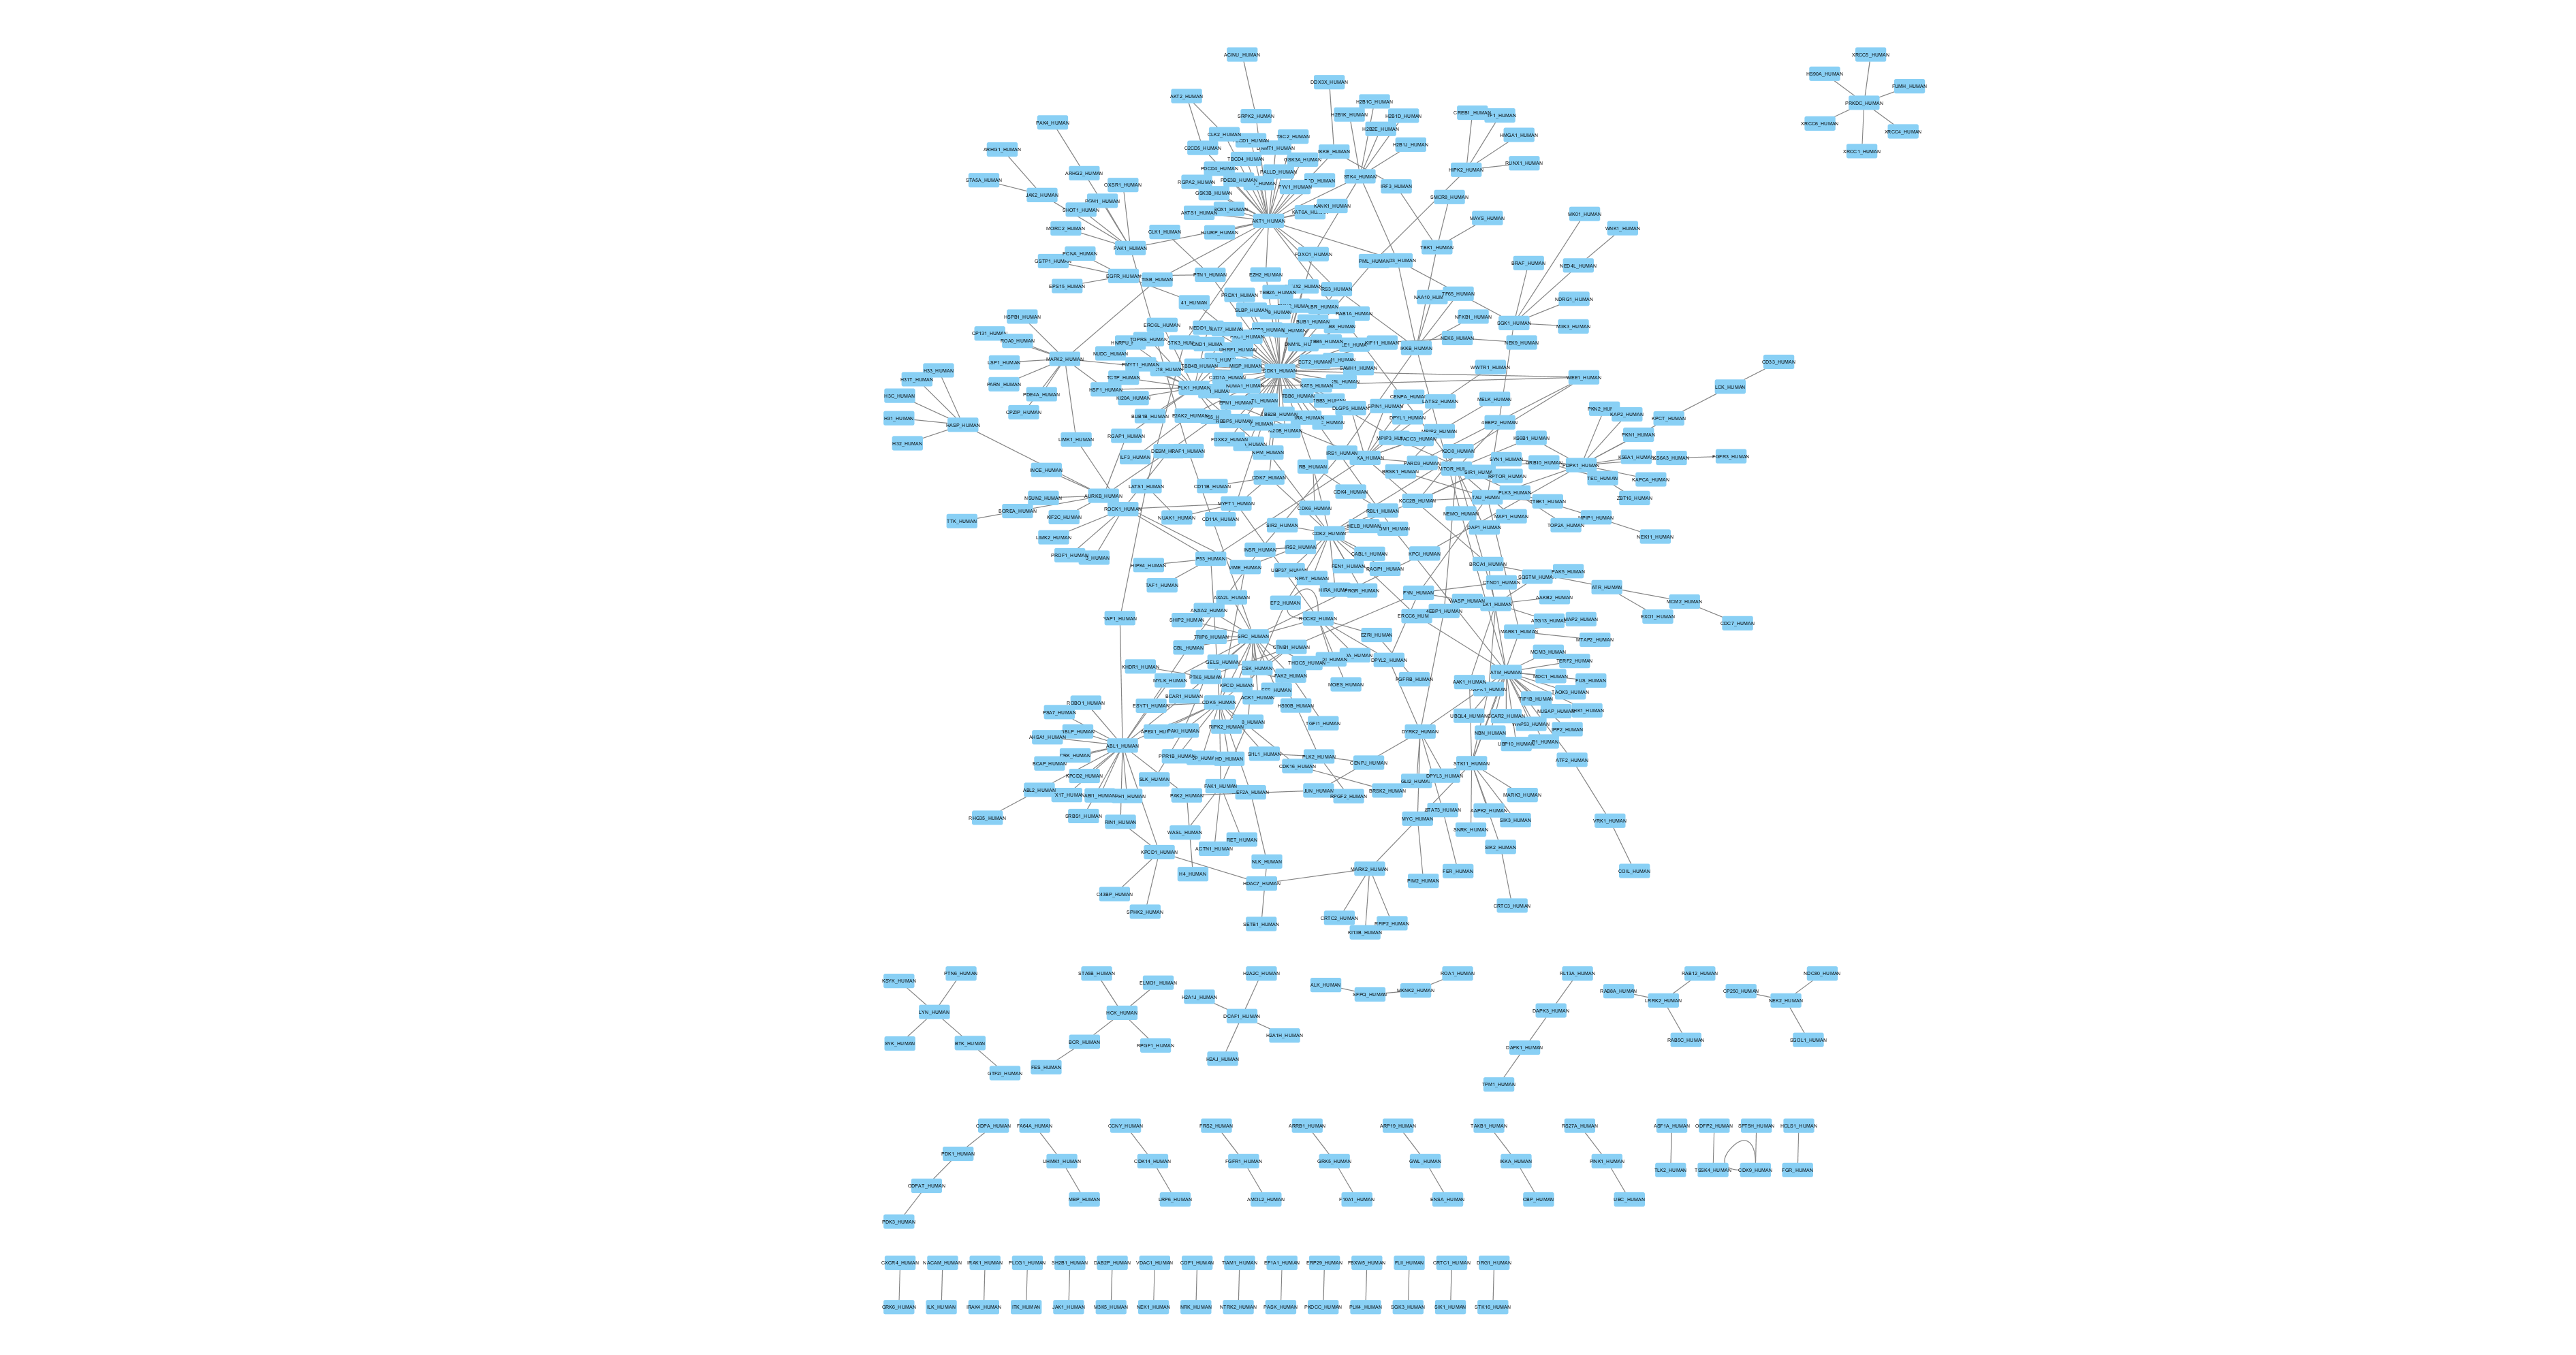
Figure 1. Kinase signalling network produced in Cytoscape based on original query list of target proteins. Only kinases which could be unambiguously inferred from the UniProt search results were included. For higher-resolution images with protein ID labels, see appendix 2.

*Task 3: Investigate the effect of genomic variants on the network*

Question 1: 

According to Mutation Assessor, a S642Q mutation in WEE1_HUMAN prevents BRSK1 and BRSK2 from phosphorylating it, and it is a highly conserved residue, so it is likely to be a pathogenic mutation.

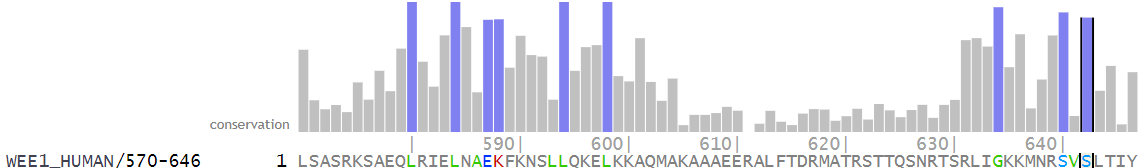

Figure 2. WEE1_HUMAN residues 570-646 with bars whose height indicates how conserved each residue is.

Source: http://mutationassessor.org/r3/?cm=msa&ty=f&p=WEE1_HUMAN&rb=570&re=646&var=S642Q

WEE1_HUMAN phosphorylates CDK2_HUMAN, which phosphorylates 16 other kinases, on 28 phosphosites, so this mutation could potentially have a big impact on the network.

Question 2:

If the MAPK1 protein, MK01_HUMAN, was unable to phosphorylate, it would not affect any other kinases in the network directly, because it does not phosphorylate any other proteins in the network. It is phosphorylated by SGK1_HUMAN but that is the only edge connected to MK01_HUMAN. There may be implications for cellular processes outside the scope of the network if the activity of MK01_HUMAN cannot be compensated for by other mechanisms.

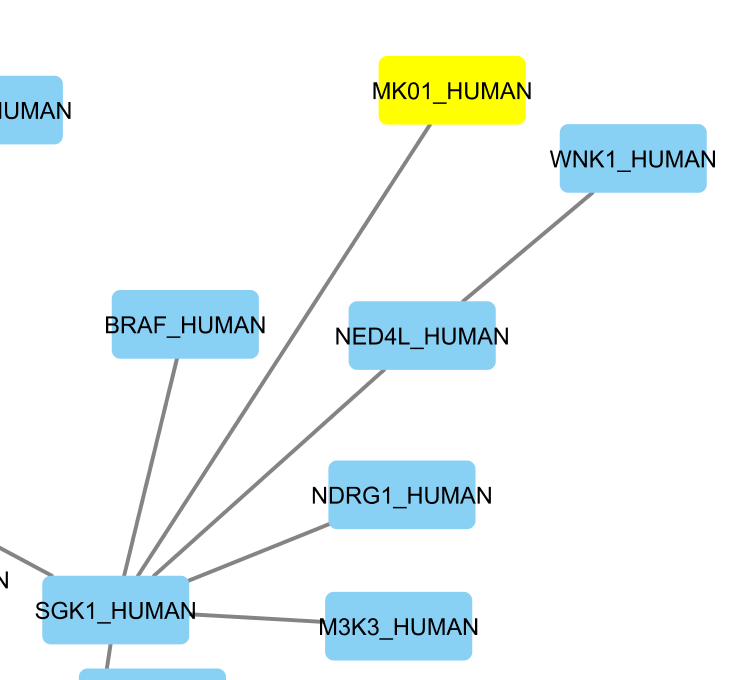

Figure 3. MK01_HUMAN in the context of the network. It only has one edge, which connects it to SGK1_HUMAN.


Question 3:

According to Mutation Assessor, a Y474F mutation in AKT1_HUMAN would have a low functional impact, and is in a moderately conserved region:

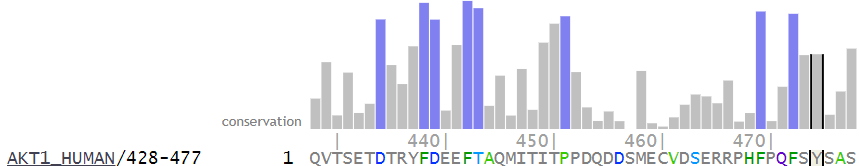

Figure 4. AKT1_HUMAN residues 428-477 with bars whose height indicates how conserved each residue is.

Source: http://mutationassessor.org/r3/?cm=msa&ty=f&p=AKT1_HUMAN&rb=428&re=477&var=Y474F

AKT1_HUMAN phosphorylates 31 other proteins on 48 phosphosites so even if the mutation has a low impact, it could affect many pathways, so the overall impact could be significant.

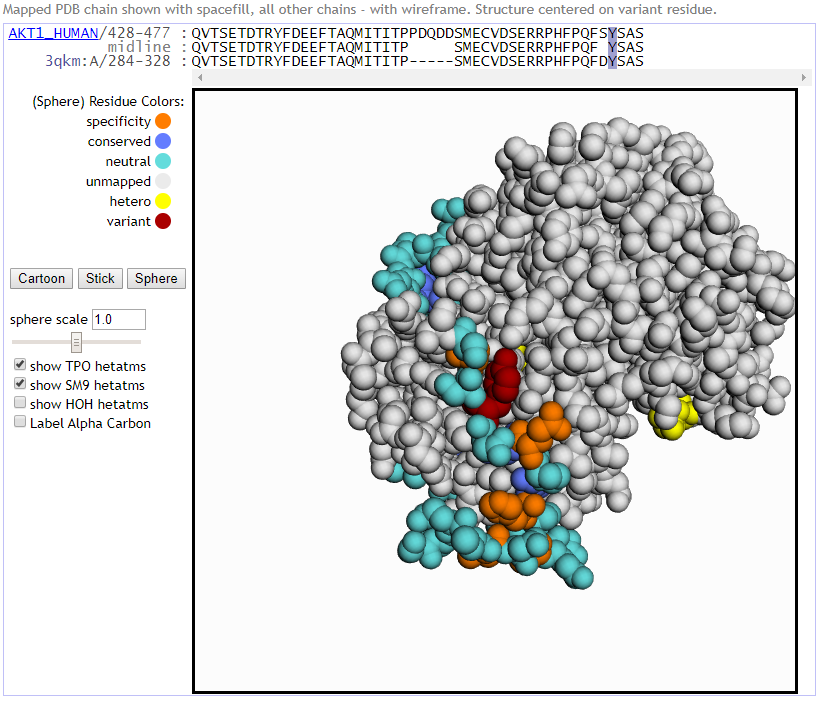

Figure 5. 3D model of AKT1_HUMAN showing Y474F mutation site in red.

Source: http://mutationassessor.org/r3/pdb.php?prot=AKT1_HUMAN&from=428&to=477&var=Y474F

Question 4:

According to Cytoscape, the longest path length is 11, and there are 20 paths of this length in the network.
Some kinases in the network are not connected at all.


Degree of each kinase:

See appendix 3 for the full list of kinases ranked by degree.

#### Conclusion

Networks can be produced from lists of target proteins using Python, UniProt's web service and Cytoscape, however, the completeness of the network relies on accurate, unambiguous curation of UniProt data, and careful programming on the part of the user. 

The higher the degree of the kinase in this network, the greater the number of kinases that either phosphorylate it, or are phosphorylated by it. A high degree could mean that a) the kinase is a target for many other kinases, and if there was a loss-of-function mutation in one of these, another may be able to compensate for it (an example of redundancy), b) that the kinase phosphorylates many targets, and thus a loss-of-function mutation in this kinase could have a devastating impact on many downstream processes, or c) both. All of the above suggest that a kinase with a high degree is very important to the organism's survival.

#### References

Bateman A (2019). UniProt: a worldwide hub of protein knowledge. *Nucleic Acids Research* 47(D1):D506–D515 doi: 10.1093/nar/gky1049

Computational Biology Center, Memorial Sloan Kettering Cancer Center. *Mutation Assessor - Functional impact of protein mutations, release 3* [online] viewed 11th December 2019. URL http://mutationassessor.org/r3/.

Hardman, G., Perkins, S., Brownridge, P.J., Clarke, C.J., Byrne, D.P., Campbell, A.E., Kalyuzhnyy, A., Myall, A., Eyers, P.A., Jones, A.R., Eyers, C.E. (2019). Strong anion exchange‐mediated phosphoproteomics reveals extensive human non‐canonical phosphorylation. *The EMBO Journal,* 38(21), e100847, doi: 10.15252/embj.2018100847

Kluyver, T., Ragan-Kelley, B., Pérez, F., Granger, B., Bussonnier, M., Frederoc, J., Kelley, K., Hamrick, J., Grout, J., Corlay, S., Ivanov, P., Avila, D., Abdalla, S., Willing, C., Jupyter Development Team (2016). *Jupyter Notebooks – a publishing format for reproducible computational workflows*. IOS Press. doi: 10.3233/978-1-61499-649-1-87

PyData Development Team (2019). Powerful data structures for data analysis, time series, and statistics. Python Software Foundation. URL http://pandas.pydata.org

Python Core Team (2019). Python: A dynamic, open source programming language. Python Software Foundation. URL https://www.python.org/.

Reitz, K. (2019) Requests: HTTP for Humans. Python Software Foundation. URL https://pypi.org/project/requests/

Shannon, P., Markiel, A., Ozier, O., Baliga, N.S., Wang, J.T., Ramage, D., Amin, N., Schwikowski, B., Ideker, T. (2003). Cytoscape: a software environment for integrated models of biomolecular interaction networks. *Genome Research,* 13(11):2498-504, https://doi.org/10.1101/gr.1239303

Various authors, urllib.parse (2019), GitHub repository, https://github.com/python/cpython/blob/3.8/Lib/urllib/parse.py

Various authors, urllib.request (2019), GitHub repository, https://github.com/python/cpython/blob/master/Lib/urllib/request.py

#### Appendix 1

List of kinases ranked by number of phosphosites each one phosphorylates.

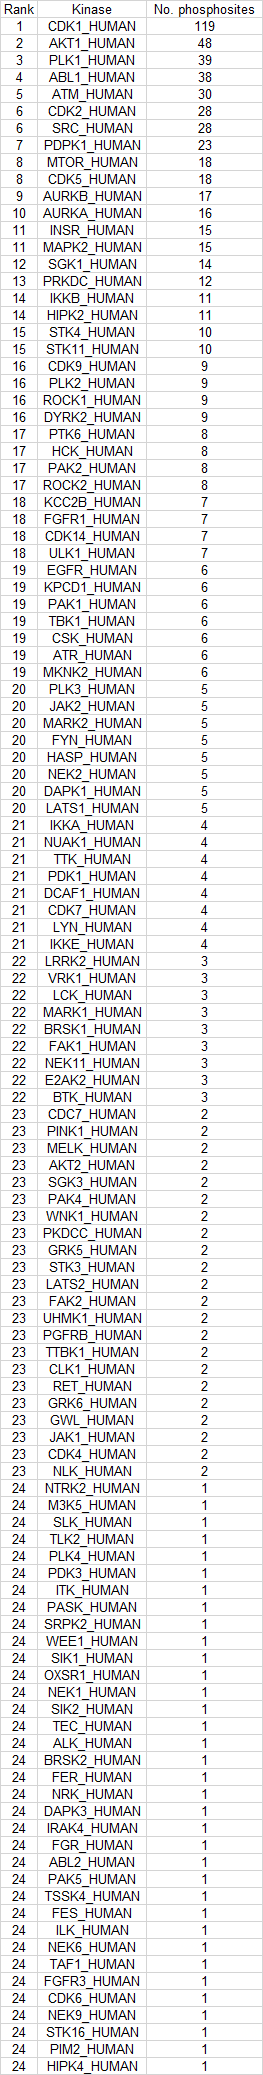
Table 1. Kinases ranked by number of target phosphosites

#### Appendix 2

Zoomed-in sections of the network with kinase labels

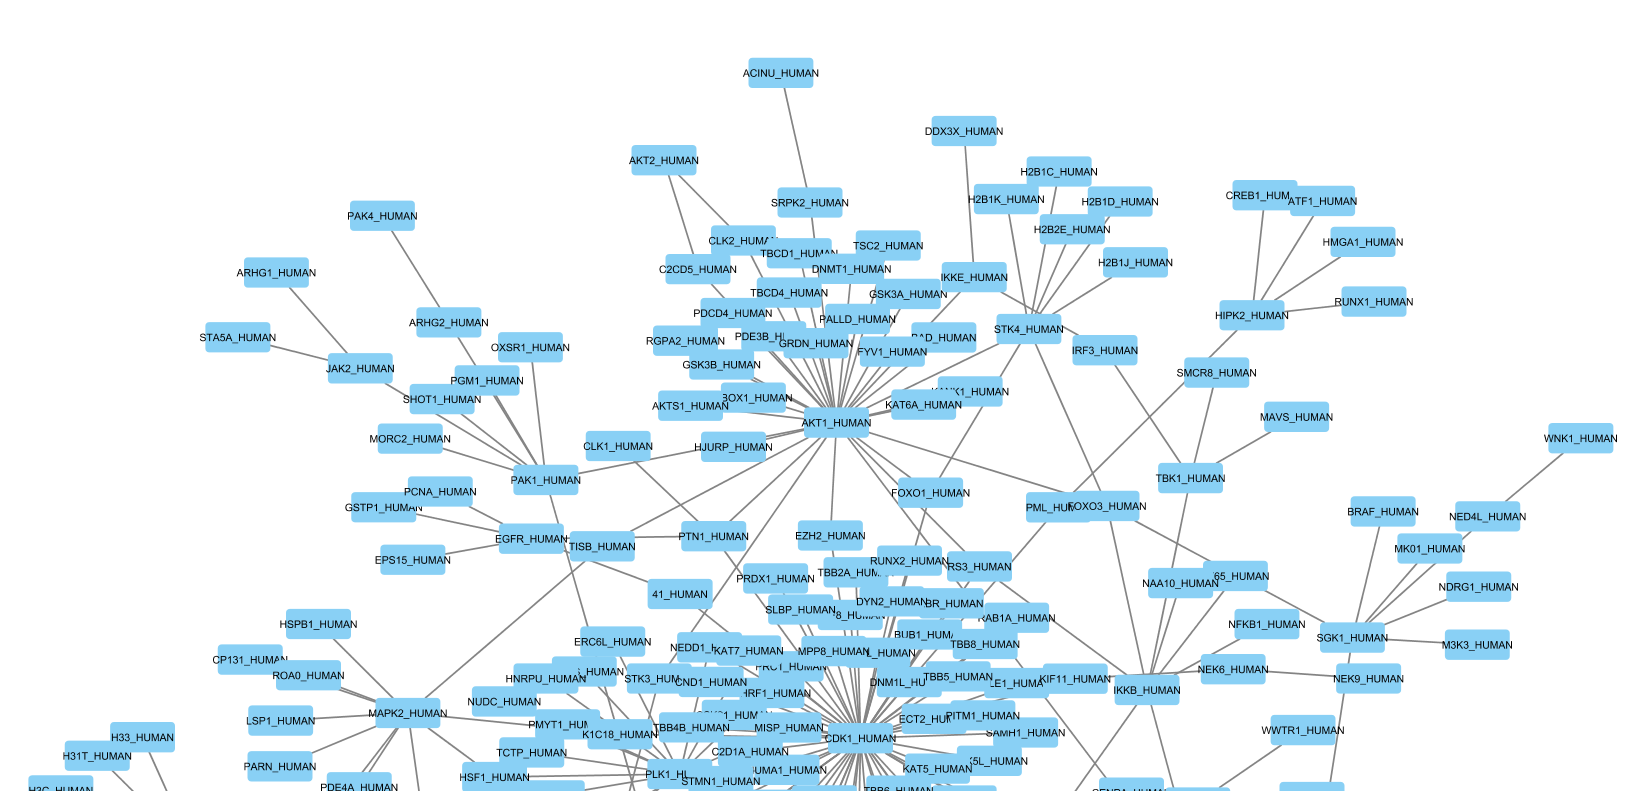
a)
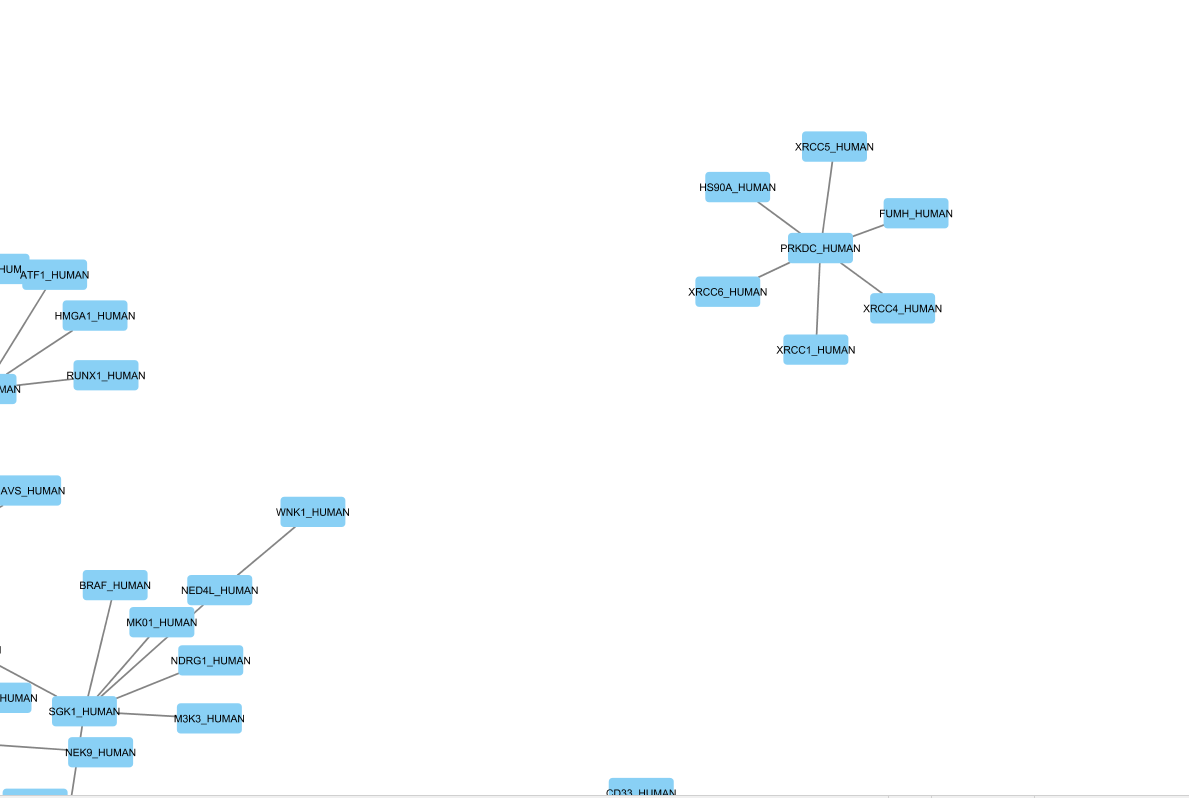
b)
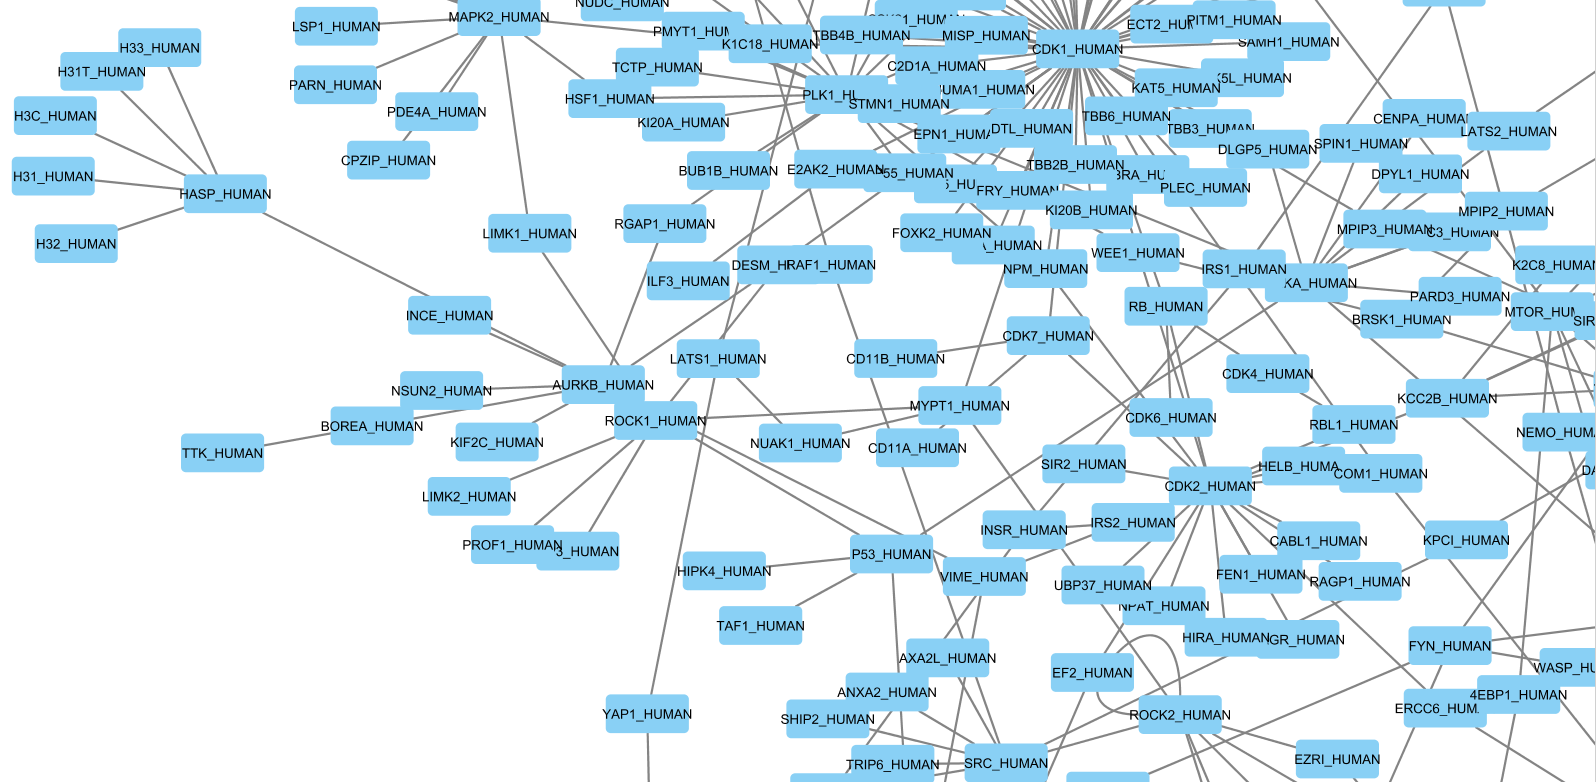
c)
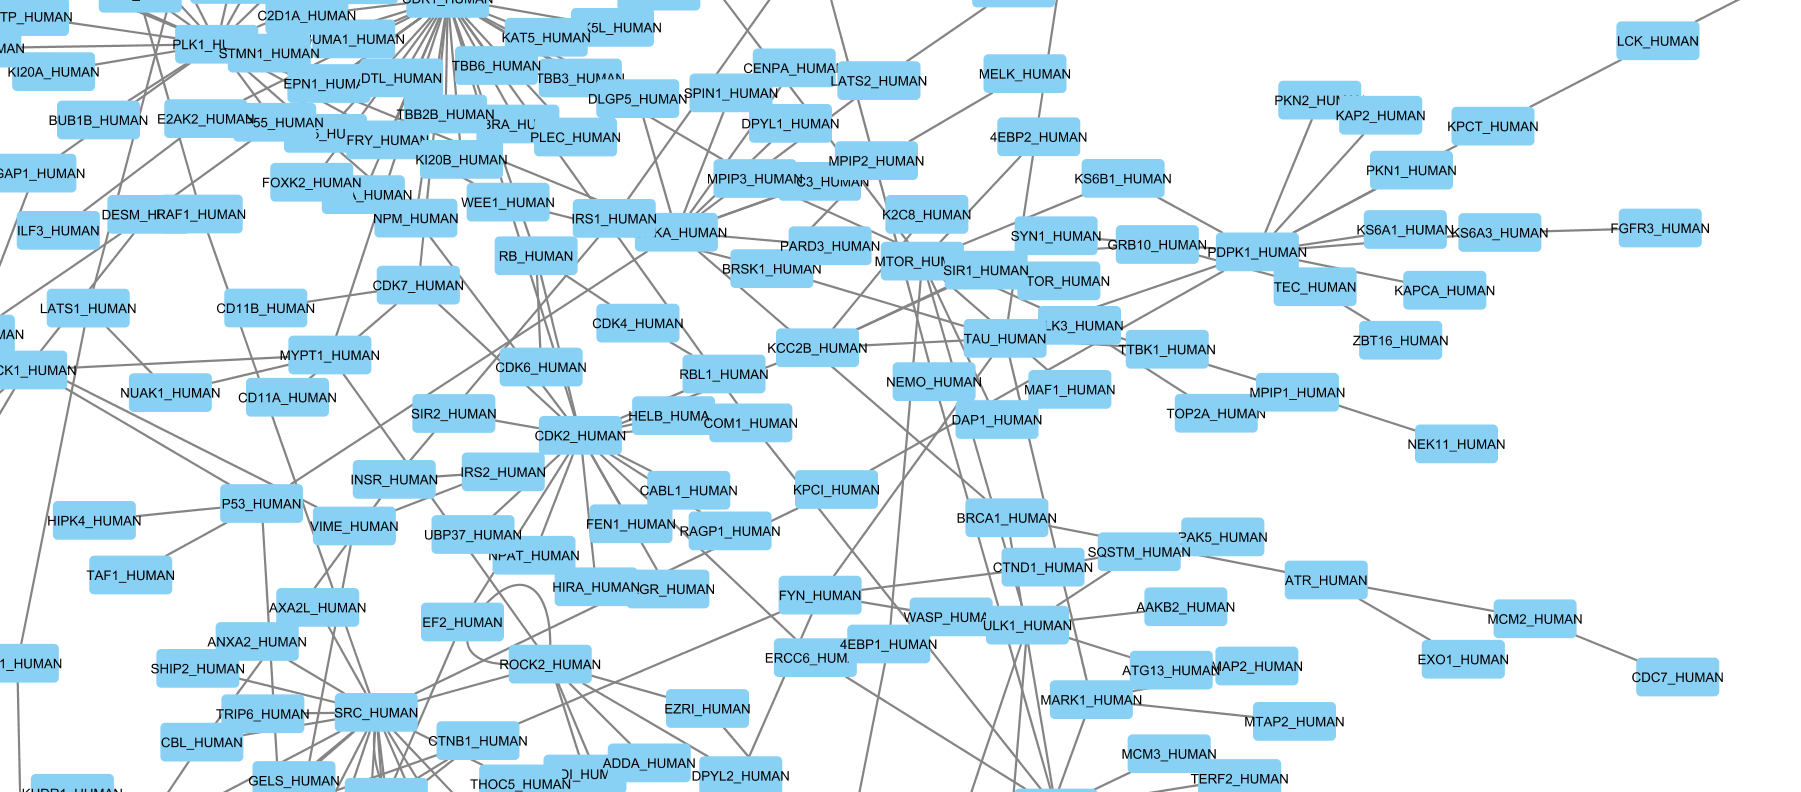
d)
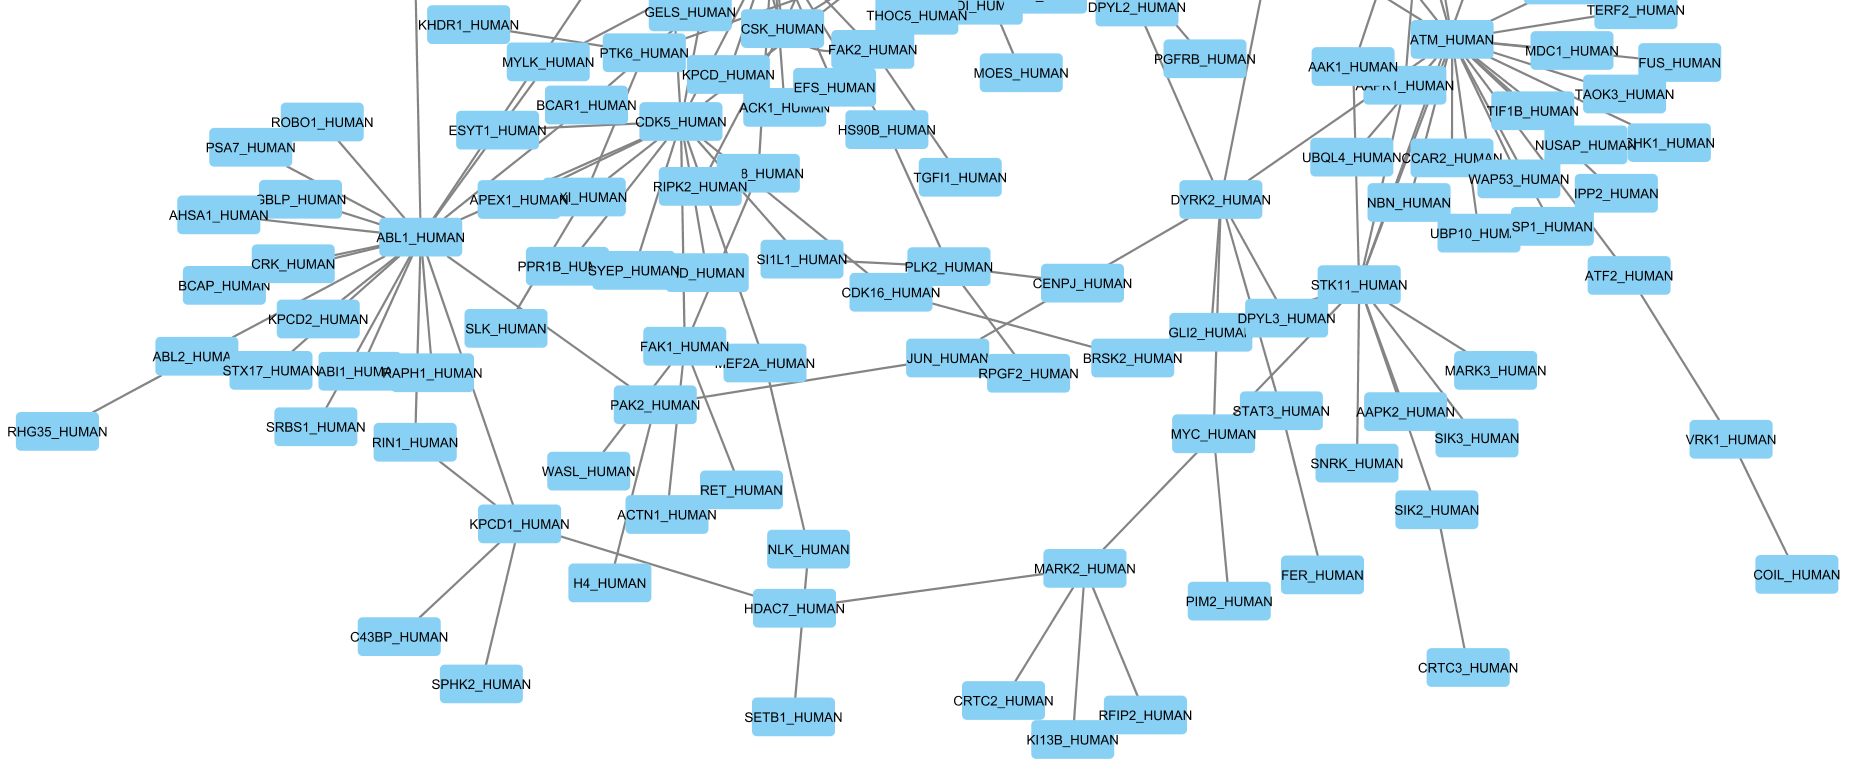
e)
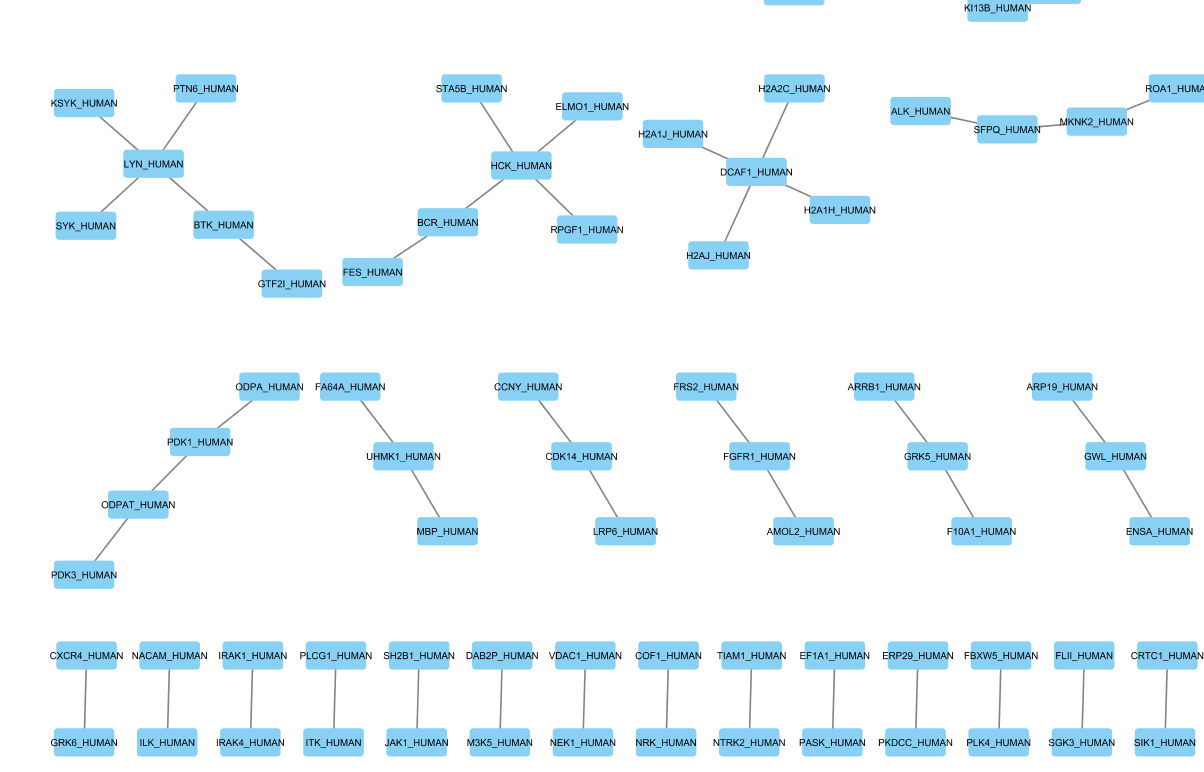
f)
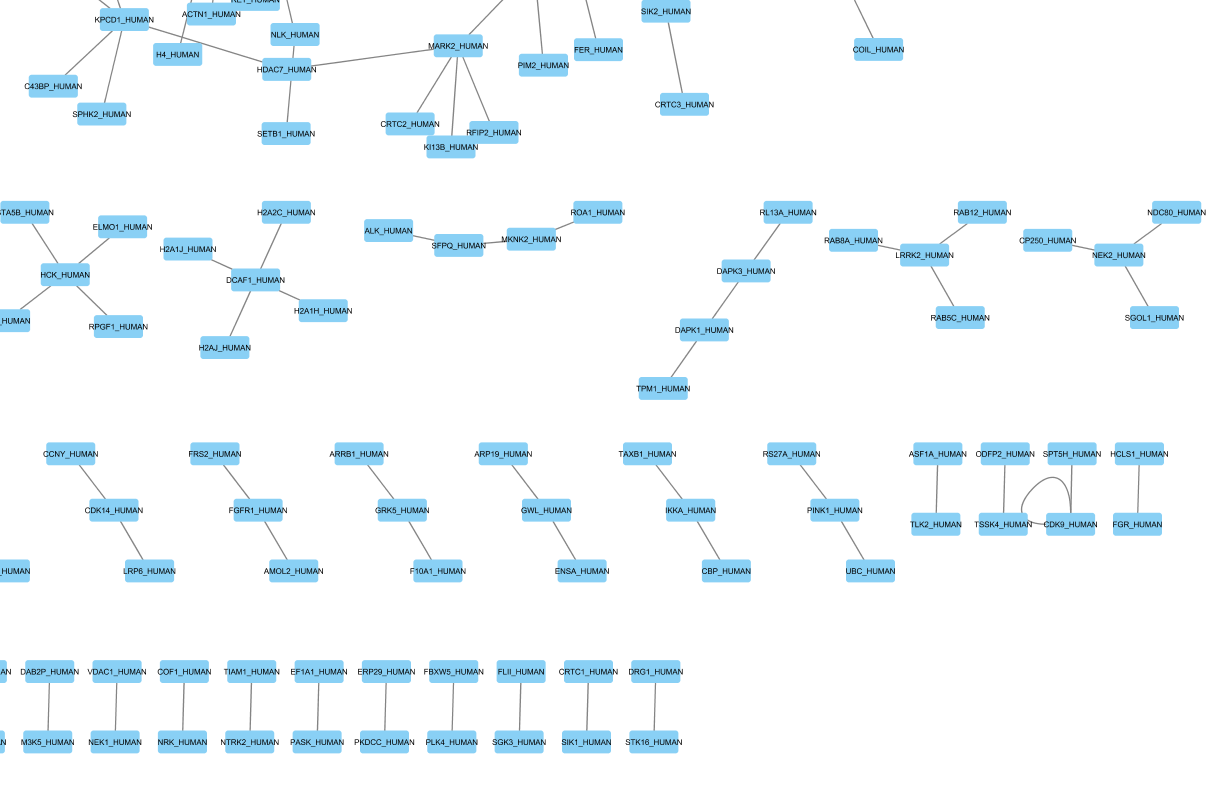
g)

Figure 6. Zoomed-in sections of the kinase network

#### Appendix 3

List of kinases ranked by degree.

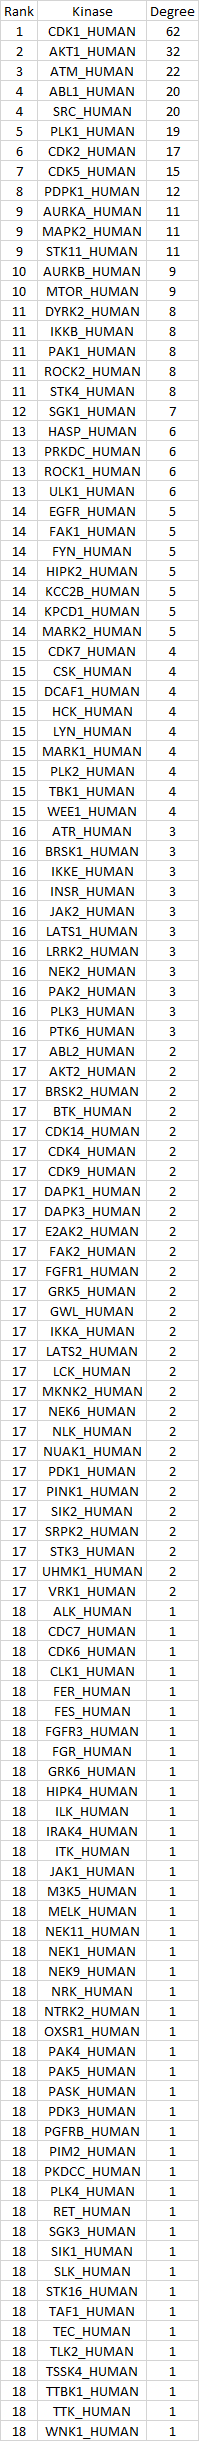

Table 2. Kinases ranked by degree.